In [1]:
import os
import astroNN
from astroNN import datasets
from astroNN.apogee import allstar, visit_spectra, combined_spectra, gap_delete, apogee_continuum, bitmask_boolean
from astroNN.models import load_folder
from astroNN.apogee.chips import wavelength_solution, chips_split

from astropy.io import fits
from astropy.wcs import WCS
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import traceback
import h5py as h5

%matplotlib inline
import matplotlib.ticker as ticker

2023-07-02 15:06:01.518664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 15:06:07.311890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pd.options.display.max_columns = 500

In [3]:
geir_path = "/geir_data/scr/petershi" #should save work here 
sdssv_path = "/yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star" #path for SDSSV spectra
sdssiv_path = "/yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m"

xmatch_path = "/yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/aux_xmatch/ipl-1_dr17_lite_230517_byYS.fits"
allstar_path = "/yngve_data/sdss/apogee/dr17/apogee/spectro/aspcap/dr17/synspec/allStar-dr17-synspec.fits"
catlist_path = "/yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/aux_xmatch/allStar-TIC_v8-APOGEE-0.2.6-v6_0_9-1.0.fits"

In [4]:
def getPathList(path_0):

    l = []

    for root, dirs, files in tqdm(os.walk(path_0, topdown=False)):
        for name in files:
            l.append(os.path.join(root, name))
        # for name in dirs:
        #     l.append(os.path.join(root, name))
    return (l, path_0)

In [5]:
def getPath(s, l):
    for elem in l[0]:
        if str(s) in elem:
            return elem

    print("File " + str(s) + " not found in " + str(l[1]))
    return None

In [6]:
def getSDSSIVData(hdul):
    
    snr = hdul[0].header["SNR"]
    ra = hdul[0].header["RA"]
    dec = hdul[0].header["DEC"]
    flux = hdul[1].data
    flux_err = hdul[2].data
    bitmask = hdul[3].data

    rd = {}

    rd["SNR"] = snr
    rd["RA"] = ra
    rd["DEC"] = dec
    rd["FLUX"] = flux
    rd["FLUX_ERR"] = flux_err
    rd["BITMASK"] = bitmask

    return rd 

In [7]:
sdssiv_files = getPathList(sdssiv_path)

1585it [00:53, 29.81it/s] 


In [8]:
hdul = fits.open(allstar_path)

data = hdul[1].data

In [9]:
data["ASPCAPFLAGS"][0]

'TEFF_WARN,VMICRO_WARN,STAR_WARN'

# Testing

In [16]:
b = [2]

In [17]:
bitmask_boolean([4], b)[0]

array([ True])

In [21]:
bits = [19, 23, 31, 32, 33, 40]

In [22]:
mask1 = ~bitmask_boolean(data["ASPCAPFLAG"], bits)[0]
mask1

array([ True,  True,  True, ...,  True,  True,  True])

In [23]:
np.count_nonzero(mask1)

686868

In [24]:
mask2 = (data["VSCATTER"]<1) & (data["STARFLAG"]==0) & (data["SNR"]>200) 
mask2

array([False, False,  True, ..., False, False, False])

In [25]:
data_cut = mask1 & mask2
data_cut

array([False, False,  True, ..., False, False, False])

In [26]:
np.count_nonzero(data_cut)

138669

In [27]:
original_data = data[data_cut]

# Compilation

In [28]:
h5_path = os.path.join(geir_path, "serialized", "Retrain Dataset v2.hdf5")
hf = h5.File(h5_path, 'a')

symbols = hdul[3].data["ELEM_SYMBOL"][0]

for i in tqdm(range(len(original_data))):

    apo = original_data["APOGEE_ID"][i]

    try:
        apath = getPath(apo, sdssiv_files)

        if apath is not None:
            afile = fits.open(apath, memmap = False)
            try:
                adata = getSDSSIVData(afile)
            except Exception as e: 
                print(traceback.format_exc())
                adata = None

            afile.close()
            for hdu in afile: #close files 
                del hdu.data
            del afile

            if adata is not None:
                figs = {}
                fig_errs = {}

                grp = hf.create_group(apo)

                spec = grp.create_group("Spectra")
                elems = grp.create_group("Elements")
                elem_errs = grp.create_group("Element Errors")

                for key in list(adata.keys()):
                    dset = spec.create_dataset(key, data = adata[key])

                teff = original_data["teff"][i]
                logg = original_data["logg"][i]
                feh = original_data["Fe_H"][i]

                figs["teff"] = teff
                figs["logg"] = logg
                figs["Fe"] = feh

                teff_err = original_data["teff_err"][i]
                logg_err = original_data["logg_err"][i]
                feh_err = original_data["Fe_H_err"][i]

                fig_errs["teff"] = teff_err
                fig_errs["logg"] = logg_err
                fig_errs["Fe"] = feh_err
                
                xh = original_data["X_H"][i]
                xh_err = original_data["X_H_err"][i]

                for sym, x, err in zip(symbols, xh, xh_err):
                    figs[sym] = x
                    fig_errs[sym] = err

                for k1, k2 in zip(list(figs.keys()), list(fig_errs.keys())):
                    elems[k1] = figs[k1]
                    elem_errs[k2] = fig_errs[k2]
    except Exception as e:
        print(str(e) + ", " + apo)

hf.close()

  0%|          | 6/138669 [00:01<4:57:05,  7.78it/s] 

Unable to create group (name already exists), 2M00000506+5656353


  0%|          | 25/138669 [00:02<2:59:47, 12.85it/s]

Unable to create group (name already exists), 2M00003119+1516179


  0%|          | 33/138669 [00:03<3:19:15, 11.60it/s]

File 2M00004334-7228213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 43/138669 [00:04<3:13:49, 11.92it/s]

File 2M00005290-7251329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00005469+5654086


  0%|          | 55/138669 [00:05<3:12:41, 11.99it/s]

File 2M00010816-7351594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 59/138669 [00:05<4:20:38,  8.86it/s]

Unable to create group (name already exists), 2M00011664+1523337


  0%|          | 134/138669 [00:12<3:05:22, 12.46it/s]

Unable to create group (name already exists), 2M00030238+5647188


  0%|          | 160/138669 [00:15<3:49:59, 10.04it/s]

File 2M00033135-7323576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00033139-7247017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 164/138669 [00:15<3:34:46, 10.75it/s]

File 2M00033670-7250054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 185/138669 [00:17<2:57:36, 13.00it/s]

Unable to create group (name already exists), 2M00035249+1506184


  0%|          | 203/138669 [00:19<3:10:30, 12.11it/s]

File 2M00041790-7249588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 215/138669 [00:20<3:23:29, 11.34it/s]

File 2M00044199+6709592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 221/138669 [00:20<2:46:48, 13.83it/s]

File 2M00045599+2638556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00050112-7253575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 227/138669 [00:21<2:56:46, 13.05it/s]

File 2M00050380-0030109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 235/138669 [00:22<3:44:00, 10.30it/s]

File 2M00051949-7236222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00052013-0542275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 244/138669 [00:22<3:56:03,  9.77it/s]

File 2M00054195+1323465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00054222-7234415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 258/138669 [00:24<3:20:44, 11.49it/s]

File 2M00055771-5123058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 277/138669 [00:25<3:09:36, 12.16it/s]

File 2M00063954-2027036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00064249-2033293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 283/138669 [00:26<3:10:28, 12.11it/s]

File 2M00064728-2019344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 287/138669 [00:26<3:16:54, 11.71it/s]

File 2M00065466-5220059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 297/138669 [00:27<3:39:28, 10.51it/s]

File 2M00070214-2030207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 307/138669 [00:28<3:02:36, 12.63it/s]

File 2M00070887-2042208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 329/138669 [00:30<3:04:38, 12.49it/s]

File 2M00073437-5114362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 335/138669 [00:30<2:52:02, 13.40it/s]

File 2M00074341-2000506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 349/138669 [00:31<3:35:21, 10.70it/s]

File 2M00081109-2105478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00081281-2034538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 355/138669 [00:32<3:18:00, 11.64it/s]

File 2M00081858-2057485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00082208-2101390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 361/138669 [00:32<2:51:15, 13.46it/s]

File 2M00082730-2111113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 372/138669 [00:33<2:33:51, 14.98it/s]

File 2M00083293-2009355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 374/138669 [00:33<2:44:08, 14.04it/s]

File 2M00083945-2117223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 382/138669 [00:34<3:15:11, 11.81it/s]

File 2M00085168-5145437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 384/138669 [00:34<3:16:01, 11.76it/s]

File 2M00085481-2100045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00085687-5117277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 388/138669 [00:35<3:25:37, 11.21it/s]

File 2M00090121-5229418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 394/138669 [00:35<3:23:28, 11.33it/s]

File 2M00090760-2114154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 398/138669 [00:35<3:05:36, 12.42it/s]

Unable to create group (name already exists), 2M00090845+6927361
File 2M00091059-1954501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 400/138669 [00:36<3:08:22, 12.23it/s]

File 2M00091546-2104085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 406/138669 [00:36<3:40:33, 10.45it/s]

File 2M00092114-2024549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 408/138669 [00:37<3:26:48, 11.14it/s]

File 2M00092646-5118027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 414/138669 [00:37<2:54:17, 13.22it/s]

File 2M00092930-2002313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00092965-2030084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00093045-2055152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 416/138669 [00:37<3:08:44, 12.21it/s]

File 2M00093451-2040017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00093614-2010243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 420/138669 [00:37<2:58:09, 12.93it/s]

File 2M00093629-5144134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00094149-2113539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 426/138669 [00:38<3:15:23, 11.79it/s]

File 2M00094594-5210584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00095113-2025165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 430/138669 [00:38<3:26:54, 11.13it/s]

File 2M00095629-2101550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 434/138669 [00:39<2:47:40, 13.74it/s]

File 2M00095915-2006555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 444/138669 [00:39<2:32:33, 15.10it/s]

File 2M00100798-1956536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00100912-1949018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 452/138669 [00:40<2:50:11, 13.54it/s]

File 2M00101876-2116576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00101886-0514549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 456/138669 [00:40<2:35:15, 14.84it/s]

File 2M00102382-2047358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00102411-2019445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 460/138669 [00:41<2:50:44, 13.49it/s]

File 2M00102524-5221213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00102574-2023058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 464/138669 [00:41<3:30:12, 10.96it/s]

File 2M00103160-2026056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 468/138669 [00:41<3:32:24, 10.84it/s]

File 2M00103225-2109408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 474/138669 [00:42<2:55:14, 13.14it/s]

File 2M00103895-2055428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00103962-5220089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00103962-1938540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 476/138669 [00:42<2:58:02, 12.94it/s]

File 2M00104229-5058118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 480/138669 [00:42<3:25:45, 11.19it/s]

File 2M00104962-2053070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 488/138669 [00:43<2:59:55, 12.80it/s]

File 2M00105741-5132172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00105796-2017522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 492/138669 [00:43<2:44:59, 13.96it/s]

File 2M00110215-2000216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00110302-5130303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 496/138669 [00:44<2:35:14, 14.83it/s]

File 2M00110681-5148487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 502/138669 [00:44<3:20:50, 11.47it/s]

File 2M00111238-2010021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00111576-2100020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 510/138669 [00:45<3:08:34, 12.21it/s]

File 2M00112901-2032070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 516/138669 [00:46<3:23:44, 11.30it/s]

File 2M00113138-2020413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 520/138669 [00:46<2:42:32, 14.17it/s]

File 2M00113550-5158347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00113731-7216318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00114061-2034234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00114156-5110147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 524/138669 [00:46<2:27:23, 15.62it/s]

Unable to create group (name already exists), 2M00114216+6729585


  0%|          | 528/138669 [00:46<3:07:38, 12.27it/s]

File 2M00114988-5221137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00115094-1942120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 534/138669 [00:47<3:01:14, 12.70it/s]

File 2M00115655-2046299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 540/138669 [00:47<2:46:04, 13.86it/s]

File 2M00120776-7206252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00120930-1951178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00120998-1756177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 544/138669 [00:48<2:59:32, 12.82it/s]

File 2M00121447-1957225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 552/138669 [00:48<2:52:47, 13.32it/s]

File 2M00122098-2112058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 558/138669 [00:49<3:02:21, 12.62it/s]

File 2M00123297-1955354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 562/138669 [00:49<3:15:58, 11.75it/s]

File 2M00123605-5141593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00123616-2123491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 566/138669 [00:49<2:52:27, 13.35it/s]

File 2M00124050-1948017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00124059-2007528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 572/138669 [00:50<3:49:09, 10.04it/s]

File 2M00124465-2009359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 582/138669 [00:51<2:52:15, 13.36it/s]

File 2M00125918-7637039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00130233-5124598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 584/138669 [00:51<2:58:20, 12.90it/s]

File 2M00130519-5129071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 588/138669 [00:51<3:02:09, 12.63it/s]

File 2M00130683-5101121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 592/138669 [00:52<3:37:24, 10.58it/s]

File 2M00131231-5218110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 602/138669 [00:53<2:54:36, 13.18it/s]

File 2M00132778-1959151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 606/138669 [00:53<3:08:50, 12.18it/s]

File 2M00133251-5201224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 617/138669 [00:54<2:45:52, 13.87it/s]

File 2M00134499-2002144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00134551-7729341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 621/138669 [00:54<2:52:59, 13.30it/s]

File 2M00135117-7634430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00135195-5050198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00135289-2007102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 629/138669 [00:55<2:51:30, 13.41it/s]

File 2M00140167-5101285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 637/138669 [00:55<2:47:10, 13.76it/s]

File 2M00140803-5109365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 645/138669 [00:56<2:49:55, 13.54it/s]

File 2M00142230-7645472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 673/138669 [00:59<3:28:38, 11.02it/s]

File 2M00145463-5216429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  0%|          | 684/138669 [01:00<3:11:03, 12.04it/s]

Unable to create group (name already exists), 2M00150500+6742384


  1%|          | 707/138669 [01:02<3:04:24, 12.47it/s]

File 2M00153452-7755240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 711/138669 [01:02<2:52:30, 13.33it/s]

File 2M00153922-7144227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 723/138669 [01:03<2:34:48, 14.85it/s]

File 2M00154740-7647338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 734/138669 [01:04<2:27:26, 15.59it/s]

Unable to create group (name already exists), 2M00155997+6717590


  1%|          | 752/138669 [01:06<2:46:05, 13.84it/s]

Unable to create group (name already exists), 2M00161612+8534306


  1%|          | 791/138669 [01:09<2:30:59, 15.22it/s]

Unable to create group (name already exists), 2M00170473+6722448


  1%|          | 801/138669 [01:10<3:00:32, 12.73it/s]

File 2M00171862-7700140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 819/138669 [01:11<3:30:48, 10.90it/s]

File 2M00173707-7721167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 856/138669 [01:15<2:27:16, 15.60it/s]

File 2M00180391-7633577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00180538+6725362


  1%|          | 877/138669 [01:16<3:17:09, 11.65it/s]

File 2M00182549+4401376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 896/138669 [01:18<2:52:23, 13.32it/s]

Unable to create group (name already exists), 2M00184520+6742361


  1%|          | 907/138669 [01:19<2:56:48, 12.99it/s]

File 2M00185563-7650324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 918/138669 [01:20<3:13:46, 11.85it/s]

File 2M00190733-7725005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 932/138669 [01:21<3:08:25, 12.18it/s]

File 2M00192920-7655011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 938/138669 [01:21<2:55:38, 13.07it/s]

File 2M00193767-7210175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 988/138669 [01:26<3:06:56, 12.27it/s]

File 2M00202281-7201135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1014/138669 [01:28<3:03:01, 12.53it/s]

File 2M00204121-7202433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1043/138669 [01:30<3:12:35, 11.91it/s]

File 2M00210332-7734141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1059/138669 [01:31<3:18:39, 11.55it/s]

File 2M00213081-7729013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00213487-7208257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1071/138669 [01:32<2:48:43, 13.59it/s]

File 2M00214368-7205162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1075/138669 [01:33<3:26:02, 11.13it/s]

File 2M00214990-7211021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1092/138669 [01:34<3:26:06, 11.13it/s]

File 2M00220136-7213182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1100/138669 [01:35<3:04:27, 12.43it/s]

File 2M00220570-7203565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00220591-7207490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00220599+8540038


  1%|          | 1105/138669 [01:35<2:23:48, 15.94it/s]

File 2M00220669-7207156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00220714-7200328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00220995-7203195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1127/138669 [01:37<4:46:34,  8.00it/s]

File 2M00222303-7207050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1131/138669 [01:38<3:31:57, 10.82it/s]

File 2M00222556-7153222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1139/138669 [01:38<3:20:50, 11.41it/s]

File 2M00223025-7201409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00223059-7203211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1144/138669 [01:39<2:47:19, 13.70it/s]

File 2M00223195-7206489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00223377-7202103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1153/138669 [01:39<2:45:12, 13.87it/s]

File 2M00224175-7725009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1160/138669 [01:40<2:52:25, 13.29it/s]

Unable to create group (name already exists), 2M00224630+5509436


  1%|          | 1168/138669 [01:41<3:03:56, 12.46it/s]

File 2M00225174-7214375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00225245-7208555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00225403-7205169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1175/138669 [01:41<2:24:46, 15.83it/s]

Unable to create group (name already exists), 2M00225602+5513157


  1%|          | 1179/138669 [01:41<2:49:34, 13.51it/s]

File 2M00225813-7159328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00225899-7205356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1184/138669 [01:42<2:21:23, 16.21it/s]

File 2M00225969-7207061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00225986-7201335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00230028-7208413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1190/138669 [01:42<3:03:48, 12.47it/s]

File 2M00230515-7204280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00230630-7211106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1198/138669 [01:43<3:01:23, 12.63it/s]

File 2M00230792-7200571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1202/138669 [01:43<2:31:21, 15.14it/s]

File 2M00231023-7759418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00231072-7156009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00231074-7159158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1206/138669 [01:44<2:54:00, 13.17it/s]

File 2M00231184-7158283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00231284-7210190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1212/138669 [01:44<3:12:27, 11.90it/s]

File 2M00231612-7207481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00231641-7751557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1216/138669 [01:44<2:59:11, 12.78it/s]

File 2M00231829-7209398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1224/138669 [01:45<2:31:03, 15.16it/s]

File 2M00232178-7155569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00232264-7211417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1226/138669 [01:45<2:20:58, 16.25it/s]

File 2M00232278-7201038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1230/138669 [01:45<2:40:42, 14.25it/s]

Unable to create group (name already exists), 2M00232571+5513510


  1%|          | 1234/138669 [01:46<3:05:13, 12.37it/s]

File 2M00232926-7204483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1240/138669 [01:46<2:59:23, 12.77it/s]

File 2M00233099-7154241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1248/138669 [01:47<3:26:44, 11.08it/s]

File 2M00233869-7201501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1252/138669 [01:47<3:19:47, 11.46it/s]

File 2M00234362-7725052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1256/138669 [01:48<3:02:58, 12.52it/s]

File 2M00234479-7205342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1262/138669 [01:48<3:03:26, 12.48it/s]

File 2M00234943-7204266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1266/138669 [01:48<2:44:30, 13.92it/s]

File 2M00235053-7204213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1270/138669 [01:49<3:16:06, 11.68it/s]

File 2M00235438-7158357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00235584-7154178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1274/138669 [01:49<2:42:11, 14.12it/s]

File 2M00235616-7159384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00235701-7202185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1282/138669 [01:49<2:18:24, 16.54it/s]

Unable to create group (name already exists), 2M00235770+5505285
File 2M00240062-7203573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00240280-7158179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1286/138669 [01:50<2:07:45, 17.92it/s]

File 2M00240336-7155473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00240404-7156262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00240449-7157112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1293/138669 [01:50<2:07:50, 17.91it/s]

Unable to create group (name already exists), 2M00240583+6949085
File 2M00240776-7157520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1301/138669 [01:51<2:46:13, 13.77it/s]

File 2M00241254-7155158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00241282-7203385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00241462-7204018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1308/138669 [01:51<2:55:20, 13.06it/s]

File 2M00241580-7200415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00241591-7717498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1312/138669 [01:52<3:20:40, 11.41it/s]

File 2M00241720-7200377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1318/138669 [01:52<3:41:24, 10.34it/s]

File 2M00241883-7159192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1327/138669 [01:53<2:54:07, 13.15it/s]

Unable to create group (name already exists), 2M00242356+5520448


  1%|          | 1331/138669 [01:53<2:42:15, 14.11it/s]

File 2M00242572-7203307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00242695-7158533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1335/138669 [01:54<2:51:02, 13.38it/s]

File 2M00243129-7716431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00243138-7201254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1343/138669 [01:54<2:59:48, 12.73it/s]

File 2M00243540-7159542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00243549+5536168
Unable to create group (name already exists), 2M00243656+5519528


  1%|          | 1350/138669 [01:54<2:15:58, 16.83it/s]

Unable to create group (name already exists), 2M00243735+5507357


  1%|          | 1356/138669 [01:55<3:06:23, 12.28it/s]

File 2M00244100-7158186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1358/138669 [01:55<2:52:12, 13.29it/s]

File 2M00244395-7203004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1366/138669 [01:56<3:08:53, 12.12it/s]

Unable to create group (name already exists), 2M00244627+5505364


  1%|          | 1380/138669 [01:57<2:31:03, 15.15it/s]

File 2M00245189-7200031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1392/138669 [01:58<3:06:17, 12.28it/s]

File 2M00250060-7155586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1398/138669 [01:59<3:29:48, 10.90it/s]

File 2M00250610-7159152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1402/138669 [01:59<3:20:58, 11.38it/s]

File 2M00250679-7203153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00250716-7200415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1412/138669 [02:00<3:12:43, 11.87it/s]

File 2M00251150-7202016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1420/138669 [02:00<2:42:48, 14.05it/s]

File 2M00251614-7201359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00251709+5500106


  1%|          | 1428/138669 [02:01<2:27:43, 15.48it/s]

File 2M00251919-7204454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00252060-7745256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1430/138669 [02:01<2:45:09, 13.85it/s]

File 2M00252299-7154365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1436/138669 [02:02<3:04:39, 12.39it/s]

File 2M00252511-7158517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1438/138669 [02:02<3:11:15, 11.96it/s]

File 2M00252724-7215067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1444/138669 [02:02<3:05:26, 12.33it/s]

File 2M00253054-7725373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1453/138669 [02:03<2:37:43, 14.50it/s]

File 2M00253428-7157352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00253465-7213084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00253559-7218224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00253618-7202051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1456/138669 [02:03<2:22:56, 16.00it/s]

File 2M00253864-7201062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1474/138669 [02:05<3:34:24, 10.66it/s]

File 2M00254689-7206494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1477/138669 [02:05<2:57:41, 12.87it/s]

Unable to create group (name already exists), 2M00254747-0011594


  1%|          | 1491/138669 [02:06<3:36:54, 10.54it/s]

File 2M00255446-7201491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1499/138669 [02:07<3:07:01, 12.22it/s]

File 2M00255751-7207529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1503/138669 [02:07<2:58:32, 12.80it/s]

File 2M00255964-7204310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1510/138669 [02:08<2:40:46, 14.22it/s]

Unable to create group (name already exists), 2M00260204+5341555


  1%|          | 1540/138669 [02:11<3:13:30, 11.81it/s]

File 2M00262720-7147440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1546/138669 [02:11<3:50:04,  9.93it/s]

File 2M00262847-7150127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1558/138669 [02:12<2:51:00, 13.36it/s]

File 2M00263501-7206444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1566/138669 [02:13<3:20:50, 11.38it/s]

File 2M00264059-7756355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1594/138669 [02:15<2:48:24, 13.57it/s]

File 2M00265915-7740164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00265998-7210312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1601/138669 [02:16<2:32:35, 14.97it/s]

File 2M00270282-1440433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1612/138669 [02:16<2:21:36, 16.13it/s]

File 2M00270811-7203297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1620/138669 [02:17<2:43:33, 13.97it/s]

Unable to create group (name already exists), 2M00271183+5552324


  1%|          | 1626/138669 [02:18<3:00:32, 12.65it/s]

File 2M00271353-7159535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00271353+5341210
File 2M00271486-7636089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1635/138669 [02:18<2:38:13, 14.43it/s]

Unable to create group (name already exists), 2M00271670+5333358


  1%|          | 1644/138669 [02:19<2:10:47, 17.46it/s]

Unable to create group (name already exists), 2M00272183+6941101


  1%|          | 1663/138669 [02:20<2:40:25, 14.23it/s]

File 2M00273168+3535143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1665/138669 [02:20<2:59:09, 12.74it/s]

File 2M00273429-1445582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1675/138669 [02:21<2:48:47, 13.53it/s]

Unable to create group (name already exists), 2M00273641+5532481


  1%|          | 1679/138669 [02:21<3:00:11, 12.67it/s]

File 2M00273750-7646135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1685/138669 [02:22<2:38:58, 14.36it/s]

File 2M00274142-7231134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1687/138669 [02:22<2:26:52, 15.54it/s]

File 2M00274599-1456439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1693/138669 [02:22<3:06:04, 12.27it/s]

File 2M00274904-7725400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|          | 1710/138669 [02:24<2:40:31, 14.22it/s]

Unable to create group (name already exists), 2M00280096+5522115


  1%|          | 1724/138669 [02:25<3:06:43, 12.22it/s]

Unable to create group (name already exists), 2M00281117+5516153


  1%|▏         | 1757/138669 [02:27<3:13:43, 11.78it/s]

File 2M00283423-1446269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1767/138669 [02:28<3:04:34, 12.36it/s]

File 2M00283771-7708581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1781/138669 [02:30<3:24:55, 11.13it/s]

File 2M00284401-1424407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1785/138669 [02:30<2:48:07, 13.57it/s]

Unable to create group (name already exists), 2M00284490+5407082
File 2M00284541-1446398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1805/138669 [02:31<2:52:44, 13.21it/s]

File 2M00285565-1503278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1815/138669 [02:32<2:35:46, 14.64it/s]

Unable to create group (name already exists), 2M00290398+5522497


  1%|▏         | 1851/138669 [02:35<2:12:38, 17.19it/s]

Unable to create group (name already exists), 2M00291684+5504140


  1%|▏         | 1855/138669 [02:35<2:44:59, 13.82it/s]

File 2M00291826-1400154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1871/138669 [02:36<3:46:51, 10.05it/s]

File 2M00292731-1445429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1877/138669 [02:37<3:38:41, 10.42it/s]

File 2M00293136-1423536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00293208+5501102


  1%|▏         | 1884/138669 [02:38<2:53:53, 13.11it/s]

Unable to create group (name already exists), 2M00293411+5514328
Unable to create group (name already exists), 2M00293594+5518259
Unable to create group (name already exists), 2M00293594+5518259


  1%|▏         | 1903/138669 [02:39<2:48:11, 13.55it/s]

File 2M00294515-1423110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00294647-1339426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1921/138669 [02:41<3:38:31, 10.43it/s]

File 2M00300113-1419038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1932/138669 [02:41<2:31:08, 15.08it/s]

Unable to create group (name already exists), 2M00300617+5501468


  1%|▏         | 1944/138669 [02:42<2:37:45, 14.44it/s]

File 2M00301421-7651485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00301582-1345089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 1965/138669 [02:44<2:09:09, 17.64it/s]

Unable to create group (name already exists), 2M00302645+5541161


  1%|▏         | 1995/138669 [02:46<3:09:26, 12.02it/s]

File 2M00304305-1440240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 2005/138669 [02:47<3:21:34, 11.30it/s]

Unable to create group (name already exists), 2M00304871+5514046


  1%|▏         | 2015/138669 [02:48<3:15:18, 11.66it/s]

File 2M00305756-1447274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 2021/138669 [02:48<2:53:38, 13.12it/s]

Unable to create group (name already exists), 2M00305907+5517496


  1%|▏         | 2029/138669 [02:49<2:48:31, 13.51it/s]

File 2M00310499-7144114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 2033/138669 [02:49<3:13:35, 11.76it/s]

File 2M00311057-1349337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 2041/138669 [02:50<2:33:31, 14.83it/s]

File 2M00311722-1423419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 2047/138669 [02:50<2:50:33, 13.35it/s]

File 2M00311844-1529062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 2065/138669 [02:52<2:47:46, 13.57it/s]

File 2M00313315-1504100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  1%|▏         | 2078/138669 [02:53<3:04:30, 12.34it/s]

Unable to create group (name already exists), 2M00313591+5502586


  2%|▏         | 2098/138669 [02:55<3:12:26, 11.83it/s]

File 2M00315092-1419461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2107/138669 [02:56<2:51:01, 13.31it/s]

File 2M00320076-1441071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2129/138669 [02:58<3:02:26, 12.47it/s]

File 2M00321242-6738228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00321739+5550532


  2%|▏         | 2136/138669 [02:58<3:12:02, 11.85it/s]

File 2M00321863-1420155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00321883-1347262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2141/138669 [02:59<2:43:36, 13.91it/s]

Unable to create group (name already exists), 2M00322045+5501102


  2%|▏         | 2145/138669 [02:59<2:54:33, 13.03it/s]

File 2M00322194-1346495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2153/138669 [02:59<2:26:52, 15.49it/s]

Unable to create group (name already exists), 2M00322786+5450583


  2%|▏         | 2183/138669 [03:02<3:24:38, 11.12it/s]

Unable to create group (name already exists), 2M00324704+5502265


  2%|▏         | 2223/138669 [03:06<3:18:00, 11.49it/s]

File 2M00332562-1418360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2233/138669 [03:07<2:56:47, 12.86it/s]

File 2M00333322-1415216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2272/138669 [03:10<3:01:49, 12.50it/s]

Unable to create group (name already exists), 2M00340339+5548359


  2%|▏         | 2324/138669 [03:14<2:55:28, 12.95it/s]

Unable to create group (name already exists), 2M00344726+5454150


  2%|▏         | 2350/138669 [03:16<3:20:03, 11.36it/s]

Unable to create group (name already exists), 2M00350559+5528058


  2%|▏         | 2360/138669 [03:17<3:03:59, 12.35it/s]

File 2M00351093-6706187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00351295+5542375


  2%|▏         | 2379/138669 [03:19<2:50:31, 13.32it/s]

File 2M00352101-6820291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00352233-6748442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2399/138669 [03:20<2:46:03, 13.68it/s]

Unable to create group (name already exists), 2M00353832+5751339


  2%|▏         | 2438/138669 [03:24<2:49:02, 13.43it/s]

Unable to create group (name already exists), 2M00360285+5736012


  2%|▏         | 2506/138669 [03:30<3:40:55, 10.27it/s]

File 2M00371109-7339118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2524/138669 [03:32<3:25:39, 11.03it/s]

File 2M00372094-6824527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2546/138669 [03:34<2:34:12, 14.71it/s]

Unable to create group (name already exists), 2M00373381+5546315


  2%|▏         | 2574/138669 [03:37<3:05:27, 12.23it/s]

Unable to create group (name already exists), 2M00375194+5552145


  2%|▏         | 2594/138669 [03:38<3:14:53, 11.64it/s]

File 2M00380627-7346481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2608/138669 [03:39<2:56:42, 12.83it/s]

File 2M00381693-7338576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00381958-6723528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2626/138669 [03:41<3:33:02, 10.64it/s]

File 2M00383267-6743265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2634/138669 [03:42<4:06:36,  9.19it/s]

File 2M00384372-6705038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2697/138669 [03:48<3:00:23, 12.56it/s]

File 2M00395957-6706307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00400008-6744344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2712/138669 [03:49<2:31:13, 14.98it/s]

File 2M00400935-6809568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2720/138669 [03:50<3:21:15, 11.26it/s]

File 2M00401539-6808137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00401802-6713181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2744/138669 [03:52<3:03:52, 12.32it/s]

File 2M00404236-0421065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2765/138669 [03:54<3:02:27, 12.41it/s]

File 2M00410716+3927312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2773/138669 [03:54<2:56:36, 12.82it/s]

File 2M00411604-7232167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2805/138669 [03:57<3:56:44,  9.56it/s]

File 2M00420051-6737223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2809/138669 [03:58<3:18:09, 11.43it/s]

File 2M00420342+6608511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2811/138669 [03:58<3:35:37, 10.50it/s]

File 2M00420453-7234106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2821/138669 [03:59<3:11:50, 11.80it/s]

File 2M00421454-1148176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2823/138669 [03:59<2:51:33, 13.20it/s]

File 2M00421739-6827561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00421903+0233156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00422012-6701367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2835/138669 [04:00<3:08:19, 12.02it/s]

File 2M00423337-6715457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00423496-7324474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2840/138669 [04:00<3:01:21, 12.48it/s]

Unable to create group (name already exists), 2M00424093+0141426
File 2M00424445+0223598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2849/138669 [04:01<2:51:37, 13.19it/s]

Unable to create group (name already exists), 2M00424932+0144596


  2%|▏         | 2853/138669 [04:01<2:32:56, 14.80it/s]

Unable to create group (name already exists), 2M00425604+0145357
Unable to create group (name already exists), 2M00425604+0145357


  2%|▏         | 2859/138669 [04:02<2:24:53, 15.62it/s]

Unable to create group (name already exists), 2M00425868+0149361


  2%|▏         | 2863/138669 [04:02<2:32:48, 14.81it/s]

File 2M00431075+0218511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2867/138669 [04:02<2:58:13, 12.70it/s]

File 2M00431997+0206531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2880/138669 [04:03<2:39:06, 14.22it/s]

Unable to create group (name already exists), 2M00432882+0218281
Unable to create group (name already exists), 2M00432882+0218281


  2%|▏         | 2890/138669 [04:04<2:31:58, 14.89it/s]

File 2M00433786-7320127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00434038+0200333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2896/138669 [04:05<3:14:26, 11.64it/s]

File 2M00434897+0239021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2898/138669 [04:05<2:59:08, 12.63it/s]

File 2M00435010-1200419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2904/138669 [04:05<2:50:53, 13.24it/s]

File 2M00435981+0224168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00440077-7221489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00440077-7221489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2913/138669 [04:06<3:00:38, 12.53it/s]

File 2M00441140-1036344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2917/138669 [04:06<3:22:53, 11.15it/s]

File 2M00441497-6827258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2923/138669 [04:07<3:29:42, 10.79it/s]

File 2M00442064-6713082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00442085-6746196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2929/138669 [04:07<3:26:58, 10.93it/s]

File 2M00442848-6721396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00442866-6751351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2936/138669 [04:08<3:31:44, 10.68it/s]

File 2M00443718+4040456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2946/138669 [04:09<3:00:02, 12.56it/s]

File 2M00444895+0206063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2957/138669 [04:10<3:00:28, 12.53it/s]

Unable to create group (name already exists), 2M00450381+0229371


  2%|▏         | 2963/138669 [04:11<3:26:24, 10.96it/s]

File 2M00451780+0140432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2982/138669 [04:13<3:21:31, 11.22it/s]

File 2M00454038-7348590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00454038-7348590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 2994/138669 [04:14<4:08:46,  9.09it/s]

File 2M00460308+0241598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3002/138669 [04:15<3:09:30, 11.93it/s]

Unable to create group (name already exists), 2M00461164+1448169
Unable to create group (name already exists), 2M00461274+0152066


  2%|▏         | 3007/138669 [04:15<2:22:31, 15.86it/s]

File 2M00461661-7240352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3011/138669 [04:15<3:18:50, 11.37it/s]

File 2M00461967-7319313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3013/138669 [04:16<3:30:44, 10.73it/s]

File 2M00462007+0306352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3023/138669 [04:17<3:30:03, 10.76it/s]

File 2M00463627-2144383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00463712-7217546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3034/138669 [04:17<2:46:16, 13.60it/s]

File 2M00464877-7245497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3042/138669 [04:18<2:58:09, 12.69it/s]

File 2M00465814+0258040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00465844-7216256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3048/138669 [04:19<3:28:18, 10.85it/s]

File 2M00470143+1158256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3050/138669 [04:19<3:28:58, 10.82it/s]

File 2M00470466-7306542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3054/138669 [04:19<3:10:28, 11.87it/s]

File 2M00470840-2139563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3058/138669 [04:19<2:38:52, 14.23it/s]

File 2M00471387-2127108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00471515-2212425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00471723-2141264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3060/138669 [04:20<2:54:59, 12.92it/s]

File 2M00472078-2157041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3068/138669 [04:20<2:51:23, 13.19it/s]

File 2M00473688-7304441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00473688-7304441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00473728-2157304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3080/138669 [04:21<2:52:11, 13.12it/s]

File 2M00474572-2215119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00474945-7252054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00474945-7252054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00474998-2135275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3082/138669 [04:21<2:48:06, 13.44it/s]

File 2M00475172-7300243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00475418-2108402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3086/138669 [04:22<2:44:26, 13.74it/s]

File 2M00475641-2104404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3092/138669 [04:22<2:34:03, 14.67it/s]

File 2M00480130-7323375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00480157-2153500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3096/138669 [04:22<3:13:05, 11.70it/s]

File 2M00480760+1013037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3100/138669 [04:23<3:09:51, 11.90it/s]

File 2M00481081-2208313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00481537-2117272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3108/138669 [04:23<2:32:57, 14.77it/s]

File 2M00481727-7351251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00481742+0717596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00481795+1003081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00481795+1003081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3114/138669 [04:24<2:40:55, 14.04it/s]

File 2M00482303+0516497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00482356-7303297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00482425-2101329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3120/138669 [04:24<2:29:30, 15.11it/s]

File 2M00482702-7312123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00482762-7227175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00482967+0950022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00483138+1017586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3124/138669 [04:25<3:02:33, 12.37it/s]

File 2M00483482-6731541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00483517-7222102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3130/138669 [04:25<3:25:21, 11.00it/s]

File 2M00484285+0936269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3132/138669 [04:25<3:12:08, 11.76it/s]

File 2M00484636-7328208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3138/138669 [04:26<2:50:46, 13.23it/s]

File 2M00484808+0950364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00485099-2130197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00485146-2144273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3142/138669 [04:26<2:50:59, 13.21it/s]

File 2M00485182-7322398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00485510+0931184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3148/138669 [04:27<2:38:38, 14.24it/s]

File 2M00490034-7259358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00490034-7259358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3152/138669 [04:27<2:49:00, 13.36it/s]

File 2M00490351+0921563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3154/138669 [04:27<2:38:52, 14.22it/s]

File 2M00490454-2221394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3158/138669 [04:27<2:40:28, 14.07it/s]

File 2M00490622+5748545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00490960-6723185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3160/138669 [04:27<2:26:47, 15.38it/s]

File 2M00490963+1040414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3166/138669 [04:28<2:30:06, 15.04it/s]

File 2M00491367-2215332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00491369-2109441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3170/138669 [04:28<2:48:18, 13.42it/s]

File 2M00491408-7204322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00491763-2123452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3175/138669 [04:28<2:29:46, 15.08it/s]

Unable to create group (name already exists), 2M00491803+0015598
File 2M00492094-2126183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3179/138669 [04:29<2:16:09, 16.58it/s]

File 2M00492227-2103032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00492308-2235042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3183/138669 [04:29<2:38:37, 14.24it/s]

File 2M00492587-2218209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00492861+0201093


  2%|▏         | 3187/138669 [04:29<2:28:25, 15.21it/s]

File 2M00492914-2152532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00493073-2244082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00493119+0115360


  2%|▏         | 3198/138669 [04:30<2:49:17, 13.34it/s]

File 2M00493492-2217315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00493540+1001123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00493540+1001123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3205/138669 [04:30<2:18:39, 16.28it/s]

File 2M00493847-2114267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00493904+0947336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00493904+0947336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00493967+0020338


  2%|▏         | 3219/138669 [04:31<2:24:16, 15.65it/s]

File 2M00495414+1045171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00495488-2153144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00495557-2213588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3223/138669 [04:32<2:43:30, 13.81it/s]

File 2M00495673-2649157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00495730-7337400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3231/138669 [04:32<2:28:09, 15.23it/s]

File 2M00500613+1010546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00500640-7328111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3237/138669 [04:33<2:22:05, 15.88it/s]

File 2M00501744-2237084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3242/138669 [04:33<2:19:07, 16.22it/s]

File 2M00501877+1052158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00502066-2232215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00502116+1046576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00502243-2639237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3247/138669 [04:33<2:15:40, 16.64it/s]

Unable to create group (name already exists), 2M00502409+0018580
File 2M00502480-7200011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00502677-2218454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3251/138669 [04:34<3:14:31, 11.60it/s]

File 2M00502962-2110016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3258/138669 [04:34<3:05:44, 12.15it/s]

Unable to create group (name already exists), 2M00503320+0201150


  2%|▏         | 3260/138669 [04:35<2:46:51, 13.53it/s]

File 2M00503783-2634526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3265/138669 [04:35<2:39:07, 14.18it/s]

File 2M00503844-7131022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00503892+0030343
File 2M00503957+1040162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00503983-2631123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3275/138669 [04:36<3:02:42, 12.35it/s]

File 2M00504461-2717530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00504717-7242576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00504717-7242576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00504717-7242576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3282/138669 [04:36<2:51:26, 13.16it/s]

File 2M00505042-7139000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00505144+1021514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3288/138669 [04:37<2:39:53, 14.11it/s]

File 2M00505609-7215060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00505645-2710318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00505737+0940121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00505737+0940121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3300/138669 [04:38<2:40:51, 14.03it/s]

File 2M00510208+0913435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00510385-7243176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00510385-7243176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00510385-7243176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3306/138669 [04:38<2:36:47, 14.39it/s]

File 2M00511061-7236375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00511193-2225001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00511205+0936340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00511232-2607318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3314/138669 [04:39<2:59:27, 12.57it/s]

File 2M00511938-2127274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00512017-7249226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3322/138669 [04:39<2:30:10, 15.02it/s]

File 2M00512270-2723135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00512325-7238443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00512325-7238443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00512325-7238443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00512389-2139107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3328/138669 [04:40<2:34:52, 14.57it/s]

File 2M00512508-2100591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3332/138669 [04:40<2:33:29, 14.70it/s]

Unable to create group (name already exists), 2M00512617+0054357


  2%|▏         | 3337/138669 [04:40<2:10:19, 17.31it/s]

File 2M00512812-7157319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00512817-0117038
File 2M00513209-7255507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00513352-2718021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3343/138669 [04:41<2:31:14, 14.91it/s]

File 2M00513495-2646205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3347/138669 [04:41<2:35:42, 14.48it/s]

File 2M00513764-2110203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00513764-7225596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00513849-2104555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3354/138669 [04:41<2:23:34, 15.71it/s]

File 2M00514153-2145104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00514502-2650567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3363/138669 [04:42<2:18:40, 16.26it/s]

File 2M00514695+1000528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00514704-2239577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3367/138669 [04:42<2:33:36, 14.68it/s]

File 2M00514816-2710091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00515026-7205576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00515048-7211326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3371/138669 [04:43<2:27:23, 15.30it/s]

File 2M00515253+0959244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00515268-2144328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00515453-2709581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3374/138669 [04:43<2:20:59, 15.99it/s]

Unable to create group (name already exists), 2M00515606-0120508
File 2M00515632-2124177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3380/138669 [04:43<2:33:31, 14.69it/s]

File 2M00515777+1025576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00520156+0918439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3384/138669 [04:44<3:17:29, 11.42it/s]

File 2M00520541-7243129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3395/138669 [04:44<2:43:05, 13.82it/s]

File 2M00521186+0926096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00521186+0926096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00521315-2106290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00521316-2237157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3401/138669 [04:45<3:33:24, 10.56it/s]

File 2M00521732-2631001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00521836-2650519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3405/138669 [04:46<3:34:47, 10.50it/s]

File 2M00522005-7142544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00522151-2632418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00522218+0937294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00522337-2730444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3415/138669 [04:46<2:28:45, 15.15it/s]

File 2M00522647-7245159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00522647-7245159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00522780+0105563
File 2M00522822-7319158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3418/138669 [04:46<2:05:05, 18.02it/s]

Unable to create group (name already exists), 2M00522960+0026076
File 2M00522962-2614458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00523048-2115396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3423/138669 [04:47<3:04:45, 12.20it/s]

File 2M00523236-2624302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00523676-0108099


  2%|▏         | 3428/138669 [04:47<2:23:40, 15.69it/s]

File 2M00523890-2635317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00523956-2609268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00524019-2634233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00524095-2131547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3432/138669 [04:47<2:28:36, 15.17it/s]

File 2M00524245-2722209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00524409+1045196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3436/138669 [04:48<2:19:21, 16.17it/s]

File 2M00524409+1045196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00524428+0950329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00524583+0044520
Unable to create group (name already exists), 2M00524583+0044520
File 2M00524625-2635494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3441/138669 [04:48<2:09:03, 17.46it/s]

File 2M00524736-7335058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00524957-2642106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3445/138669 [04:48<2:43:24, 13.79it/s]

File 2M00525041-2725469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00525211-2654264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3448/138669 [04:48<2:16:49, 16.47it/s]

File 2M00525250-2636041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00525279-2634388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00525287-2635201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3455/138669 [04:49<2:16:42, 16.48it/s]

File 2M00525433-2628061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00525466-2613207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00525518-2608203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00525611-2600239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00525626-2116583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3458/138669 [04:49<2:18:04, 16.32it/s]

Unable to create group (name already exists), 2M00525640-0100169
File 2M00525674-2715295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  2%|▏         | 3462/138669 [04:49<2:52:10, 13.09it/s]

File 2M00525692-2634511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3468/138669 [04:50<2:37:11, 14.34it/s]

File 2M00525845-2636062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3470/138669 [04:50<2:27:25, 15.28it/s]

File 2M00530232+0939477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00530456-7219113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3476/138669 [04:50<2:28:43, 15.15it/s]

File 2M00530777-2136259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00530867+1009491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00530894-7229386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00530894-7229386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3480/138669 [04:51<2:17:46, 16.35it/s]

File 2M00530912-7304037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00530912-7304037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00530912+0920258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00530912+0920258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00530929+0943337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3484/138669 [04:51<2:22:08, 15.85it/s]

File 2M00530963-2628025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00531263-2650016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3488/138669 [04:51<2:15:04, 16.68it/s]

File 2M00531362-7251451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00531469+0050018


  3%|▎         | 3499/138669 [04:52<2:18:01, 16.32it/s]

Unable to create group (name already exists), 2M00532183+0117325
Unable to create group (name already exists), 2M00532291-0046329
Unable to create group (name already exists), 2M00532379+0043328


  3%|▎         | 3505/138669 [04:52<2:15:39, 16.61it/s]

File 2M00532413+0943470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00532413+0943470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00532464-7318316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00532464-7318316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3513/138669 [04:53<1:59:04, 18.92it/s]

File 2M00532944+0918390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00532988+0111384
Unable to create group (name already exists), 2M00533019+0114021
File 2M00533290+1018357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3516/138669 [04:53<1:59:30, 18.85it/s]

File 2M00533470+1030118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00533511+0936297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00533527-2114127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3521/138669 [04:53<2:30:54, 14.93it/s]

File 2M00533641-7301350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3525/138669 [04:54<2:40:34, 14.03it/s]

File 2M00534091+1017278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00534149-7352097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00534149-7352097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3531/138669 [04:54<2:54:47, 12.89it/s]

File 2M00534451-7233192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3535/138669 [04:54<2:49:14, 13.31it/s]

File 2M00534794-7202095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00534794-7202095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3547/138669 [04:55<2:45:00, 13.65it/s]

File 2M00535308-7142443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00535308-7142443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00535325-2657073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00535410+0020004


  3%|▎         | 3558/138669 [04:56<2:42:10, 13.88it/s]

File 2M00540103-2600336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00540260-7523123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3561/138669 [04:56<2:15:47, 16.58it/s]

Unable to create group (name already exists), 2M00540343+0121209


  3%|▎         | 3567/138669 [04:57<2:20:53, 15.98it/s]

File 2M00540878-2731285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00540969-2605400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00540995+1036533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00540995+1036533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3572/138669 [04:57<2:06:47, 17.76it/s]

File 2M00541048+0758455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00541206+0402165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00541537+1032535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3579/138669 [04:57<2:22:07, 15.84it/s]

Unable to create group (name already exists), 2M00541935+1501387
File 2M00541946-2600227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3583/138669 [04:58<2:21:58, 15.86it/s]

File 2M00542117-2549564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3591/138669 [04:58<2:14:05, 16.79it/s]

File 2M00542687-7252596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3595/138669 [04:58<2:26:33, 15.36it/s]

File 2M00543589-7234143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3599/138669 [04:59<2:30:11, 14.99it/s]

File 2M00543753-7118114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00543779-2621536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3603/138669 [04:59<2:35:37, 14.47it/s]

File 2M00544070+0834218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3609/138669 [04:59<2:56:42, 12.74it/s]

File 2M00544802-2555344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00544922-2718325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3615/138669 [05:00<2:59:23, 12.55it/s]

File 2M00545311+0840131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00545328+0749316


  3%|▎         | 3621/138669 [05:00<2:35:23, 14.48it/s]

File 2M00545411-7134587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00545485+0803479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3627/138669 [05:01<2:53:19, 12.99it/s]

File 2M00545753-2646345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00545829+1531319


  3%|▎         | 3634/138669 [05:01<2:03:08, 18.28it/s]

File 2M00545906-2558197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00550166-0035204
File 2M00550377-7300367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3636/138669 [05:01<2:03:36, 18.21it/s]

File 2M00550423+0815086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00550706-7153391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00550808-7148197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3646/138669 [05:02<2:19:18, 16.15it/s]

File 2M00551260+0824192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00551490+0801220


  3%|▎         | 3648/138669 [05:02<2:48:41, 13.34it/s]

File 2M00551713-7156504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3652/138669 [05:02<2:25:42, 15.44it/s]

Unable to create group (name already exists), 2M00551939-0029142


  3%|▎         | 3658/138669 [05:03<2:25:26, 15.47it/s]

File 2M00552461-6459304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00552675-7235561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00552687-2635454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3664/138669 [05:03<3:00:25, 12.47it/s]

File 2M00552910+0351008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3668/138669 [05:04<3:01:52, 12.37it/s]

File 2M00553106-2552513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00553419+0421045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3672/138669 [05:04<2:49:16, 13.29it/s]

File 2M00553821-7311410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00553937+0036197
Unable to create group (name already exists), 2M00553937+0036197


  3%|▎         | 3678/138669 [05:04<2:22:35, 15.78it/s]

File 2M00554002-2640537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3680/138669 [05:04<2:16:51, 16.44it/s]

File 2M00554126-6455310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00554294-2632585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3684/138669 [05:05<2:38:00, 14.24it/s]

File 2M00554519-6526067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3688/138669 [05:06<5:35:51,  6.70it/s]

File 2M00554954+0335166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3690/138669 [05:06<4:59:31,  7.51it/s]

File 2M00555183-6511021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3694/138669 [05:06<4:42:01,  7.98it/s]

File 2M00555641-2601350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3698/138669 [05:07<3:38:40, 10.29it/s]

File 2M00555763-2727105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00555813-2701019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00555846+0309194


  3%|▎         | 3700/138669 [05:07<3:23:17, 11.07it/s]

File 2M00555879-7320414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3704/138669 [05:07<3:18:56, 11.31it/s]

File 2M00560140-6526063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00560147+0340177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3709/138669 [05:07<3:05:44, 12.11it/s]

Unable to create group (name already exists), 2M00560644-0023200


  3%|▎         | 3714/138669 [05:08<2:56:29, 12.74it/s]

Unable to create group (name already exists), 2M00561349+1539222
File 2M00561367-7349334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3718/138669 [05:08<3:15:27, 11.51it/s]

File 2M00561850-2727487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00562133-6458485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3726/138669 [05:09<3:18:44, 11.32it/s]

File 2M00563278+0833322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3730/138669 [05:09<3:24:43, 10.99it/s]

File 2M00563633-6507257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00563752-7511420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3739/138669 [05:10<2:27:57, 15.20it/s]

File 2M00564123+0823032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00564171-0025334
File 2M00564239-2714005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3743/138669 [05:10<2:14:59, 16.66it/s]

File 2M00564341+0251035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00564346-7230151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00564561-7302461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3745/138669 [05:10<2:29:22, 15.05it/s]

Unable to create group (name already exists), 2M00564664+0744079


  3%|▎         | 3750/138669 [05:11<2:30:59, 14.89it/s]

Unable to create group (name already exists), 2M00564770+0428201
File 2M00564859-6531166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3758/138669 [05:11<2:09:50, 17.32it/s]

File 2M00565151+0303469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00565155+0813541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00565219-6438399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3765/138669 [05:12<2:22:04, 15.83it/s]

Unable to create group (name already exists), 2M00565503+0423390


  3%|▎         | 3776/138669 [05:12<2:13:40, 16.82it/s]

Unable to create group (name already exists), 2M00570047-0028196
Unable to create group (name already exists), 2M00570047-0028196
File 2M00570141+0826536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M00570151+0034476


  3%|▎         | 3785/138669 [05:13<2:46:29, 13.50it/s]

File 2M00571029-6540428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00571164+0858551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3792/138669 [05:14<2:49:43, 13.25it/s]

File 2M00571360-6522471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00571481-6535015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3800/138669 [05:14<2:53:17, 12.97it/s]

File 2M00572066+0318539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00572076-2611545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3808/138669 [05:15<3:16:13, 11.45it/s]

Unable to create group (name already exists), 2M00572474-0018451


  3%|▎         | 3820/138669 [05:16<2:57:10, 12.69it/s]

File 2M00573103-3403016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3826/138669 [05:16<2:33:27, 14.64it/s]

File 2M00573595-3356414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3832/138669 [05:17<2:23:12, 15.69it/s]

File 2M00573856-6516379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00573975-6504402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00574123+0250365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3847/138669 [05:18<2:31:25, 14.84it/s]

File 2M00575314-7037354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00575451+0742250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3852/138669 [05:18<2:42:59, 13.79it/s]

File 2M00575975+0432564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3863/138669 [05:19<2:22:56, 15.72it/s]

File 2M00580524-7217257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00580654-7221000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00580850-6426504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3865/138669 [05:19<2:36:06, 14.39it/s]

File 2M00580864-7219270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3869/138669 [05:19<2:36:22, 14.37it/s]

File 2M00581012-7114240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3872/138669 [05:20<2:08:42, 17.46it/s]

Unable to create group (name already exists), 2M00581142+0325128
File 2M00581308+0344280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3878/138669 [05:20<2:38:43, 14.15it/s]

Unable to create group (name already exists), 2M00581492+0424082


  3%|▎         | 3882/138669 [05:20<2:45:40, 13.56it/s]

Unable to create group (name already exists), 2M00581691+8540183


  3%|▎         | 3886/138669 [05:21<2:27:14, 15.26it/s]

File 2M00582039+0746486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00582106-7235025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00582109+0745464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00582335-7248410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00582335-7248410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3892/138669 [05:21<2:33:39, 14.62it/s]

Unable to create group (name already exists), 2M00582372+0330501
File 2M00582624-7517060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00582635-7038546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00582864-6440363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3899/138669 [05:22<2:36:58, 14.31it/s]

File 2M00583195-6551561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00583314-7219159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3907/138669 [05:22<2:34:52, 14.50it/s]

File 2M00583857-6444321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00583926-6512278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3909/138669 [05:22<2:25:19, 15.46it/s]

File 2M00584187-6459476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3921/138669 [05:23<2:23:45, 15.62it/s]

File 2M00585278-6522004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00585307+0814160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3925/138669 [05:23<2:46:20, 13.50it/s]

File 2M00585391-7212048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00585544-6531519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3931/138669 [05:24<3:12:33, 11.66it/s]

File 2M00585950+0428486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3939/138669 [05:25<3:13:57, 11.58it/s]

File 2M00590364-3402262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00590714-7213087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00590717+0724041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3941/138669 [05:25<2:52:32, 13.01it/s]

File 2M00590724+0857271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00590811+0752043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00590959-6548465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3948/138669 [05:25<3:14:38, 11.54it/s]

File 2M00591172+0258471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00591205-6443560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3959/138669 [05:26<2:19:53, 16.05it/s]

File 2M00591957+0856004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3963/138669 [05:26<2:45:38, 13.55it/s]

File 2M00592310-7214231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00592310-7214231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3971/138669 [05:27<2:27:57, 15.17it/s]

File 2M00592501+0405212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00592784+0731114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3975/138669 [05:27<2:15:47, 16.53it/s]

File 2M00592893-3306149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00593051-7402582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00593133-7215465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3979/138669 [05:27<2:16:19, 16.47it/s]

File 2M00593133-7215465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00593242-6448282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3983/138669 [05:28<2:48:02, 13.36it/s]

File 2M00593451-6424472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00593499-7204066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3985/138669 [05:28<2:39:03, 14.11it/s]

File 2M00593881-3421419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3993/138669 [05:29<2:51:54, 13.06it/s]

File 2M00594566-6527355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00594585+0829155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M00594668-6510379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 3995/138669 [05:29<2:57:52, 12.62it/s]

File 2M00595126-7030081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4007/138669 [05:30<2:51:55, 13.05it/s]

File 2M01000057-6457596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4017/138669 [05:31<3:12:34, 11.65it/s]

File 2M01001822+0757006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4021/138669 [05:31<3:05:14, 12.11it/s]

File 2M01001969-6436322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4023/138669 [05:31<2:48:27, 13.32it/s]

File 2M01002340-6437484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01002645+0010593


  3%|▎         | 4032/138669 [05:32<3:15:29, 11.48it/s]

File 2M01003246-6444076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01003528+0256028


  3%|▎         | 4042/138669 [05:33<2:41:03, 13.93it/s]

File 2M01004025-7235591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01004151-7210371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4046/138669 [05:33<2:20:00, 16.03it/s]

File 2M01004310+0842067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01004394-6544393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4058/138669 [05:34<3:14:09, 11.55it/s]

File 2M01005519-7137529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01005595-7137291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4062/138669 [05:34<3:05:39, 12.08it/s]

File 2M01005827-6554544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4066/138669 [05:35<3:10:02, 11.80it/s]

Unable to create group (name already exists), 2M01010130+0000553


  3%|▎         | 4070/138669 [05:35<4:33:46,  8.19it/s]

File 2M01010329-7204394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01010366-7202588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4080/138669 [05:36<2:48:10, 13.34it/s]

File 2M01011257-3310384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01011541-6432528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4085/138669 [05:36<2:18:37, 16.18it/s]

File 2M01011550-6515143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01011628-6531247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01011722-6441503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4089/138669 [05:37<2:10:08, 17.24it/s]

File 2M01011816-6523564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01011994-7205133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4093/138669 [05:37<2:33:19, 14.63it/s]

Unable to create group (name already exists), 2M01012657+0031421
File 2M01012693-7201414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4099/138669 [05:37<2:38:25, 14.16it/s]

Unable to create group (name already exists), 2M01013432-0019134


  3%|▎         | 4103/138669 [05:38<2:40:25, 13.98it/s]

File 2M01013503-7506073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01013581-6440454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4107/138669 [05:38<3:29:07, 10.72it/s]

File 2M01013742-7614068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4116/138669 [05:39<2:40:56, 13.93it/s]

File 2M01014749-6602006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01014777-7108321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01014810-6600215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01014900-6520003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4122/138669 [05:39<2:24:35, 15.51it/s]

File 2M01015417-7152186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01015549-7200293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01015812-6430373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4130/138669 [05:40<2:37:03, 14.28it/s]

File 2M01015998-6421324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01020025-6519346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4132/138669 [05:40<2:45:41, 13.53it/s]

File 2M01020553-6525358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4136/138669 [05:40<2:48:49, 13.28it/s]

File 2M01021322-6414456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4140/138669 [05:41<3:18:32, 11.29it/s]

File 2M01021766-7103080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4146/138669 [05:41<3:07:00, 11.99it/s]

File 2M01022112-6422277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01022379-7255211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4148/138669 [05:41<2:52:07, 13.03it/s]

File 2M01022580-7238572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4152/138669 [05:42<3:16:18, 11.42it/s]

File 2M01023081-6419128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01023470-6508389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4158/138669 [05:42<3:02:05, 12.31it/s]

File 2M01023763-7050370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01024035+0516260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4162/138669 [05:43<3:26:16, 10.87it/s]

File 2M01024208-7237294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4168/138669 [05:43<2:49:48, 13.20it/s]

File 2M01024512-7052105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01024543+0552403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4176/138669 [05:44<2:35:43, 14.39it/s]

File 2M01025138+0454037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01025315-7050308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01025654+0503173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4180/138669 [05:44<2:55:35, 12.77it/s]

File 2M01025859-7051533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01030134-6545126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4186/138669 [05:44<2:27:11, 15.23it/s]

File 2M01030183-6508339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01030213-7205170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01030245-7201529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01030391-7051321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4189/138669 [05:44<2:36:33, 14.32it/s]

File 2M01030433-7234129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4195/138669 [05:45<3:12:46, 11.63it/s]

File 2M01030894-7051498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01031025-7050157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4197/138669 [05:45<3:21:32, 11.12it/s]

File 2M01031299-7209263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4201/138669 [05:46<3:27:01, 10.83it/s]

File 2M01031474-7050588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4205/138669 [05:46<2:48:23, 13.31it/s]

File 2M01031723-7050496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01031855-7206461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4209/138669 [05:46<2:22:51, 15.69it/s]

File 2M01031903-7050514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01032063+0543360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4213/138669 [05:46<2:38:11, 14.17it/s]

File 2M01032173-7048403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01032407-7047506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4217/138669 [05:47<2:15:33, 16.53it/s]

File 2M01032473+0457271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01032479-6559255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01032499-7034413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4222/138669 [05:47<2:14:03, 16.71it/s]

File 2M01032727-6529431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01032764-7252096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01032764-7252096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4226/138669 [05:47<2:08:09, 17.48it/s]

File 2M01033051-6447324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01033092+0557399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01033183-6546332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01033301-7049372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4231/138669 [05:47<2:00:20, 18.62it/s]

File 2M01033359-7203021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01033439-7206066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01033493-7048078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01033611+0547098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4235/138669 [05:48<2:29:21, 15.00it/s]

File 2M01033841-7052047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4247/138669 [05:49<2:36:45, 14.29it/s]

File 2M01035198-6416218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4255/138669 [05:49<2:48:19, 13.31it/s]

File 2M01040038+0541256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4261/138669 [05:50<3:38:10, 10.27it/s]

File 2M01040440+0504477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4267/138669 [05:50<2:52:18, 13.00it/s]

File 2M01040892-6443059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01041391-6954149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4269/138669 [05:51<2:54:42, 12.82it/s]

File 2M01041797-6436119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4273/138669 [05:51<3:02:11, 12.29it/s]

File 2M01042102-6535535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4279/138669 [05:52<3:08:47, 11.86it/s]

File 2M01042343-6442570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4283/138669 [05:52<2:43:02, 13.74it/s]

File 2M01042578-7050053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4287/138669 [05:52<2:59:53, 12.45it/s]

File 2M01043028-7204360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01043146-0054592
File 2M01043387-6458283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4292/138669 [05:52<2:57:19, 12.63it/s]

File 2M01043493+0615530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4296/138669 [05:53<2:49:44, 13.19it/s]

File 2M01043579-6430252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4302/138669 [05:53<2:58:49, 12.52it/s]

File 2M01043820-7201270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01043912+0506360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4306/138669 [05:54<2:38:54, 14.09it/s]

File 2M01044046+0533352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4310/138669 [05:54<2:56:25, 12.69it/s]

Unable to create group (name already exists), 2M01044776+0021308


  3%|▎         | 4314/138669 [05:54<2:59:31, 12.47it/s]

File 2M01045133-6423359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01045272-7553242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01045308-7247489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4320/138669 [05:55<2:32:44, 14.66it/s]

File 2M01045460-6547033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4326/138669 [05:55<3:13:32, 11.57it/s]

File 2M01050322-6909156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4340/138669 [05:56<2:39:06, 14.07it/s]

File 2M01051723-6425369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01051834+0504213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4348/138669 [05:57<2:57:37, 12.60it/s]

File 2M01052218-6420538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01052323-6520105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4352/138669 [05:57<3:00:49, 12.38it/s]

File 2M01052342+0438399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4364/138669 [05:58<2:57:51, 12.59it/s]

File 2M01053877-6603323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4368/138669 [05:59<2:58:43, 12.52it/s]

File 2M01054129+8719084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4373/138669 [05:59<2:29:57, 14.93it/s]

Unable to create group (name already exists), 2M01054240+0035525
Unable to create group (name already exists), 2M01054240+0035525


  3%|▎         | 4377/138669 [05:59<2:41:18, 13.88it/s]

Unable to create group (name already exists), 2M01054447+0056221
File 2M01054574-6600122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4383/138669 [06:00<2:39:07, 14.07it/s]

File 2M01055070+0539587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4391/138669 [06:00<2:31:03, 14.81it/s]

File 2M01055873+0545411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01055925-6542548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4395/138669 [06:00<2:15:22, 16.53it/s]

File 2M01060136-7252433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01060432+0540165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4403/138669 [06:01<2:14:47, 16.60it/s]

File 2M01060909-6442334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4417/138669 [06:02<3:11:35, 11.68it/s]

Unable to create group (name already exists), 2M01062401-0037383


  3%|▎         | 4423/138669 [06:03<2:42:48, 13.74it/s]

File 2M01062735+0502172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01062923-7526133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4428/138669 [06:03<2:35:12, 14.41it/s]

Unable to create group (name already exists), 2M01062971+0031516


  3%|▎         | 4432/138669 [06:04<3:13:49, 11.54it/s]

File 2M01063375-6510331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4439/138669 [06:04<2:39:18, 14.04it/s]

File 2M01063786-0828254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4445/138669 [06:04<2:20:02, 15.97it/s]

File 2M01064163-0855466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01064288-7605160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01064351-6524058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4453/138669 [06:05<3:14:01, 11.53it/s]

Unable to create group (name already exists), 2M01064919+0117419


  3%|▎         | 4459/138669 [06:06<3:17:53, 11.30it/s]

File 2M01065558-6949583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4463/138669 [06:06<2:36:20, 14.31it/s]

File 2M01065988-0906571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01070182-0905589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4467/138669 [06:06<2:27:58, 15.12it/s]

File 2M01070418-0922274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01070493-6602133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01070710-6507137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4473/138669 [06:07<2:05:55, 17.76it/s]

File 2M01070725-0911059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01070846+0503108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01070903-7505459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01070956-0823259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4481/138669 [06:07<2:06:29, 17.68it/s]

File 2M01071221-0826263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01071286+0121186
Unable to create group (name already exists), 2M01071286+0121186


  3%|▎         | 4485/138669 [06:07<2:31:12, 14.79it/s]

File 2M01071709-0850431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4489/138669 [06:08<2:18:13, 16.18it/s]

File 2M01071793-6442103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01071877-7622301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4495/138669 [06:08<2:14:43, 16.60it/s]

File 2M01072604-0817542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4499/138669 [06:08<2:42:31, 13.76it/s]

File 2M01072944+0511289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4507/138669 [06:09<2:17:50, 16.22it/s]

File 2M01073547-6536098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01073599-0904579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01073674-6448223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01073712+0250242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4513/138669 [06:09<2:52:52, 12.93it/s]

File 2M01073954-7226454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01074118-7354178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4518/138669 [06:10<2:13:53, 16.70it/s]

Unable to create group (name already exists), 2M01074433-0041274
Unable to create group (name already exists), 2M01074433-0041274


  3%|▎         | 4522/138669 [06:10<3:00:53, 12.36it/s]

File 2M01074891-7223423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4528/138669 [06:11<3:13:03, 11.58it/s]

File 2M01075254-7210419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4534/138669 [06:11<2:29:18, 14.97it/s]

File 2M01075834+0509598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01075862-6828583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01075880-6549026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4540/138669 [06:11<2:34:16, 14.49it/s]

File 2M01080056-7303150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01080056-7303150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4549/138669 [06:12<2:33:48, 14.53it/s]

Unable to create group (name already exists), 2M01080620+0245405
File 2M01080717+0543486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4553/138669 [06:12<2:17:35, 16.25it/s]

File 2M01080769-6541325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4557/138669 [06:13<2:51:56, 13.00it/s]

File 2M01080978-0837019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4563/138669 [06:13<2:39:51, 13.98it/s]

File 2M01081478-7246411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01081548-6425595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4576/138669 [06:14<2:31:07, 14.79it/s]

File 2M01082447-0138102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01082532-0827266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4585/138669 [06:14<2:00:51, 18.49it/s]

Unable to create group (name already exists), 2M01082825+0318569
File 2M01082835-0821152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4592/138669 [06:15<1:59:57, 18.63it/s]

File 2M01083195-6426329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01083241-0903069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01083285+0519579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4597/138669 [06:15<1:54:12, 19.56it/s]

File 2M01083305+0221293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01083375-6434469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01083554-0807060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01083756+0227530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4601/138669 [06:15<2:33:14, 14.58it/s]

File 2M01083779-6446570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4607/138669 [06:16<2:32:13, 14.68it/s]

File 2M01084253-6453412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01084306-0841540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4613/138669 [06:16<2:28:10, 15.08it/s]

File 2M01084758-0801153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4622/138669 [06:17<2:18:35, 16.12it/s]

File 2M01085352-0907538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01085374-0936495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4627/138669 [06:17<2:04:41, 17.92it/s]

File 2M01085567-0835211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01085729-0941238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01090038-0845422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4635/138669 [06:18<2:47:42, 13.32it/s]

File 2M01090199+0214244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4637/138669 [06:18<2:32:53, 14.61it/s]

File 2M01090359-0844205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4646/138669 [06:19<2:51:47, 13.00it/s]

File 2M01091158-6451022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01091177-0800078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4657/138669 [06:19<2:19:43, 15.98it/s]

File 2M01091789-7245421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01091920-6436405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01092163-6539299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4667/138669 [06:20<2:55:16, 12.74it/s]

File 2M01093129-6847307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01093196-0145389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4671/138669 [06:20<3:04:59, 12.07it/s]

File 2M01093704+0336198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01093824-7320024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4677/138669 [06:21<2:59:27, 12.44it/s]

File 2M01094115-0832104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01094391+3537137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4685/138669 [06:22<2:54:10, 12.82it/s]

File 2M01095046-6449488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4689/138669 [06:22<2:37:14, 14.20it/s]

File 2M01095509-0929315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01095598-6445439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4699/138669 [06:23<2:44:50, 13.55it/s]

File 2M01100500-0113484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01100537-0756429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4704/138669 [06:23<2:28:16, 15.06it/s]

File 2M01100767-0826005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01100867-6434013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01100910-6442105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4711/138669 [06:23<2:28:50, 15.00it/s]

File 2M01101370+0222215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01101451-7558027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4715/138669 [06:24<2:52:38, 12.93it/s]

File 2M01101688-0120460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4725/138669 [06:25<2:38:42, 14.07it/s]

File 2M01102539-0925133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01102948-7249345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01102952-6430414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01103160-7606194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4731/138669 [06:25<2:31:01, 14.78it/s]

Unable to create group (name already exists), 2M01103244+0312354
File 2M01103246-0838127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4735/138669 [06:25<2:39:48, 13.97it/s]

File 2M01103503-0927320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01104391-0908309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4739/138669 [06:26<2:40:29, 13.91it/s]

File 2M01104594-0130375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01104760-0841367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4743/138669 [06:26<2:44:24, 13.58it/s]

File 2M01104930-0803118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01105032-6502087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4747/138669 [06:26<2:44:49, 13.54it/s]

Unable to create group (name already exists), 2M01105184-0021299


  3%|▎         | 4751/138669 [06:27<3:04:03, 12.13it/s]

File 2M01105428-6435225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4755/138669 [06:27<3:11:29, 11.66it/s]

File 2M01105642-0913128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4759/138669 [06:27<2:34:22, 14.46it/s]

File 2M01105790-6506419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01105968-0918184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4769/138669 [06:28<3:14:38, 11.47it/s]

File 2M01110890-0854306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4775/138669 [06:28<2:32:04, 14.67it/s]

File 2M01111489-0820097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01111564-6446537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4780/138669 [06:29<2:28:55, 14.98it/s]

Unable to create group (name already exists), 2M01111792+0259017


  3%|▎         | 4786/138669 [06:29<2:30:13, 14.85it/s]

File 2M01111942+0330397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01112146+0202313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01112298-0840174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4790/138669 [06:29<2:26:32, 15.23it/s]

File 2M01112422-0929369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01112463+0306373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01112487-0939241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4794/138669 [06:30<2:39:17, 14.01it/s]

File 2M01112540-7317042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01112540-7317042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01112652+0232182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4798/138669 [06:30<2:41:39, 13.80it/s]

File 2M01112785+0322390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01113067-0803251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01113259-0817365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4806/138669 [06:31<3:16:24, 11.36it/s]

File 2M01114548-0814225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4813/138669 [06:31<2:37:19, 14.18it/s]

File 2M01114725+0238357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4822/138669 [06:32<2:27:22, 15.14it/s]

Unable to create group (name already exists), 2M01115837+0706393


  3%|▎         | 4829/138669 [06:32<2:37:10, 14.19it/s]

File 2M01120439+0212466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01120526-0832456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01120615-7252192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4836/138669 [06:33<2:11:45, 16.93it/s]

Unable to create group (name already exists), 2M01120879+1424417
Unable to create group (name already exists), 2M01120989+1457200


  3%|▎         | 4844/138669 [06:33<2:00:06, 18.57it/s]

File 2M01121192-7317395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01121639-0818370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01121772+0153346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4848/138669 [06:34<2:08:18, 17.38it/s]

Unable to create group (name already exists), 2M01121778-0036138
File 2M01121900-6454264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  3%|▎         | 4852/138669 [06:34<2:52:39, 12.92it/s]

File 2M01122445+0313120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01122604-0823047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4854/138669 [06:34<2:58:56, 12.46it/s]

File 2M01122659+0234061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01122712-0831433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01122769-6502543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4861/138669 [06:35<3:56:13,  9.44it/s]

Unable to create group (name already exists), 2M01123077+0726340


  4%|▎         | 4864/138669 [06:35<4:25:57,  8.39it/s]

File 2M01123517-7309353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4874/138669 [06:36<3:55:46,  9.46it/s]

File 2M01124548+0726144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4880/138669 [06:37<2:29:46, 14.89it/s]

Unable to create group (name already exists), 2M01125118+1423504
File 2M01125645-0823445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01125650-7501559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4892/138669 [06:38<2:49:57, 13.12it/s]

File 2M01131157+0328025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01131605+0736569
File 2M01131625-0101239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01131808-7611341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4904/138669 [06:39<2:25:44, 15.30it/s]

Unable to create group (name already exists), 2M01132223+1429558
Unable to create group (name already exists), 2M01132223+1429558


  4%|▎         | 4908/138669 [06:39<2:39:43, 13.96it/s]

Unable to create group (name already exists), 2M01132579+0738555
File 2M01132664+0207089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4918/138669 [06:40<2:18:03, 16.15it/s]

File 2M01133660-7255139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01133729+0208140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4922/138669 [06:40<2:59:30, 12.42it/s]

File 2M01134189-0114454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01134407-7242173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4927/138669 [06:40<2:32:09, 14.65it/s]

Unable to create group (name already exists), 2M01134597+0657448
File 2M01134686+1048489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4931/138669 [06:41<2:33:38, 14.51it/s]

File 2M01135405-7251396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01135648+0242424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4935/138669 [06:41<2:36:46, 14.22it/s]

File 2M01140105+0937376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01140685+0259481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4937/138669 [06:41<2:48:49, 13.20it/s]

File 2M01140761-7347440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4943/138669 [06:41<2:50:34, 13.07it/s]

Unable to create group (name already exists), 2M01141046+1436080
Unable to create group (name already exists), 2M01141057+1501421


  4%|▎         | 4948/138669 [06:42<2:51:33, 12.99it/s]

Unable to create group (name already exists), 2M01141288+8439446
File 2M01141562-7317064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4952/138669 [06:42<2:48:12, 13.25it/s]

File 2M01141562-7317064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4954/138669 [06:42<2:55:29, 12.70it/s]

File 2M01141680+1030047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01142192+0635088


  4%|▎         | 4964/138669 [06:43<2:11:33, 16.94it/s]

File 2M01142886+0931070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01143109-0050090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4966/138669 [06:43<2:26:54, 15.17it/s]

File 2M01143637-7348566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4968/138669 [06:43<2:19:35, 15.96it/s]

File 2M01143851+0643525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4972/138669 [06:44<2:50:26, 13.07it/s]

File 2M01144033+1034101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01144033+1034101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4976/138669 [06:44<2:58:58, 12.45it/s]

File 2M01144201+0951446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01144308+0242064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01144332+0025118


  4%|▎         | 4981/138669 [06:44<2:18:26, 16.09it/s]

File 2M01144424+1044023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01144627+0644377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01144630+0249192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4985/138669 [06:44<2:48:38, 13.21it/s]

File 2M01145815+1048560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 4988/138669 [06:45<2:40:15, 13.90it/s]

Unable to create group (name already exists), 2M01150057+0013334


  4%|▎         | 4995/138669 [06:45<2:25:57, 15.26it/s]

Unable to create group (name already exists), 2M01150731+1439376
File 2M01151034+0741183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01151147-7308341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5001/138669 [06:46<2:25:43, 15.29it/s]

File 2M01152125+1040236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5005/138669 [06:46<2:48:24, 13.23it/s]

File 2M01152655+0957577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5016/138669 [06:47<2:57:30, 12.55it/s]

File 2M01154290+0800149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01154497+1104361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5018/138669 [06:47<2:51:49, 12.96it/s]

File 2M01154497+1104361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5020/138669 [06:47<2:48:37, 13.21it/s]

File 2M01155063+0939353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5024/138669 [06:48<3:27:24, 10.74it/s]

File 2M01155836+1050173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5028/138669 [06:48<3:35:09, 10.35it/s]

Unable to create group (name already exists), 2M01160074+0656348
Unable to create group (name already exists), 2M01160583+1416201


  4%|▎         | 5034/138669 [06:49<3:21:03, 11.08it/s]

File 2M01161272+0733293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01161719+0741121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5038/138669 [06:49<2:45:00, 13.50it/s]

File 2M01161742+1019188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01161780-7305188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01161788+1430288
File 2M01161794+1015056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5043/138669 [06:49<2:10:51, 17.02it/s]

Unable to create group (name already exists), 2M01161796+0810062
File 2M01161822+0936587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5051/138669 [06:50<2:26:07, 15.24it/s]

File 2M01162614+1059073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5053/138669 [06:50<2:23:05, 15.56it/s]

File 2M01162736+1045136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5057/138669 [06:50<2:39:52, 13.93it/s]

File 2M01163464+1049478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01163528+0956472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5063/138669 [06:50<2:31:01, 14.74it/s]

Unable to create group (name already exists), 2M01163943+0756538
File 2M01164095+1028575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01164095+1028575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5074/138669 [06:51<2:27:04, 15.14it/s]

File 2M01165223+0933492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01165345+1134172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01165434+0748102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5080/138669 [06:52<2:52:15, 12.92it/s]

File 2M01165936-7302456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5086/138669 [06:52<2:37:33, 14.13it/s]

File 2M01170155+1111159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01170299+1115386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01170462+1138421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5094/138669 [06:53<2:50:08, 13.08it/s]

File 2M01171303-7317398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01171570+0744095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5098/138669 [06:53<2:42:53, 13.67it/s]

File 2M01171779-7335071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01171881+1140131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01172294-7321167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5108/138669 [06:54<3:29:17, 10.64it/s]

File 2M01173565-7327031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5118/138669 [06:55<2:36:38, 14.21it/s]

File 2M01175367+1051166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01175821+1137488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01180215+1109099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01180449+0748008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5122/138669 [06:55<2:36:44, 14.20it/s]

File 2M01180715+1129517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01180793+1418286
Unable to create group (name already exists), 2M01180816+1421157


  4%|▎         | 5130/138669 [06:55<2:23:39, 15.49it/s]

File 2M01181168+1143034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01181709+1426306


  4%|▎         | 5133/138669 [06:56<2:04:26, 17.88it/s]

File 2M01181770-7309274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01181905+1038346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01181905+1038346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01182101+0931360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5138/138669 [06:56<2:37:08, 14.16it/s]

File 2M01182380-7319158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5144/138669 [06:56<2:43:05, 13.64it/s]

File 2M01184136+0951171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01184260+0958269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5149/138669 [06:57<2:31:25, 14.70it/s]

Unable to create group (name already exists), 2M01184296+1408408


  4%|▎         | 5153/138669 [06:57<2:38:21, 14.05it/s]

File 2M01185092+1056523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01185172+0725525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5157/138669 [06:57<2:33:56, 14.46it/s]

Unable to create group (name already exists), 2M01185211-0007039


  4%|▎         | 5163/138669 [06:58<3:08:13, 11.82it/s]

File 2M01190853+1007096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5169/138669 [06:58<2:56:45, 12.59it/s]

File 2M01191331+1111138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5175/138669 [06:59<2:42:27, 13.69it/s]

File 2M01192313-8431358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01192742+1002048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5187/138669 [07:00<2:32:32, 14.58it/s]

File 2M01193955+1057277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01194133-7332337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5191/138669 [07:00<3:00:58, 12.29it/s]

File 2M01194727+1110541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01195178-7314358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▎         | 5197/138669 [07:00<2:54:21, 12.76it/s]

File 2M01200511-7316207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01200511-7316207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5202/138669 [07:01<2:32:36, 14.58it/s]

File 2M01200797+1105416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01200927-7322175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01201319-7317045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01201319-7317045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5208/138669 [07:01<2:41:13, 13.80it/s]

File 2M01202086-7316179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5213/138669 [07:02<2:29:44, 14.85it/s]

File 2M01202928+1121213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5215/138669 [07:02<2:40:33, 13.85it/s]

File 2M01203649+1115080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5219/138669 [07:02<2:33:49, 14.46it/s]

File 2M01204903+1127286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01205273+1127204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5225/138669 [07:03<3:01:55, 12.22it/s]

File 2M01210738+2844177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5235/138669 [07:04<3:03:23, 12.13it/s]

File 2M01212455-7318073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5242/138669 [07:04<2:38:37, 14.02it/s]

File 2M01213171-7339563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01213376+0035416


  4%|▍         | 5248/138669 [07:05<2:43:41, 13.58it/s]

File 2M01214126-8436116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01214635-0724202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5258/138669 [07:06<3:40:48, 10.07it/s]

File 2M01215361-0720153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5264/138669 [07:06<3:27:49, 10.70it/s]

File 2M01221032-0710278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01221598-7700066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5270/138669 [07:07<2:59:55, 12.36it/s]

File 2M01221989-0639094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01222043+4531437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5276/138669 [07:07<3:18:19, 11.21it/s]

File 2M01223405-0348010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01223482-0026588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5278/138669 [07:07<2:58:01, 12.49it/s]

File 2M01223695+0143347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5283/138669 [07:08<2:40:12, 13.88it/s]

Unable to create group (name already exists), 2M01224216+0000075
File 2M01224488-0730122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5287/138669 [07:08<2:36:01, 14.25it/s]

File 2M01224652-0755511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01224742-0657058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5291/138669 [07:08<2:32:34, 14.57it/s]

File 2M01224993-0802243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5297/138669 [07:09<2:55:31, 12.66it/s]

File 2M01225675+0725095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5310/138669 [07:10<2:53:00, 12.85it/s]

File 2M01231871-0736514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5338/138669 [07:12<3:17:31, 11.25it/s]

File 2M01235662-0759442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5342/138669 [07:13<3:08:54, 11.76it/s]

File 2M01240218-0717422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5348/138669 [07:13<3:04:29, 12.04it/s]

File 2M01241069-7223273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5352/138669 [07:14<3:03:44, 12.09it/s]

Unable to create group (name already exists), 2M01241595+1543422


  4%|▍         | 5358/138669 [07:14<2:36:59, 14.15it/s]

File 2M01242819-0755555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5372/138669 [07:15<3:13:12, 11.50it/s]

File 2M01245647-0733335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5374/138669 [07:16<3:12:40, 11.53it/s]

File 2M01250411-0739389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5378/138669 [07:16<3:09:46, 11.71it/s]

File 2M01251072-7253265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5384/138669 [07:16<2:50:51, 13.00it/s]

File 2M01251651-0659284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5392/138669 [07:17<2:42:39, 13.66it/s]

File 2M01252466-0623096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01252712-0741151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01252751-0652587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5406/138669 [07:18<2:54:18, 12.74it/s]

File 2M01255599+6807480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01255725-7515510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01255958-7230511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01260131-0748073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5426/138669 [07:20<2:29:47, 14.83it/s]

File 2M01264018-0753386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01264103-0636233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01264167+1914255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01264433-7749216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5432/138669 [07:20<2:56:32, 12.58it/s]

File 2M01265039-7440586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5434/138669 [07:21<3:02:05, 12.19it/s]

File 2M01265525-0653211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5442/138669 [07:21<3:14:16, 11.43it/s]

File 2M01271167-0707184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5454/138669 [07:22<2:33:31, 14.46it/s]

File 2M01272547+0624572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5460/138669 [07:23<3:04:41, 12.02it/s]

File 2M01273159-0638286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5468/138669 [07:23<2:39:21, 13.93it/s]

File 2M01274599+0605126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5474/138669 [07:24<3:03:54, 12.07it/s]

File 2M01275562+0611497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5503/138669 [07:26<2:52:00, 12.90it/s]

File 2M01282838-7116487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5508/138669 [07:27<2:52:32, 12.86it/s]

Unable to create group (name already exists), 2M01283467+1542088


  4%|▍         | 5516/138669 [07:27<3:11:25, 11.59it/s]

File 2M01284563-7412053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5522/138669 [07:28<2:59:30, 12.36it/s]

File 2M01284821+0704292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01284821+0704292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01285161+0558528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5524/138669 [07:28<3:02:38, 12.15it/s]

File 2M01285161+0558528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5530/138669 [07:28<2:56:35, 12.57it/s]

File 2M01285533+0643174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01285535+0626352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5536/138669 [07:29<2:36:49, 14.15it/s]

File 2M01290225+0701093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01290621+0615392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01290621+0615392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5542/138669 [07:29<2:53:24, 12.80it/s]

File 2M01290929+0714014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01291072+0542262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5546/138669 [07:30<2:28:19, 14.96it/s]

File 2M01291294+0726302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01291348+0714235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01291348+0559100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01291348+0559100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5552/138669 [07:30<2:39:00, 13.95it/s]

File 2M01291547-7439215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01291612+0626308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5556/138669 [07:30<2:30:27, 14.75it/s]

File 2M01292127+0647253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01292127+0647253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5564/138669 [07:31<3:24:50, 10.83it/s]

File 2M01292998+0618384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5574/138669 [07:32<3:05:39, 11.95it/s]

File 2M01295047+0651201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01295047+0651201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5580/138669 [07:32<2:45:46, 13.38it/s]

File 2M01300376+0551421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01300376+0551421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01300499-7659480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5586/138669 [07:33<2:43:22, 13.58it/s]

File 2M01300971+0528538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01301114+0608377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5590/138669 [07:33<2:34:00, 14.40it/s]

File 2M01301631+0715084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01301990-7650306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01302080+0607444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5594/138669 [07:34<2:44:13, 13.51it/s]

File 2M01303294+0704476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01303395+0522158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5598/138669 [07:34<2:22:46, 15.53it/s]

File 2M01303587+0703496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01303587+0703496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01303869+0716267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5603/138669 [07:34<2:53:07, 12.81it/s]

File 2M01304087+0648413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5609/138669 [07:35<2:52:47, 12.83it/s]

File 2M01305051-8436544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01305081+0718545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5613/138669 [07:35<4:47:52,  7.70it/s]

File 2M01305667+0617241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5623/138669 [07:36<3:15:27, 11.34it/s]

File 2M01310221-7036522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01310552-7419153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01310717-7101089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5627/138669 [07:37<3:06:44, 11.87it/s]

File 2M01311531-8344371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01311539+0549427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01311539+0549427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5631/138669 [07:37<3:04:05, 12.04it/s]

File 2M01311889+0643435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5635/138669 [07:37<3:11:24, 11.58it/s]

File 2M01312543+0608469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5639/138669 [07:38<3:14:52, 11.38it/s]

File 2M01313526+0554030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01313526+0554030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5641/138669 [07:38<3:27:27, 10.69it/s]

File 2M01314540+0547502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5649/138669 [07:39<3:03:55, 12.05it/s]

Unable to create group (name already exists), 2M01320264+6115049


  4%|▍         | 5654/138669 [07:39<2:36:23, 14.18it/s]

File 2M01320595+0650295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01320595+0650295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01320606+0632214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01320630+0635407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5658/138669 [07:39<2:19:22, 15.91it/s]

File 2M01320630+0635407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01320852+0630308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01320852+0630308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5664/138669 [07:40<2:49:51, 13.05it/s]

File 2M01323337-8339272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5668/138669 [07:40<2:51:29, 12.93it/s]

File 2M01324555-7649389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5674/138669 [07:40<2:42:21, 13.65it/s]

File 2M01330009+0611155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01330009+0611155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5678/138669 [07:41<2:41:41, 13.71it/s]

File 2M01330259+0657464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01330259+0657464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01330461-7717286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5680/138669 [07:41<2:53:06, 12.80it/s]

File 2M01331057+0659351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5686/138669 [07:41<3:09:14, 11.71it/s]

File 2M01331393+0600472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01331393+0600472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5690/138669 [07:42<3:47:02,  9.76it/s]

File 2M01331804+0638458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5698/138669 [07:43<3:35:50, 10.27it/s]

File 2M01334048+0657181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5704/138669 [07:43<3:49:19,  9.66it/s]

File 2M01335868-7735554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5721/138669 [07:45<3:05:28, 11.95it/s]

Unable to create group (name already exists), 2M01342851+6324123


  4%|▍         | 5723/138669 [07:45<3:00:32, 12.27it/s]

File 2M01343610-7541482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5739/138669 [07:46<2:49:33, 13.07it/s]

File 2M01345331-7030479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01350118-7631079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5745/138669 [07:47<3:19:09, 11.12it/s]

File 2M01351993-7450089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01352252-7641387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5757/138669 [07:48<2:41:29, 13.72it/s]

Unable to create group (name already exists), 2M01354143+3144526


  4%|▍         | 5762/138669 [07:48<2:27:17, 15.04it/s]

File 2M01355977-7143332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5784/138669 [07:50<3:04:21, 12.01it/s]

File 2M01364852-7354578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01365373-7649438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5800/138669 [07:52<3:39:26, 10.09it/s]

File 2M01372848-8338053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5803/138669 [07:52<3:23:57, 10.86it/s]

Unable to create group (name already exists), 2M01373333+3151502


  4%|▍         | 5819/138669 [07:54<3:30:33, 10.52it/s]

File 2M01383489-7648316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5837/138669 [07:55<3:32:22, 10.42it/s]

File 2M01391851-7045260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5844/138669 [07:56<2:36:43, 14.12it/s]

Unable to create group (name already exists), 2M01392460+1407496
Unable to create group (name already exists), 2M01392635+1411392
Unable to create group (name already exists), 2M01392678+3110562


  4%|▍         | 5864/138669 [07:58<3:29:46, 10.55it/s]

File 2M01394213-7751565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5871/138669 [07:58<2:33:05, 14.46it/s]

File 2M01394953-8426305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01395014-7746186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01395345-7459007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01395385-8411028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5878/138669 [07:59<2:44:34, 13.45it/s]

Unable to create group (name already exists), 2M01400027+1444312
Unable to create group (name already exists), 2M01400271+1408138


  4%|▍         | 5888/138669 [07:59<2:22:32, 15.52it/s]

Unable to create group (name already exists), 2M01401230+1428210


  4%|▍         | 5892/138669 [07:59<2:35:43, 14.21it/s]

File 2M01401503-7751431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5896/138669 [08:00<2:37:05, 14.09it/s]

File 2M01401866-7728141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5902/138669 [08:00<2:36:10, 14.17it/s]

Unable to create group (name already exists), 2M01402844+1305236


  4%|▍         | 5909/138669 [08:01<2:25:07, 15.25it/s]

Unable to create group (name already exists), 2M01403253+1501409
File 2M01403299-7104599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5914/138669 [08:01<2:29:59, 14.75it/s]

Unable to create group (name already exists), 2M01404017+1407436


  4%|▍         | 5935/138669 [08:03<2:16:28, 16.21it/s]

Unable to create group (name already exists), 2M01410342+1447540


  4%|▍         | 5938/138669 [08:03<1:55:39, 19.13it/s]

Unable to create group (name already exists), 2M01410948+1308221


  4%|▍         | 5947/138669 [08:03<2:16:58, 16.15it/s]

File 2M01412064-7203015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5952/138669 [08:04<2:06:32, 17.48it/s]

Unable to create group (name already exists), 2M01412483+1445311
File 2M01412820-7023596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5962/138669 [08:05<3:11:28, 11.55it/s]

Unable to create group (name already exists), 2M01413678+1418356


  4%|▍         | 5973/138669 [08:06<3:28:33, 10.60it/s]

File 2M01414912-7512334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 5999/138669 [08:08<3:24:56, 10.79it/s]

File 2M01422738-8502195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 6007/138669 [08:09<3:16:02, 11.28it/s]

File 2M01423635-7413284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01423665-8342329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 6017/138669 [08:10<3:09:22, 11.67it/s]

File 2M01424944-7659000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01425260+1444376


  4%|▍         | 6035/138669 [08:11<2:40:46, 13.75it/s]

Unable to create group (name already exists), 2M01431535+1346229
Unable to create group (name already exists), 2M01431535+1346229


  4%|▍         | 6048/138669 [08:12<2:19:20, 15.86it/s]

Unable to create group (name already exists), 2M01432139+1328243


  4%|▍         | 6052/138669 [08:12<2:23:49, 15.37it/s]

File 2M01433043-7731474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 6062/138669 [08:13<2:53:45, 12.72it/s]

Unable to create group (name already exists), 2M01434341+1502250


  4%|▍         | 6069/138669 [08:13<2:25:52, 15.15it/s]

Unable to create group (name already exists), 2M01434932+1348575
Unable to create group (name already exists), 2M01434932+1348575


  4%|▍         | 6143/138669 [08:20<2:23:20, 15.41it/s]

Unable to create group (name already exists), 2M01452449+3706314


  4%|▍         | 6153/138669 [08:20<1:59:06, 18.54it/s]

Unable to create group (name already exists), 2M01453393+1330163
File 2M01453541-8448016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 6159/138669 [08:21<2:23:33, 15.38it/s]

Unable to create group (name already exists), 2M01453674+3709178


  4%|▍         | 6164/138669 [08:21<2:18:52, 15.90it/s]

Unable to create group (name already exists), 2M01454576+3640191


  4%|▍         | 6169/138669 [08:21<2:17:42, 16.04it/s]

Unable to create group (name already exists), 2M01454913+1346071


  4%|▍         | 6183/138669 [08:22<2:51:00, 12.91it/s]

Unable to create group (name already exists), 2M01455861+1452330


  4%|▍         | 6187/138669 [08:23<2:49:54, 13.00it/s]

File 2M01460531-7736326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 6192/138669 [08:23<2:29:41, 14.75it/s]

Unable to create group (name already exists), 2M01461136+1343139


  4%|▍         | 6220/138669 [08:25<3:13:35, 11.40it/s]

File 2M01464841-8437263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  4%|▍         | 6224/138669 [08:26<2:54:28, 12.65it/s]

Unable to create group (name already exists), 2M01465033+1329279
Unable to create group (name already exists), 2M01465863+1310504


  4%|▍         | 6230/138669 [08:26<2:00:22, 18.34it/s]

Unable to create group (name already exists), 2M01465866+1331399
Unable to create group (name already exists), 2M01465866+1331399


  4%|▍         | 6234/138669 [08:26<2:28:28, 14.87it/s]

File 2M01470902-7641296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6249/138669 [08:27<2:24:53, 15.23it/s]

Unable to create group (name already exists), 2M01472857+1455197


  5%|▍         | 6293/138669 [08:31<2:20:41, 15.68it/s]

Unable to create group (name already exists), 2M01482527+3752359
Unable to create group (name already exists), 2M01482552+1452254


  5%|▍         | 6305/138669 [08:31<2:15:56, 16.23it/s]

Unable to create group (name already exists), 2M01483415+3624100
File 2M01483479-8324304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01483625+1334465


  5%|▍         | 6314/138669 [08:32<2:41:45, 13.64it/s]

Unable to create group (name already exists), 2M01484991+1401589


  5%|▍         | 6321/138669 [08:33<2:55:04, 12.60it/s]

Unable to create group (name already exists), 2M01485841+1458438


  5%|▍         | 6335/138669 [08:34<2:37:23, 14.01it/s]

Unable to create group (name already exists), 2M01490662+3801001
Unable to create group (name already exists), 2M01490973+1342020
Unable to create group (name already exists), 2M01490973+1342020


  5%|▍         | 6368/138669 [08:36<1:55:56, 19.02it/s]

Unable to create group (name already exists), 2M01493794+1358595
File 2M01494153-7054156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6374/138669 [08:37<2:22:58, 15.42it/s]

Unable to create group (name already exists), 2M01494819+1401007


  5%|▍         | 6398/138669 [08:39<2:42:05, 13.60it/s]

File 2M01503259-8451417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01503622+3608399


  5%|▍         | 6404/138669 [08:40<2:16:09, 16.19it/s]

Unable to create group (name already exists), 2M01503989+3611239


  5%|▍         | 6421/138669 [08:41<2:32:09, 14.49it/s]

Unable to create group (name already exists), 2M01511426+3645164


  5%|▍         | 6425/138669 [08:41<2:41:09, 13.68it/s]

Unable to create group (name already exists), 2M01512262-0058015


  5%|▍         | 6434/138669 [08:42<2:26:16, 15.07it/s]

Unable to create group (name already exists), 2M01512939+1349004


  5%|▍         | 6452/138669 [08:43<2:54:32, 12.63it/s]

Unable to create group (name already exists), 2M01515374+3610455


  5%|▍         | 6457/138669 [08:44<2:49:20, 13.01it/s]

Unable to create group (name already exists), 2M01515865+1432141


  5%|▍         | 6468/138669 [08:45<2:31:10, 14.58it/s]

Unable to create group (name already exists), 2M01520621+1332588
File 2M01520992-7747457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6479/138669 [08:45<2:38:40, 13.88it/s]

Unable to create group (name already exists), 2M01521967+1352382


  5%|▍         | 6489/138669 [08:46<3:31:52, 10.40it/s]

Unable to create group (name already exists), 2M01523506+3656263


  5%|▍         | 6497/138669 [08:47<2:44:20, 13.40it/s]

Unable to create group (name already exists), 2M01523666+1430362
Unable to create group (name already exists), 2M01523684+3706538


  5%|▍         | 6504/138669 [08:48<2:41:53, 13.61it/s]

Unable to create group (name already exists), 2M01524502+3646477


  5%|▍         | 6518/138669 [08:49<3:07:20, 11.76it/s]

Unable to create group (name already exists), 2M01525621+1413343


  5%|▍         | 6526/138669 [08:49<2:30:51, 14.60it/s]

Unable to create group (name already exists), 2M01530373+1354463
Unable to create group (name already exists), 2M01530565+3637564


  5%|▍         | 6547/138669 [08:51<2:43:29, 13.47it/s]

Unable to create group (name already exists), 2M01532998+3641192


  5%|▍         | 6561/138669 [08:52<3:02:22, 12.07it/s]

File 2M01534386-8409387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6572/138669 [08:53<2:51:38, 12.83it/s]

Unable to create group (name already exists), 2M01535464+1346341


  5%|▍         | 6577/138669 [08:54<2:13:08, 16.54it/s]

Unable to create group (name already exists), 2M01535695+1349306


  5%|▍         | 6592/138669 [08:55<2:40:21, 13.73it/s]

Unable to create group (name already exists), 2M01540821+3814247


  5%|▍         | 6594/138669 [08:55<2:42:47, 13.52it/s]

File 2M01541077-8327347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6605/138669 [08:56<3:03:41, 11.98it/s]

Unable to create group (name already exists), 2M01541876-0059011


  5%|▍         | 6613/138669 [08:56<2:42:43, 13.52it/s]

Unable to create group (name already exists), 2M01542531-0048380


  5%|▍         | 6621/138669 [08:57<1:54:00, 19.30it/s]

Unable to create group (name already exists), 2M01542711-0044185
Unable to create group (name already exists), 2M01542793+1342379


  5%|▍         | 6625/138669 [08:57<2:20:14, 15.69it/s]

Unable to create group (name already exists), 2M01543067+3829001


  5%|▍         | 6630/138669 [08:57<2:19:24, 15.79it/s]

Unable to create group (name already exists), 2M01543544+6302380


  5%|▍         | 6637/138669 [08:58<2:22:54, 15.40it/s]

Unable to create group (name already exists), 2M01544244+3736019


  5%|▍         | 6647/138669 [08:59<2:29:40, 14.70it/s]

Unable to create group (name already exists), 2M01545036+0047015
Unable to create group (name already exists), 2M01545036+0047015


  5%|▍         | 6660/138669 [09:00<2:52:21, 12.76it/s]

Unable to create group (name already exists), 2M01550312+0040094
Unable to create group (name already exists), 2M01550312+0040094


  5%|▍         | 6666/138669 [09:00<2:22:41, 15.42it/s]

Unable to create group (name already exists), 2M01550521+0045425
Unable to create group (name already exists), 2M01550521+0045425


  5%|▍         | 6672/138669 [09:01<2:52:18, 12.77it/s]

File 2M01551182-7336569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6677/138669 [09:01<2:43:31, 13.45it/s]

Unable to create group (name already exists), 2M01551404+1348097
Unable to create group (name already exists), 2M01552040+0016403
Unable to create group (name already exists), 2M01552040+0016403


  5%|▍         | 6681/138669 [09:01<2:04:52, 17.62it/s]

Unable to create group (name already exists), 2M01552040+0016403
Unable to create group (name already exists), 2M01552636+0056425


  5%|▍         | 6692/138669 [09:02<2:29:14, 14.74it/s]

Unable to create group (name already exists), 2M01553169+0011033


  5%|▍         | 6710/138669 [09:04<2:43:21, 13.46it/s]

Unable to create group (name already exists), 2M01554504+0106176


  5%|▍         | 6730/138669 [09:06<3:33:30, 10.30it/s]

Unable to create group (name already exists), 2M01555995+0047128
Unable to create group (name already exists), 2M01560031+0010475
Unable to create group (name already exists), 2M01560158+0025464
Unable to create group (name already exists), 2M01560158+0025464


  5%|▍         | 6739/138669 [09:06<2:20:40, 15.63it/s]

Unable to create group (name already exists), 2M01560339-0000198


  5%|▍         | 6747/138669 [09:07<2:42:09, 13.56it/s]

File 2M01560933+3715066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01561230+1420279


  5%|▍         | 6752/138669 [09:07<2:42:30, 13.53it/s]

Unable to create group (name already exists), 2M01561328+3841279


  5%|▍         | 6757/138669 [09:07<2:47:06, 13.16it/s]

Unable to create group (name already exists), 2M01561492+0006088


  5%|▍         | 6759/138669 [09:08<2:52:31, 12.74it/s]

Unable to create group (name already exists), 2M01561678+0005004


  5%|▍         | 6771/138669 [09:08<2:18:04, 15.92it/s]

Unable to create group (name already exists), 2M01562961-0150460


  5%|▍         | 6777/138669 [09:09<2:47:36, 13.12it/s]

Unable to create group (name already exists), 2M01563330-0143374


  5%|▍         | 6783/138669 [09:09<2:46:07, 13.23it/s]

Unable to create group (name already exists), 2M01563609+3631281


  5%|▍         | 6800/138669 [09:11<2:32:45, 14.39it/s]

Unable to create group (name already exists), 2M01564691+1258130


  5%|▍         | 6812/138669 [09:12<2:52:14, 12.76it/s]

Unable to create group (name already exists), 2M01570030-0010080


  5%|▍         | 6818/138669 [09:12<2:06:19, 17.40it/s]

Unable to create group (name already exists), 2M01570251+1403145
Unable to create group (name already exists), 2M01570320+0045318
Unable to create group (name already exists), 2M01570320+0045318


  5%|▍         | 6824/138669 [09:12<2:20:34, 15.63it/s]

File 2M01570965-1014323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01571110-1014528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6832/138669 [09:13<2:43:26, 13.44it/s]

Unable to create group (name already exists), 2M01571472-0010323


  5%|▍         | 6842/138669 [09:14<2:02:32, 17.93it/s]

Unable to create group (name already exists), 2M01572196+0016013
Unable to create group (name already exists), 2M01572196+0016013


  5%|▍         | 6852/138669 [09:14<2:35:06, 14.16it/s]

File 2M01572694-7326508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01572738-7303303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6884/138669 [09:17<2:58:04, 12.33it/s]

Unable to create group (name already exists), 2M01574969+1425278
Unable to create group (name already exists), 2M01575084-0009535


  5%|▍         | 6889/138669 [09:17<2:16:59, 16.03it/s]

Unable to create group (name already exists), 2M01575141+3753055
Unable to create group (name already exists), 2M01575258+1348026


  5%|▍         | 6902/138669 [09:18<2:44:02, 13.39it/s]

File 2M01575780-7326305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M01575801-8425097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6904/138669 [09:18<2:50:38, 12.87it/s]

File 2M01575926-7336369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▍         | 6911/138669 [09:19<2:37:59, 13.90it/s]

Unable to create group (name already exists), 2M01580404+1253257


  5%|▍         | 6916/138669 [09:19<2:06:43, 17.33it/s]

Unable to create group (name already exists), 2M01580672-0007245


  5%|▍         | 6927/138669 [09:20<2:40:08, 13.71it/s]

Unable to create group (name already exists), 2M01581388+1431177


  5%|▌         | 6950/138669 [09:22<2:04:07, 17.69it/s]

File 2M01583142-7306380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M01583274+1414083


  5%|▌         | 6952/138669 [09:22<2:02:01, 17.99it/s]

File 2M01583350+4912154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 6961/138669 [09:23<2:52:46, 12.70it/s]

Unable to create group (name already exists), 2M01583861-0020250
Unable to create group (name already exists), 2M01583861-0020250
File 2M01583972-7311067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 6973/138669 [09:24<3:02:07, 12.05it/s]

Unable to create group (name already exists), 2M01585367-0207519


  5%|▌         | 6980/138669 [09:24<2:39:33, 13.76it/s]

Unable to create group (name already exists), 2M01585617+1359330


  5%|▌         | 7000/138669 [09:26<2:42:50, 13.48it/s]

Unable to create group (name already exists), 2M01591837+6214198


  5%|▌         | 7014/138669 [09:27<2:27:04, 14.92it/s]

Unable to create group (name already exists), 2M01592784-0015107
Unable to create group (name already exists), 2M01592784-0015107


  5%|▌         | 7020/138669 [09:28<2:59:22, 12.23it/s]

File 2M01593566+2103307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7026/138669 [09:28<2:53:53, 12.62it/s]

Unable to create group (name already exists), 2M01594046+0033227


  5%|▌         | 7041/138669 [09:29<2:30:26, 14.58it/s]

Unable to create group (name already exists), 2M01595001-0028210
Unable to create group (name already exists), 2M01595001-0028210


  5%|▌         | 7051/138669 [09:30<2:38:20, 13.85it/s]

File 2M01595873-7315109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7056/138669 [09:30<2:39:43, 13.73it/s]

Unable to create group (name already exists), 2M02000224+1334507


  5%|▌         | 7064/138669 [09:31<2:47:45, 13.07it/s]

Unable to create group (name already exists), 2M02001164-0110296


  5%|▌         | 7072/138669 [09:32<2:03:28, 17.76it/s]

Unable to create group (name already exists), 2M02001472+1358007
Unable to create group (name already exists), 2M02001729+1413270


  5%|▌         | 7075/138669 [09:32<1:50:07, 19.92it/s]

Unable to create group (name already exists), 2M02001815+6200294
Unable to create group (name already exists), 2M02002095-0023404
Unable to create group (name already exists), 2M02002095-0023404


  5%|▌         | 7082/138669 [09:32<1:50:05, 19.92it/s]

File 2M02002475-7310083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7088/138669 [09:32<1:59:50, 18.30it/s]

Unable to create group (name already exists), 2M02002904-0016092


  5%|▌         | 7099/138669 [09:33<2:57:46, 12.33it/s]

File 2M02003981-7251385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7104/138669 [09:34<2:40:29, 13.66it/s]

Unable to create group (name already exists), 2M02004515-0107180


  5%|▌         | 7112/138669 [09:34<2:46:35, 13.16it/s]

File 2M02005376-7307543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7134/138669 [09:36<3:00:03, 12.17it/s]

Unable to create group (name already exists), 2M02010803+1341006


  5%|▌         | 7142/138669 [09:37<3:09:47, 11.55it/s]

File 2M02012440-7307177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7154/138669 [09:38<3:05:31, 11.82it/s]

File 2M02013437-7245223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02013441-0004547
Unable to create group (name already exists), 2M02013441-0004547


  5%|▌         | 7159/138669 [09:39<2:36:30, 14.00it/s]

Unable to create group (name already exists), 2M02013551+0054373


  5%|▌         | 7180/138669 [09:40<2:11:04, 16.72it/s]

Unable to create group (name already exists), 2M02014677+0117161
Unable to create group (name already exists), 2M02014698+1358203


  5%|▌         | 7183/138669 [09:40<1:53:58, 19.23it/s]

Unable to create group (name already exists), 2M02014809+1330128


  5%|▌         | 7188/138669 [09:41<2:21:21, 15.50it/s]

Unable to create group (name already exists), 2M02014917-0007111
File 2M02015304-7313391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7198/138669 [09:41<2:10:28, 16.79it/s]

Unable to create group (name already exists), 2M02015528+1331377
File 2M02015550-7256455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7218/138669 [09:43<3:17:40, 11.08it/s]

Unable to create group (name already exists), 2M02021513+1410135


  5%|▌         | 7232/138669 [09:45<2:57:47, 12.32it/s]

Unable to create group (name already exists), 2M02022237+0115429


  5%|▌         | 7248/138669 [09:46<2:59:11, 12.22it/s]

Unable to create group (name already exists), 2M02023462+6307581


  5%|▌         | 7253/138669 [09:47<3:01:29, 12.07it/s]

Unable to create group (name already exists), 2M02023835+0042215


  5%|▌         | 7266/138669 [09:48<2:47:28, 13.08it/s]

Unable to create group (name already exists), 2M02024413-0057277


  5%|▌         | 7275/138669 [09:48<2:32:30, 14.36it/s]

Unable to create group (name already exists), 2M02025120+6224469


  5%|▌         | 7281/138669 [09:49<2:39:06, 13.76it/s]

File 2M02025703+7754586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02025856-1518212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7290/138669 [09:49<2:44:36, 13.30it/s]

Unable to create group (name already exists), 2M02030319+1427287
File 2M02030458-7358188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7293/138669 [09:50<2:40:22, 13.65it/s]

Unable to create group (name already exists), 2M02030845-0018533


  5%|▌         | 7298/138669 [09:50<2:35:36, 14.07it/s]

Unable to create group (name already exists), 2M02031043+1358050


  5%|▌         | 7314/138669 [09:51<3:17:04, 11.11it/s]

File 2M02032602-7400188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7323/138669 [09:52<2:23:25, 15.26it/s]

Unable to create group (name already exists), 2M02033411-0038047


  5%|▌         | 7339/138669 [09:54<2:49:51, 12.89it/s]

Unable to create group (name already exists), 2M02034748-0021066
File 2M02034815-0020249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7343/138669 [09:54<3:05:03, 11.83it/s]

Unable to create group (name already exists), 2M02034967+3707462


  5%|▌         | 7347/138669 [09:54<2:54:26, 12.55it/s]

File 2M02035402-7337259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02035552+1302346


  5%|▌         | 7356/138669 [09:55<2:02:40, 17.84it/s]

File 2M02035942-7326486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02035953+1411323
Unable to create group (name already exists), 2M02035953+1411323


  5%|▌         | 7361/138669 [09:55<1:57:23, 18.64it/s]

File 2M02040423-7317000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02040658-0124058


  5%|▌         | 7374/138669 [09:56<2:34:47, 14.14it/s]

Unable to create group (name already exists), 2M02041248+1328141
Unable to create group (name already exists), 2M02041248+1328141


  5%|▌         | 7377/138669 [09:56<2:13:21, 16.41it/s]

Unable to create group (name already exists), 2M02041719+1408355
Unable to create group (name already exists), 2M02041721+6221138
Unable to create group (name already exists), 2M02041912+1318561


  5%|▌         | 7389/138669 [09:57<2:26:19, 14.95it/s]

File 2M02042462-7338055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7399/138669 [09:58<2:17:28, 15.92it/s]

Unable to create group (name already exists), 2M02043181+1244253


  5%|▌         | 7412/138669 [09:58<1:42:22, 21.37it/s]

Unable to create group (name already exists), 2M02044109+1354126
Unable to create group (name already exists), 2M02044109+1354126
Unable to create group (name already exists), 2M02044109+1354126
File 2M02044197-7357129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7417/138669 [09:59<2:07:01, 17.22it/s]

File 2M02044476-7341314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7421/138669 [09:59<2:01:21, 18.03it/s]

File 2M02044773-7325258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02044796+3513498


  5%|▌         | 7429/138669 [10:00<2:21:41, 15.44it/s]

File 2M02045100+0744085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02045407-7242244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7445/138669 [10:01<2:54:39, 12.52it/s]

Unable to create group (name already exists), 2M02050910+3530184


  5%|▌         | 7449/138669 [10:01<2:36:32, 13.97it/s]

Unable to create group (name already exists), 2M02051159+3522394
Unable to create group (name already exists), 2M02051609+3506442


  5%|▌         | 7456/138669 [10:02<2:27:36, 14.82it/s]

Unable to create group (name already exists), 2M02051913+0019221


  5%|▌         | 7464/138669 [10:02<1:34:43, 23.09it/s]

Unable to create group (name already exists), 2M02052187+1356105
Unable to create group (name already exists), 2M02052187+1356105
Unable to create group (name already exists), 2M02052187+1356105
Unable to create group (name already exists), 2M02052188+1341416
Unable to create group (name already exists), 2M02052188+1341416


  5%|▌         | 7470/138669 [10:02<1:42:44, 21.28it/s]

Unable to create group (name already exists), 2M02052350+1353163
Unable to create group (name already exists), 2M02052350+1353163


  5%|▌         | 7477/138669 [10:03<2:09:42, 16.86it/s]

File 2M02053031-7256127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7482/138669 [10:03<2:14:30, 16.26it/s]

Unable to create group (name already exists), 2M02053145+3503315
File 2M02053160+7606541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7487/138669 [10:03<2:07:34, 17.14it/s]

Unable to create group (name already exists), 2M02053409+3528281
File 2M02053448-7354402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7495/138669 [10:04<2:21:49, 15.42it/s]

Unable to create group (name already exists), 2M02054133+1329243
Unable to create group (name already exists), 2M02054133+1329243


  5%|▌         | 7503/138669 [10:05<2:44:50, 13.26it/s]

Unable to create group (name already exists), 2M02055802+1403247
Unable to create group (name already exists), 2M02055802+1403247


  5%|▌         | 7513/138669 [10:06<2:37:47, 13.85it/s]

Unable to create group (name already exists), 2M02060110+1401543
Unable to create group (name already exists), 2M02060110+1401543
Unable to create group (name already exists), 2M02060468+1412208
Unable to create group (name already exists), 2M02060468+1412208


  5%|▌         | 7517/138669 [10:06<2:26:12, 14.95it/s]

Unable to create group (name already exists), 2M02060677+1349093


  5%|▌         | 7528/138669 [10:07<2:23:40, 15.21it/s]

Unable to create group (name already exists), 2M02061154+1443315


  5%|▌         | 7534/138669 [10:07<2:40:45, 13.60it/s]

File 2M02061647-7246380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02061680-7318213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7549/138669 [10:08<2:25:13, 15.05it/s]

Unable to create group (name already exists), 2M02062474+6251031
Unable to create group (name already exists), 2M02062775+1401228
Unable to create group (name already exists), 2M02062775+1401228


  5%|▌         | 7561/138669 [10:09<2:25:39, 15.00it/s]

Unable to create group (name already exists), 2M02063384+1424203


  5%|▌         | 7581/138669 [10:10<2:16:43, 15.98it/s]

Unable to create group (name already exists), 2M02065214+1327296
Unable to create group (name already exists), 2M02065359+1343090
Unable to create group (name already exists), 2M02065359+1343090


  5%|▌         | 7598/138669 [10:11<2:47:47, 13.02it/s]

Unable to create group (name already exists), 2M02071680+1441346


  5%|▌         | 7606/138669 [10:12<2:41:13, 13.55it/s]

File 2M02072145-7404455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02072427-7411456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7612/138669 [10:12<1:49:45, 19.90it/s]

Unable to create group (name already exists), 2M02072795+1407153
Unable to create group (name already exists), 2M02072795+1407153


  5%|▌         | 7615/138669 [10:13<2:14:32, 16.23it/s]

File 2M02072990-8334342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  5%|▌         | 7624/138669 [10:13<2:36:21, 13.97it/s]

Unable to create group (name already exists), 2M02073745+1354497
Unable to create group (name already exists), 2M02073752+1229034


  6%|▌         | 7628/138669 [10:14<2:35:31, 14.04it/s]

Unable to create group (name already exists), 2M02073930-0001310


  6%|▌         | 7644/138669 [10:15<2:11:34, 16.60it/s]

Unable to create group (name already exists), 2M02075414+1342566
Unable to create group (name already exists), 2M02075414+1342566
File 2M02075713-7259422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7669/138669 [10:17<2:31:46, 14.39it/s]

Unable to create group (name already exists), 2M02082385-0024064


  6%|▌         | 7676/138669 [10:17<2:10:53, 16.68it/s]

Unable to create group (name already exists), 2M02082673+1348455
Unable to create group (name already exists), 2M02082673+1348455


  6%|▌         | 7683/138669 [10:18<2:20:58, 15.49it/s]

Unable to create group (name already exists), 2M02083210-0012476


  6%|▌         | 7703/138669 [10:19<2:15:18, 16.13it/s]

Unable to create group (name already exists), 2M02084614+1355293
Unable to create group (name already exists), 2M02084732+1318578


  6%|▌         | 7721/138669 [10:20<2:23:05, 15.25it/s]

Unable to create group (name already exists), 2M02085988+1433208


  6%|▌         | 7727/138669 [10:21<2:35:48, 14.01it/s]

File 2M02090400-7245206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7732/138669 [10:21<2:23:18, 15.23it/s]

Unable to create group (name already exists), 2M02090912+1435362


  6%|▌         | 7734/138669 [10:21<2:14:31, 16.22it/s]

Unable to create group (name already exists), 2M02091117+1343511


  6%|▌         | 7743/138669 [10:22<2:28:57, 14.65it/s]

File 2M02091917-7231540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7751/138669 [10:22<2:04:56, 17.46it/s]

Unable to create group (name already exists), 2M02092789+1429571
Unable to create group (name already exists), 2M02092789+1429571
Unable to create group (name already exists), 2M02092808+1324501


  6%|▌         | 7758/138669 [10:23<2:29:14, 14.62it/s]

File 2M02093492-7344204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02093556+1253295
Unable to create group (name already exists), 2M02093739+1443566


  6%|▌         | 7766/138669 [10:23<1:55:24, 18.90it/s]

Unable to create group (name already exists), 2M02093975+1336489
Unable to create group (name already exists), 2M02094139+1311284


  6%|▌         | 7775/138669 [10:24<1:48:58, 20.02it/s]

File 2M02094478-7303418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02094658+1344330
Unable to create group (name already exists), 2M02094658+1344330


  6%|▌         | 7785/138669 [10:24<2:22:56, 15.26it/s]

Unable to create group (name already exists), 2M02095608+1401220


  6%|▌         | 7793/138669 [10:25<2:43:52, 13.31it/s]

File 2M02100569-7345248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7797/138669 [10:25<2:43:42, 13.32it/s]

File 2M02100842-7330347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7814/138669 [10:27<2:45:09, 13.21it/s]

Unable to create group (name already exists), 2M02102772+1304486


  6%|▌         | 7819/138669 [10:27<2:27:38, 14.77it/s]

Unable to create group (name already exists), 2M02103544+1406274
Unable to create group (name already exists), 2M02103725+1404141


  6%|▌         | 7823/138669 [10:27<2:00:56, 18.03it/s]

Unable to create group (name already exists), 2M02103725+1404141
Unable to create group (name already exists), 2M02103955+1244334
Unable to create group (name already exists), 2M02103955+1244334


  6%|▌         | 7829/138669 [10:28<2:06:08, 17.29it/s]

File 2M02104364-7316201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7838/138669 [10:28<2:11:31, 16.58it/s]

File 2M02104702-7312024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02104776+1255079
Unable to create group (name already exists), 2M02104776+1255079


  6%|▌         | 7860/138669 [10:30<3:01:00, 12.04it/s]

File 2M02111097-7324275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7868/138669 [10:30<2:33:17, 14.22it/s]

Unable to create group (name already exists), 2M02111915+1252516


  6%|▌         | 7873/138669 [10:31<2:19:08, 15.67it/s]

Unable to create group (name already exists), 2M02112410+1402546
Unable to create group (name already exists), 2M02112410+1402546


  6%|▌         | 7888/138669 [10:32<2:19:29, 15.63it/s]

File 2M02113282-7322145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7904/138669 [10:33<3:10:54, 11.42it/s]

File 2M02115602-7240538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7926/138669 [10:35<3:00:36, 12.06it/s]

Unable to create group (name already exists), 2M02122001+1249287


  6%|▌         | 7940/138669 [10:36<3:30:12, 10.37it/s]

Unable to create group (name already exists), 2M02123696+1242174


  6%|▌         | 7944/138669 [10:37<3:18:12, 10.99it/s]

Unable to create group (name already exists), 2M02123870+4942289
Unable to create group (name already exists), 2M02123910+1433061


  6%|▌         | 7949/138669 [10:37<2:39:31, 13.66it/s]

Unable to create group (name already exists), 2M02123924+1424449


  6%|▌         | 7959/138669 [10:38<2:54:33, 12.48it/s]

File 2M02125999+0850478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 7976/138669 [10:40<3:03:21, 11.88it/s]

Unable to create group (name already exists), 2M02132437+1407516
Unable to create group (name already exists), 2M02132681+1420394


  6%|▌         | 7989/138669 [10:41<2:41:06, 13.52it/s]

Unable to create group (name already exists), 2M02133832+1427196


  6%|▌         | 7998/138669 [10:41<2:17:18, 15.86it/s]

Unable to create group (name already exists), 2M02135300+1407463


  6%|▌         | 8107/138669 [10:50<2:34:52, 14.05it/s]

File 2M02170505-0646209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02170591-0708165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8117/138669 [10:51<2:51:57, 12.65it/s]

File 2M02171671-0646516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02172056-0602513


  6%|▌         | 8121/138669 [10:51<2:24:19, 15.08it/s]

File 2M02172353-0633090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8127/138669 [10:52<2:36:32, 13.90it/s]

File 2M02173310-0639383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02173547-0611480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8134/138669 [10:52<2:18:04, 15.76it/s]

Unable to create group (name already exists), 2M02173645-0616052


  6%|▌         | 8140/138669 [10:53<2:42:28, 13.39it/s]

File 2M02174175-0617325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8146/138669 [10:53<2:24:42, 15.03it/s]

File 2M02174595-0655461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02174962-0613310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8150/138669 [10:53<2:27:16, 14.77it/s]

File 2M02175268-0717380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8154/138669 [10:54<2:31:42, 14.34it/s]

File 2M02175837-7313144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02175890-0611557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8159/138669 [10:54<2:00:01, 18.12it/s]

Unable to create group (name already exists), 2M02180318-0621422


  6%|▌         | 8161/138669 [10:54<2:21:01, 15.42it/s]

File 2M02180906-0711437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8179/138669 [10:56<3:13:04, 11.26it/s]

File 2M02182334-0725084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8183/138669 [10:56<2:37:31, 13.81it/s]

File 2M02182471-0600114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8189/138669 [10:56<2:37:51, 13.78it/s]

File 2M02183058-0700514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02183236-0611131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8197/138669 [10:57<2:45:20, 13.15it/s]

File 2M02184469-0621290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02184871-0548470


  6%|▌         | 8201/138669 [10:57<2:51:19, 12.69it/s]

File 2M02185168-0727290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8209/138669 [10:58<3:04:23, 11.79it/s]

File 2M02190556-0547146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8213/138669 [10:58<3:07:14, 11.61it/s]

File 2M02191179-0620242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8219/138669 [10:59<2:51:35, 12.67it/s]

File 2M02192220-0704014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02192291-0631415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8223/138669 [10:59<3:01:11, 12.00it/s]

File 2M02192547-0710189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8227/138669 [11:00<3:27:11, 10.49it/s]

File 2M02193677-0706167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8237/138669 [11:00<2:45:46, 13.11it/s]

File 2M02195089-0732157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8247/138669 [11:01<2:26:27, 14.84it/s]

File 2M02200430-0736452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8257/138669 [11:02<3:17:28, 11.01it/s]

File 2M02201947-0705517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8261/138669 [11:02<2:49:11, 12.85it/s]

File 2M02202053-0637303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02202673-0722171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8263/138669 [11:03<2:51:54, 12.64it/s]

Unable to create group (name already exists), 2M02203078-0622442
File 2M02203085-0621204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8278/138669 [11:04<3:20:46, 10.82it/s]

File 2M02204466-0717153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8284/138669 [11:04<3:14:14, 11.19it/s]

File 2M02210188-0704426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8289/138669 [11:05<2:48:12, 12.92it/s]

Unable to create group (name already exists), 2M02210636-0609029
File 2M02210768-0726588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8297/138669 [11:05<3:19:40, 10.88it/s]

File 2M02211948-0705172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8303/138669 [11:06<5:00:50,  7.22it/s]

File 2M02212236-0627297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8317/138669 [11:08<2:50:28, 12.74it/s]

Unable to create group (name already exists), 2M02214172+0027370
File 2M02214219-0553318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8323/138669 [11:08<2:51:18, 12.68it/s]

File 2M02214591-0628216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8329/138669 [11:09<2:40:26, 13.54it/s]

File 2M02215140-0614501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8332/138669 [11:09<2:14:06, 16.20it/s]

Unable to create group (name already exists), 2M02215754-0057451


  6%|▌         | 8336/138669 [11:09<2:16:54, 15.87it/s]

File 2M02220353-0613343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02220662-0602166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02220827-0720052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8340/138669 [11:09<2:50:19, 12.75it/s]

File 2M02221180-0613488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8348/138669 [11:10<3:07:12, 11.60it/s]

File 2M02222085-0614259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8352/138669 [11:10<3:22:40, 10.72it/s]

File 2M02222833-0609582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8357/138669 [11:11<3:07:51, 11.56it/s]

Unable to create group (name already exists), 2M02223176-0101209


  6%|▌         | 8365/138669 [11:12<2:58:54, 12.14it/s]

Unable to create group (name already exists), 2M02224098+0022341


  6%|▌         | 8371/138669 [11:12<3:16:59, 11.02it/s]

File 2M02225203-0628429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02225335+0011379


  6%|▌         | 8383/138669 [11:13<3:32:14, 10.23it/s]

File 2M02230469-0612104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  6%|▌         | 8449/138669 [11:19<3:26:54, 10.49it/s]

Unable to create group (name already exists), 2M02245913-0108410


  6%|▌         | 8454/138669 [11:20<2:34:32, 14.04it/s]

Unable to create group (name already exists), 2M02250051+0046487


  6%|▌         | 8458/138669 [11:20<2:38:36, 13.68it/s]

Unable to create group (name already exists), 2M02250551+0056113


  6%|▌         | 8477/138669 [11:22<2:54:39, 12.42it/s]

Unable to create group (name already exists), 2M02252889-0051346


  6%|▌         | 8488/138669 [11:22<1:56:43, 18.59it/s]

Unable to create group (name already exists), 2M02253656-0040082
Unable to create group (name already exists), 2M02253656-0040082
Unable to create group (name already exists), 2M02253684-0019199
Unable to create group (name already exists), 2M02253684-0019199


  6%|▌         | 8492/138669 [11:23<2:05:29, 17.29it/s]

Unable to create group (name already exists), 2M02254015-0004527
Unable to create group (name already exists), 2M02254015-0004527


  6%|▌         | 8516/138669 [11:24<2:19:10, 15.59it/s]

Unable to create group (name already exists), 2M02261458-0038355
Unable to create group (name already exists), 2M02261500-0115296


  6%|▌         | 8530/138669 [11:25<2:25:08, 14.94it/s]

Unable to create group (name already exists), 2M02263929-0055561
Unable to create group (name already exists), 2M02263969+0102236


  6%|▌         | 8534/138669 [11:26<2:26:27, 14.81it/s]

Unable to create group (name already exists), 2M02264431+0043484


  6%|▌         | 8541/138669 [11:26<2:44:04, 13.22it/s]

Unable to create group (name already exists), 2M02265185-0055006


  6%|▌         | 8550/138669 [11:27<3:08:39, 11.50it/s]

Unable to create group (name already exists), 2M02270996+0017218
Unable to create group (name already exists), 2M02271183+0009226


  6%|▌         | 8557/138669 [11:28<2:28:59, 14.56it/s]

Unable to create group (name already exists), 2M02271997-0001238
Unable to create group (name already exists), 2M02271997-0001238
Unable to create group (name already exists), 2M02272183+0056430


  6%|▌         | 8567/138669 [11:28<2:32:29, 14.22it/s]

Unable to create group (name already exists), 2M02273062+0031593
Unable to create group (name already exists), 2M02273062+0031593


  6%|▌         | 8574/138669 [11:29<2:35:13, 13.97it/s]

Unable to create group (name already exists), 2M02273798-0024415


  6%|▌         | 8578/138669 [11:29<2:46:07, 13.05it/s]

Unable to create group (name already exists), 2M02274760+0100356


  6%|▌         | 8594/138669 [11:31<2:45:19, 13.11it/s]

Unable to create group (name already exists), 2M02280369+0047096


  6%|▌         | 8603/138669 [11:31<2:09:45, 16.71it/s]

Unable to create group (name already exists), 2M02281235+0040459
Unable to create group (name already exists), 2M02281263+0051597


  6%|▌         | 8613/138669 [11:32<2:32:54, 14.18it/s]

Unable to create group (name already exists), 2M02283515+0002439


  6%|▌         | 8625/138669 [11:33<2:37:00, 13.80it/s]

Unable to create group (name already exists), 2M02284680+0020448
Unable to create group (name already exists), 2M02284789+0003430


  6%|▌         | 8635/138669 [11:33<1:51:30, 19.43it/s]

Unable to create group (name already exists), 2M02285110+0020009


  6%|▌         | 8656/138669 [11:35<2:58:31, 12.14it/s]

Unable to create group (name already exists), 2M02292542+0011472


  6%|▌         | 8658/138669 [11:36<2:51:02, 12.67it/s]

Unable to create group (name already exists), 2M02293145+0017075


  6%|▋         | 8678/138669 [11:38<3:18:17, 10.93it/s]

Unable to create group (name already exists), 2M02300140+0109371


  6%|▋         | 8688/138669 [11:39<2:59:11, 12.09it/s]

Unable to create group (name already exists), 2M02300785+0006104


  6%|▋         | 8693/138669 [11:39<2:30:06, 14.43it/s]

Unable to create group (name already exists), 2M02301829+0018392
Unable to create group (name already exists), 2M02301842+0120107


  6%|▋         | 8714/138669 [11:41<2:32:29, 14.20it/s]

Unable to create group (name already exists), 2M02302798-0031523


  6%|▋         | 8735/138669 [11:42<2:16:29, 15.87it/s]

Unable to create group (name already exists), 2M02304055+0036328


  6%|▋         | 8760/138669 [11:44<2:58:35, 12.12it/s]

Unable to create group (name already exists), 2M02305815+0033068


  6%|▋         | 8765/138669 [11:45<2:27:36, 14.67it/s]

Unable to create group (name already exists), 2M02305974-0024144


  6%|▋         | 8770/138669 [11:45<2:39:57, 13.54it/s]

Unable to create group (name already exists), 2M02310409+0059149


  6%|▋         | 8776/138669 [11:45<1:59:50, 18.07it/s]

Unable to create group (name already exists), 2M02310577+0109175
Unable to create group (name already exists), 2M02310910-0035518


  6%|▋         | 8811/138669 [11:49<2:45:33, 13.07it/s]

Unable to create group (name already exists), 2M02314340-0014243
Unable to create group (name already exists), 2M02314340-0014243


  6%|▋         | 8815/138669 [11:49<2:30:42, 14.36it/s]

Unable to create group (name already exists), 2M02314840-0012086
Unable to create group (name already exists), 2M02314970+0033253


  6%|▋         | 8829/138669 [11:50<2:49:04, 12.80it/s]

Unable to create group (name already exists), 2M02320162-0036206


  6%|▋         | 8838/138669 [11:51<3:28:00, 10.40it/s]

Unable to create group (name already exists), 2M02320979+0027040


  6%|▋         | 8845/138669 [11:52<3:26:53, 10.46it/s]

Unable to create group (name already exists), 2M02321657+0018592


  6%|▋         | 8857/138669 [11:53<2:40:56, 13.44it/s]

Unable to create group (name already exists), 2M02322855-0046011
Unable to create group (name already exists), 2M02322883-0037188


  6%|▋         | 8875/138669 [11:54<2:31:22, 14.29it/s]

Unable to create group (name already exists), 2M02323696-0024089


  6%|▋         | 9006/138669 [12:08<3:04:46, 11.70it/s]

Unable to create group (name already exists), 2M02350646+0030382


  7%|▋         | 9053/138669 [12:12<3:03:42, 11.76it/s]

File 2M02360498+0653140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02360641+0021585


  7%|▋         | 9076/138669 [12:14<3:27:35, 10.40it/s]

File 2M02363099-3350407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9101/138669 [12:16<2:41:27, 13.37it/s]

File 2M02364781-3414435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9143/138669 [12:20<3:06:37, 11.57it/s]

File 2M02373421-3426534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9148/138669 [12:20<2:13:51, 16.13it/s]

Unable to create group (name already exists), 2M02373832-0003583
File 2M02374155-3421276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9155/138669 [12:21<2:23:46, 15.01it/s]

Unable to create group (name already exists), 2M02374405+0002418


  7%|▋         | 9165/138669 [12:21<2:54:23, 12.38it/s]

File 2M02380205+7249057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9186/138669 [12:23<2:27:05, 14.67it/s]

Unable to create group (name already exists), 2M02382517+0016326


  7%|▋         | 9196/138669 [12:24<3:03:01, 11.79it/s]

File 2M02383663-0613046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9198/138669 [12:24<3:00:58, 11.92it/s]

File 2M02383969-3352533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9204/138669 [12:25<3:20:37, 10.76it/s]

File 2M02384521-0600101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9208/138669 [12:25<2:59:47, 12.00it/s]

File 2M02384919-3336423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9219/138669 [12:26<2:33:13, 14.08it/s]

Unable to create group (name already exists), 2M02385872+0022500
File 2M02390484-0626451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9230/138669 [12:27<2:06:33, 17.05it/s]

File 2M02390942-0620040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02390978-0636492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02391125-0042409


  7%|▋         | 9240/138669 [12:28<3:13:07, 11.17it/s]

File 2M02392403-0606395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9246/138669 [12:28<3:14:17, 11.10it/s]

File 2M02392862-0600295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9250/138669 [12:29<3:26:33, 10.44it/s]

File 2M02393158-3456445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9254/138669 [12:29<2:57:17, 12.17it/s]

File 2M02393776-0604236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02393834-0618107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9259/138669 [12:29<2:12:50, 16.24it/s]

Unable to create group (name already exists), 2M02393964-0046440


  7%|▋         | 9261/138669 [12:29<2:20:22, 15.37it/s]

File 2M02394297-0622354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9267/138669 [12:30<2:42:19, 13.29it/s]

File 2M02394550-0608455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9275/138669 [12:31<2:52:45, 12.48it/s]

File 2M02395627-0536447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02395683+0033358


  7%|▋         | 9284/138669 [12:31<3:06:24, 11.57it/s]

File 2M02400243-0618431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9290/138669 [12:32<2:59:35, 12.01it/s]

File 2M02400443-0557456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9292/138669 [12:32<2:45:51, 13.00it/s]

File 2M02400687-0540454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9298/138669 [12:32<2:41:34, 13.34it/s]

File 2M02401613-0542149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02401789-0517419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9307/138669 [12:33<2:41:03, 13.39it/s]

Unable to create group (name already exists), 2M02402480+0014496


  7%|▋         | 9315/138669 [12:34<2:44:37, 13.10it/s]

File 2M02403107-0621389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02403309-0609058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9319/138669 [12:34<2:19:37, 15.44it/s]

File 2M02403660-0517350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02404108-0642300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02404304-0621268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02404324-3343234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02404346+0009492


  7%|▋         | 9334/138669 [12:35<2:46:30, 12.95it/s]

Unable to create group (name already exists), 2M02405709-0043022


  7%|▋         | 9339/138669 [12:35<2:19:06, 15.50it/s]

Unable to create group (name already exists), 2M02405832+0055554


  7%|▋         | 9343/138669 [12:36<3:13:45, 11.12it/s]

File 2M02410404-0603435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9353/138669 [12:37<3:58:40,  9.03it/s]

File 2M02411398-0041442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9361/138669 [12:38<3:27:55, 10.36it/s]

File 2M02412399-0521442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9365/138669 [12:38<3:13:12, 11.15it/s]

File 2M02412786-0535120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9373/138669 [12:39<3:35:01, 10.02it/s]

File 2M02413965-0547071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9379/138669 [12:39<3:15:40, 11.01it/s]

File 2M02414672-3412107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02414832-0312494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9384/138669 [12:40<2:24:36, 14.90it/s]

Unable to create group (name already exists), 2M02415013-0046092
Unable to create group (name already exists), 2M02415013-0046092
Unable to create group (name already exists), 2M02415210-0111483


  7%|▋         | 9388/138669 [12:40<2:38:55, 13.56it/s]

File 2M02415436-0534107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02415589-0535302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9402/138669 [12:41<3:32:12, 10.15it/s]

File 2M02420932-0525574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9414/138669 [12:42<1:57:56, 18.27it/s]

Unable to create group (name already exists), 2M02422208-0022115
Unable to create group (name already exists), 2M02422695-0119173


  7%|▋         | 9419/138669 [12:43<2:32:37, 14.11it/s]

File 2M02423458-0558413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9424/138669 [12:43<2:09:39, 16.61it/s]

File 2M02424128-0558308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02424195-0602051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9430/138669 [12:43<2:29:27, 14.41it/s]

File 2M02424513-0635150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02424527-0552456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02424695-0513477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9446/138669 [12:45<2:49:04, 12.74it/s]

File 2M02425951+5331340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9450/138669 [12:45<3:09:49, 11.35it/s]

File 2M02430421-0517074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9469/138669 [12:47<2:34:24, 13.95it/s]

Unable to create group (name already exists), 2M02432751+0022117
Unable to create group (name already exists), 2M02432751+0022117
File 2M02432757-0647587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9481/138669 [12:48<2:37:33, 13.67it/s]

Unable to create group (name already exists), 2M02434007+0014187


  7%|▋         | 9491/138669 [12:49<3:09:10, 11.38it/s]

File 2M02434760-0650339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02434852+0012463
Unable to create group (name already exists), 2M02434852+0012463


  7%|▋         | 9497/138669 [12:49<2:23:55, 14.96it/s]

File 2M02434876-0647517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9504/138669 [12:49<2:11:49, 16.33it/s]

File 2M02434957-0524514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M02435173-0523072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9514/138669 [12:50<2:46:42, 12.91it/s]

File 2M02435555-0754450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9521/138669 [12:50<1:48:00, 19.93it/s]

Unable to create group (name already exists), 2M02440038+0022407
Unable to create group (name already exists), 2M02440110-0100045
Unable to create group (name already exists), 2M02440110-0100045


  7%|▋         | 9529/138669 [12:51<2:27:19, 14.61it/s]

Unable to create group (name already exists), 2M02440551+5359068


  7%|▋         | 9535/138669 [12:52<3:04:25, 11.67it/s]

File 2M02441252-0535503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9542/138669 [12:52<2:34:37, 13.92it/s]

Unable to create group (name already exists), 2M02441704-0022289
Unable to create group (name already exists), 2M02441709-0052252


  7%|▋         | 9547/138669 [12:52<2:06:19, 17.04it/s]

Unable to create group (name already exists), 2M02441715+0104257


  7%|▋         | 9575/138669 [12:55<2:21:54, 15.16it/s]

Unable to create group (name already exists), 2M02443225-0102575
Unable to create group (name already exists), 2M02443272-0040416


  7%|▋         | 9584/138669 [12:55<2:00:16, 17.89it/s]

File 2M02443539-0536474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02443802+0119179
File 2M02444033-0526072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9588/138669 [12:55<2:17:50, 15.61it/s]

File 2M02444153-0644063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9595/138669 [12:56<2:18:43, 15.51it/s]

Unable to create group (name already exists), 2M02444914+0029530
File 2M02444940-0554392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9600/138669 [12:56<2:39:35, 13.48it/s]

Unable to create group (name already exists), 2M02445008-0111470


  7%|▋         | 9604/138669 [12:57<2:59:44, 11.97it/s]

File 2M02445285-0527405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9627/138669 [12:59<2:00:04, 17.91it/s]

Unable to create group (name already exists), 2M02451600+0041151


  7%|▋         | 9635/138669 [12:59<2:38:41, 13.55it/s]

Unable to create group (name already exists), 2M02451971-0015321


  7%|▋         | 9637/138669 [12:59<2:53:34, 12.39it/s]

File 2M02452072-0543446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M02452122+3835039


  7%|▋         | 9649/138669 [13:00<2:36:27, 13.74it/s]

Unable to create group (name already exists), 2M02452753+0040010
Unable to create group (name already exists), 2M02452753+0040010


  7%|▋         | 9677/138669 [13:03<2:30:43, 14.26it/s]

Unable to create group (name already exists), 2M02454672+0109092


  7%|▋         | 9683/138669 [13:03<1:54:30, 18.77it/s]

Unable to create group (name already exists), 2M02454764+0003521
Unable to create group (name already exists), 2M02454821-0004000


  7%|▋         | 9689/138669 [13:04<2:21:49, 15.16it/s]

Unable to create group (name already exists), 2M02455218-0031098


  7%|▋         | 9700/138669 [13:05<2:48:31, 12.76it/s]

Unable to create group (name already exists), 2M02460144+3842100


  7%|▋         | 9706/138669 [13:05<2:57:29, 12.11it/s]

Unable to create group (name already exists), 2M02460659-0050059


  7%|▋         | 9739/138669 [13:09<3:04:14, 11.66it/s]

Unable to create group (name already exists), 2M02463412+0041368


  7%|▋         | 9763/138669 [13:11<3:10:13, 11.29it/s]

Unable to create group (name already exists), 2M02465080+3813255


  7%|▋         | 9774/138669 [13:12<2:45:48, 12.96it/s]

File 2M02465832+3559004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9785/138669 [13:13<2:36:52, 13.69it/s]

Unable to create group (name already exists), 2M02471012-0050213


  7%|▋         | 9796/138669 [13:14<2:57:40, 12.09it/s]

Unable to create group (name already exists), 2M02472341+0034543


  7%|▋         | 9803/138669 [13:14<2:55:59, 12.20it/s]

Unable to create group (name already exists), 2M02472698-0046101
Unable to create group (name already exists), 2M02472849+0047375


  7%|▋         | 9810/138669 [13:15<2:19:32, 15.39it/s]

Unable to create group (name already exists), 2M02473076+0020369


  7%|▋         | 9829/138669 [13:16<2:21:01, 15.23it/s]

Unable to create group (name already exists), 2M02473977-0046405


  7%|▋         | 9847/138669 [13:18<2:39:18, 13.48it/s]

File 2M02475454+2914492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9862/138669 [13:19<2:47:39, 12.81it/s]

Unable to create group (name already exists), 2M02480106-0027175


  7%|▋         | 9881/138669 [13:21<3:10:36, 11.26it/s]

Unable to create group (name already exists), 2M02481568-0008162


  7%|▋         | 9885/138669 [13:21<3:05:01, 11.60it/s]

Unable to create group (name already exists), 2M02481840+0038193
Unable to create group (name already exists), 2M02481951+5419117


  7%|▋         | 9901/138669 [13:22<2:55:23, 12.24it/s]

File 2M02483208+1817018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  7%|▋         | 9916/138669 [13:23<2:07:09, 16.88it/s]

Unable to create group (name already exists), 2M02484349+0002046


  7%|▋         | 9923/138669 [13:24<2:33:19, 13.99it/s]

Unable to create group (name already exists), 2M02484643-0018304
Unable to create group (name already exists), 2M02484643-0018304


  7%|▋         | 10099/138669 [13:40<2:29:53, 14.30it/s]

Unable to create group (name already exists), 2M02510489+5935246


  7%|▋         | 10154/138669 [13:44<2:13:52, 16.00it/s]

Unable to create group (name already exists), 2M02514559+5931463


  7%|▋         | 10205/138669 [13:48<2:03:06, 17.39it/s]

Unable to create group (name already exists), 2M02522066+5928206


  7%|▋         | 10312/138669 [13:56<2:14:04, 15.96it/s]

Unable to create group (name already exists), 2M02535925+5959286


  7%|▋         | 10332/138669 [13:57<1:54:06, 18.74it/s]

Unable to create group (name already exists), 2M02541630+0019168
Unable to create group (name already exists), 2M02541632+5926289


  7%|▋         | 10381/138669 [14:01<1:48:56, 19.63it/s]

Unable to create group (name already exists), 2M02544674+5928036


  7%|▋         | 10389/138669 [14:01<2:11:56, 16.20it/s]

Unable to create group (name already exists), 2M02545185+0027304
Unable to create group (name already exists), 2M02545252+5953517


  8%|▊         | 10447/138669 [14:06<1:48:03, 19.78it/s]

Unable to create group (name already exists), 2M02554626+6005183


  8%|▊         | 10477/138669 [14:08<2:25:16, 14.71it/s]

Unable to create group (name already exists), 2M02560185+5958037


  8%|▊         | 10488/138669 [14:09<2:36:17, 13.67it/s]

Unable to create group (name already exists), 2M02561383+0031199


  8%|▊         | 10505/138669 [14:10<2:43:32, 13.06it/s]

File 2M02562611+1801233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 10516/138669 [14:11<2:24:53, 14.74it/s]

Unable to create group (name already exists), 2M02562911+0038457


  8%|▊         | 10528/138669 [14:12<3:01:27, 11.77it/s]

Unable to create group (name already exists), 2M02564406+0051490


  8%|▊         | 10535/138669 [14:13<2:37:18, 13.58it/s]

Unable to create group (name already exists), 2M02565283+0019550


  8%|▊         | 10569/138669 [14:15<2:13:00, 16.05it/s]

Unable to create group (name already exists), 2M02571496+5946488


  8%|▊         | 10578/138669 [14:16<2:16:20, 15.66it/s]

Unable to create group (name already exists), 2M02572363+0058185


  8%|▊         | 10611/138669 [14:18<2:38:18, 13.48it/s]

Unable to create group (name already exists), 2M02575249+0024550


  8%|▊         | 10634/138669 [14:20<2:39:37, 13.37it/s]

Unable to create group (name already exists), 2M02582009-0059330


  8%|▊         | 10650/138669 [14:22<2:44:41, 12.96it/s]

Unable to create group (name already exists), 2M02584862+0024097


  8%|▊         | 10664/138669 [14:23<2:20:03, 15.23it/s]

Unable to create group (name already exists), 2M02591130+0037511
Unable to create group (name already exists), 2M02591130+0037511


  8%|▊         | 10669/138669 [14:23<2:16:18, 15.65it/s]

Unable to create group (name already exists), 2M02591630-0001000


  8%|▊         | 10673/138669 [14:24<2:27:36, 14.45it/s]

Unable to create group (name already exists), 2M02592421+0023545


  8%|▊         | 10682/138669 [14:24<2:01:57, 17.49it/s]

Unable to create group (name already exists), 2M02592789+0033416
Unable to create group (name already exists), 2M02592789+0033416
Unable to create group (name already exists), 2M02592851+0057182


  8%|▊         | 10708/138669 [14:26<2:00:49, 17.65it/s]

Unable to create group (name already exists), 2M02594187-0019360


  8%|▊         | 10716/138669 [14:27<2:35:52, 13.68it/s]

Unable to create group (name already exists), 2M02594505+0037281


  8%|▊         | 10721/138669 [14:27<2:21:10, 15.11it/s]

Unable to create group (name already exists), 2M02595097-0103011


  8%|▊         | 10732/138669 [14:28<2:16:45, 15.59it/s]

Unable to create group (name already exists), 2M03000197+0053197
Unable to create group (name already exists), 2M03000197+0053197


  8%|▊         | 10735/138669 [14:28<2:18:46, 15.36it/s]

Unable to create group (name already exists), 2M03000327-0056484


  8%|▊         | 10741/138669 [14:28<2:21:30, 15.07it/s]

Unable to create group (name already exists), 2M03000618+0106367


  8%|▊         | 10757/138669 [14:29<1:55:37, 18.44it/s]

Unable to create group (name already exists), 2M03001394+0007389
Unable to create group (name already exists), 2M03001394+0007389


  8%|▊         | 10773/138669 [14:30<2:24:15, 14.78it/s]

Unable to create group (name already exists), 2M03002534+0048455


  8%|▊         | 10777/138669 [14:31<2:21:44, 15.04it/s]

Unable to create group (name already exists), 2M03002861-0017343


  8%|▊         | 10782/138669 [14:31<1:53:57, 18.70it/s]

Unable to create group (name already exists), 2M03002979-0058108


  8%|▊         | 10801/138669 [14:32<2:17:00, 15.56it/s]

Unable to create group (name already exists), 2M03004148+0024129


  8%|▊         | 10812/138669 [14:33<2:09:41, 16.43it/s]

Unable to create group (name already exists), 2M03004921+0050045


  8%|▊         | 10825/138669 [14:34<2:01:18, 17.57it/s]

Unable to create group (name already exists), 2M03005624-0057114
Unable to create group (name already exists), 2M03005624-0057114


  8%|▊         | 10842/138669 [14:35<2:35:15, 13.72it/s]

Unable to create group (name already exists), 2M03011408-0050365


  8%|▊         | 10858/138669 [14:36<2:38:04, 13.48it/s]

Unable to create group (name already exists), 2M03012581+0057052
Unable to create group (name already exists), 2M03012698+0055407


  8%|▊         | 10860/138669 [14:36<2:29:04, 14.29it/s]

Unable to create group (name already exists), 2M03013192-0035246


  8%|▊         | 10868/138669 [14:37<2:23:08, 14.88it/s]

Unable to create group (name already exists), 2M03013775-0102322
Unable to create group (name already exists), 2M03013783+0009367


  8%|▊         | 10872/138669 [14:37<2:24:09, 14.77it/s]

Unable to create group (name already exists), 2M03014162+0015563
Unable to create group (name already exists), 2M03014162+0015563


  8%|▊         | 10896/138669 [14:39<3:17:42, 10.77it/s]

Unable to create group (name already exists), 2M03015585+0043303


  8%|▊         | 10904/138669 [14:40<2:06:53, 16.78it/s]

Unable to create group (name already exists), 2M03015801+0012170
Unable to create group (name already exists), 2M03015919+0008484


  8%|▊         | 10907/138669 [14:40<1:51:48, 19.04it/s]

Unable to create group (name already exists), 2M03020031+0029521


  8%|▊         | 10917/138669 [14:41<2:20:29, 15.15it/s]

Unable to create group (name already exists), 2M03020620+0105075


  8%|▊         | 10928/138669 [14:41<2:22:24, 14.95it/s]

Unable to create group (name already exists), 2M03021407+0021333


  8%|▊         | 10947/138669 [14:43<2:30:54, 14.11it/s]

Unable to create group (name already exists), 2M03023102-0014001
Unable to create group (name already exists), 2M03023107-0049010


  8%|▊         | 10972/138669 [14:45<2:10:56, 16.25it/s]

Unable to create group (name already exists), 2M03024768-0054397
Unable to create group (name already exists), 2M03024768-0054397
Unable to create group (name already exists), 2M03024782+0016144
Unable to create group (name already exists), 2M03024782+0016144


  8%|▊         | 10995/138669 [14:47<3:00:10, 11.81it/s]

Unable to create group (name already exists), 2M03030722+0043534
Unable to create group (name already exists), 2M03031056-0045136


  8%|▊         | 11005/138669 [14:48<2:50:53, 12.45it/s]

Unable to create group (name already exists), 2M03031518+0102595


  8%|▊         | 11021/138669 [14:49<2:49:40, 12.54it/s]

Unable to create group (name already exists), 2M03033444+0005148


  8%|▊         | 11028/138669 [14:50<2:26:33, 14.51it/s]

Unable to create group (name already exists), 2M03034292-0027336
Unable to create group (name already exists), 2M03034292-0027336
Unable to create group (name already exists), 2M03034413-0049058


  8%|▊         | 11057/138669 [14:52<2:23:25, 14.83it/s]

File HIP14286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11072/138669 [14:53<2:22:35, 14.91it/s]

Unable to create group (name already exists), 2M03041701-0018500


  8%|▊         | 11076/138669 [14:53<2:34:52, 13.73it/s]

Unable to create group (name already exists), 2M03042183+0043338


  8%|▊         | 11082/138669 [14:54<2:19:59, 15.19it/s]

Unable to create group (name already exists), 2M03042496+0011449
Unable to create group (name already exists), 2M03042961+0103587


  8%|▊         | 11092/138669 [14:54<2:49:28, 12.55it/s]

Unable to create group (name already exists), 2M03044327+0003244
Unable to create group (name already exists), 2M03044419+0020526


  8%|▊         | 11109/138669 [14:56<2:29:39, 14.21it/s]

Unable to create group (name already exists), 2M03045641+0019020
Unable to create group (name already exists), 2M03045661-0048484


  8%|▊         | 11161/138669 [15:01<2:47:50, 12.66it/s]

Unable to create group (name already exists), 2M03053647+0035206


  8%|▊         | 11174/138669 [15:02<2:46:19, 12.78it/s]

Unable to create group (name already exists), 2M03054579-0028509


  8%|▊         | 11178/138669 [15:02<3:03:12, 11.60it/s]

File 2M03055300-7722542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11183/138669 [15:03<2:36:02, 13.62it/s]

Unable to create group (name already exists), 2M03055636-0014467


  8%|▊         | 11191/138669 [15:04<3:10:35, 11.15it/s]

Unable to create group (name already exists), 2M03060196+0009487


  8%|▊         | 11282/138669 [15:13<3:00:34, 11.76it/s]

File 2M03074115-7645246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11306/138669 [15:15<2:44:57, 12.87it/s]

File 2M03075787-7711408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11341/138669 [15:18<2:37:50, 13.44it/s]

Unable to create group (name already exists), 2M03084129-0000128
File 2M03084173-7726184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11355/138669 [15:19<3:11:47, 11.06it/s]

Unable to create group (name already exists), 2M03085592+0008417


  8%|▊         | 11396/138669 [15:23<2:54:17, 12.17it/s]

Unable to create group (name already exists), 2M03095069+0049560


  8%|▊         | 11402/138669 [15:23<2:57:20, 11.96it/s]

Unable to create group (name already exists), 2M03100130+0007592


  8%|▊         | 11466/138669 [15:29<3:20:20, 10.58it/s]

File 2M03113776+1943360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11513/138669 [15:34<3:46:14,  9.37it/s]

File 2M03130437-7701423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11543/138669 [15:38<2:59:37, 11.80it/s]

Unable to create group (name already exists), 2M03133685-0002010


  8%|▊         | 11561/138669 [15:39<3:37:48,  9.73it/s]

File 2M03135976-7734130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11571/138669 [15:40<3:25:17, 10.32it/s]

File 2M03140884-7802044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11640/138669 [15:47<2:21:32, 14.96it/s]

Unable to create group (name already exists), 2M03152250-0005188
Unable to create group (name already exists), 2M03152250-0005188


  8%|▊         | 11654/138669 [15:48<2:30:56, 14.02it/s]

Unable to create group (name already exists), 2M03153181-0011176
Unable to create group (name already exists), 2M03153181-0011176


  8%|▊         | 11664/138669 [15:49<3:11:40, 11.04it/s]

Unable to create group (name already exists), 2M03154075+0017519


  8%|▊         | 11672/138669 [15:50<3:01:16, 11.68it/s]

File 2M03154935-7631283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03155434-7646261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11688/138669 [15:51<2:42:31, 13.02it/s]

Unable to create group (name already exists), 2M03161134-0001174


  8%|▊         | 11692/138669 [15:52<2:30:30, 14.06it/s]

File 2M03161776-7659210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03161838-7742258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  8%|▊         | 11700/138669 [15:52<2:51:12, 12.36it/s]

Unable to create group (name already exists), 2M03162966-0054181


  8%|▊         | 11704/138669 [15:53<3:04:29, 11.47it/s]

Unable to create group (name already exists), 2M03163128-0043263


  8%|▊         | 11710/138669 [15:53<3:05:17, 11.42it/s]

Unable to create group (name already exists), 2M03164233-0102262


  8%|▊         | 11724/138669 [15:55<3:19:03, 10.63it/s]

Unable to create group (name already exists), 2M03165423+0059233


  8%|▊         | 11728/138669 [15:55<3:01:04, 11.68it/s]

Unable to create group (name already exists), 2M03165524-0059294
Unable to create group (name already exists), 2M03165529+0021098


  8%|▊         | 11745/138669 [15:57<3:05:44, 11.39it/s]

Unable to create group (name already exists), 2M03171567+0102015


  8%|▊         | 11750/138669 [15:57<2:47:08, 12.66it/s]

Unable to create group (name already exists), 2M03171991-0113496


  8%|▊         | 11755/138669 [15:57<2:39:43, 13.24it/s]

Unable to create group (name already exists), 2M03172378+0032558


  8%|▊         | 11759/138669 [15:58<2:42:42, 13.00it/s]

Unable to create group (name already exists), 2M03172515+0057028


  8%|▊         | 11768/138669 [15:58<2:23:01, 14.79it/s]

Unable to create group (name already exists), 2M03173319+0018188


  9%|▊         | 11794/138669 [16:00<2:46:51, 12.67it/s]

Unable to create group (name already exists), 2M03180114+0120424


  9%|▊         | 11805/138669 [16:01<2:11:27, 16.08it/s]

Unable to create group (name already exists), 2M03180471+0040517
Unable to create group (name already exists), 2M03180644-0107109


  9%|▊         | 11808/138669 [16:01<2:04:32, 16.98it/s]

Unable to create group (name already exists), 2M03180905+0123551


  9%|▊         | 11813/138669 [16:02<2:00:31, 17.54it/s]

Unable to create group (name already exists), 2M03181375+0105399


  9%|▊         | 11818/138669 [16:02<2:02:06, 17.31it/s]

Unable to create group (name already exists), 2M03181818+0016592


  9%|▊         | 11826/138669 [16:03<2:48:01, 12.58it/s]

File 2M03182714+1510386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▊         | 11834/138669 [16:03<2:43:51, 12.90it/s]

Unable to create group (name already exists), 2M03183236-0008561


  9%|▊         | 11850/138669 [16:05<2:27:20, 14.34it/s]

Unable to create group (name already exists), 2M03185034-0116385
Unable to create group (name already exists), 2M03185245+0114396
Unable to create group (name already exists), 2M03185288-0101093


  9%|▊         | 11861/138669 [16:06<2:43:57, 12.89it/s]

Unable to create group (name already exists), 2M03185941-0113329


  9%|▊         | 11863/138669 [16:06<2:27:36, 14.32it/s]

Unable to create group (name already exists), 2M03190120-0010156


  9%|▊         | 11868/138669 [16:06<2:49:08, 12.49it/s]

Unable to create group (name already exists), 2M03190314+0034307


  9%|▊         | 11883/138669 [16:07<2:48:06, 12.57it/s]

Unable to create group (name already exists), 2M03191196+0029558


  9%|▊         | 11889/138669 [16:08<2:56:40, 11.96it/s]

File 2M03192107-7640237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03192273+0002326


  9%|▊         | 11898/138669 [16:09<2:30:07, 14.07it/s]

File 2M03192746-7701391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03192800-0009270
Unable to create group (name already exists), 2M03192800-0009270
Unable to create group (name already exists), 2M03192800-0009270


  9%|▊         | 11911/138669 [16:09<2:08:28, 16.44it/s]

Unable to create group (name already exists), 2M03193952+0007136
Unable to create group (name already exists), 2M03193952+0007136
Unable to create group (name already exists), 2M03193952+0007136


  9%|▊         | 11916/138669 [16:10<2:15:44, 15.56it/s]

Unable to create group (name already exists), 2M03194100+0012050
Unable to create group (name already exists), 2M03194100+0012050


  9%|▊         | 11929/138669 [16:11<2:59:06, 11.79it/s]

Unable to create group (name already exists), 2M03195201+0059274


  9%|▊         | 11933/138669 [16:11<2:32:57, 13.81it/s]

Unable to create group (name already exists), 2M03195654+0001446


  9%|▊         | 11943/138669 [16:12<1:42:15, 20.66it/s]

Unable to create group (name already exists), 2M03200177+0034251
Unable to create group (name already exists), 2M03200215+0018077
Unable to create group (name already exists), 2M03200215+0018077


  9%|▊         | 11948/138669 [16:12<2:09:41, 16.28it/s]

Unable to create group (name already exists), 2M03200539-0045235


  9%|▊         | 11958/138669 [16:13<2:51:03, 12.35it/s]

File 2M03201751-7807415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▊         | 11966/138669 [16:14<3:20:28, 10.53it/s]

Unable to create group (name already exists), 2M03203016-0010283
Unable to create group (name already exists), 2M03203016-0010283
Unable to create group (name already exists), 2M03203077+0110249


  9%|▊         | 11976/138669 [16:14<2:11:32, 16.05it/s]

Unable to create group (name already exists), 2M03203194+0040322
Unable to create group (name already exists), 2M03203194+0040322
Unable to create group (name already exists), 2M03203382-0002201


  9%|▊         | 11982/138669 [16:15<2:24:17, 14.63it/s]

Unable to create group (name already exists), 2M03203609-0115503


  9%|▊         | 11988/138669 [16:15<2:47:03, 12.64it/s]

Unable to create group (name already exists), 2M03204084+4752119


  9%|▊         | 11994/138669 [16:16<2:50:50, 12.36it/s]

Unable to create group (name already exists), 2M03204511-0038007


  9%|▊         | 12002/138669 [16:17<2:38:31, 13.32it/s]

Unable to create group (name already exists), 2M03205199-0044263
Unable to create group (name already exists), 2M03205493+0105380


  9%|▊         | 12007/138669 [16:17<2:19:32, 15.13it/s]

Unable to create group (name already exists), 2M03205731-0053528


  9%|▊         | 12012/138669 [16:17<2:09:57, 16.24it/s]

Unable to create group (name already exists), 2M03210089-0113416


  9%|▊         | 12020/138669 [16:18<2:54:25, 12.10it/s]

Unable to create group (name already exists), 2M03210763-0053374


  9%|▊         | 12026/138669 [16:18<2:42:19, 13.00it/s]

Unable to create group (name already exists), 2M03210808+0046317
Unable to create group (name already exists), 2M03210808+0046317


  9%|▊         | 12028/138669 [16:19<2:56:07, 11.98it/s]

Unable to create group (name already exists), 2M03211123+0012520


  9%|▊         | 12036/138669 [16:19<2:20:12, 15.05it/s]

Unable to create group (name already exists), 2M03211217-0033386


  9%|▊         | 12041/138669 [16:20<2:34:12, 13.69it/s]

Unable to create group (name already exists), 2M03212229+0042446


  9%|▊         | 12055/138669 [16:21<2:22:00, 14.86it/s]

File 2M03213085-7719421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03213147-0655507


  9%|▊         | 12059/138669 [16:21<2:30:47, 13.99it/s]

File 2M03213451-7649598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03213737+0041193


  9%|▊         | 12062/138669 [16:21<2:26:38, 14.39it/s]

Unable to create group (name already exists), 2M03213740+0113476


  9%|▊         | 12070/138669 [16:22<2:43:29, 12.91it/s]

Unable to create group (name already exists), 2M03214186-0027097
Unable to create group (name already exists), 2M03214186-0027097
Unable to create group (name already exists), 2M03214465+0056213


  9%|▊         | 12074/138669 [16:22<2:04:02, 17.01it/s]

Unable to create group (name already exists), 2M03214465+0056213


  9%|▊         | 12084/138669 [16:23<2:59:24, 11.76it/s]

Unable to create group (name already exists), 2M03215088-0047175


  9%|▊         | 12100/138669 [16:24<2:24:21, 14.61it/s]

Unable to create group (name already exists), 2M03220392+0047223
Unable to create group (name already exists), 2M03220392+0047223


  9%|▊         | 12106/138669 [16:25<2:47:06, 12.62it/s]

Unable to create group (name already exists), 2M03220874-0040470


  9%|▊         | 12112/138669 [16:25<2:52:57, 12.20it/s]

Unable to create group (name already exists), 2M03221197+0104290


  9%|▊         | 12124/138669 [16:26<2:26:54, 14.36it/s]

Unable to create group (name already exists), 2M03221821+0007112
Unable to create group (name already exists), 2M03221821+0007112


  9%|▉         | 12138/138669 [16:27<2:41:01, 13.10it/s]

Unable to create group (name already exists), 2M03223333+0124034


  9%|▉         | 12142/138669 [16:28<2:38:04, 13.34it/s]

Unable to create group (name already exists), 2M03223455+0016036


  9%|▉         | 12150/138669 [16:28<2:57:29, 11.88it/s]

File 2M03224525+2044315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12163/138669 [16:30<2:30:55, 13.97it/s]

Unable to create group (name already exists), 2M03225640-0121241


  9%|▉         | 12170/138669 [16:30<2:33:39, 13.72it/s]

Unable to create group (name already exists), 2M03230724-0118202


  9%|▉         | 12176/138669 [16:31<3:18:22, 10.63it/s]

File 2M03231570-7730500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12180/138669 [16:31<2:41:38, 13.04it/s]

Unable to create group (name already exists), 2M03231773+0013392
Unable to create group (name already exists), 2M03231773+0013392


  9%|▉         | 12187/138669 [16:31<2:31:03, 13.96it/s]

Unable to create group (name already exists), 2M03232031+0033418
Unable to create group (name already exists), 2M03232031+0033418


  9%|▉         | 12191/138669 [16:32<2:16:44, 15.42it/s]

Unable to create group (name already exists), 2M03232481+0024178
Unable to create group (name already exists), 2M03232537+0049222
Unable to create group (name already exists), 2M03232598+0016165
Unable to create group (name already exists), 2M03232598+0016165


  9%|▉         | 12213/138669 [16:33<2:12:33, 15.90it/s]

Unable to create group (name already exists), 2M03234200-0016354
Unable to create group (name already exists), 2M03234200-0016354
File 2M03234673-7722168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12224/138669 [16:34<2:32:57, 13.78it/s]

Unable to create group (name already exists), 2M03235402+0033010
Unable to create group (name already exists), 2M03235402+0033010


  9%|▉         | 12227/138669 [16:34<2:24:25, 14.59it/s]

Unable to create group (name already exists), 2M03235704-0111260


  9%|▉         | 12234/138669 [16:35<2:50:26, 12.36it/s]

Unable to create group (name already exists), 2M03240107+0051027


  9%|▉         | 12250/138669 [16:36<2:06:43, 16.63it/s]

Unable to create group (name already exists), 2M03241431-0048025
Unable to create group (name already exists), 2M03241481+0028466
Unable to create group (name already exists), 2M03241481+0028466
Unable to create group (name already exists), 2M03241515+0014407
Unable to create group (name already exists), 2M03241515+0014407


  9%|▉         | 12264/138669 [16:37<2:33:47, 13.70it/s]

File 2M03241847+2443267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12266/138669 [16:37<2:23:44, 14.66it/s]

Unable to create group (name already exists), 2M03242310+0051462


  9%|▉         | 12271/138669 [16:38<2:31:50, 13.87it/s]

Unable to create group (name already exists), 2M03242857-0037138


  9%|▉         | 12281/138669 [16:39<3:04:39, 11.41it/s]

Unable to create group (name already exists), 2M03243605-0000597


  9%|▉         | 12291/138669 [16:39<2:45:18, 12.74it/s]

Unable to create group (name already exists), 2M03244186+0015497
Unable to create group (name already exists), 2M03244186+0015497


  9%|▉         | 12295/138669 [16:40<2:43:28, 12.88it/s]

Unable to create group (name already exists), 2M03244257-0045587


  9%|▉         | 12303/138669 [16:40<2:57:05, 11.89it/s]

Unable to create group (name already exists), 2M03244720+0030272


  9%|▉         | 12306/138669 [16:41<2:25:22, 14.49it/s]

Unable to create group (name already exists), 2M03244803+0000504


  9%|▉         | 12310/138669 [16:41<2:20:02, 15.04it/s]

Unable to create group (name already exists), 2M03245067+0009332


  9%|▉         | 12323/138669 [16:42<3:24:51, 10.28it/s]

Unable to create group (name already exists), 2M03245895+0023438


  9%|▉         | 12340/138669 [16:44<2:39:41, 13.19it/s]

Unable to create group (name already exists), 2M03250735-0051397
Unable to create group (name already exists), 2M03250735-0051397


  9%|▉         | 12347/138669 [16:44<2:30:27, 13.99it/s]

Unable to create group (name already exists), 2M03251211+1919123


  9%|▉         | 12356/138669 [16:45<2:17:45, 15.28it/s]

Unable to create group (name already exists), 2M03251926+0017123
Unable to create group (name already exists), 2M03251926+0017123


  9%|▉         | 12374/138669 [16:46<2:24:51, 14.53it/s]

Unable to create group (name already exists), 2M03252653+0014128
Unable to create group (name already exists), 2M03252653+0014128


  9%|▉         | 12380/138669 [16:47<2:24:55, 14.52it/s]

File 2M03252909-7738325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12394/138669 [16:48<2:15:04, 15.58it/s]

Unable to create group (name already exists), 2M03253322-0043305
Unable to create group (name already exists), 2M03253386-0047521


  9%|▉         | 12409/138669 [16:49<2:48:57, 12.46it/s]

Unable to create group (name already exists), 2M03254264-0046289
File 2M03254364-7715362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12475/138669 [16:56<2:52:53, 12.17it/s]

Unable to create group (name already exists), 2M03262282+8005074


  9%|▉         | 12486/138669 [16:56<2:31:00, 13.93it/s]

Unable to create group (name already exists), 2M03262848-0632033


  9%|▉         | 12499/138669 [16:57<2:24:12, 14.58it/s]

Unable to create group (name already exists), 2M03263424+1907544


  9%|▉         | 12547/138669 [17:02<2:57:42, 11.83it/s]

Unable to create group (name already exists), 2M03270638-0558157


  9%|▉         | 12556/138669 [17:03<3:12:11, 10.94it/s]

Unable to create group (name already exists), 2M03271293-0629342


  9%|▉         | 12576/138669 [17:04<2:45:02, 12.73it/s]

File 2M03272256-7747079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12584/138669 [17:05<2:37:15, 13.36it/s]

Unable to create group (name already exists), 2M03272880+0000069


  9%|▉         | 12606/138669 [17:08<3:44:18,  9.37it/s]

Unable to create group (name already exists), 2M03275055+0042067


  9%|▉         | 12610/138669 [17:08<3:14:07, 10.82it/s]

Unable to create group (name already exists), 2M03275261+0031481


  9%|▉         | 12617/138669 [17:09<2:34:03, 13.64it/s]

Unable to create group (name already exists), 2M03275667+0104552


  9%|▉         | 12623/138669 [17:09<3:09:24, 11.09it/s]

File 2M03280097-1117119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12651/138669 [17:12<2:51:21, 12.26it/s]

Unable to create group (name already exists), 2M03281694-0114070
Unable to create group (name already exists), 2M03281728-0048044


  9%|▉         | 12659/138669 [17:13<2:52:41, 12.16it/s]

Unable to create group (name already exists), 2M03282015-0626521


  9%|▉         | 12666/138669 [17:13<2:49:59, 12.35it/s]

Unable to create group (name already exists), 2M03282363+0052026


  9%|▉         | 12672/138669 [17:14<3:16:33, 10.68it/s]

File 2M03282658+2248147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03283007+1934086


  9%|▉         | 12690/138669 [17:15<2:23:54, 14.59it/s]

Unable to create group (name already exists), 2M03283614-0014392
Unable to create group (name already exists), 2M03283678+0104049


  9%|▉         | 12694/138669 [17:16<3:00:21, 11.64it/s]

Unable to create group (name already exists), 2M03284070-0551437


  9%|▉         | 12698/138669 [17:16<2:52:26, 12.17it/s]

Unable to create group (name already exists), 2M03284209-0015293


  9%|▉         | 12713/138669 [17:17<2:38:38, 13.23it/s]

Unable to create group (name already exists), 2M03285159-0000009
Unable to create group (name already exists), 2M03285321-0013182


  9%|▉         | 12733/138669 [17:19<2:51:14, 12.26it/s]

Unable to create group (name already exists), 2M03290474-0539549
Unable to create group (name already exists), 2M03290476+4516031


  9%|▉         | 12753/138669 [17:21<2:52:55, 12.14it/s]

Unable to create group (name already exists), 2M03291425+0024583


  9%|▉         | 12771/138669 [17:23<2:50:50, 12.28it/s]

Unable to create group (name already exists), 2M03292464-0015519
Unable to create group (name already exists), 2M03292486-0533169


  9%|▉         | 12791/138669 [17:25<3:08:49, 11.11it/s]

Unable to create group (name already exists), 2M03293213+4519275


  9%|▉         | 12803/138669 [17:26<2:55:22, 11.96it/s]

File 2M03293914-0648159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12809/138669 [17:26<3:00:48, 11.60it/s]

Unable to create group (name already exists), 2M03294837+0010260


  9%|▉         | 12813/138669 [17:27<2:59:13, 11.70it/s]

Unable to create group (name already exists), 2M03295030-0053052
Unable to create group (name already exists), 2M03295039+0043015


  9%|▉         | 12820/138669 [17:27<2:37:07, 13.35it/s]

Unable to create group (name already exists), 2M03295251+4723350


  9%|▉         | 12836/138669 [17:29<2:57:09, 11.84it/s]

Unable to create group (name already exists), 2M03295756+1936271


  9%|▉         | 12845/138669 [17:29<2:48:28, 12.45it/s]

Unable to create group (name already exists), 2M03300031-0617026


  9%|▉         | 12849/138669 [17:30<3:07:54, 11.16it/s]

Unable to create group (name already exists), 2M03300189+4709519


  9%|▉         | 12854/138669 [17:30<2:43:49, 12.80it/s]

Unable to create group (name already exists), 2M03300488+0049474


  9%|▉         | 12859/138669 [17:30<2:21:12, 14.85it/s]

Unable to create group (name already exists), 2M03300717+4723182
Unable to create group (name already exists), 2M03300740+1957418


  9%|▉         | 12876/138669 [17:32<2:44:26, 12.75it/s]

Unable to create group (name already exists), 2M03301905-0001542


  9%|▉         | 12885/138669 [17:33<2:50:22, 12.30it/s]

Unable to create group (name already exists), 2M03302309+4634150


  9%|▉         | 12891/138669 [17:33<3:12:25, 10.89it/s]

Unable to create group (name already exists), 2M03302850-0007361


  9%|▉         | 12898/138669 [17:34<3:07:55, 11.15it/s]

Unable to create group (name already exists), 2M03303063-0635269


  9%|▉         | 12910/138669 [17:35<2:45:26, 12.67it/s]

Unable to create group (name already exists), 2M03303852+0028156
Unable to create group (name already exists), 2M03303939-0648209


  9%|▉         | 12912/138669 [17:35<2:42:12, 12.92it/s]

Unable to create group (name already exists), 2M03304081-0626450


  9%|▉         | 12923/138669 [17:36<3:00:35, 11.61it/s]

Unable to create group (name already exists), 2M03304466-0052565
File 2M03304541+0611192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 12934/138669 [17:38<3:19:25, 10.51it/s]

Unable to create group (name already exists), 2M03304988+4625062


  9%|▉         | 12947/138669 [17:38<2:13:19, 15.72it/s]

Unable to create group (name already exists), 2M03305736+0105106


  9%|▉         | 12957/138669 [17:39<2:31:07, 13.86it/s]

Unable to create group (name already exists), 2M03310216-0655008


  9%|▉         | 12975/138669 [17:41<2:38:01, 13.26it/s]

Unable to create group (name already exists), 2M03311087+0009195
Unable to create group (name already exists), 2M03311177+0111498


  9%|▉         | 12990/138669 [17:42<2:26:30, 14.30it/s]

Unable to create group (name already exists), 2M03311425-0653542


  9%|▉         | 12994/138669 [17:42<2:09:56, 16.12it/s]

Unable to create group (name already exists), 2M03311635+4455374
Unable to create group (name already exists), 2M03311640+0033387


  9%|▉         | 13000/138669 [17:42<1:52:07, 18.68it/s]

Unable to create group (name already exists), 2M03311716-0550043


  9%|▉         | 13004/138669 [17:43<2:09:00, 16.23it/s]

Unable to create group (name already exists), 2M03311891+4644481


  9%|▉         | 13008/138669 [17:43<2:30:09, 13.95it/s]

Unable to create group (name already exists), 2M03312138+0024447


  9%|▉         | 13013/138669 [17:43<2:19:43, 14.99it/s]

Unable to create group (name already exists), 2M03312224+4453286
Unable to create group (name already exists), 2M03312244-0607015


  9%|▉         | 13020/138669 [17:44<2:02:21, 17.11it/s]

Unable to create group (name already exists), 2M03312311+4452102
Unable to create group (name already exists), 2M03312411-0634028


  9%|▉         | 13044/138669 [17:46<2:39:31, 13.12it/s]

Unable to create group (name already exists), 2M03313546-0052051


  9%|▉         | 13056/138669 [17:46<1:58:21, 17.69it/s]

Unable to create group (name already exists), 2M03314193-0603432
Unable to create group (name already exists), 2M03314225+0046523


  9%|▉         | 13062/138669 [17:47<2:41:16, 12.98it/s]

File 2M03314554-7702477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 13079/138669 [17:48<2:34:53, 13.51it/s]

Unable to create group (name already exists), 2M03315594-0623504
Unable to create group (name already exists), 2M03315665-0106457


  9%|▉         | 13086/138669 [17:49<2:26:19, 14.30it/s]

Unable to create group (name already exists), 2M03315766+0038042


  9%|▉         | 13092/138669 [17:49<2:40:38, 13.03it/s]

Unable to create group (name already exists), 2M03320014-0653497


  9%|▉         | 13102/138669 [17:50<3:10:09, 11.01it/s]

File 2M03320467-7638266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


  9%|▉         | 13115/138669 [17:51<2:46:48, 12.54it/s]

Unable to create group (name already exists), 2M03320756-0705040


  9%|▉         | 13139/138669 [17:54<3:02:06, 11.49it/s]

Unable to create group (name already exists), 2M03322201-0055247


  9%|▉         | 13148/138669 [17:54<2:11:10, 15.95it/s]

Unable to create group (name already exists), 2M03322890+0044360


  9%|▉         | 13162/138669 [17:56<3:02:37, 11.45it/s]

Unable to create group (name already exists), 2M03323652+4631433


 10%|▉         | 13196/138669 [17:59<2:55:05, 11.94it/s]

Unable to create group (name already exists), 2M03330361+4622464


 10%|▉         | 13234/138669 [18:03<2:52:26, 12.12it/s]

Unable to create group (name already exists), 2M03333685-0010239


 10%|▉         | 13244/138669 [18:04<3:17:09, 10.60it/s]

Unable to create group (name already exists), 2M03333926+4632093


 10%|▉         | 13257/138669 [18:05<2:43:11, 12.81it/s]

Unable to create group (name already exists), 2M03334649-0015193


 10%|▉         | 13260/138669 [18:05<2:35:36, 13.43it/s]

Unable to create group (name already exists), 2M03334796-0043320


 10%|▉         | 13276/138669 [18:07<3:05:28, 11.27it/s]

Unable to create group (name already exists), 2M03335957-0030207


 10%|▉         | 13317/138669 [18:11<3:03:24, 11.39it/s]

Unable to create group (name already exists), 2M03343108+4649360


 10%|▉         | 13336/138669 [18:13<3:09:53, 11.00it/s]

Unable to create group (name already exists), 2M03344523+4641362


 10%|▉         | 13373/138669 [18:16<2:56:25, 11.84it/s]

Unable to create group (name already exists), 2M03350671+4647096


 10%|▉         | 13418/138669 [18:21<2:39:10, 13.11it/s]

Unable to create group (name already exists), 2M03353479+4639070


 10%|▉         | 13449/138669 [18:24<2:53:41, 12.02it/s]

File 2M03355766-1111376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|▉         | 13462/138669 [18:25<2:39:25, 13.09it/s]

Unable to create group (name already exists), 2M03360837+0002084


 10%|▉         | 13493/138669 [18:28<2:31:55, 13.73it/s]

Unable to create group (name already exists), 2M03363331+0020347


 10%|▉         | 13522/138669 [18:30<2:35:53, 13.38it/s]

Unable to create group (name already exists), 2M03365649+0020268
Unable to create group (name already exists), 2M03365844+4718295


 10%|▉         | 13558/138669 [18:33<3:02:36, 11.42it/s]

Unable to create group (name already exists), 2M03371894+0037295


 10%|▉         | 13569/138669 [18:34<2:56:37, 11.81it/s]

Unable to create group (name already exists), 2M03372794+3240512


 10%|▉         | 13575/138669 [18:35<2:38:09, 13.18it/s]

Unable to create group (name already exists), 2M03373139+0101270


 10%|▉         | 13584/138669 [18:35<2:21:22, 14.75it/s]

Unable to create group (name already exists), 2M03373811+0054354


 10%|▉         | 13644/138669 [18:41<2:54:23, 11.95it/s]

Unable to create group (name already exists), 2M03381369-0056290


 10%|▉         | 13684/138669 [18:45<3:15:50, 10.64it/s]

Unable to create group (name already exists), 2M03384417+3234245


 10%|▉         | 13693/138669 [18:46<3:15:08, 10.67it/s]

Unable to create group (name already exists), 2M03384691+4711308


 10%|▉         | 13707/138669 [18:47<2:15:16, 15.40it/s]

Unable to create group (name already exists), 2M03385695+4646084
Unable to create group (name already exists), 2M03385712+4629074


 10%|▉         | 13729/138669 [18:49<2:43:08, 12.76it/s]

Unable to create group (name already exists), 2M03390941+0032512


 10%|▉         | 13738/138669 [18:50<2:42:37, 12.80it/s]

Unable to create group (name already exists), 2M03391485-0010068


 10%|▉         | 13746/138669 [18:50<2:41:39, 12.88it/s]

Unable to create group (name already exists), 2M03391750+0007118


 10%|▉         | 13750/138669 [18:51<3:13:43, 10.75it/s]

Unable to create group (name already exists), 2M03391968+3251001


 10%|▉         | 13754/138669 [18:51<3:13:26, 10.76it/s]

Unable to create group (name already exists), 2M03392109+3243593


 10%|▉         | 13762/138669 [18:52<3:05:46, 11.21it/s]

File 2M03392541-1026140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|▉         | 13766/138669 [18:52<2:39:23, 13.06it/s]

Unable to create group (name already exists), 2M03392784+3059202


 10%|▉         | 13771/138669 [18:53<2:37:37, 13.21it/s]

Unable to create group (name already exists), 2M03392877+4628415


 10%|▉         | 13784/138669 [18:54<3:01:40, 11.46it/s]

Unable to create group (name already exists), 2M03393933+0021056


 10%|▉         | 13800/138669 [18:55<2:45:07, 12.60it/s]

Unable to create group (name already exists), 2M03394763+3245137


 10%|▉         | 13819/138669 [18:57<2:23:54, 14.46it/s]

Unable to create group (name already exists), 2M03395527+4710520


 10%|▉         | 13824/138669 [18:57<2:10:00, 16.00it/s]

Unable to create group (name already exists), 2M03395821+4635068


 10%|▉         | 13831/138669 [18:58<2:16:03, 15.29it/s]

Unable to create group (name already exists), 2M03400205+4654487


 10%|▉         | 13854/138669 [19:00<3:00:07, 11.55it/s]

Unable to create group (name already exists), 2M03401478+3238285


 10%|▉         | 13863/138669 [19:01<2:22:38, 14.58it/s]

Unable to create group (name already exists), 2M03401819+4654082


 10%|█         | 13868/138669 [19:01<2:34:50, 13.43it/s]

Unable to create group (name already exists), 2M03402112+0043485


 10%|█         | 13877/138669 [19:02<2:14:52, 15.42it/s]

Unable to create group (name already exists), 2M03402514+3252076


 10%|█         | 13889/138669 [19:03<3:11:57, 10.83it/s]

Unable to create group (name already exists), 2M03403294-0044292


 10%|█         | 13903/138669 [19:04<2:53:26, 11.99it/s]

Unable to create group (name already exists), 2M03404484+3249052


 10%|█         | 13922/138669 [19:06<2:22:02, 14.64it/s]

Unable to create group (name already exists), 2M03405593-0055422


 10%|█         | 13928/138669 [19:06<2:41:07, 12.90it/s]

Unable to create group (name already exists), 2M03405846+0034008
Unable to create group (name already exists), 2M03405890+3220053


 10%|█         | 13959/138669 [19:09<2:33:15, 13.56it/s]

Unable to create group (name already exists), 2M03411302+0032228


 10%|█         | 13968/138669 [19:10<2:23:46, 14.46it/s]

Unable to create group (name already exists), 2M03411413-0103083


 10%|█         | 13971/138669 [19:10<2:07:21, 16.32it/s]

Unable to create group (name already exists), 2M03411535+3223497


 10%|█         | 13985/138669 [19:11<2:44:19, 12.65it/s]

Unable to create group (name already exists), 2M03412434+0037440


 10%|█         | 14022/138669 [19:15<2:58:40, 11.63it/s]

Unable to create group (name already exists), 2M03414412+0012096


 10%|█         | 14046/138669 [19:17<2:49:32, 12.25it/s]

Unable to create group (name already exists), 2M03415806+3223130


 10%|█         | 14056/138669 [19:18<3:11:16, 10.86it/s]

Unable to create group (name already exists), 2M03420383+2442454


 10%|█         | 14061/138669 [19:18<3:25:00, 10.13it/s]

Unable to create group (name already exists), 2M03420515+3250506


 10%|█         | 14065/138669 [19:18<2:56:27, 11.77it/s]

Unable to create group (name already exists), 2M03420588+0043325


 10%|█         | 14073/138669 [19:19<3:34:03,  9.70it/s]

Unable to create group (name already exists), 2M03421162+0017125


 10%|█         | 14090/138669 [19:21<3:25:31, 10.10it/s]

Unable to create group (name already exists), 2M03421938+0111199


 10%|█         | 14108/138669 [19:23<2:58:37, 11.62it/s]

Unable to create group (name already exists), 2M03422970+3245015


 10%|█         | 14114/138669 [19:23<3:13:55, 10.71it/s]

Unable to create group (name already exists), 2M03423195+3223173


 10%|█         | 14128/138669 [19:24<2:22:45, 14.54it/s]

Unable to create group (name already exists), 2M03423921+0028076


 10%|█         | 14149/138669 [19:26<3:12:39, 10.77it/s]

Unable to create group (name already exists), 2M03425325+2326495


 10%|█         | 14179/138669 [19:29<2:44:47, 12.59it/s]

Unable to create group (name already exists), 2M03430915+3321535


 10%|█         | 14185/138669 [19:30<3:00:21, 11.50it/s]

File 2M03431490-0945490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|█         | 14190/138669 [19:30<2:48:25, 12.32it/s]

Unable to create group (name already exists), 2M03431619+0054430


 10%|█         | 14201/138669 [19:31<2:50:46, 12.15it/s]

Unable to create group (name already exists), 2M03432413-0048464


 10%|█         | 14205/138669 [19:32<2:52:58, 11.99it/s]

File 2M03432754-6941239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|█         | 14219/138669 [19:33<3:10:32, 10.89it/s]

Unable to create group (name already exists), 2M03433616+3213327
Unable to create group (name already exists), 2M03433692+2423382


 10%|█         | 14223/138669 [19:33<2:32:10, 13.63it/s]

Unable to create group (name already exists), 2M03433725-0020523


 10%|█         | 14237/138669 [19:35<3:16:41, 10.54it/s]

Unable to create group (name already exists), 2M03434866+3323120


 10%|█         | 14245/138669 [19:35<2:52:03, 12.05it/s]

Unable to create group (name already exists), 2M03435214+2450298


 10%|█         | 14255/138669 [19:36<2:45:21, 12.54it/s]

Unable to create group (name already exists), 2M03435568+0025017


 10%|█         | 14263/138669 [19:37<4:17:38,  8.05it/s]

Unable to create group (name already exists), 2M03435889-0112026


 10%|█         | 14298/138669 [19:41<3:01:49, 11.40it/s]

Unable to create group (name already exists), 2M03442101+0057060


 10%|█         | 14315/138669 [19:42<2:51:20, 12.10it/s]

Unable to create group (name already exists), 2M03442930+0044145


 10%|█         | 14350/138669 [19:46<2:34:13, 13.44it/s]

File 2M03444742-7142124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|█         | 14353/138669 [19:46<2:06:33, 16.37it/s]

Unable to create group (name already exists), 2M03444945-0025060


 10%|█         | 14357/138669 [19:46<2:30:52, 13.73it/s]

Unable to create group (name already exists), 2M03445017+2454400


 10%|█         | 14391/138669 [19:50<3:14:38, 10.64it/s]

File 2M03450964-6955229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|█         | 14397/138669 [19:50<3:11:45, 10.80it/s]

Unable to create group (name already exists), 2M03451198+2435103


 10%|█         | 14425/138669 [19:53<3:00:05, 11.50it/s]

File 2M03452877-7108332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|█         | 14432/138669 [19:53<2:31:51, 13.64it/s]

Unable to create group (name already exists), 2M03452925+0038070


 10%|█         | 14436/138669 [19:54<2:23:57, 14.38it/s]

File 2M03453012-7130113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|█         | 14451/138669 [19:55<2:43:15, 12.68it/s]

Unable to create group (name already exists), 2M03454244+2503255


 10%|█         | 14458/138669 [19:55<2:46:08, 12.46it/s]

Unable to create group (name already exists), 2M03454500-0050170


 10%|█         | 14464/138669 [19:56<2:58:58, 11.57it/s]

File 2M03455077-6950174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|█         | 14472/138669 [19:57<2:35:43, 13.29it/s]

Unable to create group (name already exists), 2M03455376+2428088


 10%|█         | 14478/138669 [19:57<3:13:55, 10.67it/s]

File 2M03455662-7003455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 10%|█         | 14515/138669 [20:01<2:58:18, 11.60it/s]

Unable to create group (name already exists), 2M03462047+2447077


 10%|█         | 14533/138669 [20:03<2:23:27, 14.42it/s]

Unable to create group (name already exists), 2M03462862+2445323


 10%|█         | 14551/138669 [20:05<3:25:07, 10.08it/s]

Unable to create group (name already exists), 2M03464229+0044412


 10%|█         | 14560/138669 [20:06<3:01:46, 11.38it/s]

Unable to create group (name already exists), 2M03464741+0029065
Unable to create group (name already exists), 2M03464836+3255048


 11%|█         | 14579/138669 [20:07<3:17:57, 10.45it/s]

Unable to create group (name already exists), 2M03470141+2329419


 11%|█         | 14597/138669 [20:09<3:19:26, 10.37it/s]

Unable to create group (name already exists), 2M03471420-0018375


 11%|█         | 14604/138669 [20:10<3:08:09, 10.99it/s]

Unable to create group (name already exists), 2M03471710-0001279


 11%|█         | 14609/138669 [20:10<2:47:45, 12.33it/s]

Unable to create group (name already exists), 2M03472289+2255196


 11%|█         | 14615/138669 [20:11<2:51:27, 12.06it/s]

Unable to create group (name already exists), 2M03472804+0003264


 11%|█         | 14629/138669 [20:12<3:37:43,  9.50it/s]

File 2M03473937-7055186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14635/138669 [20:13<2:25:43, 14.19it/s]

File 2M03474077-7155425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03474097+2255480


 11%|█         | 14679/138669 [20:17<3:09:15, 10.92it/s]

File 2M03481901-6944184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14726/138669 [20:22<2:47:03, 12.36it/s]

File 2M03485064-6947077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14734/138669 [20:23<3:01:14, 11.40it/s]

Unable to create group (name already exists), 2M03485848+2312044


 11%|█         | 14736/138669 [20:23<2:44:45, 12.54it/s]

File 2M03485930-7025268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14748/138669 [20:24<3:09:03, 10.92it/s]

File 2M03490733-7201549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14754/138669 [20:25<2:52:02, 12.00it/s]

File 2M03491123-6945088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14785/138669 [20:28<3:51:51,  8.91it/s]

File 2M03493168-7123474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14791/138669 [20:29<3:14:34, 10.61it/s]

File 2M03493418-7008313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14805/138669 [20:30<3:02:44, 11.30it/s]

File 2M03494051-7117330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14831/138669 [20:32<2:45:49, 12.45it/s]

File 2M03495420-6916152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14854/138669 [20:34<2:24:12, 14.31it/s]

Unable to create group (name already exists), 2M03501107+2056210


 11%|█         | 14858/138669 [20:35<2:30:54, 13.67it/s]

Unable to create group (name already exists), 2M03501414+2214133


 11%|█         | 14876/138669 [20:37<3:14:01, 10.63it/s]

File 2M03502480-7209593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14882/138669 [20:38<4:16:56,  8.03it/s]

File 2M03502812-7143089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14903/138669 [20:40<2:56:12, 11.71it/s]

File 2M03504039-7036367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14925/138669 [20:42<3:21:17, 10.25it/s]

File 2M03505274-7117320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14941/138669 [20:44<3:35:45,  9.56it/s]

Unable to create group (name already exists), 2M03510477+2231003


 11%|█         | 14953/138669 [20:45<2:54:25, 11.82it/s]

File 2M03511186-7006348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03511367-7021522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 14977/138669 [20:47<2:54:14, 11.83it/s]

Unable to create group (name already exists), 2M03512910+2521033


 11%|█         | 15001/138669 [20:49<2:33:53, 13.39it/s]

File 2M03514944-7214534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15007/138669 [20:49<2:24:16, 14.29it/s]

File 2M03515536-7201378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03515656-7014542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03515656-7014542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15019/138669 [20:50<2:14:19, 15.34it/s]

Unable to create group (name already exists), 2M03520133+2452455


 11%|█         | 15052/138669 [20:53<3:02:33, 11.29it/s]

File 2M03523167-7219061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15058/138669 [20:54<2:54:33, 11.80it/s]

File 2M03523625-7052206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15068/138669 [20:55<2:28:22, 13.88it/s]

File 2M03524097-6925318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15074/138669 [20:55<2:39:00, 12.95it/s]

Unable to create group (name already exists), 2M03524857+2536033


 11%|█         | 15084/138669 [20:56<2:49:56, 12.12it/s]

File 2M03530328-6938456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03530328-6938456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15087/138669 [20:56<2:21:37, 14.54it/s]

Unable to create group (name already exists), 2M03530405+2542384


 11%|█         | 15103/138669 [20:57<2:20:34, 14.65it/s]

Unable to create group (name already exists), 2M03531488+2554519


 11%|█         | 15121/138669 [20:59<2:49:44, 12.13it/s]

Unable to create group (name already exists), 2M03532710+2205308


 11%|█         | 15139/138669 [21:01<3:03:26, 11.22it/s]

Unable to create group (name already exists), 2M03533817+2550482


 11%|█         | 15155/138669 [21:02<2:52:35, 11.93it/s]

File 2M03534826-6906049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15159/138669 [21:02<2:33:12, 13.44it/s]

File 2M03535092-6955365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03535105-7049576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15175/138669 [21:04<2:44:58, 12.48it/s]

File 2M03540289-6909471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03540324-7001453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15188/138669 [21:05<2:52:44, 11.91it/s]

Unable to create group (name already exists), 2M03541337+2404489


 11%|█         | 15193/138669 [21:05<2:44:54, 12.48it/s]

Unable to create group (name already exists), 2M03541484+2356328


 11%|█         | 15218/138669 [21:08<3:01:05, 11.36it/s]

File 2M03543006-7050296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03543186+2507178


 11%|█         | 15230/138669 [21:09<2:55:22, 11.73it/s]

File 2M03544102-7057389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15232/138669 [21:09<2:37:33, 13.06it/s]

File 2M03544189-6938299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03544189-6938299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15248/138669 [21:10<2:34:21, 13.33it/s]

File 2M03545019-7414137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15252/138669 [21:11<2:39:03, 12.93it/s]

Unable to create group (name already exists), 2M03545311+2540019


 11%|█         | 15290/138669 [21:14<2:17:49, 14.92it/s]

Unable to create group (name already exists), 2M03552800+2402107


 11%|█         | 15294/138669 [21:14<2:35:25, 13.23it/s]

File 2M03553140-7218202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15306/138669 [21:15<2:39:41, 12.87it/s]

File 2M03553896-7121561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03553915-7139111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15324/138669 [21:17<3:15:29, 10.52it/s]

File 2M03555698-7028563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03555698-7028563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15331/138669 [21:18<2:26:12, 14.06it/s]

Unable to create group (name already exists), 2M03560119+2403343
File 2M03560269-7104435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15337/138669 [21:18<2:07:10, 16.16it/s]

File 2M03560333-6925294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03560333-6925294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15341/138669 [21:18<2:48:00, 12.23it/s]

Unable to create group (name already exists), 2M03560518+6808228


 11%|█         | 15348/138669 [21:19<2:38:21, 12.98it/s]

Unable to create group (name already exists), 2M03560691+2551346


 11%|█         | 15370/138669 [21:21<2:33:40, 13.37it/s]

File 2M03561636-7019040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03561636-7019040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15376/138669 [21:21<2:36:25, 13.14it/s]

Unable to create group (name already exists), 2M03561960+6831009


 11%|█         | 15378/138669 [21:21<2:25:13, 14.15it/s]

File 2M03562015-2948077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15404/138669 [21:23<2:46:55, 12.31it/s]

File 2M03563972-2940369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03564060+2206502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15406/138669 [21:23<2:28:16, 13.86it/s]

File 2M03564132-7034192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03564132-7034192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15420/138669 [21:25<2:42:14, 12.66it/s]

File 2M03565326+2144101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15422/138669 [21:25<2:41:53, 12.69it/s]

Unable to create group (name already exists), 2M03565680+2450414


 11%|█         | 15453/138669 [21:27<2:28:42, 13.81it/s]

Unable to create group (name already exists), 2M03571510+2409310
Unable to create group (name already exists), 2M03571744+2619450


 11%|█         | 15463/138669 [21:28<2:16:34, 15.04it/s]

File 2M03572048-6925396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03572048-6925396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15469/138669 [21:28<1:49:49, 18.70it/s]

File 2M03572194-6918326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03572198-7027094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03572198-7027094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03572409+2205013


 11%|█         | 15474/138669 [21:29<2:02:02, 16.82it/s]

Unable to create group (name already exists), 2M03572827+2611342


 11%|█         | 15478/138669 [21:29<2:24:39, 14.19it/s]

File 2M03573111+2240429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15488/138669 [21:30<3:14:41, 10.55it/s]

File 2M03573540-6902264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15492/138669 [21:30<3:00:55, 11.35it/s]

File 2M03573822-2952051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15496/138669 [21:31<2:56:54, 11.60it/s]

File 2M03574296-7154095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15502/138669 [21:31<2:32:47, 13.43it/s]

Unable to create group (name already exists), 2M03574398+2418464


 11%|█         | 15521/138669 [21:32<2:12:36, 15.48it/s]

Unable to create group (name already exists), 2M03575424+2607518


 11%|█         | 15530/138669 [21:33<1:46:22, 19.29it/s]

Unable to create group (name already exists), 2M03575884+2208289


 11%|█         | 15534/138669 [21:33<2:14:27, 15.26it/s]

File 2M03580034-6934561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03580034-6934561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15550/138669 [21:35<2:41:45, 12.68it/s]

File 2M03581463-7009057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03581463-7009057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15557/138669 [21:35<2:18:17, 14.84it/s]

File 2M03581849-7124449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03581867+2604162


 11%|█         | 15568/138669 [21:36<2:21:34, 14.49it/s]

Unable to create group (name already exists), 2M03582227+2552113


 11%|█         | 15575/138669 [21:36<2:03:25, 16.62it/s]

Unable to create group (name already exists), 2M03582634+2215096
File 2M03582806-6957440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15583/138669 [21:38<3:23:19, 10.09it/s]

File 2M03583100-6916035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15589/138669 [21:38<3:01:36, 11.30it/s]

File 2M03583608-3034003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█         | 15593/138669 [21:38<3:03:32, 11.18it/s]

File 2M03584051-7154308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03584061+1458529


 11%|█▏        | 15605/138669 [21:39<2:34:03, 13.31it/s]

Unable to create group (name already exists), 2M03584860+1504471


 11%|█▏        | 15610/138669 [21:40<2:17:14, 14.94it/s]

Unable to create group (name already exists), 2M03585065+2603532
File 2M03585105+2243246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15614/138669 [21:40<2:32:31, 13.45it/s]

File 2M03585226-2942226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15619/138669 [21:40<2:26:22, 14.01it/s]

Unable to create group (name already exists), 2M03585297+2552291


 11%|█▏        | 15627/138669 [21:41<2:46:41, 12.30it/s]

File 2M03585492+1641043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15632/138669 [21:41<2:31:58, 13.49it/s]

Unable to create group (name already exists), 2M03585647+2557187


 11%|█▏        | 15634/138669 [21:42<2:36:19, 13.12it/s]

File 2M03585730+2123454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15638/138669 [21:42<2:29:24, 13.72it/s]

File 2M03585974-7135572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15642/138669 [21:42<2:09:58, 15.78it/s]

File 2M03590203-2921290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15658/138669 [21:43<2:29:01, 13.76it/s]

File 2M03590943+2259178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15660/138669 [21:43<2:46:06, 12.34it/s]

File 2M03591193+2122294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15668/138669 [21:44<3:15:22, 10.49it/s]

File 2M03591417+2202380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15674/138669 [21:45<2:40:01, 12.81it/s]

File 2M03591761+2246536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15678/138669 [21:45<2:57:23, 11.56it/s]

File 2M03591828+2235201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03591943-7512416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15687/138669 [21:46<2:26:21, 14.00it/s]

Unable to create group (name already exists), 2M03592263+2607589


 11%|█▏        | 15694/138669 [21:46<2:05:48, 16.29it/s]

File 2M03592609+2206014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03592631+2551204
File 2M03592757-6913285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15699/138669 [21:47<1:48:34, 18.87it/s]

File 2M03592757-6913285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03592783+2601222
File 2M03593021-6938486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03593021-6938486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15705/138669 [21:47<2:23:47, 14.25it/s]

File 2M03593475-7110071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15719/138669 [21:48<2:39:46, 12.83it/s]

File 2M03594148+2148482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M03594241+2602331


 11%|█▏        | 15727/138669 [21:49<1:54:45, 17.85it/s]

Unable to create group (name already exists), 2M03594371+2600421
File 2M03594474+2132384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M03594530-7212144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15735/138669 [21:49<2:23:38, 14.26it/s]

File 2M03594966+1514035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15741/138669 [21:50<2:15:00, 15.17it/s]

File 2M03595152-2943375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15743/138669 [21:50<2:08:51, 15.90it/s]

File 2M03595456-6929203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15758/138669 [21:51<2:04:06, 16.51it/s]

File 2M04000097-7056253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04000103+2549475
File 2M04000322+2239184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04000373+2122131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15774/138669 [21:52<2:54:06, 11.76it/s]

File 2M04001204+2249120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15776/138669 [21:52<2:33:40, 13.33it/s]

File 2M04001285+2139428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04001373-3037290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15782/138669 [21:53<2:43:04, 12.56it/s]

File 2M04001615-7113546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15788/138669 [21:53<2:23:49, 14.24it/s]

File 2M04001901+1636225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15792/138669 [21:53<2:35:37, 13.16it/s]

Unable to create group (name already exists), 2M04002071+1202475


 11%|█▏        | 15796/138669 [21:54<2:49:12, 12.10it/s]

File 2M04002259-7056402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04002442+1546139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15800/138669 [21:54<2:56:55, 11.57it/s]

File 2M04002476+2250094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15804/138669 [21:54<2:28:16, 13.81it/s]

File 2M04002543+1555075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04002675-7155068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15812/138669 [21:55<2:17:31, 14.89it/s]

File 2M04003120+2155009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04003268+2123517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15829/138669 [21:56<2:03:20, 16.60it/s]

File 2M04004499+2138546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04004555+2421311


 11%|█▏        | 15835/138669 [21:57<2:41:58, 12.64it/s]

File 2M04005130+2150380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04005359-7205349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15841/138669 [21:57<2:42:06, 12.63it/s]

File 2M04005718+2259406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04005813+2548302


 11%|█▏        | 15846/138669 [21:57<2:19:31, 14.67it/s]

File 2M04005882+2206031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15848/138669 [21:58<2:14:22, 15.23it/s]

File 2M04010151+1631162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04010151+1631162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15854/138669 [21:58<2:42:34, 12.59it/s]

File 2M04010277-3005317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04010350+2416404


 11%|█▏        | 15861/138669 [21:58<1:55:49, 17.67it/s]

Unable to create group (name already exists), 2M04010393+2418161
Unable to create group (name already exists), 2M04010504+2439321


 11%|█▏        | 15866/138669 [21:59<1:51:27, 18.36it/s]

Unable to create group (name already exists), 2M04010975+1455204


 11%|█▏        | 15868/138669 [21:59<2:07:15, 16.08it/s]

Unable to create group (name already exists), 2M04011141+2545029


 11%|█▏        | 15875/138669 [22:00<3:08:49, 10.84it/s]

Unable to create group (name already exists), 2M04011185+5336269


 11%|█▏        | 15880/138669 [22:00<2:37:45, 12.97it/s]

Unable to create group (name already exists), 2M04011474+2417522
File 2M04011568+2121555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04011584+1620405


 11%|█▏        | 15885/138669 [22:00<2:12:18, 15.47it/s]

File 2M04011709+2214577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04011812-2936442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15896/138669 [22:01<2:16:58, 14.94it/s]

Unable to create group (name already exists), 2M04012874+2443533


 11%|█▏        | 15902/138669 [22:02<2:43:06, 12.55it/s]

File 2M04013099-7219096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15908/138669 [22:02<2:31:09, 13.54it/s]

File 2M04013743+2145437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04013877+2250253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15915/138669 [22:03<2:21:19, 14.48it/s]

Unable to create group (name already exists), 2M04014134+2434544


 11%|█▏        | 15919/138669 [22:03<2:30:16, 13.61it/s]

File 2M04014595+2139081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15929/138669 [22:04<2:31:03, 13.54it/s]

File 2M04014852-6618048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04014866-6823306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15935/138669 [22:04<2:07:09, 16.09it/s]

Unable to create group (name already exists), 2M04015186+1548181


 11%|█▏        | 15939/138669 [22:04<2:19:56, 14.62it/s]

File 2M04015414+2214574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 11%|█▏        | 15943/138669 [22:05<2:22:00, 14.40it/s]

File 2M04015804-7013489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04015833-2959422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 15953/138669 [22:05<2:39:29, 12.82it/s]

File 2M04020519-7009405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04020532-2946354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 15959/138669 [22:06<2:35:08, 13.18it/s]

File 2M04020916-6827181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 15961/138669 [22:06<2:42:53, 12.56it/s]

File 2M04021285+1542598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 15979/138669 [22:08<2:30:12, 13.61it/s]

File 2M04022525-2959346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 15983/138669 [22:08<3:00:08, 11.35it/s]

File 2M04023113-6623329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04023174-6930190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 15989/138669 [22:09<2:50:35, 11.99it/s]

File 2M04023349-7108408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 15995/138669 [22:09<2:48:27, 12.14it/s]

File 2M04023852+1503433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 15999/138669 [22:09<2:23:10, 14.28it/s]

File 2M04024188-7059485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16003/138669 [22:10<2:14:12, 15.23it/s]

File 2M04024345+2215116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04024385-2937304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04024624+1611340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16005/138669 [22:10<2:21:29, 14.45it/s]

File 2M04024624+1611340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16011/138669 [22:10<2:28:00, 13.81it/s]

File 2M04024943+1626023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16017/138669 [22:11<2:21:29, 14.45it/s]

File 2M04025439+2208041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16021/138669 [22:11<2:19:15, 14.68it/s]

File 2M04025915-6752541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16027/138669 [22:11<2:31:41, 13.47it/s]

File 2M04030396-7054208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16032/138669 [22:12<2:14:06, 15.24it/s]

Unable to create group (name already exists), 2M04030606+1218568
Unable to create group (name already exists), 2M04030616+1224527


 12%|█▏        | 16039/138669 [22:12<2:36:36, 13.05it/s]

File 2M04031002-7026273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04031118-6507065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16043/138669 [22:13<2:52:44, 11.83it/s]

File 2M04031328+2225509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16050/138669 [22:13<2:20:29, 14.55it/s]

File 2M04031933-7414584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16058/138669 [22:14<2:22:14, 14.37it/s]

File 2M04032470-7102189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04032584-6427205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16064/138669 [22:14<2:26:12, 13.98it/s]

File 2M04032993-7114139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16068/138669 [22:14<2:10:04, 15.71it/s]

File 2M04033327-6513568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04033360-6923369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16076/138669 [22:15<2:05:51, 16.23it/s]

File 2M04033490-7111304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16082/138669 [22:15<2:22:52, 14.30it/s]

File 2M04033918-7012232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16095/138669 [22:16<2:34:00, 13.26it/s]

Unable to create group (name already exists), 2M04034842+1551272


 12%|█▏        | 16103/138669 [22:17<2:40:19, 12.74it/s]

File 2M04035181+1547598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04035274-7431205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16111/138669 [22:18<2:36:16, 13.07it/s]

File 2M04035777-7438205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16127/138669 [22:19<2:38:16, 12.90it/s]

File 2M04040808-7128386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04041280+2217075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16131/138669 [22:19<2:26:51, 13.91it/s]

File 2M04041513-6612043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16137/138669 [22:20<2:18:20, 14.76it/s]

File 2M04042013-6855091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16143/138669 [22:20<2:14:40, 15.16it/s]

File 2M04042111-7133333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04042111-7133333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04042129-6515129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16155/138669 [22:21<2:50:12, 12.00it/s]

File 2M04042996-6948119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16175/138669 [22:23<2:43:52, 12.46it/s]

File 2M04044629-7234418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16183/138669 [22:23<2:52:39, 11.82it/s]

File 2M04045246-7032545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16187/138669 [22:24<2:38:35, 12.87it/s]

Unable to create group (name already exists), 2M04045368+1221004


 12%|█▏        | 16193/138669 [22:24<2:33:53, 13.26it/s]

File 2M04045491-6813063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04045504+1550338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16197/138669 [22:24<2:20:26, 14.53it/s]

File 2M04050227-6831243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16205/138669 [22:25<2:36:48, 13.02it/s]

File 2M04050847-6930532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16217/138669 [22:26<2:23:08, 14.26it/s]

File 2M04051925-6943188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16221/138669 [22:26<2:26:12, 13.96it/s]

File 2M04052091-7426049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16225/138669 [22:27<2:21:59, 14.37it/s]

File 2M04052283+4911567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16245/138669 [22:28<2:25:25, 14.03it/s]

File 2M04053830-6836574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04053854-6441120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16253/138669 [22:29<2:35:01, 13.16it/s]

File 2M04054243-6817541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16257/138669 [22:29<2:33:55, 13.25it/s]

File 2M04054420-6816298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16273/138669 [22:31<2:15:44, 15.03it/s]

File 2M04055417-7116095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04055481-6513067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16279/138669 [22:31<2:25:36, 14.01it/s]

File 2M04055888-6841093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16287/138669 [22:32<2:38:22, 12.88it/s]

File 2M04060436-7109420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16297/138669 [22:33<3:00:55, 11.27it/s]

File 2M04061164-6744433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04061172-6812382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16309/138669 [22:34<2:47:47, 12.15it/s]

File 2M04061789-6525453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16315/138669 [22:34<2:37:35, 12.94it/s]

File 2M04062039-6759291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04062039-6759291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16327/138669 [22:35<2:22:24, 14.32it/s]

File 2M04062767-6746208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16347/138669 [22:37<2:35:42, 13.09it/s]

File 2M04064167-7002330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16351/138669 [22:37<2:49:06, 12.06it/s]

File 2M04064705-6423258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16359/138669 [22:38<2:51:35, 11.88it/s]

File 2M04065006-6524254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16371/138669 [22:39<2:53:10, 11.77it/s]

File 2M04065483-6940089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16381/138669 [22:39<2:44:38, 12.38it/s]

File 2M04070983-7130487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04071210-7134175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04071210-7134175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16387/138669 [22:40<2:41:03, 12.65it/s]

File 2M04071381-6733130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16393/138669 [22:40<2:41:10, 12.64it/s]

File 2M04072133-6729179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16407/138669 [22:42<2:44:48, 12.36it/s]

File 2M04073120-6947499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04073120-6947499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16415/138669 [22:43<3:08:53, 10.79it/s]

File 2M04073550-6402429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04073716-6822577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16419/138669 [22:43<2:31:22, 13.46it/s]

File 2M04073716-6822577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16429/138669 [22:44<2:39:45, 12.75it/s]

File 2M04074449-6903127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16433/138669 [22:44<2:45:23, 12.32it/s]

File 2M04074743-6947157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04074743-6947157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16437/138669 [22:44<2:29:00, 13.67it/s]

File 2M04075105-6845046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04075145-6245449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04075157-7144058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16441/138669 [22:44<2:26:16, 13.93it/s]

File 2M04075181-7313404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04075426-7258031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16447/138669 [22:45<2:35:38, 13.09it/s]

File 2M04075623-7013320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04075678-6219457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16451/138669 [22:45<2:48:02, 12.12it/s]

File 2M04075769-6959077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16457/138669 [22:46<2:46:57, 12.20it/s]

File 2M04080032-6821395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16461/138669 [22:46<2:22:17, 14.31it/s]

File 2M04080111-7325023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04080395-6951567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04080395-6951567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16469/138669 [22:47<2:22:28, 14.29it/s]

File 2M04080707-7127009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16473/138669 [22:47<2:23:10, 14.22it/s]

File 2M04080931-6856362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04081170-6934232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04081214+2413248


 12%|█▏        | 16479/138669 [22:47<2:09:28, 15.73it/s]

File 2M04081355-6754322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04081355-6754322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04081441-6220014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16487/138669 [22:48<2:14:43, 15.12it/s]

File 2M04081736-6748091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04081864-7207161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04082021-6751520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04082043-6752473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16491/138669 [22:48<2:04:32, 16.35it/s]

File 2M04082052-7141538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04082052-7141538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04082125-6506587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16498/138669 [22:48<1:56:41, 17.45it/s]

File 2M04082359-6850468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04082359-6850468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04082446+2335332


 12%|█▏        | 16502/138669 [22:49<2:04:40, 16.33it/s]

File 2M04082532-7156172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16506/138669 [22:49<2:03:25, 16.50it/s]

File 2M04083030-7209357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04083064-6842078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16510/138669 [22:49<2:37:35, 12.92it/s]

File 2M04083269-6958299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04083348-7138235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16515/138669 [22:50<2:00:58, 16.83it/s]

File 2M04083348-7138235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04083401-6830433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04083573-6848530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16525/138669 [22:50<1:56:56, 17.41it/s]

File 2M04084186-7459291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16539/138669 [22:51<2:14:15, 15.16it/s]

File 2M04085542-6855329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04085677-7244160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16545/138669 [22:52<2:58:09, 11.43it/s]

File 2M04085852-7303515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16551/138669 [22:52<2:52:58, 11.77it/s]

File 2M04090130-7322535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04090307-6537046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04090380-6442053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04090542-7215362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16567/138669 [22:54<2:05:08, 16.26it/s]

File 2M04091076-6828001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04091076-6828001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04091078-6831079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16569/138669 [22:54<2:15:58, 14.97it/s]

File 2M04091121-6228585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16575/138669 [22:54<2:29:20, 13.63it/s]

File 2M04091456-7058521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16584/138669 [22:55<2:09:13, 15.75it/s]

Unable to create group (name already exists), 2M04091872+2350349


 12%|█▏        | 16592/138669 [22:55<2:35:06, 13.12it/s]

File 2M04092676-6853300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16598/138669 [22:56<2:29:15, 13.63it/s]

File 2M04093057-7310108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04093087-6736553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04093198-6232418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16605/138669 [22:56<2:10:23, 15.60it/s]

Unable to create group (name already exists), 2M04093543+2406531


 12%|█▏        | 16610/138669 [22:57<1:51:58, 18.17it/s]

Unable to create group (name already exists), 2M04093701+2357322
File 2M04093754-6302372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04093863-7327089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16614/138669 [22:57<1:49:41, 18.55it/s]

File 2M04093894-6256470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04093925-6513291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04093929+2427259


 12%|█▏        | 16622/138669 [22:57<2:17:51, 14.76it/s]

File 2M04094438-6608550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16634/138669 [22:58<2:14:48, 15.09it/s]

File 2M04094882-6857026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04094914-6856358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16644/138669 [22:59<2:17:56, 14.74it/s]

File 2M04095211-6951220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16646/138669 [22:59<2:09:17, 15.73it/s]

File 2M04095281-6915032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04095382-7242578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16653/138669 [23:00<2:29:07, 13.64it/s]

File 2M04095727-6739189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04095892-6830139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04095922-6719402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16660/138669 [23:00<2:07:08, 15.99it/s]

File 2M04100031-6211215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04100206+2401338


 12%|█▏        | 16664/138669 [23:00<2:29:48, 13.57it/s]

File 2M04100360-6719338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16675/138669 [23:01<2:03:17, 16.49it/s]

Unable to create group (name already exists), 2M04100984+2426218
File 2M04101057-7149014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04101057-7149014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16681/138669 [23:02<2:22:55, 14.23it/s]

File 2M04101512-6753263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16688/138669 [23:02<2:12:26, 15.35it/s]

Unable to create group (name already exists), 2M04101815+2338309
File 2M04101816-7156584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04102015-7120387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16694/138669 [23:02<2:36:54, 12.96it/s]

File 2M04102252-7238195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16705/138669 [23:03<2:29:26, 13.60it/s]

File 2M04102782-6755104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04102957-6202308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16711/138669 [23:04<1:52:31, 18.06it/s]

File 2M04103163-6926445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04103186+2338276
File 2M04103495-6447507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04103521-6804401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16720/138669 [23:04<2:17:46, 14.75it/s]

File 2M04103804-6850527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04103835-6923260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04104187-6227125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16729/138669 [23:05<2:22:17, 14.28it/s]

File 2M04104651-7506492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16735/138669 [23:05<2:15:53, 14.95it/s]

Unable to create group (name already exists), 2M04105279+2324039


 12%|█▏        | 16741/138669 [23:06<2:25:58, 13.92it/s]

File 2M04105676-6853145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04105742-6806585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16743/138669 [23:06<2:38:07, 12.85it/s]

File 2M04105784-6943117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04105994-7229334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16749/138669 [23:06<2:39:28, 12.74it/s]

File 2M04110100-6249503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16756/138669 [23:07<2:01:10, 16.77it/s]

File 2M04110249-6223380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04110561+2236379


 12%|█▏        | 16764/138669 [23:07<2:26:49, 13.84it/s]

File 2M04111235-6611122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04111316-6936497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16768/138669 [23:08<2:12:14, 15.36it/s]

File 2M04111504-7139337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16775/138669 [23:08<2:07:50, 15.89it/s]

Unable to create group (name already exists), 2M04111768+2322358


 12%|█▏        | 16782/138669 [23:09<1:56:48, 17.39it/s]

Unable to create group (name already exists), 2M04111952+2424060


 12%|█▏        | 16792/138669 [23:09<2:02:45, 16.55it/s]

File 2M04112476-6826427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04112501-6928298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16806/138669 [23:10<2:54:37, 11.63it/s]

File 2M04113483-6524172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16811/138669 [23:11<2:21:50, 14.32it/s]

Unable to create group (name already exists), 2M04113820+2412016


 12%|█▏        | 16817/138669 [23:11<2:16:05, 14.92it/s]

File 2M04114135-6957424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04114180-6850404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04114180-6850404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16823/138669 [23:12<2:37:24, 12.90it/s]

File 2M04114242-6252347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16829/138669 [23:12<2:44:27, 12.35it/s]

Unable to create group (name already exists), 2M04114648+2419229


 12%|█▏        | 16836/138669 [23:13<2:23:48, 14.12it/s]

File 2M04114759-6501560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04114939-6210057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16839/138669 [23:13<2:21:59, 14.30it/s]

File 2M04115213-6531362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04115233-6213044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16843/138669 [23:13<2:34:39, 13.13it/s]

File 2M04115285-6921192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04115352-6930037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16846/138669 [23:13<2:07:42, 15.90it/s]

Unable to create group (name already exists), 2M04115383+2419413


 12%|█▏        | 16850/138669 [23:14<2:19:54, 14.51it/s]

File 2M04115425-6903338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16855/138669 [23:14<2:04:07, 16.36it/s]

File 2M04115617-7233028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04115644-6319011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04115695-6851105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04115717-6937055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04115764-7338036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16859/138669 [23:14<2:14:44, 15.07it/s]

File 2M04115768-6544299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04115877-6758171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16868/138669 [23:15<2:16:43, 14.85it/s]

File 2M04120404-7023201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04120506-7150193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16878/138669 [23:15<1:46:53, 18.99it/s]

Unable to create group (name already exists), 2M04120939+2224500
Unable to create group (name already exists), 2M04120939+2224500
File 2M04120959-6511590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04120967-7236146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04120986-7451334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16882/138669 [23:16<1:49:53, 18.47it/s]

File 2M04121009-7329077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04121258+2246222


 12%|█▏        | 16910/138669 [23:17<2:09:02, 15.73it/s]

File 2M04123033-6309407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04123127-6200033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16914/138669 [23:18<2:00:47, 16.80it/s]

File 2M04123195-6701035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04123284-7049128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04123336-6327478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04123410-7305280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04123571+2242016
Unable to create group (name already exists), 2M04123571+2242016


 12%|█▏        | 16921/138669 [23:18<1:44:41, 19.38it/s]

File 2M04123663-6311302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16926/138669 [23:18<1:44:15, 19.46it/s]

Unable to create group (name already exists), 2M04123950+2304337


 12%|█▏        | 16933/138669 [23:19<2:27:34, 13.75it/s]

File 2M04124220-6808352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16935/138669 [23:19<2:42:38, 12.47it/s]

File 2M04124368-6529091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16941/138669 [23:19<2:13:41, 15.18it/s]

File 2M04124712-7028238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04125086-7345179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16943/138669 [23:19<2:07:51, 15.87it/s]

File 2M04125553-6148219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16949/138669 [23:20<2:26:02, 13.89it/s]

File 2M04125954-7023275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16959/138669 [23:21<2:21:07, 14.37it/s]

File 2M04130656-7152199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04130890-7337449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16963/138669 [23:21<2:04:18, 16.32it/s]

File 2M04130979-7034170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16967/138669 [23:21<2:38:34, 12.79it/s]

File 2M04131689-7033198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16974/138669 [23:22<2:08:24, 15.79it/s]

Unable to create group (name already exists), 2M04131897+2224255
File 2M04131948-7501509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16978/138669 [23:22<2:00:17, 16.86it/s]

File 2M04132159-6802001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04132197-6839184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04132273+2237419


 12%|█▏        | 16987/138669 [23:22<1:57:59, 17.19it/s]

File 2M04132683-7001460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 16992/138669 [23:23<2:20:35, 14.42it/s]

File 2M04133000-6204258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17006/138669 [23:24<2:10:07, 15.58it/s]

File 2M04133622-6922072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04133889+1424421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17012/138669 [23:24<2:15:16, 14.99it/s]

File 2M04134291+1448329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17016/138669 [23:24<2:00:20, 16.85it/s]

File 2M04134444-7341057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04134573-7119079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04134588-7142204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17019/138669 [23:25<1:53:52, 17.80it/s]

File 2M04134784-6303314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17023/138669 [23:25<2:17:07, 14.79it/s]

File 2M04134882-6734094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04134885-7205461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04134982+1245134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17031/138669 [23:26<2:20:29, 14.43it/s]

File 2M04135481-6931405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04135513-6231332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17035/138669 [23:26<2:04:40, 16.26it/s]

File 2M04135637+0915497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04135653-6143090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04135692-7514584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17047/138669 [23:27<2:31:33, 13.38it/s]

File 2M04135956-7002055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04135976-6928434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17059/138669 [23:27<2:10:01, 15.59it/s]

File 2M04140720-7048272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04140731-7315165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17063/138669 [23:28<2:20:18, 14.45it/s]

File 2M04140905+1401124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04140948-6644440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17067/138669 [23:28<2:42:54, 12.44it/s]

File 2M04141050+1443382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04141254-7313381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17074/138669 [23:29<2:07:51, 15.85it/s]

Unable to create group (name already exists), 2M04141471+2303460


 12%|█▏        | 17078/138669 [23:29<2:20:10, 14.46it/s]

Unable to create group (name already exists), 2M04141543+2414161
File 2M04141759-7349237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17084/138669 [23:29<2:10:14, 15.56it/s]

File 2M04141963+1406103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04142127-6221041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17090/138669 [23:30<2:54:09, 11.63it/s]

File 2M04142246+1441562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04142277-6136300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17094/138669 [23:30<2:24:28, 14.02it/s]

File 2M04142328+1515419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04142331-6932433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04142357-6312324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04142369-1015226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17098/138669 [23:30<2:05:07, 16.19it/s]

File 2M04142452-6920299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04142511-7422101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17104/138669 [23:31<2:27:42, 13.72it/s]

File 2M04142706+1441013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17109/138669 [23:31<2:21:57, 14.27it/s]

File 2M04142821-6523039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04142956-7147489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17113/138669 [23:31<2:10:43, 15.50it/s]

File 2M04143074-6142496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04143148+2414404


 12%|█▏        | 17124/138669 [23:32<2:14:39, 15.04it/s]

File 2M04143716-6726406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04143723-6151065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17139/138669 [23:33<2:14:47, 15.03it/s]

File 2M04144797-7303435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04144928+2812305
File 2M04144962+1504441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17143/138669 [23:33<2:14:32, 15.06it/s]

File 2M04145100+1442288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17152/138669 [23:34<2:04:40, 16.24it/s]

Unable to create group (name already exists), 2M04145234+2805598
File 2M04145423-6529202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17159/138669 [23:34<2:13:40, 15.15it/s]

File 2M04145560-7119228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17166/138669 [23:35<1:57:52, 17.18it/s]

File 2M04150070-6303160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04150109-6844031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04150144-6259584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17170/138669 [23:35<2:13:42, 15.15it/s]

File 2M04150265-6812019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04150454-7257269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17172/138669 [23:35<2:10:06, 15.56it/s]

File 2M04150615-7303528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17184/138669 [23:36<2:00:47, 16.76it/s]

Unable to create group (name already exists), 2M04151038+1423544
Unable to create group (name already exists), 2M04151160+2810078
File 2M04151193+1418255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17190/138669 [23:36<1:52:51, 17.94it/s]

File 2M04151486-7248569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17193/138669 [23:37<2:05:54, 16.08it/s]

File 2M04151687-6245022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17197/138669 [23:37<2:11:30, 15.40it/s]

File 2M04151895-7506339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04151899-7232360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04151899-7232360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17203/138669 [23:37<2:09:41, 15.61it/s]

File 2M04152123-6827542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04152347-6807068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17213/138669 [23:38<2:45:10, 12.26it/s]

File 2M04152742-7050265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04152747-6316484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17217/138669 [23:38<2:20:46, 14.38it/s]

Unable to create group (name already exists), 2M04152913+1423041
Unable to create group (name already exists), 2M04153087+2409082


 12%|█▏        | 17226/138669 [23:39<2:09:16, 15.66it/s]

File 2M04153350-7427561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04153633-6215291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17231/138669 [23:39<1:55:17, 17.56it/s]

File 2M04153896-6148249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17235/138669 [23:40<2:13:50, 15.12it/s]

File 2M04154034+1506079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17241/138669 [23:40<2:13:43, 15.13it/s]

File 2M04154508-6243301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17243/138669 [23:40<2:07:03, 15.93it/s]

File 2M04154620-6750586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04154632+1341045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17253/138669 [23:41<2:45:10, 12.25it/s]

File 2M04154774-6153094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04154804-6613056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17259/138669 [23:41<2:21:27, 14.30it/s]

Unable to create group (name already exists), 2M04154957+2350410


 12%|█▏        | 17263/138669 [23:42<2:17:16, 14.74it/s]

File 2M04155192-7527506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17268/138669 [23:42<1:59:29, 16.93it/s]

File 2M04155307+1434275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04155327+1410385


 12%|█▏        | 17274/138669 [23:42<2:00:33, 16.78it/s]

File 2M04155589+1454358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17278/138669 [23:43<2:32:22, 13.28it/s]

File 2M04155924+1432544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17285/138669 [23:43<1:59:25, 16.94it/s]

Unable to create group (name already exists), 2M04160339+2417578
File 2M04160401-6736114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17299/138669 [23:44<2:33:00, 13.22it/s]

File 2M04161087-6156125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17305/138669 [23:44<2:24:50, 13.97it/s]

File 2M04161196-7409207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04161275-6716205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17312/138669 [23:45<2:23:33, 14.09it/s]

File 2M04161511-6123449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17316/138669 [23:45<2:39:08, 12.71it/s]

File 2M04161832+1454477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17327/138669 [23:46<2:12:16, 15.29it/s]

Unable to create group (name already exists), 2M04162595+2808443
File 2M04162739-6202263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 12%|█▏        | 17329/138669 [23:46<2:06:57, 15.93it/s]

File 2M04162792+1515385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04162862+2415360


 13%|█▎        | 17334/138669 [23:47<2:25:56, 13.86it/s]

File 2M04162908-7411246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04162938+1513272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17339/138669 [23:47<2:07:47, 15.82it/s]

File 2M04163187-7402021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17343/138669 [23:47<2:25:12, 13.93it/s]

File 2M04163280-6113167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17347/138669 [23:47<2:13:15, 15.17it/s]

File 2M04163386-7235001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04163442+2802386


 13%|█▎        | 17352/138669 [23:48<2:01:10, 16.69it/s]

File 2M04163593-7032263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04163727+1419540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04163746-7347536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04163872+1431186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04163906-6309049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17360/138669 [23:48<2:56:15, 11.47it/s]

File 2M04164188-6107182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17369/138669 [23:49<2:16:44, 14.78it/s]

File 2M04164728-6859478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04164817+2308242
Unable to create group (name already exists), 2M04164843+2353409
File 2M04164918-6320051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17376/138669 [23:49<2:08:10, 15.77it/s]

File 2M04164946-6857334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04164946-6857334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17384/138669 [23:50<2:03:26, 16.38it/s]

File 2M04165234-6216312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04165317-6058457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04165328-6126590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17390/138669 [23:50<2:00:03, 16.84it/s]

File 2M04165414-6116226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17396/138669 [23:51<2:25:13, 13.92it/s]

File 2M04165783+1405422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17410/138669 [23:52<2:34:55, 13.05it/s]

File 2M04170209-6908088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17414/138669 [23:52<2:12:00, 15.31it/s]

File 2M04170478+1417110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04170646+2306549


 13%|█▎        | 17418/138669 [23:52<2:04:34, 16.22it/s]

File 2M04170712-7348090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04170797-6111322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17420/138669 [23:53<2:20:23, 14.39it/s]

File 2M04170809+5751372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17425/138669 [23:53<2:01:51, 16.58it/s]

Unable to create group (name already exists), 2M04170874+2357394
File 2M04170937-6059139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17430/138669 [23:53<1:55:20, 17.52it/s]

Unable to create group (name already exists), 2M04171078+2318325
File 2M04171095-6259124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17432/138669 [23:53<1:58:44, 17.02it/s]

File 2M04171136+1416049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17438/138669 [23:54<2:10:29, 15.48it/s]

File 2M04171397-6340242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04171403-6141116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04171428-6753253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17442/138669 [23:54<2:03:40, 16.34it/s]

File 2M04171525+1506346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04171589+2328429


 13%|█▎        | 17450/138669 [23:54<1:39:05, 20.39it/s]

File 2M04171835-6324558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04171857+1408374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04171863-6953398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04171922-0628201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04171932+1421460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17453/138669 [23:54<1:34:17, 21.42it/s]

Unable to create group (name already exists), 2M04172019+2418360
Unable to create group (name already exists), 2M04172052+2423429


 13%|█▎        | 17460/138669 [23:55<2:02:50, 16.45it/s]

File 2M04172266-7120062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04172282-6855069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17466/138669 [23:55<2:04:27, 16.23it/s]

File 2M04172461-7525129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04172471-6311575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17475/138669 [23:56<2:10:26, 15.49it/s]

File 2M04172654-7451341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04172811+1454038
File 2M04172928-7326448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17479/138669 [23:56<2:10:52, 15.43it/s]

File 2M04172996-6318231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04172999+1416063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04173078-7455569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17494/138669 [23:57<2:10:38, 15.46it/s]

Unable to create group (name already exists), 2M04173743+2328533
Unable to create group (name already exists), 2M04173743+2328533


 13%|█▎        | 17500/138669 [23:58<2:11:14, 15.39it/s]

File 2M04173901-6808354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04173958-6123316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17508/138669 [23:58<2:26:18, 13.80it/s]

File 2M04174365-7009029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04174621+2411211


 13%|█▎        | 17513/138669 [23:59<2:32:12, 13.27it/s]

File 2M04174777+1408563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17515/138669 [23:59<2:24:15, 14.00it/s]

File 2M04174843-7238160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17532/138669 [24:00<1:51:39, 18.08it/s]

Unable to create group (name already exists), 2M04175402+2311170


 13%|█▎        | 17536/138669 [24:00<2:15:39, 14.88it/s]

File 2M04175565-7028016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17538/138669 [24:00<2:25:32, 13.87it/s]

File 2M04175816+1443079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04175914+1515054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17546/138669 [24:01<2:19:42, 14.45it/s]

File 2M04180220-6727016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04180249+1405489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04180355-7304369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17551/138669 [24:01<2:11:36, 15.34it/s]

File 2M04180435-6315092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04180626-6222036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17559/138669 [24:02<2:25:09, 13.91it/s]

File 2M04180822+1454172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17563/138669 [24:02<2:31:02, 13.36it/s]

File 2M04181081+1352146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17567/138669 [24:03<2:27:57, 13.64it/s]

File 2M04181281-7455194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04181355-7501392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17576/138669 [24:03<1:58:07, 17.09it/s]

Unable to create group (name already exists), 2M04181494+1513572
File 2M04181618-6302389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17586/138669 [24:04<2:07:40, 15.81it/s]

Unable to create group (name already exists), 2M04181976+1819207
File 2M04181993-6302022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17590/138669 [24:04<2:45:47, 12.17it/s]

File 2M04182312-7325471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04182355+2333083


 13%|█▎        | 17600/138669 [24:05<2:05:57, 16.02it/s]

Unable to create group (name already exists), 2M04182518+1816544
File 2M04182553+1438545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04182560-6521240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17612/138669 [24:06<2:21:30, 14.26it/s]

Unable to create group (name already exists), 2M04182956+2353110
File 2M04183076-6158033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17618/138669 [24:06<2:26:48, 13.74it/s]

File 2M04183350-6325304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04183468-7002096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17626/138669 [24:07<2:29:44, 13.47it/s]

File 2M04183979-6326597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17634/138669 [24:07<2:24:39, 13.94it/s]

File 2M04184406-6956286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04184601+1409392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17643/138669 [24:08<2:27:22, 13.69it/s]

Unable to create group (name already exists), 2M04185013+2903147


 13%|█▎        | 17645/138669 [24:08<2:23:44, 14.03it/s]

File 2M04185215-7140554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17655/138669 [24:09<2:40:33, 12.56it/s]

File 2M04185650-6057145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17659/138669 [24:09<2:37:08, 12.83it/s]

Unable to create group (name already exists), 2M04185717+1417460
File 2M04185791-6750573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17663/138669 [24:10<2:30:10, 13.43it/s]

File 2M04185934-6401209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04185940+1447329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04185956+1519452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17673/138669 [24:10<2:06:41, 15.92it/s]

File 2M04190175-6314057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17684/138669 [24:11<1:55:18, 17.49it/s]

Unable to create group (name already exists), 2M04190657+1855004


 13%|█▎        | 17690/138669 [24:11<2:10:06, 15.50it/s]

File 2M04191239-6231090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04191306+1908426
File 2M04191322-6511536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17698/138669 [24:12<2:14:04, 15.04it/s]

File 2M04191410-7341202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04191434-6125224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17702/138669 [24:12<2:37:58, 12.76it/s]

Unable to create group (name already exists), 2M04191583+2906269


 13%|█▎        | 17708/138669 [24:13<2:30:42, 13.38it/s]

File 2M04191675+1402490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17714/138669 [24:13<2:14:40, 14.97it/s]

File 2M04191879-6223189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17720/138669 [24:14<2:28:09, 13.61it/s]

File 2M04192199-7435105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17724/138669 [24:14<2:15:35, 14.87it/s]

Unable to create group (name already exists), 2M04192359+2901490
File 2M04192485-7208443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04192507-7514595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17732/138669 [24:14<2:07:37, 15.79it/s]

File 2M04192816-6114370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04193018-7252466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17744/138669 [24:15<2:41:07, 12.51it/s]

File 2M04193568+1444569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04193573-6307414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17748/138669 [24:16<3:12:14, 10.48it/s]

File 2M04193922-7341238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04193931+1909359


 13%|█▎        | 17754/138669 [24:16<2:05:03, 16.11it/s]

Unable to create group (name already exists), 2M04194009+1856078
File 2M04194207-6356234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17764/138669 [24:17<2:49:03, 11.92it/s]

File 2M04194615+1500011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17771/138669 [24:17<2:33:22, 13.14it/s]

Unable to create group (name already exists), 2M04195331+2907099


 13%|█▎        | 17775/138669 [24:18<2:16:00, 14.81it/s]

File 2M04195400-6245513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17782/138669 [24:18<2:06:35, 15.92it/s]

Unable to create group (name already exists), 2M04195709+1907112
File 2M04195892-6335413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17786/138669 [24:18<1:59:49, 16.81it/s]

File 2M04195932-6054571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04200011-7517438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04200042-7419102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17791/138669 [24:19<1:53:17, 17.78it/s]

File 2M04200100-6454258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04200188-6307285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04200192-6447584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17796/138669 [24:19<2:01:26, 16.59it/s]

Unable to create group (name already exists), 2M04200231+1913081
File 2M04200252-6232549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04200252-6232549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17798/138669 [24:19<2:00:51, 16.67it/s]

File 2M04200308-6946337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17812/138669 [24:20<2:26:41, 13.73it/s]

File 2M04200961-6337313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04200995+3157113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17816/138669 [24:20<2:12:02, 15.25it/s]

File 2M04201060+1443051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04201194-7227038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04201194-7227038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17818/138669 [24:21<2:11:44, 15.29it/s]

File 2M04201462-7200076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17826/138669 [24:21<2:58:30, 11.28it/s]

File 2M04201810-6157392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17836/138669 [24:22<2:45:12, 12.19it/s]

File 2M04202601-6902019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17842/138669 [24:23<2:25:56, 13.80it/s]

File 2M04203089-6206414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04203099+1449521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04203121-6118196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17858/138669 [24:24<2:31:25, 13.30it/s]

File 2M04203845-7130077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17871/138669 [24:25<2:02:43, 16.41it/s]

Unable to create group (name already exists), 2M04204393+1744332
File 2M04204642-6612474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17875/138669 [24:25<2:08:36, 15.65it/s]

File 2M04204657-6043309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04204677-6129396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17885/138669 [24:26<2:40:52, 12.51it/s]

File 2M04205085-7256540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04205159-6306167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17893/138669 [24:27<2:38:06, 12.73it/s]

Unable to create group (name already exists), 2M04205424+2837543


 13%|█▎        | 17900/138669 [24:27<2:06:32, 15.91it/s]

File 2M04205508-6211410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04205570-6944346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04205573-6405245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04205795-6534463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04205851-6113179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17904/138669 [24:27<2:23:53, 13.99it/s]

File 2M04205942-6754126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04210014-7438386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17906/138669 [24:27<2:14:32, 14.96it/s]

File 2M04210094-7519422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04210101-6559528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17914/138669 [24:28<2:10:43, 15.40it/s]

File 2M04210280-7220153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17920/138669 [24:28<2:18:35, 14.52it/s]

File 2M04210622-6240040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04210624-7056409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17924/138669 [24:29<2:05:03, 16.09it/s]

File 2M04210725-7324599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04210938-6354002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17930/138669 [24:29<2:28:08, 13.58it/s]

File 2M04211214-6749147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17941/138669 [24:30<2:12:18, 15.21it/s]

File 2M04211605-6053536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04211626+1706358


 13%|█▎        | 17949/138669 [24:30<1:55:57, 17.35it/s]

Unable to create group (name already exists), 2M04211735+1724316
File 2M04211761-6502099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17964/138669 [24:31<2:15:28, 14.85it/s]

File 2M04212348-7117032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04212368-6653369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04212483+2834079


 13%|█▎        | 17973/138669 [24:32<1:57:54, 17.06it/s]

File 2M04212705-0005532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04212775-6944415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04212777-6244454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17977/138669 [24:32<2:16:12, 14.77it/s]

File 2M04212878-6053344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04212931+2834534


 13%|█▎        | 17981/138669 [24:33<2:16:49, 14.70it/s]

File 2M04213084-7145307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17986/138669 [24:33<2:03:54, 16.23it/s]

Unable to create group (name already exists), 2M04213268+1704220
File 2M04213353-6215083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17991/138669 [24:33<1:47:30, 18.71it/s]

File 2M04213655-6118340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 17997/138669 [24:34<2:38:32, 12.69it/s]

File 2M04213904-7233562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04213920-7258312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18003/138669 [24:34<2:12:43, 15.15it/s]

Unable to create group (name already exists), 2M04214012+1709173
File 2M04214017-6238500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04214066-7338464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04214161-6322357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18010/138669 [24:34<2:05:27, 16.03it/s]

File 2M04214283-6614269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04214295-6106371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04214311+1705242


 13%|█▎        | 18017/138669 [24:35<2:00:59, 16.62it/s]

File 2M04214372-7416003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18023/138669 [24:35<2:17:54, 14.58it/s]

File 2M04214742-6700046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18027/138669 [24:36<2:23:41, 13.99it/s]

File 2M04214809-6118481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18035/138669 [24:36<2:21:32, 14.20it/s]

File 2M04215356-7517311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04215507-6935054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18041/138669 [24:37<2:24:13, 13.94it/s]

File 2M04215630-6612189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04215779-7238058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18055/138669 [24:38<2:19:58, 14.36it/s]

File 2M04220278-7250303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18061/138669 [24:38<2:14:48, 14.91it/s]

File 2M04220654-6154557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18067/138669 [24:38<2:15:46, 14.80it/s]

File 2M04220717-6649530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04220807-7413494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18069/138669 [24:39<2:07:40, 15.74it/s]

File 2M04220833-7222070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04220833-7222070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18075/138669 [24:39<2:20:17, 14.33it/s]

File 2M04220961-6054342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04221057-6523236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04221070-6655188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04221076-7145034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18079/138669 [24:39<2:29:13, 13.47it/s]

File 2M04221117-6222374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18093/138669 [24:41<2:43:43, 12.27it/s]

File 2M04221927-7109478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04222092-6522071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18106/138669 [24:41<2:12:02, 15.22it/s]

Unable to create group (name already exists), 2M04222344+1714415


 13%|█▎        | 18122/138669 [24:43<2:24:26, 13.91it/s]

File 2M04223129-6559327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04223150-6622406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04223163-6520576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18128/138669 [24:43<2:06:56, 15.83it/s]

File 2M04223387-6124162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04223467-6313385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04223639-7209141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m

 13%|█▎        | 18132/138669 [24:43<2:29:51, 13.41it/s]

 13%|█▎        | 18138/138669 [24:44<2:30:31, 13.35it/s]

File 2M04223981-6318252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04224029-7002028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18142/138669 [24:44<2:28:41, 13.51it/s]

File 2M04224226-6125022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18150/138669 [24:45<2:16:35, 14.70it/s]

File 2M04224383-6601139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18168/138669 [24:46<1:53:10, 17.74it/s]

File 2M04225102-6231121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04225102-6231121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18172/138669 [24:46<1:52:34, 17.84it/s]

File 2M04225180-6502360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18177/138669 [24:46<1:51:46, 17.97it/s]

File 2M04225435-6219118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04225718-6443153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18182/138669 [24:47<1:50:52, 18.11it/s]

Unable to create group (name already exists), 2M04225928+1808391
File 2M04225932-6649041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18186/138669 [24:47<2:00:19, 16.69it/s]

File 2M04230163-6119151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18191/138669 [24:47<1:40:30, 19.98it/s]

Unable to create group (name already exists), 2M04230359+1810029
File 2M04230400-6450099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18212/138669 [24:49<2:16:31, 14.71it/s]

File 2M04231282-6656087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18217/138669 [24:49<1:53:01, 17.76it/s]

Unable to create group (name already exists), 2M04231593+1808189
Unable to create group (name already exists), 2M04231717+1740104


 13%|█▎        | 18221/138669 [24:49<1:56:53, 17.17it/s]

File 2M04231889-6625444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04231902-6703014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18229/138669 [24:50<2:33:27, 13.08it/s]

Unable to create group (name already exists), 2M04232073+1932299


 13%|█▎        | 18235/138669 [24:50<2:10:27, 15.39it/s]

File 2M04232211-6513226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04232232-6637147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04232283+1939312


 13%|█▎        | 18248/138669 [24:51<2:04:02, 16.18it/s]

File 2M04232667-6608063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04232667-6608063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04232919-7125533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18250/138669 [24:51<2:00:07, 16.71it/s]

File 2M04232934-6922444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04232990-6236155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18257/138669 [24:52<2:28:17, 13.53it/s]

Unable to create group (name already exists), 2M04233150+1801484


 13%|█▎        | 18261/138669 [24:52<2:22:47, 14.05it/s]

File 2M04233296-6421446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04233332-6657540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18269/138669 [24:53<2:18:07, 14.53it/s]

File 2M04233618-6259485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04233927-7225247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04233979-6553140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18274/138669 [24:53<1:58:43, 16.90it/s]

File 2M04233990-6440483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04233990-6440483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18278/138669 [24:53<2:04:41, 16.09it/s]

File 2M04234135-7013278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04234207-6206581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18286/138669 [24:54<2:23:37, 13.97it/s]

File 2M04234328-6217031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04234568-6222042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04234568-6222042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04234624-7110058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18296/138669 [24:55<2:32:43, 13.14it/s]

File 2M04235072-6409353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04235072-6409353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04235165-6620110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18304/138669 [24:55<2:30:51, 13.30it/s]

File 2M04235559-6212596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04235770-7507532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18312/138669 [24:56<2:29:09, 13.45it/s]

Unable to create group (name already exists), 2M04240022+1924514


 13%|█▎        | 18316/138669 [24:56<2:23:02, 14.02it/s]

File 2M04240474-6254193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18320/138669 [24:56<2:08:40, 15.59it/s]

File 2M04240597-7114458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18323/138669 [24:56<1:49:26, 18.33it/s]

Unable to create group (name already exists), 2M04240696+1939144
File 2M04240700-6126272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04240801-6208484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18332/138669 [24:57<2:25:38, 13.77it/s]

File 2M04241102-6149195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18336/138669 [24:57<2:21:27, 14.18it/s]

File 2M04241296-6411218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04241296-6411218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04241307-6415523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18343/138669 [24:58<2:16:28, 14.69it/s]

Unable to create group (name already exists), 2M04241691+1800107
File 2M04241779-7455226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04241780-6053018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04241792-6325570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04242000-6159380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18360/138669 [24:59<2:36:11, 12.84it/s]

File 2M04243269-6616250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18364/138669 [24:59<2:14:56, 14.86it/s]

File 2M04243366-7214433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04243552-6209139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18370/138669 [25:00<2:26:54, 13.65it/s]

File 2M04243821-6429590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18374/138669 [25:00<2:36:04, 12.85it/s]

Unable to create group (name already exists), 2M04243852+1757006
File 2M04243858-7430328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18378/138669 [25:00<2:16:10, 14.72it/s]

File 2M04243976-7337516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04243991-7205170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18391/138669 [25:01<2:01:57, 16.44it/s]

Unable to create group (name already exists), 2M04244406+1927359


 13%|█▎        | 18395/138669 [25:02<2:17:47, 14.55it/s]

Unable to create group (name already exists), 2M04244486+1751369


 13%|█▎        | 18401/138669 [25:02<2:11:41, 15.22it/s]

File 2M04245158-7233011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18407/138669 [25:02<2:10:04, 15.41it/s]

File 2M04245268-7359286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04245335-7319599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18416/138669 [25:03<2:28:30, 13.50it/s]

File 2M04245636-7136170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04245677-6500173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18418/138669 [25:03<2:42:05, 12.36it/s]

File 2M04245815-6546566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04245831+1921130


 13%|█▎        | 18429/138669 [25:04<2:18:02, 14.52it/s]

File 2M04250359-7435359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18433/138669 [25:04<2:16:01, 14.73it/s]

File 2M04250578-6241082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18437/138669 [25:05<2:16:14, 14.71it/s]

File 2M04250941-6435296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04251181-7100575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18439/138669 [25:05<2:09:49, 15.44it/s]

File 2M04251189-6414044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18444/138669 [25:05<2:09:21, 15.49it/s]

Unable to create group (name already exists), 2M04251295+1815217


 13%|█▎        | 18450/138669 [25:05<2:20:28, 14.26it/s]

File 2M04251819-6534020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04251938-6602116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18458/138669 [25:06<2:07:53, 15.67it/s]

Unable to create group (name already exists), 2M04252269+1751379
File 2M04252309-6458410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18468/138669 [25:07<2:19:39, 14.34it/s]

File 2M04252590-6445493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18472/138669 [25:07<2:16:58, 14.63it/s]

File 2M04252766-6548455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18476/138669 [25:07<2:12:39, 15.10it/s]

Unable to create group (name already exists), 2M04252874+1900517


 13%|█▎        | 18484/138669 [25:08<2:46:10, 12.05it/s]

File 2M04253383-6128379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04253515-7452143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18491/138669 [25:08<2:32:18, 13.15it/s]

Unable to create group (name already exists), 2M04253852+1933367


 13%|█▎        | 18497/138669 [25:09<2:27:10, 13.61it/s]

File 2M04253909-6806491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04253909-6806491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18501/138669 [25:09<3:00:15, 11.11it/s]

File 2M04254174-7124076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18505/138669 [25:10<2:25:50, 13.73it/s]

File 2M04254337-7435269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04254365-6055247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18511/138669 [25:10<2:35:46, 12.86it/s]

File 2M04254679-6215573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04254771-6226136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04254859+1804533


 13%|█▎        | 18516/138669 [25:10<2:17:08, 14.60it/s]

File 2M04254933-6117202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18520/138669 [25:11<2:23:12, 13.98it/s]

File 2M04255305-6654004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18525/138669 [25:11<2:06:51, 15.79it/s]

Unable to create group (name already exists), 2M04255423+1940097


 13%|█▎        | 18531/138669 [25:11<2:30:02, 13.34it/s]

File 2M04255686-6641013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18535/138669 [25:12<2:29:13, 13.42it/s]

File 2M04260129-6233006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18549/138669 [25:13<2:35:32, 12.87it/s]

File 2M04260630+3126203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04260745-6715571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18553/138669 [25:13<2:39:58, 12.51it/s]

File 2M04261335-7514526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18569/138669 [25:15<2:15:43, 14.75it/s]

File 2M04262381-6410044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04262408-6553342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04262408-6553342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18578/138669 [25:15<2:04:55, 16.02it/s]

Unable to create group (name already exists), 2M04262777+1744401
File 2M04262912-6535006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18586/138669 [25:16<2:28:11, 13.51it/s]

File 2M04263307-6641446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18590/138669 [25:16<2:14:32, 14.87it/s]

File 2M04263569-6118123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04263638+1442494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04263703-6841163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18602/138669 [25:17<2:13:46, 14.96it/s]

Unable to create group (name already exists), 2M04264085+1801535


 13%|█▎        | 18616/138669 [25:18<2:02:43, 16.30it/s]

File 2M04264785-6704236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04264825-7244425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18621/138669 [25:18<1:53:55, 17.56it/s]

File 2M04264987-6611551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04265058-7112167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04265058-7112167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18626/138669 [25:18<1:49:50, 18.22it/s]

File 2M04265079-6652457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04265152+1727455
File 2M04265180-6529355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18632/138669 [25:19<2:25:06, 13.79it/s]

File 2M04265425-6716596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18638/138669 [25:19<2:27:56, 13.52it/s]

File 2M04265617-5947383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18642/138669 [25:20<2:28:09, 13.50it/s]

File 2M04265703-7526352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04265722-6304432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18652/138669 [25:20<2:27:15, 13.58it/s]

File 2M04270031-7154589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04270102+1746365


 13%|█▎        | 18658/138669 [25:21<1:46:34, 18.77it/s]

File 2M04270120-6007078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04270230+1744151


 13%|█▎        | 18662/138669 [25:21<2:03:00, 16.26it/s]

File 2M04270297-6130216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04270340-7244056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18672/138669 [25:22<2:19:10, 14.37it/s]

File 2M04270543-6751290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18680/138669 [25:22<2:08:22, 15.58it/s]

File 2M04270962-6408245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18689/138669 [25:23<1:58:59, 16.80it/s]

Unable to create group (name already exists), 2M04271411+1811485


 13%|█▎        | 18693/138669 [25:23<2:14:10, 14.90it/s]

File 2M04271764-7224231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18713/138669 [25:24<2:07:54, 15.63it/s]

File 2M04272832-6558246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04273070-6554244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 13%|█▎        | 18717/138669 [25:25<2:28:51, 13.43it/s]

File 2M04273133-5950525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04273179-6131222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18721/138669 [25:25<2:46:19, 12.02it/s]

File 2M04273249-6513170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18729/138669 [25:26<2:31:45, 13.17it/s]

File 2M04273584-6612060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04273624-5921158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04273704-6825554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04273756-6654293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18748/138669 [25:27<1:26:25, 23.13it/s]

Unable to create group (name already exists), 2M04274403+1829458
Unable to create group (name already exists), 2M04274407+1809236
Unable to create group (name already exists), 2M04274407+1809236


 14%|█▎        | 18751/138669 [25:27<1:36:46, 20.65it/s]

File 2M04274576-6511178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04274576-6511178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18756/138669 [25:27<1:58:21, 16.88it/s]

File 2M04274668-7003331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04274720-6231220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18761/138669 [25:28<2:01:00, 16.51it/s]

File 2M04274935-6653452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04275152-6408118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04275274-6617376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18769/138669 [25:28<2:14:57, 14.81it/s]

File 2M04275480-6648130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18773/138669 [25:29<2:37:08, 12.72it/s]

File 2M04275635-6148284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18779/138669 [25:29<2:27:38, 13.53it/s]

File 2M04275824-6241527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04275895+1830009


 14%|█▎        | 18786/138669 [25:29<2:14:35, 14.84it/s]

File 2M04280007-5958113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18794/138669 [25:30<2:20:17, 14.24it/s]

File 2M04280487-5931599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18800/138669 [25:31<2:44:24, 12.15it/s]

File 2M04280911-7431365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18804/138669 [25:31<2:21:18, 14.14it/s]

File 2M04281057-6451549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04281095-6415157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04281221-7402517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18810/138669 [25:31<2:13:25, 14.97it/s]

File 2M04281315-6130234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18826/138669 [25:33<2:48:26, 11.86it/s]

File 2M04282134-7430538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04282333-6542480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04282333-6542480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18841/138669 [25:34<2:25:43, 13.71it/s]

File 2M04283021-7013065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18848/138669 [25:34<1:52:41, 17.72it/s]

Unable to create group (name already exists), 2M04283293+4138168
File 2M04283310-6708364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18852/138669 [25:34<1:49:04, 18.31it/s]

File 2M04283489-6514372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18858/138669 [25:35<2:19:41, 14.29it/s]

File 2M04283659-6239437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18863/138669 [25:35<2:19:04, 14.36it/s]

Unable to create group (name already exists), 2M04283791+1856531


 14%|█▎        | 18869/138669 [25:36<2:02:25, 16.31it/s]

File 2M04284100-6112005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04284140-6014442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18876/138669 [25:36<2:05:40, 15.89it/s]

File 2M04284276-7419306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04284303-7011247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18882/138669 [25:37<2:24:28, 13.82it/s]

File 2M04284741-6451203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04284856-6500444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18889/138669 [25:37<2:09:59, 15.36it/s]

Unable to create group (name already exists), 2M04285165+2433477
File 2M04285332-6412477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18893/138669 [25:37<2:36:16, 12.77it/s]

File 2M04285459-6656535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04285533-7253104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04285710-6454094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18898/138669 [25:38<2:20:05, 14.25it/s]

File 2M04285858-6700518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04285858-6700518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18910/138669 [25:39<2:59:34, 11.11it/s]

File 2M04290257-7225291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18940/138669 [25:41<1:58:39, 16.82it/s]

File 2M04291737-7004578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04291797-6405170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18950/138669 [25:42<2:53:37, 11.49it/s]

File 2M04292294-6444210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18954/138669 [25:42<2:24:14, 13.83it/s]

File 2M04292464-6143193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18960/138669 [25:43<2:46:33, 11.98it/s]

File 2M04292949-6127366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18964/138669 [25:43<2:34:01, 12.95it/s]

File 2M04293045-5931171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18968/138669 [25:43<2:25:14, 13.74it/s]

File 2M04293244-6253569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18973/138669 [25:43<2:04:04, 16.08it/s]

File 2M04293600-7033569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04293610-6953570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18979/138669 [25:44<2:25:52, 13.68it/s]

File 2M04293704-7154267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18989/138669 [25:45<2:03:47, 16.11it/s]

File 2M04294045-6644042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 18993/138669 [25:45<2:23:18, 13.92it/s]

Unable to create group (name already exists), 2M04294158+4138160


 14%|█▎        | 19001/138669 [25:45<2:06:57, 15.71it/s]

File 2M04294508-6141126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04294840-6002312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 19003/138669 [25:46<2:01:44, 16.38it/s]

File 2M04294850-6713547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 19017/138669 [25:47<2:46:43, 11.96it/s]

File 2M04295337-7305414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 19025/138669 [25:47<2:38:56, 12.55it/s]

File 2M04295780-6657391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04295866-7216317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 19031/138669 [25:48<2:28:33, 13.42it/s]

File 2M04300148-6930221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 19039/138669 [25:48<2:29:49, 13.31it/s]

File 2M04300404-5932447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 19052/138669 [25:49<2:05:40, 15.86it/s]

File 2M04300874-6945003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04300908-6859321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 19058/138669 [25:50<2:04:57, 15.95it/s]

File 2M04301067-6744103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04301291-6647483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04301338-7143037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▎        | 19062/138669 [25:50<1:55:27, 17.27it/s]

File 2M04301399-7015583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04301516-6212486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19068/138669 [25:50<2:16:29, 14.60it/s]

File 2M04301822-6151553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19078/138669 [25:51<2:43:15, 12.21it/s]

File 2M04302190-6620331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19082/138669 [25:51<2:36:45, 12.71it/s]

File 2M04302353-6950177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19086/138669 [25:52<2:27:24, 13.52it/s]

File 2M04302512-7250066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19092/138669 [25:52<2:08:53, 15.46it/s]

File 2M04302778-7131487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04302871-7508333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19096/138669 [25:52<2:08:07, 15.55it/s]

Unable to create group (name already exists), 2M04302961+2426450


 14%|█▍        | 19100/138669 [25:53<2:15:21, 14.72it/s]

File 2M04303145-6124423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19108/138669 [25:53<2:19:52, 14.25it/s]

File 2M04303440-7141278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04303690-6700003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19112/138669 [25:54<2:20:05, 14.22it/s]

File 2M04303787-7021174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19120/138669 [25:54<2:33:17, 13.00it/s]

File 2M04304202-6925148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19124/138669 [25:55<2:23:26, 13.89it/s]

File 2M04304296-6018226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19131/138669 [25:55<2:07:05, 15.68it/s]

File 2M04304878-6725253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04304878-6725253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04304878-6725253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19145/138669 [25:56<2:28:07, 13.45it/s]

File 2M04305469-6740298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19169/138669 [25:58<2:16:23, 14.60it/s]

File 2M04310292-6203331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19173/138669 [25:58<2:01:52, 16.34it/s]

File 2M04310525-6944234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04310533-6146052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04310601-6938140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19179/138669 [25:59<2:03:54, 16.07it/s]

File 2M04310651-6418239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19181/138669 [25:59<2:10:26, 15.27it/s]

File 2M04310776-6722164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19185/138669 [25:59<2:23:50, 13.84it/s]

File 2M04311112-7117536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04311127-6622552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19195/138669 [26:00<2:30:45, 13.21it/s]

File 2M04311500-5914032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19201/138669 [26:00<2:39:22, 12.49it/s]

File 2M04311658-6654288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04311662-6142399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19207/138669 [26:01<2:21:33, 14.07it/s]

File 2M04312120-5922006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04312146-6545575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04312253-7238547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04312271-7524209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19213/138669 [26:01<2:21:37, 14.06it/s]

File 2M04312407-7150142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19219/138669 [26:02<2:40:06, 12.43it/s]

File 2M04312768-6429557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19227/138669 [26:02<2:09:29, 15.37it/s]

File 2M04313048-6255473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04313079-6131543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04313093-6558376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04313169-5925141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04313201-6708277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19235/138669 [26:03<2:31:51, 13.11it/s]

File 2M04313626-7010208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04313666-6935395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19241/138669 [26:04<3:01:06, 10.99it/s]

File 2M04313847-6901243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19245/138669 [26:04<2:25:45, 13.66it/s]

File 2M04314120-5916171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04314121-6153380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19253/138669 [26:04<2:21:22, 14.08it/s]

File 2M04314433-6747322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04314454-5910594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04314695-6837542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19257/138669 [26:05<2:26:58, 13.54it/s]

File 2M04314718-6138054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19263/138669 [26:05<2:29:35, 13.30it/s]

File 2M04314896-6130059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19267/138669 [26:06<2:35:32, 12.79it/s]

File 2M04315073-7108256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19273/138669 [26:06<2:37:54, 12.60it/s]

File 2M04315206-6917357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19277/138669 [26:06<2:52:27, 11.54it/s]

File 2M04315592-6102051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19281/138669 [26:07<3:00:30, 11.02it/s]

File 2M04315689-5917421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19287/138669 [26:07<2:34:59, 12.84it/s]

File 2M04315898-6638311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19295/138669 [26:08<2:33:28, 12.96it/s]

File 2M04320255-7235059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19299/138669 [26:08<2:22:48, 13.93it/s]

File 2M04320710-7112476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19309/138669 [26:09<2:28:55, 13.36it/s]

File 2M04321134-6101128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04321149-6513566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19321/138669 [26:10<2:10:39, 15.22it/s]

File 2M04321811-6623014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19325/138669 [26:10<2:31:48, 13.10it/s]

File 2M04322008-6157420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19329/138669 [26:10<2:38:02, 12.58it/s]

File 2M04322126-6653309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19343/138669 [26:11<2:10:21, 15.26it/s]

File 2M04322726-6902390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04322762-6534223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04322910-6018433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19347/138669 [26:12<2:11:58, 15.07it/s]

File 2M04322976-7147462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04322988-7408497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19357/138669 [26:12<2:05:20, 15.87it/s]

File 2M04323320-6723190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04323320-6723190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19365/138669 [26:13<2:07:48, 15.56it/s]

File 2M04323685-6315228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04323716-6939026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04323848-7143463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04323906-6603264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19369/138669 [26:13<2:19:54, 14.21it/s]

File 2M04323935-6922028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04323992-6016386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19371/138669 [26:13<2:09:16, 15.38it/s]

File 2M04324026-6643075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19381/138669 [26:14<2:51:47, 11.57it/s]

File 2M04324370-6956238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04324567-7305360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19387/138669 [26:15<2:36:08, 12.73it/s]

File 2M04324711-5928249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19393/138669 [26:15<2:28:03, 13.43it/s]

File 2M04324974-6208111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04324993-7412259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19397/138669 [26:15<2:30:05, 13.24it/s]

File 2M04325461-6344332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04325579-6345478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19407/138669 [26:16<2:31:44, 13.10it/s]

File 2M04325834-7053489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04325834-7053489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04325944-6134281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19411/138669 [26:17<2:32:33, 13.03it/s]

File 2M04330060-7258165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19415/138669 [26:17<2:11:39, 15.10it/s]

File 2M04330336-6038185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19419/138669 [26:17<2:09:55, 15.30it/s]

File 2M04330670-7045589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04330714-5945034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04330773-5907281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04330789-6026178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19429/138669 [26:18<2:45:46, 11.99it/s]

File 2M04331109-6327384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19439/138669 [26:19<2:34:13, 12.89it/s]

File 2M04331552-6557158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19444/138669 [26:19<2:05:10, 15.87it/s]

File 2M04331639-6919206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04331746-6710302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04331798-5938120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04331887-7205224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19448/138669 [26:19<2:16:13, 14.59it/s]

File 2M04332008-6951261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19452/138669 [26:20<2:19:09, 14.28it/s]

File 2M04332110-7007461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19458/138669 [26:20<2:22:47, 13.91it/s]

Unable to create group (name already exists), 2M04332552+2516178


 14%|█▍        | 19464/138669 [26:20<2:27:05, 13.51it/s]

File 2M04332893-6123491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04332913-6442528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19468/138669 [26:21<2:36:35, 12.69it/s]

File 2M04332946-7328193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19470/138669 [26:21<2:27:41, 13.45it/s]

File 2M04333107-7006065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19476/138669 [26:21<2:23:12, 13.87it/s]

File 2M04333418-6937126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04333424-6319335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19489/138669 [26:22<2:14:19, 14.79it/s]

Unable to create group (name already exists), 2M04333678+2609492


 14%|█▍        | 19493/138669 [26:22<2:05:30, 15.83it/s]

File 2M04333854-6249307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04333872-6913417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04333923-6139032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19497/138669 [26:23<2:13:25, 14.89it/s]

File 2M04334049-6749549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19525/138669 [26:25<2:28:47, 13.35it/s]

File 2M04335560-6809427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19530/138669 [26:25<2:08:21, 15.47it/s]

File 2M04335649-6129165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19537/138669 [26:26<2:05:29, 15.82it/s]

File 2M04335961-7026509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04340013-6618173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19542/138669 [26:26<1:46:56, 18.57it/s]

File 2M04340205-6718402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04340271-6710582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19547/138669 [26:26<2:12:14, 15.01it/s]

File 2M04340330-7524276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04340436-6315568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19553/138669 [26:27<2:26:36, 13.54it/s]

File 2M04340671-6340060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19557/138669 [26:27<2:40:34, 12.36it/s]

File 2M04340941-7107249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19561/138669 [26:27<2:27:45, 13.43it/s]

File 2M04340996-6650037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19571/138669 [26:28<2:29:02, 13.32it/s]

File 2M04341585-7301359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04341696-6801153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19577/138669 [26:29<3:01:43, 10.92it/s]

File 2M04341900-6102531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19583/138669 [26:29<2:35:01, 12.80it/s]

File 2M04342208-6829466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19587/138669 [26:30<2:17:48, 14.40it/s]

File 2M04342459-6717337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04342459-6717337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04342459-6717337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19593/138669 [26:30<2:16:33, 14.53it/s]

File 2M04342565-6611354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04342576-6635136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19597/138669 [26:30<2:03:16, 16.10it/s]

File 2M04342711-6053350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04342903-6934233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19607/138669 [26:31<2:24:57, 13.69it/s]

File 2M04343078-6620539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04343187-6113042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04343224-7103386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19611/138669 [26:31<2:15:50, 14.61it/s]

File 2M04343332-6046029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04343510-7019498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04343519-5933121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19619/138669 [26:32<2:32:18, 13.03it/s]

File 2M04343767-6135328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04343901-6128163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19623/138669 [26:32<2:20:03, 14.17it/s]

File 2M04344009-6105370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04344132-6914511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04344398-6734492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04344398-6734492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19629/138669 [26:33<2:15:00, 14.70it/s]

File 2M04344510-6708477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19639/138669 [26:33<2:28:35, 13.35it/s]

File 2M04344894-6813490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04344960-6249136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04344972-6817118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19643/138669 [26:34<2:30:27, 13.18it/s]

File 2M04345127-6022295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04345193-7125078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19651/138669 [26:34<2:20:24, 14.13it/s]

File 2M04345321-7138369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04345394-6314090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19655/138669 [26:35<2:43:25, 12.14it/s]

File 2M04345508-6242026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19665/138669 [26:35<2:42:52, 12.18it/s]

Unable to create group (name already exists), 2M04345881+2409587


 14%|█▍        | 19669/138669 [26:36<2:28:36, 13.35it/s]

File 2M04350055-7100281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04350064-6144496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04350226-6232588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19675/138669 [26:36<3:04:46, 10.73it/s]

File 2M04350413-6852327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04350512-5910096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19681/138669 [26:37<2:48:06, 11.80it/s]

File 2M04350546-6523092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04350709-6119256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19690/138669 [26:37<2:10:58, 15.14it/s]

Unable to create group (name already exists), 2M04350959+2430024


 14%|█▍        | 19704/138669 [26:39<2:42:58, 12.17it/s]

File 2M04352127-6813450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19708/138669 [26:39<2:17:13, 14.45it/s]

File 2M04352411-6013420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19712/138669 [26:39<2:19:58, 14.16it/s]

File 2M04352491-7129056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19715/138669 [26:39<1:58:39, 16.71it/s]

Unable to create group (name already exists), 2M04352737+2414589
File 2M04352804-6735298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04353017-7028033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19743/138669 [26:42<2:31:18, 13.10it/s]

File 2M04354208-7056170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19747/138669 [26:42<2:30:11, 13.20it/s]

File 2M04354459-6406337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04354718-6814164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19751/138669 [26:42<2:09:32, 15.30it/s]

File 2M04354736-6020314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19755/138669 [26:42<2:19:07, 14.24it/s]

File 2M04354935-7211506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19767/138669 [26:43<2:14:26, 14.74it/s]

File 2M04355734-7059505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04355755-7140150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04355779-6814472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19773/138669 [26:44<2:19:28, 14.21it/s]

File 2M04355794-7156428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04355795-6102375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19779/138669 [26:44<1:59:37, 16.56it/s]

File 2M04355994-7510248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04360087-7048398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19783/138669 [26:44<2:39:50, 12.40it/s]

File 2M04360247-7015490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19800/138669 [26:46<1:50:57, 17.85it/s]

Unable to create group (name already exists), 2M04360664+2358216
Unable to create group (name already exists), 2M04360681+2352142


 14%|█▍        | 19805/138669 [26:46<2:04:04, 15.97it/s]

File 2M04360904-6127000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04360918-6023079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19815/138669 [26:47<2:15:39, 14.60it/s]

File 2M04361220-6754196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19819/138669 [26:47<2:02:24, 16.18it/s]

File 2M04361350-6451016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04361355-7331355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04361488-6342337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04361490-5927337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19829/138669 [26:48<2:28:51, 13.31it/s]

File 2M04362173-6158021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19833/138669 [26:48<2:31:12, 13.10it/s]

File 2M04362414-6315185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19837/138669 [26:48<2:24:37, 13.69it/s]

File 2M04362596-7106185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04362633-7425560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19839/138669 [26:48<2:28:04, 13.37it/s]

File 2M04362807-5815486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19845/138669 [26:49<2:13:16, 14.86it/s]

File 2M04362967-7313455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04363095-6525372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04363125-5925424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19855/138669 [26:50<2:20:03, 14.14it/s]

File 2M04363398-6410339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19859/138669 [26:50<2:38:21, 12.50it/s]

File 2M04363511-7007372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19863/138669 [26:50<2:32:00, 13.03it/s]

File 2M04363754-6340063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19869/138669 [26:51<2:21:05, 14.03it/s]

File 2M04364134-6254539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04364155-6317246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19873/138669 [26:51<2:03:27, 16.04it/s]

File 2M04364343-6451376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04364435-6017265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19877/138669 [26:51<2:13:25, 14.84it/s]

File 2M04364524-6657221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04364564-6001399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04364704-7101113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19881/138669 [26:52<2:35:46, 12.71it/s]

File 2M04364932-6433527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04365151-6349206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19887/138669 [26:52<2:21:18, 14.01it/s]

File 2M04365234-6525356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04365282-7331283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19892/138669 [26:52<2:08:43, 15.38it/s]

Unable to create group (name already exists), 2M04365451+2312327
File 2M04365533-6515095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19896/138669 [26:53<2:18:44, 14.27it/s]

File 2M04365609-6300597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04365635-6317389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19903/138669 [26:53<2:03:29, 16.03it/s]

File 2M04365862-6904162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04365997-6059543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04370000-6118073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04370043+2447252


 14%|█▍        | 19913/138669 [26:54<2:29:23, 13.25it/s]

File 2M04370466-6225477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04370742-7047008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04370773-6413197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19916/138669 [26:54<2:03:00, 16.09it/s]

File 2M04370788-6007575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19924/138669 [26:54<2:18:13, 14.32it/s]

File 2M04371212-7330456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04371218-6219155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04371259-5951086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19932/138669 [26:55<2:00:55, 16.37it/s]

File 2M04371475-6508154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04371480-7323209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19938/138669 [26:55<2:06:30, 15.64it/s]

File 2M04371830-7241239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04371901-6811133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04371920-6901016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19945/138669 [26:56<2:03:10, 16.06it/s]

File 2M04372084-7333335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04372136-5823046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19962/138669 [26:57<2:15:14, 14.63it/s]

File 2M04372871-7145208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04372893+2433147
File 2M04372903-6051525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19966/138669 [26:57<2:19:41, 14.16it/s]

File 2M04373085-6742274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04373110-6509113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19970/138669 [26:58<2:36:07, 12.67it/s]

File 2M04373233-5803045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04373309-6911149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19972/138669 [26:58<2:22:03, 13.93it/s]

File 2M04373365-6407205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04373365-6407205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04373395-6338140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19976/138669 [26:58<2:23:19, 13.80it/s]

File 2M04373536-7020217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19982/138669 [26:59<2:18:05, 14.32it/s]

File 2M04373703-5838419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04373829-7208304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04373847-6715454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19988/138669 [26:59<2:13:31, 14.81it/s]

File 2M04373931-6607121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04373962+2353057


 14%|█▍        | 19994/138669 [27:00<2:38:40, 12.46it/s]

File 2M04374196-6822546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 19998/138669 [27:00<2:17:54, 14.34it/s]

File 2M04374425-6439168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04374602-6031243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20003/138669 [27:00<2:18:36, 14.27it/s]

File 2M04374677-5838024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04374841-6700369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20007/138669 [27:01<2:26:37, 13.49it/s]

File 2M04374962-7456422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20013/138669 [27:01<2:15:20, 14.61it/s]

File 2M04375316-5826303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04375341-5829041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20019/138669 [27:01<2:16:22, 14.50it/s]

File 2M04375496-6157546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04375526-7141321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20023/138669 [27:02<2:01:59, 16.21it/s]

File 2M04375586-6801289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04375657-6513242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04375674-7104516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20027/138669 [27:02<2:28:37, 13.30it/s]

File 2M04375897-6442556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20033/138669 [27:02<2:37:26, 12.56it/s]

File 2M04380833-7151147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04380912-6454145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20035/138669 [27:03<2:37:45, 12.53it/s]

File 2M04381075-6403506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20039/138669 [27:03<2:55:19, 11.28it/s]

File 2M04381211-7221046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20045/138669 [27:03<2:36:43, 12.61it/s]

File 2M04382006-6335462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20049/138669 [27:04<2:22:38, 13.86it/s]

File 2M04382214-6210459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04382237-6053121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20055/138669 [27:04<2:39:20, 12.41it/s]

File 2M04382475-6417132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04382475-6417132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20067/138669 [27:05<2:18:32, 14.27it/s]

File 2M04383148-5856544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04383274-6207542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20071/138669 [27:05<2:24:12, 13.71it/s]

File 2M04383441-6721339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20081/138669 [27:06<2:47:46, 11.78it/s]

File 2M04383843-6945205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20085/138669 [27:07<2:21:51, 13.93it/s]

File 2M04383949-6353526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04383981-7224073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20091/138669 [27:07<2:52:46, 11.44it/s]

File 2M04384244-6308425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20095/138669 [27:07<2:24:45, 13.65it/s]

File 2M04384425-5848515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20099/138669 [27:08<2:29:16, 13.24it/s]

File 2M04384847-6840267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04384871-6529501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04384947-5829307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 14%|█▍        | 20106/138669 [27:08<2:24:08, 13.71it/s]

File 2M04385303-6442380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04385343-6245399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20110/138669 [27:08<2:06:18, 15.64it/s]

File 2M04385397-6929018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04385398-6115207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04385510-6423503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20117/138669 [27:09<1:52:26, 17.57it/s]

File 2M04385594-6406367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04385604-5759081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04385683-6955471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04385729-6808463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20122/138669 [27:09<1:49:21, 18.07it/s]

File 2M04385967-5930122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04390002-6717410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04390062-6725389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20126/138669 [27:09<1:53:50, 17.35it/s]

File 2M04390195-7123082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20132/138669 [27:10<2:15:03, 14.63it/s]

File 2M04390583-6310462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04390730-5925553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20136/138669 [27:10<2:02:32, 16.12it/s]

File 2M04390936-6942568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20140/138669 [27:10<2:16:51, 14.44it/s]

File 2M04391111-7146083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04391198-7202279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20146/138669 [27:11<2:29:30, 13.21it/s]

File 2M04391481-6120524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04391774-6804432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04391809-6748418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20154/138669 [27:12<2:32:16, 12.97it/s]

File 2M04392035-6127285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20159/138669 [27:12<2:06:35, 15.60it/s]

File 2M04392486-5935255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04392626-6659248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04392764-7447064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20167/138669 [27:12<2:11:15, 15.05it/s]

File 2M04392956-6225486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04393033-5803019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20173/138669 [27:13<2:21:20, 13.97it/s]

File 2M04393207-6751378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04393414-6353026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04393433-7121502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20177/138669 [27:13<2:29:28, 13.21it/s]

File 2M04393602-6643161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04393767-6640055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20183/138669 [27:14<2:30:17, 13.14it/s]

File 2M04394088-6404054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04394097-7008477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20192/138669 [27:14<2:17:14, 14.39it/s]

File 2M04394447-6758209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04394687-6927173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04394968-7304068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04395032-7005262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20198/138669 [27:15<2:22:50, 13.82it/s]

File 2M04395365-5754352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04395404-5740121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04395428-7210474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20200/138669 [27:15<2:18:41, 14.24it/s]

File 2M04395428-7210474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04395696-7027177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20206/138669 [27:16<2:55:12, 11.27it/s]

File 2M04395909-7320533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20214/138669 [27:16<2:36:16, 12.63it/s]

File 2M04400572-6618175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20218/138669 [27:16<2:10:46, 15.10it/s]

File 2M04400922-7505484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04400925-7205309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04401006-6504197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20224/138669 [27:17<2:28:30, 13.29it/s]

File 2M04401418-6536148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20232/138669 [27:18<2:33:48, 12.83it/s]

File 2M04401653-7139431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04401668-7517273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04401724-6915589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04401822-6117485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20236/138669 [27:18<2:09:10, 15.28it/s]

File 2M04401911-6222118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04402097-6910042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04402147-5813127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20240/138669 [27:18<1:59:20, 16.54it/s]

File 2M04402179-6700512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04402227-6639302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20244/138669 [27:18<2:28:46, 13.27it/s]

File 2M04402472-6538380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04402504-7153355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20246/138669 [27:18<2:26:37, 13.46it/s]

File 2M04402569-7507102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20252/138669 [27:19<2:16:21, 14.47it/s]

File 2M04402919-6934020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20258/138669 [27:19<2:37:35, 12.52it/s]

File 2M04403143-6952100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04403143-6952100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04403146-7437323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20264/138669 [27:20<2:17:05, 14.39it/s]

File 2M04403208-6927361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04403210-6251030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20270/138669 [27:20<2:07:18, 15.50it/s]

File 2M04403456-6300148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04403462-5846154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04403603-7420426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20280/138669 [27:21<2:28:30, 13.29it/s]

File 2M04404046-7124395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20288/138669 [27:22<2:28:40, 13.27it/s]

File 2M04404585-6916432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04404587-7242213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20292/138669 [27:22<2:10:40, 15.10it/s]

File 2M04404859-7118435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04404865-6214025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04404905+2348346


 15%|█▍        | 20297/138669 [27:22<2:00:32, 16.37it/s]

File 2M04404991-7107449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04404999-6457094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20301/138669 [27:22<2:19:12, 14.17it/s]

File 2M04405079-6525537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20305/138669 [27:23<2:06:39, 15.58it/s]

File 2M04405176-6800501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20309/138669 [27:23<2:06:20, 15.61it/s]

File 2M04405281-7249412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20313/138669 [27:23<2:19:49, 14.11it/s]

File 2M04405345-7219483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20319/138669 [27:24<2:25:12, 13.58it/s]

File 2M04410160-6112058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04410318-7210551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20321/138669 [27:24<2:40:23, 12.30it/s]

File 2M04410339-5807041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M04410470+2451062


 15%|█▍        | 20333/138669 [27:25<2:19:41, 14.12it/s]

File 2M04411131-6251051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04411202-6914092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20345/138669 [27:26<2:24:58, 13.60it/s]

File 2M04411811-5854084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04411881-6428225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20349/138669 [27:26<2:42:16, 12.15it/s]

File 2M04412209-6645413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04412288-6022059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20353/138669 [27:26<2:35:15, 12.70it/s]

File 2M04412465-6001292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20356/138669 [27:27<2:07:04, 15.52it/s]

Unable to create group (name already exists), 2M04412675+2410123
File 2M04412859-7444483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20360/138669 [27:27<2:37:07, 12.55it/s]

File 2M04413022-6031317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04413082-6634134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20366/138669 [27:27<2:31:53, 12.98it/s]

File 2M04413426-6546531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04413498-6505363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20370/138669 [27:28<2:23:14, 13.76it/s]

File 2M04413592-6424036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04413696-6600309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20374/138669 [27:28<2:06:12, 15.62it/s]

File 2M04413844-5911502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04414022-5822376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20380/138669 [27:29<2:41:08, 12.23it/s]

File 2M04414266-7008401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20384/138669 [27:29<2:27:05, 13.40it/s]

File 2M04414504-6554283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20388/138669 [27:29<2:43:22, 12.07it/s]

File 2M04414617-5929142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20392/138669 [27:29<2:17:09, 14.37it/s]

File 2M04415182-6348240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04415219-5756543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04415229-6706549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20398/138669 [27:30<2:25:09, 13.58it/s]

File 2M04415358-7000435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20404/138669 [27:30<2:28:57, 13.23it/s]

File 2M04415826-5949143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04415839-5823024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20408/138669 [27:31<2:22:08, 13.87it/s]

File 2M04415963-7031207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04420061-7146231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20414/138669 [27:31<1:59:49, 16.45it/s]

File 2M04420109-6422561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04420231-6917587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04420231-6917587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04420232-7507422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20424/138669 [27:32<2:13:26, 14.77it/s]

File 2M04420867-5841005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20432/138669 [27:32<1:46:53, 18.43it/s]

File 2M04421384-5827381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04421427-6904495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04421573-7136224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04421617-6436051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04421686-5810280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20439/138669 [27:33<1:58:52, 16.58it/s]

File 2M04421899-6920577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04421899-6920577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04421921-7430510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20445/138669 [27:33<1:34:26, 20.86it/s]

File 2M04421986-6657238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04422056-6622060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04422099-6248558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04422103-6312561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04422383-7121569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04422449-7129451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04422449-7129451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20448/138669 [27:33<1:38:36, 19.98it/s]

File 2M04422467-6712485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20451/138669 [27:33<2:10:38, 15.08it/s]

File 2M04422577-7341449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04422643-7138135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20455/138669 [27:34<2:22:42, 13.81it/s]

File 2M04422775-5949135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20461/138669 [27:34<2:25:14, 13.56it/s]

File 2M04422920-6618532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04422977-7307478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20465/138669 [27:34<2:27:14, 13.38it/s]

File 2M04423196-7006597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04423362-6505438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20469/138669 [27:35<2:08:15, 15.36it/s]

File 2M04423661-6817567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04423821-7116398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20475/138669 [27:35<2:27:56, 13.32it/s]

File 2M04424031-6259464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20485/138669 [27:36<2:21:48, 13.89it/s]

File 2M04424280-7137254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04424376-6342135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04424446-6504196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20489/138669 [27:36<2:24:01, 13.68it/s]

File 2M04424549-7203040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04424796-5856096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20493/138669 [27:36<2:09:49, 15.17it/s]

File 2M04425071-5902005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04425249-6239056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20499/138669 [27:37<2:05:23, 15.71it/s]

File 2M04425411-6642361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20507/138669 [27:37<2:23:40, 13.71it/s]

File 2M04425668-6943090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04425668-6943090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20511/138669 [27:38<2:16:06, 14.47it/s]

File 2M04425857-6552379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04425860-6934305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20515/138669 [27:38<2:16:27, 14.43it/s]

File 2M04430041-5904490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20523/138669 [27:39<2:32:03, 12.95it/s]

File 2M04430707-6012338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20529/138669 [27:39<2:18:55, 14.17it/s]

File 2M04430863-7426308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04431103-5946152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20533/138669 [27:39<2:16:11, 14.46it/s]

File 2M04431241-5809165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04431303-6947187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20537/138669 [27:40<2:34:53, 12.71it/s]

File 2M04431315-7429573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04431412-7237487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20541/138669 [27:40<2:24:43, 13.60it/s]

File 2M04431691-6919577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04431691-6919577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20545/138669 [27:40<2:17:48, 14.29it/s]

File 2M04431771-6251567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04431858-7439342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04431860-7246382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20552/138669 [27:41<2:00:13, 16.37it/s]

File 2M04432203-7318421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04432438-7512086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04432616-5729259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20554/138669 [27:41<2:21:59, 13.86it/s]

File 2M04432627-6916161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20561/138669 [27:41<2:35:55, 12.63it/s]

File 2M04432988-7200131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04433027-6846540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20563/138669 [27:42<2:44:20, 11.98it/s]

File 2M04433172-5941117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04433270-6230345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20569/138669 [27:42<2:18:32, 14.21it/s]

File 2M04433463-7522363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20573/138669 [27:42<2:09:05, 15.25it/s]

File 2M04433565-6621334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04433582-7435050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20579/138669 [27:43<2:29:34, 13.16it/s]

File 2M04433991-7255112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20587/138669 [27:43<2:24:27, 13.62it/s]

File 2M04434250-6758042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04434347-5750514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04434579-6932204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20592/138669 [27:44<2:01:57, 16.14it/s]

File 2M04434668-6648019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04434731-7418567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04434767-6236498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04434821-6937207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04434821-6937207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20597/138669 [27:44<1:51:16, 17.69it/s]

File 2M04434922-5834476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04435138-6503091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20599/138669 [27:44<2:03:00, 16.00it/s]

File 2M04435420-6922523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20605/138669 [27:45<2:23:46, 13.69it/s]

File 2M04435679-5837041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04435778-6238059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20609/138669 [27:45<2:41:02, 12.22it/s]

File 2M04435890-6530159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04440003-7028315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20613/138669 [27:45<2:13:47, 14.71it/s]

File 2M04440003-7028315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04440090-6739517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20617/138669 [27:45<2:02:51, 16.01it/s]

File 2M04440099-6624036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04440118-5723539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20623/138669 [27:46<2:04:28, 15.81it/s]

File 2M04440408-5837234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20627/138669 [27:46<2:39:44, 12.32it/s]

File 2M04440507-6938538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20637/138669 [27:47<2:22:48, 13.77it/s]

File 2M04440958-6749012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20641/138669 [27:47<2:24:50, 13.58it/s]

File 2M04441185-7147059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20645/138669 [27:47<2:13:15, 14.76it/s]

File 2M04441403-7254300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04441456-6423514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20655/138669 [27:48<2:21:04, 13.94it/s]

File 2M04441881-5833049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04441962-6305123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20663/138669 [27:49<2:06:53, 15.50it/s]

File 2M04442111-6401395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20667/138669 [27:49<2:15:15, 14.54it/s]

File 2M04442268-5854090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04442323-6846088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20671/138669 [27:49<2:21:03, 13.94it/s]

File 2M04442576-7513532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04442619-7525357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20675/138669 [27:50<2:04:28, 15.80it/s]

File 2M04442684-5919184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04442744-6444021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20683/138669 [27:50<2:31:17, 13.00it/s]

File 2M04443054-6013448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04443115-7619265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20687/138669 [27:50<2:06:37, 15.53it/s]

File 2M04443117-7012430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04443184-6715209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04443188-5734361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04443191-5937070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20693/138669 [27:51<2:22:26, 13.80it/s]

File 2M04443429-6938211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04443509-6028538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04443557-6805311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20699/138669 [27:51<2:09:36, 15.17it/s]

File 2M04443612-7043022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04443638-6351122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04443734-7010266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20705/138669 [27:52<2:37:34, 12.48it/s]

File 2M04443872-5810093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20714/138669 [27:52<2:10:18, 15.09it/s]

File 2M04444283-6853509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04444283-6853509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04444283-6853509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20716/138669 [27:52<2:02:42, 16.02it/s]

File 2M04444351-7016050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04444448-6031342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20720/138669 [27:53<2:25:34, 13.50it/s]

File 2M04444744-6513470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20734/138669 [27:54<2:25:33, 13.50it/s]

File 2M04445591-7156515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04445659-5919103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04445758-6039542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20743/138669 [27:54<2:01:28, 16.18it/s]

File 2M04445976-6823442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04445976-6823442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04445976-6823442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20747/138669 [27:55<2:40:30, 12.25it/s]

File 2M04450153-5906027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04450299-7040190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20755/138669 [27:56<2:33:54, 12.77it/s]

File 2M04450530-7013025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20761/138669 [27:56<2:30:54, 13.02it/s]

File 2M04450650-6414489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04450778-6801163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20765/138669 [27:56<2:13:23, 14.73it/s]

File 2M04451006-7219420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20771/138669 [27:57<2:22:55, 13.75it/s]

File 2M04451557-6931131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04451664-6944341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04451664-6944341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20775/138669 [27:57<2:40:42, 12.23it/s]

File 2M04451750-6518547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20779/138669 [27:57<2:23:14, 13.72it/s]

File 2M04451975-7316077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04452012-6133563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04452107-6844278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20783/138669 [27:58<2:16:53, 14.35it/s]

File 2M04452107-6844278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04452385-7437301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20787/138669 [27:58<2:36:43, 12.54it/s]

File 2M04452433-6929413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04452521-5944523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20789/138669 [27:58<2:42:24, 12.10it/s]

File 2M04452568-7508232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▍        | 20797/138669 [27:59<2:42:05, 12.12it/s]

File 2M04453025-6646220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04453102-7539297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20809/138669 [28:00<2:20:36, 13.97it/s]

File 2M04453454-5948341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04453493-5854292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04453517-6622580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20815/138669 [28:00<1:59:47, 16.40it/s]

File 2M04453624-7341046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04453792-5925313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04453828-6709522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20827/138669 [28:01<2:28:27, 13.23it/s]

File 2M04454312-6423095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04454339-6309125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04454541-7530551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20833/138669 [28:01<2:28:15, 13.25it/s]

File 2M04454548-5917325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20835/138669 [28:02<2:17:53, 14.24it/s]

File 2M04454715-6158135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20841/138669 [28:02<2:09:57, 15.11it/s]

File 2M04454866-6947347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04454868-7010540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20845/138669 [28:02<2:10:57, 14.99it/s]

File 2M04455016-6537265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20851/138669 [28:03<1:59:16, 16.46it/s]

File 2M04455314-7136456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20855/138669 [28:03<1:51:06, 17.67it/s]

File 2M04455436-6305402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04455473-7616406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04455616-6845427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04455616-6845427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04455616-6845427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20861/138669 [28:03<1:27:10, 22.52it/s]

File 2M04455753-7153572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04455764-7045451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04455805-6453375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04455821-7503546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04455929-5943503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20867/138669 [28:03<1:56:30, 16.85it/s]

File 2M04460207-6301276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20872/138669 [28:04<2:01:31, 16.16it/s]

File 2M04460523-7519586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04460557-6842415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04460557-6842415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20888/138669 [28:05<2:39:11, 12.33it/s]

File 2M04461396-6640441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20892/138669 [28:06<2:23:11, 13.71it/s]

File 2M04461830-7624560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04461878-6052254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20896/138669 [28:06<2:21:21, 13.89it/s]

File 2M04461972-6716327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04461972-6716327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04462011-6123267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04462080-7407565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20903/138669 [28:06<2:30:07, 13.07it/s]

File 2M04462599-6950186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04462599-6950186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20907/138669 [28:07<2:09:14, 15.19it/s]

File 2M04462786-6838488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04462786-6838488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04462799-6844310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04462799-6844310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04462799-6844310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20911/138669 [28:07<2:01:44, 16.12it/s]

File 2M04462887-5743380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04462899-6701265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20917/138669 [28:07<2:32:03, 12.91it/s]

File 2M04463251-7537351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04463367-6717059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20922/138669 [28:08<2:33:16, 12.80it/s]

File 2M04463462-6704279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04463462-6704279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20927/138669 [28:08<2:15:24, 14.49it/s]

File 2M04463574-7405329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04463583-6526464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04463583-6526464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20934/138669 [28:08<1:57:31, 16.70it/s]

File 2M04463853-6614165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04463963-5804537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04464044-6711098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20940/138669 [28:09<2:03:24, 15.90it/s]

File 2M04464121-6125416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04464170-7341243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04464198-6845197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20946/138669 [28:09<2:12:30, 14.81it/s]

File 2M04464443-7355068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20951/138669 [28:10<1:46:08, 18.48it/s]

File 2M04464757-7451536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04464890-6857211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04464928-6022503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20955/138669 [28:10<2:07:20, 15.41it/s]

File 2M04465015-6150273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20960/138669 [28:10<2:09:39, 15.13it/s]

File 2M04465189-7141457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04465401-5823185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04465461-6419070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20968/138669 [28:11<1:38:42, 19.87it/s]

File 2M04465642-7114447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04465679-5852145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04465742-5953171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04465753-7119527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20974/138669 [28:11<1:35:55, 20.45it/s]

File 2M04465984-6020424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04470111-6950172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20979/138669 [28:11<1:44:55, 18.69it/s]

File 2M04470365-6528547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04470535-6501353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04470622-6625470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20987/138669 [28:12<2:22:35, 13.76it/s]

File 2M04471031-7321286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 20992/138669 [28:12<2:12:27, 14.81it/s]

File 2M04471179-6859084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04471179-6859084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04471263-6953519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21004/138669 [28:13<2:25:56, 13.44it/s]

File 2M04471782-6708266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04471782-6708266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04471800-6032227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04471801-6619073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21011/138669 [28:14<2:29:51, 13.09it/s]

File 2M04471864-6942205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04471912-7226513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21015/138669 [28:14<2:07:11, 15.42it/s]

File 2M04471985-7148296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04472132-6730522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21021/138669 [28:14<2:18:36, 14.15it/s]

File 2M04472225-7154176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04472347-6457183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21025/138669 [28:15<2:21:40, 13.84it/s]

File 2M04472472-6926064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04472472-6926064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04472501-7008016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21029/138669 [28:15<2:28:57, 13.16it/s]

File 2M04472602-6709380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04472602-6709380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21035/138669 [28:15<2:17:03, 14.31it/s]

File 2M04472648-5834373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04472691-5804378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04472703-7418122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21041/138669 [28:16<2:19:11, 14.08it/s]

File 2M04472896-6812204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21045/138669 [28:16<2:14:45, 14.55it/s]

File 2M04473104-6519499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04473200-7606598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04473211-6200303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21049/138669 [28:16<2:30:26, 13.03it/s]

File 2M04473358-6030088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21051/138669 [28:17<2:39:20, 12.30it/s]

File 2M04473579-6310413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21061/138669 [28:17<2:28:57, 13.16it/s]

File 2M04474078-6600230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21067/138669 [28:18<2:34:48, 12.66it/s]

File 2M04474214-6714450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21071/138669 [28:18<2:40:27, 12.22it/s]

File 2M04474733-6553002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04474876-5821410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21077/138669 [28:19<2:18:15, 14.18it/s]

File 2M04475154-6710385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475158-6534445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475162-6943038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21083/138669 [28:19<2:09:49, 15.10it/s]

File 2M04475399-6958526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475400-6559160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475402-7646470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475483-7457530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21085/138669 [28:19<2:21:13, 13.88it/s]

File 2M04475550-6015228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475638-6934271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21091/138669 [28:19<1:46:52, 18.33it/s]

File 2M04475802-7346314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475815-6845587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475815-6845587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04475871-6630474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21094/138669 [28:20<1:39:06, 19.77it/s]

File 2M04475994-6456340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480026-6921333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480026-6921333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21102/138669 [28:20<1:44:08, 18.81it/s]

File 2M04480413-5843554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480491-6437131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480561-6859506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480561-6859506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480561-6859506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480561-6710052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21105/138669 [28:20<1:48:03, 18.13it/s]

File 2M04480574-6647193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21110/138669 [28:21<1:46:29, 18.40it/s]

File 2M04480741-6922320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480741-6922320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480741-6922320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480776-6528009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04480822-6507592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21114/138669 [28:21<2:22:47, 13.72it/s]

File 2M04481097-7110160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21118/138669 [28:21<2:43:59, 11.95it/s]

File 2M04481196-7616173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04481196-7616173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21124/138669 [28:22<2:31:34, 12.92it/s]

File 2M04481296-6939205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04481296-6939205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04481321-5917554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21132/138669 [28:22<2:25:24, 13.47it/s]

File 2M04481647-6655143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04481662-6957124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04481662-6957124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04481791-7104228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21136/138669 [28:23<2:28:30, 13.19it/s]

File 2M04481932-6628505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21144/138669 [28:23<2:21:45, 13.82it/s]

File 2M04482132-6621179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04482132-6621179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04482172-5931430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04482192-6310223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21148/138669 [28:24<2:18:26, 14.15it/s]

File 2M04482297-5752210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04482297-5841154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04482299-6057531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21155/138669 [28:24<2:15:20, 14.47it/s]

File 2M04482407-7104012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04482407-7104012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21159/138669 [28:24<2:17:22, 14.26it/s]

File 2M04482839-6922547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04482839-6922547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04482960-6333280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21171/138669 [28:25<2:23:06, 13.68it/s]

File 2M04483430-6937337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04483430-6937337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04483528-6511533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21175/138669 [28:26<2:04:01, 15.79it/s]

File 2M04483575-7441363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04483606-6912267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04483701-5752262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04483960-6954184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21181/138669 [28:26<2:10:20, 15.02it/s]

File 2M04484043-6719363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04484094-6915535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04484103-6339369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21185/138669 [28:26<2:11:13, 14.92it/s]

File 2M04484249-7053577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04484369-6319293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21187/138669 [28:26<2:04:24, 15.74it/s]

File 2M04484468-7500544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21189/138669 [28:27<2:30:04, 13.05it/s]

File 2M04484540-6749086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21195/138669 [28:27<2:32:59, 12.80it/s]

File 2M04484611-6824284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04484616-6943255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04484616-6943255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04484616-6943255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21201/138669 [28:28<2:33:15, 12.77it/s]

File 2M04484770-7305277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21207/138669 [28:28<2:29:53, 13.06it/s]

File 2M04484956-6124064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04485157-6421495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21211/138669 [28:29<2:37:54, 12.40it/s]

File 2M04485185-6936530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04485209-6731038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21217/138669 [28:29<2:08:38, 15.22it/s]

File 2M04485251-6735350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04485271-6729299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21223/138669 [28:29<2:10:53, 14.95it/s]

File 2M04485684-7646428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21227/138669 [28:30<2:19:17, 14.05it/s]

File 2M04485909-7435029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04485991-7312050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490061-5751114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490083-6834457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21232/138669 [28:30<2:04:47, 15.68it/s]

File 2M04490083-6834457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490196-6647485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21237/138669 [28:30<2:00:46, 16.20it/s]

File 2M04490282-6646034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490282-6646034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490296-6022033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490325-6134473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21242/138669 [28:30<2:00:40, 16.22it/s]

File 2M04490498-7306446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490538-6716092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490538-6716092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21244/138669 [28:31<2:00:55, 16.18it/s]

File 2M04490557-6651323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490557-6651323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21254/138669 [28:31<2:18:42, 14.11it/s]

File 2M04490748-6649268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490807-6347067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21260/138669 [28:32<2:08:19, 15.25it/s]

File 2M04490818-6906324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490913-6857325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04490913-6857325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21264/138669 [28:32<2:12:37, 14.75it/s]

File 2M04490933-7257552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21269/138669 [28:32<1:53:38, 17.22it/s]

File 2M04491035-6554577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04491036-6603076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04491128-6428563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04491173-7310226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21272/138669 [28:33<2:06:13, 15.50it/s]

File 2M04491183-6936391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04491202-6946153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21278/138669 [28:33<1:57:58, 16.58it/s]

File 2M04491364-6758091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21282/138669 [28:33<1:52:52, 17.33it/s]

File 2M04491675-6346078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04491710-7254064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21284/138669 [28:33<2:17:22, 14.24it/s]

File 2M04491815-6956418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21288/138669 [28:34<2:47:52, 11.65it/s]

File 2M04492111-7502424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04492171-6026539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21296/138669 [28:34<2:18:58, 14.08it/s]

File 2M04492246-6924344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04492289-7646580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04492297-6515011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21300/138669 [28:35<2:20:16, 13.94it/s]

File 2M04492407-6621427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04492432-6630352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04492432-6630352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21304/138669 [28:35<2:18:10, 14.16it/s]

File 2M04492676-6845059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04492868-6624189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04492976-6033296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21313/138669 [28:35<2:12:42, 14.74it/s]

File 2M04493197-6655037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04493251-6708462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04493290-6839590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21319/138669 [28:36<2:03:44, 15.81it/s]

File 2M04493382-6658091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04493382-6658091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04493550-6422513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21323/138669 [28:36<2:19:28, 14.02it/s]

File 2M04493604-5921134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21333/138669 [28:37<2:31:25, 12.91it/s]

File 2M04493958-5959272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04493959-6516019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494197-7001410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21338/138669 [28:37<2:07:09, 15.38it/s]

File 2M04494203-5915458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21342/138669 [28:38<2:14:49, 14.50it/s]

File 2M04494350-6557544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494449-7104556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494517-7026123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494583-6938096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21346/138669 [28:38<2:15:22, 14.44it/s]

File 2M04494621-6913283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494680-6923138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21350/138669 [28:38<1:59:48, 16.32it/s]

File 2M04494680-6923138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494704-7520025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494800-6102153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494813-6146076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494844-5816041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21353/138669 [28:38<2:09:00, 15.16it/s]

File 2M04494898-6842310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494936-6044540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21358/138669 [28:39<1:45:15, 18.57it/s]

File 2M04494936-6044540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494968-6955336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494968-6955336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494968-6955336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494968-6955336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04494990-6057213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21361/138669 [28:39<1:34:56, 20.59it/s]

File 2M04495002-6334166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21373/138669 [28:40<1:58:37, 16.48it/s]

File 2M04495286-5956293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04495359-7227454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04495365-6615486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04495365-6615486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04495383-7656006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21378/138669 [28:40<2:08:15, 15.24it/s]

File 2M04495658-6945210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04495788-6537104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21383/138669 [28:40<1:47:38, 18.16it/s]

File 2M04495898-7349273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04495935-6708117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04495935-6708117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500072-6857292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500072-6857292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21395/138669 [28:41<2:22:09, 13.75it/s]

File 2M04500476-6346087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21401/138669 [28:42<2:36:22, 12.50it/s]

File 2M04500699-7129121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500765-7005236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21406/138669 [28:42<2:03:02, 15.88it/s]

File 2M04500765-7005236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500799-6950268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500843-7204164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500856-6903222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21412/138669 [28:42<1:51:16, 17.56it/s]

File 2M04500957-6811093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500957-6811093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500969-7004101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04500969-7004101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04501005-6909419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21416/138669 [28:42<2:03:57, 15.77it/s]

File 2M04501106-7137318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04501129-6837239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21421/138669 [28:43<1:50:31, 17.68it/s]

File 2M04501129-6837239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04501237-6726098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04501240-6622407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04501240-6622407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21427/138669 [28:43<2:16:04, 14.36it/s]

File 2M04501517-6456111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04501563-6835019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04501563-6835019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21430/138669 [28:43<2:03:03, 15.88it/s]

File 2M04501563-6835019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21436/138669 [28:44<2:19:50, 13.97it/s]

File 2M04502038-6856329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21440/138669 [28:44<2:19:01, 14.05it/s]

File 2M04502235-6856108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04502235-6856108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04502235-6856108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21446/138669 [28:45<2:21:35, 13.80it/s]

File 2M04502369-6708214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21448/138669 [28:45<2:18:34, 14.10it/s]

File 2M04502514-6924335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21456/138669 [28:45<2:02:47, 15.91it/s]

File 2M04503015-6319156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04503029-6640034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04503081-6613402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04503081-6613402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21467/138669 [28:46<1:59:06, 16.40it/s]

File 2M04503734-7402504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04503840-6654332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04503840-6654332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21475/138669 [28:47<2:24:53, 13.48it/s]

File 2M04504046-6724147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04504117-6131188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04504271-7021158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21479/138669 [28:47<2:42:48, 12.00it/s]

File 2M04504483-6007385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21481/138669 [28:47<3:00:52, 10.80it/s]

File 2M04504548-6638496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 15%|█▌        | 21487/138669 [28:48<2:34:17, 12.66it/s]

File 2M04504658-6054196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04504658-6054196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04504710-6851374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04504710-6851374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21495/138669 [28:48<2:42:40, 12.00it/s]

File 2M04504886-6521274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04504903-7225271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21503/138669 [28:49<2:15:40, 14.39it/s]

File 2M04505068-6556001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21505/138669 [28:49<2:08:09, 15.24it/s]

File 2M04505250-6912267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21515/138669 [28:50<2:10:29, 14.96it/s]

File 2M04505515-6336074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04505637-6739236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21519/138669 [28:50<1:57:40, 16.59it/s]

File 2M04505741-7645220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04505868-6914027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21523/138669 [28:50<2:08:34, 15.19it/s]

File 2M04505868-6914027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04505870-5817481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04505925-6645262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21528/138669 [28:50<1:55:56, 16.84it/s]

File 2M04505967-6647413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510035-6934335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510035-6934335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510035-6934335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21533/138669 [28:51<2:00:06, 16.25it/s]

File 2M04510202-6957471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510202-6957471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21537/138669 [28:51<2:12:27, 14.74it/s]

File 2M04510289-6713353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21539/138669 [28:51<2:07:51, 15.27it/s]

File 2M04510446-7658451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510513-6830480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21545/138669 [28:52<2:01:52, 16.02it/s]

File 2M04510682-6537211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510728-6128106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21550/138669 [28:52<2:03:19, 15.83it/s]

File 2M04510810-6630573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510810-6831520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510810-6831520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21553/138669 [28:52<2:00:41, 16.17it/s]

File 2M04510948-7222087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04510969-5920433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04511028-6721566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21562/138669 [28:53<2:30:57, 12.93it/s]

File 2M04511166-6119088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21566/138669 [28:53<2:14:56, 14.46it/s]

File 2M04511439-6018307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04511610-6950175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21571/138669 [28:53<2:05:18, 15.57it/s]

File 2M04511653-6747261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04511658-7244462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04511701-6612547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21579/138669 [28:54<2:24:13, 13.53it/s]

File 2M04511942-7413533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04512113-6856516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21583/138669 [28:54<2:06:36, 15.41it/s]

File 2M04512145-6337182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04512219-6006398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21589/138669 [28:55<2:08:40, 15.16it/s]

File 2M04512470-6732417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04512553-6921467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04512553-6921467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21597/138669 [28:55<2:21:22, 13.80it/s]

File 2M04512736-6849199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04512929-6858252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21601/138669 [28:56<2:26:55, 13.28it/s]

File 2M04512929-6858252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04512929-6858252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21603/138669 [28:56<2:25:03, 13.45it/s]

File 2M04513099-6914518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21609/138669 [28:56<2:48:06, 11.61it/s]

File 2M04513384-7014393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04513389-6709457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04513389-6547126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21615/138669 [28:57<2:16:21, 14.31it/s]

File 2M04513390-6210501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04513462-6937294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04513566-6510007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04513589-6932333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21622/138669 [28:57<2:14:34, 14.50it/s]

File 2M04513798-7554442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04513887-6816143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04513920-5933114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04513998-7557021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21629/138669 [28:58<2:02:57, 15.86it/s]

File 2M04514138-6820059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514195-6802334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514200-6314369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21631/138669 [28:58<2:12:31, 14.72it/s]

File 2M04514403-6711594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21637/138669 [28:58<2:02:15, 15.95it/s]

File 2M04514554-6818212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514597-7337381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21642/138669 [28:58<1:41:47, 19.16it/s]

File 2M04514667-6629561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514667-6629561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514778-6650473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514778-6650473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514844-6919032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21648/138669 [28:59<1:24:54, 22.97it/s]

File 2M04514856-6648574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514929-6342455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514948-6851343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04514948-6851343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515070-7314244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21654/138669 [28:59<1:24:42, 23.02it/s]

File 2M04515182-6758114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515370-6047020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515437-6839204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515448-6704437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21660/138669 [28:59<1:49:12, 17.86it/s]

File 2M04515573-7343059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515609-6109010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21664/138669 [29:00<2:11:30, 14.83it/s]

File 2M04515670-6959078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515695-7011514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21669/138669 [29:00<1:54:25, 17.04it/s]

File 2M04515791-6900516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515851-6705485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515943-7701055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04515947-7420497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04520044-7546340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21672/138669 [29:00<1:59:07, 16.37it/s]

File 2M04520044-7546340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21677/138669 [29:00<2:08:11, 15.21it/s]

File 2M04520207-6652462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04520207-6652462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04520207-6652462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21689/138669 [29:01<1:46:56, 18.23it/s]

File 2M04520603-6953561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04520603-6953561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04520701-6630051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21697/138669 [29:02<1:58:29, 16.45it/s]

File 2M04520796-6649054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04520910-6209121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21704/138669 [29:02<1:51:01, 17.56it/s]

File 2M04521026-6507570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04521129-7148341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21708/138669 [29:02<1:58:38, 16.43it/s]

File 2M04521328-6612276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04521402-5920360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04521422-6902400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21714/138669 [29:03<1:38:45, 19.74it/s]

File 2M04521422-6902400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04521498-6356296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04521700-6023395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21717/138669 [29:03<1:29:32, 21.77it/s]

File 2M04521731-6716076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04521797-5926064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21722/138669 [29:03<2:15:06, 14.43it/s]

File 2M04521907-6114378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522231-6708312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21731/138669 [29:04<2:06:20, 15.43it/s]

File 2M04522317-6225101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522317-6225101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522376-6614274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21737/138669 [29:04<1:43:11, 18.89it/s]

File 2M04522376-6614274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522390-6919591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21742/138669 [29:04<1:44:54, 18.57it/s]

File 2M04522693-7521338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522699-6719099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522724-5943205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21747/138669 [29:05<1:45:25, 18.48it/s]

File 2M04522777-6643580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522777-6643580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522777-6643580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522785-6701432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522785-6701432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522785-6701432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21750/138669 [29:05<1:33:21, 20.87it/s]

File 2M04522836-7640471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04522848-6712420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21757/138669 [29:05<1:49:04, 17.86it/s]

File 2M04522960-6306011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523016-6939416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523050-5833186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523153-6350422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21764/138669 [29:06<2:12:45, 14.68it/s]

File 2M04523318-6903149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523323-6455456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523337-6251190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523374-7023526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523374-7023526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21769/138669 [29:06<1:56:05, 16.78it/s]

File 2M04523374-7023526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523517-6821224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523517-6821224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523565-7040427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21773/138669 [29:06<1:48:33, 17.95it/s]

File 2M04523702-6946136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523702-6946136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523702-6946136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523707-6721450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523707-6721450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21779/138669 [29:07<1:58:03, 16.50it/s]

File 2M04523829-6708585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523829-6708585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523829-6708585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21783/138669 [29:07<1:58:22, 16.46it/s]

File 2M04523915-6858509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523926-6244172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04523973-6927305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21787/138669 [29:07<2:00:13, 16.20it/s]

File 2M04524103-6620398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04524103-6620398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21791/138669 [29:08<2:42:32, 11.98it/s]

File 2M04524269-6422189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04524352-7134214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21795/138669 [29:08<2:13:08, 14.63it/s]

File 2M04524434-6842408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04524445-6327188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21799/138669 [29:08<2:51:56, 11.33it/s]

File 2M04524521-7133220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04524715-5833097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21803/138669 [29:08<2:27:37, 13.19it/s]

File 2M04524837-6312078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525024-6727398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21807/138669 [29:09<2:08:23, 15.17it/s]

File 2M04525078-7046303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525131-6959156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525131-6959156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21811/138669 [29:09<1:57:40, 16.55it/s]

File 2M04525323-6830412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525366-6655520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525366-6655520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525366-6655520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21815/138669 [29:09<1:57:06, 16.63it/s]

File 2M04525402-6706470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525416-7038175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21825/138669 [29:10<2:24:04, 13.52it/s]

File 2M04525644-6925460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525695-6058060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04525782-6208054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21829/138669 [29:10<2:34:03, 12.64it/s]

File 2M04530083-7528088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530230-6835411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21833/138669 [29:11<2:11:01, 14.86it/s]

File 2M04530230-6835411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530330-7004372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530330-7004372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530382-7039512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21837/138669 [29:11<1:58:27, 16.44it/s]

File 2M04530398-7111599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530398-7111599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530415-6236432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530444-6153309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21842/138669 [29:11<1:55:33, 16.85it/s]

File 2M04530530-6716573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530530-6716573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04530530-6716573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21846/138669 [29:11<2:24:25, 13.48it/s]

File 2M04530746-7419113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21848/138669 [29:11<2:16:29, 14.26it/s]

File 2M04530882-6843358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21854/138669 [29:12<2:23:31, 13.57it/s]

File 2M04531006-6049449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531006-6049449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21858/138669 [29:12<2:04:08, 15.68it/s]

File 2M04531195-6659079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531211-6606227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531211-6606227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21862/138669 [29:12<1:58:27, 16.44it/s]

File 2M04531285-6003202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531287-6639267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531287-6639267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21867/138669 [29:13<1:47:50, 18.05it/s]

File 2M04531321-6247330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531377-8636065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531457-6932266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531457-6932266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531460-6701276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21870/138669 [29:13<1:55:39, 16.83it/s]

File 2M04531464-6008318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531479-6912180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531479-6912180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21878/138669 [29:13<1:42:52, 18.92it/s]

File 2M04531528-6717244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531528-6717244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531677-5949056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531843-6917030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531858-6305388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21883/138669 [29:14<1:45:46, 18.40it/s]

File 2M04531962-6750487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04531962-6750487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21889/138669 [29:14<2:10:05, 14.96it/s]

File 2M04532345-7008116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04532453-7106290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21893/138669 [29:14<2:22:27, 13.66it/s]

File 2M04532691-6927042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04532691-6927042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21898/138669 [29:15<1:54:23, 17.01it/s]

File 2M04532771-6722382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04532797-7436172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04532833-5834433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04532860-5956300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04532860-5956300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21903/138669 [29:15<1:39:59, 19.46it/s]

File 2M04533038-6944358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533038-6944358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533038-6944358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533048-7051121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533048-7051121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21908/138669 [29:15<1:53:42, 17.12it/s]

File 2M04533209-6648591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533232-6901174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533232-6901174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533232-6901174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21917/138669 [29:16<2:14:21, 14.48it/s]

File 2M04533408-6626147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533408-6626147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533521-6332510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533547-7313282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533602-6917151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21919/138669 [29:16<2:05:09, 15.55it/s]

File 2M04533602-6917151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533654-6827458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533656-6648318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21926/138669 [29:16<2:02:04, 15.94it/s]

File 2M04533756-6918109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533889-6612063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04533933-6409179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21930/138669 [29:17<2:05:06, 15.55it/s]

File 2M04534028-6926131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534172-6655442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534248-6716175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21935/138669 [29:17<1:53:30, 17.14it/s]

File 2M04534296-6852159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534296-6852159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534357-6731541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21939/138669 [29:17<1:49:27, 17.77it/s]

File 2M04534357-6731541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534357-6731541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534364-6824228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534364-6824228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534438-7521236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21944/138669 [29:17<1:42:09, 19.04it/s]

File 2M04534486-6857593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534542-6713376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534542-6713376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534612-6828360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534623-6706179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21949/138669 [29:18<1:40:14, 19.41it/s]

File 2M04534637-6713422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534712-6835165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534726-6140470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21954/138669 [29:18<1:37:52, 19.87it/s]

File 2M04534848-6504098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534880-6852398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534944-6710338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04534990-6119329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21960/138669 [29:18<1:42:57, 18.89it/s]

File 2M04535025-6648516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04535025-6648516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04535119-6850037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04535119-6850037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21966/138669 [29:19<1:44:31, 18.61it/s]

File 2M04535489-6624208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04535573-6704480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04535608-7408029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21973/138669 [29:19<2:07:38, 15.24it/s]

File 2M04535836-7205050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04535868-6437356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540142-6609027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540166-7332038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21978/138669 [29:20<2:13:32, 14.56it/s]

File 2M04540272-6629391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540272-6629391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540329-6619357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21986/138669 [29:20<2:08:45, 15.10it/s]

File 2M04540535-6119132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540569-6855514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540574-6905282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540718-7527190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21990/138669 [29:20<2:15:47, 14.32it/s]

File 2M04540818-7006241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540879-6832314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21994/138669 [29:21<2:18:04, 14.08it/s]

File 2M04540991-7022454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540991-7022454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04540991-7022454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04541047-6635596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 21998/138669 [29:21<2:12:15, 14.70it/s]

File 2M04541258-6454257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04541290-6824279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22000/138669 [29:21<2:21:23, 13.75it/s]

File 2M04541555-6523542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22007/138669 [29:22<1:59:44, 16.24it/s]

File 2M04541677-6647503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04541726-6922048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04541738-5951429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04541753-6712001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04541753-6712001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04541753-6712001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22012/138669 [29:22<1:54:46, 16.94it/s]

File 2M04541780-6931135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04541911-6932388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22018/138669 [29:22<1:34:47, 20.51it/s]

File 2M04542151-6800066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542171-6845241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542275-7048207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542275-7048207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542276-6929164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542276-6929164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22021/138669 [29:22<1:39:58, 19.45it/s]

File 2M04542461-6053207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22026/138669 [29:23<2:06:58, 15.31it/s]

File 2M04542537-6611059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542537-6611059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22031/138669 [29:23<2:00:46, 16.09it/s]

File 2M04542622-5743378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542624-6730298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542624-6730298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542624-6730298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542646-7002023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542646-7002023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22037/138669 [29:23<1:34:25, 20.59it/s]

File 2M04542646-7002023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542646-7002023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542646-7002023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542696-7255106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22043/138669 [29:24<1:28:18, 22.01it/s]

File 2M04542762-6722454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542838-6827408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04542876-6723055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22049/138669 [29:24<1:25:05, 22.84it/s]

File 2M04543050-6024517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543120-7019187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543120-7019187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543120-7019187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22055/138669 [29:24<1:26:02, 22.59it/s]

File 2M04543260-6620429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543413-6820194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22061/138669 [29:24<1:30:31, 21.47it/s]

File 2M04543549-7410383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543701-6436477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543750-6337237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543809-6650338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543809-6650338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543834-6104126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543854-6911170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22067/138669 [29:25<1:17:31, 25.07it/s]

File 2M04543882-6857363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543882-6857363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543891-6442271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543964-6007021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04543996-7146551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544036-6416265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22075/138669 [29:25<1:50:42, 17.55it/s]

File 2M04544274-6921342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544293-6633423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544293-6633423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544296-6358116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22081/138669 [29:26<2:02:46, 15.83it/s]

File 2M04544492-6207130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544540-6427267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544606-6637069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22084/138669 [29:26<2:05:54, 15.43it/s]

File 2M04544606-6637069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544606-6637069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544683-6707046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22090/138669 [29:26<1:43:28, 18.78it/s]

File 2M04544724-6947166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544724-6947166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544923-6931302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544923-6931302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04544931-6102519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04545013-6639350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22097/138669 [29:26<1:37:32, 19.92it/s]

File 2M04545219-6027354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04545320-7414233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04545509-6834507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04545509-6834507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22100/138669 [29:27<1:36:03, 20.23it/s]

File 2M04545659-6334302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22105/138669 [29:27<2:03:22, 15.75it/s]

File 2M04545830-7049564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22112/138669 [29:27<1:50:46, 17.54it/s]

File 2M04545989-6934437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04545989-6934437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04550087-7500037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22119/138669 [29:28<1:27:13, 22.27it/s]

File 2M04550273-6343381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04550331-6722219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04550331-6722219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04550331-6722219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04550413-6635384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04550413-6635384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22122/138669 [29:28<1:35:22, 20.37it/s]

File 2M04550502-7546530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22128/138669 [29:28<1:45:40, 18.38it/s]

File 2M04550694-6942139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22132/138669 [29:29<2:28:17, 13.10it/s]

File 2M04550985-6905491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04550985-6905491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22138/138669 [29:29<2:20:33, 13.82it/s]

File 2M04551192-6750474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04551335-6915216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04551335-6915216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04551335-6915216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22140/138669 [29:29<2:22:18, 13.65it/s]

File 2M04551335-6915216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22146/138669 [29:30<2:13:32, 14.54it/s]

File 2M04551604-6919120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04551641-6840092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04551701-6630536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04551701-6630536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22151/138669 [29:30<2:09:33, 14.99it/s]

File 2M04551701-6630536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04551701-6630536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04551746-6920047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22157/138669 [29:30<2:05:20, 15.49it/s]

File 2M04552165-6947167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552165-6947167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552319-6327037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22162/138669 [29:31<1:58:16, 16.42it/s]

File 2M04552548-6443575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552548-6443575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552563-5748518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552579-6938378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552610-6446464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552653-6956097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22169/138669 [29:31<1:26:03, 22.56it/s]

File 2M04552653-6956097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552704-6902423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552704-6902423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552836-6615574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552836-6615574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22175/138669 [29:31<1:31:18, 21.26it/s]

File 2M04552890-7014426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552890-7014426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552890-7014426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552942-7017373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552942-7017373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552942-7017373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22181/138669 [29:31<1:19:29, 24.42it/s]

File 2M04552942-7017373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552982-7531443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552998-6929105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552998-6929105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552999-6637526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04552999-6637526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22187/138669 [29:32<1:40:08, 19.38it/s]

File 2M04553160-7404513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553170-6336083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22193/138669 [29:32<1:42:37, 18.91it/s]

File 2M04553197-6650379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553197-6650379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553222-6930392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553246-6249565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553354-6924593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22202/138669 [29:33<1:38:12, 19.76it/s]

File 2M04553485-6926556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553485-6926556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553521-6540004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553652-6925412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22205/138669 [29:33<1:50:55, 17.50it/s]

File 2M04553695-6927561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22210/138669 [29:33<1:52:06, 17.31it/s]

File 2M04553771-6304583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553782-5956008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553868-6937566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04553903-7544408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22213/138669 [29:33<1:50:04, 17.63it/s]

File 2M04553925-7120183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22215/138669 [29:33<2:09:33, 14.98it/s]

File 2M04554224-6843171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04554224-6843171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22221/138669 [29:34<2:53:04, 11.21it/s]

File 2M04554528-6921123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04554528-6921123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22227/138669 [29:35<2:48:30, 11.52it/s]

File 2M04554776-6643332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04554827-6924065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22238/138669 [29:35<2:08:21, 15.12it/s]

File 2M04555272-7052060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04555272-7052060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04555272-7052060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04555283-7054113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04555283-7054113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22240/138669 [29:35<2:20:42, 13.79it/s]

File 2M04555306-6407169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04555365-7416525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22244/138669 [29:36<2:42:09, 11.97it/s]

File 2M04555566-6838560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22248/138669 [29:36<2:33:36, 12.63it/s]

File 2M04555796-6046405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22252/138669 [29:36<2:28:17, 13.08it/s]

File 2M04560020-6824328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560020-6824328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560060-7010232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560063-5827337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22258/138669 [29:37<2:10:58, 14.81it/s]

File 2M04560085-7543181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560097-6630350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560097-6630350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22262/138669 [29:37<2:03:24, 15.72it/s]

File 2M04560265-6928493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560379-7036502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22266/138669 [29:37<1:51:23, 17.42it/s]

File 2M04560379-7036502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560379-7036502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560384-6453232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22273/138669 [29:38<1:49:48, 17.67it/s]

File 2M04560523-6708007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560528-6235031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560534-6434514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560582-6256226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22277/138669 [29:38<2:10:40, 14.85it/s]

File 2M04560743-7608000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560780-6923181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560862-5904344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22280/138669 [29:38<2:05:42, 15.43it/s]

File 2M04560870-6932235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560896-6644582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04560994-6944474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22286/138669 [29:38<1:41:45, 19.06it/s]

File 2M04560994-6944474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561034-6743121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561038-6410228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22293/138669 [29:39<1:22:43, 23.45it/s]

File 2M04561052-7129322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561052-7129322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561052-7129322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561069-6823384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561069-6823384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561069-6823384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561136-6919333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22298/138669 [29:39<2:26:30, 13.24it/s]

File 2M04561193-6341089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561433-6955238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22303/138669 [29:40<1:53:25, 17.10it/s]

File 2M04561433-6955238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561441-6623167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561441-6623167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561441-6623167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22311/138669 [29:40<2:15:59, 14.26it/s]

File 2M04561917-6328479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561968-5905316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04561975-6858002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22316/138669 [29:40<2:01:28, 15.96it/s]

File 2M04562011-6638265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562011-6638265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562046-6055261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562090-6454153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22324/138669 [29:41<1:44:23, 18.57it/s]

File 2M04562241-6306300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562267-6926295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562322-6627118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562322-6627118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562322-6627118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562363-6942110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22330/138669 [29:41<1:39:07, 19.56it/s]

File 2M04562427-6954433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562427-6954433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562445-6619441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562445-6619441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22336/138669 [29:42<1:48:43, 17.83it/s]

File 2M04562586-6059076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562586-6059076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562652-6923505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562703-6924033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562703-6924033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562827-6940369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22342/138669 [29:42<1:46:59, 18.12it/s]

File 2M04562827-6940369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04562862-6437477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22347/138669 [29:42<1:55:57, 16.72it/s]

File 2M04563277-7630351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04563284-6827137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04563284-6827137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04563284-6827137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22353/138669 [29:43<1:49:49, 17.65it/s]

File 2M04563284-6827137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04563449-6849414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04563449-6849414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04563449-6849414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22358/138669 [29:43<1:59:16, 16.25it/s]

File 2M04563549-7519505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04563822-5851510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22362/138669 [29:43<2:07:44, 15.18it/s]

File 2M04563893-6615558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04563893-6615558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22366/138669 [29:44<2:47:55, 11.54it/s]

File 2M04563966-6650084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22370/138669 [29:44<3:04:16, 10.52it/s]

File 2M04564050-6951343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22374/138669 [29:44<2:24:47, 13.39it/s]

File 2M04564195-6905343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04564195-6905343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22378/138669 [29:45<2:08:20, 15.10it/s]

File 2M04564278-5933456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04564298-6646344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22384/138669 [29:45<2:18:50, 13.96it/s]

File 2M04564508-5856091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22386/138669 [29:45<2:29:55, 12.93it/s]

File 2M04564616-6924517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22392/138669 [29:46<2:25:49, 13.29it/s]

File 2M04564941-6948314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04564941-6948314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04564990-7136586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565035-7057149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22396/138669 [29:46<2:14:14, 14.44it/s]

File 2M04565035-7057149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565097-6926321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565128-6623488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22400/138669 [29:46<2:03:26, 15.70it/s]

File 2M04565128-6623488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565232-7251343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565351-6014549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22404/138669 [29:46<2:12:14, 14.65it/s]

File 2M04565495-6647063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22408/138669 [29:47<2:20:54, 13.75it/s]

File 2M04565677-6911523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565677-6911523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22416/138669 [29:47<2:05:03, 15.49it/s]

File 2M04565833-7019439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565839-6939100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565899-6848074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22420/138669 [29:47<1:53:59, 17.00it/s]

File 2M04565899-6848074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565899-6848074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565899-6848074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04565899-6848074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04570001-6901536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22424/138669 [29:48<1:48:40, 17.83it/s]

File 2M04570055-7435029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04570120-5954586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04570131-6023258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22428/138669 [29:48<2:14:06, 14.45it/s]

File 2M04570471-7255080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04570541-7123564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22433/138669 [29:48<1:46:57, 18.11it/s]

File 2M04570667-6943162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04570689-7510175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04570711-6829383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04570711-6829383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04570711-6829383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22440/138669 [29:49<2:15:55, 14.25it/s]

File 2M04570862-6300489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571112-6246434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22446/138669 [29:49<1:41:48, 19.03it/s]

File 2M04571194-6258590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571206-6421271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571208-6307459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571232-6830470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571349-6535577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571373-5952225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22452/138669 [29:49<1:45:09, 18.42it/s]

File 2M04571386+1003234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571399-5858038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22455/138669 [29:49<1:38:20, 19.69it/s]

File 2M04571496-6530081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571547+1004163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22460/138669 [29:50<1:57:37, 16.47it/s]

File 2M04571749-7536018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571781-6441041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04571986-6840374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22464/138669 [29:50<2:06:45, 15.28it/s]

File 2M04572124-6229547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572224-5858018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22471/138669 [29:50<1:46:12, 18.23it/s]

File 2M04572383-6746192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572428-7052120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572428-7052120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572428-7052120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572428-7052120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22478/138669 [29:51<1:47:42, 17.98it/s]

File 2M04572541-6728249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572541-6728249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572549-6442130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572621-6702468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22481/138669 [29:51<1:37:22, 19.89it/s]

File 2M04572625-6853385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572625-6853385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572625-6853385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572625-6853385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22486/138669 [29:51<1:57:40, 16.46it/s]

File 2M04572637-6623256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572637-6623256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572637-6623256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572717-7710187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22491/138669 [29:52<2:21:28, 13.69it/s]

File 2M04572767-5931135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572884-7027294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22496/138669 [29:52<2:08:10, 15.11it/s]

File 2M04572902-6637231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572902-6637231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572902-6637231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04572933-6117175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22500/138669 [29:52<2:07:54, 15.14it/s]

File 2M04573042-6643220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22502/138669 [29:53<2:32:04, 12.73it/s]

File 2M04573205-6431051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22508/138669 [29:53<2:27:03, 13.17it/s]

File 2M04573364-7424279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04573549-7018407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22510/138669 [29:53<2:13:43, 14.48it/s]

File 2M04573549-7018407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22516/138669 [29:54<2:45:21, 11.71it/s]

File 2M04573855-7141340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22522/138669 [29:54<2:17:26, 14.08it/s]

File 2M04574025-6741353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04574084-6647096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04574100+1005003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04574294-5840265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▌        | 22526/138669 [29:55<2:21:16, 13.70it/s]

File 2M04574331-7008503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04574418-5927167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22535/138669 [29:55<2:15:31, 14.28it/s]

File 2M04574691-6532452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04574716-6231058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22539/138669 [29:56<2:32:51, 12.66it/s]

File 2M04575163-7206310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04575230-7014003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22543/138669 [29:56<2:34:23, 12.54it/s]

File 2M04575314-6848390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22549/138669 [29:56<2:16:39, 14.16it/s]

File 2M04575718-6846584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04575729-6608387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04575741-6325530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04575744+0959466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22557/138669 [29:57<2:39:45, 12.11it/s]

File 2M04575833-6615445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04575919-7643181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22563/138669 [29:57<2:24:06, 13.43it/s]

File 2M04580163-5734480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580169-6645303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580169-6645303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22569/138669 [29:58<2:14:01, 14.44it/s]

File 2M04580472-7607153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580507-6741488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580507-6741488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22573/138669 [29:58<1:58:35, 16.32it/s]

File 2M04580717-7008572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580717-7008572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580717-7008572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580751-6702465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580751-6702465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22577/138669 [29:59<2:54:51, 11.07it/s]

File 2M04580808+0958098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22581/138669 [29:59<2:40:30, 12.05it/s]

File 2M04580860-6815428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580869-7658578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580912-6659260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04580912-6659260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22585/138669 [29:59<2:26:29, 13.21it/s]

File 2M04580930-5931080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04581054-6617327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22589/138669 [29:59<2:32:22, 12.70it/s]

File 2M04581197-6114287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22593/138669 [30:00<2:26:55, 13.17it/s]

File 2M04581286-7534155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04581354-6338356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04581368-6907597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22597/138669 [30:00<2:43:19, 11.84it/s]

File 2M04581425-6709354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04581553-6627106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22599/138669 [30:00<2:25:20, 13.31it/s]

File 2M04581553-6627106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04581553-6627106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22603/138669 [30:01<2:27:32, 13.11it/s]

File 2M04581710-6456150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04581798-6926357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22605/138669 [30:01<2:34:09, 12.55it/s]

File 2M04581852-6230336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22609/138669 [30:01<2:52:44, 11.20it/s]

File 2M04582013-7704355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22613/138669 [30:02<2:44:26, 11.76it/s]

File 2M04582153-5954290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22621/138669 [30:02<2:19:33, 13.86it/s]

File 2M04582448-6004597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04582495-7142231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04582541-7203255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22625/138669 [30:02<2:22:37, 13.56it/s]

File 2M04582614-6904253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04582614-6904253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22629/138669 [30:03<2:04:40, 15.51it/s]

File 2M04582648-6329241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04582723+0928204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04582725-6030534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04582789-7056465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04582789-7056465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22633/138669 [30:03<2:13:42, 14.46it/s]

File 2M04582850-6111021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22635/138669 [30:03<2:25:54, 13.25it/s]

File 2M04583313-6501527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22639/138669 [30:03<2:48:29, 11.48it/s]

File 2M04583409-6745140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04583467-6112462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22645/138669 [30:04<2:25:38, 13.28it/s]

File 2M04583667-5913383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04583867-6902336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04583872-6400315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22653/138669 [30:05<2:15:51, 14.23it/s]

File 2M04584054-5725387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04584185-6850014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04584185-6850014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04584201-6853325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22655/138669 [30:05<2:26:30, 13.20it/s]

File 2M04584201-6853325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22659/138669 [30:05<2:42:02, 11.93it/s]

File 2M04584462-6827173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04584609-6259183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22663/138669 [30:05<2:38:40, 12.18it/s]

File 2M04584638-6112303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22667/138669 [30:06<2:28:20, 13.03it/s]

File 2M04584995-7052008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585037-7133164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585038-6145277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585157+1036312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22673/138669 [30:06<2:34:39, 12.50it/s]

File 2M04585308-6848371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585369+1033168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22679/138669 [30:07<2:22:03, 13.61it/s]

File 2M04585534-5941356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585536-6458081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585550-7454599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22685/138669 [30:07<2:12:29, 14.59it/s]

File 2M04585635-6848046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585639-7113137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585639-7113137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22689/138669 [30:07<2:17:49, 14.03it/s]

File 2M04585759-7109439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585759-7109439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585818-6612150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22691/138669 [30:07<2:07:16, 15.19it/s]

File 2M04585818-6612150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585818-6612150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04585966-5933006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22697/138669 [30:08<2:24:44, 13.35it/s]

File 2M04590008-6541052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04590022-6431010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04590081-6142515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22702/138669 [30:08<1:58:49, 16.27it/s]

File 2M04590202+1041474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04590337-7523068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04590348-6840369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04590359-6024560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22704/138669 [30:09<2:35:51, 12.40it/s]

File 2M04590593-6841385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22710/138669 [30:09<3:19:59,  9.66it/s]

File 2M04590752-6744359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04590752-6744359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04590798-6934472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22714/138669 [30:10<3:18:20,  9.74it/s]

File 2M04590983-6003139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591040-5930328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22719/138669 [30:10<2:32:37, 12.66it/s]

File 2M04591155-6928549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591178-6637120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591178-6637120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591220-6237595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22723/138669 [30:10<2:12:21, 14.60it/s]

File 2M04591454-8645143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591542-6308531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591588-6824515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22727/138669 [30:11<2:12:22, 14.60it/s]

File 2M04591588-6824515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591653-6949088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22729/138669 [30:11<2:04:57, 15.46it/s]

File 2M04591653-6949088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591653-6949088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22733/138669 [30:11<2:29:35, 12.92it/s]

File 2M04591690+1018448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591911-7146365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22735/138669 [30:11<2:45:39, 11.66it/s]

File 2M04591911-7146365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22737/138669 [30:11<2:28:23, 13.02it/s]

File 2M04591984-6545377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591997-6650406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04591997-6650406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04592008-6740194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22742/138669 [30:12<2:43:37, 11.81it/s]

File 2M04592215-6345156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22746/138669 [30:12<2:29:51, 12.89it/s]

File 2M04592530-6744128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04592613-5818214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22748/138669 [30:12<2:28:36, 13.00it/s]

File 2M04592687-6908452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22754/138669 [30:13<2:43:40, 11.80it/s]

File 2M04593072+0950085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593171-6633406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593171-6633406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22757/138669 [30:13<2:25:22, 13.29it/s]

File 2M04593184-7658052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593363-7304570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593388-6846242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22762/138669 [30:13<2:17:12, 14.08it/s]

File 2M04593388-6846242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593396-6254377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22766/138669 [30:14<2:33:01, 12.62it/s]

File 2M04593543-6842496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593590-5900528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22770/138669 [30:14<2:29:34, 12.91it/s]

File 2M04593979-6917435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593979-6917435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593989+0918491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04593999-5814160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22775/138669 [30:14<2:17:22, 14.06it/s]

File 2M04594060-5843358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04594195-7022144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04594195-7022144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22777/138669 [30:14<2:06:21, 15.29it/s]

File 2M04594309-7006390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04594309-7006390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22781/138669 [30:15<2:52:54, 11.17it/s]

File 2M04594411-6002158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22783/138669 [30:15<2:38:00, 12.22it/s]

File 2M04594533-6732267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22789/138669 [30:15<2:19:34, 13.84it/s]

File 2M04594796-7434229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04595244+0931237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04595273-7105133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22793/138669 [30:16<2:13:49, 14.43it/s]

File 2M04595273-7105133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04595287-5915299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22797/138669 [30:16<2:13:49, 14.43it/s]

File 2M04595440+1010464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04595605-5829516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22801/138669 [30:16<2:33:40, 12.57it/s]

File 2M04595731-6748133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M04595741-6837053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22809/138669 [30:17<2:24:16, 13.38it/s]

File 2M05000225-6839181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05000225-6839181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05000297-6930085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22817/138669 [30:18<2:18:24, 13.95it/s]

File 2M05000430-6307214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05000480-6616563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22821/138669 [30:18<2:06:16, 15.29it/s]

File 2M05000601-6910388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05000633-7536439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05000633-7536439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05000672-6507344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05000687-6935451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22825/138669 [30:18<2:19:30, 13.84it/s]

File 2M05000771-6255175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05000795-6347033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22829/138669 [30:18<2:14:46, 14.32it/s]

File 2M05000895-5919345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001028-6812598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001057-6926571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22835/138669 [30:19<2:38:33, 12.18it/s]

File 2M05001230-6553185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001282-6211434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22839/138669 [30:19<2:12:49, 14.53it/s]

File 2M05001358-6758004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001450-7157495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001506-6846122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001506-6846122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001526-6934181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22843/138669 [30:20<2:17:07, 14.08it/s]

File 2M05001595-6717394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22848/138669 [30:20<1:57:51, 16.38it/s]

File 2M05001882-6616229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001882-6616229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001882-6616229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05001934-5725223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05002074+8111388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22852/138669 [30:20<2:12:42, 14.54it/s]

File 2M05002208-6830180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05002263+1015222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22854/138669 [30:20<2:44:19, 11.75it/s]

File 2M05002369-6657089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22857/138669 [30:20<2:13:05, 14.50it/s]

Unable to create group (name already exists), 2M05002374+1026335
File 2M05002495+1003529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05002536-6619467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22861/138669 [30:21<2:32:45, 12.64it/s]

File 2M05002574-6157459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05002749-6611465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22866/138669 [30:21<2:05:41, 15.36it/s]

File 2M05002749-6611465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05002749-6611465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05002995-6600499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003011+1036107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003036+1025347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22871/138669 [30:21<1:50:52, 17.41it/s]

File 2M05003063-6156322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003120-7534423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003120-7534423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22873/138669 [30:22<2:12:05, 14.61it/s]

File 2M05003209-7104134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 16%|█▋        | 22879/138669 [30:22<2:38:12, 12.20it/s]

File 2M05003421-5851480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003613-7123124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22883/138669 [30:22<2:15:03, 14.29it/s]

File 2M05003632-6925356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003687-6302414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003700-6426414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22887/138669 [30:23<2:12:16, 14.59it/s]

File 2M05003737-7214338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003745-6519040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003848-6549328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22889/138669 [30:23<2:21:55, 13.60it/s]

File 2M05003848-6549328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22893/138669 [30:23<2:22:43, 13.52it/s]

File 2M05003919-5950574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05003992-7022582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05004066-6424346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22899/138669 [30:23<2:08:02, 15.07it/s]

File 2M05004113-7132123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05004113-7132123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05004135-6806043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22903/138669 [30:24<2:09:50, 14.86it/s]

File 2M05004386+0916463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05004392+1013474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22907/138669 [30:24<2:12:30, 14.56it/s]

File 2M05004566+1009393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05004662-6904040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22914/138669 [30:25<2:07:31, 15.13it/s]

File 2M05004775+0915046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05004874-6550576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05004874-6550576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05004883-7533539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22916/138669 [30:25<2:10:10, 14.82it/s]

File 2M05004983-6835427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22922/138669 [30:25<2:41:58, 11.91it/s]

File 2M05005246+1026399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22927/138669 [30:26<2:16:06, 14.17it/s]

File 2M05005444-6016295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05005444-6016295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05005475-6816290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05005475-6816290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05005481-7129233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22932/138669 [30:26<2:03:58, 15.56it/s]

File 2M05005481-7129233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05005554-6034028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05005628-6729245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05005729-6100186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22938/138669 [30:26<2:36:43, 12.31it/s]

File 2M05005881-6805092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010102-7258268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22942/138669 [30:27<2:34:26, 12.49it/s]

File 2M05010251-5836250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010251-6616369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010315-7112551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010315-7112551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010455-6910236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22947/138669 [30:27<2:20:59, 13.68it/s]

File 2M05010554+1041553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010577-5900035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010577-5900035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010730-6528591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22956/138669 [30:28<2:07:42, 15.10it/s]

File 2M05010838-6816463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010907-6625568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010907-6625568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010907-6625568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22961/138669 [30:28<1:49:31, 17.61it/s]

File 2M05010947-7333011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010969-6759241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05010991-6818548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05011051-6806177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05011092-6640032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22965/138669 [30:28<2:02:50, 15.70it/s]

File 2M05011092-6640032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22969/138669 [30:29<2:18:48, 13.89it/s]

File 2M05011321-7505455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05011323-6124154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22973/138669 [30:29<2:47:09, 11.54it/s]

File 2M05011383-6533098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05011474+1010478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05011482-7107478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22977/138669 [30:29<2:39:47, 12.07it/s]

File 2M05011482-7107478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22981/138669 [30:29<2:20:06, 13.76it/s]

File 2M05011530-6504261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22985/138669 [30:30<2:33:33, 12.56it/s]

File 2M05011703-7337061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05011859-6616521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05011910-7125135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22989/138669 [30:30<2:26:00, 13.21it/s]

File 2M05011910-7125135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05011989-6726504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 22996/138669 [30:31<2:25:21, 13.26it/s]

File 2M05012290-6909081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05012290-6909081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23001/138669 [30:31<2:23:04, 13.47it/s]

File 2M05012654-6650420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05012701-5945190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23003/138669 [30:31<2:33:27, 12.56it/s]

File 2M05012928-6123418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23009/138669 [30:32<2:22:53, 13.49it/s]

File 2M05013250-6524404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05013273-6831201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05013422-7435212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05013447-6511304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23015/138669 [30:32<2:23:53, 13.40it/s]

File 2M05013589-6806393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05013718-6205249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05014105+1032277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05014133-6712413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23019/138669 [30:32<2:16:28, 14.12it/s]

File 2M05014133-6712413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05014177-6920204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23023/138669 [30:33<2:05:12, 15.39it/s]

File 2M05014223-7239522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05014417-6805036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05014441-7002538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23026/138669 [30:33<2:13:42, 14.41it/s]

File 2M05014441-7002538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23032/138669 [30:33<2:17:33, 14.01it/s]

File 2M05014512-7254447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05014568-6827139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05014670-6906540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23036/138669 [30:34<2:19:44, 13.79it/s]

File 2M05014671+0941135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23038/138669 [30:34<2:09:09, 14.92it/s]

File 2M05014957-7050494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05015035+0043194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23046/138669 [30:34<2:20:41, 13.70it/s]

File 2M05015318-6629148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05015422-5931364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23050/138669 [30:35<2:25:36, 13.23it/s]

File 2M05015615-6030437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05015668-7109023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23056/138669 [30:35<2:13:12, 14.46it/s]

File 2M05015797-7251434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05015802-5737448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05015819-7111387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05015819-7111387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23058/138669 [30:35<2:03:37, 15.59it/s]

File 2M05015830+0955573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05015840+1013295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23062/138669 [30:36<2:25:15, 13.26it/s]

File 2M05020065-5708164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05020147-6813569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05020182-7455395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23068/138669 [30:36<2:53:37, 11.10it/s]

File 2M05020503-5754175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23071/138669 [30:36<2:25:19, 13.26it/s]

File 2M05020593-6945303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05020647-6917548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05020729-6553304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23076/138669 [30:37<2:02:26, 15.73it/s]

File 2M05020815-7636273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05020842-7043361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23080/138669 [30:37<2:07:47, 15.07it/s]

File 2M05020987-7027207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23084/138669 [30:37<2:08:49, 14.95it/s]

File 2M05021229-6642244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05021323-5718272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05021341-6651332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23088/138669 [30:37<2:14:30, 14.32it/s]

File 2M05021443-5910575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23096/138669 [30:38<2:32:46, 12.61it/s]

File 2M05021983+7416095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05022014-6944259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23100/138669 [30:39<2:37:46, 12.21it/s]

File 2M05022165+1018234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05022176-6526238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23102/138669 [30:39<2:22:25, 13.52it/s]

File 2M05022269-6846078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05022310-6454174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05022320-6426015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23106/138669 [30:39<2:40:19, 12.01it/s]

File 2M05022509-5639378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23110/138669 [30:39<2:44:22, 11.72it/s]

File 2M05022543-6920035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05022553-6908009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05022553-6908009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23112/138669 [30:40<2:25:22, 13.25it/s]

File 2M05022636-6253460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23118/138669 [30:40<2:31:03, 12.75it/s]

File 2M05022869+4104329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05023014-6156166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23122/138669 [30:41<3:15:06,  9.87it/s]

File 2M05023265-6609384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23126/138669 [30:41<3:07:07, 10.29it/s]

File 2M05023476-7314063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23134/138669 [30:42<2:47:09, 11.52it/s]

File 2M05023690-5938140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05023953-6252597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23153/138669 [30:43<2:11:58, 14.59it/s]

File 2M05024801-6020409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05024927-6622210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05024927-6622210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05024927-6622210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23158/138669 [30:43<1:54:44, 16.78it/s]

File 2M05024954-6615488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05024954-6615488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05024973-5701362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05024991-6915240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23162/138669 [30:44<1:49:42, 17.55it/s]

File 2M05025085-6209542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05025197-6532527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05025316-6259202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05025349-5607258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23166/138669 [30:44<2:12:54, 14.48it/s]

File 2M05025386-6544207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05025435-6605465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05025540-6218189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23172/138669 [30:45<2:41:40, 11.91it/s]

File 2M05025637-7338471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05025697-6834006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05025807-7100563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23178/138669 [30:45<2:14:04, 14.36it/s]

File 2M05025851-6617116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05025851-6617116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030009-6118377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23182/138669 [30:45<2:04:15, 15.49it/s]

File 2M05030082-5812383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030092-6615248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030092-6615248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030102-5938179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23187/138669 [30:45<1:52:49, 17.06it/s]

File 2M05030372+1015006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030396-6830404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030396-6830404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030417-6025440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030474-6450178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23190/138669 [30:46<1:40:04, 19.23it/s]

File 2M05030495-6808086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05030495-6808086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23196/138669 [30:46<2:06:41, 15.19it/s]

File 2M05030790-6555499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23202/138669 [30:46<1:41:31, 18.96it/s]

File 2M05031038-6621329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031038-6621329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031088-6756129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031088-6756129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031305-5734271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031305-5734271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23208/138669 [30:47<1:40:21, 19.18it/s]

File 2M05031309-6921225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031324-6901224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031529-7017417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031529-7017417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031529-7017417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23214/138669 [30:47<1:32:46, 20.74it/s]

File 2M05031692-5701055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031770-6505187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031775-6020133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23220/138669 [30:47<1:41:12, 19.01it/s]

File 2M05031821-6659502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031821-6659502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031823-6124543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05031997-7649380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05032008-6854026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23223/138669 [30:47<1:52:05, 17.17it/s]

File 2M05032073-5606315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05032304+5037581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23227/138669 [30:48<2:15:01, 14.25it/s]

File 2M05032361-5710433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23231/138669 [30:48<2:27:40, 13.03it/s]

File 2M05032496-6737503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05032496-6737503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23236/138669 [30:49<2:08:44, 14.94it/s]

File 2M05032575-6544261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05032723-6709129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05032723-6709129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05032839-6038334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05032909-6100062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23243/138669 [30:49<1:46:43, 18.03it/s]

File 2M05033030-6635200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05033030-6635200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05033064-7439437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05033113-7257143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23245/138669 [30:49<1:48:16, 17.77it/s]

File 2M05033138-6934188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23249/138669 [30:49<2:17:43, 13.97it/s]

File 2M05033168-6213275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23253/138669 [30:50<2:16:57, 14.04it/s]

File 2M05033384-7040398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05033432-6641420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05033432-6641420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23257/138669 [30:50<2:40:59, 11.95it/s]

File 2M05033793-5954071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05033968-6639186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23261/138669 [30:50<2:10:26, 14.75it/s]

File 2M05033968-6639186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05034119-6702321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05034133-6648439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05034133-6648439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23265/138669 [30:51<2:18:08, 13.92it/s]

File 2M05034431-6211128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05034571-7133201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05034721-5712123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05034798-5636149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23272/138669 [30:51<2:27:45, 13.02it/s]

File 2M05034964-6936218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05034985-6603565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23276/138669 [30:51<2:35:36, 12.36it/s]

File 2M05035284-7249274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05035408-8650360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23280/138669 [30:52<2:38:08, 12.16it/s]

File 2M05035429-5559517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23284/138669 [30:52<2:22:13, 13.52it/s]

File 2M05035596-5716322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05035603-6754396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23288/138669 [30:52<2:17:59, 13.94it/s]

File 2M05035763-6926282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05035763-6926282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05035884-5612333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05035973-6525384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23294/138669 [30:53<2:41:00, 11.94it/s]

File 2M05040070-6411287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23301/138669 [30:53<2:13:11, 14.44it/s]

File 2M05040414-6131021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05040480-6526467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05040502-7022461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05040502-7022461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23305/138669 [30:54<2:16:38, 14.07it/s]

File 2M05040641-6105449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05040738-6613458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05040738-6613458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23309/138669 [30:54<2:16:36, 14.07it/s]

File 2M05040859-6602483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05040946-6908012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05040982-7012176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23313/138669 [30:54<2:00:29, 15.96it/s]

File 2M05041039-6713193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05041039-6713193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05041112-6707002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05041112-6707002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05041130-5913291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23315/138669 [30:54<1:54:06, 16.85it/s]

File 2M05041235-6430173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23321/138669 [30:55<2:34:27, 12.45it/s]

File 2M05041413-6716143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05041413-6716143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23325/138669 [30:55<2:49:43, 11.33it/s]

File 2M05041843-6605470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05041843-6605470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23329/138669 [30:56<2:31:55, 12.65it/s]

File 2M05041864-5758530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05041890-7621331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05041999-5722263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23333/138669 [30:56<2:08:21, 14.98it/s]

File 2M05042159+2116406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05042173-6614399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05042173-6614399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05042209-6611454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23338/138669 [30:56<2:13:38, 14.38it/s]

File 2M05042209-6611454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05042315-6215573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05042370-7010597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23340/138669 [30:56<2:12:07, 14.55it/s]

File 2M05042435-5906035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23344/138669 [30:57<2:34:07, 12.47it/s]

File 2M05042489-6015250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23348/138669 [30:57<2:14:32, 14.29it/s]

File 2M05042666-7448217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05042863-6818358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043034-7159150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23354/138669 [30:57<2:10:53, 14.68it/s]

File 2M05043114-5719349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043158-6306211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043171-6022500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23356/138669 [30:57<2:01:48, 15.78it/s]

File 2M05043195-6716044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043276-6620505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043276-6620505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23362/138669 [30:58<2:04:07, 15.48it/s]

File 2M05043498-6157469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043525-5704100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043551-6317035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043664-7036190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05043664-7036190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23364/138669 [30:58<1:56:18, 16.52it/s]

File 2M05043710-7038128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23368/138669 [30:58<2:06:52, 15.15it/s]

File 2M05044163-5722084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05044174-7042371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05044174-7042371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05044174-7042371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23373/138669 [30:59<2:29:33, 12.85it/s]

File 2M05044249-5703129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05044513-7021405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23375/138669 [30:59<2:17:45, 13.95it/s]

File 2M05044624-7643378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045123-6905062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045148-6942171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23383/138669 [30:59<1:52:22, 17.10it/s]

File 2M05045253-7041578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045253-7041578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045253-7041578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045255-6034511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045297-7006102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23389/138669 [31:00<1:47:01, 17.95it/s]

Unable to create group (name already exists), 2M05045385+2254168
File 2M05045398-6917438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045398-6917438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23394/138669 [31:00<1:52:07, 17.13it/s]

File 2M05045732-7230099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045801-6103598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05045839-7037384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23398/138669 [31:00<2:30:15, 12.79it/s]

File 2M05050012-6141493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23402/138669 [31:01<2:25:10, 13.23it/s]

File 2M05050130-6318033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05050164-6518285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05050303-6918308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23408/138669 [31:01<2:22:45, 13.46it/s]

Unable to create group (name already exists), 2M05050453+2252334
File 2M05050518-7019338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05050518-7019338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23414/138669 [31:01<1:50:54, 17.32it/s]

File 2M05050643-7011528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05050643-7011528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05050665-6313010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05050732-7006123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05050732-7006123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23417/138669 [31:02<1:58:48, 16.17it/s]

File 2M05050891-7256078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05050995-7040034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23423/138669 [31:02<2:11:41, 14.59it/s]

File 2M05051047-7041149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05051061-6301377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23428/138669 [31:02<1:53:55, 16.86it/s]

File 2M05051196-5700499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05051321-7042216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05051321-7042216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05051429-6618531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05051429-6618531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23430/138669 [31:02<1:51:26, 17.23it/s]

File 2M05051510-6149125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23434/138669 [31:03<2:08:14, 14.98it/s]

File 2M05051863-7030379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05051884-5646534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23439/138669 [31:03<2:13:36, 14.37it/s]

File 2M05052014-6635104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05052014-6635104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23443/138669 [31:03<2:34:47, 12.41it/s]

File 2M05052604-7447492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05053023-7130495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23447/138669 [31:04<2:19:32, 13.76it/s]

File 2M05053047-6815217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05053047-6815217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23452/138669 [31:04<2:06:44, 15.15it/s]

File 2M05053189-6644032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05053189-6644032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05053220-6436350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05053255-5612228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23458/138669 [31:05<2:29:15, 12.87it/s]

File 2M05053508-5658259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05053640-5937222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05053895-5740598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23464/138669 [31:05<1:42:27, 18.74it/s]

File 2M05053928-7027383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05053934-7038446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05054005-7136061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05054027-6711078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05054110-7102358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23469/138669 [31:05<2:20:56, 13.62it/s]

File 2M05054260-6841254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05054327-7127049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05054338-6046534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23474/138669 [31:06<2:13:50, 14.34it/s]

File 2M05054389-6507294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23476/138669 [31:06<2:22:41, 13.46it/s]

File 2M05054588-6838541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05054801-6953097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23479/138669 [31:06<2:14:07, 14.31it/s]

File 2M05054803-7333472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05054860-6532416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23483/138669 [31:06<2:35:34, 12.34it/s]

File 2M05054926-6318570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23489/138669 [31:07<2:55:23, 10.95it/s]

File 2M05055204-6706383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23493/138669 [31:07<2:25:15, 13.22it/s]

File 2M05055352-6646551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05055401-6918439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05055401-6918439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05055412-5637219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23497/138669 [31:07<2:19:45, 13.73it/s]

File 2M05055531-6335218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23501/138669 [31:08<2:15:11, 14.20it/s]

File 2M05055667-7035238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05055836-6534101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05055921-7209281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05055947-5607470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23505/138669 [31:08<2:12:29, 14.49it/s]

File 2M05055950-7048112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05055950-7048112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23509/138669 [31:08<2:01:24, 15.81it/s]

File 2M05060049-6026364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05060052-6553569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05060114-6227189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05060267-7330050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23513/138669 [31:08<2:15:28, 14.17it/s]

File 2M05060354-6610215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23519/138669 [31:09<1:44:56, 18.29it/s]

File 2M05060828-7124166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05060887-7439300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05060971-6359169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05060971-6202389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061006-7342267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061038-5828287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061048-6741512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061048-6741512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23524/138669 [31:09<2:15:30, 14.16it/s]

File 2M05061164-7036052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061164-7036052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23526/138669 [31:09<2:27:51, 12.98it/s]

File 2M05061321-6708087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061415-6959452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23532/138669 [31:10<2:29:24, 12.84it/s]

File 2M05061661-7120521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061720-5929138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061737-6209588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061784-6333184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061863-6157415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23541/138669 [31:10<1:49:12, 17.57it/s]

File 2M05061946-5811280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061948-6202460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061955-6956053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05061955-6956053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062006-6400302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23545/138669 [31:11<1:56:31, 16.47it/s]

File 2M05062096-7431174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062125-7210234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23547/138669 [31:11<1:53:07, 16.96it/s]

File 2M05062251-7002307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062251-7002307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23551/138669 [31:11<2:08:49, 14.89it/s]

File 2M05062436-6201472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062475-6727302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062494-5913053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23555/138669 [31:11<2:40:36, 11.95it/s]

File 2M05062562-6543146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062646-6314395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23561/138669 [31:12<2:39:58, 11.99it/s]

File 2M05062838-6741228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23565/138669 [31:12<2:12:33, 14.47it/s]

File 2M05062948-6548452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062948-6548452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062970-6249471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05062972+6110109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05063093-6711407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23571/138669 [31:13<2:31:38, 12.65it/s]

File 2M05063435-6930100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05063726-7000527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23573/138669 [31:13<2:34:46, 12.39it/s]

File 2M05063756-5733082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23577/138669 [31:13<2:19:55, 13.71it/s]

File 2M05063885-6640489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05063943-6821307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05064141-6221087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23583/138669 [31:14<2:14:09, 14.30it/s]

File 2M05064278-6123024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05064394-6148057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05064534-5602048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05064601-6002118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23585/138669 [31:14<2:05:04, 15.34it/s]

File 2M05064689-6119122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23591/138669 [31:14<2:31:03, 12.70it/s]

File 2M05064867-6944313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05064867-6944313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23596/138669 [31:14<1:53:50, 16.85it/s]

File 2M05065112-6108119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05065201+2158063
File 2M05065242-6736062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05065242-6736062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23598/138669 [31:15<1:51:31, 17.20it/s]

File 2M05065379-5836453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05065386-5722187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23603/138669 [31:15<1:59:03, 16.11it/s]

File 2M05065459-6331352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05065495-6251116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05065500-6649212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05065542-6352377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05065616-6903154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23607/138669 [31:15<2:10:50, 14.66it/s]

File 2M05065765-6013155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05065778-6503568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05065968-6330345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05070007-6521563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23612/138669 [31:16<2:12:29, 14.47it/s]

Unable to create group (name already exists), 2M05070123+2152148
File 2M05070163-7436466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23616/138669 [31:16<2:02:57, 15.60it/s]

File 2M05070247-6847513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05070269-6759121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23620/138669 [31:16<2:13:09, 14.40it/s]

File 2M05070779-5618398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05070928-6218434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23627/138669 [31:17<1:59:55, 15.99it/s]

File 2M05071420-5658360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05071527-6202562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05071594-6234192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05071594-6234192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23631/138669 [31:17<2:22:36, 13.44it/s]

File 2M05071671-6740071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23636/138669 [31:17<2:16:48, 14.01it/s]

File 2M05072104-6449425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05072232-7129213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23643/138669 [31:18<2:04:45, 15.37it/s]

File 2M05072689-7245467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05072786-6952441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05072878-7107521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05072878-7107521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23651/138669 [31:18<2:47:37, 11.44it/s]

File 2M05073217-6835356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05073250-7039042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23655/138669 [31:19<2:21:07, 13.58it/s]

File 2M05073379-7318068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05073410-7359370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05073424-7424493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23661/138669 [31:19<2:17:20, 13.96it/s]

File 2M05073564-5757445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05073584-6902371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05073699-5937592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23666/138669 [31:20<2:04:49, 15.36it/s]

File 2M05073884-6045250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05073904-6432305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05074020-6815365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23670/138669 [31:20<2:25:00, 13.22it/s]

File 2M05074127-6755438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05074339-5929025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23674/138669 [31:20<2:21:11, 13.57it/s]

File 2M05074398-6548487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05074452-6829450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23679/138669 [31:20<2:01:30, 15.77it/s]

File 2M05074839-6747566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05074845-7043072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05075077-6253135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05075077-6253135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23681/138669 [31:21<1:55:54, 16.53it/s]

File 2M05075243-7026045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23688/138669 [31:21<1:54:09, 16.79it/s]

File 2M05075369-7105561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05075376-5703118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05075407-6741514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05075462-6612032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05075563-6500200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23692/138669 [31:21<1:57:47, 16.27it/s]

File 2M05075584-6225473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05075978-6321139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05075997-6954598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23697/138669 [31:22<1:51:07, 17.24it/s]

File 2M05080303-7319297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05080432-7242324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05080440-6132394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05080556-6404105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23703/138669 [31:22<2:03:00, 15.58it/s]

File 2M05080601-6840077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05080666-6212054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05080769-6559002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23707/138669 [31:22<1:51:09, 17.24it/s]

File 2M05080773-7006261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05080836-6706461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05081086-6617483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05081088-5736484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23713/138669 [31:23<2:22:55, 13.41it/s]

File 2M05081403-5723362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05081426-5704105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23717/138669 [31:23<2:44:37, 11.64it/s]

File 2M05081817-7014578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05081993-6901306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23722/138669 [31:23<2:04:29, 15.39it/s]

File 2M05082004-5959096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05082019-6406474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05082161-6229329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05082161-6229329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05082352-5637071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23728/138669 [31:24<2:17:10, 13.97it/s]

File 2M05082974-7324021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05083060-7025373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23737/138669 [31:25<2:03:13, 15.55it/s]

File 2M05083762-5604347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05083795-6355120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05083916-5558585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05083947-6739251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05083947-6739251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23740/138669 [31:25<1:55:09, 16.63it/s]

File 2M05083968-6857361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05083980-6812054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05084034-5855370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05084090-5818423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23745/138669 [31:25<2:08:23, 14.92it/s]

File 2M05084185-6327510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23751/138669 [31:25<2:08:03, 14.96it/s]

File 2M05084490-6631584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05084916-5601255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05084923-6352347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23755/138669 [31:26<1:59:23, 16.04it/s]

File 2M05085123-6552441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05085383-6313156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05085431-7430584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23759/138669 [31:26<2:27:51, 12.95it/s]

File 2M05085489-6410411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05085543-5654446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23765/138669 [31:26<2:03:44, 15.48it/s]

File 2M05085728-5836175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05085752-6622149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05085753-6626320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23769/138669 [31:27<1:53:56, 16.81it/s]

File 2M05085832-6010363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05090045-7012318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05090218-5756522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05090311-6753453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05090435-6921175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23774/138669 [31:27<1:43:33, 18.49it/s]

File 2M05090435-6921175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05090543-5610336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05090633-6010014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05090905-6248258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23778/138669 [31:27<2:15:03, 14.18it/s]

File 2M05091107-6149337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05091198-6803264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23780/138669 [31:27<2:38:31, 12.08it/s]

File 2M05091432-7023471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05091542-7020218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23790/138669 [31:28<2:25:31, 13.16it/s]

File 2M05091989-6507452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092050-6236230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092050-6236230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23797/138669 [31:29<1:57:37, 16.28it/s]

File 2M05092214-6800442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092219-6340515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092340-7046583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092497-6937429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092536-5602586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23800/138669 [31:29<1:49:32, 17.48it/s]

File 2M05092544-6819483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092578-6942512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092578-6942512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092578-6942512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23806/138669 [31:29<1:59:40, 16.00it/s]

File 2M05092733-6858381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092733-6858381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092738-6831398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23810/138669 [31:30<2:04:31, 15.37it/s]

File 2M05092906-6233506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092974-6640150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05092982-3943244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23814/138669 [31:30<1:55:05, 16.63it/s]

Unable to create group (name already exists), 2M05093111+2500251
File 2M05093204-6401342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05093254-5816013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23819/138669 [31:30<1:57:16, 16.32it/s]

File 2M05093388-6001029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05093537-5645399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23825/138669 [31:30<1:32:49, 20.62it/s]

File 2M05093705-6739443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05093732-6346387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05093738-6225278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05093892-5818432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05093946-6206115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23831/138669 [31:31<1:22:26, 23.22it/s]

File 2M05094009-6314542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05094065-7522102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05094149-6325179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05094202-5820148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05094290-6321531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23837/138669 [31:31<1:40:21, 19.07it/s]

File 2M05094408-6934334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05094408-6934334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05094444-6846367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23840/138669 [31:31<2:07:36, 15.00it/s]

File 2M05094660-6000062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23844/138669 [31:32<2:21:50, 13.49it/s]

File 2M05094866-6752064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05094919-6918290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23847/138669 [31:32<2:08:32, 14.89it/s]

File 2M05095033-7029260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05095121-7150380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23851/138669 [31:32<2:31:21, 12.64it/s]

File 2M05095210-6942058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05095217-5654183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05095461-3958031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05095493-7333323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23858/138669 [31:33<2:40:26, 11.93it/s]

File 2M05095662-3956202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23862/138669 [31:33<2:37:06, 12.18it/s]

File 2M05095925-7025001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05095925-7025001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23867/138669 [31:33<2:23:13, 13.36it/s]

File 2M05100003-5635525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05100041-6213378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05100543-6905199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23871/138669 [31:34<2:18:35, 13.81it/s]

File 2M05100796-6249570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05100840-5945533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23874/138669 [31:34<2:02:34, 15.61it/s]

File 2M05100966-7236278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05100980-6813051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05100983-7247284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23878/138669 [31:34<2:12:19, 14.46it/s]

File 2M05101121-5735118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101212-3957447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101298-6600060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23883/138669 [31:34<2:10:49, 14.62it/s]

File 2M05101330-5841106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101339-6256066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101368-7019158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23885/138669 [31:35<2:01:28, 15.75it/s]

File 2M05101402-7131481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101448-7254579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23889/138669 [31:35<2:14:41, 14.20it/s]

File 2M05101664-6222431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05101668+2450130
File 2M05101707-4006070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23895/138669 [31:35<1:41:36, 18.83it/s]

File 2M05101725-5721334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101752-7023261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101753-6902058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101753-6902058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05101779+2457561
File 2M05101845-6546085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23900/138669 [31:35<1:41:02, 18.93it/s]

File 2M05101899-6158330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101900-6832326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05101900-6832326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23904/138669 [31:36<1:56:16, 16.45it/s]

File 2M05101948-6241205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05102073-3938347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05102248-6836093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23908/138669 [31:36<2:04:51, 15.32it/s]

Unable to create group (name already exists), 2M05102255+2455187
File 2M05102321-4014113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23914/138669 [31:37<2:16:26, 14.02it/s]

File 2M05102345-3940453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05102352-6018231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05102359-7044056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23922/138669 [31:37<1:58:28, 16.14it/s]

File 2M05102592-6431060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05102628-6644165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23924/138669 [31:37<2:10:23, 14.67it/s]

File 2M05102675-5731597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23928/138669 [31:37<2:26:00, 13.10it/s]

Unable to create group (name already exists), 2M05102798+2451066
File 2M05102827-6857376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23932/138669 [31:38<2:19:01, 13.76it/s]

File 2M05102917-5944053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05102971-3934327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23936/138669 [31:38<2:00:09, 15.91it/s]

File 2M05103038-4018192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05103061-6823297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05103232-6055218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05103282-6707380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05103359-6701345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23942/138669 [31:38<2:07:53, 14.95it/s]

File 2M05103493-6710167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05103622+2452202


 17%|█▋        | 23951/138669 [31:39<2:46:54, 11.46it/s]

File 2M05103939-6322236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05103947-6607497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05103961-6033029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05103973-6017556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05103981-6305243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23955/138669 [31:40<2:38:47, 12.04it/s]

File 2M05103989-7028399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23959/138669 [31:40<2:22:30, 13.42it/s]

File 2M05104217-6903055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05104289-5735479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05104289-5735479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23963/138669 [31:40<2:05:15, 15.26it/s]

Unable to create group (name already exists), 2M05104346+2443146
File 2M05104515-6907230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05104545+2458409
File 2M05104643-3959526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23968/138669 [31:40<1:45:00, 18.21it/s]

File 2M05104651-6404361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05104681+2503142
File 2M05104750-6945038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23970/138669 [31:41<1:51:45, 17.10it/s]

File 2M05104750-6945038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23974/138669 [31:41<2:30:18, 12.72it/s]

File 2M05104799-4021334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23978/138669 [31:41<2:09:44, 14.73it/s]

File 2M05104907-5736551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105046-5901166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105074-4042382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23981/138669 [31:41<1:55:31, 16.55it/s]

File 2M05105094-5604081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105140-7333482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105182-6902099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23985/138669 [31:42<2:38:14, 12.08it/s]

File 2M05105253-7345463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105456-6910186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23989/138669 [31:42<2:28:54, 12.84it/s]

File 2M05105459-7607578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23994/138669 [31:42<2:00:59, 15.80it/s]

Unable to create group (name already exists), 2M05105568+2521336
File 2M05105581-6848508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105581-6848508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 23996/138669 [31:42<2:02:00, 15.66it/s]

File 2M05105620-3958436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105640-7130541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24001/138669 [31:43<2:02:47, 15.56it/s]

File 2M05105686-4033081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105716-6011069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105801-0215148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105836-6913226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24007/138669 [31:43<1:58:29, 16.13it/s]

File 2M05105898-3926368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105908-6856137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05105976-6912179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24011/138669 [31:44<2:07:11, 15.03it/s]

File 2M05110021-7134027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05110201-5719237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05110286-5854066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24017/138669 [31:44<2:26:53, 13.01it/s]

File 2M05110355-5741591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24019/138669 [31:44<2:14:44, 14.18it/s]

File 2M05110571-7421523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05110640-3929015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24024/138669 [31:44<2:11:56, 14.48it/s]

File 2M05110661-5634122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24031/138669 [31:45<2:11:31, 14.53it/s]

File 2M05110892-6401216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05110947-6302523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05110949-6526252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05111021-5946137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24037/138669 [31:45<1:45:52, 18.04it/s]

File 2M05111057-6903577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05111061-6259140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05111061-6259140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24039/138669 [31:45<1:59:59, 15.92it/s]

File 2M05111343-6346000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05111499-4041191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24043/138669 [31:46<2:16:09, 14.03it/s]

File 2M05111520-3943203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24045/138669 [31:46<2:07:20, 15.00it/s]

File 2M05111660-6847100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05111671-5603248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05111689-3942077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24049/138669 [31:46<2:13:02, 14.36it/s]

File 2M05111825-6700399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05111825-6700399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05111831-6526086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24053/138669 [31:46<2:10:13, 14.67it/s]

File 2M05112036-6210144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05112059-6031167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05112121-4001484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24060/138669 [31:47<1:54:29, 16.68it/s]

File 2M05112154-5931383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05112232-7026032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05112232-7026032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05112252-6249023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05112286-7101128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24064/138669 [31:47<2:13:22, 14.32it/s]

File 2M05112422-5625076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05112446+4740027


 17%|█▋        | 24068/138669 [31:47<2:24:09, 13.25it/s]

File 2M05112602-5930440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24074/138669 [31:48<2:27:34, 12.94it/s]

File 2M05113055-7229141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113124-4000417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113125-6528372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24079/138669 [31:48<2:10:36, 14.62it/s]

File 2M05113326-6515030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113343-6739114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113382-6602435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113444-6221357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113529-7018482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24084/138669 [31:49<2:14:13, 14.23it/s]

File 2M05113529-7018482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113655-4036592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24086/138669 [31:49<2:21:22, 13.51it/s]

File 2M05113690-7259343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113937-7113199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05113938-7334510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24091/138669 [31:49<2:20:09, 13.62it/s]

Unable to create group (name already exists), 2M05113970+2512203


 17%|█▋        | 24095/138669 [31:49<2:05:10, 15.25it/s]

File 2M05114274-5859083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05114321-6523475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05114477-6854334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24103/138669 [31:50<2:44:29, 11.61it/s]

File 2M05114677-7214567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05114835-6924203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24107/138669 [31:51<2:31:48, 12.58it/s]

File 2M05114854-6624437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05114886-6719420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05114901-6032575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05114911-5845311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24115/138669 [31:51<2:20:49, 13.56it/s]

File 2M05115115-5923352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05115138-7511324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05115237-4028324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24117/138669 [31:51<2:19:47, 13.66it/s]

File 2M05115253-7326380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05115286-4036152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24123/138669 [31:52<2:09:05, 14.79it/s]

File 2M05115336-4049441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05115511-6627244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24127/138669 [31:52<2:22:29, 13.40it/s]

Unable to create group (name already exists), 2M05115563+2526598
File 2M05115601-5611366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24131/138669 [31:52<2:27:48, 12.92it/s]

File 2M05115667-6422234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05115812+2445122
File 2M05115861-6733172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05115917-5946220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24136/138669 [31:53<2:01:54, 15.66it/s]

File 2M05115987-7136248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120065-5636339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120119-6023161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120151-6907069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24144/138669 [31:53<1:49:04, 17.50it/s]

File 2M05120151-6907069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120192-6635006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120213-7606474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120277-5929298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24146/138669 [31:53<2:06:04, 15.14it/s]

File 2M05120306-6954344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120388-6803432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24151/138669 [31:53<1:56:38, 16.36it/s]

File 2M05120405-6620391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120630-5913438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120676-6318298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24154/138669 [31:54<1:57:47, 16.20it/s]

File 2M05120759-6438247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120891-3922522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120900-3937472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24159/138669 [31:54<1:44:32, 18.26it/s]

File 2M05120918-5912235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05120983-6202238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121290-6834324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121295-5937357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24162/138669 [31:54<1:37:08, 19.65it/s]

File 2M05121313-6804555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24168/138669 [31:55<2:07:13, 15.00it/s]

File 2M05121465-3941010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121465-6901188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121472-6609563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24175/138669 [31:55<1:46:52, 17.86it/s]

File 2M05121725-6028340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121735-6717544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121778-3920220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121783-6528324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121801-6705415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05121849-5736336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24185/138669 [31:55<1:34:58, 20.09it/s]

File 2M05122041-4028317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122061-7026007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122081-4015412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05122109+2523276
File 2M05122240-5854129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24188/138669 [31:56<1:40:06, 19.06it/s]

File 2M05122246-6654156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122285-6708023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24196/138669 [31:56<1:34:05, 20.28it/s]

File 2M05122342-6039587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122531-6655517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122531-6655517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122628-6158529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122628-6158529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24201/138669 [31:56<1:42:26, 18.62it/s]

File 2M05122818-6715556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122818-6715556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122844-6907030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122882-7419063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24205/138669 [31:57<1:54:43, 16.63it/s]

File 2M05122887-6931069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05122949-6356163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05122950+2441318


 17%|█▋        | 24210/138669 [31:57<1:43:08, 18.50it/s]

Unable to create group (name already exists), 2M05123044+2516125
File 2M05123156-6757508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123210-6434534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123267-6402168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123299-7226105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24213/138669 [31:57<1:52:48, 16.91it/s]

File 2M05123340-4010546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123443-6952443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24217/138669 [31:57<1:49:52, 17.36it/s]

File 2M05123443-6952443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123464-6502391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123472-3939178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24221/138669 [31:57<1:47:07, 17.81it/s]

File 2M05123684-7050342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123696-6421338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123708-6337086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05123831-5958244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24225/138669 [31:58<2:37:30, 12.11it/s]

Unable to create group (name already exists), 2M05123937+2448117
File 2M05123950-5908408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24230/138669 [31:58<2:32:54, 12.47it/s]

File 2M05124321-7607464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124368-7257471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124397-5632315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24236/138669 [31:59<1:48:51, 17.52it/s]

File 2M05124403-6453564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124484-6012185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124515-6918001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124515-6918001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124625-6826136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124625-6826136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24242/138669 [31:59<1:33:10, 20.47it/s]

File 2M05124637-6719379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124638-7339293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124758-7107062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05124758-7107062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24252/138669 [32:00<1:58:10, 16.14it/s]

File 2M05125237-3914413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05125280+2517336
File 2M05125284-6653127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125313-6020025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24256/138669 [32:00<1:50:16, 17.29it/s]

File 2M05125354-5950095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125525-7502518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125536-5753413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125537-4010168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125668-4024470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24261/138669 [32:00<1:42:05, 18.68it/s]

File 2M05125696-6804171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125799-3939336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125911-4044261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125947-5841225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05125961-3931410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 17%|█▋        | 24266/138669 [32:00<1:47:49, 17.68it/s]

File 2M05125968-6718003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130120-6953313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130161-4043252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24271/138669 [32:01<1:45:21, 18.10it/s]

File 2M05130176-6329295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130219-7319130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130220-4050174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24274/138669 [32:01<1:34:46, 20.12it/s]

Unable to create group (name already exists), 2M05130252+2314155


 18%|█▊        | 24279/138669 [32:01<2:09:03, 14.77it/s]

File 2M05130378-7026531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24281/138669 [32:01<2:12:04, 14.44it/s]

File 2M05130492-6713314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05130493+2513222
File 2M05130540-5938438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24289/138669 [32:02<1:38:21, 19.38it/s]

File 2M05130618-6515340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130737-6527173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130816-6708417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130849-7008223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130901-6952201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05130901-6952201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24296/138669 [32:02<2:03:20, 15.45it/s]

File 2M05131259-7029509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05131397-3920136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24298/138669 [32:02<2:04:08, 15.36it/s]

Unable to create group (name already exists), 2M05131427+2458117
File 2M05131465-3951598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24303/138669 [32:03<1:45:41, 18.03it/s]

File 2M05131575-5649095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05131663-6458351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05131678-6725031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24306/138669 [32:03<2:04:34, 15.30it/s]

File 2M05131761-6949052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24311/138669 [32:03<1:45:24, 18.08it/s]

File 2M05131850-6007134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05131910-6347219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05131952-6613067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05131952-6613067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05131952-6613067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24316/138669 [32:03<1:45:43, 18.03it/s]

Unable to create group (name already exists), 2M05131956+2502077
File 2M05132069-4019218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24320/138669 [32:04<1:53:18, 16.82it/s]

File 2M05132156-5859289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24324/138669 [32:04<2:15:45, 14.04it/s]

File 2M05132276-4054416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05132304-6003331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24330/138669 [32:04<2:18:45, 13.73it/s]

File 2M05132516-6706098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24337/138669 [32:05<2:09:32, 14.71it/s]

File 2M05132809-4030207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05132858-6316346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05132922-5808506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05132967-3951585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05133118-7409451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24340/138669 [32:05<1:51:37, 17.07it/s]

File 2M05133131-6627360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05133222-6737429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24345/138669 [32:05<2:02:16, 15.58it/s]

File 2M05133325-6720395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05133425-6937324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24353/138669 [32:06<2:19:36, 13.65it/s]

File 2M05133713-7410537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05133847-6716166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05133882-6527593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05133908-6612413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24357/138669 [32:06<2:02:15, 15.58it/s]

File 2M05133952-4043551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134024-6734342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134100-6257285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24359/138669 [32:07<2:20:06, 13.60it/s]

File 2M05134159-6712097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24363/138669 [32:07<2:43:28, 11.65it/s]

File 2M05134254-6438169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134319-6857506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24366/138669 [32:07<2:34:32, 12.33it/s]

File 2M05134389-6722481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134389-6722481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05134401+2335000
File 2M05134414-6542308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24371/138669 [32:07<2:18:00, 13.80it/s]

File 2M05134452-4026555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134480-4000280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24378/138669 [32:08<2:00:17, 15.84it/s]

File 2M05134752-6339580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134784-3944404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134810-7344139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134841-3948530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05134848-7225430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24380/138669 [32:08<2:05:07, 15.22it/s]

File 2M05134848-7225430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24384/138669 [32:08<2:38:18, 12.03it/s]

File 2M05135044-7616035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24388/138669 [32:09<2:11:13, 14.51it/s]

Unable to create group (name already exists), 2M05135072+2456069
File 2M05135106-6428084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135118-3922133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135178-6959369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135324-5934282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24393/138669 [32:09<1:50:24, 17.25it/s]

File 2M05135356-3955179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135392-4056228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135423-6931568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135423-6931568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135429-6931465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24398/138669 [32:09<2:02:04, 15.60it/s]

File 2M05135629-4046162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135713-6704316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05135813-3941391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24404/138669 [32:10<1:59:42, 15.91it/s]

File 2M05140037-6911372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140043-4004133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140051-6253364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140051-6253364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24408/138669 [32:10<2:06:06, 15.10it/s]

File 2M05140132-4002058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140154-6935427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140154-6935427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140181-6935531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24412/138669 [32:10<2:33:05, 12.44it/s]

File 2M05140200-6939559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140280-4001227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24418/138669 [32:11<2:17:01, 13.90it/s]

File 2M05140395-3950137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140619-6233578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140688-7016361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24422/138669 [32:11<2:22:16, 13.38it/s]

File 2M05140762-4002267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140776-6313350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24426/138669 [32:11<2:20:09, 13.58it/s]

File 2M05140864-6633088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140969-4003147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05140993-5826285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24430/138669 [32:12<2:24:50, 13.15it/s]

File 2M05141029-6942184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24434/138669 [32:12<2:25:30, 13.08it/s]

File 2M05141170-3930347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24438/138669 [32:12<2:15:14, 14.08it/s]

File 2M05141275-7027161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141275-7027161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05141334+2531178


 18%|█▊        | 24440/138669 [32:12<2:08:57, 14.76it/s]

File 2M05141470-6913383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141566-6254217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24446/138669 [32:13<2:07:07, 14.98it/s]

File 2M05141605-6927543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141605-6927543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141712-3925033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24452/138669 [32:13<1:33:30, 20.36it/s]

File 2M05141724-4002080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141735-5739328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141755-7430514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141787-6720322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141795-6542100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141799-6839057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24458/138669 [32:13<1:35:00, 20.04it/s]

File 2M05141885-6715493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05141898-3939304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24461/138669 [32:14<1:50:19, 17.25it/s]

Unable to create group (name already exists), 2M05142225+2339054
Unable to create group (name already exists), 2M05142383+2545220


 18%|█▊        | 24468/138669 [32:14<1:52:40, 16.89it/s]

File 2M05142460-6332284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05142468-5951540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05142488-6336403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05142491-6314209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24472/138669 [32:14<2:06:49, 15.01it/s]

File 2M05142614-6452392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05142631-5819096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24476/138669 [32:15<2:14:11, 14.18it/s]

File 2M05142676-6957056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05142731-5853274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05142850-6728247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24480/138669 [32:15<2:00:49, 15.75it/s]

File 2M05142851-7533435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05142912-6516209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05142986-3934326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24486/138669 [32:15<2:23:20, 13.28it/s]

File 2M05143164-7343492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05143301-4012365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24492/138669 [32:16<2:27:06, 12.94it/s]

File 2M05143667-6346599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05143705-7013196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144102-6741130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144121-4023086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24498/138669 [32:16<1:41:05, 18.82it/s]

File 2M05144148-7018431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144252-7255183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144255-6853074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144255-6853074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144261-6628169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24503/138669 [32:16<1:46:09, 17.92it/s]

File 2M05144405+0509220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144450-6637023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144546-6438171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144608-6620195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24509/138669 [32:17<1:43:18, 18.42it/s]

File 2M05144657-3925213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144691-6442016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144698-4032112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144707-6812435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144749-5645306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24514/138669 [32:17<1:39:48, 19.06it/s]

File 2M05144777-6911283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144777-6911283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144777-6911283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24521/138669 [32:17<1:41:54, 18.67it/s]

File 2M05144892-6939465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144892-6939465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144892-6939465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144972-6727197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144972-6727197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05144993-5740509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24525/138669 [32:18<1:43:24, 18.40it/s]

File 2M05145017-6020098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05145066-6417390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05145076-6052112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24530/138669 [32:18<1:50:30, 17.21it/s]

File 2M05145145-6329019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05145211-7001233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24534/138669 [32:18<2:07:21, 14.94it/s]

File 2M05145481-6933422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05145481-6933422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24538/138669 [32:18<2:11:32, 14.46it/s]

File 2M05145610-6150262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05145770-6821041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24544/138669 [32:19<2:32:42, 12.46it/s]

File 2M05145966-6940253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05150023-5630453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24550/138669 [32:19<2:18:34, 13.73it/s]

File 2M05150164-6431372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05150369-7500134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24555/138669 [32:20<1:59:36, 15.90it/s]

File 2M05150483-3933436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05150627-6806331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05150641-6258265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05150686-6935540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24558/138669 [32:20<2:01:31, 15.65it/s]

File 2M05150686-6935540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05150835-4047161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24562/138669 [32:20<2:21:19, 13.46it/s]

File 2M05151069-5904464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24570/138669 [32:21<2:22:14, 13.37it/s]

File 2M05151242-6537464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05151434-7029097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24574/138669 [32:21<2:17:08, 13.87it/s]

File 2M05151564-6148474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05151642-6933065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05151744-6918047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24578/138669 [32:22<2:31:23, 12.56it/s]

File 2M05151753-7148200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24580/138669 [32:22<2:42:12, 11.72it/s]

File 2M05151785-6850317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24584/138669 [32:22<2:15:44, 14.01it/s]

File 2M05151802-3944446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05151885-7432360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24588/138669 [32:22<2:12:19, 14.37it/s]

File 2M05151905-6024306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05151998-3950202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152152-6924000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24592/138669 [32:22<1:57:38, 16.16it/s]

File 2M05152152-6924000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152208-5658492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152243-5903410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24598/138669 [32:23<1:42:52, 18.48it/s]

File 2M05152288-6959036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152288-6959036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152306-3939460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152527-7335337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152625-6657192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24600/138669 [32:23<2:03:50, 15.35it/s]

File 2M05152751-6045259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152765-6853497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05152795-4038459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24605/138669 [32:23<2:18:52, 13.69it/s]

File 2M05152894-3923291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24609/138669 [32:24<2:28:18, 12.82it/s]

File 2M05153025-6314181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24611/138669 [32:24<2:34:39, 12.29it/s]

File 2M05153253-7415547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24617/138669 [32:24<2:13:26, 14.24it/s]

File 2M05153409-7030027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05153409-7030027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24625/138669 [32:25<2:04:32, 15.26it/s]

File 2M05153633-5647441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05153665-6901111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05153719-6238247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24631/138669 [32:25<1:56:20, 16.34it/s]

File 2M05153794-6139234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05153880-5634599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24635/138669 [32:25<2:05:53, 15.10it/s]

File 2M05153989-6304334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24640/138669 [32:26<1:44:15, 18.23it/s]

File 2M05154089-6934397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154113-7002402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154113-7002402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154113-7002402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154141-6916180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154232-6512211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24644/138669 [32:26<2:14:16, 14.15it/s]

File 2M05154271-6803105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24649/138669 [32:26<1:55:42, 16.42it/s]

File 2M05154380-5742387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154384-6322431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154393-5843044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154501-3916502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24654/138669 [32:27<2:07:35, 14.89it/s]

File 2M05154579-6327278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154596-6750148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24661/138669 [32:27<1:45:55, 17.94it/s]

File 2M05154704-7634008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05154775-4033229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24665/138669 [32:27<2:07:19, 14.92it/s]

File 2M05155001-5732289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24669/138669 [32:28<2:23:10, 13.27it/s]

File 2M05155135-6852345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05155135-6852345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05155156-7508307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24674/138669 [32:28<2:22:16, 13.35it/s]

File 2M05155295-6046566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05155515-7030035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24685/138669 [32:29<1:53:22, 16.76it/s]

File 2M05155789-6917464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05155800-6952403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05155800-6952403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05155800-6952403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05155869-6849008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05155931-6527174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160014-6858549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24693/138669 [32:29<1:44:19, 18.21it/s]

File 2M05160224-6456234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160224-6456234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160241-3931331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24697/138669 [32:29<2:09:46, 14.64it/s]

File 2M05160341-7022455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160363-6919059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24701/138669 [32:30<2:07:51, 14.86it/s]

File 2M05160363-6919059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160363-6919059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160425-7254257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24705/138669 [32:30<2:09:41, 14.64it/s]

File 2M05160439-5708403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160454-6339285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160474-6854531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160474-6006554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24712/138669 [32:30<1:54:57, 16.52it/s]

File 2M05160582-6233443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24716/138669 [32:31<1:57:34, 16.15it/s]

File 2M05160720-6056022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160852-6856343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05160898-6159337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24721/138669 [32:31<1:46:53, 17.77it/s]

File 2M05160898-6159337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05161015-7651131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24724/138669 [32:31<1:37:34, 19.46it/s]

File 2M05161099-3950079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05161214-4040092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24731/138669 [32:32<1:42:32, 18.52it/s]

File 2M05161475-6027109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05161478-3958311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05161494-6855422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05161619-5803470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24737/138669 [32:32<1:29:50, 21.14it/s]

File 2M05161702-6323545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05161702-6323545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05161980-7344076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24743/138669 [32:32<1:38:55, 19.19it/s]

File 2M05162034-6939254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162126-6252450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162126-6252450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162149-3936459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24748/138669 [32:32<1:39:33, 19.07it/s]

File 2M05162299-7355298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162338-6900150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162383-6027048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24754/138669 [32:33<1:38:00, 19.37it/s]

File 2M05162406-7630203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162682-3952127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24756/138669 [32:33<1:58:35, 16.01it/s]

File 2M05162708-3937476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24760/138669 [32:33<2:05:00, 15.19it/s]

File 2M05162779-5948166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162812-6919308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162812-6919308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24764/138669 [32:33<2:16:22, 13.92it/s]

File 2M05162932-6421205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05162999-7135349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24768/138669 [32:34<2:12:49, 14.29it/s]

File 2M05163100-6256276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05163238-7030144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24772/138669 [32:34<2:05:32, 15.12it/s]

File 2M05163295-7112466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24776/138669 [32:34<2:25:37, 13.04it/s]

File 2M05163504-7203082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24782/138669 [32:35<2:08:52, 14.73it/s]

File 2M05163718-6939453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05163718-6939453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05163731-7604578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05163932-6152306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05163962-4034091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24787/138669 [32:35<2:03:08, 15.41it/s]

File 2M05164001-5610379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05164159-5627358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24789/138669 [32:35<1:57:23, 16.17it/s]

File 2M05164159-5654453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05164265-5726429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24793/138669 [32:36<2:20:12, 13.54it/s]

File 2M05164389-6854118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05164436-7258263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24797/138669 [32:36<2:20:45, 13.48it/s]

File 2M05164725-6004196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05164740-6850122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05164799-7455387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05164810-4008039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24803/138669 [32:36<1:59:55, 15.82it/s]

File 2M05164821-6126114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05164837-6301239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24805/138669 [32:36<2:08:09, 14.81it/s]

File 2M05164987-6937204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05165162-7136184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24811/138669 [32:37<2:14:01, 14.16it/s]

File 2M05165235-5607485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05165538-6415461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24817/138669 [32:37<2:16:49, 13.87it/s]

File 2M05165673-6940267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05165673-6940267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05165673-6940267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05165813-7620484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05165850-7512037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24822/138669 [32:38<1:53:18, 16.75it/s]

File 2M05165863-4003207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05165990-6236344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05165995-7349323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05170126-7415179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05170228-6850424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24828/138669 [32:38<2:20:01, 13.55it/s]

File 2M05170325-5843402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24834/138669 [32:39<2:17:26, 13.80it/s]

File 2M05170469-5755252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05170564-6338113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24840/138669 [32:39<3:12:32,  9.85it/s]

File 2M05170684-6259175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24844/138669 [32:40<2:29:07, 12.72it/s]

File 2M05170836-6235075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05170897-6932211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05170940-7125485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05170979-7620034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24849/138669 [32:40<2:18:16, 13.72it/s]

File 2M05171047-3949021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05171102-6752218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05171140-7554040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24853/138669 [32:40<2:23:04, 13.26it/s]

File 2M05171353-6535171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24859/138669 [32:41<2:27:20, 12.87it/s]

File 2M05171652-6239577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05171679-6129224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24861/138669 [32:41<2:16:11, 13.93it/s]

File 2M05171830-6755213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05171861-6006485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24865/138669 [32:41<2:19:19, 13.61it/s]

File 2M05171867-3957283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05172227-4032580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05172408-5633108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24871/138669 [32:42<2:00:50, 15.70it/s]

File 2M05172456-6142368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05172456-6142368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24876/138669 [32:42<1:51:54, 16.95it/s]

File 2M05172701-6515110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05172844-5917039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24880/138669 [32:42<2:05:05, 15.16it/s]

File 2M05172905-6157041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05172965-7047449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05172975-7032109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05172975-7032109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24887/138669 [32:43<2:10:28, 14.53it/s]

File 2M05173051-7212431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173060-5750346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24890/138669 [32:43<1:57:32, 16.13it/s]

File 2M05173144-5613548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173172-6132084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173194-4005100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173217-7141412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24896/138669 [32:43<2:03:13, 15.39it/s]

File 2M05173234-6853252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173315-6917293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173315-6917293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24901/138669 [32:43<1:48:06, 17.54it/s]

File 2M05173332-5918507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173365-6909236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173365-6909236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173431-6801285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24906/138669 [32:44<1:41:15, 18.72it/s]

File 2M05173617-5710464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24911/138669 [32:44<1:44:59, 18.06it/s]

File 2M05173874-6312187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05173895-7534596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05174017-5849510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05174024-1331113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05174028-6934580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05174117-5633569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24920/138669 [32:45<2:12:23, 14.32it/s]

File 2M05174343-6934151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05174525-6135106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24925/138669 [32:45<2:08:12, 14.79it/s]

File 2M05174637-6706380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05174944-6153051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24929/138669 [32:45<2:06:14, 15.02it/s]

File 2M05175042-6506317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24935/138669 [32:46<2:35:08, 12.22it/s]

File 2M05175543-6928544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05175599-6105104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24939/138669 [32:46<2:38:54, 11.93it/s]

File 2M05175633-6623231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05175634-6940253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24944/138669 [32:46<2:05:22, 15.12it/s]

File 2M05175663-6037436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05175709-6045144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05175743-6808412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05175886-6131553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24948/138669 [32:47<1:56:08, 16.32it/s]

File 2M05175927-6445274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05175935-4015520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05175951-6305316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180130-6436107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24952/138669 [32:47<1:47:08, 17.69it/s]

File 2M05180158-6143306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180245-6942395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180355-6951272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180355-6951272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180403-6928271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24958/138669 [32:47<1:39:31, 19.04it/s]

File 2M05180430-6146031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180432-6935092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180433-6932341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180439-6129383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24968/138669 [32:48<2:45:07, 11.48it/s]

File 2M05180833-7030413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180863-7654146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24970/138669 [32:48<2:48:02, 11.28it/s]

File 2M05180933-6005245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180951-6944284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05180951-6944284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24975/138669 [32:49<2:25:25, 13.03it/s]

File 2M05181108-6726486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05181314-6933460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05181314-6933460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24981/138669 [32:49<2:03:53, 15.29it/s]

File 2M05181396-6856100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05181399-6924278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05181565-6525464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05181589-6002528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05181597-5930197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24985/138669 [32:49<2:14:29, 14.09it/s]

File 2M05181850-7403452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05181873-5714177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24991/138669 [32:50<2:49:12, 11.20it/s]

File 2M05182213-6119323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24993/138669 [32:50<2:32:48, 12.40it/s]

File 2M05182449-6945465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05182449-6945465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 24999/138669 [32:51<2:22:04, 13.33it/s]

File 2M05182518-6921386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05182518-6921386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25003/138669 [32:51<2:00:01, 15.78it/s]

File 2M05182677-6539387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05182849-7633172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05182891-6945234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25007/138669 [32:51<1:53:57, 16.62it/s]

File 2M05183040-6936218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05183052-7615543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05183070-6806276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25013/138669 [32:51<2:09:12, 14.66it/s]

File 2M05183195-6134230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25019/138669 [32:52<2:06:36, 14.96it/s]

File 2M05183438-6300437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05183444-6041109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25025/138669 [32:52<2:09:58, 14.57it/s]

File 2M05183681-6647566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05183763-7506158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05184123-6922219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05184166-7007536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05184166-7007536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25029/138669 [32:53<2:17:26, 13.78it/s]

File 2M05184166-7007536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05184285-6516372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25035/138669 [32:53<2:19:24, 13.59it/s]

File 2M05184477-5723236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05184568-6928265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05184602-5913593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25039/138669 [32:53<2:34:18, 12.27it/s]

File 2M05184872-6926379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05184964-6501276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25043/138669 [32:54<2:08:51, 14.70it/s]

File 2M05184998-6531147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05185009-6457024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05185082-5707494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05185109-6028433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25049/138669 [32:54<2:35:13, 12.20it/s]

File 2M05185388-7500566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05185611-6954123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05185633-6756138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05185638-5750579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25057/138669 [32:55<1:56:45, 16.22it/s]

File 2M05185836-6941452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05185943-6844179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05185970-7019321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25061/138669 [32:55<1:53:30, 16.68it/s]

File 2M05190040-6629344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190040-6629344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190053-5659130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25065/138669 [32:55<1:48:07, 17.51it/s]

File 2M05190132-5701503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190138-7000113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190138-7000113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190208-6514122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25071/138669 [32:55<1:46:03, 17.85it/s]

File 2M05190317-6132297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190491-6001233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190512-6719244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190610-6845485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25075/138669 [32:56<1:43:35, 18.28it/s]

File 2M05190612-6532114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190622-7538181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190705-6854361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05190705-6854361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25081/138669 [32:56<2:03:04, 15.38it/s]

File 2M05190910-6925548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25088/138669 [32:57<2:03:08, 15.37it/s]

File 2M05191306-6533282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05191306-6533282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25094/138669 [32:57<2:20:48, 13.44it/s]

File 2M05191606-7228233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25100/138669 [32:58<2:18:16, 13.69it/s]

File 2M05191668-5613590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05191746-6227594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25106/138669 [32:58<2:03:29, 15.33it/s]

File 2M05191890-6931075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05191895-6918395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05191895-6918395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05191938-7449225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25110/138669 [32:58<2:07:00, 14.90it/s]

File 2M05192066-5855338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05192071-6105034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25114/138669 [32:58<2:06:27, 14.97it/s]

File 2M05192117-7231414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25118/138669 [32:59<2:28:55, 12.71it/s]

File 2M05192321-6504038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05192514-5958534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25124/138669 [32:59<2:43:05, 11.60it/s]

File 2M05192800-7527498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25126/138669 [33:00<2:53:06, 10.93it/s]

File 2M05192836-6724146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25132/138669 [33:00<2:26:57, 12.88it/s]

File 2M05193013-7256511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193045-6439540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193048-7039009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193112-6853413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193112-6853413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25139/138669 [33:00<1:52:02, 16.89it/s]

File 2M05193244-6917490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193366-6522184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193478-6956577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193478-6956577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193478-6956577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25144/138669 [33:01<1:43:22, 18.30it/s]

File 2M05193574-6945304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193585-6909193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193661-6910567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193661-6910567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193705-6858520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25148/138669 [33:01<1:56:06, 16.30it/s]

File 2M05193705-6858520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193724-6038339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25154/138669 [33:01<2:10:51, 14.46it/s]

File 2M05193883-7555261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193947-6028433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05193998-6115572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25160/138669 [33:02<2:28:19, 12.75it/s]

File 2M05194376-7249041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05194401-6930528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05194408-6135482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25166/138669 [33:03<2:58:03, 10.62it/s]

File 2M05194498-5714533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25174/138669 [33:03<2:30:05, 12.60it/s]

File 2M05194751-6120352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05194869-6403532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25176/138669 [33:03<2:17:01, 13.80it/s]

File 2M05194974-6807215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25180/138669 [33:04<2:19:36, 13.55it/s]

File 2M05195025-6926496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05195025-6926496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25184/138669 [33:04<2:33:15, 12.34it/s]

File 2M05195270-6944557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05195291-5834347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25191/138669 [33:05<2:16:18, 13.88it/s]

File 2M05195624-7129071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05195685-6926135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05195719-6613567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05195850-6517598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05195862-6800033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25195/138669 [33:05<2:12:27, 14.28it/s]

File 2M05195888-5832255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25199/138669 [33:05<2:33:05, 12.35it/s]

File 2M05195979-7256117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25205/138669 [33:06<2:30:28, 12.57it/s]

File 2M05200414-5959511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05200511-6123333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25211/138669 [33:06<2:30:06, 12.60it/s]

File 2M05201062-7406326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05201072-7356345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05201101-7559496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25219/138669 [33:07<2:50:12, 11.11it/s]

File 2M05201333-7606159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25221/138669 [33:07<2:35:10, 12.19it/s]

File 2M05201347-6409032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05201387-6604253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05201418-6541331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25227/138669 [33:07<1:59:13, 15.86it/s]

File 2M05201521-7700355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05201566-6717181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05201569-5828379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25237/138669 [33:08<2:53:59, 10.87it/s]

File 2M05202344-6706502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05202362-5757462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25239/138669 [33:09<2:38:06, 11.96it/s]

File 2M05202637-5831508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25246/138669 [33:10<3:40:51,  8.56it/s]

File 2M05202897-7111549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05203252-7006039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25251/138669 [33:10<2:59:52, 10.51it/s]

File 2M05203359-6954200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05203427-6202275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25259/138669 [33:11<2:34:39, 12.22it/s]

File 2M05203882-7203329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05204077-5704388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25263/138669 [33:11<2:47:30, 11.28it/s]

File 2M05204090-7645270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25267/138669 [33:11<2:39:49, 11.83it/s]

File 2M05204383-5803167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25271/138669 [33:12<3:04:11, 10.26it/s]

File 2M05204548-5628234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05204612-7004001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25275/138669 [33:12<2:54:51, 10.81it/s]

File 2M05204714-2425432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25279/138669 [33:13<2:51:40, 11.01it/s]

File 2M05204932-2415007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25287/138669 [33:13<2:38:36, 11.91it/s]

File 2M05205430-6903437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05205600-6528352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25291/138669 [33:14<2:32:11, 12.42it/s]

File 2M05205617-6546099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25293/138669 [33:14<2:17:37, 13.73it/s]

File 2M05205759-6956586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05205759-7335140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05205771-5720394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25297/138669 [33:14<2:39:19, 11.86it/s]

File 2M05205870-6430583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05205963-6113576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25302/138669 [33:14<2:04:52, 15.13it/s]

File 2M05210110-7114545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05210111-2420114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05210118-2415060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05210121-6447187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05210141-6946259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25308/138669 [33:15<2:41:31, 11.70it/s]

File 2M05210887-6929296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25312/138669 [33:15<3:18:40,  9.51it/s]

File 2M05211085-6216409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25316/138669 [33:16<2:52:40, 10.94it/s]

File 2M05211189-7403393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05211217-2415422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25320/138669 [33:16<2:36:23, 12.08it/s]

File 2M05211418-2415307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25324/138669 [33:16<2:32:16, 12.41it/s]

File 2M05211558-6515285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05211718-2404391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25326/138669 [33:16<2:32:58, 12.35it/s]

File 2M05211808-5839191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05212017-6404091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25328/138669 [33:17<2:18:23, 13.65it/s]

File 2M05212105-2427019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25334/138669 [33:17<3:10:19,  9.92it/s]

File 2M05212368-5719071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25338/138669 [33:18<2:37:42, 11.98it/s]

File 2M05212475-7703147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25342/138669 [33:18<2:39:44, 11.82it/s]

File 2M05212642-2411075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05212796-6930162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25346/138669 [33:18<2:27:37, 12.79it/s]

File 2M05212865-7147302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05212926-5557212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25352/138669 [33:19<2:32:47, 12.36it/s]

File 2M05212976-7019023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05213021-7415370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25354/138669 [33:19<2:34:25, 12.23it/s]

File 2M05213119-6108283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25358/138669 [33:19<2:29:38, 12.62it/s]

File 2M05213286-6553329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25362/138669 [33:19<2:24:22, 13.08it/s]

File 2M05213574-7042123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25366/138669 [33:20<2:28:37, 12.71it/s]

File 2M05213735-7213407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05213840-5735326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25370/138669 [33:20<2:06:18, 14.95it/s]

File 2M05214014-2452174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05214148-7418593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25378/138669 [33:21<2:14:41, 14.02it/s]

File 2M05214483-2352065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05214522-6210542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05214524-6202462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25386/138669 [33:21<2:03:25, 15.30it/s]

File 2M05214694-7119437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05214694-7119437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05214826-6959175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05214826-6959175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05214826-6959175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25388/138669 [33:21<1:55:13, 16.39it/s]

File 2M05214834-6757515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25400/138669 [33:22<2:05:03, 15.09it/s]

File 2M05215392-5815004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05215534-5822340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05215599-6712455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05215647-5642484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25404/138669 [33:23<1:58:08, 15.98it/s]

File 2M05215724-2423075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05215847-5830257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25410/138669 [33:23<1:50:36, 17.07it/s]

File 2M05215903-6545305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05215903-6545305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05215932-6953196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25412/138669 [33:23<1:47:22, 17.58it/s]

File 2M05215988-6620426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25422/138669 [33:24<2:17:32, 13.72it/s]

File 2M05220398-6717101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05220398-6717101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25426/138669 [33:24<2:36:38, 12.05it/s]

File 2M05220658-7021430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25432/138669 [33:25<2:29:38, 12.61it/s]

File 2M05221089-6917242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221089-6917242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221089-6917242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221110-6945523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25436/138669 [33:25<2:04:09, 15.20it/s]

File 2M05221110-6945523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221186-6606380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25438/138669 [33:25<2:18:45, 13.60it/s]

File 2M05221353-2415518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221395-6803040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25442/138669 [33:26<2:18:45, 13.60it/s]

File 2M05221395-6803040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221440-7056213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25448/138669 [33:26<2:33:02, 12.33it/s]

File 2M05221634-6100517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221750-6043271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25452/138669 [33:26<2:10:54, 14.41it/s]

File 2M05221767-7242128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25454/138669 [33:26<2:31:40, 12.44it/s]

File 2M05221846-6641277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221851-5618326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221852-6950134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25461/138669 [33:27<2:11:53, 14.31it/s]

File 2M05221925-6751313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05221949-5550413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05222092-7502251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25465/138669 [33:27<2:32:07, 12.40it/s]

File 2M05222377-6922521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05222405-6838319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25469/138669 [33:28<2:27:45, 12.77it/s]

File 2M05222405-6838319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25471/138669 [33:28<2:33:41, 12.28it/s]

File 2M05222767-6808518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05222813-2417300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25477/138669 [33:28<2:45:45, 11.38it/s]

File 2M05223065-5602248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25481/138669 [33:29<2:28:55, 12.67it/s]

File 2M05223094-6538565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05223109-6934051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25485/138669 [33:29<2:27:45, 12.77it/s]

File 2M05223161-2358044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05223174-2422288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25491/138669 [33:29<2:20:22, 13.44it/s]

File 2M05223493-2342298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05223566-7024120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05223576-7605432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25495/138669 [33:30<2:10:22, 14.47it/s]

File 2M05223621-2413120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05223838-5808156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05223843-7015548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25501/138669 [33:30<2:34:33, 12.20it/s]

File 2M05224262-2356205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25505/138669 [33:30<2:27:12, 12.81it/s]

File 2M05224462-6620460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25509/138669 [33:31<2:06:30, 14.91it/s]

File 2M05224551-6955531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05224562-6415107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25511/138669 [33:31<2:16:50, 13.78it/s]

File 2M05224790-2411155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25517/138669 [33:31<2:29:45, 12.59it/s]

File 2M05224914-6607483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05224932-7500162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25525/138669 [33:32<2:51:11, 11.02it/s]

File 2M05225452-2339269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25531/138669 [33:33<2:53:51, 10.85it/s]

File 2M05225524-5819382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05225586-5629340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05225595-2339521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25535/138669 [33:33<2:40:40, 11.74it/s]

File 2M05225823-2448349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05225841-2426217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05225854-6059377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05225919-5802036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25546/138669 [33:34<2:42:45, 11.58it/s]

File 2M05230120-6618108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05230120-6618108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25550/138669 [33:34<2:36:21, 12.06it/s]

File 2M05230277-6920370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05230392-6704254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25556/138669 [33:35<2:27:38, 12.77it/s]

File 2M05230748-2414081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05230796-6625253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05230807-6137474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25560/138669 [33:35<2:35:39, 12.11it/s]

File 2M05230867-6546031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05230969-2344014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25575/138669 [33:36<2:12:52, 14.19it/s]

File 2M05231491-2454466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05231505-6754103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05231531-5728249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05231533-6219290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05231546-6759408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25582/138669 [33:37<1:58:36, 15.89it/s]

File 2M05231745-2402447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05231778-6657073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05231979-5603063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05232020-2428034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05232054-2342534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25584/138669 [33:37<2:08:51, 14.63it/s]

File 2M05232060-2456229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25588/138669 [33:37<2:09:02, 14.61it/s]

File 2M05232206-2434456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05232291-2437084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25590/138669 [33:37<2:02:56, 15.33it/s]

File 2M05232316-2451583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25596/138669 [33:38<2:32:45, 12.34it/s]

File 2M05232356-6831461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05232356-6831461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05232403-2450233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25600/138669 [33:38<2:21:01, 13.36it/s]

File 2M05232471-2343404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25604/138669 [33:39<2:24:58, 13.00it/s]

File 2M05232656-7339567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05232674-6558328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25606/138669 [33:39<2:18:09, 13.64it/s]

File 2M05232751-2423254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25614/138669 [33:40<3:23:56,  9.24it/s]

File 2M05233213-6941067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233249-6106078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25618/138669 [33:40<2:48:12, 11.20it/s]

File 2M05233399-6919068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233406-6124369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233504-2407166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25621/138669 [33:40<2:24:53, 13.00it/s]

File 2M05233544-2450148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233577-7044553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233577-7044553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25626/138669 [33:41<2:13:30, 14.11it/s]

File 2M05233592-6553446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233662-7007102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25628/138669 [33:41<2:03:04, 15.31it/s]

File 2M05233662-7007102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233685-7207106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25632/138669 [33:41<2:40:33, 11.73it/s]

File 2M05233761-7004496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233821-6837186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25638/138669 [33:41<2:20:22, 13.42it/s]

File 2M05233901-2421145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233924-2424040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05233975-5757290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25642/138669 [33:42<2:02:12, 15.41it/s]

File 2M05233992-5833053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234145-5556049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25646/138669 [33:42<2:23:58, 13.08it/s]

File 2M05234286-6615345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234314-6459551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25650/138669 [33:42<2:15:36, 13.89it/s]

File 2M05234335-6810157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234525-7040403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234552-7412412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 18%|█▊        | 25652/138669 [33:42<2:06:47, 14.86it/s]

File 2M05234621-5733163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234639-2432299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25658/138669 [33:43<2:08:39, 14.64it/s]

File 2M05234732-2430376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234758-6724100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234758-6724100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25662/138669 [33:43<1:56:51, 16.12it/s]

File 2M05234791-6119246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234794-7007348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234826-5905494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25666/138669 [33:43<2:04:59, 15.07it/s]

File 2M05234883-7628066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05234891-2402148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25668/138669 [33:44<2:14:54, 13.96it/s]

File 2M05234940-2432409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05235066-2400400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25676/138669 [33:44<2:24:49, 13.00it/s]

File 2M05235219-5805275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05235277-6641281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25680/138669 [33:45<2:21:07, 13.34it/s]

File 2M05235428-7313100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05235449-2402134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25682/138669 [33:45<2:10:00, 14.48it/s]

File 2M05235508-6259316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05235573-6455383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25686/138669 [33:45<2:34:14, 12.21it/s]

File 2M05235630-2352321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05235739-6623163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25688/138669 [33:45<2:22:13, 13.24it/s]

File 2M05235908-2408491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05235968-2415032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05240029-2406270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25694/138669 [33:46<2:13:43, 14.08it/s]

File 2M05240184-7055443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05240216-5822162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05240260-2340398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25696/138669 [33:46<2:21:06, 13.34it/s]

File 2M05240412-2430066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05240428-2454557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05240453-5630022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25703/138669 [33:46<2:58:58, 10.52it/s]

File 2M05240623-2433312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25707/138669 [33:47<2:24:59, 12.99it/s]

File 2M05240816-5833356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05240823-2430510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25711/138669 [33:47<2:23:47, 13.09it/s]

File 2M05240912-2434160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05240938-2433300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05240960-2430265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25715/138669 [33:47<2:02:09, 15.41it/s]

File 2M05241051-6936369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241067-2447388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241085-2413401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25719/138669 [33:47<1:53:07, 16.64it/s]

File 2M05241110-2430184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241124-5812478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241135-5539399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241153-5828055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25723/138669 [33:48<1:47:28, 17.52it/s]

File 2M05241157-5857110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241208-7401287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241234-6646212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241237-6502464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25727/138669 [33:48<2:04:50, 15.08it/s]

File 2M05241279-7109117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241341-8646524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25731/138669 [33:48<2:09:04, 14.58it/s]

File 2M05241402-2349007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241426-2433062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241446-2430493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25735/138669 [33:49<2:39:01, 11.84it/s]

File 2M05241551-5730159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25739/138669 [33:49<2:24:57, 12.98it/s]

File 2M05241728-7216537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241764-6136513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241778-2444548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25743/138669 [33:49<2:37:50, 11.92it/s]

File 2M05241803-6101267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241847-2431432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25747/138669 [33:50<2:15:50, 13.86it/s]

File 2M05241889-6811305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241895-7026030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05241931-6938492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25751/138669 [33:50<2:12:02, 14.25it/s]

File 2M05241974-2429246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242028-2351288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242078-2339512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25757/138669 [33:50<2:00:29, 15.62it/s]

File 2M05242168-7430024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242219-6606372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242350-7016579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25760/138669 [33:50<2:09:21, 14.55it/s]

File 2M05242370-2430189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242437-2447558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242492-2340496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25764/138669 [33:51<1:57:43, 15.98it/s]

File 2M05242506-6222106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242523-5722548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242632-6728483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25768/138669 [33:51<2:24:27, 13.03it/s]

File 2M05242683-5746278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242842-2453076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25774/138669 [33:51<1:46:07, 17.73it/s]

File 2M05242863-2428417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242868-7005243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242883-2341523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05242889-5632173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05243005-2344037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25776/138669 [33:51<1:54:28, 16.44it/s]

File 2M05243134-5845164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25782/138669 [33:52<2:20:34, 13.38it/s]

File 2M05243272-7618311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05243284-6648327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05243313-7042361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25788/138669 [33:52<1:52:43, 16.69it/s]

File 2M05243313-7042361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05243342-2505470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05243566-6053021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05243613-2411534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25792/138669 [33:53<1:57:50, 15.96it/s]

File 2M05243766-5957599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25796/138669 [33:53<2:00:30, 15.61it/s]

File 2M05243921-7245418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05243925-6046330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05243931-6945547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25801/138669 [33:53<2:09:21, 14.54it/s]

File 2M05244151-6636470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25805/138669 [33:54<2:13:26, 14.10it/s]

File 2M05244189-2350202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244238-2417583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244341-7000011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25813/138669 [33:54<2:22:03, 13.24it/s]

File 2M05244489-6927576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244495-5731188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244496-2440302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244534-2444012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244583-6829332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25820/138669 [33:55<1:51:49, 16.82it/s]

File 2M05244583-6829332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244610-6555559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244614-7226112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244631-6650181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25822/138669 [33:55<2:03:06, 15.28it/s]

File 2M05244704-2359078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244778-6623578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25826/138669 [33:55<1:52:37, 16.70it/s]

File 2M05244782-7101380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244862-6633187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244862-6633187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25830/138669 [33:55<1:48:07, 17.39it/s]

File 2M05244891-2435093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244988-6628464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244988-6628464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05244988-6628464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25834/138669 [33:55<2:01:34, 15.47it/s]

File 2M05245078-7636240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245078-7636240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25839/138669 [33:56<1:46:58, 17.58it/s]

File 2M05245211-6911080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245239-7617053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245246-5729566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245275-7626144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245301-2412448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25842/138669 [33:56<1:33:33, 20.10it/s]

File 2M05245341-2407283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245611-6600214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25847/138669 [33:56<2:02:42, 15.32it/s]

File 2M05245679-5828377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245681-6941174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245722-6458118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05245722-2352580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25856/138669 [33:57<2:22:48, 13.17it/s]

File 2M05250012-7328212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05250020-6240255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25858/138669 [33:57<2:30:20, 12.51it/s]

File 2M05250058-2341381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25862/138669 [33:57<2:30:04, 12.53it/s]

File 2M05250175-6552008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05250191-6949098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25866/138669 [33:58<2:44:57, 11.40it/s]

File 2M05250277-6056302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05250328-2400027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25868/138669 [33:58<2:47:58, 11.19it/s]

File 2M05250353-2342340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05250439-2429480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25872/138669 [33:58<2:42:11, 11.59it/s]

File 2M05250551-2403529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25880/138669 [33:59<3:10:27,  9.87it/s]

File 2M05250976-5818149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05251193-6547412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25882/138669 [33:59<2:44:27, 11.43it/s]

File 2M05251201-2346310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25890/138669 [34:00<2:41:07, 11.67it/s]

File 2M05251440-2501590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25894/138669 [34:00<2:33:40, 12.23it/s]

File 2M05251602-7359144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25896/138669 [34:00<2:15:57, 13.82it/s]

File 2M05251845-6714305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05251922-7223246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25898/138669 [34:01<2:42:14, 11.58it/s]

File 2M05251973-5827583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25902/138669 [34:01<2:47:23, 11.23it/s]

File 2M05252034-5850214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25906/138669 [34:01<2:40:36, 11.70it/s]

File 2M05252119-2447048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05252131-5829042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25910/138669 [34:02<2:24:52, 12.97it/s]

File 2M05252181-5739002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25914/138669 [34:02<2:03:45, 15.18it/s]

File 2M05252345-6311495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05252463-6100244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05252473-7203271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25918/138669 [34:02<2:33:31, 12.24it/s]

File 2M05252581-6623186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05252825-6037424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25926/138669 [34:03<2:57:09, 10.61it/s]

File 2M05253046-7117462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05253082-2451234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25930/138669 [34:03<2:22:19, 13.20it/s]

File 2M05253087-6920454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05253102-6616566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05253102-6616566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25936/138669 [34:04<2:05:41, 14.95it/s]

File 2M05253205-6220030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05253214-6639375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25941/138669 [34:04<1:48:46, 17.27it/s]

File 2M05253276-5956334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05253335-6922201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05253335-6922201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05253396-2404472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25949/138669 [34:05<2:09:19, 14.53it/s]

File 2M05253694-6115037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05253842-6935433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25953/138669 [34:05<3:05:28, 10.13it/s]

File 2M05254081-2346570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25960/138669 [34:06<2:24:32, 13.00it/s]

File 2M05254186-2352376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254212-7538253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254212-5931598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254235-7109281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254277-6149592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25966/138669 [34:06<2:07:48, 14.70it/s]

File 2M05254339-6631134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254397-6038170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254484-6904488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25968/138669 [34:06<2:22:02, 13.22it/s]

File 2M05254603-6828017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25972/138669 [34:07<2:14:37, 13.95it/s]

File 2M05254654-6218482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254684-5720402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25976/138669 [34:07<2:32:53, 12.28it/s]

File 2M05254855-6856235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254906-6146227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05254909-7945456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25981/138669 [34:07<2:10:38, 14.38it/s]

File 2M05255001-7307504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255001-7307504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255002-6902112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25985/138669 [34:07<2:21:47, 13.24it/s]

File 2M05255162-4449241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255216-7642206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255261-5624238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25992/138669 [34:08<2:09:09, 14.54it/s]

File 2M05255356-7028116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255373-7324122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255399-7204188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255437-6359058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 25996/138669 [34:08<2:13:42, 14.04it/s]

File 2M05255493-6637415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▊        | 26000/138669 [34:09<2:23:20, 13.10it/s]

File 2M05255596-2347240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255618-5907370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255635-2355564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255705-7058146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26006/138669 [34:09<2:28:01, 12.69it/s]

File 2M05255788-6617240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255857-6632394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255878-6001396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255941-6116283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05255986-5805025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260034-7135488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26015/138669 [34:10<2:30:12, 12.50it/s]

File 2M05260108-6616191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260108-6616191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260268-7534523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26017/138669 [34:10<2:37:58, 11.88it/s]

File 2M05260268-7534523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26023/138669 [34:11<2:20:32, 13.36it/s]

File 2M05260397-7635441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260404-6713589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260430-6626496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260436-7307275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26027/138669 [34:11<2:16:01, 13.80it/s]

File 2M05260498-5748107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260541-6715267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26033/138669 [34:11<2:02:02, 15.38it/s]

File 2M05260762-6635408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260779-2413031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26037/138669 [34:12<2:13:52, 14.02it/s]

File 2M05260939-6733164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05260959-6658034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26041/138669 [34:12<2:34:12, 12.17it/s]

File 2M05260996-6635476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261018-6615279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26047/138669 [34:12<2:32:49, 12.28it/s]

File 2M05261079-4519375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261150-2419248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26052/138669 [34:13<1:59:49, 15.66it/s]

File 2M05261266-7527276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261271-7532286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261272-6036103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261288-7832433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261314-5845058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26054/138669 [34:13<1:52:55, 16.62it/s]

File 2M05261385-5942267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26058/138669 [34:13<2:22:39, 13.16it/s]

File 2M05261562-5623401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261570-6141369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26062/138669 [34:13<2:01:52, 15.40it/s]

File 2M05261601-7043248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261603-2414259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261606-6606589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05261656-4501579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26068/138669 [34:14<2:39:12, 11.79it/s]

File 2M05262024-6930123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262057-6213421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26070/138669 [34:14<2:22:12, 13.20it/s]

File 2M05262074-7605236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262074-7605236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26076/138669 [34:15<2:18:38, 13.54it/s]

File 2M05262166-2402243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262203-7222180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262218-6621285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26080/138669 [34:15<2:00:04, 15.63it/s]

File 2M05262353-6952257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262376-7116494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262397-6958228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262405-7922364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262536-5742293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26084/138669 [34:15<2:01:14, 15.48it/s]

File 2M05262621-2345072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262739-6910559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262822-6907576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26088/138669 [34:15<2:00:06, 15.62it/s]

File 2M05262852-7106570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05262861-6310596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26092/138669 [34:16<2:29:06, 12.58it/s]

File 2M05262941-6028357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05263034-7629175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26097/138669 [34:16<1:52:02, 16.74it/s]

File 2M05263170-5749316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05263261-2404060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05263284-7423179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05263391-6922304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26101/138669 [34:16<2:05:27, 14.95it/s]

File 2M05263446-4510328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05263479-6851400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26105/138669 [34:16<2:03:41, 15.17it/s]

File 2M05263672-7833465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05263694-7125056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05263694-7125056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26109/138669 [34:17<2:09:22, 14.50it/s]

File 2M05263792-5947479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05263812-5848282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26115/138669 [34:17<2:06:25, 14.84it/s]

File 2M05263932-5458509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05264079-7044186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26117/138669 [34:17<2:05:24, 14.96it/s]

Unable to create group (name already exists), 2M05264107+1214012


 19%|█▉        | 26121/138669 [34:18<2:32:32, 12.30it/s]

File 2M05264208-6856387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05264231-7611454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26125/138669 [34:18<2:22:12, 13.19it/s]

File 2M05264272-6857131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05264293-6724326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26130/138669 [34:18<1:54:35, 16.37it/s]

File 2M05264294-6856506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05264343-6642253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05264454-2358546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05264540-5843022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26136/138669 [34:19<1:51:29, 16.82it/s]

File 2M05264753-7326286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26142/138669 [34:19<2:19:54, 13.41it/s]

File 2M05265063-6626350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05265063-6626350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26150/138669 [34:20<2:55:12, 10.70it/s]

File 2M05265200-7012553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26156/138669 [34:20<2:31:26, 12.38it/s]

File 2M05265444-5529538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05265510-5831562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05265626-6941292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26160/138669 [34:21<2:34:53, 12.11it/s]

File 2M05265733-6900438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05265761-7249278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26168/138669 [34:21<2:22:02, 13.20it/s]

File 2M05265854-6700474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05265866-2412417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26172/138669 [34:22<2:47:59, 11.16it/s]

File 2M05265899-6651205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26176/138669 [34:22<2:30:39, 12.44it/s]

File 2M05270250-6852080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05270339-6905195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05270424-6726065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26182/138669 [34:22<1:57:06, 16.01it/s]

File 2M05270515-4441417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05270531-6119366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05270532-2357153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05270557-6904488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26184/138669 [34:22<1:52:51, 16.61it/s]

File 2M05270572-2419210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05270616-5840129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05270744+3408586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26188/138669 [34:23<2:24:32, 12.97it/s]

File 2M05270880-7426079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05270972-6617299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05271030-6916175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26199/138669 [34:24<2:26:27, 12.80it/s]

File 2M05271286-6603035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05271293-4515244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26205/138669 [34:24<2:25:04, 12.92it/s]

File 2M05271422-6911107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05271471-4435274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26215/138669 [34:25<2:26:52, 12.76it/s]

File 2M05272130-6445377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05272155-7950213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05272193-5744096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26221/138669 [34:26<2:12:01, 14.19it/s]

File 2M05272277-6729014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05272277-6729014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05272314-6849394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26225/138669 [34:26<2:42:13, 11.55it/s]

File 2M05272458-6653518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05272482-6849274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26227/138669 [34:26<2:25:35, 12.87it/s]

File 2M05272580-4456234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26231/138669 [34:26<2:55:52, 10.66it/s]

File 2M05272673-6900018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05272805-6900360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26235/138669 [34:27<2:33:50, 12.18it/s]

File 2M05272969-6714131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273000-7113009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26237/138669 [34:27<2:20:12, 13.37it/s]

File 2M05273023-6847400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273032-6045103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26245/138669 [34:27<1:59:29, 15.68it/s]

File 2M05273207-5953461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273270-7829010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273315-6905469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273322-6703313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26251/138669 [34:28<2:12:21, 14.16it/s]

File 2M05273398-5830241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273434-6653300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26255/138669 [34:28<2:23:59, 13.01it/s]

File 2M05273633-6120021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26259/138669 [34:29<2:43:11, 11.48it/s]

File 2M05273711-7524100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273859-6928440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273859-6928440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26265/138669 [34:29<1:53:02, 16.57it/s]

File 2M05273859-6928440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273964-6909012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05273982-5615455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274010-6908044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274041-6843599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26271/138669 [34:29<1:34:37, 19.80it/s]

File 2M05274041-6843599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274078-6717503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274078-6717503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274215-6853394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26280/138669 [34:30<1:49:12, 17.15it/s]

File 2M05274405-6712502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274405-6712502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26285/138669 [34:30<1:49:59, 17.03it/s]

File 2M05274504-7132280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274538-6624307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274544-6859084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274544-7546139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274627-6617346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26291/138669 [34:30<1:56:57, 16.01it/s]

File 2M05274747-6913205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274747-6913205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05274810-6059479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26295/138669 [34:31<2:05:08, 14.97it/s]

File 2M05275112-6718039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05275113-6910460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05275128-5654166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26305/138669 [34:32<2:20:20, 13.34it/s]

File 2M05275290-5753327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05275295-7802376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05275309-7520081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26309/138669 [34:32<2:33:57, 12.16it/s]

File 2M05275341-4425423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05275405-6311020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26319/138669 [34:33<2:19:07, 13.46it/s]

File 2M05275694-6603462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05275703-5452571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05275764-5522445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26321/138669 [34:33<2:09:11, 14.49it/s]

File 2M05275805-6856030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05275846-4509539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26325/138669 [34:33<2:03:17, 15.19it/s]

File 2M05280004-6907424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280046-6904099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280146-6203235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26330/138669 [34:33<1:59:23, 15.68it/s]

File 2M05280247-6607254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280247-6607254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280252-5625097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26334/138669 [34:34<2:26:33, 12.78it/s]

File 2M05280399-6659471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280556-6934084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26340/138669 [34:34<1:56:30, 16.07it/s]

File 2M05280586-6737490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280597-6907133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280597-6907133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280620-6929326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26344/138669 [34:34<2:23:41, 13.03it/s]

File 2M05280770-6841035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05280805-6913109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26346/138669 [34:35<2:13:26, 14.03it/s]

File 2M05280805-6913109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26353/138669 [34:35<2:01:02, 15.46it/s]

File 2M05280979-5723280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281061-5640250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281075-7105451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281075-7105451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281137-7513415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281167-4525591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26360/138669 [34:35<1:34:54, 19.72it/s]

File 2M05281211-5651536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281253-6515305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281276-5805072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281283-6856109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26363/138669 [34:36<2:06:20, 14.82it/s]

File 2M05281487-6632461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26370/138669 [34:36<2:01:27, 15.41it/s]

File 2M05281538-6955499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281540-6658526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281540-6658526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281557-4505477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281589-6912009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26372/138669 [34:36<2:13:54, 13.98it/s]

File 2M05281592-7244222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26377/138669 [34:37<2:09:07, 14.49it/s]

File 2M05281689-6843183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281689-6607437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281701-5607362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281720-7146240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26379/138669 [34:37<2:12:35, 14.11it/s]

File 2M05281723-5615163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281760-6937312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26385/138669 [34:37<2:13:41, 14.00it/s]

File 2M05281840-4440072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05281862-6115428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26391/138669 [34:38<2:01:27, 15.41it/s]

File 2M05282092-6903254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282092-6903254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282101-5655419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282102-4429345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26393/138669 [34:38<1:53:21, 16.51it/s]

File 2M05282106-5802332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282117-5817069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26399/138669 [34:38<2:26:22, 12.78it/s]

File 2M05282261-6908287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282333-7144515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26403/138669 [34:39<2:39:13, 11.75it/s]

File 2M05282553-5616195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282578-6015239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26405/138669 [34:39<2:23:45, 13.01it/s]

File 2M05282582-6731134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282651-7425240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282689-7053546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26418/138669 [34:40<2:33:11, 12.21it/s]

File 2M05282886-6807078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05282993-6430001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26422/138669 [34:40<2:25:48, 12.83it/s]

File 2M05283032-6644218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05283155-6905310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26424/138669 [34:40<2:12:55, 14.07it/s]

File 2M05283155-6905310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05283308-6144452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26428/138669 [34:41<2:28:41, 12.58it/s]

File 2M05283403-5842299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26432/138669 [34:41<2:24:21, 12.96it/s]

File 2M05283599-6826151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05283652-6637488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26437/138669 [34:41<2:15:36, 13.79it/s]

File 2M05283659-6842384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05283659-6842384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05283659-6842384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05283659-6842384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26439/138669 [34:42<2:30:09, 12.46it/s]

File 2M05283766-4548046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26445/138669 [34:42<2:23:50, 13.00it/s]

File 2M05284012-7538110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284016-6901496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284016-6901496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284016-6901496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284224-6040013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26450/138669 [34:43<2:20:11, 13.34it/s]

File 2M05284225-6135445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284252-7159320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26453/138669 [34:43<2:03:02, 15.20it/s]

File 2M05284295-7646113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284301-6648386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284301-6648386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284305-6905460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284318-6718284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26456/138669 [34:43<1:52:44, 16.59it/s]

File 2M05284318-6718284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26460/138669 [34:43<2:29:26, 12.51it/s]

File 2M05284380-6900439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26466/138669 [34:44<2:26:29, 12.77it/s]

File 2M05284548-6858022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284548-6858022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26468/138669 [34:44<2:32:50, 12.23it/s]

File 2M05284597-6855035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284627-6613564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26472/138669 [34:44<2:24:38, 12.93it/s]

File 2M05284636-6205204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26476/138669 [34:44<2:02:56, 15.21it/s]

File 2M05284872-5831036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05284878-6634472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26478/138669 [34:45<2:20:34, 13.30it/s]

File 2M05284955-5821375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26484/138669 [34:45<2:17:15, 13.62it/s]

File 2M05285182-7000445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26488/138669 [34:45<2:29:18, 12.52it/s]

File 2M05285270-6755175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05285307-6930150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26493/138669 [34:46<2:30:08, 12.45it/s]

File 2M05285409-6803030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05285429-6559431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26497/138669 [34:46<2:09:50, 14.40it/s]

File 2M05285509-4534584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05285553-6520331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05285591-6841147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05285735-6032564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26503/138669 [34:47<2:25:56, 12.81it/s]

File 2M05285941-7751519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05285982-6717210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26508/138669 [34:47<2:05:17, 14.92it/s]

File 2M05290078-6846335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290078-6846335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290078-6846335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290078-6846335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290123-6853422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26512/138669 [34:47<2:03:24, 15.15it/s]

File 2M05290123-6853422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290123-6853422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26516/138669 [34:47<1:54:47, 16.28it/s]

File 2M05290183-6706053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290315-6948068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290315-6948068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26519/138669 [34:48<1:45:25, 17.73it/s]

File 2M05290348-6906461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290348-6906461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290348-6906461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290348-6906461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290348-6906461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26528/138669 [34:48<1:53:55, 16.41it/s]

File 2M05290423-6136389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290495-4444139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290550-6718175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290557-7155483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26532/138669 [34:48<2:18:43, 13.47it/s]

File 2M05290759-6658149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26538/138669 [34:49<2:16:46, 13.66it/s]

File 2M05290839-6912183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290839-6912183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05290949-5644193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26544/138669 [34:49<2:18:46, 13.47it/s]

File 2M05291020-7035171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05291131-6555537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26552/138669 [34:50<2:39:03, 11.75it/s]

File 2M05291281-6428412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26556/138669 [34:50<2:42:31, 11.50it/s]

File 2M05291614-6858116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05291632-6125151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26558/138669 [34:51<2:28:43, 12.56it/s]

File 2M05291675-6857031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26562/138669 [34:51<2:25:53, 12.81it/s]

File 2M05291725-4425183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05291769-6702345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05291769-6702345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05291783-6901353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26566/138669 [34:51<2:04:02, 15.06it/s]

File 2M05291783-6901353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05291783-6901353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05291783-6901353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05291845-7548212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26568/138669 [34:51<1:56:08, 16.09it/s]

File 2M05291859-5515227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26572/138669 [34:52<2:23:20, 13.03it/s]

File 2M05291952-5951002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26580/138669 [34:52<2:25:54, 12.80it/s]

File 2M05292099-6847313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292099-6847313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292143-6900202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292143-6900202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26584/138669 [34:53<2:10:23, 14.33it/s]

File 2M05292143-6900202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292143-6900202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292181-6031201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26588/138669 [34:53<2:14:20, 13.90it/s]

File 2M05292272-7815269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26592/138669 [34:53<2:21:57, 13.16it/s]

File 2M05292391-8636333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292394-4418112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26596/138669 [34:54<2:18:39, 13.47it/s]

File 2M05292596-6658355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292596-6658355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26600/138669 [34:54<2:37:16, 11.88it/s]

File 2M05292687-6704266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292687-6704266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26605/138669 [34:54<2:07:40, 14.63it/s]

File 2M05292710-6852048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292710-6852048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292710-6852048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292710-6852048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26609/138669 [34:54<2:01:00, 15.43it/s]

File 2M05292738-5750573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292757-6908502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26613/138669 [34:55<2:00:54, 15.45it/s]

File 2M05292760-6647449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292760-6647449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292918-5959578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05292943-6926465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26617/138669 [34:55<2:13:07, 14.03it/s]

File 2M05292973-5606384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26621/138669 [34:55<2:34:44, 12.07it/s]

File 2M05293083-6847587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293083-6847587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26625/138669 [34:56<2:48:31, 11.08it/s]

File 2M05293276-6836491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293276-6836491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26629/138669 [34:56<2:33:12, 12.19it/s]

File 2M05293339-6926423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293339-6926423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293381-6842023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26633/138669 [34:56<2:07:00, 14.70it/s]

File 2M05293400-6712259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293416-5713177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293432-6853103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293432-6853103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293432-6853103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26637/138669 [34:57<2:00:33, 15.49it/s]

File 2M05293442-6655283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293442-6655283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26639/138669 [34:57<2:12:29, 14.09it/s]

File 2M05293537-6830455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293537-6830455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293537-6830455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26646/138669 [34:57<2:07:10, 14.68it/s]

File 2M05293745-6652519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293745-6652519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293745-6652519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26650/138669 [34:58<2:17:07, 13.61it/s]

File 2M05293801-4509418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293800-6633419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26654/138669 [34:58<2:13:11, 14.02it/s]

File 2M05293918-6739273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293941-5946542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05293986-7815038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26660/138669 [34:58<1:47:07, 17.43it/s]

File 2M05294006-6940234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294031-6851307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294031-6851307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294031-6851307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294033-6650169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26662/138669 [34:58<1:57:11, 15.93it/s]

File 2M05294086-5700312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26668/138669 [34:59<2:39:53, 11.68it/s]

File 2M05294214-6611355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294272-6428327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26672/138669 [34:59<2:09:33, 14.41it/s]

File 2M05294285-7256062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294333-6712400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294333-6712400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26676/138669 [34:59<2:09:33, 14.41it/s]

File 2M05294396-6905498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294396-6905498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26680/138669 [35:00<2:53:54, 10.73it/s]

File 2M05294513-6629132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26684/138669 [35:00<2:25:32, 12.82it/s]

File 2M05294618-6837024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294640-6602301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294640-6602301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294699-6656109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26688/138669 [35:00<2:06:10, 14.79it/s]

File 2M05294699-6656109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294707-6714161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294764-4515041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294789-5613212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26690/138669 [35:00<1:57:01, 15.95it/s]

File 2M05294871-7534577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294885-6532526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294908-5952088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26697/138669 [35:01<1:57:11, 15.92it/s]

File 2M05294931-5712264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05294949-4548058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295039-5518362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26703/138669 [35:01<2:41:05, 11.58it/s]

File 2M05295206-6705248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295210-6152405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26707/138669 [35:02<2:10:31, 14.30it/s]

File 2M05295295-6506418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295302-7008330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295322-7139079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295322-7139079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295350-7328134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26714/138669 [35:02<2:09:13, 14.44it/s]

File 2M05295474-6904156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295494-6718367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295494-6718367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26718/138669 [35:02<2:13:06, 14.02it/s]

File 2M05295649-5645143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295677-5738304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26723/138669 [35:03<2:06:46, 14.72it/s]

File 2M05295734-6650274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295734-6650274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295746-6009041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295780-6855190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295780-6855190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26728/138669 [35:03<1:56:33, 16.01it/s]

File 2M05295780-6855190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05295780-6855190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26730/138669 [35:03<2:05:06, 14.91it/s]

File 2M05295846-6138337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300088-5944216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26734/138669 [35:04<2:09:05, 14.45it/s]

File 2M05300097-6500409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300160-7157180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26738/138669 [35:04<1:53:49, 16.39it/s]

File 2M05300174-6928377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300174-6928377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300174-6928377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300174-6928377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26744/138669 [35:04<1:58:55, 15.69it/s]

File 2M05300291-6846038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300291-6846038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300316-6029244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26748/138669 [35:05<2:15:42, 13.74it/s]

File 2M05300405-6947038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300456-6542219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26753/138669 [35:05<1:47:35, 17.34it/s]

File 2M05300459-6847288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300568-7557120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300626-5716243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26762/138669 [35:05<1:43:45, 17.98it/s]

File 2M05300742-7153425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300805-6824329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300825-6132100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05300849-6705368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26769/138669 [35:06<1:28:59, 20.96it/s]

File 2M05300940-6707158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05301037-7620215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05301037-7620215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05301088-6655119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05301094-4442077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26772/138669 [35:06<1:41:06, 18.45it/s]

File 2M05301102-5636295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26779/138669 [35:06<1:51:57, 16.66it/s]

File 2M05301228-7158143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05301284-6656013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05301332-6840374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05301332-6840374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26783/138669 [35:07<2:13:04, 14.01it/s]

File 2M05301457-4442524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05301645-5510482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26791/138669 [35:07<2:24:22, 12.92it/s]

File 2M05301790-6756180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26798/138669 [35:08<1:52:11, 16.62it/s]

File 2M05301965-7133125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302045-5949436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302055-6700395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302067-6653018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302094-4430350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302094-6720054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26807/138669 [35:08<1:46:49, 17.45it/s]

File 2M05302185-6542487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302209-6706315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302209-6706315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302243-6705059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26812/138669 [35:09<1:51:29, 16.72it/s]

File 2M05302293-5527008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26816/138669 [35:09<2:47:30, 11.13it/s]

File 2M05302474-6048286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302482-7815198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26818/138669 [35:09<2:50:13, 10.95it/s]

File 2M05302628-6930243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26825/138669 [35:10<2:10:45, 14.26it/s]

File 2M05302864-4537405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302900-6709599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302902-6651456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302918-5952031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05302929-6631227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26835/138669 [35:11<2:50:03, 10.96it/s]

File 2M05303114-5749329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303249-6711429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26841/138669 [35:11<2:10:18, 14.30it/s]

File 2M05303345-6717151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303369-7001346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26845/138669 [35:11<1:56:12, 16.04it/s]

File 2M05303399-6713218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303399-6713218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303463-4543486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26848/138669 [35:12<1:46:51, 17.44it/s]

File 2M05303492-4422176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26852/138669 [35:12<2:08:21, 14.52it/s]

File 2M05303557-6712043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303571-7125221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303609-7536279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26858/138669 [35:12<1:57:40, 15.84it/s]

File 2M05303698-4511465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303703-6654472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303703-6654472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26862/138669 [35:13<1:47:26, 17.34it/s]

File 2M05303754-5800036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303796-6700548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05303842-4518388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26868/138669 [35:13<2:36:49, 11.88it/s]

File 2M05304062-6723079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304062-6723079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26873/138669 [35:13<1:55:34, 16.12it/s]

File 2M05304198-6905231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304198-6905231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304198-6905231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304198-6905231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304206-6717480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26878/138669 [35:14<1:51:14, 16.75it/s]

File 2M05304459-4544257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304491-6719548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304491-6719548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304516-6707593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304516-6707593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26884/138669 [35:14<2:03:00, 15.15it/s]

File 2M05304584-7055083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304584-7055083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26890/138669 [35:15<2:07:25, 14.62it/s]

File 2M05304710-6643157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304842-6716458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26894/138669 [35:15<1:52:53, 16.50it/s]

File 2M05304929-5806474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304950-6617059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05304986-5531325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26898/138669 [35:15<2:00:18, 15.48it/s]

File 2M05304989-7113073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26902/138669 [35:15<2:11:39, 14.15it/s]

File 2M05305084-6725095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05305088-6922007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05305107-7041508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26906/138669 [35:16<1:59:08, 15.64it/s]

File 2M05305153-6047023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05305198-5453538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05305228-6717344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26908/138669 [35:16<2:21:02, 13.21it/s]

File 2M05305270-6136312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26920/138669 [35:17<2:24:06, 12.92it/s]

File 2M05305508-6658056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05305508-6658056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05305680-7651201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26924/138669 [35:17<2:03:04, 15.13it/s]

File 2M05305838-6608586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05305838-6608586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05305928-6934154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26928/138669 [35:17<2:11:34, 14.15it/s]

File 2M05305928-6934154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26930/138669 [35:17<2:02:12, 15.24it/s]

File 2M05310024-6700275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05310024-6700275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26934/138669 [35:18<2:07:35, 14.59it/s]

File 2M05310038-6910475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05310208-5912587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05310221-6042338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05310246-6912091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26940/138669 [35:18<2:02:51, 15.16it/s]

File 2M05310343-6905400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05310343-6905400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05310343-6905400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26942/138669 [35:18<2:17:26, 13.55it/s]

File 2M05310418-6919030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26950/138669 [35:19<2:19:15, 13.37it/s]

File 2M05310521-4503249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05310628-4512222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26954/138669 [35:19<2:03:11, 15.11it/s]

File 2M05310636-7921507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26958/138669 [35:20<2:09:17, 14.40it/s]

File 2M05310803-6007310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26962/138669 [35:20<2:12:59, 14.00it/s]

File 2M05310928-6725549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05310928-6725549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26966/138669 [35:20<1:54:53, 16.20it/s]

File 2M05311111-7147538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311208-6700590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311208-6700590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26970/138669 [35:20<2:27:50, 12.59it/s]

File 2M05311335-6442041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26977/138669 [35:21<2:15:14, 13.77it/s]

File 2M05311512-4518149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311539-7809426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311544-6903588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311544-6903588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311546-6902528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26983/138669 [35:21<1:45:23, 17.66it/s]

File 2M05311546-6902528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311546-6902528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311588-6617319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311603-6707104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311611-6754246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311634-6721309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26989/138669 [35:22<1:28:44, 20.97it/s]

File 2M05311722-7323235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311768-6929225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311768-6929225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311843-6909282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26995/138669 [35:22<1:27:23, 21.30it/s]

File 2M05311843-6909282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311904-7316240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05311917-6657247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 26998/138669 [35:22<1:42:29, 18.16it/s]

File 2M05311953-7734581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27000/138669 [35:22<1:59:45, 15.54it/s]

File 2M05312106-5916484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27008/138669 [35:23<2:35:37, 11.96it/s]

File 2M05312246-7610047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05312252-6537493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27012/138669 [35:23<2:40:26, 11.60it/s]

File 2M05312426-6841336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05312449-6826498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27016/138669 [35:24<2:13:46, 13.91it/s]

File 2M05312800-5620242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05312803-6052510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27020/138669 [35:24<2:07:26, 14.60it/s]

File 2M05312818-6703228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05312818-6703228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27024/138669 [35:24<2:15:16, 13.76it/s]

File 2M05312998-6618219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05313125-6910284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27028/138669 [35:24<2:17:13, 13.56it/s]

File 2M05313159-5631049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05313220-6816526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27032/138669 [35:25<1:59:41, 15.55it/s]

File 2M05313287-5635456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05313295-6650376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05313311-6706213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 19%|█▉        | 27037/138669 [35:25<1:55:59, 16.04it/s]

File 2M05313339-6944024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05313434-6914262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05313434-6914262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27045/138669 [35:26<2:08:34, 14.47it/s]

File 2M05313587-7309101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05313593-7658094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05313681-6630076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27051/138669 [35:26<2:06:12, 14.74it/s]

File 2M05313875-6719071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27055/138669 [35:26<2:07:36, 14.58it/s]

File 2M05314044-6910392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314044-6910392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27059/138669 [35:27<2:18:02, 13.48it/s]

File 2M05314201-4533261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314207-7111318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314301-6522036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27065/138669 [35:27<2:19:39, 13.32it/s]

File 2M05314417-7048136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314429-6127126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27071/138669 [35:28<2:21:58, 13.10it/s]

File 2M05314567-6656488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314567-6656488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314651-6721166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314651-6721166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27075/138669 [35:28<2:18:49, 13.40it/s]

File 2M05314682-4528518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314702-6820015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27079/138669 [35:28<2:03:46, 15.03it/s]

File 2M05314722-5658153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314740-6723032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05314740-6723032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27085/138669 [35:29<2:25:21, 12.79it/s]

File 2M05314832-6444303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27091/138669 [35:29<2:49:13, 10.99it/s]

File 2M05315174-6610289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27095/138669 [35:30<2:19:46, 13.30it/s]

File 2M05315299-6650376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05315299-6650376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05315335-6640432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27099/138669 [35:30<2:27:08, 12.64it/s]

File 2M05315539-5527584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05315595-6726541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05315680-7817266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27106/138669 [35:30<2:08:49, 14.43it/s]

File 2M05315947-7837155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05315996-5657006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05320022-5934505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27112/138669 [35:31<2:22:22, 13.06it/s]

File 2M05320148-6651094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05320185-6717499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27114/138669 [35:31<2:11:03, 14.19it/s]

File 2M05320212-6945479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05320342-6841364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27118/138669 [35:31<2:22:53, 13.01it/s]

File 2M05320493-6924419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27126/138669 [35:32<2:07:05, 14.63it/s]

File 2M05320657-7032066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05320849-0610134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05320882-6711185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27132/138669 [35:33<3:03:16, 10.14it/s]

File 2M05321205-6759150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27140/138669 [35:34<3:10:57,  9.73it/s]

File 2M05321529-6702305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27144/138669 [35:34<2:40:53, 11.55it/s]

File 2M05321800-6909383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05321800-6909383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27148/138669 [35:34<2:25:59, 12.73it/s]

File 2M05321818-6928238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05321853-7045089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05321924-6725002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27152/138669 [35:34<2:00:25, 15.43it/s]

File 2M05321924-6725002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05321924-6725002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05321926-7048393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05321926-6717357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05321933-6731205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27157/138669 [35:35<2:07:46, 14.54it/s]

File 2M05321967-5522136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322017-7220439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322077-6009207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322124-4427048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27168/138669 [35:36<2:28:31, 12.51it/s]

File 2M05322478-6645277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322642-6842253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322642-6842253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27173/138669 [35:36<1:59:23, 15.56it/s]

File 2M05322693-6705159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322754-4533472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322795-6650229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322795-6650229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322802-6646429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27176/138669 [35:36<2:19:00, 13.37it/s]

File 2M05322802-6646429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27178/138669 [35:36<2:12:25, 14.03it/s]

File 2M05322832-7751383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322860-6913062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05322860-6913062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27184/138669 [35:37<2:34:47, 12.00it/s]

File 2M05323067-7816366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05323084-6537167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05323133-6920254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27189/138669 [35:37<2:37:30, 11.80it/s]

File 2M05323171-6804533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05323219-6658149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27193/138669 [35:38<2:37:08, 11.82it/s]

File 2M05323219-6658149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27196/138669 [35:38<2:10:53, 14.19it/s]

Unable to create group (name already exists), 2M05323265-0113461
File 2M05323285-6710423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05323488-6840575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27200/138669 [35:38<2:16:34, 13.60it/s]

File 2M05323488-6840575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05323525-6700326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27202/138669 [35:38<2:31:48, 12.24it/s]

File 2M05323576-7126498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27206/138669 [35:39<2:34:46, 12.00it/s]

File 2M05323778-7305012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05323998-5559467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27210/138669 [35:39<3:30:26,  8.83it/s]

File 2M05324081-7704336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27212/138669 [35:39<3:03:18, 10.13it/s]

File 2M05324120-5600536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27218/138669 [35:40<2:23:43, 12.92it/s]

File 2M05324407-6703406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05324480-5633121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05324485-6043266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27224/138669 [35:40<2:28:49, 12.48it/s]

File 2M05324700-6709442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05324723-6621526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27228/138669 [35:41<2:09:03, 14.39it/s]

File 2M05324988-6540579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05325019-6910263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05325019-6910263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05325023-6727450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05325023-6727450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27236/138669 [35:41<2:30:01, 12.38it/s]

File 2M05325471-6527150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05325557-5550360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27240/138669 [35:42<2:28:17, 12.52it/s]

File 2M05325902-7816366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27246/138669 [35:42<2:32:08, 12.21it/s]

File 2M05325984-6835548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05325984-6835548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330013-6336541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27248/138669 [35:42<2:37:24, 11.80it/s]

File 2M05330018-6936311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27252/138669 [35:43<2:17:19, 13.52it/s]

File 2M05330094-4433535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330107-4535114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330175-6648053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27257/138669 [35:43<1:53:24, 16.37it/s]

File 2M05330202-6724143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330202-6724143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330207-6920560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330207-6920560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27263/138669 [35:43<1:58:40, 15.65it/s]

File 2M05330315-5655229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330325-7653250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330361-6010237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330391-7646030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27265/138669 [35:43<2:09:06, 14.38it/s]

File 2M05330440-7048301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27270/138669 [35:44<2:20:01, 13.26it/s]

File 2M05330518-6716017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330518-6716017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05330541-0116254


 20%|█▉        | 27279/138669 [35:45<2:08:27, 14.45it/s]

File 2M05330760-6648056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330800-7208530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330819-5450053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05330825-6806265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27284/138669 [35:45<2:16:47, 13.57it/s]

File 2M05330932-6906388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27288/138669 [35:45<2:06:09, 14.72it/s]

File 2M05331045-5805411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05331097-5549097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05331103-7545229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27294/138669 [35:45<1:46:18, 17.46it/s]

File 2M05331205-8652217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05331312-6911417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05331368-6501218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27301/138669 [35:46<1:55:10, 16.12it/s]

File 2M05331447-6703484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05331458-6829278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27303/138669 [35:46<2:12:42, 13.99it/s]

File 2M05331611-6707107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05331751-5807172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27306/138669 [35:46<2:04:28, 14.91it/s]

File 2M05331843-6641363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27310/138669 [35:47<2:22:19, 13.04it/s]

File 2M05331893-7637465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05331961-6705219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27312/138669 [35:47<2:26:41, 12.65it/s]

File 2M05332073-5708110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05332085-6730317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27316/138669 [35:47<2:11:43, 14.09it/s]

File 2M05332085-6730317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05332098-6906390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05332098-6906390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27321/138669 [35:47<1:51:23, 16.66it/s]

Unable to create group (name already exists), 2M05332116-0443536


 20%|█▉        | 27325/138669 [35:48<1:55:36, 16.05it/s]

File 2M05332350-6440017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05332487-6622223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05332557-7712252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27327/138669 [35:48<1:52:02, 16.56it/s]

File 2M05332682-6704133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27331/138669 [35:48<2:08:49, 14.40it/s]

File 2M05332764-6027033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05332876-5509464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27337/138669 [35:48<1:50:04, 16.86it/s]

File 2M05332959-6731376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05333088-6215010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05333175-6206329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27343/138669 [35:49<2:08:22, 14.45it/s]

File 2M05333381-6145434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05333409-5704111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27349/138669 [35:49<2:22:28, 13.02it/s]

Unable to create group (name already exists), 2M05333643-0511533
File 2M05333658-4443486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27351/138669 [35:49<2:13:18, 13.92it/s]

File 2M05333737-6902015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05333862-6910146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27358/138669 [35:50<2:14:56, 13.75it/s]

File 2M05333934-6910526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05333934-6910526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05333934-6910526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334107-6816041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27363/138669 [35:50<1:52:43, 16.46it/s]

File 2M05334114-6918567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334114-6918567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334114-6918567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334114-6918567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334167-6129301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27367/138669 [35:50<1:57:29, 15.79it/s]

File 2M05334230-5453124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334274-7006575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334298-6032149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27375/138669 [35:51<2:40:41, 11.54it/s]

File 2M05334455-6724168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334455-6724168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27379/138669 [35:52<2:37:29, 11.78it/s]

File 2M05334512-6120494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27383/138669 [35:52<2:20:03, 13.24it/s]

File 2M05334656-6843007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334660-5647501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334684-7710539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27385/138669 [35:52<2:35:28, 11.93it/s]

File 2M05334731-7214491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27387/138669 [35:52<2:43:02, 11.38it/s]

File 2M05334801-6031018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05334858-6947050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27393/138669 [35:53<2:35:57, 11.89it/s]

File 2M05334992-7623377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05335121-6756215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05335121-6756215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27405/138669 [35:54<2:50:33, 10.87it/s]

File 2M05335913-6633551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05335916-6519480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27409/138669 [35:54<2:48:49, 10.98it/s]

File 2M05335973-6823373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05335973-6823373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27415/138669 [35:55<2:17:48, 13.46it/s]

File 2M05340134-6000447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05340155-6851429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05340155-6851429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05340155-6851429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27421/138669 [35:55<2:29:36, 12.39it/s]

File 2M05340421-6920501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05340421-6920501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27426/138669 [35:56<2:29:26, 12.41it/s]

File 2M05340560-7931354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05340563-5814269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05340595-0522435


 20%|█▉        | 27429/138669 [35:56<2:15:12, 13.71it/s]

File 2M05340722-7350560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27433/138669 [35:56<2:06:15, 14.68it/s]

File 2M05340849-6626036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05340850-5709577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05340885-7123044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27439/138669 [35:57<2:40:54, 11.52it/s]

File 2M05341116-6106041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05341199-5844526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27443/138669 [35:57<2:42:28, 11.41it/s]

Unable to create group (name already exists), 2M05341262-0450247
Unable to create group (name already exists), 2M05341289-0528482


 20%|█▉        | 27447/138669 [35:58<2:51:58, 10.78it/s]

File 2M05341405-6858439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27451/138669 [35:58<2:17:33, 13.48it/s]

File 2M05341529-6626040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05341529-6626040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05341637-6913139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05341637-6913139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27457/138669 [35:58<2:05:19, 14.79it/s]

File 2M05341948-6859367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05341948-6859367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05341958-5724018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27463/138669 [35:59<2:43:19, 11.35it/s]

File 2M05342101-5629536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27467/138669 [35:59<2:52:41, 10.73it/s]

File 2M05342142-6922002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05342142-6922002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27471/138669 [36:00<3:04:15, 10.06it/s]

File 2M05342199-7505537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27479/138669 [36:00<2:33:04, 12.11it/s]

File 2M05342598-6122023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05342614-6006151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05342620-5918130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05342629-7845397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27481/138669 [36:01<2:42:28, 11.41it/s]

File 2M05342672-6835265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05342681-6813245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27483/138669 [36:01<2:24:54, 12.79it/s]

File 2M05342683-6659583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27491/138669 [36:01<2:20:43, 13.17it/s]

File 2M05342874-6850248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05342894-6123491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05342918-6923373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27497/138669 [36:02<2:18:02, 13.42it/s]

File 2M05343013-6840438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05343103-5919464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05343125-6200347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27502/138669 [36:02<2:12:06, 14.02it/s]

File 2M05343378-6915023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27512/138669 [36:03<2:41:58, 11.44it/s]

File 2M05343753-6642307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27519/138669 [36:04<2:11:19, 14.11it/s]

File 2M05343966-6852540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05343966-6852540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05343966-6852540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05344048-7056230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27525/138669 [36:04<2:19:51, 13.24it/s]

File 2M05344214-5824249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05344262-5818014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05344326-6704104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27529/138669 [36:05<2:38:03, 11.72it/s]

File 2M05344432-5638075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27537/138669 [36:05<2:32:16, 12.16it/s]

File 2M05344614-5844219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05344644-6659202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05344645-7847569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05344652-5622585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27543/138669 [36:06<2:23:22, 12.92it/s]

File 2M05344778-6945341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05344778-6945341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27547/138669 [36:06<2:24:58, 12.78it/s]

File 2M05344917-6445199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27555/138669 [36:07<2:46:02, 11.15it/s]

File 2M05345133-6627082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05345258-6028001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27561/138669 [36:08<2:52:53, 10.71it/s]

File 2M05345634-5751501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05345660-5600032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27565/138669 [36:08<2:35:49, 11.88it/s]

File 2M05345714-6847312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05345778-5655018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27571/138669 [36:09<3:06:09,  9.95it/s]

File 2M05345892-7836539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05345898-6728296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27577/138669 [36:09<2:21:03, 13.13it/s]

File 2M05350086-5616030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05350143-6531457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27579/138669 [36:09<2:30:12, 12.33it/s]

File 2M05350171-6654284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05350171-6654284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27588/138669 [36:10<4:10:08,  7.40it/s]

File 2M05350327-6818383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27594/138669 [36:11<3:31:09,  8.77it/s]

File 2M05350476-7229038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27600/138669 [36:12<3:18:15,  9.34it/s]

File 2M05350671-5617002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27614/138669 [36:13<2:41:22, 11.47it/s]

File 2M05351152-6019011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05351254-6103262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27620/138669 [36:14<2:35:33, 11.90it/s]

Unable to create group (name already exists), 2M05351362-0519548
File 2M05351373-7732373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05351409-6743558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05351409-6743558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27626/138669 [36:14<2:34:04, 12.01it/s]

File 2M05351442-6917029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05351442-6917029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27641/138669 [36:16<3:01:24, 10.20it/s]

File 2M05351696-5745210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27645/138669 [36:16<2:19:50, 13.23it/s]

File 2M05351778-6632174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05351808-5642486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05351891-6702196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05351891-6702196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27658/138669 [36:18<3:05:01, 10.00it/s]

File 2M05352175-6913397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05352207-5938311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27662/138669 [36:18<3:02:29, 10.14it/s]

File 2M05352225-6902230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27671/138669 [36:19<3:00:18, 10.26it/s]

File 2M05352452-6904034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05352452-6904034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27676/138669 [36:20<3:24:30,  9.05it/s]

File 2M05352587-5747337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27682/138669 [36:20<2:28:07, 12.49it/s]

Unable to create group (name already exists), 2M05352648-0517565
File 2M05352649-6946384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05352649-6946384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27690/138669 [36:21<2:35:04, 11.93it/s]

File 2M05352832-6656024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05352866-7441095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05352929-6943533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27692/138669 [36:21<2:18:24, 13.36it/s]

File 2M05352929-6943533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27696/138669 [36:21<2:29:10, 12.40it/s]

File 2M05353030-6815035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05353082-7030137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27700/138669 [36:22<2:47:39, 11.03it/s]

File 2M05353113-6407288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27706/138669 [36:22<2:46:47, 11.09it/s]

File 2M05353234-6706557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05353264-6411135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27708/138669 [36:22<2:31:50, 12.18it/s]

File 2M05353280-6904191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05353280-6904191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27712/138669 [36:23<2:25:58, 12.67it/s]

File 2M05353417-7451037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05353487-7024240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27716/138669 [36:23<3:07:59,  9.84it/s]

File 2M05353514-5936030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27722/138669 [36:24<2:29:53, 12.34it/s]

File 2M05353635-6925521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05353645-5653441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05353673-8600058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27726/138669 [36:24<2:08:20, 14.41it/s]

File 2M05353734-6422573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05353831-5708185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05353849-5844504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|█▉        | 27732/138669 [36:24<2:13:00, 13.90it/s]

File 2M05354000-5439206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05354012-5630318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05354059-6120181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27736/138669 [36:25<2:08:43, 14.36it/s]

File 2M05354085-6641209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05354085-6641209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27738/138669 [36:25<2:21:51, 13.03it/s]

Unable to create group (name already exists), 2M05354102-0622453


 20%|██        | 27748/138669 [36:26<2:40:31, 11.52it/s]

File 2M05354305-6057419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05354381-6655218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05354398-6902395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05354412-5821504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27755/138669 [36:27<2:52:04, 10.74it/s]

File 2M05354573-7802325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27763/138669 [36:27<2:55:24, 10.54it/s]

File 2M05354701-6220407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05354731-6105078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27765/138669 [36:28<2:48:00, 11.00it/s]

File 2M05354760-7106130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27769/138669 [36:28<2:50:17, 10.85it/s]

File 2M05354912-5825244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05354953-6323313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27775/138669 [36:28<2:12:47, 13.92it/s]

File 2M05355024-5644113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05355030-6736349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05355133-5716450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27779/138669 [36:29<2:07:14, 14.52it/s]

File 2M05355179-6100526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05355196-6922290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27783/138669 [36:29<2:15:13, 13.67it/s]

File 2M05355386-7853355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27787/138669 [36:29<2:51:37, 10.77it/s]

File 2M05355649-5609364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05355745-0642418


 20%|██        | 27790/138669 [36:29<2:17:14, 13.47it/s]

File 2M05355820-5925020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27794/138669 [36:30<2:34:48, 11.94it/s]

Unable to create group (name already exists), 2M05355975-0616065


 20%|██        | 27796/138669 [36:30<2:49:15, 10.92it/s]

File 2M05355999-5643051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27800/138669 [36:30<2:36:46, 11.79it/s]

File 2M05360153-6652124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360193-7035145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27804/138669 [36:31<2:12:01, 13.99it/s]

File 2M05360296-5649347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360333-7642004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27808/138669 [36:31<2:08:48, 14.34it/s]

File 2M05360449-5703327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360499-5728101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360505-6432572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360508-6920356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27814/138669 [36:31<2:00:04, 15.39it/s]

File 2M05360590-5521508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360591-7835532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360612-5951282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360618-5755262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360634-6856407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27819/138669 [36:32<2:08:33, 14.37it/s]

File 2M05360634-6856407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05360665-0614259


 20%|██        | 27821/138669 [36:32<2:00:18, 15.36it/s]

File 2M05360681-6959251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360792-6912330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27827/138669 [36:32<2:25:32, 12.69it/s]

File 2M05360975-5838175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05360978-6910358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27835/138669 [36:33<2:42:57, 11.34it/s]

File 2M05361237-6912174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05361303-7247344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27837/138669 [36:33<2:54:09, 10.61it/s]

File 2M05361359-7000568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27843/138669 [36:34<2:38:30, 11.65it/s]

File 2M05361507-7004514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05361507-7004514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05361519-5526132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27845/138669 [36:34<2:46:45, 11.08it/s]

File 2M05361702-5709149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05361716-5524384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27851/138669 [36:34<2:34:06, 11.99it/s]

File 2M05361858-7445137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05361883-5705296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27857/138669 [36:35<2:28:39, 12.42it/s]

File 2M05362038-6856186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05362038-6856186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27862/138669 [36:35<2:33:41, 12.02it/s]

File 2M05362248-6959556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05362248-6959556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27868/138669 [36:36<2:23:10, 12.90it/s]

File 2M05362546-6655383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05362554-6447507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27870/138669 [36:36<2:13:46, 13.80it/s]

File 2M05362618-6853156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05362618-6853156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27874/138669 [36:36<2:20:41, 13.13it/s]

File 2M05362696-7224435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05362715-7803278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27880/138669 [36:37<2:04:54, 14.78it/s]

File 2M05362815-7017460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05362838-6904509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27882/138669 [36:37<2:18:25, 13.34it/s]

File 2M05362946-6901345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27888/138669 [36:38<2:53:38, 10.63it/s]

File 2M05363113-6950075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27899/138669 [36:39<2:27:54, 12.48it/s]

File 2M05363368-6940187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05363368-6940187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05363385-7653191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05363403-6846266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27903/138669 [36:39<2:11:22, 14.05it/s]

File 2M05363462-6329402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27907/138669 [36:39<2:07:29, 14.48it/s]

File 2M05363592-6627386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05363654-6459096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05363746-5452285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27911/138669 [36:39<2:02:43, 15.04it/s]

File 2M05363799-7039460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27915/138669 [36:40<3:14:48,  9.48it/s]

Unable to create group (name already exists), 2M05364134-0634003
Unable to create group (name already exists), 2M05364134-0634003


 20%|██        | 27919/138669 [36:40<3:03:18, 10.07it/s]

File 2M05364207-7810385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05364235-5640028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27925/138669 [36:41<3:00:24, 10.23it/s]

File 2M05364322-6057118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05364399-5852261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27932/138669 [36:41<2:28:05, 12.46it/s]

File 2M05364497-5905046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05364549-7401567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05364678-6945333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27936/138669 [36:42<2:25:21, 12.70it/s]

File 2M05364716-7300431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27938/138669 [36:42<2:33:17, 12.04it/s]

File 2M05364785-6101226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27944/138669 [36:42<2:19:20, 13.24it/s]

File 2M05364978-6836372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05364978-6836372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05365015-7255519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27950/138669 [36:43<2:09:44, 14.22it/s]

File 2M05365030-7744080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05365098-6607555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27954/138669 [36:43<2:11:09, 14.07it/s]

File 2M05365127-6846385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05365182-6807551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05365207-7411404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27966/138669 [36:44<2:25:28, 12.68it/s]

File 2M05365619-7505568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05365727-5423036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05365786-5708419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27970/138669 [36:44<2:15:24, 13.63it/s]

File 2M05365853-5813399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05365869-5822599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27980/138669 [36:45<2:15:12, 13.65it/s]

File 2M05370104-6647291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05370114-6715431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05370114-6715431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27988/138669 [36:46<2:16:17, 13.53it/s]

File 2M05370405-6343414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05370450-6408594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27992/138669 [36:46<2:21:46, 13.01it/s]

File 2M05370483-5523502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 27998/138669 [36:47<2:07:17, 14.49it/s]

File 2M05370667-6255568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05370675-7753572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05370713-7811587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28006/138669 [36:47<2:51:49, 10.73it/s]

File 2M05371175-7836223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28010/138669 [36:48<2:32:24, 12.10it/s]

File 2M05371264-6555341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05371351-6908345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28016/138669 [36:48<2:02:25, 15.06it/s]

File 2M05371398-5841564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05371528-5718341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28020/138669 [36:48<2:14:07, 13.75it/s]

Unable to create group (name already exists), 2M05371551-0659037


 20%|██        | 28022/138669 [36:49<2:17:31, 13.41it/s]

File 2M05371682-5854353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28028/138669 [36:49<2:12:55, 13.87it/s]

File 2M05372049-6919386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05372049-6919386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05372060-7851145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28034/138669 [36:50<2:21:02, 13.07it/s]

File 2M05372159-6834524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05372159-6834524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05372246-5730530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28038/138669 [36:50<2:03:27, 14.93it/s]

File 2M05372320-6919280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05372344-5844365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05372438-5708189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28040/138669 [36:50<1:55:46, 15.92it/s]

File 2M05372449-7640332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28047/138669 [36:51<2:31:45, 12.15it/s]

Unable to create group (name already exists), 2M05372530-0633125


 20%|██        | 28051/138669 [36:51<2:26:52, 12.55it/s]

File 2M05372626-6607441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05372635-6847402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28055/138669 [36:51<2:26:49, 12.56it/s]

File 2M05372723-6347260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05372749-7313454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28064/138669 [36:52<1:54:09, 16.15it/s]

File 2M05372979-5610537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373013-7832396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373055-5625119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373064-6902331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28070/138669 [36:52<2:30:51, 12.22it/s]

File 2M05373232-5648436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28074/138669 [36:53<2:32:46, 12.07it/s]

File 2M05373393-6534019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373395-6643578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M05373412-0416440


 20%|██        | 28078/138669 [36:53<2:11:17, 14.04it/s]

File 2M05373517-7346394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373529-6825574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373529-6825574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28083/138669 [36:53<2:10:21, 14.14it/s]

File 2M05373573-6311357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373671-7307279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28089/138669 [36:54<2:10:16, 14.15it/s]

File 2M05373682-6929234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373682-6929234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373687-6945473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373687-6945473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373724-5947576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28097/138669 [36:54<2:14:59, 13.65it/s]

File 2M05373811-5729225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05373844-6641158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28099/138669 [36:55<2:16:08, 13.54it/s]

File 2M05373896-6308261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05374010-5847097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28110/138669 [36:56<2:39:19, 11.57it/s]

File 2M05374197-6421584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05374275-6837040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05374275-6837040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28114/138669 [36:56<2:31:38, 12.15it/s]

Unable to create group (name already exists), 2M05374278-0640161


 20%|██        | 28118/138669 [36:56<2:20:16, 13.14it/s]

File 2M05374304-6924599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05374345-6758555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28122/138669 [36:57<2:28:31, 12.40it/s]

File 2M05374431-5801023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28128/138669 [36:57<2:16:54, 13.46it/s]

File 2M05374563-5434000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28132/138669 [36:57<2:06:34, 14.55it/s]

File 2M05374591-6512542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05374602-7452454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05374603-5749329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28141/138669 [36:58<1:47:22, 17.16it/s]

File 2M05374778-5748358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05374846-7527186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05374903-6942326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05375021-6904243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05375021-6904243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28143/138669 [36:58<2:11:38, 13.99it/s]

File 2M05375021-6904243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28147/138669 [36:58<2:16:49, 13.46it/s]

File 2M05375075-6816244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28151/138669 [36:59<2:28:12, 12.43it/s]

File 2M05375131-7829340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28157/138669 [36:59<2:16:41, 13.48it/s]

File 2M05375271-6451147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28163/138669 [37:00<2:30:43, 12.22it/s]

File 2M05375434-6840127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05375434-6840127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28169/138669 [37:00<2:08:02, 14.38it/s]

File 2M05375531-6412397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05375616-5905594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05375622-6327471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05375650-5523223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28175/138669 [37:01<2:31:58, 12.12it/s]

File 2M05375867-6914239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28179/138669 [37:01<2:22:06, 12.96it/s]

File 2M05375927-6540537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28181/138669 [37:01<2:47:17, 11.01it/s]

File 2M05380078-7500365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28185/138669 [37:02<3:08:05,  9.79it/s]

File 2M05380349-5848457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28189/138669 [37:02<3:02:37, 10.08it/s]

File 2M05380444-6845431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28195/138669 [37:03<3:06:40,  9.86it/s]

File 2M05380550-5654114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05380642-6708534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28199/138669 [37:03<2:29:27, 12.32it/s]

File 2M05380665-6917296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05380665-6917296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05380758-6826381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28204/138669 [37:03<2:10:36, 14.10it/s]

File 2M05380758-6826381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05380774-5706213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05380799-7027564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28208/138669 [37:04<2:05:14, 14.70it/s]

File 2M05380852-5832259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05380935-5601546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28212/138669 [37:04<2:35:06, 11.87it/s]

File 2M05381171-6306149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05381222-6713189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28225/138669 [37:05<2:01:58, 15.09it/s]

File 2M05381492-5549148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05381601-6910112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05381601-6910112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05381615-6923321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05381621-7138581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28231/138669 [37:05<2:14:09, 13.72it/s]

File 2M05381700-7516207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28235/138669 [37:06<2:00:02, 15.33it/s]

File 2M05381763-6904119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05381763-6904119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28239/138669 [37:06<1:48:50, 16.91it/s]

File 2M05381889-6302599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05381904-6153587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05381910-6538357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28245/138669 [37:06<2:36:57, 11.73it/s]

File 2M05382154-7305596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28253/138669 [37:07<2:35:11, 11.86it/s]

File 2M05382694-6825439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05382718-7425383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28263/138669 [37:08<2:44:06, 11.21it/s]

File 2M05383072-6613063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05383086-7802418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05383096-6901159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28267/138669 [37:09<2:38:01, 11.64it/s]

File 2M05383230-6456106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28271/138669 [37:09<2:19:30, 13.19it/s]

Unable to create group (name already exists), 2M05383382-0717029
File 2M05383397-6928496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05383427-6050240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28275/138669 [37:09<2:02:18, 15.04it/s]

File 2M05383452-6934396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05383525-6945212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28279/138669 [37:09<2:05:40, 14.64it/s]

File 2M05383563-6525487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28285/138669 [37:10<2:04:56, 14.72it/s]

File 2M05383651-8011584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05383706-6822150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05383852-5505381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05383892-6727394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28288/138669 [37:10<1:46:22, 17.29it/s]

File 2M05383942-6929500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05383945-5732476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28294/138669 [37:10<2:13:36, 13.77it/s]

File 2M05384118-5814239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05384164-6640036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05384164-6640036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28300/138669 [37:11<2:03:39, 14.87it/s]

File 2M05384189-5819396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28304/138669 [37:11<2:02:03, 15.07it/s]

File 2M05384350-6917004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05384350-6917004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28316/138669 [37:12<3:00:01, 10.22it/s]

File 2M05384914-6722077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28320/138669 [37:13<3:00:31, 10.19it/s]

File 2M05385320-5451394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28328/138669 [37:13<3:07:08,  9.83it/s]

File 2M05385682-7335432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05385697-6828307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28340/138669 [37:14<2:24:27, 12.73it/s]

File 2M05390011-6648059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28344/138669 [37:15<2:26:35, 12.54it/s]

File 2M05390099-6825107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05390116-6547097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28348/138669 [37:15<2:29:50, 12.27it/s]

File 2M05390202-5905513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05390231-5836578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28362/138669 [37:16<2:29:44, 12.28it/s]

File 2M05390718-7842416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05390728-6212087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28366/138669 [37:17<2:32:34, 12.05it/s]

File 2M05391037-6143024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28370/138669 [37:17<2:53:19, 10.61it/s]

File 2M05391069-6515350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28382/138669 [37:18<2:48:35, 10.90it/s]

File 2M05391607-7129270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05391627-6820094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28386/138669 [37:19<2:30:23, 12.22it/s]

File 2M05391693-6618198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05391756-5623592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05391758-7349076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05391778-6832332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28390/138669 [37:19<2:29:08, 12.32it/s]

File 2M05391804-7448537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28400/138669 [37:20<2:07:34, 14.41it/s]

Unable to create group (name already exists), 2M05392232-0726445
Unable to create group (name already exists), 2M05392232-0726445
File 2M05392239-5536135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28402/138669 [37:20<2:28:06, 12.41it/s]

File 2M05392342-6935446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28407/138669 [37:20<2:05:48, 14.61it/s]

File 2M05392374-6817308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05392374-6817308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28417/138669 [37:21<2:40:25, 11.45it/s]

File 2M05392575-5805370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05392655-7520097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 20%|██        | 28424/138669 [37:22<2:11:31, 13.97it/s]

File 2M05392930-6957108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05392930-6957108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28428/138669 [37:22<2:17:05, 13.40it/s]

File 2M05392950-5505011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28433/138669 [37:22<2:12:30, 13.86it/s]

File 2M05393133-7813029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05393202-6326526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05393202-6326526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28435/138669 [37:22<2:22:52, 12.86it/s]

File 2M05393256-6341468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28442/138669 [37:23<2:31:11, 12.15it/s]

File 2M05393431-7618039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05393485-5622461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05393506-7400173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28444/138669 [37:23<2:36:20, 11.75it/s]

File 2M05393563-6702302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28446/138669 [37:23<2:45:13, 11.12it/s]

File 2M05393684-5839048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28450/138669 [37:24<2:56:37, 10.40it/s]

File 2M05393693-6017568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28454/138669 [37:24<2:26:04, 12.58it/s]

File 2M05393769-5845294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28458/138669 [37:25<2:53:56, 10.56it/s]

File 2M05394279-5619332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28468/138669 [37:25<2:59:16, 10.25it/s]

File 2M05394613-6919282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28472/138669 [37:26<2:23:25, 12.81it/s]

File 2M05394644-6120206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05394686-7505016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28480/138669 [37:27<2:34:24, 11.89it/s]

File 2M05394887-7723299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28486/138669 [37:27<2:58:22, 10.30it/s]

File 2M05395052-6114229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28490/138669 [37:28<2:41:54, 11.34it/s]

File 2M05395124-6555472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28498/138669 [37:28<2:14:36, 13.64it/s]

File 2M05395315-6045259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05395334-6816116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05395446-7222162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28506/138669 [37:29<3:06:46,  9.83it/s]

File 2M05395729-6721433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28512/138669 [37:29<2:31:20, 12.13it/s]

File 2M05400362-6124499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05400389-6414565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28519/138669 [37:30<2:13:40, 13.73it/s]

File 2M05400493-6809212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05400497-6334182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05400503-6654105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05400533-6720151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05400533-6720151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28523/138669 [37:30<2:07:24, 14.41it/s]

File 2M05400533-6720151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28529/138669 [37:31<2:26:54, 12.50it/s]

File 2M05400761-6920049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05400773-6023273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28537/138669 [37:31<2:14:08, 13.68it/s]

File 2M05401075-6922400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401075-6922400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401075-6922400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401075-6922400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28541/138669 [37:32<2:30:14, 12.22it/s]

File 2M05401141-5828108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28547/138669 [37:32<2:36:44, 11.71it/s]

File 2M05401363-6826276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401363-6826276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401419-5516405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28551/138669 [37:33<2:07:06, 14.44it/s]

File 2M05401421-5736579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401476-7508426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401487-5750208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28555/138669 [37:33<2:18:30, 13.25it/s]

File 2M05401613-5845511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401652-6617448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28559/138669 [37:33<2:00:42, 15.20it/s]

File 2M05401679-6206229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401697-6927538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28567/138669 [37:34<2:20:51, 13.03it/s]

File 2M05401881-6023252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401963-7827287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05401986-7029094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05402024-6202046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28581/138669 [37:35<2:12:47, 13.82it/s]

File 2M05402444-6921169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05402444-6921169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05402490-5535355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05402513-6831273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28583/138669 [37:35<2:03:31, 14.85it/s]

File 2M05402532-6915302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05402691-6032477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28589/138669 [37:36<2:29:11, 12.30it/s]

File 2M05402876-6915321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28595/138669 [37:36<2:07:40, 14.37it/s]

File 2M05403130-6216354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05403190-7746523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05403192-5527279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05403192-5559488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28597/138669 [37:36<2:34:07, 11.90it/s]

File 2M05403271-6822468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28605/138669 [37:37<3:08:49,  9.72it/s]

File 2M05403518-7113118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28609/138669 [37:37<2:30:31, 12.19it/s]

File 2M05403601-7014447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28613/138669 [37:38<2:20:14, 13.08it/s]

File 2M05403721-5822415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05403842-7320010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28617/138669 [37:38<2:10:13, 14.09it/s]

File 2M05403848-7432559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28619/138669 [37:38<2:26:29, 12.52it/s]

File 2M05404045-5853588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28623/138669 [37:38<2:44:26, 11.15it/s]

File 2M05404142-6112323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28627/138669 [37:39<2:46:05, 11.04it/s]

File 2M05404257-5559503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28633/138669 [37:39<3:01:31, 10.10it/s]

File 2M05404535-6057438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05404548-6849204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28640/138669 [37:40<3:00:24, 10.17it/s]

Unable to create group (name already exists), 2M05404675+5301325
File 2M05404680-7840494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28644/138669 [37:41<2:33:32, 11.94it/s]

File 2M05404819-6922225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28648/138669 [37:41<2:51:41, 10.68it/s]

File 2M05404986-6922455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05404988-5553524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28650/138669 [37:41<2:51:05, 10.72it/s]

File 2M05405058-5649257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405183-7135515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28654/138669 [37:42<2:36:12, 11.74it/s]

File 2M05405244-6246062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28658/138669 [37:42<2:20:29, 13.05it/s]

File 2M05405324-6823214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405336-6945248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28662/138669 [37:42<2:13:20, 13.75it/s]

File 2M05405384-6105237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405411-5753277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405421-6926113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28668/138669 [37:42<1:53:09, 16.20it/s]

File 2M05405505-6910328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405505-6910328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405522-7833264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405532-6923252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28672/138669 [37:43<2:14:26, 13.64it/s]

File 2M05405585-6941363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28676/138669 [37:43<2:27:55, 12.39it/s]

File 2M05405623-6812390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405652-6921369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28679/138669 [37:43<2:20:45, 13.02it/s]

File 2M05405757-7954511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05405760-7401117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28686/138669 [37:44<1:58:56, 15.41it/s]

File 2M05410051-6722055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28690/138669 [37:44<2:07:03, 14.43it/s]

File 2M05410279-5431141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05410353-5756243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28694/138669 [37:44<2:00:35, 15.20it/s]

File 2M05410464-7712171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05410506-6904423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28698/138669 [37:45<2:12:33, 13.83it/s]

File 2M05410689-6917147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05410807-7854276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05410814-5817353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28702/138669 [37:45<2:44:16, 11.16it/s]

File 2M05410954-6308559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28706/138669 [37:45<2:21:08, 12.99it/s]

File 2M05411019-7907435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05411051-6032363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05411066-6938040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28710/138669 [37:46<2:07:34, 14.37it/s]

File 2M05411068-5858415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05411079-7753551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05411079-7455391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28714/138669 [37:46<2:08:55, 14.21it/s]

File 2M05411135-7021228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05411217-7349518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05411252-7001053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28718/138669 [37:46<2:13:31, 13.72it/s]

File 2M05411351-5905161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28722/138669 [37:47<2:34:20, 11.87it/s]

File 2M05411783-5803228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28728/138669 [37:47<3:04:34,  9.93it/s]

File 2M05411955-6913330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05412027-5859348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28730/138669 [37:47<2:56:01, 10.41it/s]

File 2M05412124-5532080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28742/138669 [37:49<3:11:44,  9.55it/s]

File 2M05412785-5648497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28744/138669 [37:49<3:08:24,  9.72it/s]

File 2M05412867-5654043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28750/138669 [37:49<2:26:24, 12.51it/s]

File 2M05412976-6924571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05412976-6924571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05412978-7717277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28754/138669 [37:50<2:08:32, 14.25it/s]

File 2M05413085-5705072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05413175-7443306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28758/138669 [37:50<2:57:03, 10.35it/s]

File 2M05413410-6640315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28768/138669 [37:51<2:29:32, 12.25it/s]

File 2M05413660-7604221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05413709-6647073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28771/138669 [37:51<1:59:12, 15.36it/s]

File 2M05413791-7008528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28778/138669 [37:52<2:14:57, 13.57it/s]

File 2M05413986-5704383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05414007-5946498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05414063-6044518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28783/138669 [37:52<2:10:43, 14.01it/s]

File 2M05414110-5524224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05414133-6540109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05414133-6540109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05414150-6911518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28789/138669 [37:53<2:33:28, 11.93it/s]

File 2M05414254-6129555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05414282-7741493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28793/138669 [37:53<2:44:35, 11.13it/s]

Unable to create group (name already exists), 2M05414319+5250241
File 2M05414402-6912027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28801/138669 [37:54<2:15:00, 13.56it/s]

File 2M05414760-5513517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05414786-6912059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05414801-7853032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28807/138669 [37:54<2:23:44, 12.74it/s]

File 2M05415009-6921155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05415047-7358410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05415047-7358410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28811/138669 [37:54<2:22:32, 12.85it/s]

File 2M05415064-6945204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05415064-6022530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28815/138669 [37:55<2:16:01, 13.46it/s]

File 2M05415240-7325331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05415250-5516095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05415332-6043437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05415332-6043437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28821/138669 [37:55<2:28:31, 12.33it/s]

File 2M05415621-7037573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05415677-7557375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28830/138669 [37:56<2:21:09, 12.97it/s]

File 2M05420024-7326397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420034-5643369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420054-6046567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28838/138669 [37:57<2:09:42, 14.11it/s]

File 2M05420315-6345496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420389-6913074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420416-6032356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28840/138669 [37:57<2:18:58, 13.17it/s]

File 2M05420475-6910588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28844/138669 [37:57<2:40:28, 11.41it/s]

File 2M05420571-7353115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420589-6317444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28848/138669 [37:57<2:09:12, 14.17it/s]

File 2M05420608-6609355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420622-6542086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420685-6346042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28850/138669 [37:58<2:26:07, 12.53it/s]

File 2M05420721-5709426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28854/138669 [37:58<2:36:28, 11.70it/s]

File 2M05420780-5530028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420829-5445362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28858/138669 [37:58<2:30:32, 12.16it/s]

File 2M05420934-6612535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05420943-7826074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28864/138669 [37:59<2:23:46, 12.73it/s]

File 2M05421048-6025271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05421252-7755046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05421293-7102278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28872/138669 [38:00<2:25:14, 12.60it/s]

File 2M05421384-6841349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28876/138669 [38:00<2:08:52, 14.20it/s]

File 2M05421536-5848156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28880/138669 [38:00<2:32:40, 11.98it/s]

File 2M05421629-5548254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28886/138669 [38:01<2:40:42, 11.39it/s]

File 2M05421890-6038020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05421963-5804519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28890/138669 [38:01<2:27:43, 12.39it/s]

File 2M05421968-6916207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28896/138669 [38:01<2:16:54, 13.36it/s]

File 2M05422157-6029202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28900/138669 [38:02<2:02:21, 14.95it/s]

File 2M05422263-7610185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05422288-5514467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05422459-6438285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28903/138669 [38:02<2:00:30, 15.18it/s]

File 2M05422486-6119428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05422501-5540094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28907/138669 [38:02<2:20:23, 13.03it/s]

File 2M05422536-7743167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28911/138669 [38:02<2:06:49, 14.42it/s]

File 2M05422885-7534186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05422886-6816288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05422943-7141121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28919/138669 [38:03<2:48:49, 10.83it/s]

File 2M05423048-6128186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05423148-6924231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28924/138669 [38:04<2:07:44, 14.32it/s]

File 2M05423250-5648190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05423307-5913398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05423409-7208300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05423534-6908485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05423573-7613468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28926/138669 [38:04<1:58:24, 15.45it/s]

File 2M05423628-6017187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28934/138669 [38:05<2:41:51, 11.30it/s]

File 2M05423917-5754462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05423995-6014564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28936/138669 [38:05<3:00:24, 10.14it/s]

File 2M05424116-6747544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28942/138669 [38:05<2:27:33, 12.39it/s]

File 2M05424205-6404328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424222-5447404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424262-6824574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424262-6824574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28948/138669 [38:06<2:16:58, 13.35it/s]

File 2M05424358-6752050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424368-5704114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424369-5930329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424378-5835319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424399-5834135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28952/138669 [38:06<2:02:36, 14.92it/s]

File 2M05424558-5844509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424633-5817230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424798-5602443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28956/138669 [38:06<1:49:12, 16.74it/s]

File 2M05424812-7505181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424819-5547154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05424844-5753319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28962/138669 [38:07<2:15:47, 13.46it/s]

File 2M05425128-5947553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05425215-6127545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28966/138669 [38:07<2:19:58, 13.06it/s]

File 2M05425277-6823399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05425335-5742299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28974/138669 [38:08<2:24:02, 12.69it/s]

File 2M05425514-6022560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28978/138669 [38:08<2:38:20, 11.55it/s]

File 2M05425765-5615234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28984/138669 [38:08<2:07:42, 14.31it/s]

File 2M05425866-6805341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05425873-7506302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05425880-5924473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28988/138669 [38:09<2:08:47, 14.19it/s]

File 2M05430040-6351011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05430066-5517576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05430087-6747311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 28996/138669 [38:09<1:58:56, 15.37it/s]

File 2M05430203-6905497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05430203-6905497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05430231-6719522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05430231-6719522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29000/138669 [38:09<1:45:59, 17.25it/s]

File 2M05430250-6657315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05430315-5504555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05430340-7109399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05430406-5930204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29010/138669 [38:11<2:39:46, 11.44it/s]

File 2M05431067-5908410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05431230-6835357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05431230-6835357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05431230-6835357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29014/138669 [38:11<2:05:48, 14.53it/s]

File 2M05431236-5809025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05431239-7120305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05431301-5646164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29018/138669 [38:11<2:40:03, 11.42it/s]

File 2M05431375-5836113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29020/138669 [38:11<2:44:20, 11.12it/s]

File 2M05431491-6723166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29028/138669 [38:12<2:37:48, 11.58it/s]

File 2M05431650-6842588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05431650-6842588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29034/138669 [38:13<2:42:22, 11.25it/s]

File 2M05431916-7209473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29040/138669 [38:13<2:07:11, 14.37it/s]

File 2M05432205-5916382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05432268-6228283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05432310-6442573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05432320-6242276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05432364-6346031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29044/138669 [38:13<2:04:48, 14.64it/s]

File 2M05432413-7432333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29046/138669 [38:13<1:58:44, 15.39it/s]

File 2M05432494-5919534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29048/138669 [38:14<2:28:03, 12.34it/s]

File 2M05432550-5612546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29053/138669 [38:14<2:15:12, 13.51it/s]

File 2M05432644-6345109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05432702-6748390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05432702-6748390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05432702-6748390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29067/138669 [38:15<2:34:51, 11.80it/s]

File 2M05433272-5719164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05433273-5854128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29071/138669 [38:16<2:20:08, 13.03it/s]

File 2M05433394-7821220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05433400-6849157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05433407-5953017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29075/138669 [38:16<2:43:08, 11.20it/s]

File 2M05433519-6717014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29081/138669 [38:16<2:24:00, 12.68it/s]

File 2M05433662-6049362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05433723-5535053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29085/138669 [38:17<2:32:07, 12.01it/s]

File 2M05433803-5802219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29087/138669 [38:17<2:27:25, 12.39it/s]

File 2M05433934-8011365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29093/138669 [38:17<2:30:14, 12.16it/s]

File 2M05434071-5959366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29101/138669 [38:18<2:48:36, 10.83it/s]

File 2M05434462-7234283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29103/138669 [38:18<2:54:23, 10.47it/s]

File 2M05434651-6228238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29107/138669 [38:19<2:34:21, 11.83it/s]

File 2M05434720-6644121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05434739-6920471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05434910-7905028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29115/138669 [38:19<2:35:15, 11.76it/s]

File 2M05434951-7803100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29125/138669 [38:20<2:49:38, 10.76it/s]

File 2M05435400-6033064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29129/138669 [38:21<2:29:45, 12.19it/s]

File 2M05435587-7939379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05435594-5745384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29135/138669 [38:21<2:57:40, 10.28it/s]

File 2M05435894-5726051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05440036-5603080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29141/138669 [38:22<2:48:31, 10.83it/s]

File 2M05440125-5509042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29145/138669 [38:22<2:37:10, 11.61it/s]

File 2M05440337-5537546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29149/138669 [38:23<2:21:48, 12.87it/s]

File 2M05440381-6929070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05440392-6853478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05440511-5605419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05440545-5607380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29153/138669 [38:23<2:21:21, 12.91it/s]

File 2M05440602-6837535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05440602-6837535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05440640-6812484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29161/138669 [38:24<2:35:01, 11.77it/s]

File 2M05440766-7025202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05440842-5743348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29167/138669 [38:24<2:30:12, 12.15it/s]

File 2M05440910-6506071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29171/138669 [38:24<2:17:35, 13.26it/s]

File 2M05440971-5440074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29175/138669 [38:25<2:21:01, 12.94it/s]

File 2M05441218-5457262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29179/138669 [38:25<2:33:32, 11.89it/s]

File 2M05441373-6616445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29183/138669 [38:25<2:47:31, 10.89it/s]

File 2M05441525-6808053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29187/138669 [38:26<2:27:07, 12.40it/s]

File 2M05441677-7510227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29191/138669 [38:26<2:19:25, 13.09it/s]

File 2M05441824-6037567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29195/138669 [38:26<2:13:56, 13.62it/s]

File 2M05442003-5801358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05442041-7516073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05442058-5523291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29199/138669 [38:26<1:58:34, 15.39it/s]

File 2M05442129-5810275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05442153-6420583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05442176-5947203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29203/138669 [38:27<2:22:59, 12.76it/s]

File 2M05442250-5549038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05442250-5549038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29207/138669 [38:27<2:52:54, 10.55it/s]

File 2M05442335-7537461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29213/138669 [38:28<2:26:08, 12.48it/s]

File 2M05442569-6718288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05442626-6046003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05442860-6014014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29221/138669 [38:29<2:46:09, 10.98it/s]

File 2M05443146-5657535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29227/138669 [38:29<2:23:32, 12.71it/s]

File 2M05443240-7036228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29231/138669 [38:29<2:27:18, 12.38it/s]

File 2M05443367-6014399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29235/138669 [38:30<2:02:53, 14.84it/s]

File 2M05443399-7842364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05443419-5936182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05443427-7104062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05443431-5708189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05443438-7206020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29239/138669 [38:30<2:11:55, 13.82it/s]

File 2M05443447-7358265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29249/138669 [38:31<2:23:18, 12.73it/s]

File 2M05443760-6448023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05443782-7511344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29251/138669 [38:31<2:34:43, 11.79it/s]

File 2M05443794-6445377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29255/138669 [38:31<2:26:37, 12.44it/s]

File 2M05444031-6010018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05444113-5427257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29259/138669 [38:31<2:06:43, 14.39it/s]

File 2M05444126-5742035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05444235-5813502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29263/138669 [38:32<1:54:32, 15.92it/s]

File 2M05444309-7024365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05444345-5617524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29270/138669 [38:32<1:41:54, 17.89it/s]

Unable to create group (name already exists), 2M05444420-0104313
File 2M05444456-5550100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05444480-5815444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05444554-5645443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29272/138669 [38:32<1:41:03, 18.04it/s]

File 2M05444568-6015498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29276/138669 [38:33<2:20:46, 12.95it/s]

File 2M05444593-7239449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29280/138669 [38:33<2:19:33, 13.06it/s]

File 2M05444733-6023341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29290/138669 [38:34<2:28:25, 12.28it/s]

File 2M05445127-5928219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29296/138669 [38:34<2:07:28, 14.30it/s]

File 2M05445169-5633323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05445179-7538061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05445230-6010287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29317/138669 [38:36<2:25:38, 12.51it/s]

File 2M05445869-6647550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05445917-6430318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29323/138669 [38:36<1:59:48, 15.21it/s]

File 2M05450051-5808484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29327/138669 [38:37<2:33:34, 11.87it/s]

File 2M05450216-6530137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05450224-6826210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29333/138669 [38:37<2:20:16, 12.99it/s]

File 2M05450267-6518431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29339/138669 [38:38<2:16:35, 13.34it/s]

File 2M05450471-6703456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05450474-6728268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29347/138669 [38:38<2:02:09, 14.92it/s]

File 2M05450668-5933234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05450739-7839356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29351/138669 [38:38<1:55:20, 15.80it/s]

File 2M05450809-7850352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29357/138669 [38:39<2:07:36, 14.28it/s]

File 2M05451000-5804161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29365/138669 [38:39<2:14:56, 13.50it/s]

File 2M05451432-7826291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05451509-5543292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05451509-5543292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29369/138669 [38:40<3:49:35,  7.93it/s]

File 2M05451595-6031395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29375/138669 [38:41<3:26:33,  8.82it/s]

File 2M05451840-6327597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29378/138669 [38:41<2:55:28, 10.38it/s]

File 2M05451903-7411044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29392/138669 [38:42<2:23:00, 12.74it/s]

File 2M05452247-5715383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05452258-5729426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29396/138669 [38:42<2:13:40, 13.62it/s]

File 2M05452332-5604040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05452386-6029303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29400/138669 [38:43<2:01:18, 15.01it/s]

File 2M05452522-6048334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05452569-7045452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29408/138669 [38:43<2:07:44, 14.26it/s]

File 2M05452821-7902572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05452825-5628430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05452858-5729224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29416/138669 [38:44<2:22:14, 12.80it/s]

File 2M05452980-5601357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29420/138669 [38:44<2:02:23, 14.88it/s]

File 2M05453091-7457188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29426/138669 [38:45<2:22:26, 12.78it/s]

File 2M05453270-6851083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05453270-6851083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29432/138669 [38:45<2:20:06, 12.99it/s]

File 2M05453471-7440598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05453562-6503399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29434/138669 [38:45<2:19:07, 13.09it/s]

File 2M05453686-5806276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29440/138669 [38:46<2:39:57, 11.38it/s]

File 2M05453987-7610234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29448/138669 [38:47<2:46:04, 10.96it/s]

File 2M05454091-7822592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29450/138669 [38:47<2:26:10, 12.45it/s]

File 2M05454272-7848001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29456/138669 [38:47<2:23:36, 12.67it/s]

File 2M05454482-5610387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29460/138669 [38:48<2:25:24, 12.52it/s]

File 2M05454602-7730567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05454753-7353527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██        | 29464/138669 [38:48<2:20:55, 12.92it/s]

File 2M05454853-7201456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05454951-6258586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29468/138669 [38:48<2:05:44, 14.47it/s]

File 2M05455152-6032458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05455166-7530416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29472/138669 [38:49<2:05:47, 14.47it/s]

File 2M05455214-5825335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05455267-6133563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05455301-7356425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29480/138669 [38:49<2:46:34, 10.92it/s]

File 2M05455555-5619421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05455609-7512111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29482/138669 [38:49<2:28:26, 12.26it/s]

File 2M05455634-5704072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29488/138669 [38:50<2:42:17, 11.21it/s]

File 2M05455755-7532107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05455786-7800471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29494/138669 [38:51<3:09:01,  9.63it/s]

File 2M05460009-5910331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29498/138669 [38:51<3:05:14,  9.82it/s]

File 2M05460191+3717043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29512/138669 [38:52<2:25:57, 12.47it/s]

File 2M05460674-7503486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05460702-5706063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29520/138669 [38:53<2:25:45, 12.48it/s]

File 2M05460902-7402569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05460911-6746363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05460920-6552087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29525/138669 [38:54<2:11:16, 13.86it/s]

File 2M05460978-7126310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05460979-5554246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29529/138669 [38:54<2:10:42, 13.92it/s]

File 2M05461033-6046538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29537/138669 [38:54<2:01:20, 14.99it/s]

File 2M05461181-6837566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05461299-6149265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29541/138669 [38:55<1:51:33, 16.30it/s]

File 2M05461620-5846292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05461701-7851369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29545/138669 [38:55<2:14:43, 13.50it/s]

File 2M05461915-7324033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29549/138669 [38:55<2:10:21, 13.95it/s]

File 2M05461949-6600204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05462063-6857333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05462063-6857333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29552/138669 [38:55<1:49:37, 16.59it/s]

File 2M05462118-7452145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05462119-6353211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29561/138669 [38:56<2:12:53, 13.68it/s]

File 2M05462289-5956213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05462306-5725025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05462397-7411153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29564/138669 [38:56<1:58:45, 15.31it/s]

File 2M05462468-5937210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29570/138669 [38:57<2:53:04, 10.51it/s]

File 2M05462718-7715257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29576/138669 [38:57<2:26:53, 12.38it/s]

File 2M05463042-6516259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29582/138669 [38:58<1:59:57, 15.16it/s]

File 2M05463174-6035526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05463259-7146031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05463273-7534381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29590/138669 [38:58<2:24:08, 12.61it/s]

File 2M05463526-6505583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05463619-6355143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05463627-7143466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05463627-7143466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05463670-6232169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29603/138669 [39:00<2:25:08, 12.52it/s]

File 2M05463966-7621282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05464000-6312333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29607/138669 [39:00<2:57:26, 10.24it/s]

File 2M05464038-5550508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29611/138669 [39:00<2:31:22, 12.01it/s]

File 2M05464076-5552129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05464123-6529135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29615/138669 [39:01<2:22:12, 12.78it/s]

File 2M05464153-5655528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29619/138669 [39:01<2:23:22, 12.68it/s]

File 2M05464278-5623130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29621/138669 [39:01<2:08:32, 14.14it/s]

File 2M05464371-7841534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29627/138669 [39:01<2:14:07, 13.55it/s]

File 2M05464459-7200253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29633/138669 [39:02<2:07:17, 14.28it/s]

File 2M05464650-6725356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05464755-7136126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29635/138669 [39:02<2:10:50, 13.89it/s]

File 2M05464759-6019416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05464766-6253284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29643/138669 [39:03<2:08:04, 14.19it/s]

File 2M05464968-5715314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05464993-6528536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29649/138669 [39:03<2:24:49, 12.55it/s]

File 2M05465155-5818365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29659/138669 [39:04<2:45:32, 10.97it/s]

File 2M05465805-5811333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05465805-5811333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05465817-7025051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29667/138669 [39:05<2:07:18, 14.27it/s]

File 2M05465844-7653088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05470036-6802553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29671/138669 [39:05<2:03:49, 14.67it/s]

File 2M05470151-6839038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05470176-6527270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29675/138669 [39:05<2:13:31, 13.60it/s]

File 2M05470284-5624363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05470286-7100328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29685/138669 [39:06<2:22:24, 12.75it/s]

File 2M05470376-6538569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05470406-6017473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29687/138669 [39:06<2:09:59, 13.97it/s]

File 2M05470455-6445450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29691/138669 [39:07<2:20:19, 12.94it/s]

File 2M05470736-6203334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05470763-5907462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29697/138669 [39:07<2:11:54, 13.77it/s]

File 2M05470827-5605596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05470830-6255360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29701/138669 [39:07<2:27:11, 12.34it/s]

File 2M05470930-5815143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29713/138669 [39:09<2:40:05, 11.34it/s]

File 2M05471310-5723150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29719/138669 [39:09<2:09:27, 14.03it/s]

File 2M05471464-6345544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05471468+4231360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05471496-7515291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29725/138669 [39:09<2:17:48, 13.18it/s]

File 2M05471802-5450282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29727/138669 [39:10<2:29:38, 12.13it/s]

File 2M05472019-6110547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29737/138669 [39:11<2:57:40, 10.22it/s]

File 2M05472366-6122162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05472464-5611491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29741/138669 [39:11<2:26:21, 12.40it/s]

File 2M05472464-5753286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05472513-6148024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29747/138669 [39:12<2:39:37, 11.37it/s]

File 2M05472709-7759262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05472768-6704260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29751/138669 [39:12<2:29:25, 12.15it/s]

File 2M05472774-5552396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05472816-6817082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05473039-6254570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29759/138669 [39:13<2:21:01, 12.87it/s]

File 2M05473310-7724477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05473338-6028367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29761/138669 [39:13<2:17:48, 13.17it/s]

File 2M05473423-7059203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29765/138669 [39:13<2:47:04, 10.86it/s]

File 2M05473584-6921597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29769/138669 [39:13<2:34:50, 11.72it/s]

File 2M05473600-5622061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05473840-5705224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05473864-6619373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29771/138669 [39:14<2:26:28, 12.39it/s]

File 2M05473867-5825383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29777/138669 [39:14<2:27:43, 12.29it/s]

File 2M05474028-6023050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29781/138669 [39:14<2:32:08, 11.93it/s]

File 2M05474115-7118238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05474248-5523481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29785/138669 [39:15<2:23:37, 12.63it/s]

File 2M05474264-7808477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05474333-7428202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29787/138669 [39:15<2:26:53, 12.35it/s]

File 2M05474342-6343271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29795/138669 [39:16<2:21:06, 12.86it/s]

File 2M05474548-5811266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05474578-6840587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05474672-6152473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29797/138669 [39:16<2:17:05, 13.24it/s]

File 2M05474718-6022097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29801/138669 [39:16<2:25:41, 12.45it/s]

File 2M05474925-6454144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05475081-5819036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29805/138669 [39:16<2:12:20, 13.71it/s]

File 2M05475158-7352549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05475247-7635292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05475266-7030372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 21%|██▏       | 29813/138669 [39:17<2:31:16, 11.99it/s]

File 2M05475627-6156505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29819/138669 [39:17<2:37:33, 11.51it/s]

File 2M05475794-5640393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29824/138669 [39:18<2:08:42, 14.10it/s]

File 2M05475886-5822195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05475919-0819396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05475941-6729227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05475949-7256491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29830/138669 [39:18<2:52:01, 10.54it/s]

File 2M05480232-6122036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29836/138669 [39:19<2:24:48, 12.53it/s]

File 2M05480691-6838186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05480752-7057454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29838/138669 [39:19<2:37:47, 11.50it/s]

File 2M05480810-7023223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05480810-7454393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29844/138669 [39:20<2:23:17, 12.66it/s]

File 2M05480891-6026047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05480972-6502195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29848/138669 [39:20<2:26:02, 12.42it/s]

File 2M05481290-6122136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05481408-5756193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29858/138669 [39:21<2:07:57, 14.17it/s]

File 2M05481743-5439165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05481887-7042381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29860/138669 [39:21<2:19:16, 13.02it/s]

File 2M05481930-7020452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29866/138669 [39:22<2:57:02, 10.24it/s]

File 2M05482223-5818570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05482300-7024474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29874/138669 [39:22<2:37:09, 11.54it/s]

File 2M05482646-7647594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05482661-7009101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29878/138669 [39:23<2:21:19, 12.83it/s]

File 2M05482755-7617418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05482792-6026331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05482853-5804223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05482906-7451037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29884/138669 [39:23<2:13:51, 13.54it/s]

File 2M05483065-5757584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05483107-5535251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29896/138669 [39:24<2:25:10, 12.49it/s]

File 2M05483633-7302463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05483689-7259010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29900/138669 [39:24<2:20:23, 12.91it/s]

File 2M05483728-7146441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05483764-7458579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29904/138669 [39:25<2:03:37, 14.66it/s]

File 2M05483788-8630187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05483879-5619076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29908/138669 [39:25<1:54:28, 15.83it/s]

File 2M05484021-5600538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05484099-6152035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29916/138669 [39:25<1:57:21, 15.44it/s]

File 2M05484331-6446273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05484459-6539109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05484508-6525433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05484551-5551224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29924/138669 [39:26<2:07:19, 14.23it/s]

File 2M05484667-7214529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29928/138669 [39:26<1:59:52, 15.12it/s]

File 2M05484811-6439217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05484815-6552254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05484962-7641572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05484991-6826013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29932/138669 [39:26<2:04:33, 14.55it/s]

File 2M05484994-6141081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29938/138669 [39:27<2:00:51, 14.99it/s]

File 2M05485088-6852268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05485088-6852268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05485093-6810053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29942/138669 [39:27<2:16:53, 13.24it/s]

File 2M05485480-7910482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05485516-5518592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29948/138669 [39:28<2:19:02, 13.03it/s]

File 2M05485666-5433535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29958/138669 [39:29<2:45:28, 10.95it/s]

File 2M05485895-7535520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29964/138669 [39:29<2:08:27, 14.10it/s]

File 2M05490001-6213449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05490115-5556113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05490117-6228470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29966/138669 [39:29<2:11:04, 13.82it/s]

File 2M05490143-7035184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29972/138669 [39:30<2:02:55, 14.74it/s]

File 2M05490281-5440420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29976/138669 [39:30<2:16:30, 13.27it/s]

File 2M05490470-6942384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05490498-7524555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29984/138669 [39:31<2:18:00, 13.13it/s]

File 2M05490779-6029549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29988/138669 [39:31<2:26:03, 12.40it/s]

File 2M05490952-6447015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29992/138669 [39:31<2:03:26, 14.67it/s]

File 2M05491042+3910519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05491104-5649079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 29998/138669 [39:32<2:18:05, 13.12it/s]

File 2M05491508-5705033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30006/138669 [39:32<2:14:59, 13.42it/s]

File 2M05491948-6338466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05491987-5612481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30012/138669 [39:33<2:00:53, 14.98it/s]

File 2M05492123-5632175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30028/138669 [39:34<2:15:17, 13.38it/s]

File 2M05492843-7138306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30034/138669 [39:34<2:35:09, 11.67it/s]

File 2M05493048-7007343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05493048-7007343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30038/138669 [39:35<2:39:26, 11.36it/s]

File 2M05493239-6247248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30042/138669 [39:35<2:11:10, 13.80it/s]

File 2M05493275-6429105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05493291-6856524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05493291-6856524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30048/138669 [39:36<2:28:05, 12.22it/s]

File 2M05493359-7039593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30056/138669 [39:36<2:22:36, 12.69it/s]

File 2M05493618-5714453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05493641-5454386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30064/138669 [39:37<2:42:46, 11.12it/s]

File 2M05493831-5602372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30068/138669 [39:37<2:29:35, 12.10it/s]

File 2M05494035-7317295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05494122-5724448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30074/138669 [39:38<2:46:54, 10.84it/s]

File 2M05494162-5803133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30078/138669 [39:38<2:12:50, 13.62it/s]

File 2M05494240-5554289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05494242-6144035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30082/138669 [39:39<2:41:33, 11.20it/s]

File 2M05494356-6724383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05494458-5604131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30086/138669 [39:39<2:11:31, 13.76it/s]

File 2M05494534-7234219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05494603-7001228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30096/138669 [39:40<2:15:42, 13.33it/s]

File 2M05494806-6127270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05494900-7607232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30102/138669 [39:40<2:36:31, 11.56it/s]

File 2M05494944-7641578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05494959-6844017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05494975-5843366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30105/138669 [39:40<2:13:06, 13.59it/s]

File 2M05495019-7224453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05495044-7042035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30113/138669 [39:41<2:13:58, 13.50it/s]

File 2M05495178-5916527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05495250-5623132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30119/138669 [39:41<2:00:36, 15.00it/s]

File 2M05495496-7300285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05495592-7011054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05495749-5943082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30123/138669 [39:42<2:01:36, 14.88it/s]

File 2M05495848-6302379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30129/138669 [39:42<2:19:22, 12.98it/s]

File 2M05495960-6953464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05495960-6953464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30133/138669 [39:43<2:10:46, 13.83it/s]

File 2M05500082-6447057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05500135-7608109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30135/138669 [39:43<2:26:20, 12.36it/s]

File 2M05500301-5758016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30143/138669 [39:43<2:38:17, 11.43it/s]

File 2M05500664-6139213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05500768-7841329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30147/138669 [39:44<2:12:14, 13.68it/s]

File 2M05500843-5759532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30149/138669 [39:44<2:04:27, 14.53it/s]

File 2M05500967-5448268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30153/138669 [39:44<2:30:11, 12.04it/s]

File 2M05501123-6934296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05501307+0425244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30161/138669 [39:45<2:34:19, 11.72it/s]

File 2M05501458-7018129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30165/138669 [39:45<2:15:19, 13.36it/s]

File 2M05501567-6542011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05501675-6531099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30173/138669 [39:46<2:38:29, 11.41it/s]

File 2M05502023-7121202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30177/138669 [39:46<2:34:30, 11.70it/s]

File 2M05502172-6130354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30183/138669 [39:47<2:21:51, 12.75it/s]

File 2M05502415-5501484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05502479-5918305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30189/138669 [39:47<2:10:55, 13.81it/s]

File 2M05502522-6633155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05502522-6633155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05502596-5851450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05502658-7703053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30197/138669 [39:48<2:38:13, 11.43it/s]

File 2M05502861-7505404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05502891+1418202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30199/138669 [39:48<2:29:56, 12.06it/s]

File 2M05502984-7035494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30205/138669 [39:49<2:43:48, 11.04it/s]

File 2M05503199-5457225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05503291-6738357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30213/138669 [39:49<2:33:40, 11.76it/s]

File 2M05503528-5818439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30217/138669 [39:50<2:15:12, 13.37it/s]

File 2M05503807-7152167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05503854-5444105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05503898-5537564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504009-6622476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30223/138669 [39:50<2:08:47, 14.03it/s]

File 2M05504081-6927274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504208-6712007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30227/138669 [39:50<2:14:15, 13.46it/s]

File 2M05504262-6817297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504263-5615507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30233/138669 [39:51<2:06:07, 14.33it/s]

File 2M05504289-7501049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504363-7246457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504433-5859395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30235/138669 [39:51<1:59:33, 15.12it/s]

File 2M05504435-6407182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30240/138669 [39:51<1:57:08, 15.43it/s]

File 2M05504487-5540459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504488-5619400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504493-6536441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30244/138669 [39:52<2:14:14, 13.46it/s]

File 2M05504551-7402128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504562-6439025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30248/138669 [39:52<2:14:37, 13.42it/s]

File 2M05504653-7557480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504680-6057103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30255/138669 [39:52<1:57:21, 15.40it/s]

File 2M05504848-6121188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504921-5735179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05504975-5901203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30270/138669 [39:53<1:58:48, 15.21it/s]

File 2M05505201-5618341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05505276-7847285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30272/138669 [39:54<2:10:39, 13.83it/s]

File 2M05505334-6253542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30280/138669 [39:54<2:18:47, 13.02it/s]

File 2M05505677-5414484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05505725-6823237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30288/138669 [39:55<2:20:44, 12.83it/s]

File 2M05510059-6954091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05510197-7007233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30292/138669 [39:55<2:09:22, 13.96it/s]

File 2M05510296-6643098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05510349-5614447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30297/138669 [39:56<2:15:59, 13.28it/s]

File 2M05510534-6504353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05510571-6954062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30303/138669 [39:56<2:19:24, 12.96it/s]

File 2M05510766-6637228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05510842-5525233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30311/138669 [39:57<2:04:19, 14.53it/s]

File 2M05511061-7711322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05511069-7454546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30319/138669 [39:57<2:14:36, 13.42it/s]

File 2M05511266-5939161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05511284-5651471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30323/138669 [39:58<2:09:30, 13.94it/s]

File 2M05511424-5553396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05511427-6515511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05511440-6747303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30333/138669 [39:58<2:30:11, 12.02it/s]

File 2M05511739-5605347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30335/138669 [39:59<2:40:38, 11.24it/s]

File 2M05511967-5551275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30339/138669 [39:59<2:43:44, 11.03it/s]

File 2M05512026-6740572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05512119-7040070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30343/138669 [39:59<2:11:35, 13.72it/s]

File 2M05512258-7312478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05512291-7919065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05512354-7414035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30347/138669 [40:00<2:12:12, 13.66it/s]

File 2M05512448-5444537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05512516-7053020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30353/138669 [40:00<2:28:09, 12.19it/s]

File 2M05512635-5832428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05512788-5454230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30359/138669 [40:01<2:29:05, 12.11it/s]

File 2M05512954-6437092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05512962-6650072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30363/138669 [40:01<2:16:23, 13.24it/s]

File 2M05513141-5600414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05513214-6057071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30371/138669 [40:02<3:03:47,  9.82it/s]

File 2M05513570-7241103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05513592-5957119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30375/138669 [40:02<2:24:12, 12.52it/s]

File 2M05513674-6226423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05513682-6236197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05513694-7508574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30383/138669 [40:03<2:32:48, 11.81it/s]

File 2M05513938-5931207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30387/138669 [40:03<2:08:39, 14.03it/s]

File 2M05514025-5539239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05514150-5837086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30391/138669 [40:03<2:22:13, 12.69it/s]

File 2M05514270-7737439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30397/138669 [40:04<2:34:29, 11.68it/s]

File 2M05514661-7542210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05514710-5603097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05514745-6948024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30401/138669 [40:04<2:24:44, 12.47it/s]

File 2M05514772-5826297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30407/138669 [40:05<2:10:29, 13.83it/s]

File 2M05515135-7331452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05515211-5528159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05515242-7634549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05515291-6803072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30421/138669 [40:06<2:22:09, 12.69it/s]

File 2M05515751-5445060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05515824-5845521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30423/138669 [40:06<2:30:24, 11.99it/s]

File 2M05515896-6705106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30425/138669 [40:06<2:37:29, 11.45it/s]

File 2M05520007-6952197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05520054-5758497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05520061-7654549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30432/138669 [40:07<2:06:18, 14.28it/s]

File 2M05520108-6201588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05520119-5446173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05520193-7330064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30436/138669 [40:07<2:07:47, 14.12it/s]

File 2M05520259-5502097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30440/138669 [40:07<2:03:38, 14.59it/s]

File 2M05520608-6440560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05520628-6704330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30442/138669 [40:07<2:21:52, 12.71it/s]

File 2M05520806-6817371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30446/138669 [40:08<2:32:44, 11.81it/s]

File 2M05520982-7245221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30452/138669 [40:08<2:30:22, 11.99it/s]

File 2M05521090-7309393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05521153-7225352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05521182-5529507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30458/138669 [40:09<2:35:01, 11.63it/s]

File 2M05521355-6443408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05521364-7333102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05521423-6629183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05521429-6123065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30462/138669 [40:09<2:07:50, 14.11it/s]

File 2M05521432-6812153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05521464-6638015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30470/138669 [40:10<2:18:49, 12.99it/s]

File 2M05521710-5553489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05521733-5654345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30478/138669 [40:11<2:38:31, 11.37it/s]

File 2M05521943-5857200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05521944-7645225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30482/138669 [40:11<2:27:00, 12.27it/s]

File 2M05521957-6515276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30486/138669 [40:11<2:16:34, 13.20it/s]

File 2M05522031-5803411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05522063-6819127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05522124-6426180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30492/138669 [40:12<2:00:42, 14.94it/s]

File 2M05522358-5500394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05522487-6809343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30496/138669 [40:12<2:08:29, 14.03it/s]

File 2M05522496-6942317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30500/138669 [40:12<2:19:25, 12.93it/s]

File 2M05522758-7703190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30504/138669 [40:12<2:07:06, 14.18it/s]

File 2M05522837-6510512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05522862-6755310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05522924-6843419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30508/138669 [40:13<2:23:36, 12.55it/s]

File 2M05522962-5723572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05522988-5502593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30512/138669 [40:13<2:23:04, 12.60it/s]

File 2M05523103-6233003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05523188-5812147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30522/138669 [40:14<2:23:42, 12.54it/s]

File 2M05523524-6413113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05523580-5904390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05523639-6451357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30526/138669 [40:14<2:09:48, 13.88it/s]

File 2M05523738-8623396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05523749-7130562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30530/138669 [40:15<2:12:49, 13.57it/s]

File 2M05523863-6854568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30538/138669 [40:15<2:12:31, 13.60it/s]

File 2M05524142-7430427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05524190-6320386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30544/138669 [40:16<2:03:39, 14.57it/s]

File 2M05524327-6400128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05524336-5526158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05524412-6457039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30550/138669 [40:16<2:04:29, 14.47it/s]

File 2M05524522-6659345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05524631-6622095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30554/138669 [40:16<1:53:57, 15.81it/s]

File 2M05524745-7628302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05524773-6516513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05524807-6511160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30558/138669 [40:16<2:06:04, 14.29it/s]

File 2M05524972-7856587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30563/138669 [40:17<1:57:05, 15.39it/s]

File 2M05525102-6928111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05525107-5415042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05525250-6930356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05525313-6227334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30573/138669 [40:18<2:05:39, 14.34it/s]

File 2M05525504-5511298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05525602-6914083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30578/138669 [40:18<1:44:07, 17.30it/s]

File 2M05525637-5541295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05525946-7650434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30584/138669 [40:18<1:42:35, 17.56it/s]

File 2M05530030-7011022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05530030-7011022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30591/138669 [40:19<1:55:16, 15.63it/s]

File 2M05530284-5724119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05530301-7049519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05530317-5846040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05530419-7955450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30596/138669 [40:19<1:53:38, 15.85it/s]

File 2M05530458-6647587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05530487-7246058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05530646-7352227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30600/138669 [40:19<2:18:41, 12.99it/s]

File 2M05530790-5850379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30609/138669 [40:20<1:50:20, 16.32it/s]

File 2M05530894-7230234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05531010-7151275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05531031-6704056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05531122-6922221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30613/138669 [40:20<2:04:32, 14.46it/s]

File 2M05531147-6534005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05531488-7304378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30616/138669 [40:20<1:50:04, 16.36it/s]

File 2M05531509-6726077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30620/138669 [40:21<2:12:29, 13.59it/s]

File 2M05531605-6119427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05531728-5834121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30626/138669 [40:21<1:40:33, 17.91it/s]

File 2M05531934-5442530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05531951-7113422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05532027-6948474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05532067-5530356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05532099-6538022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30631/138669 [40:21<1:40:20, 17.94it/s]

File 2M05532321-6624041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30641/138669 [40:22<2:22:51, 12.60it/s]

File 2M05532772-5837463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30643/138669 [40:22<2:24:00, 12.50it/s]

File 2M05532867-7608478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30647/138669 [40:23<2:25:23, 12.38it/s]

File 2M05532935-7703453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05532991-7832168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30649/138669 [40:23<2:25:26, 12.38it/s]

File 2M05532994-8641062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30655/138669 [40:23<2:22:01, 12.68it/s]

File 2M05533255-7250373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05533323-5544384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30659/138669 [40:24<2:45:11, 10.90it/s]

File 2M05533388-7520383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30663/138669 [40:24<2:14:44, 13.36it/s]

File 2M05533541-7119267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05533579-6633503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05533584-7549257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30667/138669 [40:24<2:01:41, 14.79it/s]

File 2M05533673-6152425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30671/138669 [40:24<2:01:35, 14.80it/s]

File 2M05533890-7256515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05533913-7132046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30675/138669 [40:25<2:17:42, 13.07it/s]

File 2M05533953-5557091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05533968-6608347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05534070-6820491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30677/138669 [40:25<2:08:32, 14.00it/s]

File 2M05534119-7659499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30681/138669 [40:25<2:16:33, 13.18it/s]

File 2M05534197-7202097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05534238-7547010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05534324-7426371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30694/138669 [40:26<2:07:35, 14.10it/s]

File 2M05534957-5912272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05534965-6217293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05534966-6649413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535004-6833515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535046-6646035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30697/138669 [40:26<1:52:57, 15.93it/s]

File 2M05535083-7009101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535091-6248017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535178-7320059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30703/138669 [40:27<1:57:31, 15.31it/s]

File 2M05535222-7507410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535264-6005164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30707/138669 [40:27<1:49:38, 16.41it/s]

File 2M05535390-6754048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535411-6647126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535414-6802544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535434-5806554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30712/138669 [40:27<1:41:02, 17.81it/s]

File 2M05535511-7247590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535564-7038152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535585-6614152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30716/138669 [40:28<2:13:51, 13.44it/s]

File 2M05535788-6329010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05535887-7038497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30723/138669 [40:28<2:07:03, 14.16it/s]

File 2M05540072-5746396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540120-6554068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540133-7216434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30727/138669 [40:28<2:05:11, 14.37it/s]

File 2M05540156-7600401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540318-7702068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540332-7650323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540416-6206182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30733/138669 [40:29<1:51:02, 16.20it/s]

File 2M05540450-6935132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540631-6937237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30742/138669 [40:29<2:01:07, 14.85it/s]

File 2M05540959-5446313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540965-7659338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540968-7705409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05540984-5542598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30746/138669 [40:30<2:17:27, 13.09it/s]

File 2M05541144-5425279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30750/138669 [40:30<2:02:03, 14.74it/s]

File 2M05541320-5947574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05541515-6251072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05541562-6913456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30754/138669 [40:30<2:09:28, 13.89it/s]

File 2M05541564-7648035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05541633-8549400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30760/138669 [40:31<2:15:51, 13.24it/s]

File 2M05541970-5648103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05541984-5857452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30764/138669 [40:31<2:05:24, 14.34it/s]

File 2M05542167-6946383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30768/138669 [40:31<2:21:47, 12.68it/s]

File 2M05542244-6656162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05542251-7240348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05542337-6850398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30783/138669 [40:33<1:50:39, 16.25it/s]

File 2M05542707-7434119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05542714-6518403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05542747-7710132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05542876-6438154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05542922-7314136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30785/138669 [40:33<1:50:35, 16.26it/s]

File 2M05543030-6005429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05543105-5550379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30789/138669 [40:33<2:05:53, 14.28it/s]

File 2M05543138-6810434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30791/138669 [40:33<2:13:49, 13.44it/s]

File 2M05543187-5907342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30801/138669 [40:34<2:28:46, 12.08it/s]

File 2M05543827-7039058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05543901-7259120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30805/138669 [40:34<2:02:23, 14.69it/s]

File 2M05543953-5532209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05543957-5943154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05543983-7025503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30811/138669 [40:35<1:48:02, 16.64it/s]

File 2M05544094-7619329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05544154-6704240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05544243-6637232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30815/138669 [40:35<1:44:02, 17.28it/s]

File 2M05544363-1146270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05544399-5521214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05544418-6959571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30824/138669 [40:35<1:45:57, 16.96it/s]

File 2M05544606-7344550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05544703-6503122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05544721-5950063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30827/138669 [40:36<1:36:02, 18.71it/s]

File 2M05544869-5851083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545018-6329258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545056-6507279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545127-7150442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30835/138669 [40:36<1:35:41, 18.78it/s]

File 2M05545182-7317183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545187-7843513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545203-6828116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545228-7435020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30839/138669 [40:36<1:40:18, 17.92it/s]

File 2M05545317-7139080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30845/138669 [40:37<1:55:50, 15.51it/s]

File 2M05545552-7609587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30852/138669 [40:37<1:47:13, 16.76it/s]

File 2M05545902-7011232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545911-5649047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545937-6502136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30855/138669 [40:37<1:34:33, 19.00it/s]

File 2M05545943-7400190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05545943-7400190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30861/138669 [40:38<1:55:38, 15.54it/s]

File 2M05550019-5513512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550019-5440347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550214-7219070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30866/138669 [40:38<1:49:16, 16.44it/s]

File 2M05550216-6742524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550385-5731419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550460-7907348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30871/138669 [40:38<1:40:34, 17.86it/s]

File 2M05550498-6719108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550526-5724257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550539-5654531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550566-7216263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30876/138669 [40:39<1:41:18, 17.73it/s]

File 2M05550609-7312087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550793-5934159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550840-5617120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550850-6243084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30879/138669 [40:39<1:49:33, 16.40it/s]

File 2M05550873-6711290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30883/138669 [40:39<1:49:54, 16.34it/s]

File 2M05550916-7259469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05550985-5715346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05551031-6029118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30887/138669 [40:39<1:48:35, 16.54it/s]

File 2M05551093-5848341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05551145-5419330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30889/138669 [40:39<2:03:09, 14.58it/s]

File 2M05551450-5728173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30893/138669 [40:40<3:09:17,  9.49it/s]

File 2M05551646-5957297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05551741-6600548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30897/138669 [40:40<2:54:01, 10.32it/s]

File 2M05551880-6324140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05551903-6354207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30904/138669 [40:41<2:14:43, 13.33it/s]

File 2M05552286-5754441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05552315-7715240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05552317-6812546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30908/138669 [40:41<1:58:13, 15.19it/s]

File 2M05552531-6448033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05552702-7753224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30910/138669 [40:41<1:54:10, 15.73it/s]

File 2M05552710-6119025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30914/138669 [40:42<2:13:20, 13.47it/s]

File 2M05552877-7855112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05553017-0436595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30920/138669 [40:42<2:01:38, 14.76it/s]

File 2M05553144-6339189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05553246-7513376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05553262-5717261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30927/138669 [40:42<1:53:38, 15.80it/s]

File 2M05553341-6033119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05553369-7718125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05553372-6926012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30935/138669 [40:43<2:04:13, 14.45it/s]

File 2M05553853-6644315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30939/138669 [40:43<2:18:46, 12.94it/s]

File 2M05554129-5733042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30943/138669 [40:44<2:18:57, 12.92it/s]

File 2M05554195-6801021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05554298-6240448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05554327-7029496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30952/138669 [40:44<2:03:12, 14.57it/s]

File 2M05554793-6642562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05554818-6020434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05554955-5459247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05554964-5631408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30956/138669 [40:45<1:57:37, 15.26it/s]

File 2M05555087-5739351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05555124-7705324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30960/138669 [40:45<2:17:06, 13.09it/s]

File 2M05555204-7154226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05555218-6815471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30964/138669 [40:45<2:17:37, 13.04it/s]

File 2M05555382-5843395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05555494-6938422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30970/138669 [40:46<2:03:58, 14.48it/s]

File 2M05555753-7036327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05555857-6904131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30976/138669 [40:46<2:18:44, 12.94it/s]

File 2M05560100-6703587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05560133-5559072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30980/138669 [40:47<2:41:05, 11.14it/s]

File 2M05560153-5454134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05560346-6352442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30984/138669 [40:47<2:21:24, 12.69it/s]

File 2M05560497-6156411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05560538-7605183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30990/138669 [40:47<2:00:52, 14.85it/s]

File 2M05560658-6944046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05560709-5619269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05560762-5448378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 30998/138669 [40:48<1:48:34, 16.53it/s]

File 2M05560897-7630160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05560941-7615344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561008-5707484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31002/138669 [40:48<1:45:18, 17.04it/s]

File 2M05561124-6327068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561186-5512159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31006/138669 [40:48<1:48:45, 16.50it/s]

File 2M05561200-7303255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561234-7308423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31010/138669 [40:49<1:58:38, 15.12it/s]

File 2M05561286-6458573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31015/138669 [40:49<1:32:59, 19.30it/s]

File 2M05561485-6012191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561652-6958204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561700-5429549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561788-5930468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561806-6633587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561817-5954342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31020/138669 [40:49<1:36:20, 18.62it/s]

File 2M05561951-5703510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05561957-6025425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31025/138669 [40:49<1:36:26, 18.60it/s]

File 2M05562145-6504443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05562148-6016153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05562163-7217117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05562261-5950597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31031/138669 [40:50<1:45:50, 16.95it/s]

File 2M05562382-7521491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05562621-6359103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31040/138669 [40:50<1:39:25, 18.04it/s]

File 2M05562747-5559374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05562860-5507123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05562938-6412242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05563025-5558011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05563055-6352106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31047/138669 [40:51<1:56:29, 15.40it/s]

File 2M05563329-7345068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05563402-6002097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31052/138669 [40:51<1:39:23, 18.05it/s]

File 2M05563472-5833194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05563518-5644464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05563540-6038572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31056/138669 [40:51<1:44:19, 17.19it/s]

File 2M05563673-7710335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05563689-7537389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31061/138669 [40:52<1:45:10, 17.05it/s]

File 2M05563980-5801272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05564056-6041223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05564139-6021262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31064/138669 [40:52<1:52:54, 15.88it/s]

File 2M05564170-6516279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05564311-6814209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31069/138669 [40:52<1:44:10, 17.21it/s]

File 2M05564474-5540292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31073/138669 [40:52<2:09:59, 13.79it/s]

File 2M05564771-6639054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31077/138669 [40:53<1:53:54, 15.74it/s]

File 2M05564782-5456536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05564945+1131158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31082/138669 [40:53<1:43:49, 17.27it/s]

File 2M05565067-5738343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05565076-7327116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05565090-7017099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05565153-7542322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05565375-5957084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31091/138669 [40:53<1:50:08, 16.28it/s]

File 2M05565504-5851128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05565626-5458507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31098/138669 [40:54<1:36:51, 18.51it/s]

File 2M05565796-7215575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05565854-5415220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05565886-6040583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05570038-6706262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31101/138669 [40:54<1:35:24, 18.79it/s]

File 2M05570195-5636365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05570286-7740031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31106/138669 [40:54<1:42:27, 17.50it/s]

File 2M05570324-6648465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05570397-6643139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05570446-7319389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05570508-6439289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05570593-7000482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31117/138669 [40:55<1:31:52, 19.51it/s]

File 2M05570833-5706167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571024-7325523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571085-6735194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571098-6335457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571113-7617543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571225-5836180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31123/138669 [40:55<1:23:01, 21.59it/s]

File 2M05571345-5431096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571379-5838506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571417-6928405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571525-7946001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31134/138669 [40:56<2:06:22, 14.18it/s]

File 2M05571940-5953549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05571976-6032014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05572200-5921461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05572236-6517182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31140/138669 [40:57<2:17:45, 13.01it/s]

File 2M05572399-6828394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05572424-6224349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31144/138669 [40:57<2:19:39, 12.83it/s]

File 2M05572424-6224349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05572486-5727107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31148/138669 [40:57<2:00:58, 14.81it/s]

File 2M05572552-6452507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05572674-6231142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05572764-5540050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31152/138669 [40:57<2:04:34, 14.38it/s]

File 2M05573034-7345525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05573341-6529595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05573503+6605458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31156/138669 [40:58<1:51:42, 16.04it/s]

File 2M05573666-7350215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05573676-6455203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31160/138669 [40:58<2:07:48, 14.02it/s]

File 2M05573860-6233107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05574132-5904031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31168/138669 [40:59<2:29:39, 11.97it/s]

File 2M05574238-5548457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05574243-6609424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31172/138669 [40:59<2:17:45, 13.01it/s]

File 2M05574340-7559486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31174/138669 [40:59<2:09:11, 13.87it/s]

File 2M05574490-5421521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05574622-7222172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31180/138669 [40:59<2:01:30, 14.74it/s]

File 2M05574746-7558504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05574882-5638293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31182/138669 [41:00<1:54:16, 15.68it/s]

File 2M05574929-6604224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05574946-6611416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31188/138669 [41:00<2:29:22, 11.99it/s]

File 2M05575304-6615541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05575336-5824311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05575364-8655541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05575447-7333597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 22%|██▏       | 31195/138669 [41:01<1:58:27, 15.12it/s]

File 2M05575683-5758332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05575797-6607047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05575797-6607047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31202/138669 [41:01<1:39:36, 17.98it/s]

File 2M05575808-5628202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05575884-5535076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05575985-7321572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05580009-5721407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31206/138669 [41:01<1:49:54, 16.30it/s]

File 2M05580025-5840223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05580086-6722390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31212/138669 [41:02<2:04:13, 14.42it/s]

File 2M05580201-5951203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05580260-5833073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05580326-6740489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31216/138669 [41:02<2:12:35, 13.51it/s]

File 2M05580351-5934542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05580446-6609097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05580599-5718367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05580635-7620170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31223/138669 [41:03<2:06:24, 14.17it/s]

File 2M05580702-5616463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31230/138669 [41:03<2:23:51, 12.45it/s]

File 2M05581147-7614120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05581161-7858412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31238/138669 [41:04<1:58:55, 15.05it/s]

File 2M05581522-6129469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05581525-7325597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05581627-5425539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05581639-6406116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31244/138669 [41:04<2:16:49, 13.08it/s]

File 2M05581787-5538322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05581902-6315377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05581912-7230588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31250/138669 [41:05<2:09:28, 13.83it/s]

File 2M05582031-6911503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05582093-7032224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05582166-7358421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31254/138669 [41:05<2:21:52, 12.62it/s]

File 2M05582426-6728074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31260/138669 [41:05<2:12:12, 13.54it/s]

File 2M05582746-7122151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05582746-7122151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05582766-5449130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05582783-6251483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31266/138669 [41:06<2:17:51, 12.98it/s]

File 2M05582868-5630099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05582931-6444284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31270/138669 [41:06<1:56:05, 15.42it/s]

File 2M05583007-5817457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05583042-6433220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05583055-5456079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05583083-5504206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31276/138669 [41:07<2:02:24, 14.62it/s]

File 2M05583274-6603555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31280/138669 [41:07<2:19:44, 12.81it/s]

File 2M05583418-6306229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05583433-6652310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05583445-7345281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31290/138669 [41:07<1:47:53, 16.59it/s]

File 2M05583645-7059501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05583648-6041102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05583937-7659499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31294/138669 [41:08<2:15:41, 13.19it/s]

File 2M05584084-7041454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05584113-6948517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31296/138669 [41:08<2:25:33, 12.29it/s]

File 2M05584123-5540188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31300/138669 [41:08<2:24:11, 12.41it/s]

File 2M05584212-5429344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05584317-6857336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31304/138669 [41:09<2:12:25, 13.51it/s]

File 2M05584350-6619182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05584505-7315373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05584621-5842180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31308/138669 [41:09<1:56:40, 15.34it/s]

File 2M05584777-6123452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05584822-6443530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05584831-6958054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05584958-7045099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31312/138669 [41:09<1:56:20, 15.38it/s]

File 2M05585064-6510560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31317/138669 [41:09<2:02:22, 14.62it/s]

File 2M05585281-5807327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05585472-6302479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05585476-6343560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05585609-6042218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31321/138669 [41:10<3:29:07,  8.56it/s]

File 2M05585796-5758118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31326/138669 [41:10<2:25:30, 12.29it/s]

File 2M05585985-7032355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05590019-5705448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05590068-5710301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05590446-6621548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05590457-7640296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31329/138669 [41:11<2:19:53, 12.79it/s]

File 2M05590468-5755533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05590682-5443327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31335/138669 [41:11<2:28:26, 12.05it/s]

File 2M05591089-5953318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31339/138669 [41:12<2:44:27, 10.88it/s]

File 2M05591473-5933586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05591497-6516084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31345/138669 [41:12<2:51:22, 10.44it/s]

File 2M05591658-7432266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05591807-7701232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31349/138669 [41:13<2:36:33, 11.42it/s]

File 2M05591982-5800399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05592071-6910302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31353/138669 [41:13<2:24:24, 12.39it/s]

File 2M05592527-4710561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05592546-6111216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05592585-5911542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31359/138669 [41:13<2:13:53, 13.36it/s]

File 2M05592705-6705426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05592894-7603565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05592966-7645500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05592990-5637542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31368/138669 [41:14<1:56:13, 15.39it/s]

File 2M05593251-6546453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05593265-6323539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05593289-7708194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05593334-6356044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31374/138669 [41:14<1:47:34, 16.62it/s]

File 2M05593351-6036343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05593371-5922027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31380/138669 [41:15<1:50:14, 16.22it/s]

File 2M05593871-5723479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05594013-6028545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05594109-6623182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31386/138669 [41:15<1:29:50, 19.90it/s]

File 2M05594214-5938515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05594446-7212111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05594511-7321352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31392/138669 [41:15<1:31:03, 19.63it/s]

File 2M05594901-5708338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05595161-5646057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05595221-6650488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31399/138669 [41:16<1:49:24, 16.34it/s]

File 2M05595482-5713232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05595536-4752569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M05595561-6221111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31405/138669 [41:16<2:08:25, 13.92it/s]

File 2M06000214-6048081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06000247-5632420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31407/138669 [41:16<2:23:17, 12.48it/s]

File 2M06000337-6334050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06000493-5613351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31411/138669 [41:17<2:02:20, 14.61it/s]

File 2M06000629-7143144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06000910-5918030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31415/138669 [41:17<2:02:00, 14.65it/s]

File 2M06000970-5830074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06001173-6054571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31419/138669 [41:17<2:05:15, 14.27it/s]

File 2M06001199-6327133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06001386-7538305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31423/138669 [41:17<2:00:30, 14.83it/s]

File 2M06001465-4745500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06001497-4736169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06001509-7953027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06001625-6021463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31429/138669 [41:18<2:05:24, 14.25it/s]

File 2M06001860-6613273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06001860-6613273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06001890+4435312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06002026-7704316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06002110-6923284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31435/138669 [41:18<1:50:37, 16.16it/s]

File 2M06002256-5714142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06002388-4755033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06002431-6410176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31439/138669 [41:18<1:40:58, 17.70it/s]

File 2M06002438-6236096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06002482-7220077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06002560-7132544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06002560-7132544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31443/138669 [41:19<2:05:17, 14.26it/s]

File 2M06002715-6029394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31450/138669 [41:19<1:38:59, 18.05it/s]

File 2M06003034-6817437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003063-6445482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003071-7639485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003117-6242336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003151-5505100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003174-5834447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31453/138669 [41:19<1:28:03, 20.29it/s]

File 2M06003204-6020112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003277-5609425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003346-6502361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31460/138669 [41:20<1:51:03, 16.09it/s]

File 2M06003531-5832440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003614-6752397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003643-7112087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31466/138669 [41:20<1:29:11, 20.03it/s]

File 2M06003724-5435084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003793-7717366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06003795-7219197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31471/138669 [41:20<1:53:59, 15.67it/s]

File 2M06004042-4714188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31476/138669 [41:21<1:49:09, 16.37it/s]

File 2M06004425-5454501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06004441-6457071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06004528-5621014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06004672-6252163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31479/138669 [41:21<1:49:04, 16.38it/s]

File 2M06004679-6638196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31484/138669 [41:21<1:35:58, 18.61it/s]

File 2M06004888-6346142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06004923-7819129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06004933-5942436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06005045-5820012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06005105-6644395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06005113-6008210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31487/138669 [41:21<1:25:49, 20.81it/s]

File 2M06005134-6727148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31492/138669 [41:22<1:40:40, 17.74it/s]

File 2M06005313-6655481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06005526-5454490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06005526-5455557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31497/138669 [41:22<1:44:51, 17.03it/s]

File 2M06005600-6909015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06005670-7155569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31506/138669 [41:22<1:28:29, 20.18it/s]

File 2M06005687-7018422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06005692-6247046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06005849-6322269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06010070-7130523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06010082-4749008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31511/138669 [41:23<1:36:52, 18.44it/s]

File 2M06010215-4646030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06010363-7313124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31513/138669 [41:23<1:55:10, 15.51it/s]

File 2M06010504-5928130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06010529-7157259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06010541-7338294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31521/138669 [41:23<1:45:12, 16.97it/s]

File 2M06010835-5811538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06010918-6027165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06011047-6356501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06011106+5935508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31526/138669 [41:24<1:43:03, 17.33it/s]

File 2M06011238-4757248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06011349-5641414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06011374-5846285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31531/138669 [41:24<1:47:13, 16.65it/s]

File 2M06011446-6442517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06011565-5502180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31537/138669 [41:24<2:17:15, 13.01it/s]

File 2M06011932-7000471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31539/138669 [41:25<2:27:04, 12.14it/s]

File 2M06012087-6312269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06012182-5942496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31543/138669 [41:25<2:22:07, 12.56it/s]

File 2M06012294-7427070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31549/138669 [41:25<2:30:31, 11.86it/s]

File 2M06012519-4650293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06012612-6722256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31553/138669 [41:26<2:05:48, 14.19it/s]

File 2M06012650-7518326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06012715-7013187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06012765-6634296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31557/138669 [41:26<2:01:06, 14.74it/s]

File 2M06012930-7241026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06012962-7532130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06012994-5502245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31565/138669 [41:27<2:08:15, 13.92it/s]

File 2M06013235-6608153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06013304-6945289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06013356-5909563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31569/138669 [41:27<1:54:54, 15.53it/s]

File 2M06013364-6910403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06013457-5518598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31573/138669 [41:27<1:43:49, 17.19it/s]

File 2M06013493-6323041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06013665-5513044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06013849-7659223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014023-7109555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31577/138669 [41:27<1:47:54, 16.54it/s]

File 2M06014119-5747142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014198-6308089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014239-5649021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014334-6116182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014458-5709072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31582/138669 [41:28<1:59:24, 14.95it/s]

File 2M06014483-7305420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014494-5447406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014698-6019428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31588/138669 [41:28<1:41:16, 17.62it/s]

File 2M06014716-6136596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014757-5951510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06014907-5925368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015051-7157341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31594/138669 [41:28<1:19:55, 22.33it/s]

File 2M06015133-5949363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015217-6013333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015303-7507042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015352-5728039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015361-5806253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31600/138669 [41:28<1:28:49, 20.09it/s]

File 2M06015523-6931098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015663-6844199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015689-7313114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015700-7110121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015788-7652190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06015821-7027089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31603/138669 [41:29<1:20:01, 22.30it/s]

File 2M06015822-6657096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31612/138669 [41:29<1:39:37, 17.91it/s]

File 2M06020127-6211101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06020197-5618077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06020240-6638274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31615/138669 [41:29<1:37:36, 18.28it/s]

File 2M06020492-7125051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31621/138669 [41:30<1:43:04, 17.31it/s]

File 2M06020698-5947141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06020865-5706088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06020888-0508129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06020896-4716030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06020919-6846559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31624/138669 [41:30<1:31:03, 19.59it/s]

File 2M06020996-6332432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06021072-8655594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06021153-6043229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31630/138669 [41:30<1:44:00, 17.15it/s]

File 2M06021276-7017295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06021307-6208236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06021574-5630428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31636/138669 [41:30<1:34:38, 18.85it/s]

File 2M06021660-5914110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06021681-5821358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06021704-7159153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06021821-6740586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06021952-6401587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31642/138669 [41:31<1:22:16, 21.68it/s]

File 2M06022029-7128048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022058-7636069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022090-7221470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022099-5445277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31648/138669 [41:31<1:16:02, 23.46it/s]

File 2M06022147-7140180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022196-6432363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022232-5848126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022245-4652088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022443-6405290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022508-6940393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022517-7632398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31657/138669 [41:31<1:27:14, 20.44it/s]

File 2M06022648-5807119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022685-5841243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022750-6138229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06022767-6209038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31663/138669 [41:32<1:28:56, 20.05it/s]

File 2M06022972-8623411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06023397-7313062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06023397-7608123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06023483-6027502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31668/138669 [41:32<1:33:01, 19.17it/s]

File 2M06023522-4736473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06023608-5421568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06023875-5700058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31674/138669 [41:32<1:19:47, 22.35it/s]

File 2M06023917-6033560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06024011-5946100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06024132-4725005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06024251-5442193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06024265-5407208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31680/138669 [41:33<1:35:30, 18.67it/s]

File 2M06024600-7352534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06024618-4658336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06024647-5730594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31685/138669 [41:33<1:40:46, 17.69it/s]

File 2M06024815-5418077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06024819-7610314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31690/138669 [41:33<1:37:49, 18.23it/s]

File 2M06025044-5531592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025081-5554244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025095-5414152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025151-6815563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025175-7249098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31695/138669 [41:33<1:32:29, 19.28it/s]

File 2M06025354-6042201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025371-7152332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025382-6216239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025444-5627036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31703/138669 [41:34<1:27:48, 20.30it/s]

File 2M06025688-6625050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025697-7802160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025700-6546237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025762-6111349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025793-6038385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31709/138669 [41:34<1:35:15, 18.71it/s]

File 2M06025859-6031048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025929-4803549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06025980-5928203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31715/138669 [41:34<1:23:28, 21.35it/s]

File 2M06030086-5847443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06030114-5834303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06030138-4748516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06030242-4651538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06030351-6855416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31721/138669 [41:35<1:36:09, 18.54it/s]

File 2M06030534-6456142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06030623-6752249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06030657-5827227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06030791-6843306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31724/138669 [41:35<1:38:39, 18.07it/s]

File 2M06030824-6953214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06030920-6515181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31731/138669 [41:35<1:36:38, 18.44it/s]

File 2M06031114-7252544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06031174-4701064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06031220-5643513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06031224-7440599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31738/138669 [41:36<1:42:58, 17.31it/s]

File 2M06031358-5647115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06031485-7820087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31743/138669 [41:36<1:35:24, 18.68it/s]

File 2M06031696-7807147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06031719-6016577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06031752-5917562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06031813-5611576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06031943-6902058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31749/138669 [41:36<1:16:55, 23.17it/s]

File 2M06031988-8647099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06032123-7131282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06032213-5415038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06032253-6007153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06032315-5623392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31755/138669 [41:37<1:37:45, 18.23it/s]

File 2M06032357-6014184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06032357-4734094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06032576-5445536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31760/138669 [41:37<1:43:07, 17.28it/s]

File 2M06032683-7647338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06032786-7428502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06032882-6058088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31766/138669 [41:37<1:26:25, 20.62it/s]

File 2M06032888-6833582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033064-4724130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033136-7017232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033157-7245523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033272-5703480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31772/138669 [41:38<1:41:33, 17.54it/s]

File 2M06033553-6019537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033578-5622243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033590-7743415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31777/138669 [41:38<1:27:38, 20.33it/s]

File 2M06033641-5911551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033817-5654284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033817-5557164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033818-4657242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033831-4737231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033889-5916166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31783/138669 [41:38<1:20:33, 22.12it/s]

File 2M06033910-6258492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06033984-7347546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034015-6219215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31789/138669 [41:38<1:16:03, 23.42it/s]

File 2M06034074-6100486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034354-6803084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034401-5853316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034470-7459466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034476-6831380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034498-5713343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31795/138669 [41:39<1:22:25, 21.61it/s]

File 2M06034547-6304097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034721-6109071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034757-7545594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31801/138669 [41:39<1:11:51, 24.79it/s]

File 2M06034782-6646437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034867-5754052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034885-5809402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06034926-5736011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06035034-4727254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06035066-5923427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31807/138669 [41:39<1:11:59, 24.74it/s]

File 2M06035110-7456029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06035153-7243579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06035214-7255079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06035309-5441364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06035351-6046559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31810/138669 [41:39<1:28:17, 20.17it/s]

File 2M06035606-6039587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06035629-6324091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31817/138669 [41:40<2:43:56, 10.86it/s]

File 2M06040031-4714369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06040082-4728559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06040094-4721594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31821/138669 [41:41<2:32:27, 11.68it/s]

File 2M06040248-5651168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06040390-5600065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31825/138669 [41:41<2:17:14, 12.98it/s]

File 2M06040721-6234107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06040767-5812014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31831/138669 [41:41<2:30:48, 11.81it/s]

File 2M06041091-5528429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06041168-5841395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31835/138669 [41:42<2:23:16, 12.43it/s]

File 2M06041223-5428062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06041560-7501195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31839/138669 [41:42<1:57:06, 15.20it/s]

File 2M06041609-5750209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06041674-5949196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06041727-5425190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06041754-7138304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31843/138669 [41:42<2:06:51, 14.04it/s]

File 2M06041782-7302094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31847/138669 [41:42<1:59:05, 14.95it/s]

File 2M06041989-5718095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042028-6436143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042035-5518468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042054-5727518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042054-5727518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31851/138669 [41:43<1:47:33, 16.55it/s]

File 2M06042078-5445217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042139-5902086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31857/138669 [41:43<2:01:50, 14.61it/s]

File 2M06042276-7044304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042370-5441091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31863/138669 [41:44<2:25:50, 12.21it/s]

File 2M06042541-7443092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042584-4659228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31867/138669 [41:44<2:21:41, 12.56it/s]

File 2M06042720-7112405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042776-6558556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042780-5907079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31869/138669 [41:44<2:05:58, 14.13it/s]

File 2M06042842-5840328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06042998-7416247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31875/138669 [41:44<2:08:08, 13.89it/s]

File 2M06043059-4734182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31880/138669 [41:45<2:08:19, 13.87it/s]

File 2M06043208-7429191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06043238-7419209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31884/138669 [41:45<2:05:15, 14.21it/s]

File 2M06043353-7320501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31890/138669 [41:45<1:35:20, 18.66it/s]

File 2M06043467-6238583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06043500-6749330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06043584-5745345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06043648-6829218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31893/138669 [41:45<1:28:20, 20.14it/s]

File 2M06043681-7825576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06043773-6828199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31899/138669 [41:46<1:30:15, 19.71it/s]

File 2M06043943-6210418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06043988-7244411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044204-5621254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044220-7703562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31908/138669 [41:46<1:21:08, 21.93it/s]

File 2M06044348-5850241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044476-5812223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044486-7827010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044694-6803473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044710-7040046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044720-7256277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044745-6801054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31914/138669 [41:47<1:27:36, 20.31it/s]

File 2M06044819-6932026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044835-6241374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044914-6939192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06044991-5505061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31917/138669 [41:47<1:20:54, 21.99it/s]

File 2M06045057-5613273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045192-5409338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045205-6742029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31926/138669 [41:47<1:34:30, 18.82it/s]

File 2M06045326-6153566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045349-7533547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045391-6921374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045396-6511239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31929/138669 [41:47<2:00:05, 14.81it/s]

File 2M06045588-5734372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31936/138669 [41:48<2:08:26, 13.85it/s]

File 2M06045669-5826494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045705-6611425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045755-6530482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31940/138669 [41:48<1:54:06, 15.59it/s]

File 2M06045789-7748396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045805-7029533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045887-5841057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045908-5545186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31944/138669 [41:48<1:43:48, 17.13it/s]

File 2M06045955-7633553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045972-5938193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06045972-7112141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31949/138669 [41:49<1:34:35, 18.80it/s]

File 2M06050106-5849492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06050128-5612534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06050130-7422309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06050174-5909021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31954/138669 [41:49<1:43:52, 17.12it/s]

File 2M06050220-6824005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06050232-6323485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31962/138669 [41:50<2:17:53, 12.90it/s]

File 2M06050554-5719183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06050656-5254193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31965/138669 [41:50<1:58:41, 14.98it/s]

File 2M06050933-6159114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06050934-5854117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06050956-5513062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31969/138669 [41:50<2:00:05, 14.81it/s]

File 2M06051093-5452262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06051100-5618345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31975/138669 [41:51<1:53:50, 15.62it/s]

File 2M06051213-6835254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06051368-5814585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31980/138669 [41:51<1:41:36, 17.50it/s]

File 2M06051498-5338432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06051549-4734427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06051632-6256139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06051739-5438168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31986/138669 [41:51<1:25:23, 20.82it/s]

File 2M06051768-6533325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06051840-4658458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06051843-7651126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31989/138669 [41:51<1:43:21, 17.20it/s]

File 2M06051947-5752377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06052172-4653260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 31995/138669 [41:52<1:37:55, 18.16it/s]

File 2M06052349-5822143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06052387-7214168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06052492-4715372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32003/138669 [41:52<1:28:11, 20.16it/s]

File 2M06052634-5841532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06052664-7128467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06052726-4653584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32008/138669 [41:53<2:09:15, 13.75it/s]

File 2M06052922-6544192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32011/138669 [41:53<2:06:59, 14.00it/s]

File 2M06053049-6138138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06053058-5814334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06053105-6403328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32014/138669 [41:53<1:48:14, 16.42it/s]

File 2M06053108-5918178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32022/138669 [41:53<1:43:56, 17.10it/s]

File 2M06053180-5415580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06053193-7624099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06053213-5422107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06053232-6135319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32029/138669 [41:54<1:46:30, 16.69it/s]

File 2M06053462-7231468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06053611-6049017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06053613-6712065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32038/138669 [41:54<2:08:55, 13.79it/s]

File 2M06053860-7033298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06053908-5506326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32042/138669 [41:55<1:53:25, 15.67it/s]

File 2M06053924-6716281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06054021-6533597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32046/138669 [41:55<2:08:39, 13.81it/s]

File 2M06054062-7458159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32050/138669 [41:55<2:25:14, 12.23it/s]

File 2M06054443-4640420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32054/138669 [41:56<2:34:40, 11.49it/s]

File 2M06054850-6513281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06054975-7737129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32058/138669 [41:56<2:07:55, 13.89it/s]

File 2M06055039-7335180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06055068-5913223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06055075-6308128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06055220-5547449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32060/138669 [41:56<1:58:06, 15.04it/s]

File 2M06055338-7510289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32064/138669 [41:56<2:24:50, 12.27it/s]

File 2M06055615-7154568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32068/138669 [41:57<2:12:58, 13.36it/s]

File 2M06055693-6858061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06055698-7146409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32072/138669 [41:57<2:08:42, 13.80it/s]

File 2M06055771-6104454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06055852-5829345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06055867-6518256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06055868-6423487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32080/138669 [41:58<2:15:29, 13.11it/s]

File 2M06060107-5624146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06060227-6814470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32090/138669 [41:59<2:34:39, 11.49it/s]

File 2M06060645-5442207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32096/138669 [41:59<2:17:46, 12.89it/s]

File 2M06060763-5352251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06060832-7130020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06060846-5817062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32100/138669 [41:59<1:54:56, 15.45it/s]

File 2M06060855-6200216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06060878-5417519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06060883-5311225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06060886-7135511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32102/138669 [41:59<1:51:50, 15.88it/s]

File 2M06060952-5348272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06061002-5423502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32108/138669 [42:00<2:06:00, 14.09it/s]

File 2M06061141-6126189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06061405-6018162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06061442-5732061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32110/138669 [42:00<1:57:32, 15.11it/s]

File 2M06061471-7039075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32114/138669 [42:00<2:26:33, 12.12it/s]

File 2M06061523-5544452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32122/138669 [42:01<2:28:04, 11.99it/s]

File 2M06061666-6108534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32126/138669 [42:01<2:06:54, 13.99it/s]

File 2M06061744-5817459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06061746-6900225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06061884-6129364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32130/138669 [42:02<2:31:28, 11.72it/s]

File 2M06061950-4800155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32134/138669 [42:02<2:04:43, 14.24it/s]

File 2M06062021-7338194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06062096-7823575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06062187-5757037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32144/138669 [42:03<2:17:51, 12.88it/s]

File 2M06062334-4731347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06062429-7243079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32146/138669 [42:03<2:13:19, 13.32it/s]

File 2M06062458-5848500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32151/138669 [42:03<2:06:33, 14.03it/s]

File 2M06062544-4814054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06062567-6747439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06062575-6105402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32153/138669 [42:03<2:15:12, 13.13it/s]

File 2M06062606-5857131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32159/138669 [42:04<2:29:10, 11.90it/s]

File 2M06062858-7311581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06062907-4705086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32163/138669 [42:04<2:05:05, 14.19it/s]

File 2M06062984-7230451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06063185-7541349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06063188-4737345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06063280-4818151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32165/138669 [42:04<1:59:41, 14.83it/s]

File 2M06063351-6107144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32169/138669 [42:05<2:24:19, 12.30it/s]

File 2M06063391-6433585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06063471-5544469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06063518-6137427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32175/138669 [42:05<2:05:00, 14.20it/s]

File 2M06063588-5414075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32179/138669 [42:05<2:07:14, 13.95it/s]

File 2M06063677-7118354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06063685-6806357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06063753-7226120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32183/138669 [42:06<2:07:05, 13.97it/s]

File 2M06063784-4657135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06063791-5847014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32187/138669 [42:06<2:04:53, 14.21it/s]

File 2M06063866-6314126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06064067-5357583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06064122-5443329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32195/138669 [42:07<2:13:22, 13.31it/s]

File 2M06064470-7310597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32199/138669 [42:07<2:26:21, 12.12it/s]

File 2M06064633-5802569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32203/138669 [42:07<2:36:26, 11.34it/s]

File 2M06064792-6454563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32207/138669 [42:08<2:11:33, 13.49it/s]

File 2M06064892-6134435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06065066-7336460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32211/138669 [42:08<2:13:06, 13.33it/s]

File 2M06065093-7032113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32219/138669 [42:08<2:11:30, 13.49it/s]

File 2M06065485-5334302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32223/138669 [42:09<2:10:09, 13.63it/s]

File 2M06065535-6114113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06065621-5911421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06065623-6154154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32229/138669 [42:09<1:53:53, 15.58it/s]

File 2M06065803-6216211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06065888-6518210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32231/138669 [42:09<2:02:01, 14.54it/s]

File 2M06065998-6806051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06070098-5651025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32239/138669 [42:10<2:02:03, 14.53it/s]

File 2M06070184-6144257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06070218-6120039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32241/138669 [42:10<1:54:54, 15.44it/s]

File 2M06070318-6129038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06070416-5426396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32249/138669 [42:11<2:07:51, 13.87it/s]

File 2M06070662-5959550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06070774-7003564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32251/138669 [42:11<2:01:18, 14.62it/s]

File 2M06070858-4642134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32253/138669 [42:11<3:13:48,  9.15it/s]

File 2M06071077-5936166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071118-6149237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32257/138669 [42:12<3:06:22,  9.52it/s]

File 2M06071156-7627325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071197-6159487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32265/138669 [42:12<2:34:14, 11.50it/s]

File 2M06071333-5439537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071399-5615553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071417-6815074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071429-4749560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32271/138669 [42:13<2:47:37, 10.58it/s]

File 2M06071492-6201029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071523-6433357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071539-5528367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32277/138669 [42:13<2:10:13, 13.62it/s]

File 2M06071581-5621109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071584-6746135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071597-6616518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32281/138669 [42:14<2:06:54, 13.97it/s]

File 2M06071682-4805092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06071742-5653314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32287/138669 [42:14<2:03:48, 14.32it/s]

File 2M06071828-6148290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072127-5639446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32289/138669 [42:14<1:55:24, 15.36it/s]

File 2M06072130-5634399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072132-6734358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32293/138669 [42:14<2:20:27, 12.62it/s]

File 2M06072247-5851423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072270-5514261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32298/138669 [42:15<1:46:54, 16.58it/s]

File 2M06072327-6145354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072376-5747379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072408-7237595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32305/138669 [42:15<1:39:05, 17.89it/s]

File 2M06072588-5831256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072661-7309152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072670-7321309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072703-5829243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072748-7324057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32313/138669 [42:16<2:38:38, 11.17it/s]

File 2M06072914-5612482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06072991-6631173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32317/138669 [42:16<2:14:53, 13.14it/s]

File 2M06073011-7641273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06073069-5846191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32327/138669 [42:17<3:02:41,  9.70it/s]

File 2M06073575-6846345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32333/138669 [42:18<2:16:09, 13.02it/s]

File 2M06073897-5615564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06073981-5954012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06073981-5954012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32335/138669 [42:18<2:29:02, 11.89it/s]

File 2M06074155-7413362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06074222-7738008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32339/138669 [42:18<2:18:57, 12.75it/s]

File 2M06074247-7639244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32345/138669 [42:19<2:04:45, 14.20it/s]

File 2M06074396-5951513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06074396-5951513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06074445-5717095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06074479-5522230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32356/138669 [42:19<1:53:56, 15.55it/s]

File 2M06074809-6426299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06074809-6426299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06074813-6506367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06074853-6637291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06074931-6219299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32358/138669 [42:20<2:03:43, 14.32it/s]

File 2M06074961-4708517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32364/138669 [42:20<2:25:06, 12.21it/s]

File 2M06075264-5907203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32368/138669 [42:20<2:14:32, 13.17it/s]

File 2M06075405-5700252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32374/138669 [42:21<2:14:05, 13.21it/s]

File 2M06075698-6923405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06075808-6115107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06075842-5404498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32376/138669 [42:21<2:15:17, 13.09it/s]

File 2M06075868-5710181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06075921-7148149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32380/138669 [42:21<2:08:30, 13.78it/s]

File 2M06075947-6701496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080047-7404215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32384/138669 [42:21<1:53:21, 15.63it/s]

File 2M06080246-6815404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080350-5610221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080392-6452559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32389/138669 [42:22<1:59:32, 14.82it/s]

File 2M06080506-5902508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080592-6616036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080609-6733266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32397/138669 [42:22<2:00:10, 14.74it/s]

File 2M06080774-5655420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080789-5710011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080814-7059391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32401/138669 [42:23<1:50:12, 16.07it/s]

File 2M06080828-5537320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080840-6854071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080913-5830460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06080966-5405151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32407/138669 [42:23<1:54:05, 15.52it/s]

File 2M06080970-7325011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06081104-7258395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32411/138669 [42:23<2:11:19, 13.48it/s]

File 2M06081145-5725392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06081274-5539344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32413/138669 [42:24<2:14:24, 13.18it/s]

File 2M06081349-6529475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32419/138669 [42:24<2:03:47, 14.31it/s]

File 2M06081595-5755541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06081760-6918063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32421/138669 [42:24<2:10:40, 13.55it/s]

File 2M06081843-6211193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32425/138669 [42:24<2:08:05, 13.82it/s]

File 2M06082081-5953311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32429/138669 [42:25<2:10:23, 13.58it/s]

File 2M06082134-5906480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06082163-5606403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32433/138669 [42:25<2:17:44, 12.85it/s]

File 2M06082299-5535364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06082383-6618465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32435/138669 [42:25<2:31:54, 11.65it/s]

File 2M06082383-6618465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32437/138669 [42:25<2:18:08, 12.82it/s]

File 2M06082394-5614422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06082397-7739126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06082538-6315159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32441/138669 [42:26<2:29:12, 11.87it/s]

File 2M06082595-6407150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06082605-7046470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06082642-6653250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32450/138669 [42:27<2:41:11, 10.98it/s]

File 2M06082869-5434530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32452/138669 [42:27<2:40:10, 11.05it/s]

File 2M06082894-7651499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06082937-5419390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32456/138669 [42:27<2:10:29, 13.57it/s]

File 2M06083041-5719153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06083132-6421282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06083197-6258507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06083215-5615514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32461/138669 [42:27<2:17:28, 12.88it/s]

File 2M06083284-5610439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32467/138669 [42:28<2:39:16, 11.11it/s]

File 2M06083517-5821413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32471/138669 [42:28<2:10:42, 13.54it/s]

File 2M06083564-6004369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06083624-7217235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06083671-6049211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06083738-5826400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32479/138669 [42:29<1:53:09, 15.64it/s]

File 2M06083965-5351014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06084052-5242376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32483/138669 [42:29<2:22:58, 12.38it/s]

File 2M06084090-6230558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06084161-5628426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32487/138669 [42:29<2:21:09, 12.54it/s]

File 2M06084200-7450557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06084288-5331211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32489/138669 [42:30<2:25:22, 12.17it/s]

File 2M06084326+0443509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06084501-6044355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32493/138669 [42:30<2:28:16, 11.94it/s]

File 2M06084630+0503077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32497/138669 [42:30<2:12:40, 13.34it/s]

File 2M06084753-5708142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06084773+0507123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06084776+0436008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32499/138669 [42:30<1:59:38, 14.79it/s]

File 2M06084787+0512074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32505/138669 [42:31<2:12:39, 13.34it/s]

File 2M06084878-5645068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06084930-7512125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085034-5835024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085046-5844443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32509/138669 [42:31<2:23:31, 12.33it/s]

File 2M06085175+0510174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32515/138669 [42:32<2:11:40, 13.44it/s]

File 2M06085246-6233058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085321-6030363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085471-5946320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32519/138669 [42:32<1:53:28, 15.59it/s]

File 2M06085597-6415315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085664-7246310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085706-6134277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085760-7755066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085806-6707185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32524/138669 [42:32<1:57:08, 15.10it/s]

File 2M06085823-5504004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32528/138669 [42:33<2:21:13, 12.53it/s]

File 2M06085933-5314232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06085975+0425334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32535/138669 [42:33<1:49:06, 16.21it/s]

File 2M06090133-7357472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06090194-7358544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06090329-7215274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32539/138669 [42:33<2:15:04, 13.09it/s]

File 2M06090447-5434410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32543/138669 [42:34<2:33:09, 11.55it/s]

File 2M06090594-5410397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32547/138669 [42:34<2:10:21, 13.57it/s]

File 2M06090978-6301092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06090978-6301092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06090999-7447087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32551/138669 [42:34<2:05:24, 14.10it/s]

File 2M06091174-5641520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06091186-6229592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32555/138669 [42:35<2:06:01, 14.03it/s]

File 2M06091323-5524128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06091406-5520334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32561/138669 [42:35<2:19:07, 12.71it/s]

File 2M06091650-6411269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06091706-6110298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06091732-5612417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32567/138669 [42:35<2:00:23, 14.69it/s]

File 2M06091788-6019511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06091831-6222486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32571/138669 [42:36<1:49:03, 16.21it/s]

File 2M06091910+0427574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06091927-6858262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06091948-6518296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32575/138669 [42:36<1:55:15, 15.34it/s]

File 2M06091969-5743135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06091977-6846533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06092041-6309155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32578/138669 [42:36<1:38:49, 17.89it/s]

File 2M06092079-7401237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06092093-5704015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06092110+0440265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 23%|██▎       | 32582/138669 [42:36<2:19:24, 12.68it/s]

File 2M06092202-5758582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06092266-6233429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32588/138669 [42:37<2:02:03, 14.49it/s]

File 2M06092272-5502020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06092426-5446523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32594/138669 [42:37<1:56:21, 15.19it/s]

File 2M06092605+0418285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06092691-5725193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06092763+0524072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32598/138669 [42:38<1:58:05, 14.97it/s]

File 2M06092864+0439312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06092913-6148484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32604/138669 [42:38<2:00:13, 14.70it/s]

File 2M06093152+0529322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32612/138669 [42:39<2:16:55, 12.91it/s]

File 2M06093360+0507006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32614/138669 [42:39<2:17:02, 12.90it/s]

File 2M06093399-7138506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06093485-7551341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32620/138669 [42:39<2:11:10, 13.47it/s]

File 2M06093519-5728308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06093519-5728308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06093520+0509345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06093729+0441466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32626/138669 [42:39<1:35:42, 18.47it/s]

File 2M06093760-7058387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06093761+0450305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06093929-5903490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06093961-6425356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32631/138669 [42:40<1:43:27, 17.08it/s]

File 2M06094026-5540217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06094037-6350116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06094082-6023528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32637/138669 [42:40<1:30:36, 19.51it/s]

File 2M06094084-7541595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06094154+0505483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06094200+0455138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32643/138669 [42:40<1:28:33, 19.95it/s]

File 2M06094291-5651399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32648/138669 [42:41<1:56:21, 15.19it/s]

File 2M06094481-5443469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06094608-7825407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06094661-7432014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32658/138669 [42:42<2:23:02, 12.35it/s]

File 2M06094845-5639242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06094866-6004368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32662/138669 [42:42<2:02:16, 14.45it/s]

File 2M06094993-5948075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095071-5451065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095164-5539147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32666/138669 [42:42<2:09:37, 13.63it/s]

File 2M06095280+0439133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095295-4706482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095300+0503346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32675/138669 [42:43<1:47:30, 16.43it/s]

File 2M06095416-6448195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095421-5418569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095472-6704554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095530-7535579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32679/138669 [42:43<2:05:03, 14.12it/s]

File 2M06095539-7537342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32681/138669 [42:43<2:16:10, 12.97it/s]

File 2M06095604-6037417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095663-5825375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095690-6638292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32688/138669 [42:44<2:21:51, 12.45it/s]

File 2M06095800-6728018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095814-6718121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32693/138669 [42:44<2:04:55, 14.14it/s]

File 2M06095894-6759043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095922+0510361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06095968-6413341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32698/138669 [42:44<1:42:08, 17.29it/s]

File 2M06095971-8653233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100025-5912353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100041-6133342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32707/138669 [42:45<1:34:50, 18.62it/s]

File 2M06100207-5646100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100290-6632219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100386-5455478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100521-5602219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32711/138669 [42:45<2:00:22, 14.67it/s]

File 2M06100705+0445266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32717/138669 [42:45<1:53:01, 15.62it/s]

File 2M06100789+0513017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100820-5620114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100846-5912561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32721/138669 [42:46<2:00:19, 14.68it/s]

File 2M06100869-5819540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100928+0516301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32725/138669 [42:46<1:54:09, 15.47it/s]

File 2M06100974-6204424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06100978-5842557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06101047-6140302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06101126-7530098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32729/138669 [42:46<2:08:30, 13.74it/s]

File 2M06101213-6420303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32735/138669 [42:47<2:56:28, 10.00it/s]

File 2M06101642-7200308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06101719-6343528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32739/138669 [42:47<2:26:27, 12.05it/s]

File 2M06101795-6221573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06101823-5736498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06101838-6839336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32743/138669 [42:48<2:22:16, 12.41it/s]

File 2M06101906-7721180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32747/138669 [42:48<2:37:29, 11.21it/s]

File 2M06101999-6950014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06102141-7621589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32751/138669 [42:48<2:15:11, 13.06it/s]

File 2M06102159-7653210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06102278-6201276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06102315-5810316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32753/138669 [42:48<2:01:15, 14.56it/s]

File 2M06102328-5622398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32759/138669 [42:49<2:02:49, 14.37it/s]

File 2M06102382+0432086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32769/138669 [42:49<1:51:06, 15.88it/s]

File 2M06102617-5859306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32775/138669 [42:50<1:45:08, 16.78it/s]

File 2M06102824-5455226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06102952-6336537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103053-6727525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32782/138669 [42:50<1:52:04, 15.75it/s]

File 2M06103099-5909041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103159-7511582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103236-6541248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32788/138669 [42:51<1:31:22, 19.31it/s]

File 2M06103258-7658309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103260-5657555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103346-5711012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103364-7120230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32794/138669 [42:51<1:34:01, 18.77it/s]

File 2M06103429-5551234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103528-5508595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32799/138669 [42:51<1:28:22, 19.96it/s]

File 2M06103646-6757404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103775-5434386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103805-5915500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06103807-5848592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32804/138669 [42:51<1:48:32, 16.26it/s]

File 2M06103855-6539537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32809/138669 [42:52<1:36:10, 18.34it/s]

File 2M06104051+0507221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104107-6637174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104135-6257197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104199-6432240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32815/138669 [42:52<1:18:03, 22.60it/s]

File 2M06104231-6956557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104248-5358448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104274-6958501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104361-6156055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104398-5844174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104584-6845376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32818/138669 [42:52<1:18:04, 22.60it/s]

File 2M06104603-6246199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104620+0414356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32830/138669 [42:53<1:51:20, 15.84it/s]

File 2M06104756+0428534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104818-7756536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104822+0455107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104852-6249042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06104907-6343078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32835/138669 [42:53<1:53:37, 15.52it/s]

File 2M06104916-6051369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105054+0432366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105075-6152302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105110-6201196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32840/138669 [42:54<1:44:41, 16.85it/s]

File 2M06105157-5716474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105157-5428024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105186-5522532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32847/138669 [42:54<2:11:21, 13.43it/s]

File 2M06105380-6608140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105460+0419374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105503-5804404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32854/138669 [42:55<2:06:22, 13.96it/s]

File 2M06105618-6853278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105729+0524542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105750-5527101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32858/138669 [42:55<2:15:17, 13.04it/s]

File 2M06105782-5842488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32862/138669 [42:55<2:18:59, 12.69it/s]

File 2M06105984-6512200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06105997+0518220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110045-6630127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110055+0527266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32871/138669 [42:56<2:01:44, 14.48it/s]

File 2M06110261-6441333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110308-6202340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110349-6414330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32879/138669 [42:57<2:42:55, 10.82it/s]

File 2M06110500-6158521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110673-5610078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32883/138669 [42:57<2:08:57, 13.67it/s]

File 2M06110754-6146197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110778-6702516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110796-5721184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110806+0456391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06110877-6124576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32887/138669 [42:57<2:25:01, 12.16it/s]

File 2M06111030-5944536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32891/138669 [42:58<2:26:51, 12.00it/s]

File 2M06111218+0434468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06111237-7137224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32895/138669 [42:58<2:45:11, 10.67it/s]

File 2M06111350+0526316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06111382-6214414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32899/138669 [42:58<2:17:26, 12.83it/s]

File 2M06111454-5505179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06111618-5737339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32904/138669 [42:59<1:57:41, 14.98it/s]

File 2M06111768-5731442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06111799-5944037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06111822-7801036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32910/138669 [42:59<2:26:36, 12.02it/s]

File 2M06111953-6253563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32914/138669 [42:59<2:07:10, 13.86it/s]

File 2M06112075-6319056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112168-6342372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32918/138669 [43:00<1:59:16, 14.78it/s]

File 2M06112312+0505286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112353-6003007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112381-6050455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32926/138669 [43:00<2:08:04, 13.76it/s]

File 2M06112611-6655096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112622-6556421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▎       | 32930/138669 [43:01<2:03:58, 14.22it/s]

File 2M06112635-7414187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112733-6310056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112740-6019572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32934/138669 [43:01<1:51:01, 15.87it/s]

File 2M06112761+0514465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112791-6052163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112846-6853291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32938/138669 [43:01<1:45:07, 16.76it/s]

File 2M06112848-6458036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06112933-6904488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32942/138669 [43:01<1:58:57, 14.81it/s]

File 2M06113017-6225553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06113095-6000114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32944/138669 [43:02<2:18:53, 12.69it/s]

File 2M06113130-7120581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32954/138669 [43:02<1:55:24, 15.27it/s]

File 2M06113574-6357434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32960/138669 [43:03<2:16:05, 12.95it/s]

File 2M06113883-5443004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06113889-6206011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32962/138669 [43:03<2:25:25, 12.11it/s]

File 2M06114021-6737380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06114118-5729304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32968/138669 [43:03<1:56:19, 15.14it/s]

File 2M06114170-6043153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06114205-5519553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06114289-5457486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32972/138669 [43:04<2:16:04, 12.95it/s]

File 2M06114467-6549335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32978/138669 [43:04<2:17:59, 12.77it/s]

File 2M06114905-6324015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06115048-5952095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06115061-6502530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06115071-6424576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32983/138669 [43:04<2:01:06, 14.54it/s]

File 2M06115094-7205218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06115171-5624026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32989/138669 [43:05<1:50:28, 15.94it/s]

File 2M06115330-7153506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06115442-7716073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06115446-6119363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32993/138669 [43:05<2:09:30, 13.60it/s]

File 2M06115567-6633042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06115677-5621521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 32997/138669 [43:05<2:14:00, 13.14it/s]

File 2M06115710-5359117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06115841-7149442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33003/138669 [43:06<2:25:41, 12.09it/s]

File 2M06120056-6127399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33007/138669 [43:06<2:04:05, 14.19it/s]

File 2M06120105-7430497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06120112-5716382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06120197-5958279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33009/138669 [43:06<1:56:32, 15.11it/s]

File 2M06120309-6121194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33015/138669 [43:07<2:07:26, 13.82it/s]

File 2M06120580-5916110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33021/138669 [43:07<2:02:26, 14.38it/s]

File 2M06120785-5950156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06120801-6403031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06120944-6113524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33027/138669 [43:08<1:47:33, 16.37it/s]

File 2M06120976-5634350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06121035-6743302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06121116-5750590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33029/138669 [43:08<1:55:29, 15.25it/s]

File 2M06121185-6223430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33033/138669 [43:08<2:23:33, 12.26it/s]

File 2M06121381-6216576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06121408-6532024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33035/138669 [43:08<2:32:49, 11.52it/s]

File 2M06121415-6516309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06121544-5627105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33041/138669 [43:09<2:07:10, 13.84it/s]

File 2M06121665-6351372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06121684-6545409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06121763-6049238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06121763-6049238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33045/138669 [43:09<2:05:51, 13.99it/s]

File 2M06121806-6320403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33047/138669 [43:09<2:06:17, 13.94it/s]

File 2M06121877-5652139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33053/138669 [43:10<2:10:02, 13.54it/s]

File 2M06122052-6943045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06122064-5451368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06122064-5451368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06122091-6038181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33057/138669 [43:10<2:15:15, 13.01it/s]

File 2M06122122-7248282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33061/138669 [43:10<2:01:11, 14.52it/s]

File 2M06122170-5946422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33065/138669 [43:10<2:11:48, 13.35it/s]

File 2M06122297-5925307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33069/138669 [43:11<1:56:04, 15.16it/s]

File 2M06122445-5655014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33075/138669 [43:11<2:46:23, 10.58it/s]

File 2M06122656-5733226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33079/138669 [43:12<2:52:19, 10.21it/s]

File 2M06122848-6126381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33085/138669 [43:12<2:22:14, 12.37it/s]

File 2M06122974-6103505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06123018-5547299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33091/138669 [43:13<2:12:25, 13.29it/s]

File 2M06123146-6545344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06123268-5441099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06123271-5806091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33093/138669 [43:13<1:59:39, 14.70it/s]

File 2M06123328-6416100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06123360-6642526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33097/138669 [43:13<2:17:02, 12.84it/s]

File 2M06123491-5724450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33101/138669 [43:14<2:29:03, 11.80it/s]

File 2M06123632-6246162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33105/138669 [43:14<2:13:49, 13.15it/s]

File 2M06123686-6041110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06123836-6058150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33109/138669 [43:14<2:13:32, 13.18it/s]

File 2M06123938-6001488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06124015-5625395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33115/138669 [43:15<2:20:52, 12.49it/s]

File 2M06124156-6846473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33119/138669 [43:15<2:10:36, 13.47it/s]

File 2M06124210-6823485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06124227-5636407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06124237-7611352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06124250-7555441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33124/138669 [43:15<2:15:52, 12.95it/s]

File 2M06124289-6122369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33130/138669 [43:16<2:11:50, 13.34it/s]

File 2M06124399-5801383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33136/138669 [43:16<2:13:08, 13.21it/s]

File 2M06124518-6909277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33140/138669 [43:17<1:58:37, 14.83it/s]

File 2M06124663-5551022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06124683-5311261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06124754-6006441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33143/138669 [43:17<2:03:39, 14.22it/s]

File 2M06124802-5957024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06124811-7736440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33147/138669 [43:17<2:03:31, 14.24it/s]

File 2M06125065-6106439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06125096-7557289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33151/138669 [43:17<2:14:52, 13.04it/s]

File 2M06125207-6807311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06125241-7411103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33157/138669 [43:18<2:06:11, 13.94it/s]

File 2M06125311-7358228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06125311-5703477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33161/138669 [43:18<2:10:36, 13.46it/s]

File 2M06125456-5320187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06125547-6018286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33167/138669 [43:19<2:09:26, 13.58it/s]

File 2M06125610-7433325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06125638-6548548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33171/138669 [43:19<2:39:11, 11.05it/s]

File 2M06125862-6204172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33177/138669 [43:19<2:05:31, 14.01it/s]

File 2M06130026-6118551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33181/138669 [43:20<2:22:31, 12.34it/s]

File 2M06130503-5627413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06130515-6053287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06130545-6057288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06130620-6022157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33188/138669 [43:20<2:30:49, 11.66it/s]

File 2M06130956-6421450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33194/138669 [43:21<2:39:03, 11.05it/s]

File 2M06131176-5947275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33204/138669 [43:22<2:28:45, 11.82it/s]

File 2M06131799-7813518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33208/138669 [43:22<2:24:59, 12.12it/s]

File 2M06131916-6111391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33214/138669 [43:23<2:08:08, 13.72it/s]

File 2M06132047-6200424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33218/138669 [43:23<2:19:54, 12.56it/s]

File 2M06132296-6131384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06132304-5607125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33220/138669 [43:23<2:07:35, 13.78it/s]

File 2M06132337-5906380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06132359-6013260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33224/138669 [43:23<2:11:57, 13.32it/s]

File 2M06132463-6612440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06132463-6612440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06132477-5712004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33230/138669 [43:24<2:07:16, 13.81it/s]

File 2M06132485-6833094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06132493-6112345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33234/138669 [43:24<2:00:30, 14.58it/s]

File 2M06132637-5520186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06132713-6903459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06132799-6512006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33240/138669 [43:25<1:52:10, 15.66it/s]

File 2M06132944-5515360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06132950-5651437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133007-6614087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133054-7518094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33244/138669 [43:25<2:07:48, 13.75it/s]

File 2M06133098-5604276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133113-6851230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33248/138669 [43:25<2:08:54, 13.63it/s]

File 2M06133202-6204327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133230-6740163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33253/138669 [43:26<1:58:14, 14.86it/s]

File 2M06133265-6024010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133338-5449227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133365-6003174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133399-7157418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33255/138669 [43:26<2:15:46, 12.94it/s]

File 2M06133514-6248587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133577-7559316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33258/138669 [43:26<2:08:44, 13.65it/s]

File 2M06133591-6237428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33263/138669 [43:26<1:59:02, 14.76it/s]

File 2M06133699-5454098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133778-5933242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133780-5930012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06133836-6318460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33268/138669 [43:27<1:48:46, 16.15it/s]

File 2M06133914-5533069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33274/138669 [43:27<2:03:09, 14.26it/s]

File 2M06134081-6735067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33280/138669 [43:27<2:02:32, 14.33it/s]

File 2M06134289-6937017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06134295-6201107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33286/138669 [43:28<1:55:31, 15.20it/s]

File 2M06134368-5522208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06134428-7033400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33290/138669 [43:28<2:20:43, 12.48it/s]

File 2M06134576-6732567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33296/138669 [43:29<2:21:40, 12.40it/s]

File 2M06134668-7234201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06134825-7157243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33300/138669 [43:29<2:07:08, 13.81it/s]

File 2M06134861-7011577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06134982-6307501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06134995-6132203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33304/138669 [43:29<2:06:47, 13.85it/s]

File 2M06135137-6324203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33308/138669 [43:30<2:13:04, 13.20it/s]

File 2M06135223-7407282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06135339-1827295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06135340-1858101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33313/138669 [43:30<2:08:09, 13.70it/s]

File 2M06135469-6440550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06135488-5450279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33315/138669 [43:30<2:07:02, 13.82it/s]

File 2M06135516-6549310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33319/138669 [43:31<2:10:47, 13.43it/s]

File 2M06135535-7249589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06135549-5553568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33321/138669 [43:31<2:21:56, 12.37it/s]

File 2M06135595-6531228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33333/138669 [43:32<2:10:19, 13.47it/s]

File 2M06135996-6125361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06135996-1826034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140060-6251049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140102-1855336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33338/138669 [43:32<2:10:13, 13.48it/s]

File 2M06140127-5952456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140143-6316514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33342/138669 [43:32<2:11:55, 13.31it/s]

File 2M06140270-6322043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33346/138669 [43:33<2:10:11, 13.48it/s]

File 2M06140351-1853236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140446-6013374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33354/138669 [43:33<2:33:56, 11.40it/s]

File 2M06140564-6544549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140614-7001045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33358/138669 [43:34<2:05:30, 13.98it/s]

File 2M06140648-6020579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140655-6624485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140676-5422350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33364/138669 [43:34<2:22:45, 12.29it/s]

File 2M06140811-6034383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140849-5943062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33370/138669 [43:35<2:01:43, 14.42it/s]

File 2M06140912-5501345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140966-7141487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06140979-1905328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33374/138669 [43:35<2:17:49, 12.73it/s]

File 2M06141091-6935537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141137-5645143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33378/138669 [43:35<2:10:20, 13.46it/s]

File 2M06141207-5659202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141216-1820288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33382/138669 [43:35<1:56:18, 15.09it/s]

File 2M06141274-6901449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141379-6108386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33386/138669 [43:36<1:44:35, 16.78it/s]

File 2M06141548-6826280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141554-5832140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141574-6335498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33392/138669 [43:36<1:57:11, 14.97it/s]

File 2M06141649-1914125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141661-5422392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141742-6939314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33394/138669 [43:36<2:01:45, 14.41it/s]

File 2M06141792-6531507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33398/138669 [43:36<1:59:10, 14.72it/s]

File 2M06141891-1918395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141905-5447251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06141909-6105276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33404/138669 [43:37<1:53:46, 15.42it/s]

File 2M06142004-7333064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06142128-6037048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33412/138669 [43:37<2:01:27, 14.44it/s]

File 2M06142398-7138043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33422/138669 [43:38<2:26:55, 11.94it/s]

File 2M06142696-5511014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06142785-6802222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33428/138669 [43:39<1:54:15, 15.35it/s]

File 2M06142857-7442107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06142912-5443287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06142944-6859577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33433/138669 [43:39<1:40:09, 17.51it/s]

File 2M06142986-6013299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06142992-6241581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143041-6908213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143124-5447523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143135-5255395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33441/138669 [43:40<1:55:33, 15.18it/s]

File 2M06143254-7155063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143501-5533313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143533-6037048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33446/138669 [43:40<1:33:03, 18.84it/s]

File 2M06143553-1906282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143557-6648088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143567-5559359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143608-5420295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143650-6047587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06143691-6921577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33461/138669 [43:41<2:53:03, 10.13it/s]

File 2M06143928-5759342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33469/138669 [43:42<2:39:48, 10.97it/s]

File 2M06144257-6318092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33473/138669 [43:42<2:34:38, 11.34it/s]

File 2M06144320-7313354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06144333-6411565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33477/138669 [43:43<2:19:23, 12.58it/s]

File 2M06144350-1857114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06144519-5915504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33487/138669 [43:43<1:56:44, 15.02it/s]

File 2M06144727-5637559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33491/138669 [43:44<2:00:27, 14.55it/s]

File 2M06144787-7616380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06144892-5535050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33495/138669 [43:44<2:13:57, 13.09it/s]

File 2M06144968-5705477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33499/138669 [43:44<2:09:27, 13.54it/s]

File 2M06145045-7035531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33507/138669 [43:45<2:02:52, 14.26it/s]

File 2M06145311-5639216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33509/138669 [43:45<1:56:57, 14.99it/s]

File 2M06145476-6039206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06145533-6551571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06145558-1835316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33516/138669 [43:46<2:10:27, 13.43it/s]

File 2M06145764-1824027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33519/138669 [43:46<1:52:31, 15.57it/s]

File 2M06145845-1838429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06145850-7128541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33523/138669 [43:46<2:04:01, 14.13it/s]

File 2M06145989-7249283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06150044-6048283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33530/138669 [43:46<1:51:29, 15.72it/s]

File 2M06150182-5949301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06150325-6940511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06150454-6804068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33534/138669 [43:47<1:49:02, 16.07it/s]

File 2M06150550-5802229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33538/138669 [43:47<1:56:54, 14.99it/s]

File 2M06150856-1915592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06151047-5732206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33544/138669 [43:48<2:24:34, 12.12it/s]

File 2M06151235-5932523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33548/138669 [43:48<2:24:03, 12.16it/s]

File 2M06151410-6933080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33552/138669 [43:48<2:39:08, 11.01it/s]

File 2M06151562-5524199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33558/138669 [43:49<2:24:45, 12.10it/s]

File 2M06151815-5433311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33560/138669 [43:49<2:12:27, 13.23it/s]

File 2M06151861-7401121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06151937-6344563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33566/138669 [43:49<2:03:34, 14.18it/s]

File 2M06152033-5648295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33570/138669 [43:50<2:15:39, 12.91it/s]

File 2M06152101-5556046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06152142-1835512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33574/138669 [43:50<1:56:54, 14.98it/s]

File 2M06152151-7324576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06152155-5802268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06152327-1926017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33578/138669 [43:50<2:18:23, 12.66it/s]

File 2M06152424-5525139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06152528-6853358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33586/138669 [43:51<1:56:35, 15.02it/s]

File 2M06152570-1821446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06152778-5703189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06152951-1837312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33590/138669 [43:51<2:30:43, 11.62it/s]

File 2M06153038-5545526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06153093-6153173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33594/138669 [43:52<2:29:31, 11.71it/s]

File 2M06153140-1842562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06153362-5444107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33604/138669 [43:52<2:02:35, 14.28it/s]

File 2M06153664-1915149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06153666-1846527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33608/138669 [43:53<1:56:38, 15.01it/s]

File 2M06153776-6404512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06153814-1838576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06153919-5824310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154036-7118205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33610/138669 [43:53<1:50:01, 15.91it/s]

File 2M06154038-1846370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33614/138669 [43:53<2:06:05, 13.89it/s]

File 2M06154148-5629169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33618/138669 [43:53<2:18:22, 12.65it/s]

File 2M06154319-5428543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33622/138669 [43:54<2:14:56, 12.97it/s]

File 2M06154360-5512393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154372-6154206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154447-5825210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33626/138669 [43:54<1:56:03, 15.08it/s]

File 2M06154545-6438464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154583-1855174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33630/138669 [43:54<2:08:06, 13.66it/s]

File 2M06154659-6351284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154726-7001294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154740-6936417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33634/138669 [43:54<2:07:27, 13.73it/s]

File 2M06154771-6039406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154802-6212104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33638/138669 [43:55<2:20:36, 12.45it/s]

File 2M06154970-1837393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154977-1901366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06154994-1812168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33642/138669 [43:55<2:14:19, 13.03it/s]

File 2M06155036-6017231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33648/138669 [43:56<2:14:47, 12.99it/s]

File 2M06155184-5548087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06155251-5517444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33652/138669 [43:56<2:26:26, 11.95it/s]

File 2M06155385-6404213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06155454-1859123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33656/138669 [43:56<2:34:20, 11.34it/s]

File 2M06155640-5418201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06155680-7459448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33662/138669 [43:57<2:13:39, 13.09it/s]

File 2M06155817-1840264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06155990-5740426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160062-7809303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33666/138669 [43:57<2:09:29, 13.51it/s]

File 2M06160107-5534566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160109-5826575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33668/138669 [43:57<2:16:11, 12.85it/s]

File 2M06160172-1827196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160234-5524420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33674/138669 [43:58<2:01:33, 14.39it/s]

File 2M06160337-5527468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160364-1910431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160386-7247485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33676/138669 [43:58<1:51:39, 15.67it/s]

File 2M06160394-5900558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160420-5852551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33683/138669 [43:58<1:48:46, 16.09it/s]

File 2M06160578-6952440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160625-7326035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160627-5427571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160634-1918174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160690-1903336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33689/138669 [43:59<1:41:58, 17.16it/s]

File 2M06160863-6228419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160874-5615237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160894-7329003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06160933-5501371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33697/138669 [43:59<2:19:30, 12.54it/s]

File 2M06161095-5546372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161120-1809267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33701/138669 [44:00<2:11:24, 13.31it/s]

File 2M06161212-7822549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161273-6802002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161280-6159435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33707/138669 [44:00<2:13:30, 13.10it/s]

File 2M06161394-5434257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33711/138669 [44:00<1:56:42, 14.99it/s]

File 2M06161494-1815067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161495-1839552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33715/138669 [44:01<1:49:22, 15.99it/s]

File 2M06161511-7638095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161519-5913091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161586-6004332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33719/138669 [44:01<1:41:59, 17.15it/s]

File 2M06161709-1806250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161785-5918545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161815-7348474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06161818-6353512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33723/138669 [44:01<1:59:08, 14.68it/s]

File 2M06161841-7310419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33727/138669 [44:01<1:55:56, 15.08it/s]

File 2M06161942-1850179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06162028-6431144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06162053-5445290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33735/138669 [44:02<1:38:44, 17.71it/s]

File 2M06162295-6837209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06162299-5618101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33740/138669 [44:02<1:44:15, 16.77it/s]

File 2M06162346-6047155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06162392-7055585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06162406-1856426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06162410-5809037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33744/138669 [44:02<1:51:23, 15.70it/s]

File 2M06162508-1832551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06162568-6359334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33751/138669 [44:03<2:12:02, 13.24it/s]

File 2M06162748-6659502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33753/138669 [44:03<2:22:37, 12.26it/s]

File 2M06162888-5711328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33757/138669 [44:03<2:05:39, 13.92it/s]

File 2M06163023-5940203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163077-6555046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163119-6346386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163123-1839202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33762/138669 [44:04<1:46:03, 16.48it/s]

File 2M06163204-7402287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163282-1922327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163379-7305322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33765/138669 [44:04<1:53:16, 15.44it/s]

File 2M06163411-7500547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33770/138669 [44:04<1:35:30, 18.31it/s]

File 2M06163451-1831511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163460-7517370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163506-7629463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33775/138669 [44:04<1:37:42, 17.89it/s]

File 2M06163525-6400006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163528-6938120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163564-6658508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33780/138669 [44:05<1:44:43, 16.69it/s]

File 2M06163667-5534291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163690-6935175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06163782-6914460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33785/138669 [44:05<1:39:08, 17.63it/s]

File 2M06164103-7437075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06164108-7444258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06164125-7428154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06164241-7420084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33790/138669 [44:05<1:32:53, 18.82it/s]

File 2M06164318-1801203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06164335-6947560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06164435-7753408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33799/138669 [44:06<1:48:11, 16.15it/s]

File 2M06164626-7302564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06164657-5803121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06164658-1815215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33804/138669 [44:06<1:36:08, 18.18it/s]

File 2M06164776-6157387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06164817-1805258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33808/138669 [44:06<2:02:18, 14.29it/s]

File 2M06164996-5420478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165026-1813011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33812/138669 [44:07<1:52:31, 15.53it/s]

File 2M06165122-7456196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165148-6247379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165168-7648066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165171-7826207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33814/138669 [44:07<1:45:32, 16.56it/s]

File 2M06165184-7039209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165191-6719257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33820/138669 [44:07<2:18:39, 12.60it/s]

File 2M06165223-5408431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165360-5842450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33823/138669 [44:07<1:55:27, 15.14it/s]

File 2M06165403-1930501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165456-7528524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165477-6724586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165505-1851575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165531-7047057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33830/138669 [44:08<1:51:40, 15.65it/s]

File 2M06165616-6603533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06165866-5846393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33835/138669 [44:08<1:55:38, 15.11it/s]

File 2M06165870-7239425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06170001-7252302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06170052-7845502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33839/138669 [44:09<2:22:27, 12.27it/s]

File 2M06170238-6650046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06170423-5532146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33843/138669 [44:09<2:20:06, 12.47it/s]

File 2M06170446-5451209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33851/138669 [44:10<2:12:48, 13.15it/s]

File 2M06170980-7108506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06171009-6127279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06171010-5527201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33853/138669 [44:10<2:07:00, 13.76it/s]

File 2M06171159-7259319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33857/138669 [44:10<2:13:59, 13.04it/s]

File 2M06171280-1805166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33859/138669 [44:10<2:12:49, 13.15it/s]

File 2M06171409-7021532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06171479-5809556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06171622-5502330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33864/138669 [44:11<2:17:32, 12.70it/s]

File 2M06171724-7256207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33866/138669 [44:11<3:29:59,  8.32it/s]

File 2M06171736-5822532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33869/138669 [44:11<3:28:29,  8.38it/s]

File 2M06171802-6034191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06171930-1836156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33875/138669 [44:12<2:36:29, 11.16it/s]

File 2M06172028-6501537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06172048-5857239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33879/138669 [44:12<2:34:43, 11.29it/s]

File 2M06172245-5622197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06172348-5504334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33885/138669 [44:13<2:24:44, 12.07it/s]

File 2M06172648-6408047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33892/138669 [44:13<1:55:54, 15.07it/s]

File 2M06172729-5616365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06172766-7632393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06172779-5608401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06172790-5922191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33896/138669 [44:13<2:02:48, 14.22it/s]

File 2M06172971-7017363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33902/138669 [44:14<2:07:43, 13.67it/s]

File 2M06173261-6209151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06173508-6028487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06173535-5816102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33906/138669 [44:14<2:01:45, 14.34it/s]

File 2M06173647-7329224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06173658-7047571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33910/138669 [44:15<2:21:20, 12.35it/s]

File 2M06173799-7312310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06173883-6459345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33914/138669 [44:15<2:14:04, 13.02it/s]

File 2M06173919-6208063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06173919-6208063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33916/138669 [44:15<2:19:40, 12.50it/s]

File 2M06174109-6218155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33922/138669 [44:16<2:09:46, 13.45it/s]

File 2M06174153-1926510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06174336-5733027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33926/138669 [44:16<2:09:47, 13.45it/s]

File 2M06174375-5535172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33933/138669 [44:16<1:54:45, 15.21it/s]

File 2M06174713-5848324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06174813-5459232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06174817-6727375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06174821-5805386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06174823-6212138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33937/138669 [44:16<1:44:52, 16.64it/s]

File 2M06174823-6212138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06174884-5803445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06174896-7319346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33941/138669 [44:17<1:45:01, 16.62it/s]

File 2M06174996-1820139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06175038-5758205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33945/138669 [44:17<1:54:19, 15.27it/s]

File 2M06175210-1923523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06175233-7559233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06175267-6504256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33949/138669 [44:17<2:06:35, 13.79it/s]

File 2M06175279-1849040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33953/138669 [44:18<1:55:05, 15.16it/s]

File 2M06175339-7325278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06175388-6425486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33957/138669 [44:18<1:59:13, 14.64it/s]

File 2M06175649-5609424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06175689-1810035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33960/138669 [44:18<1:47:15, 16.27it/s]

File 2M06175736-1851121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06175753-6956485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33964/138669 [44:18<1:52:33, 15.50it/s]

File 2M06175915-5838420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06180055-5526160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 24%|██▍       | 33970/138669 [44:19<1:44:34, 16.69it/s]

File 2M06180117-6805022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06180213-5749230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06180355-6714456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 33976/138669 [44:19<2:10:53, 13.33it/s]

File 2M06180600-5842494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 33982/138669 [44:20<2:21:52, 12.30it/s]

File 2M06180726-6509250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 33988/138669 [44:20<2:27:55, 11.79it/s]

File 2M06180944-5448555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06180955-6137262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06181004-5801507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06181017-7338018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 33992/138669 [44:20<2:03:07, 14.17it/s]

File 2M06181039-5741084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34001/138669 [44:21<1:46:53, 16.32it/s]

File 2M06181229-6156010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06181229-6156010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06181452-1922137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06181458-1825217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34005/138669 [44:21<2:06:41, 13.77it/s]

File 2M06181646-6138420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06181773-6654568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34013/138669 [44:22<2:07:07, 13.72it/s]

File 2M06181939-5850327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06182018-7030065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34017/138669 [44:22<2:11:46, 13.24it/s]

File 2M06182033-5812323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34019/138669 [44:22<2:30:54, 11.56it/s]

File 2M06182137-5842255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06182172-1919216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34023/138669 [44:23<2:29:19, 11.68it/s]

File 2M06182326-6220297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06182326-6220297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34027/138669 [44:23<2:11:16, 13.29it/s]

File 2M06182381-6508565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06182412-6507493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06182429-7007510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34031/138669 [44:23<2:08:20, 13.59it/s]

File 2M06182605-5452456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06182674-6037141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06182737-5848365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34035/138669 [44:24<2:11:11, 13.29it/s]

File 2M06182844-1908305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06183021-6044198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06183191-1805106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34040/138669 [44:24<2:08:03, 13.62it/s]

File 2M06183237-5914184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06183304-6506311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34042/138669 [44:24<2:09:30, 13.47it/s]

File 2M06183398-6308081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06183415-6420158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34048/138669 [44:24<1:39:09, 17.59it/s]

File 2M06183486-5515456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06183498-6213397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06183576-6610255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34054/138669 [44:25<2:10:22, 13.37it/s]

File 2M06183814-6245100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184011-5735039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34061/138669 [44:25<1:41:18, 17.21it/s]

File 2M06184284-1912002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184286-7353452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184372-6232143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184457-5507466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34069/138669 [44:26<1:37:16, 17.92it/s]

File 2M06184533-1811344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184546-5443322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184619-5753188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184637-5847087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34073/138669 [44:26<1:53:28, 15.36it/s]

Unable to create group (name already exists), 2M06184666+2534105
File 2M06184861-6923010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34076/138669 [44:26<2:00:41, 14.44it/s]

File 2M06184886-6959300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184904-6511415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06184944-6332284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34081/138669 [44:27<1:41:37, 17.15it/s]

File 2M06184982-6206243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185004-5524162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185008-7456545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34088/138669 [44:27<1:33:48, 18.58it/s]

File 2M06185054-7347376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185064-6506484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185076-7027233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185104-6121065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185242-6049181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185246-5947331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34091/138669 [44:27<1:25:33, 20.37it/s]

File 2M06185263-5434482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185268-5752157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34097/138669 [44:27<1:30:24, 19.28it/s]

File 2M06185381-6454463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185546-6258207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185567-5823580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185572-6820114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185587-7639530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34106/138669 [44:28<2:04:25, 14.01it/s]

File 2M06185842-6316381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185856-6906161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185863-5438423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34111/138669 [44:28<1:46:31, 16.36it/s]

File 2M06185872-6901334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185908-5831257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34116/138669 [44:29<1:44:36, 16.66it/s]

File 2M06185986-7719426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185987-7603537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06185990-6227570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34122/138669 [44:29<2:07:02, 13.72it/s]

File 2M06190103-6351521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34129/138669 [44:30<2:00:13, 14.49it/s]

File 2M06190309-7537428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06190315-7103168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06190513-6916066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06190572-6903372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34135/138669 [44:30<1:38:11, 17.74it/s]

File 2M06190661-6420459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06190763-6214134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06190763-6214134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06190768-5411431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34139/138669 [44:30<1:50:26, 15.77it/s]

File 2M06190878-5848487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06190906-6242184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34144/138669 [44:31<1:39:46, 17.46it/s]

File 2M06190937-5737387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06191034-6228300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06191078-6620293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06191225-5532090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34148/138669 [44:31<1:54:01, 15.28it/s]

File 2M06191261-6159419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06191291-5803156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06191362-5840062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34154/138669 [44:31<2:06:38, 13.76it/s]

File 2M06191461-6047058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06191637-5739024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34158/138669 [44:32<2:02:33, 14.21it/s]

File 2M06191917-6511098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06191965-6856558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06192054-7523410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34164/138669 [44:32<2:20:02, 12.44it/s]

File 2M06192249-6603368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34168/138669 [44:32<2:24:35, 12.05it/s]

File 2M06192345-6532098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34172/138669 [44:33<2:32:03, 11.45it/s]

File 2M06192474-6312208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06192581-7546234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34178/138669 [44:33<2:24:41, 12.04it/s]

File 2M06192649-5537236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06192737-6109111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34180/138669 [44:33<2:09:31, 13.44it/s]

File 2M06192773-6012466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34188/138669 [44:34<2:27:10, 11.83it/s]

File 2M06193038-8548212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06193266-7039333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34192/138669 [44:35<2:18:34, 12.57it/s]

File 2M06193389-6505328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06193488-6357454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34196/138669 [44:35<2:15:18, 12.87it/s]

File 2M06193520-6813468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06193549-6226178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06193571-5411217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34204/138669 [44:35<2:09:10, 13.48it/s]

File 2M06193770-6501132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34212/138669 [44:36<1:55:51, 15.03it/s]

File 2M06193996-6144279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06193996-6144279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06194027-6927015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34216/138669 [44:36<1:54:04, 15.26it/s]

File 2M06194063-6519146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06194125-7308272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34222/138669 [44:37<1:49:59, 15.83it/s]

File 2M06194214-7322555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06194325-6923206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34224/138669 [44:37<1:43:26, 16.83it/s]

File 2M06194375-5907023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06194410-7251051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34232/138669 [44:37<2:08:00, 13.60it/s]

File 2M06194542-5928386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06194693-7518176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06194704-6319350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34236/138669 [44:38<2:24:11, 12.07it/s]

File 2M06194818-6648028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34244/138669 [44:38<2:06:00, 13.81it/s]

File 2M06195072-6832126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195203-5832126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34248/138669 [44:39<2:05:38, 13.85it/s]

File 2M06195266-6138561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195266-6138561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34252/138669 [44:39<2:08:50, 13.51it/s]

File 2M06195280-6713561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195296-7034443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195386-6722434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34254/138669 [44:39<2:19:39, 12.46it/s]

File 2M06195468-5542579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195529-6136432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34258/138669 [44:39<2:16:24, 12.76it/s]

File 2M06195529-6136432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195667-5908066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34262/138669 [44:40<2:00:54, 14.39it/s]

File 2M06195767-6122591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195853-5553450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34267/138669 [44:40<1:40:57, 17.23it/s]

File 2M06195854-6221292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195861-5505574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195986-7352127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195992-6212541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06195992-6212541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34273/138669 [44:40<1:31:26, 19.03it/s]

File 2M06200017-6317012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200080-6146228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200080-6146228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200227-7854423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200260-7829301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34279/138669 [44:41<2:26:53, 11.84it/s]

File 2M06200478-5923284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200513-5728067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34283/138669 [44:41<2:23:33, 12.12it/s]

File 2M06200608-7300157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200711-6920121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34289/138669 [44:42<2:02:49, 14.16it/s]

File 2M06200729-5831469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200826-6201490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200826-6201490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200839-6625287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34293/138669 [44:42<1:46:08, 16.39it/s]

File 2M06200865-6049573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200901-6633122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06200942-7425275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34297/138669 [44:42<1:58:10, 14.72it/s]

File 2M06200978-7608420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06201187-6751340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34301/138669 [44:42<2:12:27, 13.13it/s]

File 2M06201216-6857555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06201218-6547346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34305/138669 [44:43<2:08:34, 13.53it/s]

File 2M06201401-6308338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06201413-5922341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34307/138669 [44:43<2:13:47, 13.00it/s]

File 2M06201674-6310478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06201698-6931542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34312/138669 [44:43<1:56:08, 14.98it/s]

File 2M06201741-7217567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06201778-7439069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34316/138669 [44:44<2:05:46, 13.83it/s]

File 2M06202092-5849398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34323/138669 [44:44<1:43:30, 16.80it/s]

File 2M06202193-5531312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06202228-7548365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06202370-7102335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34328/138669 [44:44<1:52:04, 15.52it/s]

File 2M06202440-6624025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34334/138669 [44:45<1:53:07, 15.37it/s]

File 2M06202563-5431039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06202575-6033158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06202605-5924413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34338/138669 [44:45<2:13:55, 12.98it/s]

File 2M06202760-6550512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34342/138669 [44:45<2:05:56, 13.81it/s]

File 2M06202884-6130443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06202884-6130443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34348/138669 [44:46<2:31:50, 11.45it/s]

File 2M06203032-5752062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34362/138669 [44:47<2:19:05, 12.50it/s]

File 2M06203336-6828369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34368/138669 [44:48<1:55:29, 15.05it/s]

File 2M06203509-5936108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06203516-6110319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06203526-6823026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34372/138669 [44:48<2:15:26, 12.83it/s]

File 2M06203603-6455214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06203634-6214178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34374/138669 [44:48<2:04:57, 13.91it/s]

File 2M06203634-6214178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34380/138669 [44:48<2:07:33, 13.63it/s]

File 2M06203699-6637569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06203833-7621473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34384/138669 [44:49<2:01:23, 14.32it/s]

File 2M06203872-5623574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06203908-7033046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34388/138669 [44:49<1:59:08, 14.59it/s]

File 2M06204049-7706340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204055-7543012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204059-6830309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204115-6137467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34392/138669 [44:49<2:02:43, 14.16it/s]

File 2M06204115-6137467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204116-5827537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34399/138669 [44:50<1:48:47, 15.97it/s]

Unable to create group (name already exists), 2M06204475+5534203
File 2M06204538-6122247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204628-7411051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34405/138669 [44:50<1:38:16, 17.68it/s]

File 2M06204664-6131061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204664-6131061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204696-7719032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204698-5940278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34409/138669 [44:50<1:56:47, 14.88it/s]

File 2M06204829-6200283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204829-6200283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34411/138669 [44:50<1:53:45, 15.27it/s]

File 2M06204863-5701408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06204938-6634559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34419/138669 [44:51<2:45:19, 10.51it/s]

File 2M06205118-6326022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34423/138669 [44:52<2:29:22, 11.63it/s]

File 2M06205197-5643232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06205206-7305040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34427/138669 [44:52<2:13:57, 12.97it/s]

File 2M06205257-6000046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06205308-7546423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06205389-6243297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34431/138669 [44:52<1:53:59, 15.24it/s]

File 2M06205409-5418395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06205424-6443206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06205430-6108454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34439/138669 [44:53<2:05:12, 13.87it/s]

File 2M06205627-5431124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34447/138669 [44:53<2:08:00, 13.57it/s]

File 2M06205822-6610119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34455/138669 [44:54<2:16:18, 12.74it/s]

File 2M06210003-7824438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34461/138669 [44:54<2:18:01, 12.58it/s]

File 2M06210261-5416298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06210264-6501437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06210264-6530348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34470/138669 [44:55<2:13:50, 12.98it/s]

File 2M06210374-5902580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34472/138669 [44:55<2:22:32, 12.18it/s]

File 2M06210446-6303096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34478/138669 [44:56<2:18:16, 12.56it/s]

File 2M06210626-7229123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06210658-6632464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34482/138669 [44:56<1:59:36, 14.52it/s]

File 2M06210663-6117164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06210663-6117164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34487/138669 [44:56<1:53:57, 15.24it/s]

File 2M06210917-5639227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06210929-7232158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06210930-7405235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06210977-6855282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211057-6125008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34490/138669 [44:56<1:43:17, 16.81it/s]

File 2M06211057-6125008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34496/138669 [44:57<1:58:51, 14.61it/s]

File 2M06211188-5857341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211206-5753540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211228-7316396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34503/138669 [44:57<1:39:17, 17.48it/s]

File 2M06211314-5417279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211393-6725438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211453-6734593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211503-6659017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34507/138669 [44:58<1:56:15, 14.93it/s]

File 2M06211641-7524335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34511/138669 [44:58<2:17:20, 12.64it/s]

File 2M06211823-7419580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211824-7825007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34519/138669 [44:59<2:09:00, 13.46it/s]

File 2M06211976-5631350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211990-5740491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211992-7507409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06211992-7507409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34525/138669 [44:59<2:22:16, 12.20it/s]

File 2M06212175-5638347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34529/138669 [44:59<2:14:26, 12.91it/s]

File 2M06212302-6054501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06212309-6607271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06212434-6811131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34532/138669 [45:00<2:11:10, 13.23it/s]

File 2M06212485-7654471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06212536-6827085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34538/138669 [45:00<2:32:50, 11.36it/s]

File 2M06212675-7251542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34540/138669 [45:00<2:34:23, 11.24it/s]

File 2M06212727-7619149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06212813-6413134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34546/138669 [45:01<2:29:52, 11.58it/s]

File 2M06212926-6816406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34550/138669 [45:01<2:33:19, 11.32it/s]

File 2M06213065-5523556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06213166-5640340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34552/138669 [45:01<2:18:58, 12.49it/s]

File 2M06213181-6011468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34562/138669 [45:02<2:29:52, 11.58it/s]

File 2M06213517-6129503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06213548-5522032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34566/138669 [45:03<2:03:31, 14.05it/s]

File 2M06213686-6800419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06213762-6759384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06213783-7235331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06213798-6714367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34570/138669 [45:03<1:48:22, 16.01it/s]

File 2M06213861-6159075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06213861-6159075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34572/138669 [45:03<1:59:24, 14.53it/s]

File 2M06213927-5523524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34576/138669 [45:03<2:14:36, 12.89it/s]

File 2M06214008-7252109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34582/138669 [45:04<1:54:08, 15.20it/s]

File 2M06214092-7816011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06214093-6113568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06214166-6640193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34588/138669 [45:04<2:14:09, 12.93it/s]

File 2M06214474-6718127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06214481-7336198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34599/138669 [45:05<1:57:24, 14.77it/s]

File 2M06214766-5659145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06214844-6124412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06214844-6124412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06214943-6219051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34602/138669 [45:05<1:44:14, 16.64it/s]

File 2M06214975-6509546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34608/138669 [45:06<2:06:29, 13.71it/s]

File 2M06215212-6737342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06215239-6131150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06215333-6243101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34614/138669 [45:06<1:51:38, 15.53it/s]

File 2M06215502-5448065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06215575-7424202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06215585-7843015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06215609-5850134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34618/138669 [45:06<2:13:57, 12.95it/s]

File 2M06215737-7001300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06215737-7001300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34625/138669 [45:07<2:24:12, 12.02it/s]

File 2M06215896-6128150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06215896-6128150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06215916+5559393


 25%|██▍       | 34628/138669 [45:07<1:58:58, 14.57it/s]

File 2M06215966-6209171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06215966-6209171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34634/138669 [45:08<2:03:29, 14.04it/s]

File 2M06220027-6503254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06220071-5828541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06220170-6810377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34638/138669 [45:08<2:14:20, 12.91it/s]

File 2M06220303-5629031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34642/138669 [45:08<2:21:25, 12.26it/s]

File 2M06220542-5620408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06220627-6216481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34646/138669 [45:09<2:06:37, 13.69it/s]

File 2M06220627-6804134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06220695-7027228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34654/138669 [45:09<2:13:25, 12.99it/s]

File 2M06220846-6226387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34658/138669 [45:10<2:29:47, 11.57it/s]

File 2M06220940-6940305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▍       | 34666/138669 [45:10<2:08:18, 13.51it/s]

File 2M06221189-6232307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06221189-6232307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06221192-6154376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06221192-6154376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06221259-6507384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34670/138669 [45:11<1:57:03, 14.81it/s]

File 2M06221422-6613451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06221571-5940380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34674/138669 [45:11<1:59:48, 14.47it/s]

File 2M06221697-6828486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34680/138669 [45:11<2:02:46, 14.12it/s]

File 2M06221798-5610539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06221808-7359456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06221856-7432247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34684/138669 [45:12<1:50:41, 15.66it/s]

File 2M06221957-6658337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06221969-7004247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34691/138669 [45:12<1:50:42, 15.65it/s]

File 2M06222093-6227285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222093-6227285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222116-5939268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34696/138669 [45:12<1:52:29, 15.40it/s]

File 2M06222153-6224352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222153-6224352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222207-5434096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34705/138669 [45:13<1:55:24, 15.01it/s]

File 2M06222344-7235442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222363-6426151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222398-6535366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222445-6455271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222454-6601465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34709/138669 [45:13<1:52:03, 15.46it/s]

File 2M06222499-5852172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222545-7608564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222586-6115391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34713/138669 [45:14<2:07:13, 13.62it/s]

File 2M06222635-5543345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34715/138669 [45:14<2:10:12, 13.31it/s]

File 2M06222727-5635460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34719/138669 [45:14<2:12:22, 13.09it/s]

File 2M06222934-6748198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06222964-6501540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34726/138669 [45:15<1:43:26, 16.75it/s]

File 2M06223013-7328090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223016-6219373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223016-6219373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223027-5712400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223045-6003431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34728/138669 [45:15<1:46:34, 16.25it/s]

File 2M06223135-6030348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34732/138669 [45:15<2:17:59, 12.55it/s]

File 2M06223352-7335018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34736/138669 [45:15<2:18:04, 12.55it/s]

File 2M06223478-6650582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223527-7410520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34740/138669 [45:16<1:58:55, 14.57it/s]

File 2M06223719-6602222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223825-7036442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34745/138669 [45:16<1:40:54, 17.17it/s]

File 2M06223843-6442238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223848-5603578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223947-5843327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223959-6618448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06223998-6459014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34747/138669 [45:16<1:39:18, 17.44it/s]

File 2M06224020-6402480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34753/138669 [45:17<2:01:52, 14.21it/s]

File 2M06224197-6452521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34757/138669 [45:17<1:59:09, 14.53it/s]

File 2M06224334-5601358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06224509-7303211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34761/138669 [45:17<2:10:48, 13.24it/s]

File 2M06224596-6447180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34767/138669 [45:18<2:18:27, 12.51it/s]

File 2M06224680-6201445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06224680-6201445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34771/138669 [45:18<2:01:23, 14.27it/s]

File 2M06224777-6105585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06224812-7337181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06224818-6858410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34775/138669 [45:18<2:09:30, 13.37it/s]

File 2M06224852-6425500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06224873-5836511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34779/138669 [45:18<1:53:36, 15.24it/s]

File 2M06224983-6210311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06224983-6210311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34783/138669 [45:19<1:55:42, 14.96it/s]

File 2M06225130-5705404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06225164-5944509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06225182-6432358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06225262-6051015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06225306-6712484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34790/138669 [45:19<2:11:56, 13.12it/s]

File 2M06225504-6157458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34793/138669 [45:19<1:50:24, 15.68it/s]

File 2M06225693-6528526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06225707-5433254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06225744-7522463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06225753-7645567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34798/138669 [45:20<1:53:25, 15.26it/s]

File 2M06230003-6910200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34804/138669 [45:20<2:11:37, 13.15it/s]

File 2M06230106-5901433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06230145-7515365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34808/138669 [45:21<2:19:42, 12.39it/s]

File 2M06230234-6117295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06230336-7556088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06230461-7606350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34814/138669 [45:21<2:11:09, 13.20it/s]

File 2M06230502-5556149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06230594-6432597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34820/138669 [45:22<2:11:03, 13.21it/s]

File 2M06230727-5851005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06230764+0526148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34824/138669 [45:22<1:53:54, 15.19it/s]

File 2M06230852-5900167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06230933-6154466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231007-5719311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34828/138669 [45:22<1:58:57, 14.55it/s]

File 2M06231218-5539308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231263-7115304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34833/138669 [45:22<1:40:34, 17.21it/s]

File 2M06231325-5813451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231328-7222114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231358-6226312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231358-6226312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231368-6132222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34839/138669 [45:23<1:46:47, 16.21it/s]

File 2M06231442-7632144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231512-6106033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34845/138669 [45:23<1:55:29, 14.98it/s]

File 2M06231632-5837231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231715-6135378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231715-6135378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34854/138669 [45:24<1:45:10, 16.45it/s]

File 2M06231859-6210368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231862-7544197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231885-6534174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231925-6130459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06231925-6130459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34860/138669 [45:24<1:51:36, 15.50it/s]

File 2M06232086-6651498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06232090-5431397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06232132+0528070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34864/138669 [45:24<1:54:28, 15.11it/s]

File 2M06232207-7342543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34866/138669 [45:24<1:51:43, 15.48it/s]

File 2M06232298-6541354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34880/138669 [45:26<2:09:48, 13.33it/s]

File 2M06233210-6132181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233326-5810448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34884/138669 [45:26<1:51:51, 15.46it/s]

File 2M06233397+0525297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233421-6113391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233445-6047346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34890/138669 [45:26<1:59:25, 14.48it/s]

File 2M06233472-6155516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233477-6733094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233521-7645363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34892/138669 [45:27<2:05:45, 13.75it/s]

File 2M06233655-6003129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34896/138669 [45:27<2:21:22, 12.23it/s]

File 2M06233752-5718238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233799-7434160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34900/138669 [45:27<1:58:50, 14.55it/s]

File 2M06233801-5606325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233813-6657248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233831-5805339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34904/138669 [45:27<2:02:48, 14.08it/s]

File 2M06233923-6222453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233931-5646197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233933-6232242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34909/138669 [45:28<1:44:16, 16.59it/s]

File 2M06233956-7235344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233966-6950097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233966-6950097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06233989+0516389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234016-6142419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34914/138669 [45:28<1:40:15, 17.25it/s]

File 2M06234016-6142419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234035-5603587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234177-7141327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234259-6221537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34918/138669 [45:28<1:46:38, 16.22it/s]

File 2M06234402+0538125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234427-5815286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234487-7244195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34924/138669 [45:28<1:29:47, 19.26it/s]

File 2M06234508-6054036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234514-6224150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234517-7637015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234575-7023196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234575-7023196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34928/138669 [45:29<1:40:49, 17.15it/s]

File 2M06234590-5434414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234664-5931234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34931/138669 [45:29<1:49:33, 15.78it/s]

File 2M06234715-6158505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234715-6158505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34935/138669 [45:29<1:50:12, 15.69it/s]

File 2M06234776-6128241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06234776-6128241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34939/138669 [45:29<1:59:30, 14.47it/s]

File 2M06235026-6813257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34946/138669 [45:30<1:47:59, 16.01it/s]

File 2M06235116-6726385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06235323-6741019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06235380-6130274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06235422-7157090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34952/138669 [45:30<2:03:53, 13.95it/s]

File 2M06235829-6120575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06235933-5612330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34958/138669 [45:31<2:16:09, 12.69it/s]

File 2M06240008+0516130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34962/138669 [45:31<1:56:27, 14.84it/s]

File 2M06240164-6049411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06240203-7011125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06240203-7011125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06240215-7335032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34968/138669 [45:32<1:53:22, 15.24it/s]

File 2M06240410-7027356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06240448-6239107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06240499-6222581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06240499-6222581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34978/138669 [45:32<1:41:33, 17.02it/s]

Unable to create group (name already exists), 2M06240583+2440460
File 2M06240597-5702223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06240602-7815443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06240603-6534167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34980/138669 [45:32<1:56:27, 14.84it/s]

File 2M06240625-5612591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34987/138669 [45:33<2:00:38, 14.32it/s]

File 2M06241087-6110284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06241087-6110284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 34991/138669 [45:33<1:56:13, 14.87it/s]

File 2M06241250-6601130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06241419+0515096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35002/138669 [45:34<1:57:15, 14.73it/s]

File 2M06241678-6021566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06241713-6521527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06241770-5733430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06241777-6213574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35006/138669 [45:34<1:45:21, 16.40it/s]

File 2M06241816-5804280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06241901-6604410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06241902-6658390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35010/138669 [45:34<1:46:26, 16.23it/s]

File 2M06242065-5629177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06242121-5704218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35014/138669 [45:35<2:19:13, 12.41it/s]

File 2M06242234-6211563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35019/138669 [45:35<2:02:22, 14.12it/s]

File 2M06242404-5755014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06242495-6109306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06242495-6109306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06242514-7236223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06242549-6801122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35027/138669 [45:36<2:08:05, 13.49it/s]

File 2M06242793-7333562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35033/138669 [45:36<2:06:43, 13.63it/s]

File 2M06243166-7328317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243167+0459010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243168-6102421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35039/138669 [45:37<2:00:02, 14.39it/s]

File 2M06243272-6119170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243420-7631319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243482-6358571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35044/138669 [45:37<1:48:25, 15.93it/s]

File 2M06243523-5658089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243548-6943443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243600-6045107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35050/138669 [45:37<1:22:05, 21.04it/s]

File 2M06243612-6602010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243733+0451353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243773-5738016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243790-5859352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243876-6403285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06243894-5924360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35058/138669 [45:38<1:47:59, 15.99it/s]

File 2M06244072+0525422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06244076-7317168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35068/138669 [45:38<1:33:08, 18.54it/s]

File 2M06244341-6225037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06244341-6225037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06244379-6750474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06244537-6453423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35072/138669 [45:39<1:45:56, 16.30it/s]

File 2M06244563-6531260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06244631+0529255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35077/138669 [45:39<1:32:18, 18.71it/s]

File 2M06244674-6438461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06244717-6256266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35082/138669 [45:39<1:29:29, 19.29it/s]

File 2M06244905-7625473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06245068-7643473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35085/138669 [45:39<1:25:23, 20.22it/s]

File 2M06245098-5550414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06245246-6123199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35092/138669 [45:40<1:50:24, 15.64it/s]

File 2M06245288-6819449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35098/138669 [45:40<2:11:57, 13.08it/s]

File 2M06245587-6838185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06245650-5452393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35100/138669 [45:40<2:21:01, 12.24it/s]

File 2M06245697+0502078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06245713-5954119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35107/138669 [45:41<1:59:42, 14.42it/s]

File 2M06245769+0529378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06245769-7706027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06245889-6206462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35111/138669 [45:41<2:18:08, 12.49it/s]

File 2M06245946-6146324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35113/138669 [45:41<2:16:11, 12.67it/s]

File 2M06250031-6211345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06250137-5955102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35119/138669 [45:42<2:22:14, 12.13it/s]

File 2M06250364+0457595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06250490-6813226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35124/138669 [45:42<2:17:58, 12.51it/s]

File 2M06250833-5854554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06250834-6529353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06250866-6912383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35128/138669 [45:42<1:56:36, 14.80it/s]

File 2M06250869-7010341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251016-7231107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251096-5939478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35134/138669 [45:43<1:46:05, 16.27it/s]

File 2M06251161-5645294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251211-7614059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251247-5801588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251263-6403187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35138/138669 [45:43<1:44:24, 16.53it/s]

File 2M06251352-6227291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251445+0455368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35141/138669 [45:43<1:46:46, 16.16it/s]

File 2M06251480+0525234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251509-6415440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35147/138669 [45:44<2:02:20, 14.10it/s]

File 2M06251563-6300219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251571-6804218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35152/138669 [45:44<1:40:34, 17.16it/s]

File 2M06251676+0509211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251677-5558222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251767-6042064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35157/138669 [45:44<1:34:38, 18.23it/s]

File 2M06251911-6047308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06251956-7132542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35161/138669 [45:45<1:50:32, 15.61it/s]

File 2M06252060-6707011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06252062-5939179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35170/138669 [45:45<1:40:50, 17.11it/s]

File 2M06252262-5753202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06252272-5851518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06252478-6531428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35175/138669 [45:45<1:30:23, 19.08it/s]

File 2M06252510-6356417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06252514+0447537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35182/138669 [45:46<1:42:07, 16.89it/s]

File 2M06252944-6059168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06252944-6550551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253108-5939016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35188/138669 [45:46<1:29:31, 19.27it/s]

File 2M06253171-5644324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253207-6216227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253207-6216227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253289-7625358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35194/138669 [45:46<1:21:42, 21.11it/s]

File 2M06253325-5740578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253386-5558343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253464+0554121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253543-7637383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253554-6117019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35200/138669 [45:47<1:22:19, 20.95it/s]

File 2M06253554-6117019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253585-1615568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253657-6241451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253657-6241451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253680-6523232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35203/138669 [45:47<1:15:40, 22.79it/s]

File 2M06253697-6056153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253705-5626133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253807-7417306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35209/138669 [45:47<1:23:33, 20.64it/s]

File 2M06253880-6204249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253882-7351118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06253936-5553105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254002-5728593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254069-5804067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35215/138669 [45:47<1:34:09, 18.31it/s]

File 2M06254094-6725420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254277-5907534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35221/138669 [45:48<1:29:47, 19.20it/s]

File 2M06254299-5629308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254336-6327083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254407-6106314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254407-6106314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254502-6605347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35225/138669 [45:48<1:38:00, 17.59it/s]

File 2M06254539-6609428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254801-6158009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06254814-5851158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35230/138669 [45:48<1:45:02, 16.41it/s]

File 2M06254901-6307014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35235/138669 [45:49<1:48:02, 15.96it/s]

File 2M06255206-6122249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06255206-6122249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06255372-1626592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06255398-5803116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35240/138669 [45:49<1:40:14, 17.20it/s]

File 2M06255440-1631454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06255507-1630305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06255567+0523248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06255610-6003273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35246/138669 [45:49<1:28:59, 19.37it/s]

File 2M06255720-6145588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06255847-6535096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06255855-7020488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35255/138669 [45:50<1:43:02, 16.73it/s]

File 2M06260181-5803019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260311-7631554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260322-6149386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260474-6318219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35258/138669 [45:50<1:40:56, 17.07it/s]

File 2M06260553-5812412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260602-5704055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260684-5924369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260723-5613081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35267/138669 [45:50<1:23:18, 20.69it/s]

File 2M06260875-7021587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260875-7021587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260913-6414553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260954-7602524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06260965-1617386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261023-7045062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35273/138669 [45:51<1:18:14, 22.02it/s]

File 2M06261068-6502433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261107-5801538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261235-6719133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261358-6201492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35276/138669 [45:51<1:14:06, 23.25it/s]

File 2M06261396-5655036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261456-7206178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35282/138669 [45:51<1:29:08, 19.33it/s]

File 2M06261644-6555554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261675-1632081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261708-6405459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261713-5948235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35288/138669 [45:51<1:21:17, 21.20it/s]

File 2M06261808+0505058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261832-6144460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261931-6238555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06261931-6238555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35294/138669 [45:51<1:10:58, 24.27it/s]

File 2M06261949-5645361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262026-6735460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262043-6056555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262075-7307495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262112-6030548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35297/138669 [45:52<1:32:31, 18.62it/s]

File 2M06262134-6305175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262208-6136445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35303/138669 [45:52<1:21:02, 21.26it/s]

Unable to create group (name already exists), 2M06262209-3125529
File 2M06262214-6907352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262244-1608162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35306/138669 [45:52<1:28:49, 19.40it/s]

Unable to create group (name already exists), 2M06262250-3130145
File 2M06262309+0457238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262324-7236260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35309/138669 [45:52<1:21:14, 21.20it/s]

File 2M06262333-6139354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262411-6244433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35318/138669 [45:53<1:24:15, 20.44it/s]

File 2M06262461-7720105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262464-7248062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262472-1613331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262507+0454049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262509-5911462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35324/138669 [45:53<1:20:29, 21.40it/s]

File 2M06262639-5647309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262663-6214191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262684-6407516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262695-6112596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262728-1607294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262742-3114558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06262792-6146437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35333/138669 [45:53<1:16:32, 22.50it/s]

Unable to create group (name already exists), 2M06262797-3113492
Unable to create group (name already exists), 2M06262807-3133498
File 2M06262816-5751444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35339/138669 [45:54<1:28:09, 19.54it/s]

File 2M06262899-6942007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263021-6206413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263021-6206413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35345/138669 [45:54<1:21:34, 21.11it/s]

File 2M06263142-6236296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263142-6236296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263205-6020125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263228-7631014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263255-7131276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263371-7640276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35350/138669 [45:54<1:40:58, 17.05it/s]

File 2M06263461-6546498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263484-5806343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263509-6255376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 25%|██▌       | 35356/138669 [45:55<1:28:14, 19.51it/s]

File 2M06263545-5623345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263568+0455031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263707-7145060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35362/138669 [45:55<1:33:48, 18.35it/s]

File 2M06263815-6309037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263838-7538240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263917-6814122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06263980+0457111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35367/138669 [45:55<1:44:07, 16.54it/s]

File 2M06264054-7008321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06264054-7008321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06264371-6207269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35371/138669 [45:56<2:12:25, 13.00it/s]

File 2M06264509-6501333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06264608-1559355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35378/138669 [45:56<1:53:32, 15.16it/s]

File 2M06264703-1549279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06264704+0529372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06264725-6454136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06264729-6241381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35384/138669 [45:57<1:49:07, 15.78it/s]

File 2M06264755-1607317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06264756-5925312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35389/138669 [45:57<1:38:07, 17.54it/s]

File 2M06265072-6028333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06265085-3123456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06265159-6246009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06265205-6738541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06265290-6150494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35399/138669 [45:57<1:27:50, 19.59it/s]

File 2M06265670-1600024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06265683-1540281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35403/138669 [45:58<1:41:49, 16.90it/s]

File 2M06265903-1545579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35408/138669 [45:58<1:43:06, 16.69it/s]

File 2M06270054-6621589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270118-6022467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270151-5628211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270186-6641421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35415/138669 [45:58<1:37:21, 17.68it/s]

File 2M06270290+0540255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270392-6919134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270405-1534164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35421/138669 [45:59<1:31:33, 18.79it/s]

File 2M06270488-6019332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270532-1634352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270563-5652568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35424/138669 [45:59<1:39:27, 17.30it/s]

File 2M06270678-6258133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270698-5922068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270741-1633107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35427/138669 [45:59<1:28:32, 19.43it/s]

File 2M06270847-6217558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35433/138669 [45:59<1:35:29, 18.02it/s]

Unable to create group (name already exists), 2M06270918-3137087
File 2M06270953-7147365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06270962-5644214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271059-1530584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271092-6238113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35439/138669 [46:00<1:28:02, 19.54it/s]

File 2M06271092-6238113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271176-1539551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271210-7655317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271216-1547254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35442/138669 [46:00<1:20:10, 21.46it/s]

File 2M06271219-5621268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271231-6213116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271252-7310449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35451/138669 [46:00<1:25:24, 20.14it/s]

File 2M06271333-6112149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271338-6115127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271338-6115127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35457/138669 [46:00<1:17:11, 22.29it/s]

File 2M06271375-7329079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271380-5704222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271492-5944567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271542-6317029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271571-7303291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271587-6022045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35460/138669 [46:01<1:12:07, 23.85it/s]

File 2M06271664-6152463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35463/138669 [46:01<1:39:21, 17.31it/s]

File 2M06271779-7549263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35470/138669 [46:01<2:12:22, 12.99it/s]

File 2M06271985-6206220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06271994-1648435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06272004-5943140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35475/138669 [46:02<2:00:12, 14.31it/s]

Unable to create group (name already exists), 2M06272019-3122064
Unable to create group (name already exists), 2M06272019-3122064
File 2M06272063-6337594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35481/138669 [46:02<2:02:21, 14.05it/s]

Unable to create group (name already exists), 2M06272103-3132355
File 2M06272104-6458025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35485/138669 [46:03<2:00:59, 14.21it/s]

File 2M06272214-7644117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06272223-6721402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06272272-6111265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35489/138669 [46:03<1:58:56, 14.46it/s]

File 2M06272293-6816253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06272341-3100106
Unable to create group (name already exists), 2M06272341-3100106


 26%|██▌       | 35493/138669 [46:03<2:00:47, 14.24it/s]

File 2M06272468-1603254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06272470-5711380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35501/138669 [46:04<2:13:40, 12.86it/s]

File 2M06272609-1625549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06272665-6133596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06272685-1610450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35507/138669 [46:04<2:03:48, 13.89it/s]

File 2M06272761-6049094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06272789-6306584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35516/138669 [46:05<1:54:36, 15.00it/s]

File 2M06273021-6109583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06273023-6834492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06273048-5715166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35522/138669 [46:05<2:06:19, 13.61it/s]

File 2M06273189-1616545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06273206-6643006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35528/138669 [46:06<1:55:01, 14.94it/s]

File 2M06273454-6354597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06273471-7252117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06273480-6008294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35530/138669 [46:06<2:07:33, 13.48it/s]

File 2M06273585-6917081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06273609-6006130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35537/138669 [46:06<1:54:13, 15.05it/s]

Unable to create group (name already exists), 2M06273715-3104271
Unable to create group (name already exists), 2M06273715-3104271
File 2M06273717-6430422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35541/138669 [46:07<1:56:48, 14.71it/s]

File 2M06273826-3044595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06273845-7137185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06273929-6559373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35545/138669 [46:07<2:00:31, 14.26it/s]

File 2M06273981-6115486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35551/138669 [46:07<2:01:04, 14.19it/s]

File 2M06274147-7159005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06274228-6133241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06274239-1542348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35555/138669 [46:08<1:53:50, 15.10it/s]

File 2M06274257-1610469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06274373-7205320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35559/138669 [46:08<2:12:07, 13.01it/s]

File 2M06274413-6011331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35565/138669 [46:09<2:21:51, 12.11it/s]

File 2M06274558-5934527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35572/138669 [46:09<2:02:08, 14.07it/s]

Unable to create group (name already exists), 2M06274675-3103319
Unable to create group (name already exists), 2M06274675-3103319
File 2M06274932-1538520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35576/138669 [46:09<2:33:06, 11.22it/s]

File 2M06275178-3101033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35582/138669 [46:10<2:41:59, 10.61it/s]

File 2M06275408-6034590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35588/138669 [46:10<2:00:55, 14.21it/s]

File 2M06275559-6235117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06275610-1550029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06275642-6822599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06275649-7054524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35590/138669 [46:11<1:52:14, 15.31it/s]

File 2M06275654-1639587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35594/138669 [46:11<2:25:05, 11.84it/s]

File 2M06275710-6027514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35598/138669 [46:11<2:34:34, 11.11it/s]

File 2M06275805-6311229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06275824-3114251
Unable to create group (name already exists), 2M06275824-3114251


 26%|██▌       | 35605/138669 [46:12<1:56:23, 14.76it/s]

File 2M06275869-7154390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06275910-3116211
Unable to create group (name already exists), 2M06275910-3116211
File 2M06275947-5627060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35608/138669 [46:12<1:37:25, 17.63it/s]

File 2M06275976-6109372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06275976-6109372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06275979-5702099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35616/138669 [46:12<1:42:55, 16.69it/s]

File 2M06280142-1637207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280164-1603094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280199-6637381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280205-7806387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280215-6747456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35619/138669 [46:13<1:48:31, 15.83it/s]

File 2M06280220-3052409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280245-7004148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280317-1632203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35626/138669 [46:13<1:49:48, 15.64it/s]

Unable to create group (name already exists), 2M06280502-3156290
File 2M06280516-6032446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35630/138669 [46:13<1:58:54, 14.44it/s]

File 2M06280641-6134359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280718-1544591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35632/138669 [46:14<2:06:45, 13.55it/s]

File 2M06280777-1528405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280793-7323006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35637/138669 [46:14<1:53:26, 15.14it/s]

File 2M06280856-6700226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06280872-5613396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35643/138669 [46:14<2:09:13, 13.29it/s]

File 2M06280984-6443201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35647/138669 [46:15<1:56:58, 14.68it/s]

File 2M06281052-7134541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06281063-1550004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35651/138669 [46:15<1:55:36, 14.85it/s]

File 2M06281135-1527139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06281170-3047067
File 2M06281233-6948106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35656/138669 [46:15<1:46:47, 16.08it/s]

File 2M06281242-1640381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35662/138669 [46:16<1:52:57, 15.20it/s]

File 2M06281401-1534529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35666/138669 [46:16<1:58:23, 14.50it/s]

Unable to create group (name already exists), 2M06281558-3141096


 26%|██▌       | 35670/138669 [46:16<1:53:15, 15.16it/s]

File 2M06281576-6925019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06281598-1653226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35675/138669 [46:16<1:42:51, 16.69it/s]

File 2M06281653-1612584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06281778-7205518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06281790-1606241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06281793-3104552


 26%|██▌       | 35682/138669 [46:17<1:40:42, 17.04it/s]

File 2M06281875-1618092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06281894-7015308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06281969-3111239
File 2M06281997-6224011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35688/138669 [46:17<1:19:00, 21.72it/s]

File 2M06282007-6515484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06282028-1523450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06282162-5820528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35695/138669 [46:18<1:52:59, 15.19it/s]

File 2M06282240-6357338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06282248-7007066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35699/138669 [46:18<1:50:36, 15.52it/s]

File 2M06282325-6534456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06282419-5932295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06282439-6704004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35706/138669 [46:18<2:01:23, 14.14it/s]

Unable to create group (name already exists), 2M06282478-3140410


 26%|██▌       | 35708/138669 [46:18<2:02:05, 14.06it/s]

File 2M06282651-1613226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35712/138669 [46:19<2:08:36, 13.34it/s]

File 2M06282776-6739177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06282805-3106253


 26%|██▌       | 35720/138669 [46:19<2:05:42, 13.65it/s]

File 2M06283010-6333476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06283029-1559128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06283038-7216321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06283066-6801273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35727/138669 [46:20<1:53:09, 15.16it/s]

Unable to create group (name already exists), 2M06283135-3137378
File 2M06283152-6122018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06283153-5705038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35731/138669 [46:20<1:42:18, 16.77it/s]

File 2M06283228-1530268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06283256-3136244
File 2M06283278-6516278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35737/138669 [46:21<2:11:10, 13.08it/s]

File 2M06283370-1528502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35741/138669 [46:21<2:14:31, 12.75it/s]

Unable to create group (name already exists), 2M06283429-3100576


 26%|██▌       | 35746/138669 [46:21<2:04:12, 13.81it/s]

Unable to create group (name already exists), 2M06283561-3134562
File 2M06283631-6455367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35751/138669 [46:22<2:00:07, 14.28it/s]

File 2M06283650-1539134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06283688-1642192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06283690-6655233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35755/138669 [46:22<2:05:21, 13.68it/s]

File 2M06283859-6957537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35757/138669 [46:22<1:56:20, 14.74it/s]

File 2M06283951-7026588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06283984-5842067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06283994-6513021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35761/138669 [46:22<2:17:29, 12.47it/s]

File 2M06284080-6625178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35767/138669 [46:23<2:21:26, 12.12it/s]

File 2M06284181-6117581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06284181-6117581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35771/138669 [46:23<2:20:21, 12.22it/s]

File 2M06284359-6603033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06284405-1533110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35777/138669 [46:24<2:21:58, 12.08it/s]

File 2M06284450-1619085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35783/138669 [46:24<2:05:40, 13.64it/s]

File 2M06284502-7605427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35785/138669 [46:24<2:15:15, 12.68it/s]

File 2M06284636-5644229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06284712-1523464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35791/138669 [46:25<2:18:27, 12.38it/s]

File 2M06284789-6232479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35795/138669 [46:25<2:08:02, 13.39it/s]

File 2M06284869-6937405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06284872-7442408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35799/138669 [46:25<1:52:03, 15.30it/s]

File 2M06284942-1650034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06284973-6847047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285028-1556356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35808/138669 [46:26<1:47:14, 15.99it/s]

File 2M06285072-5756378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285114-6533467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285135-6115208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285135-6115208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35815/138669 [46:26<1:48:51, 15.75it/s]

File 2M06285195-7611097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285197-1554517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285265-5708461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35821/138669 [46:27<1:54:09, 15.01it/s]

File 2M06285471-7319375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06285473-3108478


 26%|██▌       | 35830/138669 [46:28<2:01:38, 14.09it/s]

File 2M06285749-1629011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285784-6618175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285867-1547123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35834/138669 [46:28<1:48:09, 15.85it/s]

File 2M06285890-1541526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06285903-6518145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35838/138669 [46:28<1:41:15, 16.93it/s]

File 2M06285996-6532389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06290045-7541085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06290126-3132547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06290146-1548516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35844/138669 [46:28<1:57:40, 14.56it/s]

File 2M06290182-6801009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06290188-6230276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06290188-6230276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35850/138669 [46:29<2:13:50, 12.80it/s]

File 2M06290345-1557037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06290385-6525024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35862/138669 [46:30<2:17:01, 12.51it/s]

File 2M06290586-3043529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35870/138669 [46:31<2:02:59, 13.93it/s]

File 2M06290744-1543414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06290836-6352257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35874/138669 [46:31<1:51:35, 15.35it/s]

File 2M06290840-6123529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06290899-6026172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35876/138669 [46:31<1:48:32, 15.78it/s]

File 2M06290993-7425188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35882/138669 [46:31<1:45:13, 16.28it/s]

File 2M06291041-6015069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291079-7727444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35891/138669 [46:32<1:51:47, 15.32it/s]

File 2M06291235-1623256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291268-5829397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06291324-3116491


 26%|██▌       | 35899/138669 [46:33<1:36:26, 17.76it/s]

File 2M06291398-6918140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291453-1637357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291496-6640380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291527-5845012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291528-7106363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291536-6113535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35907/138669 [46:33<1:33:22, 18.34it/s]

Unable to create group (name already exists), 2M06291579-3127083
File 2M06291782-7634593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291813-1639182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291871-6123049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35913/138669 [46:33<1:30:39, 18.89it/s]

File 2M06291945-6227238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06291977-7223410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292001-1649483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35917/138669 [46:34<1:49:04, 15.70it/s]

File 2M06292199-1627056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35925/138669 [46:34<2:22:56, 11.98it/s]

File 2M06292562-7658181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292576-1529160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35931/138669 [46:35<2:01:29, 14.09it/s]

File 2M06292693-6441502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292701-6253341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292727-5655175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292773-6114133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292805-1645560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35936/138669 [46:35<1:39:51, 17.15it/s]

File 2M06292811-1656488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292838-5558375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292867-1528063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06292883-6443266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35942/138669 [46:36<2:02:40, 13.96it/s]

File 2M06293011-3107307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35946/138669 [46:36<2:15:26, 12.64it/s]

File 2M06293059-7848555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06293193-6713130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35950/138669 [46:36<2:12:35, 12.91it/s]

File 2M06293193-6713130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35952/138669 [46:36<2:01:19, 14.11it/s]

File 2M06293347-5917451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35960/138669 [46:37<2:16:21, 12.55it/s]

File 2M06293541-1526052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06293622-6015430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35962/138669 [46:37<2:03:41, 13.84it/s]

File 2M06293623-1634310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06293680-6410285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35966/138669 [46:37<2:22:31, 12.01it/s]

Unable to create group (name already exists), 2M06293709+0446162


 26%|██▌       | 35970/138669 [46:38<2:05:04, 13.68it/s]

File 2M06293802-5923064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06293869-6140355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35976/138669 [46:38<1:58:30, 14.44it/s]

File 2M06293951-6121489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35978/138669 [46:38<1:49:02, 15.70it/s]

File 2M06294131-6046458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294196-7837243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294223-6359501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294227-5828130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35985/138669 [46:39<1:44:51, 16.32it/s]

File 2M06294250-1605050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294262-6036590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294303-5836502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294305-6238504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294305-6238504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35993/138669 [46:39<1:59:05, 14.37it/s]

File 2M06294353-6638111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294557-1602552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294609-5647444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 35997/138669 [46:40<1:53:06, 15.13it/s]

Unable to create group (name already exists), 2M06294638-3105466
Unable to create group (name already exists), 2M06294649-3059457
File 2M06294735-6824426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36001/138669 [46:40<1:54:32, 14.94it/s]

File 2M06294765-1535492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06294765-6333056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36007/138669 [46:40<1:44:40, 16.35it/s]

Unable to create group (name already exists), 2M06294919-3058326
Unable to create group (name already exists), 2M06294919-3058326
File 2M06294937-5706282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36011/138669 [46:40<1:53:52, 15.03it/s]

File 2M06295037-7147129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06295043-1539172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36015/138669 [46:41<1:54:34, 14.93it/s]

File 2M06295185-6711483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06295185-6711483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36021/138669 [46:41<2:21:07, 12.12it/s]

File 2M06295379-6000216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06295484-1544533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36023/138669 [46:41<2:11:26, 13.02it/s]

File 2M06295555-7535551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36027/138669 [46:42<2:33:12, 11.17it/s]

File 2M06295758-5650017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36031/138669 [46:42<2:09:34, 13.20it/s]

File 2M06295836-1551442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36035/138669 [46:42<2:29:56, 11.41it/s]

File 2M06295996-7043394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36039/138669 [46:43<2:16:40, 12.51it/s]

File 2M06300030-7027285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06300209-5632496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36041/138669 [46:43<2:01:33, 14.07it/s]

File 2M06300229-7028512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06300270-3108073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36045/138669 [46:43<2:16:39, 12.52it/s]

File 2M06300297+4641079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06300348-3126141


 26%|██▌       | 36049/138669 [46:43<1:53:57, 15.01it/s]

File 2M06300417-6347236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06300476-6400162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06300488-7131487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06300490-5644582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06300529-5954325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36055/138669 [46:44<1:56:11, 14.72it/s]

File 2M06300603-3039238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36061/138669 [46:45<2:51:32,  9.97it/s]

File 2M06300884-7602186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06300998-1606009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36065/138669 [46:45<2:25:02, 11.79it/s]

File 2M06301104-1555296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06301187-3203235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36067/138669 [46:45<2:13:36, 12.80it/s]

File 2M06301332-1645181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36073/138669 [46:45<2:12:05, 12.94it/s]

File 2M06301432-6126041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06301436-1650240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06301561-6404285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06301563-6539121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36077/138669 [46:46<2:14:59, 12.67it/s]

File 2M06301588-6255577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06301603-3126508
File 2M06301634-5902492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36086/138669 [46:46<2:03:12, 13.88it/s]

Unable to create group (name already exists), 2M06301684-3136598
Unable to create group (name already exists), 2M06301684-3136598
File 2M06301720-7737318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36092/138669 [46:47<2:03:38, 13.83it/s]

File 2M06301786-6129344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06301845-1533482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06301915-3111074


 26%|██▌       | 36098/138669 [46:47<1:58:51, 14.38it/s]

File 2M06302001-5812151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06302041-5943460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36100/138669 [46:47<1:57:39, 14.53it/s]

File 2M06302047-6620021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06302212-1532473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36106/138669 [46:48<1:55:42, 14.77it/s]

File 2M06302352-6946437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36110/138669 [46:48<2:17:45, 12.41it/s]

Unable to create group (name already exists), 2M06302512+0440118
File 2M06302552-6221304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36114/138669 [46:49<2:08:01, 13.35it/s]

File 2M06302570-6418584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06302619-5747117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36118/138669 [46:49<2:13:16, 12.82it/s]

File 2M06302837-6049030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06302843-7238368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36122/138669 [46:49<1:54:36, 14.91it/s]

File 2M06302912-5806587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06302975-5914437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06303063-7210575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36127/138669 [46:49<2:01:51, 14.02it/s]

File 2M06303180-1530558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06303181-7245358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36131/138669 [46:50<1:49:50, 15.56it/s]

File 2M06303344-6736094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06303393-7002197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06303423-1644066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06303436-5837414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36135/138669 [46:50<2:14:43, 12.68it/s]

File 2M06303533-1638540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36141/138669 [46:51<2:14:58, 12.66it/s]

File 2M06303581-7250006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36146/138669 [46:51<1:48:05, 15.81it/s]

Unable to create group (name already exists), 2M06303785-3126069
File 2M06303838-1535293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06303841-7115508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06303867-7651055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36150/138669 [46:51<1:41:54, 16.77it/s]

File 2M06303869-6421418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06303892-3038090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36156/138669 [46:52<1:59:25, 14.31it/s]

File 2M06304233-6340568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06304233-6932158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06304233-6932158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06304257-6306436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36160/138669 [46:52<1:58:32, 14.41it/s]

File 2M06304270-6131153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06304270-6131153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36166/138669 [46:52<2:20:27, 12.16it/s]

File 2M06304445-6036395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06304476-6136303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36170/138669 [46:53<2:04:30, 13.72it/s]

File 2M06304476-6136303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06304524-5955042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36174/138669 [46:53<2:13:00, 12.84it/s]

File 2M06304711+5809453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06304725-6840358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36176/138669 [46:53<2:17:41, 12.41it/s]

File 2M06304813-5706218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36184/138669 [46:54<2:01:11, 14.09it/s]

File 2M06304957-7015402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305018-5708187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305121-1536545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36188/138669 [46:54<1:52:52, 15.13it/s]

File 2M06305173-6345317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305195-5635360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305219-6803442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305219-6803442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36192/138669 [46:54<1:40:15, 17.04it/s]

File 2M06305236-6405005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305236-6405005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305306-7204544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36196/138669 [46:54<1:55:36, 14.77it/s]

File 2M06305348-1534223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06305359-3123250


 26%|██▌       | 36204/138669 [46:55<2:35:57, 10.95it/s]

File 2M06305638-7038597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36210/138669 [46:56<1:55:00, 14.85it/s]

Unable to create group (name already exists), 2M06305693-3045572
Unable to create group (name already exists), 2M06305693-3045572
File 2M06305862-3040479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305880-6321325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36215/138669 [46:56<1:51:12, 15.35it/s]

File 2M06305890-6235003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305890-6235003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06305971-6309028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36223/138669 [46:57<2:06:02, 13.55it/s]

File 2M06310279-6819471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06310279-6641064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36227/138669 [46:57<2:13:51, 12.75it/s]

Unable to create group (name already exists), 2M06310368-3130509
File 2M06310397-7600317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36233/138669 [46:57<1:57:48, 14.49it/s]

File 2M06310462-7634026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06310517-6237061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36235/138669 [46:57<1:58:32, 14.40it/s]

File 2M06310517-6237061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06310639-3044416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36239/138669 [46:58<2:11:33, 12.98it/s]

File 2M06310752-7617312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06310932-6338002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36245/138669 [46:58<2:00:48, 14.13it/s]

File 2M06310970-6631382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06311107-6658432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06311167-6339207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06311299-6315239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36249/138669 [46:58<1:56:32, 14.65it/s]

File 2M06311315-7421087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06311328-3135325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06311342-7246553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06311411-6229465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36253/138669 [46:59<1:52:52, 15.12it/s]

File 2M06311412-1543118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06311543-6145468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06311665-6036268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36258/138669 [46:59<2:01:27, 14.05it/s]

Unable to create group (name already exists), 2M06311685-3049306


 26%|██▌       | 36262/138669 [46:59<2:05:02, 13.65it/s]

File 2M06311906-6754123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36266/138669 [47:00<2:09:22, 13.19it/s]

File 2M06312035-6342448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36270/138669 [47:00<2:07:49, 13.35it/s]

File 2M06312218-5903332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312259-5945095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312304-1223311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36274/138669 [47:00<1:48:15, 15.76it/s]

File 2M06312393-5855018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312394-5741104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312430-7638236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312440-1542579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36279/138669 [47:01<1:40:11, 17.03it/s]

Unable to create group (name already exists), 2M06312459-3134403
File 2M06312460-6319250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312466-6153270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36283/138669 [47:01<1:52:11, 15.21it/s]

File 2M06312511-7319312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312511-3046350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36287/138669 [47:01<2:10:45, 13.05it/s]

File 2M06312550-1550585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312696-6231196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36289/138669 [47:01<2:02:55, 13.88it/s]

File 2M06312742-6031314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36297/138669 [47:02<2:15:03, 12.63it/s]

File 2M06312972-6817411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06312972-6817411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06313020-6622415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36300/138669 [47:02<1:59:27, 14.28it/s]

Unable to create group (name already exists), 2M06313066-3056206


 26%|██▌       | 36304/138669 [47:02<1:55:09, 14.82it/s]

File 2M06313130-6137052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06313130-6137052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06313158-5648274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06313184-3042147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36310/138669 [47:03<1:49:54, 15.52it/s]

File 2M06313243-7210339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06313291-3054374
Unable to create group (name already exists), 2M06313291-3054374


 26%|██▌       | 36315/138669 [47:03<1:36:38, 17.65it/s]

File 2M06313341-6943220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06313347-6045599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06313354-7225472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06313415-5837453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36319/138669 [47:03<1:55:33, 14.76it/s]

File 2M06313582-6724247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36324/138669 [47:04<1:42:31, 16.64it/s]

File 2M06313658-6346414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06313665-6621477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36328/138669 [47:04<1:57:37, 14.50it/s]

File 2M06313968-5817509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06314081-6356018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06314193-6820233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06314200-6141131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36333/138669 [47:04<2:06:23, 13.50it/s]

File 2M06314273-5952374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36340/138669 [47:05<2:05:18, 13.61it/s]

File 2M06314327-6750547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06314327-6750547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36344/138669 [47:05<1:51:46, 15.26it/s]

File 2M06314410-6336374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06314464-6122524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06314549-6245031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36347/138669 [47:05<1:41:59, 16.72it/s]

File 2M06314586-7150470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36352/138669 [47:06<1:48:00, 15.79it/s]

Unable to create group (name already exists), 2M06314707-3117187
File 2M06314782-6104104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36356/138669 [47:06<1:53:43, 14.99it/s]

Unable to create group (name already exists), 2M06314966-3102159
File 2M06314986-6402453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36363/138669 [47:06<1:43:56, 16.41it/s]

File 2M06315007-0809295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315065-6858458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315084-5827089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315129-6350230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36367/138669 [47:07<1:25:49, 19.86it/s]

Unable to create group (name already exists), 2M06315187-3049538
Unable to create group (name already exists), 2M06315187-3049538
File 2M06315196-5703211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315209-6319096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36371/138669 [47:07<1:41:16, 16.84it/s]

File 2M06315244-7225417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315258-7058153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36375/138669 [47:07<1:50:37, 15.41it/s]

File 2M06315301-5702240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315308-6635361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315309-3047064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315404-5657369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36380/138669 [47:07<1:41:15, 16.84it/s]

Unable to create group (name already exists), 2M06315419-3111023
File 2M06315519-6632347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36386/138669 [47:08<2:00:56, 14.10it/s]

File 2M06315747-6809073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315768-6229124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36392/138669 [47:08<1:48:03, 15.77it/s]

File 2M06315867-6651323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315899-7440089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315922-6322026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06315940-7132355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06320095-5823405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▌       | 36396/138669 [47:08<1:40:02, 17.04it/s]

File 2M06320095-6823414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06320141-7618285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06320262-7217250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36401/138669 [47:09<1:44:31, 16.31it/s]

File 2M06320281-5616458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06320352-6515308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06320376-6552506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36407/138669 [47:09<2:28:54, 11.45it/s]

File 2M06320769-7546413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06320891-7434580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36409/138669 [47:10<2:13:11, 12.80it/s]

File 2M06320904-6816087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06321032-6145505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36413/138669 [47:10<2:22:19, 11.97it/s]

File 2M06321194-7244458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36419/138669 [47:10<2:04:34, 13.68it/s]

File 2M06321327-6545393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06321429-5653429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06321442-7157517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36421/138669 [47:10<2:07:19, 13.38it/s]

File 2M06321586-6004574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36425/138669 [47:11<2:25:15, 11.73it/s]

File 2M06321657-6114436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06321704-7421049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36428/138669 [47:11<2:15:45, 12.55it/s]

File 2M06321735-7511034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06321735-6219321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06321828-5935310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36432/138669 [47:11<2:13:46, 12.74it/s]

File 2M06321949-6321135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322152-5826087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36436/138669 [47:12<1:51:38, 15.26it/s]

File 2M06322182-6344407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322230-5857414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322316-7210005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322344-6348316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322356-6401599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36440/138669 [47:12<2:11:46, 12.93it/s]

File 2M06322552-6340320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36447/138669 [47:12<1:57:20, 14.52it/s]

File 2M06322621-7455046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322621-7455046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322652-7655311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322687-5850446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322701-5900019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36451/138669 [47:13<1:53:26, 15.02it/s]

File 2M06322747-7821270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322750-6710420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322801-7145490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36454/138669 [47:13<1:42:06, 16.68it/s]

File 2M06322875-5620492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06322940-6937038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06323156-3112028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06323177-5841532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06323194-6127306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36459/138669 [47:13<1:47:06, 15.91it/s]

File 2M06323218-6324126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06323315-7218392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36463/138669 [47:14<2:08:33, 13.25it/s]

File 2M06323704-6257487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36468/138669 [47:14<2:03:03, 13.84it/s]

Unable to create group (name already exists), 2M06323799-3128430
File 2M06323849-7048491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06323849-7048491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36472/138669 [47:14<2:10:37, 13.04it/s]

File 2M06323997-6209465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324017-7112084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36476/138669 [47:14<1:59:15, 14.28it/s]

File 2M06324032-6234525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324116-6831037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36480/138669 [47:15<1:53:22, 15.02it/s]

File 2M06324126-5914194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324133-5652398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324165-6616155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324166-5803361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36488/138669 [47:15<2:14:26, 12.67it/s]

File 2M06324287-6129417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324349-5639475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324439-6738001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36493/138669 [47:16<1:46:18, 16.02it/s]

File 2M06324543-7502575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324623-7436289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324712-7018348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324712-7018348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06324790-7417508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36499/138669 [47:16<2:24:00, 11.82it/s]

File 2M06325080-6648065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06325241-7647184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36501/138669 [47:16<2:10:08, 13.08it/s]

File 2M06325247-6354303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36509/138669 [47:17<2:04:22, 13.69it/s]

File 2M06325454-6800277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06325455-7139207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06325487-6833523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36515/138669 [47:18<2:06:47, 13.43it/s]

File 2M06325681-6307037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06325685-6814190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06325726-3112428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36519/138669 [47:18<2:17:10, 12.41it/s]

File 2M06325780-7234373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06325862-6707223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36523/138669 [47:18<2:01:07, 14.06it/s]

File 2M06325871-6235286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06325908-5644113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06325960-3122289


 26%|██▋       | 36530/138669 [47:19<1:42:16, 16.65it/s]

File 2M06330108-6756297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06330296-6724292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06330296-6724292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06330296-6724292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06330303-7113361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36538/138669 [47:19<2:15:58, 12.52it/s]

File 2M06330590-6636388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36542/138669 [47:20<2:36:30, 10.88it/s]

File 2M06330907-6352195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36549/138669 [47:20<1:53:28, 15.00it/s]

File 2M06330984-6104151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331016-6848116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331023-6543023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331063-5956587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331070-6355119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36553/138669 [47:20<1:44:43, 16.25it/s]

File 2M06331114-5840049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331140-7009147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331156-7132124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36557/138669 [47:21<1:53:03, 15.05it/s]

File 2M06331258-6652122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331272-7648521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331278-7454526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36561/138669 [47:21<2:11:37, 12.93it/s]

File 2M06331292-6713355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36565/138669 [47:21<1:53:33, 14.99it/s]

File 2M06331430-7715541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06331443-3100078


 26%|██▋       | 36567/138669 [47:21<1:54:40, 14.84it/s]

File 2M06331505-7152047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06331750-5915515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36579/138669 [47:22<2:21:58, 11.98it/s]

File 2M06332135-6318340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06332245-7326260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36583/138669 [47:23<2:19:50, 12.17it/s]

File 2M06332375-6339559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36585/138669 [47:23<2:07:40, 13.33it/s]

File 2M06332434-6332447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06332525-6324477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36589/138669 [47:23<2:13:24, 12.75it/s]

Unable to create group (name already exists), 2M06332560-3059013
Unable to create group (name already exists), 2M06332614+0335034
File 2M06332655-6938549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36594/138669 [47:24<1:57:35, 14.47it/s]

File 2M06332655-6938549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06332665-5621373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36596/138669 [47:24<1:50:48, 15.35it/s]

File 2M06332779-5817063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06332794-6949120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06332879-6757590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06332909-6640551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36603/138669 [47:24<2:16:44, 12.44it/s]

File 2M06333066-7236464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333158-6128552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36607/138669 [47:24<2:02:50, 13.85it/s]

File 2M06333161-6828056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333228-7219234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333277-6943315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333277-6547466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36613/138669 [47:25<1:58:09, 14.40it/s]

File 2M06333305-6035427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333406-6309441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36619/138669 [47:25<2:09:19, 13.15it/s]

File 2M06333517-7008185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333617+1409187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36624/138669 [47:26<1:45:10, 16.17it/s]

Unable to create group (name already exists), 2M06333783-3108042
File 2M06333795-6823511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333798-6642299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333837-6820220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333837-6820220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36631/138669 [47:26<1:56:02, 14.66it/s]

File 2M06333866-6359244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333923-7540306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06333945-5838454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36633/138669 [47:26<2:02:12, 13.92it/s]

File 2M06334026-6814021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334110-6148203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36639/138669 [47:27<1:52:39, 15.09it/s]

File 2M06334133-6754346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334133-6754346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334152-6809538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334235-7155443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36645/138669 [47:27<1:58:06, 14.40it/s]

File 2M06334280-7458181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334389-5814253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334470-6106549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36648/138669 [47:27<1:54:04, 14.91it/s]

File 2M06334554-6119064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334706-5958077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36653/138669 [47:28<1:53:37, 14.96it/s]

File 2M06334750-6755459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334750-6755459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334777-5836084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334812-5913186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36661/138669 [47:28<1:33:17, 18.22it/s]

File 2M06334886-6736080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334981-5852227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334986-7114150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334998-5831426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06334998-5831426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36663/138669 [47:28<1:41:24, 16.76it/s]

File 2M06335133-5620252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06335330-6621542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36667/138669 [47:29<2:00:48, 14.07it/s]

File 2M06335448-6336273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06335512-6735185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36669/138669 [47:29<2:06:45, 13.41it/s]

File 2M06335596-7359538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36673/138669 [47:29<2:17:12, 12.39it/s]

File 2M06335793-5644408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06335809-6118250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36679/138669 [47:30<2:06:01, 13.49it/s]

File 2M06340064-6842078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06340064-6842078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06340106-5929274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36683/138669 [47:30<2:13:08, 12.77it/s]

File 2M06340235-7802188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06340473-7216113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36691/138669 [47:31<2:03:29, 13.76it/s]

File 2M06340651-6702090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06340662-6407473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06340684-6657274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06340737-6241410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36696/138669 [47:31<1:42:22, 16.60it/s]

File 2M06340882-5645362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06340927-7435368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06341009-5613124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06341059-6614178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06341119-6941365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36699/138669 [47:31<1:35:27, 17.80it/s]

File 2M06341119-6941365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06341119-6941365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36703/138669 [47:31<1:46:25, 15.97it/s]

File 2M06341177-6120101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06341251-7059445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06341251-7059445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36707/138669 [47:32<2:12:19, 12.84it/s]

File 2M06341474-6713129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36709/138669 [47:32<2:17:36, 12.35it/s]

File 2M06341801-6610488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36721/138669 [47:33<2:12:57, 12.78it/s]

File 2M06342283-7425210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06342354-6843304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06342354-6843304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06342403-7707140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36727/138669 [47:33<1:56:52, 14.54it/s]

File 2M06342493-5641339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06342583-6711543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06342584-6507541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36731/138669 [47:34<1:47:13, 15.84it/s]

File 2M06342630-5824505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06342631-6940433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06342631-6940433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36735/138669 [47:34<2:00:49, 14.06it/s]

File 2M06342732-6330591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06342783-6753539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36739/138669 [47:34<2:16:48, 12.42it/s]

File 2M06342974-5817095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343026-7023472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 26%|██▋       | 36743/138669 [47:35<2:04:42, 13.62it/s]

File 2M06343244-5845101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343305-6336295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343331-7548511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36749/138669 [47:35<2:00:48, 14.06it/s]

File 2M06343527-6649411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343562-5656133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343567-5630596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343570-7554514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343588-6338034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36754/138669 [47:35<1:49:23, 15.53it/s]

File 2M06343725+0353479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343806-5617521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36760/138669 [47:36<2:01:54, 13.93it/s]

File 2M06343948-5657569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343951-6734563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06343977-6452062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36764/138669 [47:36<2:03:48, 13.72it/s]

File 2M06343999-5710218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36766/138669 [47:36<1:57:21, 14.47it/s]

File 2M06344103-6953063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06344131-7649348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36768/138669 [47:36<2:20:08, 12.12it/s]

File 2M06344199-5954523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36774/138669 [47:37<2:23:59, 11.79it/s]

File 2M06344372-6458191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36778/138669 [47:37<2:00:14, 14.12it/s]

File 2M06344390-5814345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06344390-5814345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06344463+4230128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06344531-6205580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36784/138669 [47:38<1:53:50, 14.92it/s]

File 2M06344643-6722465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06344643-6722465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36792/138669 [47:38<1:58:01, 14.39it/s]

File 2M06344979-6946431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06344979-6946431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06344979-6946431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06344988-7432306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36796/138669 [47:38<2:01:06, 14.02it/s]

File 2M06345228-7148233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36801/138669 [47:39<1:38:00, 17.32it/s]

File 2M06345514-6732140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06345514-6732140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06345584-6104255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36805/138669 [47:39<1:53:05, 15.01it/s]

File 2M06345835-6553563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36812/138669 [47:40<1:50:07, 15.41it/s]

File 2M06350059-6809343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350078-5811110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350142-5909186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350142-5909186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350157-6210577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350194-6612476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36819/138669 [47:40<1:49:24, 15.52it/s]

File 2M06350229-6951519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06350240+0615206


 27%|██▋       | 36823/138669 [47:40<2:00:45, 14.06it/s]

File 2M06350296-6231540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350316-7000592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36825/138669 [47:41<2:25:30, 11.67it/s]

File 2M06350391-5649020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36835/138669 [47:42<2:28:35, 11.42it/s]

File 2M06350570-6816517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350578-6957212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350603-6322016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36839/138669 [47:42<1:58:42, 14.30it/s]

File 2M06350607-6736517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350632-6831194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350647-6220144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350647-6220144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350687-6842440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36844/138669 [47:42<1:38:17, 17.27it/s]

File 2M06350687-6842440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350694-6936412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06350726-5610168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36848/138669 [47:42<1:42:02, 16.63it/s]

File 2M06351032-6753016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06351063-7020035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06351067-7040568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06351080-5626311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36852/138669 [47:43<1:51:24, 15.23it/s]

File 2M06351133-6804514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06351139-7012074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06351315-7110038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36855/138669 [47:43<1:51:54, 15.16it/s]

File 2M06351330-5844040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06351367-6604258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36863/138669 [47:43<2:05:24, 13.53it/s]

File 2M06351543-7431529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06351577-5618084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06351599-6242385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36873/138669 [47:44<2:02:35, 13.84it/s]

File 2M06351954-6649071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352056-6810276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36877/138669 [47:45<2:16:31, 12.43it/s]

File 2M06352188-7559231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352229-5737349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352258-5853384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36883/138669 [47:45<1:44:39, 16.21it/s]

File 2M06352258-5853384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352265-5717492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352270-6349258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352404-6910414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36889/138669 [47:45<1:59:17, 14.22it/s]

File 2M06352585-6720101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352585-6720101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352603-6755148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36893/138669 [47:46<2:11:42, 12.88it/s]

File 2M06352658-7439594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36897/138669 [47:46<1:54:16, 14.84it/s]

File 2M06352770-6542587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352770-6542587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06352869-6244119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36901/138669 [47:46<2:23:23, 11.83it/s]

File 2M06352999-7549158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36903/138669 [47:47<2:39:20, 10.64it/s]

File 2M06353017-5713565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36905/138669 [47:47<2:36:10, 10.86it/s]

File 2M06353096-6255189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36909/138669 [47:47<2:10:10, 13.03it/s]

File 2M06353133-5632479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36913/138669 [47:47<2:09:18, 13.12it/s]

File 2M06353387-5841081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06353409-6929297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06353409-6929297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36919/138669 [47:48<2:06:49, 13.37it/s]

File 2M06353468-6752329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06353483+0613422


 27%|██▋       | 36925/138669 [47:48<2:24:50, 11.71it/s]

File 2M06353697-5849305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36929/138669 [47:49<2:02:24, 13.85it/s]

File 2M06353747-6135453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06353840-5626477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06353842-5609202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36933/138669 [47:49<2:10:59, 12.94it/s]

File 2M06353929-6339389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354113-7225573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354200-6120235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36937/138669 [47:49<2:10:58, 12.95it/s]

File 2M06354283-5602035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36945/138669 [47:50<2:13:59, 12.65it/s]

File 2M06354529-6130575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354570-6641307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354632-6737232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354632-6737232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36951/138669 [47:50<1:56:21, 14.57it/s]

File 2M06354735-7124327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354769-6741095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354849-6750597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354864-6759226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06354864-6759226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36957/138669 [47:51<2:00:00, 14.13it/s]

File 2M06355061-6348020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355064-6340235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355064-6340235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355090-5912387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36964/138669 [47:51<1:40:38, 16.84it/s]

File 2M06355114-6618452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355161-6756216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355198-7523062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36968/138669 [47:51<1:36:41, 17.53it/s]

File 2M06355207-7011128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355238-6837547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355283-5627088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355286-7004066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36971/138669 [47:52<1:40:27, 16.87it/s]

File 2M06355326-6155549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355402-6831203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36977/138669 [47:52<1:56:50, 14.51it/s]

File 2M06355476-6452516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355520-5643430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36981/138669 [47:52<1:42:07, 16.59it/s]

File 2M06355610-6555000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355610-6555000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36987/138669 [47:53<1:48:55, 15.56it/s]

File 2M06355714-5902193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355765-6057260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355778-6522394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06355804-5906298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36996/138669 [47:53<1:15:41, 22.39it/s]

File 2M06360077-6459324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360088-6432314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360127-6441296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360194-5915205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360194-5915205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360211-6136505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360212-6543554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 36999/138669 [47:53<1:22:37, 20.51it/s]

File 2M06360212-6543554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37002/138669 [47:53<1:23:22, 20.32it/s]

File 2M06360289-6755272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360289-6755272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360333-6545409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37009/138669 [47:54<1:36:34, 17.54it/s]

File 2M06360333-6545409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360403-7620340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360497-7201443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360506-6800199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37012/138669 [47:54<1:25:19, 19.86it/s]

File 2M06360506-6800199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360547-6134045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360653-6540225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37017/138669 [47:54<1:45:30, 16.06it/s]

File 2M06360678-5737270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37026/138669 [47:55<1:48:04, 15.67it/s]

File 2M06360802-7247067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360857-6130578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360858-5606170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06360994-5711215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37034/138669 [47:55<2:06:36, 13.38it/s]

File 2M06361160-7414560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37038/138669 [47:56<2:11:41, 12.86it/s]

File 2M06361319-5709573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37042/138669 [47:56<2:06:14, 13.42it/s]

File 2M06361389-6650513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06361452-7417562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06361466-5641443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37046/138669 [47:56<2:15:25, 12.51it/s]

File 2M06361542-6117131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37050/138669 [47:57<2:08:51, 13.14it/s]

File 2M06361675-6103346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06361692-7142095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37054/138669 [47:57<2:01:32, 13.93it/s]

File 2M06361822-6315312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06361898-6728345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06361898-6728345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37059/138669 [47:57<1:47:48, 15.71it/s]

File 2M06361926-6135420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06361939-6344017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37063/138669 [47:58<1:51:50, 15.14it/s]

File 2M06362012-6742178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06362095-5850127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37071/138669 [47:58<1:58:15, 14.32it/s]

File 2M06362385-5836094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06362513-7217013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37075/138669 [47:59<2:09:33, 13.07it/s]

File 2M06362656-6347360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06362658-5800228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37077/138669 [47:59<2:13:28, 12.69it/s]

File 2M06362703-6842419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37085/138669 [47:59<1:51:22, 15.20it/s]

File 2M06362904-5814413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06362958-5831304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06363001-5648471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06363052-6148405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37089/138669 [48:00<1:55:04, 14.71it/s]

File 2M06363100-6804086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37095/138669 [48:00<2:29:58, 11.29it/s]

File 2M06363223-6834467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06363227-6438364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37099/138669 [48:00<2:11:12, 12.90it/s]

File 2M06363309-7016185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06363357-6922019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06363370-6220001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37107/138669 [48:01<2:23:21, 11.81it/s]

File 2M06363947-6755019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06363947-6755019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37113/138669 [48:02<2:14:06, 12.62it/s]

File 2M06364103-6843156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37117/138669 [48:02<2:12:57, 12.73it/s]

File 2M06364213-6559305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06364213-6559305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37121/138669 [48:02<2:07:49, 13.24it/s]

File 2M06364256-5600336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37125/138669 [48:02<1:54:06, 14.83it/s]

File 2M06364341-5855306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06364341-5855306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37133/138669 [48:03<1:58:10, 14.32it/s]

File 2M06364534-7219566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06364553-6541125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06364564-6820390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37139/138669 [48:03<1:50:21, 15.33it/s]

File 2M06364680-5911263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06364692-6823490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37141/138669 [48:04<1:58:31, 14.28it/s]

File 2M06364831-6735030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37145/138669 [48:04<2:16:11, 12.42it/s]

File 2M06365029-5946293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37151/138669 [48:04<2:05:52, 13.44it/s]

File 2M06365212-7412143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06365244-5830174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37155/138669 [48:05<2:08:02, 13.21it/s]

File 2M06365351-6806149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06365365-5938485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06365392-6304456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37159/138669 [48:05<2:19:49, 12.10it/s]

File 2M06365495-6707585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06365511-5700429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37163/138669 [48:05<2:11:08, 12.90it/s]

File 2M06365618-6035403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06365705-6257046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37165/138669 [48:05<1:57:40, 14.38it/s]

File 2M06365711-5800548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06365711-5800548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37171/138669 [48:06<1:59:01, 14.21it/s]

File 2M06365827-5905263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06365893-5827366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06365921-5615290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37175/138669 [48:06<2:05:08, 13.52it/s]

File 2M06365947-5906430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37177/138669 [48:06<2:01:42, 13.90it/s]

File 2M06370085-6954477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37185/138669 [48:07<1:56:30, 14.52it/s]

File 2M06370163-5805279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37187/138669 [48:07<2:03:52, 13.65it/s]

File 2M06370326-5834546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37194/138669 [48:08<2:00:01, 14.09it/s]

File 2M06370634-6939580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06370634-6939580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06370675-5953587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37199/138669 [48:08<1:52:03, 15.09it/s]

File 2M06370704-6843039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06370860-6008402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06370976-5944581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37204/138669 [48:08<1:45:05, 16.09it/s]

File 2M06370983-6110178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371059-5651588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371113-7435031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37209/138669 [48:09<1:52:43, 15.00it/s]

File 2M06371186-6244576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371202-6255190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37214/138669 [48:09<1:32:00, 18.38it/s]

File 2M06371357-6052241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371426-5859495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371428-6746161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371428-6746161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371428-5818154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371477-5903562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37225/138669 [48:10<1:49:21, 15.46it/s]

File 2M06371751-6803250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06371962-6838453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37233/138669 [48:10<2:16:51, 12.35it/s]

File 2M06372179-5814284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37240/138669 [48:11<1:43:07, 16.39it/s]

File 2M06372437-6054249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06372453-6108480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06372461-5757312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06372740-6707220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06372765-7555465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37244/138669 [48:11<2:07:40, 13.24it/s]

File 2M06372788-6629422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37252/138669 [48:12<2:13:00, 12.71it/s]

File 2M06373042-5837421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373042-5837421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373113-7505463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37256/138669 [48:12<1:51:28, 15.16it/s]

File 2M06373350-6649063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373466-5629285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373520-5801215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373522-5846539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37262/138669 [48:12<1:51:36, 15.14it/s]

File 2M06373581-6207381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373626-5757350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373653-6754454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373653-6754454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37266/138669 [48:13<2:01:37, 13.90it/s]

File 2M06373668-6404551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37270/138669 [48:13<1:44:59, 16.10it/s]

File 2M06373734-5552389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373763-6517252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373763-6517252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373790-7630511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37274/138669 [48:13<1:52:29, 15.02it/s]

File 2M06373827-7509257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373834-6741206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373834-6741206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37280/138669 [48:13<1:51:58, 15.09it/s]

File 2M06373866-6448020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06373885-5705142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37282/138669 [48:14<2:03:48, 13.65it/s]

File 2M06373979-7413580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37288/138669 [48:14<1:58:05, 14.31it/s]

File 2M06374277-7417009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374279-6644383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374415-7140579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37298/138669 [48:15<1:50:58, 15.23it/s]

File 2M06374598-6824346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374672-5630017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374682-6121055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374714-5810001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374714-5810001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37304/138669 [48:15<1:45:44, 15.98it/s]

File 2M06374722-6715254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374722-6715254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374803-6600295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37308/138669 [48:15<1:47:59, 15.64it/s]

File 2M06374945-6704426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374956-5852541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06374962-6014512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37314/138669 [48:16<1:52:30, 15.02it/s]

File 2M06375008-7153357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375036-5901317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37319/138669 [48:16<1:41:25, 16.65it/s]

File 2M06375036-5901317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375151-6438569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375210-6927298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37324/138669 [48:16<1:35:34, 17.67it/s]

File 2M06375314-6017020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37329/138669 [48:17<1:38:07, 17.21it/s]

File 2M06375329-7424149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375345-6245099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375477-5934115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37338/138669 [48:17<1:21:10, 20.81it/s]

File 2M06375664-7533452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375840-5827306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375845-6649365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37344/138669 [48:17<1:30:24, 18.68it/s]

File 2M06375897-6255555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375923-5850314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375923-5850314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06375988-6859177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380005-6442035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37352/138669 [48:18<1:26:27, 19.53it/s]

File 2M06380050-5946244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380094-5645314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380107-6501392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380131-5846275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380146-6639347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37358/138669 [48:18<1:26:50, 19.45it/s]

File 2M06380159-6020044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380279-5656334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380329-7519425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37364/138669 [48:18<1:27:29, 19.30it/s]

File 2M06380367-5642058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380395-6152188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380434-5712362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37373/138669 [48:19<1:26:20, 19.56it/s]

File 2M06380651-7522452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380670-5728405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380862-5850133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06380862-5850133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37378/138669 [48:19<1:48:56, 15.50it/s]

File 2M06380958-5952204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37385/138669 [48:20<2:00:31, 14.01it/s]

File 2M06381349-6536237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06381349-6536237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37391/138669 [48:20<1:57:20, 14.39it/s]

File 2M06381394-6524443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06381394-6524443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06381494-7635072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37397/138669 [48:21<1:56:23, 14.50it/s]

File 2M06381594-6158109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37402/138669 [48:21<1:54:47, 14.70it/s]

File 2M06381812-5754315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06381835-6501492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37409/138669 [48:22<1:37:28, 17.31it/s]

File 2M06381974-6050006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06381983-5732196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06382017-6241434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06382045-0232379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37413/138669 [48:22<1:50:08, 15.32it/s]

File 2M06382076-6214118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06382096-6438444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37423/138669 [48:22<1:30:41, 18.61it/s]

File 2M06382217-6555327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06382217-6555327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06382262-5619045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37430/138669 [48:23<1:31:11, 18.50it/s]

File 2M06382361-6824175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06382395-6323069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37438/138669 [48:23<1:23:12, 20.28it/s]

File 2M06382461-6815252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06382467-6439410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06382528-6121117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37441/138669 [48:23<1:22:28, 20.46it/s]

File 2M06382832-5826498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37447/138669 [48:24<1:30:55, 18.56it/s]

File 2M06382978-6721118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06383023-6526357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37453/138669 [48:24<2:00:53, 13.96it/s]

File 2M06383196-6025293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06383324-5842017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37465/138669 [48:25<2:08:19, 13.14it/s]

File 2M06383491-6822562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37469/138669 [48:25<1:56:41, 14.45it/s]

File 2M06383663-6127122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06383825-5659399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06383842-5916382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06383845-6636299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37471/138669 [48:26<1:50:04, 15.32it/s]

File 2M06383915-6912554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06383949-6144154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37481/138669 [48:26<1:57:18, 14.38it/s]

File 2M06384133-5803046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384142-6500274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384270-6516415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37485/138669 [48:27<1:53:13, 14.89it/s]

File 2M06384308-5839028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384311-7414066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37487/138669 [48:27<2:03:30, 13.65it/s]

File 2M06384434-5901011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37491/138669 [48:27<1:58:19, 14.25it/s]

File 2M06384521-6933042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384667-5930092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384699-6150571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37499/138669 [48:28<1:47:16, 15.72it/s]

File 2M06384789-7400487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384803-6808434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384805-6957336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384805-6957336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37501/138669 [48:28<2:00:47, 13.96it/s]

File 2M06384808-6156093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384869-5616512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37505/138669 [48:28<1:44:17, 16.17it/s]

File 2M06384936-6035403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384990-6518580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06384990-6518580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385031-5836071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37509/138669 [48:28<1:53:20, 14.88it/s]

File 2M06385066-6619261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37513/138669 [48:29<2:07:01, 13.27it/s]

File 2M06385134-5838499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385274-6848388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37517/138669 [48:29<1:45:51, 15.93it/s]

File 2M06385311-5607032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385455-6826242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385539-6625100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385545-7425315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385546-6006353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37524/138669 [48:29<1:39:25, 16.96it/s]

File 2M06385683-6050259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385780-6320238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385854-5951511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385889-6616200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37529/138669 [48:30<1:37:04, 17.36it/s]

File 2M06385905-5828375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06385970-6713199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37534/138669 [48:30<1:39:55, 16.87it/s]

File 2M06390117-6435403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06390145-6541118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37538/138669 [48:30<2:04:45, 13.51it/s]

File 2M06390416-6744447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06390450-5807220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37545/138669 [48:31<1:56:31, 14.46it/s]

File 2M06390630-6054053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37553/138669 [48:31<1:48:17, 15.56it/s]

File 2M06390963-5915159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06391140-6303395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06391144-6500467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06391144-6500467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37560/138669 [48:32<1:36:40, 17.43it/s]

File 2M06391264-5752023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06391332-7144358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37568/138669 [48:32<1:59:30, 14.10it/s]

File 2M06391761-5655058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37574/138669 [48:33<2:19:05, 12.11it/s]

File 2M06391982+4229200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37580/138669 [48:33<1:58:58, 14.16it/s]

File 2M06392140-6540108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06392204-7313031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06392228-6934127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37584/138669 [48:33<2:07:06, 13.25it/s]

File 2M06392459-6255090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06392486-6911533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37588/138669 [48:34<2:01:21, 13.88it/s]

File 2M06392644-5827365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06392660-6201526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06392757-6723461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37596/138669 [48:34<2:04:44, 13.50it/s]

File 2M06393024-5733524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393066-6932578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393077-6444392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393084-7513181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37602/138669 [48:35<2:06:03, 13.36it/s]

File 2M06393149-6552559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393175-7419471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37606/138669 [48:35<1:49:34, 15.37it/s]

File 2M06393318-7201236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393360-6822235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393402-6203088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37612/138669 [48:36<2:15:58, 12.39it/s]

File 2M06393476-5807364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37617/138669 [48:36<2:09:12, 13.04it/s]

File 2M06393664-6509091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393664-6509091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393673-7555350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37623/138669 [48:36<1:53:09, 14.88it/s]

File 2M06393768-6418107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37627/138669 [48:37<1:44:53, 16.06it/s]

File 2M06393834-6122170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06393909-6259350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06394025-5835446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37631/138669 [48:37<1:55:53, 14.53it/s]

File 2M06394073-6155283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06394177-6757357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37633/138669 [48:37<1:50:53, 15.19it/s]

File 2M06394281-6153306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37637/138669 [48:37<2:18:48, 12.13it/s]

File 2M06394366-5810057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37641/138669 [48:38<2:13:35, 12.60it/s]

File 2M06394497-5631009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37645/138669 [48:38<2:29:36, 11.25it/s]

File 2M06394637-6136446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06394705-5825048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37658/138669 [48:39<1:59:33, 14.08it/s]

File 2M06395008-6714337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395009-5756552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395018-6755025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395018-6755025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37662/138669 [48:40<2:01:10, 13.89it/s]

File 2M06395040-7626103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395061-6909256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37666/138669 [48:40<1:46:53, 15.75it/s]

File 2M06395173-6135088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395182-5916046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395194-6703332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395266-5710489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37670/138669 [48:40<1:46:53, 15.75it/s]

File 2M06395476-6002582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395527-6009445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37674/138669 [48:40<1:51:12, 15.13it/s]

File 2M06395550-6706107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395551-6012419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37681/138669 [48:41<1:39:38, 16.89it/s]

File 2M06395747-5853539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395747-5853539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395786-6412330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06395874-6455271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37684/138669 [48:41<1:40:23, 16.77it/s]

File 2M06395960-6709241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37688/138669 [48:41<1:46:51, 15.75it/s]

File 2M06400059-6134000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400116-5822129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37692/138669 [48:41<1:59:48, 14.05it/s]

File 2M06400224-5801526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400368-6457367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400368-6457367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37699/138669 [48:42<2:09:20, 13.01it/s]

File 2M06400539-6214532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400568-6838497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400568-6838497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37704/138669 [48:42<1:44:49, 16.05it/s]

File 2M06400580-5704401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400582-6537582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400582-6537582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400697-6901545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400744-5924317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37710/138669 [48:43<1:40:38, 16.72it/s]

File 2M06400866-7110443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400887-6556120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400887-6556120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400897-5630313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06400949-6503166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37714/138669 [48:43<1:32:29, 18.19it/s]

File 2M06400949-5732496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06401022-5839535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06401033-7303572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06401050-7421044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06401132-5853554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37723/138669 [48:44<2:01:08, 13.89it/s]

File 2M06401274-7433229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06401297-6747483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06401306-6430384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37727/138669 [48:44<2:13:17, 12.62it/s]

File 2M06401470-6304484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37731/138669 [48:44<1:59:07, 14.12it/s]

File 2M06401732-5803448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06401732-5803448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37735/138669 [48:44<2:03:24, 13.63it/s]

File 2M06401806-6626357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402011-5713589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37743/138669 [48:45<1:27:00, 19.33it/s]

File 2M06402069-6110575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402102-6202492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402110-5601430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402173-6000410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402255-7443591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402275-5750079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37749/138669 [48:45<1:25:39, 19.63it/s]

File 2M06402418-6508491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402418-6508491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402501-6808506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37752/138669 [48:45<1:24:40, 19.86it/s]

File 2M06402554-5812116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402554-5812116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402566-6641221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37759/138669 [48:46<1:37:58, 17.17it/s]

File 2M06402887+7759447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06402980-6832505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37763/138669 [48:46<1:38:54, 17.00it/s]

File 2M06403050-5554367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403138-6032576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37769/138669 [48:46<1:45:32, 15.93it/s]

File 2M06403227+7144555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403262-5812198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403266-6519457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403266-6519457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37773/138669 [48:47<1:52:32, 14.94it/s]

File 2M06403286-5649588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403457-6338264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37777/138669 [48:47<2:02:53, 13.68it/s]

File 2M06403488-6420048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37783/138669 [48:47<1:57:17, 14.34it/s]

File 2M06403516-6842120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403519-5823264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403556-6508389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403556-6508389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37785/138669 [48:48<1:50:47, 15.18it/s]

File 2M06403626-6039594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37794/138669 [48:48<1:57:21, 14.33it/s]

Unable to create group (name already exists), 2M06403755-0030516
File 2M06403862-6801278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403885-5757401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37796/138669 [48:48<1:48:41, 15.47it/s]

File 2M06403893-6510583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06403893-6510583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37800/138669 [48:49<1:58:03, 14.24it/s]

File 2M06404057-5659065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06404081-6318529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06404088-6157451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37806/138669 [48:49<2:09:30, 12.98it/s]

File 2M06404135-6615124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06404138-6826446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37814/138669 [48:50<1:57:48, 14.27it/s]

File 2M06404300-6258145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37818/138669 [48:50<1:57:11, 14.34it/s]

File 2M06404396-6824406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06404515-6023283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06404516-5823052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37822/138669 [48:50<1:50:48, 15.17it/s]

File 2M06404557-6336545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06404602-7416396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06404607-6838194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37826/138669 [48:51<2:24:19, 11.65it/s]

File 2M06404643-6849277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37832/138669 [48:51<2:35:15, 10.83it/s]

File 2M06404966-5802447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06404966-5802447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37836/138669 [48:52<2:05:11, 13.42it/s]

File 2M06405012-6920216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405044-6127234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405075-6157560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405079-5834164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37842/138669 [48:52<2:22:38, 11.78it/s]

File 2M06405095-6039320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405130-6918025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37848/138669 [48:53<2:09:23, 12.99it/s]

File 2M06405297-6928279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405315-5608540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405361-6210161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37854/138669 [48:53<2:10:38, 12.86it/s]

File 2M06405491-6841560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405491-6841560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405539-6518560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405539-6518560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37860/138669 [48:53<1:54:18, 14.70it/s]

File 2M06405590-5728273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405636-6705255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37862/138669 [48:53<1:49:06, 15.40it/s]

File 2M06405719-6653369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405770-5858296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37871/138669 [48:54<1:51:41, 15.04it/s]

File 2M06405943-5641160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405955-6635457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06405986-6919528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37876/138669 [48:55<1:47:52, 15.57it/s]

File 2M06410028-6113540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06410076-6926199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06410093-7632324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37880/138669 [48:55<1:53:05, 14.85it/s]

File 2M06410146-6627310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06410198-5550429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37885/138669 [48:55<1:43:52, 16.17it/s]

Unable to create group (name already exists), 2M06410199-0006260
File 2M06410274-6949172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37890/138669 [48:55<1:50:25, 15.21it/s]

File 2M06410316-5948344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06410329-0122010


 27%|██▋       | 37892/138669 [48:56<1:45:49, 15.87it/s]

File 2M06410481-7252420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37898/138669 [48:56<1:55:18, 14.57it/s]

File 2M06410732-6209438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37902/138669 [48:56<2:06:44, 13.25it/s]

File 2M06410938-6833402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06410938-6833402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37906/138669 [48:57<2:03:20, 13.62it/s]

File 2M06411053-6220095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37908/138669 [48:57<1:55:50, 14.50it/s]

File 2M06411203-6138266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411241-5643162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37917/138669 [48:57<1:43:20, 16.25it/s]

File 2M06411313-5624307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411454-5814084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411454-5814084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411480-5822080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37921/138669 [48:58<1:46:00, 15.84it/s]

File 2M06411491-6939318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411518-6750573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411530-6709342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37926/138669 [48:58<1:44:05, 16.13it/s]

File 2M06411530-6709342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411532-6902157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37928/138669 [48:58<1:41:34, 16.53it/s]

Unable to create group (name already exists), 2M06411589-0011239


 27%|██▋       | 37932/138669 [48:58<2:00:25, 13.94it/s]

File 2M06411670-7546462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411726-6445120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37936/138669 [48:59<1:58:50, 14.13it/s]

File 2M06411753-6533103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411753-6533103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411764-6820453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411887-5958594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37943/138669 [48:59<2:31:07, 11.11it/s]

File 2M06411985-5714046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06411991-7246395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37947/138669 [49:00<2:20:52, 11.92it/s]

File 2M06412086-6330138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06412112-7501114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06412266-7119027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37952/138669 [49:00<1:51:16, 15.08it/s]

File 2M06412289-6009556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06412327-7429582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06412343-5139436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37956/138669 [49:00<2:04:12, 13.51it/s]

File 2M06412421-6829146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06412494-6701540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37960/138669 [49:01<2:10:59, 12.81it/s]

File 2M06412573-6849360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06412573-6849360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37964/138669 [49:01<2:07:02, 13.21it/s]

File 2M06412713-6543049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06412788-6616471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37970/138669 [49:01<2:02:40, 13.68it/s]

File 2M06412941-6748197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06413003-5835149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06413003-5835149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37974/138669 [49:02<2:16:08, 12.33it/s]

File 2M06413091-6243039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06413194-6920408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37978/138669 [49:02<2:01:15, 13.84it/s]

File 2M06413215-5950201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06413222-6000133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37983/138669 [49:02<2:10:39, 12.84it/s]

File 2M06413321-6041168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06413332-6940265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37987/138669 [49:03<2:08:29, 13.06it/s]

File 2M06413417-5836050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06413452-7413317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 37992/138669 [49:03<2:12:38, 12.65it/s]

Unable to create group (name already exists), 2M06413597-0032582


 27%|██▋       | 38000/138669 [49:04<2:21:05, 11.89it/s]

File 2M06413739-6432229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38002/138669 [49:04<2:34:45, 10.84it/s]

File 2M06413798-5804469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38010/138669 [49:05<2:01:13, 13.84it/s]

File 2M06413963-7348509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414044-6504102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414044-6504102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38015/138669 [49:05<1:41:30, 16.53it/s]

File 2M06414132-6847308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414166-6813060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414214-6627135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414214-6627135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414282-5551589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38023/138669 [49:06<2:12:27, 12.66it/s]

File 2M06414333-6629423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414336-5751547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38029/138669 [49:06<2:18:32, 12.11it/s]

File 2M06414696-6136354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38035/138669 [49:07<2:06:01, 13.31it/s]

File 2M06414846-6508591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414846-6508591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38039/138669 [49:07<1:50:27, 15.18it/s]

File 2M06414958-6528094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414958-6528094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06414964-5130147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38048/138669 [49:07<2:06:15, 13.28it/s]

File 2M06415243-5656006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415244-6638417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415244-6638417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38062/138669 [49:09<2:17:02, 12.24it/s]

File 2M06415451-6028581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38066/138669 [49:09<1:55:12, 14.55it/s]

File 2M06415479-6605379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415479-6605379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415490-7303206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38070/138669 [49:09<1:45:52, 15.84it/s]

File 2M06415585-7500414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415605-6835585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415608-5928089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38075/138669 [49:10<1:39:24, 16.87it/s]

File 2M06415608-5928089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415779-6238296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38079/138669 [49:10<1:50:24, 15.19it/s]

File 2M06415854-6927199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415933-7301167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38084/138669 [49:10<1:40:05, 16.75it/s]

File 2M06415986-6527361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415986-6527361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06415990-7201599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420028-6841482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38089/138669 [49:10<1:41:48, 16.47it/s]

File 2M06420080-6146008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38094/138669 [49:11<1:29:53, 18.65it/s]

File 2M06420189-6611162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420189-6611162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420263-6458409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420263-6458409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38097/138669 [49:11<1:25:01, 19.71it/s]

File 2M06420283-6547412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38104/138669 [49:11<1:41:47, 16.47it/s]

File 2M06420404-7315137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420416-5848232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420416-5848232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420464-5929250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420464-5929250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38108/138669 [49:12<1:38:13, 17.06it/s]

File 2M06420516-6718189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38114/138669 [49:12<2:16:12, 12.30it/s]

File 2M06420623-5627438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38120/138669 [49:13<2:10:46, 12.81it/s]

File 2M06420778-5927499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06420910-6022180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38124/138669 [49:13<2:23:13, 11.70it/s]

File 2M06421012-6959156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421077-6308571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38131/138669 [49:14<1:53:26, 14.77it/s]

File 2M06421127-5800255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421160-7309375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421195-5847126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421199-6501342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421199-6501342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 27%|██▋       | 38133/138669 [49:14<2:03:00, 13.62it/s]

File 2M06421232-6208183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38139/138669 [49:14<2:18:36, 12.09it/s]

File 2M06421425-6754327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421438-5841260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421448-5654402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38145/138669 [49:15<2:00:14, 13.93it/s]

File 2M06421474-6932203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421477-5747089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38151/138669 [49:15<1:59:45, 13.99it/s]

File 2M06421647-5839525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421657-6431193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421675-5703129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38157/138669 [49:16<1:53:32, 14.75it/s]

File 2M06421774-5607358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421815-7313546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421823-7426366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38164/138669 [49:16<1:34:12, 17.78it/s]

File 2M06421858-7035412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421866-7259022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421882-6822587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421900-5843125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06421900-5843125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38170/138669 [49:17<2:01:59, 13.73it/s]

File 2M06421989-6841493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422014-6515314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422014-6515314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38178/138669 [49:17<1:34:07, 17.80it/s]

File 2M06422079-6519484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422096-5810529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422096-5810529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422116-6955438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38187/138669 [49:18<1:52:22, 14.90it/s]

File 2M06422235-6141252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422338-7200279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38192/138669 [49:18<1:37:41, 17.14it/s]

File 2M06422478-6321383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422493-5557053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422519-6650088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422571-6734209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06422640-5629440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38207/138669 [49:19<1:56:37, 14.36it/s]

File 2M06422920-6825312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38211/138669 [49:19<1:51:39, 15.00it/s]

File 2M06423072-7323139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423101-6504557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38216/138669 [49:20<1:57:15, 14.28it/s]

File 2M06423170-5715552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423266-6804393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423275-6617290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38222/138669 [49:20<2:18:23, 12.10it/s]

File 2M06423393-6327227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38228/138669 [49:21<1:59:02, 14.06it/s]

File 2M06423491-5626423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423496-6048076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38233/138669 [49:21<1:40:26, 16.67it/s]

File 2M06423586-5925253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423586-5925253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423621-5856215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423636-5704539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423678-6850138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38239/138669 [49:21<1:43:28, 16.18it/s]

File 2M06423798-6616315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423798-6616315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423857-6501510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38243/138669 [49:21<1:48:20, 15.45it/s]

File 2M06423857-6501510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423858-6628046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423858-6628046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38250/138669 [49:22<1:43:18, 16.20it/s]

File 2M06423940-5617421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423941-6517531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423941-6517531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423970-6843044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06423970-6843044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38253/138669 [49:22<1:41:02, 16.56it/s]

File 2M06424018-6022294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38257/138669 [49:22<1:58:55, 14.07it/s]

File 2M06424115-7334592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38263/138669 [49:23<2:15:29, 12.35it/s]

File 2M06424306-6311410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38265/138669 [49:23<2:24:24, 11.59it/s]

File 2M06424384-7039290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38269/138669 [49:24<2:30:59, 11.08it/s]

File 2M06424491-6600298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38275/138669 [49:24<2:10:20, 12.84it/s]

File 2M06424624-6033115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38279/138669 [49:24<2:01:08, 13.81it/s]

File 2M06424770-6706264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06424861-5807590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38281/138669 [49:24<1:52:40, 14.85it/s]

File 2M06425022-6536318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425022-6536318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38287/138669 [49:25<1:55:11, 14.52it/s]

File 2M06425055-6555469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425100-5835335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425107-6926033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38289/138669 [49:25<1:52:02, 14.93it/s]

File 2M06425156-6343132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38293/138669 [49:25<2:15:46, 12.32it/s]

File 2M06425202-5121048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38297/138669 [49:26<2:20:51, 11.88it/s]

File 2M06425313-6238567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425387-6748275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38301/138669 [49:26<2:14:02, 12.48it/s]

File 2M06425387-6748275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425406-5949131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38305/138669 [49:26<2:15:33, 12.34it/s]

File 2M06425486-6730416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38308/138669 [49:27<2:08:30, 13.02it/s]

File 2M06425537-6834580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425537-6834580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38312/138669 [49:27<2:07:13, 13.15it/s]

File 2M06425601-5822439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425746-6349027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38316/138669 [49:27<1:51:37, 14.98it/s]

File 2M06425765-5848535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425770-7335161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06425955-6013247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38324/138669 [49:28<2:05:02, 13.37it/s]

File 2M06430225-6854201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06430225-6854201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38330/138669 [49:28<1:55:13, 14.51it/s]

File 2M06430414-5723478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06430479-7347419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38340/138669 [49:29<2:05:29, 13.33it/s]

File 2M06430759-6030177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06430768-5902385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06430830-5852033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38346/138669 [49:29<2:08:30, 13.01it/s]

File 2M06430966-6605404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06430974-6521292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06430974-6521292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38358/138669 [49:30<2:02:41, 13.63it/s]

File 2M06431521-6036402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06431544-5800225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38362/138669 [49:31<2:15:18, 12.35it/s]

File 2M06431595-5928028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38366/138669 [49:31<2:21:42, 11.80it/s]

File 2M06431719-7455501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38370/138669 [49:31<2:21:02, 11.85it/s]

File 2M06431872-7021136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06431881-5906267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38372/138669 [49:32<2:07:31, 13.11it/s]

File 2M06431990-5817300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06431990-5817300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38378/138669 [49:32<2:24:18, 11.58it/s]

File 2M06432076-6539157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38382/138669 [49:33<2:31:45, 11.01it/s]

File 2M06432228-7353340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06432253-5902567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38384/138669 [49:33<2:19:57, 11.94it/s]

File 2M06432407-6323170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38388/138669 [49:33<2:10:30, 12.81it/s]

File 2M06432482-5925394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06432511-6333422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38392/138669 [49:33<2:08:56, 12.96it/s]

File 2M06432686-7328598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06432688-6350137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06432778-6527304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38396/138669 [49:34<2:00:30, 13.87it/s]

File 2M06432847-6848450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06432847-6848450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38400/138669 [49:34<2:21:02, 11.85it/s]

File 2M06432978-7003209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38404/138669 [49:34<2:20:00, 11.93it/s]

File 2M06433059-6507046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433059-6507046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38408/138669 [49:35<2:04:51, 13.38it/s]

Unable to create group (name already exists), 2M06433163-0010051


 28%|██▊       | 38412/138669 [49:35<1:52:11, 14.89it/s]

File 2M06433298-6314288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433305-5811548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433328-7434155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433447-5903562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38423/138669 [49:36<1:57:52, 14.17it/s]

File 2M06433655-7447430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433707-6814498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433707-6814498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38427/138669 [49:36<1:53:45, 14.69it/s]

File 2M06433811-6454537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433811-6454537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433863-5827513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38429/138669 [49:36<1:49:55, 15.20it/s]

File 2M06433876-5926499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433887-6739499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433887-6739499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38434/138669 [49:36<1:37:38, 17.11it/s]

File 2M06433917-7559150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06433917-6746491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38440/138669 [49:37<1:52:19, 14.87it/s]

File 2M06434009-6952404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06434020-6234308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38446/138669 [49:37<2:13:48, 12.48it/s]

File 2M06434176-5718239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06434198-7326037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38452/138669 [49:38<1:59:19, 14.00it/s]

File 2M06434302-7322446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06434351-5822252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06434351-5822252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38456/138669 [49:38<1:41:34, 16.44it/s]

File 2M06434354-6259017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06434373-6531013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06434373-6531013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38460/138669 [49:38<2:05:09, 13.34it/s]

File 2M06434429-6802219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06434429-6802219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38465/138669 [49:38<1:42:45, 16.25it/s]

File 2M06434496-5630558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06434502-0119209


 28%|██▊       | 38470/138669 [49:39<1:35:57, 17.40it/s]

Unable to create group (name already exists), 2M06434619+0018444
Unable to create group (name already exists), 2M06434625-0129061


 28%|██▊       | 38474/138669 [49:39<2:00:16, 13.88it/s]

File 2M06434702-7235475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38480/138669 [49:40<2:08:36, 12.98it/s]

Unable to create group (name already exists), 2M06434844-0016152
File 2M06435006-7534546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38482/138669 [49:40<2:00:03, 13.91it/s]

File 2M06435100-6415257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06435113-6615514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06435113-6615514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06435120-7530407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38489/138669 [49:40<2:07:59, 13.05it/s]

File 2M06435299-7010467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06435348-6956544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38493/138669 [49:40<1:51:10, 15.02it/s]

File 2M06435386-6509324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06435386-6509324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38501/138669 [49:41<1:51:29, 14.97it/s]

File 2M06435712-7247429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06435718-6051338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06435791-5942082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06435882-6357279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38507/138669 [49:41<1:51:09, 15.02it/s]

File 2M06435929+1313410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38511/138669 [49:42<2:52:40,  9.67it/s]

File 2M06440069-6040341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38517/138669 [49:43<2:20:28, 11.88it/s]

File 2M06440229-5808571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06440317-7239417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06440367-7423591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38525/138669 [49:43<2:32:30, 10.94it/s]

File 2M06440694-7507237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06440734-6354169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38531/138669 [49:44<2:02:31, 13.62it/s]

File 2M06440762-5915331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06440781-5803403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06440781-5803403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38537/138669 [49:44<2:03:30, 13.51it/s]

File 2M06440874-6820047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38549/138669 [49:45<2:25:49, 11.44it/s]

File 2M06441396-5833467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06441457-0015258
File 2M06441526-6424335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38556/138669 [49:46<1:49:43, 15.21it/s]

File 2M06441564-6816445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06441568-5612004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06441586-7300537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38563/138669 [49:46<1:48:27, 15.38it/s]

File 2M06441645-5836097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06441746-6734443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06441746-6734443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06441772-5823530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06441772-5823530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38567/138669 [49:47<2:07:09, 13.12it/s]

File 2M06441839-5756592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38573/138669 [49:47<2:17:09, 12.16it/s]

File 2M06441957-6121074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06441993-6934339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38577/138669 [49:47<2:08:30, 12.98it/s]

File 2M06442067-7323020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442100-6539046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442100-6539046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38581/138669 [49:48<2:12:57, 12.55it/s]

File 2M06442203-6347463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38585/138669 [49:48<2:06:58, 13.14it/s]

File 2M06442385-7240199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442387-6438524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38589/138669 [49:48<2:12:41, 12.57it/s]

File 2M06442493-5910559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38593/138669 [49:49<1:54:18, 14.59it/s]

File 2M06442511-6308155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442539-5821271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442544-7442485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442586-6842469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38601/138669 [49:49<1:58:37, 14.06it/s]

File 2M06442699-5811028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442714-6333473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442752-6531107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38606/138669 [49:49<1:41:48, 16.38it/s]

File 2M06442752-6531107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442768-6836210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442819-5916540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442839-6643390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38610/138669 [49:50<1:39:13, 16.81it/s]

File 2M06442953-6545263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442963-6832465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06442963-6832465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38616/138669 [49:50<1:46:16, 15.69it/s]

File 2M06443026-6741014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06443026-6741014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38622/138669 [49:51<1:55:51, 14.39it/s]

File 2M06443193-6910461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06443240-6518416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06443240-6518416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38626/138669 [49:51<1:59:10, 13.99it/s]

File 2M06443277-6436143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06443316-6613045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38630/138669 [49:51<2:13:20, 12.50it/s]

File 2M06443666-5620164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38634/138669 [49:52<2:04:20, 13.41it/s]

File 2M06443703-6010336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06443799-5920431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38640/138669 [49:52<2:14:44, 12.37it/s]

File 2M06443870-6030245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06443903-6615442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06443913-7425059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38645/138669 [49:52<2:05:28, 13.29it/s]

File 2M06443936-5832083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38647/138669 [49:53<2:05:18, 13.30it/s]

File 2M06444095-5714151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38651/138669 [49:53<2:14:40, 12.38it/s]

File 2M06444146-5912331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06444200-5734197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38663/138669 [49:54<2:42:28, 10.26it/s]

File 2M06444579-5828552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38672/138669 [49:55<2:16:37, 12.20it/s]

File 2M06444977-7032243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445013-6727087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445013-6727087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38674/138669 [49:55<2:24:03, 11.57it/s]

File 2M06445078-6108533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445130-6417525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38676/138669 [49:55<2:07:18, 13.09it/s]

File 2M06445164-6754017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445164-6754017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445187-6047421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38687/138669 [49:56<1:58:43, 14.04it/s]

File 2M06445386-5909538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38692/138669 [49:56<1:46:41, 15.62it/s]

File 2M06445488-6518584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445488-6518584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445547-6825049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445547-6825049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38696/138669 [49:57<1:51:57, 14.88it/s]

File 2M06445663-6000217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445673-6520355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445673-6520355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445750-6808408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38699/138669 [49:57<1:44:08, 16.00it/s]

File 2M06445752-7254447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38703/138669 [49:57<1:48:50, 15.31it/s]

File 2M06445907-6348121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06445907-7410148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38707/138669 [49:57<2:08:37, 12.95it/s]

File 2M06445937-5631319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38711/138669 [49:58<2:23:51, 11.58it/s]

File 2M06450115-6045194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06450161-6114159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38715/138669 [49:58<2:00:12, 13.86it/s]

File 2M06450163-7027530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06450268-6251581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38719/138669 [49:58<2:04:33, 13.37it/s]

File 2M06450313-6052538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38729/138669 [49:59<2:06:26, 13.17it/s]

File 2M06450783-6539465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06450826-6357330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38731/138669 [49:59<1:58:56, 14.00it/s]

File 2M06450957-5904008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38735/138669 [50:00<2:06:25, 13.17it/s]

File 2M06451130-6347066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451134-6614168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451167-6042431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38740/138669 [50:00<1:57:31, 14.17it/s]

File 2M06451194-5931029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451198-6053556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38744/138669 [50:00<1:56:52, 14.25it/s]

File 2M06451386-6726202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451386-6726202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451391-6722168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451399-6740369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38748/138669 [50:01<2:02:52, 13.55it/s]

File 2M06451429-6819004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38753/138669 [50:01<1:45:47, 15.74it/s]

File 2M06451558-5937449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451564-6123059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451618-7327077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38757/138669 [50:01<1:52:10, 14.85it/s]

File 2M06451650-6506276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451675-6544290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451705-6457098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38760/138669 [50:01<1:34:37, 17.60it/s]

File 2M06451705-6457098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451724-6453146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06451724-6453146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38764/138669 [50:02<2:14:56, 12.34it/s]

File 2M06451942-5629176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38768/138669 [50:02<2:06:13, 13.19it/s]

File 2M06452024-6345594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06452047-7454245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06452168-7224040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38770/138669 [50:02<2:12:27, 12.57it/s]

File 2M06452223-5752020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38776/138669 [50:03<2:19:39, 11.92it/s]

File 2M06452343-6752224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06452369-7508319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06452389-5843236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06452409-6322354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38784/138669 [50:03<1:47:23, 15.50it/s]

File 2M06452451-6848139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06452451-6848139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06452521-5810150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38790/138669 [50:04<2:13:52, 12.43it/s]

File 2M06452768-6417555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38794/138669 [50:04<1:59:30, 13.93it/s]

File 2M06452931-6806516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06453037-6528599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38797/138669 [50:04<2:03:46, 13.45it/s]

File 2M06453037-6528599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06453197-6451404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38803/138669 [50:05<2:02:40, 13.57it/s]

File 2M06453316-6347228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06453326-6721054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38807/138669 [50:05<2:17:04, 12.14it/s]

File 2M06453527-6803380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06453560-6740335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06453566-6328184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38815/138669 [50:06<2:00:57, 13.76it/s]

File 2M06453772-6843051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06453811-5841451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38823/138669 [50:06<2:00:27, 13.81it/s]

File 2M06454151-6814371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06454161-5918199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38827/138669 [50:07<2:13:56, 12.42it/s]

File 2M06454398-6504292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38833/138669 [50:07<2:04:38, 13.35it/s]

File 2M06454493-7334477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06454663-7236519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06454687-6727312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06454740-6314137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38837/138669 [50:08<2:47:46,  9.92it/s]

File 2M06454909-6929443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38843/138669 [50:08<2:15:28, 12.28it/s]

File 2M06455176-5954417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38848/138669 [50:08<1:45:38, 15.75it/s]

File 2M06455342-5918364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455344-5851005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455368-5624001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455410-6616381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455410-6616381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38850/138669 [50:08<1:51:13, 14.96it/s]

File 2M06455493-3605088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455567-6714448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455580-5940397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38856/138669 [50:09<1:37:19, 17.09it/s]

File 2M06455624-7315441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455682-6301563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455690-6730197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455690-6730197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38860/138669 [50:09<1:45:26, 15.78it/s]

File 2M06455799-5743446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455886-5739592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06455921-6629561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38867/138669 [50:10<1:51:09, 14.96it/s]

File 2M06455980-6533030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06460029-2331293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38872/138669 [50:10<1:41:45, 16.35it/s]

File 2M06460054-6000121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06460099-7127239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06460102-6624295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06460102-6624295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38875/138669 [50:10<1:32:38, 17.95it/s]

File 2M06460538-6747543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06460538-6747543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06460539-5900331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38883/138669 [50:11<2:24:40, 11.50it/s]

File 2M06460962-6127365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38887/138669 [50:11<2:09:32, 12.84it/s]

File 2M06461252-3552007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06461257-6345489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38891/138669 [50:11<2:02:31, 13.57it/s]

File 2M06461506-2345202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06461520-5816068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06461565-2358543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38898/138669 [50:12<2:18:52, 11.97it/s]

File 2M06461955-6622541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06461955-6622541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06461990-6259177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06461993-6151432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06462026-3615368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38901/138669 [50:12<2:12:27, 12.55it/s]

File 2M06462079-3555005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06462196-6220397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38903/138669 [50:12<2:03:56, 13.41it/s]

File 2M06462197-7455456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06462255-6310447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38911/138669 [50:13<1:55:58, 14.34it/s]

File 2M06462433-5927017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06462581-5806440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06462658-5948470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06462695-3628002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38915/138669 [50:13<1:54:53, 14.47it/s]

File 2M06462712-6647524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06462747-5746548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06462759-6855228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38919/138669 [50:14<2:02:17, 13.59it/s]

File 2M06463008-7146548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38924/138669 [50:14<1:49:23, 15.20it/s]

File 2M06463080-6521367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06463080-6521367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06463085-6540403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06463085-6540403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38930/138669 [50:14<1:53:26, 14.65it/s]

File 2M06463196-6529328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06463196-6529328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06463206-5751205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38932/138669 [50:14<1:49:11, 15.22it/s]

File 2M06463241-3601369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38938/138669 [50:15<2:02:53, 13.52it/s]

File 2M06463575-7002597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38940/138669 [50:15<1:53:20, 14.67it/s]

File 2M06463664-6619414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06463664-6619414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38945/138669 [50:15<1:59:20, 13.93it/s]

Unable to create group (name already exists), 2M06463756+6912310


 28%|██▊       | 38949/138669 [50:16<2:02:45, 13.54it/s]

File 2M06463966-7401516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06463980-6744343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06463980-6744343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38955/138669 [50:16<2:07:22, 13.05it/s]

File 2M06464176-6210093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06464461-3541409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38959/138669 [50:17<2:23:23, 11.59it/s]

File 2M06464522-3553130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06464601-7154330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38965/138669 [50:17<1:44:56, 15.83it/s]

File 2M06464606-7412477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06464710-5743120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06464725-6639127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06464725-6639127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06464753-2354411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38971/138669 [50:17<1:41:56, 16.30it/s]

File 2M06465009-7111185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465077-5838237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465095-5744298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38973/138669 [50:17<1:43:41, 16.02it/s]

File 2M06465234-7234385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465340-7135304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38977/138669 [50:18<2:07:37, 13.02it/s]

File 2M06465455-3630007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38982/138669 [50:18<1:44:00, 15.97it/s]

File 2M06465492-5754403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465572-6943419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465573-6718330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465592-2327440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465593-6228181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38992/138669 [50:19<1:45:34, 15.74it/s]

File 2M06465773-2355587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465783-3604329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 38998/138669 [50:19<1:34:47, 17.52it/s]

File 2M06465888-5635133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465896-3600170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06465918-6529536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470017-6222167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39001/138669 [50:19<1:22:17, 20.19it/s]

Unable to create group (name already exists), 2M06470020+6853332
File 2M06470099-6333588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470108-6829058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470223-5831071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39004/138669 [50:19<1:25:25, 19.44it/s]

File 2M06470226-6227302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470282-2335382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39009/138669 [50:20<1:39:19, 16.72it/s]

File 2M06470298-7505335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470357-6853453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470360-3634309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470375-6612576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39014/138669 [50:20<1:36:41, 17.18it/s]

File 2M06470394-2414320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470441-7526037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39022/138669 [50:20<1:32:29, 17.96it/s]

File 2M06470533-5953264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470540-6520128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470600-5943518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470623-2408460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470641-7225036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470677-3609315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39025/138669 [50:21<1:25:11, 19.49it/s]

File 2M06470775-6732476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470786-2315418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06470787-5741209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39039/138669 [50:22<1:49:43, 15.13it/s]

File 2M06471026-6751557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471026-6751557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471041-6643522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471072-6530527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471086-6222457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39045/138669 [50:22<1:33:17, 17.80it/s]

File 2M06471130-5818253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471142-6854185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471165-6148470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471183-6604452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39047/138669 [50:22<1:42:59, 16.12it/s]

File 2M06471220-2408031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39051/138669 [50:22<1:57:58, 14.07it/s]

File 2M06471481-6225516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471521-5835507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39057/138669 [50:23<1:54:47, 14.46it/s]

Unable to create group (name already exists), 2M06471598-2339518
File 2M06471602-3602586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471662-2312074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471699-3545590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39063/138669 [50:23<1:44:10, 15.94it/s]

File 2M06471759-5632465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471770-3542408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06471774+6851421


 28%|██▊       | 39067/138669 [50:23<1:43:22, 16.06it/s]

File 2M06471809-6619380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471811-6420098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471844-6348300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39071/138669 [50:24<1:38:39, 16.83it/s]

File 2M06471909-2332444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06471950-3603339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472002-2412447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472078-6201252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39077/138669 [50:24<1:33:44, 17.71it/s]

File 2M06472157-2400412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472164-5834572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472173-2358096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472207-6918443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39079/138669 [50:24<1:33:30, 17.75it/s]

File 2M06472215-5939092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472325-5656282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06472354+6913422


 28%|██▊       | 39086/138669 [50:25<1:35:33, 17.37it/s]

File 2M06472401-7203562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472544-2415430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472578-2349495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472603-2418261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39092/138669 [50:25<1:30:22, 18.36it/s]

File 2M06472668-5725536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472872-7520361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472964-3602108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06472965-6338240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39096/138669 [50:25<1:50:17, 15.05it/s]

File 2M06473055-2415243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473112-2311338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39102/138669 [50:26<1:41:56, 16.28it/s]

File 2M06473147-6325238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473159-5632547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473188-7431543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39107/138669 [50:26<1:43:33, 16.02it/s]

File 2M06473300-5950418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473306-3615557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473344-7253462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473357-6328528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39111/138669 [50:26<1:40:44, 16.47it/s]

File 2M06473359-7650507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39117/138669 [50:27<1:54:39, 14.47it/s]

Unable to create group (name already exists), 2M06473384+6919414
File 2M06473416-6824545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39120/138669 [50:27<1:48:24, 15.31it/s]

File 2M06473571-2345381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473679-2358504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473690-6851440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39125/138669 [50:27<1:43:08, 16.08it/s]

File 2M06473778-7244356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06473857-6456292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39131/138669 [50:27<1:43:40, 16.00it/s]

File 2M06473934-5634446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474023-7010445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474113-5708505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474120-2259501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39137/138669 [50:28<1:54:01, 14.55it/s]

File 2M06474151-5703576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474198-7930458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39142/138669 [50:28<1:35:57, 17.29it/s]

File 2M06474377-3554247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474377-7121268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474384-6638338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474465-3549207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39147/138669 [50:28<1:23:14, 19.93it/s]

File 2M06474683-7402124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474683-7402124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474693-2419426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39153/138669 [50:29<1:26:11, 19.24it/s]

File 2M06474779-6537004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474793-6139402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474801-7438319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474819-6023166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39158/138669 [50:29<1:35:10, 17.42it/s]

File 2M06474863-3552095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474904-6704316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474927-7412131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39161/138669 [50:29<1:23:36, 19.84it/s]

File 2M06474971-2409076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06474975-6600078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39169/138669 [50:29<1:22:01, 20.22it/s]

File 2M06475031-7617546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475234-2322121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475284-7335240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475290-6149066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475297-6206011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39175/138669 [50:30<1:21:22, 20.38it/s]

Unable to create group (name already exists), 2M06475314-0415058
File 2M06475339-2400021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475379-6848337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475398-5804505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475427-3532492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39180/138669 [50:30<1:38:45, 16.79it/s]

File 2M06475520-7457442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475556-5948311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06475664-0358261
File 2M06475736-6736469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39184/138669 [50:30<1:20:54, 20.49it/s]

File 2M06475798-2354389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39189/138669 [50:31<1:45:18, 15.74it/s]

File 2M06475920-5756575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06475977-6335264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39193/138669 [50:31<1:58:00, 14.05it/s]

File 2M06480035-6422144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480058-3604175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39199/138669 [50:31<1:50:42, 14.97it/s]

Unable to create group (name already exists), 2M06480124+6924084
Unable to create group (name already exists), 2M06480126+1011409


 28%|██▊       | 39204/138669 [50:32<1:41:36, 16.32it/s]

Unable to create group (name already exists), 2M06480135+6858251
Unable to create group (name already exists), 2M06480138-2343311


 28%|██▊       | 39208/138669 [50:32<1:40:15, 16.53it/s]

File 2M06480186-5853206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480192-8006395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480219-7304155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39212/138669 [50:32<1:43:13, 16.06it/s]

File 2M06480231-2418342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480248-5808146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480257-3540088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39220/138669 [50:33<1:34:42, 17.50it/s]

File 2M06480306-2343436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480327-6149207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480370-5913009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39225/138669 [50:33<1:28:13, 18.78it/s]

File 2M06480448-3603186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480492-6329483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480502-2413530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480506-3605574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480517-6537252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39228/138669 [50:33<1:26:10, 19.23it/s]

File 2M06480622-2422205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480635-6142567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480653-5752165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39232/138669 [50:33<1:45:04, 15.77it/s]

File 2M06480835-6800099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480880-7249022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480881-2259582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480895-6825258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39237/138669 [50:34<1:36:48, 17.12it/s]

File 2M06480915-2311120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06480975-2413379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39241/138669 [50:34<1:55:02, 14.40it/s]

File 2M06481086-2312526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481108-7334416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481109-7144529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481203-2418402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39249/138669 [50:35<1:44:04, 15.92it/s]

File 2M06481336-6031276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06481386-2403170
File 2M06481402-5729033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39254/138669 [50:35<1:41:07, 16.38it/s]

File 2M06481446-6908239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481487-3552528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481511-6232170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39257/138669 [50:35<1:39:59, 16.57it/s]

File 2M06481522-6655245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481641-6743302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481657-2404146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39263/138669 [50:35<1:34:07, 17.60it/s]

File 2M06481742-2332568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481744-7605260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06481782-5702561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39267/138669 [50:36<1:46:55, 15.49it/s]

File 2M06481943-6751502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06482065-6842340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39271/138669 [50:36<2:19:24, 11.88it/s]

File 2M06482162-6603003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06482166+6853271
File 2M06482193-6615484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39276/138669 [50:36<2:05:33, 13.19it/s]

File 2M06482229+0532296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06482244-5720123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39278/138669 [50:37<1:57:10, 14.14it/s]

File 2M06482315-6124314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06482506-6457163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39285/138669 [50:37<1:45:18, 15.73it/s]

Unable to create group (name already exists), 2M06482507-0426272
File 2M06482619-5702499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06482625-7644085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39289/138669 [50:37<1:39:05, 16.71it/s]

File 2M06482728-6741529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06482806-6212152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06482807-6729333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06482856-2346162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39293/138669 [50:37<1:48:53, 15.21it/s]

File 2M06482883-2305363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39295/138669 [50:38<1:46:48, 15.51it/s]

File 2M06482974-3627372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06483018-5701212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39306/138669 [50:39<2:03:09, 13.45it/s]

File 2M06483212-7245081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06483336-2352206
File 2M06483436-2303316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39310/138669 [50:39<1:53:08, 14.64it/s]

File 2M06483522-2343412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06483598-7406241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06483598-7406241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39314/138669 [50:39<1:46:25, 15.56it/s]

File 2M06483612-6824467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39320/138669 [50:40<2:02:56, 13.47it/s]

File 2M06483785-7317349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39326/138669 [50:40<1:54:03, 14.52it/s]

File 2M06483885-2335334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06483888-7434081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06483896-7315374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39333/138669 [50:40<1:43:57, 15.92it/s]

File 2M06484141-2305051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06484209-0420277
File 2M06484221-6132593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39337/138669 [50:41<1:48:46, 15.22it/s]

File 2M06484305-7227387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06484373-6735387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39341/138669 [50:41<2:09:46, 12.76it/s]

Unable to create group (name already exists), 2M06484392+6912531
File 2M06484472-6031520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39343/138669 [50:41<2:17:47, 12.01it/s]

File 2M06484491-2334211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39345/138669 [50:41<2:21:52, 11.67it/s]

File 2M06484609-5806208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39349/138669 [50:42<2:39:21, 10.39it/s]

File 2M06484742-6141210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06484774-2412396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39353/138669 [50:42<2:22:00, 11.66it/s]

File 2M06484818-5804210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06484889-5931288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06484937-6025318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39357/138669 [50:43<2:21:34, 11.69it/s]

File 2M06484969-6021098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39361/138669 [50:43<1:56:03, 14.26it/s]

File 2M06485037-6523033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06485067-0421492


 28%|██▊       | 39365/138669 [50:43<1:56:03, 14.26it/s]

File 2M06485070-7527555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06485189-6353432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39367/138669 [50:43<2:05:15, 13.21it/s]

File 2M06485265-7242346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39371/138669 [50:44<2:06:39, 13.07it/s]

File 2M06485329-2338082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06485344-6008569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39375/138669 [50:44<2:08:47, 12.85it/s]

File 2M06485414-6126097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39379/138669 [50:44<1:49:59, 15.05it/s]

File 2M06485507-5634476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06485529-2411048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06485591-7635514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39381/138669 [50:44<1:42:24, 16.16it/s]

File 2M06485598-6513092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39387/138669 [50:45<1:51:27, 14.85it/s]

File 2M06485698-6033372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06485726-7413580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39391/138669 [50:45<2:04:22, 13.30it/s]

File 2M06485819-6310115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06485825-7142272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39395/138669 [50:45<2:04:44, 13.26it/s]

File 2M06485880-5843330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06485888-3601165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39402/138669 [50:46<1:43:56, 15.92it/s]

File 2M06490097-2309459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06490183-6802253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06490236-2405520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39409/138669 [50:46<1:15:34, 21.89it/s]

File 2M06490242-5639049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06490300-5700367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06490381-0417550
File 2M06490460-7111385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39416/138669 [50:47<1:37:04, 17.04it/s]

File 2M06490515-6011259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06490526-2413240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06490559-6741558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39419/138669 [50:47<1:37:20, 16.99it/s]

File 2M06490680-2321012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39421/138669 [50:47<1:46:33, 15.52it/s]

File 2M06490798-6258546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39426/138669 [50:47<2:02:11, 13.54it/s]

File 2M06490892-7252216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06490943-3552478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39428/138669 [50:47<1:55:09, 14.36it/s]

File 2M06491018-7016372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06491050-7645529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39433/138669 [50:48<1:58:39, 13.94it/s]

File 2M06491312-5850347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06491317-3519178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39437/138669 [50:48<2:16:13, 12.14it/s]

File 2M06491363-2354054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06491392-7224577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39441/138669 [50:48<1:55:40, 14.30it/s]

File 2M06491451-6302316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06491473-5826578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06491476-6248502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39445/138669 [50:49<1:56:47, 14.16it/s]

File 2M06491557-5709535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39447/138669 [50:49<1:59:00, 13.90it/s]

File 2M06491659-7628471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39456/138669 [50:49<1:46:09, 15.58it/s]

Unable to create group (name already exists), 2M06491935-0542062
File 2M06491962-3552320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39458/138669 [50:50<1:43:36, 15.96it/s]

File 2M06492120-6721480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39464/138669 [50:50<1:55:51, 14.27it/s]

File 2M06492239-6217382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06492239-6217382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06492251-6605315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06492251-6605315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39466/138669 [50:50<1:48:27, 15.24it/s]

File 2M06492280-6310525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39474/138669 [50:51<1:59:05, 13.88it/s]

File 2M06492432-5932389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06492488-5734092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39479/138669 [50:51<1:38:07, 16.85it/s]

File 2M06492660-6548291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06492804-5814237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06492815-0420444


 28%|██▊       | 39485/138669 [50:51<1:28:48, 18.61it/s]

File 2M06492881-6258035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06492950-6419140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06492977-5944184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06493012-5712160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39491/138669 [50:52<1:14:49, 22.09it/s]

File 2M06493290-7933049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06493522-3538357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06493560-7203572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39494/138669 [50:52<1:24:34, 19.55it/s]

File 2M06493660-7515284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06493694-6349303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06493714-6511000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39499/138669 [50:52<1:40:57, 16.37it/s]

File 2M06493746-6959078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06493783-6316277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39509/138669 [50:53<1:34:15, 17.53it/s]

File 2M06493883-2318147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06493960-7628368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06493962-7602226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06494036-7558199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39516/138669 [50:53<1:16:29, 21.60it/s]

File 2M06494057-7433261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06494122-0358584
File 2M06494134-3541288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 28%|██▊       | 39519/138669 [50:53<1:26:45, 19.05it/s]

File 2M06494163-5820155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06494163-2344446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39525/138669 [50:54<1:24:41, 19.51it/s]

Unable to create group (name already exists), 2M06494300-0554289
File 2M06494326-6220052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06494350-5833573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06494394-6740590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06494394-6740590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39536/138669 [50:54<1:27:31, 18.88it/s]

Unable to create group (name already exists), 2M06494685+6912192
File 2M06494704-6120537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06494717-6654137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06494825-6341081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39543/138669 [50:55<1:34:20, 17.51it/s]

File 2M06495058-7321392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495098-6105364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39548/138669 [50:55<1:35:27, 17.31it/s]

File 2M06495169-2353110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495181-2335065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495201-6324389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39553/138669 [50:55<1:36:12, 17.17it/s]

File 2M06495219-2425369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495307-5606333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495312-6603411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39560/138669 [50:56<1:36:30, 17.12it/s]

Unable to create group (name already exists), 2M06495343-0421397


 29%|██▊       | 39564/138669 [50:56<1:31:55, 17.97it/s]

File 2M06495547-2254364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495555-6513434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495600-3618157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495656-5722492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39570/138669 [50:56<1:26:15, 19.15it/s]

File 2M06495664-5704282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495670-7232313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495712-5636306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495729-3534130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39573/138669 [50:56<1:22:25, 20.04it/s]

File 2M06495776-3623125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06495805+6923058


 29%|██▊       | 39579/138669 [50:57<1:17:39, 21.27it/s]

File 2M06495840-7135403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495924-5645583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06495950-5619292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500010-3622157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06500033+6858085


 29%|██▊       | 39585/138669 [50:57<1:14:23, 22.20it/s]

File 2M06500042-6224392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500103-3525528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500107-7604308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39591/138669 [50:57<1:17:43, 21.25it/s]

File 2M06500150-5909401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500160-7040208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39594/138669 [50:57<1:15:18, 21.93it/s]

File 2M06500248-3623586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500287-2354275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500315-6635320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39600/138669 [50:58<1:26:52, 19.00it/s]

File 2M06500388-6330368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500504-6005328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500510-5610363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500521-6222282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39606/138669 [50:58<1:24:03, 19.64it/s]

File 2M06500521-6222282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500532-6120560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500547-5902345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500549-6023448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39612/138669 [50:58<1:18:04, 21.14it/s]

File 2M06500705-7511553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500740-6610241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500790-3614168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500833-5714093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39618/138669 [50:58<1:21:41, 20.21it/s]

File 2M06500988-5612330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06500995-5556174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06501102-6011011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39624/138669 [50:59<1:24:43, 19.48it/s]

Unable to create group (name already exists), 2M06501123-0357057
File 2M06501341-6624444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39628/138669 [50:59<1:41:03, 16.33it/s]

File 2M06501341-6624444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06501346-8036521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06501438-2319292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39633/138669 [50:59<1:28:09, 18.72it/s]

Unable to create group (name already exists), 2M06501462-0352157
File 2M06501536-2418542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06501562-5844158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39637/138669 [50:59<1:40:39, 16.40it/s]

File 2M06501586-6053245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06501626-5700389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39643/138669 [51:00<2:09:04, 12.79it/s]

File 2M06501761-3651216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06501855-5618315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39645/138669 [51:00<2:16:34, 12.08it/s]

File 2M06501872-6658351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39647/138669 [51:00<2:32:33, 10.82it/s]

Unable to create group (name already exists), 2M06501878-0406086


 29%|██▊       | 39653/138669 [51:01<2:10:07, 12.68it/s]

File 2M06501923-2335594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06501969-6737083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06501997-3631585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39657/138669 [51:01<2:20:00, 11.79it/s]

File 2M06502007-2309249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39661/138669 [51:02<2:08:25, 12.85it/s]

File 2M06502163-6640596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06502205-2405047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39667/138669 [51:02<1:50:49, 14.89it/s]

File 2M06502345-2258362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06502497-3553345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39673/138669 [51:02<1:49:42, 15.04it/s]

File 2M06502525-5617275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06502632-7355254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39678/138669 [51:03<1:47:08, 15.40it/s]

File 2M06502731-5808019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06502765-0407359


 29%|██▊       | 39682/138669 [51:03<1:51:03, 14.85it/s]

File 2M06502932-8001334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39686/138669 [51:03<1:52:34, 14.65it/s]

File 2M06502963-6749253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06502972-6402485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503034-3626504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39692/138669 [51:04<1:29:54, 18.35it/s]

File 2M06503046-6820316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503059-6236542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39699/138669 [51:04<1:23:42, 19.70it/s]

File 2M06503169-6104069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503177-6127455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503223-6146031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39702/138669 [51:04<1:20:09, 20.58it/s]

File 2M06503244-7234416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503271-7556073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39710/138669 [51:05<1:37:21, 16.94it/s]

Unable to create group (name already exists), 2M06503469-2356597
File 2M06503481-7513129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39716/138669 [51:05<1:52:07, 14.71it/s]

File 2M06503573-6010567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503598-5944459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06503618-0410473
Unable to create group (name already exists), 2M06503625-0533568


 29%|██▊       | 39722/138669 [51:05<1:32:19, 17.86it/s]

File 2M06503735-2307543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503820-5620216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39726/138669 [51:06<1:54:15, 14.43it/s]

File 2M06503881-5812435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503911-2340229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39730/138669 [51:06<1:44:37, 15.76it/s]

File 2M06503933-6206329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06503944-5816046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39734/138669 [51:06<1:39:36, 16.55it/s]

File 2M06503966-6049434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06504032-2327264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39738/138669 [51:06<1:48:21, 15.22it/s]

File 2M06504065-5702351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06504074-2309099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06504095-7206175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39741/138669 [51:07<1:48:44, 15.16it/s]

File 2M06504178-5747586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39745/138669 [51:07<2:03:05, 13.40it/s]

File 2M06504202-6114525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39750/138669 [51:07<1:37:36, 16.89it/s]

File 2M06504315-6255565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06504368-7232294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06504421-6001478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06504482-6436372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39754/138669 [51:07<1:38:39, 16.71it/s]

File 2M06504573-6305084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39760/138669 [51:08<1:56:17, 14.18it/s]

File 2M06504943-6604435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06505136-7957491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39764/138669 [51:08<2:09:21, 12.74it/s]

File 2M06505162-7356471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39766/138669 [51:08<2:11:14, 12.56it/s]

File 2M06505259-6715271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06505318-5554395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39770/138669 [51:09<1:52:26, 14.66it/s]

File 2M06505349-2322016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06505368-6839512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39776/138669 [51:09<1:49:51, 15.00it/s]

File 2M06505488-2419106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06505566-7050068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06505591-6436576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39781/138669 [51:09<1:54:55, 14.34it/s]

File 2M06505684-5753464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06505781-6050592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06505785-5614128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39783/138669 [51:10<2:03:32, 13.34it/s]

File 2M06505823-5628254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39787/138669 [51:10<2:14:52, 12.22it/s]

File 2M06505934-2407382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39791/138669 [51:10<2:00:41, 13.65it/s]

File 2M06510118-7010561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06510124-5854340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39797/138669 [51:11<2:21:18, 11.66it/s]

File 2M06510222-5838030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06510313-3533326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06510327-5646204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39803/138669 [51:11<1:48:09, 15.23it/s]

File 2M06510410-7009154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06510473-6302493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06510550-6256511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39809/138669 [51:12<2:04:11, 13.27it/s]

File 2M06510789-3643417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06510849-6547322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39811/138669 [51:12<1:57:25, 14.03it/s]

File 2M06510941-2322577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39815/138669 [51:12<2:02:37, 13.44it/s]

File 2M06510997-6846034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06511116-3550586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39819/138669 [51:12<2:00:47, 13.64it/s]

File 2M06511205-6057136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06511206-6252388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39823/138669 [51:13<1:56:48, 14.10it/s]

File 2M06511229-7208252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06511369-6324041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39829/138669 [51:13<1:52:47, 14.60it/s]

File 2M06511391-6546032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39835/138669 [51:13<1:42:15, 16.11it/s]

File 2M06511547-6719395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06511557-6210229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39839/138669 [51:14<1:47:21, 15.34it/s]

File 2M06511874-5605106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06511905-7136321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512043-6052011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512074-6714013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39844/138669 [51:14<1:49:36, 15.03it/s]

File 2M06512143-5549352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512181-6236126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39849/138669 [51:14<1:46:23, 15.48it/s]

File 2M06512192-7637543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512231-6544103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512231-6544103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39852/138669 [51:15<1:46:12, 15.51it/s]

File 2M06512251-5557452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39857/138669 [51:15<1:34:15, 17.47it/s]

File 2M06512301-7116211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512313-2310360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512348-6004034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512366-3636273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512462-6604144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512480-2405192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▊       | 39860/138669 [51:15<1:23:17, 19.77it/s]

File 2M06512515-6030192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512570-6301507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39868/138669 [51:15<1:36:21, 17.09it/s]

File 2M06512881-2415027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512899-3535484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512906-5958009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512932-6107187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512941-5832075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06512942-2305504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39874/138669 [51:16<1:29:54, 18.31it/s]

File 2M06513021-5849476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06513037-6626536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06513067-5942344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06513067-5942344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39877/138669 [51:16<1:32:28, 17.80it/s]

File 2M06513181-6707262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06513194+6921083


 29%|██▉       | 39883/138669 [51:16<1:54:19, 14.40it/s]

File 2M06513522-7513104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06513537-6236083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39895/138669 [51:17<1:55:08, 14.30it/s]

File 2M06513732-2308445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06513741-2405397


 29%|██▉       | 39899/138669 [51:18<1:49:17, 15.06it/s]

File 2M06513800-6433419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06513867-3533397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06513880-5551177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39904/138669 [51:18<1:36:58, 16.97it/s]

File 2M06514083-6902294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514170-6607502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514237-6155537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514307-6240425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514308-6800263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39908/138669 [51:18<1:33:35, 17.59it/s]

File 2M06514434-6700110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514502-6716017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514502-6716017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514530-5609380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39912/138669 [51:18<1:59:59, 13.72it/s]

File 2M06514600-8018377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514605-3634352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39917/138669 [51:19<1:35:37, 17.21it/s]

File 2M06514755-5901110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514807-5838157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06514836-5559245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06515061-5730193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06515092-6105106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06515111-6040284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39922/138669 [51:19<1:39:47, 16.49it/s]

File 2M06515140-6741370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06515173-5737278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39926/138669 [51:19<1:53:03, 14.56it/s]

File 2M06515194-6052001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06515242-6208218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06515341-7625474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39930/138669 [51:20<1:47:50, 15.26it/s]

File 2M06515405-6506242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39934/138669 [51:20<2:10:47, 12.58it/s]

File 2M06515488-6204214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06515501-5845014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06515546-0302239
File 2M06515627-2322136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39939/138669 [51:20<1:58:19, 13.91it/s]

File 2M06515632-3637509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39949/138669 [51:21<2:17:41, 11.95it/s]

File 2M06520041-6702521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39957/138669 [51:22<2:16:10, 12.08it/s]

File 2M06520351-6705219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39961/138669 [51:22<2:09:30, 12.70it/s]

File 2M06520410-5941012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06520410-5941012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39968/138669 [51:23<1:41:52, 16.15it/s]

Unable to create group (name already exists), 2M06520548-0319505


 29%|██▉       | 39972/138669 [51:23<2:01:35, 13.53it/s]

File 2M06520802-5634004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39976/138669 [51:23<2:03:32, 13.31it/s]

File 2M06521002-5606187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06521061-5806259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39980/138669 [51:23<1:47:37, 15.28it/s]

File 2M06521085-5630579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06521152-2325252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39984/138669 [51:24<1:55:26, 14.25it/s]

File 2M06521189-5602082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 39992/138669 [51:24<2:07:56, 12.85it/s]

File 2M06521438-6534316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06521501-6839368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40000/138669 [51:25<1:40:13, 16.41it/s]

File 2M06521539-5956030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06521618-3543546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06521640-7620128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40004/138669 [51:25<2:07:06, 12.94it/s]

File 2M06521744-6431137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06521757-6050024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40009/138669 [51:26<1:40:50, 16.31it/s]

File 2M06521800-7203429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06521800-0325093
File 2M06521829-5930252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40015/138669 [51:26<1:38:06, 16.76it/s]

File 2M06521893-2327511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06521932-6442025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06521982-6352150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40019/138669 [51:26<1:32:54, 17.70it/s]

File 2M06522022-7218446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522137-2322315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522148-7247014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40024/138669 [51:26<1:31:01, 18.06it/s]

File 2M06522178-2326359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522229-7211377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522246-6505504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40029/138669 [51:27<1:30:02, 18.26it/s]

Unable to create group (name already exists), 2M06522298-0337353
File 2M06522374-6200267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522425-5710131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522488-6647502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40037/138669 [51:27<1:26:54, 18.92it/s]

File 2M06522545-5941308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522608-6449102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522628-6649351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40045/138669 [51:27<1:17:34, 21.19it/s]

File 2M06522836-6223291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06522851+6909166
File 2M06522896-6144562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06522915-5954392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40049/138669 [51:28<1:09:27, 23.66it/s]

Unable to create group (name already exists), 2M06522965-0343206
File 2M06523092-2331044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40055/138669 [51:28<1:22:05, 20.02it/s]

File 2M06523109-7043477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523115-7917564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06523171-0319314


 29%|██▉       | 40059/138669 [51:28<1:22:22, 19.95it/s]

File 2M06523210-5625219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523229-2940218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40062/138669 [51:28<1:34:36, 17.37it/s]

File 2M06523345-6035275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40066/138669 [51:29<1:40:14, 16.39it/s]

File 2M06523405-6016557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523405-6016557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523472-5627220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40074/138669 [51:29<1:28:47, 18.51it/s]

File 2M06523517-3543363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523553-2935068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523592-6547239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523634-7415001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40080/138669 [51:29<1:15:59, 21.62it/s]

Unable to create group (name already exists), 2M06523682-0348068
File 2M06523715-6109216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523746-6703236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523786-2928321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06523896-3552142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40083/138669 [51:30<1:21:23, 20.19it/s]

File 2M06523991-2927209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40088/138669 [51:30<1:54:20, 14.37it/s]

File 2M06524119-6123229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06524136+6903248


 29%|██▉       | 40092/138669 [51:30<2:01:12, 13.55it/s]

File 2M06524209-6233172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40100/138669 [51:31<2:13:34, 12.30it/s]

File 2M06524743-6107484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06524895-2855571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40104/138669 [51:31<1:55:42, 14.20it/s]

File 2M06524974-6018030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06524977-7212023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525133-2942309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40108/138669 [51:31<1:46:50, 15.37it/s]

File 2M06525173-7432452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525372-7323399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40114/138669 [51:32<1:39:15, 16.55it/s]

File 2M06525415-6032106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525415-6032106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525465-6634393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525529-5710169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40120/138669 [51:32<1:52:36, 14.59it/s]

File 2M06525562-6051433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525562-6051433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525590-6041097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40124/138669 [51:33<2:19:49, 11.75it/s]

File 2M06525628-5751242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525711-5943447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40129/138669 [51:33<1:50:11, 14.90it/s]

File 2M06525711-5943447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525715-3556489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525723-7608528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40133/138669 [51:33<1:40:48, 16.29it/s]

File 2M06525814-6538567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525825-6047091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525825-6047091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40141/138669 [51:34<1:27:50, 18.69it/s]

File 2M06525858-7038324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525862-5607350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525950-6542238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06525958-2936198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06530057-6031030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06530079-5759203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06530179-6245081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40151/138669 [51:34<2:13:11, 12.33it/s]

File 2M06530400-6218016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40157/138669 [51:35<1:47:56, 15.21it/s]

File 2M06530628-2936177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06530755-6251095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40162/138669 [51:35<1:34:56, 17.29it/s]

File 2M06530804-6706512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06530861-5629273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06530879-6640078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06530884-6601348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06530971-6104457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40166/138669 [51:35<1:34:47, 17.32it/s]

File 2M06530998-2900370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06531052-2905553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06531115-5647296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40170/138669 [51:36<1:53:28, 14.47it/s]

File 2M06531189-5957043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40174/138669 [51:36<2:00:00, 13.68it/s]

File 2M06531334-6235513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40177/138669 [51:36<1:44:57, 15.64it/s]

File 2M06531498-2916521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06531503-6354003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06531576-6747020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40181/138669 [51:36<2:05:05, 13.12it/s]

File 2M06531609-5622083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40185/138669 [51:37<2:01:37, 13.50it/s]

File 2M06531721-6125138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06531750-5733012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06531963-6218275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40192/138669 [51:37<1:54:08, 14.38it/s]

File 2M06532031-6033128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532042-6709398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532047-6634396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532058-5814591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40196/138669 [51:38<2:00:37, 13.61it/s]

File 2M06532122-6444480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532174-6109248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40198/138669 [51:38<1:51:42, 14.69it/s]

File 2M06532182-5835421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532191-5821197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40204/138669 [51:38<1:49:14, 15.02it/s]

File 2M06532312-5737114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532374-5707458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532375-6520485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532462-5809325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40208/138669 [51:38<1:41:59, 16.09it/s]

File 2M06532475-2906587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532549-6718570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40214/138669 [51:39<1:35:07, 17.25it/s]

File 2M06532572-6104513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532602-5728006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06532678-5810350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40218/138669 [51:39<2:04:23, 13.19it/s]

File 2M06532826-6630479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40221/138669 [51:39<1:51:53, 14.66it/s]

File 2M06532941-6335015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40228/138669 [51:40<1:43:23, 15.87it/s]

File 2M06533045-5949026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06533083+6836050


 29%|██▉       | 40234/138669 [51:40<1:24:38, 19.38it/s]

File 2M06533127-5832489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533134-6018409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533134-6018409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533155-7626129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533244-5648549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40237/138669 [51:40<1:19:04, 20.75it/s]

File 2M06533279-2901447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533284-2917515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533358-5736081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533364-2936398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40242/138669 [51:40<1:33:51, 17.48it/s]

File 2M06533620-5743053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40246/138669 [51:41<1:43:44, 15.81it/s]

File 2M06533779-2946012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533787-6711036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533925-6648362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06533925-6648362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40254/138669 [51:41<1:28:43, 18.49it/s]

File 2M06534011-6946181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06534131-7304317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06534134-7248499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06534141-6246045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40258/138669 [51:41<1:46:23, 15.42it/s]

File 2M06534189-6046215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06534451-6508198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40264/138669 [51:42<2:00:11, 13.65it/s]

File 2M06534580-7612128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06534619-5650580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40271/138669 [51:42<1:41:13, 16.20it/s]

File 2M06534800-2902074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06534876-6502513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40277/138669 [51:43<1:47:42, 15.23it/s]

File 2M06535071-2922292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06535191-5635180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06535205-7240239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40281/138669 [51:43<2:02:00, 13.44it/s]

File 2M06535374-6131527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40286/138669 [51:43<1:37:47, 16.77it/s]

File 2M06535733-6011160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06535733-6011160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06535752-6702258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06535843-5718358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06535882-6437160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40294/138669 [51:44<1:30:12, 18.17it/s]

File 2M06540012-6054070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06540096-6736183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06540236-6013286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40302/138669 [51:44<1:55:07, 14.24it/s]

File 2M06540394-6202514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06540483-6547210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06540533-6246451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40306/138669 [51:45<1:52:18, 14.60it/s]

File 2M06540603-2852591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06540843-5813528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06540860-2942481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40310/138669 [51:45<1:44:40, 15.66it/s]

File 2M06540929-2848009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541103-5555498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541132-6809292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40314/138669 [51:45<1:48:15, 15.14it/s]

File 2M06541132-6809292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541192-6227480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40318/138669 [51:45<1:46:54, 15.33it/s]

File 2M06541271-7344165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541274-6103248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541306-6848207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40324/138669 [51:46<1:51:32, 14.69it/s]

File 2M06541366-3001134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541406-2912548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40329/138669 [51:46<1:33:50, 17.46it/s]

File 2M06541466-6112374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541582-6645270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541585-2949273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541590-6214236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541665-2840006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40332/138669 [51:46<1:51:04, 14.76it/s]

File 2M06541670-2848332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40336/138669 [51:47<1:50:04, 14.89it/s]

File 2M06541704-5706536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06541805-7054359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40344/138669 [51:47<1:53:29, 14.44it/s]

File 2M06542083-6008013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06542190-6225109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40349/138669 [51:48<1:54:13, 14.35it/s]

File 2M06542273-5719577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40354/138669 [51:48<1:50:20, 14.85it/s]

File 2M06542372-7012155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06542400-6135268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06542479-6001577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40364/138669 [51:49<1:52:48, 14.52it/s]

File 2M06542642-2855513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06542689-6059578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40370/138669 [51:49<1:33:06, 17.60it/s]

File 2M06542708-6720246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06542766-6415240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06542838-7942579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40375/138669 [51:49<1:34:34, 17.32it/s]

File 2M06543022-7550356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40380/138669 [51:49<1:24:41, 19.34it/s]

File 2M06543079-6116153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543080-3004403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543166-5959475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543166-5959475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40384/138669 [51:50<1:45:44, 15.49it/s]

File 2M06543292-8001471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543317-6453115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40390/138669 [51:50<1:29:44, 18.25it/s]

File 2M06543503-5650178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543559-6734429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40395/138669 [51:50<1:26:16, 18.98it/s]

File 2M06543720-5929328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543720-5929328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40400/138669 [51:50<1:27:55, 18.63it/s]

File 2M06543785-2843505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543850-6230458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543915-7210258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06543924-2856120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06544021-6605474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40409/138669 [51:51<1:24:35, 19.36it/s]

File 2M06544258-5606247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06544336-2957573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06544364-5940220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06544364-5940220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40415/138669 [51:51<1:22:10, 19.93it/s]

File 2M06544476-5943589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40421/138669 [51:52<1:29:04, 18.38it/s]

File 2M06544559-6523313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06544605-2855572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40427/138669 [51:52<1:42:09, 16.03it/s]

File 2M06544840-5825389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06544840-5825389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40431/138669 [51:52<1:54:23, 14.31it/s]

File 2M06545020-7615577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06545127-6000507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40437/138669 [51:53<2:30:57, 10.85it/s]

File 2M06545374-7038232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40441/138669 [51:53<2:03:27, 13.26it/s]

File 2M06545455-5551594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06545470-5827287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06545470-5827287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M06545531-0344050


 29%|██▉       | 40446/138669 [51:53<1:41:18, 16.16it/s]

File 2M06545545-5950310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06545545-5950310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06545618-6253369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40450/138669 [51:54<1:48:10, 15.13it/s]

File 2M06545637-2957475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06545641-5912302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40454/138669 [51:54<1:52:18, 14.58it/s]

File 2M06545717-2856347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06545723-6532331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40458/138669 [51:54<1:47:33, 15.22it/s]

File 2M06545799-6040173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06545820-7328374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40462/138669 [51:55<2:00:09, 13.62it/s]

File 2M06545876-2945431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40466/138669 [51:55<2:02:30, 13.36it/s]

File 2M06550031-2942287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40470/138669 [51:55<2:01:49, 13.44it/s]

File 2M06550206-6520575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40478/138669 [51:56<2:03:09, 13.29it/s]

File 2M06550626-6911204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06550662-5931383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40484/138669 [51:56<1:51:29, 14.68it/s]

File 2M06550793-6500063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06550843-5955422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06550843-5955422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40488/138669 [51:57<1:54:19, 14.31it/s]

File 2M06550936-2950219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40493/138669 [51:57<1:49:06, 15.00it/s]

File 2M06551014-2905160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551036-5810135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551075-2847078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551096-6051496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551261-7327295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40497/138669 [51:57<1:40:25, 16.29it/s]

File 2M06551274-2953567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551327-6701021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40502/138669 [51:57<1:43:48, 15.76it/s]

File 2M06551467-6050382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551509-6003002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551509-6003002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40506/138669 [51:58<2:33:38, 10.65it/s]

File 2M06551537-5551081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551557-5649196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40512/138669 [51:58<2:01:21, 13.48it/s]

File 2M06551699-5606146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551733-5726462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40518/138669 [51:59<1:49:10, 14.98it/s]

File 2M06551818-6913416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551894-5704403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551898-2954177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40522/138669 [51:59<1:38:03, 16.68it/s]

File 2M06551933-5924420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06551993-6453555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552031-5810214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552044-5808410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40528/138669 [51:59<2:02:18, 13.37it/s]

File 2M06552066-2918161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552088-7156430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40532/138669 [52:00<1:50:17, 14.83it/s]

File 2M06552230-5630581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552231-6040071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40536/138669 [52:00<1:39:01, 16.52it/s]

File 2M06552283-5802140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552287-7006068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552310-6216329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552350-2839134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40540/138669 [52:00<2:18:38, 11.80it/s]

File 2M06552383-7238301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40544/138669 [52:01<2:08:06, 12.77it/s]

File 2M06552481-6018298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552490-6941127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40548/138669 [52:01<2:00:31, 13.57it/s]

File 2M06552615-5928195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552659-5720508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552718-2843225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40552/138669 [52:01<1:59:45, 13.65it/s]

File 2M06552779-5711109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40558/138669 [52:02<1:52:11, 14.58it/s]

File 2M06552930-6650138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552948-6204504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06552993-2850361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40562/138669 [52:02<1:43:51, 15.74it/s]

File 2M06553016-7549138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06553092-5943407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40568/138669 [52:02<1:41:23, 16.13it/s]

File 2M06553259-5807292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06553358-5931583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40575/138669 [52:03<1:37:20, 16.79it/s]

File 2M06553378-6100120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06553378-6100120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06553493-2949552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06553522-6116536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06553566-6947096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40581/138669 [52:03<1:47:52, 15.16it/s]

File 2M06553622-5553091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06553838-5627421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40593/138669 [52:04<1:52:26, 14.54it/s]

File 2M06554225-7559521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554329-6125484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40597/138669 [52:04<2:12:40, 12.32it/s]

File 2M06554379-5922117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554459-6723021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40602/138669 [52:05<1:46:55, 15.29it/s]

File 2M06554466-2836245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554478-6137232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554502-6722450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554509-3004097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40606/138669 [52:05<1:54:17, 14.30it/s]

File 2M06554641-6429506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554643-8020576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40613/138669 [52:05<1:59:35, 13.67it/s]

File 2M06554794-7358230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554830-6108383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40617/138669 [52:06<1:50:03, 14.85it/s]

File 2M06554882-5940134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554882-5940134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06554889-2854190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40621/138669 [52:06<2:00:28, 13.56it/s]

File 2M06555015-6949283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06555033-6151175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40623/138669 [52:06<2:04:11, 13.16it/s]

File 2M06555135-2833015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40627/138669 [52:06<2:04:17, 13.15it/s]

File 2M06555146-2854204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06555146-6840015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40631/138669 [52:07<1:54:07, 14.32it/s]

File 2M06555319-7329560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06555578-3010292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40639/138669 [52:07<1:39:29, 16.42it/s]

File 2M06555634-6633514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06555708-2914274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06555745-2948188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40642/138669 [52:07<1:32:07, 17.73it/s]

File 2M06555746-7208321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06555795-6550412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06555829-6214501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40647/138669 [52:08<1:52:13, 14.56it/s]

File 2M06555981-5934346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560015-2945581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560072-2846023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40652/138669 [52:08<1:42:43, 15.90it/s]

File 2M06560104-6210426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560119-6020385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560128-7215042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40656/138669 [52:08<1:58:40, 13.77it/s]

File 2M06560440-5653578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560444-2848255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560491-5845314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40664/138669 [52:09<2:22:40, 11.45it/s]

File 2M06560626-6022286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560763-7253500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560804-5814437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40668/138669 [52:09<1:57:09, 13.94it/s]

File 2M06560885-7641084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560905-2846220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560933-2947184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06560957-2858450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40672/138669 [52:10<1:51:51, 14.60it/s]

File 2M06560973-6432315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06561004-5850281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40676/138669 [52:10<1:51:45, 14.61it/s]

File 2M06561292-5701373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40682/138669 [52:11<2:28:43, 10.98it/s]

File 2M06561503-7509218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40686/138669 [52:11<2:00:40, 13.53it/s]

File 2M06561636-2914008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06561710-6103468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06561748-7223490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40690/138669 [52:11<1:44:36, 15.61it/s]

File 2M06561793-6122353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06561795-3010514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40696/138669 [52:11<1:37:58, 16.67it/s]

File 2M06561919-6212422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06561943-7252566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06561954-5811196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06561990-6128019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562014-7103297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40701/138669 [52:12<1:31:27, 17.85it/s]

File 2M06562031-3003083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562037-6434093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562051-7611155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562119-5836504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40705/138669 [52:12<1:46:10, 15.38it/s]

File 2M06562134-6955394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562159-5849453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40710/138669 [52:12<1:33:15, 17.51it/s]

File 2M06562370-6921288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562386-6140265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562419-6016352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562426-2904367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562434-6944393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40719/138669 [52:13<1:27:57, 18.56it/s]

File 2M06562556-5834191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562620-2959128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06562704-2927035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40723/138669 [52:13<1:44:09, 15.67it/s]

File 2M06562876-2838129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563049-5931045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40727/138669 [52:13<1:45:32, 15.47it/s]

File 2M06563097-2854489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563112-7023059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40735/138669 [52:14<1:40:00, 16.32it/s]

File 2M06563257-5955038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563257-5955038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563300-5705055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563623-2842351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40739/138669 [52:14<2:04:21, 13.13it/s]

File 2M06563633-2908051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563648-6434341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40744/138669 [52:15<1:51:18, 14.66it/s]

File 2M06563725-5910597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563775-6201209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563783-6008091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563783-6008091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563830-2848595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40747/138669 [52:15<1:47:04, 15.24it/s]

File 2M06563852-5942413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06563879-6257127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40757/138669 [52:16<2:16:27, 11.96it/s]

File 2M06564245-5756085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40761/138669 [52:16<2:02:29, 13.32it/s]

File 2M06564332-7451004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06564360-6041128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40767/138669 [52:16<1:55:04, 14.18it/s]

File 2M06564496-6921283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06564576-6614380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06564589-5721360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40773/138669 [52:17<2:03:32, 13.21it/s]

File 2M06564693-6946092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06564693-2909163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06564731-6738205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40777/138669 [52:17<2:03:07, 13.25it/s]

File 2M06564917-6210047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40781/138669 [52:18<2:16:59, 11.91it/s]

File 2M06565015-2922473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565253-2947142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40785/138669 [52:18<2:05:38, 12.98it/s]

File 2M06565265-5946213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565265-5946213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40787/138669 [52:18<1:57:56, 13.83it/s]

File 2M06565363-6012584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565394-6707109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565412-6711009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40791/138669 [52:18<1:59:41, 13.63it/s]

File 2M06565437-6617562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565483-6642212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40799/138669 [52:19<1:46:03, 15.38it/s]

File 2M06565657-6911245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565723-6001144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565729-2952584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40801/138669 [52:19<1:41:10, 16.12it/s]

File 2M06565731-5957023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565731-5957023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40805/138669 [52:19<1:49:32, 14.89it/s]

File 2M06565763-2947448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565816-2942211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565838-5935377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40809/138669 [52:20<2:03:07, 13.25it/s]

File 2M06565888-3002051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06565955-6043198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40811/138669 [52:20<1:51:01, 14.69it/s]

File 2M06570003-7241059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570113-7430140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40817/138669 [52:20<1:48:19, 15.06it/s]

File 2M06570217-7202171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570311-5754389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570378-2928536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40821/138669 [52:20<1:44:58, 15.54it/s]

File 2M06570394-6954564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570413-6157384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570447-6036100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570447-6036100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570450-7349467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40827/138669 [52:21<1:33:41, 17.41it/s]

File 2M06570465-6625537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570526-2923149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570535-6130443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40831/138669 [52:21<1:39:46, 16.34it/s]

File 2M06570585-6909371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570687-6246362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40836/138669 [52:21<1:19:59, 20.38it/s]

File 2M06570761-5944494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570853-7651112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570865-7236051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06570910-2948218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40841/138669 [52:22<1:52:38, 14.48it/s]

File 2M06570998-6702215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40848/138669 [52:22<1:35:38, 17.05it/s]

File 2M06571089-6102216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06571192-7122243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06571195-6456579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06571309-7006358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40853/138669 [52:22<1:31:15, 17.87it/s]

File 2M06571445-2959559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06571503-6654063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06571552-7342325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40859/138669 [52:22<1:21:22, 20.03it/s]

File 2M06571588-2906519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06571691-7404520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06571766-2848343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40868/138669 [52:23<1:22:01, 19.87it/s]

File 2M06571918-6126329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06571923-7550189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572023-6332270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572087-6036464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572087-6036464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572150-2920322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40871/138669 [52:23<1:32:51, 17.55it/s]

File 2M06572268-7150535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40873/138669 [52:23<1:42:02, 15.97it/s]

File 2M06572358-2909039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40883/138669 [52:24<1:57:54, 13.82it/s]

File 2M06572589-5620297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572636-6051053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572636-6051053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572636-6051053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40887/138669 [52:24<1:47:39, 15.14it/s]

File 2M06572644-7349151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40891/138669 [52:25<1:48:10, 15.07it/s]

File 2M06572719-7046070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572728-6940500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572848-7117237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40896/138669 [52:25<1:44:34, 15.58it/s]

File 2M06572903-2906490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572928-2942235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06572938-5757141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40900/138669 [52:25<2:03:33, 13.19it/s]

File 2M06573097-2904159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573122-5611074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40902/138669 [52:26<2:14:05, 12.15it/s]

File 2M06573133-5823038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573197-7002327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 29%|██▉       | 40907/138669 [52:26<1:45:29, 15.44it/s]

File 2M06573256-6159215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573301-7206154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573304-7118407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573364-6441289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573372-6640004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40911/138669 [52:26<1:47:27, 15.16it/s]

File 2M06573395-6123265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573414-2852404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40915/138669 [52:27<2:06:22, 12.89it/s]

File 2M06573595-6154311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40921/138669 [52:27<1:51:00, 14.68it/s]

File 2M06573733-6304153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573758-6029043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573758-6029043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06573867-7229505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40925/138669 [52:27<1:56:06, 14.03it/s]

File 2M06573952-6033460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40929/138669 [52:28<1:57:22, 13.88it/s]

File 2M06574069-6045319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06574069-6045319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40935/138669 [52:28<2:22:54, 11.40it/s]

File 2M06574223-7335193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06574406-7238355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40939/138669 [52:28<2:04:35, 13.07it/s]

File 2M06574437-5941532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06574437-5941532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06574480-6124002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40943/138669 [52:29<2:10:31, 12.48it/s]

File 2M06574530-6309032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06574546-2923320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40947/138669 [52:29<1:51:10, 14.65it/s]

File 2M06574550-7713227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06574836-6550259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06574900-6114229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40951/138669 [52:29<1:41:01, 16.12it/s]

File 2M06574992-6453211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575022-6451114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40953/138669 [52:29<1:56:08, 14.02it/s]

File 2M06575120-6512468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40959/138669 [52:30<1:55:42, 14.07it/s]

File 2M06575169-6355010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575244-6248377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575302-2944412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575304-6023192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40965/138669 [52:30<1:39:16, 16.40it/s]

File 2M06575390-6645411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575470-5610526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575472-6300325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575551-2852114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575625-6031596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40970/138669 [52:30<1:31:51, 17.73it/s]

File 2M06575625-6031596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575655-6131149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575735-6115590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40976/138669 [52:31<1:35:28, 17.05it/s]

File 2M06575857-6712298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575903-5747540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06575935-5931013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06580025-2859024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40986/138669 [52:32<1:48:31, 15.00it/s]

File 2M06580469-6055330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06580496-7009009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40992/138669 [52:32<2:20:47, 11.56it/s]

File 2M06580682-5825332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 40996/138669 [52:32<1:54:28, 14.22it/s]

File 2M06580722-6444186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06580723-5757206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06580725-5842170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41004/138669 [52:33<1:56:43, 13.95it/s]

File 2M06580836-6624373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06580910-6613244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06580910-6711313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41008/138669 [52:33<1:59:02, 13.67it/s]

File 2M06580950-6010460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06580976-7444583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41012/138669 [52:33<1:46:41, 15.26it/s]

File 2M06581028-6017461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06581028-6017461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06581207-7137337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06581215-6922499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41016/138669 [52:34<1:39:58, 16.28it/s]

File 2M06581350-6605533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06581476-5731224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06581499-7247073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41021/138669 [52:34<1:35:34, 17.03it/s]

File 2M06581510-6009000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06581573-2905090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41025/138669 [52:34<1:41:50, 15.98it/s]

File 2M06581809-6433203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41029/138669 [52:35<2:12:37, 12.27it/s]

File 2M06581987-2854570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41033/138669 [52:35<2:19:43, 11.65it/s]

File 2M06582168-6547031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41035/138669 [52:35<2:07:25, 12.77it/s]

File 2M06582266-5957458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06582354-7051151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41039/138669 [52:35<2:04:17, 13.09it/s]

File 2M06582553-2956378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41045/138669 [52:36<2:03:15, 13.20it/s]

File 2M06582728-7537489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06582820-5756079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41055/138669 [52:37<1:57:08, 13.89it/s]

File 2M06583546-6511404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06583597-6346180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06583605-6212317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41061/138669 [52:37<1:59:25, 13.62it/s]

File 2M06583705-6341256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06583741-5811178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41066/138669 [52:37<1:40:13, 16.23it/s]

File 2M06583867-5919501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06583895-7545316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06583912-6609352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41072/138669 [52:38<2:06:41, 12.84it/s]

File 2M06584140-6509459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06584227-5736320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06584230-5757270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06584333-6031277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41076/138669 [52:38<1:52:32, 14.45it/s]

File 2M06584381-5754340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41082/138669 [52:39<1:44:54, 15.50it/s]

File 2M06584815-5957389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06584865-5810044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06584874-6016090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06584874-6016090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41086/138669 [52:39<1:41:45, 15.98it/s]

File 2M06585104-7357336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41090/138669 [52:39<1:46:52, 15.22it/s]

File 2M06585470-6039375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06585470-6039375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41094/138669 [52:40<1:47:31, 15.12it/s]

File 2M06585597-5930487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06585633-7139065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06585662-5752159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06585724-6442278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41097/138669 [52:40<1:28:08, 18.45it/s]

File 2M06585769-7702434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41101/138669 [52:40<1:44:07, 15.62it/s]

File 2M06590126-5855416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06590232-7334133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41107/138669 [52:40<1:45:09, 15.46it/s]

File 2M06590393-7437561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41111/138669 [52:41<1:53:12, 14.36it/s]

File 2M06590618-7439038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06590623-6305227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41117/138669 [52:41<1:30:25, 17.98it/s]

File 2M06590636-6512544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06590724-5846561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06590749-5731257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06590886-6048495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41124/138669 [52:41<1:31:30, 17.77it/s]

File 2M06591094-5954586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591094-5954586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591195-6002308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591297-6613099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41127/138669 [52:41<1:22:05, 19.80it/s]

File 2M06591321-2904396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41134/138669 [52:42<1:46:45, 15.23it/s]

File 2M06591602-7317173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591605-5939392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591611-6821493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591646-6057139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41139/138669 [52:42<1:37:11, 16.72it/s]

File 2M06591666-5854418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591724-7429078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591728-6000539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41143/138669 [52:43<1:35:39, 16.99it/s]

File 2M06591840-6033468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591840-6033468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06591991-5849164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41151/138669 [52:43<1:51:41, 14.55it/s]

File 2M06592170-5820066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06592252-6030396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06592252-6030396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41157/138669 [52:43<1:31:29, 17.76it/s]

File 2M06592447-5941135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06592568-5946401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06592570-6002336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41160/138669 [52:44<1:22:21, 19.73it/s]

File 2M06592570-6002336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41170/138669 [52:44<1:40:35, 16.15it/s]

File 2M06593032-6239504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06593038-5747228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06593103-6705578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06593190-6758313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41176/138669 [52:45<1:42:31, 15.85it/s]

File 2M06593573-6027202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06593593-2058319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41180/138669 [52:45<1:54:50, 14.15it/s]

File 2M06594002-5901525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41184/138669 [52:45<1:51:46, 14.54it/s]

File 2M06594217-7519595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06594322-6353424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06594391-6131068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41189/138669 [52:45<1:32:55, 17.48it/s]

File 2M06594433-7522398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06594440-7353546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06594477-6332519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41196/138669 [52:46<1:25:35, 18.98it/s]

File 2M06594872-7333376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06594894-5734567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06594928-6002230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595005-6305598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41199/138669 [52:46<1:17:43, 20.90it/s]

File 2M06595111-6008389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595193-7351308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595230-6936586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595240-5801579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41207/138669 [52:46<1:28:56, 18.26it/s]

File 2M06595365-5836174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595433-6235468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595447-7320436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595457-5944419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595564-6441561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595565-6113572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41210/138669 [52:47<1:20:30, 20.18it/s]

File 2M06595620-6353063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M06595707-2100094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41218/138669 [52:47<1:25:39, 18.96it/s]

File 2M07000110-7023113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07000166-5813192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41223/138669 [52:47<1:29:18, 18.18it/s]

File 2M07000320-7536502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07000351-7214303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41229/138669 [52:48<2:00:27, 13.48it/s]

File 2M07000648-7238569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07000694-2048494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41234/138669 [52:48<1:35:19, 17.04it/s]

File 2M07000789-6011434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07000801-2112028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07000822-5954105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07000858-7005517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41238/138669 [52:48<1:38:39, 16.46it/s]

File 2M07000923-7334496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07001032-8009538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41242/138669 [52:49<1:45:54, 15.33it/s]

File 2M07001416-5843347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07001417-7526430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41248/138669 [52:49<1:56:20, 13.96it/s]

File 2M07001593-6048058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07001631-6033192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41250/138669 [52:49<1:54:38, 14.16it/s]

File 2M07001702-6709251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07001738-6322362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41254/138669 [52:50<2:03:05, 13.19it/s]

File 2M07001867-6605143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07001898-6129591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41264/138669 [52:50<1:56:13, 13.97it/s]

File 2M07002106-6500052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41268/138669 [52:51<1:58:55, 13.65it/s]

File 2M07002170-7342482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07002193-6250310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07002275-6324389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41272/138669 [52:51<1:53:21, 14.32it/s]

File 2M07002309-6348589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07002311-6701354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07002386-5816539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41274/138669 [52:51<1:51:12, 14.60it/s]

File 2M07002622-5829310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07002691-5802449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07002696-6434144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07002701-2115435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41279/138669 [52:51<1:48:10, 15.00it/s]

File 2M07002760-2049172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07002914-6658318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41284/138669 [52:52<1:42:04, 15.90it/s]

File 2M07002968-5934500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003010-6530166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003026-5800048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003046-7941459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41289/138669 [52:52<1:35:00, 17.08it/s]

File 2M07003191-5937237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003218-2126566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003369-6711553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003387-2051521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003471-5940310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41294/138669 [52:52<1:28:47, 18.28it/s]

File 2M07003472-2046366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003550-6757319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07003602-6422368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41301/138669 [52:53<1:55:13, 14.08it/s]

File 2M07004231-2038321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07004401-2048053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07004404-6438458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41306/138669 [52:53<1:34:48, 17.11it/s]

File 2M07004474-5810326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41312/138669 [52:53<1:43:48, 15.63it/s]

File 2M07004607-5945534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07004766-6513555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41316/138669 [52:54<1:37:23, 16.66it/s]

File 2M07004814-5802058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07004909-6354444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07004910-5746451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41320/138669 [52:54<1:52:32, 14.42it/s]

File 2M07005014-6752512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005080-5904597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41324/138669 [52:54<1:40:16, 16.18it/s]

File 2M07005130-2039488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005182-6001445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005182-6001445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41328/138669 [52:54<1:53:47, 14.26it/s]

File 2M07005257-6554310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005308-2040065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005354-6043594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41331/138669 [52:55<1:48:34, 14.94it/s]

File 2M07005368-6246588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005408-6029011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41337/138669 [52:55<1:46:22, 15.25it/s]

File 2M07005493-2051533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005688-6235287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005759-6146202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41340/138669 [52:55<1:35:16, 17.03it/s]

File 2M07005836-6439591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005938-6001405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07005938-6001405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41348/138669 [52:56<1:25:26, 18.98it/s]

File 2M07010011-2125323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010059-6346540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010064-6508006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010069-2130389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010072-7027434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41354/138669 [52:56<1:24:11, 19.26it/s]

File 2M07010132-6502302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010188-6041340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010273-6837505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010337-5850162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010361-7508022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41357/138669 [52:56<1:20:28, 20.15it/s]

File 2M07010497-5854230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010518-5919531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41362/138669 [52:56<1:35:11, 17.04it/s]

File 2M07010621-7711448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010644-2128256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41367/138669 [52:57<1:34:12, 17.21it/s]

File 2M07010827-6353384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010827-6353384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07010913-5901443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41373/138669 [52:57<1:30:42, 17.88it/s]

File 2M07010987-5846537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07011045-2124132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07011055-7035400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41378/138669 [52:57<1:39:39, 16.27it/s]

File 2M07011118-6003269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07011118-6003269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07011216-6352165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41380/138669 [52:57<1:49:44, 14.78it/s]

File 2M07011279-2108599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41384/138669 [52:58<2:27:11, 11.02it/s]

File 2M07011497-6128099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41388/138669 [52:58<2:14:04, 12.09it/s]

File 2M07011919-6617287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07011981-5902112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07012010-6020172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41394/138669 [52:59<1:52:26, 14.42it/s]

File 2M07012267-6144119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07012268-2131392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07012344-7537275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41398/138669 [52:59<1:49:25, 14.82it/s]

File 2M07012409-5835114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07012433-2036242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07012473-6003411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41402/138669 [52:59<1:51:10, 14.58it/s]

File 2M07012534-6317237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07012575-6048577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41406/138669 [53:00<1:56:38, 13.90it/s]

File 2M07012785-2113250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07012800-2100293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41408/138669 [53:00<2:00:58, 13.40it/s]

File 2M07012857-6341561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41412/138669 [53:00<2:12:09, 12.26it/s]

File 2M07013080-2107387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41416/138669 [53:00<2:10:35, 12.41it/s]

File 2M07013239-6205262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07013256-6415372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41418/138669 [53:01<2:03:48, 13.09it/s]

File 2M07013392-7613276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07013417-6409071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07013533-6356051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41423/138669 [53:01<1:46:17, 15.25it/s]

File 2M07013760-2031309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07013884-6236059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41429/138669 [53:01<1:51:08, 14.58it/s]

File 2M07014107-2050362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41434/138669 [53:02<1:38:26, 16.46it/s]

File 2M07014271-6136144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07014369-6839153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07014374-7344574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07014421-6257186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07014449-5951150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07014481-6017457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41440/138669 [53:02<1:33:02, 17.42it/s]

File 2M07014710-6127549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07014727-6258206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07014732-5852502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07014908-2040083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41445/138669 [53:02<1:33:24, 17.35it/s]

File 2M07014937-6452178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015024-2115178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015072-7026534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41450/138669 [53:02<1:33:24, 17.35it/s]

File 2M07015084-2101152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015262-2100103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41453/138669 [53:03<1:37:02, 16.70it/s]

File 2M07015414-2029268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015438-2058005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41457/138669 [53:03<1:42:21, 15.83it/s]

File 2M07015508-6158587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015532-2119356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015622-2108251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015625-5958368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41463/138669 [53:03<1:20:34, 20.11it/s]

File 2M07015637-2031226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015674-2051553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015697-5859021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015729-5807242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07015745-6502478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41466/138669 [53:03<1:26:31, 18.72it/s]

File 2M07015840-2113333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41472/138669 [53:04<1:45:45, 15.32it/s]

File 2M07015910-2149056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07020319-2157203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07020362-2050492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41474/138669 [53:04<1:43:55, 15.59it/s]

File 2M07020447-2148056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07020540-6254585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41482/138669 [53:04<1:44:15, 15.54it/s]

File 2M07020692-2034211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07020708-2119175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41486/138669 [53:05<1:38:10, 16.50it/s]

File 2M07020803-7049573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07020826-5758264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41490/138669 [53:05<1:37:49, 16.56it/s]

File 2M07021006-6400029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021007-6230160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021082-2046142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41495/138669 [53:05<1:35:03, 17.04it/s]

File 2M07021146-2143201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021222-7022293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021293-6045000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021342-2120245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021434-2032439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021459-2116449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41501/138669 [53:06<1:26:50, 18.65it/s]

File 2M07021550-6955458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021571-7327456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021582-2044309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41506/138669 [53:06<1:30:16, 17.94it/s]

File 2M07021646-2132157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021647-8013438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07021666-6244067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41512/138669 [53:06<2:08:17, 12.62it/s]

File 2M07022125-5941427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022384-5809476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022480-2121105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41518/138669 [53:07<1:47:48, 15.02it/s]

File 2M07022567-6510266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022619-6136072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41524/138669 [53:07<1:17:29, 20.90it/s]

File 2M07022662-2137472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022710-6500209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022731-7149198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022807-2105559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022873-6319436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022919-6532500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07022960-5910557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41527/138669 [53:07<1:14:27, 21.74it/s]

File 2M07022975-5846280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023066-7410184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023089-2200067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41533/138669 [53:07<1:27:34, 18.49it/s]

File 2M07023229-2059096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023278-5853315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41538/138669 [53:08<1:32:21, 17.53it/s]

File 2M07023557-7456575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023565-2126492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023573-6534256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41544/138669 [53:08<1:39:19, 16.30it/s]

File 2M07023758-5900090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023761-2029045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023839-2029126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023847-6511363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023867-2124091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41550/138669 [53:08<1:18:40, 20.58it/s]

File 2M07023878-7544002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07023994-2134439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07024025-7627534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07024117-6612537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07024183-7332136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07024317-5957263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41556/138669 [53:09<1:33:41, 17.28it/s]

File 2M07024353-6747441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41560/138669 [53:09<1:29:40, 18.05it/s]

File 2M07024657-6103456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07024702-6751007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41564/138669 [53:09<1:47:29, 15.06it/s]

File 2M07024853-7302041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07025034-6030209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41570/138669 [53:10<2:04:09, 13.03it/s]

File 2M07025218-2031297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07025344-2122515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41578/138669 [53:10<1:47:46, 15.02it/s]

File 2M07025752-2042283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07025816-5849290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41585/138669 [53:11<1:39:57, 16.19it/s]

File 2M07025977-6305055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030029-5853456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030077-8025464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030088-2153144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030138-6106364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41589/138669 [53:11<1:48:11, 14.95it/s]

File 2M07030249-2155167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030265-6144258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030307-2027216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41593/138669 [53:11<1:44:31, 15.48it/s]

File 2M07030332-6355290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030494-7715558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030623-5754272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|██▉       | 41596/138669 [53:12<1:46:40, 15.17it/s]

File 2M07030677-2050128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030684-2058008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030745-6240014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41602/138669 [53:12<1:42:48, 15.73it/s]

File 2M07030814-6348480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07030922-6458057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41606/138669 [53:12<1:42:28, 15.79it/s]

File 2M07030969-5859297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07031075-2056566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41610/138669 [53:13<1:55:58, 13.95it/s]

File 2M07031344-6131052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07031418-6400363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41619/138669 [53:13<1:49:31, 14.77it/s]

File 2M07031845-2144468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07031968-5942080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41623/138669 [53:13<1:54:30, 14.13it/s]

File 2M07032140-2102019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41627/138669 [53:14<2:06:41, 12.77it/s]

File 2M07032351-7604519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07032448-6204269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41631/138669 [53:14<2:14:50, 11.99it/s]

File 2M07032604-7333382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07032748-5753016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41633/138669 [53:14<2:04:39, 12.97it/s]

File 2M07032786-7412319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07032882-2056222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41639/138669 [53:15<1:47:00, 15.11it/s]

File 2M07032983-6120434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07032992-7654341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07033021-5857261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07033114-6242177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41643/138669 [53:15<2:05:40, 12.87it/s]

File 2M07033129-6317474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07033130-6833107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41647/138669 [53:15<1:55:41, 13.98it/s]

File 2M07033261-6327115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07033305-5845428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07033440-5949139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41649/138669 [53:15<1:47:59, 14.97it/s]

File 2M07033645-2033177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41653/138669 [53:16<2:09:18, 12.50it/s]

File 2M07033685-6115548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07033775-6202223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41655/138669 [53:16<2:13:40, 12.10it/s]

File 2M07033815-7159575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41661/138669 [53:17<2:34:48, 10.44it/s]

File 2M07034086-7108037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034184-7417523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41665/138669 [53:17<2:02:00, 13.25it/s]

File 2M07034224-6129204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034249-6200053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034281-6326122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41671/138669 [53:17<1:47:02, 15.10it/s]

File 2M07034322-6248168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034399-2056598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034401-5755231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034421-2147041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034495-6836205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41675/138669 [53:18<1:44:46, 15.43it/s]

File 2M07034499-2054060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034564-2050205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41679/138669 [53:18<1:35:45, 16.88it/s]

File 2M07034593-7621575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034668-5850184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034680-7016244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41685/138669 [53:18<1:42:11, 15.82it/s]

File 2M07034896-6118337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034932-2158407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41690/138669 [53:19<1:40:52, 16.02it/s]

File 2M07034952-6425201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07034974-6734539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07035005-7321430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41697/138669 [53:19<1:34:38, 17.08it/s]

File 2M07035350-5846494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07035666-7713129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41703/138669 [53:19<1:57:37, 13.74it/s]

File 2M07035921-7247007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07040081-6236146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41707/138669 [53:20<2:10:37, 12.37it/s]

File 2M07040113-2133571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07040140-7541412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41711/138669 [53:20<1:53:57, 14.18it/s]

File 2M07040203-6827578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07040237-2157130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41715/138669 [53:20<1:44:30, 15.46it/s]

File 2M07040241-7622084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07040319-5851524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41719/138669 [53:21<1:50:26, 14.63it/s]

File 2M07040448-6626216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07040575-7241243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07040671-2048570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41727/138669 [53:21<1:43:47, 15.57it/s]

File 2M07041005-2121486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07041057-6416446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07041067-7004335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07041124-7706555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41731/138669 [53:21<1:37:52, 16.51it/s]

File 2M07041316-6219128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07041316-6219128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07041403-7104140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41738/138669 [53:22<1:36:46, 16.69it/s]

File 2M07041452-2141283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07041487-6342427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07041548-7021131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07041732-6916062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41742/138669 [53:22<1:53:27, 14.24it/s]

File 2M07041913-6205387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07042168-5826057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41747/138669 [53:22<1:45:11, 15.36it/s]

File 2M07042243-5818113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07042314-7640590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07042317-2126116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41749/138669 [53:23<1:41:12, 15.96it/s]

File 2M07042452-5858288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41753/138669 [53:23<1:46:56, 15.10it/s]

File 2M07042658-6806526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07042778-6825591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41759/138669 [53:23<1:23:46, 19.28it/s]

File 2M07042948-2132042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07043039-5732444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07043086-2043121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07043197-6126410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41765/138669 [53:23<1:36:57, 16.66it/s]

File 2M07043426-6531145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07043519-5852200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41770/138669 [53:24<1:27:47, 18.40it/s]

File 2M07043612-7513013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07043697-6442080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07043734-2042182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41774/138669 [53:24<1:44:21, 15.48it/s]

File 2M07043855-5818413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044066-6500382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41780/138669 [53:24<1:38:15, 16.43it/s]

File 2M07044223-7624004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044225-2050267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044289-6744014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044311-2125297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044360-6922522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41786/138669 [53:25<1:55:46, 13.95it/s]

File 2M07044774-6225486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044783-7318548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41791/138669 [53:25<1:36:26, 16.74it/s]

File 2M07044865-7619098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044930-6130384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044933-2147578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07044989-6702516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07045180-6333039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41793/138669 [53:25<1:36:39, 16.70it/s]

File 2M07045192-6657387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41797/138669 [53:26<2:04:15, 12.99it/s]

File 2M07045567-7500118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07045591-5729382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41803/138669 [53:26<2:15:43, 11.89it/s]

File 2M07050212-6946554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07050308-7051086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41807/138669 [53:26<2:08:06, 12.60it/s]

File 2M07050522-7645464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07050579-6921162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41809/138669 [53:27<1:58:02, 13.68it/s]

File 2M07050591-2145581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41813/138669 [53:27<2:12:26, 12.19it/s]

File 2M07050790-6319314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41817/138669 [53:27<2:03:27, 13.07it/s]

File 2M07050916-2055516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07051230-5734137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07051239-6323114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41821/138669 [53:27<1:46:24, 15.17it/s]

File 2M07051243-5854272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07051360-5747359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41827/138669 [53:28<1:39:03, 16.29it/s]

File 2M07051457-6341443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07051465-7319411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07051545-7701058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07051599-2049412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41831/138669 [53:28<1:44:21, 15.46it/s]

File 2M07051808-6641061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07051929-7324195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07052006-7349292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41835/138669 [53:28<1:55:11, 14.01it/s]

Unable to create group (name already exists), 2M07052011+3738276
File 2M07052176-6355121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41837/138669 [53:29<1:49:34, 14.73it/s]

File 2M07052299-6059254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41841/138669 [53:29<2:13:09, 12.12it/s]

File 2M07052351-5835041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07052445-5743460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41843/138669 [53:29<1:57:41, 13.71it/s]

File 2M07052603-2045231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07052605-6306540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41847/138669 [53:29<2:31:05, 10.68it/s]

File 2M07053003-2049207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07053255-6148212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41855/138669 [53:30<2:01:28, 13.28it/s]

File 2M07053382-6823341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07053433+3742079


 30%|███       | 41857/138669 [53:30<2:14:22, 12.01it/s]

File 2M07053437-7316590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07053444-7601075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41861/138669 [53:31<2:09:05, 12.50it/s]

File 2M07053458-6828378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07053625-6141559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41863/138669 [53:31<2:01:05, 13.32it/s]

File 2M07053667-6203531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41870/138669 [53:31<1:47:37, 14.99it/s]

Unable to create group (name already exists), 2M07053992+3751453
File 2M07054048-6644288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07054286-7518441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41876/138669 [53:32<1:48:47, 14.83it/s]

File 2M07054528-2052210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07054757-6326076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07054922-7236102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41882/138669 [53:32<2:03:14, 13.09it/s]

File 2M07055182-6410361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07055291-6909470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41886/138669 [53:32<1:45:23, 15.31it/s]

File 2M07055297-6227361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07055468-5932561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07055603-7624404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41890/138669 [53:32<1:38:17, 16.41it/s]

File 2M07055676-5953125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07055817-7510419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07055845-6456305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41896/138669 [53:33<2:00:25, 13.39it/s]

File 2M07060094-6707065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07060406-6900313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07060606-7440158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41902/138669 [53:33<1:24:48, 19.02it/s]

File 2M07060715-7549109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07060717-6155538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07060835-6655248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07060914-6113233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07060965-7551015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07061025-6337408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07061201-7102574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41908/138669 [53:33<1:10:35, 22.84it/s]

File 2M07061239-6816571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07061249-7943583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07061392-5757422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07061398-6045299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41911/138669 [53:34<1:22:38, 19.51it/s]

File 2M07061575-6355246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07061642-7059316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07061885-6158007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41919/138669 [53:34<1:37:39, 16.51it/s]

File 2M07062105-7312161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07062309-6305160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07062312-7423256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07062344-7339148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41924/138669 [53:35<1:37:44, 16.50it/s]

File 2M07062497-7528524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41927/138669 [53:35<1:35:18, 16.92it/s]

File 2M07062677-6554475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07062818-6421438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07062960-7937051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07063063-6624278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41933/138669 [53:35<1:21:11, 19.86it/s]

File 2M07063136-6121592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07063219-6810399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07063237-6055393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41939/138669 [53:35<1:43:49, 15.53it/s]

Unable to create group (name already exists), 2M07063245+3733562
File 2M07063436-7547398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07063496-6911151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07063587-7442007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07063631-6127351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41943/138669 [53:36<1:50:54, 14.54it/s]

Unable to create group (name already exists), 2M07063753+3755302


 30%|███       | 41947/138669 [53:36<1:40:06, 16.10it/s]

File 2M07064295-6233006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07064327-6429162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07064332+3803304


 30%|███       | 41951/138669 [53:36<1:41:47, 15.84it/s]

File 2M07064392-7114593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07064573-5805015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41958/138669 [53:37<1:30:58, 17.72it/s]

File 2M07064605-6820396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07064893-6757196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07064928-6310514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07065175-6121300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07065219-6934052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41961/138669 [53:37<1:24:42, 19.03it/s]

File 2M07065350-6227541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41965/138669 [53:37<1:46:50, 15.09it/s]

File 2M07065604-6027330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07065684-6821027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07065737-7025303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07065859-6252108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41976/138669 [53:38<2:07:07, 12.68it/s]

File 2M07070700-6926571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07070829-6437285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41980/138669 [53:38<2:02:20, 13.17it/s]

File 2M07071280-6230334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07071502-6631337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07071542-6331077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41985/138669 [53:39<1:38:03, 16.43it/s]

File 2M07071585-7332382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07071617-5801395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07071667-7443438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07071704-7439261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41989/138669 [53:39<2:00:03, 13.42it/s]

File 2M07071992-6733456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 41995/138669 [53:39<1:48:32, 14.84it/s]

File 2M07072056-5927162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07072197-6730350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07072257-6737436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07072344-6159494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07072435-6319082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42001/138669 [53:40<1:39:58, 16.11it/s]

File 2M07072710-6225443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07072710-6225443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07072777-7931427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07072832-6024250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07072888-6032478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42006/138669 [53:40<1:29:11, 18.06it/s]

File 2M07072893-6403319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07073094-6855223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07073184-6215595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07073260-6840114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42014/138669 [53:41<1:51:32, 14.44it/s]

File 2M07073658-5917528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07073750-6333405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07073921-6624238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42019/138669 [53:41<1:34:18, 17.08it/s]

File 2M07073976-6851589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07074118-7009071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07074141-7648386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07074337-7331301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42025/138669 [53:41<2:00:12, 13.40it/s]

File 2M07074540-5931418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07074540-5931418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42033/138669 [53:42<1:41:05, 15.93it/s]

File 2M07074965-6726273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07075118-6517284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07075771-6225335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42037/138669 [53:42<1:55:42, 13.92it/s]

File 2M07075891-6218340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07075932-7439181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42040/138669 [53:42<1:40:04, 16.09it/s]

File 2M07080090-5944331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07080090-5944331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07080164-6549104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42052/138669 [53:43<1:51:00, 14.51it/s]

File 2M07080601-5851464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42056/138669 [53:44<1:54:34, 14.05it/s]

File 2M07080845-6351566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42062/138669 [53:44<1:58:40, 13.57it/s]

File 2M07081096-7404370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07081141-6029302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42064/138669 [53:44<1:48:28, 14.84it/s]

File 2M07081494-5807313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07081494-5807313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42070/138669 [53:45<2:12:20, 12.17it/s]

File 2M07081991-5905282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07082079-6911057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42075/138669 [53:45<1:42:32, 15.70it/s]

File 2M07082119-6334059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07082180-6620064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07082336-7657146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07082367-7302314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07082367-7302314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42079/138669 [53:45<1:39:09, 16.24it/s]

File 2M07082455-6921113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07082505-5945139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07082505-5945139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07082534-7235126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42083/138669 [53:46<2:09:54, 12.39it/s]

File 2M07083044-6900455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42087/138669 [53:46<1:51:34, 14.43it/s]

File 2M07083214-6822079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07083240-7259123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07083277-5929135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07083277-5929135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07083563-7652115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42093/138669 [53:46<2:01:26, 13.25it/s]

File 2M07083705-6257400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07083736-6703484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42097/138669 [53:47<1:56:46, 13.78it/s]

File 2M07083889-5942105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07083889-5942105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07083943-6921524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07084072-6308523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42103/138669 [53:47<1:52:34, 14.30it/s]

File 2M07084216-6006333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07084220-6923247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42108/138669 [53:47<1:49:46, 14.66it/s]

File 2M07084288-6043406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07084288-6043406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07084466-6054276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42112/138669 [53:48<1:48:45, 14.80it/s]

File 2M07084482-5939086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07084482-5939086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42116/138669 [53:48<1:51:50, 14.39it/s]

File 2M07084772-7613101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07084787-5956092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42120/138669 [53:48<1:46:46, 15.07it/s]

File 2M07084995-6842031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07085056-7640115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07085239-6230584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42124/138669 [53:48<1:45:40, 15.23it/s]

File 2M07085356-6253062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42129/138669 [53:49<1:31:58, 17.50it/s]

File 2M07085462-5835024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07085493-6630286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07085522-6256200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07085559-6645212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42136/138669 [53:49<1:46:22, 15.12it/s]

File 2M07085700-7705439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42142/138669 [53:50<1:51:30, 14.43it/s]

File 2M07085939-6210186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07085945-5905029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07085971-7409236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42147/138669 [53:50<1:27:50, 18.31it/s]

File 2M07090262-6740497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07090371-7302487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07090392-5922257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07090392-5922257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42154/138669 [53:50<1:34:14, 17.07it/s]

File 2M07090514-6113150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07090531-7229091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07090544-8023528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42156/138669 [53:50<1:37:42, 16.46it/s]

File 2M07090604-6854262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07090639-7710400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07090664-6001010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42160/138669 [53:51<1:44:16, 15.43it/s]

File 2M07090725-6428002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07090806-7340523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42164/138669 [53:51<2:12:21, 12.15it/s]

File 2M07091122-8037580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42168/138669 [53:51<2:16:38, 11.77it/s]

File 2M07091363-6559481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07091449-2800534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42174/138669 [53:52<2:00:01, 13.40it/s]

File 2M07091716-6206512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07091826-2724457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42180/138669 [53:52<2:00:46, 13.31it/s]

File 2M07092136-2751234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07092199-6216152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42182/138669 [53:52<1:51:34, 14.41it/s]

File 2M07092282-6017230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07092304-6020587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07092305-7433342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42188/138669 [53:53<1:48:55, 14.76it/s]

File 2M07092370-5940564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07092370-5940564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07092497-6209384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42194/138669 [53:53<2:22:32, 11.28it/s]

File 2M07092741-8030327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07093013-6021535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42198/138669 [53:54<1:57:33, 13.68it/s]

File 2M07093068-6846510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07093096-2755249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07093106-2806150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42202/138669 [53:54<1:45:19, 15.27it/s]

File 2M07093122-5937501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07093226-2725119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07093245-6834204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42206/138669 [53:54<1:51:42, 14.39it/s]

File 2M07093249-6132389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07093376-6129568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42212/138669 [53:55<1:57:49, 13.64it/s]

File 2M07093572-5804223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07093643-7116394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07093707-2808369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42216/138669 [53:55<1:53:43, 14.13it/s]

File 2M07093948-2727209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07094036-7327247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07094059-6348380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42222/138669 [53:55<1:42:09, 15.73it/s]

File 2M07094066-7134354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07094130-7400276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07094151-7249041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42228/138669 [53:56<2:10:02, 12.36it/s]

File 2M07094307-6226221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42232/138669 [53:56<2:00:52, 13.30it/s]

File 2M07094349-6558337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07094494-2756542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42234/138669 [53:56<2:03:16, 13.04it/s]

File 2M07094660-7516501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42240/138669 [53:57<2:13:12, 12.07it/s]

File 2M07094769-6604280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07094911-6202518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42242/138669 [53:57<2:10:39, 12.30it/s]

File 2M07094952-2732548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42246/138669 [53:57<2:09:30, 12.41it/s]

File 2M07095245-5906205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07095267-6224172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42250/138669 [53:58<2:01:06, 13.27it/s]

File 2M07095532-2743259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07095548-2711083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42254/138669 [53:58<1:55:56, 13.86it/s]

File 2M07095601-7334268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07095626-7319441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07095640-2709437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07095650-6901307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42259/138669 [53:58<1:44:12, 15.42it/s]

File 2M07095880-2758082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100157-2750563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100199-5805529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42264/138669 [53:59<1:31:45, 17.51it/s]

File 2M07100298-2817325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100449-2717424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100481-6721019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100481-6721019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100510-6816001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42268/138669 [53:59<1:34:32, 16.99it/s]

File 2M07100607-6147211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100619-6225302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100621-7304456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100663-6209189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100707-5746032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42273/138669 [53:59<1:29:12, 18.01it/s]

File 2M07100747-2800158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100766-6052518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07100846-5952073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42275/138669 [53:59<1:27:54, 18.28it/s]

File 2M07100870-2812280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42281/138669 [54:00<1:56:56, 13.74it/s]

File 2M07101106-7526536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101163-2814518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42285/138669 [54:00<1:45:42, 15.20it/s]

File 2M07101188-6615465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101241-2806396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101258-6813375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42289/138669 [54:00<1:34:02, 17.08it/s]

File 2M07101284-2710429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101287-2749594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101322-6818177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101347-6619336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 30%|███       | 42294/138669 [54:00<1:23:43, 19.19it/s]

File 2M07101363-7325156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101368-0414139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101390-2730292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101428-7228490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101460-2728051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101491-2732357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42300/138669 [54:01<1:13:26, 21.87it/s]

File 2M07101589-5759031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101721-6824490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101740-7247256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101769-2733528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07101804-6049299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42303/138669 [54:01<1:08:05, 23.59it/s]

File 2M07101817-7439360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42309/138669 [54:01<1:25:31, 18.78it/s]

File 2M07102021-5833148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102051-5948288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102067-2712580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102071-5740093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42317/138669 [54:02<1:32:10, 17.42it/s]

File 2M07102206-2738495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102240-6749179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102325-6553058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42323/138669 [54:02<1:14:23, 21.58it/s]

File 2M07102349-2808270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102397-5845049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102397-5845049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102415-6036263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102424-7610598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42329/138669 [54:02<1:27:54, 18.26it/s]

File 2M07102545-2752443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102652-7701408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07102770-8040297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42334/138669 [54:03<1:30:58, 17.65it/s]

File 2M07103047-6732366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103056-6806557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103110-7121522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42340/138669 [54:03<1:26:34, 18.55it/s]

File 2M07103151-2703081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103171-2714468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103340-6624375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103380-6507120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42345/138669 [54:03<1:23:59, 19.12it/s]

File 2M07103461-6458579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103549-2819201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103602-2709088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42351/138669 [54:03<1:12:23, 22.17it/s]

File 2M07103607-6719402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103607-6719402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103636-6442004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103639-2726564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42354/138669 [54:04<1:31:02, 17.63it/s]

File 2M07103717-2750492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103886-6259265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103889-6047176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42360/138669 [54:04<1:16:27, 20.99it/s]

File 2M07103950-6927277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103952-5739281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07103989-7937397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104000-7932582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104016-2805568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42363/138669 [54:04<1:17:05, 20.82it/s]

File 2M07104061-7436502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104081-6007523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42370/138669 [54:04<1:39:22, 16.15it/s]

File 2M07104152-2756362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104176-7501307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104245-2722223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104325-6159215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42375/138669 [54:05<1:30:42, 17.69it/s]

File 2M07104380-6017257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104434-7146550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104439-6611440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104455-2710221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104525-6241356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42379/138669 [54:05<1:40:04, 16.04it/s]

File 2M07104619-6840583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104677-5950162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42383/138669 [54:05<1:54:16, 14.04it/s]

File 2M07104771-6905040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42387/138669 [54:06<1:55:59, 13.84it/s]

File 2M07104837-2718047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07104952-2816278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42393/138669 [54:06<1:48:32, 14.78it/s]

File 2M07105071-2731194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105124-2808133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105172-6307220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42399/138669 [54:06<1:27:17, 18.38it/s]

File 2M07105310-6144573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105335-5812233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105362-2728427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105377-2808331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42405/138669 [54:07<1:25:19, 18.80it/s]

File 2M07105471-6619283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105503-2715251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105644-2741429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105763-2805126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42411/138669 [54:07<1:15:30, 21.25it/s]

File 2M07105804-2703507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105824-5908394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105827-2802269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105875-6546167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42417/138669 [54:07<1:28:21, 18.16it/s]

File 2M07105950-2730233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07105975-2704494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42422/138669 [54:08<1:20:23, 19.96it/s]

File 2M07105992-2809546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110049-2745584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110114-5854063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110114-5854063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110126-5945294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42428/138669 [54:08<1:12:54, 22.00it/s]

File 2M07110152-7510039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110185-2755092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110190-6301262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110211-6836463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110238-5922335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42434/138669 [54:08<1:15:35, 21.22it/s]

File 2M07110298-6022051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110312-2820418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110319-6549515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110343-6755129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110346-7426076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110375-6721227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42440/138669 [54:08<1:11:44, 22.36it/s]

File 2M07110375-6721227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110506-2820171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110643-5911369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110643-5911369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42445/138669 [54:09<1:46:50, 15.01it/s]

File 2M07110658-2757087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42450/138669 [54:09<1:34:54, 16.90it/s]

File 2M07110831-2815088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110880-6102187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07110988-2730230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42454/138669 [54:09<1:37:03, 16.52it/s]

File 2M07111126-7540015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111138-6245383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111204-2659311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42461/138669 [54:10<1:38:37, 16.26it/s]

File 2M07111319-2806497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111407-6442493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111425-6207107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111450-7536090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42465/138669 [54:10<1:33:04, 17.23it/s]

File 2M07111466-2754147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111473-6704321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111497-5853410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111507-7118320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42469/138669 [54:10<2:00:26, 13.31it/s]

File 2M07111564-5917361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42471/138669 [54:10<1:51:21, 14.40it/s]

File 2M07111741-5810204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111766-2658492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42477/138669 [54:11<1:53:36, 14.11it/s]

File 2M07111904-2753306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111921-2744149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111951-2802092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111973-6707219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111976-6246125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42485/138669 [54:11<1:30:49, 17.65it/s]

File 2M07111980-5914153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07111995-5742091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07112036-2800314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07112052-7611262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07112091-2727188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42487/138669 [54:11<1:42:56, 15.57it/s]

File 2M07112132-6141247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42493/138669 [54:12<1:47:39, 14.89it/s]

File 2M07112410-6154304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42497/138669 [54:12<1:50:34, 14.50it/s]

File 2M07112541-2732503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07112570-2808095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07112581-5928432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42499/138669 [54:12<2:06:34, 12.66it/s]

File 2M07112606-6115464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42508/138669 [54:13<1:45:27, 15.20it/s]

File 2M07112928-5916219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113022-7111095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113041-7319135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42513/138669 [54:13<1:37:59, 16.36it/s]

File 2M07113203-2739094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113275-2801006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42517/138669 [54:14<1:34:32, 16.95it/s]

File 2M07113327-2745315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113388-5849415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113483-5917545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42521/138669 [54:14<1:52:53, 14.20it/s]

File 2M07113590-7524086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113696-6747512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42526/138669 [54:14<1:32:31, 17.32it/s]

File 2M07113787-5910116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113801-5930378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113843-7611303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113874-6511265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07113964-6525534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42532/138669 [54:14<1:20:40, 19.86it/s]

File 2M07114104-6530324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114179-2758179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114220-7102413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114245-6027502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114246-2826256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42539/138669 [54:15<1:24:59, 18.85it/s]

File 2M07114326-6652412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114406-1018465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114469-2726274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114518-2748146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42545/138669 [54:15<1:18:50, 20.32it/s]

File 2M07114562-2740234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114594-5847312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114594-5847312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114623-6903445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42550/138669 [54:15<1:40:38, 15.92it/s]

File 2M07114720-5855111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114720-5855111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42559/138669 [54:16<1:44:52, 15.27it/s]

File 2M07114870-5925367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114904-6257377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07114991-2658100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115065-5930371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42563/138669 [54:16<1:39:26, 16.11it/s]

File 2M07115103-7232235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115204-2737239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42565/138669 [54:17<1:52:47, 14.20it/s]

File 2M07115214-2712512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42572/138669 [54:17<1:34:35, 16.93it/s]

File 2M07115391-2810161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115393-2756475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115469-6008521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115469-6008521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115489-6310122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42574/138669 [54:17<1:34:01, 17.04it/s]

File 2M07115516-6859383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42578/138669 [54:17<1:37:18, 16.46it/s]

File 2M07115721-2812173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115736-5858275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115816-5731149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42582/138669 [54:18<2:00:32, 13.28it/s]

File 2M07115842-2727465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07115912-6523335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42585/138669 [54:18<1:43:20, 15.50it/s]

File 2M07115919-6856148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120000-6158039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42594/138669 [54:18<1:26:03, 18.61it/s]

File 2M07120040-6124038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120067-5901100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120067-5901100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120158-2757365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120165-2804486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120210-7503344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42597/138669 [54:18<1:21:16, 19.70it/s]

File 2M07120248-6441054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120270-2753050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120297-5902178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120325-2701424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42604/138669 [54:19<1:42:49, 15.57it/s]

File 2M07120490-6903056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120491-2815384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42608/138669 [54:19<1:49:57, 14.56it/s]

File 2M07120636-2658512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120656-7518103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42612/138669 [54:20<1:54:27, 13.99it/s]

File 2M07120665-2803186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120666-2738197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42616/138669 [54:20<2:09:31, 12.36it/s]

File 2M07120858-6912475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07120997-2824195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42620/138669 [54:20<1:48:18, 14.78it/s]

File 2M07121002-7332312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121004-6435219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121023-8024255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121077-1027593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42624/138669 [54:20<2:01:45, 13.15it/s]

File 2M07121181-2752068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121222-1021530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42628/138669 [54:21<1:53:26, 14.11it/s]

File 2M07121354-2753367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121368-7404187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121442-2801293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42630/138669 [54:21<1:47:08, 14.94it/s]

File 2M07121607-2734280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121631-2703356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121673-2812082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42634/138669 [54:21<1:53:10, 14.14it/s]

File 2M07121692-1011563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121706-2826498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42641/138669 [54:22<1:29:55, 17.80it/s]

File 2M07121721-1018018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121725-6752258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121855-6514409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121858-5756465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07121950-2715106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42645/138669 [54:22<1:33:56, 17.04it/s]

File 2M07122057-6512456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07122177-2753271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07122201-1000096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42650/138669 [54:22<1:31:29, 17.49it/s]

File 2M07122301-6100104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07122461-7501005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07122467-5923455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42657/138669 [54:23<1:49:44, 14.58it/s]

File 2M07123002-1005191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123005-6621397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123069-2810295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123100-2731235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42663/138669 [54:23<1:21:15, 19.69it/s]

File 2M07123121-6424136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123188-2829437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123242-6502563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123324-6810595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123376-6532588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123456-6223336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42669/138669 [54:23<1:08:25, 23.39it/s]

File 2M07123488-2828006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123518-2756207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123533-7343329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123604-7138314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42677/138669 [54:24<1:54:08, 14.02it/s]

File 2M07123764-7330107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123872-2730312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07123951-2801326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42682/138669 [54:24<1:49:29, 14.61it/s]

File 2M07123965-7333346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124001-2714560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124015-6711389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42687/138669 [54:24<1:29:36, 17.85it/s]

File 2M07124075-7211591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124111-7200108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124119-6032384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124124-7232377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124178-6612065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42693/138669 [54:25<1:37:46, 16.36it/s]

File 2M07124282-6547495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124490-6536041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124493-7551170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124598-2704433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42698/138669 [54:25<1:32:21, 17.32it/s]

File 2M07124614-5729080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124634-7316533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07124738-5737197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42702/138669 [54:25<2:00:45, 13.24it/s]

File 2M07124795-5905079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42706/138669 [54:26<2:08:40, 12.43it/s]

File 2M07125028-1059176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125328-1022461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42713/138669 [54:26<1:56:28, 13.73it/s]

File 2M07125387-2708256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125404-7513258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125414-0954570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125427-2717488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42721/138669 [54:27<1:48:19, 14.76it/s]

File 2M07125499-6041165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125565-6849422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125585-2808286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125592-5917281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125592-5917281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42730/138669 [54:27<1:43:32, 15.44it/s]

File 2M07125826-6016309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125829-2656103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125857-1053399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125940-2711560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42735/138669 [54:28<1:33:11, 17.16it/s]

File 2M07125996-5826341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07125999-5753502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130003-1112518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42739/138669 [54:28<1:58:14, 13.52it/s]

File 2M07130089-1003537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130108-7553015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130134-2733346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42745/138669 [54:29<2:04:51, 12.80it/s]

File 2M07130427-2751062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130441-7509559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130442-5829149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130529-2801275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42749/138669 [54:29<1:59:21, 13.39it/s]

File 2M07130626-7408152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130626-7408152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130666-6730335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42756/138669 [54:29<1:43:38, 15.42it/s]

File 2M07130746-2717513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130769-5727397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130850-2701116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130871-5924391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42760/138669 [54:30<1:36:58, 16.48it/s]

File 2M07130908-1022527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130911-1053506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07130917-6705149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42764/138669 [54:30<1:57:59, 13.55it/s]

File 2M07131014-6627557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131072-6512063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42768/138669 [54:30<1:39:38, 16.04it/s]

File 2M07131138-0955428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131139-7541135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131144-7057147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131194-2704323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42772/138669 [54:30<1:46:38, 14.99it/s]

File 2M07131405-7213043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131405-7213043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131428-2828542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131475-2712189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42779/138669 [54:31<1:35:24, 16.75it/s]

File 2M07131612-2720577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131646-1101036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131699-2729371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42783/138669 [54:31<1:30:59, 17.56it/s]

File 2M07131708-5748569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131718-1055261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131763-5950019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131865-2825382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07131955-2701504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42789/138669 [54:32<2:01:45, 13.12it/s]

File 2M07132015-7140188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132039-2732177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132129-2734465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42793/138669 [54:32<1:56:22, 13.73it/s]

File 2M07132139-6523071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132176-0950327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42797/138669 [54:32<1:55:02, 13.89it/s]

File 2M07132250-2715351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42801/138669 [54:33<2:09:58, 12.29it/s]

File 2M07132335-2728061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132398-2816294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42805/138669 [54:33<1:58:51, 13.44it/s]

File 2M07132448-7315224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132522-2812025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132690-6501532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42809/138669 [54:33<1:42:38, 15.56it/s]

File 2M07132710-7409260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132710-7409260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132761-6722418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42814/138669 [54:33<1:35:47, 16.68it/s]

File 2M07132874-2822516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132884-6807237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07132896-7457171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133004-1052399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42821/138669 [54:34<1:41:39, 15.72it/s]

File 2M07133132-6455269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133260-2720333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133280-7141256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133403-1047488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133405-6214360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133540-1008271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42827/138669 [54:34<1:18:11, 20.43it/s]

File 2M07133548-7122290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133564-7214351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133594-7429529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133600-1102116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42830/138669 [54:34<1:25:23, 18.70it/s]

File 2M07133635-7419065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133636-6717588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42836/138669 [54:35<1:49:42, 14.56it/s]

File 2M07133732-6848063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133751-2702377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133772-5808424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133833-7514029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133900-2827415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133943-2818283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42842/138669 [54:35<1:24:13, 18.96it/s]

File 2M07133958-5858042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133958-5858042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133975-5951456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133975-5951456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133990-6415033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07133995-7935501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42848/138669 [54:35<1:17:57, 20.48it/s]

File 2M07134010-2805406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134057-1020515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134152-2754391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134233-7315459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42854/138669 [54:36<1:17:18, 20.66it/s]

File 2M07134255-7934294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134301-2729428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134317-5823482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134353-7618254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134423-1113363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134465-0954395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42860/138669 [54:36<1:19:32, 20.07it/s]

File 2M07134644-7303025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134647-7220475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134661-6059234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134661-6059234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134863-6350335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07134869-6323313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42863/138669 [54:36<1:13:48, 21.63it/s]

File 2M07134938-6044008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135000-6303156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42872/138669 [54:37<1:21:19, 19.63it/s]

File 2M07135173-2724543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135251-6505407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135383-5930205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135389-7111028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135429-1116054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135553-5928308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42878/138669 [54:37<1:21:23, 19.61it/s]

File 2M07135664-7322071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135666-1118362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135672-2704385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135736-6025011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135786-0949096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42881/138669 [54:37<1:17:44, 20.53it/s]

File 2M07135799-1001584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135866-2826029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42890/138669 [54:37<1:14:13, 21.50it/s]

File 2M07135887-6022489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07135937-6350447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140043-2709188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140095-2754437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140162-2801391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140167-0953055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140232-2820427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42896/138669 [54:38<1:10:24, 22.67it/s]

File 2M07140275-5849210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140476-7205215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140523-1009211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140544-5906374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42899/138669 [54:38<1:08:25, 23.33it/s]

File 2M07140606-6406588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140606-6406588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140621-1118086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140743-1049021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42908/138669 [54:38<1:13:40, 21.66it/s]

File 2M07140760-2731126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140829-1028245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140846-5842105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140872-7336552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140934-7335587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07140973-5810376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42914/138669 [54:39<1:20:04, 19.93it/s]

File 2M07141039-2812327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141122-1032493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141134-5919423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42917/138669 [54:39<1:27:50, 18.17it/s]

File 2M07141262-3901554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141280-1016157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42923/138669 [54:39<1:52:38, 14.17it/s]

File 2M07141626-6336499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141631-6326575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141769-1049011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42929/138669 [54:40<1:41:36, 15.71it/s]

File 2M07141869-7558598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141915-3906534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141919-2722567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42935/138669 [54:40<1:31:53, 17.36it/s]

File 2M07141944-7117255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141957-5944485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141962-1008327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07141984-6323191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42939/138669 [54:40<1:43:52, 15.36it/s]

File 2M07142103-0954448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142113-1052001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42943/138669 [54:41<1:52:39, 14.16it/s]

File 2M07142233-7104189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142279-6423353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142322-5828049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42945/138669 [54:41<1:52:43, 14.15it/s]

File 2M07142470-7140126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42949/138669 [54:41<2:19:23, 11.45it/s]

File 2M07142479-6257084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142499-1105025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42953/138669 [54:41<2:06:21, 12.62it/s]

File 2M07142677-5902355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142713-0951411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142751-6128191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142772-6035440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42957/138669 [54:42<2:06:54, 12.57it/s]

File 2M07142806-2815518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142848-6739419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42961/138669 [54:42<1:47:00, 14.91it/s]

File 2M07142902-2728010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142939-2722202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142996-5847547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07142996-5847547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42965/138669 [54:42<1:37:09, 16.42it/s]

File 2M07143082-0949545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143108-1025319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143130-3858350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42969/138669 [54:42<1:33:03, 17.14it/s]

File 2M07143217-7348177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143299-2730246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143424-6343100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143464-1054294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42973/138669 [54:43<1:39:14, 16.07it/s]

File 2M07143481-5813163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143554-6758160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143610-1013379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42979/138669 [54:43<1:15:01, 21.26it/s]

File 2M07143636-1006223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143663-5908554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143678-6111404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143901-5927175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143918-3856037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143948-7423011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143949-6038573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42988/138669 [54:43<1:09:51, 22.83it/s]

File 2M07143975-2815473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07143977-6617530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144041-6026322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144159-7407037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144208-6534218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144210-6005035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144278-6735036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 42994/138669 [54:44<1:03:39, 25.05it/s]

File 2M07144355-1100313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144358-3943101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144403-2705448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144463-5803258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144498-0955162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43000/138669 [54:44<1:10:36, 22.58it/s]

File 2M07144562-2715073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144590-5909592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144590-5909592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144637-2706373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144644-3900531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144644-1107326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43003/138669 [54:44<1:17:47, 20.49it/s]

File 2M07144657-0948034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144719-7149559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144751-5958227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43009/138669 [54:44<1:14:45, 21.33it/s]

File 2M07144754-7341575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144779-3929155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07144804-5908303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145109-2813137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43012/138669 [54:44<1:21:45, 19.50it/s]

File 2M07145320-2713080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43017/138669 [54:45<1:39:23, 16.04it/s]

File 2M07145474-6510076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145481-6722158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145500-2805339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43022/138669 [54:45<1:24:02, 18.97it/s]

File 2M07145548-1108287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145603-6545344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145605-1003586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145628-6517559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145647-7100051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43027/138669 [54:45<1:21:25, 19.58it/s]

File 2M07145658-3914426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145669-2731140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145893-6547225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145934-6607548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145970-3851298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07145990-3916343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43033/138669 [54:46<1:24:37, 18.83it/s]

File 2M07150048-3911109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150064-6051049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150120-6946192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43036/138669 [54:46<1:16:33, 20.82it/s]

File 2M07150206-5925370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150208-7202507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150253-1024084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43042/138669 [54:46<1:23:33, 19.07it/s]

File 2M07150309-1039498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150344-7131165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150469-1103412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43048/138669 [54:46<1:27:05, 18.30it/s]

File 2M07150596-6734335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150643-3906129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150648-0953352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150651-5952371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43052/138669 [54:47<1:54:31, 13.92it/s]

File 2M07150800-6931461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150815-2716509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43057/138669 [54:47<1:32:54, 17.15it/s]

File 2M07150899-1118010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150901-6413453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07150982-6509119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151049-5729176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151049-6007283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43062/138669 [54:47<1:33:33, 17.03it/s]

File 2M07151109-7530221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151116-6657328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151179-1048487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151204-6703285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43067/138669 [54:48<1:32:33, 17.22it/s]

File 2M07151239-7127093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151257-0948277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151320-2720138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43072/138669 [54:48<1:21:15, 19.61it/s]

File 2M07151415-1118553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151446-1108047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151503-1042289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43077/138669 [54:48<1:35:58, 16.60it/s]

File 2M07151564-6243557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151602-1047250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07151929-7137101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43083/138669 [54:49<1:54:16, 13.94it/s]

File 2M07152038-6044120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152100-5830110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43087/138669 [54:49<1:43:41, 15.36it/s]

File 2M07152128-3946526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152171-5905185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152171-5905185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152481-6727084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43092/138669 [54:49<1:26:12, 18.48it/s]

File 2M07152605-6833389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152621-5833399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152663-1010247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152685-5844250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152685-5844250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43098/138669 [54:49<1:21:27, 19.56it/s]

File 2M07152819-3946279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152855-5956472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152946-6426558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07152990-3922075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43102/138669 [54:50<1:31:13, 17.46it/s]

File 2M07153025-6010167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07153025-6010167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07153025-5902287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07153025-5902287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07153146-1044319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43111/138669 [54:51<2:08:39, 12.38it/s]

File 2M07153760-6509481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43113/138669 [54:51<2:11:53, 12.07it/s]

File 2M07153812-0947352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07153922-5933297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43119/138669 [54:51<2:09:23, 12.31it/s]

File 2M07154023-1112596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43121/138669 [54:51<1:58:08, 13.48it/s]

File 2M07154093-6710532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43125/138669 [54:52<2:15:51, 11.72it/s]

File 2M07154101-1013349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154123-1110532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43129/138669 [54:52<1:48:27, 14.68it/s]

File 2M07154237-3843453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154272-5846035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154272-5846035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154346-3937477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43133/138669 [54:52<2:03:21, 12.91it/s]

File 2M07154489-6611494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43137/138669 [54:53<2:27:17, 10.81it/s]

File 2M07154539-3952432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154581-1011425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43141/138669 [54:53<1:56:23, 13.68it/s]

File 2M07154681-3947031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154705-6002209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154723-5738326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154734-6503412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43145/138669 [54:53<1:48:17, 14.70it/s]

File 2M07154809-3906009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154942-5950456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07154942-5950456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43148/138669 [54:53<1:55:17, 13.81it/s]

File 2M07155012-7047435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07155105-6321337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43150/138669 [54:54<1:50:04, 14.46it/s]

File 2M07155250-7338322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43154/138669 [54:54<1:56:34, 13.66it/s]

File 2M07155392-7209128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07155402-1113419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07155414-3852102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43158/138669 [54:54<2:00:01, 13.26it/s]

File 2M07155603-2732331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43163/138669 [54:54<1:43:15, 15.42it/s]

File 2M07155820-5759550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07155874-3845328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07155996-7103124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07160008-7002040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43168/138669 [54:55<1:26:45, 18.35it/s]

File 2M07160031-6306458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07160125-5723407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07160270-7322449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43175/138669 [54:55<1:32:19, 17.24it/s]

File 2M07160504-6042084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07160600-6007040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07160716-3934134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07160768-7532447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07160838-1050233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43182/138669 [54:56<1:41:25, 15.69it/s]

File 2M07161204-1114306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07161206-1106319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07161254-5919210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07161323-5916425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07161339-1020443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43185/138669 [54:56<1:28:28, 17.99it/s]

File 2M07161346-5917590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43190/138669 [54:56<1:38:30, 16.15it/s]

File 2M07161404-3920528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07161461-6012267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07161525-0953540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43196/138669 [54:56<1:40:13, 15.88it/s]

File 2M07161849-7327043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07161877-6705181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07161899-1111417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43202/138669 [54:57<1:49:15, 14.56it/s]

File 2M07162016-0954176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07162078-3908418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43208/138669 [54:57<1:28:15, 18.03it/s]

File 2M07162101-3931574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07162127-1112429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07162176-7148259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07162333-7131156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07162392-7234386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43211/138669 [54:57<1:22:34, 19.27it/s]

File 2M07162454-6933156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07162487-6200049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07162758-3918078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43216/138669 [54:58<1:43:51, 15.32it/s]

File 2M07162809-3833471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43218/138669 [54:58<1:54:14, 13.93it/s]

File 2M07163349-3941341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43225/138669 [54:59<2:06:46, 12.55it/s]

File 2M07163544-1110232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07163583-7054106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43229/138669 [54:59<1:46:49, 14.89it/s]

File 2M07163667-6205098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07163830-6312462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07163898-1000373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07163956-3955298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43234/138669 [54:59<1:34:10, 16.89it/s]

File 2M07164010-7436461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07164074-3927209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07164166-3945131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43240/138669 [55:00<2:12:21, 12.02it/s]

File 2M07164314-6340022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43242/138669 [55:00<2:01:12, 13.12it/s]

File 2M07164434-3916427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07164520-3915267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43248/138669 [55:00<2:06:18, 12.59it/s]

File 2M07164794-6638052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43254/138669 [55:01<1:57:23, 13.55it/s]

File 2M07164905-1016386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07164984-3841234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165103-3909246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43256/138669 [55:01<1:49:39, 14.50it/s]

File 2M07165113-5908344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165266-5817513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43262/138669 [55:01<1:40:16, 15.86it/s]

File 2M07165312-1016495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165325-3956222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165350-3947115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165357-6523102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165408-5835483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43268/138669 [55:02<1:39:47, 15.93it/s]

File 2M07165520-6553355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165531-6558528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165545-6129506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165661-7136545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165743-1016238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43270/138669 [55:02<1:33:56, 16.93it/s]

File 2M07165779-3854297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43274/138669 [55:02<2:12:44, 11.98it/s]

File 2M07165864-5953530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43280/138669 [55:03<2:01:30, 13.08it/s]

File 2M07165913-5907218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07165913-5907218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43288/138669 [55:03<1:47:05, 14.85it/s]

File 2M07170121-7308003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07170133-3957323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07170267-3848044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43294/138669 [55:04<1:53:52, 13.96it/s]

File 2M07170434-6938394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07170495-6229478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43298/138669 [55:04<1:52:07, 14.18it/s]

File 2M07170912-3923164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07171035-7159425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43304/138669 [55:04<2:03:12, 12.90it/s]

File 2M07171183-6529331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07171197-6514029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43312/138669 [55:05<1:54:13, 13.91it/s]

File 2M07171628-6546524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07171628-6546524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07171691-6253213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07171735-6604430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43318/138669 [55:06<2:24:50, 10.97it/s]

File 2M07172140-6454168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43320/138669 [55:06<2:10:14, 12.20it/s]

File 2M07172239-6301170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43326/138669 [55:06<1:57:30, 13.52it/s]

File 2M07172345-6310473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07172473-5829385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07172494-6127060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43330/138669 [55:07<2:00:14, 13.21it/s]

File 2M07172510-3959528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07172625-6436200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███       | 43332/138669 [55:07<2:00:11, 13.22it/s]

File 2M07172642-7106206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07172711-7131436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43338/138669 [55:07<1:46:02, 14.98it/s]

File 2M07172884-7112208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07172967-6009541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07172982-3903069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43341/138669 [55:07<1:46:51, 14.87it/s]

File 2M07172984-6410168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43345/138669 [55:08<1:56:25, 13.65it/s]

File 2M07173215-3843546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07173259-6634366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43349/138669 [55:08<1:50:27, 14.38it/s]

File 2M07173492-3954231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07173510-7526104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07173530-3945013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43353/138669 [55:08<2:00:25, 13.19it/s]

File 2M07173773-6110382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43357/138669 [55:09<2:21:19, 11.24it/s]

File 2M07174326-7346453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43361/138669 [55:09<2:19:08, 11.42it/s]

File 2M07174499-3840584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07174518-6447346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43367/138669 [55:10<2:26:07, 10.87it/s]

File 2M07174670-3835224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07174877-6600408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43371/138669 [55:10<2:21:51, 11.20it/s]

File 2M07174918-6512526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43379/138669 [55:11<1:52:59, 14.06it/s]

File 2M07175109-3936282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07175261-7343495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43383/138669 [55:11<1:42:14, 15.53it/s]

File 2M07175458-7402109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07175493-6518417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07175650-6247025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43389/138669 [55:11<1:40:15, 15.84it/s]

File 2M07175684-6150171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07175725-5903254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07175751-7129091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43395/138669 [55:11<1:30:37, 17.52it/s]

File 2M07175890-3931192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07175943-3834358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07175954-3849065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43399/138669 [55:12<1:53:24, 14.00it/s]

File 2M07180441-5819462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07180512-6929111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43401/138669 [55:12<2:05:58, 12.60it/s]

File 2M07180554-6145381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43405/138669 [55:12<2:06:28, 12.55it/s]

File 2M07180701-3931513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07180732-5806003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43411/138669 [55:13<2:25:54, 10.88it/s]

File 2M07180830-3928481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07180936-6126533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43415/138669 [55:13<2:30:54, 10.52it/s]

File 2M07181216-3927585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43419/138669 [55:14<2:11:56, 12.03it/s]

File 2M07181501-6338169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07181565-5833590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43423/138669 [55:14<2:20:36, 11.29it/s]

File 2M07181718-7853210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07181790-7136492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07181796-6539147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43430/138669 [55:15<1:58:14, 13.42it/s]

File 2M07182080-3943275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07182179-5854353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43432/138669 [55:15<2:06:48, 12.52it/s]

File 2M07182270-3958038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43436/138669 [55:15<2:08:59, 12.30it/s]

File 2M07182376-6702244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43440/138669 [55:15<2:01:53, 13.02it/s]

File 2M07182481-3948202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43445/138669 [55:16<1:41:46, 15.59it/s]

File 2M07182764-3927499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07182953-3932247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07183026-3838424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07183038-6454001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43449/138669 [55:16<1:50:03, 14.42it/s]

File 2M07183079-5944078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07183117-5933224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43451/138669 [55:16<2:01:56, 13.01it/s]

File 2M07183265-7338083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43455/138669 [55:16<1:46:46, 14.86it/s]

File 2M07183368-7211320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07183528-7104179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43467/138669 [55:17<2:01:26, 13.07it/s]

File 2M07184313-3920162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07184375-6935066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43471/138669 [55:18<2:13:54, 11.85it/s]

File 2M07184438-6125129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43477/138669 [55:18<2:05:25, 12.65it/s]

File 2M07184625-6701559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07184670-6347366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43483/138669 [55:19<1:59:13, 13.31it/s]

File 2M07184927-6415114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07184946-6519196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07184987-3929381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43487/138669 [55:19<1:45:33, 15.03it/s]

File 2M07185070-6925203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185119-3954285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185289-3934248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43494/138669 [55:19<1:29:41, 17.69it/s]

File 2M07185437-5830561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185458-6929348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185528-3914205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185544-3952358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185573-6945252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43498/138669 [55:20<1:36:38, 16.41it/s]

File 2M07185685-7414256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185699-3919338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185717-7149347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07185829-7430503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43506/138669 [55:20<1:44:12, 15.22it/s]

File 2M07190176-3926359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07190236-3901133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07190239-7038113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07190272-5816140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43510/138669 [55:21<1:58:54, 13.34it/s]

File 2M07190387-6147241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07190399-6247194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07190429-6453167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07190450-6758025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43514/138669 [55:21<1:45:18, 15.06it/s]

File 2M07190559-5839382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43518/138669 [55:21<2:08:40, 12.32it/s]

File 2M07190739-4000446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43524/138669 [55:22<1:57:53, 13.45it/s]

File 2M07190900-3916216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43528/138669 [55:22<2:04:53, 12.70it/s]

File 2M07191233-3928264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43536/138669 [55:23<2:23:19, 11.06it/s]

File 2M07191612-6342095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07191647-7009213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43542/138669 [55:23<2:10:43, 12.13it/s]

File 2M07191962-3905318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07192100-7001075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07192104-6505162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43547/138669 [55:24<1:47:49, 14.70it/s]

File 2M07192115-6434474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43551/138669 [55:24<1:49:32, 14.47it/s]

File 2M07192332-7259590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07192345-6506233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07192352-6613038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07192383-3921420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43558/138669 [55:24<1:58:10, 13.41it/s]

File 2M07192445-6527089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07192451-7053399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43562/138669 [55:25<1:57:27, 13.50it/s]

File 2M07192544-6339191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43564/138669 [55:25<2:04:49, 12.70it/s]

File 2M07192602-3925509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43570/138669 [55:25<2:00:53, 13.11it/s]

File 2M07192764-3857526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07192774-3850090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43574/138669 [55:26<1:47:21, 14.76it/s]

File 2M07192881-6101556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07192949-5732004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07193064-6131551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43579/138669 [55:26<1:37:47, 16.21it/s]

File 2M07193076-6333310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07193208-6146187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43581/138669 [55:26<1:59:01, 13.31it/s]

File 2M07193259-7258042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07193328-3901242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43585/138669 [55:26<1:48:29, 14.61it/s]

File 2M07193368-7254227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43593/138669 [55:27<1:45:00, 15.09it/s]

File 2M07193630-3954467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07193726-6338488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07193775-6525337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43597/138669 [55:27<1:56:01, 13.66it/s]

File 2M07193924-6259209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43601/138669 [55:27<1:58:18, 13.39it/s]

File 2M07194237-6136368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43605/138669 [55:28<1:48:29, 14.60it/s]

File 2M07194328-3839007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07194389-7355366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07194423-6255549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07194480-7312475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43611/138669 [55:28<1:41:57, 15.54it/s]

File 2M07194572-7255038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07194820-6355395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43613/138669 [55:28<1:39:52, 15.86it/s]

File 2M07194974-6328429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07194980-7237061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07195007-6917024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43621/138669 [55:29<1:32:46, 17.07it/s]

File 2M07195021-5740204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07195041-6946556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07195068-7156525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43623/138669 [55:29<1:51:31, 14.20it/s]

File 2M07195227-5951313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07195259-6119018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07195291-6122015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43628/138669 [55:29<1:45:47, 14.97it/s]

File 2M07195373-6513288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43634/138669 [55:30<1:54:06, 13.88it/s]

File 2M07195737-3833256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07195753-6327188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43641/138669 [55:30<1:39:18, 15.95it/s]

File 2M07195942-7427218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07195956-7122097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07200185-6839380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43648/138669 [55:31<1:45:08, 15.06it/s]

File 2M07200315-3950552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07200359-6256140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07200471-6327578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07200497-6129545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07200565-6243242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43653/138669 [55:31<1:41:07, 15.66it/s]

File 2M07200671-7030558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43657/138669 [55:31<2:00:47, 13.11it/s]

File 2M07200769-7328594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43665/138669 [55:32<1:44:36, 15.14it/s]

File 2M07201050-3857055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07201209-3954349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07201253-6305561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43669/138669 [55:32<1:41:20, 15.62it/s]

File 2M07201326-6100522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 31%|███▏      | 43677/138669 [55:33<2:22:44, 11.09it/s]

File 2M07201499-3857085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07201533-6945193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43681/138669 [55:33<2:27:05, 10.76it/s]

File 2M07201924-7156286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43683/138669 [55:33<2:11:40, 12.02it/s]

File 2M07202026-6512018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07202053-6139141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43689/138669 [55:34<2:23:48, 11.01it/s]

File 2M07202216-7146383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43691/138669 [55:34<2:09:22, 12.23it/s]

File 2M07202250-5738512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43704/138669 [55:35<1:54:53, 13.78it/s]

File 2M07202833-6220165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07202840-6133081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07202992-6929034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43714/138669 [55:36<1:51:18, 14.22it/s]

File 2M07203318-7211595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07203319-6541113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07203361-7000432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43720/138669 [55:36<1:56:51, 13.54it/s]

File 2M07203638-3907109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07203709-6410375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43725/138669 [55:37<1:50:31, 14.32it/s]

File 2M07203808-7235385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07203859-3948500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07203942-6539321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43732/138669 [55:37<1:34:09, 16.80it/s]

File 2M07204046-7018532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07204080-3845174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07204199-3936505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43734/138669 [55:37<1:40:58, 15.67it/s]

File 2M07204440-6226188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43745/138669 [55:38<1:36:19, 16.43it/s]

File 2M07204635-7324156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07204635-7324156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07204910-3853093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07204926-6804535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43749/138669 [55:38<1:42:13, 15.48it/s]

File 2M07204935-5743269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07204951-6051313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07205020-6359231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43751/138669 [55:39<1:54:30, 13.82it/s]

File 2M07205128-7204543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43757/138669 [55:39<2:08:33, 12.30it/s]

File 2M07205303-7106550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07205329-6517259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43761/138669 [55:39<1:49:00, 14.51it/s]

File 2M07205366-7042115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07205366-7042115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43767/138669 [55:40<1:40:51, 15.68it/s]

File 2M07205625-6202583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07205706-5939356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43773/138669 [55:40<2:03:05, 12.85it/s]

File 2M07205899-6344315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07205945-7155448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43777/138669 [55:40<1:59:18, 13.26it/s]

File 2M07210194-7230528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43781/138669 [55:41<1:59:13, 13.27it/s]

File 2M07210465-6050536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43785/138669 [55:41<2:07:58, 12.36it/s]

File 2M07210844-6800164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43789/138669 [55:41<2:17:46, 11.48it/s]

File 2M07210950-6018361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07210998-6537067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43797/138669 [55:42<2:17:06, 11.53it/s]

File 2M07211214-5744311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07211236-6927346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43801/138669 [55:42<1:55:13, 13.72it/s]

File 2M07211276-6310481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07211392-7014292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43803/138669 [55:42<1:46:14, 14.88it/s]

File 2M07211497-7327117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07211565-6111285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43809/138669 [55:43<1:54:22, 13.82it/s]

File 2M07211701-6929260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07211831-6252246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07211870-6239509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43817/138669 [55:44<1:57:22, 13.47it/s]

File 2M07212017-6328089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43821/138669 [55:44<2:10:21, 12.13it/s]

File 2M07212120-7038064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43823/138669 [55:44<2:21:17, 11.19it/s]

File 2M07212284-6243139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43825/138669 [55:44<2:44:49,  9.59it/s]

File 2M07212479-6259528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43831/138669 [55:45<2:14:58, 11.71it/s]

File 2M07212730-3850125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07212733-6234172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43837/138669 [55:45<2:07:56, 12.35it/s]

File 2M07213102-7002384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07213153-7243266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07213258-6045343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07213368-6256157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43841/138669 [55:46<2:09:05, 12.24it/s]

File 2M07213660-6330360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43847/138669 [55:46<1:58:39, 13.32it/s]

File 2M07213836-7425241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07213885-6130083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07213948-7329118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07214171-6446262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43853/138669 [55:47<1:56:43, 13.54it/s]

File 2M07214346-6457172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07214363-6123289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07214376-6924112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43857/138669 [55:47<2:11:18, 12.03it/s]

File 2M07214555-6322227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07214592-6135225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43861/138669 [55:47<1:53:05, 13.97it/s]

File 2M07214706-6224134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43869/138669 [55:48<2:10:18, 12.13it/s]

File 2M07215460-7509562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43877/138669 [55:49<2:07:01, 12.44it/s]

File 2M07215713-7036491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07215767-7017008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07215799-6702029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43887/138669 [55:50<2:21:14, 11.18it/s]

File 2M07220563-6227018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43891/138669 [55:50<2:07:30, 12.39it/s]

File 2M07220830-6238390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43895/138669 [55:50<2:05:56, 12.54it/s]

File 2M07220913-6537454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07221129-6223445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07221151-6055148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43903/138669 [55:51<2:20:11, 11.27it/s]

File 2M07221455-6319165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43907/138669 [55:51<2:02:58, 12.84it/s]

File 2M07221484-6622082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07221491-6618027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43911/138669 [55:52<2:15:00, 11.70it/s]

File 2M07221699-6057332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43915/138669 [55:52<1:57:25, 13.45it/s]

File 2M07221801-7154545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07221969-6640218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07222001-6732371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07222026-6837406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43919/138669 [55:52<2:01:31, 12.99it/s]

File 2M07222069-6002580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07222212-7115402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43927/138669 [55:53<1:58:32, 13.32it/s]

File 2M07222627-6212491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43931/138669 [55:53<2:05:49, 12.55it/s]

File 2M07222718-6249499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07222723-6245341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43933/138669 [55:53<2:09:04, 12.23it/s]

File 2M07223104-6205502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43937/138669 [55:54<2:01:57, 12.95it/s]

File 2M07223218-7236550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43943/138669 [55:54<2:08:45, 12.26it/s]

File 2M07223493-6221255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07223679-7208424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43945/138669 [55:54<1:57:32, 13.43it/s]

File 2M07223703-6244212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43951/138669 [55:55<2:43:24,  9.66it/s]

File 2M07224161-6944350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43959/138669 [55:55<2:01:58, 12.94it/s]

File 2M07224509-6214383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07224541-7005332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43963/138669 [55:56<1:59:08, 13.25it/s]

File 2M07224645-6942167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07224703-6641295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07224852-6052481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43969/138669 [55:56<1:44:01, 15.17it/s]

File 2M07225165-7037069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07225165-7037069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43975/138669 [55:57<1:57:34, 13.42it/s]

File 2M07225512-6437569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07225564-6925582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43979/138669 [55:57<1:49:39, 14.39it/s]

File 2M07225616-6923411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07225635-6200312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43983/138669 [55:57<2:05:31, 12.57it/s]

File 2M07225830-6636415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43987/138669 [55:58<2:05:20, 12.59it/s]

File 2M07230036-6240454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43991/138669 [55:58<1:57:01, 13.48it/s]

File 2M07230445-6058475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07230494-6333511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 43995/138669 [55:58<1:57:53, 13.38it/s]

File 2M07230498-6743288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44001/138669 [55:59<2:36:57, 10.05it/s]

File 2M07230959-6331180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44005/138669 [55:59<2:00:00, 13.15it/s]

File 2M07231089-6235380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07231097-6227312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07231242-6042503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07231245-6933388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44009/138669 [55:59<1:51:48, 14.11it/s]

File 2M07231399-6728113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07231576-6825163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07231629-6455292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07231657-6907102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44018/138669 [56:00<2:11:38, 11.98it/s]

File 2M07231806-7025538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07231937-7235203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44028/138669 [56:01<1:59:19, 13.22it/s]

File 2M07232604-6347299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44032/138669 [56:01<2:17:37, 11.46it/s]

File 2M07232904-5949059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07232979-6614358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44036/138669 [56:02<2:08:50, 12.24it/s]

File 2M07233112-7035033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07233151-6216057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44042/138669 [56:02<2:16:12, 11.58it/s]

File 2M07233491-6226457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07233608-6844420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44046/138669 [56:02<2:12:31, 11.90it/s]

File 2M07233703-6106490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44052/138669 [56:03<1:49:29, 14.40it/s]

File 2M07233974-6038102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07233974-6038102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07234076-6120410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44055/138669 [56:03<1:46:02, 14.87it/s]

File 2M07234106-6447339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07234110-2551379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44059/138669 [56:03<1:46:19, 14.83it/s]

Unable to create group (name already exists), 2M07234227+4055039
File 2M07234472-2556587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44063/138669 [56:04<1:49:50, 14.36it/s]

File 2M07234506-7456558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07234588-7031038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44065/138669 [56:04<2:01:50, 12.94it/s]

File 2M07234658-6840384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44071/138669 [56:04<2:10:43, 12.06it/s]

File 2M07234788-6058203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07234878-7003226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44073/138669 [56:04<2:03:44, 12.74it/s]

File 2M07234975-2550421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44079/138669 [56:05<1:43:36, 15.22it/s]

File 2M07235099-2542268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07235115-6013456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07235117-7022460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07235120-6048103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44084/138669 [56:05<1:39:12, 15.89it/s]

Unable to create group (name already exists), 2M07235192+4056266


 32%|███▏      | 44088/138669 [56:05<2:02:33, 12.86it/s]

File 2M07235361-6706561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44092/138669 [56:06<2:01:17, 13.00it/s]

File 2M07235634-7049301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07235698-7206557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44096/138669 [56:06<1:59:30, 13.19it/s]

File 2M07235749-7917127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07235888-6334499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44099/138669 [56:06<1:51:02, 14.19it/s]

File 2M07235964-2600461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07240126-6601044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44105/138669 [56:07<1:55:26, 13.65it/s]

File 2M07240493-6124541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07240658-6831281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44110/138669 [56:07<1:37:53, 16.10it/s]

File 2M07240703-6003382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07240728-6335019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07240847+4040206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44118/138669 [56:07<1:36:16, 16.37it/s]

File 2M07240933-7049085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07240982-2608183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07241008-2541401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44122/138669 [56:08<1:42:11, 15.42it/s]

File 2M07241273-6356493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44126/138669 [56:08<1:56:15, 13.55it/s]

File 2M07241366-2611198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07241374-6029581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07241466-6215447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07241488-5959248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44131/138669 [56:09<2:04:47, 12.63it/s]

File 2M07241650-2609396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44136/138669 [56:09<1:58:50, 13.26it/s]

File 2M07241735-6149318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07241749-6243055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44142/138669 [56:09<1:50:27, 14.26it/s]

File 2M07241868-6610075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07242057-2557438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07242125-2610059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44147/138669 [56:10<1:41:38, 15.50it/s]

File 2M07242206-6327292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07242356-5936508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07242457-7216194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44150/138669 [56:10<1:36:28, 16.33it/s]

File 2M07242483-6256571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44154/138669 [56:10<1:43:38, 15.20it/s]

File 2M07242581-7037509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07242581-7037509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07242786-2609401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44160/138669 [56:11<2:13:02, 11.84it/s]

File 2M07243087-7029068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07243164-2555451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44166/138669 [56:11<2:39:02,  9.90it/s]

File 2M07243273-2605403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07243295-2603167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44170/138669 [56:12<2:15:50, 11.59it/s]

File 2M07243445-7031043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44175/138669 [56:12<2:08:15, 12.28it/s]

Unable to create group (name already exists), 2M07243666+4112047
File 2M07243679-6112053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44180/138669 [56:12<1:41:41, 15.49it/s]

File 2M07243743-2525398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07243750-2622237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07243761+4044538
File 2M07243773-2602164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44184/138669 [56:13<1:36:17, 16.36it/s]

File 2M07243776-7508026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07243781-2619552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07243874-6252432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07243961-2541584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44188/138669 [56:13<1:45:44, 14.89it/s]

File 2M07244058-6825526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07244277-2538176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07244511-6650018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44191/138669 [56:13<1:43:47, 15.17it/s]

File 2M07244520-7218226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07244567-2521095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07244640-6703465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44197/138669 [56:13<1:22:46, 19.02it/s]

File 2M07244731-5932122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07244866-6753478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07244981-7241290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07245042-6630491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44202/138669 [56:14<1:32:38, 16.99it/s]

File 2M07245096-2539384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07245167-7155385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07245250-2628488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44208/138669 [56:14<1:27:54, 17.91it/s]

File 2M07245251-6855469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07245271-2536043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44210/138669 [56:14<1:33:08, 16.90it/s]

File 2M07245323-2625275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07245472-6220466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44215/138669 [56:14<1:35:07, 16.55it/s]

File 2M07245499-2556015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07245515-6053270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44217/138669 [56:15<1:43:40, 15.18it/s]

File 2M07245629-6959244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44221/138669 [56:15<1:40:51, 15.61it/s]

File 2M07245712-2554362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44227/138669 [56:15<1:57:15, 13.42it/s]

File 2M07250003-7218239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07250036-2547429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44231/138669 [56:15<1:43:27, 15.21it/s]

File 2M07250110-2556297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07250360-2519420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07250389-6024010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44238/138669 [56:16<1:35:00, 16.57it/s]

File 2M07250449-6832244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07250455-2559003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44248/138669 [56:17<1:50:43, 14.21it/s]

File 2M07250914-2537323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07250918-6720314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07251001+4113075


 32%|███▏      | 44254/138669 [56:17<1:46:10, 14.82it/s]

File 2M07251153-7447053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07251217-6838119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44258/138669 [56:17<1:39:47, 15.77it/s]

File 2M07251224-2604002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07251416-2530493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07251451-7035478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44264/138669 [56:18<2:08:57, 12.20it/s]

File 2M07251609-7437534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07251615-6146235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44268/138669 [56:18<1:54:42, 13.72it/s]

File 2M07251686-2529205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07251918-2630410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44278/138669 [56:19<1:50:55, 14.18it/s]

File 2M07252388-2625090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252417-2533400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252428-6142188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252475-6656510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252528-2540498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44283/138669 [56:19<1:42:31, 15.34it/s]

File 2M07252560-6157235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252591-6559144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252667-6727106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44286/138669 [56:19<1:33:06, 16.89it/s]

File 2M07252690-2520166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252742-2611254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252910-2527087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07252957-6252584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44293/138669 [56:20<1:33:46, 16.77it/s]

File 2M07252982-6922170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07253094-7035271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44297/138669 [56:20<1:32:38, 16.98it/s]

File 2M07253136-2608397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07253179-7000270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07253241-7439348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44303/138669 [56:21<2:08:20, 12.25it/s]

File 2M07253475-2517279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07253590-2610503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44309/138669 [56:21<1:36:37, 16.28it/s]

File 2M07253639-2609152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07253728-6250413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44314/138669 [56:21<1:47:03, 14.69it/s]

File 2M07253890+0916339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07253987-2515080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07254032-2531424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44320/138669 [56:22<1:43:25, 15.20it/s]

File 2M07254068-2559272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44326/138669 [56:22<2:02:20, 12.85it/s]

File 2M07254727-6818031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44330/138669 [56:22<2:02:46, 12.81it/s]

File 2M07254946-2617513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44334/138669 [56:23<1:55:59, 13.55it/s]

File 2M07255035-2614509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07255256-2518022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44340/138669 [56:23<2:01:24, 12.95it/s]

File 2M07255470-6844135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07255508-7052278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44344/138669 [56:24<1:54:51, 13.69it/s]

File 2M07255557-6311325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07255559-2533285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07255604-2536380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44352/138669 [56:24<1:54:26, 13.74it/s]

File 2M07255969-2532361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07255999-2516052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07260002-2601256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44357/138669 [56:24<1:38:07, 16.02it/s]

File 2M07260013-7214079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07260142-7429568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07260146-6135020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44361/138669 [56:25<1:35:00, 16.54it/s]

File 2M07260184-6554314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07260224-6926220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07260282-6302419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07260424-2519226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44371/138669 [56:26<2:15:43, 11.58it/s]

File 2M07260944-2629166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44378/138669 [56:26<1:52:30, 13.97it/s]

File 2M07261189-7506037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07261225-2555236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07261250-2639249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44386/138669 [56:26<1:26:51, 18.09it/s]

File 2M07261570-2629305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07261652-2540026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07261677-2537102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07261727-2616533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07261734-2559101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44388/138669 [56:27<1:32:24, 17.00it/s]

Unable to create group (name already exists), 2M07261765+4102403


 32%|███▏      | 44390/138669 [56:27<1:50:43, 14.19it/s]

File 2M07261805-2601460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44394/138669 [56:27<2:19:15, 11.28it/s]

File 2M07261926-6708121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44399/138669 [56:28<2:04:10, 12.65it/s]

File 2M07262109-7059304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07262129-2612252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07262137-2608191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44401/138669 [56:28<2:06:02, 12.46it/s]

File 2M07262151-6750313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07262179-6154115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44407/138669 [56:28<1:48:40, 14.46it/s]

File 2M07262252-2557099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44411/138669 [56:28<1:44:02, 15.10it/s]

File 2M07262472-6156268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07262478-2636373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07262494-2613228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07262515-6902424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44415/138669 [56:29<1:39:22, 15.81it/s]

File 2M07262533-2532017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07262618-6149567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44419/138669 [56:29<1:49:42, 14.32it/s]

File 2M07262629-6740567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44423/138669 [56:29<1:56:17, 13.51it/s]

File 2M07262703-6731219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44427/138669 [56:30<1:45:56, 14.83it/s]

File 2M07262918-6502398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07262933-6855018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07262962+5820181


 32%|███▏      | 44431/138669 [56:30<2:01:00, 12.98it/s]

File 2M07263047-6614521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07263191-2555329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44435/138669 [56:30<2:04:10, 12.65it/s]

File 2M07263377-2622250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44437/138669 [56:30<2:13:06, 11.80it/s]

File 2M07263652-6927140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44445/138669 [56:31<1:53:17, 13.86it/s]

File 2M07263980-6148457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07264116-2613453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07264162-6649552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44447/138669 [56:31<1:46:22, 14.76it/s]

File 2M07264173-6704422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07264286-6209475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44451/138669 [56:31<1:55:15, 13.62it/s]

File 2M07264351-2641569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07264380-2546532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44455/138669 [56:32<2:03:15, 12.74it/s]

File 2M07264445-2555578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44459/138669 [56:32<2:07:57, 12.27it/s]

File 2M07264749-2610155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07264757-2558599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44463/138669 [56:32<2:05:31, 12.51it/s]

File 2M07264880-2546033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07265042-2518146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07265071-6048254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44467/138669 [56:33<2:03:14, 12.74it/s]

File 2M07265087-6515568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07265129-6900154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44471/138669 [56:33<1:48:50, 14.42it/s]

File 2M07265150-6422132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07265177-6553066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07265189-2606575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44475/138669 [56:33<1:45:01, 14.95it/s]

Unable to create group (name already exists), 2M07265294+4043515


 32%|███▏      | 44479/138669 [56:34<1:47:20, 14.62it/s]

File 2M07265355-2526037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07265456-2607589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44487/138669 [56:34<1:43:45, 15.13it/s]

File 2M07265841-6805524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07265854-2532473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07265902-2520436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44495/138669 [56:35<1:53:39, 13.81it/s]

File 2M07270181-2621293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07270255-7012113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07270318-6757160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44500/138669 [56:35<1:47:39, 14.58it/s]

Unable to create group (name already exists), 2M07270396+5821550
File 2M07270429-2605064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44506/138669 [56:36<1:45:44, 14.84it/s]

File 2M07270442-2641106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07270589-7508596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07270687-6917583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44510/138669 [56:36<1:50:38, 14.18it/s]

File 2M07270731-2606259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07270763-2616321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44512/138669 [56:36<1:46:59, 14.67it/s]

File 2M07270803-2642297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07270912-6813466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07270917-2609492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44517/138669 [56:36<1:37:21, 16.12it/s]

File 2M07271010-6209569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271015-7421023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271131-6840444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44524/138669 [56:37<1:31:45, 17.10it/s]

File 2M07271486-7102514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271609-6747469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271669-6650540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271673-2633161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271708-6104262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44529/138669 [56:37<1:16:50, 20.42it/s]

File 2M07271708-2637437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271729-2601452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271763-6202150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271788-7026463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271789-6121017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271795-2546302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44532/138669 [56:37<1:10:10, 22.36it/s]

File 2M07271808-2631172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271817-6502208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07271834-6700515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44538/138669 [56:37<1:17:13, 20.32it/s]

File 2M07272013-2508158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07272093-2513246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07272124-6048128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07272293-2640091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44544/138669 [56:38<1:20:23, 19.51it/s]

File 2M07272325-2603182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07272488-2612054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07272526+5817318
File 2M07272533-2512268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07272565-2510057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44551/138669 [56:38<1:15:25, 20.80it/s]

File 2M07272578-6948110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07272733-6115078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07272744-2638486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44554/138669 [56:38<1:34:25, 16.61it/s]

File 2M07272794-2544111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07272891-7023053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44561/138669 [56:39<2:19:48, 11.22it/s]

File 2M07273056-7140304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44565/138669 [56:39<2:02:32, 12.80it/s]

File 2M07273169-2614266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07273278-2602465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44569/138669 [56:39<1:53:27, 13.82it/s]

File 2M07273345-2615595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07273430-2526048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44573/138669 [56:40<1:50:44, 14.16it/s]

File 2M07273646-2622416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07273741-2627074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44577/138669 [56:40<2:06:01, 12.44it/s]

File 2M07273813-2620309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07273921-2524252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44581/138669 [56:40<1:49:33, 14.31it/s]

File 2M07274103-2552215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07274121-6056522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07274143-2545046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44583/138669 [56:40<1:42:37, 15.28it/s]

File 2M07274225-2543485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07274245-2622033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07274521-7120475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44589/138669 [56:41<1:56:31, 13.46it/s]

File 2M07274564-6905106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07274602-2555356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07274756-6159567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44593/138669 [56:41<1:46:39, 14.70it/s]

File 2M07274781-6603235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44595/138669 [56:41<1:42:15, 15.33it/s]

File 2M07275047-6852184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44599/138669 [56:42<1:46:51, 14.67it/s]

File 2M07275403-2527498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07275467-2519515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07275523-2623445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44603/138669 [56:42<1:36:45, 16.20it/s]

File 2M07275618-6713385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07275621-5923313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44607/138669 [56:42<1:37:40, 16.05it/s]

File 2M07275733-7447081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07275765-6711401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44611/138669 [56:42<1:47:08, 14.63it/s]

Unable to create group (name already exists), 2M07275983+4106051
File 2M07280251-6043064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44615/138669 [56:43<1:39:07, 15.81it/s]

File 2M07280267-2520422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07280280-2605316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07280358-2636592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44625/138669 [56:43<1:57:21, 13.36it/s]

File 2M07280454-2613028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07280504-2517368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44631/138669 [56:44<1:48:52, 14.39it/s]

File 2M07280958-7443038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07281262-2636318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44633/138669 [56:44<1:43:28, 15.15it/s]

File 2M07281397-6754231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44639/138669 [56:44<1:47:54, 14.52it/s]

File 2M07281459-7414206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07281545-2613246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07281545-7458425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44643/138669 [56:45<2:02:48, 12.76it/s]

File 2M07281582-2529224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44647/138669 [56:45<1:49:33, 14.30it/s]

File 2M07281754-6541075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07281783-2606218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07281886-2559527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44651/138669 [56:45<1:42:23, 15.30it/s]

File 2M07282030-6208420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07282112-2530273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07282142-6946338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07282286-2518176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44655/138669 [56:46<1:46:17, 14.74it/s]

File 2M07282311-7022088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07282594-2612182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44659/138669 [56:46<1:53:40, 13.78it/s]

File 2M07282655-7116007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07282804-6532524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283047-6722410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44664/138669 [56:46<1:36:32, 16.23it/s]

File 2M07283104-2618442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283112-2634452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283225-6719497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44669/138669 [56:46<1:32:07, 17.00it/s]

File 2M07283339-6549131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283361-7450381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44676/138669 [56:47<1:25:05, 18.41it/s]

File 2M07283746-2547046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283818-6814096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283822-7255275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283828-2513287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44681/138669 [56:47<1:22:49, 18.91it/s]

File 2M07283877-6430085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283884-2631496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07283908+5823574


 32%|███▏      | 44690/138669 [56:47<1:07:04, 23.35it/s]

File 2M07283980-2538422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283988-6851418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07283990-2513219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07284007-2608140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07284024-7308090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07284054-2527504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44693/138669 [56:48<1:11:01, 22.05it/s]

File 2M07284139-6718122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07284149-2518017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44702/138669 [56:48<1:25:56, 18.22it/s]

Unable to create group (name already exists), 2M07284484+4119198
File 2M07284568-7424356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07284600-7447198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07284667-6958332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07284684-2556078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44705/138669 [56:48<1:33:11, 16.81it/s]

File 2M07284888-6446227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07284959-7444524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44711/138669 [56:49<1:41:22, 15.45it/s]

File 2M07285084-2622500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07285292-6514408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07285328-6117329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44713/138669 [56:49<1:44:51, 14.93it/s]

File 2M07285366-2558596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07285450-7253495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44717/138669 [56:49<2:04:17, 12.60it/s]

File 2M07285490-2632290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44722/138669 [56:50<1:40:28, 15.58it/s]

Unable to create group (name already exists), 2M07285517+4108398
File 2M07285612-6921585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07285677-6517418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44724/138669 [56:50<1:45:03, 14.90it/s]

File 2M07285712-7015251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07285894-6421419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44730/138669 [56:50<1:41:50, 15.37it/s]

File 2M07290074-7014199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07290209-6900398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44736/138669 [56:50<1:23:44, 18.69it/s]

File 2M07290238-6120400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07290310-2548471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07290388-6104429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07290400-6803448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07290421-6720019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44739/138669 [56:50<1:15:26, 20.75it/s]

File 2M07290421-6720019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07290477-6435318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44744/138669 [56:51<1:33:44, 16.70it/s]

File 2M07290821-7331480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07290849-6950476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44748/138669 [56:51<1:40:58, 15.50it/s]

File 2M07291064-6826527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07291089-2542462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07291184-2525588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07291315-7313171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44752/138669 [56:51<1:54:36, 13.66it/s]

File 2M07291360-2546507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44756/138669 [56:52<1:46:01, 14.76it/s]

File 2M07291805-2522276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44759/138669 [56:52<1:33:11, 16.79it/s]

Unable to create group (name already exists), 2M07292007+5824135
File 2M07292037-6114483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44763/138669 [56:52<2:01:15, 12.91it/s]

File 2M07292101-6736414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07292239-7531045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44771/138669 [56:53<1:50:58, 14.10it/s]

File 2M07292464-6814157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44775/138669 [56:53<1:56:38, 13.42it/s]

File 2M07292646-6927189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07292654-6328533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44781/138669 [56:54<1:43:52, 15.06it/s]

File 2M07292794-7320445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07292827-2529099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07292840-2530032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07292871-2537082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44787/138669 [56:54<1:41:49, 15.37it/s]

File 2M07293187-6522318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07293289-6153366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07293345-6945502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44795/138669 [56:55<2:00:26, 12.99it/s]

File 2M07294187-2543219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07294271-6953486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07294402-2525022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44799/138669 [56:55<1:49:48, 14.25it/s]

File 2M07294612-6819480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07294614-6823027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44801/138669 [56:55<1:44:38, 14.95it/s]

File 2M07294878+2754582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44807/138669 [56:56<2:20:53, 11.10it/s]

File 2M07295016-6551511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44810/138669 [56:56<2:03:19, 12.69it/s]

Unable to create group (name already exists), 2M07295065+5839496
File 2M07295112-6132552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44816/138669 [56:56<2:26:03, 10.71it/s]

File 2M07295479-2532432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44818/138669 [56:57<2:30:38, 10.38it/s]

File 2M07295526-7255212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44825/138669 [56:57<1:55:05, 13.59it/s]

File 2M07295803-7102299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07295807+5832184


 32%|███▏      | 44829/138669 [56:57<1:55:45, 13.51it/s]

Unable to create group (name already exists), 2M07295979+4108460
File 2M07300028-6903467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44833/138669 [56:58<1:45:57, 14.76it/s]

File 2M07300309-6733130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44837/138669 [56:58<2:01:30, 12.87it/s]

File 2M07300520-6417109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07300613+4102264


 32%|███▏      | 44842/138669 [56:58<2:12:11, 11.83it/s]

File 2M07300638-6743193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44844/138669 [56:59<2:03:19, 12.68it/s]

File 2M07300791-6115211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44848/138669 [56:59<2:14:16, 11.65it/s]

File 2M07301122-6326067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44852/138669 [56:59<2:05:35, 12.45it/s]

File 2M07301408-7256423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07301567-6320592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44860/138669 [57:00<2:07:25, 12.27it/s]

File 2M07302359-6856007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07302469-6944026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44866/138669 [57:00<1:58:16, 13.22it/s]

File 2M07302690-6749332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44871/138669 [57:01<1:44:42, 14.93it/s]

File 2M07303022-6124462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07303120-6835064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44875/138669 [57:01<1:51:39, 14.00it/s]

File 2M07303190-7233084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44878/138669 [57:01<1:36:29, 16.20it/s]

Unable to create group (name already exists), 2M07303312+5835476
File 2M07303418-7130472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07303473-6716148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07303526-7331309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44882/138669 [57:01<1:48:39, 14.39it/s]

File 2M07303653-6453406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07303766-7249387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44885/138669 [57:02<1:53:11, 13.81it/s]

Unable to create group (name already exists), 2M07303892+4038132
File 2M07303904-6747326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44887/138669 [57:02<1:49:28, 14.28it/s]

File 2M07303991-7008000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07304163-7247449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44893/138669 [57:02<2:15:42, 11.52it/s]

File 2M07304580-6346160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07304664-6426481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44897/138669 [57:03<2:08:24, 12.17it/s]

Unable to create group (name already exists), 2M07304769+3916438
File 2M07304971-6254465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44904/138669 [57:03<1:47:18, 14.56it/s]

File 2M07305050-6425161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07305179+4037589
File 2M07305354-7357030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44907/138669 [57:03<1:36:39, 16.17it/s]

Unable to create group (name already exists), 2M07305456+3902244


 32%|███▏      | 44919/138669 [57:04<2:13:21, 11.72it/s]

File 2M07305957-6614001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44923/138669 [57:05<2:22:23, 10.97it/s]

File 2M07310128-6442457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44926/138669 [57:05<2:10:52, 11.94it/s]

Unable to create group (name already exists), 2M07310393+4036047


 32%|███▏      | 44930/138669 [57:05<2:00:49, 12.93it/s]

Unable to create group (name already exists), 2M07310559+5823249


 32%|███▏      | 44934/138669 [57:06<2:09:48, 12.04it/s]

Unable to create group (name already exists), 2M07310750+4251230
File 2M07310777-6749141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44940/138669 [57:06<2:00:56, 12.92it/s]

File 2M07310925-7146568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44944/138669 [57:06<1:45:42, 14.78it/s]

File 2M07311067-6529309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07311078-6616050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44949/138669 [57:07<1:33:10, 16.76it/s]

File 2M07311293-7248448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07311349-6258207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07311489-6459197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44955/138669 [57:07<1:37:07, 16.08it/s]

File 2M07311708-6408217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07311742-6438339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07311836-6659351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44957/138669 [57:07<1:40:42, 15.51it/s]

File 2M07312068-6327540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44963/138669 [57:08<2:15:00, 11.57it/s]

Unable to create group (name already exists), 2M07312694+4100515


 32%|███▏      | 44969/138669 [57:08<2:20:01, 11.15it/s]

File 2M07312796-6139548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07312999-7311580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44973/138669 [57:09<2:35:54, 10.02it/s]

File 2M07313144-6458356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44979/138669 [57:10<2:38:37,  9.84it/s]

File 2M07313372-7428365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44983/138669 [57:10<2:17:15, 11.38it/s]

File 2M07313510-6419073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 44993/138669 [57:11<1:58:03, 13.22it/s]

File 2M07313861-6505044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07313912+5826510


 32%|███▏      | 45000/138669 [57:11<1:44:05, 15.00it/s]

File 2M07313997-6642557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07314066-6512582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07314087-7341546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07314124-7451470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45006/138669 [57:12<2:03:20, 12.66it/s]

File 2M07314192-7237517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07314534-6338525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45009/138669 [57:12<2:04:40, 12.52it/s]

Unable to create group (name already exists), 2M07314589+4037353


 32%|███▏      | 45013/138669 [57:12<2:16:26, 11.44it/s]

File 2M07314643-6520367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45015/138669 [57:12<2:15:12, 11.54it/s]

File 2M07314750-7344501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45023/138669 [57:13<2:11:49, 11.84it/s]

File 2M07315176-7336220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07315209-6141320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07315245-6700356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45027/138669 [57:13<2:11:59, 11.82it/s]

File 2M07315275-7233285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45035/138669 [57:14<2:22:17, 10.97it/s]

File 2M07315491-7511051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07315509-6422523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45037/138669 [57:14<2:36:06, 10.00it/s]

File 2M07315652-6523474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45043/138669 [57:15<2:18:13, 11.29it/s]

File 2M07315726-7247289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07315869-7242362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45049/138669 [57:15<2:02:02, 12.78it/s]

File 2M07320193-7312237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07320308-7337020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45051/138669 [57:16<2:14:37, 11.59it/s]

File 2M07320634-6253528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07320686-6755032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45061/138669 [57:17<2:31:23, 10.30it/s]

File 2M07321006-6548362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07321142-6800443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 32%|███▏      | 45065/138669 [57:17<2:07:32, 12.23it/s]

File 2M07321397-7259129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45071/138669 [57:17<2:02:40, 12.72it/s]

File 2M07322163-6250256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07322174-6151314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45075/138669 [57:18<2:08:16, 12.16it/s]

File 2M07322250-6210556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45081/138669 [57:18<2:15:47, 11.49it/s]

Unable to create group (name already exists), 2M07322393+5826120
File 2M07322553-6732077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45089/138669 [57:19<1:54:55, 13.57it/s]

File 2M07322746-6942545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07322783-6320520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45093/138669 [57:19<1:58:51, 13.12it/s]

Unable to create group (name already exists), 2M07322870+3742160
File 2M07322936-7126071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45104/138669 [57:20<1:59:35, 13.04it/s]

Unable to create group (name already exists), 2M07323217+4107033
Unable to create group (name already exists), 2M07323217+4107033
File 2M07323276-6758492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45108/138669 [57:20<1:54:28, 13.62it/s]

File 2M07323381-6255050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45116/138669 [57:21<2:15:28, 11.51it/s]

File 2M07323819-7300469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45120/138669 [57:22<2:18:57, 11.22it/s]

File 2M07324002-6619453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45124/138669 [57:22<2:01:50, 12.80it/s]

File 2M07324133-7306587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07324174-6524004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07324208-6434392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45130/138669 [57:22<2:13:21, 11.69it/s]

File 2M07324322-6849178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07324323-7117225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45134/138669 [57:23<1:47:15, 14.53it/s]

File 2M07324376-7443572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07324417-6136037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07324461-7852391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07324598-7354282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07324663-6530348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45145/138669 [57:24<2:05:31, 12.42it/s]

Unable to create group (name already exists), 2M07324905+3937442


 33%|███▎      | 45149/138669 [57:24<2:11:31, 11.85it/s]

File 2M07324997-6345275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07325004-7426321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45159/138669 [57:25<2:06:21, 12.33it/s]

Unable to create group (name already exists), 2M07325669+5820328


 33%|███▎      | 45163/138669 [57:25<1:57:19, 13.28it/s]

File 2M07325890-6754045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45169/138669 [57:26<2:20:29, 11.09it/s]

File 2M07330096-6306524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45172/138669 [57:26<2:03:35, 12.61it/s]

Unable to create group (name already exists), 2M07330293+4059078
File 2M07330488-7357407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45178/138669 [57:26<1:52:23, 13.86it/s]

File 2M07330621-6315533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07330692+4148234


 33%|███▎      | 45190/138669 [57:27<1:49:15, 14.26it/s]

Unable to create group (name already exists), 2M07330917+4054507


 33%|███▎      | 45192/138669 [57:28<2:06:58, 12.27it/s]

File 2M07331051-6502090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45196/138669 [57:28<2:01:29, 12.82it/s]

File 2M07331210-7115376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07331222-6445571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45202/138669 [57:28<2:16:07, 11.44it/s]

File 2M07331332-7532123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45211/138669 [57:29<1:50:18, 14.12it/s]

Unable to create group (name already exists), 2M07331442+2147374
File 2M07331527-7407419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07331670-6533464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45213/138669 [57:29<1:47:00, 14.56it/s]

File 2M07331701-6552542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07331808-7303121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45219/138669 [57:30<1:57:28, 13.26it/s]

File 2M07332035-6146141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07332059-6758455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45221/138669 [57:30<2:12:07, 11.79it/s]

File 2M07332073-7107315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45227/138669 [57:30<2:09:47, 12.00it/s]

File 2M07332183-7250064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07332185-6420370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07332297-6511022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45234/138669 [57:31<1:56:29, 13.37it/s]

Unable to create group (name already exists), 2M07332447+4117481
File 2M07332506-6336057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07332536-7539244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45242/138669 [57:32<2:03:56, 12.56it/s]

File 2M07332767-6234363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07332768-6255112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45246/138669 [57:32<2:00:54, 12.88it/s]

File 2M07332861-7441431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07332928-6422571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45252/138669 [57:33<2:18:42, 11.23it/s]

Unable to create group (name already exists), 2M07333148+4254411
File 2M07333175-7309338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45256/138669 [57:33<2:16:06, 11.44it/s]

File 2M07333390-6810356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07333400-7254322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45264/138669 [57:34<2:18:28, 11.24it/s]

File 2M07333868-7153422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07333934-7333429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45270/138669 [57:34<2:07:47, 12.18it/s]

File 2M07334132-7202036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45276/138669 [57:34<1:51:59, 13.90it/s]

File 2M07334303-6550011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07334315-7150006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07334341-6714042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07334358-6841404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45278/138669 [57:35<1:44:08, 14.95it/s]

File 2M07334401-7124359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45286/138669 [57:35<2:16:49, 11.38it/s]

File 2M07334693-6419387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07334693-6419387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45290/138669 [57:36<2:12:12, 11.77it/s]

File 2M07334960-6934107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45294/138669 [57:36<2:18:11, 11.26it/s]

File 2M07335342-7223254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45302/138669 [57:37<2:30:01, 10.37it/s]

File 2M07335555-7137111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07335673-7343284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45310/138669 [57:38<2:15:20, 11.50it/s]

File 2M07335730-6618459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45316/138669 [57:38<1:56:25, 13.36it/s]

File 2M07335881-6938295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07335914-7304546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45320/138669 [57:38<1:57:06, 13.29it/s]

File 2M07340087-6343564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45332/138669 [57:39<1:58:19, 13.15it/s]

File 2M07340426-6525470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45336/138669 [57:40<1:48:26, 14.35it/s]

Unable to create group (name already exists), 2M07340553+4231570


 33%|███▎      | 45338/138669 [57:40<1:46:59, 14.54it/s]

File 2M07340751-6759160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45362/138669 [57:42<1:56:30, 13.35it/s]

File 2M07341650-7229304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45366/138669 [57:42<2:04:50, 12.46it/s]

File 2M07341814-6249244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45370/138669 [57:42<2:02:19, 12.71it/s]

File 2M07341825-6351376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07341825-6351376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07341842-6621246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45374/138669 [57:43<2:03:14, 12.62it/s]

File 2M07341845-6402210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07341845-6402210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45378/138669 [57:43<2:18:47, 11.20it/s]

File 2M07341974-6357434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45382/138669 [57:43<2:02:48, 12.66it/s]

File 2M07342132-6254287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07342159-6406282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07342216-6530096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07342247-6139321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45387/138669 [57:44<2:09:27, 12.01it/s]

Unable to create group (name already exists), 2M07342266+4142535


 33%|███▎      | 45391/138669 [57:44<2:22:40, 10.90it/s]

File 2M07342644-7240556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45395/138669 [57:45<2:05:18, 12.41it/s]

File 2M07342705-6316473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07342721-7435022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45397/138669 [57:45<2:09:06, 12.04it/s]

File 2M07342733-7342531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45403/138669 [57:45<2:13:25, 11.65it/s]

Unable to create group (name already exists), 2M07342801+4042464


 33%|███▎      | 45407/138669 [57:46<2:09:30, 12.00it/s]

File 2M07342924-6422480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45419/138669 [57:47<2:08:43, 12.07it/s]

File 2M07343715-6508194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07343750-7112046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07343916-7234355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45423/138669 [57:47<1:51:55, 13.89it/s]

File 2M07343933-7208314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07344065-7333039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45433/138669 [57:48<1:57:39, 13.21it/s]

File 2M07344305-6942523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07344333-6256274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45443/138669 [57:49<2:13:04, 11.68it/s]

File 2M07344500-6707593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07344556-6933373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45449/138669 [57:49<1:58:48, 13.08it/s]

File 2M07344624-6352145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07344693-6114236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45453/138669 [57:49<1:50:36, 14.05it/s]

File 2M07344733-6357313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07344733-6357313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45457/138669 [57:50<1:53:42, 13.66it/s]

File 2M07344879-7320104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45461/138669 [57:50<2:05:05, 12.42it/s]

File 2M07345024-6534085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07345031-6747353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45471/138669 [57:51<2:09:40, 11.98it/s]

File 2M07345213-6406443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07345213-6406443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45475/138669 [57:51<1:48:14, 14.35it/s]

File 2M07345320-7505115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07345338-7410036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45479/138669 [57:52<2:16:43, 11.36it/s]

File 2M07345481-6432494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45483/138669 [57:52<2:02:19, 12.70it/s]

File 2M07345626-7052554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07345764-6401439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07345764-6401439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45489/138669 [57:53<2:07:05, 12.22it/s]

File 2M07350196-6447042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07350292-6318094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45501/138669 [57:54<1:57:01, 13.27it/s]

File 2M07350671-7459401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07350691-6510230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45508/138669 [57:54<1:50:40, 14.03it/s]

File 2M07350779-6401415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07350779-6401415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07350779-6401415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45510/138669 [57:54<1:45:28, 14.72it/s]

File 2M07350825-7516235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45514/138669 [57:55<2:21:48, 10.95it/s]

File 2M07350881+3057395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45524/138669 [57:56<1:58:42, 13.08it/s]

Unable to create group (name already exists), 2M07351320+4005212


 33%|███▎      | 45526/138669 [57:56<1:53:59, 13.62it/s]

File 2M07351423-6925289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45532/138669 [57:56<2:20:41, 11.03it/s]

Unable to create group (name already exists), 2M07351448+4211553


 33%|███▎      | 45536/138669 [57:57<2:11:28, 11.81it/s]

File 2M07351492-6134543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07351519-7003235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45550/138669 [57:58<2:10:51, 11.86it/s]

File 2M07351883-6216462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45554/138669 [57:58<1:54:56, 13.50it/s]

File 2M07352109-7218382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07352158-6954012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07352172-6514296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07352186+3935161


 33%|███▎      | 45559/138669 [57:58<1:52:27, 13.80it/s]

File 2M07352188-7136428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45563/138669 [57:59<2:00:05, 12.92it/s]

File 2M07352252-6257234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07352293-7135456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45565/138669 [57:59<1:53:38, 13.65it/s]

File 2M07352373-6412181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45571/138669 [57:59<1:50:15, 14.07it/s]

File 2M07352513-6400582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07352513-6400582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45577/138669 [58:00<2:06:15, 12.29it/s]

File 2M07352664-6303438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45581/138669 [58:00<2:09:57, 11.94it/s]

File 2M07352850-7405077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07353034-6316087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45589/138669 [58:01<1:57:53, 13.16it/s]

File 2M07353355-6621262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45595/138669 [58:01<1:56:05, 13.36it/s]

File 2M07353632-7226125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07353649-7840124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07353668-7242526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45597/138669 [58:01<1:45:53, 14.65it/s]

File 2M07353675-7319101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45601/138669 [58:02<2:01:01, 12.82it/s]

File 2M07353756-6930521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45605/138669 [58:02<1:50:58, 13.98it/s]

File 2M07353926-6935378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07354093-6355298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45609/138669 [58:02<1:56:43, 13.29it/s]

File 2M07354197-6158497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45613/138669 [58:03<2:15:48, 11.42it/s]

File 2M07354322-6845237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45617/138669 [58:03<2:01:12, 12.79it/s]

File 2M07354404-6335251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45625/138669 [58:04<2:17:56, 11.24it/s]

File 2M07354799-6125178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45631/138669 [58:04<2:21:12, 10.98it/s]

File 2M07354903-6951390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45637/138669 [58:05<2:15:39, 11.43it/s]

File 2M07355195-6411240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45644/138669 [58:05<1:59:05, 13.02it/s]

File 2M07355403-6435437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07355403-6435437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45648/138669 [58:06<1:59:57, 12.92it/s]

File 2M07355462-6056546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07355484-7512022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45650/138669 [58:06<2:01:36, 12.75it/s]

File 2M07355544-7526546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07355591-6953193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45658/138669 [58:07<2:26:07, 10.61it/s]

File 2M07355866-6223193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07355904-6613517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45664/138669 [58:07<2:29:37, 10.36it/s]

File 2M07360105-6528225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45672/138669 [58:08<2:15:57, 11.40it/s]

Unable to create group (name already exists), 2M07360374+4152340


 33%|███▎      | 45678/138669 [58:08<2:08:32, 12.06it/s]

File 2M07360515-7203100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45684/138669 [58:09<1:57:45, 13.16it/s]

File 2M07360807-6445289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07360824-6611121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45688/138669 [58:09<1:55:34, 13.41it/s]

File 2M07360845-7149114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07360898-7120233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45698/138669 [58:10<1:55:32, 13.41it/s]

File 2M07361187-7052017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07361302-6350079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45704/138669 [58:10<1:40:56, 15.35it/s]

File 2M07361382-7300370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07361425-6300164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45714/138669 [58:11<2:04:04, 12.49it/s]

File 2M07361584-7502307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45718/138669 [58:11<2:05:12, 12.37it/s]

File 2M07361640-7507549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45722/138669 [58:12<1:50:30, 14.02it/s]

File 2M07361767-7239579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45734/138669 [58:13<1:52:19, 13.79it/s]

File 2M07362151-6342519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45748/138669 [58:14<1:53:36, 13.63it/s]

File 2M07362581-6331395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07362611-6230075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07362643-6156089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45753/138669 [58:14<1:49:32, 14.14it/s]

Unable to create group (name already exists), 2M07362662+4202369
Unable to create group (name already exists), 2M07362786+3717354


 33%|███▎      | 45758/138669 [58:14<1:36:38, 16.02it/s]

File 2M07362799-6840057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45768/138669 [58:15<2:12:30, 11.68it/s]

File 2M07363163+4610488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07363231-7052532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45780/138669 [58:16<1:58:50, 13.03it/s]

File 2M07363769-6102469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07363795-6444486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45784/138669 [58:17<2:00:31, 12.84it/s]

File 2M07363871-6308393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07364000-6428474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45786/138669 [58:17<2:26:14, 10.59it/s]

File 2M07364005-7505542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45798/138669 [58:18<1:57:59, 13.12it/s]

Unable to create group (name already exists), 2M07364337+2035251
File 2M07364527-6117137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45804/138669 [58:18<1:59:15, 12.98it/s]

Unable to create group (name already exists), 2M07364704+3804526
File 2M07364754-7530460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45808/138669 [58:19<2:05:04, 12.37it/s]

File 2M07364972-7117125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45810/138669 [58:19<2:02:51, 12.60it/s]

File 2M07365125-6432220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45818/138669 [58:20<2:05:38, 12.32it/s]

File 2M07365330-7326187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07365364-6332537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07365405-7256164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45824/138669 [58:20<2:19:45, 11.07it/s]

File 2M07365602-7312540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45833/138669 [58:21<1:59:26, 12.95it/s]

Unable to create group (name already exists), 2M07365929+3746290
File 2M07365941-6343307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45835/138669 [58:21<2:07:35, 12.13it/s]

File 2M07370147-7249228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45837/138669 [58:21<1:57:57, 13.12it/s]

File 2M07370191-6415196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45843/138669 [58:22<2:07:10, 12.17it/s]

File 2M07370268-6527015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07370323-6259045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45847/138669 [58:22<2:19:41, 11.08it/s]

File 2M07370380-6926313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07370444-6617540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45853/138669 [58:23<1:58:52, 13.01it/s]

File 2M07370510-7358027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45871/138669 [58:24<2:18:47, 11.14it/s]

File 2M07371161-7028573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07371193-7406032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45875/138669 [58:25<2:00:44, 12.81it/s]

File 2M07371255-6537480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07371316-7245014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45881/138669 [58:25<2:21:28, 10.93it/s]

File 2M07371700-6435088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07371847-6431190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45887/138669 [58:26<2:10:05, 11.89it/s]

File 2M07371934-6432303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45891/138669 [58:26<2:01:01, 12.78it/s]

File 2M07372068-6258020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07372089-6443522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45895/138669 [58:26<1:58:28, 13.05it/s]

File 2M07372138-7347288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45899/138669 [58:27<1:52:26, 13.75it/s]

File 2M07372227-6437269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07372305-6231300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45906/138669 [58:27<2:07:04, 12.17it/s]

File 2M07372504-6404123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07372697-6520051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45908/138669 [58:27<2:00:22, 12.84it/s]

File 2M07372744-7458533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45912/138669 [58:28<1:56:23, 13.28it/s]

File 2M07372789-6415192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07372789-6415192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45916/138669 [58:28<1:49:47, 14.08it/s]

File 2M07372915-6505288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45932/138669 [58:29<2:10:15, 11.87it/s]

File 2M07373192-7038208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45934/138669 [58:30<1:57:22, 13.17it/s]

File 2M07373428-6918510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45940/138669 [58:30<2:14:11, 11.52it/s]

File 2M07373620-7108498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07373672-6441512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45945/138669 [58:30<1:49:47, 14.08it/s]

File 2M07373672-6441512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07373676-6354068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07373676-6354068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45951/138669 [58:31<1:36:54, 15.95it/s]

File 2M07373773-6322362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07373773-6322362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45957/138669 [58:31<1:49:09, 14.16it/s]

File 2M07373873-7010427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07373887-7254459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07373972-6423087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07374030-7209568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45959/138669 [58:31<1:41:23, 15.24it/s]

File 2M07374071-7030136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45965/138669 [58:32<2:00:16, 12.85it/s]

File 2M07374222-6954511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07374231-7328032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45971/138669 [58:32<1:54:13, 13.53it/s]

File 2M07374388-7009227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07374414-6403014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07374414-6403014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45982/138669 [58:33<1:46:42, 14.48it/s]

File 2M07374605-7046552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07374658-6424334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45986/138669 [58:33<1:49:55, 14.05it/s]

File 2M07374796-7243394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45990/138669 [58:34<1:49:22, 14.12it/s]

File 2M07374868-6508271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07374875-7259042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45996/138669 [58:34<1:49:23, 14.12it/s]

File 2M07375167-6446026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07375226-6343237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 45998/138669 [58:34<1:51:28, 13.85it/s]

File 2M07375388-7459120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07375510-6109028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46004/138669 [58:35<1:43:17, 14.95it/s]

Unable to create group (name already exists), 2M07375641+2215155
File 2M07375672-7052501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07375712-7340457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46011/138669 [58:35<1:31:00, 16.97it/s]

File 2M07375815-6436065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07375815-6436065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07375910-6529050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07375965-7153130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46016/138669 [58:36<1:37:06, 15.90it/s]

File 2M07375993-6146063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46036/138669 [58:37<1:59:44, 12.89it/s]

File 2M07380545-7044045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07380564-7251427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07380585-7033164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46038/138669 [58:37<1:56:52, 13.21it/s]

File 2M07380591-7303167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46044/138669 [58:38<1:44:52, 14.72it/s]

File 2M07380666-7232552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07380747-6357461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46048/138669 [58:38<2:08:38, 12.00it/s]

File 2M07380964-7338584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07380987-7138477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46052/138669 [58:39<1:59:38, 12.90it/s]

File 2M07380998-7515309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46054/138669 [58:39<1:57:03, 13.19it/s]

File 2M07381126-7249196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07381169-6300514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46059/138669 [58:39<1:44:32, 14.76it/s]

Unable to create group (name already exists), 2M07381220+3736031
File 2M07381224-6400199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46065/138669 [58:40<2:14:27, 11.48it/s]

File 2M07381381-7228490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46071/138669 [58:40<2:00:32, 12.80it/s]

File 2M07381575-7343148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07381659-7213317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46075/138669 [58:40<2:05:27, 12.30it/s]

File 2M07381846-6215268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46085/138669 [58:41<1:52:02, 13.77it/s]

File 2M07382032-7159509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07382035-7301480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07382049-6120406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46093/138669 [58:42<1:52:37, 13.70it/s]

File 2M07382234-6448268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07382234-6448268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46097/138669 [58:42<2:02:22, 12.61it/s]

File 2M07382256-6330019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07382256-6330019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46099/138669 [58:42<2:06:00, 12.24it/s]

File 2M07382422-7123396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07382458-6430322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46105/138669 [58:43<2:07:38, 12.09it/s]

File 2M07382600-6522146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46113/138669 [58:44<2:06:37, 12.18it/s]

File 2M07382843-6919338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07382851-6406402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07382855-7242027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46119/138669 [58:44<2:04:56, 12.35it/s]

File 2M07382946-6353321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07382946-6353321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46123/138669 [58:44<2:09:47, 11.88it/s]

File 2M07383069-6351548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46127/138669 [58:45<1:59:10, 12.94it/s]

File 2M07383163-6228543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07383193-6124546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46131/138669 [58:45<2:04:34, 12.38it/s]

Unable to create group (name already exists), 2M07383263+4139598


 33%|███▎      | 46133/138669 [58:45<2:11:01, 11.77it/s]

File 2M07383432-7303096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46137/138669 [58:46<2:14:24, 11.47it/s]

Unable to create group (name already exists), 2M07383674+2729410


 33%|███▎      | 46141/138669 [58:46<2:31:25, 10.18it/s]

File 2M07383820-6241160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07383872-6757217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46147/138669 [58:46<1:59:34, 12.90it/s]

File 2M07384005-6325427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07384005-6325427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46151/138669 [58:47<1:50:40, 13.93it/s]

File 2M07384090-6317418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07384207-7224598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46159/138669 [58:47<1:43:23, 14.91it/s]

File 2M07384457-7010203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07384501-7241218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46163/138669 [58:48<1:58:41, 12.99it/s]

File 2M07384744-6949122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46167/138669 [58:48<2:04:54, 12.34it/s]

File 2M07385041-6318477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46178/138669 [58:49<1:56:56, 13.18it/s]

Unable to create group (name already exists), 2M07385324+2222461


 33%|███▎      | 46184/138669 [58:49<2:10:19, 11.83it/s]

File 2M07385493-7140446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46188/138669 [58:50<1:56:47, 13.20it/s]

Unable to create group (name already exists), 2M07385757+2741409


 33%|███▎      | 46192/138669 [58:50<1:57:36, 13.11it/s]

File 2M07385930-7301442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07385952-6211024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46201/138669 [58:51<2:00:21, 12.80it/s]

Unable to create group (name already exists), 2M07390361+4519246
File 2M07390419-6358167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46209/138669 [58:51<1:57:47, 13.08it/s]

Unable to create group (name already exists), 2M07390649+2755009


 33%|███▎      | 46215/138669 [58:52<1:51:03, 13.87it/s]

File 2M07390810-7205557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07390844-6316197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07390859-7446509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46221/138669 [58:52<1:45:31, 14.60it/s]

File 2M07390923-7030387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07391073-7350543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46224/138669 [58:52<1:44:52, 14.69it/s]

File 2M07391138-6329118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07391138-6329118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07391277-6434089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46228/138669 [58:53<1:43:47, 14.84it/s]

File 2M07391327-7439515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46234/138669 [58:53<2:08:01, 12.03it/s]

File 2M07391537-6320392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46238/138669 [58:54<2:25:36, 10.58it/s]

File 2M07391805+0513298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46251/138669 [58:55<2:26:58, 10.48it/s]

File 2M07392216-6920166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46255/138669 [58:55<2:25:09, 10.61it/s]

File 2M07392408-7155446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46262/138669 [58:56<1:48:30, 14.19it/s]

Unable to create group (name already exists), 2M07392556+2125578
File 2M07392562-6128143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07392574-6437254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07392611-6454121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46266/138669 [58:56<1:55:32, 13.33it/s]

File 2M07392617-7132243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46270/138669 [58:57<2:00:46, 12.75it/s]

File 2M07392881-7023107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46276/138669 [58:57<1:58:36, 12.98it/s]

File 2M07393026-7334057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07393275-6938000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46286/138669 [58:58<1:58:42, 12.97it/s]

File 2M07393576-6205196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46292/138669 [58:58<1:44:41, 14.71it/s]

File 2M07393727-6843588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07393760-6936478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07393898-6201256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07393905-6225040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07393962-6402291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46298/138669 [58:59<1:53:42, 13.54it/s]

File 2M07394112-7428107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07394131-6407185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46300/138669 [58:59<1:47:53, 14.27it/s]

File 2M07394156-7346464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46304/138669 [58:59<1:56:30, 13.21it/s]

File 2M07394257-7017234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07394260-6953063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46308/138669 [58:59<1:59:51, 12.84it/s]

File 2M07394387-6445420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46312/138669 [59:00<1:59:09, 12.92it/s]

File 2M07394477-7241178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07394550-6338397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46318/138669 [59:00<1:43:09, 14.92it/s]

File 2M07394688-7321029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07394768-6326200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07394780-6455447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46322/138669 [59:00<1:41:25, 15.17it/s]

File 2M07394831-7040417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07394942-7111449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07395066-6146059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46330/138669 [59:01<1:55:33, 13.32it/s]

File 2M07395176-6951289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46338/138669 [59:02<1:54:30, 13.44it/s]

File 2M07395647-7250325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07395839-7109468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46344/138669 [59:02<1:55:47, 13.29it/s]

File 2M07400102-7324033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46348/138669 [59:03<2:22:34, 10.79it/s]

File 2M07400305-7402078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46354/138669 [59:03<2:09:14, 11.90it/s]

File 2M07400477-7321083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07400596-6429356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07400596-6429356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46361/138669 [59:04<1:53:23, 13.57it/s]

Unable to create group (name already exists), 2M07400767+2815582
File 2M07400803-7000312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07400896-6401428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46365/138669 [59:04<1:47:22, 14.33it/s]

File 2M07400896-6401428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46369/138669 [59:04<1:57:07, 13.13it/s]

File 2M07400968-7502497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46375/138669 [59:05<1:51:19, 13.82it/s]

File 2M07401069-7257460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07401154-6744571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46381/138669 [59:05<1:46:16, 14.47it/s]

File 2M07401218-7148096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07401246-6242448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46387/138669 [59:05<1:37:05, 15.84it/s]

File 2M07401382-7151377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07401410-7313347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46399/138669 [59:06<1:59:06, 12.91it/s]

File 2M07401816-6159366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07401969-7330147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46405/138669 [59:07<1:53:03, 13.60it/s]

File 2M07402126-6428598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07402126-6428598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07402191-6113501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07402202-7021044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46412/138669 [59:07<1:40:30, 15.30it/s]

File 2M07402310-6112157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46415/138669 [59:07<1:28:17, 17.41it/s]

Unable to create group (name already exists), 2M07402471+3811039
File 2M07402475-7030531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07402544-7013521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46423/138669 [59:08<1:49:22, 14.06it/s]

File 2M07402569-6944022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07402609-6450022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46429/138669 [59:09<1:59:35, 12.85it/s]

File 2M07402893-7128440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46435/138669 [59:09<2:00:09, 12.79it/s]

File 2M07403078-6316577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07403078-6316577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07403085+2738390


 33%|███▎      | 46446/138669 [59:10<1:47:15, 14.33it/s]

File 2M07403321-6446218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07403416-6223290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07403722-6439385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07403736-6138079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46450/138669 [59:10<1:46:25, 14.44it/s]

File 2M07403837-6434289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07403837-6434289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07403846-2400055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 33%|███▎      | 46454/138669 [59:10<1:43:42, 14.82it/s]

File 2M07403867-2409197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07403948-2426593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07403969-6908305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46460/138669 [59:11<2:01:08, 12.69it/s]

File 2M07404212-7409337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07404289-6821125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46462/138669 [59:11<2:02:46, 12.52it/s]

File 2M07404298-2416439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46469/138669 [59:11<1:43:21, 14.87it/s]

Unable to create group (name already exists), 2M07404412+3743400
File 2M07404424-6259566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07404436-2413372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46473/138669 [59:12<2:08:25, 11.96it/s]

File 2M07404480-7110055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46477/138669 [59:12<1:52:05, 13.71it/s]

File 2M07404553-6158538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07404594-6330221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07404594-6330221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46491/138669 [59:13<2:06:03, 12.19it/s]

File 2M07404765-6813102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46495/138669 [59:14<1:49:35, 14.02it/s]

File 2M07404983-2411398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07405014-7329365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46503/138669 [59:14<1:56:58, 13.13it/s]

File 2M07405371-6441474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46509/138669 [59:15<1:55:46, 13.27it/s]

File 2M07405441-6352445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07405519-6630162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46512/138669 [59:15<1:42:49, 14.94it/s]

File 2M07405530-7107089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07405541-7417546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46524/138669 [59:16<2:12:00, 11.63it/s]

File 2M07405940-7303184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46528/138669 [59:16<2:04:03, 12.38it/s]

File 2M07410131-2414262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07410226+2855313


 34%|███▎      | 46531/138669 [59:16<1:46:05, 14.48it/s]

File 2M07410322-6405445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07410351-7112324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07410417-7010033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46536/138669 [59:17<1:51:47, 13.74it/s]

File 2M07410783-2419530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07410816-6854384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46540/138669 [59:17<1:55:40, 13.27it/s]

File 2M07410871-7307433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411066-6638364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46546/138669 [59:18<1:43:52, 14.78it/s]

File 2M07411215-2353178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411230-7305374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411252-6220579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46548/138669 [59:18<1:48:33, 14.14it/s]

File 2M07411256-2422501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46554/138669 [59:18<2:02:24, 12.54it/s]

File 2M07411339-2405257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411515-6912167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46556/138669 [59:18<2:05:34, 12.23it/s]

File 2M07411518-2403205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46560/138669 [59:19<2:05:15, 12.26it/s]

File 2M07411605-7029549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411641-2427076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46564/138669 [59:19<1:48:29, 14.15it/s]

File 2M07411755-6322126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411755-6322126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411784-2344085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46570/138669 [59:19<1:44:09, 14.74it/s]

File 2M07411927-2442507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411931-6355431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411936-7118585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411948-2356195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07411987-7053116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46576/138669 [59:20<1:44:36, 14.67it/s]

File 2M07412045-6238211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46582/138669 [59:20<1:47:46, 14.24it/s]

File 2M07412246-2401226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07412273-6930479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07412313-7324078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07412320-7042522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46594/138669 [59:21<1:50:25, 13.90it/s]

File 2M07412892-6437229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07412892-6437229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07412934-7229258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46601/138669 [59:22<1:56:36, 13.16it/s]

Unable to create group (name already exists), 2M07413048+4150594
File 2M07413079-6340508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46605/138669 [59:22<1:42:13, 15.01it/s]

File 2M07413081-2424266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07413083-2439310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07413093-7303586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46610/138669 [59:22<1:40:56, 15.20it/s]

File 2M07413110-7047412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07413121-6902324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07413142-6429135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46614/138669 [59:23<1:35:29, 16.07it/s]

File 2M07413293-7418464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07413321-2433466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46617/138669 [59:23<1:39:01, 15.49it/s]

Unable to create group (name already exists), 2M07413371+2214244


 34%|███▎      | 46623/138669 [59:23<1:39:15, 15.45it/s]

File 2M07413516-6232194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07413640-6954283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46632/138669 [59:24<1:30:38, 16.92it/s]

File 2M07413936-6353536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07413972-7206149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46639/138669 [59:24<1:53:50, 13.47it/s]

Unable to create group (name already exists), 2M07414082+4548440
File 2M07414175-6247215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46642/138669 [59:25<1:48:52, 14.09it/s]

File 2M07414178-6211417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07414215-7035544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46646/138669 [59:25<2:05:54, 12.18it/s]

File 2M07414308-6842113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46648/138669 [59:25<2:13:32, 11.48it/s]

File 2M07414350-6834364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46650/138669 [59:25<2:16:52, 11.21it/s]

File 2M07414405-2419165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46656/138669 [59:26<2:14:36, 11.39it/s]

Unable to create group (name already exists), 2M07414577+2926214
File 2M07414643-6308008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07414693-2404501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46664/138669 [59:26<1:55:22, 13.29it/s]

File 2M07414788-7305468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46670/138669 [59:27<1:46:59, 14.33it/s]

File 2M07414925-6801424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07414950-2442474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07414982-6254425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07415048-6331577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46672/138669 [59:27<1:42:58, 14.89it/s]

File 2M07415050-6437580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07415050-6437580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46678/138669 [59:27<1:58:04, 12.98it/s]

File 2M07415084-6318271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07415094-7308215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46681/138669 [59:28<1:44:28, 14.67it/s]

Unable to create group (name already exists), 2M07415149+4554118
File 2M07415154-6940053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46688/138669 [59:28<1:54:59, 13.33it/s]

Unable to create group (name already exists), 2M07415297+3803014
File 2M07415444-7357526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46696/138669 [59:29<1:50:37, 13.86it/s]

File 2M07415638-2403238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07415649-7335069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07415683-2347509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46701/138669 [59:29<1:42:17, 14.99it/s]

Unable to create group (name already exists), 2M07415723+2916592
File 2M07415786-6839412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07415852-2337519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46710/138669 [59:30<1:39:01, 15.48it/s]

File 2M07415953-6133149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07415996+2131429
File 2M07420026-6349211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46716/138669 [59:30<1:31:23, 16.77it/s]

File 2M07420219-2429414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07420227-7526396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07420249-7033504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46724/138669 [59:31<1:59:26, 12.83it/s]

File 2M07420425-6123411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07420488-2356197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07420497-2430189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46730/138669 [59:31<2:08:55, 11.89it/s]

File 2M07420620-7324346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07420708-7039369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46733/138669 [59:32<1:45:31, 14.52it/s]

File 2M07420711-2453265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07420724-6443203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07420731-6655414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07420784-6243554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46740/138669 [59:32<1:49:05, 14.04it/s]

File 2M07421067-2403329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07421106-7255379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07421174-6446375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46751/138669 [59:33<1:44:07, 14.71it/s]

File 2M07421388-6626113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07421401-6101555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07421445-7354502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46757/138669 [59:33<1:59:46, 12.79it/s]

File 2M07421576-7040184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46761/138669 [59:34<2:05:45, 12.18it/s]

Unable to create group (name already exists), 2M07421747+2903318
File 2M07421838-7307003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46766/138669 [59:34<1:50:16, 13.89it/s]

File 2M07421865-6323020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07421913-2340358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07421949-7257541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46768/138669 [59:34<1:42:28, 14.95it/s]

File 2M07421975-7533529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07421984-6759310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07422004-7309195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46775/138669 [59:35<2:20:51, 10.87it/s]

Unable to create group (name already exists), 2M07422138+3811582
File 2M07422144-6135124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46777/138669 [59:35<2:15:49, 11.28it/s]

Unable to create group (name already exists), 2M07422173+4600590


 34%|███▎      | 46781/138669 [59:35<1:58:33, 12.92it/s]

File 2M07422308-6810346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07422326-2455268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07422417-6937161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46785/138669 [59:36<1:59:59, 12.76it/s]

File 2M07422436-6351566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46790/138669 [59:36<1:36:23, 15.89it/s]

Unable to create group (name already exists), 2M07422575+3143523
File 2M07422583-6340353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07422601-6107524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07422612-6930041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▎      | 46799/138669 [59:37<1:34:19, 16.23it/s]

Unable to create group (name already exists), 2M07422952+3125501


 34%|███▍      | 46803/138669 [59:37<1:51:44, 13.70it/s]

File 2M07422996-6316394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46811/138669 [59:37<1:37:03, 15.77it/s]

File 2M07423266-6330062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07423506-6144473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46817/138669 [59:38<1:59:45, 12.78it/s]

File 2M07423640-6322380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07423656-6648488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46821/138669 [59:38<1:47:56, 14.18it/s]

File 2M07423688-7329448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07423731-2335002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46825/138669 [59:38<1:42:01, 15.00it/s]

File 2M07423779-6808400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46829/138669 [59:39<1:47:46, 14.20it/s]

File 2M07423848-2354010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07423891-6336139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46834/138669 [59:39<1:41:53, 15.02it/s]

File 2M07423893-6311413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07423901-7142525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07423910-2414336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07423941-6454460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46839/138669 [59:39<1:40:02, 15.30it/s]

File 2M07424002-6749124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07424015-6640584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07424026-7259529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46844/138669 [59:40<1:33:22, 16.39it/s]

File 2M07424066-7527372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07424146-7356183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07424149-2442565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46852/138669 [59:40<1:18:04, 19.60it/s]

File 2M07424326-6339587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07424354+4013498
File 2M07424360-2402299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46858/138669 [59:40<1:12:17, 21.17it/s]

File 2M07424494-7402487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07424494-7402487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07424687-6156453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07424769-2454240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46864/138669 [59:41<1:19:45, 19.18it/s]

File 2M07425000-2340253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07425062+3815587
Unable to create group (name already exists), 2M07425062+3815587


 34%|███▍      | 46868/138669 [59:41<1:05:11, 23.47it/s]

Unable to create group (name already exists), 2M07425083+3337297
File 2M07425296-7329072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46874/138669 [59:41<1:45:16, 14.53it/s]

File 2M07425361-7231235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46878/138669 [59:42<1:37:43, 15.66it/s]

File 2M07425489-2348503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46886/138669 [59:42<2:05:56, 12.15it/s]

Unable to create group (name already exists), 2M07425775+2916305
File 2M07425788-2421209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46891/138669 [59:43<1:54:01, 13.41it/s]

Unable to create group (name already exists), 2M07425836+3152588
File 2M07425846-2428587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07425946-6452021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46897/138669 [59:43<1:49:09, 14.01it/s]

File 2M07430157-6312283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07430201-7203063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46903/138669 [59:44<1:58:22, 12.92it/s]

File 2M07430280-2455165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07430291-6824363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07430336+3959089


 34%|███▍      | 46910/138669 [59:44<1:35:22, 16.03it/s]

File 2M07430500-6428307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07430508-6221537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07430536-6858474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07430579-6218428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46914/138669 [59:44<1:48:32, 14.09it/s]

File 2M07430591-7213127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07430619-6922170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46920/138669 [59:45<1:56:52, 13.08it/s]

File 2M07430688-6752324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07430699-6321192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46924/138669 [59:45<1:53:12, 13.51it/s]

Unable to create group (name already exists), 2M07430783+2155209
File 2M07430800-6337119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46928/138669 [59:45<1:52:48, 13.55it/s]

File 2M07430822-6414344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46934/138669 [59:46<1:37:14, 15.72it/s]

File 2M07430967-2339570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07431002-6806541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46938/138669 [59:46<1:34:20, 16.21it/s]

File 2M07431063-6601315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07431093-6510231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46942/138669 [59:46<1:50:08, 13.88it/s]

File 2M07431192-7006419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07431250-6509114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46950/138669 [59:47<2:01:52, 12.54it/s]

File 2M07431634-6444061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46954/138669 [59:47<1:53:33, 13.46it/s]

Unable to create group (name already exists), 2M07431689+3005488


 34%|███▍      | 46958/138669 [59:48<1:54:28, 13.35it/s]

File 2M07431806-7302395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07431877-6316428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46964/138669 [59:48<1:27:34, 17.45it/s]

Unable to create group (name already exists), 2M07431896+4415061
File 2M07431935-7042076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07431938+4410389
File 2M07431954-6124523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46966/138669 [59:48<1:33:36, 16.33it/s]

File 2M07431960-2442001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46970/138669 [59:48<1:44:35, 14.61it/s]

File 2M07432111-6820464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46978/138669 [59:49<1:38:37, 15.49it/s]

File 2M07432460-2436330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07432578-2347356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07432579-6650352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46982/138669 [59:49<1:56:19, 13.14it/s]

File 2M07432691-2409436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07432708-6431063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07432710-6938346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46989/138669 [59:50<1:56:35, 13.11it/s]

File 2M07432804-7347090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07432860-6748428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 46997/138669 [59:50<1:35:19, 16.03it/s]

File 2M07432947-7245009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07432974-2345478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07432989-6319272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47001/138669 [59:50<1:37:33, 15.66it/s]

File 2M07433014-7119466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433051-6401263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47005/138669 [59:51<1:31:48, 16.64it/s]

File 2M07433198-2334003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433202-7125025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433213-6439315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433410-6440550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47010/138669 [59:51<1:29:47, 17.01it/s]

File 2M07433437-6408379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433452-7136413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433466-6653029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47015/138669 [59:51<1:35:37, 15.97it/s]

Unable to create group (name already exists), 2M07433758+2152015
File 2M07433778-6943528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433801-2450233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433868-6456533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47020/138669 [59:52<1:35:05, 16.06it/s]

File 2M07433891-2442136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47025/138669 [59:52<1:17:01, 19.83it/s]

Unable to create group (name already exists), 2M07433979+4202343
File 2M07433997-6453057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433997-6453057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07433997-6916453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47033/138669 [59:52<1:19:54, 19.11it/s]

Unable to create group (name already exists), 2M07434035+4149130
File 2M07434081-7223140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47039/138669 [59:53<1:29:43, 17.02it/s]

Unable to create group (name already exists), 2M07434150+2801382
File 2M07434186-6815419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07434205+4150569


 34%|███▍      | 47045/138669 [59:53<1:13:46, 20.70it/s]

Unable to create group (name already exists), 2M07434253+4356276
File 2M07434280-2500161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07434314-2341523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07434326+2812214


 34%|███▍      | 47051/138669 [59:53<1:39:47, 15.30it/s]

File 2M07434382-7016104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07434384+2157484


 34%|███▍      | 47057/138669 [59:54<1:31:05, 16.76it/s]

Unable to create group (name already exists), 2M07434448+4200387


 34%|███▍      | 47061/138669 [59:54<1:31:58, 16.60it/s]

File 2M07434505-2437529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07434510-2443158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07434618-6438286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07434625-2339257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47067/138669 [59:54<1:13:15, 20.84it/s]

File 2M07434657-6454110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07434657-6454110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07434674-2449116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07434693-2437152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07434695-2433194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47073/138669 [59:54<1:12:53, 20.95it/s]

Unable to create group (name already exists), 2M07434713+4401054
File 2M07434771-2352024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47078/138669 [59:55<1:28:34, 17.23it/s]

File 2M07434832-6328439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47083/138669 [59:55<1:38:51, 15.44it/s]

Unable to create group (name already exists), 2M07434923+4121045


 34%|███▍      | 47091/138669 [59:56<1:25:47, 17.79it/s]

File 2M07435019-6319455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07435080+3816198
Unable to create group (name already exists), 2M07435080+3816198
File 2M07435110-6454584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435148-6629156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435163-6821460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47097/138669 [59:56<1:22:21, 18.53it/s]

File 2M07435170-7337125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435185-6551109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435220-2437060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47102/138669 [59:56<1:18:44, 19.38it/s]

Unable to create group (name already exists), 2M07435442+3137484
File 2M07435444-7229566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47108/138669 [59:57<1:22:05, 18.59it/s]

File 2M07435448-2425210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435453-2457596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47113/138669 [59:57<1:30:12, 16.92it/s]

File 2M07435664-2438290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435707-2455502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435732-7248048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47116/138669 [59:57<1:23:01, 18.38it/s]

File 2M07435758-2427563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435773-7313506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07435805-7322112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47126/138669 [59:58<2:44:49,  9.26it/s]

File 2M07440144-6545563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47130/138669 [59:59<2:38:53,  9.60it/s]

Unable to create group (name already exists), 2M07440335+2748523


 34%|███▍      | 47136/138669 [59:59<2:03:50, 12.32it/s]

File 2M07440461-2455118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07440488-2402185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07440514-2356001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07440618-6649373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47140/138669 [59:59<1:54:08, 13.36it/s]

File 2M07440763-6918527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07440841-2356323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47144/138669 [1:00:00<1:43:05, 14.80it/s]

File 2M07441042-7330518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07441105-6458052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47148/138669 [1:00:00<2:01:02, 12.60it/s]

File 2M07441215-2458565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47152/138669 [1:00:00<1:48:15, 14.09it/s]

File 2M07441283-6424521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07441295-6937284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47156/138669 [1:00:00<1:39:20, 15.35it/s]

File 2M07441344-6555005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07441356-2438164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07441410-7245421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47160/138669 [1:00:01<1:47:09, 14.23it/s]

File 2M07441485-2332397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47164/138669 [1:00:01<1:44:32, 14.59it/s]

Unable to create group (name already exists), 2M07441595+2149549
File 2M07441637-6729097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07441748-2436378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47170/138669 [1:00:01<1:43:59, 14.66it/s]

File 2M07441757-2437348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07441805-7342416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47176/138669 [1:00:02<1:41:29, 15.03it/s]

File 2M07441930-2350061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07441949-2438369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07441988-2352345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47180/138669 [1:00:02<1:48:05, 14.11it/s]

File 2M07442004-2445380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07442065-6930397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47185/138669 [1:00:02<1:40:20, 15.20it/s]

File 2M07442080-2440409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07442153-6424229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47192/138669 [1:00:03<1:58:42, 12.84it/s]

Unable to create group (name already exists), 2M07442277+3330158


 34%|███▍      | 47194/138669 [1:00:03<1:52:59, 13.49it/s]

File 2M07442293-2344132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07442333-6630554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07442379-7229030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47199/138669 [1:00:03<1:42:37, 14.86it/s]

File 2M07442402-2443577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07442415-6619143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07442452-2450146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47205/138669 [1:00:04<1:29:58, 16.94it/s]

Unable to create group (name already exists), 2M07442498+4220315
File 2M07442504-6550042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47207/138669 [1:00:04<1:29:59, 16.94it/s]

File 2M07442573-2349529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47213/138669 [1:00:04<1:39:54, 15.26it/s]

File 2M07442624-6303178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07442724-2352051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47219/138669 [1:00:05<1:48:32, 14.04it/s]

File 2M07442822-2341216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07442984-2442498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07443065-6415572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47227/138669 [1:00:05<1:34:51, 16.07it/s]

File 2M07443366-2351422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07443432-6325103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07443454-6716070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47231/138669 [1:00:06<1:41:55, 14.95it/s]

File 2M07443614-6646587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07443770-2445546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47235/138669 [1:00:06<1:44:19, 14.61it/s]

File 2M07443868-2352559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07443954-6459159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07444012-2423231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47241/138669 [1:00:06<1:34:20, 16.15it/s]

File 2M07444018+0333089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07444028-2438391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07444055-2442153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47247/138669 [1:00:07<1:50:59, 13.73it/s]

File 2M07444117-6426321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07444160-6907215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07444173-6553207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47251/138669 [1:00:07<1:51:41, 13.64it/s]

File 2M07444187-7202580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07444238+3810493


 34%|███▍      | 47254/138669 [1:00:07<1:36:07, 15.85it/s]

Unable to create group (name already exists), 2M07444316+4008444
File 2M07444395-2438035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07444419-6806325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47260/138669 [1:00:08<1:43:40, 14.69it/s]

File 2M07444802-2333095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47264/138669 [1:00:08<2:08:44, 11.83it/s]

Unable to create group (name already exists), 2M07444919+2957294


 34%|███▍      | 47266/138669 [1:00:08<1:59:18, 12.77it/s]

File 2M07444990-6559060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47270/138669 [1:00:09<2:10:05, 11.71it/s]

File 2M07445010-7252149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07445057-2442452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07445094-2442018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47275/138669 [1:00:09<1:44:11, 14.62it/s]

File 2M07445141-7259192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47279/138669 [1:00:09<1:52:42, 13.51it/s]

File 2M07445277-6442488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07445277-6442488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47282/138669 [1:00:09<1:40:51, 15.10it/s]

Unable to create group (name already exists), 2M07445310+2945165


 34%|███▍      | 47286/138669 [1:00:10<1:43:56, 14.65it/s]

File 2M07445550-2440593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47290/138669 [1:00:10<1:47:19, 14.19it/s]

File 2M07445916-6543121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47294/138669 [1:00:10<1:57:03, 13.01it/s]

File 2M07450069-7005199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07450115-2332033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47302/138669 [1:00:11<1:54:06, 13.35it/s]

File 2M07450450-6937568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47310/138669 [1:00:11<1:54:55, 13.25it/s]

File 2M07450699-2346369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07450701-2420007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07450749-6741270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47315/138669 [1:00:12<1:32:27, 16.47it/s]

Unable to create group (name already exists), 2M07450756+3200316
File 2M07450777-6627013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07450787-2336546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07450846-7037595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47319/138669 [1:00:12<1:31:50, 16.58it/s]

File 2M07450894-6120455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07451004-2337376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47323/138669 [1:00:12<1:47:51, 14.12it/s]

Unable to create group (name already exists), 2M07451015+3014258
File 2M07451048-7101300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47327/138669 [1:00:13<1:49:56, 13.85it/s]

File 2M07451083-7000529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07451092-2449536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07451094-6913308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47331/138669 [1:00:13<1:35:52, 15.88it/s]

File 2M07451282-6733508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07451290-2429396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07451311-6832494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47333/138669 [1:00:13<1:33:48, 16.23it/s]

File 2M07451353-6126270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47344/138669 [1:00:14<2:02:45, 12.40it/s]

Unable to create group (name already exists), 2M07451689+2804046
Unable to create group (name already exists), 2M07451702+3151290


 34%|███▍      | 47350/138669 [1:00:15<1:54:28, 13.30it/s]

File 2M07451815-6435468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07451911-2332474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47355/138669 [1:00:15<1:39:39, 15.27it/s]

Unable to create group (name already exists), 2M07451932+3009496


 34%|███▍      | 47359/138669 [1:00:15<1:38:32, 15.44it/s]

File 2M07452133-7338551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07452172+2108456


 34%|███▍      | 47366/138669 [1:00:16<1:35:24, 15.95it/s]

Unable to create group (name already exists), 2M07452290+1746120


 34%|███▍      | 47368/138669 [1:00:16<1:37:56, 15.54it/s]

File 2M07452333-7014437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47374/138669 [1:00:16<1:47:40, 14.13it/s]

File 2M07452471-6510007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07452472-6806028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07452517+2746467


 34%|███▍      | 47379/138669 [1:00:16<1:41:36, 14.97it/s]

File 2M07452520-6630198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07452620-2336058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47387/138669 [1:00:17<1:41:42, 14.96it/s]

File 2M07453019-6828179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07453033-2406597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07453072-2334125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47391/138669 [1:00:17<1:47:23, 14.17it/s]

File 2M07453119-2334556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07453161-7349536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47394/138669 [1:00:18<1:44:47, 14.52it/s]

Unable to create group (name already exists), 2M07453196+1806126


 34%|███▍      | 47402/138669 [1:00:18<1:45:07, 14.47it/s]

File 2M07453421-6816587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07453453-2430592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47406/138669 [1:00:18<1:55:54, 13.12it/s]

File 2M07453542-7325077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47408/138669 [1:00:19<1:47:48, 14.11it/s]

File 2M07453692-6611340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07453741-2410259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07453744+4232433


 34%|███▍      | 47413/138669 [1:00:19<1:41:49, 14.94it/s]

Unable to create group (name already exists), 2M07453783+1741246


 34%|███▍      | 47419/138669 [1:00:19<1:50:16, 13.79it/s]

File 2M07453951-7010159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454016-7219261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454019-6113150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47424/138669 [1:00:20<1:58:17, 12.86it/s]

Unable to create group (name already exists), 2M07454151+2802349


 34%|███▍      | 47428/138669 [1:00:20<1:45:00, 14.48it/s]

File 2M07454191-6546286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454195-7331007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47433/138669 [1:00:20<1:37:59, 15.52it/s]

File 2M07454301-2408518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454418-7433005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454464-2336007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454467-7334353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47445/138669 [1:00:21<1:29:48, 16.93it/s]

Unable to create group (name already exists), 2M07454710+2110241
Unable to create group (name already exists), 2M07454765+2756178


 34%|███▍      | 47453/138669 [1:00:22<1:13:27, 20.69it/s]

Unable to create group (name already exists), 2M07454891+2129469
File 2M07454925-2335474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454975-6907477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454975-6907477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07454988-6756178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47456/138669 [1:00:22<1:10:25, 21.59it/s]

File 2M07455028-2346135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47464/138669 [1:00:22<1:15:03, 20.25it/s]

File 2M07455213-7130067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07455214+2748473


 34%|███▍      | 47470/138669 [1:00:22<1:09:22, 21.91it/s]

Unable to create group (name already exists), 2M07455297+4710434
File 2M07455419-6825072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47473/138669 [1:00:22<1:08:03, 22.33it/s]

File 2M07455550-2400404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07455713-6819131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47481/138669 [1:00:23<1:29:39, 16.95it/s]

File 2M07455877-6622121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07460159-6435237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07460244-6529546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47486/138669 [1:00:23<1:37:04, 15.66it/s]

File 2M07460268-6852233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47497/138669 [1:00:24<1:30:45, 16.74it/s]

Unable to create group (name already exists), 2M07460453+4343090


 34%|███▍      | 47499/138669 [1:00:24<1:28:44, 17.12it/s]

File 2M07460512-6532284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07460536+4226418
File 2M07460539-7338249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47504/138669 [1:00:25<1:42:50, 14.77it/s]

File 2M07460602-2342400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47510/138669 [1:00:25<1:22:38, 18.38it/s]

Unable to create group (name already exists), 2M07460652+1744255
Unable to create group (name already exists), 2M07460665+1733575
File 2M07460695-6617285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47512/138669 [1:00:25<1:22:16, 18.47it/s]

File 2M07460732-6651554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47517/138669 [1:00:25<1:42:29, 14.82it/s]

File 2M07460890-6335596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47528/138669 [1:00:26<1:27:13, 17.41it/s]

File 2M07461316-6427110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07461360-2338396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07461427-2442317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47535/138669 [1:00:26<1:23:51, 18.11it/s]

File 2M07461640-6930568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07461651-6736101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07461730-7343374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47542/138669 [1:00:27<1:35:02, 15.98it/s]

File 2M07461798-6437373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07461798-6437373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47549/138669 [1:00:27<1:31:03, 16.68it/s]

File 2M07461900-6813386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07462091-2405038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07462122+2803083


 34%|███▍      | 47554/138669 [1:00:28<1:35:16, 15.94it/s]

Unable to create group (name already exists), 2M07462242+2132407


 34%|███▍      | 47558/138669 [1:00:28<1:40:22, 15.13it/s]

Unable to create group (name already exists), 2M07462276+2825140


 34%|███▍      | 47563/138669 [1:00:28<1:25:44, 17.71it/s]

Unable to create group (name already exists), 2M07462362+2741284
File 2M07462384-7244347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47567/138669 [1:00:28<1:29:37, 16.94it/s]

Unable to create group (name already exists), 2M07462544+2847456
File 2M07462555-6832197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47573/138669 [1:00:29<1:18:18, 19.39it/s]

Unable to create group (name already exists), 2M07462590+4230039
Unable to create group (name already exists), 2M07462654+2835381


 34%|███▍      | 47577/138669 [1:00:29<1:23:42, 18.14it/s]

File 2M07462685-6700252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07462734-6941460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47581/138669 [1:00:29<1:31:14, 16.64it/s]

File 2M07462853-6558452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07462913-6437090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07462913-6437090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47592/138669 [1:00:30<1:59:33, 12.70it/s]

File 2M07463364-2401250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07463397-6908218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47594/138669 [1:00:30<2:04:47, 12.16it/s]

File 2M07463416-7347046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47601/138669 [1:00:31<2:04:20, 12.21it/s]

Unable to create group (name already exists), 2M07463592+2806048
File 2M07463603-6959435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47609/138669 [1:00:32<1:59:34, 12.69it/s]

Unable to create group (name already exists), 2M07464021+3228106


 34%|███▍      | 47613/138669 [1:00:32<1:38:56, 15.34it/s]

File 2M07464267-2400156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07464305-6850015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07464387-6940297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47617/138669 [1:00:32<1:51:55, 13.56it/s]

File 2M07464472-6744595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07464532-2413463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47621/138669 [1:00:33<1:50:16, 13.76it/s]

File 2M07464545-6456441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07464567-7020242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07464656-6435364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47626/138669 [1:00:33<1:33:19, 16.26it/s]

File 2M07464656-6435364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07464829-6735372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47642/138669 [1:00:34<2:00:11, 12.62it/s]

File 2M07465414-6503474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07465484-2355427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47647/138669 [1:00:35<1:57:59, 12.86it/s]

Unable to create group (name already exists), 2M07465537+2823526
Unable to create group (name already exists), 2M07465563+4346523


 34%|███▍      | 47650/138669 [1:00:35<1:43:20, 14.68it/s]

File 2M07465610-6900515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07465754+2152027


 34%|███▍      | 47658/138669 [1:00:35<1:26:04, 17.62it/s]

Unable to create group (name already exists), 2M07465866+2814543
File 2M07465915-7003015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07465948-6912498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47664/138669 [1:00:36<1:35:32, 15.87it/s]

File 2M07470037-7026582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07470093-2358109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07470128-6508195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47669/138669 [1:00:36<1:40:40, 15.06it/s]

Unable to create group (name already exists), 2M07470199+1738340
File 2M07470212-7347197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47672/138669 [1:00:36<1:31:13, 16.63it/s]

Unable to create group (name already exists), 2M07470280+2756413


 34%|███▍      | 47679/138669 [1:00:37<1:27:05, 17.41it/s]

File 2M07470481-6637114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47687/138669 [1:00:37<1:32:10, 16.45it/s]

File 2M07471081-6754358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47694/138669 [1:00:38<1:37:55, 15.48it/s]

File 2M07471353-7052223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07471379+4203211
File 2M07471385-7005361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47706/138669 [1:00:39<1:55:08, 13.17it/s]

File 2M07471536-6901505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07471536-6901505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47714/138669 [1:00:39<1:41:45, 14.90it/s]

File 2M07471806-6942056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47720/138669 [1:00:40<1:46:10, 14.28it/s]

Unable to create group (name already exists), 2M07472220+4223140


 34%|███▍      | 47722/138669 [1:00:40<1:40:29, 15.08it/s]

File 2M07472414-2405031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47726/138669 [1:00:40<1:58:52, 12.75it/s]

File 2M07472559-6355423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07472594-6953347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47732/138669 [1:00:41<1:47:12, 14.14it/s]

File 2M07472694-6456285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07472787-6948155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47734/138669 [1:00:41<1:41:52, 14.88it/s]

File 2M07472833-6750011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47738/138669 [1:00:41<1:47:40, 14.08it/s]

Unable to create group (name already exists), 2M07473021+3026139
File 2M07473071-7122296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47744/138669 [1:00:42<2:09:48, 11.67it/s]

File 2M07473128-7021588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47752/138669 [1:00:42<1:41:21, 14.95it/s]

File 2M07473377-6510560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07473391-6445344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07473448-6522186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47756/138669 [1:00:42<1:46:07, 14.28it/s]

File 2M07473512-6612008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07473534-6701110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47760/138669 [1:00:43<2:25:03, 10.44it/s]

File 2M07473700-6936455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07473764-7019261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47770/138669 [1:00:44<1:47:04, 14.15it/s]

File 2M07474057-6903560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07474151-6916104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47774/138669 [1:00:44<1:35:50, 15.81it/s]

File 2M07474309-6343083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07474543-6959071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47776/138669 [1:00:44<1:44:59, 14.43it/s]

File 2M07474552-6659215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07474568+2817584
File 2M07474591-6513504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47781/138669 [1:00:44<1:44:15, 14.53it/s]

File 2M07474653-7105120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47788/138669 [1:00:45<1:33:03, 16.28it/s]

Unable to create group (name already exists), 2M07474731+2650071
File 2M07474764-7254183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07474798-6549303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07474798-6549303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47794/138669 [1:00:45<1:32:32, 16.37it/s]

File 2M07474872-6646360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07474892-6956415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07474925-7240012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47802/138669 [1:00:46<1:46:07, 14.27it/s]

File 2M07475151-6936243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07475186-7258562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07475218-6641316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47806/138669 [1:00:46<1:37:16, 15.57it/s]

File 2M07475262-6636218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07475263-7241006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47811/138669 [1:00:46<1:24:03, 18.01it/s]

Unable to create group (name already exists), 2M07475277+1822270
File 2M07475335-6718181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07475370-6911465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07475442-7211240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47817/138669 [1:00:47<1:43:50, 14.58it/s]

File 2M07475605-7107574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 34%|███▍      | 47832/138669 [1:00:48<1:40:16, 15.10it/s]

Unable to create group (name already exists), 2M07480028+4435147


 34%|███▍      | 47836/138669 [1:00:48<1:31:16, 16.59it/s]

File 2M07480167-6709036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07480168-6618339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07480172-6835512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47851/138669 [1:00:50<3:18:51,  7.61it/s]

Unable to create group (name already exists), 2M07480674+4358295


 35%|███▍      | 47860/138669 [1:00:51<1:59:43, 12.64it/s]

Unable to create group (name already exists), 2M07480919+2949573
Unable to create group (name already exists), 2M07480997+1748447
File 2M07481085-6511511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47865/138669 [1:00:51<1:45:47, 14.31it/s]

File 2M07481145-7020112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47890/138669 [1:00:53<1:54:32, 13.21it/s]

Unable to create group (name already exists), 2M07482071+2833125
File 2M07482075-6501445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07482101-6707338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47900/138669 [1:00:54<1:52:38, 13.43it/s]

Unable to create group (name already exists), 2M07482287+2812382


 35%|███▍      | 47908/138669 [1:00:55<2:10:09, 11.62it/s]

File 2M07482602-7016220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47914/138669 [1:00:55<1:56:40, 12.96it/s]

File 2M07482810-6653272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07482904+2340389
Unable to create group (name already exists), 2M07482924+4632080


 35%|███▍      | 47923/138669 [1:00:56<1:59:38, 12.64it/s]

File 2M07483295-6510413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07483423-6807090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47933/138669 [1:00:57<1:48:17, 13.96it/s]

File 2M07483553-6922287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07483589-6516459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47940/138669 [1:00:57<1:37:53, 15.45it/s]

Unable to create group (name already exists), 2M07483738+2343334
File 2M07483836-6805562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07483843-6725323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07483857-6504441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47950/138669 [1:00:58<1:49:52, 13.76it/s]

Unable to create group (name already exists), 2M07484326+2757423


 35%|███▍      | 47953/138669 [1:00:58<1:35:27, 15.84it/s]

Unable to create group (name already exists), 2M07484502+2657462
File 2M07484616-6644218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47958/138669 [1:00:59<1:42:34, 14.74it/s]

Unable to create group (name already exists), 2M07484639+2326542


 35%|███▍      | 47970/138669 [1:01:00<2:33:54,  9.82it/s]

Unable to create group (name already exists), 2M07484991+2834448


 35%|███▍      | 47972/138669 [1:01:00<2:53:52,  8.69it/s]

Unable to create group (name already exists), 2M07485021+1901426
Unable to create group (name already exists), 2M07485021+3429224


 35%|███▍      | 47977/138669 [1:01:01<2:23:47, 10.51it/s]

File 2M07485088-6820292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07485090+4636354


 35%|███▍      | 47981/138669 [1:01:01<2:30:39, 10.03it/s]

Unable to create group (name already exists), 2M07485110+4413246
Unable to create group (name already exists), 2M07485159+3018005


 35%|███▍      | 47985/138669 [1:01:01<2:07:47, 11.83it/s]

File 2M07485221-7153397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07485309-7036386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 47991/138669 [1:01:02<1:54:09, 13.24it/s]

Unable to create group (name already exists), 2M07485495+3004479


 35%|███▍      | 47997/138669 [1:01:02<2:36:08,  9.68it/s]

File 2M07485609-6756585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07485691-6501162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48004/138669 [1:01:03<1:57:01, 12.91it/s]

File 2M07485743-6856308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07485772+4021097


 35%|███▍      | 48009/138669 [1:01:03<1:39:05, 15.25it/s]

Unable to create group (name already exists), 2M07485790+4356177
File 2M07485794-7021034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07485836-6829011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48011/138669 [1:01:03<1:48:24, 13.94it/s]

File 2M07485859-7239464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48015/138669 [1:01:04<1:45:13, 14.36it/s]

Unable to create group (name already exists), 2M07485932+3229374
Unable to create group (name already exists), 2M07485932+3021365
File 2M07485962-6517133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48023/138669 [1:01:04<1:23:41, 18.05it/s]

Unable to create group (name already exists), 2M07490016+1808081
File 2M07490123-6935132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07490146-7019558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48027/138669 [1:01:04<1:32:46, 16.28it/s]

File 2M07490265-7255301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48031/138669 [1:01:05<1:46:13, 14.22it/s]

File 2M07490358-6720205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07490386+2756003


 35%|███▍      | 48042/138669 [1:01:06<1:57:30, 12.85it/s]

File 2M07490668-6550124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07490703-6704475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48049/138669 [1:01:06<1:56:43, 12.94it/s]

Unable to create group (name already exists), 2M07491020+1939394
File 2M07491057-6337448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07491110-6417048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48053/138669 [1:01:06<1:56:17, 12.99it/s]

File 2M07491187-7025467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07491234-7101368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48057/138669 [1:01:07<1:54:41, 13.17it/s]

File 2M07491267-6716023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48061/138669 [1:01:07<2:02:10, 12.36it/s]

File 2M07491416-6853104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48065/138669 [1:01:07<1:55:05, 13.12it/s]

File 2M07491540-6521546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48069/138669 [1:01:08<2:08:12, 11.78it/s]

File 2M07491641-6349125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48078/138669 [1:01:09<2:06:57, 11.89it/s]

Unable to create group (name already exists), 2M07491887+1940089
File 2M07491968-6902297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48085/138669 [1:01:09<2:01:15, 12.45it/s]

Unable to create group (name already exists), 2M07492036+1818510


 35%|███▍      | 48100/138669 [1:01:11<1:54:24, 13.19it/s]

Unable to create group (name already exists), 2M07492441+1943153


 35%|███▍      | 48107/138669 [1:01:11<1:42:42, 14.70it/s]

Unable to create group (name already exists), 2M07492456+2957547


 35%|███▍      | 48111/138669 [1:01:11<1:36:48, 15.59it/s]

File 2M07492565-6413254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07492626-6818025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48118/138669 [1:01:12<1:41:03, 14.93it/s]

Unable to create group (name already exists), 2M07492810+5223409


 35%|███▍      | 48120/138669 [1:01:12<1:51:44, 13.51it/s]

File 2M07492855-6351239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48126/138669 [1:01:13<2:15:27, 11.14it/s]

Unable to create group (name already exists), 2M07492873+5054154
Unable to create group (name already exists), 2M07492992+1952032


 35%|███▍      | 48133/138669 [1:01:13<1:46:33, 14.16it/s]

File 2M07493173-6741118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07493179-6407309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48137/138669 [1:01:13<1:43:10, 14.62it/s]

File 2M07493231-6531157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07493231-6531157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48139/138669 [1:01:14<1:49:39, 13.76it/s]

File 2M07493287-6807034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48145/138669 [1:01:14<2:03:56, 12.17it/s]

File 2M07493573-6347249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48149/138669 [1:01:14<1:51:20, 13.55it/s]

File 2M07493622-6436281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07493651-6713121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48166/138669 [1:01:16<1:56:30, 12.95it/s]

Unable to create group (name already exists), 2M07493921+3815143
Unable to create group (name already exists), 2M07493943+2958257


 35%|███▍      | 48170/138669 [1:01:16<1:43:00, 14.64it/s]

Unable to create group (name already exists), 2M07493988+1803310


 35%|███▍      | 48175/138669 [1:01:17<2:02:59, 12.26it/s]

Unable to create group (name already exists), 2M07494148+1824125


 35%|███▍      | 48181/138669 [1:01:17<2:15:44, 11.11it/s]

File 2M07494468-6418302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48192/138669 [1:01:18<1:40:13, 15.05it/s]

File 2M07494718-6757371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07494723+2952209


 35%|███▍      | 48201/138669 [1:01:19<1:53:33, 13.28it/s]

Unable to create group (name already exists), 2M07494892+2811077
File 2M07494940-6829344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48206/138669 [1:01:19<1:45:40, 14.27it/s]

Unable to create group (name already exists), 2M07494947+2948493
Unable to create group (name already exists), 2M07494952+4405144


 35%|███▍      | 48213/138669 [1:01:20<1:36:34, 15.61it/s]

Unable to create group (name already exists), 2M07495083+2956374
File 2M07495212-6413260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48219/138669 [1:01:20<1:37:12, 15.51it/s]

File 2M07495243-6501137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07495356-7109228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07495364+1805247


 35%|███▍      | 48227/138669 [1:01:21<2:15:31, 11.12it/s]

Unable to create group (name already exists), 2M07495547+3010114


 35%|███▍      | 48233/138669 [1:01:22<2:02:21, 12.32it/s]

File 2M07495791-7129113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07495945+4617515
File 2M07500001-6524164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48240/138669 [1:01:22<1:44:02, 14.49it/s]

File 2M07500086-6459077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48245/138669 [1:01:22<1:37:11, 15.51it/s]

File 2M07500331-6412392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07500333+1829408


 35%|███▍      | 48251/138669 [1:01:23<2:17:17, 10.98it/s]

File 2M07500522-7033048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48265/138669 [1:01:24<1:50:17, 13.66it/s]

File 2M07501082-6649321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48275/138669 [1:01:25<2:20:42, 10.71it/s]

File 2M07501349-6521318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48280/138669 [1:01:26<2:06:52, 11.87it/s]

Unable to create group (name already exists), 2M07501379+2805366


 35%|███▍      | 48284/138669 [1:01:26<1:49:24, 13.77it/s]

File 2M07501435-6719218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07501515+4653129


 35%|███▍      | 48296/138669 [1:01:27<2:43:09,  9.23it/s]

Unable to create group (name already exists), 2M07501719+2829331


 35%|███▍      | 48305/138669 [1:01:28<1:48:09, 13.93it/s]

Unable to create group (name already exists), 2M07501844+1804368
Unable to create group (name already exists), 2M07501907+4249332


 35%|███▍      | 48313/138669 [1:01:29<1:45:03, 14.33it/s]

File 2M07502121-6906080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07502251-6643115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48321/138669 [1:01:29<1:45:42, 14.25it/s]

Unable to create group (name already exists), 2M07502300+1959232
File 2M07502452-6519451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07502521+4650306
File 2M07502528-6410350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48325/138669 [1:01:30<1:46:13, 14.18it/s]

Unable to create group (name already exists), 2M07502530+2933554
Unable to create group (name already exists), 2M07502575+2937113


 35%|███▍      | 48344/138669 [1:01:31<2:03:09, 12.22it/s]

Unable to create group (name already exists), 2M07502971+2159482
File 2M07503025-6537270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48364/138669 [1:01:33<2:28:13, 10.15it/s]

File 2M07503562-6440272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48370/138669 [1:01:34<1:59:01, 12.64it/s]

File 2M07503742-6713599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07503751-6810466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07503791+1805593


 35%|███▍      | 48375/138669 [1:01:34<1:37:41, 15.40it/s]

File 2M07503836-6423402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48379/138669 [1:01:34<1:42:54, 14.62it/s]

File 2M07503948-7029550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48386/138669 [1:01:35<1:41:20, 14.85it/s]

Unable to create group (name already exists), 2M07504032+5201245


 35%|███▍      | 48392/138669 [1:01:35<1:48:47, 13.83it/s]

File 2M07504279-6413068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48397/138669 [1:01:36<1:31:02, 16.52it/s]

Unable to create group (name already exists), 2M07504353+1805169
File 2M07504487-7106282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07504560-6717237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48399/138669 [1:01:36<1:34:38, 15.90it/s]

File 2M07504585-6624444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48403/138669 [1:01:36<1:59:27, 12.59it/s]

File 2M07504651-6434234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48421/138669 [1:01:38<2:08:00, 11.75it/s]

Unable to create group (name already exists), 2M07505303+2541134
Unable to create group (name already exists), 2M07505336+5202012


 35%|███▍      | 48435/138669 [1:01:39<1:42:23, 14.69it/s]

Unable to create group (name already exists), 2M07505609+4439436


 35%|███▍      | 48445/138669 [1:01:40<1:50:38, 13.59it/s]

Unable to create group (name already exists), 2M07505837+4656068


 35%|███▍      | 48453/138669 [1:01:40<1:36:33, 15.57it/s]

Unable to create group (name already exists), 2M07505905+1805119
Unable to create group (name already exists), 2M07505905+1805119
File 2M07505945-7302485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07505956-6933188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07505959-7114156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48457/138669 [1:01:41<1:31:43, 16.39it/s]

File 2M07505983-6816342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48459/138669 [1:01:41<1:30:41, 16.58it/s]

File 2M07510063-6840483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48463/138669 [1:01:41<2:02:56, 12.23it/s]

File 2M07510178-6621502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48469/138669 [1:01:42<1:40:49, 14.91it/s]

Unable to create group (name already exists), 2M07510334+1733286
Unable to create group (name already exists), 2M07510334+1733286
Unable to create group (name already exists), 2M07510441+3439538


 35%|███▍      | 48478/138669 [1:01:42<1:48:49, 13.81it/s]

Unable to create group (name already exists), 2M07510502+2742325
Unable to create group (name already exists), 2M07510510+2948270


 35%|███▍      | 48482/138669 [1:01:43<2:00:02, 12.52it/s]

File 2M07510579-6541490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07510587+4604485


 35%|███▍      | 48488/138669 [1:01:43<1:35:12, 15.79it/s]

Unable to create group (name already exists), 2M07510618+1802093


 35%|███▍      | 48494/138669 [1:01:43<1:38:11, 15.30it/s]

File 2M07510694-6651439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48503/138669 [1:01:44<1:47:14, 14.01it/s]

Unable to create group (name already exists), 2M07510940+3037561


 35%|███▍      | 48518/138669 [1:01:45<1:35:02, 15.81it/s]

Unable to create group (name already exists), 2M07511526+3151410
File 2M07511531-7128255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48524/138669 [1:01:46<2:42:33,  9.24it/s]

File 2M07511658-6709170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▍      | 48530/138669 [1:01:46<2:15:23, 11.10it/s]

File 2M07511701-6522316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07511703+4007314


 35%|███▍      | 48534/138669 [1:01:47<2:26:53, 10.23it/s]

Unable to create group (name already exists), 2M07511704+2201569
File 2M07511723-6411480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48539/138669 [1:01:47<1:55:15, 13.03it/s]

Unable to create group (name already exists), 2M07511756+2605232
File 2M07511883-6703343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48541/138669 [1:01:47<1:49:00, 13.78it/s]

Unable to create group (name already exists), 2M07511956+2003437


 35%|███▌      | 48549/138669 [1:01:48<2:42:38,  9.23it/s]

File 2M07512471-7013558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48559/138669 [1:01:49<2:04:58, 12.02it/s]

Unable to create group (name already exists), 2M07512719+2603385


 35%|███▌      | 48565/138669 [1:01:50<3:13:27,  7.76it/s]

File 2M07512918-6741512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48571/138669 [1:01:50<2:11:35, 11.41it/s]

Unable to create group (name already exists), 2M07513093+3041404


 35%|███▌      | 48575/138669 [1:01:51<1:55:22, 13.01it/s]

Unable to create group (name already exists), 2M07513116+4646111


 35%|███▌      | 48577/138669 [1:01:51<1:49:05, 13.76it/s]

File 2M07513290-6857564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48583/138669 [1:01:51<1:59:50, 12.53it/s]

File 2M07513405-6441167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07513463+3653573


 35%|███▌      | 48587/138669 [1:01:52<2:12:51, 11.30it/s]

File 2M07513532-6633181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48591/138669 [1:01:52<2:05:48, 11.93it/s]

File 2M07513671-6710320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48595/138669 [1:01:52<2:05:41, 11.94it/s]

File 2M07513833-5208091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48599/138669 [1:01:53<2:03:09, 12.19it/s]

Unable to create group (name already exists), 2M07513872+1954132


 35%|███▌      | 48603/138669 [1:01:53<1:46:58, 14.03it/s]

File 2M07514106-6540339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48608/138669 [1:01:53<1:53:52, 13.18it/s]

Unable to create group (name already exists), 2M07514230+1755199
Unable to create group (name already exists), 2M07514230+1755199


 35%|███▌      | 48614/138669 [1:01:54<2:00:49, 12.42it/s]

File 2M07514526-5207366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07514558+2154460
File 2M07514558-6657373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48623/138669 [1:01:55<2:11:01, 11.45it/s]

File 2M07514660-5239171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07514697-6841215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07514764-6441576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48628/138669 [1:01:55<1:44:54, 14.31it/s]

Unable to create group (name already exists), 2M07514768+2847192


 35%|███▌      | 48636/138669 [1:01:56<2:00:48, 12.42it/s]

File 2M07514881-6850503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07514936-6529493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48640/138669 [1:01:56<1:44:37, 14.34it/s]

File 2M07514985-6933103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48650/138669 [1:01:57<2:05:27, 11.96it/s]

File 2M07515273-5229284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48652/138669 [1:01:57<1:58:58, 12.61it/s]

Unable to create group (name already exists), 2M07515325+1739479


 35%|███▌      | 48656/138669 [1:01:57<2:15:15, 11.09it/s]

Unable to create group (name already exists), 2M07515406+2853450
File 2M07515455-6439224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48661/138669 [1:01:58<2:01:46, 12.32it/s]

Unable to create group (name already exists), 2M07515467+4025577
Unable to create group (name already exists), 2M07515512+1728302


 35%|███▌      | 48666/138669 [1:01:58<1:45:06, 14.27it/s]

Unable to create group (name already exists), 2M07515590+1828466


 35%|███▌      | 48670/138669 [1:01:59<2:10:47, 11.47it/s]

Unable to create group (name already exists), 2M07515617+5148567


 35%|███▌      | 48674/138669 [1:01:59<2:06:01, 11.90it/s]

File 2M07515686-6512052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07515707+1951455


 35%|███▌      | 48680/138669 [1:01:59<2:06:24, 11.86it/s]

File 2M07515765-6526125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07515824-5242579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48684/138669 [1:02:00<1:58:49, 12.62it/s]

File 2M07515878-6837423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07515918-6714292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48687/138669 [1:02:00<1:37:34, 15.37it/s]

Unable to create group (name already exists), 2M07515933+1749513
Unable to create group (name already exists), 2M07515951+1930387


 35%|███▌      | 48694/138669 [1:02:00<1:27:30, 17.14it/s]

File 2M07520116-5245196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07520120+4005057
Unable to create group (name already exists), 2M07520120+4005057


 35%|███▌      | 48699/138669 [1:02:01<1:30:01, 16.66it/s]

Unable to create group (name already exists), 2M07520218+1823176
File 2M07520229-6847212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07520233-6441398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48705/138669 [1:02:01<1:49:37, 13.68it/s]

File 2M07520274-5215453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07520326-6642369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48712/138669 [1:02:02<1:36:56, 15.47it/s]

Unable to create group (name already exists), 2M07520339+4016005
File 2M07520564-6517584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48718/138669 [1:02:02<1:44:51, 14.30it/s]

Unable to create group (name already exists), 2M07520652+4227214
File 2M07520737-5227515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48723/138669 [1:02:02<1:36:57, 15.46it/s]

Unable to create group (name already exists), 2M07520781+4429403


 35%|███▌      | 48727/138669 [1:02:03<1:45:38, 14.19it/s]

File 2M07520854-6634148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07520886-6655411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48731/138669 [1:02:03<2:33:06,  9.79it/s]

File 2M07520911-6922351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48735/138669 [1:02:04<3:04:40,  8.12it/s]

File 2M07520986-6544284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48739/138669 [1:02:04<2:28:30, 10.09it/s]

Unable to create group (name already exists), 2M07521082+5150366


 35%|███▌      | 48748/138669 [1:02:05<2:06:21, 11.86it/s]

Unable to create group (name already exists), 2M07521321+1855199


 35%|███▌      | 48753/138669 [1:02:05<1:56:57, 12.81it/s]

Unable to create group (name already exists), 2M07521413+4857128


 35%|███▌      | 48759/138669 [1:02:06<2:14:29, 11.14it/s]

File 2M07521649-5219285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48767/138669 [1:02:06<1:41:20, 14.78it/s]

Unable to create group (name already exists), 2M07521855+1949125
Unable to create group (name already exists), 2M07521855+1949125


 35%|███▌      | 48771/138669 [1:02:07<1:50:37, 13.54it/s]

File 2M07522043-6807474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07522046+5050499


 35%|███▌      | 48777/138669 [1:02:07<1:41:08, 14.81it/s]

Unable to create group (name already exists), 2M07522087+3251549
Unable to create group (name already exists), 2M07522102+4011507


 35%|███▌      | 48788/138669 [1:02:08<1:41:17, 14.79it/s]

Unable to create group (name already exists), 2M07522309+4006093


 35%|███▌      | 48792/138669 [1:02:08<2:00:43, 12.41it/s]

Unable to create group (name already exists), 2M07522422+2658301
File 2M07522517-5149575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48799/138669 [1:02:09<1:29:20, 16.77it/s]

Unable to create group (name already exists), 2M07522574+2001027
File 2M07522652-6913538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48805/138669 [1:02:09<1:30:43, 16.51it/s]

File 2M07522708-6541149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07522752-6756106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48815/138669 [1:02:10<2:16:23, 10.98it/s]

File 2M07522925-6612384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48819/138669 [1:02:10<2:13:52, 11.19it/s]

File 2M07523059-6501392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48825/138669 [1:02:11<1:48:46, 13.77it/s]

File 2M07523134-5154077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07523151-8454413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07523190-5211107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48827/138669 [1:02:11<1:45:03, 14.25it/s]

File 2M07523194-5212234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48831/138669 [1:02:11<1:49:29, 13.67it/s]

File 2M07523324-6436308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07523403+1825023


 35%|███▌      | 48838/138669 [1:02:12<2:02:51, 12.19it/s]

Unable to create group (name already exists), 2M07523545+1624592


 35%|███▌      | 48849/138669 [1:02:13<1:31:35, 16.34it/s]

Unable to create group (name already exists), 2M07523776+6630388
Unable to create group (name already exists), 2M07523779+2214266


 35%|███▌      | 48859/138669 [1:02:13<1:48:10, 13.84it/s]

File 2M07524019-6511339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07524044+2907528


 35%|███▌      | 48867/138669 [1:02:14<2:02:56, 12.17it/s]

File 2M07524102-6623335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48873/138669 [1:02:15<2:00:56, 12.37it/s]

File 2M07524213-6933331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48878/138669 [1:02:15<1:37:15, 15.39it/s]

Unable to create group (name already exists), 2M07524392+2941265


 35%|███▌      | 48884/138669 [1:02:15<1:31:54, 16.28it/s]

Unable to create group (name already exists), 2M07524465+4507187
Unable to create group (name already exists), 2M07524477+1733263


 35%|███▌      | 48892/138669 [1:02:16<1:50:31, 13.54it/s]

File 2M07524692-6500443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48897/138669 [1:02:16<1:28:29, 16.91it/s]

Unable to create group (name already exists), 2M07524794+3832185
Unable to create group (name already exists), 2M07524851+2147337


 35%|███▌      | 48902/138669 [1:02:17<1:30:12, 16.59it/s]

Unable to create group (name already exists), 2M07524864+5142293


 35%|███▌      | 48906/138669 [1:02:17<1:37:03, 15.41it/s]

File 2M07524977-5218047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07525025-5206333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48910/138669 [1:02:17<1:51:14, 13.45it/s]

File 2M07525119-6526285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48914/138669 [1:02:18<1:54:43, 13.04it/s]

Unable to create group (name already exists), 2M07525174+4901140


 35%|███▌      | 48923/138669 [1:02:18<1:49:51, 13.62it/s]

Unable to create group (name already exists), 2M07525280+3654087
File 2M07525316-6528022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48925/138669 [1:02:18<1:43:30, 14.45it/s]

Unable to create group (name already exists), 2M07525323+4011150
Unable to create group (name already exists), 2M07525323+4011150


 35%|███▌      | 48931/138669 [1:02:19<1:59:32, 12.51it/s]

File 2M07525439-6428157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48936/138669 [1:02:19<1:39:30, 15.03it/s]

Unable to create group (name already exists), 2M07525476+2912200
Unable to create group (name already exists), 2M07525517+3156407


 35%|███▌      | 48944/138669 [1:02:20<1:52:28, 13.30it/s]

File 2M07525842-6658497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48950/138669 [1:02:21<2:34:11,  9.70it/s]

Unable to create group (name already exists), 2M07525858+2913178
File 2M07525880-5243458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48956/138669 [1:02:21<2:02:14, 12.23it/s]

File 2M07525936-6525147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48960/138669 [1:02:21<1:44:37, 14.29it/s]

File 2M07525988-6939072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07530111-6516358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48964/138669 [1:02:22<1:55:33, 12.94it/s]

Unable to create group (name already exists), 2M07530184+4236409


 35%|███▌      | 48969/138669 [1:02:22<1:27:17, 17.13it/s]

File 2M07530273-5227214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07530285+2838241
Unable to create group (name already exists), 2M07530285+2838241


 35%|███▌      | 48977/138669 [1:02:22<1:45:18, 14.20it/s]

Unable to create group (name already exists), 2M07530387+2642051
File 2M07530412-5220561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 48981/138669 [1:02:23<1:48:59, 13.71it/s]

Unable to create group (name already exists), 2M07530517+1419411


 35%|███▌      | 48987/138669 [1:02:23<2:17:31, 10.87it/s]

Unable to create group (name already exists), 2M07530689+1842276


 35%|███▌      | 48997/138669 [1:02:24<2:01:19, 12.32it/s]

File 2M07530766-6644094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07530778-5153537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49010/138669 [1:02:25<1:53:04, 13.22it/s]

Unable to create group (name already exists), 2M07531065+5100534
File 2M07531076-6424230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49014/138669 [1:02:26<1:59:30, 12.50it/s]

Unable to create group (name already exists), 2M07531085+5056513


 35%|███▌      | 49017/138669 [1:02:26<1:47:07, 13.95it/s]

Unable to create group (name already exists), 2M07531197+2205178


 35%|███▌      | 49021/138669 [1:02:26<1:53:57, 13.11it/s]

File 2M07531273-5204598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49032/138669 [1:02:27<1:33:37, 15.96it/s]

Unable to create group (name already exists), 2M07531433+1740500
Unable to create group (name already exists), 2M07531433+1740500
File 2M07531528-6457523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49034/138669 [1:02:27<1:35:15, 15.68it/s]

File 2M07531640-6707134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49040/138669 [1:02:28<1:36:26, 15.49it/s]

Unable to create group (name already exists), 2M07531730+1720240
File 2M07531813-8457002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49044/138669 [1:02:28<1:54:48, 13.01it/s]

File 2M07531820-6406149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49052/138669 [1:02:29<2:06:54, 11.77it/s]

File 2M07532016-5148552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49056/138669 [1:02:29<2:01:09, 12.33it/s]

File 2M07532171-5205525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49060/138669 [1:02:29<2:08:25, 11.63it/s]

File 2M07532307-6622315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49069/138669 [1:02:30<1:41:50, 14.66it/s]

Unable to create group (name already exists), 2M07532505+1707346
Unable to create group (name already exists), 2M07532521+2832273
Unable to create group (name already exists), 2M07532549+1745432


 35%|███▌      | 49081/138669 [1:02:31<1:45:53, 14.10it/s]

File 2M07532655-8502245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49091/138669 [1:02:32<1:53:36, 13.14it/s]

File 2M07533001-5208115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07533042+3817427


 35%|███▌      | 49102/138669 [1:02:33<1:35:27, 15.64it/s]

Unable to create group (name already exists), 2M07533189+1903441
File 2M07533194-5257547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49106/138669 [1:02:33<2:16:09, 10.96it/s]

File 2M07533209-5231222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49112/138669 [1:02:33<1:52:45, 13.24it/s]

Unable to create group (name already exists), 2M07533312+4522262
File 2M07533325-6700236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07533346+1932495


 35%|███▌      | 49123/138669 [1:02:34<1:49:47, 13.59it/s]

Unable to create group (name already exists), 2M07533539+5202053
File 2M07533569-5254382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49127/138669 [1:02:35<1:50:54, 13.46it/s]

File 2M07533629-6805271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49131/138669 [1:02:35<1:48:58, 13.69it/s]

File 2M07533727-5251033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49136/138669 [1:02:35<1:46:15, 14.04it/s]

Unable to create group (name already exists), 2M07533869+4809504


 35%|███▌      | 49143/138669 [1:02:36<1:56:41, 12.79it/s]

Unable to create group (name already exists), 2M07534076+1400433
File 2M07534131-0506186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49155/138669 [1:02:37<2:06:52, 11.76it/s]

File 2M07534279-5236187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49165/138669 [1:02:38<2:03:16, 12.10it/s]

File 2M07534518-0441456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49173/138669 [1:02:39<2:23:33, 10.39it/s]

File 2M07534728-6529506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49176/138669 [1:02:39<3:04:04,  8.10it/s]

File 2M07534900-0508399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49180/138669 [1:02:40<2:27:17, 10.13it/s]

File 2M07535125-6507070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07535151-0440092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49184/138669 [1:02:40<2:17:25, 10.85it/s]

File 2M07535268-5224277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49189/138669 [1:02:40<2:14:28, 11.09it/s]

Unable to create group (name already exists), 2M07535374+2918051
File 2M07535401-6651004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49195/138669 [1:02:41<2:20:41, 10.60it/s]

File 2M07535557-5156488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49199/138669 [1:02:41<2:04:11, 12.01it/s]

File 2M07535687-5231371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07535720-0513481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07535776-5144467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49209/138669 [1:02:42<1:51:53, 13.33it/s]

File 2M07540028-6733047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49211/138669 [1:02:42<1:49:07, 13.66it/s]

File 2M07540052-0447484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 35%|███▌      | 49219/138669 [1:02:43<1:42:35, 14.53it/s]

Unable to create group (name already exists), 2M07540208+1800087


 35%|███▌      | 49223/138669 [1:02:43<1:45:22, 14.15it/s]

Unable to create group (name already exists), 2M07540253+1734563
Unable to create group (name already exists), 2M07540325+1406131


 36%|███▌      | 49228/138669 [1:02:43<1:31:15, 16.34it/s]

File 2M07540327-6936035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49230/138669 [1:02:43<1:35:05, 15.68it/s]

File 2M07540390-0507452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49234/138669 [1:02:44<1:34:57, 15.70it/s]

File 2M07540480-5236083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07540502-0439333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49238/138669 [1:02:44<1:51:28, 13.37it/s]

File 2M07540584-6752297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49245/138669 [1:02:45<1:43:26, 14.41it/s]

Unable to create group (name already exists), 2M07540703+1900515
File 2M07540730-0513002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49247/138669 [1:02:45<1:39:19, 15.01it/s]

File 2M07540910-0529177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49251/138669 [1:02:45<1:56:41, 12.77it/s]

Unable to create group (name already exists), 2M07540919+4548335


 36%|███▌      | 49260/138669 [1:02:46<1:59:14, 12.50it/s]

Unable to create group (name already exists), 2M07541135+3420157
File 2M07541425-5212143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49264/138669 [1:02:46<1:45:10, 14.17it/s]

File 2M07541437-0459497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07541516-5137204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07541575-6704138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07541615-6447439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49269/138669 [1:02:46<1:46:55, 13.93it/s]

Unable to create group (name already exists), 2M07541745+3435393


 36%|███▌      | 49275/138669 [1:02:47<2:00:03, 12.41it/s]

Unable to create group (name already exists), 2M07541962+4740273
File 2M07542002-6405288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49279/138669 [1:02:47<2:06:02, 11.82it/s]

File 2M07542230-5258087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07542266-6546202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07542272+1805217


 36%|███▌      | 49287/138669 [1:02:48<1:56:03, 12.84it/s]

Unable to create group (name already exists), 2M07542444+4826236
File 2M07542497-6517055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49295/138669 [1:02:49<2:12:16, 11.26it/s]

File 2M07542675-0532356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49301/138669 [1:02:49<2:47:33,  8.89it/s]

Unable to create group (name already exists), 2M07542890+1852062
Unable to create group (name already exists), 2M07542908+4104247


 36%|███▌      | 49306/138669 [1:02:50<2:11:19, 11.34it/s]

Unable to create group (name already exists), 2M07542920+1357069
File 2M07542976-6432594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49314/138669 [1:02:50<2:04:38, 11.95it/s]

File 2M07543302-5146095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07543304-6537217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49316/138669 [1:02:51<1:59:33, 12.46it/s]

Unable to create group (name already exists), 2M07543327+2746182


 36%|███▌      | 49322/138669 [1:02:51<1:55:08, 12.93it/s]

File 2M07543368-0450340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07543375-5229262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07543420-0536435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07543421-5302490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49330/138669 [1:02:52<1:57:44, 12.65it/s]

File 2M07543555-0502253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07543574+1445213
Unable to create group (name already exists), 2M07543625+1944451


 36%|███▌      | 49340/138669 [1:02:52<1:41:46, 14.63it/s]

Unable to create group (name already exists), 2M07543730+5047011
File 2M07543753-0539058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49342/138669 [1:02:53<2:00:56, 12.31it/s]

Unable to create group (name already exists), 2M07543801+4014291


 36%|███▌      | 49346/138669 [1:02:53<2:04:50, 11.92it/s]

File 2M07543843-6655482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49350/138669 [1:02:53<2:09:59, 11.45it/s]

File 2M07543868-6755123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49356/138669 [1:02:54<1:47:02, 13.91it/s]

File 2M07543952-0437282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49360/138669 [1:02:54<1:48:05, 13.77it/s]

File 2M07544124-0519434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49364/138669 [1:02:54<1:47:56, 13.79it/s]

Unable to create group (name already exists), 2M07544149+4042068
Unable to create group (name already exists), 2M07544155+3659350


 36%|███▌      | 49368/138669 [1:02:55<2:01:14, 12.28it/s]

Unable to create group (name already exists), 2M07544155+6628474


 36%|███▌      | 49372/138669 [1:02:55<2:05:08, 11.89it/s]

Unable to create group (name already exists), 2M07544197+1746216


 36%|███▌      | 49374/138669 [1:02:55<1:50:19, 13.49it/s]

Unable to create group (name already exists), 2M07544220+4245165
File 2M07544237-5214597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49380/138669 [1:02:56<2:15:17, 11.00it/s]

Unable to create group (name already exists), 2M07544309+4829100


 36%|███▌      | 49384/138669 [1:02:56<2:03:25, 12.06it/s]

File 2M07544369-0452351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49388/138669 [1:02:56<1:58:37, 12.54it/s]

File 2M07544450-0535327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49394/138669 [1:02:57<1:45:20, 14.12it/s]

File 2M07544571-6508219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07544674-6612431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07544771-6653591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07544795+1943305


 36%|███▌      | 49405/138669 [1:02:58<1:55:07, 12.92it/s]

Unable to create group (name already exists), 2M07545044+3307114
File 2M07545055-0515197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49413/138669 [1:02:58<1:54:20, 13.01it/s]

Unable to create group (name already exists), 2M07545124+4511239
Unable to create group (name already exists), 2M07545124+4511239
Unable to create group (name already exists), 2M07545124+4511239


 36%|███▌      | 49418/138669 [1:02:59<1:53:53, 13.06it/s]

Unable to create group (name already exists), 2M07545160+4445068
Unable to create group (name already exists), 2M07545211+1732209


 36%|███▌      | 49422/138669 [1:02:59<1:54:38, 12.98it/s]

File 2M07545258-6504453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49428/138669 [1:03:00<3:18:28,  7.49it/s]

Unable to create group (name already exists), 2M07545540+3249435


 36%|███▌      | 49434/138669 [1:03:01<2:19:23, 10.67it/s]

Unable to create group (name already exists), 2M07545618+1850244
File 2M07545636-5155447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07545643-0520516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07545670-5142373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49438/138669 [1:03:01<2:41:30,  9.21it/s]

File 2M07545743-0452218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49444/138669 [1:03:02<2:04:57, 11.90it/s]

Unable to create group (name already exists), 2M07545837+4826550
Unable to create group (name already exists), 2M07545941+6710203


 36%|███▌      | 49446/138669 [1:03:02<1:59:38, 12.43it/s]

File 2M07550100-0509300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49452/138669 [1:03:02<2:23:34, 10.36it/s]

File 2M07550158-6512186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07550191-0424357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49457/138669 [1:03:03<1:51:41, 13.31it/s]

Unable to create group (name already exists), 2M07550211+1915010


 36%|███▌      | 49461/138669 [1:03:03<1:45:53, 14.04it/s]

Unable to create group (name already exists), 2M07550280+4957567


 36%|███▌      | 49469/138669 [1:03:04<1:52:58, 13.16it/s]

File 2M07550386-0540551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07550404-6741158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49476/138669 [1:03:04<2:26:18, 10.16it/s]

Unable to create group (name already exists), 2M07550518+5151408


 36%|███▌      | 49478/138669 [1:03:04<2:13:30, 11.13it/s]

File 2M07550591-0500574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49482/138669 [1:03:05<2:45:13,  9.00it/s]

File 2M07550745-5146012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49488/138669 [1:03:06<2:13:01, 11.17it/s]

Unable to create group (name already exists), 2M07550816+3916554
Unable to create group (name already exists), 2M07550882+4211059
File 2M07550904-6652349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49494/138669 [1:03:06<2:07:08, 11.69it/s]

File 2M07550957-0438282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49498/138669 [1:03:07<2:49:42,  8.76it/s]

File 2M07551061-0505018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49503/138669 [1:03:07<2:07:54, 11.62it/s]

Unable to create group (name already exists), 2M07551125+4018038
File 2M07551160-5304551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49514/138669 [1:03:08<1:48:12, 13.73it/s]

Unable to create group (name already exists), 2M07551297+2857355
Unable to create group (name already exists), 2M07551297+2857355
File 2M07551333-6438312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49518/138669 [1:03:08<2:03:17, 12.05it/s]

File 2M07551440-6700102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07551477-0506205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49525/138669 [1:03:09<2:15:00, 11.00it/s]

File 2M07551495-5233258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07551520+2133451
File 2M07551624-8449598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49533/138669 [1:03:10<2:07:39, 11.64it/s]

File 2M07551718-6511418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49537/138669 [1:03:10<2:03:12, 12.06it/s]

File 2M07551928-0540443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49543/138669 [1:03:11<2:03:30, 12.03it/s]

File 2M07552117-0454136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07552156-0447568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07552162-0457298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49548/138669 [1:03:11<1:53:24, 13.10it/s]

Unable to create group (name already exists), 2M07552202+5054525
File 2M07552288-0510517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49555/138669 [1:03:12<2:21:09, 10.52it/s]

Unable to create group (name already exists), 2M07552412+3917476


 36%|███▌      | 49565/138669 [1:03:13<2:29:00,  9.97it/s]

Unable to create group (name already exists), 2M07552611+3459067
Unable to create group (name already exists), 2M07552623+4739253


 36%|███▌      | 49576/138669 [1:03:14<2:16:35, 10.87it/s]

File 2M07552952-0546165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07552961-5231377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07553020-0527090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49581/138669 [1:03:14<1:49:14, 13.59it/s]

Unable to create group (name already exists), 2M07553034+2138353
File 2M07553061-5138186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07553088+3412159


 36%|███▌      | 49586/138669 [1:03:15<1:46:52, 13.89it/s]

Unable to create group (name already exists), 2M07553173+3034097


 36%|███▌      | 49590/138669 [1:03:15<1:56:14, 12.77it/s]

Unable to create group (name already exists), 2M07553284+4503418


 36%|███▌      | 49593/138669 [1:03:15<1:51:08, 13.36it/s]

Unable to create group (name already exists), 2M07553319+3439505


 36%|███▌      | 49602/138669 [1:03:16<1:54:56, 12.91it/s]

Unable to create group (name already exists), 2M07553409+4036155
Unable to create group (name already exists), 2M07553409+4036155
File 2M07553434-6417537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07553435-0455093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49608/138669 [1:03:17<1:41:53, 14.57it/s]

File 2M07553511-5142487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07553516-0441082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07553544-6412548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49612/138669 [1:03:17<1:59:10, 12.45it/s]

File 2M07553746-7103397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49616/138669 [1:03:17<2:14:04, 11.07it/s]

Unable to create group (name already exists), 2M07553788+3305281


 36%|███▌      | 49622/138669 [1:03:18<1:54:50, 12.92it/s]

File 2M07553872-5213583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07553916+3855364


 36%|███▌      | 49624/138669 [1:03:18<1:58:20, 12.54it/s]

File 2M07553999-5145080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49632/138669 [1:03:19<2:25:11, 10.22it/s]

File 2M07554120-0433530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49641/138669 [1:03:20<2:14:03, 11.07it/s]

File 2M07554524-5141118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49643/138669 [1:03:21<4:16:17,  5.79it/s]

File 2M07554572-6448142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49649/138669 [1:03:21<2:56:57,  8.38it/s]

File 2M07554586-0422005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07554620+1741450


 36%|███▌      | 49653/138669 [1:03:22<2:33:33,  9.66it/s]

Unable to create group (name already exists), 2M07554665+1640119


 36%|███▌      | 49660/138669 [1:03:23<4:05:05,  6.05it/s]

File 2M07554780-6411380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49669/138669 [1:03:24<2:43:24,  9.08it/s]

File 2M07554944-0540119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49673/138669 [1:03:25<2:06:04, 11.76it/s]

Unable to create group (name already exists), 2M07555107+1652552
File 2M07555184-6536255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07555185-5139136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49677/138669 [1:03:25<1:43:40, 14.31it/s]

File 2M07555198-5148586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07555287-6751448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07555294-5230245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49681/138669 [1:03:25<1:49:14, 13.58it/s]

Unable to create group (name already exists), 2M07555315+3852550
File 2M07555317-0458368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49687/138669 [1:03:26<2:08:04, 11.58it/s]

File 2M07555443-0537488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49691/138669 [1:03:26<2:25:40, 10.18it/s]

File 2M07555624-5207562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49695/138669 [1:03:27<2:28:40,  9.97it/s]

File 2M07555698-5258398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07555713-0521073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49697/138669 [1:03:27<2:22:13, 10.43it/s]

File 2M07555744-2208544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49701/138669 [1:03:27<2:04:45, 11.88it/s]

File 2M07555787-0449098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07555806-7133095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07555852-0546517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49703/138669 [1:03:27<1:52:40, 13.16it/s]

File 2M07555880-5245331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49707/138669 [1:03:28<2:05:00, 11.86it/s]

File 2M07555970-0539441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49713/138669 [1:03:28<2:02:31, 12.10it/s]

File 2M07560018-0428264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07560114+1808433
Unable to create group (name already exists), 2M07560114+1808433


 36%|███▌      | 49719/138669 [1:03:29<1:40:44, 14.72it/s]

File 2M07560118-7116376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07560140-0459226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07560263-0513087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49725/138669 [1:03:29<2:30:37,  9.84it/s]

Unable to create group (name already exists), 2M07560288+4228318


 36%|███▌      | 49731/138669 [1:03:30<2:18:28, 10.70it/s]

File 2M07560432-0449157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49735/138669 [1:03:30<2:24:21, 10.27it/s]

File 2M07560502-0504109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49737/138669 [1:03:30<2:09:17, 11.46it/s]

File 2M07560609-5142099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49743/138669 [1:03:31<2:23:20, 10.34it/s]

File 2M07560770-0424011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07560803+3522504


 36%|███▌      | 49747/138669 [1:03:31<1:55:59, 12.78it/s]

Unable to create group (name already exists), 2M07560844+2846063


 36%|███▌      | 49755/138669 [1:03:32<2:14:09, 11.05it/s]

File 2M07560900-0452547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49759/138669 [1:03:32<2:12:30, 11.18it/s]

File 2M07560992-0511409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07561019+5032274


 36%|███▌      | 49763/138669 [1:03:33<2:04:02, 11.95it/s]

Unable to create group (name already exists), 2M07561059+1814404


 36%|███▌      | 49767/138669 [1:03:33<1:56:42, 12.70it/s]

File 2M07561074-5153081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07561092-2147029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07561136-0503046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49771/138669 [1:03:33<2:10:50, 11.32it/s]

File 2M07561253-0528130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49777/138669 [1:03:34<1:51:42, 13.26it/s]

File 2M07561409-5133223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07561425-2201036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49783/138669 [1:03:34<2:04:19, 11.92it/s]

Unable to create group (name already exists), 2M07561554+3852531


 36%|███▌      | 49787/138669 [1:03:35<2:06:19, 11.73it/s]

Unable to create group (name already exists), 2M07561675+2900018


 36%|███▌      | 49792/138669 [1:03:35<2:07:22, 11.63it/s]

Unable to create group (name already exists), 2M07561732+4821318


 36%|███▌      | 49796/138669 [1:03:36<2:25:08, 10.21it/s]

File 2M07561873-0423271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49801/138669 [1:03:36<2:11:43, 11.24it/s]

Unable to create group (name already exists), 2M07561889+4051449
File 2M07561922-5305190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49805/138669 [1:03:36<2:18:10, 10.72it/s]

Unable to create group (name already exists), 2M07561944+3437431


 36%|███▌      | 49808/138669 [1:03:37<2:08:39, 11.51it/s]

Unable to create group (name already exists), 2M07562020+2041293


 36%|███▌      | 49813/138669 [1:03:37<1:38:01, 15.11it/s]

File 2M07562073-8511547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07562075+4119316
Unable to create group (name already exists), 2M07562075+4119316
Unable to create group (name already exists), 2M07562075+4119316
File 2M07562118-0521460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49821/138669 [1:03:38<1:43:51, 14.26it/s]

Unable to create group (name already exists), 2M07562148+5109256
File 2M07562156-5227205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49825/138669 [1:03:38<1:40:30, 14.73it/s]

File 2M07562292-5239062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07562322-0443229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49829/138669 [1:03:38<1:50:31, 13.40it/s]

File 2M07562353-0432403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07562451-0526119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49836/138669 [1:03:39<1:45:10, 14.08it/s]

Unable to create group (name already exists), 2M07562537+1809439
File 2M07562553-8456381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49842/138669 [1:03:39<2:17:04, 10.80it/s]

File 2M07562732-0414248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49848/138669 [1:03:40<2:22:44, 10.37it/s]

File 2M07562919-5256258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49854/138669 [1:03:40<2:17:22, 10.78it/s]

File 2M07563158-0548090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49859/138669 [1:03:41<1:55:00, 12.87it/s]

File 2M07563195-2224189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07563206+4013135
Unable to create group (name already exists), 2M07563229+2036076


 36%|███▌      | 49866/138669 [1:03:41<2:03:37, 11.97it/s]

File 2M07563311-6746217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07563324+4049162
Unable to create group (name already exists), 2M07563324+4049162


 36%|███▌      | 49873/138669 [1:03:42<2:05:32, 11.79it/s]

File 2M07563421-6938104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49877/138669 [1:03:42<1:57:09, 12.63it/s]

File 2M07563440-5253587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07563447+2011533


 36%|███▌      | 49881/138669 [1:03:43<1:52:53, 13.11it/s]

Unable to create group (name already exists), 2M07563457+3529392
Unable to create group (name already exists), 2M07563466+2830208
Unable to create group (name already exists), 2M07563466+2830208


 36%|███▌      | 49888/138669 [1:03:43<1:33:51, 15.76it/s]

File 2M07563531-2221045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49890/138669 [1:03:43<1:32:41, 15.96it/s]

File 2M07563565-7132221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49896/138669 [1:03:44<1:39:46, 14.83it/s]

Unable to create group (name already exists), 2M07563630+1852162
File 2M07563630-0532554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49903/138669 [1:03:44<1:49:02, 13.57it/s]

Unable to create group (name already exists), 2M07563663+4754539
Unable to create group (name already exists), 2M07563689+2818214
Unable to create group (name already exists), 2M07563714+1647561


 36%|███▌      | 49909/138669 [1:03:45<2:02:11, 12.11it/s]

File 2M07563883-7204545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49914/138669 [1:03:45<1:47:06, 13.81it/s]

Unable to create group (name already exists), 2M07563944+3437288
Unable to create group (name already exists), 2M07563962+3456388


 36%|███▌      | 49926/138669 [1:03:46<1:33:20, 15.85it/s]

Unable to create group (name already exists), 2M07564153+2044436
Unable to create group (name already exists), 2M07564153+2044436
File 2M07564159-6955574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07564176-0420598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49932/138669 [1:03:46<1:33:12, 15.87it/s]

File 2M07564222-7157494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07564254-2155176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07564338-0540503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49936/138669 [1:03:47<1:36:30, 15.32it/s]

Unable to create group (name already exists), 2M07564441+2806351


 36%|███▌      | 49942/138669 [1:03:47<1:38:46, 14.97it/s]

File 2M07564470-0509106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07564480-2134162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07564483-5138241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49948/138669 [1:03:48<2:24:16, 10.25it/s]

File 2M07564589-6445048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07564592+2558345


 36%|███▌      | 49952/138669 [1:03:48<1:51:22, 13.28it/s]

File 2M07564631-0448558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07564649-6631175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49956/138669 [1:03:48<2:06:07, 11.72it/s]

File 2M07564804-7126317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07564805+4811300
File 2M07564808-5140569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49963/138669 [1:03:49<1:45:32, 14.01it/s]

File 2M07564838-2237404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07564854+2133304


 36%|███▌      | 49965/138669 [1:03:49<1:45:01, 14.08it/s]

Unable to create group (name already exists), 2M07564881+2843487
Unable to create group (name already exists), 2M07564881+2843487


 36%|███▌      | 49972/138669 [1:03:49<1:35:58, 15.40it/s]

File 2M07565022-0530308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07565038-2143157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07565041-0442141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49980/138669 [1:03:50<1:57:53, 12.54it/s]

Unable to create group (name already exists), 2M07565127+4051470
Unable to create group (name already exists), 2M07565127+4051470


 36%|███▌      | 49982/138669 [1:03:50<2:03:07, 12.00it/s]

File 2M07565158-5237238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 49988/138669 [1:03:51<1:57:54, 12.54it/s]

Unable to create group (name already exists), 2M07565258+4106280


 36%|███▌      | 49994/138669 [1:03:51<1:43:08, 14.33it/s]

File 2M07565484-7109034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07565551-2145534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07565646-0439033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50004/138669 [1:03:52<1:42:23, 14.43it/s]

File 2M07565831-2148079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07565844-6926554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07565855-2156127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07565856-2220075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50008/138669 [1:03:52<1:46:16, 13.90it/s]

Unable to create group (name already exists), 2M07565894+2901227
File 2M07565937-5151231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07565942-2139289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50014/138669 [1:03:53<1:44:26, 14.15it/s]

Unable to create group (name already exists), 2M07570042+2923256


 36%|███▌      | 50019/138669 [1:03:53<1:43:59, 14.21it/s]

Unable to create group (name already exists), 2M07570210+5004283
File 2M07570258-7150056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07570269-7204219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50023/138669 [1:03:53<1:53:29, 13.02it/s]

File 2M07570347-2143411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07570364-0535288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50025/138669 [1:03:54<1:54:41, 12.88it/s]

File 2M07570549-7146245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50029/138669 [1:03:54<2:10:34, 11.31it/s]

File 2M07570593-5201534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50035/138669 [1:03:54<2:01:34, 12.15it/s]

File 2M07570693-2143205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07570703-2153279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07570707-0500396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50038/138669 [1:03:55<1:41:29, 14.56it/s]

Unable to create group (name already exists), 2M07570825+4108547
File 2M07570839-0454535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50044/138669 [1:03:55<2:09:43, 11.39it/s]

File 2M07571006-2142267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50047/138669 [1:03:55<2:06:41, 11.66it/s]

Unable to create group (name already exists), 2M07571038+2843247
File 2M07571085-0522485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50053/138669 [1:03:56<2:17:37, 10.73it/s]

File 2M07571207-7145334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50055/138669 [1:03:56<2:16:36, 10.81it/s]

Unable to create group (name already exists), 2M07571259+3911055
Unable to create group (name already exists), 2M07571259+3911055
File 2M07571270-5216020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50061/138669 [1:03:57<1:55:21, 12.80it/s]

Unable to create group (name already exists), 2M07571273+5214553
Unable to create group (name already exists), 2M07571317+3024039


 36%|███▌      | 50068/138669 [1:03:57<1:42:41, 14.38it/s]

Unable to create group (name already exists), 2M07571360+4017129
File 2M07571405-0541341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50072/138669 [1:03:57<1:40:27, 14.70it/s]

Unable to create group (name already exists), 2M07571487+4817044


 36%|███▌      | 50078/138669 [1:03:58<2:19:33, 10.58it/s]

File 2M07571902-0528551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50084/138669 [1:03:58<1:53:16, 13.03it/s]

Unable to create group (name already exists), 2M07571959+5116576


 36%|███▌      | 50091/138669 [1:03:59<1:39:15, 14.87it/s]

Unable to create group (name already exists), 2M07572089+2627210
Unable to create group (name already exists), 2M07572089+2235475


 36%|███▌      | 50097/138669 [1:04:00<2:01:02, 12.20it/s]

Unable to create group (name already exists), 2M07572385+2406134
Unable to create group (name already exists), 2M07572389+2633379


 36%|███▌      | 50102/138669 [1:04:00<1:51:06, 13.29it/s]

Unable to create group (name already exists), 2M07572423+4124493
Unable to create group (name already exists), 2M07572423+4124493
Unable to create group (name already exists), 2M07572427+1828030


 36%|███▌      | 50106/138669 [1:04:00<1:44:00, 14.19it/s]

File 2M07572444-5215287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50108/138669 [1:04:00<1:42:46, 14.36it/s]

Unable to create group (name already exists), 2M07572511+2623020


 36%|███▌      | 50116/138669 [1:04:01<2:06:35, 11.66it/s]

Unable to create group (name already exists), 2M07572777+2807429
File 2M07572844-2230152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50120/138669 [1:04:01<2:10:52, 11.28it/s]

File 2M07572869-6624297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07572972-6923169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50125/138669 [1:04:02<1:48:00, 13.66it/s]

Unable to create group (name already exists), 2M07573005+5110444
File 2M07573007-6626372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07573043-0454183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50131/138669 [1:04:02<1:54:22, 12.90it/s]

File 2M07573127-2152514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07573140-5149292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50135/138669 [1:04:03<2:11:00, 11.26it/s]

File 2M07573182-2203518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50139/138669 [1:04:03<2:12:24, 11.14it/s]

File 2M07573255-7114537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07573272-0506503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50143/138669 [1:04:03<2:13:29, 11.05it/s]

File 2M07573294-2224470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50147/138669 [1:04:04<2:04:25, 11.86it/s]

Unable to create group (name already exists), 2M07573331+2820297
File 2M07573338-0501511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50149/138669 [1:04:04<1:52:07, 13.16it/s]

File 2M07573402-0516416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07573408-0545267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50155/138669 [1:04:04<1:50:26, 13.36it/s]

File 2M07573435-0537378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50159/138669 [1:04:05<1:44:49, 14.07it/s]

File 2M07573463-2214508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07573560+3845561


 36%|███▌      | 50165/138669 [1:04:05<2:13:16, 11.07it/s]

File 2M07573652-2143079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07573721-0503091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50173/138669 [1:04:06<1:44:32, 14.11it/s]

Unable to create group (name already exists), 2M07573822+3741014
File 2M07573884-2202583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50177/138669 [1:04:06<2:07:12, 11.59it/s]

File 2M07574025-5245100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07574043-0515495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50183/138669 [1:04:07<2:19:14, 10.59it/s]

File 2M07574090-5216334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50192/138669 [1:04:07<1:40:56, 14.61it/s]

Unable to create group (name already exists), 2M07574209+4931312
Unable to create group (name already exists), 2M07574209+4931312


 36%|███▌      | 50196/138669 [1:04:08<1:39:10, 14.87it/s]

File 2M07574294-2136314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07574298-6444384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07574311-0513286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50208/138669 [1:04:09<2:23:08, 10.30it/s]

File 2M07574617-0545413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50213/138669 [1:04:09<1:53:53, 12.95it/s]

Unable to create group (name already exists), 2M07574661+3046182
Unable to create group (name already exists), 2M07574661+3046182


 36%|███▌      | 50217/138669 [1:04:09<1:41:13, 14.56it/s]

File 2M07574768-0503131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50221/138669 [1:04:10<1:49:32, 13.46it/s]

File 2M07574922-2121409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07574932-0530151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50226/138669 [1:04:10<2:06:44, 11.63it/s]

Unable to create group (name already exists), 2M07575020+3842504


 36%|███▌      | 50236/138669 [1:04:11<2:17:09, 10.75it/s]

Unable to create group (name already exists), 2M07575255+4022407


 36%|███▌      | 50240/138669 [1:04:11<1:54:24, 12.88it/s]

File 2M07575316-2150301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07575324-0452524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07575404-6916211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50245/138669 [1:04:12<1:29:37, 16.44it/s]

File 2M07575468-5251461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07575488+4058278
File 2M07575504-5144043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50253/138669 [1:04:12<1:51:52, 13.17it/s]

Unable to create group (name already exists), 2M07575575+3742341
File 2M07575586-2130223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50259/138669 [1:04:13<1:50:19, 13.36it/s]

File 2M07575705-2142387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▌      | 50264/138669 [1:04:13<1:40:16, 14.69it/s]

Unable to create group (name already exists), 2M07575838+5035287
Unable to create group (name already exists), 2M07575838+5035287


 36%|███▋      | 50268/138669 [1:04:13<1:44:01, 14.16it/s]

File 2M07575942-2211571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07580173-0451222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50274/138669 [1:04:14<1:59:18, 12.35it/s]

File 2M07580253-2246007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07580269-2201174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50278/138669 [1:04:15<2:23:02, 10.30it/s]

File 2M07580402-5229290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07580544-0536231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50286/138669 [1:04:15<2:19:43, 10.54it/s]

Unable to create group (name already exists), 2M07580675+3449423


 36%|███▋      | 50288/138669 [1:04:15<2:10:51, 11.26it/s]

Unable to create group (name already exists), 2M07580710+5134378
Unable to create group (name already exists), 2M07580725+3702099


 36%|███▋      | 50297/138669 [1:04:16<2:07:13, 11.58it/s]

File 2M07580806-0500134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07580826-2225587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50308/138669 [1:04:17<1:55:09, 12.79it/s]

Unable to create group (name already exists), 2M07581076+3040297
Unable to create group (name already exists), 2M07581076+3040297


 36%|███▋      | 50319/138669 [1:04:18<1:40:05, 14.71it/s]

Unable to create group (name already exists), 2M07581246+2831503
Unable to create group (name already exists), 2M07581246+2831503
File 2M07581259-6951534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50323/138669 [1:04:18<1:39:57, 14.73it/s]

Unable to create group (name already exists), 2M07581266+3037461
Unable to create group (name already exists), 2M07581269+4118134


 36%|███▋      | 50326/138669 [1:04:18<1:32:31, 15.91it/s]

File 2M07581310-0424535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50334/138669 [1:04:19<1:52:55, 13.04it/s]

File 2M07581367-0443439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07581427-2225550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50338/138669 [1:04:19<1:55:48, 12.71it/s]

File 2M07581436-0430541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07581459-5141500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07581478+2734067


 36%|███▋      | 50342/138669 [1:04:20<1:38:37, 14.93it/s]

File 2M07581506-0453462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07581529-0531584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50350/138669 [1:04:20<2:03:54, 11.88it/s]

Unable to create group (name already exists), 2M07581732+5007161


 36%|███▋      | 50357/138669 [1:04:21<1:53:52, 12.92it/s]

Unable to create group (name already exists), 2M07581878+2613270


 36%|███▋      | 50363/138669 [1:04:22<1:54:21, 12.87it/s]

File 2M07582004-2216387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07582066+3709390


 36%|███▋      | 50367/138669 [1:04:22<1:47:13, 13.72it/s]

File 2M07582117-2128149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50376/138669 [1:04:22<1:34:38, 15.55it/s]

Unable to create group (name already exists), 2M07582273+4939533
Unable to create group (name already exists), 2M07582273+4939533
File 2M07582346-2148182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50380/138669 [1:04:23<1:32:25, 15.92it/s]

File 2M07582364-2158137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50385/138669 [1:04:23<1:49:03, 13.49it/s]

Unable to create group (name already exists), 2M07582430+5012510
File 2M07582469-2233493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50387/138669 [1:04:23<1:55:59, 12.68it/s]

File 2M07582482-0427122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50391/138669 [1:04:23<1:39:37, 14.77it/s]

Unable to create group (name already exists), 2M07582555+3916095
File 2M07582579-2133187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50395/138669 [1:04:24<1:36:32, 15.24it/s]

Unable to create group (name already exists), 2M07582635+3024229
Unable to create group (name already exists), 2M07582638+4102321
File 2M07582664-5226405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50401/138669 [1:04:24<2:00:30, 12.21it/s]

File 2M07582793-6940316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50403/138669 [1:04:24<1:59:28, 12.31it/s]

File 2M07582874-6447010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50409/138669 [1:04:25<2:23:07, 10.28it/s]

File 2M07583011-8433139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50415/138669 [1:04:26<2:19:41, 10.53it/s]

File 2M07583038-2155474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07583054-0536056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07583084-0431358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50419/138669 [1:04:26<1:54:29, 12.85it/s]

Unable to create group (name already exists), 2M07583089+3723293
Unable to create group (name already exists), 2M07583107+3252321


 36%|███▋      | 50428/138669 [1:04:27<1:36:12, 15.29it/s]

File 2M07583221-5209367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07583232+5154486
File 2M07583262-6430474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50432/138669 [1:04:27<1:47:57, 13.62it/s]

Unable to create group (name already exists), 2M07583422+1555083


 36%|███▋      | 50436/138669 [1:04:27<1:39:11, 14.83it/s]

File 2M07583549-2119286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07583585+3911556


 36%|███▋      | 50442/138669 [1:04:28<1:50:45, 13.28it/s]

File 2M07583636-6444405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07583678+3259177


 36%|███▋      | 50444/138669 [1:04:28<2:04:37, 11.80it/s]

File 2M07583711-5243475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50450/138669 [1:04:28<1:57:11, 12.55it/s]

File 2M07583785-5159540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07583789+4932513


 36%|███▋      | 50454/138669 [1:04:29<1:59:19, 12.32it/s]

File 2M07583951-2210469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07583955+1828059


 36%|███▋      | 50458/138669 [1:04:29<2:06:44, 11.60it/s]

File 2M07583998-5151204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07584012-5220581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50462/138669 [1:04:29<1:59:34, 12.29it/s]

File 2M07584041-2205265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50464/138669 [1:04:29<2:03:58, 11.86it/s]

File 2M07584115-2129048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50468/138669 [1:04:30<1:52:08, 13.11it/s]

File 2M07584200-0456515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50472/138669 [1:04:30<2:00:40, 12.18it/s]

File 2M07584266-2131251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50476/138669 [1:04:31<2:18:13, 10.63it/s]

File 2M07584380-0435089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50481/138669 [1:04:31<1:47:11, 13.71it/s]

Unable to create group (name already exists), 2M07584434+3900124
Unable to create group (name already exists), 2M07584530+2537342


 36%|███▋      | 50485/138669 [1:04:31<1:49:09, 13.46it/s]

File 2M07584543-2223365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07584573-2139325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50496/138669 [1:04:32<1:51:13, 13.21it/s]

Unable to create group (name already exists), 2M07584729+5140483
File 2M07584794-2250550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50500/138669 [1:04:32<1:44:19, 14.09it/s]

Unable to create group (name already exists), 2M07584861+2742052
Unable to create group (name already exists), 2M07585043+5340131
Unable to create group (name already exists), 2M07585043+5340131


 36%|███▋      | 50505/138669 [1:04:33<1:53:59, 12.89it/s]

File 2M07585119-2237472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07585140-2128117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50509/138669 [1:04:33<2:12:04, 11.13it/s]

File 2M07585266-5252088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50515/138669 [1:04:34<2:16:30, 10.76it/s]

File 2M07585341-0428354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07585346-2237157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07585373-2137116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50517/138669 [1:04:34<2:05:36, 11.70it/s]

File 2M07585405-0436005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50523/138669 [1:04:35<2:11:44, 11.15it/s]

Unable to create group (name already exists), 2M07585544+3529260


 36%|███▋      | 50527/138669 [1:04:35<1:56:47, 12.58it/s]

File 2M07585666-5147477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07585689+2857378


 36%|███▋      | 50538/138669 [1:04:36<2:17:42, 10.67it/s]

File 2M07590035-2251316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50543/138669 [1:04:36<1:51:33, 13.17it/s]

File 2M07590090-2222138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07590104+2533021


 36%|███▋      | 50551/138669 [1:04:37<1:33:52, 15.64it/s]

Unable to create group (name already exists), 2M07590292+4117499
Unable to create group (name already exists), 2M07590292+4117499
File 2M07590295-5242050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50555/138669 [1:04:37<1:35:11, 15.43it/s]

Unable to create group (name already exists), 2M07590317+3747414
File 2M07590371-2140043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50559/138669 [1:04:37<1:45:06, 13.97it/s]

File 2M07590442-2235487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07590475-2131292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07590481-2228564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50565/138669 [1:04:38<2:12:58, 11.04it/s]

File 2M07590523-5245179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50570/138669 [1:04:38<1:48:36, 13.52it/s]

Unable to create group (name already exists), 2M07590680+3833102


 36%|███▋      | 50576/138669 [1:04:39<1:37:27, 15.06it/s]

File 2M07590743-2214535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07590769-2240297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50581/138669 [1:04:39<1:31:18, 16.08it/s]

Unable to create group (name already exists), 2M07590806+3028382
File 2M07590808-2252505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50589/138669 [1:04:40<2:05:29, 11.70it/s]

File 2M07590964-6438114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07590990-2242027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50594/138669 [1:04:40<1:44:03, 14.11it/s]

Unable to create group (name already exists), 2M07590998+4100296


 36%|███▋      | 50600/138669 [1:04:40<1:48:34, 13.52it/s]

File 2M07591133-2240276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 36%|███▋      | 50607/138669 [1:04:41<1:39:42, 14.72it/s]

Unable to create group (name already exists), 2M07591211+1554269


 36%|███▋      | 50611/138669 [1:04:41<1:47:53, 13.60it/s]

Unable to create group (name already exists), 2M07591283+5003068


 37%|███▋      | 50615/138669 [1:04:42<1:52:15, 13.07it/s]

Unable to create group (name already exists), 2M07591354+1827563


 37%|███▋      | 50618/138669 [1:04:42<1:30:35, 16.20it/s]

Unable to create group (name already exists), 2M07591421+2845545
Unable to create group (name already exists), 2M07591421+2845545
File 2M07591454-2221016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50626/138669 [1:04:42<1:49:45, 13.37it/s]

File 2M07591581-5203176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50630/138669 [1:04:43<1:57:56, 12.44it/s]

File 2M07591744-7119289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07591785-2241303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50634/138669 [1:04:43<2:00:52, 12.14it/s]

File 2M07591851-7209395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07591868-5145097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50643/138669 [1:04:44<1:37:33, 15.04it/s]

Unable to create group (name already exists), 2M07591930+3858129
Unable to create group (name already exists), 2M07591930+3858129


 37%|███▋      | 50645/138669 [1:04:44<1:32:02, 15.94it/s]

Unable to create group (name already exists), 2M07591962+4524574


 37%|███▋      | 50647/138669 [1:04:44<1:57:19, 12.50it/s]

File 2M07592030-5235091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50652/138669 [1:04:44<1:50:51, 13.23it/s]

Unable to create group (name already exists), 2M07592068+5209168
Unable to create group (name already exists), 2M07592104+2834374


 37%|███▋      | 50657/138669 [1:04:45<1:36:01, 15.28it/s]

Unable to create group (name already exists), 2M07592230+4946026
Unable to create group (name already exists), 2M07592238+5002194


 37%|███▋      | 50659/138669 [1:04:45<1:45:22, 13.92it/s]

File 2M07592261-2153206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07592315-6933525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50667/138669 [1:04:46<2:09:01, 11.37it/s]

File 2M07592429-2145254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50671/138669 [1:04:46<1:52:42, 13.01it/s]

File 2M07592530-2241012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07592564-0441279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50677/138669 [1:04:46<1:47:27, 13.65it/s]

File 2M07592663-2250234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07592694+2857490


 37%|███▋      | 50680/138669 [1:04:47<1:40:07, 14.65it/s]

Unable to create group (name already exists), 2M07592712+3724526


 37%|███▋      | 50684/138669 [1:04:47<1:50:43, 13.24it/s]

File 2M07592834-2237031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07592863-6948268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50689/138669 [1:04:47<1:46:26, 13.78it/s]

Unable to create group (name already exists), 2M07592893+3902589
Unable to create group (name already exists), 2M07592893+3902589


 37%|███▋      | 50692/138669 [1:04:47<1:41:59, 14.38it/s]

Unable to create group (name already exists), 2M07592924+4534545


 37%|███▋      | 50696/138669 [1:04:48<1:51:50, 13.11it/s]

File 2M07593038-7100263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07593134-2242501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50700/138669 [1:04:48<1:46:14, 13.80it/s]

File 2M07593183-8440579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07593265-2202056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50708/138669 [1:04:49<1:53:42, 12.89it/s]

Unable to create group (name already exists), 2M07593359+5040215
File 2M07593413-6927205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07593418-2158253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50713/138669 [1:04:49<1:51:59, 13.09it/s]

Unable to create group (name already exists), 2M07593440+4040266
File 2M07593510-2236439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50717/138669 [1:04:49<1:42:05, 14.36it/s]

Unable to create group (name already exists), 2M07593527+2805396


 37%|███▋      | 50721/138669 [1:04:50<1:53:03, 12.97it/s]

Unable to create group (name already exists), 2M07593641+4452310


 37%|███▋      | 50727/138669 [1:04:50<1:52:45, 13.00it/s]

Unable to create group (name already exists), 2M07593788+3059259
Unable to create group (name already exists), 2M07593837+3654298


 37%|███▋      | 50733/138669 [1:04:51<1:56:30, 12.58it/s]

File 2M07593931-2225026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50735/138669 [1:04:51<1:57:01, 12.52it/s]

Unable to create group (name already exists), 2M07593987+2907261


 37%|███▋      | 50741/138669 [1:04:51<2:20:45, 10.41it/s]

File 2M07594284-2223158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50748/138669 [1:04:52<1:39:14, 14.77it/s]

Unable to create group (name already exists), 2M07594379+3920495


 37%|███▋      | 50752/138669 [1:04:52<1:49:46, 13.35it/s]

File 2M07594589-2249299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07594638+1547567


 37%|███▋      | 50757/138669 [1:04:52<1:28:17, 16.59it/s]

Unable to create group (name already exists), 2M07594650+4105232
Unable to create group (name already exists), 2M07594650+4105232


 37%|███▋      | 50765/138669 [1:04:53<1:45:18, 13.91it/s]

File 2M07594783-2125285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07594786-7154164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07594819-7118111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50769/138669 [1:04:53<1:39:07, 14.78it/s]

File 2M07594880-2142044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50773/138669 [1:04:54<1:36:10, 15.23it/s]

File 2M07595001-2156563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07595008-5249449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50775/138669 [1:04:54<2:01:24, 12.07it/s]

File 2M07595138-6442289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50783/138669 [1:04:55<2:11:33, 11.13it/s]

File 2M07595432-2220203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07595442-7016356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50791/138669 [1:04:55<2:06:21, 11.59it/s]

File 2M07595650-7031344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M07595674+1759307
Unable to create group (name already exists), 2M07595674+1759307


 37%|███▋      | 50798/138669 [1:04:56<1:41:28, 14.43it/s]

Unable to create group (name already exists), 2M07595739+3855404
Unable to create group (name already exists), 2M07595739+3855404


 37%|███▋      | 50802/138669 [1:04:56<1:50:00, 13.31it/s]

Unable to create group (name already exists), 2M07595771+1744448


 37%|███▋      | 50807/138669 [1:04:56<1:31:18, 16.04it/s]

Unable to create group (name already exists), 2M07595834+3058192
Unable to create group (name already exists), 2M07595846+4031270


 37%|███▋      | 50813/138669 [1:04:57<1:43:00, 14.22it/s]

Unable to create group (name already exists), 2M07595891+4121435
File 2M07595902-2143283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M07595970-7058265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50817/138669 [1:04:57<1:34:17, 15.53it/s]

File 2M08000005-7142298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50821/138669 [1:04:57<1:40:31, 14.57it/s]

Unable to create group (name already exists), 2M08000151+1614241
Unable to create group (name already exists), 2M08000217+3907139
Unable to create group (name already exists), 2M08000217+3907139


 37%|███▋      | 50829/138669 [1:04:58<1:34:08, 15.55it/s]

Unable to create group (name already exists), 2M08000337+5312279
File 2M08000372-2201566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08000412-5211236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50831/138669 [1:04:58<1:29:50, 16.30it/s]

File 2M08000429-2249505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50842/138669 [1:04:59<2:00:39, 12.13it/s]

Unable to create group (name already exists), 2M08000742+4449152
Unable to create group (name already exists), 2M08000791+4037047


 37%|███▋      | 50851/138669 [1:05:00<2:00:47, 12.12it/s]

File 2M08001020-5207231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08001046+1745026


 37%|███▋      | 50858/138669 [1:05:00<1:52:37, 12.99it/s]

File 2M08001209-2241293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50866/138669 [1:05:01<1:58:53, 12.31it/s]

File 2M08001674-2121089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50874/138669 [1:05:02<1:47:29, 13.61it/s]

File 2M08001830-5203236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08001872-2248065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08001873-6925451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50882/138669 [1:05:02<1:46:26, 13.74it/s]

Unable to create group (name already exists), 2M08002058+5115164
File 2M08002087-5242030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08002093-5155498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50888/138669 [1:05:03<1:46:13, 13.77it/s]

Unable to create group (name already exists), 2M08002167+2618275


 37%|███▋      | 50896/138669 [1:05:04<2:07:19, 11.49it/s]

File 2M08002352-7219503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50902/138669 [1:05:04<2:01:51, 12.00it/s]

File 2M08002596-7113568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08002604-2226548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50906/138669 [1:05:04<1:41:33, 14.40it/s]

Unable to create group (name already exists), 2M08002699+3137109
File 2M08002768-7136108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50909/138669 [1:05:05<1:42:59, 14.20it/s]

Unable to create group (name already exists), 2M08002769+3700326
Unable to create group (name already exists), 2M08002792+4546076


 37%|███▋      | 50913/138669 [1:05:05<1:38:36, 14.83it/s]

Unable to create group (name already exists), 2M08002855+3920365


 37%|███▋      | 50919/138669 [1:05:05<2:01:09, 12.07it/s]

Unable to create group (name already exists), 2M08002912+5039573
Unable to create group (name already exists), 2M08002912+5039573


 37%|███▋      | 50931/138669 [1:05:06<1:56:07, 12.59it/s]

File 2M08003282-2123555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50940/138669 [1:05:07<1:43:00, 14.19it/s]

Unable to create group (name already exists), 2M08003457+4524316


 37%|███▋      | 50944/138669 [1:05:07<1:43:25, 14.14it/s]

File 2M08003480-2212001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50950/138669 [1:05:08<1:47:17, 13.63it/s]

File 2M08003767-2127178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08003812-7100463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50952/138669 [1:05:08<1:51:38, 13.10it/s]

Unable to create group (name already exists), 2M08003963+1800484


 37%|███▋      | 50962/138669 [1:05:09<1:47:17, 13.62it/s]

File 2M08004209-2226501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08004271+3918568


 37%|███▋      | 50979/138669 [1:05:10<1:46:20, 13.74it/s]

Unable to create group (name already exists), 2M08004581+4126563
Unable to create group (name already exists), 2M08004581+4126563
Unable to create group (name already exists), 2M08004601+3110003


 37%|███▋      | 50984/138669 [1:05:11<1:55:05, 12.70it/s]

Unable to create group (name already exists), 2M08004806+1446410


 37%|███▋      | 50990/138669 [1:05:11<1:38:58, 14.77it/s]

File 2M08005076-7220583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08005079-2246047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 50994/138669 [1:05:11<1:41:04, 14.46it/s]

Unable to create group (name already exists), 2M08005082+3307290
Unable to create group (name already exists), 2M08005135+4041517


 37%|███▋      | 51003/138669 [1:05:12<2:14:51, 10.83it/s]

Unable to create group (name already exists), 2M08005391+5300439


 37%|███▋      | 51009/138669 [1:05:13<2:03:22, 11.84it/s]

Unable to create group (name already exists), 2M08005497+3854256
Unable to create group (name already exists), 2M08005497+3854256


 37%|███▋      | 51013/138669 [1:05:13<1:47:38, 13.57it/s]

Unable to create group (name already exists), 2M08005584+2444245


 37%|███▋      | 51021/138669 [1:05:14<2:06:39, 11.53it/s]

Unable to create group (name already exists), 2M08005862+5357417


 37%|███▋      | 51027/138669 [1:05:14<1:50:34, 13.21it/s]

File 2M08010145-5206361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51036/138669 [1:05:15<1:14:25, 19.62it/s]

Unable to create group (name already exists), 2M08010315+4044248
Unable to create group (name already exists), 2M08010315+4044248
Unable to create group (name already exists), 2M08010315+4044248
Unable to create group (name already exists), 2M08010331+5134492
Unable to create group (name already exists), 2M08010331+3910518


 37%|███▋      | 51051/138669 [1:05:16<2:23:07, 10.20it/s]

Unable to create group (name already exists), 2M08010610+3114541
File 2M08010734-2144190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51055/138669 [1:05:16<2:01:24, 12.03it/s]

File 2M08010803-6948190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08010833+3918185


 37%|███▋      | 51061/138669 [1:05:17<1:35:03, 15.36it/s]

Unable to create group (name already exists), 2M08010889+2430187


 37%|███▋      | 51066/138669 [1:05:17<1:31:52, 15.89it/s]

Unable to create group (name already exists), 2M08010922+3902333
Unable to create group (name already exists), 2M08010922+3902333


 37%|███▋      | 51072/138669 [1:05:18<1:59:25, 12.23it/s]

File 2M08011092-7157246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51076/138669 [1:05:18<2:15:20, 10.79it/s]

File 2M08011284-6937326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51080/138669 [1:05:18<2:05:33, 11.63it/s]

Unable to create group (name already exists), 2M08011315+2806149
Unable to create group (name already exists), 2M08011325+3723249


 37%|███▋      | 51087/138669 [1:05:19<1:40:02, 14.59it/s]

Unable to create group (name already exists), 2M08011407+2258201
File 2M08011445-2139445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08011487-6916038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51093/138669 [1:05:19<2:01:24, 12.02it/s]

File 2M08011621-7056293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51095/138669 [1:05:20<2:11:36, 11.09it/s]

Unable to create group (name already exists), 2M08011731+2259207


 37%|███▋      | 51100/138669 [1:05:21<2:57:31,  8.22it/s]

Unable to create group (name already exists), 2M08011732+3742598
Unable to create group (name already exists), 2M08011732+3742598
File 2M08011840-7159200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51106/138669 [1:05:21<2:17:23, 10.62it/s]

File 2M08011982-5207298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51111/138669 [1:05:21<1:53:21, 12.87it/s]

Unable to create group (name already exists), 2M08012014+3257417


 37%|███▋      | 51117/138669 [1:05:22<1:49:45, 13.29it/s]

Unable to create group (name already exists), 2M08012172+4043545
Unable to create group (name already exists), 2M08012172+4043545
Unable to create group (name already exists), 2M08012172+4043545


 37%|███▋      | 51121/138669 [1:05:22<2:05:11, 11.65it/s]

Unable to create group (name already exists), 2M08012398+4026313


 37%|███▋      | 51123/138669 [1:05:22<1:54:45, 12.72it/s]

Unable to create group (name already exists), 2M08012456+3239466


 37%|███▋      | 51129/138669 [1:05:23<1:51:03, 13.14it/s]

File 2M08012640-2152470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51133/138669 [1:05:23<2:42:29,  8.98it/s]

File 2M08012813-7047408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51137/138669 [1:05:24<2:28:24,  9.83it/s]

File 2M08012955-2147102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08013141+4803268


 37%|███▋      | 51143/138669 [1:05:24<2:02:38, 11.89it/s]

Unable to create group (name already exists), 2M08013261+5116394


 37%|███▋      | 51147/138669 [1:05:25<2:02:02, 11.95it/s]

Unable to create group (name already exists), 2M08013453+5149523
File 2M08013520-7113541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51151/138669 [1:05:25<2:03:29, 11.81it/s]

Unable to create group (name already exists), 2M08013667+5206522


 37%|███▋      | 51157/138669 [1:05:25<1:40:37, 14.50it/s]

Unable to create group (name already exists), 2M08013816+2447305
Unable to create group (name already exists), 2M08013816+2447305
File 2M08013890-7210225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51163/138669 [1:05:26<1:14:37, 19.55it/s]

Unable to create group (name already exists), 2M08013974+4040403
Unable to create group (name already exists), 2M08013974+4040403
File 2M08014168-7046166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51168/138669 [1:05:26<1:22:24, 17.70it/s]

Unable to create group (name already exists), 2M08014239+3921082
Unable to create group (name already exists), 2M08014318+4959455
Unable to create group (name already exists), 2M08014318+4959455


 37%|███▋      | 51175/138669 [1:05:26<1:21:44, 17.84it/s]

File 2M08014346-2153595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51182/138669 [1:05:27<1:23:47, 17.40it/s]

Unable to create group (name already exists), 2M08014357+2823148
Unable to create group (name already exists), 2M08014370+2511091


 37%|███▋      | 51189/138669 [1:05:27<1:28:20, 16.50it/s]

Unable to create group (name already exists), 2M08014555+4556041
Unable to create group (name already exists), 2M08014558+3731148


 37%|███▋      | 51194/138669 [1:05:28<1:42:46, 14.19it/s]

File 2M08014588-8507398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51203/138669 [1:05:28<1:24:46, 17.20it/s]

Unable to create group (name already exists), 2M08014876+4736310
Unable to create group (name already exists), 2M08014946+2853191


 37%|███▋      | 51209/138669 [1:05:28<1:16:46, 18.99it/s]

File 2M08014983-2136066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08014998+3746527


 37%|███▋      | 51216/138669 [1:05:29<1:19:09, 18.41it/s]

Unable to create group (name already exists), 2M08015262+3112589


 37%|███▋      | 51221/138669 [1:05:29<1:15:33, 19.29it/s]

Unable to create group (name already exists), 2M08015540+2817038
Unable to create group (name already exists), 2M08015661+4051158
Unable to create group (name already exists), 2M08015661+4051158
Unable to create group (name already exists), 2M08015661+4051158


 37%|███▋      | 51231/138669 [1:05:30<1:07:19, 21.64it/s]

Unable to create group (name already exists), 2M08015704+3908463
File 2M08015729-7204397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51238/138669 [1:05:30<1:33:24, 15.60it/s]

Unable to create group (name already exists), 2M08015881+4138596


 37%|███▋      | 51242/138669 [1:05:30<1:42:51, 14.17it/s]

File 2M08015934-6859229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51255/138669 [1:05:32<1:47:05, 13.60it/s]

Unable to create group (name already exists), 2M08020182+3701180
Unable to create group (name already exists), 2M08020251+4621146


 37%|███▋      | 51265/138669 [1:05:32<1:37:42, 14.91it/s]

Unable to create group (name already exists), 2M08020422+5141444


 37%|███▋      | 51270/138669 [1:05:32<1:32:00, 15.83it/s]

Unable to create group (name already exists), 2M08020547+4613135
Unable to create group (name already exists), 2M08020547+4613135


 37%|███▋      | 51277/138669 [1:05:33<1:40:25, 14.50it/s]

Unable to create group (name already exists), 2M08020671+3912568


 37%|███▋      | 51282/138669 [1:05:33<1:41:38, 14.33it/s]

Unable to create group (name already exists), 2M08020750+3841433


 37%|███▋      | 51288/138669 [1:05:34<1:52:12, 12.98it/s]

File 2M08020948-6945589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08020957+4108038


 37%|███▋      | 51299/138669 [1:05:35<1:57:06, 12.44it/s]

Unable to create group (name already exists), 2M08021242+5214589


 37%|███▋      | 51303/138669 [1:05:35<1:45:22, 13.82it/s]

Unable to create group (name already exists), 2M08021409+5354324
File 2M08021504-7119510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08021508-7033195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08021542-7104219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51307/138669 [1:05:35<1:45:06, 13.85it/s]

File 2M08021594+0220044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08021625+5358199


 37%|███▋      | 51318/138669 [1:05:36<1:29:28, 16.27it/s]

File 2M08021720-7157361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08021736+3846306
Unable to create group (name already exists), 2M08021736+3846306


 37%|███▋      | 51336/138669 [1:05:38<2:28:02,  9.83it/s]

File 2M08022360-7141579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08022640-7051445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51344/138669 [1:05:39<2:06:15, 11.53it/s]

File 2M08022801-8531042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51353/138669 [1:05:39<1:45:46, 13.76it/s]

Unable to create group (name already exists), 2M08022984+4632331
Unable to create group (name already exists), 2M08023061+3723228


 37%|███▋      | 51359/138669 [1:05:40<1:44:28, 13.93it/s]

Unable to create group (name already exists), 2M08023159+2742597
Unable to create group (name already exists), 2M08023199+2440505
File 2M08023203-8425583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51371/138669 [1:05:41<1:57:32, 12.38it/s]

Unable to create group (name already exists), 2M08023542+4946119


 37%|███▋      | 51376/138669 [1:05:41<1:32:33, 15.72it/s]

Unable to create group (name already exists), 2M08023627+3933226
Unable to create group (name already exists), 2M08023627+3933226


 37%|███▋      | 51386/138669 [1:05:42<1:34:06, 15.46it/s]

Unable to create group (name already exists), 2M08023755+4608377
Unable to create group (name already exists), 2M08023755+4608377


 37%|███▋      | 51392/138669 [1:05:42<1:40:27, 14.48it/s]

Unable to create group (name already exists), 2M08023825+2613042


 37%|███▋      | 51396/138669 [1:05:42<1:38:15, 14.80it/s]

File 2M08023932-7223011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08024089+5424228


 37%|███▋      | 51400/138669 [1:05:43<1:41:41, 14.30it/s]

Unable to create group (name already exists), 2M08024194+4134080
Unable to create group (name already exists), 2M08024195+1703386


 37%|███▋      | 51406/138669 [1:05:43<1:49:47, 13.25it/s]

Unable to create group (name already exists), 2M08024297+1907448


 37%|███▋      | 51411/138669 [1:05:44<1:44:38, 13.90it/s]

Unable to create group (name already exists), 2M08024351+2810512


 37%|███▋      | 51436/138669 [1:05:46<1:45:09, 13.83it/s]

Unable to create group (name already exists), 2M08025166+2739551
Unable to create group (name already exists), 2M08025166+2739551


 37%|███▋      | 51449/138669 [1:05:47<1:49:22, 13.29it/s]

File 2M08025491-6955232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08025503+4329355


 37%|███▋      | 51453/138669 [1:05:47<1:44:10, 13.95it/s]

File 2M08025733-6909011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08025739-7103283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08025756+4101048
Unable to create group (name already exists), 2M08025756+4101048


 37%|███▋      | 51464/138669 [1:05:48<1:34:56, 15.31it/s]

File 2M08025926-7135395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51466/138669 [1:05:48<1:28:31, 16.42it/s]

File 2M08030025-7129093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08030085-6917115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51472/138669 [1:05:49<2:58:04,  8.16it/s]

Unable to create group (name already exists), 2M08030200+3754059
File 2M08030257-7219254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51478/138669 [1:05:49<1:53:28, 12.81it/s]

Unable to create group (name already exists), 2M08030337+4051064
Unable to create group (name already exists), 2M08030337+4051064
Unable to create group (name already exists), 2M08030337+4051064
File 2M08030344-8513209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51482/138669 [1:05:49<1:40:56, 14.39it/s]

Unable to create group (name already exists), 2M08030377+2438508


 37%|███▋      | 51486/138669 [1:05:50<1:39:50, 14.55it/s]

Unable to create group (name already exists), 2M08030542+4140093


 37%|███▋      | 51490/138669 [1:05:50<1:53:04, 12.85it/s]

File 2M08030644-7152183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51495/138669 [1:05:50<1:39:20, 14.63it/s]

Unable to create group (name already exists), 2M08030756+3748557


 37%|███▋      | 51501/138669 [1:05:51<1:48:52, 13.34it/s]

Unable to create group (name already exists), 2M08030875+5005321


 37%|███▋      | 51509/138669 [1:05:51<1:27:47, 16.55it/s]

Unable to create group (name already exists), 2M08031099+4054335
Unable to create group (name already exists), 2M08031099+4054335
Unable to create group (name already exists), 2M08031099+4054335


 37%|███▋      | 51522/138669 [1:05:52<1:29:36, 16.21it/s]

Unable to create group (name already exists), 2M08031453+5334509
Unable to create group (name already exists), 2M08031457+2749204
File 2M08031525-7219375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51540/138669 [1:05:54<2:11:18, 11.06it/s]

Unable to create group (name already exists), 2M08031949+5250387


 37%|███▋      | 51544/138669 [1:05:54<2:07:56, 11.35it/s]

Unable to create group (name already exists), 2M08031987+3834301


 37%|███▋      | 51548/138669 [1:05:55<2:00:31, 12.05it/s]

File 2M08032048-7056313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51552/138669 [1:05:55<1:41:38, 14.28it/s]

File 2M08032073-7111498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51556/138669 [1:05:55<1:32:35, 15.68it/s]

Unable to create group (name already exists), 2M08032201+4959000


 37%|███▋      | 51572/138669 [1:05:56<1:42:25, 14.17it/s]

Unable to create group (name already exists), 2M08033075+3518380
File 2M08033109+2747396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51580/138669 [1:05:57<1:21:40, 17.77it/s]

Unable to create group (name already exists), 2M08033201+3900315
Unable to create group (name already exists), 2M08033201+3900315
File 2M08033257-6927461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51584/138669 [1:05:57<1:41:10, 14.35it/s]

File 2M08033299-6949188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51588/138669 [1:05:57<1:41:54, 14.24it/s]

File 2M08033448-7108427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08033487+4935314
Unable to create group (name already exists), 2M08033487+4935314


 37%|███▋      | 51597/138669 [1:05:58<2:07:31, 11.38it/s]

Unable to create group (name already exists), 2M08033655+2435398


 37%|███▋      | 51604/138669 [1:05:59<1:41:10, 14.34it/s]

Unable to create group (name already exists), 2M08033714+4137201
Unable to create group (name already exists), 2M08033721+4023308


 37%|███▋      | 51609/138669 [1:05:59<1:33:57, 15.44it/s]

Unable to create group (name already exists), 2M08033801+4102000
Unable to create group (name already exists), 2M08033801+4102000
Unable to create group (name already exists), 2M08033801+4102000


 37%|███▋      | 51613/138669 [1:05:59<1:41:59, 14.23it/s]

Unable to create group (name already exists), 2M08033904+5002231


 37%|███▋      | 51619/138669 [1:06:00<1:42:51, 14.10it/s]

File 2M08034327-7100361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51624/138669 [1:06:00<1:45:34, 13.74it/s]

Unable to create group (name already exists), 2M08034590+2442009


 37%|███▋      | 51632/138669 [1:06:01<1:24:23, 17.19it/s]

Unable to create group (name already exists), 2M08034801+4055011
Unable to create group (name already exists), 2M08034801+4055011
Unable to create group (name already exists), 2M08034801+4055011
File 2M08034820-7036249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51643/138669 [1:06:02<1:43:32, 14.01it/s]

Unable to create group (name already exists), 2M08035164+5104564
File 2M08035205-7043018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51647/138669 [1:06:02<1:49:34, 13.24it/s]

Unable to create group (name already exists), 2M08035207+3858256
Unable to create group (name already exists), 2M08035207+3858256


 37%|███▋      | 51649/138669 [1:06:02<1:41:23, 14.30it/s]

File 2M08035276-6912019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08035298-6952535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51655/138669 [1:06:02<1:49:57, 13.19it/s]

Unable to create group (name already exists), 2M08035491+3852098
Unable to create group (name already exists), 2M08035511+3528241


 37%|███▋      | 51663/138669 [1:06:03<2:07:17, 11.39it/s]

Unable to create group (name already exists), 2M08035707+2626144
File 2M08035769-7119477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08035819-6906213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51671/138669 [1:06:04<1:53:26, 12.78it/s]

Unable to create group (name already exists), 2M08040099+3800360
Unable to create group (name already exists), 2M08040160+4332598


 37%|███▋      | 51678/138669 [1:06:04<1:27:48, 16.51it/s]

Unable to create group (name already exists), 2M08040288+5149154
Unable to create group (name already exists), 2M08040288+5149154


 37%|███▋      | 51684/138669 [1:06:05<1:33:50, 15.45it/s]

File 2M08040471-7034029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51694/138669 [1:06:06<2:09:22, 11.20it/s]

File 2M08040739-6919575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51700/138669 [1:06:06<2:20:35, 10.31it/s]

Unable to create group (name already exists), 2M08041001+4045568


 37%|███▋      | 51709/138669 [1:06:07<1:51:49, 12.96it/s]

Unable to create group (name already exists), 2M08041459+4103030
Unable to create group (name already exists), 2M08041459+4103030
Unable to create group (name already exists), 2M08041754+2906063


 37%|███▋      | 51716/138669 [1:06:08<1:50:25, 13.12it/s]

File 2M08041875-7031106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08041891+2752208


 37%|███▋      | 51720/138669 [1:06:08<1:50:31, 13.11it/s]

File 2M08042003-7009176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51724/138669 [1:06:08<1:56:48, 12.41it/s]

Unable to create group (name already exists), 2M08042043+2226476


 37%|███▋      | 51729/138669 [1:06:09<1:40:14, 14.45it/s]

Unable to create group (name already exists), 2M08042087+4114353
Unable to create group (name already exists), 2M08042087+4114353
Unable to create group (name already exists), 2M08042097+4131510


 37%|███▋      | 51735/138669 [1:06:09<1:28:51, 16.31it/s]

Unable to create group (name already exists), 2M08042151+3348496
Unable to create group (name already exists), 2M08042161+3537438


 37%|███▋      | 51739/138669 [1:06:09<1:39:51, 14.51it/s]

Unable to create group (name already exists), 2M08042185+5157145


 37%|███▋      | 51749/138669 [1:06:10<2:02:37, 11.81it/s]

File 2M08042460-6935442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08042533+2244536


 37%|███▋      | 51760/138669 [1:06:11<1:45:02, 13.79it/s]

File 2M08042759-6908187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08042792+3924277
Unable to create group (name already exists), 2M08042792+3924277
Unable to create group (name already exists), 2M08042808+1853175


 37%|███▋      | 51785/138669 [1:06:13<1:46:25, 13.61it/s]

File 2M08043797-7033510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08043851-6941099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51789/138669 [1:06:13<1:48:40, 13.32it/s]

Unable to create group (name already exists), 2M08043868+1849534


 37%|███▋      | 51793/138669 [1:06:14<2:13:32, 10.84it/s]

Unable to create group (name already exists), 2M08043980+2620108


 37%|███▋      | 51799/138669 [1:06:14<1:46:52, 13.55it/s]

File 2M08044076-7042229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51805/138669 [1:06:15<1:50:48, 13.07it/s]

Unable to create group (name already exists), 2M08044295+2927404
File 2M08044486-5536182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51811/138669 [1:06:15<2:14:31, 10.76it/s]

Unable to create group (name already exists), 2M08044517+4924150


 37%|███▋      | 51817/138669 [1:06:16<2:18:50, 10.43it/s]

File 2M08044800-7143054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51821/138669 [1:06:16<2:16:31, 10.60it/s]

Unable to create group (name already exists), 2M08044991+4315494
File 2M08045005-5525174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51828/138669 [1:06:17<1:44:51, 13.80it/s]

Unable to create group (name already exists), 2M08045135+2425469
File 2M08045203-7003404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51832/138669 [1:06:17<2:03:59, 11.67it/s]

File 2M08045347-8456535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51842/138669 [1:06:18<2:14:29, 10.76it/s]

File 2M08045697-7121323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51853/138669 [1:06:19<2:11:14, 11.03it/s]

File 2M08050078-7019471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51855/138669 [1:06:19<1:53:43, 12.72it/s]

Unable to create group (name already exists), 2M08050188+3505279


 37%|███▋      | 51871/138669 [1:06:21<2:08:18, 11.28it/s]

File 2M08050824-8431348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51877/138669 [1:06:21<2:01:03, 11.95it/s]

File 2M08051022-6936571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08051092-6859538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51881/138669 [1:06:22<1:58:54, 12.16it/s]

Unable to create group (name already exists), 2M08051215+2223052


 37%|███▋      | 51889/138669 [1:06:23<1:59:28, 12.11it/s]

Unable to create group (name already exists), 2M08051449+2857516
Unable to create group (name already exists), 2M08051449+2857516


 37%|███▋      | 51895/138669 [1:06:23<2:14:16, 10.77it/s]

File 2M08051555-7017142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51917/138669 [1:06:25<2:07:04, 11.38it/s]

Unable to create group (name already exists), 2M08052379+4327270
File 2M08052390-6952358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51921/138669 [1:06:26<2:02:37, 11.79it/s]

File 2M08052474-7117152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51926/138669 [1:06:26<1:55:46, 12.49it/s]

Unable to create group (name already exists), 2M08052576+2617492
File 2M08052581-8421429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51930/138669 [1:06:26<1:57:00, 12.36it/s]

File 2M08052630-5601558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51944/138669 [1:06:27<1:38:25, 14.69it/s]

Unable to create group (name already exists), 2M08052980+1700541
File 2M08053004-7138465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51950/138669 [1:06:28<1:39:40, 14.50it/s]

Unable to create group (name already exists), 2M08053109+2158588


 37%|███▋      | 51958/138669 [1:06:29<2:03:39, 11.69it/s]

File 2M08053264-5524235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51966/138669 [1:06:29<1:54:29, 12.62it/s]

File 2M08053513-5550428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51971/138669 [1:06:30<1:37:40, 14.79it/s]

Unable to create group (name already exists), 2M08053575+1637356


 37%|███▋      | 51975/138669 [1:06:30<2:04:10, 11.64it/s]

File 2M08053721-7014503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08053740-7105410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51979/138669 [1:06:30<2:05:13, 11.54it/s]

Unable to create group (name already exists), 2M08053804+3538465
File 2M08053872-7207235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 37%|███▋      | 51984/138669 [1:06:31<1:49:35, 13.18it/s]

Unable to create group (name already exists), 2M08053948+2509475


 37%|███▋      | 51994/138669 [1:06:31<1:48:28, 13.32it/s]

Unable to create group (name already exists), 2M08054321+1709152


 38%|███▊      | 52002/138669 [1:06:32<2:04:14, 11.63it/s]

Unable to create group (name already exists), 2M08054554+4532235


 38%|███▊      | 52016/138669 [1:06:34<2:38:06,  9.13it/s]

File 2M08054934-7142585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08054979+5041016


 38%|███▊      | 52022/138669 [1:06:34<2:25:04,  9.95it/s]

Unable to create group (name already exists), 2M08055023+3955212


 38%|███▊      | 52037/138669 [1:06:36<2:07:33, 11.32it/s]

Unable to create group (name already exists), 2M08055413+2802333
File 2M08055526-5609597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52039/138669 [1:06:36<1:53:22, 12.74it/s]

Unable to create group (name already exists), 2M08055535+1701540


 38%|███▊      | 52045/138669 [1:06:36<1:56:55, 12.35it/s]

Unable to create group (name already exists), 2M08055827+3802389
File 2M08055905-7047427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52055/138669 [1:06:37<1:59:33, 12.07it/s]

File 2M08060228-7102362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52060/138669 [1:06:38<1:49:25, 13.19it/s]

Unable to create group (name already exists), 2M08060305+3946235
Unable to create group (name already exists), 2M08060305+3946235


 38%|███▊      | 52065/138669 [1:06:38<1:25:38, 16.85it/s]

Unable to create group (name already exists), 2M08060361+3929458
Unable to create group (name already exists), 2M08060361+3929458
Unable to create group (name already exists), 2M08060396+3911471
Unable to create group (name already exists), 2M08060396+3911471


 38%|███▊      | 52076/138669 [1:06:39<1:37:58, 14.73it/s]

Unable to create group (name already exists), 2M08060665+4203134
File 2M08060702-5552038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52078/138669 [1:06:39<1:45:15, 13.71it/s]

Unable to create group (name already exists), 2M08060803+4136346


 38%|███▊      | 52083/138669 [1:06:39<1:44:25, 13.82it/s]

Unable to create group (name already exists), 2M08060932+5053249
Unable to create group (name already exists), 2M08060950+3944515
File 2M08060956-5518195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52088/138669 [1:06:39<1:33:31, 15.43it/s]

Unable to create group (name already exists), 2M08061103+2158241


 38%|███▊      | 52092/138669 [1:06:40<2:07:28, 11.32it/s]

File 2M08061303-7203507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52094/138669 [1:06:40<2:15:03, 10.68it/s]

Unable to create group (name already exists), 2M08061422+2559086


 38%|███▊      | 52101/138669 [1:06:41<1:47:31, 13.42it/s]

Unable to create group (name already exists), 2M08061503+4131509
Unable to create group (name already exists), 2M08061503+4131509
File 2M08061525-7116371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08061555+4526440


 38%|███▊      | 52105/138669 [1:06:41<2:00:15, 12.00it/s]

File 2M08061640-7125361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52111/138669 [1:06:42<2:02:49, 11.74it/s]

Unable to create group (name already exists), 2M08061781+5041536


 38%|███▊      | 52119/138669 [1:06:42<2:06:39, 11.39it/s]

Unable to create group (name already exists), 2M08062006+5301265


 38%|███▊      | 52123/138669 [1:06:43<2:02:40, 11.76it/s]

Unable to create group (name already exists), 2M08062024+4138252


 38%|███▊      | 52139/138669 [1:06:44<1:53:13, 12.74it/s]

Unable to create group (name already exists), 2M08062444+2625404
File 2M08062464-5534033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52145/138669 [1:06:45<1:51:53, 12.89it/s]

Unable to create group (name already exists), 2M08062620+5207535


 38%|███▊      | 52150/138669 [1:06:45<1:53:33, 12.70it/s]

Unable to create group (name already exists), 2M08062756+3930386
Unable to create group (name already exists), 2M08062756+3930386
Unable to create group (name already exists), 2M08062823+4052066


 38%|███▊      | 52156/138669 [1:06:45<1:43:49, 13.89it/s]

Unable to create group (name already exists), 2M08062834+5254327
Unable to create group (name already exists), 2M08062873+2135261


 38%|███▊      | 52161/138669 [1:06:46<1:37:06, 14.85it/s]

Unable to create group (name already exists), 2M08062911+4945576
File 2M08062946-7105153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52165/138669 [1:06:46<2:07:20, 11.32it/s]

Unable to create group (name already exists), 2M08063035+2552434


 38%|███▊      | 52169/138669 [1:06:46<1:49:08, 13.21it/s]

Unable to create group (name already exists), 2M08063151+2207233
File 2M08063170-7138026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52173/138669 [1:06:47<1:39:58, 14.42it/s]

File 2M08063259-5517192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52184/138669 [1:06:48<1:54:10, 12.62it/s]

Unable to create group (name already exists), 2M08063526+2926171
Unable to create group (name already exists), 2M08063563+4524335


 38%|███▊      | 52197/138669 [1:06:49<1:41:03, 14.26it/s]

Unable to create group (name already exists), 2M08063847+4411465
File 2M08063860-5611205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52203/138669 [1:06:49<1:50:13, 13.08it/s]

File 2M08064189-6939380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08064191+5329318


 38%|███▊      | 52209/138669 [1:06:50<1:44:03, 13.85it/s]

File 2M08064243-7218151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08064336+3353486


 38%|███▊      | 52214/138669 [1:06:50<1:37:39, 14.75it/s]

Unable to create group (name already exists), 2M08064352+2806323


 38%|███▊      | 52217/138669 [1:06:50<1:21:39, 17.65it/s]

Unable to create group (name already exists), 2M08064397+5331363
Unable to create group (name already exists), 2M08064489+3731208


 38%|███▊      | 52225/138669 [1:06:51<1:58:25, 12.17it/s]

Unable to create group (name already exists), 2M08064767+2107224
File 2M08064832-8524244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52239/138669 [1:06:52<1:47:29, 13.40it/s]

File 2M08065092-5548155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08065118-7023549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08065256-5513234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52245/138669 [1:06:52<1:46:51, 13.48it/s]

File 2M08065508-5550357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52251/138669 [1:06:53<1:42:34, 14.04it/s]

File 2M08065590-7059432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08065619+2619253


 38%|███▊      | 52259/138669 [1:06:53<1:42:42, 14.02it/s]

Unable to create group (name already exists), 2M08065903+5149580
Unable to create group (name already exists), 2M08065903+5149580


 38%|███▊      | 52265/138669 [1:06:54<1:39:53, 14.42it/s]

File 2M08070119-6958491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08070126-8535289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08070176+4953343


 38%|███▊      | 52270/138669 [1:06:54<1:25:29, 16.84it/s]

Unable to create group (name already exists), 2M08070223+5012342
File 2M08070267-5542242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52276/138669 [1:06:54<1:23:55, 17.16it/s]

File 2M08070392-6849316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08070396+1845169


 38%|███▊      | 52282/138669 [1:06:55<1:43:00, 13.98it/s]

Unable to create group (name already exists), 2M08070626+4051159


 38%|███▊      | 52294/138669 [1:06:56<1:57:36, 12.24it/s]

File 2M08070969-7008279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08071040-5537107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52298/138669 [1:06:56<2:02:43, 11.73it/s]

Unable to create group (name already exists), 2M08071056+2934325


 38%|███▊      | 52300/138669 [1:06:56<1:49:27, 13.15it/s]

Unable to create group (name already exists), 2M08071175+3938275


 38%|███▊      | 52309/138669 [1:06:57<1:36:30, 14.91it/s]

File 2M08071383-7038047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08071612+1646060


 38%|███▊      | 52314/138669 [1:06:57<1:42:41, 14.02it/s]

Unable to create group (name already exists), 2M08071760+3716534


 38%|███▊      | 52319/138669 [1:06:58<1:31:24, 15.74it/s]

Unable to create group (name already exists), 2M08071804+3756578
Unable to create group (name already exists), 2M08071804+3756578


 38%|███▊      | 52327/138669 [1:06:58<1:51:50, 12.87it/s]

Unable to create group (name already exists), 2M08072022+5318185
Unable to create group (name already exists), 2M08072068+4814054


 38%|███▊      | 52334/138669 [1:06:59<1:38:02, 14.68it/s]

Unable to create group (name already exists), 2M08072222+3355072


 38%|███▊      | 52346/138669 [1:07:00<1:52:36, 12.78it/s]

File 2M08072453-5531415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08072478+4402462
File 2M08072540+5518051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52350/138669 [1:07:00<1:38:11, 14.65it/s]

File 2M08072544-5617376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52357/138669 [1:07:00<1:26:43, 16.59it/s]

File 2M08072613-8438019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08072716+5350442
File 2M08072771-7026228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52367/138669 [1:07:01<1:38:54, 14.54it/s]

File 2M08072987-5503547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08073018-7015289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08073081+3723436


 38%|███▊      | 52373/138669 [1:07:02<1:20:58, 17.76it/s]

Unable to create group (name already exists), 2M08073297+3917462


 38%|███▊      | 52379/138669 [1:07:02<1:31:52, 15.65it/s]

File 2M08073457-6918226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08073532-5536415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52387/138669 [1:07:03<2:06:37, 11.36it/s]

File 2M08073618-5511224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52391/138669 [1:07:03<2:00:13, 11.96it/s]

Unable to create group (name already exists), 2M08073703+4026266


 38%|███▊      | 52398/138669 [1:07:04<1:39:25, 14.46it/s]

Unable to create group (name already exists), 2M08073871+5203407


 38%|███▊      | 52404/138669 [1:07:04<1:51:54, 12.85it/s]

File 2M08074220-5501021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52408/138669 [1:07:04<1:51:01, 12.95it/s]

File 2M08074380-7000313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52412/138669 [1:07:05<1:45:04, 13.68it/s]

Unable to create group (name already exists), 2M08074507+2435281


 38%|███▊      | 52420/138669 [1:07:05<1:56:37, 12.33it/s]

File 2M08074892-5507316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52427/138669 [1:07:06<1:49:18, 13.15it/s]

Unable to create group (name already exists), 2M08075133+3736153
Unable to create group (name already exists), 2M08075133+3736153
Unable to create group (name already exists), 2M08075170+2216561


 38%|███▊      | 52431/138669 [1:07:06<1:51:22, 12.90it/s]

File 2M08075199-5605362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52441/138669 [1:07:07<1:53:33, 12.66it/s]

File 2M08075426-5525370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52445/138669 [1:07:07<1:41:37, 14.14it/s]

File 2M08075534-3301493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08075562-3259099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08075589-5603380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52450/138669 [1:07:08<1:29:48, 16.00it/s]

Unable to create group (name already exists), 2M08075676+2912205


 38%|███▊      | 52462/138669 [1:07:09<1:54:37, 12.53it/s]

Unable to create group (name already exists), 2M08075862+4145028


 38%|███▊      | 52466/138669 [1:07:09<1:41:34, 14.14it/s]

Unable to create group (name already exists), 2M08075947+5432017
File 2M08075992-5614304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52471/138669 [1:07:09<1:34:22, 15.22it/s]

Unable to create group (name already exists), 2M08080046+2454002


 38%|███▊      | 52475/138669 [1:07:10<1:27:35, 16.40it/s]

File 2M08080110-3307228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08080110-6937200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08080155-3251277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08080162-3256200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52486/138669 [1:07:10<1:30:40, 15.84it/s]

Unable to create group (name already exists), 2M08080278+2112020
File 2M08080346-5541499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08080379-5602091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52490/138669 [1:07:11<1:43:12, 13.92it/s]

File 2M08080618-5545075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52494/138669 [1:07:11<1:46:02, 13.54it/s]

Unable to create group (name already exists), 2M08080785+4207065
File 2M08080848-5600160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52496/138669 [1:07:11<1:46:26, 13.49it/s]

File 2M08080976-8450579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52506/138669 [1:07:12<1:44:17, 13.77it/s]

File 2M08081316-3243537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08081355-7024396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52512/138669 [1:07:12<1:53:14, 12.68it/s]

Unable to create group (name already exists), 2M08081467+3804381


 38%|███▊      | 52523/138669 [1:07:13<2:03:37, 11.61it/s]

Unable to create group (name already exists), 2M08081708+2311080


 38%|███▊      | 52527/138669 [1:07:14<1:55:01, 12.48it/s]

File 2M08081906-5625196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08082079-6901411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52539/138669 [1:07:15<1:50:03, 13.04it/s]

File 2M08082419-6941402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08082585+2013576


 38%|███▊      | 52546/138669 [1:07:15<2:06:20, 11.36it/s]

File 2M08082631-3247533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52548/138669 [1:07:15<1:58:13, 12.14it/s]

Unable to create group (name already exists), 2M08082711+4033038


 38%|███▊      | 52552/138669 [1:07:16<2:05:07, 11.47it/s]

File 2M08082791-3247401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52557/138669 [1:07:16<1:36:19, 14.90it/s]

Unable to create group (name already exists), 2M08082929+2417505


 38%|███▊      | 52563/138669 [1:07:16<1:45:44, 13.57it/s]

Unable to create group (name already exists), 2M08082997+2317578


 38%|███▊      | 52571/138669 [1:07:17<1:47:04, 13.40it/s]

File 2M08083245-5608027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08083282-3323539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52576/138669 [1:07:17<1:33:48, 15.30it/s]

Unable to create group (name already exists), 2M08083284+5304377
Unable to create group (name already exists), 2M08083284+5304377
File 2M08083296-5552059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08083301-3243588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52581/138669 [1:07:18<1:27:06, 16.47it/s]

File 2M08083399-5539204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08083407+3518393
Unable to create group (name already exists), 2M08083481+3534559


 38%|███▊      | 52584/138669 [1:07:18<1:23:26, 17.19it/s]

File 2M08083496-3329532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08083610-5509421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52594/138669 [1:07:19<1:37:12, 14.76it/s]

Unable to create group (name already exists), 2M08083821+3925119


 38%|███▊      | 52598/138669 [1:07:19<1:36:42, 14.83it/s]

Unable to create group (name already exists), 2M08083920+2328249
File 2M08083940-3301146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52606/138669 [1:07:20<1:35:40, 14.99it/s]

Unable to create group (name already exists), 2M08084073+3354548
Unable to create group (name already exists), 2M08084122+4534247


 38%|███▊      | 52609/138669 [1:07:20<1:29:59, 15.94it/s]

Unable to create group (name already exists), 2M08084182+5150298
Unable to create group (name already exists), 2M08084220+2806262


 38%|███▊      | 52618/138669 [1:07:20<1:37:11, 14.76it/s]

Unable to create group (name already exists), 2M08084348+3606434


 38%|███▊      | 52620/138669 [1:07:20<1:34:08, 15.23it/s]

File 2M08084454-3236059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52624/138669 [1:07:21<1:41:32, 14.12it/s]

File 2M08084548-3240495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08084554-7219500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52628/138669 [1:07:21<1:42:24, 14.00it/s]

Unable to create group (name already exists), 2M08084602+4151434
File 2M08084697-5559493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52632/138669 [1:07:21<1:36:16, 14.90it/s]

File 2M08084808-3333221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08084919-7043584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52636/138669 [1:07:22<1:32:16, 15.54it/s]

File 2M08084925-3301597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08084975-3311559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52644/138669 [1:07:22<2:01:46, 11.77it/s]

File 2M08085202-5539597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52646/138669 [1:07:22<1:51:56, 12.81it/s]

File 2M08085253-5526062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52655/138669 [1:07:23<1:37:07, 14.76it/s]

Unable to create group (name already exists), 2M08085412+3934349
Unable to create group (name already exists), 2M08085444+2437269
File 2M08085459-6908131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52660/138669 [1:07:23<1:32:46, 15.45it/s]

File 2M08085523-3250127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08085535+4139208


 38%|███▊      | 52668/138669 [1:07:24<1:53:27, 12.63it/s]

File 2M08085831-5512371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08085839-3313183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52682/138669 [1:07:25<2:02:07, 11.74it/s]

File 2M08090185-7059257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08090246+2048168


 38%|███▊      | 52687/138669 [1:07:26<1:56:06, 12.34it/s]

File 2M08090295-3303144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52692/138669 [1:07:26<1:41:45, 14.08it/s]

Unable to create group (name already exists), 2M08090319+3111433
Unable to create group (name already exists), 2M08090385+4038032
Unable to create group (name already exists), 2M08090385+4038032
File 2M08090468-8533110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52695/138669 [1:07:26<1:27:38, 16.35it/s]

File 2M08090492-3246126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52700/138669 [1:07:27<1:32:59, 15.41it/s]

Unable to create group (name already exists), 2M08090571+4559271


 38%|███▊      | 52710/138669 [1:07:27<1:45:31, 13.58it/s]

File 2M08090881-6914295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52712/138669 [1:07:27<1:37:22, 14.71it/s]

File 2M08090938-5457046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08090944-3337060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52716/138669 [1:07:28<1:56:10, 12.33it/s]

File 2M08090967-3300454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08091013+2047045


 38%|███▊      | 52725/138669 [1:07:28<1:45:57, 13.52it/s]

Unable to create group (name already exists), 2M08091232+3106557


 38%|███▊      | 52729/138669 [1:07:29<1:39:46, 14.36it/s]

File 2M08091295-7200573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08091380-3307168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08091548-3231403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52733/138669 [1:07:29<1:40:42, 14.22it/s]

File 2M08091627-7122448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08091652-3312164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52739/138669 [1:07:30<1:43:40, 13.81it/s]

Unable to create group (name already exists), 2M08091699+5336431
File 2M08091713-3242585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08091766+2632201


 38%|███▊      | 52741/138669 [1:07:30<1:43:19, 13.86it/s]

Unable to create group (name already exists), 2M08091771+2038107
File 2M08091825-3338115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52747/138669 [1:07:30<2:00:04, 11.93it/s]

Unable to create group (name already exists), 2M08091943+3340088
Unable to create group (name already exists), 2M08091980+2058400
Unable to create group (name already exists), 2M08091980+2058400


 38%|███▊      | 52756/138669 [1:07:31<2:09:22, 11.07it/s]

Unable to create group (name already exists), 2M08092262+3106102
Unable to create group (name already exists), 2M08092263+5033210


 38%|███▊      | 52760/138669 [1:07:31<1:48:59, 13.14it/s]

Unable to create group (name already exists), 2M08092273+3734214


 38%|███▊      | 52764/138669 [1:07:32<2:06:15, 11.34it/s]

File 2M08092357-3304459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08092419+2218448


 38%|███▊      | 52774/138669 [1:07:32<1:47:00, 13.38it/s]

Unable to create group (name already exists), 2M08092593+5203506


 38%|███▊      | 52778/138669 [1:07:33<1:51:13, 12.87it/s]

Unable to create group (name already exists), 2M08092645+2612451
File 2M08092703-5453357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52786/138669 [1:07:33<1:46:19, 13.46it/s]

File 2M08092891-3344071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52792/138669 [1:07:34<1:55:01, 12.44it/s]

File 2M08093124-3345449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52801/138669 [1:07:35<1:44:54, 13.64it/s]

Unable to create group (name already exists), 2M08093214+2113030


 38%|███▊      | 52811/138669 [1:07:36<2:05:35, 11.39it/s]

File 2M08093479-3337051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08093494-8439107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52817/138669 [1:07:36<1:41:25, 14.11it/s]

File 2M08093653-3330376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08093748-3246378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08093783-3344074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52821/138669 [1:07:36<1:40:25, 14.25it/s]

File 2M08093793-3349524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08093819-7000002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52831/138669 [1:07:37<2:08:36, 11.12it/s]

File 2M08094039-7022354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52837/138669 [1:07:38<2:08:19, 11.15it/s]

File 2M08094184-3238146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08094229-3231471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52841/138669 [1:07:38<2:00:26, 11.88it/s]

File 2M08094386-5518140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08094421-3343258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52847/138669 [1:07:39<2:05:38, 11.38it/s]

Unable to create group (name already exists), 2M08094483+3557472
File 2M08094549-3348416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52849/138669 [1:07:39<1:52:27, 12.72it/s]

File 2M08094566-7013267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52855/138669 [1:07:39<1:59:07, 12.01it/s]

Unable to create group (name already exists), 2M08094736+4513547


 38%|███▊      | 52860/138669 [1:07:40<1:37:13, 14.71it/s]

Unable to create group (name already exists), 2M08094900+2030226
Unable to create group (name already exists), 2M08094905+4752092


 38%|███▊      | 52868/138669 [1:07:40<2:02:54, 11.63it/s]

File 2M08095188-1945221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08095240-5508576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52872/138669 [1:07:41<1:55:26, 12.39it/s]

File 2M08095379-3308114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08095418-1957516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52876/138669 [1:07:41<1:57:24, 12.18it/s]

File 2M08095428-5527118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08095453-5611565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52882/138669 [1:07:42<1:57:56, 12.12it/s]

File 2M08095605-7039200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08095634-5619110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08095647+2038124
File 2M08095718-5615170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52889/138669 [1:07:42<1:56:13, 12.30it/s]

File 2M08095879-3315234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52896/138669 [1:07:43<1:43:40, 13.79it/s]

Unable to create group (name already exists), 2M08100018+2045361
File 2M08100029-3315063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08100061-1930047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52903/138669 [1:07:43<1:33:37, 15.27it/s]

File 2M08100144-3256340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08100166-1944280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08100169-5520284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52905/138669 [1:07:43<1:37:29, 14.66it/s]

Unable to create group (name already exists), 2M08100213+3948258


 38%|███▊      | 52909/138669 [1:07:44<1:49:18, 13.08it/s]

Unable to create group (name already exists), 2M08100290+2107422


 38%|███▊      | 52913/138669 [1:07:44<1:47:34, 13.29it/s]

File 2M08100360-5604580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08100364+5102337


 38%|███▊      | 52920/138669 [1:07:44<1:45:39, 13.53it/s]

File 2M08100521-2006227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08100632-5534166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52926/138669 [1:07:45<1:35:29, 14.97it/s]

File 2M08100799-3233407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08100898-7145593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52932/138669 [1:07:45<1:40:27, 14.23it/s]

File 2M08100988-3308145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101017-5527254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52934/138669 [1:07:45<1:32:11, 15.50it/s]

File 2M08101029-5609443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101034-2001251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101048-5506013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52941/138669 [1:07:46<1:38:50, 14.46it/s]

File 2M08101073-2008149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101081-1925084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101151-3239580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52945/138669 [1:07:46<1:32:06, 15.51it/s]

File 2M08101187-5601244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101222-3238074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52950/138669 [1:07:46<1:31:25, 15.63it/s]

Unable to create group (name already exists), 2M08101239+3551524
File 2M08101273-1958473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52953/138669 [1:07:47<1:23:18, 17.15it/s]

Unable to create group (name already exists), 2M08101411+3526477
File 2M08101461-1957533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52957/138669 [1:07:47<1:48:25, 13.17it/s]

Unable to create group (name already exists), 2M08101528+4154464
File 2M08101532-2009463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52961/138669 [1:07:47<1:38:25, 14.51it/s]

Unable to create group (name already exists), 2M08101549+3842065
File 2M08101569-2001199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52966/138669 [1:07:48<1:35:36, 14.94it/s]

Unable to create group (name already exists), 2M08101655+4645204
File 2M08101680-5555169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101706-3330211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52970/138669 [1:07:48<1:51:14, 12.84it/s]

File 2M08101721-5507578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52974/138669 [1:07:48<1:53:56, 12.53it/s]

File 2M08101825-3328410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101836-1946249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52976/138669 [1:07:48<2:01:34, 11.75it/s]

Unable to create group (name already exists), 2M08101844+2035419


 38%|███▊      | 52980/138669 [1:07:49<1:52:57, 12.64it/s]

Unable to create group (name already exists), 2M08101863+4811112
Unable to create group (name already exists), 2M08101865+3803360


 38%|███▊      | 52986/138669 [1:07:49<1:42:49, 13.89it/s]

Unable to create group (name already exists), 2M08101885+3632301
File 2M08101898-1931218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101901-3331588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52990/138669 [1:07:49<1:32:25, 15.45it/s]

File 2M08101918-3347566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08101943-1922285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 52994/138669 [1:07:50<1:38:39, 14.47it/s]

Unable to create group (name already exists), 2M08101967+2156441
Unable to create group (name already exists), 2M08101976+2823349


 38%|███▊      | 52998/138669 [1:07:50<1:42:08, 13.98it/s]

Unable to create group (name already exists), 2M08102003+3727171


 38%|███▊      | 53002/138669 [1:07:50<1:48:54, 13.11it/s]

File 2M08102046-3238384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102097-6953199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102182-3339581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53008/138669 [1:07:51<1:35:01, 15.02it/s]

File 2M08102227-5516298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102258-3320598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102264-6958267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53012/138669 [1:07:51<1:41:32, 14.06it/s]

File 2M08102340-5627414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102418-3253122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53016/138669 [1:07:51<1:41:40, 14.04it/s]

File 2M08102437-3245437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102443-2004227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102499-5616148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53020/138669 [1:07:52<1:41:06, 14.12it/s]

File 2M08102587-3231442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102617-2010516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53023/138669 [1:07:52<1:37:54, 14.58it/s]

Unable to create group (name already exists), 2M08102632+5342142
File 2M08102663-3223157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53027/138669 [1:07:52<1:41:33, 14.06it/s]

File 2M08102705-1922046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08102766+2030412


 38%|███▊      | 53032/138669 [1:07:52<1:45:16, 13.56it/s]

Unable to create group (name already exists), 2M08102792+2624487


 38%|███▊      | 53038/138669 [1:07:53<1:42:55, 13.87it/s]

File 2M08102917-5508146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102957-3229105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08102995-1959476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53040/138669 [1:07:53<1:35:26, 14.95it/s]

File 2M08102998-6946518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08103028-3309008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53046/138669 [1:07:54<1:55:05, 12.40it/s]

File 2M08103085-1944157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08103144-1936056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08103146-3253043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53050/138669 [1:07:54<1:54:57, 12.41it/s]

Unable to create group (name already exists), 2M08103234+5224388


 38%|███▊      | 53062/138669 [1:07:55<1:56:03, 12.29it/s]

File 2M08103631-1951426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08103659+2311285
File 2M08103712-7208201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53069/138669 [1:07:55<1:29:00, 16.03it/s]

File 2M08103729-5522273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08103768-2008241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08103788-3300503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53073/138669 [1:07:56<1:37:15, 14.67it/s]

Unable to create group (name already exists), 2M08103943+3614469


 38%|███▊      | 53077/138669 [1:07:56<2:00:42, 11.82it/s]

File 2M08104035-5544240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53084/138669 [1:07:57<1:54:00, 12.51it/s]

Unable to create group (name already exists), 2M08104172+2152407


 38%|███▊      | 53089/138669 [1:07:57<1:34:13, 15.14it/s]

Unable to create group (name already exists), 2M08104232+2217097
File 2M08104267-3343204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53096/138669 [1:07:57<1:21:35, 17.48it/s]

File 2M08104445-3344309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08104470-1922249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08104488+4147380


 38%|███▊      | 53098/138669 [1:07:57<1:43:57, 13.72it/s]

File 2M08104527-2014449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08104539+3241475


 38%|███▊      | 53107/138669 [1:07:58<1:29:29, 15.94it/s]

File 2M08104620-3242207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08104725-3334548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53113/138669 [1:07:58<1:38:26, 14.49it/s]

Unable to create group (name already exists), 2M08104898+3957577


 38%|███▊      | 53117/138669 [1:07:59<2:00:42, 11.81it/s]

File 2M08104985-3314507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53121/138669 [1:07:59<2:07:42, 11.17it/s]

File 2M08105231-2008376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53125/138669 [1:08:00<1:52:31, 12.67it/s]

File 2M08105280-3231188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08105302+5610453
File 2M08105346-1925441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53131/138669 [1:08:00<1:49:12, 13.05it/s]

File 2M08105377-2010364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53135/138669 [1:08:00<1:47:42, 13.24it/s]

Unable to create group (name already exists), 2M08105535+2742141
Unable to create group (name already exists), 2M08105578+2051325


 38%|███▊      | 53141/138669 [1:08:01<1:51:40, 12.77it/s]

Unable to create group (name already exists), 2M08105614+4815145
File 2M08105658-5537498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53146/138669 [1:08:01<1:34:45, 15.04it/s]

Unable to create group (name already exists), 2M08105661+2249549
Unable to create group (name already exists), 2M08105661+2249549


 38%|███▊      | 53154/138669 [1:08:02<1:44:59, 13.57it/s]

Unable to create group (name already exists), 2M08105782+3726372
Unable to create group (name already exists), 2M08105784+3545009


 38%|███▊      | 53158/138669 [1:08:02<1:36:25, 14.78it/s]

File 2M08105799-5458440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53160/138669 [1:08:02<1:43:17, 13.80it/s]

Unable to create group (name already exists), 2M08105813+3558233


 38%|███▊      | 53164/138669 [1:08:03<1:54:00, 12.50it/s]

Unable to create group (name already exists), 2M08105875+3304244
File 2M08105967-3352534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53170/138669 [1:08:03<1:41:41, 14.01it/s]

Unable to create group (name already exists), 2M08110079+2757090
Unable to create group (name already exists), 2M08110079+2757090


 38%|███▊      | 53176/138669 [1:08:03<1:35:34, 14.91it/s]

File 2M08110194-1926380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08110229-2018388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08110255-5610072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53184/138669 [1:08:04<1:47:56, 13.20it/s]

File 2M08110385-3302039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08110537-1935447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08110569-3326579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53188/138669 [1:08:04<1:56:57, 12.18it/s]

Unable to create group (name already exists), 2M08110670+3511497


 38%|███▊      | 53192/138669 [1:08:05<2:05:59, 11.31it/s]

File 2M08110795-5600203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53198/138669 [1:08:05<1:43:55, 13.71it/s]

Unable to create group (name already exists), 2M08110990+3525250
File 2M08111072-2004284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08111133-3258292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53210/138669 [1:08:06<1:56:16, 12.25it/s]

File 2M08111362-2008363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08111480+4649325


 38%|███▊      | 53212/138669 [1:08:06<1:56:44, 12.20it/s]

File 2M08111499-2018162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08111505-2009012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53216/138669 [1:08:07<1:48:51, 13.08it/s]

File 2M08111555-3259319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08111579+3200493


 38%|███▊      | 53220/138669 [1:08:07<1:53:55, 12.50it/s]

File 2M08111631-1255371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08111646-1917088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53226/138669 [1:08:07<1:25:00, 16.75it/s]

Unable to create group (name already exists), 2M08111673+3221593
File 2M08111675-2001540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08111690+2734248
File 2M08111702-2011411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53230/138669 [1:08:08<1:34:45, 15.03it/s]

File 2M08111740-1938095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08111759-3255248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53235/138669 [1:08:08<1:26:11, 16.52it/s]

Unable to create group (name already exists), 2M08111820+2818354
Unable to create group (name already exists), 2M08111820+2818354


 38%|███▊      | 53239/138669 [1:08:08<1:48:02, 13.18it/s]

File 2M08111852-2006058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08111884-3240291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53244/138669 [1:08:09<1:35:04, 14.98it/s]

Unable to create group (name already exists), 2M08111906+5056217


 38%|███▊      | 53246/138669 [1:08:09<1:44:50, 13.58it/s]

File 2M08112008-3259588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53250/138669 [1:08:09<1:47:18, 13.27it/s]

File 2M08112029-3345219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112049-5455358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112060-3334066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53256/138669 [1:08:10<1:59:24, 11.92it/s]

File 2M08112234-2011278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08112319+3623011


 38%|███▊      | 53260/138669 [1:08:10<1:41:51, 13.97it/s]

File 2M08112340-1933142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112346-3232384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53267/138669 [1:08:10<1:49:18, 13.02it/s]

Unable to create group (name already exists), 2M08112477+2827531
Unable to create group (name already exists), 2M08112477+2827531


 38%|███▊      | 53269/138669 [1:08:11<1:48:46, 13.09it/s]

File 2M08112519-3256206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53275/138669 [1:08:11<1:53:44, 12.51it/s]

File 2M08112632-1957414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112638-1936312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112640-3331083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53279/138669 [1:08:11<1:49:36, 12.98it/s]

File 2M08112730-7203135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112750-3227047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112750-1932324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53283/138669 [1:08:12<1:54:58, 12.38it/s]

File 2M08112806-3249498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112848-1907142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53290/138669 [1:08:12<1:37:08, 14.65it/s]

File 2M08112997-3353086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08112999-1923316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08113013+3205338


 38%|███▊      | 53292/138669 [1:08:12<1:30:30, 15.72it/s]

Unable to create group (name already exists), 2M08113031+4838056


 38%|███▊      | 53297/138669 [1:08:13<1:19:36, 17.87it/s]

Unable to create group (name already exists), 2M08113065+4813357
Unable to create group (name already exists), 2M08113065+4813357
Unable to create group (name already exists), 2M08113095+4056449


 38%|███▊      | 53306/138669 [1:08:13<1:34:17, 15.09it/s]

File 2M08113230-6911011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08113279-3250064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08113319-2006145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53318/138669 [1:08:14<2:10:17, 10.92it/s]

File 2M08113614-1926055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53320/138669 [1:08:15<2:14:32, 10.57it/s]

File 2M08113725-3334482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53324/138669 [1:08:15<1:50:41, 12.85it/s]

File 2M08113869+3227267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08113917+5641077
File 2M08113949-2010307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53330/138669 [1:08:15<1:38:09, 14.49it/s]

Unable to create group (name already exists), 2M08113960+5215061
File 2M08113984-3330385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08113991-1944253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08113997-1932222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53343/138669 [1:08:16<1:42:45, 13.84it/s]

Unable to create group (name already exists), 2M08114160+5006591


 38%|███▊      | 53351/138669 [1:08:17<1:50:29, 12.87it/s]

File 2M08114262-3301465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08114266-1928579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08114335-1916566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08114384+4040202


 38%|███▊      | 53356/138669 [1:08:17<1:34:51, 14.99it/s]

Unable to create group (name already exists), 2M08114389+2210245
File 2M08114437-1948521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53364/138669 [1:08:18<1:40:33, 14.14it/s]

File 2M08114546-3342518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53369/138669 [1:08:18<1:28:39, 16.04it/s]

Unable to create group (name already exists), 2M08114585+3933201
File 2M08114618-3233139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08114630-2015227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08114661-3225439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53377/138669 [1:08:19<1:39:28, 14.29it/s]

File 2M08114709-1927362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 38%|███▊      | 53383/138669 [1:08:19<2:03:17, 11.53it/s]

Unable to create group (name already exists), 2M08114947+2244303


 39%|███▊      | 53388/138669 [1:08:20<1:40:05, 14.20it/s]

File 2M08115012-3319281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08115012+4111313
File 2M08115049-3337562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53392/138669 [1:08:20<2:02:10, 11.63it/s]

File 2M08115163-2007566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53398/138669 [1:08:21<1:49:46, 12.95it/s]

File 2M08115186-3349465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08115211-1916454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08115213-1914265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08115268-7202444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53403/138669 [1:08:21<1:40:43, 14.11it/s]

File 2M08115288-1953181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08115296-2000485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08115360-3239112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53407/138669 [1:08:21<1:43:26, 13.74it/s]

File 2M08115360-3315050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53411/138669 [1:08:21<1:32:26, 15.37it/s]

Unable to create group (name already exists), 2M08115419+4036432
File 2M08115509-2024088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08115584-3321187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53415/138669 [1:08:22<1:40:42, 14.11it/s]

File 2M08115610-1957322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53417/138669 [1:08:22<1:37:32, 14.57it/s]

File 2M08115702-1952492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08115740-3343025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53421/138669 [1:08:22<2:11:37, 10.79it/s]

File 2M08115781-2023568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08115781-3348569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53429/138669 [1:08:23<2:04:54, 11.37it/s]

File 2M08115911-1917336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53433/138669 [1:08:23<2:02:49, 11.57it/s]

File 2M08120053-7009057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53436/138669 [1:08:23<1:44:17, 13.62it/s]

Unable to create group (name already exists), 2M08120076+2819398
Unable to create group (name already exists), 2M08120076+2819398


 39%|███▊      | 53438/138669 [1:08:24<1:44:36, 13.58it/s]

File 2M08120097-1909485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53442/138669 [1:08:24<1:56:41, 12.17it/s]

File 2M08120219-2023474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08120239-3330481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53450/138669 [1:08:25<1:40:08, 14.18it/s]

Unable to create group (name already exists), 2M08120331+2808283
File 2M08120403-2030516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53452/138669 [1:08:25<1:44:09, 13.64it/s]

File 2M08120420-1952377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08120432+2510490
Unable to create group (name already exists), 2M08120461+2831453


 39%|███▊      | 53467/138669 [1:08:26<1:40:26, 14.14it/s]

File 2M08120758-1918418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08120778-1941521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08120834-1917305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53475/138669 [1:08:26<1:44:02, 13.65it/s]

File 2M08120985-2015272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08121059-1948087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53481/138669 [1:08:27<1:37:25, 14.57it/s]

File 2M08121240-2021055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08121244-1901454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08121276-5515215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08121344+3959309


 39%|███▊      | 53489/138669 [1:08:28<2:04:06, 11.44it/s]

File 2M08121442-5545341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08121446+5154256


 39%|███▊      | 53494/138669 [1:08:28<1:32:48, 15.30it/s]

Unable to create group (name already exists), 2M08121550+2205442
File 2M08121551-3332416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08121604-7115580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53500/138669 [1:08:28<1:52:27, 12.62it/s]

File 2M08121663-1918085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08121667-1915599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53508/138669 [1:08:29<1:57:26, 12.09it/s]

Unable to create group (name already exists), 2M08121800+3811331
File 2M08121836-3244453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53512/138669 [1:08:29<1:56:59, 12.13it/s]

File 2M08121913-3233599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08121962-3237474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53516/138669 [1:08:30<1:47:52, 13.16it/s]

Unable to create group (name already exists), 2M08122042+5207284
File 2M08122125-3309331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08122243-2000454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53522/138669 [1:08:30<1:46:41, 13.30it/s]

File 2M08122341-2028023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08122369-1908465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08122373-8525111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53527/138669 [1:08:30<1:27:27, 16.23it/s]

Unable to create group (name already exists), 2M08122399+3205094
File 2M08122405-3233151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08122548-2003029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53535/138669 [1:08:31<2:10:13, 10.90it/s]

File 2M08122794-1918467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53541/138669 [1:08:32<1:48:28, 13.08it/s]

File 2M08122901-3304348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08122937-2004554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53547/138669 [1:08:32<2:26:07,  9.71it/s]

File 2M08123021-5604230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53553/138669 [1:08:33<1:56:19, 12.20it/s]

Unable to create group (name already exists), 2M08123195+4947002
File 2M08123196-2000216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53557/138669 [1:08:33<1:58:02, 12.02it/s]

File 2M08123233-3353521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08123260-3234543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08123278-1925575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53561/138669 [1:08:33<1:46:22, 13.33it/s]

File 2M08123313-2008117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08123446-8414328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53567/138669 [1:08:34<2:02:32, 11.57it/s]

File 2M08123682-2015340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53571/138669 [1:08:34<2:05:11, 11.33it/s]

Unable to create group (name already exists), 2M08123716+2658324


 39%|███▊      | 53574/138669 [1:08:35<1:47:29, 13.19it/s]

Unable to create group (name already exists), 2M08123788+4631300
File 2M08123799-1936565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08123835+4138283


 39%|███▊      | 53577/138669 [1:08:35<1:42:02, 13.90it/s]

File 2M08123881-2029471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53581/138669 [1:08:35<1:56:27, 12.18it/s]

File 2M08123950-5524194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08124027-3252011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53585/138669 [1:08:35<1:51:08, 12.76it/s]

File 2M08124045-1936200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08124055+3853515


 39%|███▊      | 53589/138669 [1:08:36<2:09:43, 10.93it/s]

File 2M08124084-3315407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08124173+4417223


 39%|███▊      | 53593/138669 [1:08:36<1:44:47, 13.53it/s]

File 2M08124198-2009187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08124208-3334343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53597/138669 [1:08:36<1:41:35, 13.96it/s]

Unable to create group (name already exists), 2M08124272+2816267
File 2M08124273-3326121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53599/138669 [1:08:36<1:34:43, 14.97it/s]

File 2M08124385-2002562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53601/138669 [1:08:37<2:13:02, 10.66it/s]

File 2M08124438-3304197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53608/138669 [1:08:38<2:37:11,  9.02it/s]

Unable to create group (name already exists), 2M08124573+2531502
File 2M08124600-1911503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08124644-1927295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53612/138669 [1:08:38<2:00:58, 11.72it/s]

File 2M08124711-3320248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08124792-3323139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08124816-6911154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53617/138669 [1:08:38<1:38:41, 14.36it/s]

Unable to create group (name already exists), 2M08124835+5018043
File 2M08124878+6828266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53621/138669 [1:08:39<2:04:32, 11.38it/s]

File 2M08124915-2009298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08124999-2000251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53625/138669 [1:08:39<2:08:52, 11.00it/s]

Unable to create group (name already exists), 2M08125009+4830288
File 2M08125052-3348313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53629/138669 [1:08:39<2:17:39, 10.30it/s]

File 2M08125187-1902511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08125217+2142115


 39%|███▊      | 53635/138669 [1:08:40<1:54:08, 12.42it/s]

File 2M08125413-2016199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08125438+2259167


 39%|███▊      | 53637/138669 [1:08:40<1:51:35, 12.70it/s]

Unable to create group (name already exists), 2M08125480+2844284
Unable to create group (name already exists), 2M08125491+4901262


 39%|███▊      | 53644/138669 [1:08:41<1:40:31, 14.10it/s]

File 2M08125604-2026135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08125605+3229467


 39%|███▊      | 53648/138669 [1:08:41<1:35:31, 14.83it/s]

File 2M08125701-1906239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08125717-3335488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08125768+2143599


 39%|███▊      | 53653/138669 [1:08:41<1:33:12, 15.20it/s]

Unable to create group (name already exists), 2M08125803+4021065
File 2M08125832-2006141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53655/138669 [1:08:41<1:44:27, 13.56it/s]

File 2M08125846-5554079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08125906-3314057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53662/138669 [1:08:42<1:30:11, 15.71it/s]

Unable to create group (name already exists), 2M08125931+4908205
File 2M08125997-1905237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08130012-3236077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53666/138669 [1:08:42<1:40:14, 14.13it/s]

File 2M08130074-5600348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53668/138669 [1:08:42<1:41:53, 13.90it/s]

File 2M08130241-5543584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53676/138669 [1:08:43<2:02:38, 11.55it/s]

File 2M08130443-3336553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53680/138669 [1:08:43<2:21:30, 10.01it/s]

Unable to create group (name already exists), 2M08130513+4029037


 39%|███▊      | 53686/138669 [1:08:44<1:50:17, 12.84it/s]

File 2M08130674-2007197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08130746-2004339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08130748-1938070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53688/138669 [1:08:44<1:52:04, 12.64it/s]

File 2M08130793-1900434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53692/138669 [1:08:45<2:32:42,  9.27it/s]

Unable to create group (name already exists), 2M08130855+4621220


 39%|███▊      | 53694/138669 [1:08:45<2:26:50,  9.65it/s]

File 2M08130899-3330294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08130939-1958383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53699/138669 [1:08:45<1:56:42, 12.13it/s]

Unable to create group (name already exists), 2M08131011+4636162
File 2M08131017-1951418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53705/138669 [1:08:46<2:04:20, 11.39it/s]

File 2M08131096-1859519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53709/138669 [1:08:46<1:46:51, 13.25it/s]

File 2M08131128-3227473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08131322-1959374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53712/138669 [1:08:46<1:26:43, 16.33it/s]

Unable to create group (name already exists), 2M08131340+2634483
Unable to create group (name already exists), 2M08131340+2634483
File 2M08131352-1920282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53714/138669 [1:08:46<1:40:21, 14.11it/s]

File 2M08131383-1939463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53720/138669 [1:08:47<1:44:51, 13.50it/s]

File 2M08131524-1923417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08131525-2019015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08131531-3349329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53724/138669 [1:08:47<2:26:22,  9.67it/s]

Unable to create group (name already exists), 2M08131536+3213343
File 2M08131605-1904573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08131679-3347216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08131806-1906465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▊      | 53730/138669 [1:08:48<2:07:29, 11.10it/s]

Unable to create group (name already exists), 2M08131823+4936476


 39%|███▊      | 53732/138669 [1:08:48<2:06:09, 11.22it/s]

File 2M08131897-2018496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08131973-3233598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53736/138669 [1:08:48<1:55:22, 12.27it/s]

Unable to create group (name already exists), 2M08131986+2504007
Unable to create group (name already exists), 2M08132033+2457423
File 2M08132048-2019248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53742/138669 [1:08:49<1:41:42, 13.92it/s]

Unable to create group (name already exists), 2M08132182+5258553
Unable to create group (name already exists), 2M08132189+5627413
File 2M08132199-1914363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53747/138669 [1:08:49<1:40:13, 14.12it/s]

File 2M08132270-2029029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08132391-3234052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53752/138669 [1:08:50<1:48:17, 13.07it/s]

Unable to create group (name already exists), 2M08132459+5408238
File 2M08132549-3246100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53758/138669 [1:08:51<2:58:51,  7.91it/s]

File 2M08132720-1935241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08132859-2017290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53765/138669 [1:08:51<2:19:47, 10.12it/s]

File 2M08133042-3239178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53769/138669 [1:08:52<2:15:49, 10.42it/s]

File 2M08133064-2030276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53773/138669 [1:08:52<2:00:03, 11.78it/s]

File 2M08133371-1905470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08133410-7059554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08133484-1910581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53777/138669 [1:08:52<1:50:45, 12.77it/s]

File 2M08133510-1908587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08133542-7110280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08133560+2139096
File 2M08133580-3237387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53786/138669 [1:08:53<2:08:51, 10.98it/s]

Unable to create group (name already exists), 2M08133732+3532082


 39%|███▉      | 53794/138669 [1:08:54<2:08:26, 11.01it/s]

Unable to create group (name already exists), 2M08133895+4804056
File 2M08133903-6934205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53798/138669 [1:08:54<2:00:06, 11.78it/s]

Unable to create group (name already exists), 2M08134152+2624076


 39%|███▉      | 53802/138669 [1:08:55<2:13:10, 10.62it/s]

Unable to create group (name already exists), 2M08134283+1912202
File 2M08134303-1929239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53808/138669 [1:08:55<1:53:41, 12.44it/s]

File 2M08134351-1912242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08134407-2004142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53813/138669 [1:08:55<1:37:38, 14.49it/s]

Unable to create group (name already exists), 2M08134418+2207048
Unable to create group (name already exists), 2M08134445+2229423


 39%|███▉      | 53817/138669 [1:08:56<1:42:39, 13.78it/s]

File 2M08134643-1942467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08134690-7152169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53823/138669 [1:08:56<2:16:15, 10.38it/s]

File 2M08134750-1941286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53827/138669 [1:08:57<2:19:57, 10.10it/s]

File 2M08134819-2028572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53830/138669 [1:08:57<1:48:04, 13.08it/s]

Unable to create group (name already exists), 2M08134896+5455589
Unable to create group (name already exists), 2M08134898+3835594


 39%|███▉      | 53834/138669 [1:08:57<1:59:48, 11.80it/s]

File 2M08134949-3240089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53838/138669 [1:08:58<1:57:26, 12.04it/s]

File 2M08135059-1913554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08135088-7014429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53840/138669 [1:08:58<1:52:10, 12.60it/s]

File 2M08135182-1957319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53844/138669 [1:08:58<1:57:12, 12.06it/s]

File 2M08135390-5614312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08135462+3844562


 39%|███▉      | 53852/138669 [1:08:59<1:43:45, 13.62it/s]

Unable to create group (name already exists), 2M08135586+2634485
File 2M08135669-1859236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53864/138669 [1:09:00<1:52:48, 12.53it/s]

File 2M08140259-1928497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08140281-7152276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53868/138669 [1:09:00<2:05:44, 11.24it/s]

File 2M08140351-3337108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53872/138669 [1:09:01<2:05:26, 11.27it/s]

File 2M08140478-1934381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53876/138669 [1:09:01<2:06:59, 11.13it/s]

File 2M08140607-1911074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08140608+2231033
File 2M08140664-1951537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53880/138669 [1:09:02<3:03:15,  7.71it/s]

Unable to create group (name already exists), 2M08140756+5050297


 39%|███▉      | 53886/138669 [1:09:02<3:00:31,  7.83it/s]

File 2M08140780-1933339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08140798+1836532


 39%|███▉      | 53892/138669 [1:09:04<4:06:06,  5.74it/s]

Unable to create group (name already exists), 2M08140831+3940019
Unable to create group (name already exists), 2M08140831+3940019


 39%|███▉      | 53899/138669 [1:09:04<2:35:16,  9.10it/s]

File 2M08141032-3251388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08141045-1936580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08141120-1915117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08141132-1926488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53907/138669 [1:09:05<1:39:49, 14.15it/s]

Unable to create group (name already exists), 2M08141187+4409282
File 2M08141188-3255575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08141265-1916133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53909/138669 [1:09:05<1:40:31, 14.05it/s]

Unable to create group (name already exists), 2M08141294+5002437


 39%|███▉      | 53917/138669 [1:09:06<2:01:42, 11.61it/s]

Unable to create group (name already exists), 2M08141539+4832330
File 2M08141635-1937152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53919/138669 [1:09:06<1:51:55, 12.62it/s]

File 2M08141656-3249468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08141699-7017018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53926/138669 [1:09:07<1:38:36, 14.32it/s]

Unable to create group (name already exists), 2M08141840+2808180
Unable to create group (name already exists), 2M08141913+4043350


 39%|███▉      | 53930/138669 [1:09:07<1:45:50, 13.34it/s]

File 2M08141944-1913516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53934/138669 [1:09:07<1:58:08, 11.95it/s]

Unable to create group (name already exists), 2M08142066+1405232


 39%|███▉      | 53938/138669 [1:09:08<1:51:41, 12.64it/s]

Unable to create group (name already exists), 2M08142182+2219090
Unable to create group (name already exists), 2M08142209+2859320


 39%|███▉      | 53942/138669 [1:09:08<1:46:14, 13.29it/s]

Unable to create group (name already exists), 2M08142215+2130473


 39%|███▉      | 53950/138669 [1:09:09<2:01:39, 11.61it/s]

File 2M08142500-7108485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53960/138669 [1:09:09<1:58:04, 11.96it/s]

File 2M08142864-1905441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08142897-7021326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53966/138669 [1:09:10<1:57:42, 11.99it/s]

File 2M08143017-1919597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53968/138669 [1:09:10<1:53:25, 12.45it/s]

Unable to create group (name already exists), 2M08143090+3921400


 39%|███▉      | 53976/138669 [1:09:11<2:00:45, 11.69it/s]

Unable to create group (name already exists), 2M08143198+3520060


 39%|███▉      | 53984/138669 [1:09:12<1:52:27, 12.55it/s]

Unable to create group (name already exists), 2M08143518+2512363


 39%|███▉      | 53991/138669 [1:09:12<1:49:21, 12.91it/s]

Unable to create group (name already exists), 2M08143921+5230235
File 2M08143936-2008531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53995/138669 [1:09:12<1:49:42, 12.86it/s]

File 2M08144008-1906325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 53997/138669 [1:09:13<1:40:46, 14.00it/s]

Unable to create group (name already exists), 2M08144151+2116593


 39%|███▉      | 54003/138669 [1:09:13<1:57:38, 11.99it/s]

File 2M08144347-1906076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54007/138669 [1:09:14<2:08:16, 11.00it/s]

File 2M08144488-3253277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54015/138669 [1:09:14<2:09:21, 10.91it/s]

File 2M08144753-1937218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54019/138669 [1:09:15<2:21:26,  9.97it/s]

File 2M08144871-1907226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08144875+2211178
Unable to create group (name already exists), 2M08144875+2211178


 39%|███▉      | 54035/138669 [1:09:16<1:47:58, 13.06it/s]

Unable to create group (name already exists), 2M08145199+4626395


 39%|███▉      | 54043/138669 [1:09:17<2:08:51, 10.95it/s]

File 2M08145722-1945019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54048/138669 [1:09:18<2:47:10,  8.44it/s]

File 2M08145873-1923426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08145965-1931502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54053/138669 [1:09:18<2:13:07, 10.59it/s]

Unable to create group (name already exists), 2M08145969+1921544


 39%|███▉      | 54055/138669 [1:09:18<2:13:10, 10.59it/s]

File 2M08150017-5522344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54057/138669 [1:09:18<2:00:35, 11.69it/s]

File 2M08150136-1909440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54065/138669 [1:09:19<2:24:48,  9.74it/s]

File 2M08150399-2020243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54076/138669 [1:09:21<2:15:43, 10.39it/s]

File 2M08150553-7116561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54079/138669 [1:09:21<1:39:49, 14.12it/s]

Unable to create group (name already exists), 2M08150627+4012178
Unable to create group (name already exists), 2M08150627+4012178


 39%|███▉      | 54090/138669 [1:09:22<1:58:42, 11.87it/s]

Unable to create group (name already exists), 2M08150916+2759002
Unable to create group (name already exists), 2M08150927+2058279


 39%|███▉      | 54096/138669 [1:09:22<1:45:14, 13.39it/s]

Unable to create group (name already exists), 2M08151008+2124156
File 2M08151088-2018024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54100/138669 [1:09:23<1:36:54, 14.54it/s]

Unable to create group (name already exists), 2M08151135+5454227
Unable to create group (name already exists), 2M08151135+2821512


 39%|███▉      | 54108/138669 [1:09:23<2:25:13,  9.70it/s]

Unable to create group (name already exists), 2M08151366+3937427
File 2M08151395-1913449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54112/138669 [1:09:24<2:06:33, 11.14it/s]

Unable to create group (name already exists), 2M08151480+1247254
Unable to create group (name already exists), 2M08151529+4408597


 39%|███▉      | 54119/138669 [1:09:24<2:04:38, 11.31it/s]

File 2M08151600-5522492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54123/138669 [1:09:25<1:58:54, 11.85it/s]

Unable to create group (name already exists), 2M08151675+2636193
File 2M08151774-1921264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54134/138669 [1:09:25<1:21:48, 17.22it/s]

Unable to create group (name already exists), 2M08152114+5306452
Unable to create group (name already exists), 2M08152125+3927329
Unable to create group (name already exists), 2M08152135+2621070


 39%|███▉      | 54136/138669 [1:09:25<1:26:07, 16.36it/s]

Unable to create group (name already exists), 2M08152135+2621070
Unable to create group (name already exists), 2M08152144+2101329


 39%|███▉      | 54144/138669 [1:09:26<1:57:18, 12.01it/s]

Unable to create group (name already exists), 2M08152436+4810570


 39%|███▉      | 54164/138669 [1:09:28<2:07:16, 11.07it/s]

File 2M08153165-1920284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54170/138669 [1:09:29<1:52:52, 12.48it/s]

File 2M08153432-1939136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54180/138669 [1:09:29<1:49:29, 12.86it/s]

File 2M08153837-1917215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08153957-1929504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08154012+4041409


 39%|███▉      | 54189/138669 [1:09:30<2:02:01, 11.54it/s]

File 2M08154345-7113273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54192/138669 [1:09:30<1:51:32, 12.62it/s]

Unable to create group (name already exists), 2M08154385+2227448
File 2M08154408-1923133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54196/138669 [1:09:31<1:52:07, 12.56it/s]

File 2M08154469-1925259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54201/138669 [1:09:31<1:32:08, 15.28it/s]

Unable to create group (name already exists), 2M08154638+2101531
Unable to create group (name already exists), 2M08154694+2109332
Unable to create group (name already exists), 2M08154706+4038361


 39%|███▉      | 54208/138669 [1:09:32<1:40:09, 14.05it/s]

Unable to create group (name already exists), 2M08154810+4048045


 39%|███▉      | 54214/138669 [1:09:32<1:49:40, 12.83it/s]

Unable to create group (name already exists), 2M08154981+4934046


 39%|███▉      | 54224/138669 [1:09:33<1:59:37, 11.76it/s]

Unable to create group (name already exists), 2M08155440+5036051


 39%|███▉      | 54233/138669 [1:09:34<1:57:40, 11.96it/s]

Unable to create group (name already exists), 2M08155726+5305251


 39%|███▉      | 54240/138669 [1:09:34<1:57:08, 12.01it/s]

Unable to create group (name already exists), 2M08160029+2109115


 39%|███▉      | 54244/138669 [1:09:35<1:55:13, 12.21it/s]

Unable to create group (name already exists), 2M08160082+2829552


 39%|███▉      | 54249/138669 [1:09:35<1:36:04, 14.65it/s]

Unable to create group (name already exists), 2M08160216+4954105


 39%|███▉      | 54253/138669 [1:09:35<1:50:32, 12.73it/s]

Unable to create group (name already exists), 2M08160293+1841526


 39%|███▉      | 54265/138669 [1:09:36<1:56:50, 12.04it/s]

Unable to create group (name already exists), 2M08160618+2811048
Unable to create group (name already exists), 2M08160648+2651286


 39%|███▉      | 54267/138669 [1:09:37<2:08:27, 10.95it/s]

File 2M08160697-1936296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54273/138669 [1:09:37<2:37:11,  8.95it/s]

File 2M08160839-1933509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54276/138669 [1:09:38<2:09:24, 10.87it/s]

Unable to create group (name already exists), 2M08160999+2415415


 39%|███▉      | 54281/138669 [1:09:38<2:40:14,  8.78it/s]

File 2M08161419-1930382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54285/138669 [1:09:39<2:16:17, 10.32it/s]

Unable to create group (name already exists), 2M08161509+5703538


 39%|███▉      | 54289/138669 [1:09:39<2:07:10, 11.06it/s]

Unable to create group (name already exists), 2M08161701+2618485


 39%|███▉      | 54301/138669 [1:09:40<2:10:16, 10.79it/s]

Unable to create group (name already exists), 2M08162261+2757376


 39%|███▉      | 54307/138669 [1:09:41<2:01:26, 11.58it/s]

Unable to create group (name already exists), 2M08162489+2804327


 39%|███▉      | 54313/138669 [1:09:41<2:05:25, 11.21it/s]

Unable to create group (name already exists), 2M08162875+4635495


 39%|███▉      | 54317/138669 [1:09:42<2:17:23, 10.23it/s]

Unable to create group (name already exists), 2M08162953+5646213


 39%|███▉      | 54324/138669 [1:09:42<1:47:08, 13.12it/s]

Unable to create group (name already exists), 2M08163097+2651091
Unable to create group (name already exists), 2M08163195+2641341


 39%|███▉      | 54330/138669 [1:09:43<1:45:38, 13.31it/s]

Unable to create group (name already exists), 2M08163350+2802122


 39%|███▉      | 54371/138669 [1:09:47<1:38:48, 14.22it/s]

Unable to create group (name already exists), 2M08165008+2459210
Unable to create group (name already exists), 2M08165008+2459210


 39%|███▉      | 54411/138669 [1:09:51<2:12:06, 10.63it/s]

Unable to create group (name already exists), 2M08170644+2432380


 39%|███▉      | 54420/138669 [1:09:51<1:57:54, 11.91it/s]

Unable to create group (name already exists), 2M08170822+2457063
Unable to create group (name already exists), 2M08170822+2457063


 39%|███▉      | 54422/138669 [1:09:51<1:45:37, 13.29it/s]

Unable to create group (name already exists), 2M08170841+1431188


 39%|███▉      | 54443/138669 [1:09:54<2:14:44, 10.42it/s]

File 2M08171691-3646597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54446/138669 [1:09:54<1:58:16, 11.87it/s]

Unable to create group (name already exists), 2M08171795+5032340


 39%|███▉      | 54452/138669 [1:09:54<1:50:42, 12.68it/s]

File 2M08171961-8535150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08172042+4221098


 39%|███▉      | 54462/138669 [1:09:55<1:40:25, 13.98it/s]

Unable to create group (name already exists), 2M08172249+5255342
Unable to create group (name already exists), 2M08172249+5255342


 39%|███▉      | 54466/138669 [1:09:55<1:40:26, 13.97it/s]

Unable to create group (name already exists), 2M08172311+4901041


 39%|███▉      | 54476/138669 [1:09:56<1:45:00, 13.36it/s]

Unable to create group (name already exists), 2M08172602+3952104
Unable to create group (name already exists), 2M08172602+3952104
File 2M08172798-8423541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54480/138669 [1:09:56<1:58:33, 11.83it/s]

File 2M08172935-0359221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54488/138669 [1:09:57<1:58:11, 11.87it/s]

Unable to create group (name already exists), 2M08173057+2452234
Unable to create group (name already exists), 2M08173179+2059524


 39%|███▉      | 54504/138669 [1:09:59<2:04:56, 11.23it/s]

File 2M08173626-3636416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54521/138669 [1:10:00<1:33:06, 15.06it/s]

Unable to create group (name already exists), 2M08174070+5011308


 39%|███▉      | 54531/138669 [1:10:01<1:58:59, 11.78it/s]

File 2M08174530-3646296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54537/138669 [1:10:01<1:52:58, 12.41it/s]

File 2M08174830-3618324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54544/138669 [1:10:02<1:47:10, 13.08it/s]

Unable to create group (name already exists), 2M08174914+2401199


 39%|███▉      | 54553/138669 [1:10:03<1:45:35, 13.28it/s]

Unable to create group (name already exists), 2M08175214+4944262
Unable to create group (name already exists), 2M08175214+4944262


 39%|███▉      | 54557/138669 [1:10:03<1:55:04, 12.18it/s]

File 2M08175323-3658502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54563/138669 [1:10:04<1:48:55, 12.87it/s]

File 2M08175577-3623184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54575/138669 [1:10:05<2:05:31, 11.17it/s]

Unable to create group (name already exists), 2M08180006+2502361


 39%|███▉      | 54585/138669 [1:10:06<2:04:02, 11.30it/s]

File 2M08180390-3707268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54593/138669 [1:10:06<1:45:18, 13.31it/s]

Unable to create group (name already exists), 2M08180606+2745518


 39%|███▉      | 54598/138669 [1:10:06<1:32:10, 15.20it/s]

Unable to create group (name already exists), 2M08180704+1343178
Unable to create group (name already exists), 2M08180733+2047199


 39%|███▉      | 54611/138669 [1:10:08<1:54:58, 12.18it/s]

Unable to create group (name already exists), 2M08181021+2633497


 39%|███▉      | 54614/138669 [1:10:08<1:39:48, 14.04it/s]

Unable to create group (name already exists), 2M08181103+4847320


 39%|███▉      | 54623/138669 [1:10:08<1:40:21, 13.96it/s]

Unable to create group (name already exists), 2M08181414+4436454


 39%|███▉      | 54633/138669 [1:10:09<2:22:11,  9.85it/s]

File 2M08181873-3707164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54640/138669 [1:10:10<2:08:13, 10.92it/s]

File 2M08182061-3705066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54644/138669 [1:10:11<2:22:43,  9.81it/s]

File 2M08182350-3647142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54663/138669 [1:10:12<2:04:43, 11.23it/s]

Unable to create group (name already exists), 2M08183093+2445318


 39%|███▉      | 54671/138669 [1:10:13<2:02:38, 11.41it/s]

Unable to create group (name already exists), 2M08183292+4026347


 39%|███▉      | 54683/138669 [1:10:14<2:14:56, 10.37it/s]

File 2M08183662-3651211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54689/138669 [1:10:15<1:53:25, 12.34it/s]

Unable to create group (name already exists), 2M08183898+4915071


 39%|███▉      | 54691/138669 [1:10:15<1:43:40, 13.50it/s]

File 2M08184144-3631233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54697/138669 [1:10:16<1:51:14, 12.58it/s]

Unable to create group (name already exists), 2M08184236+5627257


 39%|███▉      | 54705/138669 [1:10:16<1:41:20, 13.81it/s]

File 2M08184466-3656564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08184548+5023024


 39%|███▉      | 54718/138669 [1:10:18<2:32:43,  9.16it/s]

Unable to create group (name already exists), 2M08184892+2819455


 39%|███▉      | 54727/138669 [1:10:19<1:45:55, 13.21it/s]

File 2M08185080-8412575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08185092+2759136


 39%|███▉      | 54732/138669 [1:10:19<1:58:39, 11.79it/s]

Unable to create group (name already exists), 2M08185117+2644471
Unable to create group (name already exists), 2M08185117+2644471


 39%|███▉      | 54734/138669 [1:10:19<1:59:09, 11.74it/s]

File 2M08185204-3657232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54740/138669 [1:10:20<2:00:15, 11.63it/s]

Unable to create group (name already exists), 2M08185347+2808596


 39%|███▉      | 54746/138669 [1:10:20<2:01:50, 11.48it/s]

File 2M08185587-3713118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54756/138669 [1:10:21<2:08:33, 10.88it/s]

File 2M08185992-3653249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08190085-3556292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54758/138669 [1:10:21<2:04:52, 11.20it/s]

File 2M08190259-3624351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54764/138669 [1:10:22<1:58:58, 11.75it/s]

File 2M08190579-3557463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08190612-3559544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54768/138669 [1:10:22<2:01:24, 11.52it/s]

File 2M08190840-3625186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 39%|███▉      | 54772/138669 [1:10:23<2:05:33, 11.14it/s]

File 2M08190919-3642587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54776/138669 [1:10:23<2:05:51, 11.11it/s]

File 2M08191101-3554419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54784/138669 [1:10:24<1:48:25, 12.89it/s]

Unable to create group (name already exists), 2M08191373+4025020


 40%|███▉      | 54788/138669 [1:10:24<1:41:13, 13.81it/s]

Unable to create group (name already exists), 2M08191397+5029555
File 2M08191459-3645022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54792/138669 [1:10:24<1:54:00, 12.26it/s]

File 2M08191651-3713033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54798/138669 [1:10:25<2:02:52, 11.38it/s]

File 2M08191905-3644274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54806/138669 [1:10:26<2:03:50, 11.29it/s]

Unable to create group (name already exists), 2M08192145+4004273


 40%|███▉      | 54816/138669 [1:10:27<2:06:13, 11.07it/s]

Unable to create group (name already exists), 2M08192678+1911346
File 2M08192709-3636011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54820/138669 [1:10:27<2:08:46, 10.85it/s]

File 2M08192836-3629064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54824/138669 [1:10:27<1:57:56, 11.85it/s]

File 2M08193006-3645501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08193027-3559392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54832/138669 [1:10:28<1:44:31, 13.37it/s]

File 2M08193243-3644195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54834/138669 [1:10:28<1:51:39, 12.51it/s]

File 2M08193379-3650288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54841/138669 [1:10:29<1:42:50, 13.59it/s]

Unable to create group (name already exists), 2M08193551+2648024


 40%|███▉      | 54845/138669 [1:10:29<1:41:51, 13.72it/s]

File 2M08193654-3607169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54863/138669 [1:10:31<2:11:32, 10.62it/s]

Unable to create group (name already exists), 2M08194632+1730476


 40%|███▉      | 54872/138669 [1:10:32<1:52:08, 12.45it/s]

Unable to create group (name already exists), 2M08194936+2026201
File 2M08195102-3717212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54878/138669 [1:10:32<1:37:13, 14.36it/s]

File 2M08195380-3655293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08195391-3710302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54882/138669 [1:10:32<2:03:06, 11.34it/s]

File 2M08195623-3650161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54893/138669 [1:10:33<1:53:01, 12.35it/s]

Unable to create group (name already exists), 2M08200129+2807076
Unable to create group (name already exists), 2M08200145+4456111


 40%|███▉      | 54899/138669 [1:10:34<2:09:53, 10.75it/s]

Unable to create group (name already exists), 2M08200204+2039484


 40%|███▉      | 54903/138669 [1:10:34<2:15:19, 10.32it/s]

Unable to create group (name already exists), 2M08200378+2033060
Unable to create group (name already exists), 2M08200393+2810246


 40%|███▉      | 54909/138669 [1:10:35<1:57:27, 11.88it/s]

File 2M08200427-3625342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54918/138669 [1:10:35<1:25:22, 16.35it/s]

Unable to create group (name already exists), 2M08200656+2635448
Unable to create group (name already exists), 2M08200785+2102183


 40%|███▉      | 54928/138669 [1:10:36<2:11:55, 10.58it/s]

File 2M08201121-3549131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54934/138669 [1:10:37<2:01:38, 11.47it/s]

File 2M08201305-8433059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08201417-3627024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54946/138669 [1:10:38<2:05:45, 11.10it/s]

File 2M08202067-3712288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08202097+2044517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54952/138669 [1:10:39<2:05:02, 11.16it/s]

Unable to create group (name already exists), 2M08202200+1911009
Unable to create group (name already exists), 2M08202200+1911009


 40%|███▉      | 54956/138669 [1:10:39<1:55:02, 12.13it/s]

File 2M08202401-3604595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54983/138669 [1:10:41<1:47:28, 12.98it/s]

File 2M08203506-3722294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08203523-3600452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08203586-3703535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 54989/138669 [1:10:42<2:11:07, 10.64it/s]

Unable to create group (name already exists), 2M08203721+5623352


 40%|███▉      | 54999/138669 [1:10:43<2:01:38, 11.46it/s]

Unable to create group (name already exists), 2M08204154+4213254


 40%|███▉      | 55008/138669 [1:10:44<2:15:53, 10.26it/s]

File 2M08204495-3618060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55027/138669 [1:10:46<2:13:42, 10.43it/s]

Unable to create group (name already exists), 2M08205284+4858135


 40%|███▉      | 55030/138669 [1:10:46<2:35:20,  8.97it/s]

File 2M08205483-3549370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55037/138669 [1:10:47<2:30:27,  9.26it/s]

File 2M08205981-3643274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55041/138669 [1:10:47<1:55:24, 12.08it/s]

Unable to create group (name already exists), 2M08210045+2314233
File 2M08210049-3645599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55053/138669 [1:10:49<2:09:08, 10.79it/s]

File 2M08210351-3615248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55060/138669 [1:10:49<1:51:51, 12.46it/s]

Unable to create group (name already exists), 2M08210714+5117338


 40%|███▉      | 55062/138669 [1:10:49<1:52:41, 12.37it/s]

File 2M08210732-3705466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55068/138669 [1:10:50<1:59:01, 11.71it/s]

File 2M08210912-3721345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08210933-3718013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08210960-3709164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55079/138669 [1:10:51<1:44:22, 13.35it/s]

Unable to create group (name already exists), 2M08211176+2257169
File 2M08211189-3614112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55082/138669 [1:10:51<1:42:21, 13.61it/s]

Unable to create group (name already exists), 2M08211321+2108469


 40%|███▉      | 55086/138669 [1:10:51<1:43:13, 13.50it/s]

Unable to create group (name already exists), 2M08211555+5031456


 40%|███▉      | 55088/138669 [1:10:52<2:18:06, 10.09it/s]

File 2M08211802-3657381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55095/138669 [1:10:52<1:48:18, 12.86it/s]

Unable to create group (name already exists), 2M08211910+2333339


 40%|███▉      | 55099/138669 [1:10:52<1:47:37, 12.94it/s]

File 2M08212139-3643129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08212189+2517240


 40%|███▉      | 55105/138669 [1:10:53<1:47:13, 12.99it/s]

Unable to create group (name already exists), 2M08212265+2312274
Unable to create group (name already exists), 2M08212292+4235226


 40%|███▉      | 55111/138669 [1:10:53<1:39:13, 14.04it/s]

Unable to create group (name already exists), 2M08212423+2124180


 40%|███▉      | 55115/138669 [1:10:54<2:13:29, 10.43it/s]

File 2M08212588-3614401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55121/138669 [1:10:54<1:56:19, 11.97it/s]

File 2M08212951-3718117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55139/138669 [1:10:56<2:01:38, 11.44it/s]

Unable to create group (name already exists), 2M08213991+2443113
File 2M08213998-3552401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55143/138669 [1:10:57<2:40:27,  8.68it/s]

File 2M08214044-3559570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55147/138669 [1:10:57<2:41:53,  8.60it/s]

File 2M08214234-3710093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55151/138669 [1:10:58<1:54:56, 12.11it/s]

Unable to create group (name already exists), 2M08214274+2843451
File 2M08214289-3558185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55157/138669 [1:10:58<2:08:27, 10.83it/s]

File 2M08214527-3550477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08214591-3701184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55164/138669 [1:10:59<1:46:50, 13.03it/s]

Unable to create group (name already exists), 2M08214730+2516081
Unable to create group (name already exists), 2M08214732+2353130


 40%|███▉      | 55176/138669 [1:11:00<2:15:48, 10.25it/s]

Unable to create group (name already exists), 2M08215393+1736037
Unable to create group (name already exists), 2M08215405+4221191


 40%|███▉      | 55183/138669 [1:11:01<2:04:40, 11.16it/s]

Unable to create group (name already exists), 2M08215595+2245310
Unable to create group (name already exists), 2M08215595+2245310


 40%|███▉      | 55187/138669 [1:11:01<2:10:17, 10.68it/s]

File 2M08215745-3621547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55197/138669 [1:11:02<1:49:19, 12.73it/s]

File 2M08220071-3625082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08220076-3626269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55208/138669 [1:11:03<1:59:16, 11.66it/s]

Unable to create group (name already exists), 2M08220381+2302595
Unable to create group (name already exists), 2M08220381+2302595


 40%|███▉      | 55224/138669 [1:11:04<1:43:12, 13.47it/s]

Unable to create group (name already exists), 2M08220837+2147312


 40%|███▉      | 55230/138669 [1:11:05<1:38:22, 14.14it/s]

File 2M08221194-3611243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55238/138669 [1:11:05<1:13:56, 18.80it/s]

Unable to create group (name already exists), 2M08221277+2252547
Unable to create group (name already exists), 2M08221277+2252547
Unable to create group (name already exists), 2M08221322+2325567
Unable to create group (name already exists), 2M08221322+2325567


 40%|███▉      | 55245/138669 [1:11:06<1:41:17, 13.73it/s]

Unable to create group (name already exists), 2M08221434+1723459


 40%|███▉      | 55254/138669 [1:11:06<1:44:57, 13.25it/s]

Unable to create group (name already exists), 2M08221735+2240538


 40%|███▉      | 55263/138669 [1:11:07<2:02:07, 11.38it/s]

Unable to create group (name already exists), 2M08222126+2300073
File 2M08222169-3606321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55267/138669 [1:11:08<1:44:58, 13.24it/s]

File 2M08222193-3638268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55273/138669 [1:11:08<1:55:16, 12.06it/s]

File 2M08222442-3641140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55276/138669 [1:11:08<1:31:50, 15.13it/s]

Unable to create group (name already exists), 2M08222604+2302033
Unable to create group (name already exists), 2M08222604+2302033


 40%|███▉      | 55287/138669 [1:11:09<1:44:30, 13.30it/s]

Unable to create group (name already exists), 2M08223009+2816374


 40%|███▉      | 55293/138669 [1:11:10<1:57:41, 11.81it/s]

Unable to create group (name already exists), 2M08223226+2257520
Unable to create group (name already exists), 2M08223297+2257582


 40%|███▉      | 55296/138669 [1:11:10<1:45:45, 13.14it/s]

File 2M08223317-3645321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08223331-3654022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55308/138669 [1:11:11<2:00:04, 11.57it/s]

File 2M08223939-8431005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55315/138669 [1:11:11<1:55:39, 12.01it/s]

Unable to create group (name already exists), 2M08224283+2502568


 40%|███▉      | 55324/138669 [1:11:12<1:45:17, 13.19it/s]

Unable to create group (name already exists), 2M08224517+2159329


 40%|███▉      | 55335/138669 [1:11:13<2:26:54,  9.45it/s]

File 2M08225043-8423249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55349/138669 [1:11:15<1:42:39, 13.53it/s]

Unable to create group (name already exists), 2M08225413+2148155
File 2M08225415-3717149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55353/138669 [1:11:15<1:51:41, 12.43it/s]

Unable to create group (name already exists), 2M08225653+2034099


 40%|███▉      | 55355/138669 [1:11:15<1:47:21, 12.93it/s]

Unable to create group (name already exists), 2M08225785+5628030


 40%|███▉      | 55375/138669 [1:11:17<1:59:37, 11.60it/s]

Unable to create group (name already exists), 2M08230633+2446289


 40%|███▉      | 55383/138669 [1:11:18<2:00:38, 11.51it/s]

File 2M08230845-3558488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08230880-3620247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55392/138669 [1:11:18<1:35:43, 14.50it/s]

Unable to create group (name already exists), 2M08231105+2154401


 40%|███▉      | 55407/138669 [1:11:20<1:28:45, 15.63it/s]

Unable to create group (name already exists), 2M08231702+2152243
Unable to create group (name already exists), 2M08231702+2152243


 40%|███▉      | 55415/138669 [1:11:20<1:43:28, 13.41it/s]

File 2M08232527-3617403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|███▉      | 55431/138669 [1:11:22<1:57:05, 11.85it/s]

Unable to create group (name already exists), 2M08233321+2509029


 40%|███▉      | 55438/138669 [1:11:23<2:10:02, 10.67it/s]

Unable to create group (name already exists), 2M08233554+2503081
Unable to create group (name already exists), 2M08233704+2316568
Unable to create group (name already exists), 2M08233704+2316568


 40%|███▉      | 55453/138669 [1:11:24<2:17:26, 10.09it/s]

Unable to create group (name already exists), 2M08234010+2205327
Unable to create group (name already exists), 2M08234019+2302357


 40%|███▉      | 55460/138669 [1:11:24<1:37:58, 14.16it/s]

Unable to create group (name already exists), 2M08234070+2309449
Unable to create group (name already exists), 2M08234276+5517350


 40%|███▉      | 55466/138669 [1:11:25<1:30:45, 15.28it/s]

Unable to create group (name already exists), 2M08234276+5511388
Unable to create group (name already exists), 2M08234276+5511388


 40%|████      | 55470/138669 [1:11:25<1:54:24, 12.12it/s]

File 2M08234469-4911110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55473/138669 [1:11:25<1:40:21, 13.82it/s]

Unable to create group (name already exists), 2M08234498+5603309


 40%|████      | 55480/138669 [1:11:26<1:35:46, 14.48it/s]

Unable to create group (name already exists), 2M08234553+5454396


 40%|████      | 55484/138669 [1:11:26<1:42:38, 13.51it/s]

File 2M08234777-4855022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08234801-4909348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55492/138669 [1:11:27<2:00:46, 11.48it/s]

Unable to create group (name already exists), 2M08235147+2056466


 40%|████      | 55501/138669 [1:11:28<1:37:56, 14.15it/s]

Unable to create group (name already exists), 2M08235546+2122302


 40%|████      | 55505/138669 [1:11:28<1:52:32, 12.32it/s]

File 2M08235679-4920233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55508/138669 [1:11:28<1:38:27, 14.08it/s]

Unable to create group (name already exists), 2M08235840+2318574


 40%|████      | 55516/138669 [1:11:29<1:50:52, 12.50it/s]

File 2M08240144-3621469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55520/138669 [1:11:29<1:41:41, 13.63it/s]

Unable to create group (name already exists), 2M08240292+2452373
File 2M08240474-3613520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55526/138669 [1:11:30<2:03:52, 11.19it/s]

File 2M08240616-3659594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08240697+2146390


 40%|████      | 55534/138669 [1:11:30<1:21:38, 16.97it/s]

Unable to create group (name already exists), 2M08240721+2315472
Unable to create group (name already exists), 2M08240746+2149439
Unable to create group (name already exists), 2M08240746+2149439


 40%|████      | 55544/138669 [1:11:31<1:32:38, 14.95it/s]

File 2M08240982-3659283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55546/138669 [1:11:31<1:35:47, 14.46it/s]

Unable to create group (name already exists), 2M08241097+1924109


 40%|████      | 55553/138669 [1:11:32<1:40:25, 13.79it/s]

Unable to create group (name already exists), 2M08241223+2302171
Unable to create group (name already exists), 2M08241223+2302171


 40%|████      | 55558/138669 [1:11:32<1:33:47, 14.77it/s]

Unable to create group (name already exists), 2M08241324+4456456
Unable to create group (name already exists), 2M08241584+2523527


 40%|████      | 55562/138669 [1:11:32<1:29:50, 15.42it/s]

File 2M08241712-4933046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55566/138669 [1:11:33<1:37:34, 14.20it/s]

Unable to create group (name already exists), 2M08241773+1959388
Unable to create group (name already exists), 2M08241832+2500558


 40%|████      | 55582/138669 [1:11:34<1:43:31, 13.38it/s]

File 2M08242322-4858545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08242409+2657586


 40%|████      | 55585/138669 [1:11:34<1:26:26, 16.02it/s]

Unable to create group (name already exists), 2M08242493+2251295
Unable to create group (name already exists), 2M08242493+2251295
File 2M08242547-4936500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55587/138669 [1:11:34<1:37:37, 14.18it/s]

Unable to create group (name already exists), 2M08242590+1147387


 40%|████      | 55591/138669 [1:11:35<1:51:27, 12.42it/s]

File 2M08242701-4835394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55599/138669 [1:11:35<2:13:18, 10.39it/s]

File 2M08243038-1731237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55608/138669 [1:11:36<1:51:26, 12.42it/s]

Unable to create group (name already exists), 2M08243577+4442023


 40%|████      | 55612/138669 [1:11:36<1:43:59, 13.31it/s]

Unable to create group (name already exists), 2M08243604+2137313
File 2M08243917-4936535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55621/138669 [1:11:37<1:30:34, 15.28it/s]

Unable to create group (name already exists), 2M08244196+2510262
File 2M08244251-1714296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55637/138669 [1:11:38<1:50:01, 12.58it/s]

Unable to create group (name already exists), 2M08244855+1727411


 40%|████      | 55643/138669 [1:11:39<1:47:39, 12.85it/s]

File 2M08245096-1712582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55651/138669 [1:11:39<1:30:51, 15.23it/s]

Unable to create group (name already exists), 2M08245212+1719051
Unable to create group (name already exists), 2M08245212+1719051
Unable to create group (name already exists), 2M08245212+1719051
Unable to create group (name already exists), 2M08245256+1805131


 40%|████      | 55663/138669 [1:11:41<2:01:46, 11.36it/s]

Unable to create group (name already exists), 2M08245588+1715005
Unable to create group (name already exists), 2M08245603+2257031


 40%|████      | 55669/138669 [1:11:41<1:36:39, 14.31it/s]

File 2M08245635-1749331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08245723+1711149


 40%|████      | 55673/138669 [1:11:41<1:35:57, 14.42it/s]

File 2M08245881-1709125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55675/138669 [1:11:41<1:41:38, 13.61it/s]

File 2M08250030-1742110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55681/138669 [1:11:42<1:47:59, 12.81it/s]

Unable to create group (name already exists), 2M08250085+2321162
File 2M08250095-4938347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55685/138669 [1:11:42<1:35:29, 14.48it/s]

File 2M08250320-4929321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55689/138669 [1:11:42<1:39:20, 13.92it/s]

File 2M08250465-1702023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08250551-4833136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55695/138669 [1:11:43<1:57:31, 11.77it/s]

File 2M08250818-4832241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55699/138669 [1:11:43<1:56:02, 11.92it/s]

Unable to create group (name already exists), 2M08250855+1710312


 40%|████      | 55713/138669 [1:11:45<1:52:25, 12.30it/s]

File 2M08251173-1750008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08251183-1711054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55719/138669 [1:11:45<1:35:10, 14.53it/s]

File 2M08251441-4836086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08251538-4840355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55727/138669 [1:11:46<1:52:28, 12.29it/s]

File 2M08251811-1740519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55731/138669 [1:11:46<1:39:07, 13.94it/s]

Unable to create group (name already exists), 2M08251836+2304391
File 2M08252074-4909088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08252160-1715391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08252169-4907141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55738/138669 [1:11:47<1:49:49, 12.58it/s]

Unable to create group (name already exists), 2M08252228+2258432
Unable to create group (name already exists), 2M08252228+2258432


 40%|████      | 55740/138669 [1:11:47<1:53:31, 12.17it/s]

Unable to create group (name already exists), 2M08252267+5541447


 40%|████      | 55745/138669 [1:11:47<1:41:58, 13.55it/s]

Unable to create group (name already exists), 2M08252335+2415237


 40%|████      | 55750/138669 [1:11:47<1:24:04, 16.44it/s]

Unable to create group (name already exists), 2M08252445+2324450
Unable to create group (name already exists), 2M08252445+2324450


 40%|████      | 55754/138669 [1:11:48<1:31:47, 15.05it/s]

File 2M08252560-4938001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55766/138669 [1:11:49<1:39:56, 13.82it/s]

File 2M08252897-4913449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08252993-1745525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08252999-4503005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55768/138669 [1:11:49<1:53:32, 12.17it/s]

File 2M08253097-1659573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55784/138669 [1:11:51<2:34:05,  8.96it/s]

Unable to create group (name already exists), 2M08253641+2235593


 40%|████      | 55790/138669 [1:11:52<2:04:34, 11.09it/s]

File 2M08253751-4923283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08254012-1719276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08254029-4920259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55794/138669 [1:11:52<1:40:18, 13.77it/s]

File 2M08254038-1710104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08254108-1742204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08254137-4839149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55796/138669 [1:11:52<1:31:18, 15.13it/s]

File 2M08254231-4913264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55804/138669 [1:11:53<2:12:05, 10.46it/s]

Unable to create group (name already exists), 2M08254389+2250429
Unable to create group (name already exists), 2M08254428+2511167


 40%|████      | 55808/138669 [1:11:53<2:02:03, 11.31it/s]

File 2M08254536-4845408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55810/138669 [1:11:53<1:46:49, 12.93it/s]

Unable to create group (name already exists), 2M08254571+1656029


 40%|████      | 55814/138669 [1:11:54<2:20:54,  9.80it/s]

Unable to create group (name already exists), 2M08254582+2149251


 40%|████      | 55821/138669 [1:11:54<1:56:48, 11.82it/s]

Unable to create group (name already exists), 2M08254749+2139206


 40%|████      | 55823/138669 [1:11:55<1:48:31, 12.72it/s]

File 2M08254841-4947061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55827/138669 [1:11:55<2:03:55, 11.14it/s]

File 2M08254916-1659546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55831/138669 [1:11:55<2:10:17, 10.60it/s]

File 2M08255091-1741583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08255103+2340013
Unable to create group (name already exists), 2M08255103+2340013


 40%|████      | 55837/138669 [1:11:56<1:40:57, 13.68it/s]

Unable to create group (name already exists), 2M08255160+2403361
File 2M08255176-4935573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55839/138669 [1:11:56<1:46:16, 12.99it/s]

File 2M08255217-1706452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08255257-4841085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55845/138669 [1:11:56<1:35:50, 14.40it/s]

Unable to create group (name already exists), 2M08255301+2400455
File 2M08255305-4939086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08255307-1758076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55851/138669 [1:11:57<1:36:57, 14.24it/s]

File 2M08255454-4449293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55857/138669 [1:11:57<1:38:36, 14.00it/s]

File 2M08255527-1743074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08255606-4834486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55860/138669 [1:11:57<1:38:34, 14.00it/s]

Unable to create group (name already exists), 2M08255628+2339288


 40%|████      | 55865/138669 [1:11:58<1:22:04, 16.81it/s]

Unable to create group (name already exists), 2M08255690+2716484
Unable to create group (name already exists), 2M08255690+1746418
Unable to create group (name already exists), 2M08255690+1746418


 40%|████      | 55869/138669 [1:11:58<1:30:11, 15.30it/s]

File 2M08255814-4849384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55874/138669 [1:11:58<1:32:50, 14.86it/s]

Unable to create group (name already exists), 2M08260041+2722304


 40%|████      | 55878/138669 [1:11:59<1:33:02, 14.83it/s]

File 2M08260182-4916501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08260334-4909423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55882/138669 [1:11:59<1:46:27, 12.96it/s]

File 2M08260369-1648068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08260453-4450261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55886/138669 [1:11:59<1:42:01, 13.52it/s]

Unable to create group (name already exists), 2M08260469+2121108


 40%|████      | 55892/138669 [1:12:00<1:48:50, 12.67it/s]

File 2M08260681-4906340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08260683-1705363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55896/138669 [1:12:00<1:37:24, 14.16it/s]

Unable to create group (name already exists), 2M08260867+1716567
File 2M08260916-4911424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55899/138669 [1:12:00<1:35:46, 14.40it/s]

Unable to create group (name already exists), 2M08261011+2702512


 40%|████      | 55903/138669 [1:12:01<1:53:05, 12.20it/s]

File 2M08261229-1754330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55907/138669 [1:12:01<1:53:26, 12.16it/s]

Unable to create group (name already exists), 2M08261407+5341024
File 2M08261635-1716384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55921/138669 [1:12:02<2:00:49, 11.41it/s]

File 2M08262223-4906033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08262233-4850370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55930/138669 [1:12:03<1:39:32, 13.85it/s]

File 2M08262559-4828003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08262765+5344158


 40%|████      | 55934/138669 [1:12:03<1:50:54, 12.43it/s]

File 2M08262817-4950244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55938/138669 [1:12:03<1:38:08, 14.05it/s]

File 2M08263046-1739503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55942/138669 [1:12:04<1:40:39, 13.70it/s]

Unable to create group (name already exists), 2M08263100+2352220
Unable to create group (name already exists), 2M08263132+1536074


 40%|████      | 55950/138669 [1:12:04<1:47:57, 12.77it/s]

Unable to create group (name already exists), 2M08263318+2457085
Unable to create group (name already exists), 2M08263431+2444176
Unable to create group (name already exists), 2M08263431+2444176


 40%|████      | 55957/138669 [1:12:05<1:38:24, 14.01it/s]

File 2M08263582-4442461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55961/138669 [1:12:05<1:55:53, 11.89it/s]

File 2M08263928-1744173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55967/138669 [1:12:06<1:48:24, 12.72it/s]

Unable to create group (name already exists), 2M08264073+1641362
File 2M08264266-4526453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55971/138669 [1:12:06<1:37:06, 14.19it/s]

File 2M08264307-4855162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08264406+2153333


 40%|████      | 55976/138669 [1:12:06<1:20:54, 17.03it/s]

File 2M08264406-1649596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08264450-4507056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08264474-1738182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08264478+2230571


 40%|████      | 55981/138669 [1:12:07<1:41:40, 13.55it/s]

File 2M08264610-1719287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55985/138669 [1:12:07<1:44:31, 13.18it/s]

File 2M08264813-4428341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08264843+2219252


 40%|████      | 55992/138669 [1:12:07<1:40:01, 13.78it/s]

File 2M08265210-1750220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08265265-1806186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08265311-1711230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 55996/138669 [1:12:08<1:47:07, 12.86it/s]

Unable to create group (name already exists), 2M08265334+2323177
File 2M08265414-1656373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56000/138669 [1:12:08<1:38:29, 13.99it/s]

File 2M08265447-1715162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08265761-1732132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56004/138669 [1:12:08<1:55:02, 11.98it/s]

File 2M08265879-4505140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56008/138669 [1:12:09<1:54:20, 12.05it/s]

File 2M08270128-4830270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08270129-1733410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56014/138669 [1:12:09<1:59:05, 11.57it/s]

File 2M08270196-4927474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08270207-1725184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56022/138669 [1:12:10<1:34:05, 14.64it/s]

File 2M08270394-4819553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08270413-1736331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08270422-4945560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08270465-4827498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56032/138669 [1:12:11<1:52:48, 12.21it/s]

File 2M08270749-4441063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56038/138669 [1:12:11<1:50:24, 12.47it/s]

Unable to create group (name already exists), 2M08270884+2252137
File 2M08270990-1728483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56044/138669 [1:12:12<1:40:06, 13.76it/s]

Unable to create group (name already exists), 2M08271128+2411057
File 2M08271135-4445559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08271146+2855524


 40%|████      | 56049/138669 [1:12:12<1:22:51, 16.62it/s]

Unable to create group (name already exists), 2M08271189+1756066
File 2M08271254-1705300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08271386+2119553


 40%|████      | 56060/138669 [1:12:13<1:43:14, 13.34it/s]

File 2M08271567-1808353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08271652-1643396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08271704-4439041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56064/138669 [1:12:13<1:58:24, 11.63it/s]

File 2M08271812-1649541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56072/138669 [1:12:14<2:01:20, 11.35it/s]

File 2M08272096-1731222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56074/138669 [1:12:14<1:51:53, 12.30it/s]

File 2M08272219-4431204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56078/138669 [1:12:14<1:53:36, 12.12it/s]

File 2M08272306-4944104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56083/138669 [1:12:15<1:45:48, 13.01it/s]

Unable to create group (name already exists), 2M08272322+2256298


 40%|████      | 56088/138669 [1:12:15<1:49:14, 12.60it/s]

Unable to create group (name already exists), 2M08272466+1612114
File 2M08272474-1706325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56090/138669 [1:12:15<1:40:10, 13.74it/s]

Unable to create group (name already exists), 2M08272484+1117470


 40%|████      | 56096/138669 [1:12:16<1:43:18, 13.32it/s]

File 2M08272610-4932511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08272674-4905488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56101/138669 [1:12:16<1:39:02, 13.89it/s]

Unable to create group (name already exists), 2M08272930+2208402


 40%|████      | 56107/138669 [1:12:16<1:37:20, 14.14it/s]

File 2M08273066-4838061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08273086-1810478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08273086+4431097


 40%|████      | 56110/138669 [1:12:17<1:20:14, 17.15it/s]

Unable to create group (name already exists), 2M08273086+4431097


 40%|████      | 56114/138669 [1:12:17<1:43:14, 13.33it/s]

File 2M08273166-1806317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56118/138669 [1:12:17<1:40:37, 13.67it/s]

File 2M08273233-1719495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08273243-1805101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56120/138669 [1:12:17<2:04:33, 11.05it/s]

File 2M08273468-1710099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56126/138669 [1:12:18<1:55:43, 11.89it/s]

File 2M08273548-4520519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08273572-4835178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08273573-1742106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56130/138669 [1:12:18<1:44:37, 13.15it/s]

Unable to create group (name already exists), 2M08273730+5443013


 40%|████      | 56134/138669 [1:12:19<1:41:17, 13.58it/s]

File 2M08273883-4540366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08273887-4829404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08273935-1712180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56139/138669 [1:12:19<1:33:47, 14.67it/s]

Unable to create group (name already exists), 2M08273943+2359364
Unable to create group (name already exists), 2M08273947+5522339


 40%|████      | 56144/138669 [1:12:19<1:43:57, 13.23it/s]

Unable to create group (name already exists), 2M08274126+5445474
File 2M08274129-1757239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56146/138669 [1:12:20<1:45:04, 13.09it/s]

Unable to create group (name already exists), 2M08274153+2107000


 40%|████      | 56152/138669 [1:12:20<1:43:13, 13.32it/s]

File 2M08274423-1702560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56156/138669 [1:12:20<2:00:43, 11.39it/s]

File 2M08274611-4829299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 40%|████      | 56160/138669 [1:12:21<1:46:03, 12.97it/s]

File 2M08274744-1745115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08274803-4901211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56166/138669 [1:12:21<1:50:59, 12.39it/s]

Unable to create group (name already exists), 2M08274962+2521290
File 2M08274995-4845007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56172/138669 [1:12:22<1:51:31, 12.33it/s]

Unable to create group (name already exists), 2M08275035+4439451


 41%|████      | 56176/138669 [1:12:22<2:02:25, 11.23it/s]

File 2M08275148-4911180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56182/138669 [1:12:22<1:40:28, 13.68it/s]

File 2M08275307-3943537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08275316-4847490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56186/138669 [1:12:23<1:34:11, 14.59it/s]

File 2M08275362-1658284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56194/138669 [1:12:23<1:50:49, 12.40it/s]

File 2M08275851-1647295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56200/138669 [1:12:24<1:52:01, 12.27it/s]

Unable to create group (name already exists), 2M08275950+2322377


 41%|████      | 56204/138669 [1:12:24<1:37:44, 14.06it/s]

File 2M08280252-4917541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08280331-4441209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08280420-4923374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08280457-8537273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56211/138669 [1:12:25<1:43:43, 13.25it/s]

Unable to create group (name already exists), 2M08280556+2506367
File 2M08280608-1734086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08280640-4854293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56215/138669 [1:12:25<1:31:22, 15.04it/s]

File 2M08280756-1749236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08280764-4002320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56223/138669 [1:12:26<2:08:41, 10.68it/s]

File 2M08280965-4827188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56227/138669 [1:12:26<1:49:33, 12.54it/s]

File 2M08281036-3956112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08281050-4449526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56231/138669 [1:12:26<1:39:13, 13.85it/s]

File 2M08281142-3938455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08281185-1659286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56235/138669 [1:12:27<1:54:57, 11.95it/s]

File 2M08281371-1810583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56239/138669 [1:12:27<2:05:03, 10.98it/s]

File 2M08281402-4837242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08281431-1737401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56241/138669 [1:12:27<1:56:21, 11.81it/s]

File 2M08281462-1746412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56245/138669 [1:12:28<2:00:02, 11.44it/s]

File 2M08281684-1647021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08281685-4008386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08281717+2120107


 41%|████      | 56251/138669 [1:12:28<1:53:17, 12.12it/s]

File 2M08281778-1755284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08281853-4014352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56257/138669 [1:12:29<1:38:34, 13.93it/s]

File 2M08281917-1709302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08281988-4532268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08282008-4857107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56263/138669 [1:12:29<1:47:47, 12.74it/s]

Unable to create group (name already exists), 2M08282095+1950386
File 2M08282159-4005231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56268/138669 [1:12:29<1:29:26, 15.35it/s]

File 2M08282267-4936393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08282278+2430019
File 2M08282350-3932465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56272/138669 [1:12:30<1:48:32, 12.65it/s]

Unable to create group (name already exists), 2M08282427+2132088


 41%|████      | 56280/138669 [1:12:30<1:36:31, 14.23it/s]

File 2M08282636-3939001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56285/138669 [1:12:31<1:23:27, 16.45it/s]

File 2M08282717-4850580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08282829-1716412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56287/138669 [1:12:31<1:31:32, 15.00it/s]

File 2M08282887-3946400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56291/138669 [1:12:31<1:51:26, 12.32it/s]

File 2M08282940-1720271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56298/138669 [1:12:32<1:37:14, 14.12it/s]

Unable to create group (name already exists), 2M08283118+4442098
Unable to create group (name already exists), 2M08283118+4442098
File 2M08283139-4945219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08283252-1747391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56306/138669 [1:12:32<1:42:59, 13.33it/s]

File 2M08283490-1646304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08283675-1701074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08283770-1732482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56312/138669 [1:12:33<1:50:41, 12.40it/s]

Unable to create group (name already exists), 2M08284005+2331032
Unable to create group (name already exists), 2M08284015+2400221
File 2M08284094-3958078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56319/138669 [1:12:33<1:33:00, 14.76it/s]

File 2M08284324-1646081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08284341-1700583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56325/138669 [1:12:34<1:30:02, 15.24it/s]

File 2M08284442-4440004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08284449-4535131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08284450-1756182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56333/138669 [1:12:34<1:32:36, 14.82it/s]

File 2M08284537-1719570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08284684-4529073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56340/138669 [1:12:35<1:31:05, 15.06it/s]

File 2M08284773-4856111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08284774+4415336
File 2M08284775-4848115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08284846-4913591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56344/138669 [1:12:35<1:38:01, 14.00it/s]

File 2M08284892-4415596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08284923-4920050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56346/138669 [1:12:35<1:35:10, 14.42it/s]

File 2M08285023-1713074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56350/138669 [1:12:35<1:40:35, 13.64it/s]

File 2M08285264-1653337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08285284-4937464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08285285-1703525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56354/138669 [1:12:36<1:37:14, 14.11it/s]

File 2M08285561-4459431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08285616-1730350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08285629-1801406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56362/138669 [1:12:36<2:06:46, 10.82it/s]

File 2M08285807-1653031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56366/138669 [1:12:37<2:00:19, 11.40it/s]

Unable to create group (name already exists), 2M08290014+1011029
File 2M08290118-4027541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56372/138669 [1:12:37<1:50:56, 12.36it/s]

File 2M08290200-1645599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08290282-1708469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56376/138669 [1:12:38<1:42:37, 13.36it/s]

Unable to create group (name already exists), 2M08290382+5420300
File 2M08290388-1655424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08290396-4905285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08290457-1659569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56382/138669 [1:12:38<1:33:54, 14.60it/s]

File 2M08290556-1745025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08290604-3924585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56388/138669 [1:12:39<1:56:42, 11.75it/s]

Unable to create group (name already exists), 2M08290762+2214312
Unable to create group (name already exists), 2M08290822+2651485


 41%|████      | 56394/138669 [1:12:39<2:01:20, 11.30it/s]

File 2M08291051-4540092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08291114-1749299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56398/138669 [1:12:39<1:48:27, 12.64it/s]

File 2M08291237-4926412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08291259-4857091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08291290-4833215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56404/138669 [1:12:40<1:38:50, 13.87it/s]

File 2M08291324-4025362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08291356+5538467


 41%|████      | 56406/138669 [1:12:40<1:32:17, 14.86it/s]

File 2M08291358-4845419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08291370-4000201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08291371+2638478


 41%|████      | 56412/138669 [1:12:40<1:25:11, 16.09it/s]

File 2M08291447-1806290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08291559-3939571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56422/138669 [1:12:41<1:45:23, 13.01it/s]

File 2M08292204-4917066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08292247-1756551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08292279+1134530


 41%|████      | 56426/138669 [1:12:42<1:44:40, 13.09it/s]

Unable to create group (name already exists), 2M08292288+2341026
File 2M08292423-1701266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08292430-3930014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08292433-3956457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56442/138669 [1:12:43<1:50:55, 12.35it/s]

File 2M08292941-4508525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08293084-4507447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56444/138669 [1:12:43<1:40:44, 13.60it/s]

File 2M08293089-4929489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56452/138669 [1:12:44<1:47:28, 12.75it/s]

File 2M08293449-3933326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56458/138669 [1:12:44<2:00:19, 11.39it/s]

File 2M08293796-4826562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56466/138669 [1:12:45<1:40:56, 13.57it/s]

File 2M08294399-4901452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56470/138669 [1:12:45<1:53:26, 12.08it/s]

File 2M08294570-4848180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56475/138669 [1:12:46<1:36:55, 14.13it/s]

Unable to create group (name already exists), 2M08294641+2342268
File 2M08294659-3949440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08294714-3928595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56479/138669 [1:12:46<1:58:08, 11.60it/s]

File 2M08294798-4536369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08294882-1709160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56483/138669 [1:12:46<1:44:53, 13.06it/s]

File 2M08295007-4931172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08295039-3957244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08295054-4827276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56487/138669 [1:12:47<1:46:39, 12.84it/s]

File 2M08295098-4003078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08295155-3933031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56491/138669 [1:12:47<1:41:45, 13.46it/s]

Unable to create group (name already exists), 2M08295243+1012214
File 2M08295245-4013042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56497/138669 [1:12:47<1:46:37, 12.84it/s]

File 2M08295387-4822358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56503/138669 [1:12:48<1:54:25, 11.97it/s]

File 2M08295643-4941221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08295725-4015410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56505/138669 [1:12:48<1:43:16, 13.26it/s]

File 2M08295734-4916134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56509/138669 [1:12:48<2:03:35, 11.08it/s]

File 2M08295751-1710232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56515/138669 [1:12:49<1:59:02, 11.50it/s]

File 2M08300000-4922083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56521/138669 [1:12:49<1:36:36, 14.17it/s]

File 2M08300189-3958395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08300190-3926197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08300217-1705433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08300265-4922175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56523/138669 [1:12:50<1:33:21, 14.66it/s]

File 2M08300401-4509597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56527/138669 [1:12:50<2:09:43, 10.55it/s]

File 2M08300619-1700441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08300645-3938235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56532/138669 [1:12:50<1:32:40, 14.77it/s]

Unable to create group (name already exists), 2M08300665+2301549
Unable to create group (name already exists), 2M08300716+4508339


 41%|████      | 56542/138669 [1:12:51<1:33:54, 14.58it/s]

Unable to create group (name already exists), 2M08301058+2905388


 41%|████      | 56550/138669 [1:12:52<1:44:33, 13.09it/s]

File 2M08301593-4948095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08301620-4520496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56554/138669 [1:12:52<1:57:58, 11.60it/s]

File 2M08301701-4917016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08301769-4543344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56558/138669 [1:12:52<1:45:19, 12.99it/s]

File 2M08301854-3938119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08302027-1709560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56560/138669 [1:12:53<1:59:01, 11.50it/s]

File 2M08302053-4844240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08302129-4439048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56564/138669 [1:12:53<1:40:04, 13.67it/s]

File 2M08302192-4452305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56568/138669 [1:12:53<1:44:56, 13.04it/s]

File 2M08302474-4413343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08302525-3939371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56573/138669 [1:12:54<1:44:16, 13.12it/s]

Unable to create group (name already exists), 2M08302729+4512012
File 2M08302773-4839326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56577/138669 [1:12:54<1:40:21, 13.63it/s]

Unable to create group (name already exists), 2M08302828+2228487


 41%|████      | 56581/138669 [1:12:54<1:48:48, 12.57it/s]

Unable to create group (name already exists), 2M08303007+2336372


 41%|████      | 56586/138669 [1:12:55<1:40:11, 13.65it/s]

Unable to create group (name already exists), 2M08303171+2237388


 41%|████      | 56590/138669 [1:12:55<1:51:26, 12.28it/s]

Unable to create group (name already exists), 2M08303240+1204589


 41%|████      | 56596/138669 [1:12:55<1:47:08, 12.77it/s]

Unable to create group (name already exists), 2M08303433+4520470
File 2M08303480-4939208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56602/138669 [1:12:56<2:04:23, 11.00it/s]

File 2M08303930-3910373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56604/138669 [1:12:56<2:06:11, 10.84it/s]

File 2M08304052-4014570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56608/138669 [1:12:57<2:06:01, 10.85it/s]

File 2M08304255-3909526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56618/138669 [1:12:57<1:48:17, 12.63it/s]

Unable to create group (name already exists), 2M08304928+2335377


 41%|████      | 56622/138669 [1:12:58<1:46:50, 12.80it/s]

File 2M08304955-4528253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08304962-4842338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56626/138669 [1:12:58<1:39:58, 13.68it/s]

Unable to create group (name already exists), 2M08305086+2228172
Unable to create group (name already exists), 2M08305237+2657074


 41%|████      | 56634/138669 [1:12:59<1:31:18, 14.97it/s]

Unable to create group (name already exists), 2M08305429+2337011
File 2M08305496-4832419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08305544-3928599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08305585-8505062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56642/138669 [1:12:59<1:38:08, 13.93it/s]

File 2M08305682-3955479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56647/138669 [1:12:59<1:24:49, 16.12it/s]

File 2M08305823-4034369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08305840+1613426
Unable to create group (name already exists), 2M08305840+1613426


 41%|████      | 56656/138669 [1:13:00<1:36:47, 14.12it/s]

Unable to create group (name already exists), 2M08310201+2116482
File 2M08310216-8422557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56662/138669 [1:13:01<1:44:12, 13.12it/s]

File 2M08310413-4011420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08310710-4428188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56669/138669 [1:13:01<1:56:49, 11.70it/s]

File 2M08310894-3957516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08310988-3937056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56671/138669 [1:13:01<1:45:49, 12.91it/s]

File 2M08311200-4015132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56677/138669 [1:13:02<1:39:14, 13.77it/s]

File 2M08311441-4934418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08311508-4943393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56682/138669 [1:13:02<1:24:25, 16.19it/s]

Unable to create group (name already exists), 2M08311623+2509095
File 2M08311630-3958187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08311679-4036334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56684/138669 [1:13:02<1:34:54, 14.40it/s]

File 2M08311725-4904531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56686/138669 [1:13:02<1:32:03, 14.84it/s]

File 2M08312012-3957067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08312079+2721148


 41%|████      | 56693/138669 [1:13:03<1:42:42, 13.30it/s]

Unable to create group (name already exists), 2M08312109+1626431
File 2M08312156-4008143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56695/138669 [1:13:03<1:33:42, 14.58it/s]

File 2M08312165-4021167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56707/138669 [1:13:04<2:00:59, 11.29it/s]

File 2M08312359-4543102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08312390-4009057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08312429-4502054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56713/138669 [1:13:05<1:32:51, 14.71it/s]

File 2M08312473-3927500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08312651-4846301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56717/138669 [1:13:05<1:23:23, 16.38it/s]

File 2M08312653-4539562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08312664-3943023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56723/138669 [1:13:05<1:30:24, 15.11it/s]

File 2M08312934-4935354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08312939-3948335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56727/138669 [1:13:06<1:23:31, 16.35it/s]

File 2M08313005-4518000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08313140-4007313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56735/138669 [1:13:06<1:20:40, 16.93it/s]

File 2M08313395-4509051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08313424-4011535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08313626-4010423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56741/138669 [1:13:06<1:11:05, 19.21it/s]

Unable to create group (name already exists), 2M08313689+1604344


 41%|████      | 56749/138669 [1:13:07<1:25:14, 16.02it/s]

File 2M08313928-4500385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56752/138669 [1:13:07<1:11:33, 19.08it/s]

Unable to create group (name already exists), 2M08314086+5336361


 41%|████      | 56756/138669 [1:13:07<1:26:08, 15.85it/s]

File 2M08314190-4458464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08314229-4841402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56761/138669 [1:13:08<1:18:58, 17.28it/s]

File 2M08314245-4937359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08314347-4024145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56768/138669 [1:13:08<1:17:02, 17.72it/s]

File 2M08314554-4543338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08314555+2304491
File 2M08314568-4427280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56772/138669 [1:13:08<1:19:07, 17.25it/s]

File 2M08315036-3939255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56777/138669 [1:13:09<1:23:44, 16.30it/s]

Unable to create group (name already exists), 2M08315155+2309040
Unable to create group (name already exists), 2M08315157+2544593
File 2M08315178-4501423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08315187-4456556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56786/138669 [1:13:09<1:09:20, 19.68it/s]

Unable to create group (name already exists), 2M08315266+1607253
Unable to create group (name already exists), 2M08315271+2223492
File 2M08315459-4839270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56791/138669 [1:13:09<1:22:43, 16.50it/s]

Unable to create group (name already exists), 2M08315476+4304292


 41%|████      | 56797/138669 [1:13:10<1:11:50, 19.00it/s]

Unable to create group (name already exists), 2M08315611+2314473
Unable to create group (name already exists), 2M08315611+2314473
File 2M08315650-4029425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08315724-4456467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56802/138669 [1:13:10<1:13:20, 18.60it/s]

File 2M08320037-3942156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56809/138669 [1:13:10<1:14:09, 18.40it/s]

Unable to create group (name already exists), 2M08320439+2306446
Unable to create group (name already exists), 2M08320439+2306446
File 2M08320562-4023186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08320571-4037434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56815/138669 [1:13:11<1:01:16, 22.26it/s]

Unable to create group (name already exists), 2M08320664+2316516
Unable to create group (name already exists), 2M08320664+2316516
File 2M08320707-4023117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08320813+4530462


 41%|████      | 56821/138669 [1:13:11<58:55, 23.15it/s]  

Unable to create group (name already exists), 2M08320907+4317596


 41%|████      | 56824/138669 [1:13:11<1:05:24, 20.85it/s]

Unable to create group (name already exists), 2M08321089+1636389


 41%|████      | 56845/138669 [1:13:13<1:58:02, 11.55it/s]

File 2M08322303-4025531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08322305-3946044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56851/138669 [1:13:14<1:57:42, 11.58it/s]

File 2M08322569-3951331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08322757-3909004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56857/138669 [1:13:14<1:40:31, 13.56it/s]

File 2M08323206-4034340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56862/138669 [1:13:14<1:26:03, 15.84it/s]

File 2M08323283-4037239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08323341+2828160
Unable to create group (name already exists), 2M08323358+2457210


 41%|████      | 56865/138669 [1:13:14<1:21:52, 16.65it/s]

File 2M08323421-3924502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08323428-3931536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56869/138669 [1:13:15<1:49:26, 12.46it/s]

Unable to create group (name already exists), 2M08323599+4510175


 41%|████      | 56872/138669 [1:13:15<1:44:56, 12.99it/s]

Unable to create group (name already exists), 2M08324025+2539152
Unable to create group (name already exists), 2M08324108+1604353


 41%|████      | 56878/138669 [1:13:15<1:42:36, 13.29it/s]

Unable to create group (name already exists), 2M08324477+2730151
File 2M08324578-4024232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56884/138669 [1:13:16<1:34:20, 14.45it/s]

File 2M08324732-3926424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08324865-4038415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56888/138669 [1:13:16<1:45:40, 12.90it/s]

File 2M08325182-3941225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08325183-4443008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56892/138669 [1:13:16<1:32:04, 14.80it/s]

File 2M08325367-4005084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08325543-4534423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56895/138669 [1:13:17<1:35:22, 14.29it/s]

Unable to create group (name already exists), 2M08325552+2329372
File 2M08325688-3917165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56903/138669 [1:13:17<1:31:03, 14.97it/s]

File 2M08325864-3957331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08325888+2518195
File 2M08325948-4005437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56909/138669 [1:13:18<1:27:48, 15.52it/s]

File 2M08330126-4039213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56915/138669 [1:13:18<1:23:47, 16.26it/s]

File 2M08330386-3956306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56921/138669 [1:13:18<1:23:39, 16.29it/s]

File 2M08330645-4432504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56926/138669 [1:13:19<1:22:57, 16.42it/s]

File 2M08331056-3956256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56932/138669 [1:13:19<1:48:46, 12.52it/s]

File 2M08331226-3914286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56938/138669 [1:13:20<1:48:25, 12.56it/s]

File 2M08331455-3947200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08331614-3943081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56944/138669 [1:13:20<2:04:00, 10.98it/s]

Unable to create group (name already exists), 2M08332103+2529003


 41%|████      | 56948/138669 [1:13:21<1:44:30, 13.03it/s]

File 2M08332233-3915469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08332274+2516472


 41%|████      | 56955/138669 [1:13:21<1:23:50, 16.24it/s]

File 2M08332384-3931271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08332460-4036338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08332535+2530391


 41%|████      | 56960/138669 [1:13:21<1:18:00, 17.46it/s]

File 2M08332607-4037584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08332679-4016430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56975/138669 [1:13:22<1:38:07, 13.88it/s]

Unable to create group (name already exists), 2M08333936+2504482


 41%|████      | 56978/138669 [1:13:23<1:28:46, 15.34it/s]

Unable to create group (name already exists), 2M08334155+2600053


 41%|████      | 56984/138669 [1:13:23<1:29:26, 15.22it/s]

File 2M08334492-4020452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56991/138669 [1:13:23<1:22:07, 16.57it/s]

Unable to create group (name already exists), 2M08334862+2839404
File 2M08334868-3950112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08334934-3929337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 56995/138669 [1:13:24<1:20:13, 16.97it/s]

File 2M08335017-3916474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08335060-3915411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08335114-3958129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 57007/138669 [1:13:25<1:59:37, 11.38it/s]

File 2M08335526-3927143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08335528-4027442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 57020/138669 [1:13:26<1:42:30, 13.27it/s]

Unable to create group (name already exists), 2M08340653+2732396
File 2M08340709-3949392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 57029/138669 [1:13:26<1:33:14, 14.59it/s]

Unable to create group (name already exists), 2M08341167+2724500


 41%|████      | 57037/138669 [1:13:27<1:51:18, 12.22it/s]

File 2M08341742-4017407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 57041/138669 [1:13:28<1:48:26, 12.55it/s]

Unable to create group (name already exists), 2M08342038+2307344


 41%|████      | 57049/138669 [1:13:28<1:49:17, 12.45it/s]

File 2M08342589-8421048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 57061/138669 [1:13:30<2:13:50, 10.16it/s]

Unable to create group (name already exists), 2M08344190+4529069


 41%|████      | 57066/138669 [1:13:30<2:00:32, 11.28it/s]

Unable to create group (name already exists), 2M08344308+2311319


 41%|████      | 57076/138669 [1:13:31<1:55:25, 11.78it/s]

Unable to create group (name already exists), 2M08344969+2716255


 41%|████      | 57088/138669 [1:13:32<1:46:51, 12.72it/s]

File 2M08350134-3934531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 57092/138669 [1:13:32<2:34:39,  8.79it/s]

Unable to create group (name already exists), 2M08350359+4242566


 41%|████      | 57097/138669 [1:13:33<2:02:55, 11.06it/s]

Unable to create group (name already exists), 2M08350714+2520301


 41%|████      | 57099/138669 [1:13:33<2:07:18, 10.68it/s]

File 2M08351140-8422080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 57103/138669 [1:13:33<1:54:39, 11.86it/s]

Unable to create group (name already exists), 2M08351230+2356455


 41%|████      | 57111/138669 [1:13:34<1:52:04, 12.13it/s]

Unable to create group (name already exists), 2M08352926+2415384


 41%|████      | 57115/138669 [1:13:34<1:50:00, 12.35it/s]

Unable to create group (name already exists), 2M08353041+5511045


 41%|████      | 57133/138669 [1:13:36<2:17:23,  9.89it/s]

File 2M08354716-8450194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████      | 57142/138669 [1:13:37<1:40:35, 13.51it/s]

Unable to create group (name already exists), 2M08355133+5406545


 41%|████      | 57162/138669 [1:13:39<2:10:41, 10.39it/s]

Unable to create group (name already exists), 2M08360665+5539067


 41%|████      | 57165/138669 [1:13:39<1:48:47, 12.49it/s]

Unable to create group (name already exists), 2M08360707+2509485


 41%|████      | 57180/138669 [1:13:40<1:55:13, 11.79it/s]

Unable to create group (name already exists), 2M08361999+5514552


 41%|████      | 57193/138669 [1:13:42<2:06:19, 10.75it/s]

Unable to create group (name already exists), 2M08362816+2933303


 41%|████▏     | 57213/138669 [1:13:43<1:44:39, 12.97it/s]

Unable to create group (name already exists), 2M08363971+2523382


 41%|████▏     | 57227/138669 [1:13:45<1:58:50, 11.42it/s]

Unable to create group (name already exists), 2M08364848+5406526


 41%|████▏     | 57247/138669 [1:13:47<2:09:08, 10.51it/s]

Unable to create group (name already exists), 2M08370505+2610184


 41%|████▏     | 57250/138669 [1:13:47<1:54:43, 11.83it/s]

Unable to create group (name already exists), 2M08370689+2429063


 41%|████▏     | 57259/138669 [1:13:48<1:50:04, 12.33it/s]

Unable to create group (name already exists), 2M08371180+2404371


 41%|████▏     | 57266/138669 [1:13:48<1:44:09, 13.03it/s]

Unable to create group (name already exists), 2M08371468+5426182


 41%|████▏     | 57275/138669 [1:13:49<1:35:35, 14.19it/s]

File 2M08372116-8537442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08372121+5355375


 41%|████▏     | 57278/138669 [1:13:49<1:34:59, 14.28it/s]

Unable to create group (name already exists), 2M08372285+2612245


 41%|████▏     | 57283/138669 [1:13:50<1:43:00, 13.17it/s]

Unable to create group (name already exists), 2M08372716+2400222


 41%|████▏     | 57297/138669 [1:13:51<2:04:39, 10.88it/s]

Unable to create group (name already exists), 2M08373723+5528282


 41%|████▏     | 57308/138669 [1:13:52<1:54:37, 11.83it/s]

Unable to create group (name already exists), 2M08374460+2406538


 41%|████▏     | 57312/138669 [1:13:52<1:39:10, 13.67it/s]

File 2M08374650-8415243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08374737-8452144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████▏     | 57316/138669 [1:13:53<1:38:04, 13.82it/s]

Unable to create group (name already exists), 2M08374838+2426369
Unable to create group (name already exists), 2M08374990+2601312


 41%|████▏     | 57323/138669 [1:13:53<1:39:35, 13.61it/s]

Unable to create group (name already exists), 2M08375168+2440364


 41%|████▏     | 57341/138669 [1:13:55<1:52:37, 12.04it/s]

Unable to create group (name already exists), 2M08380268+2516049


 41%|████▏     | 57347/138669 [1:13:55<2:05:28, 10.80it/s]

Unable to create group (name already exists), 2M08380859+1431534


 41%|████▏     | 57363/138669 [1:13:57<1:58:35, 11.43it/s]

Unable to create group (name already exists), 2M08381600+2620037


 41%|████▏     | 57377/138669 [1:13:59<2:04:37, 10.87it/s]

Unable to create group (name already exists), 2M08382455+2030097
Unable to create group (name already exists), 2M08382493+1009154


 41%|████▏     | 57386/138669 [1:13:59<2:06:52, 10.68it/s]

Unable to create group (name already exists), 2M08383175+1020522


 41%|████▏     | 57393/138669 [1:14:00<1:39:08, 13.66it/s]

Unable to create group (name already exists), 2M08383696+5340397
Unable to create group (name already exists), 2M08383718+2724485


 41%|████▏     | 57398/138669 [1:14:00<1:32:52, 14.58it/s]

Unable to create group (name already exists), 2M08383765+5537488
File 2M08383918-8514276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████▏     | 57418/138669 [1:14:02<1:54:58, 11.78it/s]

Unable to create group (name already exists), 2M08385480+5415354


 41%|████▏     | 57422/138669 [1:14:02<1:54:29, 11.83it/s]

Unable to create group (name already exists), 2M08385675+0219571


 41%|████▏     | 57459/138669 [1:14:06<2:02:45, 11.03it/s]

Unable to create group (name already exists), 2M08392717+2401011


 41%|████▏     | 57471/138669 [1:14:07<2:21:49,  9.54it/s]

File 2M08394204-8420358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████▏     | 57477/138669 [1:14:08<2:03:05, 10.99it/s]

Unable to create group (name already exists), 2M08394417+2328273


 41%|████▏     | 57487/138669 [1:14:09<1:58:40, 11.40it/s]

File 2M08395011-8521480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████▏     | 57504/138669 [1:14:10<1:44:07, 12.99it/s]

Unable to create group (name already exists), 2M08395633+1004408


 41%|████▏     | 57525/138669 [1:14:12<2:04:55, 10.83it/s]

File 2M08401279+6419405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 41%|████▏     | 57531/138669 [1:14:13<2:02:48, 11.01it/s]

Unable to create group (name already exists), 2M08401451+5147262


 41%|████▏     | 57536/138669 [1:14:13<1:53:32, 11.91it/s]

Unable to create group (name already exists), 2M08401799+2916013


 41%|████▏     | 57543/138669 [1:14:14<1:38:13, 13.77it/s]

Unable to create group (name already exists), 2M08402046+2700362
Unable to create group (name already exists), 2M08402075+4327268


 41%|████▏     | 57545/138669 [1:14:14<1:33:08, 14.51it/s]

Unable to create group (name already exists), 2M08402198+4356369


 42%|████▏     | 57550/138669 [1:14:14<1:32:49, 14.57it/s]

Unable to create group (name already exists), 2M08402318+2327256


 42%|████▏     | 57562/138669 [1:14:15<1:56:43, 11.58it/s]

Unable to create group (name already exists), 2M08403160+5438299


 42%|████▏     | 57567/138669 [1:14:16<1:44:26, 12.94it/s]

Unable to create group (name already exists), 2M08403428+5400436


 42%|████▏     | 57581/138669 [1:14:17<1:54:31, 11.80it/s]

Unable to create group (name already exists), 2M08404397+2554423


 42%|████▏     | 57612/138669 [1:14:20<1:35:43, 14.11it/s]

Unable to create group (name already exists), 2M08411449+2620331
Unable to create group (name already exists), 2M08411562+5217510


 42%|████▏     | 57616/138669 [1:14:20<1:54:26, 11.80it/s]

Unable to create group (name already exists), 2M08411821+1156005


 42%|████▏     | 57622/138669 [1:14:21<1:58:00, 11.45it/s]

File 2M08412177-8454553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 57630/138669 [1:14:22<1:54:45, 11.77it/s]

Unable to create group (name already exists), 2M08412547+5352079


 42%|████▏     | 57657/138669 [1:14:24<1:52:57, 11.95it/s]

Unable to create group (name already exists), 2M08414667+5453260


 42%|████▏     | 57666/138669 [1:14:25<1:47:35, 12.55it/s]

Unable to create group (name already exists), 2M08415358+5153561
File 2M08415505-8427507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 57683/138669 [1:14:27<1:53:43, 11.87it/s]

Unable to create group (name already exists), 2M08420712+5332246


 42%|████▏     | 57690/138669 [1:14:27<1:54:11, 11.82it/s]

Unable to create group (name already exists), 2M08420953+5208584


 42%|████▏     | 57692/138669 [1:14:27<1:53:05, 11.93it/s]

Unable to create group (name already exists), 2M08421005+1209182


 42%|████▏     | 57698/138669 [1:14:28<2:04:20, 10.85it/s]

Unable to create group (name already exists), 2M08421150+5442194
Unable to create group (name already exists), 2M08421168+0353200


 42%|████▏     | 57708/138669 [1:14:29<1:41:30, 13.29it/s]

Unable to create group (name already exists), 2M08421897+5436049


 42%|████▏     | 57714/138669 [1:14:29<1:37:38, 13.82it/s]

Unable to create group (name already exists), 2M08422033+2857459


 42%|████▏     | 57728/138669 [1:14:31<2:13:21, 10.12it/s]

Unable to create group (name already exists), 2M08423105+2905575
Unable to create group (name already exists), 2M08423225+1923463


 42%|████▏     | 57756/138669 [1:14:35<6:33:21,  3.43it/s]

Unable to create group (name already exists), 2M08424804+1154322


 42%|████▏     | 57781/138669 [1:14:38<1:47:35, 12.53it/s]

Unable to create group (name already exists), 2M08430331+5415008


 42%|████▏     | 57813/138669 [1:14:40<1:54:30, 11.77it/s]

Unable to create group (name already exists), 2M08433088+2608077


 42%|████▏     | 57833/138669 [1:14:43<2:11:04, 10.28it/s]

Unable to create group (name already exists), 2M08434477+5238204
Unable to create group (name already exists), 2M08434773+5423114


 42%|████▏     | 57849/138669 [1:14:44<1:56:15, 11.59it/s]

Unable to create group (name already exists), 2M08435830+2225246
Unable to create group (name already exists), 2M08435886+1029575


 42%|████▏     | 57858/138669 [1:14:45<1:41:16, 13.30it/s]

Unable to create group (name already exists), 2M08440230+1038429
Unable to create group (name already exists), 2M08440230+1038429


 42%|████▏     | 57871/138669 [1:14:47<2:17:21,  9.80it/s]

File 2M08441988-8513288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 57878/138669 [1:14:47<2:17:06,  9.82it/s]

Unable to create group (name already exists), 2M08442454+5410289


 42%|████▏     | 57884/138669 [1:14:48<2:06:29, 10.64it/s]

Unable to create group (name already exists), 2M08442664+1033414


 42%|████▏     | 57897/138669 [1:14:49<2:04:30, 10.81it/s]

Unable to create group (name already exists), 2M08443824+1056301


 42%|████▏     | 57939/138669 [1:14:53<1:38:51, 13.61it/s]

Unable to create group (name already exists), 2M08451498+5226071


 42%|████▏     | 57953/138669 [1:14:55<2:08:13, 10.49it/s]

Unable to create group (name already exists), 2M08452583+1143599


 42%|████▏     | 57960/138669 [1:14:55<1:42:09, 13.17it/s]

Unable to create group (name already exists), 2M08453317+1131102
Unable to create group (name already exists), 2M08453498+1218009


 42%|████▏     | 57966/138669 [1:14:56<1:46:10, 12.67it/s]

File 2M08453802-8534008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 57992/138669 [1:14:58<2:09:49, 10.36it/s]

File 2M08460608-8531427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 57998/138669 [1:14:59<2:13:26, 10.08it/s]

Unable to create group (name already exists), 2M08461031+1211308


 42%|████▏     | 58016/138669 [1:15:01<1:44:10, 12.90it/s]

Unable to create group (name already exists), 2M08462260+5251126


 42%|████▏     | 58028/138669 [1:15:02<1:59:13, 11.27it/s]

Unable to create group (name already exists), 2M08463195+2811267
Unable to create group (name already exists), 2M08463312+5233561


 42%|████▏     | 58037/138669 [1:15:02<1:38:59, 13.58it/s]

Unable to create group (name already exists), 2M08463700+2754285


 42%|████▏     | 58058/138669 [1:15:04<1:39:37, 13.49it/s]

Unable to create group (name already exists), 2M08465243+2743269


 42%|████▏     | 58062/138669 [1:15:05<1:46:43, 12.59it/s]

Unable to create group (name already exists), 2M08465486+5325183


 42%|████▏     | 58064/138669 [1:15:05<1:47:16, 12.52it/s]

Unable to create group (name already exists), 2M08465521+1159488


 42%|████▏     | 58088/138669 [1:15:07<1:57:49, 11.40it/s]

Unable to create group (name already exists), 2M08471996+5239476


 42%|████▏     | 58096/138669 [1:15:08<1:47:01, 12.55it/s]

Unable to create group (name already exists), 2M08472719+1207438


 42%|████▏     | 58100/138669 [1:15:08<1:35:46, 14.02it/s]

Unable to create group (name already exists), 2M08472933+0127351


 42%|████▏     | 58109/138669 [1:15:09<1:24:50, 15.83it/s]

Unable to create group (name already exists), 2M08473523+5216072
File 2M08474087-8426158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58123/138669 [1:15:10<1:41:01, 13.29it/s]

Unable to create group (name already exists), 2M08474967+1209048


 42%|████▏     | 58125/138669 [1:15:10<1:40:06, 13.41it/s]

File 2M08475366-5052500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58131/138669 [1:15:10<1:44:14, 12.88it/s]

File 2M08475622-5056538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08475900+1209234
Unable to create group (name already exists), 2M08475900+1209234


 42%|████▏     | 58134/138669 [1:15:10<1:24:45, 15.83it/s]

Unable to create group (name already exists), 2M08475900+1209234


 42%|████▏     | 58140/138669 [1:15:11<2:05:42, 10.68it/s]

Unable to create group (name already exists), 2M08480368+1048356


 42%|████▏     | 58144/138669 [1:15:11<2:06:24, 10.62it/s]

Unable to create group (name already exists), 2M08480433+1210049


 42%|████▏     | 58149/138669 [1:15:12<1:50:00, 12.20it/s]

Unable to create group (name already exists), 2M08480751+1211126
Unable to create group (name already exists), 2M08480751+1211126


 42%|████▏     | 58155/138669 [1:15:12<2:00:45, 11.11it/s]

Unable to create group (name already exists), 2M08481206+1209193


 42%|████▏     | 58158/138669 [1:15:13<1:50:18, 12.16it/s]

Unable to create group (name already exists), 2M08481249+1219218
Unable to create group (name already exists), 2M08481249+1219218


 42%|████▏     | 58163/138669 [1:15:13<1:23:16, 16.11it/s]

Unable to create group (name already exists), 2M08481532+1208430
Unable to create group (name already exists), 2M08481532+1208430
Unable to create group (name already exists), 2M08481532+1208430


 42%|████▏     | 58169/138669 [1:15:13<1:32:06, 14.57it/s]

File 2M08481731+1151510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08481731+1151510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58173/138669 [1:15:14<1:57:33, 11.41it/s]

File 2M08482064+6726599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58177/138669 [1:15:14<1:50:00, 12.19it/s]

Unable to create group (name already exists), 2M08482232+1118172
Unable to create group (name already exists), 2M08482506+1142272


 42%|████▏     | 58185/138669 [1:15:15<1:40:29, 13.35it/s]

Unable to create group (name already exists), 2M08482675+1055283
Unable to create group (name already exists), 2M08482786+1136249
File 2M08482909-5033335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58202/138669 [1:15:16<2:02:21, 10.96it/s]

Unable to create group (name already exists), 2M08483847+5335452
Unable to create group (name already exists), 2M08483849+1147175


 42%|████▏     | 58208/138669 [1:15:17<1:50:17, 12.16it/s]

File 2M08483954+1232489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08484023+1051365


 42%|████▏     | 58220/138669 [1:15:18<1:53:18, 11.83it/s]

Unable to create group (name already exists), 2M08484748+1147431


 42%|████▏     | 58227/138669 [1:15:18<1:41:08, 13.26it/s]

Unable to create group (name already exists), 2M08485045+1212575
Unable to create group (name already exists), 2M08485045+1212575


 42%|████▏     | 58231/138669 [1:15:19<1:41:56, 13.15it/s]

Unable to create group (name already exists), 2M08485299+1149360


 42%|████▏     | 58241/138669 [1:15:20<2:08:58, 10.39it/s]

Unable to create group (name already exists), 2M08485784+0129090


 42%|████▏     | 58245/138669 [1:15:20<2:03:46, 10.83it/s]

Unable to create group (name already exists), 2M08485930+1117220


 42%|████▏     | 58247/138669 [1:15:20<2:11:13, 10.21it/s]

Unable to create group (name already exists), 2M08490048+1106352


 42%|████▏     | 58251/138669 [1:15:21<2:08:46, 10.41it/s]

Unable to create group (name already exists), 2M08490142+1124548


 42%|████▏     | 58258/138669 [1:15:21<2:02:54, 10.90it/s]

Unable to create group (name already exists), 2M08490446+2718252


 42%|████▏     | 58262/138669 [1:15:22<1:46:15, 12.61it/s]

Unable to create group (name already exists), 2M08490674+1129529
Unable to create group (name already exists), 2M08490883+1122497


 42%|████▏     | 58273/138669 [1:15:23<1:45:26, 12.71it/s]

Unable to create group (name already exists), 2M08491617+1251340
File 2M08491620+1220027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08491878+1226439


 42%|████▏     | 58280/138669 [1:15:23<1:52:12, 11.94it/s]

File 2M08492026-5023187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08492039+5335050


 42%|████▏     | 58291/138669 [1:15:24<1:51:02, 12.06it/s]

Unable to create group (name already exists), 2M08492593+2712173


 42%|████▏     | 58293/138669 [1:15:24<1:43:12, 12.98it/s]

File 2M08492741-5104080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58298/138669 [1:15:25<1:50:30, 12.12it/s]

Unable to create group (name already exists), 2M08492842+5335049


 42%|████▏     | 58304/138669 [1:15:25<1:48:14, 12.38it/s]

Unable to create group (name already exists), 2M08493081+1221077


 42%|████▏     | 58313/138669 [1:15:26<1:36:59, 13.81it/s]

Unable to create group (name already exists), 2M08493387+1210146
Unable to create group (name already exists), 2M08493387+1210146


 42%|████▏     | 58315/138669 [1:15:26<1:46:17, 12.60it/s]

File 2M08493623-5030012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58319/138669 [1:15:26<1:41:10, 13.24it/s]

Unable to create group (name already exists), 2M08493684+1153221


 42%|████▏     | 58323/138669 [1:15:27<1:43:52, 12.89it/s]

Unable to create group (name already exists), 2M08493946+2954033


 42%|████▏     | 58329/138669 [1:15:27<1:49:37, 12.21it/s]

File 2M08494241+1130316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58339/138669 [1:15:28<1:56:33, 11.49it/s]

Unable to create group (name already exists), 2M08494611+1150351
File 2M08494636+1051588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58343/138669 [1:15:29<2:13:34, 10.02it/s]

Unable to create group (name already exists), 2M08494757+1244249
File 2M08494832-5100576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58358/138669 [1:15:30<1:43:45, 12.90it/s]

Unable to create group (name already exists), 2M08495368+1211092


 42%|████▏     | 58363/138669 [1:15:30<1:36:25, 13.88it/s]

Unable to create group (name already exists), 2M08495642+1114087


 42%|████▏     | 58369/138669 [1:15:31<2:00:27, 11.11it/s]

Unable to create group (name already exists), 2M08500047+1105226
Unable to create group (name already exists), 2M08500058+1143578


 42%|████▏     | 58375/138669 [1:15:31<1:27:17, 15.33it/s]

Unable to create group (name already exists), 2M08500106+1111017
Unable to create group (name already exists), 2M08500106+1111017


 42%|████▏     | 58377/138669 [1:15:31<1:31:42, 14.59it/s]

File 2M08500372-5038316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58381/138669 [1:15:32<1:56:22, 11.50it/s]

Unable to create group (name already exists), 2M08500517+2954367
Unable to create group (name already exists), 2M08500587+1157508
Unable to create group (name already exists), 2M08500587+1157508


 42%|████▏     | 58390/138669 [1:15:32<1:23:19, 16.06it/s]

Unable to create group (name already exists), 2M08500821+1243252
Unable to create group (name already exists), 2M08500821+1243252
Unable to create group (name already exists), 2M08500821+1243252


 42%|████▏     | 58392/138669 [1:15:32<1:31:11, 14.67it/s]

File 2M08501150-5017008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58396/138669 [1:15:33<1:52:57, 11.84it/s]

File 2M08501324-5047417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08501512+1100464


 42%|████▏     | 58400/138669 [1:15:33<1:51:00, 12.05it/s]

Unable to create group (name already exists), 2M08501578+2724306


 42%|████▏     | 58406/138669 [1:15:34<1:42:22, 13.07it/s]

File 2M08501687-5027117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58410/138669 [1:15:34<1:48:41, 12.31it/s]

Unable to create group (name already exists), 2M08501827+1155212
Unable to create group (name already exists), 2M08501827+1155212


 42%|████▏     | 58412/138669 [1:15:34<1:51:18, 12.02it/s]

File 2M08501889-5039140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08501963+1247028


 42%|████▏     | 58419/138669 [1:15:35<1:48:34, 12.32it/s]

Unable to create group (name already exists), 2M08502145+1122265


 42%|████▏     | 58423/138669 [1:15:35<1:44:02, 12.86it/s]

Unable to create group (name already exists), 2M08502238+2955336
File 2M08502254-5107067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58425/138669 [1:15:35<1:57:08, 11.42it/s]

File 2M08502418-5024430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58429/138669 [1:15:36<1:52:10, 11.92it/s]

File 2M08502551-5031340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08502565+2722446


 42%|████▏     | 58446/138669 [1:15:37<1:49:52, 12.17it/s]

Unable to create group (name already exists), 2M08503181+1054192


 42%|████▏     | 58454/138669 [1:15:38<1:46:14, 12.58it/s]

Unable to create group (name already exists), 2M08503613+1143180
Unable to create group (name already exists), 2M08503616+2946574


 42%|████▏     | 58460/138669 [1:15:38<1:35:11, 14.04it/s]

File 2M08503857+1146365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08503894-5112084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58468/138669 [1:15:39<2:10:02, 10.28it/s]

Unable to create group (name already exists), 2M08504222+1232433
File 2M08504426-5101425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58480/138669 [1:15:40<2:04:30, 10.73it/s]

Unable to create group (name already exists), 2M08504964+1135089


 42%|████▏     | 58488/138669 [1:15:41<2:00:31, 11.09it/s]

Unable to create group (name already exists), 2M08505273+1115332


 42%|████▏     | 58499/138669 [1:15:42<2:17:31,  9.72it/s]

Unable to create group (name already exists), 2M08505573+2716014


 42%|████▏     | 58503/138669 [1:15:43<2:09:56, 10.28it/s]

Unable to create group (name already exists), 2M08505732+1237201


 42%|████▏     | 58509/138669 [1:15:43<1:57:08, 11.41it/s]

Unable to create group (name already exists), 2M08505816+1117302


 42%|████▏     | 58517/138669 [1:15:44<3:04:59,  7.22it/s]

Unable to create group (name already exists), 2M08510103+1118354


 42%|████▏     | 58522/138669 [1:15:45<2:57:32,  7.52it/s]

Unable to create group (name already exists), 2M08510300+1207560


 42%|████▏     | 58543/138669 [1:15:47<1:30:55, 14.69it/s]

Unable to create group (name already exists), 2M08511269+1152423
Unable to create group (name already exists), 2M08511269+1152423
Unable to create group (name already exists), 2M08511269+1152423


 42%|████▏     | 58547/138669 [1:15:47<1:50:59, 12.03it/s]

File 2M08511357-5009396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58557/138669 [1:15:48<2:04:11, 10.75it/s]

Unable to create group (name already exists), 2M08511484+5529235


 42%|████▏     | 58561/138669 [1:15:49<2:00:51, 11.05it/s]

File 2M08511673-5048459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58566/138669 [1:15:49<1:42:13, 13.06it/s]

Unable to create group (name already exists), 2M08511710+1148160
Unable to create group (name already exists), 2M08511784+2620492


 42%|████▏     | 58572/138669 [1:15:49<1:37:46, 13.65it/s]

Unable to create group (name already exists), 2M08511897+1158110
Unable to create group (name already exists), 2M08511897+1158110
File 2M08511939-2558574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58582/138669 [1:15:51<1:59:14, 11.19it/s]

Unable to create group (name already exists), 2M08512156+1146061
Unable to create group (name already exists), 2M08512156+1146061


 42%|████▏     | 58585/138669 [1:15:51<1:48:36, 12.29it/s]

Unable to create group (name already exists), 2M08512175+1152378


 42%|████▏     | 58591/138669 [1:15:51<1:54:25, 11.66it/s]

Unable to create group (name already exists), 2M08512280+1148016
File 2M08512514-5027012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58596/138669 [1:15:52<1:33:57, 14.20it/s]

Unable to create group (name already exists), 2M08512618+1153520
Unable to create group (name already exists), 2M08512618+1153520


 42%|████▏     | 58604/138669 [1:15:53<1:46:51, 12.49it/s]

Unable to create group (name already exists), 2M08512828+1046192


 42%|████▏     | 58607/138669 [1:15:53<1:33:00, 14.35it/s]

Unable to create group (name already exists), 2M08512898+1150330


 42%|████▏     | 58613/138669 [1:15:53<1:35:37, 13.95it/s]

File 2M08513066-2556272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08513183-5046311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58615/138669 [1:15:53<1:30:08, 14.80it/s]

File 2M08513195-2552010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58621/138669 [1:15:54<1:43:31, 12.89it/s]

Unable to create group (name already exists), 2M08513303+1120184
File 2M08513380-2557583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58633/138669 [1:15:55<1:56:06, 11.49it/s]

File 2M08513655-2602119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58637/138669 [1:15:55<1:53:49, 11.72it/s]

File 2M08513814-5024036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58642/138669 [1:15:56<1:35:47, 13.92it/s]

File 2M08513909-2614246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08513911+5550206
Unable to create group (name already exists), 2M08513938+1151456
Unable to create group (name already exists), 2M08513938+1151456


 42%|████▏     | 58646/138669 [1:15:56<1:32:08, 14.48it/s]

File 2M08513973-2552216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58651/138669 [1:15:57<2:26:26,  9.11it/s]

Unable to create group (name already exists), 2M08514235+1151230


 42%|████▏     | 58657/138669 [1:15:57<2:04:24, 10.72it/s]

Unable to create group (name already exists), 2M08514388+1156425


 42%|████▏     | 58662/138669 [1:15:57<1:34:05, 14.17it/s]

Unable to create group (name already exists), 2M08514577+1217052
Unable to create group (name already exists), 2M08514577+1217052


 42%|████▏     | 58666/138669 [1:15:58<1:42:59, 12.95it/s]

File 2M08514860-5125192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58670/138669 [1:15:58<1:37:20, 13.70it/s]

File 2M08514887+1103223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08514892-2542438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08514907-5117027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58675/138669 [1:15:58<1:20:19, 16.60it/s]

Unable to create group (name already exists), 2M08515094+1128486
File 2M08515135-5105288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08515152+1107163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08515181-2611551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58679/138669 [1:15:59<1:38:50, 13.49it/s]

File 2M08515319-2638429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58683/138669 [1:15:59<2:38:58,  8.39it/s]

File 2M08515393-2616031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58691/138669 [1:16:00<2:23:14,  9.31it/s]

Unable to create group (name already exists), 2M08515567+1217573


 42%|████▏     | 58695/138669 [1:16:01<2:30:28,  8.86it/s]

File 2M08515756-5128412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58702/138669 [1:16:01<1:43:04, 12.93it/s]

Unable to create group (name already exists), 2M08515952+1155049
Unable to create group (name already exists), 2M08515955+1246247
File 2M08520008-5119171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58705/138669 [1:16:02<1:29:20, 14.92it/s]

Unable to create group (name already exists), 2M08520139+2624544
File 2M08520181-5132253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58710/138669 [1:16:02<1:41:04, 13.19it/s]

Unable to create group (name already exists), 2M08520253+1207046
File 2M08520342+1102496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58713/138669 [1:16:02<1:28:44, 15.02it/s]

Unable to create group (name already exists), 2M08520357+3001440
File 2M08520358-4515272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08520375-5131268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58717/138669 [1:16:02<1:41:12, 13.17it/s]

File 2M08520440-4516155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08520448-4527568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58724/138669 [1:16:03<1:34:42, 14.07it/s]

Unable to create group (name already exists), 2M08520601+0429593


 42%|████▏     | 58730/138669 [1:16:03<1:35:37, 13.93it/s]

Unable to create group (name already exists), 2M08520778+0413399


 42%|████▏     | 58734/138669 [1:16:04<1:54:29, 11.64it/s]

File 2M08520947-2538056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08521090-2643549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58736/138669 [1:16:04<1:41:36, 13.11it/s]

Unable to create group (name already exists), 2M08521115+2815011


 42%|████▏     | 58742/138669 [1:16:04<1:44:09, 12.79it/s]

File 2M08521321-5007311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08521341-2558525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58746/138669 [1:16:05<1:28:38, 15.03it/s]

File 2M08521460-5015449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08521519+1239172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08521519+1239172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58752/138669 [1:16:05<2:02:11, 10.90it/s]

File 2M08521629-2601162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08521630-5013029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58756/138669 [1:16:06<2:24:24,  9.22it/s]

File 2M08521789-5027450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08521838+6945050


 42%|████▏     | 58762/138669 [1:16:06<1:59:34, 11.14it/s]

File 2M08521975-2601428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58766/138669 [1:16:07<1:47:23, 12.40it/s]

Unable to create group (name already exists), 2M08522086+1121472


 42%|████▏     | 58772/138669 [1:16:07<1:50:17, 12.07it/s]

Unable to create group (name already exists), 2M08522272+2813059
File 2M08522378-5043219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58778/138669 [1:16:08<1:55:09, 11.56it/s]

File 2M08522602-2557278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58782/138669 [1:16:08<1:48:42, 12.25it/s]

File 2M08522876-2533550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08522909-5020060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08522922-2645107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58788/138669 [1:16:08<1:22:41, 16.10it/s]

File 2M08522966-5118355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08523055-5027496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08523076-1313586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08523082-4522195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58801/138669 [1:16:09<1:37:22, 13.67it/s]

File 2M08523586-2542006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08523764+1035062
File 2M08523779-2639145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08523789-2538316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58807/138669 [1:16:10<1:29:27, 14.88it/s]

File 2M08523874-5032088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08524022+1208366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08524023-2610151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58811/138669 [1:16:10<1:32:14, 14.43it/s]

Unable to create group (name already exists), 2M08524084+2818589


 42%|████▏     | 58815/138669 [1:16:11<1:41:48, 13.07it/s]

File 2M08524299-4523183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08524403+2627534


 42%|████▏     | 58821/138669 [1:16:11<1:24:15, 15.79it/s]

File 2M08524453-5124458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08524551-2634136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58825/138669 [1:16:11<1:35:39, 13.91it/s]

File 2M08524924-2608041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08524956-4517528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58832/138669 [1:16:12<1:27:24, 15.22it/s]

File 2M08525035-2634450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08525040+1111066
File 2M08525048-5105148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58837/138669 [1:16:12<1:14:12, 17.93it/s]

File 2M08525262-2644251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08525338-5103279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08525347+1048530


 42%|████▏     | 58843/138669 [1:16:12<1:15:36, 17.59it/s]

Unable to create group (name already exists), 2M08525428+1129482


 42%|████▏     | 58852/138669 [1:16:13<1:41:22, 13.12it/s]

Unable to create group (name already exists), 2M08525726+2559408
File 2M08525745-2553464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58855/138669 [1:16:13<1:37:58, 13.58it/s]

Unable to create group (name already exists), 2M08525848+1118539


 42%|████▏     | 58861/138669 [1:16:14<1:26:00, 15.47it/s]

File 2M08525955-2552399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08525991+1107252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58867/138669 [1:16:14<1:54:40, 11.60it/s]

File 2M08530114-5055417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08530247-2606150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58871/138669 [1:16:15<1:57:09, 11.35it/s]

File 2M08530352-2617043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58875/138669 [1:16:15<1:57:03, 11.36it/s]

File 2M08530660-5003188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08530887-2644125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58881/138669 [1:16:15<1:38:43, 13.47it/s]

Unable to create group (name already exists), 2M08531108+1100596
File 2M08531159-4550373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08531366-2639049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08531372-5126243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58885/138669 [1:16:16<1:50:29, 12.03it/s]

File 2M08531490-4547153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08531521-2528476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58891/138669 [1:16:16<2:04:31, 10.68it/s]

Unable to create group (name already exists), 2M08531650+2810480


 42%|████▏     | 58897/138669 [1:16:17<1:40:44, 13.20it/s]

File 2M08531876-2558369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08532003-2651351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08532156-5041523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58902/138669 [1:16:17<1:37:06, 13.69it/s]

Unable to create group (name already exists), 2M08532241+1218406
Unable to create group (name already exists), 2M08532275+1208484
File 2M08532402-2636508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58911/138669 [1:16:18<1:29:49, 14.80it/s]

File 2M08532546-4501510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08532596-4543041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58918/138669 [1:16:18<1:26:21, 15.39it/s]

Unable to create group (name already exists), 2M08532742+1111047
File 2M08532790-2619013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08532863-2539024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58922/138669 [1:16:19<1:27:11, 15.24it/s]

File 2M08532912-4326021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08532914-8427439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08532928-4536494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58926/138669 [1:16:19<1:28:54, 14.95it/s]

Unable to create group (name already exists), 2M08532974+0416028


 42%|████▏     | 58930/138669 [1:16:19<1:37:45, 13.59it/s]

File 2M08533042-2532403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 42%|████▏     | 58934/138669 [1:16:20<1:53:39, 11.69it/s]

File 2M08533160-4525593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 58938/138669 [1:16:20<1:59:55, 11.08it/s]

File 2M08533359-2531361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 58940/138669 [1:16:20<1:53:39, 11.69it/s]

Unable to create group (name already exists), 2M08533430+5409379


 43%|████▎     | 58952/138669 [1:16:21<1:43:14, 12.87it/s]

File 2M08533944-2640459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08533997-2601038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08534024-2532295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 58956/138669 [1:16:21<1:43:22, 12.85it/s]

File 2M08534030-5023460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 58965/138669 [1:16:22<1:35:25, 13.92it/s]

Unable to create group (name already exists), 2M08534487+0423455
File 2M08534567-2649429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 58969/138669 [1:16:22<1:26:51, 15.29it/s]

File 2M08534590-2620339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08534643-2547278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 58977/138669 [1:16:23<1:50:25, 12.03it/s]

Unable to create group (name already exists), 2M08534857+0428015


 43%|████▎     | 58981/138669 [1:16:23<1:46:15, 12.50it/s]

File 2M08535082-2607135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08535145-5124021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 58990/138669 [1:16:24<1:48:05, 12.29it/s]

Unable to create group (name already exists), 2M08535731+1223031


 43%|████▎     | 58992/138669 [1:16:24<1:40:31, 13.21it/s]

File 2M08535922-4528297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 58998/138669 [1:16:25<1:44:36, 12.69it/s]

File 2M08540114-2558385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08540142-5957282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08540190-4523343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08540207-4533502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59005/138669 [1:16:25<1:37:38, 13.60it/s]

Unable to create group (name already exists), 2M08540404+1236352
File 2M08540529-2639534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59013/138669 [1:16:26<1:57:28, 11.30it/s]

Unable to create group (name already exists), 2M08540699+1212175


 43%|████▎     | 59015/138669 [1:16:26<1:43:18, 12.85it/s]

Unable to create group (name already exists), 2M08540792+2809457


 43%|████▎     | 59021/138669 [1:16:27<1:33:29, 14.20it/s]

File 2M08541279-4530251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08541336-4548316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59025/138669 [1:16:27<1:23:33, 15.89it/s]

File 2M08541413-2549266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08541458-5026094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08541466+3034452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59031/138669 [1:16:27<1:42:19, 12.97it/s]

File 2M08541658-2651056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59037/138669 [1:16:28<1:38:28, 13.48it/s]

File 2M08542004-4513490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08542090-2530335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08542098-2646272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08542123-6003374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59041/138669 [1:16:28<1:50:32, 12.00it/s]

File 2M08542355-4601081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59048/138669 [1:16:29<1:40:28, 13.21it/s]

File 2M08543191-2632524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08543231-4445396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08543311-2554165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08543346-4521265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59052/138669 [1:16:29<1:43:46, 12.79it/s]

File 2M08543366-6007504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08543390-4544432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59060/138669 [1:16:30<2:02:33, 10.83it/s]

File 2M08543827-5951414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59064/138669 [1:16:30<1:48:25, 12.24it/s]

Unable to create group (name already exists), 2M08543965+1229595
Unable to create group (name already exists), 2M08543965+1229595


 43%|████▎     | 59068/138669 [1:16:31<1:38:54, 13.41it/s]

File 2M08544171-4555126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08544225-2630322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08544252-4500133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59072/138669 [1:16:31<1:40:48, 13.16it/s]

File 2M08544309-5119496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08544332+0447541


 43%|████▎     | 59074/138669 [1:16:31<1:35:26, 13.90it/s]

File 2M08544551-6013286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59079/138669 [1:16:31<1:24:20, 15.73it/s]

Unable to create group (name already exists), 2M08544708+0234383
Unable to create group (name already exists), 2M08544714+0423560
File 2M08544788-2637100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59087/138669 [1:16:32<1:43:46, 12.78it/s]

File 2M08544996-5018524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59091/138669 [1:16:32<1:49:32, 12.11it/s]

File 2M08545515-5114001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59095/138669 [1:16:33<1:50:27, 12.01it/s]

Unable to create group (name already exists), 2M08545627+1213146


 43%|████▎     | 59099/138669 [1:16:33<1:41:15, 13.10it/s]

File 2M08545751-2652562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59112/138669 [1:16:34<1:57:43, 11.26it/s]

Unable to create group (name already exists), 2M08550873+0231012
File 2M08551017-5123595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59118/138669 [1:16:35<1:51:41, 11.87it/s]

Unable to create group (name already exists), 2M08551599+0445257
File 2M08551606-5939213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59122/138669 [1:16:35<2:02:14, 10.85it/s]

File 2M08551626-2551567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08551817-4529110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59124/138669 [1:16:35<1:49:25, 12.12it/s]

File 2M08551824-4537012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08551916-5126426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08552163-2623131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59135/138669 [1:16:36<1:36:27, 13.74it/s]

File 2M08552384-2651486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08552392-4601406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08552452-5023521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59141/138669 [1:16:36<1:30:10, 14.70it/s]

File 2M08552605-4549078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08552666-2619569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08552947-2615586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59145/138669 [1:16:37<1:31:48, 14.44it/s]

File 2M08553391-4548038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59149/138669 [1:16:37<1:38:15, 13.49it/s]

Unable to create group (name already exists), 2M08553526+2830229
File 2M08553561-2602233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08553706-4457036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59157/138669 [1:16:38<1:31:44, 14.44it/s]

File 2M08553807-4545113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08553887-5123525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08553922-4540017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59165/138669 [1:16:38<1:08:23, 19.37it/s]

File 2M08553969+2755390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08554072-2624213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08554101-4411372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08554161-5959256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08554210-2621255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59170/138669 [1:16:38<1:23:43, 15.82it/s]

File 2M08554321-2644044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59174/138669 [1:16:39<1:35:39, 13.85it/s]

File 2M08554486-5009082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08554506-2540550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59178/138669 [1:16:39<1:34:23, 14.04it/s]

File 2M08554605-2626151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59182/138669 [1:16:39<1:32:02, 14.39it/s]

File 2M08554897-5036107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08554971-4547288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59186/138669 [1:16:40<1:29:32, 14.79it/s]

File 2M08555189-4535437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08555413-5025079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59191/138669 [1:16:40<1:18:08, 16.95it/s]

Unable to create group (name already exists), 2M08555489+0123005
File 2M08555499-2608283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08555556+1137335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08555556+1137335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59196/138669 [1:16:40<1:16:02, 17.42it/s]

File 2M08555742-5038538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08555877-2645483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59204/138669 [1:16:41<1:48:40, 12.19it/s]

File 2M08560281-4550466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59209/138669 [1:16:41<1:35:32, 13.86it/s]

Unable to create group (name already exists), 2M08560533+0445228


 43%|████▎     | 59217/138669 [1:16:42<1:37:10, 13.63it/s]

File 2M08560852-2539057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08561192-5020030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08561287-2636452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59219/138669 [1:16:42<1:31:58, 14.40it/s]

File 2M08561291-5026455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59223/138669 [1:16:42<1:52:17, 11.79it/s]

File 2M08561586-2601516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59227/138669 [1:16:43<1:36:57, 13.66it/s]

File 2M08561664-5020498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08561742-5953548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59233/138669 [1:16:43<1:27:28, 15.14it/s]

File 2M08562045-2630046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08562254-5958324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08562309-5938420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08562315-2549003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59241/138669 [1:16:44<1:43:23, 12.80it/s]

Unable to create group (name already exists), 2M08562847+6928311


 43%|████▎     | 59245/138669 [1:16:44<1:34:43, 13.98it/s]

File 2M08563232-5923564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08563247-4314101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08563452-4513411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08563543-4540513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59249/138669 [1:16:44<1:24:24, 15.68it/s]

File 2M08563552-4539121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08563744+6436137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08563784-4401231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59255/138669 [1:16:44<1:24:06, 15.74it/s]

File 2M08564208-2544246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08564317-6021161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08564426+5610080


 43%|████▎     | 59263/138669 [1:16:45<1:34:13, 14.04it/s]

File 2M08565185-4546346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08565270-5947256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08565382-6037039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59271/138669 [1:16:46<1:52:15, 11.79it/s]

File 2M08565696-4420219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08565701-5931390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08565746-4555373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08565996+5626013


 43%|████▎     | 59283/138669 [1:16:47<2:10:26, 10.14it/s]

File 2M08570711-4552590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08570771-4534531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08570791-2636237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59287/138669 [1:16:48<1:44:20, 12.68it/s]

File 2M08571027-4524461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08571049+5633028


 43%|████▎     | 59292/138669 [1:16:48<1:38:28, 13.44it/s]

File 2M08571138-6021051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08571162+2834184


 43%|████▎     | 59301/138669 [1:16:49<1:37:53, 13.51it/s]

File 2M08571527-4506008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08571599-6012484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59309/138669 [1:16:49<1:38:08, 13.48it/s]

File 2M08572098-4554253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59313/138669 [1:16:50<1:32:32, 14.29it/s]

File 2M08572797-5955597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59317/138669 [1:16:50<1:38:28, 13.43it/s]

File 2M08573109-5951176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59323/138669 [1:16:50<1:45:50, 12.49it/s]

File 2M08573570-4541302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59329/138669 [1:16:51<1:33:32, 14.14it/s]

File 2M08574092-6003448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59336/138669 [1:16:51<1:30:43, 14.57it/s]

File 2M08574458-6025152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08574735-4605445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08574787-2600117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59345/138669 [1:16:52<1:22:49, 15.96it/s]

File 2M08575356-8437011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59348/138669 [1:16:52<1:23:09, 15.90it/s]

File 2M08575685-4534024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59356/138669 [1:16:53<1:27:05, 15.18it/s]

File 2M08580004-4545478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08580272-6036563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08580345-6011460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59361/138669 [1:16:53<1:17:49, 16.99it/s]

File 2M08580464-5932445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59365/138669 [1:16:53<1:22:41, 15.98it/s]

File 2M08581240-4503256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59369/138669 [1:16:53<1:25:02, 15.54it/s]

Unable to create group (name already exists), 2M08581307+0436219
Unable to create group (name already exists), 2M08581378+5612301


 43%|████▎     | 59374/138669 [1:16:54<1:15:55, 17.41it/s]

File 2M08581779-6004135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08582047-4552390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59382/138669 [1:16:54<1:29:13, 14.81it/s]

File 2M08582707-4545437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08582941+0351353


 43%|████▎     | 59389/138669 [1:16:55<1:29:34, 14.75it/s]

File 2M08583111-6003160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59393/138669 [1:16:55<1:41:40, 13.00it/s]

Unable to create group (name already exists), 2M08583450+5622327
File 2M08583549-4544244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59397/138669 [1:16:56<2:27:51,  8.94it/s]

File 2M08583725-5929229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M08583915+0459435


 43%|████▎     | 59400/138669 [1:16:56<2:06:18, 10.46it/s]

File 2M08584143-4440317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59406/138669 [1:16:56<1:47:21, 12.31it/s]

File 2M08584598-6026153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08584889-4601006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59412/138669 [1:16:57<1:32:59, 14.21it/s]

File 2M08585224-6027589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08585357-4549375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59418/138669 [1:16:57<1:43:25, 12.77it/s]

Unable to create group (name already exists), 2M08590075+0444212
File 2M08590324-4348341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59422/138669 [1:16:58<1:31:07, 14.49it/s]

File 2M08590339-4554257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08590407-4557336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59424/138669 [1:16:58<1:41:00, 13.07it/s]

File 2M08590621-6011025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59432/138669 [1:16:59<1:55:20, 11.45it/s]

File 2M08591340-6013301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08591362-6033259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59438/138669 [1:16:59<1:49:26, 12.07it/s]

File 2M08592159-5959003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59444/138669 [1:17:00<1:43:28, 12.76it/s]

Unable to create group (name already exists), 2M08592735+0345568


 43%|████▎     | 59450/138669 [1:17:00<1:50:22, 11.96it/s]

File 2M08593267+3225068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08593319-6003200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59455/138669 [1:17:00<1:31:50, 14.38it/s]

Unable to create group (name already exists), 2M08593779+5621531
File 2M08593798-5939229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59465/138669 [1:17:01<1:48:05, 12.21it/s]

File 2M08594430-6034045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59469/138669 [1:17:02<1:38:02, 13.46it/s]

Unable to create group (name already exists), 2M08595023+6943044
File 2M08595116-6037326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59473/138669 [1:17:02<1:41:29, 13.00it/s]

File 2M08595605-5935304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M08595694-4457198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59475/138669 [1:17:02<1:42:10, 12.92it/s]

File 2M08595710-5917420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59479/138669 [1:17:02<1:51:35, 11.83it/s]

Unable to create group (name already exists), 2M08595755+0417552
File 2M08595849-6020564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59483/138669 [1:17:03<1:37:00, 13.60it/s]

File 2M08595933-6014351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09000049-5952187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59490/138669 [1:17:03<1:47:22, 12.29it/s]

Unable to create group (name already exists), 2M09000443+2753235
File 2M09000561-4454079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09000693+2802390


 43%|████▎     | 59495/138669 [1:17:04<1:28:49, 14.86it/s]

Unable to create group (name already exists), 2M09000761+0405021
File 2M09000766-5910572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59501/138669 [1:17:04<1:52:16, 11.75it/s]

File 2M09001044-6034498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59503/138669 [1:17:04<1:51:50, 11.80it/s]

Unable to create group (name already exists), 2M09001340+0424264


 43%|████▎     | 59513/138669 [1:17:06<2:29:31,  8.82it/s]

File 2M09002612-5920188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59521/138669 [1:17:06<1:52:21, 11.74it/s]

File 2M09003293-5939563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59528/138669 [1:17:07<1:46:38, 12.37it/s]

Unable to create group (name already exists), 2M09003854+0353107


 43%|████▎     | 59535/138669 [1:17:07<1:34:28, 13.96it/s]

Unable to create group (name already exists), 2M09004153+0444200


 43%|████▎     | 59547/138669 [1:17:09<1:55:46, 11.39it/s]

File 2M09005673-6046087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59558/138669 [1:17:10<1:42:40, 12.84it/s]

Unable to create group (name already exists), 2M09010731+3021417
File 2M09011357-5912327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59560/138669 [1:17:10<1:35:41, 13.78it/s]

File 2M09011856-6012245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09011993-6003197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09012124-6035027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59565/138669 [1:17:10<1:40:08, 13.16it/s]

Unable to create group (name already exists), 2M09012296+0347452
Unable to create group (name already exists), 2M09012296+0347452
Unable to create group (name already exists), 2M09012539+3021170


 43%|████▎     | 59571/138669 [1:17:11<1:37:33, 13.51it/s]

File 2M09012880-5927447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59581/138669 [1:17:12<1:55:48, 11.38it/s]

Unable to create group (name already exists), 2M09013405+2708218
Unable to create group (name already exists), 2M09013616+0411368
File 2M09013978-5916437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59600/138669 [1:17:13<2:07:49, 10.31it/s]

File 2M09015800-0028577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59610/138669 [1:17:14<1:46:06, 12.42it/s]

File 2M09020606-6010523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59614/138669 [1:17:14<1:41:23, 12.99it/s]

Unable to create group (name already exists), 2M09020741+0446262
File 2M09021110-5948186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59638/138669 [1:17:17<1:43:38, 12.71it/s]

File 2M09022834-5959478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09023026-6003192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59642/138669 [1:17:17<1:30:37, 14.53it/s]

File 2M09023073-5936194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59666/138669 [1:17:19<1:54:07, 11.54it/s]

Unable to create group (name already exists), 2M09025197+0446299


 43%|████▎     | 59672/138669 [1:17:20<2:05:51, 10.46it/s]

File 2M09025748-5926597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59681/138669 [1:17:20<1:52:48, 11.67it/s]

Unable to create group (name already exists), 2M09030509+0407137
File 2M09030601-5920118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59683/138669 [1:17:21<1:52:33, 11.70it/s]

File 2M09030754-6019191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59698/138669 [1:17:22<1:35:25, 13.79it/s]

Unable to create group (name already exists), 2M09032052+4143400


 43%|████▎     | 59710/138669 [1:17:23<1:56:06, 11.33it/s]

Unable to create group (name already exists), 2M09033674+1403020


 43%|████▎     | 59719/138669 [1:17:24<1:41:21, 12.98it/s]

Unable to create group (name already exists), 2M09034465+0422462
File 2M09034927-5931121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59722/138669 [1:17:24<1:33:24, 14.09it/s]

Unable to create group (name already exists), 2M09034948+3038556


 43%|████▎     | 59726/138669 [1:17:24<1:27:16, 15.08it/s]

File 2M09035702-6034389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59733/138669 [1:17:25<1:27:04, 15.11it/s]

Unable to create group (name already exists), 2M09040074+0417048
File 2M09040171-5941386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59767/138669 [1:17:28<1:53:30, 11.59it/s]

File 2M09043649-5933044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59771/138669 [1:17:28<1:50:26, 11.91it/s]

File 2M09043873-5942109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 59815/138669 [1:17:32<1:36:29, 13.62it/s]

Unable to create group (name already exists), 2M09051600+3006214


 43%|████▎     | 59830/138669 [1:17:33<1:39:21, 13.22it/s]

Unable to create group (name already exists), 2M09053270+4127565


 43%|████▎     | 59862/138669 [1:17:36<1:58:45, 11.06it/s]

File 2M09055837+0505324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60001/138669 [1:17:50<1:57:12, 11.19it/s]

Unable to create group (name already exists), 2M09081226+4407322


 43%|████▎     | 60009/138669 [1:17:51<1:56:42, 11.23it/s]

File 2M09081939-6516458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60041/138669 [1:17:53<1:39:00, 13.23it/s]

Unable to create group (name already exists), 2M09084636+4416091


 43%|████▎     | 60045/138669 [1:17:54<2:10:48, 10.02it/s]

File 2M09084852-4758485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60051/138669 [1:17:54<1:56:48, 11.22it/s]

File 2M09085117-4753573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60067/138669 [1:17:56<1:35:51, 13.67it/s]

File 2M09085925-6522491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60079/138669 [1:17:57<1:49:47, 11.93it/s]

File 2M09090379-4804007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60081/138669 [1:17:57<1:37:43, 13.40it/s]

File 2M09090739-6505552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60085/138669 [1:17:57<1:38:49, 13.25it/s]

File 2M09090830-4805571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09090835-4819440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09090921-4754281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60091/138669 [1:17:58<1:29:47, 14.58it/s]

File 2M09090939-4818062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09091037-4751022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60097/138669 [1:17:58<1:56:00, 11.29it/s]

File 2M09091356-4827520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09091413-6538185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60104/138669 [1:17:59<1:29:11, 14.68it/s]

Unable to create group (name already exists), 2M09091596+4123019


 43%|████▎     | 60106/138669 [1:17:59<1:35:44, 13.68it/s]

File 2M09091642-4752029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60112/138669 [1:18:00<1:46:41, 12.27it/s]

File 2M09091894-4746084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09091912-6436466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60116/138669 [1:18:00<1:39:10, 13.20it/s]

File 2M09092072-4805034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60122/138669 [1:18:00<1:43:39, 12.63it/s]

File 2M09092559-4754438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60127/138669 [1:18:01<1:25:31, 15.30it/s]

Unable to create group (name already exists), 2M09092737+2810074
File 2M09092916-6516211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60141/138669 [1:18:02<1:29:53, 14.56it/s]

File 2M09093541-4808346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09093556-4757207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09093694-6532133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09093903+2814432


 43%|████▎     | 60144/138669 [1:18:02<1:18:04, 16.76it/s]

File 2M09093910-4813285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60150/138669 [1:18:02<1:34:58, 13.78it/s]

File 2M09094105-6440093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09094325-4826537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60155/138669 [1:18:03<1:26:51, 15.07it/s]

File 2M09094508-4758472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09094647-4807289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60163/138669 [1:18:03<1:42:17, 12.79it/s]

File 2M09094940-4743406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60169/138669 [1:18:04<1:49:19, 11.97it/s]

File 2M09095048-4754491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09095206-4832460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60179/138669 [1:18:05<1:32:53, 14.08it/s]

File 2M09095769-4740189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09095781-6524122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09095802-4825369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09095911+3223423


 43%|████▎     | 60188/138669 [1:18:05<1:40:46, 12.98it/s]

File 2M09100207-4815561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60190/138669 [1:18:05<1:52:57, 11.58it/s]

File 2M09100378-4749382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09100546-4807492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60196/138669 [1:18:06<2:05:13, 10.44it/s]

File 2M09100783-4749452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60200/138669 [1:18:06<1:58:26, 11.04it/s]

File 2M09100880-4752253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09100992-4741520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60202/138669 [1:18:07<1:48:05, 12.10it/s]

File 2M09101172-4816051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60206/138669 [1:18:07<1:56:47, 11.20it/s]

Unable to create group (name already exists), 2M09101247+3101222


 43%|████▎     | 60210/138669 [1:18:07<1:57:45, 11.10it/s]

File 2M09102083-4804578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60214/138669 [1:18:08<1:57:05, 11.17it/s]

File 2M09102220-4817319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09102320+4357291


 43%|████▎     | 60219/138669 [1:18:08<1:29:13, 14.65it/s]

Unable to create group (name already exists), 2M09102375+4327237
File 2M09102427-4824543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60223/138669 [1:18:08<1:45:36, 12.38it/s]

File 2M09102544-6447131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60225/138669 [1:18:08<1:46:24, 12.29it/s]

File 2M09102745-4756431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60229/138669 [1:18:09<1:36:43, 13.51it/s]

File 2M09102916-4824588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09103142-4804144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60232/138669 [1:18:09<1:24:49, 15.41it/s]

File 2M09103168-4755483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09103218-4823572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60238/138669 [1:18:10<1:53:48, 11.49it/s]

File 2M09103563-4815358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60244/138669 [1:18:10<1:57:55, 11.08it/s]

File 2M09103729-4804424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09103813-6453486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60248/138669 [1:18:10<1:54:33, 11.41it/s]

File 2M09103873-4745222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09103911-6428172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60257/138669 [1:18:11<1:27:11, 14.99it/s]

Unable to create group (name already exists), 2M09104122+2844598
File 2M09104221-4850010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09104240-4750031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60263/138669 [1:18:12<1:28:54, 14.70it/s]

File 2M09104449-4743327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09104547-4827211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60269/138669 [1:18:12<1:54:17, 11.43it/s]

File 2M09104750-4825208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09104811-4852421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60272/138669 [1:18:12<1:39:10, 13.17it/s]

Unable to create group (name already exists), 2M09104859+3116021


 43%|████▎     | 60276/138669 [1:18:13<1:41:07, 12.92it/s]

File 2M09104994-6451508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09104996-4741237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09105101-4755533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60280/138669 [1:18:13<1:29:36, 14.58it/s]

File 2M09105166-6529514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60286/138669 [1:18:13<1:36:19, 13.56it/s]

File 2M09105352-6446001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09105440-4814210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09105528-4849111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09105534-4810480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60290/138669 [1:18:14<1:24:43, 15.42it/s]

File 2M09105614-6453164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09105627-4841495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09105654-4813381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60296/138669 [1:18:14<1:26:18, 15.13it/s]

File 2M09105836-4848143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09105849-4805297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09110169-6451360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60302/138669 [1:18:15<1:35:38, 13.66it/s]

File 2M09110409-4757104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60305/138669 [1:18:15<1:30:47, 14.39it/s]

File 2M09110858-4824007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09110881+4240166
File 2M09111103-4842007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60312/138669 [1:18:15<1:44:51, 12.46it/s]

File 2M09111215-4759102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60314/138669 [1:18:15<1:35:38, 13.65it/s]

File 2M09111551-4801246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 43%|████▎     | 60318/138669 [1:18:16<1:41:27, 12.87it/s]

File 2M09111615-4816469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09111649-4847324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60322/138669 [1:18:16<2:08:59, 10.12it/s]

File 2M09111876-4845076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60327/138669 [1:18:17<2:35:53,  8.38it/s]

File 2M09112045-4811139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60332/138669 [1:18:17<1:46:52, 12.22it/s]

Unable to create group (name already exists), 2M09112253+3208465
File 2M09112270-6450120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09112285-6518075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09112310-4847052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60336/138669 [1:18:17<1:29:17, 14.62it/s]

File 2M09112399-4841166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09112445-4746510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60340/138669 [1:18:18<1:33:40, 13.94it/s]

File 2M09112533-6445143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09112542-4813393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60344/138669 [1:18:18<1:27:26, 14.93it/s]

File 2M09112689-4849020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09112742-4844557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09112826-4746108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60352/138669 [1:18:19<1:59:14, 10.95it/s]

File 2M09113076-6453377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60360/138669 [1:18:20<2:34:18,  8.46it/s]

File 2M09113879-6502446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60365/138669 [1:18:20<2:13:31,  9.77it/s]

File 2M09114003-4842457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60369/138669 [1:18:21<2:02:20, 10.67it/s]

File 2M09114135-6454452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60373/138669 [1:18:21<1:52:12, 11.63it/s]

File 2M09114249-6450020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09114295-4743302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60379/138669 [1:18:22<1:41:37, 12.84it/s]

File 2M09114496-4853273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09114558-6450042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60383/138669 [1:18:22<2:04:31, 10.48it/s]

File 2M09114868-6454207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09114993-6451108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60389/138669 [1:18:23<2:08:59, 10.11it/s]

File 2M09115118-6448375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60394/138669 [1:18:23<1:34:00, 13.88it/s]

Unable to create group (name already exists), 2M09115275+2700005
Unable to create group (name already exists), 2M09115343+4329552
Unable to create group (name already exists), 2M09115462+2718316


 44%|████▎     | 60402/138669 [1:18:23<1:35:45, 13.62it/s]

File 2M09115540-6453102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09115611-6452375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09115667-6447004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60404/138669 [1:18:24<1:45:53, 12.32it/s]

File 2M09115702-4745323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60408/138669 [1:18:24<1:30:57, 14.34it/s]

File 2M09115815-4749265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09115836-4820182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60410/138669 [1:18:24<1:42:50, 12.68it/s]

File 2M09115883-6423059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60414/138669 [1:18:24<1:56:11, 11.22it/s]

File 2M09115928-4849324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09115938-4821449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60422/138669 [1:18:25<1:31:46, 14.21it/s]

File 2M09120240-4835221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120249-6451100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120338-6528038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120351-6454132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120388-6452198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60426/138669 [1:18:25<1:26:11, 15.13it/s]

File 2M09120393-4811490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120413-6450223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120508-6459281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60432/138669 [1:18:26<1:25:28, 15.26it/s]

File 2M09120571-6446137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120612-6451426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120675-4833209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120686-6451453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60436/138669 [1:18:26<1:36:24, 13.52it/s]

File 2M09120760-4829122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60440/138669 [1:18:26<1:33:43, 13.91it/s]

File 2M09120900-4801462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09120990-4807125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60444/138669 [1:18:27<1:30:50, 14.35it/s]

File 2M09121049-6432550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09121067-4740300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60446/138669 [1:18:27<3:11:33,  6.81it/s]

Unable to create group (name already exists), 2M09121086+4324176
File 2M09121204-4745436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60450/138669 [1:18:28<2:23:17,  9.10it/s]

File 2M09121256-6456245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09121312-6450463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60456/138669 [1:18:28<2:26:55,  8.87it/s]

File 2M09121527-6453072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60462/138669 [1:18:29<2:35:19,  8.39it/s]

File 2M09121664-6452028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09121759+4408563


 44%|████▎     | 60469/138669 [1:18:29<1:43:18, 12.62it/s]

File 2M09121810-6451094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09121847-6451306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09121852-6455094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60474/138669 [1:18:30<1:24:00, 15.51it/s]

File 2M09121994-4835110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09122004-4806421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09122005-4809550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09122039-4827414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60479/138669 [1:18:30<1:28:21, 14.75it/s]

File 2M09122256-4850472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09122433-4803272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60482/138669 [1:18:30<1:20:39, 16.16it/s]

File 2M09122501-4742426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09122540-6446523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60486/138669 [1:18:31<1:27:59, 14.81it/s]

File 2M09122762-6451100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60490/138669 [1:18:31<1:40:01, 13.03it/s]

File 2M09122914-4808143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09122951-4727531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60496/138669 [1:18:31<1:52:05, 11.62it/s]

File 2M09123101-4814054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60503/138669 [1:18:32<1:26:56, 14.99it/s]

Unable to create group (name already exists), 2M09123127+4322180
File 2M09123152-6456515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09123168-6449222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09123285-6442525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09123357-6452430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60505/138669 [1:18:32<1:21:13, 16.04it/s]

File 2M09123562-4803283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09123578-4839457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60512/138669 [1:18:33<1:53:12, 11.51it/s]

Unable to create group (name already exists), 2M09123920+0153380
File 2M09123986-6455430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09124003-6453358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09124044-4815094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60516/138669 [1:18:33<1:36:34, 13.49it/s]

File 2M09124089-6447416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09124130+0159370


 44%|████▎     | 60520/138669 [1:18:33<1:40:57, 12.90it/s]

File 2M09124246-4855254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60526/138669 [1:18:34<2:25:19,  8.96it/s]

File 2M09124442-6526234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60530/138669 [1:18:35<2:14:03,  9.72it/s]

File 2M09124633-6421243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60534/138669 [1:18:35<1:57:38, 11.07it/s]

File 2M09124979-4726313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60540/138669 [1:18:36<1:46:52, 12.18it/s]

File 2M09125319-4856347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09125428-4850019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60546/138669 [1:18:36<2:25:35,  8.94it/s]

File 2M09125627-6523469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60550/138669 [1:18:37<1:57:53, 11.04it/s]

File 2M09125804-4857367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09125811-6526134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09125843+4332486


 44%|████▎     | 60558/138669 [1:18:37<1:47:23, 12.12it/s]

File 2M09130295-6539120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60562/138669 [1:18:38<2:10:06, 10.01it/s]

Unable to create group (name already exists), 2M09130324+0156345
File 2M09130455-6510292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60566/138669 [1:18:38<1:48:48, 11.96it/s]

File 2M09130699-6500077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09130745-4846582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09130805-4820420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60570/138669 [1:18:38<1:36:33, 13.48it/s]

File 2M09130866-4838496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09131001+3353402
File 2M09131144-6450449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60577/138669 [1:18:39<2:18:10,  9.42it/s]

File 2M09131557-4853560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60581/138669 [1:18:39<2:07:04, 10.24it/s]

Unable to create group (name already exists), 2M09131956+3354345


 44%|████▎     | 60585/138669 [1:18:40<2:07:00, 10.25it/s]

Unable to create group (name already exists), 2M09132055+4219363
File 2M09132090-4751276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60587/138669 [1:18:40<1:55:45, 11.24it/s]

File 2M09132214-4802534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09132595-4858224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60593/138669 [1:18:41<1:57:13, 11.10it/s]

File 2M09132880-6432358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09132930-6502026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60595/138669 [1:18:41<1:50:06, 11.82it/s]

File 2M09133104-4753370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09133172-4859095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60601/138669 [1:18:41<1:37:48, 13.30it/s]

File 2M09133218-4858063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09133304-4843509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09133367-4726328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60603/138669 [1:18:41<1:29:08, 14.60it/s]

File 2M09133480-4828358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09133670-4848378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09133711-4858553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60609/138669 [1:18:42<1:28:33, 14.69it/s]

File 2M09133892-4830032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09133966-4754440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09134042-4843396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60613/138669 [1:18:42<1:32:03, 14.13it/s]

File 2M09134092-4843309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09134125-6520569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60617/138669 [1:18:42<1:45:28, 12.33it/s]

File 2M09134385-6421556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09134445-6459012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09134497-6539488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60622/138669 [1:18:43<1:38:58, 13.14it/s]

File 2M09134537-4753580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09134640-4755351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09134703-4818002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60628/138669 [1:18:43<1:24:06, 15.46it/s]

File 2M09134720-4759058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09134983-4804354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09135037-6517507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60630/138669 [1:18:43<1:26:15, 15.08it/s]

File 2M09135236-4842235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60634/138669 [1:18:43<1:26:08, 15.10it/s]

File 2M09135348-6435457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09135425-6454345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60638/138669 [1:18:44<1:28:22, 14.72it/s]

File 2M09135477-4759333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09135560-6513365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60646/138669 [1:18:44<1:53:20, 11.47it/s]

File 2M09135922-4841551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60652/138669 [1:18:45<1:42:40, 12.66it/s]

File 2M09135981-6542480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09140071-6528343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60656/138669 [1:18:45<1:47:11, 12.13it/s]

Unable to create group (name already exists), 2M09140122-0013211
File 2M09140147-4836297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60661/138669 [1:18:46<1:44:00, 12.50it/s]

Unable to create group (name already exists), 2M09140302+3246347


 44%|████▎     | 60663/138669 [1:18:46<1:42:20, 12.70it/s]

File 2M09140511-4846348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▎     | 60667/138669 [1:18:46<1:47:59, 12.04it/s]

File 2M09140652-4835459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60673/138669 [1:18:47<1:44:59, 12.38it/s]

File 2M09140766-4830211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09140823-4738483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60677/138669 [1:18:47<1:31:12, 14.25it/s]

File 2M09140842-4855178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09140858-4819026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60683/138669 [1:18:48<1:47:19, 12.11it/s]

File 2M09141134-4836294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60687/138669 [1:18:48<2:04:45, 10.42it/s]

File 2M09141344-6542550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60691/138669 [1:18:48<1:52:29, 11.55it/s]

File 2M09141917-6429442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60697/138669 [1:18:49<1:41:41, 12.78it/s]

File 2M09142089-4728386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09142128-4838404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09142202-4747343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60701/138669 [1:18:49<1:28:32, 14.68it/s]

File 2M09142363-6455499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09142379-4810537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09142452-4849180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60709/138669 [1:18:50<2:01:23, 10.70it/s]

File 2M09143243-6547321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09143272-4727197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60713/138669 [1:18:50<2:02:12, 10.63it/s]

File 2M09143737-4852535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60719/138669 [1:18:51<2:11:48,  9.86it/s]

File 2M09144135-4842143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09144308-4846128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60723/138669 [1:18:51<1:39:10, 13.10it/s]

Unable to create group (name already exists), 2M09144416+3246026
File 2M09144490-4727590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09144609-6433426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09144650-4820468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60729/138669 [1:18:52<1:52:35, 11.54it/s]

File 2M09144791-6526404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60733/138669 [1:18:52<1:50:14, 11.78it/s]

File 2M09144839-4802007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60737/138669 [1:18:52<1:33:49, 13.84it/s]

File 2M09145273-4848505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09145281-6534491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09145317-4837289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60741/138669 [1:18:53<1:35:26, 13.61it/s]

File 2M09145533-4847435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09145626-4754074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60745/138669 [1:18:53<1:38:50, 13.14it/s]

File 2M09145737-4800031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09145817-4847557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60751/138669 [1:18:54<1:51:32, 11.64it/s]

File 2M09150086-4833257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60759/138669 [1:18:54<1:58:28, 10.96it/s]

File 2M09150339-4734592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09150447-6540425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09150558-6427504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60765/138669 [1:18:55<1:56:24, 11.15it/s]

File 2M09150674-6541207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60768/138669 [1:18:55<1:36:59, 13.39it/s]

Unable to create group (name already exists), 2M09150771+3102556
File 2M09150777-6433494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09150807-4848236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60772/138669 [1:18:55<1:45:21, 12.32it/s]

Unable to create group (name already exists), 2M09150810+4403001


 44%|████▍     | 60774/138669 [1:18:55<1:42:08, 12.71it/s]

File 2M09150935-4840222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09150941-4732397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60778/138669 [1:18:56<1:43:02, 12.60it/s]

File 2M09151270-4742370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09151428+3438003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60786/138669 [1:18:57<1:46:31, 12.19it/s]

File 2M09151489-6459243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09151705-6454592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60790/138669 [1:18:57<1:44:26, 12.43it/s]

File 2M09151975-6415542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60796/138669 [1:18:57<1:28:47, 14.62it/s]

File 2M09152410-4849272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09152416-4815237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09153129-6424096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60798/138669 [1:18:57<1:23:45, 15.49it/s]

File 2M09153136-4842293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09153155-6515129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09153199-6439139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60800/138669 [1:18:58<1:40:23, 12.93it/s]

File 2M09153367-4733325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60806/138669 [1:18:58<2:12:38,  9.78it/s]

File 2M09154020-6524413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60812/138669 [1:18:59<2:08:54, 10.07it/s]

File 2M09154363-4747388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09154374-4753567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60818/138669 [1:19:00<2:02:30, 10.59it/s]

File 2M09155028-4746596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60824/138669 [1:19:00<2:03:13, 10.53it/s]

File 2M09155446-4752315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60834/138669 [1:19:01<1:56:24, 11.14it/s]

Unable to create group (name already exists), 2M09160106+2901127
Unable to create group (name already exists), 2M09160284+3230064


 44%|████▍     | 60842/138669 [1:19:02<1:27:53, 14.76it/s]

Unable to create group (name already exists), 2M09160520+2919451
File 2M09160673-6440418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60844/138669 [1:19:02<1:36:15, 13.47it/s]

Unable to create group (name already exists), 2M09160761+4427263


 44%|████▍     | 60854/138669 [1:19:03<1:53:19, 11.44it/s]

Unable to create group (name already exists), 2M09161434+3507597


 44%|████▍     | 60858/138669 [1:19:03<1:51:58, 11.58it/s]

Unable to create group (name already exists), 2M09161455+3441547
File 2M09161473-6511292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60868/138669 [1:19:04<1:38:33, 13.16it/s]

File 2M09161768-6443586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09161808-4748305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09161823-6547232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60883/138669 [1:19:05<1:43:17, 12.55it/s]

Unable to create group (name already exists), 2M09162527+4406399
File 2M09162952-6541381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60894/138669 [1:19:07<2:04:48, 10.39it/s]

File 2M09163472-4113508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60900/138669 [1:19:07<1:44:57, 12.35it/s]

File 2M09163655-4800230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60904/138669 [1:19:07<1:50:47, 11.70it/s]

File 2M09163780-6441518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60910/138669 [1:19:08<1:49:34, 11.83it/s]

Unable to create group (name already exists), 2M09164125+4401562


 44%|████▍     | 60924/138669 [1:19:09<1:44:43, 12.37it/s]

File 2M09165346-6516428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09165868-6428417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60926/138669 [1:19:09<1:46:36, 12.15it/s]

File 2M09170049-6516411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60932/138669 [1:19:10<2:06:41, 10.23it/s]

File 2M09170487-4754047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09170511-4806487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60937/138669 [1:19:10<1:56:11, 11.15it/s]

Unable to create group (name already exists), 2M09170755+3229530
File 2M09170786-4809366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60941/138669 [1:19:11<1:53:38, 11.40it/s]

File 2M09171014-4750349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09171042-6542075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60945/138669 [1:19:11<1:47:03, 12.10it/s]

Unable to create group (name already exists), 2M09171078+3027353


 44%|████▍     | 60949/138669 [1:19:11<1:37:29, 13.29it/s]

File 2M09171190-4132148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09171364-4751139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60953/138669 [1:19:12<1:46:06, 12.21it/s]

File 2M09171714-6546034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09171869+3103213


 44%|████▍     | 60959/138669 [1:19:12<1:21:34, 15.88it/s]

Unable to create group (name already exists), 2M09171935+3525118
File 2M09171982-4148001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09171995-6523215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60965/138669 [1:19:12<1:41:00, 12.82it/s]

Unable to create group (name already exists), 2M09172260+2927075
File 2M09172336-4803451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60967/138669 [1:19:13<2:01:21, 10.67it/s]

File 2M09172416-4108523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60973/138669 [1:19:13<2:21:45,  9.13it/s]

File 2M09172772-4143039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60977/138669 [1:19:14<2:23:39,  9.01it/s]

File 2M09173021-4115181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09173124-4149512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60983/138669 [1:19:15<2:34:56,  8.36it/s]

Unable to create group (name already exists), 2M09173766+3457219


 44%|████▍     | 60987/138669 [1:19:15<2:29:24,  8.67it/s]

File 2M09173834-4757193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 60994/138669 [1:19:16<1:51:01, 11.66it/s]

Unable to create group (name already exists), 2M09174040+3210305
File 2M09174257-4055083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61000/138669 [1:19:16<2:07:55, 10.12it/s]

File 2M09174620-6422499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61009/138669 [1:19:18<2:05:10, 10.34it/s]

File 2M09174912-4129202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09174977-4111509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09174986-4057487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09175077-4145475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61011/138669 [1:19:18<2:12:06,  9.80it/s]

File 2M09175148-4125440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09175174-4123113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61016/138669 [1:19:19<2:41:31,  8.01it/s]

File 2M09175233-4115457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61018/138669 [1:19:19<2:31:33,  8.54it/s]

File 2M09175308-6537382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61026/138669 [1:19:20<1:56:38, 11.09it/s]

File 2M09175668-4146094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09175964-4116228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09180013-4046491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09180015-4103330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61040/138669 [1:19:21<2:26:18,  8.84it/s]

File 2M09180885-4150271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09181194-4141204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61048/138669 [1:19:22<2:03:21, 10.49it/s]

File 2M09181564-4158108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09181587+3550235


 44%|████▍     | 61050/138669 [1:19:22<1:55:07, 11.24it/s]

File 2M09181605-4120536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61054/138669 [1:19:22<2:02:51, 10.53it/s]

File 2M09181708-6453586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61058/138669 [1:19:23<1:50:17, 11.73it/s]

File 2M09181830-4143169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09181893-6536277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09181943-4114367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09182166-6438300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61063/138669 [1:19:26<8:33:36,  2.52it/s] 

File 2M09182292-4046096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61072/138669 [1:19:27<2:28:35,  8.70it/s]

Unable to create group (name already exists), 2M09182868+3210288
File 2M09182927-6450309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09183051+3300498


 44%|████▍     | 61081/138669 [1:19:28<1:36:34, 13.39it/s]

Unable to create group (name already exists), 2M09183232+3228418
File 2M09183409-6426190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09183442-4051195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61085/138669 [1:19:28<1:39:59, 12.93it/s]

File 2M09183507-6543303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61088/138669 [1:19:28<1:32:09, 14.03it/s]

Unable to create group (name already exists), 2M09183922+2901365
File 2M09183985-4153569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61092/138669 [1:19:34<12:13:51,  1.76it/s]

File 2M09184556-6534241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61096/138669 [1:19:34<7:05:12,  3.04it/s] 

File 2M09184694-6530553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61105/138669 [1:19:35<2:43:16,  7.92it/s]

Unable to create group (name already exists), 2M09185026+3507073
File 2M09185069-6435489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09185159-4137332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09185215-4200406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61115/138669 [1:19:36<1:42:21, 12.63it/s]

File 2M09185908-4134559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09185948-6430591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09190044-4108434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61121/138669 [1:19:36<1:36:47, 13.35it/s]

File 2M09190307-4158079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09190342+3348316
File 2M09190363-4129164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61127/138669 [1:19:37<1:37:59, 13.19it/s]

File 2M09190554-4147152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09190573+3439301


 44%|████▍     | 61130/138669 [1:19:37<1:27:30, 14.77it/s]

Unable to create group (name already exists), 2M09190599+3438006
Unable to create group (name already exists), 2M09190599+3438006
File 2M09190626-4124589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61134/138669 [1:19:37<1:30:29, 14.28it/s]

Unable to create group (name already exists), 2M09190646+0137007
File 2M09190865-6444571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61138/138669 [1:19:37<1:37:26, 13.26it/s]

File 2M09191004-6451510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09191323-4133465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61142/138669 [1:19:38<1:48:24, 11.92it/s]

File 2M09191418-4058259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61151/138669 [1:19:38<1:34:51, 13.62it/s]

Unable to create group (name already exists), 2M09191524+3447287
File 2M09191524-4102331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09191661-4130193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61155/138669 [1:19:39<1:32:23, 13.98it/s]

Unable to create group (name already exists), 2M09191676+3453354
File 2M09191704-4044357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61159/138669 [1:19:39<1:33:30, 13.82it/s]

File 2M09191911-4125366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61167/138669 [1:19:40<1:39:20, 13.00it/s]

File 2M09193128-4058077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09193199-4047416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09193375-4204354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61175/138669 [1:19:40<1:49:22, 11.81it/s]

File 2M09193555-4131142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09193674-4153369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61181/138669 [1:19:41<1:41:42, 12.70it/s]

File 2M09193820-4052449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09194094-6447086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61189/138669 [1:19:42<1:37:06, 13.30it/s]

File 2M09194214-6536527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09194390-6448280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09194436-4156055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61194/138669 [1:19:42<1:22:51, 15.58it/s]

File 2M09194605-4112039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09194605-4115356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09194672-4206250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61202/138669 [1:19:43<2:23:30,  9.00it/s]

File 2M09195021-4154152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09195201-4121154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61206/138669 [1:19:43<1:56:00, 11.13it/s]

File 2M09195301-4106526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09195329-4158037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09195485-4052335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61212/138669 [1:19:44<1:47:52, 11.97it/s]

Unable to create group (name already exists), 2M09195750+3402479


 44%|████▍     | 61216/138669 [1:19:44<1:43:40, 12.45it/s]

Unable to create group (name already exists), 2M09195813+3302491


 44%|████▍     | 61221/138669 [1:19:44<1:29:10, 14.47it/s]

Unable to create group (name already exists), 2M09195964+3540219


 44%|████▍     | 61225/138669 [1:19:45<1:33:09, 13.86it/s]

File 2M09200189-4133082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09200510+3447549


 44%|████▍     | 61233/138669 [1:19:45<1:34:40, 13.63it/s]

Unable to create group (name already exists), 2M09200572+3414394
Unable to create group (name already exists), 2M09200572+3414394


 44%|████▍     | 61235/138669 [1:19:45<1:33:37, 13.78it/s]

File 2M09200682-4056013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61239/138669 [1:19:46<1:46:03, 12.17it/s]

File 2M09200851-4108558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61243/138669 [1:19:46<1:35:15, 13.55it/s]

File 2M09201028-6432241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09201030-4134455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09201089+0125138


 44%|████▍     | 61246/138669 [1:19:46<1:28:28, 14.59it/s]

File 2M09201089-4129355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61250/138669 [1:19:46<1:25:57, 15.01it/s]

File 2M09201426-4112596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09201452+3537523
File 2M09201488-6435562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61254/138669 [1:19:47<1:17:30, 16.65it/s]

File 2M09201574-4130158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09201618-4135405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09201654-4050481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09201833-4115255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61261/138669 [1:19:47<1:24:25, 15.28it/s]

Unable to create group (name already exists), 2M09201903+3406349
Unable to create group (name already exists), 2M09201903+3406349
File 2M09201944-4156532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61271/138669 [1:19:48<1:54:31, 11.26it/s]

File 2M09202450-4101376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09202471+3352567


 44%|████▍     | 61273/138669 [1:19:48<1:49:25, 11.79it/s]

File 2M09202550-4155394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61279/138669 [1:19:49<1:36:54, 13.31it/s]

File 2M09203324-4035086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09203392-4059233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09203394-4208427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09203423-4139383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61287/138669 [1:19:49<1:25:16, 15.12it/s]

File 2M09203588-4143489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09203742+3414435
File 2M09203788-4051028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61291/138669 [1:19:50<1:39:10, 13.00it/s]

File 2M09203902-4107523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09203940-4132597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61297/138669 [1:19:50<1:43:40, 12.44it/s]

Unable to create group (name already exists), 2M09204292+3410392
Unable to create group (name already exists), 2M09204292+3410392


 44%|████▍     | 61301/138669 [1:19:50<1:29:05, 14.47it/s]

File 2M09204424-4034369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09204490-4205021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09204804-4108206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61303/138669 [1:19:51<2:09:56,  9.92it/s]

Unable to create group (name already exists), 2M09204877+3417185


 44%|████▍     | 61307/138669 [1:19:51<2:06:18, 10.21it/s]

File 2M09205287-4159116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61315/138669 [1:19:52<1:53:43, 11.34it/s]

File 2M09205792-4045446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61321/138669 [1:19:53<2:09:08,  9.98it/s]

File 2M09205998-4109432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09210106-4200582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61326/138669 [1:19:53<1:45:25, 12.23it/s]

Unable to create group (name already exists), 2M09210169+0112464
File 2M09210326-4046045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09210543+3436381


 44%|████▍     | 61334/138669 [1:19:54<1:35:47, 13.46it/s]

Unable to create group (name already exists), 2M09210917+3242451
File 2M09211055-4200190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09211058-4153455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61336/138669 [1:19:54<1:29:54, 14.34it/s]

File 2M09211068-4144343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61342/138669 [1:19:54<1:27:27, 14.74it/s]

File 2M09211232-4046555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09211326-4042295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61344/138669 [1:19:54<1:35:45, 13.46it/s]

File 2M09211494-4104093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61348/138669 [1:19:54<1:30:25, 14.25it/s]

File 2M09212096-4203018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09212174-4125326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61352/138669 [1:19:55<1:31:52, 14.02it/s]

File 2M09212383-4159225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61356/138669 [1:19:55<1:34:44, 13.60it/s]

Unable to create group (name already exists), 2M09212624+3503440


 44%|████▍     | 61366/138669 [1:19:56<1:41:34, 12.68it/s]

File 2M09213674-4108579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61371/138669 [1:19:56<1:32:25, 13.94it/s]

Unable to create group (name already exists), 2M09213823+3417253
Unable to create group (name already exists), 2M09213823+3417253


 44%|████▍     | 61376/138669 [1:19:57<1:19:06, 16.29it/s]

File 2M09213924-4053522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09213960+3407497
File 2M09213986-4129399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09214011-4101486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61378/138669 [1:19:57<1:20:29, 16.01it/s]

File 2M09214133-4127477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09214475-4104255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61383/138669 [1:19:57<1:31:38, 14.06it/s]

Unable to create group (name already exists), 2M09214594+3511537
File 2M09214733-4149183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61387/138669 [1:19:57<1:28:24, 14.57it/s]

File 2M09214866-4053430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09214903-4129068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61389/138669 [1:19:58<1:40:04, 12.87it/s]

Unable to create group (name already exists), 2M09214951+3242432


 44%|████▍     | 61391/138669 [1:19:58<1:45:48, 12.17it/s]

File 2M09215117-6454491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09215214-4109327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61397/138669 [1:19:58<2:10:56,  9.84it/s]

File 2M09215641-4104019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61402/138669 [1:19:59<1:38:54, 13.02it/s]

Unable to create group (name already exists), 2M09215887+0101348
File 2M09215920-4155273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61414/138669 [1:20:00<1:43:40, 12.42it/s]

File 2M09221080-4116377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61420/138669 [1:20:00<1:39:06, 12.99it/s]

File 2M09221680-4144036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61422/138669 [1:20:01<2:36:09,  8.24it/s]

File 2M09222244-4118397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61426/138669 [1:20:01<2:22:02,  9.06it/s]

File 2M09222361-4200545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09222607-4153567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61428/138669 [1:20:01<2:12:26,  9.72it/s]

File 2M09222798-4110499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61432/138669 [1:20:02<2:14:25,  9.58it/s]

File 2M09223301-4149176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61437/138669 [1:20:02<2:04:09, 10.37it/s]

File 2M09224285-4052151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09224318-4116431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61441/138669 [1:20:03<1:56:56, 11.01it/s]

File 2M09224468-4053324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09224601-4126569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61456/138669 [1:20:04<2:00:15, 10.70it/s]

File 2M09225622-4143509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61464/138669 [1:20:05<1:32:10, 13.96it/s]

File 2M09230013-4100207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09230220-4057489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09230330-4147504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61473/138669 [1:20:05<1:29:31, 14.37it/s]

Unable to create group (name already exists), 2M09230698+3427107
File 2M09230699-4144380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61485/138669 [1:20:07<2:06:26, 10.17it/s]

File 2M09232360-4103583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61489/138669 [1:20:07<1:58:11, 10.88it/s]

File 2M09233067-4100229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61519/138669 [1:20:10<2:07:01, 10.12it/s]

File 2M09240123-4151575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61536/138669 [1:20:12<1:48:46, 11.82it/s]

File 2M09241643-4055139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61544/138669 [1:20:13<1:58:13, 10.87it/s]

File 2M09243574-4522074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61550/138669 [1:20:13<2:11:08,  9.80it/s]

File 2M09244531+1947115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61563/138669 [1:20:15<1:56:06, 11.07it/s]

File 2M09250849-4528259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09250962-4515067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61567/138669 [1:20:15<1:42:29, 12.54it/s]

Unable to create group (name already exists), 2M09251601+3524359


 44%|████▍     | 61581/138669 [1:20:16<1:59:33, 10.75it/s]

File 2M09253321-4510388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61590/138669 [1:20:18<2:21:19,  9.09it/s]

File 2M09254849-4556529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09254880-4533291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61594/138669 [1:20:18<2:20:31,  9.14it/s]

Unable to create group (name already exists), 2M09255004+0157246


 44%|████▍     | 61601/138669 [1:20:19<2:10:48,  9.82it/s]

File 2M09260054-4601317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61612/138669 [1:20:20<2:07:09, 10.10it/s]

Unable to create group (name already exists), 2M09262140+0154556


 44%|████▍     | 61619/138669 [1:20:21<2:27:05,  8.73it/s]

File 2M09263912-4600363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09264032-4518405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61625/138669 [1:20:21<1:55:22, 11.13it/s]

File 2M09264263-4603007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61633/138669 [1:20:22<1:57:45, 10.90it/s]

File 2M09265298-4519128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61639/138669 [1:20:23<2:08:18, 10.01it/s]

File 2M09265764-4453366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61642/138669 [1:20:23<2:45:01,  7.78it/s]

File 2M09265864-4602515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61647/138669 [1:20:24<2:13:13,  9.64it/s]

File 2M09270191-4519460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09270252-4445234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61653/138669 [1:20:24<2:08:57,  9.95it/s]

File 2M09271206-4529476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61665/138669 [1:20:26<2:17:49,  9.31it/s]

File 2M09272459-4506029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09272539-4541075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61669/138669 [1:20:26<1:53:20, 11.32it/s]

Unable to create group (name already exists), 2M09272723+3420009
File 2M09273053-4501120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61673/138669 [1:20:26<2:12:29,  9.69it/s]

Unable to create group (name already exists), 2M09273316+3507086
File 2M09273643-4442091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61675/138669 [1:20:27<2:08:46,  9.96it/s]

File 2M09273709-4557372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61687/138669 [1:20:28<1:48:04, 11.87it/s]

File 2M09275308-4541504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61693/138669 [1:20:28<1:52:11, 11.43it/s]

File 2M09275763-4443436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09280107-4518346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 44%|████▍     | 61697/138669 [1:20:29<1:56:28, 11.01it/s]

File 2M09280428-4453161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09280437-4558373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61713/138669 [1:20:30<2:00:33, 10.64it/s]

File 2M09282552-4535552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61720/138669 [1:20:31<2:03:25, 10.39it/s]

Unable to create group (name already exists), 2M09282692+0138157


 45%|████▍     | 61722/138669 [1:20:31<2:05:07, 10.25it/s]

File 2M09283018-4500045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61732/138669 [1:20:32<2:02:22, 10.48it/s]

File 2M09284109-4609110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09284443-4544528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61737/138669 [1:20:33<1:49:32, 11.71it/s]

Unable to create group (name already exists), 2M09284670+3420560


 45%|████▍     | 61745/138669 [1:20:33<1:44:45, 12.24it/s]

File 2M09285506-4551531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61753/138669 [1:20:34<1:56:24, 11.01it/s]

File 2M09290855-4550032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61774/138669 [1:20:37<2:10:52,  9.79it/s]

File 2M09293033-4502000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61795/138669 [1:20:38<1:35:37, 13.40it/s]

File 2M09295214-4514235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09295313-4520332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61816/138669 [1:20:41<2:10:57,  9.78it/s]

File 2M09301138-4526161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09301258-4537573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61820/138669 [1:20:41<1:55:18, 11.11it/s]

File 2M09301453-4600470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09301842-4512133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61824/138669 [1:20:42<2:08:31,  9.96it/s]

File 2M09301964-4444433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61828/138669 [1:20:42<2:03:39, 10.36it/s]

File 2M09302986-4548341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61862/138669 [1:20:45<1:44:45, 12.22it/s]

File 2M09310241-4450353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61870/138669 [1:20:46<2:07:46, 10.02it/s]

File 2M09311510-4509104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61874/138669 [1:20:47<1:51:40, 11.46it/s]

File 2M09311999-6019197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09312135-6001211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61882/138669 [1:20:47<1:51:18, 11.50it/s]

File 2M09312783-4500506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09312798-6016495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61893/138669 [1:20:49<1:50:42, 11.56it/s]

File 2M09313477-4602342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09313813-6034107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61897/138669 [1:20:49<1:56:06, 11.02it/s]

File 2M09314527-6011076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09314683-4505208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61903/138669 [1:20:49<1:37:16, 13.15it/s]

File 2M09315874-6009235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61917/138669 [1:20:51<2:09:14,  9.90it/s]

Unable to create group (name already exists), 2M09321367+3727121
File 2M09321388-4456198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61921/138669 [1:20:51<1:47:57, 11.85it/s]

File 2M09321658-6040083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61927/138669 [1:20:52<2:00:46, 10.59it/s]

File 2M09322439-6030203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61931/138669 [1:20:52<2:00:48, 10.59it/s]

File 2M09323738-6011300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61943/138669 [1:20:53<1:55:50, 11.04it/s]

Unable to create group (name already exists), 2M09324521+3718253


 45%|████▍     | 61951/138669 [1:20:54<1:56:43, 10.95it/s]

File 2M09325244-5955239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61956/138669 [1:20:55<2:12:20,  9.66it/s]

File 2M09325432-6046292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61960/138669 [1:20:55<2:09:05,  9.90it/s]

File 2M09325727-6050339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61964/138669 [1:20:56<2:04:35, 10.26it/s]

File 2M09325861-6003227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09325884-6030289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61966/138669 [1:20:56<1:59:52, 10.66it/s]

File 2M09325929-4507234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61975/138669 [1:20:57<2:02:48, 10.41it/s]

File 2M09330368-6000416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09330615-6018507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61979/138669 [1:20:57<1:47:18, 11.91it/s]

File 2M09330902-6012390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09330995-6019424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61985/138669 [1:20:58<1:58:29, 10.79it/s]

File 2M09332055-6030243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09332220-5959541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61993/138669 [1:20:59<1:57:01, 10.92it/s]

File 2M09332992-5954564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 61997/138669 [1:20:59<1:59:20, 10.71it/s]

File 2M09333588-6005003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62007/138669 [1:21:00<2:05:54, 10.15it/s]

File 2M09334773-6053082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09334797+3720040


 45%|████▍     | 62011/138669 [1:21:00<1:56:49, 10.94it/s]

Unable to create group (name already exists), 2M09335365+3619441


 45%|████▍     | 62015/138669 [1:21:01<1:47:46, 11.85it/s]

Unable to create group (name already exists), 2M09335593+3750267


 45%|████▍     | 62021/138669 [1:21:01<1:45:33, 12.10it/s]

File 2M09340546-6044360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09340793-5942344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62027/138669 [1:21:02<1:51:47, 11.43it/s]

Unable to create group (name already exists), 2M09341439+3732525


 45%|████▍     | 62033/138669 [1:21:02<1:41:59, 12.52it/s]

File 2M09341897-6040101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09341923-6050404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09341949+4842168
File 2M09341952-5955499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62040/138669 [1:21:03<1:38:50, 12.92it/s]

File 2M09342115-6043432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09342234-6012144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62044/138669 [1:21:03<1:35:07, 13.42it/s]

Unable to create group (name already exists), 2M09342931+3603486


 45%|████▍     | 62050/138669 [1:21:04<1:36:08, 13.28it/s]

File 2M09343232-6040272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09343325-6004111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09343452-6035082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62054/138669 [1:21:04<1:41:25, 12.59it/s]

Unable to create group (name already exists), 2M09343612+3611524
File 2M09343622-5955006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62056/138669 [1:21:04<1:36:24, 13.25it/s]

File 2M09343798-6014493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09343974-6002523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62060/138669 [1:21:05<1:55:49, 11.02it/s]

File 2M09344474-6002552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62064/138669 [1:21:05<2:06:14, 10.11it/s]

File 2M09345167-5954308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62070/138669 [1:21:06<2:13:31,  9.56it/s]

Unable to create group (name already exists), 2M09345969+4846314
File 2M09350013-6046335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62074/138669 [1:21:06<1:47:56, 11.83it/s]

File 2M09350296-5959241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62082/138669 [1:21:07<1:47:22, 11.89it/s]

Unable to create group (name already exists), 2M09351013+0200163
File 2M09351355-6029487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09351482-6028075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62092/138669 [1:21:08<1:39:37, 12.81it/s]

File 2M09352376-5957442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09352455-6037597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09352518-5953219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62094/138669 [1:21:08<1:32:51, 13.75it/s]

File 2M09352911-6101146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62100/138669 [1:21:08<1:52:40, 11.33it/s]

File 2M09353601-6017318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09353725-5944551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62104/138669 [1:21:09<1:57:15, 10.88it/s]

File 2M09353969-6020056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62111/138669 [1:21:10<2:06:25, 10.09it/s]

File 2M09354820-6021281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62115/138669 [1:21:10<2:04:46, 10.23it/s]

File 2M09355627-5957054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62125/138669 [1:21:11<1:50:27, 11.55it/s]

File 2M09360850-6039347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62133/138669 [1:21:12<1:59:17, 10.69it/s]

File 2M09361807-5939419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62143/138669 [1:21:13<1:50:12, 11.57it/s]

Unable to create group (name already exists), 2M09362394+4822008


 45%|████▍     | 62147/138669 [1:21:13<1:40:29, 12.69it/s]

File 2M09362801-6007349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09362853+0213449


 45%|████▍     | 62153/138669 [1:21:13<1:46:21, 11.99it/s]

File 2M09363219-5935564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62157/138669 [1:21:14<1:52:38, 11.32it/s]

File 2M09363675-5928408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09364169-5940154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62161/138669 [1:21:14<1:40:26, 12.70it/s]

File 2M09364277-6018174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62165/138669 [1:21:15<1:46:06, 12.02it/s]

File 2M09365416-5959125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62169/138669 [1:21:15<2:00:51, 10.55it/s]

File 2M09365998-6003562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62173/138669 [1:21:15<2:00:57, 10.54it/s]

File 2M09370318-6047341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09370357-6006537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62177/138669 [1:21:16<1:52:32, 11.33it/s]

File 2M09370751-6037573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62181/138669 [1:21:16<1:46:05, 12.02it/s]

File 2M09371267+0650086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62187/138669 [1:21:17<1:53:26, 11.24it/s]

File 2M09372035-6051502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09372275-6059484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62191/138669 [1:21:17<1:48:15, 11.77it/s]

File 2M09372384-6049419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09372521+0152514


 45%|████▍     | 62193/138669 [1:21:17<1:47:37, 11.84it/s]

File 2M09372530-6043496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09372578-6052397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62202/138669 [1:21:18<2:01:13, 10.51it/s]

File 2M09373065-6038169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09373130-6058090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62206/138669 [1:21:18<1:41:13, 12.59it/s]

File 2M09373268-6049420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09373793-6032481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62208/138669 [1:21:18<1:46:13, 12.00it/s]

File 2M09373960-5956473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09374110+3823357


 45%|████▍     | 62222/138669 [1:21:20<1:46:17, 11.99it/s]

File 2M09375462-6052195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09375509-6027285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62232/138669 [1:21:21<1:43:40, 12.29it/s]

File 2M09380397-6043107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09380743-6006346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62236/138669 [1:21:21<1:49:46, 11.60it/s]

Unable to create group (name already exists), 2M09380922+3540137


 45%|████▍     | 62242/138669 [1:21:22<1:54:26, 11.13it/s]

Unable to create group (name already exists), 2M09381929+0146587


 45%|████▍     | 62250/138669 [1:21:22<1:48:54, 11.69it/s]

File 2M09382331-6027514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09382355-3715486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62254/138669 [1:21:22<1:36:28, 13.20it/s]

File 2M09382405-3701474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62258/138669 [1:21:23<1:43:01, 12.36it/s]

File 2M09383044-3649596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62264/138669 [1:21:23<1:27:26, 14.56it/s]

File 2M09383664-3646554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09383734-3712287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09383749-5937231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62266/138669 [1:21:23<1:20:41, 15.78it/s]

File 2M09383972-6051057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09384004-3726148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09384084-3655317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09384238-3648529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62273/138669 [1:21:24<1:24:55, 14.99it/s]

File 2M09384456-3641435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09384622-5951204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09384645-6052425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09384700-6014413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62279/138669 [1:21:24<1:18:51, 16.15it/s]

File 2M09384746-6000344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09384779-3654595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09384868+3712160


 45%|████▍     | 62282/138669 [1:21:24<1:08:00, 18.72it/s]

File 2M09385192-3725242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09385226-3634510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62286/138669 [1:21:25<1:22:54, 15.36it/s]

File 2M09385531-5946264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09385554-3701450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62290/138669 [1:21:25<1:40:59, 12.61it/s]

File 2M09385595-6002180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62294/138669 [1:21:25<1:41:54, 12.49it/s]

File 2M09385750-3730237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09390124-3721117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62296/138669 [1:21:25<1:38:38, 12.91it/s]

File 2M09390141-3708443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09390481-3722189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62302/138669 [1:21:26<1:44:35, 12.17it/s]

File 2M09390644-3731300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09390747-3715128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62306/138669 [1:21:26<1:50:58, 11.47it/s]

File 2M09391069-3649243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62313/138669 [1:21:27<1:49:30, 11.62it/s]

Unable to create group (name already exists), 2M09391434+3547065
File 2M09391629-3624154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62317/138669 [1:21:27<1:42:09, 12.46it/s]

Unable to create group (name already exists), 2M09391757+3759096


 45%|████▍     | 62323/138669 [1:21:28<1:37:45, 13.02it/s]

Unable to create group (name already exists), 2M09392414+3818193
File 2M09392485-6054573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62325/138669 [1:21:28<1:28:33, 14.37it/s]

File 2M09392553-3720385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09392562-6025583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62333/138669 [1:21:29<1:41:56, 12.48it/s]

File 2M09392791+6716200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09392979+3557418


 45%|████▍     | 62336/138669 [1:21:29<1:19:07, 16.08it/s]

Unable to create group (name already exists), 2M09392979+3557418
File 2M09393338-3647162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62342/138669 [1:21:29<1:23:56, 15.16it/s]

File 2M09393416-5940149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09393521-3719253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62346/138669 [1:21:29<1:34:32, 13.46it/s]

File 2M09393561-3705420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62350/138669 [1:21:30<1:43:52, 12.25it/s]

File 2M09393762-5933419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09393796+4855370
File 2M09394036-3638181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62359/138669 [1:21:31<1:33:06, 13.66it/s]

Unable to create group (name already exists), 2M09394341+4853578
File 2M09394449-6003488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62367/138669 [1:21:31<1:38:02, 12.97it/s]

File 2M09394994-6004287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09395058-3713079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62369/138669 [1:21:31<1:30:12, 14.10it/s]

File 2M09395088-3718218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09395104-3703454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09395294-3726066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62375/138669 [1:21:32<1:27:41, 14.50it/s]

File 2M09395572-5950324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09395578-3633064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62381/138669 [1:21:32<1:30:54, 13.99it/s]

File 2M09400016-3737496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09400094-3642352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09400098-6053458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62386/138669 [1:21:33<1:31:47, 13.85it/s]

Unable to create group (name already exists), 2M09400142+0348025
File 2M09400182-6001151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62392/138669 [1:21:33<1:26:40, 14.67it/s]

Unable to create group (name already exists), 2M09400734+3545544
File 2M09400846-3734321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▍     | 62400/138669 [1:21:34<1:47:20, 11.84it/s]

Unable to create group (name already exists), 2M09401550+3637302
Unable to create group (name already exists), 2M09401550+3637302


 45%|████▌     | 62406/138669 [1:21:34<1:39:20, 12.80it/s]

Unable to create group (name already exists), 2M09401790+4622450
File 2M09401873-3644596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62409/138669 [1:21:34<1:25:37, 14.84it/s]

Unable to create group (name already exists), 2M09401889+3617048
File 2M09402131-5959401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09402140-5958309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09402148-3648588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62413/138669 [1:21:35<1:31:48, 13.84it/s]

File 2M09402238-5936570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09402582-3633069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62420/138669 [1:21:35<1:41:00, 12.58it/s]

File 2M09402929-5935564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09402940-3635201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09402945+3648291


 45%|████▌     | 62426/138669 [1:21:36<2:12:11,  9.61it/s]

File 2M09403370-3635447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62430/138669 [1:21:36<2:01:02, 10.50it/s]

File 2M09403669-3741080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09403800-5942057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62435/138669 [1:21:37<1:34:33, 13.44it/s]

File 2M09403925-3742312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09404062-5945407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62439/138669 [1:21:37<1:43:23, 12.29it/s]

File 2M09404324-3707023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62445/138669 [1:21:38<1:38:39, 12.88it/s]

File 2M09404414-6056281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09404661-3649576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09404817-6002324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62447/138669 [1:21:38<1:29:51, 14.14it/s]

File 2M09404828-3731338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09404925+3530461


 45%|████▌     | 62454/138669 [1:21:38<1:22:03, 15.48it/s]

File 2M09405001-6042246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09405179-3733237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09405292-6016048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09405356-3734356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09405431-3707276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62460/138669 [1:21:38<1:22:47, 15.34it/s]

File 2M09405608-3717130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09405627+3527409


 45%|████▌     | 62464/138669 [1:21:39<1:23:21, 15.24it/s]

File 2M09405919-6051071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09410024-3701260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62468/138669 [1:21:39<1:37:09, 13.07it/s]

Unable to create group (name already exists), 2M09410089+0404486
File 2M09410254-5958101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62472/138669 [1:21:39<1:36:51, 13.11it/s]

File 2M09410292-6040446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62476/138669 [1:21:40<1:34:09, 13.49it/s]

File 2M09410780-3637031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62482/138669 [1:21:40<1:35:54, 13.24it/s]

File 2M09411045-3653259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09411049-3627394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62486/138669 [1:21:41<1:50:05, 11.53it/s]

File 2M09411435-3613225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09411648+3550436


 45%|████▌     | 62496/138669 [1:21:41<1:43:31, 12.26it/s]

File 2M09412124-6043454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09412150-3639532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62498/138669 [1:21:42<1:44:36, 12.14it/s]

File 2M09412478-3652029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62504/138669 [1:21:42<1:47:02, 11.86it/s]

Unable to create group (name already exists), 2M09412710+3558114


 45%|████▌     | 62508/138669 [1:21:43<1:45:39, 12.01it/s]

File 2M09413147-3715487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62514/138669 [1:21:43<1:35:41, 13.26it/s]

File 2M09413344-3735571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09413473-3624490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09413511+3116398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62518/138669 [1:21:43<1:42:25, 12.39it/s]

File 2M09413754-3637214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62524/138669 [1:21:44<1:34:01, 13.50it/s]

File 2M09414024-3615565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09414090-3617361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62528/138669 [1:21:44<1:40:27, 12.63it/s]

Unable to create group (name already exists), 2M09414224+3629366
File 2M09414547-6041026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62538/138669 [1:21:45<2:05:29, 10.11it/s]

File 2M09415148-3652189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62544/138669 [1:21:46<1:51:13, 11.41it/s]

File 2M09415789-3708478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62552/138669 [1:21:46<1:46:55, 11.86it/s]

Unable to create group (name already exists), 2M09420201+3528072
File 2M09420344-3627473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09420356+3646045


 45%|████▌     | 62559/138669 [1:21:47<1:34:58, 13.36it/s]

Unable to create group (name already exists), 2M09420624+3449257
File 2M09420644-3731267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62566/138669 [1:21:47<1:27:15, 14.54it/s]

Unable to create group (name already exists), 2M09420840+4432570
File 2M09420885-3723548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09421106-5953290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62570/138669 [1:21:48<1:27:01, 14.57it/s]

File 2M09421111-5954535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62574/138669 [1:21:48<1:33:55, 13.50it/s]

File 2M09421289-3619439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09421295-6043570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09421312-3621133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62580/138669 [1:21:48<1:28:43, 14.29it/s]

File 2M09421480-3710164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62584/138669 [1:21:49<1:38:42, 12.85it/s]

File 2M09422051-3652447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09422249-3729341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62594/138669 [1:21:50<1:35:43, 13.24it/s]

Unable to create group (name already exists), 2M09422419+3440509


 45%|████▌     | 62598/138669 [1:21:50<1:45:22, 12.03it/s]

File 2M09422528-3734333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09422584-3653343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62602/138669 [1:21:50<1:37:24, 13.02it/s]

File 2M09422687-3706509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09422973-3735550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62609/138669 [1:21:51<1:24:44, 14.96it/s]

Unable to create group (name already exists), 2M09423250+3456248
Unable to create group (name already exists), 2M09423268+3759182


 45%|████▌     | 62614/138669 [1:21:51<1:15:55, 16.70it/s]

File 2M09423393-3745158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09423417-3619247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62620/138669 [1:21:51<1:22:03, 15.45it/s]

Unable to create group (name already exists), 2M09423998+3449134
File 2M09424027-3707477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62624/138669 [1:21:52<1:22:57, 15.28it/s]

File 2M09424550-3718134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62630/138669 [1:21:52<1:25:04, 14.90it/s]

File 2M09424655-3735510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09424714+4627049


 45%|████▌     | 62634/138669 [1:21:53<2:05:54, 10.07it/s]

Unable to create group (name already exists), 2M09424742+0044275


 45%|████▌     | 62638/138669 [1:21:53<1:51:48, 11.33it/s]

File 2M09424891-3728524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09425013-3705486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62642/138669 [1:21:53<1:35:17, 13.30it/s]

File 2M09425056-3701568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09425219-5342434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09425263-3656183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62644/138669 [1:21:53<1:29:20, 14.18it/s]

File 2M09425344-3745044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09425610-3633140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62648/138669 [1:21:54<1:38:47, 12.82it/s]

File 2M09425694-5316534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62652/138669 [1:21:54<1:52:30, 11.26it/s]

File 2M09425928-6004382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09430117-3639086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62665/138669 [1:21:55<1:24:37, 14.97it/s]

Unable to create group (name already exists), 2M09430514+4643144
File 2M09430633-3721453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09430828-3638188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62668/138669 [1:21:55<1:20:29, 15.74it/s]

File 2M09430861-3627116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62672/138669 [1:21:56<1:32:16, 13.73it/s]

Unable to create group (name already exists), 2M09431231+3611311


 45%|████▌     | 62680/138669 [1:21:56<1:31:52, 13.79it/s]

Unable to create group (name already exists), 2M09431388+3426077
File 2M09431503-3744485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09431566-3743192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62684/138669 [1:21:56<1:25:51, 14.75it/s]

File 2M09431634-5318003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09431672-3742151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09431717-3654015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62688/138669 [1:21:57<1:27:00, 14.55it/s]

File 2M09431719-5350178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09431809-5253472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62692/138669 [1:21:57<1:16:30, 16.55it/s]

File 2M09431972-3700391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09431993-3713594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09432146+3456060


 45%|████▌     | 62703/138669 [1:21:58<1:25:40, 14.78it/s]

Unable to create group (name already exists), 2M09432786+4621533
File 2M09432928-5314550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09433052-3736472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62707/138669 [1:21:58<1:37:08, 13.03it/s]

File 2M09433217-5327422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09433572-5352156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62713/138669 [1:21:59<1:52:36, 11.24it/s]

File 2M09433716-3620304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62717/138669 [1:21:59<1:40:42, 12.57it/s]

Unable to create group (name already exists), 2M09434042+3620537
Unable to create group (name already exists), 2M09434050+3624587


 45%|████▌     | 62720/138669 [1:21:59<1:37:34, 12.97it/s]

File 2M09434138-3651123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09434210+3454342


 45%|████▌     | 62724/138669 [1:21:59<1:39:36, 12.71it/s]

File 2M09434320-5348215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62728/138669 [1:22:00<1:40:52, 12.55it/s]

Unable to create group (name already exists), 2M09434506+0029324


 45%|████▌     | 62737/138669 [1:22:01<1:34:43, 13.36it/s]

File 2M09435167-3644472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09435197+0203219


 45%|████▌     | 62739/138669 [1:22:01<1:29:03, 14.21it/s]

Unable to create group (name already exists), 2M09435415+4633581


 45%|████▌     | 62743/138669 [1:22:01<1:30:16, 14.02it/s]

File 2M09435819-3733598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09435895-3641364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62749/138669 [1:22:02<2:01:11, 10.44it/s]

File 2M09440335-3655372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09440629-3713332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62760/138669 [1:22:03<1:32:44, 13.64it/s]

Unable to create group (name already exists), 2M09441449+0149132
File 2M09441668-3646489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62762/138669 [1:22:03<1:29:16, 14.17it/s]

File 2M09441781-3629502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62770/138669 [1:22:04<1:47:21, 11.78it/s]

Unable to create group (name already exists), 2M09442517+4429082


 45%|████▌     | 62780/138669 [1:22:04<1:48:28, 11.66it/s]

File 2M09443036-5250189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62784/138669 [1:22:05<1:31:43, 13.79it/s]

Unable to create group (name already exists), 2M09443287+0149522


 45%|████▌     | 62794/138669 [1:22:06<1:45:11, 12.02it/s]

File 2M09443558-3641459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09443580-3651283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62798/138669 [1:22:06<1:57:18, 10.78it/s]

File 2M09443918-5347398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62804/138669 [1:22:07<2:07:19,  9.93it/s]

File 2M09444363-5243239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62810/138669 [1:22:07<1:57:57, 10.72it/s]

File 2M09444692-5320107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62814/138669 [1:22:08<2:01:30, 10.40it/s]

Unable to create group (name already exists), 2M09444979+3615109


 45%|████▌     | 62818/138669 [1:22:08<1:50:23, 11.45it/s]

File 2M09445676-5312544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09445732-3633572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62826/138669 [1:22:09<2:00:53, 10.46it/s]

File 2M09445834-3638036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62834/138669 [1:22:10<2:22:03,  8.90it/s]

Unable to create group (name already exists), 2M09450457+3620121


 45%|████▌     | 62841/138669 [1:22:10<1:45:46, 11.95it/s]

Unable to create group (name already exists), 2M09450779+0148139
File 2M09450823-3646498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62853/138669 [1:22:12<2:00:02, 10.53it/s]

File 2M09451679-5348418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62857/138669 [1:22:12<2:00:28, 10.49it/s]

File 2M09452308-5327171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09452515-5300501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09452516-3638481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62868/138669 [1:22:13<1:43:38, 12.19it/s]

File 2M09453189-3650440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62872/138669 [1:22:13<1:27:00, 14.52it/s]

Unable to create group (name already exists), 2M09453397+4424347
File 2M09453434-5351163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62876/138669 [1:22:13<1:43:57, 12.15it/s]

File 2M09453613-5327067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62881/138669 [1:22:14<1:36:06, 13.14it/s]

Unable to create group (name already exists), 2M09453758+4411554
File 2M09453804-5406212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62885/138669 [1:22:14<1:36:48, 13.05it/s]

File 2M09454031-5359194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09454065-5353551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09454178-5303276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62889/138669 [1:22:14<1:39:21, 12.71it/s]

Unable to create group (name already exists), 2M09454509+3451261


 45%|████▌     | 62893/138669 [1:22:15<1:40:17, 12.59it/s]

File 2M09454749-5255203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62896/138669 [1:22:15<1:34:48, 13.32it/s]

Unable to create group (name already exists), 2M09455090+3521390
File 2M09455117-5326496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09455210+0153066


 45%|████▌     | 62899/138669 [1:22:15<1:33:21, 13.53it/s]

File 2M09455289-5258160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62905/138669 [1:22:16<1:36:30, 13.08it/s]

Unable to create group (name already exists), 2M09460267+0152274


 45%|████▌     | 62911/138669 [1:22:16<1:38:06, 12.87it/s]

Unable to create group (name already exists), 2M09460538+4426256


 45%|████▌     | 62919/138669 [1:22:17<1:37:48, 12.91it/s]

Unable to create group (name already exists), 2M09461165+3454337
File 2M09461248-5351229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09461303+3518176


 45%|████▌     | 62929/138669 [1:22:18<2:09:43,  9.73it/s]

Unable to create group (name already exists), 2M09461928+3504447


 45%|████▌     | 62935/138669 [1:22:18<2:10:43,  9.66it/s]

File 2M09462333+1148363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62945/138669 [1:22:19<1:40:08, 12.60it/s]

File 2M09463134-5345389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09463158+4336036


 45%|████▌     | 62949/138669 [1:22:20<1:53:22, 11.13it/s]

File 2M09463409-5333253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62951/138669 [1:22:20<1:42:15, 12.34it/s]

File 2M09463628-5318488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09463716-5303564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62961/138669 [1:22:21<1:58:49, 10.62it/s]

Unable to create group (name already exists), 2M09464587+4404237


 45%|████▌     | 62969/138669 [1:22:21<1:50:09, 11.45it/s]

Unable to create group (name already exists), 2M09465346+4339196
File 2M09465394-5339527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62971/138669 [1:22:22<1:37:24, 12.95it/s]

File 2M09465659-5302266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62975/138669 [1:22:22<1:39:54, 12.63it/s]

Unable to create group (name already exists), 2M09470237+3513096


 45%|████▌     | 62983/138669 [1:22:23<1:58:04, 10.68it/s]

File 2M09470873-5350137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62989/138669 [1:22:23<1:55:13, 10.95it/s]

Unable to create group (name already exists), 2M09471667+0134368
File 2M09471904-5321539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62993/138669 [1:22:24<1:34:56, 13.29it/s]

File 2M09472221-5350598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09472465-5308379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09472843-5345596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 62996/138669 [1:22:24<1:28:14, 14.29it/s]

File 2M09472910-5353211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63008/138669 [1:22:25<1:59:14, 10.58it/s]

File 2M09474805-5346173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09475001-5246009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63012/138669 [1:22:25<1:55:10, 10.95it/s]

File 2M09475169-5336088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09475334-5345483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63016/138669 [1:22:26<1:37:11, 12.97it/s]

File 2M09475416-1950455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09475587-2026515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09475647-2016380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09475860-5258330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63020/138669 [1:22:26<1:42:30, 12.30it/s]

File 2M09475947-5240261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63028/138669 [1:22:27<1:56:54, 10.78it/s]

File 2M09480472-5339406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09480936-2003580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63034/138669 [1:22:28<2:06:25,  9.97it/s]

File 2M09481616-1952545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09481896-5340387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63040/138669 [1:22:28<1:53:29, 11.11it/s]

File 2M09482174-5304004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63050/138669 [1:22:29<1:48:35, 11.61it/s]

File 2M09482639-2046111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09482665-5311379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09482847-2006087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63057/138669 [1:22:29<1:27:52, 14.34it/s]

Unable to create group (name already exists), 2M09483529+3518055
File 2M09483570-5308085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09483595+4402100
File 2M09483763-5405083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63063/138669 [1:22:30<1:13:42, 17.09it/s]

File 2M09484234-5313026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09484259-2034530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09484371-5253326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63065/138669 [1:22:30<1:24:32, 14.91it/s]

File 2M09484525-1935078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63069/138669 [1:22:30<1:56:54, 10.78it/s]

File 2M09484676-2044280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09485064-5409014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63073/138669 [1:22:31<2:00:12, 10.48it/s]

File 2M09485567-1957436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63077/138669 [1:22:31<1:50:02, 11.45it/s]

Unable to create group (name already exists), 2M09485818+3434372


 45%|████▌     | 63081/138669 [1:22:31<1:43:05, 12.22it/s]

File 2M09490201-1951194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 45%|████▌     | 63093/138669 [1:22:33<1:53:39, 11.08it/s]

File 2M09492443-2038407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09492524-1943320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63099/138669 [1:22:33<1:48:34, 11.60it/s]

File 2M09493242-5338200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09493337+4335407


 46%|████▌     | 63103/138669 [1:22:34<1:55:46, 10.88it/s]

File 2M09493568-5303335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63109/138669 [1:22:34<2:01:32, 10.36it/s]

File 2M09495333-2054005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63116/138669 [1:22:35<2:16:02,  9.26it/s]

File 2M09500639-1926236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63130/138669 [1:22:37<2:14:33,  9.36it/s]

File 2M09502641-1920346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63138/138669 [1:22:38<1:39:20, 12.67it/s]

Unable to create group (name already exists), 2M09503692+3436567
File 2M09503847-1946325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09503911-1950459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63144/138669 [1:22:38<1:37:58, 12.85it/s]

File 2M09504759-2008049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63150/138669 [1:22:39<1:52:47, 11.16it/s]

File 2M09505260-2104422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09505453-2052063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63154/138669 [1:22:39<1:56:47, 10.78it/s]

File 2M09505635-2033290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63158/138669 [1:22:39<2:04:38, 10.10it/s]

File 2M09505975-2037244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63162/138669 [1:22:40<1:44:11, 12.08it/s]

File 2M09510495-2038095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63168/138669 [1:22:40<1:28:21, 14.24it/s]

File 2M09510861-1942525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09510976-1946111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09511174-5301030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63179/138669 [1:22:41<1:40:45, 12.49it/s]

Unable to create group (name already exists), 2M09511965+3348018
Unable to create group (name already exists), 2M09511965+3348018


 46%|████▌     | 63185/138669 [1:22:42<2:00:10, 10.47it/s]

File 2M09512674-2033216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63195/138669 [1:22:43<1:33:03, 13.52it/s]

File 2M09513348-2103256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09513401-2059571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63199/138669 [1:22:43<1:31:18, 13.78it/s]

File 2M09514364-1931252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63207/138669 [1:22:44<2:17:10,  9.17it/s]

File 2M09515387-2016388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63214/138669 [1:22:44<1:47:22, 11.71it/s]

Unable to create group (name already exists), 2M09515720+3347150
Unable to create group (name already exists), 2M09515720+3347150


 46%|████▌     | 63218/138669 [1:22:45<1:33:50, 13.40it/s]

File 2M09515807-2042223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09515831+0341176


 46%|████▌     | 63234/138669 [1:22:46<1:36:56, 12.97it/s]

File 2M09521383-1920081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63238/138669 [1:22:46<1:31:53, 13.68it/s]

File 2M09521457-1952409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09521679-2036034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09521787-2022563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63242/138669 [1:22:47<1:55:25, 10.89it/s]

File 2M09521999-1931291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63248/138669 [1:22:47<1:40:28, 12.51it/s]

File 2M09522409-2032401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09522528-3924271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09522987-2057219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63252/138669 [1:22:48<1:49:04, 11.52it/s]

File 2M09523232-1919590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63256/138669 [1:22:48<2:06:40,  9.92it/s]

File 2M09523556-2047191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63260/138669 [1:22:48<1:46:29, 11.80it/s]

File 2M09523837-3935020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09523873-3936028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09523874-2036143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63266/138669 [1:22:49<1:34:45, 13.26it/s]

File 2M09524471-3947412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63270/138669 [1:22:49<1:25:13, 14.75it/s]

File 2M09524585+2600248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09524588-2021055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63274/138669 [1:22:49<1:44:03, 12.08it/s]

File 2M09525011-2049118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63277/138669 [1:22:50<1:28:37, 14.18it/s]

Unable to create group (name already exists), 2M09525194+0255242
File 2M09525200-3943541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09525315-0007499


 46%|████▌     | 63283/138669 [1:22:50<1:26:18, 14.56it/s]

File 2M09525582-2015025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09525627-1940149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09525844-3946233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63291/138669 [1:22:51<1:29:17, 14.07it/s]

File 2M09530595-3914314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09531467-2055477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09531597-2016553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63293/138669 [1:22:51<1:38:27, 12.76it/s]

File 2M09531866-3954520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63301/138669 [1:22:52<2:05:10, 10.03it/s]

File 2M09532859-3955420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63309/138669 [1:22:53<2:50:23,  7.37it/s]

File 2M09533681-1941419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63313/138669 [1:22:53<2:24:52,  8.67it/s]

File 2M09534158-3904292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09534246-3854275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63323/138669 [1:22:54<1:40:31, 12.49it/s]

File 2M09535035-3954471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09535412-3904512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09535470-3920029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09535495-3929211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63329/138669 [1:22:55<1:49:23, 11.48it/s]

File 2M09535933-3947000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63335/138669 [1:22:55<1:45:04, 11.95it/s]

File 2M09541060-4008563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09541062-2004518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63339/138669 [1:22:56<1:48:10, 11.61it/s]

File 2M09541164-3926362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63341/138669 [1:22:56<1:40:28, 12.49it/s]

File 2M09541663-3958033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63343/138669 [1:22:56<1:51:46, 11.23it/s]

File 2M09542004-3916358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63347/138669 [1:22:56<1:58:26, 10.60it/s]

File 2M09542204-3852142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09542398-1953285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63355/138669 [1:22:57<1:44:00, 12.07it/s]

File 2M09543178-3900595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09543332-3942213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09543388-3909137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09543465-3854447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63357/138669 [1:22:57<1:47:47, 11.65it/s]

File 2M09543630-1952028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63361/138669 [1:22:58<1:49:15, 11.49it/s]

File 2M09543811-3906044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63365/138669 [1:22:58<1:51:20, 11.27it/s]

File 2M09544172-1948231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09544302-3906570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63371/138669 [1:22:58<1:37:14, 12.91it/s]

File 2M09544917-3949524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09545035-3908154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63375/138669 [1:22:59<1:29:33, 14.01it/s]

File 2M09545200-3956453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63383/138669 [1:22:59<1:37:09, 12.91it/s]

Unable to create group (name already exists), 2M09545848+4530543
File 2M09550325-3937541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63393/138669 [1:23:00<1:46:13, 11.81it/s]

File 2M09551502-3950461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63395/138669 [1:23:00<1:36:41, 12.97it/s]

File 2M09551952-4007401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09552250-3915220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63405/138669 [1:23:01<1:29:28, 14.02it/s]

File 2M09552882-3930556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63409/138669 [1:23:01<1:39:21, 12.62it/s]

File 2M09552981-3851592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09553023-3903449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63415/138669 [1:23:02<2:01:57, 10.28it/s]

File 2M09553681-3927492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63417/138669 [1:23:02<2:23:51,  8.72it/s]

File 2M09553827-3848233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63428/138669 [1:23:04<1:53:55, 11.01it/s]

File 2M09554952-3844266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63434/138669 [1:23:04<1:35:45, 13.09it/s]

File 2M09555750-3859107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09555875-3914479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63438/138669 [1:23:04<1:49:47, 11.42it/s]

File 2M09560140-4012050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63448/138669 [1:23:05<1:56:22, 10.77it/s]

File 2M09561749-3923083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63450/138669 [1:23:06<1:56:57, 10.72it/s]

File 2M09561997-3941142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63458/138669 [1:23:06<1:53:56, 11.00it/s]

File 2M09562871-3936108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63464/138669 [1:23:07<1:51:53, 11.20it/s]

File 2M09563273-4000067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63466/138669 [1:23:07<1:37:22, 12.87it/s]

File 2M09563797-4010309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09564205-3908189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63472/138669 [1:23:07<1:42:43, 12.20it/s]

Unable to create group (name already exists), 2M09564371+0500513


 46%|████▌     | 63480/138669 [1:23:08<1:42:09, 12.27it/s]

File 2M09564857-4009471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09565401-3959444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63484/138669 [1:23:08<1:36:01, 13.05it/s]

Unable to create group (name already exists), 2M09565418+4419214


 46%|████▌     | 63488/138669 [1:23:09<1:36:19, 13.01it/s]

File 2M09565866-3847097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09570057-3923012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63492/138669 [1:23:09<1:35:59, 13.05it/s]

File 2M09570264-3909367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63502/138669 [1:23:10<2:10:11,  9.62it/s]

File 2M09570892-3957170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63504/138669 [1:23:10<1:59:54, 10.45it/s]

File 2M09571245-3955081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63508/138669 [1:23:11<1:57:08, 10.69it/s]

File 2M09571456-3921018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63514/138669 [1:23:11<2:01:16, 10.33it/s]

File 2M09571570-3959304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63516/138669 [1:23:12<1:46:44, 11.74it/s]

File 2M09571811-3920027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63524/138669 [1:23:12<1:27:05, 14.38it/s]

File 2M09572570-3958527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09572794-4006273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63532/138669 [1:23:13<1:14:40, 16.77it/s]

File 2M09573078-4011290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09573189-3925427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09573259-3958536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09573375-3916107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63537/138669 [1:23:13<1:10:34, 17.74it/s]

File 2M09573453-4008357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09573520-4015271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09573520-3952476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63543/138669 [1:23:13<1:24:49, 14.76it/s]

File 2M09573741-3027120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09573858+4414011


 46%|████▌     | 63548/138669 [1:23:14<1:13:21, 17.07it/s]

File 2M09573963-3955064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09574240-3908494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09574246+0416108


 46%|████▌     | 63556/138669 [1:23:14<1:22:19, 15.21it/s]

File 2M09575280-4015101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M09575333+4434360


 46%|████▌     | 63570/138669 [1:23:16<1:54:20, 10.95it/s]

File 2M09580680-4013206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63578/138669 [1:23:16<1:57:16, 10.67it/s]

File 2M09582746-3947593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63595/138669 [1:23:18<1:46:47, 11.72it/s]

Unable to create group (name already exists), 2M09584577+0356407
File 2M09584595-3855234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63597/138669 [1:23:18<1:45:16, 11.89it/s]

File 2M09585311-2959333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63607/138669 [1:23:19<1:39:22, 12.59it/s]

File 2M09590776-5537388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09591312-3904165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09591343-5528057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63611/138669 [1:23:19<1:29:53, 13.92it/s]

Unable to create group (name already exists), 2M09591350-0015583
File 2M09592038-3027562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63615/138669 [1:23:20<1:45:51, 11.82it/s]

File 2M09592365-5534146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09592437-2926391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63621/138669 [1:23:20<1:29:45, 13.94it/s]

File 2M09592524-5530149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09592633-5525148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09592695-4001063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63625/138669 [1:23:21<1:36:55, 12.90it/s]

File 2M09593445-5552088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63629/138669 [1:23:21<1:32:17, 13.55it/s]

File 2M09594153-5517056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M09594206-5545160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63633/138669 [1:23:21<1:35:47, 13.06it/s]

File 2M09594374-5532109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63635/138669 [1:23:21<1:42:49, 12.16it/s]

File 2M09594546-5526019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63646/138669 [1:23:22<1:46:06, 11.78it/s]

File 2M09595999-5539458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10000143-5537513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63652/138669 [1:23:23<1:38:21, 12.71it/s]

Unable to create group (name already exists), 2M10000354+0024118


 46%|████▌     | 63658/138669 [1:23:23<1:37:19, 12.85it/s]

Unable to create group (name already exists), 2M10000739+0401401


 46%|████▌     | 63662/138669 [1:23:24<1:32:32, 13.51it/s]

File 2M10001317-5505490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10001441-5524599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10001556-2943583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63666/138669 [1:23:24<1:43:38, 12.06it/s]

File 2M10002197-5549342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63670/138669 [1:23:24<1:43:09, 12.12it/s]

File 2M10002637-5553091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10002816-5531308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10002938-5603239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63672/138669 [1:23:24<1:32:25, 13.52it/s]

File 2M10002962-5517045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63678/138669 [1:23:25<1:49:11, 11.45it/s]

File 2M10003423-2932568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10003476-5541033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63683/138669 [1:23:25<1:40:01, 12.50it/s]

Unable to create group (name already exists), 2M10003674+0049464


 46%|████▌     | 63687/138669 [1:23:26<1:32:57, 13.44it/s]

File 2M10003820-5556434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10004227-5505369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63694/138669 [1:23:26<1:16:54, 16.25it/s]

File 2M10004773-5536323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10004835-2943036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10004860-5539254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63696/138669 [1:23:27<2:30:35,  8.30it/s]

Unable to create group (name already exists), 2M10004997+0038184
File 2M10005359-3038529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63704/138669 [1:23:28<2:28:29,  8.41it/s]

File 2M10005815-5533520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10010213-5502124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63708/138669 [1:23:28<2:06:34,  9.87it/s]

File 2M10010614-3005418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10010730-5513579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63712/138669 [1:23:28<1:44:19, 11.97it/s]

File 2M10010761-5601065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10011027-2929140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63714/138669 [1:23:29<1:48:13, 11.54it/s]

File 2M10011097-5506129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63722/138669 [1:23:29<1:38:41, 12.66it/s]

File 2M10011632-5523082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10011689-5535376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63726/138669 [1:23:30<1:26:15, 14.48it/s]

File 2M10012197-3024464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10012297-5604019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10012507-5458212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63730/138669 [1:23:30<1:37:12, 12.85it/s]

File 2M10012671-5509174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10012856-5506065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63734/138669 [1:23:30<1:42:50, 12.14it/s]

File 2M10012950-5505127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10012976-5507408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10013123-5455175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63742/138669 [1:23:31<1:37:59, 12.74it/s]

File 2M10013767-5507323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10013860+0101411


 46%|████▌     | 63748/138669 [1:23:31<1:45:09, 11.88it/s]

File 2M10014653-5555468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63754/138669 [1:23:32<1:42:05, 12.23it/s]

File 2M10015035-5513472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10015335-5521092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63756/138669 [1:23:32<1:55:22, 10.82it/s]

File 2M10015411-5610282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63760/138669 [1:23:33<1:57:05, 10.66it/s]

Unable to create group (name already exists), 2M10015736+0205563


 46%|████▌     | 63764/138669 [1:23:33<1:57:49, 10.59it/s]

File 2M10020020-5519186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63772/138669 [1:23:34<1:51:54, 11.16it/s]

File 2M10020566-5600035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10020684-5530334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63776/138669 [1:23:34<1:38:00, 12.74it/s]

File 2M10020892-5507271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10020915-5454097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63778/138669 [1:23:34<1:44:49, 11.91it/s]

File 2M10021168-5615372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10021556-5535237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63782/138669 [1:23:35<1:58:55, 10.49it/s]

File 2M10021906-5529411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63786/138669 [1:23:35<2:01:50, 10.24it/s]

File 2M10022082-5457002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63805/138669 [1:23:37<1:57:56, 10.58it/s]

File 2M10024341-5606162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10024583-5503103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10024748-5505178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63815/138669 [1:23:38<1:43:40, 12.03it/s]

File 2M10025916-5501123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10030010-5517546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10030335-2956284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63825/138669 [1:23:39<2:03:22, 10.11it/s]

File 2M10031126-5608065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63833/138669 [1:23:40<1:44:20, 11.95it/s]

Unable to create group (name already exists), 2M10031700+0208334
File 2M10031728-5504105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10031851-5507198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63841/138669 [1:23:40<1:39:39, 12.51it/s]

File 2M10032310-5505309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63849/138669 [1:23:41<1:51:40, 11.17it/s]

File 2M10033952-5511139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63859/138669 [1:23:42<1:37:08, 12.84it/s]

Unable to create group (name already exists), 2M10034728+4643505
File 2M10034919-5459045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63863/138669 [1:23:42<1:56:43, 10.68it/s]

File 2M10035109-5542298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63867/138669 [1:23:43<1:49:09, 11.42it/s]

File 2M10035353-5606531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10035441-5452576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63873/138669 [1:23:43<1:49:39, 11.37it/s]

Unable to create group (name already exists), 2M10040299+0035298


 46%|████▌     | 63879/138669 [1:23:44<1:57:20, 10.62it/s]

File 2M10041167-5553537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63881/138669 [1:23:44<2:00:50, 10.31it/s]

File 2M10041750-5540253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63885/138669 [1:23:45<1:49:15, 11.41it/s]

Unable to create group (name already exists), 2M10041946+4635526
File 2M10042144-5551021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63893/138669 [1:23:45<2:16:41,  9.12it/s]

File 2M10042616-5526061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10042719-5550584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63895/138669 [1:23:46<1:54:58, 10.84it/s]

File 2M10042811-5526077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10043064-5621592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63901/138669 [1:23:46<1:51:30, 11.17it/s]

File 2M10043488-5506034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63903/138669 [1:23:46<1:45:43, 11.79it/s]

Unable to create group (name already exists), 2M10043883+0045271


 46%|████▌     | 63907/138669 [1:23:47<1:53:43, 10.96it/s]

File 2M10044234-5616215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10044239-5547255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63913/138669 [1:23:47<2:04:26, 10.01it/s]

File 2M10044641-5514484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10044948-5549439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63917/138669 [1:23:48<1:35:34, 13.04it/s]

File 2M10044970-5553447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10045082-5550042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10045134-5524174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63921/138669 [1:23:48<1:43:32, 12.03it/s]

File 2M10045263-5553078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10045299-5518599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10045437-5552582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63927/138669 [1:23:48<1:25:44, 14.53it/s]

File 2M10045935-5620211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10050191-5544044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10050333-5503242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63929/138669 [1:23:48<1:22:38, 15.07it/s]

File 2M10050353-5520537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63933/138669 [1:23:49<1:46:04, 11.74it/s]

File 2M10050811-5508306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63935/138669 [1:23:49<1:39:44, 12.49it/s]

File 2M10051153-5545394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63939/138669 [1:23:49<2:05:26,  9.93it/s]

File 2M10051323-5555430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10051619-5554174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63941/138669 [1:23:50<1:47:43, 11.56it/s]

File 2M10051650-5511100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63945/138669 [1:23:50<1:48:24, 11.49it/s]

File 2M10052079-5547037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63947/138669 [1:23:50<1:58:06, 10.54it/s]

File 2M10052901-5448522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10053405-5533556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10053711-5450164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63952/138669 [1:23:50<1:38:10, 12.69it/s]

File 2M10054334-5606009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10054523-5519237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63956/138669 [1:23:51<1:40:43, 12.36it/s]

File 2M10054935-5514509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63962/138669 [1:23:51<1:56:06, 10.72it/s]

File 2M10055730-5527539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63966/138669 [1:23:52<1:39:20, 12.53it/s]

File 2M10060042-5511442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10060101-5608300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63979/138669 [1:23:53<2:00:37, 10.32it/s]

File 2M10060940-5609003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63987/138669 [1:23:54<2:06:23,  9.85it/s]

File 2M10062235-5523238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10062377-5552079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 63995/138669 [1:23:55<1:55:49, 10.74it/s]

Unable to create group (name already exists), 2M10063092+0527294


 46%|████▌     | 63997/138669 [1:23:55<2:15:27,  9.19it/s]

File 2M10063248-5553259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64002/138669 [1:23:56<2:08:03,  9.72it/s]

Unable to create group (name already exists), 2M10063282+0548041
File 2M10063340-5451158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64010/138669 [1:23:56<2:02:56, 10.12it/s]

Unable to create group (name already exists), 2M10064743+0059078


 46%|████▌     | 64024/138669 [1:23:58<1:45:06, 11.84it/s]

File 2M10070640-5521100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64032/138669 [1:23:58<1:58:25, 10.50it/s]

File 2M10071421-5516207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10071576+0416373


 46%|████▌     | 64040/138669 [1:23:59<2:07:57,  9.72it/s]

File 2M10072281-5527053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64044/138669 [1:24:00<2:04:18, 10.01it/s]

Unable to create group (name already exists), 2M10072802+0531283


 46%|████▌     | 64048/138669 [1:24:00<1:56:37, 10.66it/s]

File 2M10074172-5457599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64052/138669 [1:24:00<1:46:28, 11.68it/s]

Unable to create group (name already exists), 2M10074839+4601510


 46%|████▌     | 64060/138669 [1:24:01<1:55:27, 10.77it/s]

File 2M10080801-5501403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64066/138669 [1:24:02<1:59:40, 10.39it/s]

Unable to create group (name already exists), 2M10081295+0430595


 46%|████▌     | 64070/138669 [1:24:02<2:10:43,  9.51it/s]

Unable to create group (name already exists), 2M10082462+0423435


 46%|████▌     | 64081/138669 [1:24:03<2:02:02, 10.19it/s]

Unable to create group (name already exists), 2M10084890+0406085


 46%|████▌     | 64098/138669 [1:24:05<1:42:32, 12.12it/s]

Unable to create group (name already exists), 2M10091425+4617023


 46%|████▌     | 64100/138669 [1:24:05<1:47:26, 11.57it/s]

File 2M10091645-0140370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64106/138669 [1:24:06<1:43:45, 11.98it/s]

File 2M10092575-5526444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10092683-0126273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64110/138669 [1:24:06<1:59:15, 10.42it/s]

File 2M10093178-0123508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10093399+0405562


 46%|████▌     | 64114/138669 [1:24:07<1:51:29, 11.15it/s]

File 2M10093917-5518059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64120/138669 [1:24:07<1:37:10, 12.79it/s]

File 2M10094139-0157547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10094422-0156236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10094549-0135424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▌     | 64130/138669 [1:24:08<1:43:21, 12.02it/s]

File 2M10100147-0127009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10100298-0113006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64140/138669 [1:24:09<1:56:49, 10.63it/s]

File 2M10100922-0158268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10101467+0242351


 46%|████▋     | 64151/138669 [1:24:10<1:50:53, 11.20it/s]

File 2M10103374-0117247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10103631-0150019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64155/138669 [1:24:11<1:52:52, 11.00it/s]

Unable to create group (name already exists), 2M10103754+0231519
File 2M10104056-0056363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64159/138669 [1:24:11<1:49:46, 11.31it/s]

File 2M10104222-0148282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64163/138669 [1:24:11<1:56:14, 10.68it/s]

File 2M10105252-0144255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64167/138669 [1:24:12<2:03:56, 10.02it/s]

File 2M10110038-0206155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64173/138669 [1:24:13<3:38:37,  5.68it/s]

File 2M10110262-0138122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64182/138669 [1:24:14<1:58:40, 10.46it/s]

File 2M10111625-0136365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10111628-0210398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10111679-0129597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64186/138669 [1:24:14<1:47:59, 11.49it/s]

File 2M10111982-0203371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10112218+4927153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10112569-0057007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64196/138669 [1:24:15<1:57:44, 10.54it/s]

File 2M10113736-0228483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64202/138669 [1:24:16<2:00:06, 10.33it/s]

File 2M10115012-0123030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64206/138669 [1:24:16<1:37:42, 12.70it/s]

File 2M10115258-0229340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10115593-0235328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64210/138669 [1:24:16<1:25:40, 14.48it/s]

File 2M10115947-0107168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10120121-0123119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10120185-0142000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64212/138669 [1:24:17<1:34:52, 13.08it/s]

File 2M10120260-0216582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64220/138669 [1:24:17<1:42:36, 12.09it/s]

File 2M10120624-0145156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10120693-0209048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10120769-0058248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64228/138669 [1:24:18<1:40:09, 12.39it/s]

File 2M10121469-4610111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64234/138669 [1:24:19<1:40:18, 12.37it/s]

Unable to create group (name already exists), 2M10122012+4630482


 46%|████▋     | 64240/138669 [1:24:19<1:33:04, 13.33it/s]

File 2M10122660-0225226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10122808-4650567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64246/138669 [1:24:20<1:41:52, 12.18it/s]

File 2M10123458-0235289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64252/138669 [1:24:20<1:31:49, 13.51it/s]

File 2M10124086-4707592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10124915-0108417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64260/138669 [1:24:21<1:53:30, 10.93it/s]

File 2M10130173-0219426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10130561-0155326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10130701-0159088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64264/138669 [1:24:21<1:44:20, 11.88it/s]

Unable to create group (name already exists), 2M10130865+0101457
Unable to create group (name already exists), 2M10130976-0059240


 46%|████▋     | 64270/138669 [1:24:22<1:38:42, 12.56it/s]

Unable to create group (name already exists), 2M10131747-0054279


 46%|████▋     | 64278/138669 [1:24:23<1:54:08, 10.86it/s]

File 2M10132417-0149004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10132473-0056262


 46%|████▋     | 64284/138669 [1:24:23<1:43:28, 11.98it/s]

File 2M10133717-0144071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64288/138669 [1:24:24<1:46:10, 11.68it/s]

File 2M10134263-0213116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64298/138669 [1:24:25<2:09:30,  9.57it/s]

File 2M10135531-0125402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64305/138669 [1:24:25<1:58:20, 10.47it/s]

File 2M10140397-0217507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10140563-4628405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64311/138669 [1:24:26<1:45:58, 11.69it/s]

File 2M10141370-0215096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64315/138669 [1:24:26<1:52:12, 11.04it/s]

File 2M10141920-0112043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64317/138669 [1:24:26<1:39:41, 12.43it/s]

Unable to create group (name already exists), 2M10142464+0128048


 46%|████▋     | 64327/138669 [1:24:27<1:44:13, 11.89it/s]

File 2M10145398-4649555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10145531-4624088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64333/138669 [1:24:28<1:32:15, 13.43it/s]

File 2M10145871-4613116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10150247-4700012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64341/138669 [1:24:28<1:43:45, 11.94it/s]

Unable to create group (name already exists), 2M10151085+0438299
File 2M10151092-0128088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64345/138669 [1:24:29<1:34:18, 13.13it/s]

Unable to create group (name already exists), 2M10151215+0053245
File 2M10151299-4658283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64351/138669 [1:24:29<1:33:33, 13.24it/s]

Unable to create group (name already exists), 2M10151634+0040486
Unable to create group (name already exists), 2M10151734+0038147


 46%|████▋     | 64357/138669 [1:24:30<1:36:30, 12.83it/s]

File 2M10152077-4554598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10152124+0444352


 46%|████▋     | 64361/138669 [1:24:30<1:28:59, 13.92it/s]

File 2M10152197-4717481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10152261-4637070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64367/138669 [1:24:31<1:40:24, 12.33it/s]

Unable to create group (name already exists), 2M10152471+0516299
Unable to create group (name already exists), 2M10152492+0531420


 46%|████▋     | 64370/138669 [1:24:31<1:29:43, 13.80it/s]

Unable to create group (name already exists), 2M10152549+0048315
File 2M10152612-0100296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64372/138669 [1:24:31<1:30:02, 13.75it/s]

File 2M10153340+0749234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64380/138669 [1:24:32<1:31:36, 13.52it/s]

File 2M10153994-4624578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64384/138669 [1:24:32<1:31:02, 13.60it/s]

File 2M10154546-4554386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10154752-4633248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10154752-4633248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64388/138669 [1:24:32<1:42:18, 12.10it/s]

File 2M10155008+0407430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64394/138669 [1:24:33<1:31:24, 13.54it/s]

File 2M10155930+0519238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10160068-4615014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10160125-4636052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10160149-4625581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10160156-4706143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64399/138669 [1:24:33<1:16:24, 16.20it/s]

File 2M10160206-4638506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10160206-4638506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10160324-4615494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64405/138669 [1:24:34<1:43:18, 11.98it/s]

Unable to create group (name already exists), 2M10160624+0435159
File 2M10160748-4615161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64407/138669 [1:24:34<1:35:36, 12.95it/s]

File 2M10160843-4603582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10160885-4621058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64413/138669 [1:24:34<1:32:41, 13.35it/s]

File 2M10161213+0708122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10161408-4626497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10161445-4608181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64415/138669 [1:24:34<1:24:03, 14.72it/s]

File 2M10161456-4608599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64424/138669 [1:24:35<1:19:41, 15.53it/s]

File 2M10162090-4606412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10162114-4613529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10162114-4613529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10162452-4608126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64428/138669 [1:24:35<1:24:50, 14.58it/s]

Unable to create group (name already exists), 2M10162806+0440567


 46%|████▋     | 64434/138669 [1:24:36<1:26:22, 14.32it/s]

File 2M10163573+0732599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10163697-4707504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10163744-4616282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64436/138669 [1:24:36<1:19:49, 15.50it/s]

Unable to create group (name already exists), 2M10163785+0455453
File 2M10163855-4621279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64440/138669 [1:24:36<1:36:08, 12.87it/s]

File 2M10164051-4632204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10164194-4611061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64446/138669 [1:24:37<1:29:20, 13.85it/s]

File 2M10164308-4612312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10164369+0726453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10164535-4721418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64450/138669 [1:24:37<1:18:51, 15.69it/s]

File 2M10164561-4645074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10164598-4639112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10164858-4623058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10164888-4618069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10165173-4625225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64458/138669 [1:24:37<1:32:23, 13.39it/s]

File 2M10165550-4636575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10165578-4611324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10165749-4614581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10165921-4624110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64462/138669 [1:24:38<1:31:46, 13.48it/s]

File 2M10165985-4703565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10165992-4639460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64466/138669 [1:24:38<1:22:31, 14.99it/s]

File 2M10170140-4638076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10170294-4613283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10170407-4626076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64473/138669 [1:24:38<1:15:32, 16.37it/s]

File 2M10170460-4610411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10170486-4637207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10170606-4605453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10170871-4646012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10171057-4620107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 46%|████▋     | 64478/138669 [1:24:39<1:09:02, 17.91it/s]

File 2M10171069+0709485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10171261-4707428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10171286-4636499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10171316+0804521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10171403-4624452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64483/138669 [1:24:39<1:27:34, 14.12it/s]

Unable to create group (name already exists), 2M10171742+4731025
File 2M10171743-4621200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64487/138669 [1:24:39<1:20:19, 15.39it/s]

Unable to create group (name already exists), 2M10172045+4721108
File 2M10172060-4634187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10172063-4620079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64491/138669 [1:24:40<1:17:26, 15.97it/s]

File 2M10172226-4614506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10172226-4614506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64495/138669 [1:24:40<1:29:40, 13.78it/s]

File 2M10172472-4624303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64497/138669 [1:24:40<1:25:40, 14.43it/s]

File 2M10172644-4624505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10172868+0523077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64501/138669 [1:24:40<1:35:23, 12.96it/s]

File 2M10173157-4706334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10173159-4629010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64505/138669 [1:24:41<1:31:39, 13.49it/s]

File 2M10173328+0430334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10173359-4633369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64511/138669 [1:24:41<1:35:16, 12.97it/s]

File 2M10173685-4623120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10173729-4620154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64515/138669 [1:24:41<1:24:16, 14.66it/s]

File 2M10173811-4622393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10173851-4625374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10173947-4617456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10173985-4638282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174101-4716374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64519/138669 [1:24:42<1:16:39, 16.12it/s]

File 2M10174139+0507251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174150-4620511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174150-4620511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174206-4628297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64524/138669 [1:24:42<1:08:26, 18.06it/s]

File 2M10174254-4627154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174292-4622483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174292-4622483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174330-4624389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174330-4643543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64528/138669 [1:24:43<4:06:06,  5.02it/s]

File 2M10174489-4624064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64532/138669 [1:24:43<2:52:53,  7.15it/s]

File 2M10174576-4628242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174692-4704536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174747-4623538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64536/138669 [1:24:44<1:59:37, 10.33it/s]

Unable to create group (name already exists), 2M10174872+0437060
File 2M10174905-4624586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10174920+0800126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64542/138669 [1:24:44<1:39:26, 12.42it/s]

File 2M10175204-4614066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10175207-4658322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64546/138669 [1:24:44<1:30:10, 13.70it/s]

Unable to create group (name already exists), 2M10175552+0051004
File 2M10175738-4637549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10175848+0534480


 47%|████▋     | 64550/138669 [1:24:45<1:22:33, 14.96it/s]

File 2M10180011-4631100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10180011-4631100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64554/138669 [1:24:45<1:27:55, 14.05it/s]

Unable to create group (name already exists), 2M10180058+4733028
File 2M10180152-4647224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64558/138669 [1:24:45<1:36:39, 12.78it/s]

File 2M10180298-4614258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64562/138669 [1:24:46<1:38:39, 12.52it/s]

File 2M10180676-4614205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10180769-4632515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10180923-4611429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64566/138669 [1:24:46<1:35:12, 12.97it/s]

File 2M10181121-4617176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10181130+0731133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64570/138669 [1:24:46<1:26:32, 14.27it/s]

Unable to create group (name already exists), 2M10181344+4737093
File 2M10181417-4645290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10181432+0358326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64574/138669 [1:24:46<1:29:00, 13.87it/s]

File 2M10181579-4621512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10181745+1038203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10181840-4712039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64578/138669 [1:24:47<1:23:24, 14.81it/s]

File 2M10182146+1037114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10182314+0723138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64582/138669 [1:24:47<1:58:18, 10.44it/s]

File 2M10182617-4609469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64586/138669 [1:24:48<2:00:51, 10.22it/s]

File 2M10182707+0837260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64590/138669 [1:24:48<1:39:40, 12.39it/s]

File 2M10183092+1023003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10183186-4709509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10183332+0541018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64595/138669 [1:24:48<1:28:36, 13.93it/s]

File 2M10183520-4643040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10183603+0426244
File 2M10183748-4650511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10183798+0718327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64599/138669 [1:24:49<1:31:59, 13.42it/s]

File 2M10183834+0705164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64603/138669 [1:24:49<1:21:29, 15.15it/s]

File 2M10184005-4620145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10184022+1004554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10184106+1007445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10184319-8508065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64607/138669 [1:24:49<1:27:01, 14.18it/s]

Unable to create group (name already exists), 2M10184329+0531250
File 2M10184601-4617098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64611/138669 [1:24:49<1:24:49, 14.55it/s]

Unable to create group (name already exists), 2M10184762+0414481
Unable to create group (name already exists), 2M10184819+0404579


 47%|████▋     | 64613/138669 [1:24:50<1:31:34, 13.48it/s]

File 2M10184934+0737553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64623/138669 [1:24:51<1:49:27, 11.27it/s]

File 2M10185985+0521322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10190145+1020258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64629/138669 [1:24:51<1:33:09, 13.25it/s]

File 2M10190900+0818270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10191006-4616573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64637/138669 [1:24:52<1:39:36, 12.39it/s]

File 2M10191696+0709495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10191708+0838176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10191938+0821391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10191951-4637555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64641/138669 [1:24:52<1:28:14, 13.98it/s]

File 2M10191959-4657405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10192003+0523581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10192011-4614007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64643/138669 [1:24:52<1:25:20, 14.46it/s]

File 2M10192190+0455504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64651/138669 [1:24:53<1:49:00, 11.32it/s]

File 2M10192797+0939133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10192799+0434486
File 2M10192831+1035579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64655/138669 [1:24:53<1:27:22, 14.12it/s]

Unable to create group (name already exists), 2M10192926+0649285


 47%|████▋     | 64659/138669 [1:24:54<1:47:58, 11.42it/s]

File 2M10193266+1002434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64663/138669 [1:24:54<1:41:33, 12.15it/s]

File 2M10193406+0931394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10193585-4608181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10193700+1037507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64669/138669 [1:24:55<2:14:45,  9.15it/s]

File 2M10194110+1045352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64673/138669 [1:24:55<1:59:47, 10.30it/s]

File 2M10194670-4621394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64675/138669 [1:24:55<1:46:30, 11.58it/s]

File 2M10195171+0712447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10195313-4613390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64679/138669 [1:24:56<1:42:05, 12.08it/s]

File 2M10195355+1031307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10195506-4644449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10195586+0932416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64689/138669 [1:24:57<2:03:29,  9.98it/s]

File 2M10200281-4647158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64699/138669 [1:24:57<1:44:56, 11.75it/s]

Unable to create group (name already exists), 2M10200830+3624233
File 2M10201358-4608313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64701/138669 [1:24:58<1:52:36, 10.95it/s]

File 2M10201738+0716260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64707/138669 [1:24:58<1:47:21, 11.48it/s]

File 2M10202397+1034567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10202768+1107256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64709/138669 [1:24:58<1:33:46, 13.14it/s]

File 2M10202821+0502269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10202830+0753207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64715/138669 [1:24:59<1:39:50, 12.34it/s]

File 2M10203051-4701026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10203162+0955354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10203261+1025040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64719/138669 [1:24:59<1:44:55, 11.75it/s]

File 2M10203365+0521467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10203648-8426011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10203652+0720064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64724/138669 [1:25:00<1:44:28, 11.80it/s]

Unable to create group (name already exists), 2M10203766+0406594


 47%|████▋     | 64726/138669 [1:25:00<1:39:42, 12.36it/s]

File 2M10203889+0735424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64732/138669 [1:25:00<1:52:17, 10.97it/s]

File 2M10204718+1015016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64738/138669 [1:25:01<1:55:35, 10.66it/s]

Unable to create group (name already exists), 2M10205124+3622374


 47%|████▋     | 64742/138669 [1:25:01<1:45:17, 11.70it/s]

Unable to create group (name already exists), 2M10205297+3624572
File 2M10205330+0757072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64750/138669 [1:25:02<2:09:55,  9.48it/s]

File 2M10210456+1012130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64763/138669 [1:25:04<2:18:55,  8.87it/s]

Unable to create group (name already exists), 2M10213480+3611308
File 2M10213597+1104547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64767/138669 [1:25:04<2:13:03,  9.26it/s]

File 2M10213948+0946324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64771/138669 [1:25:05<2:01:54, 10.10it/s]

Unable to create group (name already exists), 2M10214349+3631535


 47%|████▋     | 64779/138669 [1:25:05<1:54:18, 10.77it/s]

File 2M10215468+1057413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10215742+0942340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64783/138669 [1:25:06<1:35:02, 12.96it/s]

File 2M10215793+1104315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10215973+0750087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64787/138669 [1:25:06<1:57:56, 10.44it/s]

File 2M10220126+0951242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64795/138669 [1:25:07<1:44:20, 11.80it/s]

Unable to create group (name already exists), 2M10220516+3655251


 47%|████▋     | 64807/138669 [1:25:08<1:41:18, 12.15it/s]

Unable to create group (name already exists), 2M10221404+3649073


 47%|████▋     | 64809/138669 [1:25:08<1:35:29, 12.89it/s]

File 2M10221673+0931021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64813/138669 [1:25:08<1:38:19, 12.52it/s]

Unable to create group (name already exists), 2M10222107+3646324


 47%|████▋     | 64821/138669 [1:25:09<2:02:04, 10.08it/s]

File 2M10222817+0942572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64838/138669 [1:25:11<1:42:18, 12.03it/s]

File 2M10224404+1106029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64842/138669 [1:25:11<1:49:45, 11.21it/s]

File 2M10225196+1109248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64846/138669 [1:25:12<1:53:58, 10.80it/s]

Unable to create group (name already exists), 2M10225680+4558580


 47%|████▋     | 64849/138669 [1:25:12<2:48:10,  7.32it/s]

Unable to create group (name already exists), 2M10225766+3649589


 47%|████▋     | 64851/138669 [1:25:12<2:23:47,  8.56it/s]

File 2M10225957+0958219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64862/138669 [1:25:13<1:38:17, 12.51it/s]

Unable to create group (name already exists), 2M10231164+4558472


 47%|████▋     | 64868/138669 [1:25:14<2:00:00, 10.25it/s]

File 2M10231858-5052065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64876/138669 [1:25:15<1:51:23, 11.04it/s]

File 2M10232798-5037486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64880/138669 [1:25:15<1:49:29, 11.23it/s]

File 2M10233306+0944298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10233520-8452204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64884/138669 [1:25:15<1:42:00, 12.06it/s]

File 2M10233869-5038360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10233957-5102268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64888/138669 [1:25:16<1:38:59, 12.42it/s]

Unable to create group (name already exists), 2M10234164+1658457


 47%|████▋     | 64892/138669 [1:25:16<2:01:25, 10.13it/s]

File 2M10234851-5057288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10235224+1033259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64900/138669 [1:25:17<1:43:55, 11.83it/s]

File 2M10235993-5102344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10240014-5037230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10240071-5053474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64906/138669 [1:25:17<1:29:45, 13.70it/s]

File 2M10240390-5046167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10240507+3639326


 47%|████▋     | 64910/138669 [1:25:18<1:35:38, 12.85it/s]

File 2M10240544-5106177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10240767+3612244


 47%|████▋     | 64916/138669 [1:25:18<1:23:39, 14.69it/s]

File 2M10241069-5054338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10241103-5045054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10241204-5037292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64922/138669 [1:25:18<1:23:59, 14.63it/s]

Unable to create group (name already exists), 2M10241684+3636237
File 2M10241686-5059220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10241918-5051119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64937/138669 [1:25:20<1:37:52, 12.56it/s]

Unable to create group (name already exists), 2M10242933+4544060


 47%|████▋     | 64941/138669 [1:25:20<1:31:29, 13.43it/s]

File 2M10243298-5013080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64945/138669 [1:25:21<1:57:03, 10.50it/s]

Unable to create group (name already exists), 2M10243431+3643522


 47%|████▋     | 64949/138669 [1:25:21<1:55:39, 10.62it/s]

File 2M10243485-5028594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64957/138669 [1:25:22<1:37:03, 12.66it/s]

File 2M10244004-5053502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10244229-5036577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10244322-5026174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64959/138669 [1:25:22<1:32:34, 13.27it/s]

File 2M10244427+1047502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10244549-5021089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64965/138669 [1:25:22<1:31:09, 13.48it/s]

File 2M10245074-5007047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64971/138669 [1:25:23<2:11:36,  9.33it/s]

File 2M10245534-5000359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64975/138669 [1:25:24<2:10:08,  9.44it/s]

File 2M10245708-5055213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10250128-5030280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64979/138669 [1:25:24<1:46:47, 11.50it/s]

File 2M10250159-5036415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64983/138669 [1:25:24<1:32:45, 13.24it/s]

File 2M10250341-5052184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10250377-5022259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64987/138669 [1:25:24<1:31:00, 13.49it/s]

File 2M10250547+1044160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10250677-5033219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10250712-5057300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10250892-5000244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 64991/138669 [1:25:25<1:43:28, 11.87it/s]

Unable to create group (name already exists), 2M10251134+3646488


 47%|████▋     | 65001/138669 [1:25:26<1:52:39, 10.90it/s]

File 2M10251877-5016399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65005/138669 [1:25:26<1:38:00, 12.53it/s]

File 2M10252015-5033266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65009/138669 [1:25:27<1:57:19, 10.46it/s]

File 2M10252338-5015529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10252383-8439447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65016/138669 [1:25:27<1:22:27, 14.89it/s]

Unable to create group (name already exists), 2M10252401+3637230
File 2M10252440-5003108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10252443-5107586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10252481-5058170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10252539-5036268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65022/138669 [1:25:27<1:30:17, 13.60it/s]

File 2M10252791-5112273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10252825-5036530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65026/138669 [1:25:28<1:29:02, 13.78it/s]

File 2M10252844-5107230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10253123+3627470


 47%|████▋     | 65029/138669 [1:25:28<1:17:03, 15.93it/s]

File 2M10253169-5058364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10253415-5817501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65037/138669 [1:25:29<1:47:54, 11.37it/s]

File 2M10253791-5007540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10253995-5002188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65043/138669 [1:25:29<1:38:46, 12.42it/s]

File 2M10254262-5753445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10254422-5033596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10254427-0703358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65049/138669 [1:25:30<1:42:24, 11.98it/s]

File 2M10255074-5120431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10255173-5101545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10255221-5118348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10255295-5027110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65060/138669 [1:25:31<2:29:09,  8.23it/s]

File 2M10255929-5753424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10260035+3648448


 47%|████▋     | 65066/138669 [1:25:32<1:51:12, 11.03it/s]

File 2M10260151-5026461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10260191+3713197


 47%|████▋     | 65072/138669 [1:25:32<1:29:55, 13.64it/s]

File 2M10260294-5755255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10260310-5035064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10260342-5806166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65074/138669 [1:25:32<1:42:06, 12.01it/s]

File 2M10260406-5100397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65082/138669 [1:25:33<1:41:51, 12.04it/s]

File 2M10260992-5040232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10261009-5005207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65088/138669 [1:25:34<1:38:13, 12.49it/s]

File 2M10261420-5110412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10261448-5057099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65092/138669 [1:25:34<1:43:18, 11.87it/s]

File 2M10261964-5030141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65098/138669 [1:25:35<1:34:09, 13.02it/s]

File 2M10262175-5055575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10262249-5017409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10262265-5035405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65103/138669 [1:25:35<1:39:17, 12.35it/s]

Unable to create group (name already exists), 2M10262327+1726197
File 2M10262346-5005236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10262374-5113471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65109/138669 [1:25:36<1:56:01, 10.57it/s]

File 2M10262823-5101340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65115/138669 [1:25:36<1:40:45, 12.17it/s]

File 2M10263189-5817495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10263367-5036344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65119/138669 [1:25:36<1:33:03, 13.17it/s]

File 2M10263376-5053294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10263592-5114588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10263606-5123046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65121/138669 [1:25:36<1:24:59, 14.42it/s]

File 2M10263613-5031320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65129/138669 [1:25:37<1:47:27, 11.41it/s]

File 2M10263941-8504406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10264236-5753472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65133/138669 [1:25:38<1:40:32, 12.19it/s]

File 2M10264405-5826138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10264572-5833295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65135/138669 [1:25:38<1:43:19, 11.86it/s]

File 2M10264751-5005127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65141/138669 [1:25:39<2:02:57,  9.97it/s]

File 2M10265196-4959534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65145/138669 [1:25:39<1:52:40, 10.87it/s]

File 2M10265371-5047543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10265430-5037382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65150/138669 [1:25:39<1:39:01, 12.37it/s]

Unable to create group (name already exists), 2M10265734+4149117
File 2M10265757-5030401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10265932-5044224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65154/138669 [1:25:40<1:47:58, 11.35it/s]

File 2M10270075-5049221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10270407-5809488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65156/138669 [1:25:40<1:55:03, 10.65it/s]

File 2M10270551-4959477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65162/138669 [1:25:41<2:01:59, 10.04it/s]

File 2M10270778-5054164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10270830-5013591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65166/138669 [1:25:41<2:03:47,  9.90it/s]

File 2M10270899-5820536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10271240-5004387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65170/138669 [1:25:42<2:17:00,  8.94it/s]

File 2M10271331-5043561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10271355-4953239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65174/138669 [1:25:42<2:03:29,  9.92it/s]

File 2M10271768-5732185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65182/138669 [1:25:43<1:52:36, 10.88it/s]

File 2M10272075-5031347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65184/138669 [1:25:43<1:40:48, 12.15it/s]

File 2M10272281-5735298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10272302-5822175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65191/138669 [1:25:43<1:35:42, 12.80it/s]

Unable to create group (name already exists), 2M10272454+3711404
File 2M10272685-5734449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65193/138669 [1:25:43<1:27:42, 13.96it/s]

File 2M10272822-5047391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65199/138669 [1:25:44<1:58:44, 10.31it/s]

File 2M10273043-5101199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65207/138669 [1:25:45<1:35:12, 12.86it/s]

File 2M10273732-5107147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10273793-5120505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10273794-5123143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65219/138669 [1:25:46<1:51:10, 11.01it/s]

File 2M10273986-8429002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65223/138669 [1:25:46<1:47:46, 11.36it/s]

File 2M10274196-5120528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10274224-5110033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65231/138669 [1:25:47<1:42:59, 11.88it/s]

File 2M10274648-5030181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10274661-5735592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65235/138669 [1:25:47<1:34:41, 12.92it/s]

Unable to create group (name already exists), 2M10274787+4140458


 47%|████▋     | 65239/138669 [1:25:47<1:37:21, 12.57it/s]

Unable to create group (name already exists), 2M10274893+3710585


 47%|████▋     | 65243/138669 [1:25:48<1:26:36, 14.13it/s]

File 2M10275193-5836155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10275195-5805031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65245/138669 [1:25:48<1:45:46, 11.57it/s]

File 2M10275302+3642259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65253/138669 [1:25:49<2:21:39,  8.64it/s]

File 2M10275926-5755216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10275960-5835347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10280007-5012576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65260/138669 [1:25:49<1:47:22, 11.39it/s]

File 2M10280325-5056577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65264/138669 [1:25:50<2:34:19,  7.93it/s]

File 2M10280672-5114011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65269/138669 [1:25:51<1:55:41, 10.57it/s]

File 2M10280840-5754394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10281050+0703033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10281061+0711331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65273/138669 [1:25:51<1:55:36, 10.58it/s]

File 2M10281214-5029551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65275/138669 [1:25:51<1:47:38, 11.36it/s]

File 2M10281413-5824142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10281459+0701562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65281/138669 [1:25:52<1:41:24, 12.06it/s]

File 2M10281478-5007095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10281532-5812431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65283/138669 [1:25:52<1:57:09, 10.44it/s]

File 2M10281685-5018554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65285/138669 [1:25:52<1:53:55, 10.74it/s]

Unable to create group (name already exists), 2M10281808+3656252
File 2M10281937-5811221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65291/138669 [1:25:53<2:11:32,  9.30it/s]

File 2M10282152-5747393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65293/138669 [1:25:53<1:52:34, 10.86it/s]

File 2M10282321-5721193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10282545-5832586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65298/138669 [1:25:53<1:31:49, 13.32it/s]

Unable to create group (name already exists), 2M10282605+3503581
File 2M10282639-5115579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10282645-5809386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65302/138669 [1:25:53<1:37:29, 12.54it/s]

File 2M10282716-5811432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10283079-5122053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65304/138669 [1:25:54<1:29:12, 13.71it/s]

File 2M10283305-5808408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10283339-5734249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65308/138669 [1:25:54<1:52:27, 10.87it/s]

File 2M10283466-5727581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10283536-5120167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65314/138669 [1:25:55<1:58:15, 10.34it/s]

File 2M10283791-5014589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10283809-5116248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65318/138669 [1:25:55<1:53:57, 10.73it/s]

File 2M10283948-5111522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65320/138669 [1:25:55<1:54:03, 10.72it/s]

File 2M10284428-5115260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65324/138669 [1:25:56<1:41:55, 11.99it/s]

File 2M10284550-5759583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10284812-5017169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65334/138669 [1:25:57<2:01:45, 10.04it/s]

File 2M10285212+0733440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10285387-5736423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65338/138669 [1:25:57<1:46:40, 11.46it/s]

File 2M10285434-5003517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10285484-4952352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10285621-5101213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65348/138669 [1:25:58<1:54:36, 10.66it/s]

File 2M10285909-5057188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10290048+0743514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65355/138669 [1:25:58<1:24:45, 14.42it/s]

File 2M10290122-4952592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10290177-5734012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10290298-5041181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65357/138669 [1:25:59<1:34:29, 12.93it/s]

File 2M10290604-5104588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65361/138669 [1:25:59<1:31:39, 13.33it/s]

File 2M10290698-5015051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10290735-5030108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65369/138669 [1:26:00<2:13:56,  9.12it/s]

File 2M10291340-5012017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10291481-5835407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65377/138669 [1:26:01<1:53:10, 10.79it/s]

File 2M10291603-5043032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10291808+0742175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10291828-5109329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65379/138669 [1:26:01<1:53:36, 10.75it/s]

File 2M10292025+1031350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65381/138669 [1:26:01<2:25:02,  8.42it/s]

File 2M10292331-5122281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65385/138669 [1:26:01<2:03:58,  9.85it/s]

File 2M10292687-8439036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10292851-5840573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65389/138669 [1:26:02<2:10:04,  9.39it/s]

File 2M10293006-5119337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10293079+0620030


 47%|████▋     | 65398/138669 [1:26:03<1:51:22, 10.96it/s]

File 2M10293945-5110580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10293960-5037560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65402/138669 [1:26:03<1:57:22, 10.40it/s]

File 2M10294331-5001482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10294445-5000547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65406/138669 [1:26:04<1:50:05, 11.09it/s]

File 2M10294554-5017261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10294738-5751052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65410/138669 [1:26:04<2:01:18, 10.07it/s]

File 2M10295047+0958256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10295166-5830148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65416/138669 [1:26:04<1:42:23, 11.92it/s]

File 2M10295367+1034002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10295443+6537342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65420/138669 [1:26:05<1:52:37, 10.84it/s]

File 2M10295602-5849498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65424/138669 [1:26:05<1:52:33, 10.85it/s]

File 2M10300003-5000035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10300013-5749076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10300151+0624164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65431/138669 [1:26:06<1:46:47, 11.43it/s]

Unable to create group (name already exists), 2M10300345+3502048
File 2M10300405-5741118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65435/138669 [1:26:06<1:49:14, 11.17it/s]

File 2M10300585+0723117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65449/138669 [1:26:08<1:45:05, 11.61it/s]

Unable to create group (name already exists), 2M10301552+3524441
File 2M10301565-5733116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10301662-5813072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65453/138669 [1:26:08<1:36:19, 12.67it/s]

File 2M10301844-5031356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65459/138669 [1:26:09<1:39:11, 12.30it/s]

File 2M10302013-5833221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10302066-5720303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65461/138669 [1:26:09<1:45:01, 11.62it/s]

File 2M10302085-5838305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65465/138669 [1:26:09<1:39:58, 12.20it/s]

File 2M10302235-5754182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10302261-5725094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65469/138669 [1:26:10<1:50:00, 11.09it/s]

File 2M10302580+1006126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65473/138669 [1:26:10<1:44:32, 11.67it/s]

Unable to create group (name already exists), 2M10302618+1738232
File 2M10302695-5800308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65477/138669 [1:26:11<2:10:23,  9.36it/s]

File 2M10303197-5849420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65481/138669 [1:26:11<2:04:21,  9.81it/s]

File 2M10303538-5831174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65495/138669 [1:26:13<2:03:00,  9.91it/s]

File 2M10305009-5827176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10305045+0744075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65497/138669 [1:26:13<2:01:00, 10.08it/s]

File 2M10305399-5834370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65505/138669 [1:26:14<2:04:43,  9.78it/s]

File 2M10305856+1234581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10310100+0650215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65507/138669 [1:26:14<1:52:54, 10.80it/s]

File 2M10310188-5108404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65511/138669 [1:26:14<2:03:53,  9.84it/s]

File 2M10310298-5021474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10310651+0637053


 47%|████▋     | 65516/138669 [1:26:15<1:38:57, 12.32it/s]

File 2M10310917+1106210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65522/138669 [1:26:15<1:55:34, 10.55it/s]

File 2M10311262-5827086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65526/138669 [1:26:16<1:41:56, 11.96it/s]

File 2M10311900-5826348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10312012+3526122
File 2M10312190+0807455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65528/138669 [1:26:16<1:30:58, 13.40it/s]

File 2M10312220+0635587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65534/138669 [1:26:16<1:35:46, 12.73it/s]

File 2M10312437-5841146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10312609-5843086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10312611+3528467


 47%|████▋     | 65539/138669 [1:26:17<1:40:44, 12.10it/s]

File 2M10312712-5012036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65543/138669 [1:26:17<1:38:51, 12.33it/s]

File 2M10312836-5023100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10312948+0724393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10313076+0758535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65547/138669 [1:26:17<1:33:43, 13.00it/s]

Unable to create group (name already exists), 2M10313153+1735344
File 2M10313532+1013263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65551/138669 [1:26:18<1:45:19, 11.57it/s]

File 2M10313674+0939418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65557/138669 [1:26:18<1:50:14, 11.05it/s]

File 2M10314106+0740584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65562/138669 [1:26:19<1:57:07, 10.40it/s]

Unable to create group (name already exists), 2M10314272+1743111
File 2M10314296-8457042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65572/138669 [1:26:20<2:17:29,  8.86it/s]

File 2M10315578-5836453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10315786-5032381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65578/138669 [1:26:20<1:45:52, 11.51it/s]

File 2M10315870-5025183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65583/138669 [1:26:21<1:31:24, 13.33it/s]

File 2M10320188+0643259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10320316-5033330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10320316+1013504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10320353+0629543


 47%|████▋     | 65589/138669 [1:26:21<1:13:35, 16.55it/s]

File 2M10320502+1029379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10320610+0728395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10320720+3450283


 47%|████▋     | 65593/138669 [1:26:21<1:54:10, 10.67it/s]

File 2M10320971-5726076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65595/138669 [1:26:22<1:42:10, 11.92it/s]

Unable to create group (name already exists), 2M10321146+3458562


 47%|████▋     | 65599/138669 [1:26:22<1:31:15, 13.34it/s]

File 2M10321493+0729551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10321562-5838368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65603/138669 [1:26:22<1:42:25, 11.89it/s]

File 2M10321692+1255092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65606/138669 [1:26:22<1:36:07, 12.67it/s]

File 2M10321905+0702092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10321919+1021192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10322276+0631039


 47%|████▋     | 65616/138669 [1:26:23<1:48:28, 11.22it/s]

Unable to create group (name already exists), 2M10323258+3512197


 47%|████▋     | 65622/138669 [1:26:24<1:47:36, 11.31it/s]

File 2M10323600+0924050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10323671+0935348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65634/138669 [1:26:25<2:05:23,  9.71it/s]

File 2M10325117-5819448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65638/138669 [1:26:26<1:42:52, 11.83it/s]

Unable to create group (name already exists), 2M10325357+4228376
File 2M10325500-5028549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65640/138669 [1:26:26<1:58:47, 10.25it/s]

File 2M10325550+1251303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65644/138669 [1:26:26<2:07:15,  9.56it/s]

File 2M10330049+0957025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65646/138669 [1:26:26<1:57:35, 10.35it/s]

Unable to create group (name already exists), 2M10330063+4405273


 47%|████▋     | 65654/138669 [1:26:27<1:54:11, 10.66it/s]

File 2M10331534-5822104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65656/138669 [1:26:27<1:39:59, 12.17it/s]

Unable to create group (name already exists), 2M10331723+4402297
File 2M10331789+1225169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65660/138669 [1:26:28<1:48:43, 11.19it/s]

File 2M10332100+0628270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65666/138669 [1:26:28<1:42:31, 11.87it/s]

File 2M10332542-5758304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65672/138669 [1:26:29<1:29:03, 13.66it/s]

File 2M10332866-8521005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10332941-8541290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10333018+1008019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65680/138669 [1:26:29<1:59:44, 10.16it/s]

File 2M10333794+1011044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65682/138669 [1:26:30<1:49:30, 11.11it/s]

File 2M10334046+0748441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65686/138669 [1:26:30<2:06:55,  9.58it/s]

File 2M10334348-5823485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65692/138669 [1:26:31<2:15:20,  8.99it/s]

File 2M10334972+0642544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10335166+0727130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65697/138669 [1:26:31<1:54:49, 10.59it/s]

Unable to create group (name already exists), 2M10335515+0556257
File 2M10335561+1030251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65701/138669 [1:26:32<1:57:09, 10.38it/s]

File 2M10335669+0730370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10335872+0637501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65709/138669 [1:26:33<2:11:25,  9.25it/s]

File 2M10340332+0650358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65713/138669 [1:26:33<2:01:56,  9.97it/s]

File 2M10341003+1001239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65715/138669 [1:26:33<1:51:11, 10.93it/s]

File 2M10341613-5730183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10341847+0740559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65719/138669 [1:26:34<1:45:33, 11.52it/s]

Unable to create group (name already exists), 2M10342044+0056079


 47%|████▋     | 65723/138669 [1:26:34<1:30:26, 13.44it/s]

Unable to create group (name already exists), 2M10342221+0546346
File 2M10342628+1028119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65727/138669 [1:26:34<1:59:45, 10.15it/s]

File 2M10343342+1059100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65733/138669 [1:26:35<1:46:05, 11.46it/s]

Unable to create group (name already exists), 2M10343869+0606587


 47%|████▋     | 65737/138669 [1:26:35<1:42:21, 11.88it/s]

Unable to create group (name already exists), 2M10344302+0050336


 47%|████▋     | 65743/138669 [1:26:36<2:12:29,  9.17it/s]

File 2M10345721-5730249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65747/138669 [1:26:36<1:50:14, 11.02it/s]

File 2M10345838+1032275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10350550+7542464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65757/138669 [1:26:37<1:55:58, 10.48it/s]

File 2M10351639-8528087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65763/138669 [1:26:38<2:07:35,  9.52it/s]

File 2M10352038+1053208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10352236+1236470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65767/138669 [1:26:38<1:51:01, 10.94it/s]

File 2M10352259-5739072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65769/138669 [1:26:38<1:41:27, 11.97it/s]

File 2M10352543+1055579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65779/138669 [1:26:39<1:45:15, 11.54it/s]

File 2M10354121+1239546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65783/138669 [1:26:40<2:11:15,  9.25it/s]

File 2M10354783+1036049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10354816+1338362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65800/138669 [1:26:42<2:00:37, 10.07it/s]

Unable to create group (name already exists), 2M10360195+0050256


 47%|████▋     | 65806/138669 [1:26:42<1:36:01, 12.65it/s]

File 2M10360632+1214132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10360779-8404506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65816/138669 [1:26:43<1:40:41, 12.06it/s]

File 2M10362190+1318533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65824/138669 [1:26:44<2:07:40,  9.51it/s]

Unable to create group (name already exists), 2M10362908+0044433


 47%|████▋     | 65839/138669 [1:26:46<1:56:10, 10.45it/s]

File 2M10364335-5801169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 47%|████▋     | 65863/138669 [1:26:49<2:30:17,  8.07it/s]

File 2M10370714-5940044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65872/138669 [1:26:50<2:06:49,  9.57it/s]

File 2M10371364-6004409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65888/138669 [1:26:52<2:00:26, 10.07it/s]

File 2M10372406-5955511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65896/138669 [1:26:52<1:51:35, 10.87it/s]

File 2M10373058-6003145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65900/138669 [1:26:53<1:52:32, 10.78it/s]

File 2M10373678+1820584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65909/138669 [1:26:54<2:14:32,  9.01it/s]

Unable to create group (name already exists), 2M10374263+0056005


 48%|████▊     | 65918/138669 [1:26:55<2:01:10, 10.01it/s]

File 2M10374795-6005195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65932/138669 [1:26:56<2:18:33,  8.75it/s]

File 2M10380210-5945073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65956/138669 [1:27:00<2:21:37,  8.56it/s]

File 2M10382689-5942558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65985/138669 [1:27:03<1:55:15, 10.51it/s]

File 2M10384803-5948146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65989/138669 [1:27:03<2:04:54,  9.70it/s]

File 2M10385246-5914137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 65993/138669 [1:27:04<1:51:21, 10.88it/s]

File 2M10385479-6007435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66006/138669 [1:27:05<2:00:20, 10.06it/s]

File 2M10390567+5340059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66016/138669 [1:27:06<2:19:39,  8.67it/s]

File 2M10391511-6013468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66030/138669 [1:27:08<1:58:07, 10.25it/s]

Unable to create group (name already exists), 2M10392757+0645162


 48%|████▊     | 66044/138669 [1:27:09<1:43:05, 11.74it/s]

File 2M10394530-5949533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10394557-8524144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66058/138669 [1:27:11<1:59:24, 10.13it/s]

File 2M10395897-8438205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66078/138669 [1:27:13<1:34:24, 12.81it/s]

Unable to create group (name already exists), 2M10401296+0612110


 48%|████▊     | 66109/138669 [1:27:17<2:08:11,  9.43it/s]

File 2M10404909-5910190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66115/138669 [1:27:17<2:18:06,  8.76it/s]

File 2M10405517+0922189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66122/138669 [1:27:18<2:18:23,  8.74it/s]

File 2M10405933-4525414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66125/138669 [1:27:18<1:59:13, 10.14it/s]

File 2M10410079+0606227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66134/138669 [1:27:19<2:15:11,  8.94it/s]

File 2M10411005-4523377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10411070+1002089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66138/138669 [1:27:20<1:48:30, 11.14it/s]

File 2M10411192+0954070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66142/138669 [1:27:20<1:42:44, 11.77it/s]

File 2M10411323-4509437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10411690-5941421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66146/138669 [1:27:20<1:53:37, 10.64it/s]

File 2M10412009-4525124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10412304-4518208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66150/138669 [1:27:21<1:51:55, 10.80it/s]

File 2M10412718-4539366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66162/138669 [1:27:22<1:43:33, 11.67it/s]

File 2M10413890-5907176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10413916+0701570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66171/138669 [1:27:23<2:14:39,  8.97it/s]

File 2M10414566+0952510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10414687-4517255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66175/138669 [1:27:24<1:48:56, 11.09it/s]

File 2M10414993+0657254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10415142-4547084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66179/138669 [1:27:24<1:53:00, 10.69it/s]

File 2M10415387-4534466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66181/138669 [1:27:24<1:52:45, 10.71it/s]

File 2M10415753+1005380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66187/138669 [1:27:25<1:51:41, 10.82it/s]

File 2M10420002-8515485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66191/138669 [1:27:25<1:56:44, 10.35it/s]

File 2M10420392-4501445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10420497+0730366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10420634+1212466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66195/138669 [1:27:25<1:31:37, 13.18it/s]

File 2M10420651+0653054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10421006-4517427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66199/138669 [1:27:26<1:38:46, 12.23it/s]

File 2M10421149-4535176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66203/138669 [1:27:26<1:39:20, 12.16it/s]

File 2M10421809+1020193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66207/138669 [1:27:27<1:54:38, 10.53it/s]

File 2M10422108-4528195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66211/138669 [1:27:27<1:56:55, 10.33it/s]

File 2M10422346-8422174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66215/138669 [1:27:27<1:38:02, 12.32it/s]

File 2M10422561-8424147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10422719-4458030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66219/138669 [1:27:28<1:32:08, 13.11it/s]

File 2M10423190+0903114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10423254+1215521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66223/138669 [1:27:28<1:35:56, 12.59it/s]

File 2M10423263+0927436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10423651-4506418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66225/138669 [1:27:28<1:48:52, 11.09it/s]

File 2M10424001-4539121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66227/138669 [1:27:28<1:58:41, 10.17it/s]

File 2M10424389-4542375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66237/138669 [1:27:30<2:00:05, 10.05it/s]

File 2M10425480-8524205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66241/138669 [1:27:30<1:56:23, 10.37it/s]

File 2M10430072-4504446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66245/138669 [1:27:30<2:07:45,  9.45it/s]

File 2M10430442-4545436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10430447+0725512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66249/138669 [1:27:31<2:12:40,  9.10it/s]

File 2M10430691+1229368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66253/138669 [1:27:31<2:09:19,  9.33it/s]

File 2M10430929+1249381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66255/138669 [1:27:31<1:56:01, 10.40it/s]

File 2M10431107+1022219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66259/138669 [1:27:32<1:52:09, 10.76it/s]

File 2M10431229-4449441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66261/138669 [1:27:32<1:54:25, 10.55it/s]

File 2M10431487+0932337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10431513+0956116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66265/138669 [1:27:33<2:02:48,  9.83it/s]

File 2M10431620+1219296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66267/138669 [1:27:33<2:05:00,  9.65it/s]

File 2M10432065-4549418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66275/138669 [1:27:34<2:24:44,  8.34it/s]

File 2M10432596-4524136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66280/138669 [1:27:34<1:40:24, 12.02it/s]

File 2M10433055+1010258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10433071-8425587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10433105+1223495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10433146-4442549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10433254-8400527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66282/138669 [1:27:34<1:29:00, 13.55it/s]

File 2M10433345+1219257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66286/138669 [1:27:35<1:38:08, 12.29it/s]

File 2M10433841-4517027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10433923+1144196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10434123+1254068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66292/138669 [1:27:35<1:29:48, 13.43it/s]

File 2M10434358+0948331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10434730+1204155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10434770-4510105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10434923+1314314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66298/138669 [1:27:36<1:32:44, 13.00it/s]

File 2M10435353+1004368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10435460-4503145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66304/138669 [1:27:36<1:34:28, 12.77it/s]

File 2M10435615-4507381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10435785+0736074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10435997+0738361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10440317-4535175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66308/138669 [1:27:36<1:30:00, 13.40it/s]

File 2M10440465-4611292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10440609-5956455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10440766+0618202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66314/138669 [1:27:37<1:51:15, 10.84it/s]

File 2M10441504-4449114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10441626-6035529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66318/138669 [1:27:37<1:33:32, 12.89it/s]

File 2M10441822-4453446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10441880+1259536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10442205-8500155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66322/138669 [1:27:38<1:35:25, 12.64it/s]

File 2M10442270+0928503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10442443+0854114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66330/138669 [1:27:38<1:21:42, 14.76it/s]

File 2M10443201-4600122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10443295+0914264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10443556-4445579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10443647-8529366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66334/138669 [1:27:38<1:15:24, 15.99it/s]

File 2M10443759+0620008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10444002-8445270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10444079-4552089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10444103+1152303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10444146-4612362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66340/138669 [1:27:39<1:28:45, 13.58it/s]

File 2M10444359+1238344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10444372-4456437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66344/138669 [1:27:39<1:39:14, 12.15it/s]

File 2M10445064-4452066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66348/138669 [1:27:40<1:42:16, 11.78it/s]

File 2M10445331+1217342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10445707-4445458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10445806+1307509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66354/138669 [1:27:40<1:32:03, 13.09it/s]

File 2M10450339-4452590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10450890+0727287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10451003+0621276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66359/138669 [1:27:40<1:15:14, 16.02it/s]

File 2M10451034-4502074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10451105-4455304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10451169+0717513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10451288-4551496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10451314+0958554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66363/138669 [1:27:41<1:12:24, 16.64it/s]

File 2M10451334-4441334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10451355+0903452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10451381+1010194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66367/138669 [1:27:41<1:24:37, 14.24it/s]

File 2M10451556+1234416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10451922+1319503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10452388+0916500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66371/138669 [1:27:41<1:35:03, 12.68it/s]

File 2M10452875+1257146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10453238+1254456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66373/138669 [1:27:41<1:26:37, 13.91it/s]

File 2M10453360+0957079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10453727+1308446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66380/138669 [1:27:42<1:15:35, 15.94it/s]

File 2M10453966-5854335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10454051-4438435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10454081+1314021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10454160-4450299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66384/138669 [1:27:42<1:19:52, 15.08it/s]

File 2M10455067+0716155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10455100+4452338
File 2M10455110-4509122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66387/138669 [1:27:42<1:08:57, 17.47it/s]

File 2M10455175-4539240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10455374+1257161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10455476-4457081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10455774-4612299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66394/138669 [1:27:43<1:29:19, 13.48it/s]

File 2M10460505-5855128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10461120-4513506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66403/138669 [1:27:43<1:18:34, 15.33it/s]

File 2M10461293-4506541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10461520-4457238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10461645+0931064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66411/138669 [1:27:44<1:34:30, 12.74it/s]

File 2M10462152-4444162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10462169+1144292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66414/138669 [1:27:44<1:17:32, 15.53it/s]

Unable to create group (name already exists), 2M10462305+4457221
File 2M10462344-4523470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10462390+1156533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66418/138669 [1:27:45<1:34:19, 12.77it/s]

File 2M10462699-4601484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10463231+1236041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66424/138669 [1:27:45<1:30:19, 13.33it/s]

File 2M10463394-4544056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10463558+0916180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10463704-4503347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66428/138669 [1:27:45<1:26:39, 13.89it/s]

File 2M10463975-4453449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10464106+0919245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10464134-4441200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66433/138669 [1:27:47<3:37:44,  5.53it/s]

File 2M10464667-4514187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66442/138669 [1:27:47<1:49:27, 11.00it/s]

File 2M10470025-4534533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10470190+1302213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66446/138669 [1:27:48<1:37:50, 12.30it/s]

File 2M10471010-4559353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10471065-5925107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10471161+1013498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10471356-4457068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66450/138669 [1:27:48<1:23:16, 14.45it/s]

File 2M10471584-4557235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10471676-4516471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66458/138669 [1:27:49<1:51:04, 10.83it/s]

File 2M10472894-4454268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10473022+0034004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10473097+1150088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66460/138669 [1:27:49<1:55:46, 10.39it/s]

File 2M10473175+0036444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10473361-4526470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66464/138669 [1:27:49<1:42:25, 11.75it/s]

File 2M10473671+1303305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10473752-4600229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66468/138669 [1:27:50<1:24:40, 14.21it/s]

File 2M10473907-4533216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10473935-4516018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10474460-4600510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10474503+1220025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66472/138669 [1:27:50<1:37:57, 12.28it/s]

File 2M10475027+1225146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10475148-4448333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66478/138669 [1:27:51<1:46:53, 11.26it/s]

File 2M10475798-4445566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66482/138669 [1:27:51<1:51:45, 10.77it/s]

File 2M10480556+1312095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66488/138669 [1:27:51<1:35:04, 12.65it/s]

File 2M10481242+1217469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10481244+1253087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10481355-4600566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66492/138669 [1:27:52<1:21:08, 14.83it/s]

File 2M10481666-4458055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10481712-5952306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10481721-5920350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10482291+0108494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66500/138669 [1:27:52<1:27:05, 13.81it/s]

File 2M10482883+0027005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10483246+0119381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10483320-4510233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66502/138669 [1:27:52<1:29:46, 13.40it/s]

Unable to create group (name already exists), 2M10483517+4306099


 48%|████▊     | 66508/138669 [1:27:53<2:15:00,  8.91it/s]

File 2M10484519+1231581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66510/138669 [1:27:54<2:18:24,  8.69it/s]

File 2M10484685+1234340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66514/138669 [1:27:54<2:11:40,  9.13it/s]

File 2M10484839-4513131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66523/138669 [1:27:55<1:40:43, 11.94it/s]

File 2M10485534+0033042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10490222+0017262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10490297+0057146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10490378-6026116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66534/138669 [1:27:56<1:52:22, 10.70it/s]

File 2M10491072+0110596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66536/138669 [1:27:56<1:40:30, 11.96it/s]

File 2M10491426-4459241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10491481+0016234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10491494+1210087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66542/138669 [1:27:56<1:38:56, 12.15it/s]

Unable to create group (name already exists), 2M10491590+4436482
File 2M10491937-5852522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10492529-4521253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66546/138669 [1:27:57<1:35:44, 12.56it/s]

File 2M10492779-8500372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66554/138669 [1:27:58<2:06:23,  9.51it/s]

Unable to create group (name already exists), 2M10494324+4456200


 48%|████▊     | 66558/138669 [1:27:58<1:36:59, 12.39it/s]

File 2M10494500-5911133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10494591-6008386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66566/138669 [1:27:59<2:07:56,  9.39it/s]

File 2M10495437-6049593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66572/138669 [1:28:00<1:59:05, 10.09it/s]

File 2M10495826-5941356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66575/138669 [1:28:00<1:32:46, 12.95it/s]

Unable to create group (name already exists), 2M10500582+5051373
File 2M10500830-5919480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10500895-5944144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10501011-5947420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10501043-5952056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66581/138669 [1:28:00<1:11:17, 16.85it/s]

Unable to create group (name already exists), 2M10501175+1635029
Unable to create group (name already exists), 2M10501434+5020075


 48%|████▊     | 66587/138669 [1:28:01<1:33:20, 12.87it/s]

File 2M10501853+0016544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66596/138669 [1:28:01<1:35:09, 12.62it/s]

Unable to create group (name already exists), 2M10502718+4330480
File 2M10503238+0053054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10503249+4311082


 48%|████▊     | 66599/138669 [1:28:02<1:32:11, 13.03it/s]

File 2M10503394-5941104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10503541-6026404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66605/138669 [1:28:02<1:42:15, 11.75it/s]

File 2M10503983-5918574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10504106-5940343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66607/138669 [1:28:02<1:41:26, 11.84it/s]

File 2M10504416-6008532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66611/138669 [1:28:03<1:53:07, 10.62it/s]

Unable to create group (name already exists), 2M10504630+4809266
Unable to create group (name already exists), 2M10505132+4434462


 48%|████▊     | 66615/138669 [1:28:03<1:43:12, 11.64it/s]

File 2M10505408-5959137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10505565-5940206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66621/138669 [1:28:04<1:59:01, 10.09it/s]

File 2M10505860-6006398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10505869+4847573


 48%|████▊     | 66624/138669 [1:28:04<1:46:30, 11.27it/s]

File 2M10510105+0054024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66630/138669 [1:28:04<1:50:38, 10.85it/s]

File 2M10510788-5930264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10511182+0040297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66634/138669 [1:28:05<1:32:36, 12.96it/s]

File 2M10511224+0603313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10511284+0123253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66638/138669 [1:28:05<1:21:31, 14.73it/s]

File 2M10511497+0652255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10511595+0054587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10511619-5926379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66642/138669 [1:28:05<1:21:38, 14.70it/s]

File 2M10511845-5952524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10512037-5922481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10512040-5931000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66648/138669 [1:28:06<1:54:38, 10.47it/s]

File 2M10512757-5947164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66652/138669 [1:28:06<1:46:48, 11.24it/s]

Unable to create group (name already exists), 2M10513018+0043595


 48%|████▊     | 66656/138669 [1:28:07<1:45:32, 11.37it/s]

File 2M10513541-8503270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66658/138669 [1:28:07<2:34:49,  7.75it/s]

Unable to create group (name already exists), 2M10513866+4513031
File 2M10514144+0632026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66667/138669 [1:28:08<1:37:30, 12.31it/s]

File 2M10514954-6123224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10515070+4448298


 48%|████▊     | 66669/138669 [1:28:08<1:43:50, 11.56it/s]

File 2M10515218-5956462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66676/138669 [1:28:09<1:40:17, 11.96it/s]

Unable to create group (name already exists), 2M10515411+0026509
File 2M10515553+0014379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66678/138669 [1:28:09<1:29:43, 13.37it/s]

Unable to create group (name already exists), 2M10515677+5009225


 48%|████▊     | 66682/138669 [1:28:09<1:36:31, 12.43it/s]

File 2M10515862-8500496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66684/138669 [1:28:09<1:34:19, 12.72it/s]

File 2M10520150+0702513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66690/138669 [1:28:10<1:50:04, 10.90it/s]

File 2M10520756-5926436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66695/138669 [1:28:10<1:24:05, 14.26it/s]

File 2M10521190+0122515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10521235+5108015
File 2M10521353+0134319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66697/138669 [1:28:10<1:41:03, 11.87it/s]

File 2M10521444+0051067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66706/138669 [1:28:11<1:37:21, 12.32it/s]

Unable to create group (name already exists), 2M10522047+4519292


 48%|████▊     | 66712/138669 [1:28:12<1:32:16, 13.00it/s]

File 2M10523167-6109191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10523383-8401184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66722/138669 [1:28:13<1:45:13, 11.40it/s]

Unable to create group (name already exists), 2M10524382+1539458


 48%|████▊     | 66730/138669 [1:28:14<1:57:07, 10.24it/s]

Unable to create group (name already exists), 2M10525126+4801081


 48%|████▊     | 66733/138669 [1:28:14<2:18:05,  8.68it/s]

Unable to create group (name already exists), 2M10525232+0009223


 48%|████▊     | 66737/138669 [1:28:14<1:45:00, 11.42it/s]

Unable to create group (name already exists), 2M10525475+1541520
File 2M10525573-5908546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10525584+1528244


 48%|████▊     | 66743/138669 [1:28:15<1:37:04, 12.35it/s]

Unable to create group (name already exists), 2M10525773+1549012


 48%|████▊     | 66747/138669 [1:28:15<1:20:21, 14.92it/s]

Unable to create group (name already exists), 2M10530002+4504368
File 2M10530097+0644218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66753/138669 [1:28:15<1:32:39, 12.94it/s]

Unable to create group (name already exists), 2M10530424+1539105
File 2M10530604+0101224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66755/138669 [1:28:15<1:24:16, 14.22it/s]

Unable to create group (name already exists), 2M10530629+4418517


 48%|████▊     | 66759/138669 [1:28:16<2:05:22,  9.56it/s]

File 2M10531085+1215073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66767/138669 [1:28:17<1:37:54, 12.24it/s]

File 2M10531470-8402084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10531733+4306442


 48%|████▊     | 66771/138669 [1:28:17<1:33:53, 12.76it/s]

File 2M10531867+0541291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66777/138669 [1:28:18<1:45:09, 11.39it/s]

File 2M10532245+1244467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66779/138669 [1:28:18<1:43:51, 11.54it/s]

File 2M10532810-6111103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66784/138669 [1:28:18<1:35:26, 12.55it/s]

Unable to create group (name already exists), 2M10533147+4426016
File 2M10533307-8534035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10533444+5435064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66794/138669 [1:28:19<1:34:52, 12.63it/s]

Unable to create group (name already exists), 2M10534944+4509582
Unable to create group (name already exists), 2M10534944+4509582


 48%|████▊     | 66798/138669 [1:28:19<1:45:04, 11.40it/s]

File 2M10535362+0539496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66805/138669 [1:28:20<1:37:23, 12.30it/s]

Unable to create group (name already exists), 2M10535953+4314432
File 2M10540151+1151545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66809/138669 [1:28:20<1:28:35, 13.52it/s]

File 2M10540807+0910479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10540942-8544036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66815/138669 [1:28:21<1:32:21, 12.97it/s]

File 2M10541346+1158252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66820/138669 [1:28:21<1:39:18, 12.06it/s]

File 2M10542100-5900227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10542255-6107436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66826/138669 [1:28:22<1:47:48, 11.11it/s]

File 2M10542977+1004139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10543020+0650275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66830/138669 [1:28:22<1:48:34, 11.03it/s]

File 2M10543391+1240413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10543576+0916495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66840/138669 [1:28:23<1:52:05, 10.68it/s]

File 2M10544363+1208108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66847/138669 [1:28:24<1:31:35, 13.07it/s]

Unable to create group (name already exists), 2M10544915+4517194
File 2M10545353-8357196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66851/138669 [1:28:24<1:24:30, 14.16it/s]

File 2M10545971+1247226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10545990-6049358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66859/138669 [1:28:25<1:50:48, 10.80it/s]

File 2M10550546-5904048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10550702+0907368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66867/138669 [1:28:25<1:28:02, 13.59it/s]

Unable to create group (name already exists), 2M10550992+4446026
Unable to create group (name already exists), 2M10550992+4446026
Unable to create group (name already exists), 2M10550992+4446026
File 2M10551184-8536236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66871/138669 [1:28:26<1:26:51, 13.78it/s]

File 2M10551231+1006149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10551246+4305339
File 2M10551315+1004121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66875/138669 [1:28:26<1:36:47, 12.36it/s]

File 2M10551417+0958287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10551532+0929012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66880/138669 [1:28:26<1:32:25, 12.95it/s]

Unable to create group (name already exists), 2M10551686+4829267
Unable to create group (name already exists), 2M10551686+4829267


 48%|████▊     | 66886/138669 [1:28:27<1:29:37, 13.35it/s]

Unable to create group (name already exists), 2M10551777+4922557
File 2M10551959-8401374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66891/138669 [1:28:27<1:22:51, 14.44it/s]

Unable to create group (name already exists), 2M10552061+4444190
Unable to create group (name already exists), 2M10552061+4444190


 48%|████▊     | 66895/138669 [1:28:28<1:29:57, 13.30it/s]

Unable to create group (name already exists), 2M10552346+4910095


 48%|████▊     | 66899/138669 [1:28:28<1:38:36, 12.13it/s]

File 2M10553015+0933575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66907/138669 [1:28:29<1:50:37, 10.81it/s]

File 2M10553425-6004590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66911/138669 [1:28:29<1:43:51, 11.52it/s]

Unable to create group (name already exists), 2M10553694+4855196


 48%|████▊     | 66915/138669 [1:28:29<1:38:25, 12.15it/s]

File 2M10553886+1233352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10554020+1301274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10554309-6021524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66919/138669 [1:28:30<1:55:42, 10.33it/s]

File 2M10554448+1153206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66921/138669 [1:28:30<1:53:44, 10.51it/s]

File 2M10554494+0632518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10554729-8516546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66925/138669 [1:28:30<1:44:03, 11.49it/s]

File 2M10555340-6109380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66929/138669 [1:28:31<1:37:49, 12.22it/s]

Unable to create group (name already exists), 2M10555993+4653573


 48%|████▊     | 66933/138669 [1:28:31<1:46:02, 11.28it/s]

Unable to create group (name already exists), 2M10560279+4858238
Unable to create group (name already exists), 2M10560279+4858238
File 2M10560322+0945014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66943/138669 [1:28:32<1:31:04, 13.13it/s]

Unable to create group (name already exists), 2M10560839+4430544
Unable to create group (name already exists), 2M10560839+4430544


 48%|████▊     | 66950/138669 [1:28:32<1:36:53, 12.34it/s]

Unable to create group (name already exists), 2M10561236+4847313
Unable to create group (name already exists), 2M10561236+4847313


 48%|████▊     | 66958/138669 [1:28:33<1:58:29, 10.09it/s]

Unable to create group (name already exists), 2M10562717+4917288
Unable to create group (name already exists), 2M10562717+4917288


 48%|████▊     | 66963/138669 [1:28:34<2:09:08,  9.25it/s]

Unable to create group (name already exists), 2M10562960+4858264
Unable to create group (name already exists), 2M10563103+4639545


 48%|████▊     | 66969/138669 [1:28:34<2:01:59,  9.80it/s]

File 2M10563360+0932323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66975/138669 [1:28:35<1:42:00, 11.71it/s]

File 2M10564017+0918120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66977/138669 [1:28:35<1:48:12, 11.04it/s]

File 2M10564296+0848115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66982/138669 [1:28:35<1:31:19, 13.08it/s]

Unable to create group (name already exists), 2M10564579+4313594
Unable to create group (name already exists), 2M10564579+4313594
File 2M10564755+0902280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66984/138669 [1:28:36<1:49:24, 10.92it/s]

File 2M10564818+0713467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66988/138669 [1:28:36<1:44:33, 11.43it/s]

File 2M10565304+1156571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 66995/138669 [1:28:37<1:37:49, 12.21it/s]

Unable to create group (name already exists), 2M10565830+4502564
Unable to create group (name already exists), 2M10565830+4502564
Unable to create group (name already exists), 2M10570166+4836445


 48%|████▊     | 67005/138669 [1:28:38<1:47:47, 11.08it/s]

Unable to create group (name already exists), 2M10570682+4841509
Unable to create group (name already exists), 2M10570682+4841509
File 2M10570699+0702201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67011/138669 [1:28:38<2:01:53,  9.80it/s]

File 2M10570923+6516412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67021/138669 [1:28:39<1:37:11, 12.29it/s]

File 2M10572084-6119391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10572599+4923562
Unable to create group (name already exists), 2M10572599+4923562


 48%|████▊     | 67028/138669 [1:28:40<1:16:21, 15.64it/s]

Unable to create group (name already exists), 2M10573130+4858023
Unable to create group (name already exists), 2M10573130+4858023
Unable to create group (name already exists), 2M10573130+4858023


 48%|████▊     | 67032/138669 [1:28:40<1:29:49, 13.29it/s]

File 2M10573346+0946225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10573433+0944392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67038/138669 [1:28:41<1:53:20, 10.53it/s]

Unable to create group (name already exists), 2M10573815+4421489


 48%|████▊     | 67046/138669 [1:28:41<2:01:16,  9.84it/s]

File 2M10574926+0901066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67052/138669 [1:28:42<1:46:21, 11.22it/s]

Unable to create group (name already exists), 2M10575304+4527210
Unable to create group (name already exists), 2M10575367+4855464


 48%|████▊     | 67057/138669 [1:28:42<1:27:39, 13.62it/s]

Unable to create group (name already exists), 2M10575548+4444408
Unable to create group (name already exists), 2M10575548+4444408


 48%|████▊     | 67061/138669 [1:28:43<2:12:52,  8.98it/s]

File 2M10575905+1211544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67065/138669 [1:28:43<2:13:28,  8.94it/s]

File 2M10580222+0649222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67069/138669 [1:28:44<2:12:33,  9.00it/s]

File 2M10580530+1229418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67075/138669 [1:28:44<1:53:32, 10.51it/s]

File 2M10580768+1000358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10580932+0639127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67079/138669 [1:28:45<1:51:31, 10.70it/s]

File 2M10581241-6030511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67081/138669 [1:28:45<2:01:24,  9.83it/s]

File 2M10581335+1224298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67092/138669 [1:28:46<1:46:36, 11.19it/s]

Unable to create group (name already exists), 2M10582590+4458400


 48%|████▊     | 67096/138669 [1:28:46<1:41:58, 11.70it/s]

File 2M10583216-8436038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M10583224+1217056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67098/138669 [1:28:47<1:40:32, 11.86it/s]

File 2M10583651+0908126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67104/138669 [1:28:47<1:35:14, 12.52it/s]

File 2M10584131+0910306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67108/138669 [1:28:48<1:50:57, 10.75it/s]

File 2M10584524+0914557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67119/138669 [1:28:49<1:39:30, 11.98it/s]

Unable to create group (name already exists), 2M10585585+4920074
Unable to create group (name already exists), 2M10585585+4920074
Unable to create group (name already exists), 2M10585585+4920074


 48%|████▊     | 67128/138669 [1:28:50<1:32:46, 12.85it/s]

Unable to create group (name already exists), 2M10590561+4541180
Unable to create group (name already exists), 2M10590561+4541180
File 2M10590643+0926573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67132/138669 [1:28:50<1:38:58, 12.05it/s]

File 2M10590892-6003288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M10590946+4509138


 48%|████▊     | 67141/138669 [1:28:51<1:19:16, 15.04it/s]

Unable to create group (name already exists), 2M10591537+4700149
Unable to create group (name already exists), 2M10591629+4349039
Unable to create group (name already exists), 2M10591629+4349039


 48%|████▊     | 67146/138669 [1:28:51<1:30:42, 13.14it/s]

Unable to create group (name already exists), 2M10591715+4946172
Unable to create group (name already exists), 2M10591715+4946172


 48%|████▊     | 67167/138669 [1:28:54<1:49:54, 10.84it/s]

Unable to create group (name already exists), 2M10594581+4402080
Unable to create group (name already exists), 2M10594581+4402080


 48%|████▊     | 67169/138669 [1:28:54<1:39:54, 11.93it/s]

Unable to create group (name already exists), 2M10594682+4257126


 48%|████▊     | 67175/138669 [1:28:54<1:51:47, 10.66it/s]

File 2M10594830+1235207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67181/138669 [1:28:55<1:56:25, 10.23it/s]

Unable to create group (name already exists), 2M10594959+4509175


 48%|████▊     | 67188/138669 [1:28:56<1:58:13, 10.08it/s]

Unable to create group (name already exists), 2M10595749+4446439
Unable to create group (name already exists), 2M10595749+4446439
Unable to create group (name already exists), 2M10595781+5014016


 48%|████▊     | 67191/138669 [1:28:56<1:46:05, 11.23it/s]

File 2M10595781-6010389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67195/138669 [1:28:56<1:47:10, 11.12it/s]

Unable to create group (name already exists), 2M11000236+4622213


 48%|████▊     | 67199/138669 [1:28:57<1:42:01, 11.67it/s]

Unable to create group (name already exists), 2M11000758+4934205


 48%|████▊     | 67203/138669 [1:28:57<1:41:48, 11.70it/s]

Unable to create group (name already exists), 2M11000848+4308426


 48%|████▊     | 67208/138669 [1:28:57<1:28:17, 13.49it/s]

Unable to create group (name already exists), 2M11001099+4301198
File 2M11001171-6058192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11001189+5024033


 48%|████▊     | 67212/138669 [1:28:58<1:22:46, 14.39it/s]

Unable to create group (name already exists), 2M11001239+4452172


 48%|████▊     | 67223/138669 [1:28:59<1:27:01, 13.68it/s]

Unable to create group (name already exists), 2M11002364+4420545
Unable to create group (name already exists), 2M11002364+4420545
File 2M11002565+0239517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67229/138669 [1:28:59<1:46:31, 11.18it/s]

Unable to create group (name already exists), 2M11003001+4436120


 48%|████▊     | 67233/138669 [1:29:00<1:42:19, 11.63it/s]

Unable to create group (name already exists), 2M11003239+0258090
Unable to create group (name already exists), 2M11003304+0307530


 48%|████▊     | 67239/138669 [1:29:00<1:52:55, 10.54it/s]

File 2M11003845+0232129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11003966+0245325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67244/138669 [1:29:00<1:31:11, 13.05it/s]

Unable to create group (name already exists), 2M11004107+4911073
Unable to create group (name already exists), 2M11004107+4911073
File 2M11004205+0317553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67248/138669 [1:29:01<1:41:40, 11.71it/s]

Unable to create group (name already exists), 2M11004553+4550203
File 2M11004708-6012140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 48%|████▊     | 67252/138669 [1:29:01<1:25:38, 13.90it/s]

Unable to create group (name already exists), 2M11004903+4454222
File 2M11004934-6137354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67256/138669 [1:29:02<2:14:53,  8.82it/s]

File 2M11005237-8537393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67263/138669 [1:29:02<1:49:33, 10.86it/s]

Unable to create group (name already exists), 2M11005605+0237231


 49%|████▊     | 67267/138669 [1:29:03<1:42:02, 11.66it/s]

Unable to create group (name already exists), 2M11005833+4944041
Unable to create group (name already exists), 2M11005838+4803347


 49%|████▊     | 67274/138669 [1:29:03<1:38:23, 12.09it/s]

Unable to create group (name already exists), 2M11010315+4432556
Unable to create group (name already exists), 2M11010315+4432556


 49%|████▊     | 67280/138669 [1:29:04<1:51:21, 10.68it/s]

Unable to create group (name already exists), 2M11010954+0236468


 49%|████▊     | 67284/138669 [1:29:04<1:42:12, 11.64it/s]

Unable to create group (name already exists), 2M11011451+4928416


 49%|████▊     | 67288/138669 [1:29:05<1:47:52, 11.03it/s]

File 2M11011841-8519468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67296/138669 [1:29:05<1:35:30, 12.46it/s]

File 2M11012472+0224047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67304/138669 [1:29:06<1:53:43, 10.46it/s]

Unable to create group (name already exists), 2M11013219+4759369
Unable to create group (name already exists), 2M11013369+4358145


 49%|████▊     | 67310/138669 [1:29:07<2:00:24,  9.88it/s]

File 2M11013642+0224245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67318/138669 [1:29:08<1:25:01, 13.99it/s]

Unable to create group (name already exists), 2M11014256+4902279
Unable to create group (name already exists), 2M11014256+4902279
Unable to create group (name already exists), 2M11014256+4902279
Unable to create group (name already exists), 2M11014256+4902279


 49%|████▊     | 67324/138669 [1:29:08<1:22:29, 14.41it/s]

Unable to create group (name already exists), 2M11014392+4839330
Unable to create group (name already exists), 2M11014392+4839330
Unable to create group (name already exists), 2M11014392+4839330


 49%|████▊     | 67332/138669 [1:29:09<1:47:53, 11.02it/s]

Unable to create group (name already exists), 2M11015088+4525464


 49%|████▊     | 67340/138669 [1:29:10<1:32:26, 12.86it/s]

Unable to create group (name already exists), 2M11015249+4757446
Unable to create group (name already exists), 2M11015499+4421500


 49%|████▊     | 67347/138669 [1:29:10<1:18:26, 15.16it/s]

Unable to create group (name already exists), 2M11015751+4854211
Unable to create group (name already exists), 2M11015751+4854211
Unable to create group (name already exists), 2M11015751+4854211


 49%|████▊     | 67349/138669 [1:29:10<2:00:40,  9.85it/s]

Unable to create group (name already exists), 2M11015793+0245036


 49%|████▊     | 67357/138669 [1:29:11<1:37:06, 12.24it/s]

Unable to create group (name already exists), 2M11020090+0239065
Unable to create group (name already exists), 2M11020329+4406250


 49%|████▊     | 67365/138669 [1:29:12<1:39:41, 11.92it/s]

Unable to create group (name already exists), 2M11020921+4844215
Unable to create group (name already exists), 2M11020921+4844215


 49%|████▊     | 67369/138669 [1:29:12<1:33:32, 12.70it/s]

Unable to create group (name already exists), 2M11021041+4603365


 49%|████▊     | 67374/138669 [1:29:13<1:37:40, 12.17it/s]

Unable to create group (name already exists), 2M11021306+4555441


 49%|████▊     | 67376/138669 [1:29:13<1:40:05, 11.87it/s]

Unable to create group (name already exists), 2M11021726+4246517


 49%|████▊     | 67382/138669 [1:29:13<1:27:46, 13.54it/s]

Unable to create group (name already exists), 2M11021743+4908079
Unable to create group (name already exists), 2M11021743+4908079
Unable to create group (name already exists), 2M11021751+4529553


 49%|████▊     | 67386/138669 [1:29:13<1:14:25, 15.96it/s]

Unable to create group (name already exists), 2M11021820+4328594
File 2M11021976-8458134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67391/138669 [1:29:14<1:32:07, 12.90it/s]

Unable to create group (name already exists), 2M11022035+4829046
File 2M11022036+0336145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67395/138669 [1:29:14<1:24:45, 14.02it/s]

Unable to create group (name already exists), 2M11022299+4527199
Unable to create group (name already exists), 2M11022299+4527199


 49%|████▊     | 67399/138669 [1:29:14<1:26:00, 13.81it/s]

Unable to create group (name already exists), 2M11022415+4750596


 49%|████▊     | 67403/138669 [1:29:15<1:38:13, 12.09it/s]

Unable to create group (name already exists), 2M11022773+4318073


 49%|████▊     | 67411/138669 [1:29:16<2:02:37,  9.69it/s]

Unable to create group (name already exists), 2M11024211+4253281
Unable to create group (name already exists), 2M11024226+4242568


 49%|████▊     | 67418/138669 [1:29:16<1:32:21, 12.86it/s]

Unable to create group (name already exists), 2M11024372+4446011
Unable to create group (name already exists), 2M11024372+4446011


 49%|████▊     | 67422/138669 [1:29:17<1:42:18, 11.61it/s]

Unable to create group (name already exists), 2M11024483+5044454
Unable to create group (name already exists), 2M11024636+4805250


 49%|████▊     | 67424/138669 [1:29:17<1:40:15, 11.84it/s]

Unable to create group (name already exists), 2M11024636+4805250
Unable to create group (name already exists), 2M11024657+4504385


 49%|████▊     | 67428/138669 [1:29:17<1:29:19, 13.29it/s]

Unable to create group (name already exists), 2M11024698+4254434


 49%|████▊     | 67430/138669 [1:29:17<1:33:41, 12.67it/s]

File 2M11024897+0333116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67434/138669 [1:29:18<1:45:57, 11.20it/s]

Unable to create group (name already exists), 2M11025046+4535257


 49%|████▊     | 67442/138669 [1:29:18<2:08:01,  9.27it/s]

File 2M11030122+0318563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67453/138669 [1:29:20<2:33:04,  7.75it/s]

Unable to create group (name already exists), 2M11031205+4836275
Unable to create group (name already exists), 2M11031251+4450181


 49%|████▊     | 67460/138669 [1:29:21<1:56:54, 10.15it/s]

File 2M11031822+0256146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67464/138669 [1:29:21<1:35:10, 12.47it/s]

File 2M11032023+3558117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11032023+3558117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11032050+0224029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67468/138669 [1:29:21<1:34:57, 12.50it/s]

Unable to create group (name already exists), 2M11032192+4311323


 49%|████▊     | 67476/138669 [1:29:22<1:57:33, 10.09it/s]

File 2M11032651+0209366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67480/138669 [1:29:22<1:50:49, 10.71it/s]

File 2M11033099-7316267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67488/138669 [1:29:23<1:43:12, 11.49it/s]

Unable to create group (name already exists), 2M11033640+4310420
Unable to create group (name already exists), 2M11033720+4254044


 49%|████▊     | 67492/138669 [1:29:24<1:37:30, 12.16it/s]

Unable to create group (name already exists), 2M11033800+0244029


 49%|████▊     | 67496/138669 [1:29:24<1:37:22, 12.18it/s]

File 2M11034011+0246548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67498/138669 [1:29:24<2:01:33,  9.76it/s]

Unable to create group (name already exists), 2M11034497+4559184


 49%|████▊     | 67503/138669 [1:29:25<1:48:23, 10.94it/s]

Unable to create group (name already exists), 2M11034605+4809394
Unable to create group (name already exists), 2M11034605+4809394


 49%|████▊     | 67509/138669 [1:29:25<1:45:48, 11.21it/s]

Unable to create group (name already exists), 2M11034850+5010436


 49%|████▊     | 67511/138669 [1:29:25<1:38:14, 12.07it/s]

File 2M11035046-7330054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67515/138669 [1:29:26<1:41:43, 11.66it/s]

Unable to create group (name already exists), 2M11035248+4738071
Unable to create group (name already exists), 2M11035290+4541486


 49%|████▊     | 67522/138669 [1:29:26<1:33:27, 12.69it/s]

Unable to create group (name already exists), 2M11035331+0223027
File 2M11035413-7317377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67526/138669 [1:29:27<1:48:47, 10.90it/s]

File 2M11035643-8441147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67536/138669 [1:29:27<1:30:42, 13.07it/s]

File 2M11040296-7307370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11040722+4415409


 49%|████▊     | 67548/138669 [1:29:30<2:54:38,  6.79it/s]

File 2M11042215+0229588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11042311+4901268


 49%|████▊     | 67552/138669 [1:29:30<2:29:12,  7.94it/s]

File 2M11042354+0207219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▊     | 67557/138669 [1:29:31<2:15:15,  8.76it/s]

File 2M11042542-7318068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11042569+0228198


 49%|████▊     | 67565/138669 [1:29:31<1:32:23, 12.83it/s]

Unable to create group (name already exists), 2M11042674+5045504
Unable to create group (name already exists), 2M11042674+5045504


 49%|████▊     | 67583/138669 [1:29:33<2:00:05,  9.87it/s]

Unable to create group (name already exists), 2M11043748+4920393


 49%|████▊     | 67587/138669 [1:29:34<2:00:14,  9.85it/s]

Unable to create group (name already exists), 2M11043841+4420558


 49%|████▊     | 67597/138669 [1:29:34<1:41:12, 11.70it/s]

Unable to create group (name already exists), 2M11044709+4815552


 49%|████▉     | 67603/138669 [1:29:35<1:53:56, 10.40it/s]

File 2M11045564-8407430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67605/138669 [1:29:35<1:54:20, 10.36it/s]

Unable to create group (name already exists), 2M11045935+0249595


 49%|████▉     | 67611/138669 [1:29:36<1:53:14, 10.46it/s]

File 2M11050166-8546262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67615/138669 [1:29:36<1:56:42, 10.15it/s]

Unable to create group (name already exists), 2M11050381+4414148


 49%|████▉     | 67621/138669 [1:29:37<1:40:55, 11.73it/s]

Unable to create group (name already exists), 2M11050746+4408141


 49%|████▉     | 67625/138669 [1:29:37<1:42:16, 11.58it/s]

Unable to create group (name already exists), 2M11050832+0256006
Unable to create group (name already exists), 2M11051027+4834443


 49%|████▉     | 67631/138669 [1:29:38<2:11:56,  8.97it/s]

File 2M11051143-7316313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11051247-7331383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67635/138669 [1:29:38<1:45:52, 11.18it/s]

Unable to create group (name already exists), 2M11051265+5026308
File 2M11051512-7306297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67643/138669 [1:29:39<1:41:44, 11.63it/s]

File 2M11052548+0340148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67650/138669 [1:29:39<1:15:18, 15.72it/s]

Unable to create group (name already exists), 2M11053367+4500316
Unable to create group (name already exists), 2M11053367+4500316
Unable to create group (name already exists), 2M11053367+4500316
File 2M11053398-7313465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67656/138669 [1:29:40<1:35:09, 12.44it/s]

Unable to create group (name already exists), 2M11053754+4447326


 49%|████▉     | 67659/138669 [1:29:40<1:30:45, 13.04it/s]

Unable to create group (name already exists), 2M11053945+4601388


 49%|████▉     | 67661/138669 [1:29:40<1:35:28, 12.39it/s]

File 2M11054513-7351004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11054635+0221507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67667/138669 [1:29:41<1:36:13, 12.30it/s]

Unable to create group (name already exists), 2M11054908+4227548
File 2M11054946-7319104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11054988+4229452


 49%|████▉     | 67671/138669 [1:29:41<1:29:52, 13.17it/s]

Unable to create group (name already exists), 2M11055147+4325079


 49%|████▉     | 67675/138669 [1:29:42<1:56:46, 10.13it/s]

Unable to create group (name already exists), 2M11055398+4644281


 49%|████▉     | 67687/138669 [1:29:43<1:52:05, 10.55it/s]

Unable to create group (name already exists), 2M11055999+4557053


 49%|████▉     | 67699/138669 [1:29:44<1:50:43, 10.68it/s]

File 2M11061242+0313552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11061367-8437483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67703/138669 [1:29:44<1:58:35,  9.97it/s]

Unable to create group (name already exists), 2M11061571+5048520


 49%|████▉     | 67709/138669 [1:29:45<1:46:27, 11.11it/s]

Unable to create group (name already exists), 2M11061935+4346423


 49%|████▉     | 67715/138669 [1:29:45<1:45:48, 11.18it/s]

File 2M11062954-8412080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11062983+4719152


 49%|████▉     | 67720/138669 [1:29:46<1:31:29, 12.93it/s]

Unable to create group (name already exists), 2M11063246+4507136
Unable to create group (name already exists), 2M11063246+4507136


 49%|████▉     | 67722/138669 [1:29:46<1:39:04, 11.93it/s]

File 2M11063552-7357311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67729/138669 [1:29:47<1:52:32, 10.51it/s]

Unable to create group (name already exists), 2M11064160+4747350
File 2M11064390-7357188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67738/138669 [1:29:48<1:21:20, 14.53it/s]

Unable to create group (name already exists), 2M11064779+4849188
Unable to create group (name already exists), 2M11064779+4849188
Unable to create group (name already exists), 2M11064803+4423290


 49%|████▉     | 67741/138669 [1:29:48<1:22:46, 14.28it/s]

Unable to create group (name already exists), 2M11064854+4725163
File 2M11064894-7307008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67749/138669 [1:29:49<1:50:30, 10.70it/s]

Unable to create group (name already exists), 2M11065540+4417349


 49%|████▉     | 67757/138669 [1:29:49<1:31:35, 12.90it/s]

Unable to create group (name already exists), 2M11070301+4440193


 49%|████▉     | 67761/138669 [1:29:50<1:43:30, 11.42it/s]

Unable to create group (name already exists), 2M11070586+4547128


 49%|████▉     | 67772/138669 [1:29:51<1:44:38, 11.29it/s]

Unable to create group (name already exists), 2M11071289+4851064


 49%|████▉     | 67785/138669 [1:29:52<1:39:56, 11.82it/s]

Unable to create group (name already exists), 2M11072617+4236393
File 2M11072662-6119222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67791/138669 [1:29:52<1:24:24, 14.00it/s]

Unable to create group (name already exists), 2M11072877+4350014
Unable to create group (name already exists), 2M11072952+4234213


 49%|████▉     | 67795/138669 [1:29:53<1:28:56, 13.28it/s]

Unable to create group (name already exists), 2M11073207+4345563
Unable to create group (name already exists), 2M11073226+5120391


 49%|████▉     | 67809/138669 [1:29:54<1:59:27,  9.89it/s]

File 2M11074033-7324083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67812/138669 [1:29:55<2:27:54,  7.98it/s]

Unable to create group (name already exists), 2M11074047+4636540
Unable to create group (name already exists), 2M11074117+4348378


 49%|████▉     | 67816/138669 [1:29:55<2:07:59,  9.23it/s]

File 2M11074176-7305544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67820/138669 [1:29:55<1:39:33, 11.86it/s]

File 2M11074269-7317595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11074697+4554422


 49%|████▉     | 67826/138669 [1:29:56<1:28:05, 13.40it/s]

Unable to create group (name already exists), 2M11074860+4335472
File 2M11075031-8442598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11075093+4501392


 49%|████▉     | 67830/138669 [1:29:56<1:18:53, 14.97it/s]

Unable to create group (name already exists), 2M11075104+4403234
File 2M11075174-7325116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67836/138669 [1:29:57<1:47:31, 10.98it/s]

File 2M11080022-7335456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67846/138669 [1:29:57<1:29:10, 13.24it/s]

Unable to create group (name already exists), 2M11080676+4410428
Unable to create group (name already exists), 2M11080676+4410428


 49%|████▉     | 67849/138669 [1:29:58<1:20:32, 14.66it/s]

Unable to create group (name already exists), 2M11080717+5112273


 49%|████▉     | 67853/138669 [1:29:58<1:27:17, 13.52it/s]

File 2M11081097-6116410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67859/138669 [1:29:58<1:48:00, 10.93it/s]

Unable to create group (name already exists), 2M11081580+5025472
File 2M11081834-7254377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67865/138669 [1:29:59<1:44:29, 11.29it/s]

Unable to create group (name already exists), 2M11081949+4852105
Unable to create group (name already exists), 2M11081949+4852105


 49%|████▉     | 67867/138669 [1:29:59<1:34:06, 12.54it/s]

Unable to create group (name already exists), 2M11082007+4824307


 49%|████▉     | 67872/138669 [1:29:59<1:16:45, 15.37it/s]

Unable to create group (name already exists), 2M11082238+4855280
Unable to create group (name already exists), 2M11082238+4855280


 49%|████▉     | 67876/138669 [1:30:00<1:29:43, 13.15it/s]

File 2M11082435-7358574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67882/138669 [1:30:00<1:44:00, 11.34it/s]

File 2M11083081-6055025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11083183-6103175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67894/138669 [1:30:02<1:48:42, 10.85it/s]

File 2M11084536-6126514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67898/138669 [1:30:02<1:29:04, 13.24it/s]

Unable to create group (name already exists), 2M11084658+4828423
File 2M11084915-8451060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11084921+4435233


 49%|████▉     | 67901/138669 [1:30:02<1:27:07, 13.54it/s]

File 2M11085059-7257019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67905/138669 [1:30:02<1:16:51, 15.35it/s]

Unable to create group (name already exists), 2M11085181+4439486
File 2M11085213-7248247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11085263-8452595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67911/138669 [1:30:03<1:46:12, 11.10it/s]

File 2M11085524-7341562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67918/138669 [1:30:05<3:00:23,  6.54it/s]

File 2M11090536-7250545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11090569-7331379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67942/138669 [1:30:07<1:43:57, 11.34it/s]

File 2M11092704-7353292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11092764-7305533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67948/138669 [1:30:08<2:07:37,  9.24it/s]

File 2M11093288-7302569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67960/138669 [1:30:09<1:44:58, 11.23it/s]

File 2M11093896-6152445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67962/138669 [1:30:09<1:36:02, 12.27it/s]

File 2M11094116-7316188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67966/138669 [1:30:09<1:44:43, 11.25it/s]

File 2M11095228-7257376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67974/138669 [1:30:10<1:54:52, 10.26it/s]

File 2M11095959-7356118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67982/138669 [1:30:11<1:42:31, 11.49it/s]

File 2M11101085-6126272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11101272-7311268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 67988/138669 [1:30:11<1:51:55, 10.53it/s]

File 2M11101860-7303385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68004/138669 [1:30:13<1:45:58, 11.11it/s]

File 2M11103609-7308569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68012/138669 [1:30:14<2:01:30,  9.69it/s]

File 2M11104685-7329201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11104888-7357227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68016/138669 [1:30:14<2:00:15,  9.79it/s]

File 2M11105258-7352133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68022/138669 [1:30:15<2:02:24,  9.62it/s]

File 2M11110115-7256156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68025/138669 [1:30:15<1:48:07, 10.89it/s]

File 2M11110441-7305105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11110639-6114569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68031/138669 [1:30:16<2:06:51,  9.28it/s]

File 2M11111124-7336272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68036/138669 [1:30:16<1:34:03, 12.52it/s]

Unable to create group (name already exists), 2M11111160+4905299
Unable to create group (name already exists), 2M11111160+4905299
File 2M11111200-8431245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68040/138669 [1:30:17<1:43:25, 11.38it/s]

File 2M11112524-6128593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11112658-7403257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68046/138669 [1:30:17<2:01:32,  9.68it/s]

File 2M11113492-7332111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68053/138669 [1:30:18<1:33:57, 12.53it/s]

Unable to create group (name already exists), 2M11114016+4431449
Unable to create group (name already exists), 2M11114047+4831401
Unable to create group (name already exists), 2M11114047+4831401


 49%|████▉     | 68065/138669 [1:30:19<1:55:18, 10.20it/s]

File 2M11115570-7244528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68067/138669 [1:30:19<1:39:44, 11.80it/s]

Unable to create group (name already exists), 2M11115726+4551087


 49%|████▉     | 68076/138669 [1:30:20<1:55:28, 10.19it/s]

File 2M11121262-7257111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68084/138669 [1:30:21<2:17:05,  8.58it/s]

File 2M11122480-7246395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11122589-7415250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68089/138669 [1:30:22<1:39:25, 11.83it/s]

Unable to create group (name already exists), 2M11122755+5107002
File 2M11122812-7302162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68093/138669 [1:30:22<1:32:24, 12.73it/s]

Unable to create group (name already exists), 2M11122814+4808205
Unable to create group (name already exists), 2M11123178+5102445


 49%|████▉     | 68105/138669 [1:30:23<1:39:45, 11.79it/s]

File 2M11124338-8445244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11124401-7344349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68111/138669 [1:30:24<1:56:55, 10.06it/s]

File 2M11125210-6048553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68115/138669 [1:30:24<1:52:04, 10.49it/s]

Unable to create group (name already exists), 2M11125451+4520575


 49%|████▉     | 68125/138669 [1:30:25<1:41:36, 11.57it/s]

File 2M11130981-7250199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11131042-7334433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68129/138669 [1:30:25<1:37:40, 12.04it/s]

Unable to create group (name already exists), 2M11131300+4535130


 49%|████▉     | 68135/138669 [1:30:26<1:33:36, 12.56it/s]

Unable to create group (name already exists), 2M11131651+4541162


 49%|████▉     | 68137/138669 [1:30:26<1:36:26, 12.19it/s]

File 2M11131914-7244418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68141/138669 [1:30:26<1:46:59, 10.99it/s]

Unable to create group (name already exists), 2M11132366+4446369
File 2M11132748-7359259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68149/138669 [1:30:27<1:17:55, 15.08it/s]

Unable to create group (name already exists), 2M11132948+4804178
Unable to create group (name already exists), 2M11133109+4852338


 49%|████▉     | 68151/138669 [1:30:27<1:24:43, 13.87it/s]

Unable to create group (name already exists), 2M11133219+5005325


 49%|████▉     | 68165/138669 [1:30:29<2:17:09,  8.57it/s]

Unable to create group (name already exists), 2M11134522+4846414


 49%|████▉     | 68167/138669 [1:30:29<1:57:23, 10.01it/s]

Unable to create group (name already exists), 2M11134568+4804367


 49%|████▉     | 68173/138669 [1:30:29<1:42:33, 11.46it/s]

File 2M11135512-7253328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11135670+4953169


 49%|████▉     | 68177/138669 [1:30:30<2:33:01,  7.68it/s]

File 2M11140029-7252367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68181/138669 [1:30:30<2:02:24,  9.60it/s]

File 2M11140707-7253325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68187/138669 [1:30:31<1:49:35, 10.72it/s]

Unable to create group (name already exists), 2M11141031+4746337


 49%|████▉     | 68192/138669 [1:30:31<1:24:17, 13.94it/s]

Unable to create group (name already exists), 2M11141422+4932342
File 2M11141551-8522548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11141730-7245290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68196/138669 [1:30:32<1:39:16, 11.83it/s]

File 2M11141982-7341492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68208/138669 [1:30:33<1:36:36, 12.16it/s]

File 2M11142948-7340363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11143137+4931568


 49%|████▉     | 68212/138669 [1:30:33<1:43:35, 11.34it/s]

File 2M11143746-7304565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11143769+5227342


 49%|████▉     | 68216/138669 [1:30:33<1:29:25, 13.13it/s]

Unable to create group (name already exists), 2M11143831+4520552
File 2M11144032-7315023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68224/138669 [1:30:34<1:34:30, 12.42it/s]

Unable to create group (name already exists), 2M11144318+4823060


 49%|████▉     | 68235/138669 [1:30:35<1:34:15, 12.45it/s]

Unable to create group (name already exists), 2M11145732+5025154


 49%|████▉     | 68243/138669 [1:30:36<1:36:13, 12.20it/s]

File 2M11150254-7301143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68250/138669 [1:30:36<1:23:57, 13.98it/s]

Unable to create group (name already exists), 2M11150547+5036405
File 2M11150569-7405371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11150578+4805374


 49%|████▉     | 68256/138669 [1:30:37<1:35:59, 12.22it/s]

File 2M11151445-8404002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68259/138669 [1:30:37<1:31:36, 12.81it/s]

Unable to create group (name already exists), 2M11151518+4757010


 49%|████▉     | 68265/138669 [1:30:38<1:34:50, 12.37it/s]

Unable to create group (name already exists), 2M11152722+5033279
File 2M11152886-7329274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11153256-7404496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68275/138669 [1:30:39<1:57:09, 10.01it/s]

Unable to create group (name already exists), 2M11153768+4806038
File 2M11154096-8521317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68292/138669 [1:30:40<1:25:09, 13.77it/s]

Unable to create group (name already exists), 2M11155751+5012426
Unable to create group (name already exists), 2M11155798+5038271


 49%|████▉     | 68303/138669 [1:30:41<1:26:48, 13.51it/s]

Unable to create group (name already exists), 2M11160736+4755492
Unable to create group (name already exists), 2M11160743+5203230


 49%|████▉     | 68307/138669 [1:30:42<1:37:40, 12.01it/s]

File 2M11161425-6031040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68309/138669 [1:30:42<1:34:47, 12.37it/s]

Unable to create group (name already exists), 2M11161729+4949475


 49%|████▉     | 68315/138669 [1:30:43<1:35:21, 12.30it/s]

Unable to create group (name already exists), 2M11161951+5018188
File 2M11161956-7312485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68320/138669 [1:30:43<1:21:23, 14.40it/s]

Unable to create group (name already exists), 2M11162241+4953496


 49%|████▉     | 68322/138669 [1:30:43<1:33:33, 12.53it/s]

File 2M11162557-7328312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68328/138669 [1:30:44<1:43:29, 11.33it/s]

File 2M11163410-7336419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68336/138669 [1:30:44<1:53:42, 10.31it/s]

Unable to create group (name already exists), 2M11164213+5217219


 49%|████▉     | 68342/138669 [1:30:45<1:55:13, 10.17it/s]

File 2M11164758-7242278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68348/138669 [1:30:46<2:04:57,  9.38it/s]

Unable to create group (name already exists), 2M11165171+5201132


 49%|████▉     | 68362/138669 [1:30:47<2:02:15,  9.58it/s]

Unable to create group (name already exists), 2M11170826+0559502


 49%|████▉     | 68364/138669 [1:30:48<1:41:23, 11.56it/s]

Unable to create group (name already exists), 2M11171909+5223517


 49%|████▉     | 68368/138669 [1:30:48<1:46:15, 11.03it/s]

Unable to create group (name already exists), 2M11172081+5141362


 49%|████▉     | 68374/138669 [1:30:49<2:11:37,  8.90it/s]

File 2M11172424-8538337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11172575+5216087
Unable to create group (name already exists), 2M11172575+5216087


 49%|████▉     | 68380/138669 [1:30:50<2:06:36,  9.25it/s]

File 2M11172933-7315070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68384/138669 [1:30:50<1:48:25, 10.80it/s]

Unable to create group (name already exists), 2M11173406+5153158
Unable to create group (name already exists), 2M11173598+4623210


 49%|████▉     | 68395/138669 [1:30:51<1:47:26, 10.90it/s]

Unable to create group (name already exists), 2M11175242+0549347


 49%|████▉     | 68399/138669 [1:30:51<1:43:18, 11.34it/s]

Unable to create group (name already exists), 2M11175874+5205457


 49%|████▉     | 68403/138669 [1:30:52<1:32:45, 12.62it/s]

File 2M11180354-7255493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11180480+0604038


 49%|████▉     | 68407/138669 [1:30:52<1:26:51, 13.48it/s]

File 2M11180603-7343462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68411/138669 [1:30:52<1:32:46, 12.62it/s]

Unable to create group (name already exists), 2M11181278+5159106


 49%|████▉     | 68420/138669 [1:30:53<1:26:06, 13.60it/s]

Unable to create group (name already exists), 2M11181909+5206010
Unable to create group (name already exists), 2M11181909+5206010


 49%|████▉     | 68424/138669 [1:30:53<1:27:20, 13.40it/s]

Unable to create group (name already exists), 2M11182251+5125022


 49%|████▉     | 68426/138669 [1:30:54<1:41:18, 11.56it/s]

File 2M11183024-7315080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68430/138669 [1:30:54<1:45:17, 11.12it/s]

File 2M11183454-7358598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11183454-7350188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68434/138669 [1:30:54<1:34:23, 12.40it/s]

File 2M11183930-7409013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11184001+4622598


 49%|████▉     | 68439/138669 [1:30:55<1:32:16, 12.69it/s]

File 2M11184170-7411261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68443/138669 [1:30:55<1:41:46, 11.50it/s]

Unable to create group (name already exists), 2M11184604+4834310


 49%|████▉     | 68450/138669 [1:30:56<2:33:49,  7.61it/s]

File 2M11185312-7246045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68453/138669 [1:30:56<2:07:22,  9.19it/s]

File 2M11185496+0139012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68459/138669 [1:30:57<1:42:52, 11.37it/s]

File 2M11185762-6156026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68465/138669 [1:30:57<1:34:59, 12.32it/s]

File 2M11190279-7346266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11190333+4630550


 49%|████▉     | 68469/138669 [1:30:58<1:26:15, 13.57it/s]

Unable to create group (name already exists), 2M11190454+5316449


 49%|████▉     | 68479/138669 [1:30:59<1:41:32, 11.52it/s]

Unable to create group (name already exists), 2M11191086+4827415


 49%|████▉     | 68485/138669 [1:30:59<1:44:15, 11.22it/s]

File 2M11191620-7310502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68489/138669 [1:30:59<1:37:01, 12.06it/s]

File 2M11192341+0221086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68493/138669 [1:31:00<1:47:09, 10.92it/s]

File 2M11192875+0156196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11192917+5217252


 49%|████▉     | 68499/138669 [1:31:00<1:50:06, 10.62it/s]

File 2M11193155-7306160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68505/138669 [1:31:01<2:22:33,  8.20it/s]

File 2M11193507+0227213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68513/138669 [1:31:02<1:40:33, 11.63it/s]

Unable to create group (name already exists), 2M11194218+5024542


 49%|████▉     | 68517/138669 [1:31:02<1:29:01, 13.13it/s]

File 2M11194665+0205179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11194795-7315493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68523/138669 [1:31:02<1:24:30, 13.83it/s]

File 2M11195221+0148457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11195334+0153458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11195351+0122462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68534/138669 [1:31:03<1:21:40, 14.31it/s]

Unable to create group (name already exists), 2M11195865+5156418
Unable to create group (name already exists), 2M11195915+5303551
File 2M11195919+0156488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68538/138669 [1:31:04<2:17:21,  8.51it/s]

File 2M11200271+0238218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68544/138669 [1:31:05<1:47:16, 10.89it/s]

File 2M11200497+0155510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11200559+0207507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11200961+0138499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68546/138669 [1:31:05<1:35:22, 12.25it/s]

File 2M11201399+0241103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11201475+0138491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68550/138669 [1:31:05<1:40:01, 11.68it/s]

File 2M11201958+0127478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68556/138669 [1:31:06<1:37:26, 11.99it/s]

Unable to create group (name already exists), 2M11202117+4834342


 49%|████▉     | 68560/138669 [1:31:06<1:28:50, 13.15it/s]

File 2M11202593+0157479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68565/138669 [1:31:06<1:28:32, 13.19it/s]

Unable to create group (name already exists), 2M11202704+5030201
File 2M11202864+0221521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68571/138669 [1:31:07<1:42:21, 11.41it/s]

Unable to create group (name already exists), 2M11203105+2302355
File 2M11203121+0137487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68573/138669 [1:31:07<1:52:16, 10.41it/s]

File 2M11203144+0217480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68580/138669 [1:31:08<1:54:21, 10.21it/s]

Unable to create group (name already exists), 2M11203792+2246541


 49%|████▉     | 68588/138669 [1:31:09<1:42:50, 11.36it/s]

Unable to create group (name already exists), 2M11204396+2252289
File 2M11204913+0137232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68590/138669 [1:31:09<1:48:15, 10.79it/s]

File 2M11204918+0141529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68594/138669 [1:31:09<1:48:49, 10.73it/s]

File 2M11205070-7357051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68600/138669 [1:31:10<1:43:32, 11.28it/s]

File 2M11210330-8421585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11210383+5208188


 49%|████▉     | 68608/138669 [1:31:10<1:43:11, 11.32it/s]

Unable to create group (name already exists), 2M11210916+4843554
File 2M11211050+0126180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68612/138669 [1:31:11<1:36:54, 12.05it/s]

File 2M11211449-8446069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11211485+0208398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68620/138669 [1:31:11<1:43:48, 11.25it/s]

File 2M11212250+0159042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68630/138669 [1:31:12<1:40:24, 11.62it/s]

File 2M11213207+0242588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11213478+0138362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68632/138669 [1:31:13<1:28:28, 13.19it/s]

File 2M11213579+0214026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11213616+0147137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 49%|████▉     | 68639/138669 [1:31:13<2:05:07,  9.33it/s]

Unable to create group (name already exists), 2M11214135+4637575
File 2M11214209+0205402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11214259+0157172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68643/138669 [1:31:14<2:08:31,  9.08it/s]

File 2M11214875-7312341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68645/138669 [1:31:14<1:57:53,  9.90it/s]

File 2M11215045+0147329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68649/138669 [1:31:14<1:49:06, 10.70it/s]

File 2M11215353-7314153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11215747+0151501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68663/138669 [1:31:16<1:39:33, 11.72it/s]

File 2M11221690+0213125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11221816+0204507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11221847+0215279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68671/138669 [1:31:16<1:41:42, 11.47it/s]

File 2M11222121+0126399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11222346+5051553


 50%|████▉     | 68677/138669 [1:31:17<1:26:11, 13.53it/s]

Unable to create group (name already exists), 2M11222657+5030351
File 2M11222791+0122596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68683/138669 [1:31:17<1:44:19, 11.18it/s]

File 2M11223184+0136531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68685/138669 [1:31:18<1:38:49, 11.80it/s]

File 2M11224230-7305434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68691/138669 [1:31:18<1:45:10, 11.09it/s]

Unable to create group (name already exists), 2M11224637+5221094
Unable to create group (name already exists), 2M11224637+5221094
File 2M11224731+0209595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68696/138669 [1:31:19<1:23:18, 14.00it/s]

Unable to create group (name already exists), 2M11224774+4847259
File 2M11224958+4328577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68698/138669 [1:31:19<1:30:08, 12.94it/s]

File 2M11225227+0249394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68706/138669 [1:31:20<1:48:27, 10.75it/s]

Unable to create group (name already exists), 2M11230281+5205135
File 2M11230321+0124270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68710/138669 [1:31:20<1:31:33, 12.74it/s]

File 2M11230441+0211161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11230461+0120355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11230673+0250567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11230824+0212271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68716/138669 [1:31:20<1:38:03, 11.89it/s]

File 2M11231189+0212042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11231199+5225016
File 2M11231366+0127141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68723/138669 [1:31:21<1:27:28, 13.33it/s]

File 2M11231536+0133043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11231795+0007555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68727/138669 [1:31:21<1:15:14, 15.49it/s]

Unable to create group (name already exists), 2M11232073+5043222
Unable to create group (name already exists), 2M11232114+5324439


 50%|████▉     | 68744/138669 [1:31:23<2:09:17,  9.01it/s]

Unable to create group (name already exists), 2M11234684+2239571


 50%|████▉     | 68748/138669 [1:31:23<1:33:55, 12.41it/s]

Unable to create group (name already exists), 2M11234975+5234499
Unable to create group (name already exists), 2M11234975+5234499
File 2M11235184+0243594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68750/138669 [1:31:23<1:27:57, 13.25it/s]

Unable to create group (name already exists), 2M11235275+2257384


 50%|████▉     | 68754/138669 [1:31:24<1:52:31, 10.36it/s]

File 2M11235396+0253500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68762/138669 [1:31:25<1:36:52, 12.03it/s]

Unable to create group (name already exists), 2M11240123+5212161
Unable to create group (name already exists), 2M11240371+5028274


 50%|████▉     | 68768/138669 [1:31:25<1:23:25, 13.97it/s]

File 2M11240724+0217020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11240778+0130043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68770/138669 [1:31:25<1:36:10, 12.11it/s]

File 2M11241419+0239172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68774/138669 [1:31:26<1:56:12, 10.02it/s]

File 2M11241829+0235210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68778/138669 [1:31:26<1:46:16, 10.96it/s]

File 2M11242336+0138528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68782/138669 [1:31:26<1:46:17, 10.96it/s]

File 2M11242851+0133565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11243101+5159496


 50%|████▉     | 68784/138669 [1:31:27<1:43:21, 11.27it/s]

File 2M11243288+0241530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68789/138669 [1:31:27<1:31:40, 12.71it/s]

Unable to create group (name already exists), 2M11243638+2250424
File 2M11243640+0234237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11243667+0231129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68797/138669 [1:31:28<1:45:56, 10.99it/s]

File 2M11245505+0148401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68802/138669 [1:31:28<1:49:31, 10.63it/s]

Unable to create group (name already exists), 2M11250023+5255227
File 2M11250185+0145032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68806/138669 [1:31:29<1:33:02, 12.52it/s]

Unable to create group (name already exists), 2M11250844+2238568
File 2M11251592-8415582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68810/138669 [1:31:29<1:24:54, 13.71it/s]

Unable to create group (name already exists), 2M11251708+5240101


 50%|████▉     | 68818/138669 [1:31:30<1:40:02, 11.64it/s]

Unable to create group (name already exists), 2M11253635+2235175


 50%|████▉     | 68826/138669 [1:31:30<1:42:50, 11.32it/s]

File 2M11254517+0221509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68829/138669 [1:31:30<1:24:23, 13.79it/s]

Unable to create group (name already exists), 2M11254540+5302006
Unable to create group (name already exists), 2M11254540+5302006


 50%|████▉     | 68837/138669 [1:31:31<1:30:46, 12.82it/s]

Unable to create group (name already exists), 2M11255152+5220510
Unable to create group (name already exists), 2M11255152+5220510


 50%|████▉     | 68844/138669 [1:31:32<1:44:28, 11.14it/s]

Unable to create group (name already exists), 2M11260065+5102023
Unable to create group (name already exists), 2M11260065+5102023
Unable to create group (name already exists), 2M11260546+5022327


 50%|████▉     | 68850/138669 [1:31:32<1:30:18, 12.88it/s]

Unable to create group (name already exists), 2M11260613+2253035
Unable to create group (name already exists), 2M11260646+5141177


 50%|████▉     | 68854/138669 [1:31:33<1:29:31, 13.00it/s]

Unable to create group (name already exists), 2M11261153+5332386


 50%|████▉     | 68860/138669 [1:31:33<1:27:59, 13.22it/s]

File 2M11262155-8432060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68866/138669 [1:31:34<1:29:52, 12.95it/s]

Unable to create group (name already exists), 2M11262988+2236214


 50%|████▉     | 68874/138669 [1:31:34<1:23:14, 13.97it/s]

Unable to create group (name already exists), 2M11263270+2145262


 50%|████▉     | 68878/138669 [1:31:35<1:24:15, 13.80it/s]

Unable to create group (name already exists), 2M11263464+5023222


 50%|████▉     | 68883/138669 [1:31:35<1:17:52, 14.93it/s]

Unable to create group (name already exists), 2M11264190+5342579
Unable to create group (name already exists), 2M11264190+5342579
Unable to create group (name already exists), 2M11264502+5026511


 50%|████▉     | 68888/138669 [1:31:35<1:04:54, 17.92it/s]

Unable to create group (name already exists), 2M11264681+4816036
Unable to create group (name already exists), 2M11264769+5252088


 50%|████▉     | 68892/138669 [1:31:35<1:17:12, 15.06it/s]

Unable to create group (name already exists), 2M11264991+2147279
Unable to create group (name already exists), 2M11265386+4737055


 50%|████▉     | 68897/138669 [1:31:36<1:09:58, 16.62it/s]

Unable to create group (name already exists), 2M11265595+4950459
Unable to create group (name already exists), 2M11265633+4709383


 50%|████▉     | 68901/138669 [1:31:36<1:06:13, 17.56it/s]

Unable to create group (name already exists), 2M11265746+4803055


 50%|████▉     | 68908/138669 [1:31:36<1:17:55, 14.92it/s]

Unable to create group (name already exists), 2M11270769+5153524
Unable to create group (name already exists), 2M11270769+5153524
Unable to create group (name already exists), 2M11270925+4712233


 50%|████▉     | 68912/138669 [1:31:37<1:33:36, 12.42it/s]

Unable to create group (name already exists), 2M11271093+2141457


 50%|████▉     | 68915/138669 [1:31:37<1:29:55, 12.93it/s]

Unable to create group (name already exists), 2M11271224+5123566
Unable to create group (name already exists), 2M11271224+5123566


 50%|████▉     | 68921/138669 [1:31:38<1:29:28, 12.99it/s]

Unable to create group (name already exists), 2M11272122+4939431


 50%|████▉     | 68927/138669 [1:31:38<1:40:20, 11.58it/s]

Unable to create group (name already exists), 2M11272749+4701292


 50%|████▉     | 68931/138669 [1:31:38<1:27:10, 13.33it/s]

Unable to create group (name already exists), 2M11272775+4947350
Unable to create group (name already exists), 2M11272844+2330292


 50%|████▉     | 68937/138669 [1:31:39<1:20:01, 14.52it/s]

Unable to create group (name already exists), 2M11272992+4806077
Unable to create group (name already exists), 2M11273044+2333508


 50%|████▉     | 68944/138669 [1:31:40<1:34:06, 12.35it/s]

Unable to create group (name already exists), 2M11274187+5257408
Unable to create group (name already exists), 2M11274187+5257408
Unable to create group (name already exists), 2M11274256+2323395


 50%|████▉     | 68948/138669 [1:31:40<1:27:34, 13.27it/s]

Unable to create group (name already exists), 2M11274666+2302036


 50%|████▉     | 68955/138669 [1:31:40<1:16:06, 15.27it/s]

Unable to create group (name already exists), 2M11274866+5233593
Unable to create group (name already exists), 2M11274866+5233593
Unable to create group (name already exists), 2M11275164+4926298


 50%|████▉     | 68957/138669 [1:31:40<1:30:26, 12.85it/s]

File 2M11275429-8431542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68964/138669 [1:31:41<1:22:03, 14.16it/s]

Unable to create group (name already exists), 2M11275584+2248416
Unable to create group (name already exists), 2M11275767+4743307


 50%|████▉     | 68966/138669 [1:31:41<1:17:05, 15.07it/s]

Unable to create group (name already exists), 2M11280190+4950484
File 2M11280546-8419472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 68973/138669 [1:31:42<1:17:57, 14.90it/s]

Unable to create group (name already exists), 2M11280605+5121408
Unable to create group (name already exists), 2M11280605+5121408


 50%|████▉     | 68976/138669 [1:31:42<1:13:08, 15.88it/s]

Unable to create group (name already exists), 2M11280712+2311307


 50%|████▉     | 68980/138669 [1:31:42<1:19:35, 14.59it/s]

Unable to create group (name already exists), 2M11281341+5244412


 50%|████▉     | 68984/138669 [1:31:42<1:32:56, 12.50it/s]

Unable to create group (name already exists), 2M11281787+4659098


 50%|████▉     | 68991/138669 [1:31:43<1:28:00, 13.20it/s]

Unable to create group (name already exists), 2M11282341+5318257
Unable to create group (name already exists), 2M11282341+5318257
Unable to create group (name already exists), 2M11282366+2153303


 50%|████▉     | 68999/138669 [1:31:43<1:02:54, 18.46it/s]

Unable to create group (name already exists), 2M11282698+2205009
Unable to create group (name already exists), 2M11282842+4936140
Unable to create group (name already exists), 2M11283106+5104226


 50%|████▉     | 69002/138669 [1:31:44<1:00:31, 19.18it/s]

Unable to create group (name already exists), 2M11283106+5104226


 50%|████▉     | 69007/138669 [1:31:44<1:14:56, 15.49it/s]

Unable to create group (name already exists), 2M11283499+5341430
Unable to create group (name already exists), 2M11283777+5217258
Unable to create group (name already exists), 2M11283777+5217258


 50%|████▉     | 69013/138669 [1:31:44<56:59, 20.37it/s]  

Unable to create group (name already exists), 2M11283815+5101126
Unable to create group (name already exists), 2M11283815+5101126
Unable to create group (name already exists), 2M11283978+5258042
Unable to create group (name already exists), 2M11283978+5258042


 50%|████▉     | 69019/138669 [1:31:45<1:02:37, 18.53it/s]

Unable to create group (name already exists), 2M11284005+4755326
Unable to create group (name already exists), 2M11284793+4749092


 50%|████▉     | 69025/138669 [1:31:45<1:12:53, 15.92it/s]

Unable to create group (name already exists), 2M11284870+5130066
Unable to create group (name already exists), 2M11285191+4931153


 50%|████▉     | 69034/138669 [1:31:46<1:20:20, 14.44it/s]

Unable to create group (name already exists), 2M11285770+5253259
Unable to create group (name already exists), 2M11285770+5253259
Unable to create group (name already exists), 2M11285770+5253259


 50%|████▉     | 69036/138669 [1:31:46<1:24:20, 13.76it/s]

Unable to create group (name already exists), 2M11290033+4946402


 50%|████▉     | 69040/138669 [1:31:46<1:31:56, 12.62it/s]

File 2M11290352-6750317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11290657+5245364
Unable to create group (name already exists), 2M11290657+5245364


 50%|████▉     | 69045/138669 [1:31:46<1:10:16, 16.51it/s]

Unable to create group (name already exists), 2M11290743+4920358
Unable to create group (name already exists), 2M11290841+5015452
Unable to create group (name already exists), 2M11290841+5015452
File 2M11290859-6749228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69050/138669 [1:31:47<1:24:52, 13.67it/s]

Unable to create group (name already exists), 2M11291006+4822523
Unable to create group (name already exists), 2M11291044+2141564


 50%|████▉     | 69054/138669 [1:31:47<1:16:39, 15.13it/s]

File 2M11291581-6755010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69058/138669 [1:31:48<1:54:26, 10.14it/s]

Unable to create group (name already exists), 2M11292007+4931551
Unable to create group (name already exists), 2M11292301+5003002
Unable to create group (name already exists), 2M11292301+5003002


 50%|████▉     | 69065/138669 [1:31:48<1:23:07, 13.96it/s]

Unable to create group (name already exists), 2M11292513+5049093


 50%|████▉     | 69069/138669 [1:31:48<1:32:57, 12.48it/s]

Unable to create group (name already exists), 2M11292759+2130054


 50%|████▉     | 69073/138669 [1:31:49<1:31:01, 12.74it/s]

Unable to create group (name already exists), 2M11293139+2250394
Unable to create group (name already exists), 2M11293182+5010384


 50%|████▉     | 69076/138669 [1:31:49<1:22:13, 14.11it/s]

Unable to create group (name already exists), 2M11293182+5010384


 50%|████▉     | 69081/138669 [1:31:49<1:07:51, 17.09it/s]

Unable to create group (name already exists), 2M11294002+5012055
Unable to create group (name already exists), 2M11294002+5012055
File 2M11294051-6816283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11294114-6753322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69085/138669 [1:31:50<1:18:12, 14.83it/s]

Unable to create group (name already exists), 2M11294206+4935178


 50%|████▉     | 69089/138669 [1:31:50<1:41:10, 11.46it/s]

Unable to create group (name already exists), 2M11294788+5408580


 50%|████▉     | 69091/138669 [1:31:50<1:40:22, 11.55it/s]

Unable to create group (name already exists), 2M11294899+5100102


 50%|████▉     | 69100/138669 [1:31:51<1:35:57, 12.08it/s]

Unable to create group (name already exists), 2M11300171+5340089
File 2M11300183-6749245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11300229+2248279


 50%|████▉     | 69105/138669 [1:31:51<1:24:25, 13.73it/s]

Unable to create group (name already exists), 2M11300711+5251489
Unable to create group (name already exists), 2M11300711+5251489


 50%|████▉     | 69107/138669 [1:31:51<1:29:05, 13.01it/s]

Unable to create group (name already exists), 2M11300863+2236347


 50%|████▉     | 69111/138669 [1:31:52<1:53:39, 10.20it/s]

Unable to create group (name already exists), 2M11300969+5314368


 50%|████▉     | 69115/138669 [1:31:52<1:40:45, 11.50it/s]

File 2M11301888-0300128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69119/138669 [1:31:52<1:34:26, 12.27it/s]

Unable to create group (name already exists), 2M11301938+5105445
Unable to create group (name already exists), 2M11301997+5343429


 50%|████▉     | 69121/138669 [1:31:53<1:38:56, 11.71it/s]

File 2M11302205-6745196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69126/138669 [1:31:53<1:29:01, 13.02it/s]

Unable to create group (name already exists), 2M11302239+5241294
Unable to create group (name already exists), 2M11302239+5241294
Unable to create group (name already exists), 2M11302648+5237250
Unable to create group (name already exists), 2M11302648+5237250


 50%|████▉     | 69131/138669 [1:31:53<1:13:22, 15.80it/s]

Unable to create group (name already exists), 2M11303319+4919552


 50%|████▉     | 69139/138669 [1:31:54<1:31:58, 12.60it/s]

Unable to create group (name already exists), 2M11304200+5249563
Unable to create group (name already exists), 2M11304200+5249563


 50%|████▉     | 69147/138669 [1:31:55<1:48:16, 10.70it/s]

Unable to create group (name already exists), 2M11304874+2256329


 50%|████▉     | 69149/138669 [1:31:55<1:34:30, 12.26it/s]

Unable to create group (name already exists), 2M11304977+5030542
Unable to create group (name already exists), 2M11305027+2300434


 50%|████▉     | 69157/138669 [1:31:56<1:19:27, 14.58it/s]

Unable to create group (name already exists), 2M11310273+5119303
Unable to create group (name already exists), 2M11310580+4941378


 50%|████▉     | 69159/138669 [1:31:56<1:31:22, 12.68it/s]

File 2M11310581-6721048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69166/138669 [1:31:56<1:23:51, 13.81it/s]

Unable to create group (name already exists), 2M11311081+5011541
Unable to create group (name already exists), 2M11311081+5011541
File 2M11311294-6816562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11311363-0049364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69174/138669 [1:31:57<1:21:22, 14.23it/s]

Unable to create group (name already exists), 2M11311560+5223402
Unable to create group (name already exists), 2M11311560+5223402
Unable to create group (name already exists), 2M11311560+5223402


 50%|████▉     | 69180/138669 [1:31:57<1:34:13, 12.29it/s]

Unable to create group (name already exists), 2M11312431+4758352


 50%|████▉     | 69185/138669 [1:31:58<1:30:22, 12.81it/s]

Unable to create group (name already exists), 2M11312644+2240507
File 2M11312919-0042579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69191/138669 [1:31:58<1:30:32, 12.79it/s]

File 2M11313688-0037283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11314198+5223236
File 2M11314478-0053378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69195/138669 [1:31:59<1:19:04, 14.64it/s]

Unable to create group (name already exists), 2M11314661+2203297
Unable to create group (name already exists), 2M11314665+5201535
Unable to create group (name already exists), 2M11314665+5201535


 50%|████▉     | 69206/138669 [1:32:00<1:50:29, 10.48it/s]

Unable to create group (name already exists), 2M11320714+5106527


 50%|████▉     | 69210/138669 [1:32:00<1:32:53, 12.46it/s]

Unable to create group (name already exists), 2M11320993+5321472
Unable to create group (name already exists), 2M11321112+5207234
Unable to create group (name already exists), 2M11321112+5207234


 50%|████▉     | 69215/138669 [1:32:00<1:19:28, 14.56it/s]

Unable to create group (name already exists), 2M11321241+5057478


 50%|████▉     | 69219/138669 [1:32:01<1:21:05, 14.27it/s]

File 2M11321838-6722567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11321858-0024528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11321940-0058358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69223/138669 [1:32:01<1:30:20, 12.81it/s]

File 2M11322118-6831411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69227/138669 [1:32:01<1:43:34, 11.17it/s]

File 2M11322697-0136509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69233/138669 [1:32:02<1:41:28, 11.40it/s]

File 2M11323820-6817171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11323928-0024233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69237/138669 [1:32:02<1:30:38, 12.77it/s]

File 2M11323988-6800321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11324055-0023298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11324187-0136256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69241/138669 [1:32:02<1:24:53, 13.63it/s]

File 2M11324455-0126474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69247/138669 [1:32:03<1:29:11, 12.97it/s]

File 2M11325015-0016564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11325182-6733515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69255/138669 [1:32:04<1:40:40, 11.49it/s]

File 2M11325680-0024389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11325706+5231253


 50%|████▉     | 69257/138669 [1:32:04<1:53:11, 10.22it/s]

File 2M11325792-6753492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69261/138669 [1:32:04<1:46:59, 10.81it/s]

File 2M11330740-0042445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11330914-6803015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69265/138669 [1:32:05<1:40:13, 11.54it/s]

File 2M11331000-0031354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11331504-6736463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69269/138669 [1:32:05<1:44:24, 11.08it/s]

File 2M11331581-6735378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69271/138669 [1:32:05<1:49:45, 10.54it/s]

File 2M11331881-0139152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69273/138669 [1:32:05<1:50:35, 10.46it/s]

File 2M11332175-6716170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69279/138669 [1:32:06<1:41:18, 11.42it/s]

File 2M11333116-6751320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11333128-0008501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11333207-0115268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69285/138669 [1:32:07<1:56:47,  9.90it/s]

File 2M11333288-6727583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11333443-0019180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11333729-6743282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69289/138669 [1:32:07<1:39:39, 11.60it/s]

Unable to create group (name already exists), 2M11334517+5123101


 50%|████▉     | 69293/138669 [1:32:07<1:33:43, 12.34it/s]

Unable to create group (name already exists), 2M11334610+5132220
Unable to create group (name already exists), 2M11334717+5306392


 50%|████▉     | 69297/138669 [1:32:08<1:42:11, 11.31it/s]

Unable to create group (name already exists), 2M11335314+4749113
File 2M11335468-0111194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69307/138669 [1:32:09<2:09:46,  8.91it/s]

Unable to create group (name already exists), 2M11340717+5140521


 50%|████▉     | 69310/138669 [1:32:09<1:58:25,  9.76it/s]

File 2M11341222-0138157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69312/138669 [1:32:09<1:56:22,  9.93it/s]

File 2M11342021-0135352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69316/138669 [1:32:10<1:48:45, 10.63it/s]

File 2M11342725-0028291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11343488-6748273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69318/138669 [1:32:10<1:33:06, 12.41it/s]

File 2M11343564-6827243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69322/138669 [1:32:10<1:34:14, 12.26it/s]

File 2M11343697-0134529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|████▉     | 69328/138669 [1:32:11<1:37:49, 11.81it/s]

Unable to create group (name already exists), 2M11344001+5149484
File 2M11344121-6715193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69340/138669 [1:32:12<2:00:28,  9.59it/s]

File 2M11344942-6729424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69350/138669 [1:32:13<2:05:36,  9.20it/s]

File 2M11350694-0137059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69354/138669 [1:32:13<1:40:08, 11.54it/s]

File 2M11350760-6718584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11351016-6829472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69358/138669 [1:32:14<1:30:35, 12.75it/s]

Unable to create group (name already exists), 2M11351422+5029240


 50%|█████     | 69360/138669 [1:32:14<1:37:26, 11.86it/s]

File 2M11351645-0033101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69364/138669 [1:32:14<1:37:55, 11.80it/s]

File 2M11351917-0117356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11352004-0109295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69372/138669 [1:32:15<1:28:12, 13.09it/s]

File 2M11352349-6814092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11352391-0122211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11352783-0114320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69376/138669 [1:32:15<1:31:30, 12.62it/s]

Unable to create group (name already exists), 2M11352895+4755319
File 2M11353046-0024566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69386/138669 [1:32:16<1:52:46, 10.24it/s]

File 2M11353759-0134331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69390/138669 [1:32:17<2:01:47,  9.48it/s]

File 2M11353919-6745460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69400/138669 [1:32:18<1:53:46, 10.15it/s]

File 2M11360429-6714589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11360741-0041240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69404/138669 [1:32:18<1:57:54,  9.79it/s]

Unable to create group (name already exists), 2M11360859+4952127


 50%|█████     | 69410/138669 [1:32:19<1:58:30,  9.74it/s]

File 2M11362342-6737266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69421/138669 [1:32:20<1:44:14, 11.07it/s]

Unable to create group (name already exists), 2M11364372+5154268


 50%|█████     | 69425/138669 [1:32:20<1:27:12, 13.23it/s]

Unable to create group (name already exists), 2M11364700+4959239
Unable to create group (name already exists), 2M11364971+5223512
Unable to create group (name already exists), 2M11364971+5223512


 50%|█████     | 69432/138669 [1:32:21<1:11:31, 16.13it/s]

File 2M11365467-6718208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11365517+5230366
Unable to create group (name already exists), 2M11365517+5230366


 50%|█████     | 69437/138669 [1:32:21<1:10:17, 16.42it/s]

Unable to create group (name already exists), 2M11365773+4952407
Unable to create group (name already exists), 2M11370139+5220153
Unable to create group (name already exists), 2M11370139+5220153
File 2M11370330-6808377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69445/138669 [1:32:22<1:40:20, 11.50it/s]

Unable to create group (name already exists), 2M11370662+4950133
File 2M11371181-6812138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69449/138669 [1:32:22<1:21:56, 14.08it/s]

Unable to create group (name already exists), 2M11371506+4951365
Unable to create group (name already exists), 2M11371556+5033181


 50%|█████     | 69454/138669 [1:32:22<1:15:19, 15.32it/s]

Unable to create group (name already exists), 2M11371829+4821521
Unable to create group (name already exists), 2M11371858+5137421


 50%|█████     | 69459/138669 [1:32:23<1:30:42, 12.72it/s]

Unable to create group (name already exists), 2M11371951+5206118
File 2M11372052-6835447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69463/138669 [1:32:23<1:27:34, 13.17it/s]

Unable to create group (name already exists), 2M11372596+5026127


 50%|█████     | 69469/138669 [1:32:24<1:43:14, 11.17it/s]

Unable to create group (name already exists), 2M11373684+5015515


 50%|█████     | 69475/138669 [1:32:24<1:40:40, 11.46it/s]

File 2M11375678-6716573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11380244+5202263


 50%|█████     | 69481/138669 [1:32:25<1:56:18,  9.91it/s]

Unable to create group (name already exists), 2M11380256+5022480
File 2M11380366-6756437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69485/138669 [1:32:25<1:39:35, 11.58it/s]

File 2M11381013-6812552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11381292+5246113


 50%|█████     | 69487/138669 [1:32:25<1:30:25, 12.75it/s]

Unable to create group (name already exists), 2M11381366+4803412


 50%|█████     | 69495/138669 [1:32:26<2:02:25,  9.42it/s]

Unable to create group (name already exists), 2M11382238+5213428


 50%|█████     | 69497/138669 [1:32:27<1:54:40, 10.05it/s]

Unable to create group (name already exists), 2M11382270+5001091


 50%|█████     | 69504/138669 [1:32:27<1:28:51, 12.97it/s]

Unable to create group (name already exists), 2M11382937+5229437
Unable to create group (name already exists), 2M11382938+5135046


 50%|█████     | 69508/138669 [1:32:27<1:30:21, 12.76it/s]

File 2M11383482-6829365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11383701+5303256


 50%|█████     | 69511/138669 [1:32:28<1:14:54, 15.39it/s]

Unable to create group (name already exists), 2M11383701+5303256
File 2M11383910-6803045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11383945-6738147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69517/138669 [1:32:28<1:11:10, 16.19it/s]

Unable to create group (name already exists), 2M11384210+4753583
File 2M11384300-6710562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69521/138669 [1:32:28<1:31:56, 12.54it/s]

Unable to create group (name already exists), 2M11384903+2723483


 50%|█████     | 69523/138669 [1:32:29<1:47:54, 10.68it/s]

File 2M11385003-6813203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69527/138669 [1:32:29<1:47:32, 10.72it/s]

File 2M11385514-6810301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11385701+4926082


 50%|█████     | 69530/138669 [1:32:29<1:37:02, 11.88it/s]

Unable to create group (name already exists), 2M11390176+5201048


 50%|█████     | 69534/138669 [1:32:30<1:35:45, 12.03it/s]

File 2M11390875-6740533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11391618+5259589


 50%|█████     | 69536/138669 [1:32:30<1:43:47, 11.10it/s]

Unable to create group (name already exists), 2M11391618+5259589


 50%|█████     | 69538/138669 [1:32:30<1:44:30, 11.03it/s]

Unable to create group (name already exists), 2M11391638+2742344


 50%|█████     | 69544/138669 [1:32:30<1:36:20, 11.96it/s]

Unable to create group (name already exists), 2M11392414+5211027
Unable to create group (name already exists), 2M11392576+4838091


 50%|█████     | 69548/138669 [1:32:31<1:48:41, 10.60it/s]

Unable to create group (name already exists), 2M11393148+5043062


 50%|█████     | 69552/138669 [1:32:31<1:34:34, 12.18it/s]

File 2M11393441-6822019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11393473-6803013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69554/138669 [1:32:31<1:25:40, 13.45it/s]

Unable to create group (name already exists), 2M11393905+5034453
Unable to create group (name already exists), 2M11394107+4847335


 50%|█████     | 69562/138669 [1:32:32<1:34:00, 12.25it/s]

Unable to create group (name already exists), 2M11394931+2750595
Unable to create group (name already exists), 2M11395555+5122066
Unable to create group (name already exists), 2M11395555+5122066


 50%|█████     | 69567/138669 [1:32:32<1:26:40, 13.29it/s]

File 2M11400051-6754203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69574/138669 [1:32:33<1:16:14, 15.10it/s]

Unable to create group (name already exists), 2M11400415+5304498
Unable to create group (name already exists), 2M11400415+5304498
File 2M11400912-6711385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69580/138669 [1:32:33<1:40:30, 11.46it/s]

File 2M11401929-6803511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11401985+4858461


 50%|█████     | 69591/138669 [1:32:35<1:59:09,  9.66it/s]

Unable to create group (name already exists), 2M11403908+4928171


 50%|█████     | 69595/138669 [1:32:35<1:41:36, 11.33it/s]

Unable to create group (name already exists), 2M11404611+5313260
File 2M11404648-6748160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69603/138669 [1:32:36<1:29:50, 12.81it/s]

Unable to create group (name already exists), 2M11405182+4740526
Unable to create group (name already exists), 2M11405243+4716343


 50%|█████     | 69607/138669 [1:32:36<1:24:25, 13.63it/s]

Unable to create group (name already exists), 2M11405483+5019318


 50%|█████     | 69613/138669 [1:32:37<1:54:15, 10.07it/s]

File 2M11410403-6724044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69615/138669 [1:32:37<1:45:05, 10.95it/s]

File 2M11412104-6714037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69622/138669 [1:32:38<1:30:24, 12.73it/s]

Unable to create group (name already exists), 2M11412851+5124322
Unable to create group (name already exists), 2M11412936+5251545
Unable to create group (name already exists), 2M11412936+5251545


 50%|█████     | 69637/138669 [1:32:39<1:32:09, 12.48it/s]

Unable to create group (name already exists), 2M11415054+5035361
Unable to create group (name already exists), 2M11415576+4931344


 50%|█████     | 69645/138669 [1:32:40<2:05:44,  9.15it/s]

Unable to create group (name already exists), 2M11420929+5241562


 50%|█████     | 69655/138669 [1:32:41<1:53:59, 10.09it/s]

File 2M11422431-6817175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69664/138669 [1:32:42<1:27:27, 13.15it/s]

Unable to create group (name already exists), 2M11423116+4849376
Unable to create group (name already exists), 2M11423156+5318426
Unable to create group (name already exists), 2M11423156+5318426


 50%|█████     | 69668/138669 [1:32:42<1:22:32, 13.93it/s]

Unable to create group (name already exists), 2M11423165+4932323
Unable to create group (name already exists), 2M11423165+4932323


 50%|█████     | 69679/138669 [1:32:44<2:00:46,  9.52it/s]

Unable to create group (name already exists), 2M11424891+5258249
Unable to create group (name already exists), 2M11424891+5258249


 50%|█████     | 69683/138669 [1:32:44<2:06:54,  9.06it/s]

Unable to create group (name already exists), 2M11425978+5503374


 50%|█████     | 69701/138669 [1:32:46<2:23:56,  7.99it/s]

Unable to create group (name already exists), 2M11432759+4903219


 50%|█████     | 69706/138669 [1:32:47<2:06:58,  9.05it/s]

Unable to create group (name already exists), 2M11433284+5534221


 50%|█████     | 69714/138669 [1:32:48<1:45:33, 10.89it/s]

Unable to create group (name already exists), 2M11435212+5101554


 50%|█████     | 69718/138669 [1:32:48<1:35:29, 12.03it/s]

Unable to create group (name already exists), 2M11440153+5054471


 50%|█████     | 69739/138669 [1:32:51<2:32:30,  7.53it/s]

File 2M11442819-1406422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69760/138669 [1:32:54<2:23:00,  8.03it/s]

Unable to create group (name already exists), 2M11450233+5109026


 50%|█████     | 69770/138669 [1:32:55<2:07:52,  8.98it/s]

Unable to create group (name already exists), 2M11452424+5323290
Unable to create group (name already exists), 2M11452473+5106516


 50%|█████     | 69775/138669 [1:32:55<1:45:56, 10.84it/s]

Unable to create group (name already exists), 2M11452734+5322101


 50%|█████     | 69783/138669 [1:32:56<2:11:42,  8.72it/s]

Unable to create group (name already exists), 2M11453349+0119040


 50%|█████     | 69792/138669 [1:32:57<1:47:14, 10.70it/s]

Unable to create group (name already exists), 2M11454356+5314294


 50%|█████     | 69796/138669 [1:32:58<1:33:45, 12.24it/s]

Unable to create group (name already exists), 2M11454555+5327491


 50%|█████     | 69804/138669 [1:32:59<2:06:40,  9.06it/s]

Unable to create group (name already exists), 2M11455600+4902155
Unable to create group (name already exists), 2M11455847+5138188


 50%|█████     | 69821/138669 [1:33:01<2:10:08,  8.82it/s]

Unable to create group (name already exists), 2M11461515+4900050


 50%|█████     | 69831/138669 [1:33:02<2:47:44,  6.84it/s]

File 2M11462345-6207111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69841/138669 [1:33:03<1:51:27, 10.29it/s]

Unable to create group (name already exists), 2M11463820+5259576


 50%|█████     | 69845/138669 [1:33:03<1:38:46, 11.61it/s]

Unable to create group (name already exists), 2M11463998+5109388
Unable to create group (name already exists), 2M11464031+5520291


 50%|█████     | 69849/138669 [1:33:04<1:36:49, 11.85it/s]

Unable to create group (name already exists), 2M11464208+0002047


 50%|█████     | 69855/138669 [1:33:04<1:37:09, 11.81it/s]

Unable to create group (name already exists), 2M11464970+0125181


 50%|█████     | 69862/138669 [1:33:05<2:10:34,  8.78it/s]

File 2M11465561+5537416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11465965+5317104


 50%|█████     | 69868/138669 [1:33:06<1:49:12, 10.50it/s]

Unable to create group (name already exists), 2M11470203+4905393


 50%|█████     | 69874/138669 [1:33:06<1:51:36, 10.27it/s]

File 2M11470591-6247061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69880/138669 [1:33:07<1:56:21,  9.85it/s]

File 2M11471396-6227202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11471592-0009325


 50%|█████     | 69884/138669 [1:33:07<1:39:54, 11.48it/s]

Unable to create group (name already exists), 2M11471606+5249191


 50%|█████     | 69892/138669 [1:33:08<1:48:07, 10.60it/s]

Unable to create group (name already exists), 2M11472328+5458005
Unable to create group (name already exists), 2M11472631+4933137


 50%|█████     | 69898/138669 [1:33:08<1:15:58, 15.09it/s]

Unable to create group (name already exists), 2M11472637+5331485
Unable to create group (name already exists), 2M11472706+5402413
Unable to create group (name already exists), 2M11472792+4912292


 50%|█████     | 69906/138669 [1:33:09<1:33:43, 12.23it/s]

Unable to create group (name already exists), 2M11473571-0046554
Unable to create group (name already exists), 2M11473612+5302470


 50%|█████     | 69912/138669 [1:33:10<1:52:17, 10.21it/s]

Unable to create group (name already exists), 2M11474168+5109378


 50%|█████     | 69918/138669 [1:33:10<1:56:24,  9.84it/s]

File 2M11474440+0048164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69934/138669 [1:33:12<2:04:01,  9.24it/s]

File 2M11480025+0614061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69937/138669 [1:33:13<1:55:15,  9.94it/s]

Unable to create group (name already exists), 2M11480127+5330063
Unable to create group (name already exists), 2M11480244+0128456


 50%|█████     | 69943/138669 [1:33:13<1:48:25, 10.56it/s]

Unable to create group (name already exists), 2M11480445+4912440


 50%|█████     | 69963/138669 [1:33:15<1:45:37, 10.84it/s]

Unable to create group (name already exists), 2M11482181+0625201
File 2M11482183-6217274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 69969/138669 [1:33:16<1:44:33, 10.95it/s]

Unable to create group (name already exists), 2M11482495+0636423


 50%|█████     | 69978/138669 [1:33:17<1:51:28, 10.27it/s]

Unable to create group (name already exists), 2M11483330+0604139


 50%|█████     | 69984/138669 [1:33:18<2:01:00,  9.46it/s]

Unable to create group (name already exists), 2M11483736+5313160


 50%|█████     | 69988/138669 [1:33:18<1:44:25, 10.96it/s]

File 2M11484262+0637052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11484490+5120401


 50%|█████     | 69995/138669 [1:33:19<1:29:14, 12.82it/s]

Unable to create group (name already exists), 2M11484718+5310270
Unable to create group (name already exists), 2M11484718+5310270


 50%|█████     | 70001/138669 [1:33:19<1:46:20, 10.76it/s]

File 2M11485331-6223223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 70006/138669 [1:33:20<2:24:32,  7.92it/s]

File 2M11485950-6230499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 70010/138669 [1:33:20<2:03:01,  9.30it/s]

File 2M11490685-6210584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 70014/138669 [1:33:21<1:55:10,  9.93it/s]

File 2M11490900-6220133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11490951+0626038


 50%|█████     | 70017/138669 [1:33:21<1:45:49, 10.81it/s]

File 2M11491018+0636374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11491181-6214125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 50%|█████     | 70021/138669 [1:33:21<1:53:41, 10.06it/s]

File 2M11491499-6215199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70028/138669 [1:33:22<1:54:01, 10.03it/s]

File 2M11491918-6214038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11492061-6212129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70036/138669 [1:33:23<1:32:15, 12.40it/s]

File 2M11492341-6214202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11492347+4932045
File 2M11492373-6211582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70042/138669 [1:33:23<1:30:18, 12.67it/s]

File 2M11492972-6215522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70048/138669 [1:33:24<1:27:42, 13.04it/s]

File 2M11493729-6231224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70060/138669 [1:33:26<2:11:29,  8.70it/s]

File 2M11494917-6150285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70064/138669 [1:33:26<1:51:04, 10.29it/s]

Unable to create group (name already exists), 2M11495223+5505288
Unable to create group (name already exists), 2M11495223+5505288


 51%|█████     | 70066/138669 [1:33:26<1:42:14, 11.18it/s]

File 2M11495359+0556240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70074/138669 [1:33:27<1:33:36, 12.21it/s]

Unable to create group (name already exists), 2M11500062+4923210
Unable to create group (name already exists), 2M11500062+5111324


 51%|█████     | 70084/138669 [1:33:28<1:55:17,  9.92it/s]

Unable to create group (name already exists), 2M11500895+4925385


 51%|█████     | 70088/138669 [1:33:28<1:42:35, 11.14it/s]

Unable to create group (name already exists), 2M11501134+5517044


 51%|█████     | 70090/138669 [1:33:28<1:47:24, 10.64it/s]

File 2M11501449+0604528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70095/138669 [1:33:29<1:32:52, 12.31it/s]

Unable to create group (name already exists), 2M11501936+4913210
File 2M11501972-6208275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70099/138669 [1:33:29<2:04:16,  9.20it/s]

File 2M11502236-6208567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11502380+0704491


 51%|█████     | 70101/138669 [1:33:30<1:50:33, 10.34it/s]

File 2M11502385-6227034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70105/138669 [1:33:30<1:48:45, 10.51it/s]

Unable to create group (name already exists), 2M11502776+5300208


 51%|█████     | 70107/138669 [1:33:30<1:56:45,  9.79it/s]

File 2M11503086-6207343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70112/138669 [1:33:31<1:36:18, 11.86it/s]

Unable to create group (name already exists), 2M11503176+0620253
File 2M11503263-6207252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70116/138669 [1:33:31<1:23:05, 13.75it/s]

Unable to create group (name already exists), 2M11503291+5337271
File 2M11503612-6206435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70126/138669 [1:33:32<1:37:35, 11.71it/s]

File 2M11504060-6245261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11504173+0145528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70130/138669 [1:33:32<1:31:12, 12.53it/s]

Unable to create group (name already exists), 2M11504272+5328287
Unable to create group (name already exists), 2M11504272+5328287


 51%|█████     | 70133/138669 [1:33:32<1:21:13, 14.06it/s]

Unable to create group (name already exists), 2M11504285+5117536
File 2M11504504-6224510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11504684-6205562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70142/138669 [1:33:33<1:30:39, 12.60it/s]

Unable to create group (name already exists), 2M11504836+5353323
File 2M11504851-6210086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70146/138669 [1:33:33<1:36:10, 11.88it/s]

File 2M11505160-6157182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11505467-6206137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70148/138669 [1:33:34<1:38:58, 11.54it/s]

File 2M11505471-6302567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70153/138669 [1:33:34<1:53:20, 10.08it/s]

Unable to create group (name already exists), 2M11510369+5349296
Unable to create group (name already exists), 2M11510369+5349296
File 2M11510418+0538089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70166/138669 [1:33:36<1:59:57,  9.52it/s]

File 2M11511615-6303596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70178/138669 [1:33:37<1:52:43, 10.13it/s]

File 2M11512745-6202547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70198/138669 [1:33:40<2:26:55,  7.77it/s]

Unable to create group (name already exists), 2M11514856+0652014
Unable to create group (name already exists), 2M11514863+0632311


 51%|█████     | 70204/138669 [1:33:40<2:02:34,  9.31it/s]

Unable to create group (name already exists), 2M11515123+5125093


 51%|█████     | 70214/138669 [1:33:42<2:39:07,  7.17it/s]

File 2M11515739+0601147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70218/138669 [1:33:42<2:01:11,  9.41it/s]

Unable to create group (name already exists), 2M11515999+0218106


 51%|█████     | 70222/138669 [1:33:42<1:59:02,  9.58it/s]

Unable to create group (name already exists), 2M11520954+0557222


 51%|█████     | 70226/138669 [1:33:43<1:59:13,  9.57it/s]

Unable to create group (name already exists), 2M11520999+0537369


 51%|█████     | 70232/138669 [1:33:44<1:53:10, 10.08it/s]

File 2M11521438-6249500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70234/138669 [1:33:44<1:41:08, 11.28it/s]

File 2M11522152-6214400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70238/138669 [1:33:44<1:46:32, 10.70it/s]

Unable to create group (name already exists), 2M11522314+0552387


 51%|█████     | 70240/138669 [1:33:44<1:47:27, 10.61it/s]

File 2M11522470-6144313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70248/138669 [1:33:45<1:39:58, 11.41it/s]

File 2M11522834-6235526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11522985-6241035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70254/138669 [1:33:46<1:46:07, 10.74it/s]

File 2M11523284-6150509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11523717+0631517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70286/138669 [1:33:49<1:57:44,  9.68it/s]

Unable to create group (name already exists), 2M11530010+5346048


 51%|█████     | 70292/138669 [1:33:50<1:35:04, 11.99it/s]

Unable to create group (name already exists), 2M11530533+5323270
Unable to create group (name already exists), 2M11530688+5527048


 51%|█████     | 70300/138669 [1:33:51<1:56:46,  9.76it/s]

File 2M11531040-6236005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70304/138669 [1:33:51<2:17:12,  8.30it/s]

File 2M11531402-6307516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70315/138669 [1:33:52<1:54:25,  9.96it/s]

File 2M11532365-6221597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70323/138669 [1:33:53<1:48:36, 10.49it/s]

Unable to create group (name already exists), 2M11532831+5519142
File 2M11532842-6234349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70327/138669 [1:33:53<1:44:19, 10.92it/s]

File 2M11533241-6237276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70335/138669 [1:33:54<1:54:38,  9.93it/s]

Unable to create group (name already exists), 2M11533919+5414319


 51%|█████     | 70342/138669 [1:33:55<1:33:38, 12.16it/s]

File 2M11535569-6234016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M11535660+5335248


 51%|█████     | 70344/138669 [1:33:55<1:23:07, 13.70it/s]

Unable to create group (name already exists), 2M11535660+5335248


 51%|█████     | 70355/138669 [1:33:56<1:23:27, 13.64it/s]

Unable to create group (name already exists), 2M11540560+5345152
Unable to create group (name already exists), 2M11540560+5345152
File 2M11540695+0628204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70366/138669 [1:33:58<1:53:10, 10.06it/s]

File 2M11542516-6247532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11542525-6302342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70370/138669 [1:33:58<1:56:48,  9.75it/s]

File 2M11543301-6202290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70376/138669 [1:33:58<1:31:20, 12.46it/s]

Unable to create group (name already exists), 2M11543672+5152533
Unable to create group (name already exists), 2M11543943+5414019


 51%|█████     | 70386/138669 [1:33:59<1:49:47, 10.37it/s]

Unable to create group (name already exists), 2M11545029+5326405


 51%|█████     | 70390/138669 [1:34:00<1:38:36, 11.54it/s]

File 2M11545465-6236563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70405/138669 [1:34:01<1:41:41, 11.19it/s]

File 2M11551394-6215108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70411/138669 [1:34:02<1:29:49, 12.67it/s]

Unable to create group (name already exists), 2M11552158+5400174
File 2M11552496-6251291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70447/138669 [1:34:06<1:47:23, 10.59it/s]

Unable to create group (name already exists), 2M11560876+5346066


 51%|█████     | 70473/138669 [1:34:09<2:18:08,  8.23it/s]

File 2M11563920-5632213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70488/138669 [1:34:11<1:52:40, 10.09it/s]

File 2M11565560-5611572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70492/138669 [1:34:11<1:37:36, 11.64it/s]

Unable to create group (name already exists), 2M11565868+5338133


 51%|█████     | 70498/138669 [1:34:12<1:33:28, 12.15it/s]

File 2M11570314-5631287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70506/138669 [1:34:13<1:39:05, 11.46it/s]

Unable to create group (name already exists), 2M11570936+5615056
Unable to create group (name already exists), 2M11571268+5532075


 51%|█████     | 70508/138669 [1:34:13<1:27:43, 12.95it/s]

Unable to create group (name already exists), 2M11571286+5609182


 51%|█████     | 70516/138669 [1:34:14<2:05:51,  9.03it/s]

File 2M11571997-6203524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70522/138669 [1:34:14<1:35:40, 11.87it/s]

File 2M11572448-5616414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70528/138669 [1:34:15<1:40:51, 11.26it/s]

Unable to create group (name already exists), 2M11573120+5333151


 51%|█████     | 70532/138669 [1:34:15<1:34:49, 11.98it/s]

Unable to create group (name already exists), 2M11573440+5531530


 51%|█████     | 70542/138669 [1:34:16<1:42:15, 11.10it/s]

Unable to create group (name already exists), 2M11574639+5620346


 51%|█████     | 70552/138669 [1:34:17<1:39:25, 11.42it/s]

File 2M11580140-7416334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70562/138669 [1:34:18<1:45:33, 10.75it/s]

File 2M11581532-5632231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70570/138669 [1:34:19<2:00:55,  9.39it/s]

File 2M11582439-5644446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70580/138669 [1:34:20<1:43:55, 10.92it/s]

File 2M11583731-5616414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70584/138669 [1:34:20<2:01:22,  9.35it/s]

File 2M11584620-5621507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11585169-5600173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70588/138669 [1:34:21<1:54:19,  9.93it/s]

File 2M11585351-5630138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70592/138669 [1:34:21<2:06:57,  8.94it/s]

File 2M11590022-5633027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70596/138669 [1:34:22<2:06:36,  8.96it/s]

File 2M11590517-0611418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70600/138669 [1:34:23<2:42:03,  7.00it/s]

File 2M11591260-5553248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70605/138669 [1:34:23<1:45:57, 10.71it/s]

File 2M11591664-7409561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11591843-5643118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M11592033-7433131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70615/138669 [1:34:24<1:56:46,  9.71it/s]

File 2M11593402-7457314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70631/138669 [1:34:25<1:36:06, 11.80it/s]

File 2M11595106-0618528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70633/138669 [1:34:26<1:44:23, 10.86it/s]

File 2M11595319-0617584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70645/138669 [1:34:27<1:41:19, 11.19it/s]

File 2M12000511-0517493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12000732-5625054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70654/138669 [1:34:27<1:21:15, 13.95it/s]

File 2M12001943-0541022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12002155-5549554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12002736-5645098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12002739-5620172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70660/138669 [1:34:28<1:24:51, 13.36it/s]

File 2M12003182-5632458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12003437-0606034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70662/138669 [1:34:28<1:30:58, 12.46it/s]

File 2M12003586-5543170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12003721-5648242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70664/138669 [1:34:28<1:23:18, 13.61it/s]

File 2M12003778-7421021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70682/138669 [1:34:30<1:23:26, 13.58it/s]

File 2M12005087-5626036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70688/138669 [1:34:31<2:41:09,  7.03it/s]

File 2M12005745-7427078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70694/138669 [1:34:32<1:55:39,  9.79it/s]

File 2M12005847-5611111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12005936-5604342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70698/138669 [1:34:32<1:45:51, 10.70it/s]

File 2M12010108-5623333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70702/138669 [1:34:32<1:37:19, 11.64it/s]

File 2M12010877-0334203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12010885-7452326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70706/138669 [1:34:33<1:47:11, 10.57it/s]

File 2M12011265-5529561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70717/138669 [1:34:34<1:42:30, 11.05it/s]

File 2M12012424-5656485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70725/138669 [1:34:35<1:54:10,  9.92it/s]

File 2M12012796-7442323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70729/138669 [1:34:35<1:31:59, 12.31it/s]

File 2M12013239-0552159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12013328-5627450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70731/138669 [1:34:35<1:38:11, 11.53it/s]

File 2M12013949+3602315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70738/138669 [1:34:36<2:07:18,  8.89it/s]

File 2M12014432-0241176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12014501+5507563


 51%|█████     | 70742/138669 [1:34:36<1:40:39, 11.25it/s]

Unable to create group (name already exists), 2M12014719+5429402
File 2M12014808-5605506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70746/138669 [1:34:37<1:29:02, 12.71it/s]

File 2M12015031-0627592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12015209-0302549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70752/138669 [1:34:37<1:35:49, 11.81it/s]

File 2M12015668-5600263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70758/138669 [1:34:38<1:51:19, 10.17it/s]

File 2M12020413-5549494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12020936-5531053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70762/138669 [1:34:38<1:56:06,  9.75it/s]

File 2M12021222-7416445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70766/138669 [1:34:39<1:47:45, 10.50it/s]

File 2M12021746-7447328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70768/138669 [1:34:39<1:56:37,  9.70it/s]

File 2M12022119-0535351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12022134-7405574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70773/138669 [1:34:39<2:18:51,  8.15it/s]

Unable to create group (name already exists), 2M12022707+0010257
File 2M12022848-5639455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70785/138669 [1:34:41<1:58:35,  9.54it/s]

File 2M12023609-0236561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70789/138669 [1:34:41<1:45:16, 10.75it/s]

File 2M12023939-0543154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70793/138669 [1:34:42<1:46:06, 10.66it/s]

File 2M12024408-0501114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70810/138669 [1:34:43<1:34:17, 12.00it/s]

File 2M12030816-7508492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12031245-0553485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70814/138669 [1:34:44<1:40:19, 11.27it/s]

File 2M12031624-7428230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12031635-5532592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70818/138669 [1:34:44<1:39:45, 11.34it/s]

Unable to create group (name already exists), 2M12031811+4346473


 51%|█████     | 70820/138669 [1:34:44<1:43:04, 10.97it/s]

File 2M12032374-7457159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70827/138669 [1:34:45<2:06:16,  8.95it/s]

File 2M12033269-0634347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70831/138669 [1:34:45<1:43:55, 10.88it/s]

File 2M12033745-0213444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70847/138669 [1:34:47<1:38:53, 11.43it/s]

Unable to create group (name already exists), 2M12034701+5238177


 51%|█████     | 70855/138669 [1:34:48<1:52:17, 10.07it/s]

Unable to create group (name already exists), 2M12035757-0035018


 51%|█████     | 70860/138669 [1:34:48<1:45:29, 10.71it/s]

Unable to create group (name already exists), 2M12040287+5356165


 51%|█████     | 70866/138669 [1:34:49<1:59:55,  9.42it/s]

File 2M12041122+0021112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12041241-7402124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70872/138669 [1:34:50<1:56:31,  9.70it/s]

File 2M12041631-5018122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70880/138669 [1:34:50<1:38:37, 11.46it/s]

File 2M12042522-7402581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12042716-5602080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70884/138669 [1:34:51<1:49:33, 10.31it/s]

File 2M12042926+0041524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70890/138669 [1:34:51<1:48:31, 10.41it/s]

Unable to create group (name already exists), 2M12043281+4333047


 51%|█████     | 70894/138669 [1:34:52<1:57:26,  9.62it/s]

File 2M12043757-0322586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70896/138669 [1:34:52<1:54:38,  9.85it/s]

File 2M12044151+0013249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70902/138669 [1:34:52<1:32:18, 12.24it/s]

File 2M12044337-7440133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12044337-7428085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12044490-0546235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70907/138669 [1:34:53<1:11:20, 15.83it/s]

File 2M12044703-0218453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12044802-5635363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12044904-7506438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12044980-5609024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12045181-0611567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70913/138669 [1:34:53<1:26:15, 13.09it/s]

File 2M12045366-0508574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12045430-0043252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12045538-0348419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70915/138669 [1:34:53<1:19:18, 14.24it/s]

File 2M12045583-7512046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70919/138669 [1:34:54<1:24:18, 13.39it/s]

File 2M12045692-5629169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70923/138669 [1:34:54<1:43:02, 10.96it/s]

File 2M12050083-0402130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70928/138669 [1:34:54<1:27:03, 12.97it/s]

Unable to create group (name already exists), 2M12050536+1745430
File 2M12050638-0324249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12050647-0309103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70939/138669 [1:34:56<1:52:10, 10.06it/s]

File 2M12051425-0334334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12051510+7654205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70943/138669 [1:34:56<1:38:16, 11.49it/s]

Unable to create group (name already exists), 2M12051697+5309442


 51%|█████     | 70947/138669 [1:34:57<1:44:47, 10.77it/s]

File 2M12052157-5005051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12052230-5031357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70953/138669 [1:34:57<1:41:36, 11.11it/s]

Unable to create group (name already exists), 2M12052515+1717216


 51%|█████     | 70955/138669 [1:34:57<1:46:28, 10.60it/s]

File 2M12052714-7444131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70959/138669 [1:34:58<1:37:24, 11.58it/s]

File 2M12052853-0219474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12053498+4414098


 51%|█████     | 70964/138669 [1:34:58<1:24:22, 13.37it/s]

Unable to create group (name already exists), 2M12053554+4409422
File 2M12053585+0006203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12053650-5024353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70968/138669 [1:34:58<1:22:10, 13.73it/s]

File 2M12053877-5018507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12053897+5243023


 51%|█████     | 70972/138669 [1:34:59<2:12:19,  8.53it/s]

File 2M12053967-7423208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12053982-7405542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70976/138669 [1:34:59<1:54:45,  9.83it/s]

Unable to create group (name already exists), 2M12054052+1841592


 51%|█████     | 70982/138669 [1:35:00<1:51:26, 10.12it/s]

File 2M12054520-4955357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70986/138669 [1:35:00<1:46:11, 10.62it/s]

File 2M12054629-0231432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12054676-7357370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70991/138669 [1:35:01<1:17:22, 14.58it/s]

Unable to create group (name already exists), 2M12054999+0008024
Unable to create group (name already exists), 2M12054999+0008024
File 2M12055231-5541232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12055242-0002273
File 2M12055499-5026357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 70996/138669 [1:35:01<1:11:52, 15.69it/s]

File 2M12055534-5643566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12055763-4959531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71001/138669 [1:35:01<1:17:24, 14.57it/s]

Unable to create group (name already exists), 2M12055940+1841418
File 2M12060038-5038160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12060129-5033412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71004/138669 [1:35:01<1:21:13, 13.88it/s]

File 2M12060151-5548345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71008/138669 [1:35:02<1:29:58, 12.53it/s]

File 2M12060310-5032282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12060377-4953182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71012/138669 [1:35:02<1:32:26, 12.20it/s]

File 2M12060578-4953157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12060945-7438380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71018/138669 [1:35:03<1:46:49, 10.55it/s]

File 2M12061281-5024266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12061440-0334503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71024/138669 [1:35:03<1:36:42, 11.66it/s]

Unable to create group (name already exists), 2M12061814+1916180
File 2M12061826-0350449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12062013-4947033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71028/138669 [1:35:04<1:17:11, 14.61it/s]

File 2M12062095-5004085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12062130-7504313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12062214-0333485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71033/138669 [1:35:04<1:20:21, 14.03it/s]

Unable to create group (name already exists), 2M12062584+5236349
File 2M12062612-7354555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71039/138669 [1:35:05<1:44:29, 10.79it/s]

File 2M12063045-5007204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12063104+0044061


 51%|█████     | 71043/138669 [1:35:05<1:49:20, 10.31it/s]

File 2M12064011-4937143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71056/138669 [1:35:06<2:05:00,  9.01it/s]

File 2M12065447-0337045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71059/138669 [1:35:07<1:50:48, 10.17it/s]

File 2M12065559-5604365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12065810-5052093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71063/138669 [1:35:07<1:43:51, 10.85it/s]

File 2M12065983-5027260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████     | 71067/138669 [1:35:08<1:52:25, 10.02it/s]

File 2M12070177-4934180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12070351+5302141


 51%|█████▏    | 71070/138669 [1:35:08<1:46:24, 10.59it/s]

File 2M12070424-7411297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71074/138669 [1:35:08<1:33:43, 12.02it/s]

File 2M12070559-7417174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71078/138669 [1:35:08<1:44:08, 10.82it/s]

File 2M12071141-0037478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12071192-0030031


 51%|█████▏    | 71085/138669 [1:35:09<1:21:20, 13.85it/s]

Unable to create group (name already exists), 2M12071616+0025166
File 2M12071629-4936074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12071644-5038391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71089/138669 [1:35:09<1:26:22, 13.04it/s]

File 2M12071818-5028397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12071838-7444118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12072004-4928282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12072092-4955564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71097/138669 [1:35:10<2:00:23,  9.35it/s]

File 2M12072543-5043499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71103/138669 [1:35:11<1:46:30, 10.57it/s]

File 2M12072747-7505375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12072754-0009225


 51%|█████▏    | 71107/138669 [1:35:11<1:25:11, 13.22it/s]

File 2M12072859-7429221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12073007-7408537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12073162-5043066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71111/138669 [1:35:11<1:22:23, 13.67it/s]

Unable to create group (name already exists), 2M12073208+1850482
File 2M12073326-5049014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71117/138669 [1:35:12<1:24:41, 13.29it/s]

File 2M12073434-5036211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71124/138669 [1:35:12<1:14:43, 15.06it/s]

Unable to create group (name already exists), 2M12073754+5240004
File 2M12073758-5029216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12073776+0042306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71128/138669 [1:35:13<1:24:29, 13.32it/s]

File 2M12074452-5055246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12074488-4947574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71132/138669 [1:35:13<1:22:53, 13.58it/s]

File 2M12074770-7508130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12074910-0307497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71136/138669 [1:35:13<1:37:56, 11.49it/s]

Unable to create group (name already exists), 2M12075091+1856558


 51%|█████▏    | 71140/138669 [1:35:14<1:42:12, 11.01it/s]

File 2M12075382-5006188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12075428-7420061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71144/138669 [1:35:14<1:55:35,  9.74it/s]

File 2M12075820-5034280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12075912+0017145
File 2M12075978-7401236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71149/138669 [1:35:15<1:47:25, 10.48it/s]

File 2M12080082-7423102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71151/138669 [1:35:15<1:44:28, 10.77it/s]

File 2M12080137-5004392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71155/138669 [1:35:15<1:42:31, 10.98it/s]

File 2M12080279-4927310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12080391-5003004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12080441-4957061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71167/138669 [1:35:16<1:56:17,  9.67it/s]

Unable to create group (name already exists), 2M12081584+1937187


 51%|█████▏    | 71175/138669 [1:35:17<1:45:18, 10.68it/s]

File 2M12082292-5049422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12082294-7447503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71179/138669 [1:35:18<1:41:24, 11.09it/s]

File 2M12082510-4947432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71183/138669 [1:35:18<1:23:44, 13.43it/s]

File 2M12082768-4954282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12082808+0000435


 51%|█████▏    | 71187/138669 [1:35:18<1:37:41, 11.51it/s]

File 2M12083079-4943221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71189/138669 [1:35:18<1:40:40, 11.17it/s]

File 2M12083677-7350125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71193/138669 [1:35:19<1:49:56, 10.23it/s]

File 2M12083797-7400351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12083871-5053121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71197/138669 [1:35:19<1:51:47, 10.06it/s]

Unable to create group (name already exists), 2M12084419+1901201
File 2M12084518-5045277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71201/138669 [1:35:20<2:20:51,  7.98it/s]

File 2M12085218-5043147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12085287-7424215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71205/138669 [1:35:20<1:49:41, 10.25it/s]

File 2M12085769-5003117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12085974-5024398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71211/138669 [1:35:21<1:56:18,  9.67it/s]

Unable to create group (name already exists), 2M12090641+1935137


 51%|█████▏    | 71215/138669 [1:35:21<1:56:41,  9.63it/s]

File 2M12090860-4933540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71217/138669 [1:35:22<1:58:31,  9.49it/s]

File 2M12091003-5049059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71220/138669 [1:35:22<1:45:32, 10.65it/s]

File 2M12091386-5036219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12091425-5029599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71231/138669 [1:35:23<1:37:37, 11.51it/s]

File 2M12092556-4957178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12092579-5053258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12092605-7450054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71241/138669 [1:35:24<1:42:50, 10.93it/s]

File 2M12092925-7429538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71247/138669 [1:35:24<1:45:56, 10.61it/s]

File 2M12093308-5033003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71253/138669 [1:35:25<1:31:59, 12.21it/s]

File 2M12093525-5021256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12093688-5053267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12093724-7446557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71257/138669 [1:35:25<1:19:21, 14.16it/s]

File 2M12093795-5031334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12093831-7440454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12094028-5000004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12094030-4942493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71261/138669 [1:35:25<1:22:03, 13.69it/s]

File 2M12094128-4928093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71267/138669 [1:35:26<1:33:10, 12.06it/s]

Unable to create group (name already exists), 2M12094530+4413114
File 2M12094645-5013597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12094722-0024309


 51%|█████▏    | 71271/138669 [1:35:26<1:24:28, 13.30it/s]

File 2M12094853-5010467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71275/138669 [1:35:27<1:44:21, 10.76it/s]

File 2M12095203-5011390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71282/138669 [1:35:27<1:37:38, 11.50it/s]

File 2M12095769-5017162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12095978-7420420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71284/138669 [1:35:27<1:27:48, 12.79it/s]

File 2M12100241-5029408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12100334-5027413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71288/138669 [1:35:28<1:37:28, 11.52it/s]

File 2M12100604-5034556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71294/138669 [1:35:28<1:47:35, 10.44it/s]

File 2M12101145-5000377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12101251-7350230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71298/138669 [1:35:29<1:39:29, 11.29it/s]

File 2M12101398-7452493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12101434-7438139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12101531-4944173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71300/138669 [1:35:29<1:28:06, 12.74it/s]

File 2M12101604-7453442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71302/138669 [1:35:29<1:46:00, 10.59it/s]

File 2M12101715-4943047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71306/138669 [1:35:30<1:51:23, 10.08it/s]

File 2M12102202-5011128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71323/138669 [1:35:33<1:54:12,  9.83it/s]

File 2M12103276-5054156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12103721-7444262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71325/138669 [1:35:33<1:54:58,  9.76it/s]

File 2M12103807-5035537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71341/138669 [1:35:34<1:41:55, 11.01it/s]

Unable to create group (name already exists), 2M12105355-0000077
File 2M12105530-7454349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71345/138669 [1:35:35<1:45:22, 10.65it/s]

File 2M12105545-4945461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71351/138669 [1:35:35<1:55:33,  9.71it/s]

File 2M12105988+8142354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12110207-4937335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12110216-5042072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71358/138669 [1:35:36<1:36:26, 11.63it/s]

Unable to create group (name already exists), 2M12110526-0004453


 51%|█████▏    | 71364/138669 [1:35:37<1:52:27,  9.98it/s]

Unable to create group (name already exists), 2M12110894+1936235
File 2M12111315-4949390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71371/138669 [1:35:37<1:56:22,  9.64it/s]

File 2M12111639-7354196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71377/138669 [1:35:38<1:43:05, 10.88it/s]

File 2M12112155-7514398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71379/138669 [1:35:38<1:49:37, 10.23it/s]

File 2M12112238-4952355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12112447-4945176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71387/138669 [1:35:39<1:30:05, 12.45it/s]

Unable to create group (name already exists), 2M12112936+4415026
File 2M12113000-7358124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71393/138669 [1:35:39<1:27:17, 12.84it/s]

File 2M12113211-7519447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12113392-7504491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71400/138669 [1:35:40<2:14:05,  8.36it/s]

File 2M12114301-4940000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 51%|█████▏    | 71407/138669 [1:35:41<2:01:14,  9.25it/s]

File 2M12114785-7451549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71422/138669 [1:35:43<2:15:43,  8.26it/s]

File 2M12120927+2032313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71427/138669 [1:35:44<2:11:51,  8.50it/s]

File 2M12121858-7407061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71432/138669 [1:35:44<2:00:36,  9.29it/s]

File 2M12122793-4954464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71437/138669 [1:35:45<2:09:07,  8.68it/s]

File 2M12123558-7352477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71457/138669 [1:35:47<1:35:44, 11.70it/s]

Unable to create group (name already exists), 2M12125415+4450477
File 2M12125465-7420207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12125663-4948072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71465/138669 [1:35:48<2:04:18,  9.01it/s]

File 2M12130420-7442225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71471/138669 [1:35:48<1:47:53, 10.38it/s]

File 2M12130992-4955050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71477/138669 [1:35:49<2:29:27,  7.49it/s]

Unable to create group (name already exists), 2M12131506+4436451


 52%|█████▏    | 71480/138669 [1:35:50<2:02:29,  9.14it/s]

File 2M12131887-7451246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12132004-7413443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71484/138669 [1:35:50<1:54:48,  9.75it/s]

File 2M12132587-0041514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71489/138669 [1:35:51<2:16:37,  8.20it/s]

File 2M12133283-4947279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71498/138669 [1:35:51<1:39:00, 11.31it/s]

Unable to create group (name already exists), 2M12134495+4415002


 52%|█████▏    | 71504/138669 [1:35:52<1:47:06, 10.45it/s]

File 2M12135339-0023365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71508/138669 [1:35:52<1:37:16, 11.51it/s]

File 2M12135943-7401062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12135998-0112554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71510/138669 [1:35:52<1:35:12, 11.76it/s]

File 2M12140489-0020323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71514/138669 [1:35:53<1:30:58, 12.30it/s]

File 2M12140674-7401256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12140977-0135269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71520/138669 [1:35:53<1:35:42, 11.69it/s]

File 2M12141417-0110073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71524/138669 [1:35:54<1:29:33, 12.50it/s]

Unable to create group (name already exists), 2M12141819+4444460
File 2M12142078-7357154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71537/138669 [1:35:55<1:50:06, 10.16it/s]

File 2M12143504-0059389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71543/138669 [1:35:56<1:42:48, 10.88it/s]

File 2M12143969-7412399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12144276-6626520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71547/138669 [1:35:56<1:29:58, 12.43it/s]

File 2M12145139-7412519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71555/138669 [1:35:57<1:30:45, 12.32it/s]

Unable to create group (name already exists), 2M12150154+4658192


 52%|█████▏    | 71559/138669 [1:35:57<1:47:03, 10.45it/s]

File 2M12150397-0034121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71563/138669 [1:35:57<1:34:36, 11.82it/s]

File 2M12150848+7012000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71574/138669 [1:35:59<1:50:47, 10.09it/s]

Unable to create group (name already exists), 2M12151682+4638325
File 2M12151693-0025332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71585/138669 [1:36:00<2:04:24,  8.99it/s]

File 2M12153389-0101112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71590/138669 [1:36:00<1:56:32,  9.59it/s]

Unable to create group (name already exists), 2M12153584+4619326


 52%|█████▏    | 71602/138669 [1:36:02<1:59:45,  9.33it/s]

File 2M12154952-6642445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71607/138669 [1:36:02<1:30:24, 12.36it/s]

Unable to create group (name already exists), 2M12155508+4622185
Unable to create group (name already exists), 2M12155542+4444547


 52%|█████▏    | 71609/138669 [1:36:02<1:35:44, 11.67it/s]

File 2M12160129-6639423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71613/138669 [1:36:03<1:26:26, 12.93it/s]

File 2M12160729-0058488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12160883-6609114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71619/138669 [1:36:03<1:21:40, 13.68it/s]

File 2M12161032-6629081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12161052-2236255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12161102-0118428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12161217-2249498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71623/138669 [1:36:04<1:36:44, 11.55it/s]

File 2M12161817-7412394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71627/138669 [1:36:04<1:35:59, 11.64it/s]

File 2M12162015-2244321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71631/138669 [1:36:04<1:31:32, 12.21it/s]

Unable to create group (name already exists), 2M12162411+4429019


 52%|█████▏    | 71635/138669 [1:36:05<1:44:52, 10.65it/s]

File 2M12162977-6608082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71641/138669 [1:36:05<2:00:06,  9.30it/s]

File 2M12163532-6613591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71647/138669 [1:36:06<2:01:27,  9.20it/s]

Unable to create group (name already exists), 2M12164080+0535530


 52%|█████▏    | 71649/138669 [1:36:06<1:45:00, 10.64it/s]

Unable to create group (name already exists), 2M12164266+4305064


 52%|█████▏    | 71653/138669 [1:36:07<1:49:58, 10.16it/s]

Unable to create group (name already exists), 2M12164332+4537063


 52%|█████▏    | 71655/138669 [1:36:07<1:54:50,  9.73it/s]

File 2M12164858-2229102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71659/138669 [1:36:07<2:17:16,  8.14it/s]

File 2M12164957-6624378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71664/138669 [1:36:08<1:54:14,  9.78it/s]

Unable to create group (name already exists), 2M12165380+0553394


 52%|█████▏    | 71668/138669 [1:36:08<1:41:51, 10.96it/s]

Unable to create group (name already exists), 2M12170390+4518308
Unable to create group (name already exists), 2M12170390+4518308
File 2M12170455-6643517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71673/138669 [1:36:09<1:25:12, 13.10it/s]

Unable to create group (name already exists), 2M12170642+4439353


 52%|█████▏    | 71679/138669 [1:36:09<1:37:10, 11.49it/s]

File 2M12171062-6652155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12171074-6629577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71683/138669 [1:36:10<1:37:40, 11.43it/s]

File 2M12171366-6628206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12171372-2313480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71687/138669 [1:36:10<1:41:23, 11.01it/s]

File 2M12171952-6705238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71691/138669 [1:36:10<1:29:20, 12.50it/s]

Unable to create group (name already exists), 2M12172320+4641258
File 2M12172449-2318424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12172781-6607405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71695/138669 [1:36:11<1:40:55, 11.06it/s]

File 2M12172810-6640042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71699/138669 [1:36:11<1:35:38, 11.67it/s]

Unable to create group (name already exists), 2M12173529+4510070
File 2M12173565-6633492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71703/138669 [1:36:11<1:38:41, 11.31it/s]

File 2M12173865-2207256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71707/138669 [1:36:12<1:47:49, 10.35it/s]

File 2M12174333-6655010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71712/138669 [1:36:12<1:26:54, 12.84it/s]

Unable to create group (name already exists), 2M12174689+4516252
Unable to create group (name already exists), 2M12174689+4516252
File 2M12174771-2205113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12174836-6612316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71716/138669 [1:36:12<1:22:53, 13.46it/s]

Unable to create group (name already exists), 2M12174836+4637206
File 2M12174986-2210040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71726/138669 [1:36:14<1:52:35,  9.91it/s]

File 2M12180332-6640573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71730/138669 [1:36:14<1:49:52, 10.15it/s]

File 2M12180935-0110022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71734/138669 [1:36:14<1:47:55, 10.34it/s]

Unable to create group (name already exists), 2M12181022+0603573
File 2M12181068-2227046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71738/138669 [1:36:15<1:38:29, 11.33it/s]

File 2M12181723-6554070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12181778-2210247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71742/138669 [1:36:15<1:38:51, 11.28it/s]

File 2M12182439-2244231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12182483-6605170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71744/138669 [1:36:15<1:43:23, 10.79it/s]

File 2M12182979-6650474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12182997-6656598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71750/138669 [1:36:16<1:53:08,  9.86it/s]

File 2M12183298-6714336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12183380-2213134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71754/138669 [1:36:16<1:28:53, 12.55it/s]

File 2M12183425-2332552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12183495-2302432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12183736-2231467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71758/138669 [1:36:16<1:35:19, 11.70it/s]

Unable to create group (name already exists), 2M12183868+0521384


 52%|█████▏    | 71762/138669 [1:36:17<1:41:09, 11.02it/s]

File 2M12183954-6235091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12183981-2331537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71764/138669 [1:36:17<1:34:48, 11.76it/s]

File 2M12184213-6233224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71768/138669 [1:36:17<1:34:53, 11.75it/s]

Unable to create group (name already exists), 2M12184414+3658268


 52%|█████▏    | 71772/138669 [1:36:18<1:38:09, 11.36it/s]

File 2M12184791-6243552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12184942-2301190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71775/138669 [1:36:19<3:41:22,  5.04it/s]

File 2M12184981-6244173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12185022+4007549


 52%|█████▏    | 71782/138669 [1:36:20<2:20:20,  7.94it/s]

File 2M12185569-6639023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71785/138669 [1:36:20<1:48:10, 10.30it/s]

Unable to create group (name already exists), 2M12185691+4015017
File 2M12185721-7419039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71789/138669 [1:36:20<1:37:16, 11.46it/s]

File 2M12185962-2206474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12190124-6608484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12190277-6310406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71793/138669 [1:36:21<1:43:40, 10.75it/s]

File 2M12190392-6701277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71795/138669 [1:36:21<1:48:51, 10.24it/s]

File 2M12190501-6304407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12190768-2213186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71799/138669 [1:36:21<1:55:07,  9.68it/s]

File 2M12190873-6254355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71803/138669 [1:36:22<2:04:25,  8.96it/s]

File 2M12191123-6246301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71809/138669 [1:36:22<1:36:34, 11.54it/s]

Unable to create group (name already exists), 2M12191401+5152311
File 2M12191418-6301479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71813/138669 [1:36:23<1:49:06, 10.21it/s]

File 2M12191805-6317213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71820/138669 [1:36:23<1:44:19, 10.68it/s]

File 2M12192674-6251019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12192674-6627247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71824/138669 [1:36:24<1:50:57, 10.04it/s]

File 2M12193128-2319366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71834/138669 [1:36:25<1:41:10, 11.01it/s]

File 2M12193941-6647459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71846/138669 [1:36:26<1:54:18,  9.74it/s]

File 2M12194866-6243320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71850/138669 [1:36:26<1:31:40, 12.15it/s]

File 2M12194967-6315564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12195018-6600551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71854/138669 [1:36:27<1:35:55, 11.61it/s]

File 2M12195194-2230397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12195262-2333222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71856/138669 [1:36:27<1:38:51, 11.26it/s]

File 2M12195343-2340049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71860/138669 [1:36:27<1:32:56, 11.98it/s]

File 2M12195414-2301096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12195667-6252581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12195680-6238528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71866/138669 [1:36:28<1:33:11, 11.95it/s]

File 2M12200243-2316051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12200271-6700499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12200538-2310398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71868/138669 [1:36:28<1:32:57, 11.98it/s]

File 2M12200657-2222420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71872/138669 [1:36:28<1:40:32, 11.07it/s]

File 2M12201011-2226475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12201118-6251302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71874/138669 [1:36:29<1:42:18, 10.88it/s]

File 2M12201119-6620050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12201134+4254208


 52%|█████▏    | 71878/138669 [1:36:29<1:26:46, 12.83it/s]

File 2M12201187-6624356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12201265+4540478


 52%|█████▏    | 71884/138669 [1:36:30<1:59:26,  9.32it/s]

File 2M12201371-2200446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12201505-6715052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71888/138669 [1:36:30<1:53:26,  9.81it/s]

File 2M12202093-6238382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12202099+0318453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12202099+0318453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71894/138669 [1:36:31<1:44:13, 10.68it/s]

File 2M12202342-2330075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12202374-6648261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71900/138669 [1:36:31<1:31:09, 12.21it/s]

File 2M12202659-6246105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12202671-2233466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12202721-2339556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71903/138669 [1:36:31<1:16:58, 14.46it/s]

File 2M12202770-6246246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12202944-6619085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12202948-6253248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71907/138669 [1:36:32<1:30:25, 12.31it/s]

File 2M12202978-6610002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12202982+4319585


 52%|█████▏    | 71909/138669 [1:36:32<1:34:27, 11.78it/s]

File 2M12203041-6642274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71911/138669 [1:36:32<1:29:05, 12.49it/s]

File 2M12203131-6324359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71917/138669 [1:36:33<1:51:18,  9.99it/s]

File 2M12203366-6254026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12203481-6242544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71921/138669 [1:36:33<1:38:17, 11.32it/s]

File 2M12203530-2246560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12203584-2228069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71923/138669 [1:36:33<1:37:32, 11.40it/s]

File 2M12203681-6325516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12203735-6258536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71927/138669 [1:36:33<1:33:15, 11.93it/s]

Unable to create group (name already exists), 2M12203772+1425516
File 2M12204114-6309261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71937/138669 [1:36:34<1:39:22, 11.19it/s]

Unable to create group (name already exists), 2M12204491+4259465
File 2M12204597-6708357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71939/138669 [1:36:34<1:27:54, 12.65it/s]

File 2M12204712-6609338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12204796-6711296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71944/138669 [1:36:35<1:30:41, 12.26it/s]

Unable to create group (name already exists), 2M12204914+4334215
File 2M12204918-6221369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71947/138669 [1:36:35<1:16:49, 14.47it/s]

Unable to create group (name already exists), 2M12204943+1451163
File 2M12204968-2255415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12204988-6251152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12205087-6621122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71951/138669 [1:36:35<1:29:03, 12.49it/s]

File 2M12205113-6227474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12205257-6245585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71955/138669 [1:36:36<1:32:36, 12.01it/s]

File 2M12205346-6224182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12205469-6328573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71959/138669 [1:36:36<1:46:28, 10.44it/s]

File 2M12205930-6247296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12210192+4009289


 52%|█████▏    | 71962/138669 [1:36:36<1:28:04, 12.62it/s]

File 2M12210269-6556511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12210468-6247525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71966/138669 [1:36:37<1:29:45, 12.39it/s]

File 2M12210539-6312197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12210642-2325577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71970/138669 [1:36:37<1:20:02, 13.89it/s]

File 2M12210823-6249204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12210826-2237124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71974/138669 [1:36:37<1:34:47, 11.73it/s]

File 2M12210949-6330013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12211057-6614320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71984/138669 [1:36:38<1:49:48, 10.12it/s]

File 2M12211336-2219191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12211471-6636512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12211605-2310262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 71990/138669 [1:36:39<1:34:38, 11.74it/s]

Unable to create group (name already exists), 2M12211885+4051468
File 2M12211911-6332301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12211954+1309285


 52%|█████▏    | 71996/138669 [1:36:39<1:32:51, 11.97it/s]

Unable to create group (name already exists), 2M12211993+1445311


 52%|█████▏    | 72000/138669 [1:36:40<1:55:17,  9.64it/s]

File 2M12212381-6320384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12212397-0136273


 52%|█████▏    | 72004/138669 [1:36:40<1:42:54, 10.80it/s]

File 2M12212414-6616434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12212595-6330090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72006/138669 [1:36:40<1:47:06, 10.37it/s]

File 2M12212610-6224007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12212662-6642226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72010/138669 [1:36:41<2:00:16,  9.24it/s]

File 2M12213096-6253592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72016/138669 [1:36:42<1:56:17,  9.55it/s]

File 2M12213402-6306504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12213440-6233471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72024/138669 [1:36:42<1:35:01, 11.69it/s]

File 2M12213816-2235266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12213891-2320361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12213896-6627125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12214090-2223136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72030/138669 [1:36:43<1:43:05, 10.77it/s]

File 2M12214249-6226593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12214290+1431042


 52%|█████▏    | 72033/138669 [1:36:43<1:27:54, 12.63it/s]

File 2M12214315-6222135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12214318-6308179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72037/138669 [1:36:43<1:17:00, 14.42it/s]

Unable to create group (name already exists), 2M12214431+4313110
File 2M12214492-6255005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12214521-6718528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12214612-6254049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12214679-6621143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72042/138669 [1:36:44<1:28:14, 12.58it/s]

File 2M12214898-6621559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12214982-2210395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72046/138669 [1:36:44<1:17:53, 14.25it/s]

File 2M12214986-2334397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12215177-6316244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72048/138669 [1:36:44<1:25:10, 13.04it/s]

Unable to create group (name already exists), 2M12215289-0127037


 52%|█████▏    | 72050/138669 [1:36:44<1:34:15, 11.78it/s]

File 2M12215540-6638483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12215580-6710299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72054/138669 [1:36:45<1:54:22,  9.71it/s]

Unable to create group (name already exists), 2M12215640+1450396


 52%|█████▏    | 72058/138669 [1:36:45<1:59:42,  9.27it/s]

File 2M12215793-6254023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72061/138669 [1:36:46<1:44:03, 10.67it/s]

File 2M12220102-2227492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12220144-2310523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72066/138669 [1:36:46<1:29:54, 12.35it/s]

Unable to create group (name already exists), 2M12220223+4537446
Unable to create group (name already exists), 2M12220223+4537446
Unable to create group (name already exists), 2M12220229+4322327


 52%|█████▏    | 72072/138669 [1:36:46<1:33:56, 11.82it/s]

File 2M12220331-6626305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12220476-2302325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72074/138669 [1:36:47<1:30:36, 12.25it/s]

Unable to create group (name already exists), 2M12220525+1458275


 52%|█████▏    | 72076/138669 [1:36:47<1:40:10, 11.08it/s]

File 2M12220613-2235538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72082/138669 [1:36:47<1:43:51, 10.69it/s]

File 2M12220894-2229504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12220902-2300267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72085/138669 [1:36:48<1:25:59, 12.90it/s]

Unable to create group (name already exists), 2M12220913+4527080
Unable to create group (name already exists), 2M12220913+4527080


 52%|█████▏    | 72089/138669 [1:36:48<1:30:57, 12.20it/s]

File 2M12221183-6701198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72097/138669 [1:36:49<1:29:28, 12.40it/s]

File 2M12221643-6640212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12221669-2307583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12221695-6625423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72103/138669 [1:36:49<1:24:01, 13.20it/s]

Unable to create group (name already exists), 2M12221865+4254423


 52%|█████▏    | 72107/138669 [1:36:49<1:17:08, 14.38it/s]

File 2M12221925-6311573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12221936-6710536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12222256-6254271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72111/138669 [1:36:50<1:21:34, 13.60it/s]

File 2M12222413-6308051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72113/138669 [1:36:50<1:28:00, 12.60it/s]

File 2M12222736-6325096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72119/138669 [1:36:50<1:28:48, 12.49it/s]

File 2M12222872-6332072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12222892-6656348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12223034-6612014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72127/138669 [1:36:51<1:42:13, 10.85it/s]

File 2M12223424-6702099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12223444-6221350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72131/138669 [1:36:52<1:34:34, 11.73it/s]

File 2M12223870-6624091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12224009-6605278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12224197-6324223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72139/138669 [1:36:53<2:27:41,  7.51it/s]

File 2M12224563-6255022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72143/138669 [1:36:53<1:48:24, 10.23it/s]

Unable to create group (name already exists), 2M12224887-0121047
File 2M12224898-6602216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12225025-6621528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12225222-6617089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12225227-6718430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72152/138669 [1:36:54<1:55:51,  9.57it/s]

Unable to create group (name already exists), 2M12225717-0124159
File 2M12230136-6309085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72154/138669 [1:36:54<1:42:08, 10.85it/s]

File 2M12230159-6708282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72164/138669 [1:36:55<1:56:54,  9.48it/s]

File 2M12230747-6214539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12231062-6322105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72166/138669 [1:36:55<1:41:08, 10.96it/s]

File 2M12231160-6239091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72170/138669 [1:36:56<1:39:00, 11.19it/s]

File 2M12231172-6228476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12231192-6646123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72176/138669 [1:36:56<1:32:02, 12.04it/s]

Unable to create group (name already exists), 2M12231342+4253589
File 2M12231562-6718318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72188/138669 [1:36:57<1:30:35, 12.23it/s]

File 2M12232144-6229560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12232213-6702114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72190/138669 [1:36:57<1:26:26, 12.82it/s]

Unable to create group (name already exists), 2M12232231+4033157


 52%|█████▏    | 72198/138669 [1:36:58<1:31:34, 12.10it/s]

Unable to create group (name already exists), 2M12232521+4305229
File 2M12232647-6242080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72200/138669 [1:36:58<1:31:21, 12.13it/s]

File 2M12232719-6215549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72206/138669 [1:36:59<1:48:57, 10.17it/s]

File 2M12232944-2230072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72212/138669 [1:36:59<1:38:01, 11.30it/s]

File 2M12233410-6335367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72220/138669 [1:37:00<1:44:51, 10.56it/s]

File 2M12233638-6315029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72222/138669 [1:37:00<1:46:53, 10.36it/s]

File 2M12233862-5832123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72234/138669 [1:37:02<1:45:21, 10.51it/s]

Unable to create group (name already exists), 2M12234579-0132020
File 2M12234641-6609435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12234867-6235307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72239/138669 [1:37:02<1:46:39, 10.38it/s]

Unable to create group (name already exists), 2M12235064+4424537
File 2M12235319-6244344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72243/138669 [1:37:03<1:34:34, 11.71it/s]

File 2M12235610-6257022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12235637+4502071
Unable to create group (name already exists), 2M12235637+4502071
File 2M12235677-6211497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72248/138669 [1:37:03<1:23:32, 13.25it/s]

File 2M12235954-5805466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12235992+4543397


 52%|█████▏    | 72252/138669 [1:37:03<1:36:41, 11.45it/s]

File 2M12240030-6322574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72256/138669 [1:37:04<1:37:57, 11.30it/s]

File 2M12240101-5807554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12240149+5133439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72258/138669 [1:37:04<1:30:47, 12.19it/s]

File 2M12240248-6337307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72264/138669 [1:37:04<1:47:04, 10.34it/s]

File 2M12240713-5841427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72270/138669 [1:37:05<1:29:34, 12.35it/s]

File 2M12241018-6656315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12241030-5825313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72274/138669 [1:37:05<1:48:51, 10.17it/s]

File 2M12241237-6602488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72276/138669 [1:37:05<1:38:25, 11.24it/s]

File 2M12241514-6231129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12241686-5803145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72280/138669 [1:37:06<1:32:47, 11.92it/s]

File 2M12241697-6318215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72286/138669 [1:37:06<1:36:58, 11.41it/s]

File 2M12242210-5808308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12242284-6718481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72290/138669 [1:37:07<1:25:16, 12.97it/s]

File 2M12242429-6611578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12242545-6223584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72305/138669 [1:37:08<1:46:59, 10.34it/s]

Unable to create group (name already exists), 2M12243342+4620478
File 2M12243369-5834030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72309/138669 [1:37:09<1:57:35,  9.41it/s]

File 2M12243506-6232164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72313/138669 [1:37:09<1:38:04, 11.28it/s]

File 2M12243606-5803264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12243635-6552574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72317/138669 [1:37:09<1:37:26, 11.35it/s]

File 2M12244273-6305182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12244462-5811556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72321/138669 [1:37:10<1:50:11, 10.04it/s]

File 2M12244565-5825044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72325/138669 [1:37:10<1:43:17, 10.71it/s]

File 2M12244703-6641169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12244765-6231470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72339/138669 [1:37:12<2:00:02,  9.21it/s]

File 2M12245871-6654061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12250021-6238228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72343/138669 [1:37:12<1:56:13,  9.51it/s]

File 2M12250122-6613077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72347/138669 [1:37:13<2:01:43,  9.08it/s]

File 2M12250424-6636091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72352/138669 [1:37:13<1:45:43, 10.45it/s]

File 2M12250868-5849456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12250877-6230408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72358/138669 [1:37:14<1:32:35, 11.94it/s]

File 2M12251066-6303587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12251201-6324576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72365/138669 [1:37:14<2:00:16,  9.19it/s]

File 2M12251678-6217131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72371/138669 [1:37:15<1:34:09, 11.74it/s]

Unable to create group (name already exists), 2M12251841+4535405
File 2M12251988-6317588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12252095-6655089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12252131-5847450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72375/138669 [1:37:15<1:28:42, 12.46it/s]

File 2M12252143-5836085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72381/138669 [1:37:16<1:25:59, 12.85it/s]

File 2M12252380-6312445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12252395-6324324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12252427-6629362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12252508-6308593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72384/138669 [1:37:16<1:23:00, 13.31it/s]

File 2M12252528-6320497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72390/138669 [1:37:17<1:32:56, 11.89it/s]

File 2M12252935-6215168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72396/138669 [1:37:17<1:41:28, 10.89it/s]

File 2M12253412-6300112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12253497-6302336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72398/138669 [1:37:17<1:41:17, 10.90it/s]

File 2M12253677-6217126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12253769-5819397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72402/138669 [1:37:18<1:56:16,  9.50it/s]

File 2M12253782-6604389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72404/138669 [1:37:18<1:54:44,  9.63it/s]

File 2M12254069-5810300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12254118-6310015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72408/138669 [1:37:18<1:35:10, 11.60it/s]

File 2M12254471-6335234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12254502-6250386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72410/138669 [1:37:18<1:38:55, 11.16it/s]

File 2M12254845-6228451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72412/138669 [1:37:19<1:47:52, 10.24it/s]

File 2M12254864-6338284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72425/138669 [1:37:20<1:49:07, 10.12it/s]

File 2M12255403-5839568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12255413+4436538


 52%|█████▏    | 72429/138669 [1:37:21<1:48:32, 10.17it/s]

File 2M12255571-6324144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12255620-6239548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12255841-6323419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72435/138669 [1:37:21<1:35:36, 11.55it/s]

File 2M12255969-6314046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12255974-6323353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72437/138669 [1:37:21<1:25:02, 12.98it/s]

File 2M12260261-6322208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12260293-6325005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72443/138669 [1:37:22<1:17:26, 14.25it/s]

File 2M12260433-6324196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12260623-6326175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12260678-6317088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12260705-6705212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12260735-5858503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72446/138669 [1:37:22<1:08:43, 16.06it/s]

File 2M12260813-6226498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12260859-6323393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72448/138669 [1:37:22<1:17:05, 14.32it/s]

File 2M12260893-5903277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72456/138669 [1:37:23<1:44:35, 10.55it/s]

File 2M12261265-6311215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12261419-6325497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12261499-6326488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12261515-5820187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72461/138669 [1:37:23<1:35:09, 11.60it/s]

Unable to create group (name already exists), 2M12261571+5119149


 52%|█████▏    | 72465/138669 [1:37:24<1:19:44, 13.84it/s]

File 2M12261653-6325258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12261696-6239218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12261731-6258232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72473/138669 [1:37:24<1:17:37, 14.21it/s]

File 2M12261957-6230365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12261968+4628150


 52%|█████▏    | 72475/138669 [1:37:24<1:17:14, 14.28it/s]

File 2M12262236-5856130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72479/138669 [1:37:25<1:27:11, 12.65it/s]

File 2M12262385-6231195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12262413-6324143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72483/138669 [1:37:25<1:34:07, 11.72it/s]

File 2M12262880-6324555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12263000+4601024


 52%|█████▏    | 72485/138669 [1:37:25<1:32:33, 11.92it/s]

File 2M12263114-6324312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12263249-5904281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72492/138669 [1:37:26<1:36:49, 11.39it/s]

Unable to create group (name already exists), 2M12263470+4630008
File 2M12263549-6249509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72496/138669 [1:37:26<1:31:26, 12.06it/s]

Unable to create group (name already exists), 2M12263574+4357185


 52%|█████▏    | 72501/138669 [1:37:27<1:22:58, 13.29it/s]

Unable to create group (name already exists), 2M12263958+4627345
File 2M12264157-5857425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72507/138669 [1:37:27<1:23:53, 13.14it/s]

File 2M12264275-5843515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12264326-6215093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12264351-6659362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72515/138669 [1:37:28<1:46:32, 10.35it/s]

File 2M12264981-6242390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12265081-6621516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72521/138669 [1:37:28<1:41:17, 10.88it/s]

File 2M12265335-5831286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12265363-6615453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72527/138669 [1:37:29<1:29:43, 12.29it/s]

File 2M12265420-6242154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12265462-5801160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72531/138669 [1:37:29<1:23:12, 13.25it/s]

File 2M12265817-6258066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12265864-6225015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72535/138669 [1:37:30<1:40:27, 10.97it/s]

File 2M12270037-5844248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12270218-6225585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72539/138669 [1:37:30<1:42:29, 10.75it/s]

File 2M12270410-6640352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72543/138669 [1:37:30<1:48:44, 10.13it/s]

File 2M12270634-6235447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72545/138669 [1:37:31<1:44:36, 10.54it/s]

Unable to create group (name already exists), 2M12270826+4431191
Unable to create group (name already exists), 2M12270866+5029120


 52%|█████▏    | 72549/138669 [1:37:31<1:40:04, 11.01it/s]

File 2M12271016-6334040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72557/138669 [1:37:32<1:46:13, 10.37it/s]

File 2M12271421-5754213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12271498+4415232


 52%|█████▏    | 72561/138669 [1:37:32<1:38:31, 11.18it/s]

Unable to create group (name already exists), 2M12271696+5145343


 52%|█████▏    | 72571/138669 [1:37:33<1:31:07, 12.09it/s]

File 2M12272418-6327375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12272692-6303426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12272712-6240534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72587/138669 [1:37:35<1:37:14, 11.33it/s]

File 2M12273696-5807384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12273713-5850218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12273758-6656303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72591/138669 [1:37:35<1:45:15, 10.46it/s]

File 2M12274130-5806455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12274360-6222237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72595/138669 [1:37:36<1:44:37, 10.53it/s]

File 2M12274889-6701042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72599/138669 [1:37:36<1:48:00, 10.20it/s]

File 2M12274913-6333307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12275211-5821200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72603/138669 [1:37:36<1:30:37, 12.15it/s]

File 2M12275465-5833481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72607/138669 [1:37:37<1:41:15, 10.87it/s]

File 2M12275763-6226582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12275846-6315521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72609/138669 [1:37:37<1:30:29, 12.17it/s]

File 2M12280019-6317084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72613/138669 [1:37:37<1:30:26, 12.17it/s]

Unable to create group (name already exists), 2M12280266+5203235


 52%|█████▏    | 72619/138669 [1:37:38<1:19:12, 13.90it/s]

File 2M12280520-6220098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12280551-5807319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12280578-5820235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12280634-5803146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72623/138669 [1:37:38<1:14:19, 14.81it/s]

Unable to create group (name already exists), 2M12280636+4602295
Unable to create group (name already exists), 2M12280802+4515102


 52%|█████▏    | 72628/138669 [1:37:38<1:18:22, 14.04it/s]

Unable to create group (name already exists), 2M12280852+4344503
File 2M12280931-6232390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12281003-6222362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72634/138669 [1:37:39<1:47:54, 10.20it/s]

File 2M12281578-6236326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72640/138669 [1:37:39<1:41:43, 10.82it/s]

File 2M12281895-5841524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12281940-6605259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72644/138669 [1:37:40<1:46:03, 10.38it/s]

File 2M12282089-5755546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12282275-5819433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72646/138669 [1:37:40<1:34:08, 11.69it/s]

File 2M12282323-6233468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72650/138669 [1:37:40<1:39:18, 11.08it/s]

File 2M12282736-5801325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72660/138669 [1:37:41<1:34:14, 11.67it/s]

File 2M12283282-6701411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72670/138669 [1:37:43<2:03:48,  8.88it/s]

Unable to create group (name already exists), 2M12283977+4543223


 52%|█████▏    | 72672/138669 [1:37:43<1:46:04, 10.37it/s]

Unable to create group (name already exists), 2M12284590+4412407


 52%|█████▏    | 72678/138669 [1:37:43<1:44:55, 10.48it/s]

File 2M12285346-6222424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12285598-5804368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72684/138669 [1:37:44<1:45:20, 10.44it/s]

Unable to create group (name already exists), 2M12285694+4534026
Unable to create group (name already exists), 2M12285726+5018415


 52%|█████▏    | 72688/138669 [1:37:44<1:39:00, 11.11it/s]

File 2M12285825-5812022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72694/138669 [1:37:45<1:39:44, 11.02it/s]

File 2M12290419-5757321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12290421+4349283


 52%|█████▏    | 72698/138669 [1:37:45<1:43:22, 10.64it/s]

File 2M12290562-6221566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72704/138669 [1:37:46<1:45:28, 10.42it/s]

File 2M12290897-5817152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72706/138669 [1:37:46<1:43:10, 10.66it/s]

File 2M12291207-5839528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72714/138669 [1:37:47<1:45:39, 10.40it/s]

File 2M12292087-5754592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72720/138669 [1:37:47<1:34:46, 11.60it/s]

File 2M12292344-5849127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12292482-5748118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12292551-5855055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72724/138669 [1:37:48<1:28:21, 12.44it/s]

File 2M12292690-5752465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12293082-6324387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72726/138669 [1:37:48<1:27:34, 12.55it/s]

File 2M12293135-5910480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72730/138669 [1:37:48<1:46:22, 10.33it/s]

File 2M12293436-5750350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72734/138669 [1:37:49<1:33:53, 11.70it/s]

Unable to create group (name already exists), 2M12293680+4624346
File 2M12293755-5753265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72736/138669 [1:37:49<1:27:24, 12.57it/s]

File 2M12293876-5839243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72740/138669 [1:37:49<1:31:11, 12.05it/s]

File 2M12294116-5816561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12294217-6238105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12294526-5812039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12294867-5100534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72745/138669 [1:37:49<1:17:42, 14.14it/s]

File 2M12295031-5047409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12295084-5751420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12295157-5816185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72751/138669 [1:37:50<1:36:43, 11.36it/s]

File 2M12295562-5747597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72755/138669 [1:37:50<1:40:41, 10.91it/s]

File 2M12295797-6227215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72759/138669 [1:37:51<1:37:37, 11.25it/s]

File 2M12295873-5109562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12295879-5800182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72765/138669 [1:37:51<1:50:02,  9.98it/s]

File 2M12300400-5815273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72768/138669 [1:37:52<1:53:17,  9.70it/s]

File 2M12300511-5831056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72774/138669 [1:37:52<2:13:09,  8.25it/s]

File 2M12301170-5749038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72777/138669 [1:37:53<1:58:04,  9.30it/s]

Unable to create group (name already exists), 2M12301438+5009485


 52%|█████▏    | 72782/138669 [1:37:53<1:42:13, 10.74it/s]

File 2M12301742-5033452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72786/138669 [1:37:54<1:39:52, 11.00it/s]

File 2M12302373-5113269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72788/138669 [1:37:54<1:44:51, 10.47it/s]

File 2M12302487-6840449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72797/138669 [1:37:55<1:43:00, 10.66it/s]

File 2M12303478-5805347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12303606-5054437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 52%|█████▏    | 72799/138669 [1:37:55<1:34:02, 11.67it/s]

File 2M12303668-5815538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72805/138669 [1:37:55<1:24:04, 13.06it/s]

File 2M12303802-5108105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12304127-5116319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12304283-5817064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12304904-5835143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72813/138669 [1:37:56<1:42:51, 10.67it/s]

Unable to create group (name already exists), 2M12305474+5024015
File 2M12305639-5049034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72817/138669 [1:37:56<1:35:21, 11.51it/s]

File 2M12305774-5024341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12310014-6843559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72821/138669 [1:37:57<1:44:22, 10.51it/s]

File 2M12310375-6840586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72823/138669 [1:37:57<1:39:12, 11.06it/s]

File 2M12310473-5115598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72829/138669 [1:37:58<1:44:12, 10.53it/s]

File 2M12310961-6828554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72833/138669 [1:37:58<1:41:39, 10.79it/s]

File 2M12311097-5107314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72835/138669 [1:37:58<1:29:13, 12.30it/s]

File 2M12311822-5809138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12311845-5906545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12311847-5100471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72839/138669 [1:37:59<1:25:31, 12.83it/s]

File 2M12312105-6814597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12312248-5043201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72841/138669 [1:37:59<1:27:48, 12.50it/s]

File 2M12312485-5057135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72847/138669 [1:37:59<1:42:21, 10.72it/s]

File 2M12313035-5032411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12313090-5854370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72851/138669 [1:38:00<1:33:17, 11.76it/s]

File 2M12313665-6820346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12313710-6816045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72857/138669 [1:38:00<1:19:45, 13.75it/s]

Unable to create group (name already exists), 2M12313995+5019429
File 2M12314225-5849045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72861/138669 [1:38:00<1:39:06, 11.07it/s]

File 2M12314607-5850361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12314648-5127203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72869/138669 [1:38:01<1:27:59, 12.46it/s]

File 2M12320020-6815403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12320098-5905325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12320232-5031172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12320537-5108080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72873/138669 [1:38:01<1:24:19, 13.01it/s]

File 2M12320781-5130101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12320785-5136311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72875/138669 [1:38:02<1:19:49, 13.74it/s]

File 2M12320811-5835348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12320895-6830032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12320928-5054165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72881/138669 [1:38:02<1:27:05, 12.59it/s]

File 2M12321332-6053569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12321360-1042272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72885/138669 [1:38:03<2:05:56,  8.71it/s]

File 2M12321526-6842049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72889/138669 [1:38:03<1:58:00,  9.29it/s]

File 2M12321902-5747156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12321987-5057406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72893/138669 [1:38:03<1:41:36, 10.79it/s]

File 2M12322118-5032015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12322188-6059237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72897/138669 [1:38:04<1:27:24, 12.54it/s]

File 2M12322453-5837533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12322530-0958485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12322544-5746303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12322713-5755419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72901/138669 [1:38:04<1:25:31, 12.82it/s]

Unable to create group (name already exists), 2M12322871+3630264


 53%|█████▎    | 72907/138669 [1:38:05<1:28:36, 12.37it/s]

File 2M12323549-5115312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72911/138669 [1:38:05<1:35:15, 11.51it/s]

File 2M12323923-6046163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12324076-6053278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72917/138669 [1:38:05<1:28:36, 12.37it/s]

Unable to create group (name already exists), 2M12324355+5029517
File 2M12324568-5027074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72921/138669 [1:38:06<1:30:33, 12.10it/s]

File 2M12324615-5753457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12324731-5104284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72923/138669 [1:38:06<1:24:42, 12.94it/s]

File 2M12324812-5107470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72927/138669 [1:38:06<1:41:20, 10.81it/s]

File 2M12325153-6902527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72931/138669 [1:38:07<1:38:43, 11.10it/s]

File 2M12325500-5117597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72935/138669 [1:38:07<1:37:26, 11.24it/s]

File 2M12325759-5127526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12325766+5203549


 53%|█████▎    | 72939/138669 [1:38:07<1:38:26, 11.13it/s]

File 2M12325856-6107534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12325998-6845533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72943/138669 [1:38:08<1:46:15, 10.31it/s]

File 2M12330395-5746168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72947/138669 [1:38:08<1:43:15, 10.61it/s]

File 2M12330942-5754351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72951/138669 [1:38:09<1:42:37, 10.67it/s]

File 2M12331427-5012085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72955/138669 [1:38:09<1:42:31, 10.68it/s]

File 2M12331658-5136092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72959/138669 [1:38:09<1:41:13, 10.82it/s]

File 2M12331854-5041324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12332296-5759286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72963/138669 [1:38:10<1:25:53, 12.75it/s]

File 2M12332631-5011086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12332647+4024152
File 2M12332694-5136544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72969/138669 [1:38:10<1:22:47, 13.22it/s]

Unable to create group (name already exists), 2M12332947+5155472
File 2M12332992-5026203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12332993-5011455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12333151-5802233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72973/138669 [1:38:10<1:24:37, 12.94it/s]

Unable to create group (name already exists), 2M12333185+5221081
File 2M12333273-0935075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72975/138669 [1:38:11<1:27:05, 12.57it/s]

File 2M12333483-5115155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72981/138669 [1:38:11<1:21:53, 13.37it/s]

File 2M12333740-6833350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12333743-1016277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12333834+4558323


 53%|█████▎    | 72985/138669 [1:38:11<1:34:44, 11.56it/s]

File 2M12334190-6821178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72989/138669 [1:38:12<1:36:54, 11.30it/s]

File 2M12334449-6052412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12335050-5039323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12335056-6852347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72993/138669 [1:38:12<1:43:58, 10.53it/s]

File 2M12335134-6907014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12335488-5812515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 72997/138669 [1:38:13<1:38:26, 11.12it/s]

File 2M12335638-5013532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73001/138669 [1:38:13<1:52:28,  9.73it/s]

File 2M12340045-6025598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73007/138669 [1:38:14<1:50:34,  9.90it/s]

File 2M12340305-5059392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12340335-6840378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12340357-5754399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73011/138669 [1:38:14<1:41:23, 10.79it/s]

Unable to create group (name already exists), 2M12340518+4618104


 53%|█████▎    | 73017/138669 [1:38:15<1:54:17,  9.57it/s]

Unable to create group (name already exists), 2M12340947+5225370
File 2M12341390-6818312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73021/138669 [1:38:15<1:37:38, 11.20it/s]

File 2M12341400-5049207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73023/138669 [1:38:15<1:25:42, 12.77it/s]

File 2M12341762-5022277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12341769-5804556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73027/138669 [1:38:16<1:39:57, 10.94it/s]

File 2M12342021-5107331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12342022-6023257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73033/138669 [1:38:16<1:48:54, 10.04it/s]

Unable to create group (name already exists), 2M12342363+4506531


 53%|█████▎    | 73037/138669 [1:38:17<1:41:59, 10.73it/s]

File 2M12342472-6124126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12342543-5114014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73041/138669 [1:38:17<1:31:53, 11.90it/s]

File 2M12343085-6756437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12343258-6049020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73045/138669 [1:38:17<1:20:50, 13.53it/s]

File 2M12343535-5142231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12343733-5804354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12343763-5025209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73049/138669 [1:38:18<1:41:03, 10.82it/s]

File 2M12343912-5042258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12344111-5113598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73055/138669 [1:38:18<1:20:09, 13.64it/s]

Unable to create group (name already exists), 2M12344117+4544396
File 2M12344209-5029573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12344321+4603466


 53%|█████▎    | 73061/138669 [1:38:19<1:34:35, 11.56it/s]

Unable to create group (name already exists), 2M12344434+5149289
File 2M12344711-6908062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73069/138669 [1:38:19<1:19:21, 13.78it/s]

File 2M12345232-5102169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12345387-6757063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12345415-6816206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73073/138669 [1:38:20<1:17:26, 14.12it/s]

File 2M12345748-5135541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12345789-5135377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12350025-6755002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73077/138669 [1:38:20<1:38:45, 11.07it/s]

File 2M12350704-6050235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73081/138669 [1:38:20<1:32:33, 11.81it/s]

File 2M12351041-1053366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12351149-5031503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12351163-5024352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73083/138669 [1:38:21<1:44:04, 10.50it/s]

File 2M12351248-6013396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12351267-0916540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73089/138669 [1:38:21<1:26:25, 12.65it/s]

File 2M12351525-6809533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12351557-6056019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12351574-0910578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73095/138669 [1:38:22<1:29:18, 12.24it/s]

File 2M12351744-5046459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12351747-6755574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12351815-5134596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73103/138669 [1:38:22<1:34:30, 11.56it/s]

Unable to create group (name already exists), 2M12352236+5207402


 53%|█████▎    | 73107/138669 [1:38:23<1:37:38, 11.19it/s]

File 2M12352575-5017492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12352618-5118598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73109/138669 [1:38:23<1:42:12, 10.69it/s]

File 2M12352717-6050229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12352797-5041350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73113/138669 [1:38:23<1:39:14, 11.01it/s]

File 2M12353068-6040338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73117/138669 [1:38:24<1:42:51, 10.62it/s]

File 2M12353471-5133156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73121/138669 [1:38:24<1:36:49, 11.28it/s]

File 2M12353663-6824075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12353864-6102565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73125/138669 [1:38:24<1:29:42, 12.18it/s]

File 2M12353916-1009390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12354049-5050134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73127/138669 [1:38:25<2:05:03,  8.73it/s]

File 2M12354203-5055022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73131/138669 [1:38:25<1:54:19,  9.55it/s]

File 2M12354309-5018109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12354630-5022126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73137/138669 [1:38:25<1:23:56, 13.01it/s]

File 2M12354819-6856589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12354913-6101453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73141/138669 [1:38:26<1:43:57, 10.51it/s]

File 2M12355323-6859095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12355337-6123521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73147/138669 [1:38:26<1:40:09, 10.90it/s]

Unable to create group (name already exists), 2M12355453+4540372


 53%|█████▎    | 73149/138669 [1:38:27<1:34:04, 11.61it/s]

File 2M12360472-5059228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73155/138669 [1:38:27<1:40:25, 10.87it/s]

File 2M12361033-5108066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12361096-5053500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73159/138669 [1:38:28<1:35:16, 11.46it/s]

Unable to create group (name already exists), 2M12361247+4540594
File 2M12361749-6108153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73163/138669 [1:38:28<1:29:27, 12.20it/s]

File 2M12361942-6854518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12361944-6805170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73169/138669 [1:38:28<1:20:37, 13.54it/s]

File 2M12362235-5051011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12362315-6912559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12362401-5127426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12362420-6052520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73173/138669 [1:38:29<1:18:00, 13.99it/s]

File 2M12362433-6839140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12362603-5034430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12362629-5037174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73175/138669 [1:38:29<1:20:34, 13.55it/s]

File 2M12363030-5130334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73179/138669 [1:38:29<1:21:02, 13.47it/s]

File 2M12363404-6804256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12363485-5036066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12363771-5014173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73183/138669 [1:38:29<1:22:53, 13.17it/s]

File 2M12364394-5135293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12364464-5027363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73185/138669 [1:38:30<1:29:02, 12.26it/s]

File 2M12364613-6807460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73191/138669 [1:38:30<1:21:15, 13.43it/s]

File 2M12365095-6028155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12365103-6012426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12365315-6842242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12365348-5120052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73195/138669 [1:38:30<1:10:23, 15.50it/s]

File 2M12365767-6101073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12365789-6007195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12370017-6055125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12370093-6910285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12370552-5036146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73197/138669 [1:38:30<1:07:39, 16.13it/s]

File 2M12370577-5114392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73201/138669 [1:38:31<1:42:48, 10.61it/s]

File 2M12370618-5036459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12370708-6020071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73209/138669 [1:38:32<1:55:48,  9.42it/s]

File 2M12371369-2652386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12371847-5040315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73213/138669 [1:38:32<1:41:12, 10.78it/s]

File 2M12371847-5132201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12371906-6830134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73219/138669 [1:38:33<1:26:34, 12.60it/s]

File 2M12372268-6011514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12372341-6751085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12372489-6014408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73223/138669 [1:38:33<1:15:30, 14.45it/s]

File 2M12372500-2658133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12372512-2705189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12372569-6809583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73235/138669 [1:38:34<1:27:36, 12.45it/s]

File 2M12373466-6823254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12373501-0958087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73239/138669 [1:38:34<1:38:59, 11.02it/s]

File 2M12373587-5044153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12373798-5128146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73241/138669 [1:38:35<1:35:14, 11.45it/s]

File 2M12373852-6820262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12373949-6752017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73249/138669 [1:38:35<1:31:54, 11.86it/s]

File 2M12374617-6058597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73253/138669 [1:38:36<1:43:38, 10.52it/s]

File 2M12374922-6756093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12374931-5032247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73259/138669 [1:38:36<1:49:49,  9.93it/s]

File 2M12375447-6100033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12375541-6820146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73263/138669 [1:38:37<1:35:35, 11.40it/s]

File 2M12375618-2648073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12375651-6028567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12375902-2652037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12375972-6823498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73269/138669 [1:38:37<1:44:27, 10.44it/s]

File 2M12380477-6038045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73273/138669 [1:38:38<1:33:50, 11.62it/s]

File 2M12380728-6822310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12380835-6821152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73277/138669 [1:38:38<1:22:19, 13.24it/s]

File 2M12380932-2715102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12381066-6027437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12381420-2631380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73281/138669 [1:38:38<1:26:35, 12.59it/s]

File 2M12381493-5023033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12381590-2656430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12381608-6903259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73285/138669 [1:38:38<1:22:14, 13.25it/s]

File 2M12381974-2642343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12382022-6132177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73289/138669 [1:38:39<1:48:46, 10.02it/s]

File 2M12382441-6859217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73293/138669 [1:38:39<1:48:27, 10.05it/s]

File 2M12382569-5033146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12382694-6743087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73295/138669 [1:38:39<1:35:53, 11.36it/s]

File 2M12382785-5035304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12382881-5125052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73303/138669 [1:38:40<1:39:03, 11.00it/s]

File 2M12383220-6122414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12383572-6803247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12383607-6744405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73305/138669 [1:38:40<1:30:55, 11.98it/s]

File 2M12383713-2703348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73309/138669 [1:38:41<1:53:34,  9.59it/s]

File 2M12384028-2640390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73313/138669 [1:38:41<1:50:18,  9.87it/s]

File 2M12384269-2705193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73317/138669 [1:38:42<1:25:37, 12.72it/s]

File 2M12384538-2713056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12384619-2648556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12384621-2704522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73325/138669 [1:38:43<1:50:03,  9.90it/s]

File 2M12385463-2649477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73327/138669 [1:38:43<1:46:41, 10.21it/s]

File 2M12385580-5043399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12385807-6030286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73331/138669 [1:38:43<1:29:18, 12.19it/s]

File 2M12385845-5036470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12390054-6759522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73337/138669 [1:38:44<1:47:05, 10.17it/s]

File 2M12390411-6034001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73343/138669 [1:38:44<1:30:10, 12.07it/s]

File 2M12391003-6038402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12391125-2656107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73347/138669 [1:38:44<1:31:00, 11.96it/s]

File 2M12391354-6131386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12391458-6130152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73349/138669 [1:38:45<1:22:50, 13.14it/s]

File 2M12391572-2722133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12391586-2645147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73351/138669 [1:38:45<1:30:07, 12.08it/s]

File 2M12392079-2641390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73355/138669 [1:38:45<1:44:49, 10.39it/s]

File 2M12392391-2722008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12392481-6747102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73361/138669 [1:38:46<1:44:00, 10.46it/s]

File 2M12392794-2638419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12392939-2644225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73368/138669 [1:38:46<1:34:55, 11.47it/s]

File 2M12393083-2647526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12393105-6814057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12393251-6835156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73370/138669 [1:38:47<1:24:36, 12.86it/s]

File 2M12393345-2643135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12393429-2643233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73374/138669 [1:38:47<1:38:05, 11.09it/s]

File 2M12393695-2714142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73378/138669 [1:38:47<1:45:00, 10.36it/s]

File 2M12394131-5048341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73384/138669 [1:38:48<1:43:11, 10.55it/s]

File 2M12394298-6805000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12394460-6748276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12394715-6040583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12394900-6810452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73386/138669 [1:38:48<1:29:14, 12.19it/s]

File 2M12394957-6902227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73390/138669 [1:38:49<1:29:42, 12.13it/s]

File 2M12395078-6128435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12395148-2651463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12395370-6847588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73398/138669 [1:38:49<1:27:16, 12.46it/s]

File 2M12395776-2704599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12395878-2640215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73406/138669 [1:38:50<1:30:58, 11.96it/s]

File 2M12400260-6039545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12400451-6036566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12400550-2639509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12400755-6035445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73408/138669 [1:38:50<1:37:23, 11.17it/s]

File 2M12400955-6855464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73412/138669 [1:38:51<1:38:16, 11.07it/s]

File 2M12401086-6113240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12401209-6841327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73420/138669 [1:38:51<1:53:01,  9.62it/s]

File 2M12401888-6046560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73424/138669 [1:38:52<1:36:00, 11.33it/s]

File 2M12402050-6104124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12402136-6124400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12402167-6757018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73428/138669 [1:38:52<1:18:30, 13.85it/s]

File 2M12402429-6837176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12402480-6043101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12402623-6751385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73432/138669 [1:38:52<1:09:51, 15.56it/s]

File 2M12402906-6750201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12402937-6112169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12402949-6038518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12402963-6120220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73436/138669 [1:38:53<1:15:22, 14.42it/s]

File 2M12403185-6815257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12403298-6756228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73440/138669 [1:38:53<1:22:19, 13.21it/s]

File 2M12403534-6056239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12403796-6904556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73444/138669 [1:38:53<1:48:14, 10.04it/s]

File 2M12403867-2640455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73448/138669 [1:38:54<1:41:55, 10.66it/s]

File 2M12404181-6820556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12404202-2716311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12404287-2607420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12404362-2711514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73452/138669 [1:38:54<1:38:58, 10.98it/s]

File 2M12404484-6813305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73454/138669 [1:38:54<1:38:51, 10.99it/s]

File 2M12404723-6917215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73463/138669 [1:38:55<1:31:22, 11.89it/s]

File 2M12405133-6020020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12405176-6814286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12405303-2716037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12405349-2620063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12405442-2737166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73465/138669 [1:38:55<1:20:08, 13.56it/s]

File 2M12405480-2718268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73471/138669 [1:38:56<1:40:56, 10.76it/s]

File 2M12405577-6837128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73473/138669 [1:38:56<1:44:19, 10.42it/s]

File 2M12410170-2719055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73478/138669 [1:38:57<1:46:03, 10.24it/s]

File 2M12410485-2704523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73480/138669 [1:38:57<1:54:43,  9.47it/s]

File 2M12410622-2633072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73487/138669 [1:38:58<1:34:43, 11.47it/s]

File 2M12411005-6107239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12411077-6133359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12411375-2649273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73491/138669 [1:38:58<1:41:49, 10.67it/s]

File 2M12411685-2641030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12411721-2653556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73495/138669 [1:38:58<1:19:52, 13.60it/s]

File 2M12411808-2657067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12412039-2643507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12412064+5024574


 53%|█████▎    | 73499/138669 [1:38:59<1:30:41, 11.98it/s]

File 2M12412285-2615472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73501/138669 [1:38:59<1:20:44, 13.45it/s]

File 2M12412584-6809561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12412615-2640551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73509/138669 [1:39:00<2:17:50,  7.88it/s]

File 2M12413368-2624060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73512/138669 [1:39:00<2:04:31,  8.72it/s]

File 2M12413526-6851109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12413560-2653041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73516/138669 [1:39:00<1:30:05, 12.05it/s]

File 2M12413602-6011181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12413640-6849553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12413681-6844210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73521/138669 [1:39:01<1:14:24, 14.59it/s]

File 2M12413942-2707497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12414019-2639393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12414109-2627480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12414176-6035146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73525/138669 [1:39:01<1:31:55, 11.81it/s]

File 2M12414308-2629283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12414468-6127125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73527/138669 [1:39:01<1:28:57, 12.20it/s]

File 2M12414719-2648556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12415017-6838590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73531/138669 [1:39:02<1:41:17, 10.72it/s]

Unable to create group (name already exists), 2M12415168+5042269


 53%|█████▎    | 73533/138669 [1:39:02<1:43:21, 10.50it/s]

File 2M12415406-2659226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73538/138669 [1:39:03<1:58:21,  9.17it/s]

File 2M12415895-6109433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73548/138669 [1:39:03<1:28:08, 12.31it/s]

File 2M12420937-6907512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12420939-6749403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12421121-2616162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73552/138669 [1:39:04<1:36:45, 11.22it/s]

File 2M12421310-6912175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73560/138669 [1:39:05<1:48:42,  9.98it/s]

File 2M12421816-6756494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73564/138669 [1:39:05<1:44:43, 10.36it/s]

File 2M12422001-6022162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12422088+5018142


 53%|█████▎    | 73568/138669 [1:39:05<1:33:53, 11.56it/s]

File 2M12422316-6041330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73576/138669 [1:39:06<1:32:42, 11.70it/s]

File 2M12422676-6757507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12422767-6804352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12422803-6902044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73578/138669 [1:39:06<1:31:16, 11.88it/s]

File 2M12422838-2725127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12423084-6042387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73582/138669 [1:39:07<1:21:46, 13.27it/s]

File 2M12423140-2637434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73586/138669 [1:39:07<1:32:59, 11.66it/s]

File 2M12423384-6126254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73590/138669 [1:39:07<1:38:40, 10.99it/s]

File 2M12423695-6112458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73592/138669 [1:39:07<1:25:46, 12.64it/s]

File 2M12424240-2618352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12424358-6023515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73594/138669 [1:39:08<1:35:38, 11.34it/s]

File 2M12424621-6844339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73598/138669 [1:39:08<1:54:08,  9.50it/s]

File 2M12424806-2620440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73604/138669 [1:39:09<1:37:37, 11.11it/s]

File 2M12425256-6818110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12425260-2617382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12425310-6822367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73612/138669 [1:39:10<1:44:07, 10.41it/s]

File 2M12425545-6759425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12425577-6912114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73627/138669 [1:39:11<2:01:14,  8.94it/s]

File 2M12430764-6035155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73643/138669 [1:39:13<1:48:53,  9.95it/s]

File 2M12432792-2628595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73647/138669 [1:39:14<1:55:11,  9.41it/s]

File 2M12433217-6815157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73657/138669 [1:39:15<1:33:34, 11.58it/s]

File 2M12433824-6805101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M12433880-6751304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73663/138669 [1:39:15<1:22:58, 13.06it/s]

File 2M12434265-2636541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M12434706+5144177


 53%|█████▎    | 73665/138669 [1:39:15<1:25:49, 12.62it/s]

File 2M12434769-1200510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73679/138669 [1:39:17<1:33:59, 11.52it/s]

File 2M12440362-6820241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73695/138669 [1:39:18<1:48:45,  9.96it/s]

Unable to create group (name already exists), 2M12442401+5047063


 53%|█████▎    | 73716/138669 [1:39:21<1:45:05, 10.30it/s]

File 2M12445210-6803109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73720/138669 [1:39:22<1:58:50,  9.11it/s]

File 2M12445933-6039552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73728/138669 [1:39:23<1:59:11,  9.08it/s]

File 2M12450655-6826448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73735/138669 [1:39:23<1:45:58, 10.21it/s]

File 2M12451323-6802518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73741/138669 [1:39:24<1:42:34, 10.55it/s]

Unable to create group (name already exists), 2M12451562-0143572


 53%|█████▎    | 73754/138669 [1:39:25<1:50:08,  9.82it/s]

File 2M12452658+1158473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73763/138669 [1:39:26<1:59:14,  9.07it/s]

Unable to create group (name already exists), 2M12453259+1213146


 53%|█████▎    | 73768/138669 [1:39:27<1:44:02, 10.40it/s]

File 2M12453729-6802436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73775/138669 [1:39:28<2:10:47,  8.27it/s]

Unable to create group (name already exists), 2M12455112+5052348


 53%|█████▎    | 73786/138669 [1:39:29<1:36:37, 11.19it/s]

Unable to create group (name already exists), 2M12460481+5045063


 53%|█████▎    | 73794/138669 [1:39:30<2:00:45,  8.95it/s]

Unable to create group (name already exists), 2M12461036+1235088


 53%|█████▎    | 73804/138669 [1:39:31<2:24:02,  7.51it/s]

File 2M12462254+0932227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73816/138669 [1:39:33<1:57:07,  9.23it/s]

File 2M12463876+1634396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73827/138669 [1:39:34<2:05:44,  8.59it/s]

Unable to create group (name already exists), 2M12465055+5052024


 53%|█████▎    | 73848/138669 [1:39:36<1:43:11, 10.47it/s]

File 2M12471289+1143122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73869/138669 [1:39:40<2:02:11,  8.84it/s]

Unable to create group (name already exists), 2M12473498+2811561


 53%|█████▎    | 73873/138669 [1:39:40<2:08:51,  8.38it/s]

File 2M12473970+1128452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73877/138669 [1:39:41<1:58:43,  9.09it/s]

File 2M12474547+1210023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73879/138669 [1:39:41<1:42:44, 10.51it/s]

File 2M12475142+0334217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73883/138669 [1:39:41<1:49:24,  9.87it/s]

Unable to create group (name already exists), 2M12475341+1219299


 53%|█████▎    | 73887/138669 [1:39:41<1:24:18, 12.81it/s]

Unable to create group (name already exists), 2M12475594+5050257
Unable to create group (name already exists), 2M12475791+5043542


 53%|█████▎    | 73891/138669 [1:39:42<1:54:03,  9.47it/s]

Unable to create group (name already exists), 2M12475813+1217086


 53%|█████▎    | 73893/138669 [1:39:42<1:52:06,  9.63it/s]

File 2M12475998+1237390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73900/138669 [1:39:43<2:15:32,  7.96it/s]

Unable to create group (name already exists), 2M12480613+1304545


 53%|█████▎    | 73906/138669 [1:39:44<2:01:48,  8.86it/s]

File 2M12480835+1215053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73916/138669 [1:39:45<1:50:50,  9.74it/s]

Unable to create group (name already exists), 2M12481880+5427377
Unable to create group (name already exists), 2M12482084+4239207


 53%|█████▎    | 73920/138669 [1:39:45<1:32:45, 11.64it/s]

Unable to create group (name already exists), 2M12482317+1230268


 53%|█████▎    | 73931/138669 [1:39:46<1:38:58, 10.90it/s]

Unable to create group (name already exists), 2M12482772+4957253


 53%|█████▎    | 73935/138669 [1:39:47<2:06:47,  8.51it/s]

File 2M12483283+1130190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73938/138669 [1:39:47<1:58:13,  9.13it/s]

File 2M12483797+1241178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73948/138669 [1:39:48<2:04:46,  8.65it/s]

Unable to create group (name already exists), 2M12485375+1122328


 53%|█████▎    | 73950/138669 [1:39:49<1:44:40, 10.31it/s]

Unable to create group (name already exists), 2M12485784+5005295


 53%|█████▎    | 73955/138669 [1:39:49<1:45:45, 10.20it/s]

Unable to create group (name already exists), 2M12490064+2716248
Unable to create group (name already exists), 2M12490218+1254351


 53%|█████▎    | 73959/138669 [1:39:50<1:42:19, 10.54it/s]

File 2M12490415+1240206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73968/138669 [1:39:50<1:32:34, 11.65it/s]

Unable to create group (name already exists), 2M12491324+2827495
Unable to create group (name already exists), 2M12491324+2827495


 53%|█████▎    | 73973/138669 [1:39:51<1:27:33, 12.32it/s]

Unable to create group (name already exists), 2M12492246+1250416
File 2M12492281+1204254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73977/138669 [1:39:51<1:47:37, 10.02it/s]

File 2M12493098+1228458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73990/138669 [1:39:53<1:55:28,  9.34it/s]

File 2M12494651+1252161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 53%|█████▎    | 73998/138669 [1:39:54<1:53:15,  9.52it/s]

Unable to create group (name already exists), 2M12495618+2801394
Unable to create group (name already exists), 2M12495618+2801394


 53%|█████▎    | 74002/138669 [1:39:54<1:37:50, 11.01it/s]

Unable to create group (name already exists), 2M12500163+2611341


 53%|█████▎    | 74009/138669 [1:39:55<1:24:10, 12.80it/s]

Unable to create group (name already exists), 2M12501224+2824508
Unable to create group (name already exists), 2M12501224+2824508
Unable to create group (name already exists), 2M12501224+2824508


 53%|█████▎    | 74013/138669 [1:39:55<1:39:01, 10.88it/s]

Unable to create group (name already exists), 2M12501608+1233137


 53%|█████▎    | 74015/138669 [1:39:55<1:33:03, 11.58it/s]

Unable to create group (name already exists), 2M12501681+2801259
Unable to create group (name already exists), 2M12501681+2801259
Unable to create group (name already exists), 2M12501681+2801259


 53%|█████▎    | 74024/138669 [1:39:56<1:49:30,  9.84it/s]

Unable to create group (name already exists), 2M12502242+1226133
Unable to create group (name already exists), 2M12502292+2744285
Unable to create group (name already exists), 2M12502292+2744285


 53%|█████▎    | 74030/138669 [1:39:57<1:50:40,  9.73it/s]

Unable to create group (name already exists), 2M12502467+2722508


 53%|█████▎    | 74036/138669 [1:39:58<1:33:29, 11.52it/s]

Unable to create group (name already exists), 2M12503125+5052066


 53%|█████▎    | 74045/138669 [1:40:01<10:15:06,  1.75it/s]

Unable to create group (name already exists), 2M12504184+1241127


 53%|█████▎    | 74052/138669 [1:40:02<3:21:15,  5.35it/s] 

Unable to create group (name already exists), 2M12504711+5021568
Unable to create group (name already exists), 2M12504910+5048067


 53%|█████▎    | 74060/138669 [1:40:03<2:13:22,  8.07it/s]

Unable to create group (name already exists), 2M12505635+5029539


 53%|█████▎    | 74066/138669 [1:40:03<1:47:18, 10.03it/s]

Unable to create group (name already exists), 2M12510256+2710357
Unable to create group (name already exists), 2M12510341+2553291


 53%|█████▎    | 74071/138669 [1:40:04<1:35:06, 11.32it/s]

Unable to create group (name already exists), 2M12510676+2624382
Unable to create group (name already exists), 2M12510676+2624382


 53%|█████▎    | 74076/138669 [1:40:04<1:19:20, 13.57it/s]

Unable to create group (name already exists), 2M12511598+2720278
Unable to create group (name already exists), 2M12511598+2720278
Unable to create group (name already exists), 2M12511598+2720278


 53%|█████▎    | 74078/138669 [1:40:04<1:17:01, 13.97it/s]

Unable to create group (name already exists), 2M12511630+5706350


 53%|█████▎    | 74083/138669 [1:40:04<1:11:07, 15.13it/s]

Unable to create group (name already exists), 2M12511745+2820587
Unable to create group (name already exists), 2M12511745+2820587
Unable to create group (name already exists), 2M12511745+2820587
Unable to create group (name already exists), 2M12511745+2820587


 53%|█████▎    | 74088/138669 [1:40:05<1:11:25, 15.07it/s]

Unable to create group (name already exists), 2M12511985+2851270
Unable to create group (name already exists), 2M12511985+2851270


 53%|█████▎    | 74097/138669 [1:40:06<1:21:58, 13.13it/s]

Unable to create group (name already exists), 2M12512901+2655462
Unable to create group (name already exists), 2M12512901+2655462
Unable to create group (name already exists), 2M12512901+2655462


 53%|█████▎    | 74099/138669 [1:40:06<1:18:27, 13.72it/s]

Unable to create group (name already exists), 2M12513121+5701487


 53%|█████▎    | 74107/138669 [1:40:06<1:18:07, 13.77it/s]

Unable to create group (name already exists), 2M12513612+5645439
Unable to create group (name already exists), 2M12513623+2615018


 53%|█████▎    | 74109/138669 [1:40:07<1:31:50, 11.72it/s]

Unable to create group (name already exists), 2M12513623+2615018


 53%|█████▎    | 74119/138669 [1:40:08<1:32:58, 11.57it/s]

Unable to create group (name already exists), 2M12514413+5304562


 53%|█████▎    | 74124/138669 [1:40:08<1:26:55, 12.38it/s]

Unable to create group (name already exists), 2M12514876+5047309
Unable to create group (name already exists), 2M12514876+5047309


 53%|█████▎    | 74126/138669 [1:40:08<1:31:47, 11.72it/s]

Unable to create group (name already exists), 2M12515015+5309411


 53%|█████▎    | 74130/138669 [1:40:09<2:04:01,  8.67it/s]

Unable to create group (name already exists), 2M12515048+2538224


 53%|█████▎    | 74133/138669 [1:40:09<1:46:25, 10.11it/s]

Unable to create group (name already exists), 2M12515149+2615084
Unable to create group (name already exists), 2M12515149+2615084


 53%|█████▎    | 74135/138669 [1:40:09<1:36:49, 11.11it/s]

Unable to create group (name already exists), 2M12515385+2622540


 53%|█████▎    | 74139/138669 [1:40:09<1:28:25, 12.16it/s]

Unable to create group (name already exists), 2M12515404+2647087
Unable to create group (name already exists), 2M12515404+2647087


 53%|█████▎    | 74144/138669 [1:40:10<1:12:32, 14.82it/s]

Unable to create group (name already exists), 2M12515647+2806516
Unable to create group (name already exists), 2M12515647+2806516
Unable to create group (name already exists), 2M12515647+2806516
Unable to create group (name already exists), 2M12515647+2806516
Unable to create group (name already exists), 2M12515647+2806516


 53%|█████▎    | 74146/138669 [1:40:10<1:17:18, 13.91it/s]

Unable to create group (name already exists), 2M12515648+2851476
Unable to create group (name already exists), 2M12515648+2851476


 53%|█████▎    | 74153/138669 [1:40:10<1:18:08, 13.76it/s]

Unable to create group (name already exists), 2M12515739+4223161
Unable to create group (name already exists), 2M12515926+5433031


 53%|█████▎    | 74168/138669 [1:40:12<1:49:58,  9.78it/s]

Unable to create group (name already exists), 2M12521558+2832487
Unable to create group (name already exists), 2M12521558+2832487
Unable to create group (name already exists), 2M12521633+5057265
Unable to create group (name already exists), 2M12521633+5057265


 53%|█████▎    | 74178/138669 [1:40:13<1:29:37, 11.99it/s]

Unable to create group (name already exists), 2M12521959+2629261
Unable to create group (name already exists), 2M12521959+2629261
Unable to create group (name already exists), 2M12521959+2629261
Unable to create group (name already exists), 2M12521968+2659578


 53%|█████▎    | 74181/138669 [1:40:13<1:15:25, 14.25it/s]

Unable to create group (name already exists), 2M12521968+2659578


 53%|█████▎    | 74185/138669 [1:40:14<1:19:45, 13.47it/s]

Unable to create group (name already exists), 2M12522164+5425164


 53%|█████▎    | 74187/138669 [1:40:14<1:20:21, 13.37it/s]

Unable to create group (name already exists), 2M12522566+5114102


 54%|█████▎    | 74194/138669 [1:40:15<1:25:09, 12.62it/s]

Unable to create group (name already exists), 2M12522961+2654264
Unable to create group (name already exists), 2M12522961+2654264
Unable to create group (name already exists), 2M12522961+2654264


 54%|█████▎    | 74199/138669 [1:40:15<1:17:07, 13.93it/s]

Unable to create group (name already exists), 2M12523586+2634462
Unable to create group (name already exists), 2M12523586+2634462
Unable to create group (name already exists), 2M12523586+2634462
Unable to create group (name already exists), 2M12523586+2634462


 54%|█████▎    | 74205/138669 [1:40:15<1:16:46, 13.99it/s]

Unable to create group (name already exists), 2M12524176+5029585
Unable to create group (name already exists), 2M12524176+5029585


 54%|█████▎    | 74211/138669 [1:40:16<1:35:13, 11.28it/s]

Unable to create group (name already exists), 2M12524726+2625057
Unable to create group (name already exists), 2M12524726+2625057
Unable to create group (name already exists), 2M12524780+5112086


 54%|█████▎    | 74214/138669 [1:40:16<1:19:00, 13.60it/s]

Unable to create group (name already exists), 2M12524780+5112086
Unable to create group (name already exists), 2M12524791+2530048


 54%|█████▎    | 74223/138669 [1:40:17<1:16:54, 13.96it/s]

Unable to create group (name already exists), 2M12525087+5214022
Unable to create group (name already exists), 2M12525087+5214022
Unable to create group (name already exists), 2M12525132+2735131


 54%|█████▎    | 74227/138669 [1:40:17<1:04:32, 16.64it/s]

Unable to create group (name already exists), 2M12525132+2735131
Unable to create group (name already exists), 2M12525132+2735131
Unable to create group (name already exists), 2M12525157+5109236


 54%|█████▎    | 74235/138669 [1:40:18<1:36:59, 11.07it/s]

Unable to create group (name already exists), 2M12525892+4234069


 54%|█████▎    | 74239/138669 [1:40:18<1:24:34, 12.70it/s]

Unable to create group (name already exists), 2M12530256+2532164


 54%|█████▎    | 74245/138669 [1:40:19<2:06:28,  8.49it/s]

Unable to create group (name already exists), 2M12530977+2539397
Unable to create group (name already exists), 2M12531165+2559130


 54%|█████▎    | 74248/138669 [1:40:19<1:43:05, 10.41it/s]

Unable to create group (name already exists), 2M12531165+2559130


 54%|█████▎    | 74254/138669 [1:40:20<1:41:05, 10.62it/s]

File 2M12531775+2114418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 54%|█████▎    | 74256/138669 [1:40:20<1:29:26, 12.00it/s]

Unable to create group (name already exists), 2M12532012+4920491


 54%|█████▎    | 74260/138669 [1:40:20<1:35:00, 11.30it/s]

Unable to create group (name already exists), 2M12532188+2533304
Unable to create group (name already exists), 2M12532266+2849509


 54%|█████▎    | 74263/138669 [1:40:20<1:19:42, 13.47it/s]

Unable to create group (name already exists), 2M12532266+2849509
Unable to create group (name already exists), 2M12532266+2849509
Unable to create group (name already exists), 2M12532421+4227069


 54%|█████▎    | 74269/138669 [1:40:21<1:18:45, 13.63it/s]

Unable to create group (name already exists), 2M12532593+4219516
Unable to create group (name already exists), 2M12532818+5028240


 54%|█████▎    | 74277/138669 [1:40:22<1:39:03, 10.83it/s]

Unable to create group (name already exists), 2M12533531+2737033
Unable to create group (name already exists), 2M12533918+2810251


 54%|█████▎    | 74283/138669 [1:40:22<1:02:34, 17.15it/s]

Unable to create group (name already exists), 2M12533918+2810251
Unable to create group (name already exists), 2M12533918+2810251
Unable to create group (name already exists), 2M12533918+2810251
Unable to create group (name already exists), 2M12533918+2810251
Unable to create group (name already exists), 2M12533918+2810251


 54%|█████▎    | 74290/138669 [1:40:22<56:28, 19.00it/s]  

Unable to create group (name already exists), 2M12534151+4918503
Unable to create group (name already exists), 2M12534353+2807562
Unable to create group (name already exists), 2M12534353+2807562
Unable to create group (name already exists), 2M12534353+2807562


 54%|█████▎    | 74293/138669 [1:40:22<1:01:57, 17.32it/s]

Unable to create group (name already exists), 2M12534480+5418461


 54%|█████▎    | 74295/138669 [1:40:23<1:14:29, 14.40it/s]

Unable to create group (name already exists), 2M12534933+4247599


 54%|█████▎    | 74300/138669 [1:40:23<1:22:09, 13.06it/s]

Unable to create group (name already exists), 2M12534973+2831114
Unable to create group (name already exists), 2M12534973+2831114


 54%|█████▎    | 74305/138669 [1:40:23<1:04:32, 16.62it/s]

Unable to create group (name already exists), 2M12534991+2742331
Unable to create group (name already exists), 2M12534991+2742331
Unable to create group (name already exists), 2M12534991+2742331
Unable to create group (name already exists), 2M12534991+2742331


 54%|█████▎    | 74312/138669 [1:40:24<1:09:35, 15.41it/s]

Unable to create group (name already exists), 2M12535451+2707177
Unable to create group (name already exists), 2M12535451+2707177
Unable to create group (name already exists), 2M12535451+2707177
Unable to create group (name already exists), 2M12535451+2707177
Unable to create group (name already exists), 2M12535451+2707177


 54%|█████▎    | 74318/138669 [1:40:24<55:19, 19.39it/s]  

Unable to create group (name already exists), 2M12535724+2651216
Unable to create group (name already exists), 2M12535724+2651216
Unable to create group (name already exists), 2M12535724+2651216
Unable to create group (name already exists), 2M12535724+2651216
Unable to create group (name already exists), 2M12535724+2651216
Unable to create group (name already exists), 2M12535724+2651216


 54%|█████▎    | 74328/138669 [1:40:25<45:49, 23.40it/s]

Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434


 54%|█████▎    | 74331/138669 [1:40:25<43:34, 24.61it/s]

Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434
Unable to create group (name already exists), 2M12535744+2808434


 54%|█████▎    | 74337/138669 [1:40:25<1:09:04, 15.52it/s]

Unable to create group (name already exists), 2M12535843+5222402
Unable to create group (name already exists), 2M12540020+2536074


 54%|█████▎    | 74347/138669 [1:40:26<1:01:42, 17.37it/s]

Unable to create group (name already exists), 2M12541030+2753205
Unable to create group (name already exists), 2M12541030+2753205
Unable to create group (name already exists), 2M12541030+2753205
Unable to create group (name already exists), 2M12541030+2753205
Unable to create group (name already exists), 2M12541030+2753205


 54%|█████▎    | 74351/138669 [1:40:26<1:10:52, 15.12it/s]

Unable to create group (name already exists), 2M12541086+2611391
Unable to create group (name already exists), 2M12541086+2611391


 54%|█████▎    | 74357/138669 [1:40:27<1:37:40, 10.97it/s]

Unable to create group (name already exists), 2M12541706+4927376
Unable to create group (name already exists), 2M12541780+2751439
Unable to create group (name already exists), 2M12541780+2751439


 54%|█████▎    | 74363/138669 [1:40:27<1:02:11, 17.23it/s]

Unable to create group (name already exists), 2M12541780+2751439
Unable to create group (name already exists), 2M12541780+2751439
Unable to create group (name already exists), 2M12541780+2751439
Unable to create group (name already exists), 2M12541780+2751439


 54%|█████▎    | 74370/138669 [1:40:27<1:00:43, 17.65it/s]

Unable to create group (name already exists), 2M12542219+2813526
Unable to create group (name already exists), 2M12542219+2813526
Unable to create group (name already exists), 2M12542219+2813526
Unable to create group (name already exists), 2M12542219+2813526
Unable to create group (name already exists), 2M12542219+2813526
Unable to create group (name already exists), 2M12542219+2813526


 54%|█████▎    | 74379/138669 [1:40:28<58:33, 18.30it/s]  

Unable to create group (name already exists), 2M12542568+5234441
Unable to create group (name already exists), 2M12542568+5234441


 54%|█████▎    | 74386/138669 [1:40:28<1:17:58, 13.74it/s]

Unable to create group (name already exists), 2M12543565+5229317


 54%|█████▎    | 74390/138669 [1:40:29<1:33:28, 11.46it/s]

Unable to create group (name already exists), 2M12544036+2858051
Unable to create group (name already exists), 2M12544036+2858051
Unable to create group (name already exists), 2M12544036+2858051


 54%|█████▎    | 74397/138669 [1:40:30<1:39:55, 10.72it/s]

Unable to create group (name already exists), 2M12544477+5133489


 54%|█████▎    | 74402/138669 [1:40:30<1:22:17, 13.02it/s]

Unable to create group (name already exists), 2M12545321+2557178
Unable to create group (name already exists), 2M12545321+2557178
Unable to create group (name already exists), 2M12545321+2557178
Unable to create group (name already exists), 2M12545321+2557178
Unable to create group (name already exists), 2M12545321+2557178


 54%|█████▎    | 74412/138669 [1:40:31<1:34:52, 11.29it/s]

Unable to create group (name already exists), 2M12545691+2654287
Unable to create group (name already exists), 2M12545691+2654287


 54%|█████▎    | 74417/138669 [1:40:31<1:11:05, 15.06it/s]

Unable to create group (name already exists), 2M12545810+2639079
Unable to create group (name already exists), 2M12545810+2639079
Unable to create group (name already exists), 2M12545810+2639079
Unable to create group (name already exists), 2M12545810+2639079
Unable to create group (name already exists), 2M12545810+2639079
Unable to create group (name already exists), 2M12545810+2639079


 54%|█████▎    | 74428/138669 [1:40:32<57:57, 18.48it/s]  

Unable to create group (name already exists), 2M12550149+2616139
Unable to create group (name already exists), 2M12550149+2616139
Unable to create group (name already exists), 2M12550149+2616139
Unable to create group (name already exists), 2M12550149+2616139


 54%|█████▎    | 74432/138669 [1:40:32<48:22, 22.13it/s]

Unable to create group (name already exists), 2M12550171+2844270
Unable to create group (name already exists), 2M12550171+2844270
Unable to create group (name already exists), 2M12550171+2844270
Unable to create group (name already exists), 2M12550171+2844270
Unable to create group (name already exists), 2M12550171+2844270


 54%|█████▎    | 74438/138669 [1:40:32<46:29, 23.03it/s]

Unable to create group (name already exists), 2M12550173+2802088
Unable to create group (name already exists), 2M12550173+2802088
Unable to create group (name already exists), 2M12550173+2802088
Unable to create group (name already exists), 2M12550173+2802088
Unable to create group (name already exists), 2M12550173+2802088


 54%|█████▎    | 74441/138669 [1:40:32<53:24, 20.04it/s]

Unable to create group (name already exists), 2M12550196+2853440
Unable to create group (name already exists), 2M12550201+4236246


 54%|█████▎    | 74446/138669 [1:40:33<1:09:40, 15.36it/s]

Unable to create group (name already exists), 2M12550496+4211529


 54%|█████▎    | 74454/138669 [1:40:33<1:08:31, 15.62it/s]

Unable to create group (name already exists), 2M12550668+2859346
Unable to create group (name already exists), 2M12550668+2859346
Unable to create group (name already exists), 2M12550668+2859346
Unable to create group (name already exists), 2M12550668+2859346


 54%|█████▎    | 74458/138669 [1:40:34<1:28:08, 12.14it/s]

Unable to create group (name already exists), 2M12551475+2824539
Unable to create group (name already exists), 2M12551475+2824539
Unable to create group (name already exists), 2M12551475+2824539


 54%|█████▎    | 74466/138669 [1:40:34<1:21:11, 13.18it/s]

Unable to create group (name already exists), 2M12551910+2622013
Unable to create group (name already exists), 2M12551910+2622013
Unable to create group (name already exists), 2M12552051+5226581
Unable to create group (name already exists), 2M12552051+5226581


 54%|█████▎    | 74478/138669 [1:40:35<55:31, 19.27it/s]  

Unable to create group (name already exists), 2M12552141+2753538
Unable to create group (name already exists), 2M12552141+2753538
Unable to create group (name already exists), 2M12552141+2753538
Unable to create group (name already exists), 2M12552141+2753538
Unable to create group (name already exists), 2M12552141+2753538
Unable to create group (name already exists), 2M12552141+2753538
Unable to create group (name already exists), 2M12552141+2753538


 54%|█████▎    | 74481/138669 [1:40:35<54:06, 19.77it/s]

Unable to create group (name already exists), 2M12552358+2811140
Unable to create group (name already exists), 2M12552358+2811140
Unable to create group (name already exists), 2M12552358+2811140


 54%|█████▎    | 74487/138669 [1:40:35<55:53, 19.14it/s]  

Unable to create group (name already exists), 2M12552460+2903443
Unable to create group (name already exists), 2M12552460+2903443
Unable to create group (name already exists), 2M12552460+2903443
Unable to create group (name already exists), 2M12552460+2903443


 54%|█████▎    | 74494/138669 [1:40:36<47:36, 22.46it/s]

Unable to create group (name already exists), 2M12552751+2740347
Unable to create group (name already exists), 2M12552751+2740347
Unable to create group (name already exists), 2M12552751+2740347
Unable to create group (name already exists), 2M12552751+2740347
Unable to create group (name already exists), 2M12552751+2740347


 54%|█████▎    | 74501/138669 [1:40:36<42:52, 24.95it/s]

Unable to create group (name already exists), 2M12552768+2748247
Unable to create group (name already exists), 2M12552768+2748247
Unable to create group (name already exists), 2M12552768+2748247
Unable to create group (name already exists), 2M12552768+2748247
Unable to create group (name already exists), 2M12552768+2748247
Unable to create group (name already exists), 2M12552768+2748247


 54%|█████▎    | 74507/138669 [1:40:36<47:43, 22.41it/s]

Unable to create group (name already exists), 2M12552806+2723289
Unable to create group (name already exists), 2M12552806+2723289
Unable to create group (name already exists), 2M12552806+2723289
Unable to create group (name already exists), 2M12552806+2723289
Unable to create group (name already exists), 2M12552806+2723289
Unable to create group (name already exists), 2M12552806+2723289


 54%|█████▎    | 74511/138669 [1:40:36<47:27, 22.53it/s]

Unable to create group (name already exists), 2M12552806+2723289


 54%|█████▎    | 74517/138669 [1:40:37<58:13, 18.36it/s]  

Unable to create group (name already exists), 2M12553366+2840478
Unable to create group (name already exists), 2M12553366+2840478
Unable to create group (name already exists), 2M12553366+2840478
Unable to create group (name already exists), 2M12553366+2840478
Unable to create group (name already exists), 2M12553366+2840478


 54%|█████▎    | 74522/138669 [1:40:37<1:04:51, 16.48it/s]

Unable to create group (name already exists), 2M12553527+2549394
Unable to create group (name already exists), 2M12553616+5242332


 54%|█████▎    | 74529/138669 [1:40:38<1:16:57, 13.89it/s]

Unable to create group (name already exists), 2M12554068+2711570
Unable to create group (name already exists), 2M12554068+2711570
Unable to create group (name already exists), 2M12554068+2711570


 54%|█████▎    | 74534/138669 [1:40:38<1:11:23, 14.97it/s]

Unable to create group (name already exists), 2M12554312+2657108
Unable to create group (name already exists), 2M12554312+2657108
Unable to create group (name already exists), 2M12554312+2657108
Unable to create group (name already exists), 2M12554312+2657108
Unable to create group (name already exists), 2M12554312+2657108
Unable to create group (name already exists), 2M12554312+2657108


 54%|█████▍    | 74543/138669 [1:40:39<1:23:23, 12.82it/s]

Unable to create group (name already exists), 2M12554730+5247357
Unable to create group (name already exists), 2M12554730+5247357


 54%|█████▍    | 74550/138669 [1:40:39<1:15:18, 14.19it/s]

Unable to create group (name already exists), 2M12555606+2906506
Unable to create group (name already exists), 2M12555606+2906506
Unable to create group (name already exists), 2M12555606+2906506
Unable to create group (name already exists), 2M12555664+2524008


 54%|█████▍    | 74556/138669 [1:40:40<1:26:22, 12.37it/s]

Unable to create group (name already exists), 2M12555795+5218406


 54%|█████▍    | 74558/138669 [1:40:40<1:36:48, 11.04it/s]

Unable to create group (name already exists), 2M12560173+4245302


 54%|█████▍    | 74565/138669 [1:40:41<1:34:15, 11.33it/s]

Unable to create group (name already exists), 2M12560269+2622572
Unable to create group (name already exists), 2M12560269+2622572
Unable to create group (name already exists), 2M12560269+2622572
Unable to create group (name already exists), 2M12560342+4219553


 54%|█████▍    | 74569/138669 [1:40:41<1:17:09, 13.85it/s]

Unable to create group (name already exists), 2M12560362+5214489
Unable to create group (name already exists), 2M12560411+2628117
Unable to create group (name already exists), 2M12560411+2628117
Unable to create group (name already exists), 2M12560411+2628117


 54%|█████▍    | 74575/138669 [1:40:41<58:18, 18.32it/s]  

Unable to create group (name already exists), 2M12560411+2628117
Unable to create group (name already exists), 2M12560411+2628117
Unable to create group (name already exists), 2M12560411+2628117
Unable to create group (name already exists), 2M12560429+4242304


 54%|█████▍    | 74581/138669 [1:40:42<57:13, 18.67it/s]

Unable to create group (name already exists), 2M12560469+5251527
Unable to create group (name already exists), 2M12560693+2757400
Unable to create group (name already exists), 2M12560693+2757400


 54%|█████▍    | 74585/138669 [1:40:42<58:37, 18.22it/s]

Unable to create group (name already exists), 2M12560693+2757400
Unable to create group (name already exists), 2M12560693+2757400
Unable to create group (name already exists), 2M12560999+4245013


 54%|█████▍    | 74594/138669 [1:40:43<1:05:18, 16.35it/s]

Unable to create group (name already exists), 2M12561360+2903057
Unable to create group (name already exists), 2M12561360+2903057
Unable to create group (name already exists), 2M12561360+2903057
Unable to create group (name already exists), 2M12561537+2806110


 54%|█████▍    | 74597/138669 [1:40:43<58:23, 18.29it/s]  

Unable to create group (name already exists), 2M12561537+2806110
Unable to create group (name already exists), 2M12561537+2806110
Unable to create group (name already exists), 2M12561537+2806110
Unable to create group (name already exists), 2M12561537+2806110
Unable to create group (name already exists), 2M12561537+2806110
Unable to create group (name already exists), 2M12561537+2806110


 54%|█████▍    | 74601/138669 [1:40:43<48:43, 21.92it/s]

Unable to create group (name already exists), 2M12561537+2806110


 54%|█████▍    | 74606/138669 [1:40:43<1:13:15, 14.57it/s]

Unable to create group (name already exists), 2M12561884+5424212
Unable to create group (name already exists), 2M12561956+2852183
Unable to create group (name already exists), 2M12561956+2852183


 54%|█████▍    | 74613/138669 [1:40:44<51:08, 20.88it/s]  

Unable to create group (name already exists), 2M12561956+2852183
Unable to create group (name already exists), 2M12561956+2852183
Unable to create group (name already exists), 2M12561956+2852183
Unable to create group (name already exists), 2M12561956+2852183
Unable to create group (name already exists), 2M12561956+2852183


 54%|█████▍    | 74616/138669 [1:40:44<57:01, 18.72it/s]

Unable to create group (name already exists), 2M12562137+5257024
Unable to create group (name already exists), 2M12562137+5257024


 54%|█████▍    | 74623/138669 [1:40:44<55:03, 19.39it/s]  

Unable to create group (name already exists), 2M12562399+2627095
Unable to create group (name already exists), 2M12562399+2627095
Unable to create group (name already exists), 2M12562399+2627095
Unable to create group (name already exists), 2M12562399+2627095
Unable to create group (name already exists), 2M12562399+2627095
Unable to create group (name already exists), 2M12562399+2627095


 54%|█████▍    | 74632/138669 [1:40:45<1:14:53, 14.25it/s]

Unable to create group (name already exists), 2M12563358+2908265
Unable to create group (name already exists), 2M12563358+2908265


 54%|█████▍    | 74635/138669 [1:40:45<1:05:34, 16.27it/s]

Unable to create group (name already exists), 2M12563793+2721062
Unable to create group (name already exists), 2M12563793+2721062
Unable to create group (name already exists), 2M12563793+2721062


 54%|█████▍    | 74643/138669 [1:40:45<51:38, 20.67it/s]  

Unable to create group (name already exists), 2M12564058+2621428
Unable to create group (name already exists), 2M12564058+2621428
Unable to create group (name already exists), 2M12564058+2621428
Unable to create group (name already exists), 2M12564058+2621428
Unable to create group (name already exists), 2M12564058+2621428
Unable to create group (name already exists), 2M12564058+2621428
Unable to create group (name already exists), 2M12564058+2621428


 54%|█████▍    | 74646/138669 [1:40:45<51:26, 20.74it/s]

Unable to create group (name already exists), 2M12564058+2621428
Unable to create group (name already exists), 2M12564096+4922490


 54%|█████▍    | 74652/138669 [1:40:46<54:21, 19.63it/s]

Unable to create group (name already exists), 2M12564124+2533005
Unable to create group (name already exists), 2M12564471+5704288


 54%|█████▍    | 74655/138669 [1:40:46<1:05:08, 16.38it/s]

Unable to create group (name already exists), 2M12564653+5707321


 54%|█████▍    | 74657/138669 [1:40:46<1:04:44, 16.48it/s]

Unable to create group (name already exists), 2M12565080+4223559


 54%|█████▍    | 74666/138669 [1:40:47<57:26, 18.57it/s]  

Unable to create group (name already exists), 2M12565113+2818213
Unable to create group (name already exists), 2M12565113+2818213
Unable to create group (name already exists), 2M12565113+2818213
Unable to create group (name already exists), 2M12565113+2818213
Unable to create group (name already exists), 2M12565113+2818213
Unable to create group (name already exists), 2M12565113+2818213
Unable to create group (name already exists), 2M12565113+2818213


 54%|█████▍    | 74669/138669 [1:40:47<57:36, 18.52it/s]

Unable to create group (name already exists), 2M12565113+2818213
Unable to create group (name already exists), 2M12565196+2748091
Unable to create group (name already exists), 2M12565196+2748091
Unable to create group (name already exists), 2M12565196+2748091


 54%|█████▍    | 74677/138669 [1:40:47<43:44, 24.39it/s]

Unable to create group (name already exists), 2M12565196+2748091
Unable to create group (name already exists), 2M12565196+2748091
Unable to create group (name already exists), 2M12565196+2748091
Unable to create group (name already exists), 2M12565196+2748091
Unable to create group (name already exists), 2M12565196+2748091
Unable to create group (name already exists), 2M12565196+2748091


 54%|█████▍    | 74680/138669 [1:40:47<51:22, 20.76it/s]

Unable to create group (name already exists), 2M12565282+2903190
Unable to create group (name already exists), 2M12565282+2903190
Unable to create group (name already exists), 2M12565282+2903190


 54%|█████▍    | 74686/138669 [1:40:48<1:12:45, 14.66it/s]

Unable to create group (name already exists), 2M12565848+2619208
Unable to create group (name already exists), 2M12565848+2619208


 54%|█████▍    | 74692/138669 [1:40:48<55:24, 19.25it/s]  

Unable to create group (name already exists), 2M12565880+2610438
Unable to create group (name already exists), 2M12565880+2610438
Unable to create group (name already exists), 2M12565880+2610438
Unable to create group (name already exists), 2M12565880+2610438
Unable to create group (name already exists), 2M12565880+2610438
Unable to create group (name already exists), 2M12565880+2610438


 54%|█████▍    | 74698/138669 [1:40:49<1:03:13, 16.86it/s]

Unable to create group (name already exists), 2M12570130+2600457
Unable to create group (name already exists), 2M12570130+2600457
Unable to create group (name already exists), 2M12570130+2600457


 54%|█████▍    | 74703/138669 [1:40:49<1:25:18, 12.50it/s]

Unable to create group (name already exists), 2M12570481+2930368
Unable to create group (name already exists), 2M12570481+2930368


 54%|█████▍    | 74718/138669 [1:40:51<1:51:42,  9.54it/s]

Unable to create group (name already exists), 2M12571945+2527010
Unable to create group (name already exists), 2M12571961+5126170


 54%|█████▍    | 74723/138669 [1:40:51<2:06:47,  8.41it/s]

Unable to create group (name already exists), 2M12572340+4932569


 54%|█████▍    | 74730/138669 [1:40:52<1:03:19, 16.83it/s]

Unable to create group (name already exists), 2M12572368+2625280
Unable to create group (name already exists), 2M12572368+2625280
Unable to create group (name already exists), 2M12572368+2625280
Unable to create group (name already exists), 2M12572368+2625280
Unable to create group (name already exists), 2M12572368+2625280
Unable to create group (name already exists), 2M12572368+2625280
Unable to create group (name already exists), 2M12572368+2625280


 54%|█████▍    | 74737/138669 [1:40:52<1:06:43, 15.97it/s]

Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259


 54%|█████▍    | 74745/138669 [1:40:52<45:13, 23.56it/s]  

Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259
Unable to create group (name already exists), 2M12572573+2818259


 54%|█████▍    | 74751/138669 [1:40:53<1:16:03, 14.01it/s]

Unable to create group (name already exists), 2M12573237+2731402
Unable to create group (name already exists), 2M12573237+2731402
Unable to create group (name already exists), 2M12573237+2731402
Unable to create group (name already exists), 2M12573237+2731402
Unable to create group (name already exists), 2M12573237+2731402
Unable to create group (name already exists), 2M12573237+2731402


 54%|█████▍    | 74759/138669 [1:40:54<1:25:14, 12.50it/s]

Unable to create group (name already exists), 2M12573499+2842315
Unable to create group (name already exists), 2M12573499+2842315


 54%|█████▍    | 74762/138669 [1:40:54<1:10:42, 15.06it/s]

Unable to create group (name already exists), 2M12573686+2858448
Unable to create group (name already exists), 2M12573686+2858448
Unable to create group (name already exists), 2M12573686+2858448
Unable to create group (name already exists), 2M12573686+2858448
Unable to create group (name already exists), 2M12573686+2858448


 54%|█████▍    | 74770/138669 [1:40:54<1:11:15, 14.94it/s]

Unable to create group (name already exists), 2M12573938+2630186
Unable to create group (name already exists), 2M12573938+2630186
Unable to create group (name already exists), 2M12573938+2630186
Unable to create group (name already exists), 2M12573938+2630186
Unable to create group (name already exists), 2M12573938+2630186


 54%|█████▍    | 74778/138669 [1:40:55<59:49, 17.80it/s]  

Unable to create group (name already exists), 2M12574167+2849333
Unable to create group (name already exists), 2M12574167+2849333
Unable to create group (name already exists), 2M12574167+2849333
Unable to create group (name already exists), 2M12574167+2849333
Unable to create group (name already exists), 2M12574167+2849333


 54%|█████▍    | 74781/138669 [1:40:55<1:00:53, 17.48it/s]

Unable to create group (name already exists), 2M12574282+5222501


 54%|█████▍    | 74786/138669 [1:40:55<1:03:33, 16.75it/s]

Unable to create group (name already exists), 2M12574557+2701516
Unable to create group (name already exists), 2M12574557+2701516
Unable to create group (name already exists), 2M12574557+2701516
Unable to create group (name already exists), 2M12574557+2701516
Unable to create group (name already exists), 2M12574557+2701516


 54%|█████▍    | 74793/138669 [1:40:56<1:36:34, 11.02it/s]

Unable to create group (name already exists), 2M12575397+2514475


 54%|█████▍    | 74798/138669 [1:40:56<1:09:23, 15.34it/s]

Unable to create group (name already exists), 2M12575467+2835324
Unable to create group (name already exists), 2M12575467+2835324
Unable to create group (name already exists), 2M12575467+2835324
Unable to create group (name already exists), 2M12575467+2835324
Unable to create group (name already exists), 2M12575467+2835324
Unable to create group (name already exists), 2M12575467+2835324
Unable to create group (name already exists), 2M12575467+2835324


 54%|█████▍    | 74802/138669 [1:40:57<55:28, 19.19it/s]  

Unable to create group (name already exists), 2M12575467+2835324
Unable to create group (name already exists), 2M12575467+2835324


 54%|█████▍    | 74808/138669 [1:40:57<1:00:15, 17.66it/s]

Unable to create group (name already exists), 2M12575815+2853389
Unable to create group (name already exists), 2M12575815+2853389
Unable to create group (name already exists), 2M12575815+2853389
Unable to create group (name already exists), 2M12575815+2853389
Unable to create group (name already exists), 2M12575815+2853389
Unable to create group (name already exists), 2M12575815+2853389


 54%|█████▍    | 74815/138669 [1:40:57<56:25, 18.86it/s]  

Unable to create group (name already exists), 2M12580119+5119343
Unable to create group (name already exists), 2M12580119+5119343


 54%|█████▍    | 74820/138669 [1:40:58<1:24:24, 12.61it/s]

Unable to create group (name already exists), 2M12580653+2936309


 54%|█████▍    | 74826/138669 [1:40:58<1:32:16, 11.53it/s]

Unable to create group (name already exists), 2M12581287+5303053


 54%|█████▍    | 74830/138669 [1:40:59<1:15:45, 14.04it/s]

Unable to create group (name already exists), 2M12581717+5236436
Unable to create group (name already exists), 2M12581717+5236436
Unable to create group (name already exists), 2M12581746+5116276


 54%|█████▍    | 74834/138669 [1:40:59<1:23:44, 12.71it/s]

Unable to create group (name already exists), 2M12581784+5545119


 54%|█████▍    | 74837/138669 [1:40:59<1:07:24, 15.78it/s]

Unable to create group (name already exists), 2M12582222+2630162
Unable to create group (name already exists), 2M12582222+2630162
Unable to create group (name already exists), 2M12582222+2630162
Unable to create group (name already exists), 2M12582222+2630162
Unable to create group (name already exists), 2M12582222+2630162


 54%|█████▍    | 74843/138669 [1:40:59<56:05, 18.97it/s]  

Unable to create group (name already exists), 2M12582256+5247013
Unable to create group (name already exists), 2M12582256+5247013
Unable to create group (name already exists), 2M12582326+2630091
Unable to create group (name already exists), 2M12582326+2630091
Unable to create group (name already exists), 2M12582326+2630091


 54%|█████▍    | 74851/138669 [1:41:00<1:20:57, 13.14it/s]

Unable to create group (name already exists), 2M12582596+2927282


 54%|█████▍    | 74853/138669 [1:41:00<1:26:39, 12.27it/s]

Unable to create group (name already exists), 2M12582691+2725204


 54%|█████▍    | 74858/138669 [1:41:01<1:23:03, 12.80it/s]

Unable to create group (name already exists), 2M12582845+2636529
Unable to create group (name already exists), 2M12582845+2636529
Unable to create group (name already exists), 2M12582886+2546320
Unable to create group (name already exists), 2M12582886+2546320
Unable to create group (name already exists), 2M12582886+2546320


 54%|█████▍    | 74867/138669 [1:41:01<58:45, 18.10it/s]  

Unable to create group (name already exists), 2M12582896+2837252
Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070


 54%|█████▍    | 74871/138669 [1:41:01<49:30, 21.48it/s]

Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070


 54%|█████▍    | 74878/138669 [1:41:02<49:59, 21.27it/s]

Unable to create group (name already exists), 2M12583088+2812070
Unable to create group (name already exists), 2M12583088+2812070


 54%|█████▍    | 74890/138669 [1:41:03<1:16:49, 13.84it/s]

Unable to create group (name already exists), 2M12583598+2711429
Unable to create group (name already exists), 2M12583598+2711429
Unable to create group (name already exists), 2M12583598+2711429
Unable to create group (name already exists), 2M12583598+2711429
Unable to create group (name already exists), 2M12583598+2711429
Unable to create group (name already exists), 2M12583598+2711429


 54%|█████▍    | 74894/138669 [1:41:03<59:08, 17.97it/s]  

Unable to create group (name already exists), 2M12583598+2711429
Unable to create group (name already exists), 2M12583598+2711429


 54%|█████▍    | 74905/138669 [1:41:04<57:40, 18.42it/s]  

Unable to create group (name already exists), 2M12584270+2626187
Unable to create group (name already exists), 2M12584270+2626187
Unable to create group (name already exists), 2M12584270+2626187
Unable to create group (name already exists), 2M12584270+2626187
Unable to create group (name already exists), 2M12584270+2626187
Unable to create group (name already exists), 2M12584270+2626187


 54%|█████▍    | 74913/138669 [1:41:04<1:10:01, 15.18it/s]

Unable to create group (name already exists), 2M12584731+2604068
Unable to create group (name already exists), 2M12584731+2604068
Unable to create group (name already exists), 2M12584731+2604068
File 2M12584733+7528212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 54%|█████▍    | 74915/138669 [1:41:04<1:15:51, 14.01it/s]

Unable to create group (name already exists), 2M12584782+5123177


 54%|█████▍    | 74919/138669 [1:41:05<1:43:50, 10.23it/s]

Unable to create group (name already exists), 2M12584789+2713514
Unable to create group (name already exists), 2M12584793+2622523


 54%|█████▍    | 74923/138669 [1:41:05<1:45:58, 10.03it/s]

Unable to create group (name already exists), 2M12585269+2521092
Unable to create group (name already exists), 2M12585388+2630367


 54%|█████▍    | 74930/138669 [1:41:06<1:17:55, 13.63it/s]

Unable to create group (name already exists), 2M12585471+2851335
Unable to create group (name already exists), 2M12585471+2851335
Unable to create group (name already exists), 2M12585471+2851335
Unable to create group (name already exists), 2M12585683+2751304


 54%|█████▍    | 74938/138669 [1:41:06<49:13, 21.58it/s]  

Unable to create group (name already exists), 2M12585683+2751304
Unable to create group (name already exists), 2M12585683+2751304
Unable to create group (name already exists), 2M12585683+2751304
Unable to create group (name already exists), 2M12585683+2751304
Unable to create group (name already exists), 2M12585683+2751304
Unable to create group (name already exists), 2M12585683+2751304
Unable to create group (name already exists), 2M12585683+2751304


 54%|█████▍    | 74941/138669 [1:41:06<53:27, 19.87it/s]

Unable to create group (name already exists), 2M12585683+2751304


 54%|█████▍    | 74944/138669 [1:41:07<1:03:46, 16.65it/s]

Unable to create group (name already exists), 2M12585913+5111215
Unable to create group (name already exists), 2M12585968+2822198
Unable to create group (name already exists), 2M12585968+2822198


 54%|█████▍    | 74953/138669 [1:41:07<53:38, 19.80it/s]  

Unable to create group (name already exists), 2M12590217+2657335
Unable to create group (name already exists), 2M12590217+2657335
Unable to create group (name already exists), 2M12590217+2657335
Unable to create group (name already exists), 2M12590217+2657335
Unable to create group (name already exists), 2M12590217+2657335
Unable to create group (name already exists), 2M12590217+2657335


 54%|█████▍    | 74960/138669 [1:41:08<1:17:43, 13.66it/s]

Unable to create group (name already exists), 2M12590520+2748316
Unable to create group (name already exists), 2M12590532+2605030
Unable to create group (name already exists), 2M12590532+2605030


 54%|█████▍    | 74967/138669 [1:41:08<1:26:10, 12.32it/s]

Unable to create group (name already exists), 2M12590814+2543518


 54%|█████▍    | 74971/138669 [1:41:09<1:43:59, 10.21it/s]

Unable to create group (name already exists), 2M12591413+5042573


 54%|█████▍    | 74976/138669 [1:41:09<1:23:21, 12.73it/s]

Unable to create group (name already exists), 2M12592050+2751420
Unable to create group (name already exists), 2M12592050+2751420
Unable to create group (name already exists), 2M12592050+2751420


 54%|█████▍    | 74984/138669 [1:41:10<1:10:41, 15.01it/s]

Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354


 54%|█████▍    | 74991/138669 [1:41:10<55:57, 18.97it/s]  

Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592241+2707354
Unable to create group (name already exists), 2M12592277+2808002
Unable to create group (name already exists), 2M12592277+2808002


 54%|█████▍    | 75002/138669 [1:41:11<1:11:02, 14.94it/s]

Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149


 54%|█████▍    | 75010/138669 [1:41:11<49:38, 21.37it/s]  

Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149
Unable to create group (name already exists), 2M12592885+2756149


 54%|█████▍    | 75013/138669 [1:41:11<1:04:04, 16.56it/s]

Unable to create group (name already exists), 2M12592914+2809184


 54%|█████▍    | 75019/138669 [1:41:12<1:09:52, 15.18it/s]

Unable to create group (name already exists), 2M12593116+5252312
Unable to create group (name already exists), 2M12593116+5252312


 54%|█████▍    | 75032/138669 [1:41:13<1:32:59, 11.41it/s]

Unable to create group (name already exists), 2M12594317+5142118
Unable to create group (name already exists), 2M12594317+5142118


 54%|█████▍    | 75036/138669 [1:41:14<1:22:17, 12.89it/s]

Unable to create group (name already exists), 2M12594599+2620267
Unable to create group (name already exists), 2M12594639+2708246
Unable to create group (name already exists), 2M12594639+2708246
Unable to create group (name already exists), 2M12594639+2708246
Unable to create group (name already exists), 2M12594639+2708246


 54%|█████▍    | 75044/138669 [1:41:14<50:11, 21.13it/s]  

Unable to create group (name already exists), 2M12594639+2708246
Unable to create group (name already exists), 2M12594639+2708246
Unable to create group (name already exists), 2M12594639+2708246
Unable to create group (name already exists), 2M12594639+2708246
Unable to create group (name already exists), 2M12594639+2708246


 54%|█████▍    | 75047/138669 [1:41:14<49:27, 21.44it/s]

Unable to create group (name already exists), 2M12594925+2835464
Unable to create group (name already exists), 2M12594925+2835464


 54%|█████▍    | 75057/138669 [1:41:15<1:06:57, 15.83it/s]

Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537


 54%|█████▍    | 75064/138669 [1:41:15<46:39, 22.72it/s]  

Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595433+2837537
Unable to create group (name already exists), 2M12595448+2552376


 54%|█████▍    | 75070/138669 [1:41:15<43:36, 24.30it/s]

Unable to create group (name already exists), 2M12595698+2548454
Unable to create group (name already exists), 2M12595777+2642587
Unable to create group (name already exists), 2M12595777+2642587
Unable to create group (name already exists), 2M12595777+2642587


 54%|█████▍    | 75080/138669 [1:41:16<1:35:00, 11.15it/s]

Unable to create group (name already exists), 2M13000111+2708334


 54%|█████▍    | 75085/138669 [1:41:17<1:17:06, 13.74it/s]

Unable to create group (name already exists), 2M13000218+2831208
Unable to create group (name already exists), 2M13000218+2831208
Unable to create group (name already exists), 2M13000218+2831208
Unable to create group (name already exists), 2M13000218+2831208
Unable to create group (name already exists), 2M13000218+2831208


 54%|█████▍    | 75091/138669 [1:41:17<1:11:43, 14.77it/s]

Unable to create group (name already exists), 2M13000413+2824508
Unable to create group (name already exists), 2M13000413+2824508
Unable to create group (name already exists), 2M13000427+2824064
Unable to create group (name already exists), 2M13000427+2824064


 54%|█████▍    | 75097/138669 [1:41:17<54:44, 19.35it/s]  

Unable to create group (name already exists), 2M13000427+2824064
Unable to create group (name already exists), 2M13000427+2824064
Unable to create group (name already exists), 2M13000427+2824064
Unable to create group (name already exists), 2M13000427+2824064
Unable to create group (name already exists), 2M13000427+2824064
Unable to create group (name already exists), 2M13000427+2824064


 54%|█████▍    | 75101/138669 [1:41:18<56:55, 18.61it/s]

Unable to create group (name already exists), 2M13000427+2824064


 54%|█████▍    | 75107/138669 [1:41:18<59:16, 17.87it/s]  

Unable to create group (name already exists), 2M13000712+2713281
Unable to create group (name already exists), 2M13000712+2713281
Unable to create group (name already exists), 2M13000712+2713281
Unable to create group (name already exists), 2M13000712+2713281
Unable to create group (name already exists), 2M13000712+2713281
Unable to create group (name already exists), 2M13000712+2713281
Unable to create group (name already exists), 2M13000712+2713281


 54%|█████▍    | 75114/138669 [1:41:18<52:45, 20.07it/s]

Unable to create group (name already exists), 2M13000712+2713281
Unable to create group (name already exists), 2M13000750+2748382
Unable to create group (name already exists), 2M13000750+2748382


 54%|█████▍    | 75119/138669 [1:41:19<1:13:45, 14.36it/s]

Unable to create group (name already exists), 2M13001074+2757516


 54%|█████▍    | 75121/138669 [1:41:19<1:18:12, 13.54it/s]

Unable to create group (name already exists), 2M13001360+4313394


 54%|█████▍    | 75128/138669 [1:41:20<1:21:19, 13.02it/s]

Unable to create group (name already exists), 2M13001494+2646065
Unable to create group (name already exists), 2M13001494+2646065
Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001585+2838280


 54%|█████▍    | 75136/138669 [1:41:20<51:29, 20.56it/s]  

Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001585+2838280


 54%|█████▍    | 75140/138669 [1:41:20<49:51, 21.23it/s]

Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001585+2838280
Unable to create group (name already exists), 2M13001597+2841130
Unable to create group (name already exists), 2M13001597+2841130


 54%|█████▍    | 75146/138669 [1:41:20<44:26, 23.82it/s]

Unable to create group (name already exists), 2M13001597+2841130
Unable to create group (name already exists), 2M13001597+2841130
Unable to create group (name already exists), 2M13001597+2841130
Unable to create group (name already exists), 2M13001597+2841130
Unable to create group (name already exists), 2M13001597+2841130
Unable to create group (name already exists), 2M13001597+2841130
Unable to create group (name already exists), 2M13001597+2841130


 54%|█████▍    | 75150/138669 [1:41:20<40:18, 26.26it/s]

Unable to create group (name already exists), 2M13001597+2841130


 54%|█████▍    | 75159/138669 [1:41:21<51:46, 20.44it/s]  

Unable to create group (name already exists), 2M13001995+2821266
Unable to create group (name already exists), 2M13001995+2821266
Unable to create group (name already exists), 2M13001995+2821266
Unable to create group (name already exists), 2M13001995+2821266
Unable to create group (name already exists), 2M13001995+2821266
Unable to create group (name already exists), 2M13001995+2821266


 54%|█████▍    | 75162/138669 [1:41:21<49:22, 21.43it/s]

Unable to create group (name already exists), 2M13001995+2821266
Unable to create group (name already exists), 2M13001995+2821266
Unable to create group (name already exists), 2M13001995+2821266


 54%|█████▍    | 75168/138669 [1:41:21<53:20, 19.84it/s]

Unable to create group (name already exists), 2M13002076+4304339
Unable to create group (name already exists), 2M13002174+2646026
Unable to create group (name already exists), 2M13002174+2646026
Unable to create group (name already exists), 2M13002174+2646026
Unable to create group (name already exists), 2M13002174+2646026


 54%|█████▍    | 75175/138669 [1:41:22<48:33, 21.79it/s]

Unable to create group (name already exists), 2M13002174+2646026
Unable to create group (name already exists), 2M13002419+2823471
Unable to create group (name already exists), 2M13002419+2823471


 54%|█████▍    | 75178/138669 [1:41:22<47:39, 22.21it/s]

Unable to create group (name already exists), 2M13002419+2823471
Unable to create group (name already exists), 2M13002419+2823471
Unable to create group (name already exists), 2M13002453+2833221
Unable to create group (name already exists), 2M13002453+2833221
Unable to create group (name already exists), 2M13002453+2833221


 54%|█████▍    | 75186/138669 [1:41:22<40:06, 26.38it/s]

Unable to create group (name already exists), 2M13002453+2833221
Unable to create group (name already exists), 2M13002453+2833221
Unable to create group (name already exists), 2M13002453+2833221
Unable to create group (name already exists), 2M13002453+2833221
Unable to create group (name already exists), 2M13002453+2833221
Unable to create group (name already exists), 2M13002453+2833221
Unable to create group (name already exists), 2M13002453+2833221


 54%|█████▍    | 75189/138669 [1:41:22<45:40, 23.16it/s]

Unable to create group (name already exists), 2M13002470+5142135


 54%|█████▍    | 75202/138669 [1:41:23<1:07:39, 15.63it/s]

Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319


 54%|█████▍    | 75210/138669 [1:41:24<52:35, 20.11it/s]  

Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319
Unable to create group (name already exists), 2M13003092+2827319


 54%|█████▍    | 75225/138669 [1:41:25<1:04:40, 16.35it/s]

Unable to create group (name already exists), 2M13003715+2559046
Unable to create group (name already exists), 2M13003715+2559046
Unable to create group (name already exists), 2M13003747+2715225
Unable to create group (name already exists), 2M13003747+2715225
Unable to create group (name already exists), 2M13003747+2715225


 54%|█████▍    | 75227/138669 [1:41:25<1:02:57, 16.79it/s]

Unable to create group (name already exists), 2M13003747+2715225


 54%|█████▍    | 75229/138669 [1:41:25<1:05:11, 16.22it/s]

Unable to create group (name already exists), 2M13004000+5124270


 54%|█████▍    | 75233/138669 [1:41:26<1:31:58, 11.49it/s]

Unable to create group (name already exists), 2M13004000+5124270
Unable to create group (name already exists), 2M13004002+2607567


 54%|█████▍    | 75236/138669 [1:41:26<1:11:04, 14.88it/s]

Unable to create group (name already exists), 2M13004165+2750391
Unable to create group (name already exists), 2M13004165+2750391
Unable to create group (name already exists), 2M13004165+2750391


 54%|█████▍    | 75244/138669 [1:41:26<1:18:08, 13.53it/s]

Unable to create group (name already exists), 2M13004740+2808538
Unable to create group (name already exists), 2M13004843+2748037
Unable to create group (name already exists), 2M13004843+2748037
Unable to create group (name already exists), 2M13004843+2748037


 54%|█████▍    | 75251/138669 [1:41:27<50:18, 21.01it/s]  

Unable to create group (name already exists), 2M13004843+2748037
Unable to create group (name already exists), 2M13004843+2748037
Unable to create group (name already exists), 2M13004843+2748037
Unable to create group (name already exists), 2M13004843+2748037
Unable to create group (name already exists), 2M13004843+2748037
Unable to create group (name already exists), 2M13004843+2748037
Unable to create group (name already exists), 2M13004843+2748037


 54%|█████▍    | 75262/138669 [1:41:28<1:31:39, 11.53it/s]

Unable to create group (name already exists), 2M13005433+2613191
Unable to create group (name already exists), 2M13005433+2613191
Unable to create group (name already exists), 2M13005626+5103435


 54%|█████▍    | 75268/138669 [1:41:28<1:41:49, 10.38it/s]

Unable to create group (name already exists), 2M13010118+2702360
Unable to create group (name already exists), 2M13010118+2702360


 54%|█████▍    | 75273/138669 [1:41:29<1:28:02, 12.00it/s]

Unable to create group (name already exists), 2M13010358+5059284


 54%|█████▍    | 75281/138669 [1:41:29<1:00:17, 17.52it/s]

Unable to create group (name already exists), 2M13010633+5109189
Unable to create group (name already exists), 2M13010652+2814499
Unable to create group (name already exists), 2M13010652+2814499
Unable to create group (name already exists), 2M13010652+2814499
Unable to create group (name already exists), 2M13010652+2814499


 54%|█████▍    | 75284/138669 [1:41:29<58:12, 18.15it/s]  

Unable to create group (name already exists), 2M13010652+2814499


 54%|█████▍    | 75289/138669 [1:41:30<1:16:19, 13.84it/s]

Unable to create group (name already exists), 2M13011011+2537155
Unable to create group (name already exists), 2M13011084+2728012
Unable to create group (name already exists), 2M13011084+2728012
Unable to create group (name already exists), 2M13011084+2728012


 54%|█████▍    | 75296/138669 [1:41:30<51:44, 20.41it/s]  

Unable to create group (name already exists), 2M13011084+2728012
Unable to create group (name already exists), 2M13011084+2728012
Unable to create group (name already exists), 2M13011084+2728012
Unable to create group (name already exists), 2M13011084+2728012
Unable to create group (name already exists), 2M13011084+2728012
Unable to create group (name already exists), 2M13011084+2728012
Unable to create group (name already exists), 2M13011084+2728012


 54%|█████▍    | 75300/138669 [1:41:30<54:44, 19.30it/s]

Unable to create group (name already exists), 2M13011084+2728012


 54%|█████▍    | 75307/138669 [1:41:31<47:42, 22.13it/s]

Unable to create group (name already exists), 2M13011239+2835127
Unable to create group (name already exists), 2M13011239+2835127
Unable to create group (name already exists), 2M13011239+2835127
Unable to create group (name already exists), 2M13011239+2835127
Unable to create group (name already exists), 2M13011239+2835127
Unable to create group (name already exists), 2M13011239+2835127
Unable to create group (name already exists), 2M13011239+2835127


 54%|█████▍    | 75310/138669 [1:41:31<51:52, 20.35it/s]

Unable to create group (name already exists), 2M13011239+2835127


 54%|█████▍    | 75315/138669 [1:41:31<1:14:11, 14.23it/s]

Unable to create group (name already exists), 2M13011418+5235527


 54%|█████▍    | 75317/138669 [1:41:31<1:12:47, 14.51it/s]

Unable to create group (name already exists), 2M13011443+5054015


 54%|█████▍    | 75323/138669 [1:41:32<1:27:55, 12.01it/s]

Unable to create group (name already exists), 2M13011792+2616188
Unable to create group (name already exists), 2M13011792+2616188


 54%|█████▍    | 75328/138669 [1:41:32<1:06:31, 15.87it/s]

Unable to create group (name already exists), 2M13011973+2658463
Unable to create group (name already exists), 2M13011973+2658463
Unable to create group (name already exists), 2M13011973+2658463
Unable to create group (name already exists), 2M13011973+2658463
Unable to create group (name already exists), 2M13011973+2658463
Unable to create group (name already exists), 2M13011973+2658463


 54%|█████▍    | 75331/138669 [1:41:32<57:25, 18.38it/s]  

Unable to create group (name already exists), 2M13011973+2658463


 54%|█████▍    | 75339/138669 [1:41:33<1:03:41, 16.57it/s]

Unable to create group (name already exists), 2M13012170+5135525
Unable to create group (name already exists), 2M13012197+2750170
Unable to create group (name already exists), 2M13012197+2750170
Unable to create group (name already exists), 2M13012197+2750170
Unable to create group (name already exists), 2M13012197+2750170


 54%|█████▍    | 75345/138669 [1:41:33<1:04:16, 16.42it/s]

Unable to create group (name already exists), 2M13012367+5132363
Unable to create group (name already exists), 2M13012367+5132363


 54%|█████▍    | 75349/138669 [1:41:34<1:29:40, 11.77it/s]

Unable to create group (name already exists), 2M13012679+2558044


 54%|█████▍    | 75355/138669 [1:41:35<1:42:11, 10.33it/s]

Unable to create group (name already exists), 2M13013072+2918155


 54%|█████▍    | 75358/138669 [1:41:35<1:18:33, 13.43it/s]

Unable to create group (name already exists), 2M13013435+2847116
Unable to create group (name already exists), 2M13013435+2847116
Unable to create group (name already exists), 2M13013435+2847116
Unable to create group (name already exists), 2M13013435+2847116


 54%|█████▍    | 75372/138669 [1:41:36<1:05:07, 16.20it/s]

Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570


 54%|█████▍    | 75379/138669 [1:41:36<50:37, 20.83it/s]  

Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570
Unable to create group (name already exists), 2M13013687+2735570


 54%|█████▍    | 75387/138669 [1:41:36<47:22, 22.26it/s]  

Unable to create group (name already exists), 2M13014063+2848291
Unable to create group (name already exists), 2M13014063+2848291
Unable to create group (name already exists), 2M13014063+2848291
Unable to create group (name already exists), 2M13014063+2848291
Unable to create group (name already exists), 2M13014063+2848291


 54%|█████▍    | 75393/138669 [1:41:37<55:48, 18.89it/s]

Unable to create group (name already exists), 2M13014231+2909324
Unable to create group (name already exists), 2M13014231+2909324
Unable to create group (name already exists), 2M13014231+2909324
Unable to create group (name already exists), 2M13014449+2620304


 54%|█████▍    | 75397/138669 [1:41:37<46:51, 22.50it/s]

Unable to create group (name already exists), 2M13014449+2620304
Unable to create group (name already exists), 2M13014449+2620304
Unable to create group (name already exists), 2M13014449+2620304
Unable to create group (name already exists), 2M13014449+2620304
Unable to create group (name already exists), 2M13014449+2620304


 54%|█████▍    | 75407/138669 [1:41:37<49:43, 21.21it/s]

Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406


 54%|█████▍    | 75411/138669 [1:41:38<44:04, 23.92it/s]

Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406
Unable to create group (name already exists), 2M13014578+2757406


 54%|█████▍    | 75422/138669 [1:41:39<1:14:41, 14.11it/s]

Unable to create group (name already exists), 2M13015011+5050123
Unable to create group (name already exists), 2M13015011+5050123


 54%|█████▍    | 75427/138669 [1:41:39<1:21:23, 12.95it/s]

Unable to create group (name already exists), 2M13015152+2720148
Unable to create group (name already exists), 2M13015152+2720148
Unable to create group (name already exists), 2M13015152+2720148
Unable to create group (name already exists), 2M13015152+2720148
Unable to create group (name already exists), 2M13015152+2720148
Unable to create group (name already exists), 2M13015152+2720148


 54%|█████▍    | 75430/138669 [1:41:39<1:06:56, 15.74it/s]

Unable to create group (name already exists), 2M13015152+2720148
Unable to create group (name already exists), 2M13015152+2720148


 54%|█████▍    | 75437/138669 [1:41:39<57:28, 18.34it/s]  

Unable to create group (name already exists), 2M13015242+2911180
Unable to create group (name already exists), 2M13015242+2911180
Unable to create group (name already exists), 2M13015242+2911180
Unable to create group (name already exists), 2M13015242+2911180
Unable to create group (name already exists), 2M13015242+2911180


 54%|█████▍    | 75444/138669 [1:41:40<1:36:30, 10.92it/s]

Unable to create group (name already exists), 2M13015650+2901317
Unable to create group (name already exists), 2M13015650+2901317
Unable to create group (name already exists), 2M13015650+2901317
Unable to create group (name already exists), 2M13015650+2901317


 54%|█████▍    | 75452/138669 [1:41:41<1:14:35, 14.12it/s]

Unable to create group (name already exists), 2M13015922+2806126
Unable to create group (name already exists), 2M13015922+2806126
Unable to create group (name already exists), 2M13020002+2649543
Unable to create group (name already exists), 2M13020002+2649543


 54%|█████▍    | 75459/138669 [1:41:41<55:00, 19.15it/s]  

Unable to create group (name already exists), 2M13020002+2649543
Unable to create group (name already exists), 2M13020002+2649543
Unable to create group (name already exists), 2M13020002+2649543
Unable to create group (name already exists), 2M13020002+2649543
Unable to create group (name already exists), 2M13020216+2801197


 54%|█████▍    | 75463/138669 [1:41:41<46:11, 22.81it/s]

Unable to create group (name already exists), 2M13020216+2801197
Unable to create group (name already exists), 2M13020216+2801197
Unable to create group (name already exists), 2M13020216+2801197


 54%|█████▍    | 75469/138669 [1:41:42<53:21, 19.74it/s]

Unable to create group (name already exists), 2M13020328+2644017
Unable to create group (name already exists), 2M13020328+2644017
Unable to create group (name already exists), 2M13020328+2644017
Unable to create group (name already exists), 2M13020328+2644017
Unable to create group (name already exists), 2M13020328+2644017


 54%|█████▍    | 75472/138669 [1:41:42<52:44, 19.97it/s]

Unable to create group (name already exists), 2M13020328+2644017
Unable to create group (name already exists), 2M13020421+2836354
Unable to create group (name already exists), 2M13020421+2836354


 54%|█████▍    | 75483/138669 [1:41:42<55:12, 19.08it/s]  

Unable to create group (name already exists), 2M13020995+2748510
Unable to create group (name already exists), 2M13020995+2748510
Unable to create group (name already exists), 2M13020995+2748510
Unable to create group (name already exists), 2M13020995+2748510
Unable to create group (name already exists), 2M13020995+2748510
Unable to create group (name already exists), 2M13020995+2748510
Unable to create group (name already exists), 2M13020995+2748510


 54%|█████▍    | 75486/138669 [1:41:43<57:12, 18.41it/s]

Unable to create group (name already exists), 2M13021138+2640024
Unable to create group (name already exists), 2M13021138+2640024
Unable to create group (name already exists), 2M13021138+2640024


 54%|█████▍    | 75493/138669 [1:41:43<1:24:40, 12.44it/s]

Unable to create group (name already exists), 2M13021344+3002322
Unable to create group (name already exists), 2M13021398+5259489


 54%|█████▍    | 75500/138669 [1:41:44<1:28:04, 11.95it/s]

Unable to create group (name already exists), 2M13021591+2647556
Unable to create group (name already exists), 2M13021591+2647556


 54%|█████▍    | 75503/138669 [1:41:44<1:12:22, 14.55it/s]

Unable to create group (name already exists), 2M13021783+2807321
Unable to create group (name already exists), 2M13021783+2807321
Unable to create group (name already exists), 2M13021783+2807321


 54%|█████▍    | 75511/138669 [1:41:45<1:12:23, 14.54it/s]

Unable to create group (name already exists), 2M13022822+2857570
Unable to create group (name already exists), 2M13022822+2857570
Unable to create group (name already exists), 2M13022822+2857570
Unable to create group (name already exists), 2M13022822+2857570
Unable to create group (name already exists), 2M13022822+2857570
Unable to create group (name already exists), 2M13022822+2857570
Unable to create group (name already exists), 2M13022822+2857570


 54%|█████▍    | 75520/138669 [1:41:45<1:10:00, 15.03it/s]

Unable to create group (name already exists), 2M13022972+2908245
Unable to create group (name already exists), 2M13022972+2908245
Unable to create group (name already exists), 2M13022972+2908245


 54%|█████▍    | 75525/138669 [1:41:46<58:51, 17.88it/s]  

Unable to create group (name already exists), 2M13023402+2629554
Unable to create group (name already exists), 2M13023402+2629554
Unable to create group (name already exists), 2M13023402+2629554
Unable to create group (name already exists), 2M13023402+2629554
Unable to create group (name already exists), 2M13023402+2629554


 54%|█████▍    | 75530/138669 [1:41:46<59:56, 17.56it/s]

Unable to create group (name already exists), 2M13023611+2631455
Unable to create group (name already exists), 2M13023611+2631455


 54%|█████▍    | 75538/138669 [1:41:47<1:27:51, 11.98it/s]

Unable to create group (name already exists), 2M13024105+2614411
Unable to create group (name already exists), 2M13024105+2614411


 54%|█████▍    | 75547/138669 [1:41:47<1:19:52, 13.17it/s]

Unable to create group (name already exists), 2M13024999+2721409
Unable to create group (name already exists), 2M13024999+2721409
Unable to create group (name already exists), 2M13024999+2721409
Unable to create group (name already exists), 2M13024999+2721409


 54%|█████▍    | 75549/138669 [1:41:48<1:25:14, 12.34it/s]

Unable to create group (name already exists), 2M13025026+5255033
Unable to create group (name already exists), 2M13025067+2650004


 54%|█████▍    | 75555/138669 [1:41:48<1:04:34, 16.29it/s]

Unable to create group (name already exists), 2M13025067+2650004
Unable to create group (name already exists), 2M13025067+2650004
Unable to create group (name already exists), 2M13025067+2650004
Unable to create group (name already exists), 2M13025088+2838470


 54%|█████▍    | 75558/138669 [1:41:48<55:16, 19.03it/s]  

Unable to create group (name already exists), 2M13025088+2838470
Unable to create group (name already exists), 2M13025088+2838470
Unable to create group (name already exists), 2M13025088+2838470
Unable to create group (name already exists), 2M13025164+2810483


 54%|█████▍    | 75561/138669 [1:41:48<54:25, 19.33it/s]

Unable to create group (name already exists), 2M13025164+2810483
Unable to create group (name already exists), 2M13025202+5217272


 54%|█████▍    | 75566/138669 [1:41:49<1:13:59, 14.21it/s]

Unable to create group (name already exists), 2M13025213+2534227
Unable to create group (name already exists), 2M13025250+2749475


 54%|█████▍    | 75573/138669 [1:41:49<1:06:24, 15.83it/s]

Unable to create group (name already exists), 2M13025414+2623277
Unable to create group (name already exists), 2M13025414+2623277
Unable to create group (name already exists), 2M13025414+2623277
Unable to create group (name already exists), 2M13025414+2623277
Unable to create group (name already exists), 2M13025414+2623277


 55%|█████▍    | 75582/138669 [1:41:49<47:14, 22.26it/s]  

Unable to create group (name already exists), 2M13025569+2745588
Unable to create group (name already exists), 2M13025569+2745588
Unable to create group (name already exists), 2M13025569+2745588
Unable to create group (name already exists), 2M13025569+2745588
Unable to create group (name already exists), 2M13025569+2745588
Unable to create group (name already exists), 2M13025569+2745588
Unable to create group (name already exists), 2M13025569+2745588


 55%|█████▍    | 75585/138669 [1:41:50<54:05, 19.44it/s]

Unable to create group (name already exists), 2M13025569+2745588


 55%|█████▍    | 75588/138669 [1:41:50<1:12:02, 14.59it/s]

Unable to create group (name already exists), 2M13025692+2545436


 55%|█████▍    | 75599/138669 [1:41:51<1:00:11, 17.46it/s]

Unable to create group (name already exists), 2M13030193+2738134
Unable to create group (name already exists), 2M13030193+2738134
Unable to create group (name already exists), 2M13030193+2738134
Unable to create group (name already exists), 2M13030193+2738134
Unable to create group (name already exists), 2M13030193+2738134
Unable to create group (name already exists), 2M13030193+2738134
Unable to create group (name already exists), 2M13030193+2738134
Unable to create group (name already exists), 2M13030193+2738134


 55%|█████▍    | 75609/138669 [1:41:52<1:34:10, 11.16it/s]

Unable to create group (name already exists), 2M13030820+2637575
Unable to create group (name already exists), 2M13030820+2637575
Unable to create group (name already exists), 2M13030820+2637575


 55%|█████▍    | 75617/138669 [1:41:52<1:17:32, 13.55it/s]

Unable to create group (name already exists), 2M13031487+2836254
Unable to create group (name already exists), 2M13031487+2836254
Unable to create group (name already exists), 2M13031487+2836254
Unable to create group (name already exists), 2M13031487+2836254
Unable to create group (name already exists), 2M13031487+2836254


 55%|█████▍    | 75630/138669 [1:41:54<1:59:39,  8.78it/s]

Unable to create group (name already exists), 2M13032615+2459019


 55%|█████▍    | 75633/138669 [1:41:54<1:41:21, 10.36it/s]

Unable to create group (name already exists), 2M13032839+2519534
Unable to create group (name already exists), 2M13032906+2547478


 55%|█████▍    | 75637/138669 [1:41:55<1:39:18, 10.58it/s]

Unable to create group (name already exists), 2M13033465+2502221


 55%|█████▍    | 75642/138669 [1:41:55<1:33:46, 11.20it/s]

Unable to create group (name already exists), 2M13033532+2820353
Unable to create group (name already exists), 2M13033532+2820353


 55%|█████▍    | 75647/138669 [1:41:55<1:14:17, 14.14it/s]

Unable to create group (name already exists), 2M13033749+2735307
Unable to create group (name already exists), 2M13033749+2735307
Unable to create group (name already exists), 2M13033749+2735307
Unable to create group (name already exists), 2M13033749+2735307
Unable to create group (name already exists), 2M13033749+2735307
Unable to create group (name already exists), 2M13033749+2735307


 55%|█████▍    | 75652/138669 [1:41:56<59:55, 17.53it/s]  

Unable to create group (name already exists), 2M13033749+2735307
Unable to create group (name already exists), 2M13033749+2735307


 55%|█████▍    | 75661/138669 [1:41:57<1:13:16, 14.33it/s]

Unable to create group (name already exists), 2M13034252+2807265
Unable to create group (name already exists), 2M13034252+2807265
Unable to create group (name already exists), 2M13034252+2807265
Unable to create group (name already exists), 2M13034252+2807265
Unable to create group (name already exists), 2M13034252+2807265
Unable to create group (name already exists), 2M13034252+2807265


 55%|█████▍    | 75664/138669 [1:41:57<1:01:05, 17.19it/s]

Unable to create group (name already exists), 2M13034252+2807265
Unable to create group (name already exists), 2M13034252+2807265


 55%|█████▍    | 75669/138669 [1:41:57<1:14:09, 14.16it/s]

Unable to create group (name already exists), 2M13034398+5059266


 55%|█████▍    | 75677/138669 [1:41:58<1:34:11, 11.15it/s]

Unable to create group (name already exists), 2M13035024+2702461
Unable to create group (name already exists), 2M13035101+2549473


 55%|█████▍    | 75683/138669 [1:41:58<1:17:27, 13.55it/s]

Unable to create group (name already exists), 2M13035212+4720248
Unable to create group (name already exists), 2M13035299+5101118


 55%|█████▍    | 75688/138669 [1:41:59<1:09:03, 15.20it/s]

Unable to create group (name already exists), 2M13035389+2856252
Unable to create group (name already exists), 2M13035389+2856252
Unable to create group (name already exists), 2M13035389+2856252
Unable to create group (name already exists), 2M13035389+2856252


 55%|█████▍    | 75693/138669 [1:41:59<58:11, 18.03it/s]  

Unable to create group (name already exists), 2M13035433+2812319
Unable to create group (name already exists), 2M13035433+2812319
Unable to create group (name already exists), 2M13035433+2812319
Unable to create group (name already exists), 2M13035433+2812319
Unable to create group (name already exists), 2M13035433+2812319
Unable to create group (name already exists), 2M13035433+2812319


 55%|█████▍    | 75696/138669 [1:41:59<50:20, 20.85it/s]

Unable to create group (name already exists), 2M13035433+2812319
Unable to create group (name already exists), 2M13035433+2812319


 55%|█████▍    | 75705/138669 [1:42:00<1:34:15, 11.13it/s]

Unable to create group (name already exists), 2M13040149+2711296


 55%|█████▍    | 75709/138669 [1:42:00<1:36:05, 10.92it/s]

Unable to create group (name already exists), 2M13040281+2908392


 55%|█████▍    | 75713/138669 [1:42:00<1:21:31, 12.87it/s]

Unable to create group (name already exists), 2M13040418+2744589
Unable to create group (name already exists), 2M13040418+2744589
Unable to create group (name already exists), 2M13040418+2744589


 55%|█████▍    | 75717/138669 [1:42:01<1:36:27, 10.88it/s]

Unable to create group (name already exists), 2M13040712+2519576


 55%|█████▍    | 75725/138669 [1:42:02<1:55:51,  9.05it/s]

Unable to create group (name already exists), 2M13041233+4929247


 55%|█████▍    | 75732/138669 [1:42:03<1:46:55,  9.81it/s]

Unable to create group (name already exists), 2M13041806+2806250
Unable to create group (name already exists), 2M13041806+2806250
Unable to create group (name already exists), 2M13041806+2806250
Unable to create group (name already exists), 2M13041806+2806250
Unable to create group (name already exists), 2M13041806+2806250
Unable to create group (name already exists), 2M13041806+2806250


 55%|█████▍    | 75738/138669 [1:42:03<1:12:42, 14.43it/s]

Unable to create group (name already exists), 2M13041806+2806250
Unable to create group (name already exists), 2M13041806+2806250
Unable to create group (name already exists), 2M13041806+2806250


 55%|█████▍    | 75743/138669 [1:42:03<1:10:04, 14.97it/s]

Unable to create group (name already exists), 2M13042143+2618256
Unable to create group (name already exists), 2M13042143+2618256
Unable to create group (name already exists), 2M13042143+2618256
Unable to create group (name already exists), 2M13042143+2618256
Unable to create group (name already exists), 2M13042143+2618256


 55%|█████▍    | 75754/138669 [1:42:04<1:33:22, 11.23it/s]

Unable to create group (name already exists), 2M13042925+2836127


 55%|█████▍    | 75761/138669 [1:42:05<1:11:44, 14.61it/s]

Unable to create group (name already exists), 2M13043358+2736325
Unable to create group (name already exists), 2M13043358+2736325
Unable to create group (name already exists), 2M13043358+2736325
Unable to create group (name already exists), 2M13043358+2736325
Unable to create group (name already exists), 2M13043358+2736325
Unable to create group (name already exists), 2M13043358+2736325


 55%|█████▍    | 75764/138669 [1:42:05<59:33, 17.60it/s]  

Unable to create group (name already exists), 2M13043358+2736325


 55%|█████▍    | 75772/138669 [1:42:05<54:29, 19.24it/s]  

Unable to create group (name already exists), 2M13043479+2647486
Unable to create group (name already exists), 2M13043479+2647486
Unable to create group (name already exists), 2M13043479+2647486
Unable to create group (name already exists), 2M13043479+2647486
Unable to create group (name already exists), 2M13043479+2647486


 55%|█████▍    | 75778/138669 [1:42:06<52:38, 19.91it/s]

Unable to create group (name already exists), 2M13043527+2616047
Unable to create group (name already exists), 2M13043527+2616047
Unable to create group (name already exists), 2M13043527+2616047
Unable to create group (name already exists), 2M13043527+2616047


 55%|█████▍    | 75801/138669 [1:42:08<1:35:53, 10.93it/s]

Unable to create group (name already exists), 2M13045206+2818249


 55%|█████▍    | 75810/138669 [1:42:09<1:16:56, 13.62it/s]

Unable to create group (name already exists), 2M13045542+2706511
Unable to create group (name already exists), 2M13045542+2706511
Unable to create group (name already exists), 2M13045542+2706511
Unable to create group (name already exists), 2M13045542+2706511


 55%|█████▍    | 75815/138669 [1:42:09<1:15:59, 13.78it/s]

Unable to create group (name already exists), 2M13045768+2853337
Unable to create group (name already exists), 2M13045768+2853337
Unable to create group (name already exists), 2M13045768+2853337
Unable to create group (name already exists), 2M13045768+2853337


 55%|█████▍    | 75821/138669 [1:42:10<1:24:25, 12.41it/s]

Unable to create group (name already exists), 2M13050133+2509529


 55%|█████▍    | 75826/138669 [1:42:10<1:22:27, 12.70it/s]

Unable to create group (name already exists), 2M13050722+2902535
Unable to create group (name already exists), 2M13050722+2902535
Unable to create group (name already exists), 2M13050722+2902535


 55%|█████▍    | 75837/138669 [1:42:11<1:26:52, 12.05it/s]

Unable to create group (name already exists), 2M13051078+2856042
Unable to create group (name already exists), 2M13051078+2856042
Unable to create group (name already exists), 2M13051078+2856042


 55%|█████▍    | 75843/138669 [1:42:12<1:09:43, 15.02it/s]

Unable to create group (name already exists), 2M13051183+2633157
Unable to create group (name already exists), 2M13051183+2633157
Unable to create group (name already exists), 2M13051183+2633157
Unable to create group (name already exists), 2M13051183+2633157


 55%|█████▍    | 75847/138669 [1:42:12<56:07, 18.66it/s]  

Unable to create group (name already exists), 2M13051217+2804175
Unable to create group (name already exists), 2M13051217+2804175
Unable to create group (name already exists), 2M13051217+2804175
Unable to create group (name already exists), 2M13051217+2804175
Unable to create group (name already exists), 2M13051217+2804175
Unable to create group (name already exists), 2M13051217+2804175


 55%|█████▍    | 75853/138669 [1:42:12<52:36, 19.90it/s]

Unable to create group (name already exists), 2M13051217+2804175
Unable to create group (name already exists), 2M13051217+2804175
Unable to create group (name already exists), 2M13051398+2823365
Unable to create group (name already exists), 2M13051398+2823365


 55%|█████▍    | 75857/138669 [1:42:12<45:52, 22.82it/s]

Unable to create group (name already exists), 2M13051398+2823365
Unable to create group (name already exists), 2M13051398+2823365
Unable to create group (name already exists), 2M13051398+2823365
Unable to create group (name already exists), 2M13051407+2713179


 55%|█████▍    | 75860/138669 [1:42:12<49:56, 20.96it/s]

Unable to create group (name already exists), 2M13051407+2713179
Unable to create group (name already exists), 2M13051407+2713179
Unable to create group (name already exists), 2M13051407+2713179


 55%|█████▍    | 75865/138669 [1:42:13<1:30:48, 11.53it/s]

Unable to create group (name already exists), 2M13051441+2749500


 55%|█████▍    | 75882/138669 [1:42:15<1:46:04,  9.86it/s]

Unable to create group (name already exists), 2M13052879+2541154
Unable to create group (name already exists), 2M13053021+2454415


 55%|█████▍    | 75889/138669 [1:42:16<1:44:40, 10.00it/s]

Unable to create group (name already exists), 2M13053297+5111117
Unable to create group (name already exists), 2M13053345+4931461


 55%|█████▍    | 75896/138669 [1:42:16<1:33:47, 11.16it/s]

Unable to create group (name already exists), 2M13053559+5032255


 55%|█████▍    | 75898/138669 [1:42:17<1:37:24, 10.74it/s]

Unable to create group (name already exists), 2M13053715+2555465


 55%|█████▍    | 75903/138669 [1:42:17<1:22:23, 12.70it/s]

Unable to create group (name already exists), 2M13053790+5143302
Unable to create group (name already exists), 2M13053790+5143302


 55%|█████▍    | 75907/138669 [1:42:17<1:26:45, 12.06it/s]

Unable to create group (name already exists), 2M13054163+2454180


 55%|█████▍    | 75914/138669 [1:42:18<1:15:37, 13.83it/s]

Unable to create group (name already exists), 2M13054722+2725274
Unable to create group (name already exists), 2M13054722+2725274
Unable to create group (name already exists), 2M13054722+2725274
Unable to create group (name already exists), 2M13054722+2725274


 55%|█████▍    | 75916/138669 [1:42:18<1:22:09, 12.73it/s]

Unable to create group (name already exists), 2M13054771+5228232


 55%|█████▍    | 75926/138669 [1:42:19<1:34:37, 11.05it/s]

Unable to create group (name already exists), 2M13055103+2613365
Unable to create group (name already exists), 2M13055103+2613365


 55%|█████▍    | 75930/138669 [1:42:20<1:41:26, 10.31it/s]

Unable to create group (name already exists), 2M13055696+2856164


 55%|█████▍    | 75936/138669 [1:42:20<1:20:55, 12.92it/s]

Unable to create group (name already exists), 2M13060005+2622398
Unable to create group (name already exists), 2M13060203+2525410


 55%|█████▍    | 75941/138669 [1:42:20<59:52, 17.46it/s]  

Unable to create group (name already exists), 2M13060240+2815525
Unable to create group (name already exists), 2M13060240+2815525
Unable to create group (name already exists), 2M13060240+2815525
Unable to create group (name already exists), 2M13060240+2815525
Unable to create group (name already exists), 2M13060240+2815525
Unable to create group (name already exists), 2M13060240+2815525


 55%|█████▍    | 75948/138669 [1:42:21<1:26:08, 12.13it/s]

Unable to create group (name already exists), 2M13060575+2510581


 55%|█████▍    | 75955/138669 [1:42:22<1:29:30, 11.68it/s]

Unable to create group (name already exists), 2M13060967+2834152
Unable to create group (name already exists), 2M13060967+2834152
Unable to create group (name already exists), 2M13060967+2834152


 55%|█████▍    | 75962/138669 [1:42:22<1:09:31, 15.03it/s]

Unable to create group (name already exists), 2M13061087+2804015
Unable to create group (name already exists), 2M13061087+2804015
Unable to create group (name already exists), 2M13061087+2804015
Unable to create group (name already exists), 2M13061087+2804015
Unable to create group (name already exists), 2M13061087+2804015
Unable to create group (name already exists), 2M13061087+2804015


 55%|█████▍    | 75966/138669 [1:42:22<1:09:21, 15.07it/s]

Unable to create group (name already exists), 2M13061087+2804015


 55%|█████▍    | 75975/138669 [1:42:23<1:37:16, 10.74it/s]

Unable to create group (name already exists), 2M13061961+2655301
Unable to create group (name already exists), 2M13061961+2655301
Unable to create group (name already exists), 2M13061961+2655301
Unable to create group (name already exists), 2M13061961+2655301
Unable to create group (name already exists), 2M13061961+2655301


 55%|█████▍    | 75982/138669 [1:42:24<1:02:12, 16.80it/s]

Unable to create group (name already exists), 2M13061991+2742241
Unable to create group (name already exists), 2M13061991+2742241
Unable to create group (name already exists), 2M13061991+2742241
Unable to create group (name already exists), 2M13061991+2742241
Unable to create group (name already exists), 2M13061991+2742241


 55%|█████▍    | 75997/138669 [1:42:25<1:39:47, 10.47it/s]

Unable to create group (name already exists), 2M13062872+5136347


 55%|█████▍    | 76001/138669 [1:42:26<1:28:47, 11.76it/s]

Unable to create group (name already exists), 2M13063135+4709421
Unable to create group (name already exists), 2M13063136+2650540


 55%|█████▍    | 76004/138669 [1:42:26<1:25:59, 12.14it/s]

Unable to create group (name already exists), 2M13063136+2650540
Unable to create group (name already exists), 2M13063136+2650540


 55%|█████▍    | 76007/138669 [1:42:26<1:09:55, 14.93it/s]

Unable to create group (name already exists), 2M13063147+2714547
Unable to create group (name already exists), 2M13063147+2714547
Unable to create group (name already exists), 2M13063147+2714547
Unable to create group (name already exists), 2M13063147+2714547


 55%|█████▍    | 76011/138669 [1:42:26<1:17:59, 13.39it/s]

Unable to create group (name already exists), 2M13063758+2846587


 55%|█████▍    | 76017/138669 [1:42:27<1:43:31, 10.09it/s]

Unable to create group (name already exists), 2M13063938+2852373


 55%|█████▍    | 76021/138669 [1:42:27<1:48:10,  9.65it/s]

Unable to create group (name already exists), 2M13064015+2915220


 55%|█████▍    | 76030/138669 [1:42:28<1:31:14, 11.44it/s]

Unable to create group (name already exists), 2M13064629+2720198
Unable to create group (name already exists), 2M13064629+2720198
Unable to create group (name already exists), 2M13064629+2720198
Unable to create group (name already exists), 2M13064629+2720198
Unable to create group (name already exists), 2M13064629+2720198


 55%|█████▍    | 76039/138669 [1:42:29<55:37, 18.76it/s]  

Unable to create group (name already exists), 2M13064697+2712007
Unable to create group (name already exists), 2M13064697+2712007
Unable to create group (name already exists), 2M13064697+2712007
Unable to create group (name already exists), 2M13064697+2712007
Unable to create group (name already exists), 2M13064697+2712007
Unable to create group (name already exists), 2M13064697+2712007


 55%|█████▍    | 76047/138669 [1:42:29<1:14:53, 13.94it/s]

Unable to create group (name already exists), 2M13064991+2812245
Unable to create group (name already exists), 2M13064991+2812245
Unable to create group (name already exists), 2M13064991+2812245
Unable to create group (name already exists), 2M13065012+2836051


 55%|█████▍    | 76058/138669 [1:42:30<1:11:51, 14.52it/s]

Unable to create group (name already exists), 2M13065260+2726140
Unable to create group (name already exists), 2M13065260+2726140
Unable to create group (name already exists), 2M13065260+2726140
Unable to create group (name already exists), 2M13065260+2726140


 55%|█████▍    | 76062/138669 [1:42:31<1:21:02, 12.88it/s]

Unable to create group (name already exists), 2M13065573+4947511


 55%|█████▍    | 76070/138669 [1:42:31<1:03:40, 16.38it/s]

Unable to create group (name already exists), 2M13065852+2750587
Unable to create group (name already exists), 2M13065852+2750587
Unable to create group (name already exists), 2M13065852+2750587
Unable to create group (name already exists), 2M13065852+2750587
Unable to create group (name already exists), 2M13065852+2750587
Unable to create group (name already exists), 2M13065852+2750587


 55%|█████▍    | 76087/138669 [1:42:33<1:32:50, 11.23it/s]

Unable to create group (name already exists), 2M13070969+2827443
Unable to create group (name already exists), 2M13070969+2827443
Unable to create group (name already exists), 2M13071094+2719319
Unable to create group (name already exists), 2M13071094+2719319


 55%|█████▍    | 76090/138669 [1:42:33<1:10:24, 14.81it/s]

Unable to create group (name already exists), 2M13071094+2719319
Unable to create group (name already exists), 2M13071094+2719319


 55%|█████▍    | 76094/138669 [1:42:34<1:44:32,  9.98it/s]

Unable to create group (name already exists), 2M13071354+5144594


 55%|█████▍    | 76098/138669 [1:42:34<2:03:26,  8.45it/s]

Unable to create group (name already exists), 2M13071598+2638227


 55%|█████▍    | 76101/138669 [1:42:34<1:42:50, 10.14it/s]

Unable to create group (name already exists), 2M13071692+2845086
Unable to create group (name already exists), 2M13071692+2845086


 55%|█████▍    | 76106/138669 [1:42:35<1:27:26, 11.93it/s]

Unable to create group (name already exists), 2M13071829+2926092
Unable to create group (name already exists), 2M13071829+2926092


 55%|█████▍    | 76116/138669 [1:42:36<1:38:38, 10.57it/s]

Unable to create group (name already exists), 2M13072742+2743198
Unable to create group (name already exists), 2M13072742+2743198


 55%|█████▍    | 76126/138669 [1:42:37<1:31:24, 11.40it/s]

Unable to create group (name already exists), 2M13073119+2651263


 55%|█████▍    | 76130/138669 [1:42:37<1:39:00, 10.53it/s]

Unable to create group (name already exists), 2M13073331+2628463


 55%|█████▍    | 76134/138669 [1:42:38<1:42:06, 10.21it/s]

Unable to create group (name already exists), 2M13073537+4724204


 55%|█████▍    | 76140/138669 [1:42:38<1:33:29, 11.15it/s]

Unable to create group (name already exists), 2M13073587+2635073


 55%|█████▍    | 76144/138669 [1:42:39<1:26:04, 12.11it/s]

Unable to create group (name already exists), 2M13073935+4929398


 55%|█████▍    | 76154/138669 [1:42:40<1:45:26,  9.88it/s]

Unable to create group (name already exists), 2M13074813+2950366


 55%|█████▍    | 76171/138669 [1:42:41<1:27:13, 11.94it/s]

Unable to create group (name already exists), 2M13075466+2724043
Unable to create group (name already exists), 2M13075466+2724043
Unable to create group (name already exists), 2M13075466+2724043


 55%|█████▍    | 76189/138669 [1:42:43<1:15:55, 13.72it/s]

Unable to create group (name already exists), 2M13080740+2813087
Unable to create group (name already exists), 2M13080740+2813087
Unable to create group (name already exists), 2M13080740+2813087
Unable to create group (name already exists), 2M13080740+2813087


 55%|█████▍    | 76197/138669 [1:42:44<1:50:21,  9.44it/s]

Unable to create group (name already exists), 2M13080826+2847195


 55%|█████▍    | 76203/138669 [1:42:45<1:34:56, 10.97it/s]

Unable to create group (name already exists), 2M13081201+2711155
Unable to create group (name already exists), 2M13081278+4636113


 55%|█████▍    | 76211/138669 [1:42:45<1:23:47, 12.42it/s]

Unable to create group (name already exists), 2M13081538+2803435
Unable to create group (name already exists), 2M13081538+2803435


 55%|█████▍    | 76218/138669 [1:42:46<1:19:18, 13.12it/s]

Unable to create group (name already exists), 2M13082028+4918228


 55%|█████▍    | 76267/138669 [1:42:52<1:35:14, 10.92it/s]

Unable to create group (name already exists), 2M13085638+4651125
Unable to create group (name already exists), 2M13085638+4651125


 55%|█████▌    | 76281/138669 [1:42:54<1:32:28, 11.24it/s]

Unable to create group (name already exists), 2M13090480+4631407


 55%|█████▌    | 76292/138669 [1:42:55<1:23:56, 12.39it/s]

Unable to create group (name already exists), 2M13091731+2750121
Unable to create group (name already exists), 2M13091731+2750121


 55%|█████▌    | 76301/138669 [1:42:56<1:45:31,  9.85it/s]

Unable to create group (name already exists), 2M13092315+4703354


 55%|█████▌    | 76308/138669 [1:42:57<1:33:33, 11.11it/s]

Unable to create group (name already exists), 2M13092641+4657346
Unable to create group (name already exists), 2M13092899+4916160


 55%|█████▌    | 76326/138669 [1:42:58<1:29:04, 11.66it/s]

Unable to create group (name already exists), 2M13094064+5120085


 55%|█████▌    | 76333/138669 [1:42:59<1:34:01, 11.05it/s]

Unable to create group (name already exists), 2M13094266+4710198
Unable to create group (name already exists), 2M13094266+4710198


 55%|█████▌    | 76342/138669 [1:43:00<2:23:40,  7.23it/s]

Unable to create group (name already exists), 2M13095244+4702529
Unable to create group (name already exists), 2M13095244+4702529


 55%|█████▌    | 76350/138669 [1:43:01<1:48:13,  9.60it/s]

Unable to create group (name already exists), 2M13095295+3151425


 55%|█████▌    | 76357/138669 [1:43:02<2:06:58,  8.18it/s]

Unable to create group (name already exists), 2M13095585+5444084


 55%|█████▌    | 76375/138669 [1:43:04<1:55:02,  9.02it/s]

Unable to create group (name already exists), 2M13100856+2755006


 55%|█████▌    | 76378/138669 [1:43:05<1:53:08,  9.18it/s]

Unable to create group (name already exists), 2M13100992+2638409


 55%|█████▌    | 76398/138669 [1:43:07<1:58:39,  8.75it/s]

Unable to create group (name already exists), 2M13102569+5137393


 55%|█████▌    | 76423/138669 [1:43:10<1:42:24, 10.13it/s]

Unable to create group (name already exists), 2M13103864+5439237


 55%|█████▌    | 76433/138669 [1:43:11<1:29:28, 11.59it/s]

Unable to create group (name already exists), 2M13104763+2832410
Unable to create group (name already exists), 2M13104763+2832410
Unable to create group (name already exists), 2M13104962+2840024
Unable to create group (name already exists), 2M13104962+2840024


 55%|█████▌    | 76436/138669 [1:43:11<1:07:56, 15.27it/s]

Unable to create group (name already exists), 2M13104962+2840024


 55%|█████▌    | 76448/138669 [1:43:13<1:50:50,  9.36it/s]

Unable to create group (name already exists), 2M13110138+2820529


 55%|█████▌    | 76478/138669 [1:43:16<1:34:48, 10.93it/s]

Unable to create group (name already exists), 2M13112062+4646242


 55%|█████▌    | 76488/138669 [1:43:17<1:38:34, 10.51it/s]

Unable to create group (name already exists), 2M13112725+4703510
Unable to create group (name already exists), 2M13112725+4703510
Unable to create group (name already exists), 2M13112744+5154542


 55%|█████▌    | 76503/138669 [1:43:19<2:04:04,  8.35it/s]

Unable to create group (name already exists), 2M13113873+2659084


 55%|█████▌    | 76507/138669 [1:43:20<1:48:13,  9.57it/s]

Unable to create group (name already exists), 2M13114291+3135422
Unable to create group (name already exists), 2M13114307+4707129


 55%|█████▌    | 76518/138669 [1:43:21<1:37:21, 10.64it/s]

Unable to create group (name already exists), 2M13114869+3129273
Unable to create group (name already exists), 2M13114869+3129273


 55%|█████▌    | 76522/138669 [1:43:21<1:24:49, 12.21it/s]

Unable to create group (name already exists), 2M13115191+5141314


 55%|█████▌    | 76532/138669 [1:43:23<1:51:31,  9.29it/s]

Unable to create group (name already exists), 2M13115716+3141198


 55%|█████▌    | 76538/138669 [1:43:23<1:23:25, 12.41it/s]

Unable to create group (name already exists), 2M13120022+3122025
Unable to create group (name already exists), 2M13120022+3122025
Unable to create group (name already exists), 2M13120052+4633376


 55%|█████▌    | 76554/138669 [1:43:25<2:01:10,  8.54it/s]

Unable to create group (name already exists), 2M13121484+5107532


 55%|█████▌    | 76563/138669 [1:43:26<1:24:05, 12.31it/s]

Unable to create group (name already exists), 2M13122532+4709530
Unable to create group (name already exists), 2M13122619+5140383


 55%|█████▌    | 76567/138669 [1:43:26<1:42:42, 10.08it/s]

Unable to create group (name already exists), 2M13122789+3256038


 55%|█████▌    | 76573/138669 [1:43:27<1:47:45,  9.60it/s]

Unable to create group (name already exists), 2M13123524+3129020


 55%|█████▌    | 76577/138669 [1:43:28<2:13:21,  7.76it/s]

Unable to create group (name already exists), 2M13123755+5051487
Unable to create group (name already exists), 2M13124112+3259463


 55%|█████▌    | 76583/138669 [1:43:28<1:45:56,  9.77it/s]

Unable to create group (name already exists), 2M13124638+4718479


 55%|█████▌    | 76599/138669 [1:43:30<2:06:10,  8.20it/s]

Unable to create group (name already exists), 2M13125802+4702535


 55%|█████▌    | 76615/138669 [1:43:33<1:57:47,  8.78it/s]

Unable to create group (name already exists), 2M13130922+3203222


 55%|█████▌    | 76617/138669 [1:43:33<1:46:09,  9.74it/s]

Unable to create group (name already exists), 2M13131412+4629381


 55%|█████▌    | 76628/138669 [1:43:34<1:43:41,  9.97it/s]

Unable to create group (name already exists), 2M13132373+3147093


 55%|█████▌    | 76638/138669 [1:43:35<2:06:14,  8.19it/s]

File 2M13133636-0732083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13133860+3213474


 55%|█████▌    | 76644/138669 [1:43:36<1:38:32, 10.49it/s]

Unable to create group (name already exists), 2M13134102+4628344


 55%|█████▌    | 76668/138669 [1:43:39<1:55:33,  8.94it/s]

Unable to create group (name already exists), 2M13135416+3304064


 55%|█████▌    | 76692/138669 [1:43:42<1:49:24,  9.44it/s]

Unable to create group (name already exists), 2M13141214+5144003
File 2M13141292-0708557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76699/138669 [1:43:43<1:32:38, 11.15it/s]

File 2M13141719-0738266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76703/138669 [1:43:43<1:31:38, 11.27it/s]

Unable to create group (name already exists), 2M13141887+3218103
File 2M13142082-0727590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76713/138669 [1:43:44<1:23:47, 12.32it/s]

Unable to create group (name already exists), 2M13142945+4846407


 55%|█████▌    | 76717/138669 [1:43:45<1:35:15, 10.84it/s]

Unable to create group (name already exists), 2M13143447+3307284


 55%|█████▌    | 76725/138669 [1:43:46<1:43:00, 10.02it/s]

Unable to create group (name already exists), 2M13144014+3311288


 55%|█████▌    | 76731/138669 [1:43:46<1:40:35, 10.26it/s]

Unable to create group (name already exists), 2M13144637+3136409


 55%|█████▌    | 76751/138669 [1:43:48<1:24:01, 12.28it/s]

File 2M13145720-0656075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13145783+4847195


 55%|█████▌    | 76757/138669 [1:43:49<1:19:08, 13.04it/s]

Unable to create group (name already exists), 2M13145839+3153046
File 2M13145846-0746016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13150098+5154141


 55%|█████▌    | 76759/138669 [1:43:49<1:18:44, 13.10it/s]

File 2M13150233-0655594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76763/138669 [1:43:50<1:50:53,  9.30it/s]

File 2M13150608-0758225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76767/138669 [1:43:50<1:44:10,  9.90it/s]

Unable to create group (name already exists), 2M13150749+3128580
Unable to create group (name already exists), 2M13151144+4713046


 55%|█████▌    | 76771/138669 [1:43:50<1:41:35, 10.15it/s]

Unable to create group (name already exists), 2M13151371+4606214


 55%|█████▌    | 76774/138669 [1:43:51<1:55:45,  8.91it/s]

File 2M13151487-0700418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76784/138669 [1:43:52<1:45:58,  9.73it/s]

File 2M13152594-6248480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76788/138669 [1:43:52<1:42:35, 10.05it/s]

File 2M13152837-6256336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76800/138669 [1:43:54<1:46:47,  9.66it/s]

File 2M13153904-0805430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76805/138669 [1:43:54<1:36:57, 10.63it/s]

Unable to create group (name already exists), 2M13154347+1447517
File 2M13154466-6221519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76809/138669 [1:43:55<1:43:59,  9.91it/s]

Unable to create group (name already exists), 2M13154817+4850014


 55%|█████▌    | 76815/138669 [1:43:55<1:43:09,  9.99it/s]

Unable to create group (name already exists), 2M13155795+3229174
File 2M13160027-0805542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76822/138669 [1:43:56<2:27:33,  6.99it/s]

Unable to create group (name already exists), 2M13160313+3015436


 55%|█████▌    | 76826/138669 [1:43:57<2:18:12,  7.46it/s]

File 2M13160550-0709453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76833/138669 [1:43:57<1:27:09, 11.82it/s]

Unable to create group (name already exists), 2M13161204+4733026
Unable to create group (name already exists), 2M13161204+4733026
File 2M13161387-0827206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76844/138669 [1:43:59<1:45:33,  9.76it/s]

File 2M13162290-6218367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76849/138669 [1:43:59<1:50:00,  9.37it/s]

File 2M13162920-0658023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13162988+4738097
Unable to create group (name already exists), 2M13162988+4738097


 55%|█████▌    | 76856/138669 [1:44:00<1:39:12, 10.38it/s]

File 2M13163395-0705550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76863/138669 [1:44:01<1:46:30,  9.67it/s]

Unable to create group (name already exists), 2M13163769+4727416


 55%|█████▌    | 76867/138669 [1:44:01<1:20:23, 12.81it/s]

Unable to create group (name already exists), 2M13164177+4742258
Unable to create group (name already exists), 2M13164177+4742258


 55%|█████▌    | 76871/138669 [1:44:01<1:33:03, 11.07it/s]

File 2M13164636-6324169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13164863-0709468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76873/138669 [1:44:01<1:27:15, 11.80it/s]

File 2M13164868-0824449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76877/138669 [1:44:02<1:42:36, 10.04it/s]

Unable to create group (name already exists), 2M13165338+1444150


 55%|█████▌    | 76881/138669 [1:44:02<1:28:56, 11.58it/s]

File 2M13165921-0717290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13170046-0746002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76893/138669 [1:44:03<1:41:57, 10.10it/s]

Unable to create group (name already exists), 2M13170729+3216396
Unable to create group (name already exists), 2M13170868+3032174


 55%|█████▌    | 76897/138669 [1:44:04<1:30:49, 11.33it/s]

File 2M13171128-0819593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76905/138669 [1:44:05<1:31:42, 11.23it/s]

Unable to create group (name already exists), 2M13171578+4929265
Unable to create group (name already exists), 2M13171673+3138394


 55%|█████▌    | 76909/138669 [1:44:05<1:20:39, 12.76it/s]

Unable to create group (name already exists), 2M13171867+4800268
Unable to create group (name already exists), 2M13172063+3040416


 55%|█████▌    | 76912/138669 [1:44:05<1:17:01, 13.36it/s]

File 2M13172106-0704228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76916/138669 [1:44:05<1:27:51, 11.71it/s]

File 2M13172954-0759145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13173001-6327035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 55%|█████▌    | 76920/138669 [1:44:06<1:47:04,  9.61it/s]

Unable to create group (name already exists), 2M13173086+5108589


 55%|█████▌    | 76925/138669 [1:44:07<1:43:37,  9.93it/s]

Unable to create group (name already exists), 2M13173314+3209194


 55%|█████▌    | 76943/138669 [1:44:08<1:34:10, 10.92it/s]

Unable to create group (name already exists), 2M13174862+3137574
File 2M13174930-0816593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 76964/138669 [1:44:11<1:36:43, 10.63it/s]

Unable to create group (name already exists), 2M13180356+5034260
Unable to create group (name already exists), 2M13180400+5047012


 56%|█████▌    | 76972/138669 [1:44:11<1:30:51, 11.32it/s]

Unable to create group (name already exists), 2M13180826+1443142


 56%|█████▌    | 76992/138669 [1:44:14<2:08:38,  7.99it/s]

File 2M13183889-0753344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77007/138669 [1:44:15<1:25:22, 12.04it/s]

Unable to create group (name already exists), 2M13184880+3025322
Unable to create group (name already exists), 2M13184904+3020449


 56%|█████▌    | 77011/138669 [1:44:16<1:35:15, 10.79it/s]

Unable to create group (name already exists), 2M13185188+5032101
Unable to create group (name already exists), 2M13185418+3214001


 56%|█████▌    | 77015/138669 [1:44:16<1:16:29, 13.43it/s]

Unable to create group (name already exists), 2M13185426+3024245


 56%|█████▌    | 77023/138669 [1:44:17<1:18:15, 13.13it/s]

Unable to create group (name already exists), 2M13185889+3025169
File 2M13185998-6235068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77031/138669 [1:44:17<1:24:14, 12.19it/s]

Unable to create group (name already exists), 2M13190967+3246132


 56%|█████▌    | 77037/138669 [1:44:18<1:27:47, 11.70it/s]

File 2M13191487-0657577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13191620-0751286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13191872-0729331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77043/138669 [1:44:18<1:37:22, 10.55it/s]

Unable to create group (name already exists), 2M13192106+3023261


 56%|█████▌    | 77047/138669 [1:44:19<1:38:45, 10.40it/s]

File 2M13192407-0703269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77051/138669 [1:44:19<1:47:28,  9.56it/s]

Unable to create group (name already exists), 2M13192640+3155508


 56%|█████▌    | 77057/138669 [1:44:20<1:36:55, 10.60it/s]

Unable to create group (name already exists), 2M13193776+4740338


 56%|█████▌    | 77068/138669 [1:44:21<1:21:24, 12.61it/s]

Unable to create group (name already exists), 2M13194658+3217454
Unable to create group (name already exists), 2M13194879+3251166


 56%|█████▌    | 77075/138669 [1:44:22<1:59:09,  8.61it/s]

File 2M13195297-0726376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13195377+5038206


 56%|█████▌    | 77079/138669 [1:44:22<1:39:30, 10.32it/s]

Unable to create group (name already exists), 2M13195402+4737028


 56%|█████▌    | 77091/138669 [1:44:24<1:40:33, 10.21it/s]

Unable to create group (name already exists), 2M13200679+4928375


 56%|█████▌    | 77101/138669 [1:44:24<1:29:35, 11.45it/s]

Unable to create group (name already exists), 2M13201404+3217411


 56%|█████▌    | 77109/138669 [1:44:25<1:47:03,  9.58it/s]

Unable to create group (name already exists), 2M13202079+4735377


 56%|█████▌    | 77119/138669 [1:44:26<1:31:47, 11.18it/s]

Unable to create group (name already exists), 2M13202991+3221161
File 2M13203485-0728595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77127/138669 [1:44:27<1:14:54, 13.69it/s]

Unable to create group (name already exists), 2M13203672+3244301
Unable to create group (name already exists), 2M13203976+3231557


 56%|█████▌    | 77129/138669 [1:44:27<1:16:41, 13.37it/s]

Unable to create group (name already exists), 2M13203976+3231557


 56%|█████▌    | 77131/138669 [1:44:27<1:19:40, 12.87it/s]

Unable to create group (name already exists), 2M13204367+2954123


 56%|█████▌    | 77135/138669 [1:44:28<1:34:34, 10.84it/s]

Unable to create group (name already exists), 2M13204443+3158473


 56%|█████▌    | 77139/138669 [1:44:28<1:19:04, 12.97it/s]

Unable to create group (name already exists), 2M13204768+3231108
Unable to create group (name already exists), 2M13205035+3128576


 56%|█████▌    | 77159/138669 [1:44:30<1:49:01,  9.40it/s]

File 2M13211795-4800370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77168/138669 [1:44:31<2:14:49,  7.60it/s]

File 2M13212755-4748272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77172/138669 [1:44:32<1:40:23, 10.21it/s]

Unable to create group (name already exists), 2M13212928+2954064


 56%|█████▌    | 77176/138669 [1:44:32<1:35:04, 10.78it/s]

Unable to create group (name already exists), 2M13213374+3252486
Unable to create group (name already exists), 2M13213451+3234562


 56%|█████▌    | 77180/138669 [1:44:32<1:31:29, 11.20it/s]

File 2M13213486-4758552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13213819-4757546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77185/138669 [1:44:33<1:24:30, 12.13it/s]

Unable to create group (name already exists), 2M13213868+3031194
Unable to create group (name already exists), 2M13213868+3031194


 56%|█████▌    | 77199/138669 [1:44:35<1:34:40, 10.82it/s]

Unable to create group (name already exists), 2M13215710+3103363
Unable to create group (name already exists), 2M13215710+3103363


 56%|█████▌    | 77204/138669 [1:44:35<1:20:15, 12.76it/s]

Unable to create group (name already exists), 2M13220095+3059263
Unable to create group (name already exists), 2M13220095+3059263


 56%|█████▌    | 77210/138669 [1:44:35<1:28:30, 11.57it/s]

File 2M13220940-4814317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77223/138669 [1:44:36<1:04:57, 15.77it/s]

Unable to create group (name already exists), 2M13221307+3114128
Unable to create group (name already exists), 2M13221307+3114128


 56%|█████▌    | 77229/138669 [1:44:37<1:21:13, 12.61it/s]

File 2M13221711-4741347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77232/138669 [1:44:37<1:19:28, 12.88it/s]

Unable to create group (name already exists), 2M13222070+3232428


 56%|█████▌    | 77240/138669 [1:44:38<1:27:25, 11.71it/s]

Unable to create group (name already exists), 2M13222394+4728404


 56%|█████▌    | 77242/138669 [1:44:38<1:29:53, 11.39it/s]

File 2M13222550-4815283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77248/138669 [1:44:39<1:19:50, 12.82it/s]

File 2M13223104-4743124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13223104-4743124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77254/138669 [1:44:39<1:29:55, 11.38it/s]

File 2M13223674-4805349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77257/138669 [1:44:40<2:03:12,  8.31it/s]

File 2M13224111-4732599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77260/138669 [1:44:40<1:50:02,  9.30it/s]

File 2M13224203-4729362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77264/138669 [1:44:40<1:33:03, 11.00it/s]

Unable to create group (name already exists), 2M13224395+4711126


 56%|█████▌    | 77273/138669 [1:44:41<1:30:56, 11.25it/s]

Unable to create group (name already exists), 2M13224942+3051042
Unable to create group (name already exists), 2M13224942+3051042


 56%|█████▌    | 77283/138669 [1:44:42<1:34:11, 10.86it/s]

Unable to create group (name already exists), 2M13225686+4934284


 56%|█████▌    | 77289/138669 [1:44:43<1:27:08, 11.74it/s]

Unable to create group (name already exists), 2M13225847+3052273
Unable to create group (name already exists), 2M13225847+3052273
Unable to create group (name already exists), 2M13230053+3123127


 56%|█████▌    | 77295/138669 [1:44:43<1:25:25, 11.98it/s]

File 2M13230081-4828117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13230269-4720264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77299/138669 [1:44:44<1:24:46, 12.07it/s]

Unable to create group (name already exists), 2M13230505+3143121
Unable to create group (name already exists), 2M13230520+3051297


 56%|█████▌    | 77306/138669 [1:44:44<1:18:54, 12.96it/s]

Unable to create group (name already exists), 2M13230729+3014263
File 2M13230848-4738197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13230915+3157296


 56%|█████▌    | 77314/138669 [1:44:45<1:33:01, 10.99it/s]

File 2M13231133-4734031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13231133-4734031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77316/138669 [1:44:45<1:41:51, 10.04it/s]

File 2M13231326-4758208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77322/138669 [1:44:46<1:33:08, 10.98it/s]

File 2M13231632-4750443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77326/138669 [1:44:46<1:32:08, 11.10it/s]

File 2M13231855-4739181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77332/138669 [1:44:47<1:45:01,  9.73it/s]

File 2M13232562-4810318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77338/138669 [1:44:47<1:36:58, 10.54it/s]

Unable to create group (name already exists), 2M13232717+3032212
Unable to create group (name already exists), 2M13232717+3032212


 56%|█████▌    | 77344/138669 [1:44:48<1:36:48, 10.56it/s]

Unable to create group (name already exists), 2M13233152+4931144
Unable to create group (name already exists), 2M13233157+3017131
Unable to create group (name already exists), 2M13233157+3017131


 56%|█████▌    | 77350/138669 [1:44:48<1:11:05, 14.37it/s]

Unable to create group (name already exists), 2M13233204+3103186
File 2M13233223-4736485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13233349+4918069


 56%|█████▌    | 77358/138669 [1:44:49<1:21:05, 12.60it/s]

Unable to create group (name already exists), 2M13233809+3027191
Unable to create group (name already exists), 2M13233809+3027191


 56%|█████▌    | 77368/138669 [1:44:50<1:48:04,  9.45it/s]

Unable to create group (name already exists), 2M13234741+3051285


 56%|█████▌    | 77372/138669 [1:44:51<1:37:45, 10.45it/s]

File 2M13234831-4718502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13234905-4752310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77376/138669 [1:44:51<1:30:00, 11.35it/s]

File 2M13235141-4817053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13235275-4705453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13235275-4705453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77384/138669 [1:44:52<1:24:24, 12.10it/s]

File 2M13235991-4655188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13235992-4725487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13240225-4733027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77390/138669 [1:44:52<1:40:22, 10.17it/s]

File 2M13240511-4755575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13240511-4755575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77400/138669 [1:44:53<1:17:31, 13.17it/s]

File 2M13241192-4801285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13241319-4705104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77414/138669 [1:44:54<1:37:53, 10.43it/s]

File 2M13242154-4738394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77426/138669 [1:44:56<1:44:47,  9.74it/s]

File 2M13242939-4739376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13243074-4724264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77432/138669 [1:44:56<1:44:19,  9.78it/s]

File 2M13243855-4727034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77436/138669 [1:44:57<1:42:45,  9.93it/s]

Unable to create group (name already exists), 2M13243916+5134428


 56%|█████▌    | 77446/138669 [1:44:58<1:48:53,  9.37it/s]

File 2M13244676-4724486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13244676-4724486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13244746-4740356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13244746-4728016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77454/138669 [1:44:59<1:35:38, 10.67it/s]

Unable to create group (name already exists), 2M13245193+2611532


 56%|█████▌    | 77462/138669 [1:45:00<1:31:02, 11.20it/s]

File 2M13245661-4707436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77466/138669 [1:45:00<1:15:00, 13.60it/s]

File 2M13245823-4735186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13245867-4714029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13245940-4707091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77470/138669 [1:45:00<1:16:10, 13.39it/s]

Unable to create group (name already exists), 2M13245987-0108545
File 2M13245993-4728085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13245999+3043513


 56%|█████▌    | 77476/138669 [1:45:01<1:13:31, 13.87it/s]

File 2M13250065-4728265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77484/138669 [1:45:01<1:20:06, 12.73it/s]

File 2M13250671-4726526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77488/138669 [1:45:02<1:13:31, 13.87it/s]

File 2M13250712-4755011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13250712-4755011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13250824-4720197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77490/138669 [1:45:02<1:13:07, 13.94it/s]

File 2M13251015-4730495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77496/138669 [1:45:02<1:19:10, 12.88it/s]

File 2M13251378-4731312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13251706-4759220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13251733-4741357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13251752-4724266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77501/138669 [1:45:03<1:10:29, 14.46it/s]

File 2M13251799-4733257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77505/138669 [1:45:03<1:21:50, 12.45it/s]

File 2M13251897-4728509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13251897-4728509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13251928-4735070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77512/138669 [1:45:03<1:19:19, 12.85it/s]

File 2M13252099-4701585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13252131-4736540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77516/138669 [1:45:04<1:22:02, 12.42it/s]

File 2M13252199-4659350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77522/138669 [1:45:04<1:21:23, 12.52it/s]

File 2M13252789-4716105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13252825-4723232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77524/138669 [1:45:05<1:31:32, 11.13it/s]

File 2M13252908-4727205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13252924-4723060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13252929-4715347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77531/138669 [1:45:05<1:33:15, 10.93it/s]

File 2M13253067-4714591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77536/138669 [1:45:06<1:19:54, 12.75it/s]

File 2M13253481-4723478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13253481-4728008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13253561-4659244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77540/138669 [1:45:06<1:24:17, 12.09it/s]

File 2M13253597-4731309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77544/138669 [1:45:06<1:30:53, 11.21it/s]

File 2M13253786-4719333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77548/138669 [1:45:07<1:26:37, 11.76it/s]

Unable to create group (name already exists), 2M13253936+2540559
File 2M13253950-4714055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77552/138669 [1:45:07<1:28:43, 11.48it/s]

File 2M13254097-4726468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254097-4726468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254217-4733437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77556/138669 [1:45:07<1:11:28, 14.25it/s]

File 2M13254218-4816163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254241-4734531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254241-4734531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77562/138669 [1:45:08<1:15:36, 13.47it/s]

File 2M13254402-4721150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254413-4727124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254425-4724316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254425-4724316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254472-4725136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77566/138669 [1:45:08<1:27:09, 11.68it/s]

File 2M13254515-4732382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254590-4728027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77570/138669 [1:45:08<1:32:59, 10.95it/s]

File 2M13254633-4725595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254633-4725595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77575/138669 [1:45:09<1:12:39, 14.01it/s]

File 2M13254667-4722158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254712-4728106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254733-4729245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254757-4732378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77579/138669 [1:45:09<1:07:17, 15.13it/s]

File 2M13254864-4729035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254864-4728353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254864-4728353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77583/138669 [1:45:09<1:06:16, 15.36it/s]

File 2M13254935-4722538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254953-4738014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254976-4734544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13254980-4802268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77589/138669 [1:45:10<1:03:57, 15.92it/s]

File 2M13255089-4702527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255120-4727018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255133-4716400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255163-4722080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77591/138669 [1:45:10<1:01:44, 16.49it/s]

File 2M13255191-4657537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255205-4736572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77595/138669 [1:45:10<1:10:16, 14.48it/s]

File 2M13255279-4816320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255328-4727398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255372-4731055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255376-4728122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77598/138669 [1:45:10<1:02:34, 16.27it/s]

File 2M13255394-4647489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255404-4717062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255407-4723031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255433-4725137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77605/138669 [1:45:11<1:06:04, 15.40it/s]

File 2M13255549-4717220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255610-4729142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255621-4735279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77609/138669 [1:45:11<1:17:53, 13.06it/s]

File 2M13255689-4731268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255725-4740242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77616/138669 [1:45:12<1:11:32, 14.22it/s]

File 2M13255811-4708192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255811-4708192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255811-4724154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255871-4736098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255871-4736098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77621/138669 [1:45:12<1:01:20, 16.59it/s]

File 2M13255903-4725272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255911-4729016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255919-4706158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255919-4706158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77626/138669 [1:45:12<1:03:17, 16.08it/s]

File 2M13255967-4717478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255967-4717478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255972-4723441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13255972-4723441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260009-4725379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77632/138669 [1:45:13<59:30, 17.10it/s]  

File 2M13260017-4733513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260041-4734308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260042-4729139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260075-4732026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77640/138669 [1:45:13<57:12, 17.78it/s]  

File 2M13260103-4717113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260125-4723555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260145-4723322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260158-4733060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260160-4734298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77646/138669 [1:45:13<49:31, 20.54it/s]

File 2M13260162-4727379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260174-4740335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260174-4740335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260188-4726526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260188-4726592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77649/138669 [1:45:14<53:09, 19.13it/s]

File 2M13260249-4728299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260299-4728594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260327-4731129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77655/138669 [1:45:14<47:00, 21.63it/s]

File 2M13260403-4707293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260403-4707293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260403-4730358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260439-4725149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77660/138669 [1:45:14<1:10:04, 14.51it/s]

File 2M13260603-4827068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260647-4732095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260649-4732127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77664/138669 [1:45:15<1:15:07, 13.53it/s]

File 2M13260730-4728113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260767-4655406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260787-4729185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77668/138669 [1:45:15<1:10:21, 14.45it/s]

File 2M13260823-4734468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260843-4807246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260843-4807246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77674/138669 [1:45:15<1:11:22, 14.24it/s]

File 2M13260875-4728194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260888-4721156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13260925-4717474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77676/138669 [1:45:15<1:10:30, 14.42it/s]

File 2M13260938-4727512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77682/138669 [1:45:16<1:14:20, 13.67it/s]

File 2M13261008-4725306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261019-4723233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261070-4728519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77686/138669 [1:45:16<1:08:38, 14.81it/s]

File 2M13261070-4731201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261078-4735370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261090-4727532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77693/138669 [1:45:17<57:57, 17.54it/s]  

File 2M13261171-4728283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261184-4725021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261191-4730361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261220-4728346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261225-4738026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77700/138669 [1:45:17<53:16, 19.07it/s]  

File 2M13261244-4728533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261283-4729101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261317-4723286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261345-4732286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77706/138669 [1:45:17<59:03, 17.20it/s]  

File 2M13261351-4727088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261377-4735340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261394-4734572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261437-4734574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77712/138669 [1:45:18<47:21, 21.45it/s]

File 2M13261456-4721229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261459-4724512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261475-4721316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261483-4735213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261490-4729111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261523-4730245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261552-4714354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77721/138669 [1:45:18<46:15, 21.96it/s]

File 2M13261658-4720464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261662-4719589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261665-4726243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261679-4726299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261688-4726064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261693-4749588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77727/138669 [1:45:18<43:28, 23.36it/s]

File 2M13261733-4729379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261740-4726306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261758-4711310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261774-4737136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261776-4733145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261782-4724561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77733/138669 [1:45:18<43:20, 23.43it/s]

File 2M13261803-4730041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261803-4730041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261830-4722283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261831-4726469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77739/138669 [1:45:19<40:16, 25.22it/s]

File 2M13261833-4726257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261888-4726425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261891-4728502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261891-4728502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261931-4719570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261950-4726563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77745/138669 [1:45:19<42:55, 23.65it/s]

File 2M13261954-4716345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261954-4716345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261963-4745337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13261984-4733316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262032-4730381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262068-4823349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77751/138669 [1:45:19<46:42, 21.73it/s]

File 2M13262094-4728292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262116-4727102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262143-4731289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77754/138669 [1:45:20<57:25, 17.68it/s]

File 2M13262164-4730202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262174-4726159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77756/138669 [1:45:20<1:06:17, 15.31it/s]

File 2M13262204-4728282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262243-4720261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77761/138669 [1:45:20<1:03:06, 16.09it/s]

File 2M13262268-4821445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262279-4722439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262300-4809488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262366-4742424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77764/138669 [1:45:20<56:52, 17.85it/s]  

File 2M13262377-4737022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262415-4730580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262426-4727090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77772/138669 [1:45:21<50:05, 20.26it/s]  

File 2M13262451-4709113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262451-4709113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262457-4659553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262496-4706076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262496-4706076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262505-4725555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262532-4725369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77775/138669 [1:45:21<45:05, 22.51it/s]

File 2M13262546-4727029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262557-4728479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262601-4730135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262615-4724392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77784/138669 [1:45:21<44:38, 22.73it/s]

File 2M13262625-4736166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262632-4725342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262634-4744297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13262640-0026528
File 2M13262666-4735290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262697-4716460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77787/138669 [1:45:21<42:08, 24.08it/s]

File 2M13262740-4726066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262747-4811219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262813-4729158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77793/138669 [1:45:21<46:28, 21.83it/s]

File 2M13262825-4800425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262834-4726103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262845-4733184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262848-4745508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77799/138669 [1:45:22<46:27, 21.84it/s]

File 2M13262875-4732028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13262877-0056481
File 2M13262881-4725235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262914-4727012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262921-4731092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77805/138669 [1:45:22<46:59, 21.59it/s]

File 2M13262941-4722094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262946-4755405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262962-4737014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13262970-4728263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77811/138669 [1:45:22<42:03, 24.11it/s]

File 2M13262982-4730499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263012-4726103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263018-4724278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263030-4803347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263040-4721332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263040-4721332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263049-4734278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77817/138669 [1:45:23<43:47, 23.16it/s]

File 2M13263081-4724520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263083-4728021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13263116-0021563


 56%|█████▌    | 77823/138669 [1:45:23<43:46, 23.17it/s]

File 2M13263135-4740475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263137-4724190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263171-4716595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263176-4729243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263213-4721438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77829/138669 [1:45:23<39:38, 25.57it/s]

File 2M13263304-4731003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263348-4725469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263354-4724558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263357-4727330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263358-4743108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263358-4741047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263358-4741047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77832/138669 [1:45:23<38:19, 26.45it/s]

File 2M13263391-4655444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263397-4719545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263407-4719003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77841/138669 [1:45:24<41:48, 24.25it/s]

File 2M13263410-4726212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263439-4757070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263439-4757070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263443-4732013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263452-4720054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263477-4728305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77847/138669 [1:45:24<47:40, 21.26it/s]

File 2M13263564-4723312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263603-4726542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263715-4719005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263724-4728311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263725-4706485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263730-4733462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77853/138669 [1:45:24<49:01, 20.67it/s]

File 2M13263735-4735046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263750-4729344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263768-4725388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263783-4729487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77856/138669 [1:45:24<54:33, 18.58it/s]

File 2M13263877-4725173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263891-4745014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263894-4725298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263895-4712163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77861/138669 [1:45:25<57:00, 17.78it/s]

File 2M13263895-4712163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263895-4743584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13263926-4720347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264005-4736094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77868/138669 [1:45:25<56:57, 17.79it/s]  

File 2M13264067-4733077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264081-4736468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264099-4732497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264112-4714262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264126-4731593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77876/138669 [1:45:26<1:28:40, 11.43it/s]

File 2M13264234-4727312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264239-4734101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264262-4717107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264269-4729195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77879/138669 [1:45:26<1:24:36, 11.97it/s]

File 2M13264309-4743347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77883/138669 [1:45:27<1:14:16, 13.64it/s]

File 2M13264336-4727519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264352-4723199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264392-4740537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264432-4729051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264434-4736459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77889/138669 [1:45:27<59:54, 16.91it/s]  

File 2M13264453-4736325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264474-4724195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264480-4723339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264504-4747355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264530-4727565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77891/138669 [1:45:27<57:41, 17.56it/s]

File 2M13264564-4722260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77893/138669 [1:45:27<1:11:20, 14.20it/s]

File 2M13264616-4714151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77897/138669 [1:45:28<1:32:11, 10.99it/s]

File 2M13264707-4712022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264707-4712022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264723-4734121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77903/138669 [1:45:28<1:13:06, 13.85it/s]

File 2M13264760-4724394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264760-4733313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264780-4732084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77908/138669 [1:45:28<1:03:50, 15.86it/s]

File 2M13264804-4734567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264804-4731457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264822-4732412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264851-4809513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264883-4724431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264905-4723185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13264928-4733509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77918/138669 [1:45:29<47:18, 21.40it/s]  

File 2M13265010-4730556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265039-4727306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265076-4733038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265123-4735082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265132-4731190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265157-4723559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77924/138669 [1:45:29<43:01, 23.53it/s]

File 2M13265160-4728036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265179-4740189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265179-4740189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265181-4736480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265189-4723468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77927/138669 [1:45:29<57:56, 17.47it/s]

File 2M13265258-4726427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265278-4744205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77932/138669 [1:45:29<57:28, 17.61it/s]

File 2M13265292-4723315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265305-4718320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265319-4727004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265344-4721143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77936/138669 [1:45:30<1:06:27, 15.23it/s]

File 2M13265348-4732216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265353-4731582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265434-4746051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77938/138669 [1:45:30<1:02:43, 16.14it/s]

File 2M13265454-4720234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265454-4720234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77946/138669 [1:45:30<51:55, 19.49it/s]  

File 2M13265490-4721051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265493-4724222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265505-4722271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265576-4722593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265592-4722213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265662-4730402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77949/138669 [1:45:30<51:33, 19.63it/s]

File 2M13265716-4722069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265770-4716498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265785-4809102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265785-4717183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77957/138669 [1:45:31<54:47, 18.47it/s]

Unable to create group (name already exists), 2M13265786-0123154
File 2M13265839-4732143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265839-4716216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265881-4739150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77962/138669 [1:45:31<57:21, 17.64it/s]  

File 2M13265927-4728027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13265981-4747591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270015-4722249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270032-4732040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270045-4724452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77967/138669 [1:45:31<51:34, 19.62it/s]

Unable to create group (name already exists), 2M13270051-0100012
File 2M13270053-4726415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270101-4721414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77973/138669 [1:45:32<49:25, 20.47it/s]

Unable to create group (name already exists), 2M13270103+5113159
File 2M13270108-4716114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270108-4716114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270116-4724402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270118-4720409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270158-4737444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77976/138669 [1:45:32<54:20, 18.61it/s]

File 2M13270169-4723510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270216-4719222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270220-4724313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77982/138669 [1:45:32<48:48, 20.72it/s]

File 2M13270242-4729019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270243-4731024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270256-4733061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270315-4724068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270355-4726389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270366-4724380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77985/138669 [1:45:32<44:41, 22.63it/s]

File 2M13270370-4718159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77988/138669 [1:45:33<59:34, 16.98it/s]

Unable to create group (name already exists), 2M13270417+2540549
File 2M13270470-4723408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 77994/138669 [1:45:33<1:04:48, 15.60it/s]

File 2M13270534-4728534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270589-4727032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13270636-0041562


 56%|█████▌    | 77996/138669 [1:45:33<1:17:42, 13.01it/s]

File 2M13270687-4731549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270746-4724596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▌    | 78001/138669 [1:45:33<1:03:36, 15.90it/s]

File 2M13270758-4720251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270771-4730176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270809-4819134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270904-4723384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270922-4724211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78003/138669 [1:45:34<1:00:38, 16.67it/s]

File 2M13270938-4723524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270947-4728100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78009/138669 [1:45:34<1:07:12, 15.04it/s]

Unable to create group (name already exists), 2M13270950+2539208
File 2M13270960-4720514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13270973-4738459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78013/138669 [1:45:34<1:06:49, 15.13it/s]

File 2M13270984-4739443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271053-4737004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271074-4731581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78015/138669 [1:45:34<1:03:08, 16.01it/s]

File 2M13271132-4724028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271156-4722009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78019/138669 [1:45:35<1:07:55, 14.88it/s]

File 2M13271192-4729177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271199-4729499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271206-4729449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271217-4724408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78024/138669 [1:45:35<1:00:57, 16.58it/s]

Unable to create group (name already exists), 2M13271295-0117518
File 2M13271334-4800409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78029/138669 [1:45:35<55:18, 18.28it/s]  

File 2M13271345-4717258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271399-4651137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271402-4739132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78034/138669 [1:45:35<49:02, 20.61it/s]

File 2M13271489-4725425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271523-4728392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271529-4726267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271545-4728340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271573-4723192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271582-4727546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78040/138669 [1:45:36<42:51, 23.58it/s]

File 2M13271600-4735454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271613-4731044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271643-4735485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271647-4715584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271647-4715584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78043/138669 [1:45:36<51:59, 19.43it/s]

File 2M13271663-4719383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271700-4729061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78048/138669 [1:45:36<1:21:01, 12.47it/s]

File 2M13271790-4723216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78052/138669 [1:45:37<1:10:09, 14.40it/s]

File 2M13271864-4730509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271883-4728191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271922-3338272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13271923-4725455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78060/138669 [1:45:37<54:27, 18.55it/s]  

File 2M13272004-4732062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272008-4730279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272024-4732030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272275-4721560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272297-4725187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272304-4743555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272304-4743555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78065/138669 [1:45:37<57:46, 17.48it/s]

File 2M13272349-4834017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272355-4728072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272390-4724345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78067/138669 [1:45:38<1:08:52, 14.66it/s]

File 2M13272418-4734209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78071/138669 [1:45:38<1:02:54, 16.05it/s]

Unable to create group (name already exists), 2M13272568-0104102
Unable to create group (name already exists), 2M13272620-0056221
File 2M13272636-4729170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78076/138669 [1:45:38<1:11:00, 14.22it/s]

Unable to create group (name already exists), 2M13272637-1352322
File 2M13272653-4730324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78078/138669 [1:45:38<1:11:41, 14.09it/s]

Unable to create group (name already exists), 2M13272693+2703085
File 2M13272717-1558245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13272889-4721393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78082/138669 [1:45:39<1:09:05, 14.62it/s]

File 2M13273027-4729219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273028-4734141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78090/138669 [1:45:39<1:01:17, 16.47it/s]

File 2M13273078-4817056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273110-4758561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273132-4724150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273206-4728228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273242-4733078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78095/138669 [1:45:39<1:02:31, 16.15it/s]

File 2M13273303-4726120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273317-4723474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273365-4736121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273365-4722442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78099/138669 [1:45:40<1:10:44, 14.27it/s]

File 2M13273470-4721002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78104/138669 [1:45:40<1:01:41, 16.36it/s]

File 2M13273607-4724022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273612-4718198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273665-4817457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273668-4721153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273669-4730514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273702-4722328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78110/138669 [1:45:40<54:21, 18.57it/s]  

File 2M13273755-4654096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13273759-4730522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78114/138669 [1:45:41<58:02, 17.39it/s]

Unable to create group (name already exists), 2M13273811-1358476
File 2M13273888-4658354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78119/138669 [1:45:41<1:01:18, 16.46it/s]

File 2M13273998-4727313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13274053-4719192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13274060-4735578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78123/138669 [1:45:41<59:54, 16.85it/s]  

Unable to create group (name already exists), 2M13274080-0047412
File 2M13274087-4732285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13274101-4747573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78127/138669 [1:45:42<1:31:07, 11.07it/s]

File 2M13274284-4733197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78133/138669 [1:45:42<1:20:06, 12.59it/s]

Unable to create group (name already exists), 2M13274349-0037067
File 2M13274370-4741073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13274404-4739299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78135/138669 [1:45:42<1:11:23, 14.13it/s]

File 2M13274496-4728274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13274499-4722402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78141/138669 [1:45:43<1:16:24, 13.20it/s]

File 2M13274643-4725255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13274643-4725255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13274666-4813450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13274666-4813450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78145/138669 [1:45:43<1:13:27, 13.73it/s]

File 2M13274752-4734065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78153/138669 [1:45:44<1:29:28, 11.27it/s]

File 2M13275371-4724421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13275447-4807526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78155/138669 [1:45:44<1:34:24, 10.68it/s]

File 2M13275470-4719321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78161/138669 [1:45:45<1:23:55, 12.02it/s]

Unable to create group (name already exists), 2M13275643+2933000
File 2M13275654-4759012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13275662-4718076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78164/138669 [1:45:45<1:20:20, 12.55it/s]

File 2M13275730-4736380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78168/138669 [1:45:45<1:22:12, 12.27it/s]

File 2M13280036-4804428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13280139-3323125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78172/138669 [1:45:46<1:34:10, 10.71it/s]

File 2M13280276-4724123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13280312-3401255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78174/138669 [1:45:46<1:28:29, 11.39it/s]

File 2M13280413-4724499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13280483-4745041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78180/138669 [1:45:46<1:23:36, 12.06it/s]

File 2M13280542-4824160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13280561-4656535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13280707-4755223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78184/138669 [1:45:46<1:16:32, 13.17it/s]

File 2M13280754-4708452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13280754-4708452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13280762-4802263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78190/138669 [1:45:47<1:35:26, 10.56it/s]

File 2M13281115-4757384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13281235-4651577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78194/138669 [1:45:47<1:16:37, 13.15it/s]

File 2M13281357-4724235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13281373-4656034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13281492-3342228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13281504-4737394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78198/138669 [1:45:48<1:32:06, 10.94it/s]

File 2M13281672-4716461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13281775+3002461


 56%|█████▋    | 78210/138669 [1:45:49<1:24:34, 11.91it/s]

File 2M13282129-4720301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13282129-4720301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13282158-4754240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78214/138669 [1:45:49<1:22:58, 12.14it/s]

File 2M13282171-4806378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13282230+5125186


 56%|█████▋    | 78220/138669 [1:45:50<1:20:42, 12.48it/s]

File 2M13282712-4721289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13282809+2542398


 56%|█████▋    | 78224/138669 [1:45:50<1:24:39, 11.90it/s]

File 2M13283251-4759122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13283381-4732055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78226/138669 [1:45:50<1:28:00, 11.45it/s]

File 2M13283409-4756288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78230/138669 [1:45:51<1:31:03, 11.06it/s]

Unable to create group (name already exists), 2M13283531+2648147
Unable to create group (name already exists), 2M13283659-0120170


 56%|█████▋    | 78236/138669 [1:45:51<1:41:29,  9.92it/s]

File 2M13283719-4757140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78242/138669 [1:45:52<1:28:07, 11.43it/s]

Unable to create group (name already exists), 2M13284002-0245208
File 2M13284006-3407278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13284045-4720217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13284097-4720447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78244/138669 [1:45:52<1:18:21, 12.85it/s]

File 2M13284296-3312380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78248/138669 [1:45:53<1:39:44, 10.10it/s]

File 2M13284534-3349498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13284564+3121542


 56%|█████▋    | 78259/138669 [1:45:54<1:36:58, 10.38it/s]

Unable to create group (name already exists), 2M13285128+2928025


 56%|█████▋    | 78263/138669 [1:45:54<1:41:12,  9.95it/s]

Unable to create group (name already exists), 2M13285602+2659479
File 2M13285668-4710208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78273/138669 [1:45:56<1:52:36,  8.94it/s]

File 2M13290100-4804077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78276/138669 [1:45:56<1:40:22, 10.03it/s]

Unable to create group (name already exists), 2M13290274-0100342


 56%|█████▋    | 78280/138669 [1:45:56<1:31:45, 10.97it/s]

Unable to create group (name already exists), 2M13290367-0231194
File 2M13290457-4805210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78284/138669 [1:45:56<1:14:35, 13.49it/s]

File 2M13290635-4704470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13290807-4717241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13290807-4717241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78290/138669 [1:45:57<1:26:24, 11.65it/s]

Unable to create group (name already exists), 2M13290914+5403300
File 2M13290963-4755545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78292/138669 [1:45:57<1:21:40, 12.32it/s]

File 2M13291112-3411047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78298/138669 [1:45:58<1:24:41, 11.88it/s]

Unable to create group (name already exists), 2M13291263-0244318
File 2M13291277-4700554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13291301+1049060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13291307-4659475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78304/138669 [1:45:58<1:25:36, 11.75it/s]

File 2M13291529-4658418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78308/138669 [1:45:59<1:38:39, 10.20it/s]

File 2M13291796-4745093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13291812+2930560
File 2M13291885-4719238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78315/138669 [1:45:59<1:20:12, 12.54it/s]

Unable to create group (name already exists), 2M13292127+2708142
Unable to create group (name already exists), 2M13292154-0229281
File 2M13292195-4800255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78318/138669 [1:45:59<1:09:14, 14.53it/s]

File 2M13292324-4701093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78324/138669 [1:46:00<1:25:48, 11.72it/s]

File 2M13292556-3307119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78328/138669 [1:46:00<1:23:06, 12.10it/s]

Unable to create group (name already exists), 2M13292557+2705347
File 2M13292638-3343377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78334/138669 [1:46:01<1:19:56, 12.58it/s]

File 2M13293025-3425268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13293040+3131293
File 2M13293055-4708382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 56%|█████▋    | 78340/138669 [1:46:01<1:16:18, 13.18it/s]

Unable to create group (name already exists), 2M13293185+2926204


 56%|█████▋    | 78342/138669 [1:46:01<1:10:43, 14.22it/s]

File 2M13293369-3343593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13293518-3400576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78357/138669 [1:46:04<2:14:27,  7.48it/s]

File 2M13294354-4802035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78364/138669 [1:46:04<1:40:57,  9.96it/s]

File 2M13294832-3348005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78366/138669 [1:46:04<1:33:53, 10.70it/s]

Unable to create group (name already exists), 2M13294859+3128191


 57%|█████▋    | 78376/138669 [1:46:05<1:24:38, 11.87it/s]

File 2M13295410-4717184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13295480-4804378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13295480-4804378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78380/138669 [1:46:06<1:43:22,  9.72it/s]

File 2M13295780-3413458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13295979+1022376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78382/138669 [1:46:06<1:31:09, 11.02it/s]

File 2M13300000-4707444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78390/138669 [1:46:07<1:46:36,  9.42it/s]

File 2M13300714-3258048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78395/138669 [1:46:07<1:58:36,  8.47it/s]

File 2M13301063-3412444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78399/138669 [1:46:08<1:43:38,  9.69it/s]

Unable to create group (name already exists), 2M13301685+2834044


 57%|█████▋    | 78403/138669 [1:46:08<1:30:18, 11.12it/s]

File 2M13301960-3254065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13302130-3302509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78423/138669 [1:46:10<1:36:33, 10.40it/s]

File 2M13303528-4724348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78433/138669 [1:46:11<1:47:32,  9.33it/s]

File 2M13304466-4717461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13304507+5610241


 57%|█████▋    | 78452/138669 [1:46:14<1:56:31,  8.61it/s]

File 2M13305475-3435267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78464/138669 [1:46:15<1:42:40,  9.77it/s]

File 2M13310547-3423219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78466/138669 [1:46:16<1:28:57, 11.28it/s]

File 2M13310900-3420395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78473/138669 [1:46:16<1:48:56,  9.21it/s]

Unable to create group (name already exists), 2M13311387+5614469


 57%|█████▋    | 78476/138669 [1:46:17<1:42:24,  9.80it/s]

File 2M13311434-3403530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13311652-3321172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78482/138669 [1:46:17<1:25:27, 11.74it/s]

Unable to create group (name already exists), 2M13311710+2823034


 57%|█████▋    | 78486/138669 [1:46:17<1:19:41, 12.59it/s]

File 2M13312100-3254270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13312129-3412196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78488/138669 [1:46:18<1:24:01, 11.94it/s]

File 2M13312251-3357150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78494/138669 [1:46:18<1:34:10, 10.65it/s]

File 2M13313310-3357372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78502/138669 [1:46:19<1:37:01, 10.34it/s]

Unable to create group (name already exists), 2M13313671+5559218


 57%|█████▋    | 78508/138669 [1:46:20<1:47:01,  9.37it/s]

Unable to create group (name already exists), 2M13313903+2931095


 57%|█████▋    | 78519/138669 [1:46:21<2:00:17,  8.33it/s]

File 2M13315147-3312558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78522/138669 [1:46:22<2:06:08,  7.95it/s]

File 2M13315553-3250003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78527/138669 [1:46:22<1:54:52,  8.73it/s]

Unable to create group (name already exists), 2M13315724+5342286


 57%|█████▋    | 78539/138669 [1:46:24<2:00:54,  8.29it/s]

File 2M13320306-3259502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78548/138669 [1:46:24<1:31:09, 10.99it/s]

File 2M13321124-3430497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13321155-3435159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78557/138669 [1:46:26<1:45:41,  9.48it/s]

File 2M13322105-3328418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78564/138669 [1:46:26<1:33:30, 10.71it/s]

File 2M13323051-3407578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78568/138669 [1:46:27<1:35:13, 10.52it/s]

Unable to create group (name already exists), 2M13323160+2746353


 57%|█████▋    | 78589/138669 [1:46:29<1:59:00,  8.41it/s]

File 2M13324682-3351457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78595/138669 [1:46:30<1:42:46,  9.74it/s]

Unable to create group (name already exists), 2M13324892+2854343


 57%|█████▋    | 78606/138669 [1:46:31<1:37:23, 10.28it/s]

File 2M13325807-1009541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78625/138669 [1:46:33<2:00:35,  8.30it/s]

File 2M13331408-3336380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78629/138669 [1:46:34<2:04:02,  8.07it/s]

Unable to create group (name already exists), 2M13331670+5602210


 57%|█████▋    | 78641/138669 [1:46:35<1:32:42, 10.79it/s]

File 2M13333079-3342117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78647/138669 [1:46:36<1:58:12,  8.46it/s]

File 2M13333481-3411309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13333554+2821403


 57%|█████▋    | 78654/138669 [1:46:36<1:43:16,  9.69it/s]

Unable to create group (name already exists), 2M13333829+2936538


 57%|█████▋    | 78663/138669 [1:46:37<1:26:18, 11.59it/s]

Unable to create group (name already exists), 2M13334440+2727004
Unable to create group (name already exists), 2M13334630+2635354


 57%|█████▋    | 78669/138669 [1:46:38<1:48:38,  9.20it/s]

Unable to create group (name already exists), 2M13334759+2908244


 57%|█████▋    | 78671/138669 [1:46:38<1:41:36,  9.84it/s]

File 2M13335066-3404507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78678/138669 [1:46:39<1:35:29, 10.47it/s]

Unable to create group (name already exists), 2M13335371+2707060
File 2M13335453-3318286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78682/138669 [1:46:39<1:39:26, 10.05it/s]

File 2M13335720-3340139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13335728+2752391


 57%|█████▋    | 78711/138669 [1:46:43<1:35:15, 10.49it/s]

Unable to create group (name already exists), 2M13341816+2829510
Unable to create group (name already exists), 2M13341858+2825071


 57%|█████▋    | 78727/138669 [1:46:45<1:48:46,  9.18it/s]

Unable to create group (name already exists), 2M13343071+2837087


 57%|█████▋    | 78740/138669 [1:46:46<1:38:11, 10.17it/s]

Unable to create group (name already exists), 2M13343876+5502246


 57%|█████▋    | 78750/138669 [1:46:48<1:59:20,  8.37it/s]

File 2M13344724-3313109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78763/138669 [1:46:50<1:46:09,  9.40it/s]

Unable to create group (name already exists), 2M13345568+2946329


 57%|█████▋    | 78784/138669 [1:46:52<1:45:13,  9.49it/s]

Unable to create group (name already exists), 2M13351171+2956527
File 2M13351297-3306333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78789/138669 [1:46:53<1:28:04, 11.33it/s]

Unable to create group (name already exists), 2M13351432+2733513
Unable to create group (name already exists), 2M13351432+2733513
Unable to create group (name already exists), 2M13351611+3010565


 57%|█████▋    | 78793/138669 [1:46:53<1:24:10, 11.86it/s]

Unable to create group (name already exists), 2M13351675+2615046


 57%|█████▋    | 78802/138669 [1:46:54<1:50:28,  9.03it/s]

File 2M13352792-5023177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78813/138669 [1:46:56<1:54:43,  8.70it/s]

Unable to create group (name already exists), 2M13353299+2933240
Unable to create group (name already exists), 2M13353311+3014208


 57%|█████▋    | 78823/138669 [1:46:57<1:42:47,  9.70it/s]

Unable to create group (name already exists), 2M13353852+2939287
Unable to create group (name already exists), 2M13353961+2817532
File 2M13354032-5005581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78830/138669 [1:46:57<1:28:16, 11.30it/s]

Unable to create group (name already exists), 2M13354060+2755554


 57%|█████▋    | 78846/138669 [1:46:59<1:30:00, 11.08it/s]

File 2M13354675-5021381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78850/138669 [1:46:59<1:34:51, 10.51it/s]

Unable to create group (name already exists), 2M13355057-1234274


 57%|█████▋    | 78861/138669 [1:47:00<1:53:51,  8.75it/s]

Unable to create group (name already exists), 2M13355788+2937177


 57%|█████▋    | 78867/138669 [1:47:01<1:51:55,  8.90it/s]

File 2M13360173-5033162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78879/138669 [1:47:02<1:23:35, 11.92it/s]

Unable to create group (name already exists), 2M13360747-1352075
Unable to create group (name already exists), 2M13360748+2623379


 57%|█████▋    | 78883/138669 [1:47:03<1:25:56, 11.60it/s]

Unable to create group (name already exists), 2M13360846+3739133


 57%|█████▋    | 78887/138669 [1:47:03<1:33:47, 10.62it/s]

File 2M13360948-5023420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78891/138669 [1:47:03<1:16:32, 13.02it/s]

File 2M13361084-5030239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13361084+2613429


 57%|█████▋    | 78899/138669 [1:47:04<1:25:35, 11.64it/s]

File 2M13361396-5021226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13361453+2841554


 57%|█████▋    | 78906/138669 [1:47:05<1:13:33, 13.54it/s]

Unable to create group (name already exists), 2M13361669+5606214
File 2M13361945-5030170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13362281-5008414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78912/138669 [1:47:05<1:21:55, 12.16it/s]

File 2M13362376-5034384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78921/138669 [1:47:06<1:19:38, 12.50it/s]

Unable to create group (name already exists), 2M13362740+2634577
File 2M13362829-5008518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13362845-4956535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78927/138669 [1:47:07<1:21:21, 12.24it/s]

File 2M13363360+5241148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78936/138669 [1:47:08<1:52:01,  8.89it/s]

File 2M13363926-4954000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13364045+2846371
Unable to create group (name already exists), 2M13364045+2846371


 57%|█████▋    | 78941/138669 [1:47:08<1:27:25, 11.39it/s]

File 2M13364232-5004178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78948/138669 [1:47:09<1:53:57,  8.73it/s]

Unable to create group (name already exists), 2M13364527+2346018
Unable to create group (name already exists), 2M13364543+2810295


 57%|█████▋    | 78957/138669 [1:47:10<1:59:23,  8.34it/s]

Unable to create group (name already exists), 2M13364833+3734488


 57%|█████▋    | 78961/138669 [1:47:10<1:30:05, 11.05it/s]

Unable to create group (name already exists), 2M13364852+2856374
File 2M13364892-5006486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78965/138669 [1:47:11<1:29:45, 11.09it/s]

Unable to create group (name already exists), 2M13365427+2757566


 57%|█████▋    | 78969/138669 [1:47:11<1:25:40, 11.61it/s]

Unable to create group (name already exists), 2M13365521+2258011


 57%|█████▋    | 78979/138669 [1:47:12<1:24:09, 11.82it/s]

Unable to create group (name already exists), 2M13365793+2829385
Unable to create group (name already exists), 2M13365793+2829385


 57%|█████▋    | 78981/138669 [1:47:12<1:24:29, 11.77it/s]

Unable to create group (name already exists), 2M13365880+3012401


 57%|█████▋    | 78989/138669 [1:47:13<1:23:28, 11.92it/s]

Unable to create group (name already exists), 2M13370057+2449051
File 2M13370225-5027300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 78997/138669 [1:47:14<1:17:10, 12.89it/s]

File 2M13370447-4946466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13370482-5050545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79005/138669 [1:47:15<1:31:19, 10.89it/s]

File 2M13371098+7114319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13371098+7114319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13371123+3735153


 57%|█████▋    | 79007/138669 [1:47:15<1:24:06, 11.82it/s]

File 2M13371181-4954456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79013/138669 [1:47:15<1:27:24, 11.38it/s]

Unable to create group (name already exists), 2M13371382+3005140
File 2M13371484-5033116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79019/138669 [1:47:16<1:26:27, 11.50it/s]

File 2M13371659-5023459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79021/138669 [1:47:16<1:16:36, 12.98it/s]

Unable to create group (name already exists), 2M13371695+2338074


 57%|█████▋    | 79023/138669 [1:47:16<1:19:38, 12.48it/s]

File 2M13372106-5011495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79027/138669 [1:47:17<1:56:39,  8.52it/s]

Unable to create group (name already exists), 2M13372201+2923355


 57%|█████▋    | 79032/138669 [1:47:18<1:55:45,  8.59it/s]

File 2M13372553-4936461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13372569-5047527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79052/138669 [1:47:20<1:38:00, 10.14it/s]

Unable to create group (name already exists), 2M13373894+2347227
File 2M13373929-4941160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79060/138669 [1:47:20<1:31:57, 10.80it/s]

File 2M13374350-5031186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79064/138669 [1:47:21<2:14:12,  7.40it/s]

Unable to create group (name already exists), 2M13374453+2615210


 57%|█████▋    | 79071/138669 [1:47:22<1:41:57,  9.74it/s]

File 2M13374916-5042329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13375166-5023059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79075/138669 [1:47:22<1:30:59, 10.92it/s]

File 2M13375313-4953296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13375367+2302265
Unable to create group (name already exists), 2M13375367+2302265


 57%|█████▋    | 79082/138669 [1:47:23<1:41:24,  9.79it/s]

File 2M13375760-5049109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79087/138669 [1:47:24<1:50:46,  8.96it/s]

File 2M13375921-5007133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79092/138669 [1:47:24<1:53:16,  8.77it/s]

File 2M13380233-5052333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13380327+5457410
File 2M13380344-5034206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79106/138669 [1:47:26<1:27:45, 11.31it/s]

Unable to create group (name already exists), 2M13381190+2436081
Unable to create group (name already exists), 2M13381208+2312223
Unable to create group (name already exists), 2M13381208+2312223


 57%|█████▋    | 79111/138669 [1:47:26<1:18:43, 12.61it/s]

File 2M13381372-5009546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13381476-5008202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79115/138669 [1:47:26<1:21:22, 12.20it/s]

Unable to create group (name already exists), 2M13381775+5301224
Unable to create group (name already exists), 2M13381879+3522087


 57%|█████▋    | 79117/138669 [1:47:26<1:15:53, 13.08it/s]

Unable to create group (name already exists), 2M13381883+2334277
Unable to create group (name already exists), 2M13381883+2334277


 57%|█████▋    | 79124/138669 [1:47:27<1:50:53,  8.95it/s]

File 2M13382347-5005073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79131/138669 [1:47:28<1:21:20, 12.20it/s]

Unable to create group (name already exists), 2M13382618+2209501
Unable to create group (name already exists), 2M13382703+2614012


 57%|█████▋    | 79137/138669 [1:47:29<1:43:54,  9.55it/s]

File 2M13382869-4952265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79143/138669 [1:47:29<1:29:02, 11.14it/s]

Unable to create group (name already exists), 2M13383211+2335189


 57%|█████▋    | 79148/138669 [1:47:30<1:16:57, 12.89it/s]

Unable to create group (name already exists), 2M13383442+2309461
Unable to create group (name already exists), 2M13383442+2309461


 57%|█████▋    | 79154/138669 [1:47:30<1:36:48, 10.25it/s]

Unable to create group (name already exists), 2M13383704+2549495


 57%|█████▋    | 79158/138669 [1:47:31<1:39:32,  9.96it/s]

Unable to create group (name already exists), 2M13383925+3043268


 57%|█████▋    | 79162/138669 [1:47:31<1:31:03, 10.89it/s]

Unable to create group (name already exists), 2M13383968+2914393


 57%|█████▋    | 79166/138669 [1:47:31<1:27:39, 11.31it/s]

Unable to create group (name already exists), 2M13384172+2543542


 57%|█████▋    | 79170/138669 [1:47:32<1:31:15, 10.87it/s]

File 2M13384305-4945421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79174/138669 [1:47:32<1:40:36,  9.86it/s]

Unable to create group (name already exists), 2M13384526+2257328
Unable to create group (name already exists), 2M13384526+2257328


 57%|█████▋    | 79182/138669 [1:47:33<1:40:58,  9.82it/s]

Unable to create group (name already exists), 2M13384953+3035501
File 2M13385047-4948252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79195/138669 [1:47:34<1:33:02, 10.65it/s]

Unable to create group (name already exists), 2M13385513-1622576
File 2M13385812-4933109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79197/138669 [1:47:35<1:31:19, 10.85it/s]

File 2M13385935-5040250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79205/138669 [1:47:35<1:35:56, 10.33it/s]

Unable to create group (name already exists), 2M13390145+2913568
Unable to create group (name already exists), 2M13390167+5243150


 57%|█████▋    | 79209/138669 [1:47:36<1:29:23, 11.09it/s]

Unable to create group (name already exists), 2M13390333+2909475


 57%|█████▋    | 79223/138669 [1:47:38<2:01:49,  8.13it/s]

File 2M13391264-5022356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79229/138669 [1:47:39<2:10:17,  7.60it/s]

Unable to create group (name already exists), 2M13392124+3146271


 57%|█████▋    | 79233/138669 [1:47:39<1:29:56, 11.01it/s]

File 2M13392269-5100182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13392287+3535597


 57%|█████▋    | 79239/138669 [1:47:40<1:40:01,  9.90it/s]

Unable to create group (name already exists), 2M13392722+3006260


 57%|█████▋    | 79243/138669 [1:47:40<1:54:46,  8.63it/s]

File 2M13392920-5022134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79246/138669 [1:47:40<1:47:57,  9.17it/s]

File 2M13393067-5050264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79248/138669 [1:47:41<1:29:43, 11.04it/s]

Unable to create group (name already exists), 2M13393155+2253246
Unable to create group (name already exists), 2M13393155+2253246
File 2M13393228-5024099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79253/138669 [1:47:41<1:18:56, 12.54it/s]

Unable to create group (name already exists), 2M13393402-1536578


 57%|█████▋    | 79261/138669 [1:47:42<1:29:47, 11.03it/s]

File 2M13393656-4951486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13393741-5007391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79265/138669 [1:47:42<1:28:10, 11.23it/s]

File 2M13394040-5003318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13394108+2332588


 57%|█████▋    | 79271/138669 [1:47:43<1:11:57, 13.76it/s]

Unable to create group (name already exists), 2M13394189+2319494
Unable to create group (name already exists), 2M13394189+2319494
Unable to create group (name already exists), 2M13394192+2220046


 57%|█████▋    | 79277/138669 [1:47:43<1:21:58, 12.07it/s]

File 2M13394416-4958560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79288/138669 [1:47:44<1:21:54, 12.08it/s]

Unable to create group (name already exists), 2M13395152+2309420
Unable to create group (name already exists), 2M13395152+2309420


 57%|█████▋    | 79296/138669 [1:47:45<1:23:03, 11.91it/s]

File 2M13395457-4936467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79304/138669 [1:47:46<1:43:26,  9.57it/s]

Unable to create group (name already exists), 2M13395745+2933317
File 2M13395788-4942014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13395803-5101410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79306/138669 [1:47:46<1:29:45, 11.02it/s]

Unable to create group (name already exists), 2M13395890+5619272


 57%|█████▋    | 79312/138669 [1:47:47<1:24:43, 11.68it/s]

Unable to create group (name already exists), 2M13400015+2837187


 57%|█████▋    | 79318/138669 [1:47:47<1:45:00,  9.42it/s]

File 2M13400784-5009072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79322/138669 [1:47:47<1:22:25, 12.00it/s]

Unable to create group (name already exists), 2M13400808+5611414
Unable to create group (name already exists), 2M13400827+2559147


 57%|█████▋    | 79326/138669 [1:47:48<1:26:46, 11.40it/s]

File 2M13401037-5025366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13401225-4945518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79331/138669 [1:47:48<1:06:40, 14.83it/s]

Unable to create group (name already exists), 2M13401306+2717157
Unable to create group (name already exists), 2M13401306+2717157
File 2M13401343-5041525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79335/138669 [1:47:48<1:07:08, 14.73it/s]

Unable to create group (name already exists), 2M13401419+2302402
Unable to create group (name already exists), 2M13401426+2505010
Unable to create group (name already exists), 2M13401426+2505010


 57%|█████▋    | 79340/138669 [1:47:49<1:08:53, 14.35it/s]

File 2M13401520-4941184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13401562+2326238


 57%|█████▋    | 79346/138669 [1:47:50<1:42:14,  9.67it/s]

File 2M13401757-4934584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79350/138669 [1:47:50<1:31:04, 10.85it/s]

Unable to create group (name already exists), 2M13401825+3531498
Unable to create group (name already exists), 2M13401828+2607191


 57%|█████▋    | 79354/138669 [1:47:50<1:36:35, 10.23it/s]

Unable to create group (name already exists), 2M13402050+3129557


 57%|█████▋    | 79358/138669 [1:47:51<1:30:04, 10.97it/s]

Unable to create group (name already exists), 2M13402155+3547135


 57%|█████▋    | 79362/138669 [1:47:51<1:32:54, 10.64it/s]

File 2M13402374-4947139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13402398+2525032


 57%|█████▋    | 79368/138669 [1:47:52<1:24:48, 11.65it/s]

File 2M13402657-5003470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79374/138669 [1:47:52<1:36:37, 10.23it/s]

Unable to create group (name already exists), 2M13402921+2550596
Unable to create group (name already exists), 2M13403068+5618232


 57%|█████▋    | 79382/138669 [1:47:53<1:29:48, 11.00it/s]

File 2M13403516-5040261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13403560+2439124


 57%|█████▋    | 79393/138669 [1:47:54<1:30:31, 10.91it/s]

Unable to create group (name already exists), 2M13403875+5542249
File 2M13403900-5038250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13403913-4954263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79399/138669 [1:47:55<1:20:35, 12.26it/s]

Unable to create group (name already exists), 2M13403994+3943452


 57%|█████▋    | 79403/138669 [1:47:55<1:36:25, 10.24it/s]

File 2M13404350-4950406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79412/138669 [1:47:56<1:41:37,  9.72it/s]

Unable to create group (name already exists), 2M13404710+2447177
File 2M13404751-5102526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79416/138669 [1:47:57<1:41:30,  9.73it/s]

File 2M13404944-5038310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79421/138669 [1:47:57<1:36:36, 10.22it/s]

Unable to create group (name already exists), 2M13405161+2618226


 57%|█████▋    | 79425/138669 [1:47:58<1:40:07,  9.86it/s]

File 2M13405399-5005556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79429/138669 [1:47:58<1:31:35, 10.78it/s]

Unable to create group (name already exists), 2M13405523+3521019
File 2M13405568-4956240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79431/138669 [1:47:58<1:33:00, 10.62it/s]

File 2M13405686-5035150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13405832-5021068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79442/138669 [1:47:59<1:37:16, 10.15it/s]

Unable to create group (name already exists), 2M13410322+2826217


 57%|█████▋    | 79448/138669 [1:48:00<1:52:21,  8.78it/s]

Unable to create group (name already exists), 2M13410490+2340128


 57%|█████▋    | 79456/138669 [1:48:01<1:59:24,  8.27it/s]

Unable to create group (name already exists), 2M13411074+2625148


 57%|█████▋    | 79458/138669 [1:48:01<1:38:34, 10.01it/s]

Unable to create group (name already exists), 2M13411129+2600446


 57%|█████▋    | 79465/138669 [1:48:02<2:00:02,  8.22it/s]

File 2M13411608-5004105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13411610+3514250


 57%|█████▋    | 79478/138669 [1:48:04<1:51:43,  8.83it/s]

Unable to create group (name already exists), 2M13412424+2418427


 57%|█████▋    | 79481/138669 [1:48:04<1:44:14,  9.46it/s]

File 2M13412563-5049382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79484/138669 [1:48:04<1:33:39, 10.53it/s]

Unable to create group (name already exists), 2M13412615+2623411


 57%|█████▋    | 79493/138669 [1:48:05<1:53:32,  8.69it/s]

Unable to create group (name already exists), 2M13412978+2308178
Unable to create group (name already exists), 2M13412978+2308178
Unable to create group (name already exists), 2M13412978+2308178


 57%|█████▋    | 79499/138669 [1:48:06<1:20:40, 12.22it/s]

File 2M13413075-5045305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13413111-5035381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79507/138669 [1:48:07<1:22:24, 11.96it/s]

Unable to create group (name already exists), 2M13413536+2812109


 57%|█████▋    | 79512/138669 [1:48:07<1:19:13, 12.45it/s]

Unable to create group (name already exists), 2M13413631+2821243
File 2M13413660-5053429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79516/138669 [1:48:07<1:13:08, 13.48it/s]

Unable to create group (name already exists), 2M13413717+2518287


 57%|█████▋    | 79522/138669 [1:48:08<1:15:30, 13.06it/s]

Unable to create group (name already exists), 2M13413894+2556207


 57%|█████▋    | 79535/138669 [1:48:09<1:42:14,  9.64it/s]

Unable to create group (name already exists), 2M13414598+2827173
Unable to create group (name already exists), 2M13414663+2845445


 57%|█████▋    | 79542/138669 [1:48:10<1:39:46,  9.88it/s]

Unable to create group (name already exists), 2M13414743+2324115
File 2M13414836-5039561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79548/138669 [1:48:10<1:17:09, 12.77it/s]

Unable to create group (name already exists), 2M13414987+5441401


 57%|█████▋    | 79554/138669 [1:48:11<1:38:30, 10.00it/s]

Unable to create group (name already exists), 2M13415152+2823224


 57%|█████▋    | 79558/138669 [1:48:11<1:27:08, 11.31it/s]

Unable to create group (name already exists), 2M13415502+2819149


 57%|█████▋    | 79562/138669 [1:48:12<1:34:09, 10.46it/s]

Unable to create group (name already exists), 2M13415526+5442396


 57%|█████▋    | 79572/138669 [1:48:13<1:29:58, 10.95it/s]

Unable to create group (name already exists), 2M13415799+2332278
File 2M13415809-5009199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79574/138669 [1:48:13<1:17:31, 12.71it/s]

Unable to create group (name already exists), 2M13415816+2815518


 57%|█████▋    | 79578/138669 [1:48:13<1:27:58, 11.20it/s]

Unable to create group (name already exists), 2M13420031+2804226


 57%|█████▋    | 79586/138669 [1:48:15<2:03:29,  7.97it/s]

Unable to create group (name already exists), 2M13420194-1555271
Unable to create group (name already exists), 2M13420219+3603444


 57%|█████▋    | 79588/138669 [1:48:15<1:43:14,  9.54it/s]

Unable to create group (name already exists), 2M13420270+2537037
Unable to create group (name already exists), 2M13420270+2537037


 57%|█████▋    | 79595/138669 [1:48:15<1:21:02, 12.15it/s]

File 2M13420313-5003291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13420410-5010093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79597/138669 [1:48:15<1:24:51, 11.60it/s]

Unable to create group (name already exists), 2M13420475+2822052


 57%|█████▋    | 79604/138669 [1:48:16<1:57:10,  8.40it/s]

Unable to create group (name already exists), 2M13420674+2558125


 57%|█████▋    | 79607/138669 [1:48:17<1:51:10,  8.85it/s]

File 2M13420807-5004495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79609/138669 [1:48:17<1:44:32,  9.42it/s]

Unable to create group (name already exists), 2M13420876+2821125


 57%|█████▋    | 79619/138669 [1:48:18<1:30:18, 10.90it/s]

Unable to create group (name already exists), 2M13421024+3517183


 57%|█████▋    | 79621/138669 [1:48:18<1:19:49, 12.33it/s]

Unable to create group (name already exists), 2M13421148+2455111


 57%|█████▋    | 79625/138669 [1:48:18<1:16:47, 12.81it/s]

Unable to create group (name already exists), 2M13421204+2826265


 57%|█████▋    | 79631/138669 [1:48:19<1:26:31, 11.37it/s]

File 2M13421307-5050169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13421329+2819508


 57%|█████▋    | 79635/138669 [1:48:19<1:23:31, 11.78it/s]

Unable to create group (name already exists), 2M13421389+3628561


 57%|█████▋    | 79641/138669 [1:48:20<1:27:16, 11.27it/s]

Unable to create group (name already exists), 2M13421525+3515507


 57%|█████▋    | 79652/138669 [1:48:21<1:43:34,  9.50it/s]

File 2M13422169-1655540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79657/138669 [1:48:22<2:04:30,  7.90it/s]

Unable to create group (name already exists), 2M13422596+2332196


 57%|█████▋    | 79659/138669 [1:48:22<1:59:57,  8.20it/s]

File 2M13422732-5005148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79663/138669 [1:48:23<2:02:48,  8.01it/s]

Unable to create group (name already exists), 2M13422879+2824167


 57%|█████▋    | 79670/138669 [1:48:24<1:57:39,  8.36it/s]

File 2M13423306-4953237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79671/138669 [1:48:24<2:05:11,  7.85it/s]

Unable to create group (name already exists), 2M13423523+2716167


 57%|█████▋    | 79675/138669 [1:48:24<1:49:03,  9.02it/s]

Unable to create group (name already exists), 2M13423548+2819583
File 2M13423794-4952040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79682/138669 [1:48:25<1:20:03, 12.28it/s]

Unable to create group (name already exists), 2M13424071+2559161
Unable to create group (name already exists), 2M13424071+2559161


 57%|█████▋    | 79684/138669 [1:48:25<1:15:39, 12.99it/s]

Unable to create group (name already exists), 2M13424150+2819081


 57%|█████▋    | 79686/138669 [1:48:25<1:25:24, 11.51it/s]

File 2M13424523-5056004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79702/138669 [1:48:27<1:41:42,  9.66it/s]

File 2M13425501-4954123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79706/138669 [1:48:28<1:50:34,  8.89it/s]

Unable to create group (name already exists), 2M13425643+2604283


 57%|█████▋    | 79717/138669 [1:48:29<1:23:02, 11.83it/s]

Unable to create group (name already exists), 2M13430354+2823003
Unable to create group (name already exists), 2M13430354+2823003


 57%|█████▋    | 79720/138669 [1:48:29<1:19:43, 12.32it/s]

Unable to create group (name already exists), 2M13430457+3607251
File 2M13430480-5054332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 57%|█████▋    | 79722/138669 [1:48:29<1:15:14, 13.06it/s]

Unable to create group (name already exists), 2M13430618+2253074


 57%|█████▋    | 79728/138669 [1:48:30<1:27:06, 11.28it/s]

Unable to create group (name already exists), 2M13430906+2553064
Unable to create group (name already exists), 2M13430906+2553064


 57%|█████▋    | 79733/138669 [1:48:30<1:27:35, 11.21it/s]

Unable to create group (name already exists), 2M13430957+5557455
Unable to create group (name already exists), 2M13430957+5557455


 58%|█████▊    | 79737/138669 [1:48:30<1:36:04, 10.22it/s]

Unable to create group (name already exists), 2M13431430+3526220


 58%|█████▊    | 79747/138669 [1:48:32<1:59:09,  8.24it/s]

File 2M13432061-5039435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79749/138669 [1:48:32<1:43:27,  9.49it/s]

File 2M13432238-1630141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79753/138669 [1:48:32<1:28:59, 11.03it/s]

Unable to create group (name already exists), 2M13432531+5538139


 58%|█████▊    | 79761/138669 [1:48:33<2:00:18,  8.16it/s]

File 2M13432880-4941240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79766/138669 [1:48:34<2:07:54,  7.68it/s]

Unable to create group (name already exists), 2M13433046+3551034
Unable to create group (name already exists), 2M13433069+2507567


 58%|█████▊    | 79777/138669 [1:48:35<1:51:38,  8.79it/s]

Unable to create group (name already exists), 2M13433469+3105259
Unable to create group (name already exists), 2M13433499+2254497


 58%|█████▊    | 79786/138669 [1:48:36<1:41:03,  9.71it/s]

Unable to create group (name already exists), 2M13433850+3614102


 58%|█████▊    | 79791/138669 [1:48:37<1:31:57, 10.67it/s]

Unable to create group (name already exists), 2M13433941+2328193
Unable to create group (name already exists), 2M13433941+2328193


 58%|█████▊    | 79797/138669 [1:48:37<1:18:42, 12.47it/s]

Unable to create group (name already exists), 2M13434294+2508330
Unable to create group (name already exists), 2M13434294+2508330


 58%|█████▊    | 79803/138669 [1:48:38<1:53:51,  8.62it/s]

Unable to create group (name already exists), 2M13434845+5603137


 58%|█████▊    | 79809/138669 [1:48:39<1:54:15,  8.59it/s]

Unable to create group (name already exists), 2M13435412+2351311


 58%|█████▊    | 79811/138669 [1:48:39<1:47:11,  9.15it/s]

Unable to create group (name already exists), 2M13435480+2842457


 58%|█████▊    | 79824/138669 [1:48:41<1:23:29, 11.75it/s]

Unable to create group (name already exists), 2M13440367+2447050
Unable to create group (name already exists), 2M13440367+2447050


 58%|█████▊    | 79828/138669 [1:48:41<1:20:35, 12.17it/s]

Unable to create group (name already exists), 2M13440713+2321319


 58%|█████▊    | 79834/138669 [1:48:41<1:18:28, 12.49it/s]

Unable to create group (name already exists), 2M13440871+2446003
Unable to create group (name already exists), 2M13440871+2446003


 58%|█████▊    | 79836/138669 [1:48:42<1:19:29, 12.34it/s]

Unable to create group (name already exists), 2M13441034+2534260


 58%|█████▊    | 79843/138669 [1:48:42<1:40:38,  9.74it/s]

Unable to create group (name already exists), 2M13441325+2633397
Unable to create group (name already exists), 2M13441325+2633397


 58%|█████▊    | 79845/138669 [1:48:43<1:31:10, 10.75it/s]

File 2M13441461-4951121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79855/138669 [1:48:44<2:20:12,  6.99it/s]

Unable to create group (name already exists), 2M13441879+2435287


 58%|█████▊    | 79858/138669 [1:48:44<1:53:32,  8.63it/s]

Unable to create group (name already exists), 2M13441993+2557008


 58%|█████▊    | 79861/138669 [1:48:45<1:30:27, 10.84it/s]

Unable to create group (name already exists), 2M13442104+3521051


 58%|█████▊    | 79865/138669 [1:48:45<1:20:48, 12.13it/s]

Unable to create group (name already exists), 2M13442204+3559016
File 2M13442452-5618237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79871/138669 [1:48:45<1:30:42, 10.80it/s]

Unable to create group (name already exists), 2M13442786+2343365


 58%|█████▊    | 79879/138669 [1:48:46<1:24:29, 11.60it/s]

Unable to create group (name already exists), 2M13443091+2620081
Unable to create group (name already exists), 2M13443091+2620081
Unable to create group (name already exists), 2M13443118+2357242


 58%|█████▊    | 79885/138669 [1:48:47<1:06:19, 14.77it/s]

Unable to create group (name already exists), 2M13443187+2800039
Unable to create group (name already exists), 2M13443367+2457056


 58%|█████▊    | 79887/138669 [1:48:47<1:10:47, 13.84it/s]

Unable to create group (name already exists), 2M13443367+2457056


 58%|█████▊    | 79899/138669 [1:48:48<1:24:57, 11.53it/s]

File 2M13443873-5614241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13443903-5623194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79909/138669 [1:48:49<1:31:26, 10.71it/s]

Unable to create group (name already exists), 2M13444098+5407430


 58%|█████▊    | 79916/138669 [1:48:50<1:41:47,  9.62it/s]

File 2M13444550-4957367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79922/138669 [1:48:50<1:36:42, 10.12it/s]

Unable to create group (name already exists), 2M13444998+2532173
Unable to create group (name already exists), 2M13444998+2532173
Unable to create group (name already exists), 2M13445011+2647170


 58%|█████▊    | 79934/138669 [1:48:52<1:30:19, 10.84it/s]

Unable to create group (name already exists), 2M13445200+2438223
Unable to create group (name already exists), 2M13445200+2438223


 58%|█████▊    | 79940/138669 [1:48:52<1:19:06, 12.37it/s]

Unable to create group (name already exists), 2M13445380+2626494
Unable to create group (name already exists), 2M13445411+2711417


 58%|█████▊    | 79944/138669 [1:48:52<1:18:47, 12.42it/s]

Unable to create group (name already exists), 2M13445437+3556374


 58%|█████▊    | 79950/138669 [1:48:53<1:51:47,  8.75it/s]

Unable to create group (name already exists), 2M13445941+5559157


 58%|█████▊    | 79952/138669 [1:48:53<1:35:51, 10.21it/s]

Unable to create group (name already exists), 2M13445985+2810548


 58%|█████▊    | 79954/138669 [1:48:54<1:42:24,  9.56it/s]

File 2M13450131-5004400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79971/138669 [1:48:56<1:51:49,  8.75it/s]

File 2M13450907-5626593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79975/138669 [1:48:56<1:55:45,  8.45it/s]

Unable to create group (name already exists), 2M13451104+2852012


 58%|█████▊    | 79978/138669 [1:48:57<1:48:45,  8.99it/s]

File 2M13451286-5533002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 79995/138669 [1:48:59<2:20:40,  6.95it/s]

Unable to create group (name already exists), 2M13452416+2627446
Unable to create group (name already exists), 2M13452416+2627446


 58%|█████▊    | 80005/138669 [1:49:00<1:36:45, 10.11it/s]

File 2M13452973-5626563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13453009-5624118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80007/138669 [1:49:00<1:41:54,  9.59it/s]

Unable to create group (name already exists), 2M13453011+2841184


 58%|█████▊    | 80010/138669 [1:49:01<2:00:44,  8.10it/s]

File 2M13453157-5539017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80017/138669 [1:49:02<1:49:03,  8.96it/s]

Unable to create group (name already exists), 2M13453415+2806301


 58%|█████▊    | 80019/138669 [1:49:02<1:31:23, 10.70it/s]

Unable to create group (name already exists), 2M13453554+3542277


 58%|█████▊    | 80027/138669 [1:49:02<1:18:56, 12.38it/s]

Unable to create group (name already exists), 2M13453845+2432580
Unable to create group (name already exists), 2M13453845+2432580


 58%|█████▊    | 80035/138669 [1:49:03<1:46:09,  9.20it/s]

File 2M13454391-5625419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80039/138669 [1:49:04<1:35:09, 10.27it/s]

File 2M13454575-5539124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13454724-5617331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80043/138669 [1:49:04<1:28:20, 11.06it/s]

Unable to create group (name already exists), 2M13454795+2455549


 58%|█████▊    | 80055/138669 [1:49:06<1:40:44,  9.70it/s]

Unable to create group (name already exists), 2M13455400-1626403


 58%|█████▊    | 80062/138669 [1:49:06<1:29:25, 10.92it/s]

File 2M13455624-5532331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80066/138669 [1:49:07<1:41:21,  9.64it/s]

File 2M13455921-5542213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80074/138669 [1:49:08<1:32:51, 10.52it/s]

File 2M13460330-5620294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80076/138669 [1:49:08<1:45:57,  9.22it/s]

Unable to create group (name already exists), 2M13460485+3613245


 58%|█████▊    | 80084/138669 [1:49:09<1:33:26, 10.45it/s]

Unable to create group (name already exists), 2M13460766+2625495
File 2M13460840-5549129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80094/138669 [1:49:10<1:36:10, 10.15it/s]

Unable to create group (name already exists), 2M13461311+2512248


 58%|█████▊    | 80102/138669 [1:49:10<1:13:05, 13.35it/s]

Unable to create group (name already exists), 2M13461602+2634380
Unable to create group (name already exists), 2M13461602+2634380
Unable to create group (name already exists), 2M13461602+2634380


 58%|█████▊    | 80107/138669 [1:49:11<1:07:58, 14.36it/s]

Unable to create group (name already exists), 2M13461770+2650296
Unable to create group (name already exists), 2M13461770+2650296
File 2M13461836-5544597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80122/138669 [1:49:13<2:20:36,  6.94it/s]

File 2M13462488-5604525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80132/138669 [1:49:14<1:55:55,  8.42it/s]

Unable to create group (name already exists), 2M13463004+2826306


 58%|█████▊    | 80136/138669 [1:49:15<1:58:06,  8.26it/s]

File 2M13463242-5605340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80140/138669 [1:49:15<1:36:50, 10.07it/s]

Unable to create group (name already exists), 2M13463350+2444347
File 2M13463353-5545089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80148/138669 [1:49:16<1:43:49,  9.39it/s]

Unable to create group (name already exists), 2M13464012+2818584


 58%|█████▊    | 80149/138669 [1:49:16<1:48:28,  8.99it/s]

File 2M13464250-5608381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80157/138669 [1:49:17<1:45:28,  9.25it/s]

Unable to create group (name already exists), 2M13464427+2625304
Unable to create group (name already exists), 2M13464427+2625304


 58%|█████▊    | 80168/138669 [1:49:19<2:01:52,  8.00it/s]

File 2M13464795-5605561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13465017-5633380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80176/138669 [1:49:19<1:36:06, 10.14it/s]

File 2M13465250-5545200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80183/138669 [1:49:20<1:27:58, 11.08it/s]

Unable to create group (name already exists), 2M13465509+2541169
Unable to create group (name already exists), 2M13465509+2541169


 58%|█████▊    | 80185/138669 [1:49:20<1:22:55, 11.75it/s]

File 2M13465562-5551478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13465674+2536374
Unable to create group (name already exists), 2M13465674+2536374


 58%|█████▊    | 80196/138669 [1:49:21<1:18:29, 12.42it/s]

File 2M13470068-5614493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80198/138669 [1:49:21<1:32:54, 10.49it/s]

Unable to create group (name already exists), 2M13470529+2623552


 58%|█████▊    | 80202/138669 [1:49:22<2:10:02,  7.49it/s]

Unable to create group (name already exists), 2M13470591+2420241
File 2M13470694-5546059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80205/138669 [1:49:23<2:29:30,  6.52it/s]

Unable to create group (name already exists), 2M13470794+2622228


 58%|█████▊    | 80210/138669 [1:49:23<2:20:42,  6.92it/s]

Unable to create group (name already exists), 2M13470874+2414085


 58%|█████▊    | 80219/138669 [1:49:24<1:38:46,  9.86it/s]

File 2M13471579-5627429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80226/138669 [1:49:25<1:37:09, 10.03it/s]

File 2M13472035-5641204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80232/138669 [1:49:26<1:31:29, 10.65it/s]

File 2M13472228-5525261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13472232-5623020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80243/138669 [1:49:27<1:59:08,  8.17it/s]

Unable to create group (name already exists), 2M13473089+2433281


 58%|█████▊    | 80249/138669 [1:49:28<1:45:07,  9.26it/s]

File 2M13473614-5633211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13473629+2453071


 58%|█████▊    | 80262/138669 [1:49:29<2:01:30,  8.01it/s]

File 2M13474876-5528124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80266/138669 [1:49:30<2:01:48,  7.99it/s]

File 2M13475094-5630310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80272/138669 [1:49:30<1:24:34, 11.51it/s]

File 2M13475236-5538484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13475241-5541545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13475255+2406436


 58%|█████▊    | 80278/138669 [1:49:31<1:26:27, 11.26it/s]

File 2M13475363-5617316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13475392-5554126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80280/138669 [1:49:31<1:17:53, 12.49it/s]

File 2M13475396-5647230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80286/138669 [1:49:32<1:31:56, 10.58it/s]

File 2M13475672-5532020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13475692-5604386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80292/138669 [1:49:32<1:17:51, 12.50it/s]

Unable to create group (name already exists), 2M13475946+5553597
Unable to create group (name already exists), 2M13480066+2519382


 58%|█████▊    | 80294/138669 [1:49:32<1:14:28, 13.07it/s]

File 2M13480533-5522010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80296/138669 [1:49:33<1:45:15,  9.24it/s]

Unable to create group (name already exists), 2M13480577+2849170


 58%|█████▊    | 80310/138669 [1:49:35<1:58:18,  8.22it/s]

Unable to create group (name already exists), 2M13481149+4319285


 58%|█████▊    | 80315/138669 [1:49:35<1:21:24, 11.95it/s]

File 2M13481483-5553180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13481520-5627070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80323/138669 [1:49:36<1:45:36,  9.21it/s]

Unable to create group (name already exists), 2M13482227+2458405


 58%|█████▊    | 80328/138669 [1:49:37<1:26:19, 11.26it/s]

File 2M13482269-5649196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13482312-5521004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80332/138669 [1:49:37<1:24:29, 11.51it/s]

File 2M13482559-5616354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80344/138669 [1:49:39<2:05:50,  7.72it/s]

Unable to create group (name already exists), 2M13483153+0242520


 58%|█████▊    | 80351/138669 [1:49:39<1:39:33,  9.76it/s]

Unable to create group (name already exists), 2M13483287+2410253


 58%|█████▊    | 80355/138669 [1:49:40<1:33:50, 10.36it/s]

File 2M13483485-5623199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13483790+2510503


 58%|█████▊    | 80360/138669 [1:49:40<1:08:59, 14.09it/s]

File 2M13483823-5603139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13483843+2421285


 58%|█████▊    | 80362/138669 [1:49:40<1:03:29, 15.30it/s]

Unable to create group (name already exists), 2M13483864+2512581


 58%|█████▊    | 80368/138669 [1:49:41<1:32:26, 10.51it/s]

File 2M13484458-5548344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13484463-5556271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80380/138669 [1:49:42<1:48:50,  8.93it/s]

File 2M13485579-5646393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80389/138669 [1:49:44<1:56:28,  8.34it/s]

File 2M13490351-5643598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80392/138669 [1:49:44<2:02:25,  7.93it/s]

File 2M13490683-5634123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80399/138669 [1:49:45<1:41:17,  9.59it/s]

File 2M13490880-5550560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80405/138669 [1:49:46<2:00:24,  8.07it/s]

File 2M13491614-5625133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80410/138669 [1:49:46<2:01:05,  8.02it/s]

File 2M13491739-5626256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80412/138669 [1:49:46<1:53:38,  8.54it/s]

File 2M13491856-5535094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80419/138669 [1:49:47<1:36:12, 10.09it/s]

Unable to create group (name already exists), 2M13492024+2804027
File 2M13492067-5619593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80423/138669 [1:49:47<1:21:17, 11.94it/s]

File 2M13492209-5543107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13492284+2417471


 58%|█████▊    | 80427/138669 [1:49:48<1:28:12, 11.00it/s]

File 2M13492469-5642001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80433/138669 [1:49:48<1:36:54, 10.02it/s]

File 2M13493239-5645230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13493270-5519144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80435/138669 [1:49:49<1:29:42, 10.82it/s]

File 2M13493502-5636502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80445/138669 [1:49:50<1:31:27, 10.61it/s]

File 2M13494271-5515553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13494302-5615478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80451/138669 [1:49:50<1:35:05, 10.20it/s]

File 2M13494851-5554516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80467/138669 [1:49:52<1:31:03, 10.65it/s]

Unable to create group (name already exists), 2M13500161+2419000


 58%|█████▊    | 80469/138669 [1:49:52<1:43:50,  9.34it/s]

Unable to create group (name already exists), 2M13500557+5350256


 58%|█████▊    | 80473/138669 [1:49:53<1:44:24,  9.29it/s]

Unable to create group (name already exists), 2M13500642+2451289


 58%|█████▊    | 80477/138669 [1:49:53<1:50:30,  8.78it/s]

File 2M13500952-5646246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13500969-5559013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80481/138669 [1:49:54<1:31:43, 10.57it/s]

File 2M13501106-5635009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13501273-5631286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13501306-5550221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80488/138669 [1:49:55<1:54:17,  8.48it/s]

File 2M13501458-5541129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80493/138669 [1:49:55<1:17:52, 12.45it/s]

Unable to create group (name already exists), 2M13501546+0300170
Unable to create group (name already exists), 2M13501568+2411204


 58%|█████▊    | 80503/138669 [1:49:56<1:31:24, 10.60it/s]

Unable to create group (name already exists), 2M13502641+2704295


 58%|█████▊    | 80509/138669 [1:49:56<1:27:17, 11.10it/s]

File 2M13503060-5625519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13503093+2433256


 58%|█████▊    | 80530/138669 [1:49:59<1:50:17,  8.79it/s]

File 2M13504725-5557121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80535/138669 [1:50:00<1:47:16,  9.03it/s]

File 2M13505065-5552078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80542/138669 [1:50:00<1:33:20, 10.38it/s]

Unable to create group (name already exists), 2M13505200+2446595


 58%|█████▊    | 80544/138669 [1:50:00<1:22:57, 11.68it/s]

Unable to create group (name already exists), 2M13505680+2442122
File 2M13505684-5629461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13505747-5613390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80553/138669 [1:50:01<1:25:32, 11.32it/s]

File 2M13505891-5551131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80559/138669 [1:50:02<1:23:08, 11.65it/s]

File 2M13510769-5608181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80563/138669 [1:50:02<1:43:41,  9.34it/s]

File 2M13510946-5637112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80569/138669 [1:50:03<1:26:46, 11.16it/s]

File 2M13511327-5545456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13511366-5603127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13511372-5633513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80575/138669 [1:50:03<1:27:59, 11.00it/s]

File 2M13511782-5626039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13511879-5523439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80579/138669 [1:50:04<1:28:17, 10.97it/s]

File 2M13512099-5517427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80585/138669 [1:50:04<1:35:01, 10.19it/s]

File 2M13512695-5610493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13512711-5554091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80591/138669 [1:50:05<1:22:50, 11.68it/s]

File 2M13512835-5618586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13513105-5639520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80593/138669 [1:50:05<1:17:27, 12.50it/s]

Unable to create group (name already exists), 2M13513386+2420309


 58%|█████▊    | 80612/138669 [1:50:07<2:00:25,  8.04it/s]

File 2M13515275-5632532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80614/138669 [1:50:07<1:42:28,  9.44it/s]

File 2M13515806-5523265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80623/138669 [1:50:08<1:27:04, 11.11it/s]

Unable to create group (name already exists), 2M13520600+0349169
Unable to create group (name already exists), 2M13520714+2531519


 58%|█████▊    | 80643/138669 [1:50:10<1:33:48, 10.31it/s]

Unable to create group (name already exists), 2M13522292+0353518


 58%|█████▊    | 80650/138669 [1:50:11<1:36:42, 10.00it/s]

File 2M13522898-5621197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80654/138669 [1:50:11<1:18:46, 12.27it/s]

File 2M13523441-5523295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13523452-5546570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80660/138669 [1:50:12<1:28:09, 10.97it/s]

File 2M13523740-5535472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13523781+0358046


 58%|█████▊    | 80664/138669 [1:50:12<1:27:56, 10.99it/s]

File 2M13524317-5633568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13524595-5536111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80671/138669 [1:50:13<1:41:00,  9.57it/s]

Unable to create group (name already exists), 2M13525013+2537440


 58%|█████▊    | 80673/138669 [1:50:13<1:31:09, 10.60it/s]

File 2M13525097-5538381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80679/138669 [1:50:14<1:21:14, 11.90it/s]

File 2M13525580-5535304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80698/138669 [1:50:16<1:23:38, 11.55it/s]

File 2M13531394-5540422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13531411-5546528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80702/138669 [1:50:16<1:23:03, 11.63it/s]

File 2M13531785-5545201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80704/138669 [1:50:16<1:18:21, 12.33it/s]

File 2M13532318-5537206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80712/138669 [1:50:17<1:26:53, 11.12it/s]

File 2M13532820-5543387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13533091-5603201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80714/138669 [1:50:17<1:36:41,  9.99it/s]

File 2M13533334-6158439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80722/138669 [1:50:18<1:20:17, 12.03it/s]

File 2M13534032-6130514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13534039+2540483


 58%|█████▊    | 80728/138669 [1:50:19<1:48:39,  8.89it/s]

File 2M13534665-6151555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80740/138669 [1:50:21<1:56:11,  8.31it/s]

File 2M13540553-6150354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80750/138669 [1:50:22<1:37:59,  9.85it/s]

File 2M13542005-6152407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80754/138669 [1:50:22<1:38:03,  9.84it/s]

File 2M13542938-6135042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80761/138669 [1:50:23<1:42:32,  9.41it/s]

File 2M13543948-6206489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13544106+1823514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80775/138669 [1:50:24<1:20:22, 12.00it/s]

File 2M13545397-6147072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13545789-5558439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13545989-6128277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80779/138669 [1:50:25<1:20:52, 11.93it/s]

File 2M13550282-6141519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13550332-6112033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13550542-6141163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80792/138669 [1:50:26<1:38:09,  9.83it/s]

Unable to create group (name already exists), 2M13552056+4417199


 58%|█████▊    | 80800/138669 [1:50:27<1:27:48, 10.98it/s]

File 2M13553190-6213553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80814/138669 [1:50:29<1:28:02, 10.95it/s]

Unable to create group (name already exists), 2M13555028+4411173
File 2M13555151-6123153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80818/138669 [1:50:29<1:31:11, 10.57it/s]

File 2M13555506-6125124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80826/138669 [1:50:30<1:34:35, 10.19it/s]

Unable to create group (name already exists), 2M13560000+4359010


 58%|█████▊    | 80830/138669 [1:50:31<1:48:11,  8.91it/s]

File 2M13560520-6115097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80834/138669 [1:50:31<1:19:58, 12.05it/s]

File 2M13560709-6156155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13560738-6155419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13560771-6128129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13560898-6133077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80836/138669 [1:50:31<1:26:08, 11.19it/s]

File 2M13561055-6128315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80840/138669 [1:50:31<1:25:52, 11.22it/s]

File 2M13561549-6141234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13561871-6145330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80844/138669 [1:50:32<1:42:47,  9.38it/s]

File 2M13562214-6130053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80848/138669 [1:50:32<1:24:56, 11.35it/s]

File 2M13562874-6121189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13562895+5134437


 58%|█████▊    | 80854/138669 [1:50:33<1:23:12, 11.58it/s]

File 2M13563361-6108527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13563473-6221517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13563495-6116159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80858/138669 [1:50:33<1:18:50, 12.22it/s]

Unable to create group (name already exists), 2M13564047+4356562


 58%|█████▊    | 80862/138669 [1:50:33<1:17:39, 12.41it/s]

File 2M13564279-6136089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13564609-6217502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80868/138669 [1:50:34<1:41:27,  9.50it/s]

Unable to create group (name already exists), 2M13565980+0211368


 58%|█████▊    | 80876/138669 [1:50:35<2:03:52,  7.78it/s]

File 2M13570949-6201093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13570988-6128477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M13571004+5134023


 58%|█████▊    | 80882/138669 [1:50:36<1:53:15,  8.50it/s]

File 2M13571405-6144434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80892/138669 [1:50:37<1:21:48, 11.77it/s]

File 2M13572589-6131511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13572631-6204530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13572977-6151182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80902/138669 [1:50:38<1:30:05, 10.69it/s]

File 2M13573497-6143471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80904/138669 [1:50:38<1:18:43, 12.23it/s]

File 2M13573888-6224517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13574097-6223306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80910/138669 [1:50:39<1:40:59,  9.53it/s]

File 2M13574410-6146527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80914/138669 [1:50:39<1:25:37, 11.24it/s]

Unable to create group (name already exists), 2M13574726+5412424


 58%|█████▊    | 80918/138669 [1:50:40<1:32:22, 10.42it/s]

File 2M13575143-6130082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13575184-6154295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80925/138669 [1:50:41<2:13:45,  7.20it/s]

Unable to create group (name already exists), 2M13575790+5408293


 58%|█████▊    | 80928/138669 [1:50:41<1:55:42,  8.32it/s]

File 2M13575931-6129199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80934/138669 [1:50:42<1:36:35,  9.96it/s]

File 2M13580400-6148595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13580446-6102598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80940/138669 [1:50:42<1:30:01, 10.69it/s]

File 2M13580862-6146491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80944/138669 [1:50:43<1:30:28, 10.63it/s]

Unable to create group (name already exists), 2M13581019+4418087


 58%|█████▊    | 80950/138669 [1:50:43<1:34:00, 10.23it/s]

Unable to create group (name already exists), 2M13581309+5151045
File 2M13581448-6145419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80952/138669 [1:50:44<1:22:20, 11.68it/s]

File 2M13581465-6147210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80963/138669 [1:50:45<1:23:35, 11.50it/s]

File 2M13581882-6225487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13581893-6142178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13581911-6148083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80971/138669 [1:50:46<1:27:49, 10.95it/s]

File 2M13582198-6146381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80975/138669 [1:50:46<1:16:54, 12.50it/s]

Unable to create group (name already exists), 2M13582442+4636363


 58%|█████▊    | 80979/138669 [1:50:46<1:19:06, 12.15it/s]

File 2M13582718-6120180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M13582732-6140053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 80985/138669 [1:50:47<1:26:28, 11.12it/s]

Unable to create group (name already exists), 2M13583112+4610561
File 2M13583196-6221059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81016/138669 [1:50:51<1:40:20,  9.58it/s]

Unable to create group (name already exists), 2M13590669+4424036


 58%|█████▊    | 81027/138669 [1:50:52<1:53:14,  8.48it/s]

File 2M13592978-6200548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81038/138669 [1:50:53<1:45:27,  9.11it/s]

File 2M13594039-6231178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81044/138669 [1:50:54<1:30:43, 10.59it/s]

File 2M13594559-6100100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81053/138669 [1:50:55<1:36:01, 10.00it/s]

Unable to create group (name already exists), 2M13595125+5210597


 58%|█████▊    | 81057/138669 [1:50:55<1:31:43, 10.47it/s]

File 2M13595830-6209533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81059/138669 [1:50:56<1:34:40, 10.14it/s]

File 2M14000466-6210333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81072/138669 [1:50:57<1:38:33,  9.74it/s]

Unable to create group (name already exists), 2M14001436+5338062
File 2M14001574-6207100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81076/138669 [1:50:57<1:21:13, 11.82it/s]

File 2M14001785-6210520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14001990-6207137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81089/138669 [1:50:59<2:13:37,  7.18it/s]

File 2M14003082-6221385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81100/138669 [1:51:00<1:59:46,  8.01it/s]

File 2M14003747-6200459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 58%|█████▊    | 81118/138669 [1:51:03<1:39:50,  9.61it/s]

Unable to create group (name already exists), 2M14004807+5412126
Unable to create group (name already exists), 2M14004807+5412126


 59%|█████▊    | 81127/138669 [1:51:04<1:18:35, 12.20it/s]

File 2M14005554-6146004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14010206+4552233


 59%|█████▊    | 81135/138669 [1:51:04<1:24:34, 11.34it/s]

Unable to create group (name already exists), 2M14010534+5355276
Unable to create group (name already exists), 2M14010534+5355276


 59%|█████▊    | 81143/138669 [1:51:05<1:32:13, 10.40it/s]

File 2M14011068-6109407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81153/138669 [1:51:06<1:25:34, 11.20it/s]

File 2M14011491-6128566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14011492+4609590


 59%|█████▊    | 81159/138669 [1:51:07<1:39:38,  9.62it/s]

Unable to create group (name already exists), 2M14011905-0758474


 59%|█████▊    | 81168/138669 [1:51:08<1:35:03, 10.08it/s]

Unable to create group (name already exists), 2M14012440+5421537
Unable to create group (name already exists), 2M14012440+5421537


 59%|█████▊    | 81173/138669 [1:51:09<1:56:35,  8.22it/s]

File 2M14012562-6139559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81177/138669 [1:51:09<1:41:50,  9.41it/s]

Unable to create group (name already exists), 2M14012999+4607429


 59%|█████▊    | 81187/138669 [1:51:10<1:28:47, 10.79it/s]

Unable to create group (name already exists), 2M14013755+4606522
File 2M14013818-6154298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81189/138669 [1:51:10<1:20:22, 11.92it/s]

File 2M14013818-6130370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81195/138669 [1:51:11<1:25:45, 11.17it/s]

File 2M14014137-6137092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14014419+4549370


 59%|█████▊    | 81205/138669 [1:51:12<1:35:06, 10.07it/s]

Unable to create group (name already exists), 2M14014997-0815048


 59%|█████▊    | 81214/138669 [1:51:13<1:56:10,  8.24it/s]

File 2M14015830-6115224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81218/138669 [1:51:13<1:36:52,  9.88it/s]

Unable to create group (name already exists), 2M14015907+4558495


 59%|█████▊    | 81222/138669 [1:51:14<1:32:37, 10.34it/s]

Unable to create group (name already exists), 2M14020096+5154223


 59%|█████▊    | 81226/138669 [1:51:14<1:29:53, 10.65it/s]

File 2M14020447-6212363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81230/138669 [1:51:14<1:26:11, 11.11it/s]

File 2M14020839-6103242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14021350-6117098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81240/138669 [1:51:15<1:21:33, 11.74it/s]

File 2M14022398-6219054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14022444-6213107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14022642+4617209


 59%|█████▊    | 81244/138669 [1:51:16<1:36:07,  9.96it/s]

Unable to create group (name already exists), 2M14022812-0832583


 59%|█████▊    | 81250/138669 [1:51:16<1:39:12,  9.65it/s]

File 2M14023216-6118226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81257/138669 [1:51:17<1:45:55,  9.03it/s]

File 2M14023701-6122504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81261/138669 [1:51:18<2:00:43,  7.93it/s]

Unable to create group (name already exists), 2M14023778+5445494


 59%|█████▊    | 81265/138669 [1:51:18<1:52:28,  8.51it/s]

File 2M14024101-6214382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81276/138669 [1:51:19<1:23:31, 11.45it/s]

Unable to create group (name already exists), 2M14024802+5349100
Unable to create group (name already exists), 2M14024802+5349100


 59%|█████▊    | 81296/138669 [1:51:22<1:41:10,  9.45it/s]

Unable to create group (name already exists), 2M14031967+4541027
File 2M14032016-6117207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81302/138669 [1:51:22<1:08:46, 13.90it/s]

Unable to create group (name already exists), 2M14032062+4608131
File 2M14032152-6218205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14032162+4610016


 59%|█████▊    | 81306/138669 [1:51:23<1:10:30, 13.56it/s]

Unable to create group (name already exists), 2M14032278+5230221
Unable to create group (name already exists), 2M14032325+5146180


 59%|█████▊    | 81310/138669 [1:51:23<1:17:28, 12.34it/s]

Unable to create group (name already exists), 2M14032341+5341551
File 2M14032359-6114292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81316/138669 [1:51:24<1:33:37, 10.21it/s]

File 2M14033176-6106149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81318/138669 [1:51:24<1:24:25, 11.32it/s]

Unable to create group (name already exists), 2M14033212+5314543


 59%|█████▊    | 81326/138669 [1:51:25<1:44:11,  9.17it/s]

File 2M14034243-6201245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14034259+5450360


 59%|█████▊    | 81334/138669 [1:51:26<1:35:34, 10.00it/s]

Unable to create group (name already exists), 2M14034560+4620461


 59%|█████▊    | 81341/138669 [1:51:26<1:31:29, 10.44it/s]

Unable to create group (name already exists), 2M14035069+4609452


 59%|█████▊    | 81345/138669 [1:51:27<1:30:32, 10.55it/s]

File 2M14035287-6119438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81347/138669 [1:51:27<2:21:01,  6.77it/s]

Unable to create group (name already exists), 2M14035353+5438182


 59%|█████▊    | 81354/138669 [1:51:28<1:41:18,  9.43it/s]

File 2M14035695-6117406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81361/138669 [1:51:29<1:20:14, 11.90it/s]

Unable to create group (name already exists), 2M14040169+5346203
Unable to create group (name already exists), 2M14040169+5346203
File 2M14040186-6117478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81363/138669 [1:51:29<1:30:36, 10.54it/s]

File 2M14040575-6127328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81367/138669 [1:51:29<1:24:31, 11.30it/s]

File 2M14041471-6121246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14041514-6117465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81371/138669 [1:51:30<1:22:48, 11.53it/s]

Unable to create group (name already exists), 2M14041665+5345252
Unable to create group (name already exists), 2M14041665+5345252


 59%|█████▊    | 81377/138669 [1:51:30<1:32:55, 10.28it/s]

Unable to create group (name already exists), 2M14042260+4631098
Unable to create group (name already exists), 2M14042301+5449011


 59%|█████▊    | 81387/138669 [1:51:31<1:29:05, 10.72it/s]

File 2M14042708-6126375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81398/138669 [1:51:32<1:35:09, 10.03it/s]

File 2M14043730-6135538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81405/138669 [1:51:33<1:25:20, 11.18it/s]

Unable to create group (name already exists), 2M14044127+5216371


 59%|█████▊    | 81407/138669 [1:51:33<1:25:12, 11.20it/s]

Unable to create group (name already exists), 2M14044409-0900118


 59%|█████▊    | 81422/138669 [1:51:35<1:18:36, 12.14it/s]

Unable to create group (name already exists), 2M14045257+4532557
Unable to create group (name already exists), 2M14045257+4532557


 59%|█████▊    | 81430/138669 [1:51:35<1:39:30,  9.59it/s]

Unable to create group (name already exists), 2M14050245+5440065


 59%|█████▊    | 81432/138669 [1:51:36<1:38:14,  9.71it/s]

File 2M14050368-6119356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▊    | 81440/138669 [1:51:37<2:15:05,  7.06it/s]

Unable to create group (name already exists), 2M14051291+4814342


 59%|█████▊    | 81446/138669 [1:51:38<1:37:08,  9.82it/s]

Unable to create group (name already exists), 2M14051479+4604440


 59%|█████▊    | 81448/138669 [1:51:38<1:31:58, 10.37it/s]

Unable to create group (name already exists), 2M14051512+4518332


 59%|█████▊    | 81454/138669 [1:51:38<1:42:25,  9.31it/s]

Unable to create group (name already exists), 2M14051805+4525272


 59%|█████▊    | 81467/138669 [1:51:40<1:25:15, 11.18it/s]

Unable to create group (name already exists), 2M14052967+5403463
Unable to create group (name already exists), 2M14052967+5403463


 59%|█████▉    | 81483/138669 [1:51:41<1:21:00, 11.77it/s]

Unable to create group (name already exists), 2M14054598+4551037
Unable to create group (name already exists), 2M14054598+4551037


 59%|█████▉    | 81489/138669 [1:51:42<1:33:23, 10.20it/s]

Unable to create group (name already exists), 2M14055284+4756091


 59%|█████▉    | 81499/138669 [1:51:43<1:34:14, 10.11it/s]

Unable to create group (name already exists), 2M14060091+4501569


 59%|█████▉    | 81503/138669 [1:51:43<1:27:31, 10.89it/s]

Unable to create group (name already exists), 2M14060352+5305489


 59%|█████▉    | 81506/138669 [1:51:43<1:20:25, 11.85it/s]

Unable to create group (name already exists), 2M14060629+4759475
File 2M14060843-6131219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81512/138669 [1:51:44<1:15:10, 12.67it/s]

Unable to create group (name already exists), 2M14061550+4544031
Unable to create group (name already exists), 2M14061592+4535371


 59%|█████▉    | 81518/138669 [1:51:45<1:20:09, 11.88it/s]

Unable to create group (name already exists), 2M14062246+4747304


 59%|█████▉    | 81545/138669 [1:51:48<1:32:11, 10.33it/s]

Unable to create group (name already exists), 2M14064878+5320452


 59%|█████▉    | 81549/138669 [1:51:48<1:24:28, 11.27it/s]

Unable to create group (name already exists), 2M14065132+4518264


 59%|█████▉    | 81569/138669 [1:51:50<1:14:21, 12.80it/s]

Unable to create group (name already exists), 2M14071485+4605487
Unable to create group (name already exists), 2M14071672+4810221


 59%|█████▉    | 81591/138669 [1:51:53<1:59:44,  7.94it/s]

Unable to create group (name already exists), 2M14074960+5019106


 59%|█████▉    | 81595/138669 [1:51:53<1:47:50,  8.82it/s]

Unable to create group (name already exists), 2M14075020+5414012
File 2M14075197-6732498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81603/138669 [1:51:54<1:34:23, 10.08it/s]

Unable to create group (name already exists), 2M14075787+4555398
File 2M14080045-6743523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81609/138669 [1:51:54<1:16:23, 12.45it/s]

Unable to create group (name already exists), 2M14080155+4532315
Unable to create group (name already exists), 2M14080213+4554261


 59%|█████▉    | 81615/138669 [1:51:55<1:14:31, 12.76it/s]

Unable to create group (name already exists), 2M14080471+5403575


 59%|█████▉    | 81623/138669 [1:51:56<1:24:43, 11.22it/s]

File 2M14081032-6748054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81625/138669 [1:51:56<1:15:21, 12.62it/s]

Unable to create group (name already exists), 2M14081257+5158213


 59%|█████▉    | 81643/138669 [1:51:58<1:27:44, 10.83it/s]

File 2M14083471-6727441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81649/138669 [1:51:58<1:47:33,  8.84it/s]

File 2M14084525-6740527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81664/138669 [1:52:00<1:51:04,  8.55it/s]

Unable to create group (name already exists), 2M14090890+5230212
Unable to create group (name already exists), 2M14091194+4758554


 59%|█████▉    | 81673/138669 [1:52:01<1:34:33, 10.05it/s]

File 2M14091834-6714408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81689/138669 [1:52:03<1:34:16, 10.07it/s]

File 2M14093644-6802480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14093652-6737399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81693/138669 [1:52:04<1:33:40, 10.14it/s]

Unable to create group (name already exists), 2M14094431+5153448


 59%|█████▉    | 81701/138669 [1:52:05<1:36:23,  9.85it/s]

Unable to create group (name already exists), 2M14095890+5155309


 59%|█████▉    | 81705/138669 [1:52:05<1:44:34,  9.08it/s]

Unable to create group (name already exists), 2M14100731+5246120


 59%|█████▉    | 81707/138669 [1:52:05<1:30:39, 10.47it/s]

Unable to create group (name already exists), 2M14100849+5501528
File 2M14100903-6759579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81717/138669 [1:52:06<1:29:22, 10.62it/s]

File 2M14102151-6701556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81721/138669 [1:52:07<1:34:04, 10.09it/s]

Unable to create group (name already exists), 2M14102622+5404558


 59%|█████▉    | 81725/138669 [1:52:07<1:47:57,  8.79it/s]

File 2M14102871-6808048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81734/138669 [1:52:08<1:32:14, 10.29it/s]

File 2M14104019-6725533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81742/138669 [1:52:09<1:26:16, 11.00it/s]

Unable to create group (name already exists), 2M14105983+5015058


 59%|█████▉    | 81748/138669 [1:52:09<1:34:17, 10.06it/s]

File 2M14110937-6742117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81756/138669 [1:52:10<1:39:52,  9.50it/s]

Unable to create group (name already exists), 2M14112070+5214113


 59%|█████▉    | 81760/138669 [1:52:11<2:00:07,  7.90it/s]

File 2M14113047-6708585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14113224-6731009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81767/138669 [1:52:12<1:29:10, 10.64it/s]

File 2M14114615-6759125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14114723-6725371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81771/138669 [1:52:12<1:29:08, 10.64it/s]

File 2M14114813-6705357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81777/138669 [1:52:13<1:26:21, 10.98it/s]

Unable to create group (name already exists), 2M14115059+5432385
File 2M14115165-6812352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81785/138669 [1:52:13<1:19:29, 11.93it/s]

File 2M14115853-4846165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14120257-6755412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81793/138669 [1:52:14<1:28:53, 10.66it/s]

File 2M14121462-4901344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14121514-6810293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14121690-4857087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14121877-4823516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81798/138669 [1:52:15<1:15:33, 12.55it/s]

File 2M14122046-4902364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14122216-4828530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81802/138669 [1:52:15<1:20:54, 11.71it/s]

File 2M14122644-4900206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81812/138669 [1:52:16<1:17:44, 12.19it/s]

File 2M14123373-4823128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14123416+5404415


 59%|█████▉    | 81824/138669 [1:52:17<1:28:35, 10.69it/s]

File 2M14125012-6737275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14125013-6659152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14125064-6712195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81826/138669 [1:52:17<1:19:39, 11.89it/s]

File 2M14125170-4816535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14125266-4845551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81830/138669 [1:52:18<1:13:49, 12.83it/s]

File 2M14125400-4824081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14125476+5022011


 59%|█████▉    | 81834/138669 [1:52:18<1:16:26, 12.39it/s]

File 2M14125552-4838226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14125733-4907298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14125853+3907582


 59%|█████▉    | 81837/138669 [1:52:18<1:06:55, 14.15it/s]

File 2M14130010-6721574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81839/138669 [1:52:18<1:15:12, 12.59it/s]

File 2M14130279-6716095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81841/138669 [1:52:19<1:28:18, 10.72it/s]

File 2M14130344-4811123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14130421-6709035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81849/138669 [1:52:19<1:28:51, 10.66it/s]

Unable to create group (name already exists), 2M14130689+5425515


 59%|█████▉    | 81853/138669 [1:52:20<1:27:15, 10.85it/s]

File 2M14131009-4845009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81857/138669 [1:52:20<1:09:59, 13.53it/s]

File 2M14131192-4849280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14131469-4816339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14131470-6806098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14131798-4855160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81859/138669 [1:52:20<1:11:42, 13.21it/s]

File 2M14131843-6654312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81865/138669 [1:52:21<1:23:19, 11.36it/s]

File 2M14132357-4901171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81869/138669 [1:52:21<1:43:33,  9.14it/s]

File 2M14132775-4834430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81877/138669 [1:52:22<1:29:23, 10.59it/s]

Unable to create group (name already exists), 2M14133318+5230287


 59%|█████▉    | 81879/138669 [1:52:22<1:19:55, 11.84it/s]

File 2M14133874-6659264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14133925-6655188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81889/138669 [1:52:23<1:47:22,  8.81it/s]

File 2M14134962-4818403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81891/138669 [1:52:23<1:35:52,  9.87it/s]

File 2M14135529-4816142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81903/138669 [1:52:25<1:31:37, 10.33it/s]

Unable to create group (name already exists), 2M14140376+4755055
File 2M14140403-4808300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81907/138669 [1:52:25<1:20:22, 11.77it/s]

File 2M14140594-4822332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14140599-4823265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14140640-6704066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14140718-4908326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81913/138669 [1:52:26<1:25:06, 11.11it/s]

File 2M14141041-4811452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14141402-4855276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81919/138669 [1:52:26<1:43:59,  9.10it/s]

File 2M14141796-6708492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81924/138669 [1:52:27<1:12:26, 13.06it/s]

File 2M14142034-4902256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14142106-4818412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14142323-6737467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14142529-4831298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14142588-4820340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81928/138669 [1:52:27<1:40:23,  9.42it/s]

Unable to create group (name already exists), 2M14142970+5355455


 59%|█████▉    | 81934/138669 [1:52:28<1:38:44,  9.58it/s]

File 2M14143542-6704166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14143754-4912267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81940/138669 [1:52:28<1:28:14, 10.72it/s]

File 2M14144416-4753170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14144461-6739419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81942/138669 [1:52:28<1:16:10, 12.41it/s]

Unable to create group (name already exists), 2M14144471+5344381
File 2M14144598-4816103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81946/138669 [1:52:29<1:09:45, 13.55it/s]

Unable to create group (name already exists), 2M14144683+4349508
File 2M14144879-4830574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14145085+1006020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14145134-6706047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81955/138669 [1:52:30<1:23:00, 11.39it/s]

Unable to create group (name already exists), 2M14145589+5417365
Unable to create group (name already exists), 2M14145589+5417365


 59%|█████▉    | 81957/138669 [1:52:30<1:28:56, 10.63it/s]

Unable to create group (name already exists), 2M14145710+5344521


 59%|█████▉    | 81959/138669 [1:52:30<1:20:24, 11.75it/s]

File 2M14145776-4838005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14145844-6705517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81964/138669 [1:52:30<1:05:26, 14.44it/s]

Unable to create group (name already exists), 2M14150296+5413248
Unable to create group (name already exists), 2M14150296+5413248
File 2M14150364-4923002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81968/138669 [1:52:31<1:13:44, 12.82it/s]

File 2M14150433-6649303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81972/138669 [1:52:31<1:12:59, 12.95it/s]

File 2M14150941-4810243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14151177-6705427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81978/138669 [1:52:32<1:20:51, 11.69it/s]

File 2M14151831-4830061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14151867+5412073


 59%|█████▉    | 81980/138669 [1:52:32<1:11:45, 13.17it/s]

File 2M14152445-4854576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81986/138669 [1:52:32<1:28:26, 10.68it/s]

File 2M14152741-6758309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14152744-4851037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14152989-4922141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14153015-4902285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81990/138669 [1:52:33<1:24:41, 11.15it/s]

Unable to create group (name already exists), 2M14153087+5351301
File 2M14153581-4844472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 81996/138669 [1:52:33<1:11:29, 13.21it/s]

File 2M14153636-6821347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14153968+1910558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14154050-6700590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14154091-4908296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82000/138669 [1:52:34<1:21:26, 11.60it/s]

Unable to create group (name already exists), 2M14154137+4555269


 59%|█████▉    | 82004/138669 [1:52:34<1:50:02,  8.58it/s]

File 2M14154434-4854243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14154506-4923547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82008/138669 [1:52:34<1:22:26, 11.45it/s]

File 2M14154960-4828187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14155003-4906103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14155134+4352190


 59%|█████▉    | 82014/138669 [1:52:35<1:21:25, 11.60it/s]

File 2M14155679-6711303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14155781-4911149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82016/138669 [1:52:35<1:25:50, 11.00it/s]

File 2M14160028-4923256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14160042-4910298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14160382-4913212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82022/138669 [1:52:36<1:12:07, 13.09it/s]

Unable to create group (name already exists), 2M14160416+5204227
File 2M14160575-4829424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82024/138669 [1:52:36<1:12:13, 13.07it/s]

File 2M14160660-4859178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14160677-6652428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82028/138669 [1:52:36<1:33:43, 10.07it/s]

File 2M14160778-4916170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82030/138669 [1:52:36<1:28:14, 10.70it/s]

File 2M14161280-6651090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14161562-6649021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82034/138669 [1:52:37<1:33:26, 10.10it/s]

File 2M14161931-4823121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82036/138669 [1:52:37<1:29:58, 10.49it/s]

File 2M14162117-4818160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82041/138669 [1:52:37<1:18:20, 12.05it/s]

Unable to create group (name already exists), 2M14162176+5152239
File 2M14162211-4755298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14162427-6808232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14162452-6810553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82047/138669 [1:52:38<1:14:42, 12.63it/s]

File 2M14163021-4925179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14163105-4812233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14163114-4826280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82051/138669 [1:52:38<1:26:00, 10.97it/s]

File 2M14163447-4823385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82055/138669 [1:52:39<1:23:58, 11.24it/s]

Unable to create group (name already exists), 2M14163570+5337398


 59%|█████▉    | 82057/138669 [1:52:39<1:13:22, 12.86it/s]

Unable to create group (name already exists), 2M14163809+5343579


 59%|█████▉    | 82061/138669 [1:52:39<1:25:09, 11.08it/s]

File 2M14163919-4849182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82067/138669 [1:52:40<1:19:54, 11.81it/s]

Unable to create group (name already exists), 2M14164429+4540381


 59%|█████▉    | 82073/138669 [1:52:40<1:20:12, 11.76it/s]

File 2M14164919-4815438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14164988-4828218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82077/138669 [1:52:41<1:23:49, 11.25it/s]

File 2M14165127-6748456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82081/138669 [1:52:41<1:13:46, 12.78it/s]

File 2M14165359-4822234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14165376-6750566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82085/138669 [1:52:41<1:07:02, 14.07it/s]

Unable to create group (name already exists), 2M14165590+5208043
File 2M14165640-6757077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14165777-6700219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82089/138669 [1:52:41<1:14:54, 12.59it/s]

File 2M14165933-4915586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82093/138669 [1:52:42<1:09:08, 13.64it/s]

File 2M14170326-6653525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14170408-4815272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14170437+4528436


 59%|█████▉    | 82097/138669 [1:52:42<1:03:47, 14.78it/s]

File 2M14170709-4818230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14170923-4919187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14171105-6709449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82102/138669 [1:52:42<1:12:49, 12.95it/s]

File 2M14171188-4833197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14171254-4904087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82107/138669 [1:52:43<54:21, 17.34it/s]  

File 2M14171453-4832265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14171574-6751072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14171735-4826422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82113/138669 [1:52:44<2:06:21,  7.46it/s]

Unable to create group (name already exists), 2M14172144+5357043


 59%|█████▉    | 82115/138669 [1:52:44<1:51:32,  8.45it/s]

File 2M14172221-4805167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82121/138669 [1:52:45<1:34:48,  9.94it/s]

Unable to create group (name already exists), 2M14172506+4551399


 59%|█████▉    | 82127/138669 [1:52:45<1:21:12, 11.60it/s]

File 2M14173282-4849243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14173316+5333569


 59%|█████▉    | 82131/138669 [1:52:45<1:05:18, 14.43it/s]

File 2M14173356-6732485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14173386-6728518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14173491-4913538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82139/138669 [1:52:46<1:10:55, 13.28it/s]

Unable to create group (name already exists), 2M14173798+4556078
File 2M14173810-4800059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14174036+5402168


 59%|█████▉    | 82145/138669 [1:52:46<1:12:35, 12.98it/s]

File 2M14174550-4923572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82154/138669 [1:52:47<1:05:43, 14.33it/s]

File 2M14175010-4920289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14175014-6721314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14175021-4843150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14175070-4912418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82160/138669 [1:52:48<1:14:04, 12.71it/s]

Unable to create group (name already exists), 2M14175203+4948437


 59%|█████▉    | 82164/138669 [1:52:48<1:13:54, 12.74it/s]

Unable to create group (name already exists), 2M14175372+5202074


 59%|█████▉    | 82172/138669 [1:52:49<1:07:46, 13.89it/s]

File 2M14175734-4900146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14180107-6723010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14180112-6737256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82180/138669 [1:52:49<1:19:47, 11.80it/s]

File 2M14180787-4913504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14180836-6818509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82184/138669 [1:52:50<1:11:40, 13.13it/s]

File 2M14180913-4848579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14180923-6706311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82186/138669 [1:52:50<1:10:38, 13.33it/s]

File 2M14181107-4856097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82190/138669 [1:52:50<1:23:06, 11.33it/s]

File 2M14181651-4900007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14181877-6737189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82192/138669 [1:52:50<1:12:52, 12.92it/s]

File 2M14181885-4757055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82198/138669 [1:52:51<1:07:47, 13.88it/s]

File 2M14181995-4849287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14182037-4813190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14182131-6701194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82204/138669 [1:52:51<1:19:11, 11.88it/s]

File 2M14182563-6756143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14182619+4949377


 59%|█████▉    | 82209/138669 [1:52:52<1:04:57, 14.49it/s]

File 2M14182938-4918544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82211/138669 [1:52:52<1:10:16, 13.39it/s]

File 2M14183379-6730546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14183457-4906549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14183531-6740236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82218/138669 [1:52:52<1:26:34, 10.87it/s]

File 2M14183906-4916315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14183997-6710242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14184140-4811288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82224/138669 [1:52:53<1:56:09,  8.10it/s]

File 2M14184553-4823537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82229/138669 [1:52:54<1:18:46, 11.94it/s]

File 2M14185037-6740283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14185044-6747237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14185092-6710165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14185146-4917272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82233/138669 [1:52:54<1:29:53, 10.46it/s]

File 2M14185290-4822484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82235/138669 [1:52:54<1:32:20, 10.19it/s]

Unable to create group (name already exists), 2M14185440+4533339


 59%|█████▉    | 82237/138669 [1:52:55<1:34:18,  9.97it/s]

File 2M14185500-4811305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82241/138669 [1:52:55<2:02:00,  7.71it/s]

File 2M14190171-6733029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14190224+4546111
File 2M14190291-6729158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82252/138669 [1:52:56<1:27:26, 10.75it/s]

File 2M14191241-4915007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14191479-4819267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82260/138669 [1:52:57<1:25:39, 10.98it/s]

File 2M14192317-6740172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14192631-6803383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82262/138669 [1:52:57<1:17:07, 12.19it/s]

File 2M14192641-4806401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82266/138669 [1:52:57<1:13:56, 12.71it/s]

Unable to create group (name already exists), 2M14192789+4542569


 59%|█████▉    | 82274/138669 [1:52:58<1:24:33, 11.11it/s]

File 2M14193772-6703583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82278/138669 [1:52:59<1:17:53, 12.07it/s]

File 2M14193947-4912193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82280/138669 [1:52:59<1:19:09, 11.87it/s]

File 2M14195356-6806148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82292/138669 [1:53:00<1:23:48, 11.21it/s]

Unable to create group (name already exists), 2M14200134+4118308


 59%|█████▉    | 82297/138669 [1:53:00<1:41:54,  9.22it/s]

File 2M14200706-4816084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82309/138669 [1:53:02<1:18:37, 11.95it/s]

File 2M14202140-4812396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82311/138669 [1:53:02<1:27:58, 10.68it/s]

File 2M14202516-6753322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82318/138669 [1:53:03<2:23:19,  6.55it/s]

File 2M14203456-6805590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82335/138669 [1:53:06<1:26:22, 10.87it/s]

File 2M14205190-6750192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14205368+4123269


 59%|█████▉    | 82346/138669 [1:53:07<1:48:29,  8.65it/s]

Unable to create group (name already exists), 2M14210349+5251538
File 2M14210461-6722022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82353/138669 [1:53:07<1:27:16, 10.75it/s]

Unable to create group (name already exists), 2M14210812+5335506


 59%|█████▉    | 82365/138669 [1:53:09<1:30:13, 10.40it/s]

File 2M14212207-6713129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82369/138669 [1:53:09<1:30:03, 10.42it/s]

File 2M14212629-6724092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82386/138669 [1:53:11<1:25:37, 10.95it/s]

File 2M14214359-6714137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14214703-6709066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82392/138669 [1:53:12<1:21:52, 11.46it/s]

Unable to create group (name already exists), 2M14215051+5308547


 59%|█████▉    | 82407/138669 [1:53:14<1:39:23,  9.43it/s]

Unable to create group (name already exists), 2M14220809+5325467


 59%|█████▉    | 82416/138669 [1:53:15<1:56:43,  8.03it/s]

File 2M14222964-6707275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82418/138669 [1:53:15<1:42:41,  9.13it/s]

Unable to create group (name already exists), 2M14222975+4940579


 59%|█████▉    | 82442/138669 [1:53:18<1:33:30, 10.02it/s]

Unable to create group (name already exists), 2M14225996+4132241


 59%|█████▉    | 82458/138669 [1:53:19<1:48:32,  8.63it/s]

Unable to create group (name already exists), 2M14231895+4750183


 59%|█████▉    | 82469/138669 [1:53:21<2:06:26,  7.41it/s]

File 2M14232937-6224396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82473/138669 [1:53:21<1:31:07, 10.28it/s]

Unable to create group (name already exists), 2M14233259+5032332


 59%|█████▉    | 82477/138669 [1:53:22<1:36:39,  9.69it/s]

Unable to create group (name already exists), 2M14233587+4957356
Unable to create group (name already exists), 2M14233696+4139035


 59%|█████▉    | 82487/138669 [1:53:23<1:50:16,  8.49it/s]

File 2M14234562-6226085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82490/138669 [1:53:23<1:38:23,  9.52it/s]

File 2M14235284-6242137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82496/138669 [1:53:24<1:15:57, 12.33it/s]

Unable to create group (name already exists), 2M14235965+4153198
File 2M14240039-6252516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 59%|█████▉    | 82502/138669 [1:53:25<1:45:55,  8.84it/s]

File 2M14240693-6229237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82509/138669 [1:53:25<1:29:22, 10.47it/s]

File 2M14241044-6218367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14241067-6249449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82515/138669 [1:53:26<1:22:46, 11.31it/s]

File 2M14241542-6225198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14241595+5209298


 60%|█████▉    | 82519/138669 [1:53:26<1:21:40, 11.46it/s]

File 2M14241698-6224068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82530/138669 [1:53:28<1:30:44, 10.31it/s]

Unable to create group (name already exists), 2M14242719+4152434


 60%|█████▉    | 82534/138669 [1:53:28<1:34:24,  9.91it/s]

Unable to create group (name already exists), 2M14243162+4753229


 60%|█████▉    | 82538/138669 [1:53:28<1:18:10, 11.97it/s]

Unable to create group (name already exists), 2M14243539+4945074


 60%|█████▉    | 82544/138669 [1:53:29<1:33:47,  9.97it/s]

Unable to create group (name already exists), 2M14243746+4151475


 60%|█████▉    | 82549/138669 [1:53:30<1:51:52,  8.36it/s]

File 2M14244173-6254596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82571/138669 [1:53:33<1:50:08,  8.49it/s]

File 2M14250391-6231064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82577/138669 [1:53:33<1:29:04, 10.50it/s]

Unable to create group (name already exists), 2M14250912-0445500


 60%|█████▉    | 82583/138669 [1:53:34<1:18:03, 11.98it/s]

File 2M14251188-6255075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14251312-6246043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14251532-6252069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82593/138669 [1:53:35<1:29:02, 10.50it/s]

File 2M14252516-6201496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14252828-6225104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82600/138669 [1:53:36<1:34:26,  9.90it/s]

File 2M14253126-6259070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82602/138669 [1:53:36<1:28:10, 10.60it/s]

File 2M14253536-6305215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14253538+4956429


 60%|█████▉    | 82606/138669 [1:53:36<1:28:45, 10.53it/s]

File 2M14253737-6308504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82610/138669 [1:53:37<1:17:30, 12.05it/s]

Unable to create group (name already exists), 2M14253987+5023356


 60%|█████▉    | 82614/138669 [1:53:37<1:32:57, 10.05it/s]

File 2M14254453-6310447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82616/138669 [1:53:37<1:37:00,  9.63it/s]

File 2M14254640-6229427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82620/138669 [1:53:38<1:32:22, 10.11it/s]

File 2M14254786-6302343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82624/138669 [1:53:38<1:27:37, 10.66it/s]

Unable to create group (name already exists), 2M14254802-0443207


 60%|█████▉    | 82626/138669 [1:53:38<1:17:02, 12.12it/s]

File 2M14255116-6226287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14255329-6247529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82636/138669 [1:53:39<1:14:10, 12.59it/s]

Unable to create group (name already exists), 2M14260335+5104461
File 2M14260402-6311267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14260433-6219024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82642/138669 [1:53:40<1:29:52, 10.39it/s]

File 2M14261117-6240220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14261219+4155370


 60%|█████▉    | 82646/138669 [1:53:40<1:36:15,  9.70it/s]

File 2M14261297-6229391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82650/138669 [1:53:41<1:55:31,  8.08it/s]

Unable to create group (name already exists), 2M14261834+5652195
File 2M14261879-6222392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82657/138669 [1:53:42<1:53:22,  8.23it/s]

File 2M14262460-6211293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82662/138669 [1:53:42<1:37:56,  9.53it/s]

File 2M14262716-6307257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82664/138669 [1:53:42<1:23:10, 11.22it/s]

File 2M14263043-6245583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82673/138669 [1:53:43<1:33:06, 10.02it/s]

File 2M14263992-6303528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82679/138669 [1:53:44<1:25:37, 10.90it/s]

File 2M14264355-6241373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14264502+5030034


 60%|█████▉    | 82683/138669 [1:53:44<1:14:42, 12.49it/s]

Unable to create group (name already exists), 2M14264570-0449328
File 2M14264614-6237316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14264733-6153133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82693/138669 [1:53:45<1:21:35, 11.43it/s]

File 2M14265439-6151086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14265531-6301200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14265786-6214414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82695/138669 [1:53:45<1:12:27, 12.88it/s]

File 2M14265810-6238448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14270063-6157598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82701/138669 [1:53:46<1:41:57,  9.15it/s]

Unable to create group (name already exists), 2M14270479+5113303


 60%|█████▉    | 82708/138669 [1:53:47<1:42:54,  9.06it/s]

File 2M14271076-6237510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14271248-6311079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82712/138669 [1:53:47<1:28:22, 10.55it/s]

Unable to create group (name already exists), 2M14271392-0420310
Unable to create group (name already exists), 2M14271518-0530534
File 2M14271893-6206208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82717/138669 [1:53:48<1:22:35, 11.29it/s]

File 2M14271967-6208460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82721/138669 [1:53:48<1:50:13,  8.46it/s]

Unable to create group (name already exists), 2M14272368-0430264


 60%|█████▉    | 82727/138669 [1:53:49<1:35:27,  9.77it/s]

File 2M14272903-6151183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82731/138669 [1:53:49<1:39:40,  9.35it/s]

Unable to create group (name already exists), 2M14273017+5209458


 60%|█████▉    | 82737/138669 [1:53:50<1:48:13,  8.61it/s]

Unable to create group (name already exists), 2M14273475+5653447


 60%|█████▉    | 82739/138669 [1:53:50<1:33:52,  9.93it/s]

File 2M14273778-6145529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82744/138669 [1:53:51<1:28:44, 10.50it/s]

Unable to create group (name already exists), 2M14273865-0502534
File 2M14273869-6304454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82750/138669 [1:53:52<1:43:32,  9.00it/s]

Unable to create group (name already exists), 2M14274409+5104121
File 2M14274462-6258579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82754/138669 [1:53:52<1:38:46,  9.43it/s]

File 2M14274838-6239182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14274861-6202236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82758/138669 [1:53:53<1:45:56,  8.80it/s]

Unable to create group (name already exists), 2M14275266-0426515


 60%|█████▉    | 82760/138669 [1:53:53<1:52:30,  8.28it/s]

File 2M14275377-6305283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82762/138669 [1:53:53<1:37:11,  9.59it/s]

File 2M14275833-6147534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82766/138669 [1:53:54<1:56:59,  7.96it/s]

File 2M14280136-6144534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82769/138669 [1:53:54<2:03:30,  7.54it/s]

File 2M14280403-6247498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82773/138669 [1:53:54<1:42:13,  9.11it/s]

File 2M14280521-6228365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14280672-6209324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82779/138669 [1:53:55<1:22:39, 11.27it/s]

File 2M14281159-6234451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14281216-0213406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14281273-6238583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82784/138669 [1:53:56<1:58:49,  7.84it/s]

File 2M14281641-6144525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82786/138669 [1:53:56<1:37:42,  9.53it/s]

File 2M14281801-6212142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14281813-6153352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82790/138669 [1:53:56<1:58:26,  7.86it/s]

File 2M14281946-6208408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82792/138669 [1:53:57<1:53:53,  8.18it/s]

File 2M14282309-6314423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82797/138669 [1:53:57<1:49:56,  8.47it/s]

Unable to create group (name already exists), 2M14282381+4912522


 60%|█████▉    | 82802/138669 [1:53:58<1:27:35, 10.63it/s]

Unable to create group (name already exists), 2M14282629-0629475
File 2M14282814-6215396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82808/138669 [1:53:58<1:29:59, 10.35it/s]

Unable to create group (name already exists), 2M14282987-0432254
File 2M14283227-6147306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82810/138669 [1:53:58<1:19:50, 11.66it/s]

File 2M14283263-6227017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82816/138669 [1:53:59<1:42:45,  9.06it/s]

File 2M14283733-6257279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14283830-6301294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82823/138669 [1:54:00<1:53:34,  8.20it/s]

File 2M14284591-6202329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82825/138669 [1:54:00<1:35:34,  9.74it/s]

File 2M14284614-6311022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14284616-6239108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82827/138669 [1:54:01<1:53:24,  8.21it/s]

File 2M14284892-6314426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82831/138669 [1:54:01<1:51:23,  8.35it/s]

File 2M14285078-6209013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82836/138669 [1:54:02<1:30:41, 10.26it/s]

File 2M14285583-6310443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14290042-6213276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82838/138669 [1:54:02<1:41:31,  9.17it/s]

File 2M14290183-6314545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82846/138669 [1:54:03<1:53:57,  8.16it/s]

File 2M14290954-6247516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14290973-6204002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82851/138669 [1:54:03<1:25:56, 10.83it/s]

Unable to create group (name already exists), 2M14291015+5123305
File 2M14291063-6317181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82858/138669 [1:54:04<1:54:38,  8.11it/s]

File 2M14291397-6240170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82864/138669 [1:54:05<1:45:10,  8.84it/s]

File 2M14291599-6218506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82865/138669 [1:54:05<2:05:34,  7.41it/s]

File 2M14291751-6212426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82873/138669 [1:54:07<1:50:55,  8.38it/s]

File 2M14292156-6201251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14292353-6243596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14292551-6210199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14292617-6241155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82881/138669 [1:54:07<1:42:14,  9.09it/s]

File 2M14293006-6316425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82885/138669 [1:54:08<1:25:18, 10.90it/s]

File 2M14293666-6321004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14294017-6300477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14294018-6307003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82887/138669 [1:54:08<1:27:25, 10.63it/s]

File 2M14294096-6245572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82893/138669 [1:54:09<1:42:48,  9.04it/s]

Unable to create group (name already exists), 2M14294588-0537564


 60%|█████▉    | 82898/138669 [1:54:09<1:24:18, 11.03it/s]

File 2M14294764-6208303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14294990-6312525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82902/138669 [1:54:10<1:20:42, 11.52it/s]

File 2M14295219-6246497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14295251-0514543


 60%|█████▉    | 82908/138669 [1:54:10<1:39:03,  9.38it/s]

File 2M14295666-6324092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14295852-6205285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82914/138669 [1:54:11<1:21:06, 11.46it/s]

File 2M14300034-6144144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14300094-6308477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14300186-6225230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82918/138669 [1:54:11<1:21:17, 11.43it/s]

File 2M14300448-6201590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14300499-6229211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82924/138669 [1:54:12<1:07:52, 13.69it/s]

File 2M14300598-6216351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14300843-6315371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14300924+5057523


 60%|█████▉    | 82928/138669 [1:54:12<1:42:11,  9.09it/s]

File 2M14301266-6251444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82937/138669 [1:54:13<1:49:33,  8.48it/s]

File 2M14301862-6244275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14302148-6202271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82947/138669 [1:54:14<1:39:04,  9.37it/s]

File 2M14303043-6239341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14303362-6220431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82953/138669 [1:54:15<1:11:11, 13.04it/s]

File 2M14303446-6243520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14303688-6204461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14303704-6213484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14303879-6328533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82955/138669 [1:54:15<1:21:07, 11.45it/s]

File 2M14303932-6211044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82959/138669 [1:54:16<1:42:27,  9.06it/s]

Unable to create group (name already exists), 2M14303997+5756529


 60%|█████▉    | 82966/138669 [1:54:17<2:00:17,  7.72it/s]

File 2M14304549-6329506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82968/138669 [1:54:17<1:55:13,  8.06it/s]

File 2M14304605-6244524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82971/138669 [1:54:17<1:37:50,  9.49it/s]

File 2M14305041-6224349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14305184-6311154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82977/138669 [1:54:18<1:42:32,  9.05it/s]

File 2M14305743-6157450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14305854-6305224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82985/138669 [1:54:19<1:30:52, 10.21it/s]

File 2M14310711-6159380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82990/138669 [1:54:19<1:47:35,  8.62it/s]

File 2M14311096-6239457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82992/138669 [1:54:20<1:46:43,  8.69it/s]

File 2M14311359-6142012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14311520-6145468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82994/138669 [1:54:20<1:30:45, 10.22it/s]

File 2M14311562-6200322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 82998/138669 [1:54:20<1:51:06,  8.35it/s]

File 2M14312218-6159218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83002/138669 [1:54:21<1:35:23,  9.73it/s]

File 2M14312764-6219365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14312881-6251168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83007/138669 [1:54:21<1:52:08,  8.27it/s]

File 2M14313330-6215375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83009/138669 [1:54:22<2:00:34,  7.69it/s]

File 2M14313730-6301217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83019/138669 [1:54:23<1:47:56,  8.59it/s]

File 2M14314507-6223454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83022/138669 [1:54:23<1:32:42, 10.00it/s]

File 2M14315057-6246469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14315265-6255509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14315406-6159036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83029/138669 [1:54:24<1:28:33, 10.47it/s]

Unable to create group (name already exists), 2M14315648+5020597
Unable to create group (name already exists), 2M14315648+5020597


 60%|█████▉    | 83033/138669 [1:54:24<1:20:35, 11.50it/s]

File 2M14315834-6154491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83035/138669 [1:54:25<1:28:37, 10.46it/s]

File 2M14320175-6158440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83039/138669 [1:54:25<1:35:03,  9.75it/s]

File 2M14320547-6328577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14320694-6223019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14320732-6218058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83047/138669 [1:54:26<2:13:20,  6.95it/s]

File 2M14321491-6245315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83049/138669 [1:54:27<2:12:22,  7.00it/s]

File 2M14321899-6252503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83052/138669 [1:54:27<2:10:18,  7.11it/s]

File 2M14322072-6215506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83056/138669 [1:54:27<1:29:53, 10.31it/s]

Unable to create group (name already exists), 2M14322164+5727327
File 2M14322197-6146595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14322292-6326469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83058/138669 [1:54:28<1:31:27, 10.13it/s]

File 2M14322472-6203377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83067/138669 [1:54:29<1:48:30,  8.54it/s]

File 2M14323093-6230240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83078/138669 [1:54:31<2:00:14,  7.71it/s]

File 2M14324661-6300510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83081/138669 [1:54:31<2:02:24,  7.57it/s]

File 2M14325032-6314254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83083/138669 [1:54:31<2:00:20,  7.70it/s]

File 2M14325118-6252508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83085/138669 [1:54:31<2:01:43,  7.61it/s]

File 2M14325507-6222204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83089/138669 [1:54:32<1:58:32,  7.81it/s]

File 2M14325737-6307339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83097/138669 [1:54:33<1:41:50,  9.09it/s]

File 2M14330505-6212269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83101/138669 [1:54:33<1:15:29, 12.27it/s]

File 2M14330932-6153350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14331004-6205207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14331026-6210272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83109/138669 [1:54:34<1:45:21,  8.79it/s]

File 2M14332116-6312175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14332169-6302108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83115/138669 [1:54:35<1:50:24,  8.39it/s]

File 2M14332869-6211255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14333081-6221450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83121/138669 [1:54:35<1:41:32,  9.12it/s]

Unable to create group (name already exists), 2M14333136+5202549
File 2M14333181-6312523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83125/138669 [1:54:36<1:40:14,  9.24it/s]

File 2M14333688-6232028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14333839-6307259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83132/138669 [1:54:37<1:59:56,  7.72it/s]

File 2M14334102-6305077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83137/138669 [1:54:37<1:38:07,  9.43it/s]

Unable to create group (name already exists), 2M14334832+4922134


 60%|█████▉    | 83147/138669 [1:54:39<1:42:29,  9.03it/s]

File 2M14340220-6205524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83150/138669 [1:54:39<1:42:15,  9.05it/s]

File 2M14341051-6201507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14341215+5156518


 60%|█████▉    | 83153/138669 [1:54:39<1:49:10,  8.47it/s]

Unable to create group (name already exists), 2M14341396+5001325


 60%|█████▉    | 83160/138669 [1:54:40<1:52:43,  8.21it/s]

File 2M14341680-6226289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83168/138669 [1:54:41<1:27:26, 10.58it/s]

File 2M14342311-6318462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14342551-7253321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14342713-6313429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83174/138669 [1:54:42<1:35:14,  9.71it/s]

File 2M14343225-6309009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83182/138669 [1:54:43<1:38:24,  9.40it/s]

File 2M14343884-6319551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14343972-6223130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83190/138669 [1:54:44<1:56:44,  7.92it/s]

File 2M14344855-7257316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14344878+4854586


 60%|█████▉    | 83192/138669 [1:54:44<1:30:53, 10.17it/s]

File 2M14344889-7317269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|█████▉    | 83196/138669 [1:54:44<1:19:13, 11.67it/s]

File 2M14345114-6225509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14345180-6304140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14345221-7253007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14345255-6318413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83209/138669 [1:54:46<1:34:13,  9.81it/s]

File 2M14350661-7314355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83219/138669 [1:54:47<1:25:07, 10.86it/s]

File 2M14351479-6155167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14351526+5023415
File 2M14351765-6305054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83227/138669 [1:54:48<2:02:46,  7.53it/s]

File 2M14352570-6210598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83229/138669 [1:54:49<1:58:16,  7.81it/s]

File 2M14353322-6320482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83232/138669 [1:54:49<1:44:03,  8.88it/s]

File 2M14353627-7328372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14354330-7246360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83240/138669 [1:54:50<1:20:04, 11.54it/s]

File 2M14354914-6211184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14355030+5156240


 60%|██████    | 83245/138669 [1:54:50<1:53:05,  8.17it/s]

File 2M14355841-6317074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83248/138669 [1:54:51<2:21:45,  6.52it/s]

Unable to create group (name already exists), 2M14360810+4859398


 60%|██████    | 83253/138669 [1:54:52<2:06:55,  7.28it/s]

File 2M14361221-6204189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83257/138669 [1:54:52<1:53:56,  8.11it/s]

Unable to create group (name already exists), 2M14361651+4940013


 60%|██████    | 83261/138669 [1:54:52<1:42:13,  9.03it/s]

File 2M14361817-6209303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83265/138669 [1:54:53<1:39:54,  9.24it/s]

File 2M14362226-6318294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14362351-7240249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83270/138669 [1:54:54<1:50:29,  8.36it/s]

File 2M14363107-7329110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83282/138669 [1:54:56<2:16:45,  6.75it/s]

File 2M14364989-7254334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83286/138669 [1:54:56<2:10:17,  7.08it/s]

File 2M14365521-6222369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83288/138669 [1:54:56<1:51:07,  8.31it/s]

File 2M14365696-7339244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83295/138669 [1:54:57<1:25:40, 10.77it/s]

Unable to create group (name already exists), 2M14370906+4900491
Unable to create group (name already exists), 2M14371020+4929016


 60%|██████    | 83301/138669 [1:54:58<1:40:26,  9.19it/s]

File 2M14371659-7248085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14371688-7236421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83303/138669 [1:54:58<1:43:37,  8.91it/s]

File 2M14371803-6213597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83313/138669 [1:54:59<1:59:08,  7.74it/s]

File 2M14372982-7325544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83320/138669 [1:55:01<2:23:59,  6.41it/s]

File 2M14373830-6225032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83336/138669 [1:55:03<2:30:34,  6.12it/s]

File 2M14380438-7255464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83340/138669 [1:55:03<2:06:00,  7.32it/s]

File 2M14380668-7330475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83343/138669 [1:55:04<1:59:16,  7.73it/s]

File 2M14380956-7304259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83345/138669 [1:55:04<1:47:43,  8.56it/s]

Unable to create group (name already exists), 2M14381063+0519090


 60%|██████    | 83347/138669 [1:55:04<1:34:36,  9.75it/s]

File 2M14381246-7337230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83355/138669 [1:55:05<1:21:23, 11.33it/s]

File 2M14381804-7232518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14382006-7333507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83359/138669 [1:55:05<1:26:15, 10.69it/s]

File 2M14382335-7247554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83363/138669 [1:55:06<1:31:33, 10.07it/s]

File 2M14382798-7337116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83367/138669 [1:55:06<1:28:32, 10.41it/s]

File 2M14382878-7329298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14382958-7310200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83373/138669 [1:55:07<1:42:30,  8.99it/s]

File 2M14383427-7223373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83387/138669 [1:55:09<1:37:30,  9.45it/s]

Unable to create group (name already exists), 2M14385479+5316289


 60%|██████    | 83395/138669 [1:55:09<1:32:49,  9.92it/s]

File 2M14385886-7336508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83414/138669 [1:55:12<2:04:21,  7.41it/s]

Unable to create group (name already exists), 2M14392708+0344446


 60%|██████    | 83420/138669 [1:55:13<2:10:45,  7.04it/s]

Unable to create group (name already exists), 2M14393300+0305054
Unable to create group (name already exists), 2M14393503+0306160


 60%|██████    | 83424/138669 [1:55:13<1:43:33,  8.89it/s]

Unable to create group (name already exists), 2M14393543+0402146


 60%|██████    | 83430/138669 [1:55:14<1:50:52,  8.30it/s]

File 2M14394548-7321193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83438/138669 [1:55:15<1:33:57,  9.80it/s]

File 2M14395469-7241167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14395846+5208554


 60%|██████    | 83451/138669 [1:55:16<1:27:08, 10.56it/s]

Unable to create group (name already exists), 2M14400643+5025391
File 2M14401023-7319003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83459/138669 [1:55:17<1:24:35, 10.88it/s]

Unable to create group (name already exists), 2M14401363+0327412


 60%|██████    | 83461/138669 [1:55:17<1:15:31, 12.18it/s]

File 2M14401672-5942226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83467/138669 [1:55:18<1:28:00, 10.45it/s]

File 2M14402316-5959227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83471/138669 [1:55:18<1:35:17,  9.65it/s]

Unable to create group (name already exists), 2M14402926+5013221


 60%|██████    | 83476/138669 [1:55:19<1:39:16,  9.27it/s]

File 2M14403449-7320019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83480/138669 [1:55:19<1:49:00,  8.44it/s]

File 2M14404013-5939491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83489/138669 [1:55:20<1:29:23, 10.29it/s]

File 2M14404853-5954539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14404885+0348307


 60%|██████    | 83492/138669 [1:55:21<1:23:25, 11.02it/s]

File 2M14404937-5942533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83496/138669 [1:55:21<1:18:05, 11.77it/s]

File 2M14405536-7303212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14405604-7340438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83510/138669 [1:55:23<2:18:08,  6.66it/s]

File 2M14411073-7327349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83519/138669 [1:55:24<1:35:44,  9.60it/s]

File 2M14412346-5958539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83532/138669 [1:55:26<1:41:22,  9.06it/s]

Unable to create group (name already exists), 2M14413383+0354066
File 2M14413543-7341041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83536/138669 [1:55:26<1:17:15, 11.89it/s]

File 2M14413876-7227339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83540/138669 [1:55:27<1:27:38, 10.48it/s]

Unable to create group (name already exists), 2M14414569+0314464


 60%|██████    | 83544/138669 [1:55:27<1:36:27,  9.52it/s]

File 2M14414748-7239189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83546/138669 [1:55:27<1:32:53,  9.89it/s]

Unable to create group (name already exists), 2M14414992+0417083


 60%|██████    | 83550/138669 [1:55:28<1:28:57, 10.33it/s]

File 2M14415558-6011585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83556/138669 [1:55:28<1:31:02, 10.09it/s]

Unable to create group (name already exists), 2M14415839+4740545


 60%|██████    | 83560/138669 [1:55:29<1:32:35,  9.92it/s]

Unable to create group (name already exists), 2M14420537+0351092


 60%|██████    | 83566/138669 [1:55:30<1:37:33,  9.41it/s]

File 2M14421221-5922128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83573/138669 [1:55:31<1:43:02,  8.91it/s]

File 2M14422266-5932585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83584/138669 [1:55:32<1:41:19,  9.06it/s]

Unable to create group (name already exists), 2M14423268+0439504
Unable to create group (name already exists), 2M14423362+4655312


 60%|██████    | 83593/138669 [1:55:33<1:48:04,  8.49it/s]

File 2M14424097-6013021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14424290-7350563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83599/138669 [1:55:33<1:25:43, 10.71it/s]

File 2M14424651-7255326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14424727-7219071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14424891-5941185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83603/138669 [1:55:34<1:16:34, 11.99it/s]

Unable to create group (name already exists), 2M14425315+4650093


 60%|██████    | 83607/138669 [1:55:34<1:24:26, 10.87it/s]

File 2M14425577-6023501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14425845+4939037


 60%|██████    | 83614/138669 [1:55:35<1:51:56,  8.20it/s]

Unable to create group (name already exists), 2M14431054+0335241
File 2M14431499-7310226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83620/138669 [1:55:36<1:27:20, 10.50it/s]

Unable to create group (name already exists), 2M14431519+5155113
File 2M14431697-5930492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83630/138669 [1:55:37<1:32:11,  9.95it/s]

File 2M14432329-5909188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83634/138669 [1:55:37<1:36:31,  9.50it/s]

File 2M14432953-7314458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83637/138669 [1:55:37<1:29:47, 10.22it/s]

Unable to create group (name already exists), 2M14433196+4621092


 60%|██████    | 83641/138669 [1:55:38<1:15:55, 12.08it/s]

File 2M14433762-5939072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14433793-7317539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14433824-7331583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83645/138669 [1:55:38<1:22:03, 11.18it/s]

File 2M14433902-7255215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83649/138669 [1:55:38<1:10:34, 12.99it/s]

File 2M14434190-7244545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14434194+5010387
File 2M14434588-6013088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83663/138669 [1:55:40<1:14:20, 12.33it/s]

Unable to create group (name already exists), 2M14440171+4659131


 60%|██████    | 83667/138669 [1:55:40<1:21:29, 11.25it/s]

File 2M14440711-5913435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14440745-5909444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83675/138669 [1:55:41<1:33:48,  9.77it/s]

File 2M14441893-5910509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83682/138669 [1:55:42<1:26:14, 10.63it/s]

File 2M14442597-7346434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83684/138669 [1:55:42<1:35:10,  9.63it/s]

File 2M14442863-7251375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83693/138669 [1:55:43<1:28:44, 10.32it/s]

File 2M14443503-7252463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14443648-6016583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83700/138669 [1:55:44<1:54:06,  8.03it/s]

File 2M14444492-5908211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83702/138669 [1:55:44<1:42:14,  8.96it/s]

File 2M14444664-5910501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83707/138669 [1:55:45<1:42:31,  8.94it/s]

Unable to create group (name already exists), 2M14445322+5202364


 60%|██████    | 83709/138669 [1:55:45<1:26:50, 10.55it/s]

Unable to create group (name already exists), 2M14445386+4727244
File 2M14445602-7350335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83711/138669 [1:55:45<1:22:26, 11.11it/s]

Unable to create group (name already exists), 2M14445880+5204446


 60%|██████    | 83713/138669 [1:55:45<1:29:07, 10.28it/s]

File 2M14445923-5912186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83716/138669 [1:55:45<1:46:51,  8.57it/s]

File 2M14450004-6009297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83736/138669 [1:55:48<1:57:40,  7.78it/s]

File 2M14452670-5919357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83740/138669 [1:55:48<1:35:42,  9.57it/s]

File 2M14453112-7316153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14453128-7340218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83744/138669 [1:55:49<1:28:56, 10.29it/s]

File 2M14453255-6020449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14453435-5942304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83748/138669 [1:55:49<1:20:30, 11.37it/s]

File 2M14453999-6027370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83758/138669 [1:55:50<1:20:33, 11.36it/s]

File 2M14455004-6032580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14455120+5140239


 60%|██████    | 83769/138669 [1:55:51<1:07:27, 13.56it/s]

Unable to create group (name already exists), 2M14455739+4722535
Unable to create group (name already exists), 2M14455739+4722535
File 2M14455871-5939278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83775/138669 [1:55:52<1:14:26, 12.29it/s]

File 2M14460516-5906355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M14460768+4729525


 60%|██████    | 83783/138669 [1:55:53<1:40:15,  9.12it/s]

File 2M14461558-7336025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14461941-7254379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83786/138669 [1:55:53<1:18:46, 11.61it/s]

File 2M14462041-5921317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14462103-7238310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14462119-5858591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83792/138669 [1:55:53<1:29:53, 10.18it/s]

File 2M14462338-7233552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14462378-5923378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83797/138669 [1:55:54<1:40:15,  9.12it/s]

File 2M14462629-7235406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83804/138669 [1:55:55<1:42:25,  8.93it/s]

Unable to create group (name already exists), 2M14463313+5134486


 60%|██████    | 83810/138669 [1:55:56<1:34:23,  9.69it/s]

File 2M14463504-5922547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14463513-5924205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83820/138669 [1:55:57<1:36:29,  9.47it/s]

File 2M14464321-5924134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83822/138669 [1:55:57<1:27:19, 10.47it/s]

File 2M14464347-7242095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83826/138669 [1:55:57<1:23:39, 10.93it/s]

File 2M14464692-7220132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14464720-7308324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83830/138669 [1:55:58<1:36:33,  9.47it/s]

File 2M14465169-7251405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14465414-7223545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14465549-5932141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83845/138669 [1:55:59<1:49:33,  8.34it/s]

File 2M14470366-6032077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14470555-5942471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83863/138669 [1:56:02<1:48:44,  8.40it/s]

File 2M14472772-6020382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83866/138669 [1:56:02<1:42:08,  8.94it/s]

File 2M14473312-7219167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83873/138669 [1:56:03<1:54:25,  7.98it/s]

Unable to create group (name already exists), 2M14473725+4616595


 60%|██████    | 83878/138669 [1:56:04<1:59:02,  7.67it/s]

File 2M14474109-7347167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83888/138669 [1:56:05<1:23:27, 10.94it/s]

Unable to create group (name already exists), 2M14474634+4634274
File 2M14474765-7255296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14475055-5902476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14475141-5921427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 60%|██████    | 83892/138669 [1:56:05<1:32:22,  9.88it/s]

File 2M14475302-7234546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83899/138669 [1:56:06<1:46:18,  8.59it/s]

Unable to create group (name already exists), 2M14475722+5046400


 61%|██████    | 83902/138669 [1:56:07<1:49:25,  8.34it/s]

File 2M14475933-6014575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83905/138669 [1:56:07<1:37:53,  9.32it/s]

Unable to create group (name already exists), 2M14480489+4659242


 61%|██████    | 83909/138669 [1:56:07<1:16:45, 11.89it/s]

File 2M14480909-5900412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14480968-6001345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83915/138669 [1:56:08<1:33:53,  9.72it/s]

File 2M14481236-5950188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14481819-7344188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14481926-7328413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83919/138669 [1:56:08<1:28:18, 10.33it/s]

Unable to create group (name already exists), 2M14482618+4613420


 61%|██████    | 83926/138669 [1:56:09<1:42:52,  8.87it/s]

Unable to create group (name already exists), 2M14483322+4643004


 61%|██████    | 83934/138669 [1:56:10<1:45:29,  8.65it/s]

File 2M14484436-7225302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83942/138669 [1:56:11<1:29:47, 10.16it/s]

File 2M14485069-7249507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83949/138669 [1:56:12<1:21:34, 11.18it/s]

File 2M14485952-5905413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14490080-7225274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83961/138669 [1:56:13<1:58:31,  7.69it/s]

File 2M14491224-7257477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83963/138669 [1:56:14<2:08:50,  7.08it/s]

File 2M14491516-7332457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 83974/138669 [1:56:15<1:35:40,  9.53it/s]

Unable to create group (name already exists), 2M14492301+4703518


 61%|██████    | 84009/138669 [1:56:19<1:52:29,  8.10it/s]

File 2M14495567-5911226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84020/138669 [1:56:21<1:49:23,  8.33it/s]

Unable to create group (name already exists), 2M14500781+4639411


 61%|██████    | 84031/138669 [1:56:22<1:39:35,  9.14it/s]

Unable to create group (name already exists), 2M14501443+4618350


 61%|██████    | 84040/138669 [1:56:23<1:33:23,  9.75it/s]

Unable to create group (name already exists), 2M14501969+4519346


 61%|██████    | 84049/138669 [1:56:24<1:37:27,  9.34it/s]

File 2M14502770-7227425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84055/138669 [1:56:26<2:07:35,  7.13it/s]

File 2M14502965+3716191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84064/138669 [1:56:27<1:36:37,  9.42it/s]

Unable to create group (name already exists), 2M14503361+4921331


 61%|██████    | 84079/138669 [1:56:28<1:28:46, 10.25it/s]

File 2M14504497-5912592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84081/138669 [1:56:29<1:34:36,  9.62it/s]

File 2M14504737-7339451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14504743-7254182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84085/138669 [1:56:29<1:37:22,  9.34it/s]

File 2M14504799-6017405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84094/138669 [1:56:30<1:52:55,  8.05it/s]

File 2M14510010-0015268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84122/138669 [1:56:34<1:49:00,  8.34it/s]

Unable to create group (name already exists), 2M14511971+3232232


 61%|██████    | 84130/138669 [1:56:35<1:47:18,  8.47it/s]

File 2M14512487-5920088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84133/138669 [1:56:35<1:41:13,  8.98it/s]

File 2M14512645+5917383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84139/138669 [1:56:36<1:57:33,  7.73it/s]

Unable to create group (name already exists), 2M14513614+3220578


 61%|██████    | 84149/138669 [1:56:37<1:43:37,  8.77it/s]

Unable to create group (name already exists), 2M14514097+4703338
Unable to create group (name already exists), 2M14514166+4937302


 61%|██████    | 84174/138669 [1:56:40<1:17:10, 11.77it/s]

Unable to create group (name already exists), 2M14515892+4646558
File 2M14520138-7245132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84186/138669 [1:56:41<1:24:30, 10.75it/s]

Unable to create group (name already exists), 2M14520978+3108453


 61%|██████    | 84192/138669 [1:56:42<1:53:51,  7.97it/s]

Unable to create group (name already exists), 2M14521654+4748119


 61%|██████    | 84216/138669 [1:56:45<1:50:05,  8.24it/s]

Unable to create group (name already exists), 2M14523485+4700401


 61%|██████    | 84221/138669 [1:56:46<1:38:41,  9.19it/s]

Unable to create group (name already exists), 2M14523645+4754192


 61%|██████    | 84224/138669 [1:56:46<1:22:51, 10.95it/s]

Unable to create group (name already exists), 2M14523828+3735440


 61%|██████    | 84234/138669 [1:56:47<1:21:02, 11.19it/s]

File 2M14524293-7244430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84236/138669 [1:56:47<1:22:00, 11.06it/s]

File 2M14524493-7253219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84238/138669 [1:56:47<1:13:53, 12.28it/s]

Unable to create group (name already exists), 2M14524668+3112198


 61%|██████    | 84244/138669 [1:56:48<1:31:57,  9.86it/s]

Unable to create group (name already exists), 2M14525126+4840595


 61%|██████    | 84256/138669 [1:56:50<1:46:48,  8.49it/s]

Unable to create group (name already exists), 2M14525614+3212200


 61%|██████    | 84262/138669 [1:56:50<1:48:17,  8.37it/s]

Unable to create group (name already exists), 2M14525848+4854164


 61%|██████    | 84265/138669 [1:56:51<1:39:53,  9.08it/s]

Unable to create group (name already exists), 2M14530077+4631572


 61%|██████    | 84272/138669 [1:56:52<1:44:21,  8.69it/s]

Unable to create group (name already exists), 2M14530407+3109518
Unable to create group (name already exists), 2M14530439+3100166


 61%|██████    | 84294/138669 [1:56:54<2:27:14,  6.16it/s]

Unable to create group (name already exists), 2M14532120+3132144


 61%|██████    | 84305/138669 [1:56:56<1:30:09, 10.05it/s]

Unable to create group (name already exists), 2M14532862+3105583
Unable to create group (name already exists), 2M14532872+3224505


 61%|██████    | 84308/138669 [1:56:56<1:13:00, 12.41it/s]

Unable to create group (name already exists), 2M14532872+3224505
Unable to create group (name already exists), 2M14532960+3815308


 61%|██████    | 84318/138669 [1:56:57<1:34:45,  9.56it/s]

Unable to create group (name already exists), 2M14533398+4635031


 61%|██████    | 84326/138669 [1:56:58<1:21:41, 11.09it/s]

Unable to create group (name already exists), 2M14533785+4647298


 61%|██████    | 84335/138669 [1:56:59<1:40:47,  8.98it/s]

Unable to create group (name already exists), 2M14534570+4945274


 61%|██████    | 84352/138669 [1:57:01<1:48:36,  8.33it/s]

Unable to create group (name already exists), 2M14535767+3737511


 61%|██████    | 84370/138669 [1:57:03<1:32:43,  9.76it/s]

Unable to create group (name already exists), 2M14540721+3758424


 61%|██████    | 84381/138669 [1:57:05<1:52:00,  8.08it/s]

Unable to create group (name already exists), 2M14542366+3809454


 61%|██████    | 84383/138669 [1:57:05<1:30:25, 10.01it/s]

Unable to create group (name already exists), 2M14542396+4223339


 61%|██████    | 84387/138669 [1:57:05<1:34:22,  9.59it/s]

Unable to create group (name already exists), 2M14542685+4215318


 61%|██████    | 84393/138669 [1:57:06<1:22:19, 10.99it/s]

Unable to create group (name already exists), 2M14543029+4905517


 61%|██████    | 84415/138669 [1:57:08<1:40:33,  8.99it/s]

Unable to create group (name already exists), 2M14544800+3129500


 61%|██████    | 84427/138669 [1:57:10<1:35:04,  9.51it/s]

Unable to create group (name already exists), 2M14550018+4213210
Unable to create group (name already exists), 2M14550118+3032302


 61%|██████    | 84451/138669 [1:57:12<1:18:47, 11.47it/s]

Unable to create group (name already exists), 2M14551725+3200002


 61%|██████    | 84453/138669 [1:57:12<1:23:31, 10.82it/s]

Unable to create group (name already exists), 2M14551865+4846513


 61%|██████    | 84467/138669 [1:57:14<1:33:10,  9.69it/s]

Unable to create group (name already exists), 2M14552699+3827439


 61%|██████    | 84471/138669 [1:57:14<1:25:46, 10.53it/s]

Unable to create group (name already exists), 2M14552739+3240203


 61%|██████    | 84478/138669 [1:57:15<1:26:49, 10.40it/s]

Unable to create group (name already exists), 2M14553115+4908040
Unable to create group (name already exists), 2M14553115+4908040


 61%|██████    | 84497/138669 [1:57:17<1:23:52, 10.77it/s]

Unable to create group (name already exists), 2M14554899+3716548


 61%|██████    | 84503/138669 [1:57:18<1:29:37, 10.07it/s]

Unable to create group (name already exists), 2M14555100+3737483
Unable to create group (name already exists), 2M14555166+4858012
Unable to create group (name already exists), 2M14555166+4858012


 61%|██████    | 84524/138669 [1:57:20<1:21:01, 11.14it/s]

Unable to create group (name already exists), 2M14560466+4909363


 61%|██████    | 84543/138669 [1:57:22<1:45:11,  8.58it/s]

Unable to create group (name already exists), 2M14561778+4925323


 61%|██████    | 84546/138669 [1:57:22<1:52:47,  8.00it/s]

Unable to create group (name already exists), 2M14561857+4735179


 61%|██████    | 84563/138669 [1:57:24<1:44:20,  8.64it/s]

Unable to create group (name already exists), 2M14564249+5255009


 61%|██████    | 84578/138669 [1:57:27<2:03:29,  7.30it/s]

Unable to create group (name already exists), 2M14565492+4922112


 61%|██████    | 84584/138669 [1:57:27<1:35:36,  9.43it/s]

Unable to create group (name already exists), 2M14565809+3143337


 61%|██████    | 84618/138669 [1:57:31<1:17:48, 11.58it/s]

Unable to create group (name already exists), 2M14571527+4944088


 61%|██████    | 84641/138669 [1:57:33<1:51:31,  8.07it/s]

Unable to create group (name already exists), 2M14574064+4223292


 61%|██████    | 84646/138669 [1:57:34<2:09:54,  6.93it/s]

Unable to create group (name already exists), 2M14574676+4639015


 61%|██████    | 84655/138669 [1:57:35<1:41:06,  8.90it/s]

Unable to create group (name already exists), 2M14575461+3211323


 61%|██████    | 84693/138669 [1:57:39<1:23:43, 10.74it/s]

Unable to create group (name already exists), 2M14583186+3143467
Unable to create group (name already exists), 2M14583202+4648142


 61%|██████    | 84697/138669 [1:57:40<1:19:37, 11.30it/s]

Unable to create group (name already exists), 2M14583617+3031183


 61%|██████    | 84704/138669 [1:57:41<1:40:17,  8.97it/s]

Unable to create group (name already exists), 2M14584051+3134135


 61%|██████    | 84708/138669 [1:57:41<1:32:24,  9.73it/s]

Unable to create group (name already exists), 2M14584479+4706261
Unable to create group (name already exists), 2M14584574+4923162


 61%|██████    | 84716/138669 [1:57:42<1:34:49,  9.48it/s]

Unable to create group (name already exists), 2M14585004+3130089


 61%|██████    | 84720/138669 [1:57:42<1:28:05, 10.21it/s]

File 2M14585748-4443113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84724/138669 [1:57:43<1:23:09, 10.81it/s]

Unable to create group (name already exists), 2M14590063+4652490


 61%|██████    | 84735/138669 [1:57:44<1:33:02,  9.66it/s]

File 2M14591014-4502555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84739/138669 [1:57:44<1:42:44,  8.75it/s]

Unable to create group (name already exists), 2M14591064+4705127


 61%|██████    | 84751/138669 [1:57:46<1:28:19, 10.18it/s]

File 2M14592330-4521088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14592353-4429228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84757/138669 [1:57:46<1:38:56,  9.08it/s]

File 2M14592673-4432536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84765/138669 [1:57:47<1:29:44, 10.01it/s]

File 2M14592947-4529025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M14592986-4502352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84767/138669 [1:57:48<1:28:55, 10.10it/s]

Unable to create group (name already exists), 2M14593130+4725291


 61%|██████    | 84783/138669 [1:57:49<1:29:16, 10.06it/s]

Unable to create group (name already exists), 2M14594862+0903469


 61%|██████    | 84806/138669 [1:57:52<2:12:02,  6.80it/s]

Unable to create group (name already exists), 2M15001064+3745117


 61%|██████    | 84812/138669 [1:57:53<1:50:42,  8.11it/s]

Unable to create group (name already exists), 2M15001245+4240426
File 2M15001390-4538557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84821/138669 [1:57:54<1:43:09,  8.70it/s]

File 2M15001530-4440353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84827/138669 [1:57:55<1:48:49,  8.25it/s]

Unable to create group (name already exists), 2M15001828+3727218


 61%|██████    | 84837/138669 [1:57:56<1:26:16, 10.40it/s]

File 2M15002526-4457318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84847/138669 [1:57:57<1:21:03, 11.07it/s]

File 2M15003432-4539547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84849/138669 [1:57:57<1:22:36, 10.86it/s]

Unable to create group (name already exists), 2M15003635+4300292
File 2M15004029-4429464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84862/138669 [1:57:58<1:30:35,  9.90it/s]

File 2M15004771-4442063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84878/138669 [1:58:00<1:26:53, 10.32it/s]

File 2M15005948-4516549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84882/138669 [1:58:00<1:17:45, 11.53it/s]

Unable to create group (name already exists), 2M15010367+4943162


 61%|██████    | 84884/138669 [1:58:01<1:23:05, 10.79it/s]

File 2M15010730-4543175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84893/138669 [1:58:02<1:46:50,  8.39it/s]

Unable to create group (name already exists), 2M15011017+4259029


 61%|██████    | 84902/138669 [1:58:03<1:17:29, 11.56it/s]

Unable to create group (name already exists), 2M15011371+4133151
File 2M15011387-4513199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15011445-4523116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15011603-4414172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84908/138669 [1:58:03<1:22:01, 10.92it/s]

File 2M15011762-4417120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84919/138669 [1:58:05<1:21:54, 10.94it/s]

Unable to create group (name already exists), 2M15012550+4132569


 61%|██████    | 84923/138669 [1:58:05<1:19:48, 11.22it/s]

File 2M15012744-4527474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15012765+3728058
Unable to create group (name already exists), 2M15012765+3728058


 61%|██████    | 84928/138669 [1:58:05<1:02:24, 14.35it/s]

File 2M15012881-4452199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15013096-4441192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████    | 84933/138669 [1:58:06<1:00:59, 14.68it/s]

Unable to create group (name already exists), 2M15013124+3739146
Unable to create group (name already exists), 2M15013124+3739146
File 2M15013151-4525431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84941/138669 [1:58:06<1:01:26, 14.57it/s]

Unable to create group (name already exists), 2M15013514+3748047
Unable to create group (name already exists), 2M15013514+3748047
Unable to create group (name already exists), 2M15013571+3733560
Unable to create group (name already exists), 2M15013571+3733560


 61%|██████▏   | 84948/138669 [1:58:07<1:05:18, 13.71it/s]

File 2M15014046-4427525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84954/138669 [1:58:07<1:18:29, 11.40it/s]

File 2M15014549-4546035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15014555-4503553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84960/138669 [1:58:08<1:29:49,  9.96it/s]

File 2M15014973-4515461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84965/138669 [1:58:08<1:14:17, 12.05it/s]

Unable to create group (name already exists), 2M15015096+4946411
File 2M15015114-4534454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84971/138669 [1:58:09<1:15:50, 11.80it/s]

Unable to create group (name already exists), 2M15015464+4210380
File 2M15015827-4544559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84977/138669 [1:58:09<1:20:01, 11.18it/s]

File 2M15020336-4544195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84981/138669 [1:58:10<1:29:10, 10.03it/s]

File 2M15020573-4453509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84985/138669 [1:58:10<1:48:03,  8.28it/s]

File 2M15020817-4506013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 84988/138669 [1:58:11<1:35:28,  9.37it/s]

Unable to create group (name already exists), 2M15021086+4729539


 61%|██████▏   | 84994/138669 [1:58:11<1:21:21, 11.00it/s]

Unable to create group (name already exists), 2M15021237+3120590
Unable to create group (name already exists), 2M15021325+3209175


 61%|██████▏   | 84998/138669 [1:58:12<1:14:21, 12.03it/s]

File 2M15021661-4507168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15021800+4229285


 61%|██████▏   | 85000/138669 [1:58:12<1:08:26, 13.07it/s]

Unable to create group (name already exists), 2M15021860+3126247


 61%|██████▏   | 85011/138669 [1:58:13<1:22:27, 10.84it/s]

Unable to create group (name already exists), 2M15022336+4243348


 61%|██████▏   | 85020/138669 [1:58:14<1:44:27,  8.56it/s]

Unable to create group (name already exists), 2M15023086+4212111


 61%|██████▏   | 85024/138669 [1:58:15<1:40:09,  8.93it/s]

File 2M15023314-4527367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85026/138669 [1:58:15<1:37:13,  9.20it/s]

Unable to create group (name already exists), 2M15023405+4714272
File 2M15023405-4537503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85034/138669 [1:58:16<1:21:06, 11.02it/s]

File 2M15023563-4422375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15023602-4417354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15023618-4438125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85038/138669 [1:58:16<1:21:29, 10.97it/s]

File 2M15023747-4544314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15023903-4539310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85046/138669 [1:58:17<1:33:31,  9.56it/s]

File 2M15024458-4418487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15024462+3130418


 61%|██████▏   | 85049/138669 [1:58:17<1:11:58, 12.42it/s]

Unable to create group (name already exists), 2M15024462+3130418
File 2M15024603-4509485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85057/138669 [1:58:18<1:25:32, 10.45it/s]

Unable to create group (name already exists), 2M15024791+4232228


 61%|██████▏   | 85069/138669 [1:58:19<1:06:13, 13.49it/s]

File 2M15025957-4437459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15025998+3741490


 61%|██████▏   | 85072/138669 [1:58:19<1:00:19, 14.81it/s]

Unable to create group (name already exists), 2M15030031+4254219


 61%|██████▏   | 85076/138669 [1:58:20<1:27:56, 10.16it/s]

File 2M15030512-4420034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85080/138669 [1:58:20<1:41:24,  8.81it/s]

File 2M15030620-4418337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85094/138669 [1:58:22<1:25:42, 10.42it/s]

Unable to create group (name already exists), 2M15031997+3201520
Unable to create group (name already exists), 2M15031997+3201520


 61%|██████▏   | 85102/138669 [1:58:22<1:25:38, 10.42it/s]

Unable to create group (name already exists), 2M15032267+3206406
Unable to create group (name already exists), 2M15032267+3206406


 61%|██████▏   | 85106/138669 [1:58:23<1:38:09,  9.09it/s]

File 2M15032450-4545065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85108/138669 [1:58:23<1:26:33, 10.31it/s]

Unable to create group (name already exists), 2M15032508+3131199


 61%|██████▏   | 85114/138669 [1:58:24<1:29:59,  9.92it/s]

Unable to create group (name already exists), 2M15032767+3211197


 61%|██████▏   | 85134/138669 [1:58:26<1:28:01, 10.14it/s]

Unable to create group (name already exists), 2M15034102+3213090


 61%|██████▏   | 85136/138669 [1:58:26<1:18:49, 11.32it/s]

File 2M15034269-4414395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85140/138669 [1:58:27<1:32:05,  9.69it/s]

File 2M15034751-4536258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85154/138669 [1:58:28<1:28:46, 10.05it/s]

Unable to create group (name already exists), 2M15035177+3735403


 61%|██████▏   | 85158/138669 [1:58:29<2:00:26,  7.40it/s]

File 2M15040132-4453448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85164/138669 [1:58:29<1:28:34, 10.07it/s]

Unable to create group (name already exists), 2M15040421+3113086
File 2M15040592-4419042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15040601-4518332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85172/138669 [1:58:30<1:25:43, 10.40it/s]

File 2M15041355-4523507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15041471-4537066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85177/138669 [1:58:31<1:50:51,  8.04it/s]

File 2M15042194-4424114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85186/138669 [1:58:32<1:26:56, 10.25it/s]

Unable to create group (name already exists), 2M15043116+4219424
File 2M15043215-4417105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85188/138669 [1:58:32<1:17:38, 11.48it/s]

File 2M15043725-4447324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15043735+4212211
File 2M15043874-4443529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85195/138669 [1:58:33<1:30:30,  9.85it/s]

File 2M15044437-4431436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85205/138669 [1:58:34<1:53:12,  7.87it/s]

Unable to create group (name already exists), 2M15045112+3128257


 61%|██████▏   | 85209/138669 [1:58:35<1:49:52,  8.11it/s]

File 2M15045572-4537204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85213/138669 [1:58:35<1:25:31, 10.42it/s]

File 2M15045902-4528301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15050141-4534420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85217/138669 [1:58:36<1:24:41, 10.52it/s]

Unable to create group (name already exists), 2M15050527+3206256
Unable to create group (name already exists), 2M15050527+3206256


 61%|██████▏   | 85227/138669 [1:58:37<1:21:46, 10.89it/s]

Unable to create group (name already exists), 2M15051398+4223217


 61%|██████▏   | 85231/138669 [1:58:37<1:20:05, 11.12it/s]

File 2M15051579-4450332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85233/138669 [1:58:37<1:25:50, 10.37it/s]

File 2M15052411-4425045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 61%|██████▏   | 85245/138669 [1:58:39<1:43:26,  8.61it/s]

Unable to create group (name already exists), 2M15053315+3149471


 61%|██████▏   | 85257/138669 [1:58:40<1:54:26,  7.78it/s]

Unable to create group (name already exists), 2M15053992+4307542


 61%|██████▏   | 85262/138669 [1:58:41<1:41:42,  8.75it/s]

Unable to create group (name already exists), 2M15054782+3206376


 61%|██████▏   | 85278/138669 [1:58:43<1:30:54,  9.79it/s]

Unable to create group (name already exists), 2M15060283+4521522


 62%|██████▏   | 85282/138669 [1:58:43<1:31:51,  9.69it/s]

Unable to create group (name already exists), 2M15060530+3217373


 62%|██████▏   | 85292/138669 [1:58:45<1:39:23,  8.95it/s]

File 2M15061198-4437201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85298/138669 [1:58:45<1:34:16,  9.44it/s]

File 2M15061809-4444367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85302/138669 [1:58:46<1:28:15, 10.08it/s]

File 2M15062169-4453142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15062178+4225100


 62%|██████▏   | 85374/138669 [1:58:55<1:46:59,  8.30it/s]

Unable to create group (name already exists), 2M15073769+0739386


 62%|██████▏   | 85378/138669 [1:58:55<1:26:51, 10.23it/s]

Unable to create group (name already exists), 2M15074015+4904515


 62%|██████▏   | 85389/138669 [1:58:56<1:26:16, 10.29it/s]

Unable to create group (name already exists), 2M15074659+3149484
Unable to create group (name already exists), 2M15074659+3149484


 62%|██████▏   | 85411/138669 [1:59:00<1:37:50,  9.07it/s]

Unable to create group (name already exists), 2M15080907+0735359


 62%|██████▏   | 85426/138669 [1:59:01<1:23:23, 10.64it/s]

Unable to create group (name already exists), 2M15082298+0747285


 62%|██████▏   | 85449/138669 [1:59:04<1:29:35,  9.90it/s]

Unable to create group (name already exists), 2M15083748+0755512


 62%|██████▏   | 85473/138669 [1:59:08<3:26:55,  4.28it/s]

Unable to create group (name already exists), 2M15090195+0733293


 62%|██████▏   | 85493/138669 [1:59:10<1:30:33,  9.79it/s]

Unable to create group (name already exists), 2M15091542+0815191


 62%|██████▏   | 85499/138669 [1:59:11<1:18:01, 11.36it/s]

Unable to create group (name already exists), 2M15092746+4514120


 62%|██████▏   | 85503/138669 [1:59:11<1:24:02, 10.54it/s]

Unable to create group (name already exists), 2M15093220+0746308


 62%|██████▏   | 85509/138669 [1:59:12<1:23:48, 10.57it/s]

Unable to create group (name already exists), 2M15093993+3203493


 62%|██████▏   | 85523/138669 [1:59:13<1:53:59,  7.77it/s]

Unable to create group (name already exists), 2M15094876+4518425


 62%|██████▏   | 85528/138669 [1:59:14<1:38:37,  8.98it/s]

Unable to create group (name already exists), 2M15095292+3224460


 62%|██████▏   | 85534/138669 [1:59:15<1:30:37,  9.77it/s]

Unable to create group (name already exists), 2M15095833+3000144
Unable to create group (name already exists), 2M15095836+2750383


 62%|██████▏   | 85540/138669 [1:59:15<1:14:36, 11.87it/s]

Unable to create group (name already exists), 2M15095902+3209274
Unable to create group (name already exists), 2M15095902+3209274


 62%|██████▏   | 85558/138669 [1:59:17<1:31:50,  9.64it/s]

Unable to create group (name already exists), 2M15101273+3216090
Unable to create group (name already exists), 2M15101273+3216090


 62%|██████▏   | 85560/138669 [1:59:17<1:20:05, 11.05it/s]

Unable to create group (name already exists), 2M15101484+4246567


 62%|██████▏   | 85568/138669 [1:59:18<1:20:42, 10.97it/s]

Unable to create group (name already exists), 2M15102148+2945512


 62%|██████▏   | 85577/138669 [1:59:19<1:33:00,  9.51it/s]

Unable to create group (name already exists), 2M15102653+2754159


 62%|██████▏   | 85585/138669 [1:59:20<1:19:25, 11.14it/s]

Unable to create group (name already exists), 2M15103355+0814532


 62%|██████▏   | 85597/138669 [1:59:22<1:33:33,  9.45it/s]

Unable to create group (name already exists), 2M15104406+0741563


 62%|██████▏   | 85608/138669 [1:59:23<1:24:33, 10.46it/s]

Unable to create group (name already exists), 2M15104836+4651006


 62%|██████▏   | 85612/138669 [1:59:23<1:28:53,  9.95it/s]

Unable to create group (name already exists), 2M15105193+0803123


 62%|██████▏   | 85621/138669 [1:59:24<1:22:04, 10.77it/s]

Unable to create group (name already exists), 2M15110068+4300507


 62%|██████▏   | 85625/138669 [1:59:25<1:20:01, 11.05it/s]

Unable to create group (name already exists), 2M15110275+0803208


 62%|██████▏   | 85627/138669 [1:59:25<1:22:59, 10.65it/s]

Unable to create group (name already exists), 2M15110737+3154152


 62%|██████▏   | 85631/138669 [1:59:25<1:17:23, 11.42it/s]

Unable to create group (name already exists), 2M15110770+3228224


 62%|██████▏   | 85644/138669 [1:59:27<1:31:11,  9.69it/s]

Unable to create group (name already exists), 2M15111840+2958494
Unable to create group (name already exists), 2M15111912+0801419


 62%|██████▏   | 85651/138669 [1:59:28<1:29:36,  9.86it/s]

Unable to create group (name already exists), 2M15112110+2957334


 62%|██████▏   | 85655/138669 [1:59:28<1:23:14, 10.62it/s]

Unable to create group (name already exists), 2M15112581+2954460


 62%|██████▏   | 85664/138669 [1:59:29<1:29:44,  9.84it/s]

Unable to create group (name already exists), 2M15113268+4247025
Unable to create group (name already exists), 2M15113439+4305085


 62%|██████▏   | 85678/138669 [1:59:30<1:19:36, 11.09it/s]

Unable to create group (name already exists), 2M15113909+0841575


 62%|██████▏   | 85686/138669 [1:59:31<1:21:10, 10.88it/s]

Unable to create group (name already exists), 2M15114457+2954122


 62%|██████▏   | 85697/138669 [1:59:32<1:24:07, 10.50it/s]

Unable to create group (name already exists), 2M15115170+2732091
Unable to create group (name already exists), 2M15115355+3210373


 62%|██████▏   | 85701/138669 [1:59:33<1:27:22, 10.10it/s]

Unable to create group (name already exists), 2M15115521+0825581


 62%|██████▏   | 85705/138669 [1:59:33<1:27:03, 10.14it/s]

Unable to create group (name already exists), 2M15120305+0848587


 62%|██████▏   | 85760/138669 [1:59:40<1:43:40,  8.51it/s]

Unable to create group (name already exists), 2M15124900+0723586


 62%|██████▏   | 85781/138669 [1:59:42<1:21:52, 10.77it/s]

Unable to create group (name already exists), 2M15130636+3219247
Unable to create group (name already exists), 2M15130636+3219247


 62%|██████▏   | 85812/138669 [1:59:48<1:40:03,  8.80it/s]

Unable to create group (name already exists), 2M15133737+4247231


 62%|██████▏   | 85819/138669 [1:59:49<1:24:08, 10.47it/s]

Unable to create group (name already exists), 2M15134398+0005084


 62%|██████▏   | 85836/138669 [1:59:50<1:19:07, 11.13it/s]

Unable to create group (name already exists), 2M15140431+3202542
Unable to create group (name already exists), 2M15140431+3202542


 62%|██████▏   | 85846/138669 [1:59:52<1:32:50,  9.48it/s]

Unable to create group (name already exists), 2M15140971+3217547


 62%|██████▏   | 85867/138669 [1:59:54<1:40:16,  8.78it/s]

Unable to create group (name already exists), 2M15142845+0752365


 62%|██████▏   | 85883/138669 [1:59:56<1:28:52,  9.90it/s]

Unable to create group (name already exists), 2M15144691+0207541


 62%|██████▏   | 85928/138669 [2:00:01<1:35:51,  9.17it/s]

Unable to create group (name already exists), 2M15153295+3052252


 62%|██████▏   | 85937/138669 [2:00:02<1:26:49, 10.12it/s]

File 2M15153631-4232124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85945/138669 [2:00:03<1:21:43, 10.75it/s]

Unable to create group (name already exists), 2M15154548+0735518


 62%|██████▏   | 85949/138669 [2:00:03<1:14:37, 11.77it/s]

Unable to create group (name already exists), 2M15154907+3111449


 62%|██████▏   | 85956/138669 [2:00:04<1:36:42,  9.09it/s]

File 2M15155375-4232306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85960/138669 [2:00:05<1:31:30,  9.60it/s]

File 2M15155443-4248478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85965/138669 [2:00:05<1:28:35,  9.91it/s]

File 2M15155656-4307128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85967/138669 [2:00:05<1:20:22, 10.93it/s]

File 2M15155821-4239079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85971/138669 [2:00:06<1:15:36, 11.62it/s]

Unable to create group (name already exists), 2M15155897+3051125


 62%|██████▏   | 85975/138669 [2:00:06<1:16:50, 11.43it/s]

Unable to create group (name already exists), 2M15160507+4322192


 62%|██████▏   | 85979/138669 [2:00:07<1:16:02, 11.55it/s]

File 2M15160536-4259063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85983/138669 [2:00:07<1:04:14, 13.67it/s]

File 2M15160863-4224393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85987/138669 [2:00:07<1:13:26, 11.96it/s]

File 2M15161479-4306004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15161750-4221553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15161881-4305447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85992/138669 [2:00:08<1:21:27, 10.78it/s]

File 2M15162187-4241430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 85998/138669 [2:00:08<1:18:37, 11.17it/s]

File 2M15162304-4247231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15162556-4256320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86019/138669 [2:00:11<2:09:03,  6.80it/s]

File 2M15164321-4249348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86027/138669 [2:00:12<1:34:15,  9.31it/s]

Unable to create group (name already exists), 2M15164780+0220043


 62%|██████▏   | 86031/138669 [2:00:12<1:42:05,  8.59it/s]

File 2M15165045-4958171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86038/138669 [2:00:13<1:33:08,  9.42it/s]

Unable to create group (name already exists), 2M15165623+4858149


 62%|██████▏   | 86042/138669 [2:00:13<1:15:32, 11.61it/s]

File 2M15165810-4212543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15165877-4251155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15165972-4238423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86048/138669 [2:00:14<1:15:41, 11.59it/s]

File 2M15170204-4233121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86054/138669 [2:00:14<1:02:41, 13.99it/s]

File 2M15170588+7149258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15170715-4208209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86067/138669 [2:00:15<1:00:56, 14.39it/s]

File 2M15171306-4316175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15171371-4257361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86085/138669 [2:00:18<1:58:08,  7.42it/s]

File 2M15173260-4302491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86087/138669 [2:00:18<1:34:03,  9.32it/s]

Unable to create group (name already exists), 2M15173361+2858094


 62%|██████▏   | 86090/138669 [2:00:18<1:45:49,  8.28it/s]

File 2M15173403-4950280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86094/138669 [2:00:19<1:22:35, 10.61it/s]

File 2M15173710-5009364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86107/138669 [2:00:20<1:16:54, 11.39it/s]

File 2M15174432-4317460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15174449-4947195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15174536+2929315


 62%|██████▏   | 86117/138669 [2:00:21<1:12:49, 12.03it/s]

Unable to create group (name already exists), 2M15175007+0212567


 62%|██████▏   | 86121/138669 [2:00:21<1:18:07, 11.21it/s]

Unable to create group (name already exists), 2M15175403+0203404


 62%|██████▏   | 86130/138669 [2:00:23<1:44:54,  8.35it/s]

Unable to create group (name already exists), 2M15180013+0209292


 62%|██████▏   | 86136/138669 [2:00:23<1:34:13,  9.29it/s]

File 2M15180403-5001296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86143/138669 [2:00:24<1:43:25,  8.46it/s]

File 2M15180869-4249335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15180892+0206285


 62%|██████▏   | 86151/138669 [2:00:25<1:20:59, 10.81it/s]

Unable to create group (name already exists), 2M15181143+2924278


 62%|██████▏   | 86155/138669 [2:00:25<1:27:18, 10.03it/s]

Unable to create group (name already exists), 2M15181629+0202099


 62%|██████▏   | 86161/138669 [2:00:26<1:10:25, 12.43it/s]

File 2M15181814-4324261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15181852-4300445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15181856-4218282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15181915-4215162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86163/138669 [2:00:26<1:07:28, 12.97it/s]

File 2M15181959-4235192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86177/138669 [2:00:28<1:38:19,  8.90it/s]

Unable to create group (name already exists), 2M15182499+0203098


 62%|██████▏   | 86186/138669 [2:00:29<1:44:45,  8.35it/s]

File 2M15182744-4317452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86196/138669 [2:00:31<1:58:52,  7.36it/s]

File 2M15183207-4308117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86205/138669 [2:00:31<1:23:40, 10.45it/s]

File 2M15183493-4324166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15183513-4233260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15183660-4945326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86207/138669 [2:00:32<1:31:15,  9.58it/s]

File 2M15183849-4320474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86210/138669 [2:00:32<1:53:06,  7.73it/s]

File 2M15183928-4946321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86214/138669 [2:00:33<1:53:21,  7.71it/s]

Unable to create group (name already exists), 2M15184014+2924591


 62%|██████▏   | 86216/138669 [2:00:33<1:49:40,  7.97it/s]

File 2M15184091-4929302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86222/138669 [2:00:34<1:43:55,  8.41it/s]

File 2M15184353-5022289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86228/138669 [2:00:34<1:17:19, 11.30it/s]

File 2M15184520-4926227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15184616-4926372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15184695-4247362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86234/138669 [2:00:35<1:09:28, 12.58it/s]

File 2M15184955-4329450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15184984+2915073
Unable to create group (name already exists), 2M15184984+2915073


 62%|██████▏   | 86240/138669 [2:00:35<1:40:02,  8.74it/s]

File 2M15185333-4254147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86247/138669 [2:00:36<1:30:09,  9.69it/s]

Unable to create group (name already exists), 2M15185520+2930445
Unable to create group (name already exists), 2M15185520+2930445


 62%|██████▏   | 86255/138669 [2:00:37<1:27:07, 10.03it/s]

File 2M15190031-4305591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86257/138669 [2:00:37<1:28:49,  9.83it/s]

File 2M15190279-5028092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86261/138669 [2:00:38<1:35:28,  9.15it/s]

Unable to create group (name already exists), 2M15190324+0208032


 62%|██████▏   | 86266/138669 [2:00:38<1:22:09, 10.63it/s]

File 2M15190572-4326366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15190578-4201187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86272/138669 [2:00:39<1:11:32, 12.21it/s]

File 2M15190896-4227317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15190968-4327569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15191005-4959454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86276/138669 [2:00:39<1:12:09, 12.10it/s]

File 2M15191302-4313344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15191471-4309381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86280/138669 [2:00:40<1:10:08, 12.45it/s]

Unable to create group (name already exists), 2M15191626+2845506


 62%|██████▏   | 86284/138669 [2:00:40<1:16:16, 11.45it/s]

Unable to create group (name already exists), 2M15191894+2851450
File 2M15191925-4157410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86291/138669 [2:00:41<1:26:49, 10.05it/s]

Unable to create group (name already exists), 2M15192115+2912223
Unable to create group (name already exists), 2M15192115+2912223


 62%|██████▏   | 86301/138669 [2:00:42<1:38:22,  8.87it/s]

File 2M15193071-4940414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86305/138669 [2:00:42<1:16:27, 11.41it/s]

Unable to create group (name already exists), 2M15193247+3727484
File 2M15193333-4157228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86309/138669 [2:00:43<1:30:25,  9.65it/s]

Unable to create group (name already exists), 2M15193549-0014380
Unable to create group (name already exists), 2M15193813+2939048


 62%|██████▏   | 86313/138669 [2:00:43<1:29:10,  9.79it/s]

File 2M15194022-4930329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86315/138669 [2:00:43<1:26:02, 10.14it/s]

Unable to create group (name already exists), 2M15194125+0202293


 62%|██████▏   | 86317/138669 [2:00:44<1:29:01,  9.80it/s]

File 2M15194167-4311379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86323/138669 [2:00:44<1:36:55,  9.00it/s]

File 2M15194373-5010398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86326/138669 [2:00:45<1:22:47, 10.54it/s]

Unable to create group (name already exists), 2M15194761+2943188
File 2M15194794-5038445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86331/138669 [2:00:45<1:43:20,  8.44it/s]

File 2M15194983-4232595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86334/138669 [2:00:46<1:34:17,  9.25it/s]

File 2M15195056-4301322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15195162-4227504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86340/138669 [2:00:46<1:16:54, 11.34it/s]

File 2M15195296-5031218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15195317-4326257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86342/138669 [2:00:46<1:12:12, 12.08it/s]

File 2M15195603-4324578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86346/138669 [2:00:47<1:19:23, 10.99it/s]

Unable to create group (name already exists), 2M15195726+0136525


 62%|██████▏   | 86350/138669 [2:00:47<1:15:04, 11.61it/s]

Unable to create group (name already exists), 2M15200014+3727138


 62%|██████▏   | 86354/138669 [2:00:47<1:07:30, 12.92it/s]

Unable to create group (name already exists), 2M15200176+4304091


 62%|██████▏   | 86358/138669 [2:00:48<1:23:55, 10.39it/s]

File 2M15200332-4314059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86360/138669 [2:00:48<1:17:49, 11.20it/s]

File 2M15200560-5013490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86364/138669 [2:00:48<1:12:56, 11.95it/s]

Unable to create group (name already exists), 2M15200738+0156288
File 2M15200855-4953058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86370/138669 [2:00:49<1:14:47, 11.65it/s]

Unable to create group (name already exists), 2M15200983+4303209
File 2M15201114-4328248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86372/138669 [2:00:49<1:20:26, 10.84it/s]

File 2M15201402-4250055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86382/138669 [2:00:50<1:35:02,  9.17it/s]

File 2M15202118-5033068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86384/138669 [2:00:50<1:22:02, 10.62it/s]

File 2M15202217-4237246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15202250-4228498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86386/138669 [2:00:50<1:24:08, 10.36it/s]

File 2M15202378-5001082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86393/138669 [2:00:51<1:41:22,  8.59it/s]

File 2M15202802-4218401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86395/138669 [2:00:51<1:31:11,  9.55it/s]

File 2M15202895-4204108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86402/138669 [2:00:52<1:28:39,  9.83it/s]

File 2M15203344-5016165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86408/138669 [2:00:53<1:28:32,  9.84it/s]

Unable to create group (name already exists), 2M15203549+0142503
File 2M15203576-4230290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86412/138669 [2:00:53<1:21:11, 10.73it/s]

File 2M15203817-5032381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86416/138669 [2:00:54<1:41:43,  8.56it/s]

File 2M15203966-4305567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86426/138669 [2:00:55<1:26:02, 10.12it/s]

File 2M15204876-4257092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86433/138669 [2:00:56<1:40:03,  8.70it/s]

File 2M15205233-4244524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15205295-4220285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86437/138669 [2:00:56<1:22:55, 10.50it/s]

File 2M15205358-4203095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15205478+4258232


 62%|██████▏   | 86441/138669 [2:00:57<1:35:51,  9.08it/s]

File 2M15205688-4211054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86443/138669 [2:00:57<1:28:40,  9.82it/s]

File 2M15205787-4217190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86450/138669 [2:00:57<1:19:19, 10.97it/s]

File 2M15210385-4226522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86456/138669 [2:00:58<1:14:49, 11.63it/s]

File 2M15210657-4207334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15210671-4159571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86460/138669 [2:00:58<1:21:02, 10.74it/s]

Unable to create group (name already exists), 2M15210888+3733287


 62%|██████▏   | 86466/138669 [2:00:59<1:28:14,  9.86it/s]

File 2M15211284-4919416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86470/138669 [2:00:59<1:27:39,  9.92it/s]

Unable to create group (name already exists), 2M15211597+3726125


 62%|██████▏   | 86475/138669 [2:01:00<1:24:30, 10.29it/s]

File 2M15211860-4244128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15211907-4245561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86477/138669 [2:01:00<1:20:52, 10.75it/s]

File 2M15211965-4253593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86484/138669 [2:01:01<1:30:44,  9.59it/s]

File 2M15212125-4911297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15212211-4243266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86493/138669 [2:01:02<1:29:49,  9.68it/s]

File 2M15212825-4323380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86496/138669 [2:01:02<1:19:06, 10.99it/s]

File 2M15212975-5037345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15212990-4301368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86502/138669 [2:01:03<1:27:16,  9.96it/s]

File 2M15213329-4206542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15213349-4231100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86517/138669 [2:01:05<1:34:15,  9.22it/s]

Unable to create group (name already exists), 2M15214028+2938374
File 2M15214164-4225258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86522/138669 [2:01:05<1:37:40,  8.90it/s]

File 2M15214311-5012138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86530/138669 [2:01:06<1:34:37,  9.18it/s]

Unable to create group (name already exists), 2M15214703+2913366


 62%|██████▏   | 86533/138669 [2:01:07<1:25:23, 10.18it/s]

File 2M15214712-5018251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86543/138669 [2:01:08<1:23:51, 10.36it/s]

File 2M15215699-4301012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15215702-4310580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86549/138669 [2:01:09<1:43:57,  8.36it/s]

Unable to create group (name already exists), 2M15220039+4205435


 62%|██████▏   | 86563/138669 [2:01:10<1:22:40, 10.50it/s]

File 2M15220738-4216359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86571/138669 [2:01:11<1:33:41,  9.27it/s]

Unable to create group (name already exists), 2M15220989+2915430


 62%|██████▏   | 86581/138669 [2:01:13<1:33:28,  9.29it/s]

Unable to create group (name already exists), 2M15222004+4140186


 62%|██████▏   | 86590/138669 [2:01:14<1:34:17,  9.21it/s]

File 2M15222806-5027375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15222879+2919173


 62%|██████▏   | 86601/138669 [2:01:15<1:27:10,  9.95it/s]

File 2M15223563-5026006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15223585-4303482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86607/138669 [2:01:15<1:27:28,  9.92it/s]

File 2M15223844+6320292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86609/138669 [2:01:16<1:24:35, 10.26it/s]

File 2M15224111-4212049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86619/138669 [2:01:17<1:33:37,  9.27it/s]

Unable to create group (name already exists), 2M15224642+3634421


 62%|██████▏   | 86627/138669 [2:01:18<1:25:42, 10.12it/s]

Unable to create group (name already exists), 2M15225226+2932221


 62%|██████▏   | 86636/138669 [2:01:19<1:29:32,  9.68it/s]

File 2M15225616-4227127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15225761-4225564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 62%|██████▏   | 86641/138669 [2:01:19<1:33:58,  9.23it/s]

Unable to create group (name already exists), 2M15225982+2917149


 62%|██████▏   | 86662/138669 [2:01:22<1:24:31, 10.26it/s]

Unable to create group (name already exists), 2M15231245+2909281


 62%|██████▏   | 86668/138669 [2:01:22<1:24:41, 10.23it/s]

Unable to create group (name already exists), 2M15231479+4142178


 63%|██████▎   | 86672/138669 [2:01:23<1:27:53,  9.86it/s]

Unable to create group (name already exists), 2M15231672+3628365


 63%|██████▎   | 86676/138669 [2:01:23<1:15:31, 11.47it/s]

File 2M15231683-4929559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15231740+4323397


 63%|██████▎   | 86682/138669 [2:01:24<1:20:22, 10.78it/s]

File 2M15231927-4244385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 86684/138669 [2:01:24<1:20:28, 10.77it/s]

Unable to create group (name already exists), 2M15232136+4202305


 63%|██████▎   | 86697/138669 [2:01:25<1:22:49, 10.46it/s]

Unable to create group (name already exists), 2M15232999+4332293


 63%|██████▎   | 86717/138669 [2:01:28<1:22:11, 10.53it/s]

Unable to create group (name already exists), 2M15234693+3759422


 63%|██████▎   | 86730/138669 [2:01:30<1:47:59,  8.02it/s]

File 2M15235224-1222101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 86747/138669 [2:01:32<1:37:00,  8.92it/s]

Unable to create group (name already exists), 2M15240811+0935068


 63%|██████▎   | 86752/138669 [2:01:33<1:47:50,  8.02it/s]

Unable to create group (name already exists), 2M15241377+3753357


 63%|██████▎   | 86765/138669 [2:01:34<1:32:35,  9.34it/s]

File 2M15242149-4933053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 86771/138669 [2:01:35<1:33:02,  9.30it/s]

File 2M15242581-4947434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 86780/138669 [2:01:36<1:39:34,  8.68it/s]

Unable to create group (name already exists), 2M15243367+0755497


 63%|██████▎   | 86784/138669 [2:01:37<1:42:37,  8.43it/s]

Unable to create group (name already exists), 2M15243604+0955432


 63%|██████▎   | 86787/138669 [2:01:37<1:21:56, 10.55it/s]

Unable to create group (name already exists), 2M15243774+0929508


 63%|██████▎   | 86799/138669 [2:01:38<1:45:41,  8.18it/s]

Unable to create group (name already exists), 2M15244718+4407072


 63%|██████▎   | 86805/138669 [2:01:39<1:44:42,  8.26it/s]

Unable to create group (name already exists), 2M15244905+2927220


 63%|██████▎   | 86814/138669 [2:01:40<1:26:16, 10.02it/s]

Unable to create group (name already exists), 2M15245523+0945243


 63%|██████▎   | 86820/138669 [2:01:41<1:21:04, 10.66it/s]

Unable to create group (name already exists), 2M15245956+2915258
File 2M15250055-4928216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 86824/138669 [2:01:41<1:15:48, 11.40it/s]

Unable to create group (name already exists), 2M15250227+0943439


 63%|██████▎   | 86830/138669 [2:01:42<1:29:07,  9.69it/s]

Unable to create group (name already exists), 2M15250789+3046230


 63%|██████▎   | 86838/138669 [2:01:43<1:29:31,  9.65it/s]

Unable to create group (name already exists), 2M15251736+3059511


 63%|██████▎   | 86845/138669 [2:01:44<1:50:17,  7.83it/s]

File 2M15252504-4944384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 86849/138669 [2:01:44<1:36:30,  8.95it/s]

Unable to create group (name already exists), 2M15252968+3808443


 63%|██████▎   | 86867/138669 [2:01:46<1:23:36, 10.33it/s]

Unable to create group (name already exists), 2M15254504+2940144
File 2M15254553-4947068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 86873/138669 [2:01:47<1:25:29, 10.10it/s]

Unable to create group (name already exists), 2M15254855+3637071


 63%|██████▎   | 86880/138669 [2:01:48<1:26:19, 10.00it/s]

Unable to create group (name already exists), 2M15255331+2930367


 63%|██████▎   | 86887/138669 [2:01:49<1:55:43,  7.46it/s]

Unable to create group (name already exists), 2M15255611+4239548


 63%|██████▎   | 86900/138669 [2:01:51<1:39:41,  8.65it/s]

Unable to create group (name already exists), 2M15260476+3630331


 63%|██████▎   | 86905/138669 [2:01:51<1:49:55,  7.85it/s]

Unable to create group (name already exists), 2M15260725+0936523


 63%|██████▎   | 86907/138669 [2:01:52<1:30:24,  9.54it/s]

Unable to create group (name already exists), 2M15260833+3100559


 63%|██████▎   | 86909/138669 [2:01:52<1:33:23,  9.24it/s]

Unable to create group (name already exists), 2M15260838+4428187


 63%|██████▎   | 86919/138669 [2:01:53<1:24:04, 10.26it/s]

File 2M15261738+3420095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 86932/138669 [2:01:54<1:44:38,  8.24it/s]

Unable to create group (name already exists), 2M15262608+3753185


 63%|██████▎   | 86940/138669 [2:01:55<1:31:23,  9.43it/s]

Unable to create group (name already exists), 2M15263194+4255236


 63%|██████▎   | 86947/138669 [2:01:56<1:22:13, 10.48it/s]

Unable to create group (name already exists), 2M15263601+4347549


 63%|██████▎   | 86953/138669 [2:01:56<1:07:11, 12.83it/s]

Unable to create group (name already exists), 2M15264108+3839261
Unable to create group (name already exists), 2M15264118+2946136


 63%|██████▎   | 86972/138669 [2:01:59<1:32:03,  9.36it/s]

Unable to create group (name already exists), 2M15265183+2906519


 63%|██████▎   | 86975/138669 [2:01:59<1:38:55,  8.71it/s]

Unable to create group (name already exists), 2M15265345+2954363


 63%|██████▎   | 86978/138669 [2:02:00<1:28:13,  9.76it/s]

Unable to create group (name already exists), 2M15265482+4329197
Unable to create group (name already exists), 2M15265510+2858466


 63%|██████▎   | 86984/138669 [2:02:00<1:10:31, 12.22it/s]

Unable to create group (name already exists), 2M15265537+4231546
Unable to create group (name already exists), 2M15265567+4326534


 63%|██████▎   | 86990/138669 [2:02:01<1:11:15, 12.09it/s]

Unable to create group (name already exists), 2M15265842+3024330


 63%|██████▎   | 86996/138669 [2:02:01<1:29:49,  9.59it/s]

Unable to create group (name already exists), 2M15270133+3605317


 63%|██████▎   | 87027/138669 [2:02:05<1:42:37,  8.39it/s]

Unable to create group (name already exists), 2M15272297+4231100


 63%|██████▎   | 87029/138669 [2:02:05<1:25:43, 10.04it/s]

Unable to create group (name already exists), 2M15272388+4228285


 63%|██████▎   | 87039/138669 [2:02:07<1:43:30,  8.31it/s]

Unable to create group (name already exists), 2M15273507+0953147


 63%|██████▎   | 87051/138669 [2:02:09<1:41:20,  8.49it/s]

Unable to create group (name already exists), 2M15274736+4337359


 63%|██████▎   | 87057/138669 [2:02:09<1:49:04,  7.89it/s]

Unable to create group (name already exists), 2M15275509+2901380


 63%|██████▎   | 87061/138669 [2:02:10<1:30:29,  9.50it/s]

Unable to create group (name already exists), 2M15275667+4424567


 63%|██████▎   | 87067/138669 [2:02:10<1:12:23, 11.88it/s]

Unable to create group (name already exists), 2M15275895+4226412
Unable to create group (name already exists), 2M15275895+4226412
Unable to create group (name already exists), 2M15275927+2808046


 63%|██████▎   | 87071/138669 [2:02:11<1:24:14, 10.21it/s]

Unable to create group (name already exists), 2M15275973+4414074


 63%|██████▎   | 87082/138669 [2:02:12<1:28:49,  9.68it/s]

Unable to create group (name already exists), 2M15281090+4423386
Unable to create group (name already exists), 2M15281090+4423386
Unable to create group (name already exists), 2M15281170+4421576


 63%|██████▎   | 87086/138669 [2:02:13<1:13:46, 11.65it/s]

Unable to create group (name already exists), 2M15281170+4421576
Unable to create group (name already exists), 2M15281240+4340086


 63%|██████▎   | 87101/138669 [2:02:14<1:25:10, 10.09it/s]

Unable to create group (name already exists), 2M15282303+4411592


 63%|██████▎   | 87120/138669 [2:02:17<1:17:39, 11.06it/s]

Unable to create group (name already exists), 2M15284059+2845336


 63%|██████▎   | 87144/138669 [2:02:20<1:38:35,  8.71it/s]

Unable to create group (name already exists), 2M15285826+4213055


 63%|██████▎   | 87149/138669 [2:02:21<1:29:16,  9.62it/s]

Unable to create group (name already exists), 2M15290510+4229444


 63%|██████▎   | 87157/138669 [2:02:22<1:31:24,  9.39it/s]

Unable to create group (name already exists), 2M15291638+2848376


 63%|██████▎   | 87165/138669 [2:02:23<1:37:37,  8.79it/s]

File 2M15292108+6205582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87169/138669 [2:02:23<1:31:59,  9.33it/s]

Unable to create group (name already exists), 2M15292623+0922572


 63%|██████▎   | 87178/138669 [2:02:24<1:24:39, 10.14it/s]

Unable to create group (name already exists), 2M15293187+0931434


 63%|██████▎   | 87188/138669 [2:02:25<1:19:43, 10.76it/s]

Unable to create group (name already exists), 2M15293794+4324114


 63%|██████▎   | 87205/138669 [2:02:27<1:43:53,  8.26it/s]

Unable to create group (name already exists), 2M15295573+2850591


 63%|██████▎   | 87219/138669 [2:02:29<1:31:45,  9.34it/s]

Unable to create group (name already exists), 2M15301099+4318367


 63%|██████▎   | 87231/138669 [2:02:30<1:13:02, 11.74it/s]

Unable to create group (name already exists), 2M15301656+2806328


 63%|██████▎   | 87237/138669 [2:02:31<1:14:14, 11.55it/s]

Unable to create group (name already exists), 2M15302327+4924058


 63%|██████▎   | 87241/138669 [2:02:31<1:31:38,  9.35it/s]

Unable to create group (name already exists), 2M15302669+4238036


 63%|██████▎   | 87246/138669 [2:02:32<1:11:06, 12.05it/s]

Unable to create group (name already exists), 2M15302946+4411593
Unable to create group (name already exists), 2M15302946+4411593
Unable to create group (name already exists), 2M15303144+4421110


 63%|██████▎   | 87258/138669 [2:02:33<1:16:49, 11.15it/s]

Unable to create group (name already exists), 2M15303561+4438293


 63%|██████▎   | 87260/138669 [2:02:33<1:18:26, 10.92it/s]

Unable to create group (name already exists), 2M15303711+4927412


 63%|██████▎   | 87268/138669 [2:02:34<1:38:16,  8.72it/s]

Unable to create group (name already exists), 2M15304235+4349393


 63%|██████▎   | 87287/138669 [2:02:37<1:32:21,  9.27it/s]

Unable to create group (name already exists), 2M15310668+4248092


 63%|██████▎   | 87295/138669 [2:02:38<1:25:43,  9.99it/s]

Unable to create group (name already exists), 2M15311432+4324356


 63%|██████▎   | 87297/138669 [2:02:38<1:23:35, 10.24it/s]

Unable to create group (name already exists), 2M15311483+4228075


 63%|██████▎   | 87301/138669 [2:02:38<1:26:16,  9.92it/s]

Unable to create group (name already exists), 2M15311607+4232524


 63%|██████▎   | 87303/138669 [2:02:38<1:18:41, 10.88it/s]

Unable to create group (name already exists), 2M15311849+4441581


 63%|██████▎   | 87319/138669 [2:02:40<1:27:30,  9.78it/s]

Unable to create group (name already exists), 2M15313501+4247431


 63%|██████▎   | 87323/138669 [2:02:40<1:15:00, 11.41it/s]

Unable to create group (name already exists), 2M15313577+4228247
Unable to create group (name already exists), 2M15313577+4228247


 63%|██████▎   | 87329/138669 [2:02:41<1:18:04, 10.96it/s]

Unable to create group (name already exists), 2M15314585+4948342


 63%|██████▎   | 87338/138669 [2:02:42<1:43:33,  8.26it/s]

Unable to create group (name already exists), 2M15320034+0759092


 63%|██████▎   | 87353/138669 [2:02:44<1:10:24, 12.15it/s]

Unable to create group (name already exists), 2M15321221+4414079
Unable to create group (name already exists), 2M15321221+4414079
Unable to create group (name already exists), 2M15321221+4414079


 63%|██████▎   | 87377/138669 [2:02:47<1:27:23,  9.78it/s]

Unable to create group (name already exists), 2M15323562+4214582


 63%|██████▎   | 87392/138669 [2:02:49<1:27:54,  9.72it/s]

Unable to create group (name already exists), 2M15324881+4327185


 63%|██████▎   | 87409/138669 [2:02:50<1:22:33, 10.35it/s]

Unable to create group (name already exists), 2M15330127+2929379


 63%|██████▎   | 87437/138669 [2:02:54<2:08:55,  6.62it/s]

Unable to create group (name already exists), 2M15333933+4615027


 63%|██████▎   | 87453/138669 [2:02:56<1:22:02, 10.41it/s]

Unable to create group (name already exists), 2M15334556+2638057


 63%|██████▎   | 87457/138669 [2:02:56<1:12:17, 11.81it/s]

Unable to create group (name already exists), 2M15335128+2642304


 63%|██████▎   | 87477/138669 [2:02:59<1:21:45, 10.44it/s]

Unable to create group (name already exists), 2M15341153+4619426


 63%|██████▎   | 87505/138669 [2:03:02<1:15:04, 11.36it/s]

Unable to create group (name already exists), 2M15343963+4357281
Unable to create group (name already exists), 2M15343963+4357281


 63%|██████▎   | 87512/138669 [2:03:03<1:23:39, 10.19it/s]

Unable to create group (name already exists), 2M15344542+4416511
Unable to create group (name already exists), 2M15344542+4416511


 63%|██████▎   | 87524/138669 [2:03:04<1:24:35, 10.08it/s]

Unable to create group (name already exists), 2M15345849+4220295


 63%|██████▎   | 87536/138669 [2:03:05<1:16:52, 11.09it/s]

Unable to create group (name already exists), 2M15351549+2653388
File 2M15351620+5355195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87554/138669 [2:03:07<1:22:39, 10.31it/s]

Unable to create group (name already exists), 2M15353609+4205277


 63%|██████▎   | 87584/138669 [2:03:10<1:39:13,  8.58it/s]

Unable to create group (name already exists), 2M15361220+4635115


 63%|██████▎   | 87603/138669 [2:03:12<1:07:19, 12.64it/s]

Unable to create group (name already exists), 2M15362731+4356234
Unable to create group (name already exists), 2M15362731+4356234


 63%|██████▎   | 87642/138669 [2:03:17<1:34:31,  9.00it/s]

Unable to create group (name already exists), 2M15371410+4402196
Unable to create group (name already exists), 2M15371615+4343016


 63%|██████▎   | 87655/138669 [2:03:18<1:40:32,  8.46it/s]

Unable to create group (name already exists), 2M15372957+3013112


 63%|██████▎   | 87659/138669 [2:03:19<1:44:43,  8.12it/s]

Unable to create group (name already exists), 2M15373127+4412382


 63%|██████▎   | 87667/138669 [2:03:20<1:39:59,  8.50it/s]

Unable to create group (name already exists), 2M15373931+4718464


 63%|██████▎   | 87677/138669 [2:03:21<1:16:31, 11.11it/s]

File 2M15375302-6953100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87701/138669 [2:03:23<1:31:48,  9.25it/s]

File 2M15382302-6938164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87716/138669 [2:03:25<1:36:06,  8.84it/s]

Unable to create group (name already exists), 2M15384465+2855546


 63%|██████▎   | 87723/138669 [2:03:26<1:13:04, 11.62it/s]

Unable to create group (name already exists), 2M15385041+4415175


 63%|██████▎   | 87742/138669 [2:03:28<1:25:17,  9.95it/s]

Unable to create group (name already exists), 2M15390597+4522294


 63%|██████▎   | 87746/138669 [2:03:28<1:24:36, 10.03it/s]

File 2M15391795-4001091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87748/138669 [2:03:29<1:14:24, 11.40it/s]

Unable to create group (name already exists), 2M15392086+4745238


 63%|██████▎   | 87760/138669 [2:03:30<1:18:31, 10.81it/s]

Unable to create group (name already exists), 2M15393601+4334302


 63%|██████▎   | 87762/138669 [2:03:30<1:15:45, 11.20it/s]

Unable to create group (name already exists), 2M15393633+2855383


 63%|██████▎   | 87766/138669 [2:03:30<1:14:49, 11.34it/s]

Unable to create group (name already exists), 2M15394004+0959046


 63%|██████▎   | 87770/138669 [2:03:31<1:11:50, 11.81it/s]

Unable to create group (name already exists), 2M15394129+4521248


 63%|██████▎   | 87776/138669 [2:03:31<1:01:02, 13.89it/s]

Unable to create group (name already exists), 2M15394973+4425017


 63%|██████▎   | 87790/138669 [2:03:32<1:20:17, 10.56it/s]

File 2M15400896-7007489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87794/138669 [2:03:33<1:22:30, 10.28it/s]

File 2M15401353-7015218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87800/138669 [2:03:34<1:22:26, 10.28it/s]

File 2M15402241-7021439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87806/138669 [2:03:34<1:14:26, 11.39it/s]

Unable to create group (name already exists), 2M15402533+4542131


 63%|██████▎   | 87813/138669 [2:03:35<1:10:42, 11.99it/s]

Unable to create group (name already exists), 2M15403027+2838591
File 2M15403123-7030063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87822/138669 [2:03:36<1:12:24, 11.70it/s]

Unable to create group (name already exists), 2M15403678+4330468
Unable to create group (name already exists), 2M15403773+4456069


 63%|██████▎   | 87826/138669 [2:03:36<1:28:26,  9.58it/s]

Unable to create group (name already exists), 2M15404226+2828274


 63%|██████▎   | 87833/138669 [2:03:37<1:16:36, 11.06it/s]

Unable to create group (name already exists), 2M15404454+4727462


 63%|██████▎   | 87837/138669 [2:03:37<1:04:47, 13.08it/s]

Unable to create group (name already exists), 2M15404804+4547471
Unable to create group (name already exists), 2M15404936+4425457
File 2M15405076-5424500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87845/138669 [2:03:38<56:45, 14.92it/s]  

Unable to create group (name already exists), 2M15405236+4548450
Unable to create group (name already exists), 2M15405287+4546483


 63%|██████▎   | 87853/138669 [2:03:38<1:04:22, 13.16it/s]

Unable to create group (name already exists), 2M15405692+2830454
File 2M15405732-6951102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15405956-7020505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15410159-5502241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87861/138669 [2:03:39<1:10:54, 11.94it/s]

Unable to create group (name already exists), 2M15410543+4549135
Unable to create group (name already exists), 2M15410543+4549135
Unable to create group (name already exists), 2M15410660+4551420


 63%|██████▎   | 87867/138669 [2:03:40<1:22:53, 10.21it/s]

Unable to create group (name already exists), 2M15411011+4513293


 63%|██████▎   | 87871/138669 [2:03:40<1:10:27, 12.02it/s]

File 2M15411296-7025490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15411474-5519463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87886/138669 [2:03:41<1:13:29, 11.52it/s]

Unable to create group (name already exists), 2M15413305+4456187
Unable to create group (name already exists), 2M15413305+4456187


 63%|██████▎   | 87888/138669 [2:03:42<1:06:45, 12.68it/s]

Unable to create group (name already exists), 2M15413543+4521108


 63%|██████▎   | 87892/138669 [2:03:42<1:09:57, 12.10it/s]

File 2M15413818-6936236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87898/138669 [2:03:42<1:09:09, 12.24it/s]

File 2M15414098-5454337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15414377-5530051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87902/138669 [2:03:43<59:44, 14.16it/s]  

Unable to create group (name already exists), 2M15414422+2640117
File 2M15415246-7008005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87910/138669 [2:03:43<59:47, 14.15it/s]  

File 2M15415825-4015528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15415846-6920141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15415886-6932229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15420196-5515397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87912/138669 [2:03:44<1:15:25, 11.22it/s]

Unable to create group (name already exists), 2M15420485+4537362
File 2M15420500-3943179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87925/138669 [2:03:45<1:45:26,  8.02it/s]

File 2M15421739-6935118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87928/138669 [2:03:46<1:26:49,  9.74it/s]

File 2M15422003-7025407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87931/138669 [2:03:46<2:00:38,  7.01it/s]

File 2M15422349-5501129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87935/138669 [2:03:47<1:41:59,  8.29it/s]

Unable to create group (name already exists), 2M15422426+4352194
Unable to create group (name already exists), 2M15422540+4503226


 63%|██████▎   | 87940/138669 [2:03:47<1:30:59,  9.29it/s]

File 2M15422743-5538475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15422841+4810306
File 2M15422925-5429133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87947/138669 [2:03:48<1:21:00, 10.44it/s]

Unable to create group (name already exists), 2M15423107+4818093


 63%|██████▎   | 87955/138669 [2:03:49<1:15:44, 11.16it/s]

Unable to create group (name already exists), 2M15423937+2813500


 63%|██████▎   | 87960/138669 [2:03:49<1:12:51, 11.60it/s]

Unable to create group (name already exists), 2M15424063+4523445
File 2M15424091-6956537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15424201-3928360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87968/138669 [2:03:50<1:23:43, 10.09it/s]

Unable to create group (name already exists), 2M15424899+4338126


 63%|██████▎   | 87976/138669 [2:03:51<1:25:20,  9.90it/s]

Unable to create group (name already exists), 2M15425599+4530342


 63%|██████▎   | 87982/138669 [2:03:51<1:25:53,  9.83it/s]

Unable to create group (name already exists), 2M15430052+2817175


 63%|██████▎   | 87988/138669 [2:03:52<1:13:34, 11.48it/s]

Unable to create group (name already exists), 2M15430731+2521520


 63%|██████▎   | 87990/138669 [2:03:52<1:19:26, 10.63it/s]

File 2M15431176-7038211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 87996/138669 [2:03:53<1:25:30,  9.88it/s]

File 2M15431361-6917455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 88004/138669 [2:03:53<1:12:29, 11.65it/s]

File 2M15432454-7031300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15432513+4358174


 63%|██████▎   | 88013/138669 [2:03:55<1:46:02,  7.96it/s]

File 2M15433182-6924530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 88023/138669 [2:03:56<1:16:40, 11.01it/s]

File 2M15434768-7038421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15434790-5418434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15434848+2552376


 63%|██████▎   | 88035/138669 [2:03:57<1:31:38,  9.21it/s]

File 2M15435515-4939579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15435544-5530545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 88039/138669 [2:03:58<1:15:40, 11.15it/s]

Unable to create group (name already exists), 2M15435642+2502530


 63%|██████▎   | 88043/138669 [2:03:58<1:44:38,  8.06it/s]

File 2M15440240-4927312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15440269-6936316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 63%|██████▎   | 88052/138669 [2:03:59<1:24:54,  9.94it/s]

File 2M15441079-7039186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15441210-7022147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15441796-7036221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15441819-6932129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88066/138669 [2:04:01<1:12:40, 11.61it/s]

File 2M15443009-4959072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15443109-4943346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15443170+4323078


 64%|██████▎   | 88076/138669 [2:04:02<1:30:50,  9.28it/s]

File 2M15443879-6934164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88078/138669 [2:04:02<1:20:36, 10.46it/s]

Unable to create group (name already exists), 2M15443880+4253101


 64%|██████▎   | 88083/138669 [2:04:02<1:07:50, 12.43it/s]

File 2M15444252-4908086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15444266-4959435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15444282-6907416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15444635-4931555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88087/138669 [2:04:03<1:10:18, 11.99it/s]

File 2M15444706-6923087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88093/138669 [2:04:03<1:13:23, 11.49it/s]

File 2M15445026-6925140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15445106-4914293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88097/138669 [2:04:04<1:15:35, 11.15it/s]

Unable to create group (name already exists), 2M15445674+4311051
File 2M15445911-5006066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88103/138669 [2:04:05<1:50:47,  7.61it/s]

Unable to create group (name already exists), 2M15450053+2836577


 64%|██████▎   | 88108/138669 [2:04:05<1:45:55,  7.96it/s]

Unable to create group (name already exists), 2M15450246+4345477


 64%|██████▎   | 88110/138669 [2:04:06<1:39:40,  8.45it/s]

File 2M15450653-7024358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88114/138669 [2:04:06<1:38:57,  8.51it/s]

File 2M15450874-7033258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88118/138669 [2:04:06<1:22:56, 10.16it/s]

Unable to create group (name already exists), 2M15451174+4842036
File 2M15451200-4932377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88122/138669 [2:04:07<1:06:39, 12.64it/s]

File 2M15451288-4948351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15451369+2814294


 64%|██████▎   | 88134/138669 [2:04:08<1:16:05, 11.07it/s]

File 2M15452155-4935107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88140/138669 [2:04:08<1:18:38, 10.71it/s]

File 2M15452372-5001143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88145/138669 [2:04:09<1:10:41, 11.91it/s]

File 2M15452645-4917494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15452689-6936364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15452786-5008288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88149/138669 [2:04:09<1:03:00, 13.36it/s]

File 2M15452842-5510538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15452906-4905468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88155/138669 [2:04:09<59:09, 14.23it/s]  

Unable to create group (name already exists), 2M15453020+4317270
File 2M15453216-5449251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15453288-4917198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88167/138669 [2:04:11<1:21:40, 10.30it/s]

File 2M15454329-4942256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88188/138669 [2:04:13<1:24:45,  9.93it/s]

File 2M15460009-6906412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15460015-4958038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88197/138669 [2:04:14<1:24:36,  9.94it/s]

File 2M15460298-4936090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88205/138669 [2:04:15<1:25:12,  9.87it/s]

File 2M15460999-4921396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88212/138669 [2:04:16<1:21:49, 10.28it/s]

File 2M15461405-6914340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15461409-5007103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88216/138669 [2:04:16<1:24:29,  9.95it/s]

File 2M15461573-4942121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88224/138669 [2:04:17<1:12:52, 11.54it/s]

Unable to create group (name already exists), 2M15462536+2836037
File 2M15462773-6911048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88226/138669 [2:04:17<1:03:40, 13.20it/s]

File 2M15462903-4913322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15463056-7032318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88230/138669 [2:04:17<1:08:49, 12.22it/s]

File 2M15463778-4928366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88238/138669 [2:04:18<1:21:06, 10.36it/s]

File 2M15464350-4949264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15464399-4954131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15464929-7039345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88241/138669 [2:04:19<1:17:25, 10.85it/s]

File 2M15465038-4944245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15465041+2615510


 64%|██████▎   | 88249/138669 [2:04:19<1:20:30, 10.44it/s]

Unable to create group (name already exists), 2M15465406+2827406
File 2M15465663-5014020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88257/138669 [2:04:20<1:13:05, 11.50it/s]

File 2M15470106-7023458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15470252-4921160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15470378-4946295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88261/138669 [2:04:21<1:17:36, 10.82it/s]

File 2M15470703-5015492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15470751+2637271


 64%|██████▎   | 88265/138669 [2:04:21<1:19:05, 10.62it/s]

File 2M15471029-6947599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88271/138669 [2:04:22<1:19:37, 10.55it/s]

Unable to create group (name already exists), 2M15471370+4603543


 64%|██████▎   | 88275/138669 [2:04:22<1:27:55,  9.55it/s]

File 2M15471530-4911045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88279/138669 [2:04:22<1:33:14,  9.01it/s]

File 2M15471833-5010371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88283/138669 [2:04:23<1:25:49,  9.78it/s]

File 2M15472300-6942393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88289/138669 [2:04:24<1:35:55,  8.75it/s]

File 2M15472430-6934400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88293/138669 [2:04:24<1:13:14, 11.46it/s]

File 2M15472767-4954502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15472774-4922554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15472794-5007106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88299/138669 [2:04:25<1:25:27,  9.82it/s]

File 2M15473099-4917569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88305/138669 [2:04:25<1:48:47,  7.72it/s]

Unable to create group (name already exists), 2M15473621+4536521
File 2M15473822-4910539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88311/138669 [2:04:26<1:21:49, 10.26it/s]

File 2M15474061-5006159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88323/138669 [2:04:27<1:35:18,  8.80it/s]

Unable to create group (name already exists), 2M15475125+2628056


 64%|██████▎   | 88329/138669 [2:04:28<1:13:49, 11.36it/s]

File 2M15475661-4919075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15475853-4904088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15475937-4920023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88331/138669 [2:04:28<1:07:16, 12.47it/s]

File 2M15480056-5008503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15480100+4706180


 64%|██████▎   | 88341/138669 [2:04:29<1:05:02, 12.90it/s]

File 2M15480792-4856217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15480855+4634149
File 2M15480869-4905469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88347/138669 [2:04:29<59:53, 14.00it/s]  

File 2M15481087-6933002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88351/138669 [2:04:30<1:02:25, 13.43it/s]

File 2M15481331-4931420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88355/138669 [2:04:30<1:18:40, 10.66it/s]

File 2M15481722-4946068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15481978-5018554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88365/138669 [2:04:31<1:35:07,  8.81it/s]

File 2M15482623-5016284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15482665-4915110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88369/138669 [2:04:32<1:20:11, 10.45it/s]

File 2M15482738-6953541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15482745-7029124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▎   | 88383/138669 [2:04:33<1:19:43, 10.51it/s]

Unable to create group (name already exists), 2M15483978+4543320


 64%|██████▎   | 88396/138669 [2:04:34<1:20:12, 10.45it/s]

Unable to create group (name already exists), 2M15485135+2626202


 64%|██████▎   | 88400/138669 [2:04:35<1:19:56, 10.48it/s]

File 2M15485206-4853511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88404/138669 [2:04:35<1:13:56, 11.33it/s]

File 2M15485657-4851344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88406/138669 [2:04:35<1:10:00, 11.97it/s]

Unable to create group (name already exists), 2M15485857+4547372


 64%|██████▍   | 88415/138669 [2:04:36<1:30:19,  9.27it/s]

Unable to create group (name already exists), 2M15490564+2938567


 64%|██████▍   | 88419/138669 [2:04:37<1:32:51,  9.02it/s]

Unable to create group (name already exists), 2M15490760+4332356


 64%|██████▍   | 88423/138669 [2:04:37<1:14:29, 11.24it/s]

File 2M15491026-4918579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15491031-4852477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88425/138669 [2:04:37<1:10:00, 11.96it/s]

File 2M15491524-4958541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15491538-7003099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88429/138669 [2:04:38<1:21:49, 10.23it/s]

File 2M15491851-7034287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88433/138669 [2:04:38<1:06:34, 12.58it/s]

Unable to create group (name already exists), 2M15492131+4347000
File 2M15492261-6918165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88435/138669 [2:04:38<1:04:47, 12.92it/s]

File 2M15492595-6947172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88441/138669 [2:04:39<1:07:28, 12.41it/s]

File 2M15492822-4945167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88445/138669 [2:04:39<1:17:59, 10.73it/s]

Unable to create group (name already exists), 2M15493355+2651117
File 2M15493430-6909452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88449/138669 [2:04:39<1:17:31, 10.80it/s]

File 2M15493595-4918514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88455/138669 [2:04:40<1:39:08,  8.44it/s]

Unable to create group (name already exists), 2M15494032+0940204


 64%|██████▍   | 88458/138669 [2:04:41<1:27:47,  9.53it/s]

Unable to create group (name already exists), 2M15494283+4345268
File 2M15494305-4900567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88462/138669 [2:04:41<1:18:21, 10.68it/s]

File 2M15494551-4858223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88466/138669 [2:04:41<1:14:09, 11.28it/s]

File 2M15494755-4906048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88470/138669 [2:04:42<1:22:42, 10.12it/s]

File 2M15495255-4855592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88472/138669 [2:04:42<1:17:05, 10.85it/s]

Unable to create group (name already exists), 2M15495347+4623357


 64%|██████▍   | 88476/138669 [2:04:42<1:14:45, 11.19it/s]

File 2M15495469-4852317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88490/138669 [2:04:44<1:36:01,  8.71it/s]

Unable to create group (name already exists), 2M15500517+2935420
Unable to create group (name already exists), 2M15500749+4335516


 64%|██████▍   | 88493/138669 [2:04:44<1:23:42,  9.99it/s]

Unable to create group (name already exists), 2M15500749+4335516


 64%|██████▍   | 88496/138669 [2:04:45<1:31:37,  9.13it/s]

File 2M15501020-4929451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88501/138669 [2:04:45<1:22:40, 10.11it/s]

File 2M15501609-4940342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88508/138669 [2:04:46<1:32:11,  9.07it/s]

File 2M15502381-5017282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88513/138669 [2:04:47<1:39:03,  8.44it/s]

File 2M15502972-4952534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88515/138669 [2:04:47<1:21:49, 10.21it/s]

Unable to create group (name already exists), 2M15503129+4840383


 64%|██████▍   | 88521/138669 [2:04:47<1:23:48,  9.97it/s]

File 2M15503469-6926425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88527/138669 [2:04:48<1:22:10, 10.17it/s]

Unable to create group (name already exists), 2M15504064+4313048


 64%|██████▍   | 88531/138669 [2:04:49<1:24:27,  9.89it/s]

File 2M15504389-3528225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15504437-4905305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88535/138669 [2:04:49<1:22:21, 10.15it/s]

File 2M15504696-3513292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15504734-4930061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88539/138669 [2:04:50<2:04:33,  6.71it/s]

File 2M15505025-6942262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15505060-3511533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88541/138669 [2:04:50<1:49:17,  7.64it/s]

File 2M15505182-4942010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88549/138669 [2:04:51<1:34:24,  8.85it/s]

File 2M15505643-3502519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15505921-4900437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88553/138669 [2:04:51<1:19:33, 10.50it/s]

File 2M15510028-3521592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88557/138669 [2:04:52<1:22:45, 10.09it/s]

File 2M15511352-3505360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88561/138669 [2:04:52<1:16:37, 10.90it/s]

Unable to create group (name already exists), 2M15511420+2722130
File 2M15511526-4901307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88565/138669 [2:04:52<1:10:15, 11.89it/s]

Unable to create group (name already exists), 2M15511938+2624261


 64%|██████▍   | 88569/138669 [2:04:53<1:13:34, 11.35it/s]

File 2M15512107-3517379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88573/138669 [2:04:53<1:01:40, 13.54it/s]

File 2M15512455-3502441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15512516-3525085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15512602-4928551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88577/138669 [2:04:53<1:05:35, 12.73it/s]

File 2M15512756-4921195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88579/138669 [2:04:53<1:09:54, 11.94it/s]

Unable to create group (name already exists), 2M15512848+2708446
File 2M15513030-4913441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88587/138669 [2:04:54<1:09:24, 12.03it/s]

File 2M15513324-6917429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88591/138669 [2:04:55<1:11:45, 11.63it/s]

File 2M15513753-4902064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88595/138669 [2:04:55<1:05:13, 12.80it/s]

File 2M15513847-3513170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15513853-3546579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88601/138669 [2:04:55<1:01:38, 13.54it/s]

File 2M15514138-4928291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15514180-4904314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88609/138669 [2:04:56<56:58, 14.64it/s]  

File 2M15514793-3536091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15514944+4851422


 64%|██████▍   | 88623/138669 [2:04:57<1:15:39, 11.03it/s]

File 2M15520332-6928575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15520416+4424585
File 2M15520474-4911391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88635/138669 [2:04:58<1:05:18, 12.77it/s]

Unable to create group (name already exists), 2M15521314+2735439
File 2M15521321-6948348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15521451-3537592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15521472+4404504


 64%|██████▍   | 88640/138669 [2:04:59<57:10, 14.58it/s]  

File 2M15521528-3515310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15521611-3547315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88644/138669 [2:04:59<1:01:11, 13.62it/s]

File 2M15521674-3515270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88646/138669 [2:04:59<1:07:03, 12.43it/s]

File 2M15521891-3530550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88654/138669 [2:05:00<1:01:25, 13.57it/s]

File 2M15522128-3539209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15522436-6939439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15522517-7024020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88658/138669 [2:05:00<1:06:10, 12.60it/s]

File 2M15522894-3542285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15522945+2632180


 64%|██████▍   | 88666/138669 [2:05:01<1:04:34, 12.91it/s]

Unable to create group (name already exists), 2M15523405+2701123
File 2M15523499-3532233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88670/138669 [2:05:01<1:05:16, 12.77it/s]

Unable to create group (name already exists), 2M15523509+5330269
File 2M15523610-3448132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88674/138669 [2:05:01<1:09:35, 11.97it/s]

Unable to create group (name already exists), 2M15523649+4239267
File 2M15523775-4920060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88676/138669 [2:05:02<1:20:05, 10.40it/s]

File 2M15524118-3459159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88681/138669 [2:05:03<1:42:43,  8.11it/s]

Unable to create group (name already exists), 2M15524173+4758140
File 2M15524287-4937542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88691/138669 [2:05:04<1:30:10,  9.24it/s]

Unable to create group (name already exists), 2M15524766+4808282


 64%|██████▍   | 88694/138669 [2:05:04<1:25:18,  9.76it/s]

Unable to create group (name already exists), 2M15525167+5318580


 64%|██████▍   | 88700/138669 [2:05:05<1:25:42,  9.72it/s]

File 2M15525632-6941290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88705/138669 [2:05:05<1:39:29,  8.37it/s]

File 2M15530099-3532554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88709/138669 [2:05:06<1:20:32, 10.34it/s]

File 2M15530597-3524540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15530709-3512229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88715/138669 [2:05:06<1:24:35,  9.84it/s]

Unable to create group (name already exists), 2M15530871+4227160
File 2M15530987-3453335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88723/138669 [2:05:07<1:22:33, 10.08it/s]

Unable to create group (name already exists), 2M15531501+2743401


 64%|██████▍   | 88725/138669 [2:05:07<1:31:38,  9.08it/s]

Unable to create group (name already exists), 2M15531531+4323114


 64%|██████▍   | 88729/138669 [2:05:08<1:26:52,  9.58it/s]

Unable to create group (name already exists), 2M15531713+4803294
File 2M15531798-6928596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88733/138669 [2:05:08<1:17:00, 10.81it/s]

Unable to create group (name already exists), 2M15531937+2607200


 64%|██████▍   | 88735/138669 [2:05:08<1:14:51, 11.12it/s]

Unable to create group (name already exists), 2M15532238+2618087
File 2M15532448-6941178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88749/138669 [2:05:10<1:33:31,  8.90it/s]

File 2M15533252-6943520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88753/138669 [2:05:11<1:26:52,  9.58it/s]

Unable to create group (name already exists), 2M15533318+4728313


 64%|██████▍   | 88755/138669 [2:05:11<1:12:03, 11.54it/s]

Unable to create group (name already exists), 2M15533348+2748201
File 2M15533359-3450297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88759/138669 [2:05:11<1:08:35, 12.13it/s]

File 2M15533493-3609143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15533522-3447408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88763/138669 [2:05:12<1:23:38,  9.94it/s]

Unable to create group (name already exists), 2M15533693+5144035


 64%|██████▍   | 88778/138669 [2:05:13<1:17:39, 10.71it/s]

Unable to create group (name already exists), 2M15534750+4236244


 64%|██████▍   | 88784/138669 [2:05:14<1:14:19, 11.19it/s]

File 2M15535053-3609390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15535329-3503000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15535535-6928206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88796/138669 [2:05:15<1:23:28,  9.96it/s]

File 2M15540311-3602046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88803/138669 [2:05:16<1:51:02,  7.48it/s]

Unable to create group (name already exists), 2M15540538+4231170


 64%|██████▍   | 88812/138669 [2:05:17<1:25:11,  9.75it/s]

File 2M15541295-3507333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88814/138669 [2:05:17<1:12:31, 11.46it/s]

Unable to create group (name already exists), 2M15541507+4621264
Unable to create group (name already exists), 2M15541520+2753471


 64%|██████▍   | 88830/138669 [2:05:19<1:18:56, 10.52it/s]

File 2M15542442-3515219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15542577-3545507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88849/138669 [2:05:21<1:22:55, 10.01it/s]

File 2M15543418-3530596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15543511-3543415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88854/138669 [2:05:22<57:28, 14.45it/s]  

Unable to create group (name already exists), 2M15543534+4738470
Unable to create group (name already exists), 2M15543534+4738470
File 2M15543767-3452326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15543834-3502389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15543937-3509223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88865/138669 [2:05:23<1:31:36,  9.06it/s]

File 2M15544463-3559138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88876/138669 [2:05:24<1:19:41, 10.41it/s]

File 2M15545079-3507074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88886/138669 [2:05:25<1:09:38, 11.91it/s]

Unable to create group (name already exists), 2M15545407+4801281


 64%|██████▍   | 88892/138669 [2:05:26<1:24:51,  9.78it/s]

File 2M15545996-3526556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88898/138669 [2:05:26<1:24:44,  9.79it/s]

Unable to create group (name already exists), 2M15550533+4224390


 64%|██████▍   | 88902/138669 [2:05:27<1:18:32, 10.56it/s]

Unable to create group (name already exists), 2M15550697+4624128
File 2M15550823-3529087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88908/138669 [2:05:27<1:13:07, 11.34it/s]

File 2M15551045-3532387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88913/138669 [2:05:28<1:21:50, 10.13it/s]

File 2M15551621-2118035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15551672-3436124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15551673-2101367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88918/138669 [2:05:29<1:49:52,  7.55it/s]

File 2M15551801-2040476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88920/138669 [2:05:29<1:32:20,  8.98it/s]

File 2M15552138-2033028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88924/138669 [2:05:29<1:30:09,  9.20it/s]

File 2M15552268-3440586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88926/138669 [2:05:30<1:29:21,  9.28it/s]

File 2M15552370-3607300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88930/138669 [2:05:30<1:23:40,  9.91it/s]

File 2M15552526-3501062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15552734+2449171
File 2M15552736-2109006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88934/138669 [2:05:30<1:25:35,  9.68it/s]

File 2M15553037-3450513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15553307-3551211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88938/138669 [2:05:31<1:26:54,  9.54it/s]

File 2M15553351-2055262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88942/138669 [2:05:31<1:20:29, 10.30it/s]

File 2M15553509-2111240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88946/138669 [2:05:32<1:32:00,  9.01it/s]

Unable to create group (name already exists), 2M15553808+2554110
Unable to create group (name already exists), 2M15553808+2554110


 64%|██████▍   | 88953/138669 [2:05:32<1:25:00,  9.75it/s]

Unable to create group (name already exists), 2M15554128+5152128
File 2M15554190-3449313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88971/138669 [2:05:34<1:08:54, 12.02it/s]

File 2M15554677-2124052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15554815-3516202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88975/138669 [2:05:35<1:17:45, 10.65it/s]

File 2M15554933-3442182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88984/138669 [2:05:36<1:09:01, 12.00it/s]

Unable to create group (name already exists), 2M15555220+4250265
File 2M15555229-2046342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88990/138669 [2:05:36<1:07:55, 12.19it/s]

File 2M15555688-3555481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 88994/138669 [2:05:36<1:13:21, 11.29it/s]

File 2M15555902-3445217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89000/138669 [2:05:37<1:18:45, 10.51it/s]

File 2M15560214-3545188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15560283-2345293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89004/138669 [2:05:38<1:19:39, 10.39it/s]

File 2M15560458-3510032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89010/138669 [2:05:38<1:17:44, 10.65it/s]

File 2M15560662-3552000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15560765-3459282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89012/138669 [2:05:38<1:22:50,  9.99it/s]

File 2M15560765-3533140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89014/138669 [2:05:38<1:15:23, 10.98it/s]

File 2M15560896-3515354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89028/138669 [2:05:40<1:15:13, 11.00it/s]

File 2M15561561-2131294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15561756+4703281
File 2M15561853-2246470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89039/138669 [2:05:41<1:47:10,  7.72it/s]

File 2M15562590-2253582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89044/138669 [2:05:43<2:14:46,  6.14it/s]

Unable to create group (name already exists), 2M15562750+2649202
Unable to create group (name already exists), 2M15562751+5132376


 64%|██████▍   | 89049/138669 [2:05:43<1:17:06, 10.73it/s]

File 2M15562777-3559134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15562894-2402425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15562941-2348197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15562955-2134026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89055/138669 [2:05:44<1:26:23,  9.57it/s]

Unable to create group (name already exists), 2M15563138+5228009


 64%|██████▍   | 89059/138669 [2:05:44<1:29:56,  9.19it/s]

Unable to create group (name already exists), 2M15563228+4230598


 64%|██████▍   | 89065/138669 [2:05:45<1:17:46, 10.63it/s]

File 2M15563391-2007093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15563530-2400194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89069/138669 [2:05:45<1:17:29, 10.67it/s]

File 2M15563672-3453592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15563758-2420096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89075/138669 [2:05:45<1:05:40, 12.59it/s]

File 2M15563914-2316399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89079/138669 [2:05:46<1:12:06, 11.46it/s]

Unable to create group (name already exists), 2M15564051+2730087
Unable to create group (name already exists), 2M15564064+4255419


 64%|██████▍   | 89085/138669 [2:05:46<1:04:53, 12.74it/s]

File 2M15564159-2110043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15564216-3541055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15564245-3507488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89089/138669 [2:05:47<1:15:32, 10.94it/s]

File 2M15564312-3516439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89095/138669 [2:05:47<1:21:31, 10.13it/s]

Unable to create group (name already exists), 2M15564650+2414091
Unable to create group (name already exists), 2M15564704+2841519


 64%|██████▍   | 89104/138669 [2:05:48<1:05:16, 12.66it/s]

Unable to create group (name already exists), 2M15564936+2757533
File 2M15564936-2031005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89108/138669 [2:05:48<1:04:49, 12.74it/s]

File 2M15565175-3454113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15565273-3503227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89119/138669 [2:05:50<1:12:24, 11.40it/s]

File 2M15565716-1907388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15565738-2428400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89121/138669 [2:05:50<1:17:30, 10.65it/s]

File 2M15565754-2030289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89125/138669 [2:05:50<1:10:01, 11.79it/s]

File 2M15565970-2541254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15570006-2336414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15570007-2140184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89129/138669 [2:05:51<1:23:22,  9.90it/s]

File 2M15570198-2446136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89133/138669 [2:05:51<1:26:43,  9.52it/s]

File 2M15570329-1852384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89140/138669 [2:05:52<1:25:37,  9.64it/s]

Unable to create group (name already exists), 2M15570742+2719334
File 2M15570805-2134500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89144/138669 [2:05:52<1:09:05, 11.95it/s]

File 2M15570894-2437449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89148/138669 [2:05:53<1:09:42, 11.84it/s]

Unable to create group (name already exists), 2M15570939+4810488
Unable to create group (name already exists), 2M15570939+4810488


 64%|██████▍   | 89160/138669 [2:05:54<1:11:42, 11.51it/s]

Unable to create group (name already exists), 2M15571699+2403158
File 2M15571721-2034291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89165/138669 [2:05:54<1:00:53, 13.55it/s]

Unable to create group (name already exists), 2M15571815+2409440
File 2M15571836-3703589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89171/138669 [2:05:54<54:27, 15.15it/s]  

File 2M15571998-2338499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15572070+2808003


 64%|██████▍   | 89173/138669 [2:05:55<1:03:33, 12.98it/s]

Unable to create group (name already exists), 2M15572136+2728572


 64%|██████▍   | 89178/138669 [2:05:56<2:19:55,  5.90it/s]

Unable to create group (name already exists), 2M15572292+2818043


 64%|██████▍   | 89182/138669 [2:05:56<1:27:53,  9.38it/s]

Unable to create group (name already exists), 2M15572454-2038382
File 2M15572456-1838245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15572457-2443562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15572535-2517568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15572575-2354220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89188/138669 [2:05:57<1:28:56,  9.27it/s]

File 2M15572754-2435244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15572839-1817051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89190/138669 [2:05:57<1:30:20,  9.13it/s]

File 2M15572998-2345574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15573069-2000108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89197/138669 [2:05:58<1:22:06, 10.04it/s]

File 2M15573330-2136443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15573529+2735433


 64%|██████▍   | 89202/138669 [2:05:58<1:27:46,  9.39it/s]

Unable to create group (name already exists), 2M15573560+4722466


 64%|██████▍   | 89206/138669 [2:05:59<1:09:22, 11.88it/s]

Unable to create group (name already exists), 2M15573598+2355395
File 2M15573682-2022364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15573686-2243318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89213/138669 [2:05:59<55:20, 14.89it/s]  

Unable to create group (name already exists), 2M15573767+2855478
Unable to create group (name already exists), 2M15573767+2855478
File 2M15573847-1916381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15573860-2111021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15573866-2626281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89221/138669 [2:06:00<1:25:23,  9.65it/s]

File 2M15574434-2109468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89225/138669 [2:06:00<1:22:03, 10.04it/s]

File 2M15574551-2031515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15574564+5057015


 64%|██████▍   | 89231/138669 [2:06:01<1:15:28, 10.92it/s]

File 2M15574576-2006044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15574609-2027107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89233/138669 [2:06:01<1:09:23, 11.87it/s]

File 2M15574726-2200109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89239/138669 [2:06:01<1:01:37, 13.37it/s]

Unable to create group (name already exists), 2M15574951-2246449
Unable to create group (name already exists), 2M15575002-2305094


 64%|██████▍   | 89251/138669 [2:06:03<1:14:54, 10.99it/s]

Unable to create group (name already exists), 2M15575243+4353443
File 2M15575322-2124395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89257/138669 [2:06:03<1:11:42, 11.48it/s]

File 2M15575396-2031578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89261/138669 [2:06:03<1:06:09, 12.45it/s]

File 2M15575482-2059332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15575709-3629490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89269/138669 [2:06:04<1:01:38, 13.36it/s]

File 2M15575891-1814595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15575985-2550534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89271/138669 [2:06:04<1:06:33, 12.37it/s]

Unable to create group (name already exists), 2M15580038+5003535


 64%|██████▍   | 89277/138669 [2:06:05<1:05:06, 12.64it/s]

File 2M15580105-3639556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15580237-3709017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15580239-2018093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89293/138669 [2:06:06<1:32:55,  8.86it/s]

Unable to create group (name already exists), 2M15580848+5126442


 64%|██████▍   | 89298/138669 [2:06:07<1:34:23,  8.72it/s]

File 2M15581045-2131044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89303/138669 [2:06:08<1:44:05,  7.90it/s]

File 2M15581179-2004387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89308/138669 [2:06:08<1:13:40, 11.17it/s]

File 2M15581244-2420384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15581262-2532411


 64%|██████▍   | 89310/138669 [2:06:08<1:05:50, 12.49it/s]

Unable to create group (name already exists), 2M15581270-2328364


 64%|██████▍   | 89314/138669 [2:06:09<1:09:20, 11.86it/s]

Unable to create group (name already exists), 2M15581329+2840528
Unable to create group (name already exists), 2M15581335+2835185
Unable to create group (name already exists), 2M15581335+2835185


 64%|██████▍   | 89319/138669 [2:06:09<1:13:27, 11.20it/s]

File 2M15581424-2031097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89335/138669 [2:06:11<1:24:16,  9.76it/s]

File 2M15581906-2054238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89339/138669 [2:06:12<1:28:33,  9.28it/s]

Unable to create group (name already exists), 2M15582061-2259571


 64%|██████▍   | 89344/138669 [2:06:12<1:22:35,  9.95it/s]

File 2M15582258-2428229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89352/138669 [2:06:13<1:28:38,  9.27it/s]

File 2M15582502-2601007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15582608-3722291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89357/138669 [2:06:14<1:10:54, 11.59it/s]

Unable to create group (name already exists), 2M15582660+2349057
File 2M15582662-2350205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89361/138669 [2:06:14<1:14:59, 10.96it/s]

Unable to create group (name already exists), 2M15582802+2703263


 64%|██████▍   | 89365/138669 [2:06:14<1:11:41, 11.46it/s]

Unable to create group (name already exists), 2M15582834+2457016
File 2M15582889-2019335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89371/138669 [2:06:15<1:10:55, 11.58it/s]

File 2M15582941-2345102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15582962-2211118


 64%|██████▍   | 89374/138669 [2:06:15<1:02:30, 13.14it/s]

File 2M15582980-2034029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89378/138669 [2:06:15<1:09:00, 11.90it/s]

Unable to create group (name already exists), 2M15583111+5157441


 64%|██████▍   | 89382/138669 [2:06:16<1:09:29, 11.82it/s]

Unable to create group (name already exists), 2M15583145+2710078


 64%|██████▍   | 89386/138669 [2:06:16<1:12:43, 11.29it/s]

File 2M15583248-2220015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15583286+4729400


 64%|██████▍   | 89390/138669 [2:06:16<1:06:53, 12.28it/s]

Unable to create group (name already exists), 2M15583327-1900367
File 2M15583422-3714188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89396/138669 [2:06:17<1:08:51, 11.93it/s]

File 2M15583542-2412592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89398/138669 [2:06:17<1:14:32, 11.02it/s]

File 2M15583647-1924574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89404/138669 [2:06:18<1:17:49, 10.55it/s]

File 2M15583779-2021103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89410/138669 [2:06:18<1:16:57, 10.67it/s]

File 2M15583938-3716103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89414/138669 [2:06:19<1:13:49, 11.12it/s]

File 2M15584124-2402338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M15584159-2622432


 64%|██████▍   | 89418/138669 [2:06:19<1:07:16, 12.20it/s]

Unable to create group (name already exists), 2M15584277-2311246
Unable to create group (name already exists), 2M15584328+2920379


 64%|██████▍   | 89422/138669 [2:06:19<1:01:21, 13.38it/s]

Unable to create group (name already exists), 2M15584407+5049490
File 2M15584465-2007301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89428/138669 [2:06:20<59:22, 13.82it/s]  

Unable to create group (name already exists), 2M15584516+4853425
Unable to create group (name already exists), 2M15584520-2254371


 64%|██████▍   | 89433/138669 [2:06:20<54:55, 14.94it/s]  

Unable to create group (name already exists), 2M15584705+4913065
File 2M15584772-1757595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 64%|██████▍   | 89440/138669 [2:06:21<57:54, 14.17it/s]  

Unable to create group (name already exists), 2M15584868-2308175
File 2M15584938-2639002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89442/138669 [2:06:21<1:04:54, 12.64it/s]

Unable to create group (name already exists), 2M15585070+2639475


 65%|██████▍   | 89448/138669 [2:06:21<1:07:17, 12.19it/s]

Unable to create group (name already exists), 2M15585209-1915379


 65%|██████▍   | 89450/138669 [2:06:21<1:08:43, 11.94it/s]

File 2M15585334-2000202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89454/138669 [2:06:22<1:37:57,  8.37it/s]

Unable to create group (name already exists), 2M15585361+2848214
File 2M15585373-3650418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89460/138669 [2:06:23<1:43:17,  7.94it/s]

Unable to create group (name already exists), 2M15585501+2707457


 65%|██████▍   | 89478/138669 [2:06:25<1:16:45, 10.68it/s]

Unable to create group (name already exists), 2M15590103-2115350
Unable to create group (name already exists), 2M15590103-2115350


 65%|██████▍   | 89480/138669 [2:06:25<1:17:31, 10.57it/s]

Unable to create group (name already exists), 2M15590125+2502098


 65%|██████▍   | 89486/138669 [2:06:26<1:14:01, 11.07it/s]

File 2M15590400-3728443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15590484-2422469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89488/138669 [2:06:26<1:06:23, 12.35it/s]

File 2M15590484-2018131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15590490-2201166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89494/138669 [2:06:26<1:07:26, 12.15it/s]

Unable to create group (name already exists), 2M15590670-2314553
File 2M15590706-1852342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15590777-2449584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89501/138669 [2:06:27<1:11:01, 11.54it/s]

Unable to create group (name already exists), 2M15591003+2536500
Unable to create group (name already exists), 2M15591003+2536500
File 2M15591042-2213249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15591101-1850442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15591145-3621326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89505/138669 [2:06:27<1:08:38, 11.94it/s]

File 2M15591292-2516120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89510/138669 [2:06:28<1:42:33,  7.99it/s]

File 2M15591788-2324589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89512/138669 [2:06:28<1:32:36,  8.85it/s]

Unable to create group (name already exists), 2M15591791+5357291
File 2M15591835-2142094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89516/138669 [2:06:29<1:23:36,  9.80it/s]

Unable to create group (name already exists), 2M15591852+4856473


 65%|██████▍   | 89524/138669 [2:06:30<1:32:00,  8.90it/s]

File 2M15592145-3731482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89528/138669 [2:06:30<1:21:35, 10.04it/s]

Unable to create group (name already exists), 2M15592233+4435042
File 2M15592240-2247187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89534/138669 [2:06:31<1:18:58, 10.37it/s]

Unable to create group (name already exists), 2M15592540+2834203
Unable to create group (name already exists), 2M15592540+2834203


 65%|██████▍   | 89538/138669 [2:06:31<1:08:56, 11.88it/s]

Unable to create group (name already exists), 2M15592566+4930580
File 2M15592623-2643593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89542/138669 [2:06:31<1:09:59, 11.70it/s]

File 2M15592707-2126545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15592707-2126545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15592935-2321384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89546/138669 [2:06:32<1:03:53, 12.81it/s]

Unable to create group (name already exists), 2M15592965-2320210
File 2M15592982-2418411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89552/138669 [2:06:32<1:22:26,  9.93it/s]

File 2M15593134-2225297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15593241-1905150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89554/138669 [2:06:33<1:24:06,  9.73it/s]

File 2M15593331-2221124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89556/138669 [2:06:33<1:29:30,  9.14it/s]

File 2M15593386-2628116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15593477-2208283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89560/138669 [2:06:33<1:26:42,  9.44it/s]

File 2M15593681-2604194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89563/138669 [2:06:33<1:15:54, 10.78it/s]

File 2M15593781-2317541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15593781-2317541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89570/138669 [2:06:34<57:58, 14.12it/s]  

Unable to create group (name already exists), 2M15593886+2528399
Unable to create group (name already exists), 2M15593886+2528399
File 2M15593893-2216017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15594123-2131525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15594123-2131525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89572/138669 [2:06:34<1:08:58, 11.86it/s]

File 2M15594218-1849076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89576/138669 [2:06:35<1:21:18, 10.06it/s]

Unable to create group (name already exists), 2M15594267+4859263


 65%|██████▍   | 89580/138669 [2:06:35<1:03:39, 12.85it/s]

Unable to create group (name already exists), 2M15594444+4342484
File 2M15594515-2223479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15594583-2103364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15594603-2058117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89588/138669 [2:06:36<1:23:45,  9.77it/s]

File 2M15594841-2346387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M15594863-1832589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89592/138669 [2:06:36<1:19:45, 10.26it/s]

File 2M15595100-2012250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89604/138669 [2:06:38<2:06:51,  6.45it/s]

File 2M15595453-2011401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89610/138669 [2:06:39<1:42:38,  7.97it/s]

Unable to create group (name already exists), 2M15595508+2327514


 65%|██████▍   | 89613/138669 [2:06:39<1:32:29,  8.84it/s]

File 2M15595676-2338193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89622/138669 [2:06:40<1:46:46,  7.66it/s]

Unable to create group (name already exists), 2M16000110-1929395
File 2M16000145-3651460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89628/138669 [2:06:41<1:14:44, 10.93it/s]

File 2M16000184-2634470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16000192-3715075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89634/138669 [2:06:41<57:49, 14.13it/s]  

Unable to create group (name already exists), 2M16000250+4338597
Unable to create group (name already exists), 2M16000297+2541267
Unable to create group (name already exists), 2M16000297+2541267


 65%|██████▍   | 89638/138669 [2:06:41<58:03, 14.08it/s]

File 2M16000414-3607439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89642/138669 [2:06:42<1:09:38, 11.73it/s]

File 2M16000517-4419166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16000560+4923572
File 2M16000588-2421434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89648/138669 [2:06:42<1:01:25, 13.30it/s]

Unable to create group (name already exists), 2M16000805-2311213
File 2M16000837-2457482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16000839-3659016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16001008-3702178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89654/138669 [2:06:43<55:54, 14.61it/s]  

File 2M16001175-3619079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16001216-2157032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16001328-4448072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16001330-2418106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16001397-2119098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89660/138669 [2:06:44<1:30:56,  8.98it/s]

Unable to create group (name already exists), 2M16001430+2848440
Unable to create group (name already exists), 2M16001430+2848440


 65%|██████▍   | 89664/138669 [2:06:44<1:20:56, 10.09it/s]

File 2M16001567-2231580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16001573-4500595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89666/138669 [2:06:44<1:19:55, 10.22it/s]

Unable to create group (name already exists), 2M16001666+4926471
File 2M16001689-3723520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89673/138669 [2:06:45<1:14:58, 10.89it/s]

File 2M16001836-2043511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16002041-3716485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16002085-2018209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89677/138669 [2:06:45<1:12:14, 11.30it/s]

File 2M16002111-2343539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89683/138669 [2:06:46<1:39:11,  8.23it/s]

File 2M16002202-4433037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89687/138669 [2:06:46<1:13:30, 11.11it/s]

Unable to create group (name already exists), 2M16002297+2736569
File 2M16002352-2101580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16002457-2059281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16002511-2201527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89689/138669 [2:06:46<1:04:57, 12.57it/s]

File 2M16002518-4447426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16002553-1924368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89693/138669 [2:06:47<1:08:07, 11.98it/s]

File 2M16002696-4418313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16002707+2345147


 65%|██████▍   | 89695/138669 [2:06:47<1:04:22, 12.68it/s]

File 2M16002799-1911099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89699/138669 [2:06:47<1:06:52, 12.20it/s]

File 2M16002942-2325428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16003005-2434250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89701/138669 [2:06:48<1:20:28, 10.14it/s]

File 2M16003054-2242292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89705/138669 [2:06:48<1:18:05, 10.45it/s]

Unable to create group (name already exists), 2M16003077+2833248
Unable to create group (name already exists), 2M16003077+2833248


 65%|██████▍   | 89707/138669 [2:06:48<1:23:33,  9.77it/s]

Unable to create group (name already exists), 2M16003089+2401281


 65%|██████▍   | 89712/138669 [2:06:49<1:39:22,  8.21it/s]

Unable to create group (name already exists), 2M16003171+2652285
File 2M16003182-2248351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89714/138669 [2:06:49<1:26:09,  9.47it/s]

File 2M16003239-1756002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16003241-2251007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89716/138669 [2:06:49<1:26:26,  9.44it/s]

File 2M16003446-2227172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89721/138669 [2:06:50<1:29:36,  9.10it/s]

File 2M16003561-3615102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89726/138669 [2:06:50<1:07:19, 12.12it/s]

Unable to create group (name already exists), 2M16003686+2726237
Unable to create group (name already exists), 2M16003686+2726237
Unable to create group (name already exists), 2M16003686+2726237
File 2M16003764-2248162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89728/138669 [2:06:50<1:05:16, 12.50it/s]

Unable to create group (name already exists), 2M16003770+2846529
Unable to create group (name already exists), 2M16003770+2846529


 65%|██████▍   | 89733/138669 [2:06:51<1:14:05, 11.01it/s]

File 2M16003935-2017064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89735/138669 [2:06:51<1:19:41, 10.23it/s]

Unable to create group (name already exists), 2M16003938+2920404


 65%|██████▍   | 89737/138669 [2:06:51<1:17:37, 10.51it/s]

Unable to create group (name already exists), 2M16003962+4222595
File 2M16003977-2320144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16003985-2249406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89741/138669 [2:06:52<1:05:18, 12.49it/s]

Unable to create group (name already exists), 2M16004091+2523125
File 2M16004095-3717590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16004135-2240416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89745/138669 [2:06:52<1:16:20, 10.68it/s]

File 2M16004282-3739077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89751/138669 [2:06:53<1:19:24, 10.27it/s]

File 2M16004489-2334500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16004727-3605439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89757/138669 [2:06:53<1:20:00, 10.19it/s]

Unable to create group (name already exists), 2M16004782+2701061
File 2M16004932-2226502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89759/138669 [2:06:53<1:09:28, 11.73it/s]

File 2M16004969-3725430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16004975-3712519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89765/138669 [2:06:54<1:14:30, 10.94it/s]

File 2M16005100-3634083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16005102-4415569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16005176-2305352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89769/138669 [2:06:54<1:08:14, 11.94it/s]

File 2M16005235-3738491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16005248-2307420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89771/138669 [2:06:55<1:15:17, 10.82it/s]

File 2M16005399-2029057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16005399-2029057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89775/138669 [2:06:55<1:18:21, 10.40it/s]

File 2M16005473-2009111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16005503-2558475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89780/138669 [2:06:56<1:54:58,  7.09it/s]

Unable to create group (name already exists), 2M16005647+4917409


 65%|██████▍   | 89785/138669 [2:06:56<1:40:32,  8.10it/s]

Unable to create group (name already exists), 2M16005835+2450113


 65%|██████▍   | 89788/138669 [2:06:57<1:19:42, 10.22it/s]

File 2M16005855-2408142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16005938-4511149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89790/138669 [2:06:57<1:21:24, 10.01it/s]

File 2M16010134-2034325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89794/138669 [2:06:57<1:27:29,  9.31it/s]

File 2M16010187-2523105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16010208-3631086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89798/138669 [2:06:58<1:13:55, 11.02it/s]

File 2M16010213-3611058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16010374-3625025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16010525-4437115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89802/138669 [2:06:58<1:09:40, 11.69it/s]

File 2M16010533-4448052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16010645-1808051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89811/138669 [2:06:59<1:24:16,  9.66it/s]

Unable to create group (name already exists), 2M16010815+2709347
Unable to create group (name already exists), 2M16010815+2709347


 65%|██████▍   | 89813/138669 [2:06:59<1:14:30, 10.93it/s]

File 2M16010908-4416493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16010961-3607201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16011038-4458397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89819/138669 [2:07:00<1:11:30, 11.39it/s]

Unable to create group (name already exists), 2M16011120+4429004
Unable to create group (name already exists), 2M16011130+2638519


 65%|██████▍   | 89821/138669 [2:07:00<1:22:27,  9.87it/s]

File 2M16011289-2213159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89827/138669 [2:07:01<1:20:09, 10.16it/s]

File 2M16011381-2437093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16011518-4405338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16011572-2622088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89829/138669 [2:07:01<1:19:35, 10.23it/s]

File 2M16011593-2207101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16011593-2207101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89833/138669 [2:07:01<1:13:16, 11.11it/s]

Unable to create group (name already exists), 2M16011597+2304456


 65%|██████▍   | 89837/138669 [2:07:02<1:17:30, 10.50it/s]

File 2M16011786-2306017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89839/138669 [2:07:02<1:30:19,  9.01it/s]

File 2M16012063-2117450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89843/138669 [2:07:03<1:34:30,  8.61it/s]

File 2M16012156-2237265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16012194+4432566


 65%|██████▍   | 89847/138669 [2:07:03<1:18:37, 10.35it/s]

File 2M16012315-4359400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16012332-4503135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89854/138669 [2:07:03<1:02:03, 13.11it/s]

Unable to create group (name already exists), 2M16012539+2324549
File 2M16012549-2120540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16012553-2127509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16012563-2240403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89862/138669 [2:07:04<1:34:40,  8.59it/s]

File 2M16012729-2618035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16012836-2436373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89867/138669 [2:07:05<1:12:24, 11.23it/s]

Unable to create group (name already exists), 2M16012954+4319396
File 2M16012961-4400296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16012962-2610182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89870/138669 [2:07:05<1:03:00, 12.91it/s]

Unable to create group (name already exists), 2M16012980+2552349
File 2M16012986-4406204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16013058-4514429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89876/138669 [2:07:05<1:05:16, 12.46it/s]

File 2M16013186-2123440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16013203+2852234
File 2M16013211-2134270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89880/138669 [2:07:06<1:15:55, 10.71it/s]

Unable to create group (name already exists), 2M16013263+2341377


 65%|██████▍   | 89893/138669 [2:07:08<1:42:29,  7.93it/s]

File 2M16013788-2129272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89899/138669 [2:07:08<1:07:12, 12.09it/s]

File 2M16013973-2221386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16014063-3634281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16014086-2258103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89905/138669 [2:07:09<1:13:24, 11.07it/s]

File 2M16014265-2440353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89907/138669 [2:07:09<1:21:09, 10.01it/s]

File 2M16014326-4406354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89910/138669 [2:07:09<1:14:01, 10.98it/s]

Unable to create group (name already exists), 2M16014351+2705481
Unable to create group (name already exists), 2M16014351+2705481


 65%|██████▍   | 89912/138669 [2:07:09<1:05:29, 12.41it/s]

File 2M16014426-2118585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16014426-2118585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89916/138669 [2:07:10<1:23:48,  9.70it/s]

File 2M16014543-2152166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89922/138669 [2:07:10<1:12:04, 11.27it/s]

File 2M16014578-2014540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16014696-3635345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89941/138669 [2:07:13<1:11:29, 11.36it/s]

Unable to create group (name already exists), 2M16015134+4748007
File 2M16015149-2445249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16015163-4418347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16015167-4421475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89945/138669 [2:07:13<1:10:24, 11.53it/s]

Unable to create group (name already exists), 2M16015203+2458255


 65%|██████▍   | 89951/138669 [2:07:14<57:26, 14.14it/s]  

File 2M16015355-3721140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16015456-2301149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16015463-2508050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16015502-2311160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89957/138669 [2:07:14<58:32, 13.87it/s]  

File 2M16015646-2137038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16015653-4516182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16015678+4537124


 65%|██████▍   | 89961/138669 [2:07:14<1:10:42, 11.48it/s]

Unable to create group (name already exists), 2M16015945+2841461
File 2M16020042-2331206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16020216-3631395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89966/138669 [2:07:15<1:09:20, 11.71it/s]

Unable to create group (name already exists), 2M16020229+2335029


 65%|██████▍   | 89970/138669 [2:07:15<57:29, 14.12it/s]  

Unable to create group (name already exists), 2M16020421+2403356
Unable to create group (name already exists), 2M16020440+4350444


 65%|██████▍   | 89972/138669 [2:07:15<52:37, 15.42it/s]

Unable to create group (name already exists), 2M16020532+2346374


 65%|██████▍   | 89976/138669 [2:07:16<1:01:43, 13.15it/s]

File 2M16020676-2225277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16020679-4516064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89981/138669 [2:07:16<1:00:13, 13.48it/s]

Unable to create group (name already exists), 2M16020703+2900349
File 2M16020733-4508083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89984/138669 [2:07:16<54:42, 14.83it/s]  

Unable to create group (name already exists), 2M16020817+4808166


 65%|██████▍   | 89991/138669 [2:07:17<1:02:53, 12.90it/s]

Unable to create group (name already exists), 2M16021149+2313447
File 2M16021180-4433385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16021203-2225482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 89999/138669 [2:07:17<1:04:22, 12.60it/s]

Unable to create group (name already exists), 2M16021426+4748201
Unable to create group (name already exists), 2M16021440+2244415


 65%|██████▍   | 90001/138669 [2:07:18<1:26:03,  9.43it/s]

File 2M16021702-2442256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90005/138669 [2:07:18<1:27:12,  9.30it/s]

File 2M16021828-2039471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16021907-4450145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90009/138669 [2:07:19<1:24:03,  9.65it/s]

File 2M16022040-2210273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90015/138669 [2:07:19<1:20:16, 10.10it/s]

File 2M16022155-2340019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90017/138669 [2:07:19<1:09:24, 11.68it/s]

File 2M16022334-4449520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16022459-4414448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16022461-2200248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16022461-2200248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90023/138669 [2:07:20<1:00:08, 13.48it/s]

Unable to create group (name already exists), 2M16022527+2732094
Unable to create group (name already exists), 2M16022527+2732094


 65%|██████▍   | 90029/138669 [2:07:20<1:09:49, 11.61it/s]

File 2M16022684-4434190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16022766-4511039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90033/138669 [2:07:21<1:02:17, 13.01it/s]

Unable to create group (name already exists), 2M16022849+3017115
File 2M16022926-4514270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16022948-3705339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90037/138669 [2:07:21<1:40:09,  8.09it/s]

File 2M16023323-4507210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90044/138669 [2:07:22<1:36:56,  8.36it/s]

File 2M16023498-4436025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16023579+4354284


 65%|██████▍   | 90048/138669 [2:07:22<1:08:49, 11.78it/s]

File 2M16023659-1936460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16023684-3631133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16023707-2204496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16023707-2204496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90050/138669 [2:07:23<1:01:52, 13.10it/s]

File 2M16023714-4509333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90054/138669 [2:07:23<1:08:34, 11.82it/s]

Unable to create group (name already exists), 2M16023801+2722449
Unable to create group (name already exists), 2M16023801+2722449


 65%|██████▍   | 90061/138669 [2:07:24<1:34:31,  8.57it/s]

Unable to create group (name already exists), 2M16023949+4700021
Unable to create group (name already exists), 2M16023969+2935179


 65%|██████▍   | 90065/138669 [2:07:24<1:23:13,  9.73it/s]

Unable to create group (name already exists), 2M16024035+2832161


 65%|██████▍   | 90071/138669 [2:07:25<1:13:27, 11.03it/s]

File 2M16024226-2229066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16024235-2532069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90073/138669 [2:07:25<1:08:21, 11.85it/s]

File 2M16024316-3654235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16024331-2032254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90079/138669 [2:07:25<1:01:57, 13.07it/s]

File 2M16024419-3617105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16024478-2312489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16024544-1923392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90085/138669 [2:07:26<1:17:37, 10.43it/s]

Unable to create group (name already exists), 2M16024611+2836120
File 2M16024649-1957562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90087/138669 [2:07:26<1:18:12, 10.35it/s]

Unable to create group (name already exists), 2M16024686+2719058


 65%|██████▍   | 90092/138669 [2:07:27<1:07:09, 12.06it/s]

Unable to create group (name already exists), 2M16024766+2550435
Unable to create group (name already exists), 2M16024766+2550435
File 2M16024781-2308377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90097/138669 [2:07:28<2:14:09,  6.03it/s]

Unable to create group (name already exists), 2M16025088+2827385


 65%|██████▍   | 90102/138669 [2:07:28<1:42:19,  7.91it/s]

Unable to create group (name already exists), 2M16025097+4828343
Unable to create group (name already exists), 2M16025173+2920504


 65%|██████▍   | 90113/138669 [2:07:29<1:23:12,  9.73it/s]

File 2M16025471-2335326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90117/138669 [2:07:30<1:12:19, 11.19it/s]

Unable to create group (name already exists), 2M16025547+2707136
File 2M16025632-4437265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90126/138669 [2:07:31<1:07:31, 11.98it/s]

Unable to create group (name already exists), 2M16025881+2331001
Unable to create group (name already exists), 2M16025881+2331001
File 2M16025935-2038301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90128/138669 [2:07:31<1:00:34, 13.36it/s]

File 2M16025965-4406440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▍   | 90134/138669 [2:07:31<1:14:08, 10.91it/s]

File 2M16030170-4417554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90141/138669 [2:07:32<55:04, 14.68it/s]  

File 2M16030349-4440135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16030362-4444143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16030412-1931142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16030531-4429159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90147/138669 [2:07:32<54:13, 14.91it/s]

Unable to create group (name already exists), 2M16030599+2446442
File 2M16030715-2041014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90149/138669 [2:07:32<53:17, 15.17it/s]

File 2M16030865-2031385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16030898-4504481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16030903-2307209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90153/138669 [2:07:33<1:00:55, 13.27it/s]

File 2M16030932+5924386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90157/138669 [2:07:33<1:09:09, 11.69it/s]

Unable to create group (name already exists), 2M16031060+2449146
File 2M16031107-3628352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90160/138669 [2:07:33<1:04:25, 12.55it/s]

Unable to create group (name already exists), 2M16031108+3032516
File 2M16031164-3617341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90163/138669 [2:07:33<58:04, 13.92it/s]  

Unable to create group (name already exists), 2M16031255+2834401
Unable to create group (name already exists), 2M16031255+2834401
Unable to create group (name already exists), 2M16031264+2942204


 65%|██████▌   | 90167/138669 [2:07:34<1:01:13, 13.20it/s]

File 2M16031303-4432131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90171/138669 [2:07:34<57:18, 14.10it/s]  

File 2M16031487-4424107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16031490-4412304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16031692-2017458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90173/138669 [2:07:34<58:28, 13.82it/s]

File 2M16031908-1957299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90177/138669 [2:07:35<1:27:54,  9.19it/s]

File 2M16032041-3637323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90181/138669 [2:07:35<1:32:36,  8.73it/s]

File 2M16032266-3637333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90189/138669 [2:07:36<1:20:58,  9.98it/s]

File 2M16032666-1921579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16032677-2033163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90191/138669 [2:07:36<1:14:27, 10.85it/s]

File 2M16032698-4513078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90197/138669 [2:07:37<1:18:45, 10.26it/s]

File 2M16032874-2147393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90199/138669 [2:07:37<1:15:40, 10.67it/s]

Unable to create group (name already exists), 2M16033019+2838474


 65%|██████▌   | 90203/138669 [2:07:38<1:32:01,  8.78it/s]

Unable to create group (name already exists), 2M16033087+2711159


 65%|██████▌   | 90205/138669 [2:07:38<1:30:21,  8.94it/s]

File 2M16033213-2153081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90209/138669 [2:07:39<1:57:24,  6.88it/s]

File 2M16033379-2305191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90218/138669 [2:07:40<1:39:53,  8.08it/s]

File 2M16033701-4356331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90222/138669 [2:07:41<1:52:53,  7.15it/s]

File 2M16033847-3630514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90224/138669 [2:07:41<1:31:23,  8.83it/s]

Unable to create group (name already exists), 2M16033884+2443178


 65%|██████▌   | 90226/138669 [2:07:41<1:29:20,  9.04it/s]

File 2M16033934-2147481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90230/138669 [2:07:41<1:25:08,  9.48it/s]

File 2M16033981-4354591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90234/138669 [2:07:42<1:26:50,  9.30it/s]

Unable to create group (name already exists), 2M16034067+2926025


 65%|██████▌   | 90239/138669 [2:07:43<2:12:02,  6.11it/s]

File 2M16034245-2052468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90242/138669 [2:07:43<1:44:39,  7.71it/s]

Unable to create group (name already exists), 2M16034334-2015314


 65%|██████▌   | 90246/138669 [2:07:44<1:42:11,  7.90it/s]

Unable to create group (name already exists), 2M16034362+2320596


 65%|██████▌   | 90251/138669 [2:07:44<1:28:46,  9.09it/s]

Unable to create group (name already exists), 2M16034518+2822482
Unable to create group (name already exists), 2M16034518+2822482


 65%|██████▌   | 90253/138669 [2:07:44<1:20:19, 10.05it/s]

File 2M16034606-4506203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90255/138669 [2:07:45<1:16:03, 10.61it/s]

File 2M16034695-2245246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90263/138669 [2:07:46<1:30:44,  8.89it/s]

File 2M16034940-4424540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16035016-4506421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90268/138669 [2:07:46<1:32:53,  8.68it/s]

File 2M16035114-2310314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90271/138669 [2:07:47<1:49:30,  7.37it/s]

File 2M16035287-2020246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16035291-4420272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90274/138669 [2:07:47<1:50:00,  7.33it/s]

File 2M16035302-4516416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90275/138669 [2:07:47<1:48:02,  7.47it/s]

Unable to create group (name already exists), 2M16035374+2838175


 65%|██████▌   | 90281/138669 [2:07:48<1:23:48,  9.62it/s]

Unable to create group (name already exists), 2M16035393+2812400
Unable to create group (name already exists), 2M16035393+2812400


 65%|██████▌   | 90283/138669 [2:07:48<1:23:39,  9.64it/s]

File 2M16035504-2139004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90287/138669 [2:07:49<1:21:51,  9.85it/s]

File 2M16035600-1941111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16035666-4511341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90291/138669 [2:07:49<1:31:30,  8.81it/s]

File 2M16035674-2116196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16035726-2413406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90295/138669 [2:07:50<1:29:51,  8.97it/s]

Unable to create group (name already exists), 2M16035744+2616591
File 2M16035767-2031055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16035782-2101058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90299/138669 [2:07:50<1:16:44, 10.51it/s]

Unable to create group (name already exists), 2M16035797-2038359


 65%|██████▌   | 90305/138669 [2:07:50<1:06:44, 12.08it/s]

File 2M16040074-1906157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16040121-4517050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16040152-2005393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16040179-2226240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90313/138669 [2:07:51<1:08:12, 11.82it/s]

File 2M16040300-2139267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16040318-2155491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16040318-2155491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16040360-2430014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90317/138669 [2:07:51<56:38, 14.23it/s]  

File 2M16040409-1917267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16040410-2236520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90321/138669 [2:07:52<1:21:08,  9.93it/s]

File 2M16040619-4503380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90325/138669 [2:07:52<1:24:51,  9.50it/s]

File 2M16040830-1907293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16040973-4417001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90329/138669 [2:07:53<1:16:18, 10.56it/s]

Unable to create group (name already exists), 2M16041031+4650287


 65%|██████▌   | 90333/138669 [2:07:53<1:07:01, 12.02it/s]

File 2M16041109-3646491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16041125+2659052
File 2M16041139-4412487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90337/138669 [2:07:53<1:10:18, 11.46it/s]

File 2M16041154-4500532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90342/138669 [2:07:54<1:29:06,  9.04it/s]

Unable to create group (name already exists), 2M16041398+2503095
File 2M16041415-4452046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90347/138669 [2:07:54<1:05:49, 12.23it/s]

Unable to create group (name already exists), 2M16041448+2620033
File 2M16041484-4446050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90351/138669 [2:07:55<1:06:44, 12.06it/s]

File 2M16041615-2421414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16041698-1950512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90355/138669 [2:07:55<1:11:11, 11.31it/s]

File 2M16041755-4417006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16041786-4412410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90359/138669 [2:07:55<1:08:00, 11.84it/s]

File 2M16041893-2430392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16041915-2132496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90367/138669 [2:07:56<1:12:32, 11.10it/s]

Unable to create group (name already exists), 2M16042114+2701420
File 2M16042127-2146342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90369/138669 [2:07:56<1:12:31, 11.10it/s]

File 2M16042165-2130284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16042272-3833266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90375/138669 [2:07:57<1:09:57, 11.51it/s]

Unable to create group (name already exists), 2M16042320+2633563
File 2M16042341-1848287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16042435-2116593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90379/138669 [2:07:57<1:04:20, 12.51it/s]

Unable to create group (name already exists), 2M16042584+4443359


 65%|██████▌   | 90383/138669 [2:07:58<1:23:48,  9.60it/s]

Unable to create group (name already exists), 2M16042711+2316021
File 2M16042712-1921440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16042715-2208179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90392/138669 [2:07:58<1:03:54, 12.59it/s]

File 2M16042839-1904413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16042970-4452368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16043057-4514353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90394/138669 [2:07:59<58:10, 13.83it/s]  

File 2M16043315-3837250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16043336-2447084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90396/138669 [2:07:59<1:09:23, 11.59it/s]

Unable to create group (name already exists), 2M16043392+4647092
Unable to create group (name already exists), 2M16043392+4647092


 65%|██████▌   | 90402/138669 [2:08:00<1:47:54,  7.45it/s]

File 2M16043625-4412072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90403/138669 [2:08:00<1:43:44,  7.75it/s]

Unable to create group (name already exists), 2M16043696+2620430
File 2M16043764-1921041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90408/138669 [2:08:00<1:23:19,  9.65it/s]

File 2M16043818-2322317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90411/138669 [2:08:01<1:25:42,  9.38it/s]

File 2M16043949-2058304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16044011-4432398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90417/138669 [2:08:01<1:05:49, 12.22it/s]

File 2M16044146-2400015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16044214-4458089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16044231-3759569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90421/138669 [2:08:01<1:03:29, 12.67it/s]

File 2M16044276-4400155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16044299+2723278


 65%|██████▌   | 90425/138669 [2:08:02<1:21:12,  9.90it/s]

File 2M16044499-2007329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90428/138669 [2:08:02<1:43:51,  7.74it/s]

File 2M16044603-3808376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90432/138669 [2:08:03<1:46:14,  7.57it/s]

File 2M16044741-4413271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90435/138669 [2:08:03<1:40:54,  7.97it/s]

File 2M16044879-2347383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90438/138669 [2:08:04<1:28:01,  9.13it/s]

Unable to create group (name already exists), 2M16044888+4351214
Unable to create group (name already exists), 2M16044891+2649461


 65%|██████▌   | 90444/138669 [2:08:04<1:03:27, 12.67it/s]

Unable to create group (name already exists), 2M16044994+2331338
File 2M16045022-2247575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16045025-2139289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16045154-4437373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90448/138669 [2:08:04<1:06:07, 12.15it/s]

Unable to create group (name already exists), 2M16045290+2920415


 65%|██████▌   | 90452/138669 [2:08:05<1:08:36, 11.71it/s]

File 2M16045414-4444578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90460/138669 [2:08:06<1:21:36,  9.85it/s]

Unable to create group (name already exists), 2M16045588+2738536
File 2M16045604-4430597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90468/138669 [2:08:07<1:24:21,  9.52it/s]

File 2M16050018-4407013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16050143-2051187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16050212-4515427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90472/138669 [2:08:07<1:19:58, 10.04it/s]

File 2M16050342-2404446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16050360+2647484


 65%|██████▌   | 90477/138669 [2:08:07<59:15, 13.56it/s]  

Unable to create group (name already exists), 2M16050412+4333405
File 2M16050494-2004138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16050567-2016141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90481/138669 [2:08:08<1:06:06, 12.15it/s]

File 2M16050669-2204398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16050810-4423286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90485/138669 [2:08:08<1:04:21, 12.48it/s]

Unable to create group (name already exists), 2M16051009+2824574
File 2M16051071-2034548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16051076-4419440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16051077-3845076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90489/138669 [2:08:09<1:17:45, 10.33it/s]

File 2M16051146-1932519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90493/138669 [2:08:09<1:14:35, 10.76it/s]

File 2M16051292-2136174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16051302-2359496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90495/138669 [2:08:09<1:18:00, 10.29it/s]

Unable to create group (name already exists), 2M16051311+4720393
File 2M16051348-2000545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90499/138669 [2:08:10<1:17:08, 10.41it/s]

Unable to create group (name already exists), 2M16051404+3116347


 65%|██████▌   | 90504/138669 [2:08:10<1:18:47, 10.19it/s]

Unable to create group (name already exists), 2M16051430+2801104
File 2M16051474-2118064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90506/138669 [2:08:10<1:16:46, 10.46it/s]

Unable to create group (name already exists), 2M16051477+4510401


 65%|██████▌   | 90511/138669 [2:08:11<1:55:11,  6.97it/s]

File 2M16051686-2124417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90513/138669 [2:08:11<1:34:17,  8.51it/s]

File 2M16051780-3745581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16051886-2505141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16051910-4418455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90518/138669 [2:08:12<1:41:32,  7.90it/s]

File 2M16052185-4516471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90523/138669 [2:08:13<1:37:23,  8.24it/s]

Unable to create group (name already exists), 2M16052196+4143059
File 2M16052287-4436268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90527/138669 [2:08:13<1:18:15, 10.25it/s]

File 2M16052324-3847108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16052396-4506054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90532/138669 [2:08:13<59:13, 13.55it/s]  

File 2M16052455-2158002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16052509-2051320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16052509-3823258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16052589-3811464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90536/138669 [2:08:14<1:00:10, 13.33it/s]

File 2M16052678-4427210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90538/138669 [2:08:14<54:44, 14.66it/s]  

File 2M16052852-2010376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16052892-2003035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90546/138669 [2:08:14<1:02:03, 12.93it/s]

Unable to create group (name already exists), 2M16052967+4320010
File 2M16053018-4424258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16053064-2121479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16053153-1945435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90552/138669 [2:08:15<1:02:58, 12.74it/s]

Unable to create group (name already exists), 2M16053244+2608368
File 2M16053311-3746380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90556/138669 [2:08:15<1:14:51, 10.71it/s]

Unable to create group (name already exists), 2M16053587+2402026
File 2M16053692-2010003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90561/138669 [2:08:16<1:47:41,  7.45it/s]

File 2M16053927-3840538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90564/138669 [2:08:16<1:35:41,  8.38it/s]

File 2M16054032-2217109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90569/138669 [2:08:17<1:07:59, 11.79it/s]

File 2M16054229-2257080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16054230-4445089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16054240-4436408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16054266-2004150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90571/138669 [2:08:17<1:10:42, 11.34it/s]

File 2M16054315-4458430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90574/138669 [2:08:18<1:41:52,  7.87it/s]

Unable to create group (name already exists), 2M16054413+4000233
File 2M16054439-2102493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90576/138669 [2:08:18<1:22:31,  9.71it/s]

File 2M16054439-2102493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90580/138669 [2:08:18<1:46:15,  7.54it/s]

File 2M16054502-4506494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90583/138669 [2:08:19<1:35:27,  8.40it/s]

File 2M16054633-2356588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16054701-4400468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90587/138669 [2:08:19<1:06:56, 11.97it/s]

File 2M16054752-2428598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16054777-3756198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16054842-2052445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16054843-4456144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90595/138669 [2:08:20<1:12:04, 11.12it/s]

Unable to create group (name already exists), 2M16055025+2656215
File 2M16055091-2338546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90601/138669 [2:08:20<1:28:41,  9.03it/s]

File 2M16055333-2120302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16055344-2350219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90605/138669 [2:08:21<1:16:14, 10.51it/s]

Unable to create group (name already exists), 2M16055395+2356168
File 2M16055416-2108136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90607/138669 [2:08:21<1:07:03, 11.95it/s]

File 2M16055528-2419419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16055540-2347227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16055580-3854498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16055583-3855579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90614/138669 [2:08:22<1:18:55, 10.15it/s]

File 2M16055656-2030037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16055663+2414289


 65%|██████▌   | 90616/138669 [2:08:22<1:17:08, 10.38it/s]

Unable to create group (name already exists), 2M16055675+2504556


 65%|██████▌   | 90618/138669 [2:08:22<1:21:27,  9.83it/s]

File 2M16055811-2154066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90622/138669 [2:08:23<1:36:05,  8.33it/s]

Unable to create group (name already exists), 2M16055866+5218099


 65%|██████▌   | 90624/138669 [2:08:23<1:27:34,  9.14it/s]

File 2M16055998-4450404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16060174-2036089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90630/138669 [2:08:23<1:21:38,  9.81it/s]

File 2M16060479-3854416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16060595+3043094


 65%|██████▌   | 90635/138669 [2:08:24<1:04:06, 12.49it/s]

Unable to create group (name already exists), 2M16060621+5205468
Unable to create group (name already exists), 2M16060621+5205468


 65%|██████▌   | 90641/138669 [2:08:24<1:04:15, 12.46it/s]

File 2M16060866-2017215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16060970-2303402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90647/138669 [2:08:25<1:07:10, 11.91it/s]

Unable to create group (name already exists), 2M16061016+2417060


 65%|██████▌   | 90649/138669 [2:08:25<59:35, 13.43it/s]  

Unable to create group (name already exists), 2M16061049+5148279


 65%|██████▌   | 90653/138669 [2:08:25<57:32, 13.91it/s]  

Unable to create group (name already exists), 2M16061082+5128255
File 2M16061089-4446008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16061242+2349238
File 2M16061254-2036472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90660/138669 [2:08:26<1:03:34, 12.58it/s]

Unable to create group (name already exists), 2M16061363+2901553


 65%|██████▌   | 90664/138669 [2:08:26<1:05:45, 12.17it/s]

File 2M16061542-4422426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90672/138669 [2:08:27<1:07:31, 11.85it/s]

File 2M16061920-3843578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16061933-3825467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16061975+2635494


 65%|██████▌   | 90674/138669 [2:08:27<1:10:30, 11.34it/s]

Unable to create group (name already exists), 2M16062136+2337147
File 2M16062171-2341262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16062174-4511322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90679/138669 [2:08:27<58:54, 13.58it/s]  

File 2M16062193-4414530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16062196-1928445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90683/138669 [2:08:28<1:04:48, 12.34it/s]

File 2M16062259-5942082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90686/138669 [2:08:28<53:11, 15.04it/s]  

Unable to create group (name already exists), 2M16062462+2700304
Unable to create group (name already exists), 2M16062462+2700304


 65%|██████▌   | 90695/138669 [2:08:29<1:13:44, 10.84it/s]

Unable to create group (name already exists), 2M16062683+3044276
File 2M16062717-3817068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16062785-2338258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90699/138669 [2:08:29<1:22:47,  9.66it/s]

Unable to create group (name already exists), 2M16063101+2420288
File 2M16063172-4435302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90703/138669 [2:08:30<1:09:21, 11.53it/s]

File 2M16063245-2208245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16063245-2208245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16063269-4454072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90708/138669 [2:08:30<1:13:03, 10.94it/s]

Unable to create group (name already exists), 2M16063305+5205552
Unable to create group (name already exists), 2M16063305+5205552


 65%|██████▌   | 90712/138669 [2:08:31<1:04:41, 12.35it/s]

File 2M16063378-4504017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16063488-4420138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16063531-4423007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90714/138669 [2:08:31<58:53, 13.57it/s]  

File 2M16063542-2424064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90718/138669 [2:08:31<1:02:24, 12.81it/s]

File 2M16063567-3838071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16063653-2128504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16063669-5957272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90724/138669 [2:08:32<1:26:00,  9.29it/s]

Unable to create group (name already exists), 2M16063748+2641461


 65%|██████▌   | 90728/138669 [2:08:32<1:14:37, 10.71it/s]

File 2M16063790-2343325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16063839+2343598
File 2M16063857-2333337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90733/138669 [2:08:33<1:04:01, 12.48it/s]

Unable to create group (name already exists), 2M16063876+2716163
Unable to create group (name already exists), 2M16063876+2716163


 65%|██████▌   | 90735/138669 [2:08:33<1:09:27, 11.50it/s]

File 2M16064102-2005011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16064138+2848404


 65%|██████▌   | 90739/138669 [2:08:33<1:02:31, 12.77it/s]

File 2M16064385-1908056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16064409-5931370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90741/138669 [2:08:33<1:36:33,  8.27it/s]

File 2M16064445-3756283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90743/138669 [2:08:34<1:37:25,  8.20it/s]

Unable to create group (name already exists), 2M16064479+4651243


 65%|██████▌   | 90747/138669 [2:08:34<1:45:24,  7.58it/s]

Unable to create group (name already exists), 2M16064495+2912389
Unable to create group (name already exists), 2M16064495+2912389
File 2M16064546-2214254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90751/138669 [2:08:35<1:38:14,  8.13it/s]

File 2M16064574-4434157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16064751-2022322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90755/138669 [2:08:35<1:35:02,  8.40it/s]

Unable to create group (name already exists), 2M16064785+2909381
File 2M16064818-4409072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90757/138669 [2:08:35<1:20:39,  9.90it/s]

File 2M16064856-2049531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90761/138669 [2:08:36<1:23:41,  9.54it/s]

File 2M16064895-2014391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16064934+2436217


 65%|██████▌   | 90763/138669 [2:08:36<1:11:24, 11.18it/s]

File 2M16064979-2042366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16065030-2306416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90769/138669 [2:08:37<1:17:11, 10.34it/s]

File 2M16065187-2236036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90771/138669 [2:08:37<1:10:29, 11.32it/s]

Unable to create group (name already exists), 2M16065217+2422367
Unable to create group (name already exists), 2M16065254+3027262


 65%|██████▌   | 90775/138669 [2:08:37<57:34, 13.86it/s]  

File 2M16065350-2219529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16065435-3905580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16065436-2416107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90779/138669 [2:08:37<1:19:05, 10.09it/s]

File 2M16065549-2337141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90785/138669 [2:08:38<1:09:30, 11.48it/s]

File 2M16065569-1930465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16065682+4507293


 65%|██████▌   | 90787/138669 [2:08:38<1:02:26, 12.78it/s]

Unable to create group (name already exists), 2M16065734+2314418


 65%|██████▌   | 90791/138669 [2:08:39<1:43:28,  7.71it/s]

Unable to create group (name already exists), 2M16065902+2336077


 65%|██████▌   | 90796/138669 [2:08:40<1:40:20,  7.95it/s]

Unable to create group (name already exists), 2M16065976+3802027
File 2M16065985-3841488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90800/138669 [2:08:40<1:21:30,  9.79it/s]

File 2M16070124-2517278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16070154-5932059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90804/138669 [2:08:40<1:19:08, 10.08it/s]

File 2M16070366-1948430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16070393-1911338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90810/138669 [2:08:41<1:24:30,  9.44it/s]

File 2M16070580-3816535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90813/138669 [2:08:41<1:15:33, 10.56it/s]

Unable to create group (name already exists), 2M16070601+2814382
Unable to create group (name already exists), 2M16070601+2814382
File 2M16070621-2050002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90817/138669 [2:08:42<1:06:54, 11.92it/s]

Unable to create group (name already exists), 2M16070673+2525257
File 2M16070793-2333091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16070877-4506364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 65%|██████▌   | 90825/138669 [2:08:42<1:30:48,  8.78it/s]

Unable to create group (name already exists), 2M16071010+2545077


 65%|██████▌   | 90828/138669 [2:08:43<1:22:57,  9.61it/s]

Unable to create group (name already exists), 2M16071043+2935184
File 2M16071235-2054104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16071241-2327269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90832/138669 [2:08:43<1:16:17, 10.45it/s]

File 2M16071241-2327269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16071257-4429584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90836/138669 [2:08:43<1:05:18, 12.21it/s]

File 2M16071349-2009309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16071411-4511138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16071444-2051518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16071466-2232118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90845/138669 [2:08:44<1:14:32, 10.69it/s]

Unable to create group (name already exists), 2M16071543+3954172
File 2M16071557-6017484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16071596+4039215


 66%|██████▌   | 90848/138669 [2:08:45<1:02:44, 12.70it/s]

Unable to create group (name already exists), 2M16071596+4039215
Unable to create group (name already exists), 2M16071683+2502454
Unable to create group (name already exists), 2M16071683+2502454


 66%|██████▌   | 90854/138669 [2:08:45<50:42, 15.72it/s]  

File 2M16071759-2439551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16071762-3740507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16071779-3859380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90859/138669 [2:08:45<48:26, 16.45it/s]

Unable to create group (name already exists), 2M16071823+4159431
File 2M16071909-2406024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16071962-3802520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16071992+2540177


 66%|██████▌   | 90863/138669 [2:08:45<39:59, 19.92it/s]

Unable to create group (name already exists), 2M16071992+2540177
File 2M16072001-6008408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16072046-2419069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16072096+4029562


 66%|██████▌   | 90869/138669 [2:08:46<39:01, 20.41it/s]

File 2M16072160-2425585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16072166-2227583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16072179+2548207


 66%|██████▌   | 90872/138669 [2:08:46<46:52, 16.99it/s]

File 2M16072288-1908484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16072331-3751047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90878/138669 [2:08:47<1:23:59,  9.48it/s]

Unable to create group (name already exists), 2M16072544+2520387


 66%|██████▌   | 90880/138669 [2:08:47<1:25:40,  9.30it/s]

File 2M16072655-4411149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16072695-4418231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16072737-1908301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90889/138669 [2:08:47<52:33, 15.15it/s]  

File 2M16072841-2351371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16072929-5956303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16073037-2457307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16073099+2713312
Unable to create group (name already exists), 2M16073099+2713312
File 2M16073117-5914288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90893/138669 [2:08:48<54:22, 14.65it/s]

Unable to create group (name already exists), 2M16073154+3027048


 66%|██████▌   | 90897/138669 [2:08:48<54:41, 14.56it/s]

Unable to create group (name already exists), 2M16073160+2601097
File 2M16073227-2157118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16073241+4228422


 66%|██████▌   | 90901/138669 [2:08:49<1:29:03,  8.94it/s]

File 2M16073351-2154056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90905/138669 [2:08:49<1:15:52, 10.49it/s]

File 2M16073548-4413576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16073567-5936295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16073587+2738110


 66%|██████▌   | 90910/138669 [2:08:49<55:46, 14.27it/s]  

Unable to create group (name already exists), 2M16073617+2659146
Unable to create group (name already exists), 2M16073617+2659146
File 2M16073627-4507260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90914/138669 [2:08:50<1:03:13, 12.59it/s]

Unable to create group (name already exists), 2M16073913+4418002
File 2M16073925-2518102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16073939-1917472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90918/138669 [2:08:50<1:05:06, 12.22it/s]

File 2M16074006-2148426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90922/138669 [2:08:50<1:21:22,  9.78it/s]

File 2M16074132-2221131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90924/138669 [2:08:51<1:23:04,  9.58it/s]

File 2M16074281-2757158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90928/138669 [2:08:51<1:13:42, 10.80it/s]

Unable to create group (name already exists), 2M16074343+2304447
File 2M16074449-2036030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90930/138669 [2:08:51<1:07:50, 11.73it/s]

File 2M16074537-3901201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90934/138669 [2:08:51<1:11:53, 11.07it/s]

File 2M16074757-2454288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16074783-4432064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90938/138669 [2:08:52<1:18:16, 10.16it/s]

File 2M16074863-2131551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90944/138669 [2:08:53<1:22:23,  9.65it/s]

Unable to create group (name already exists), 2M16074972+2451150
Unable to create group (name already exists), 2M16074972+2451150
Unable to create group (name already exists), 2M16075039+2404017


 66%|██████▌   | 90948/138669 [2:08:53<1:12:16, 11.00it/s]

Unable to create group (name already exists), 2M16075068+2313511
Unable to create group (name already exists), 2M16075138+4916581


 66%|██████▌   | 90950/138669 [2:08:53<1:03:31, 12.52it/s]

File 2M16075166-3203459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90952/138669 [2:08:53<1:10:17, 11.31it/s]

Unable to create group (name already exists), 2M16075218+2922580


 66%|██████▌   | 90958/138669 [2:08:54<1:02:45, 12.67it/s]

Unable to create group (name already exists), 2M16075259+3800459
File 2M16075370-3834554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16075376-2131165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90962/138669 [2:08:54<1:03:29, 12.52it/s]

Unable to create group (name already exists), 2M16075477+3122105
Unable to create group (name already exists), 2M16075555+4550235


 66%|██████▌   | 90970/138669 [2:08:55<1:04:19, 12.36it/s]

File 2M16075819-3215406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16075921-4417495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16075947-1913377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90974/138669 [2:08:55<1:00:16, 13.19it/s]

Unable to create group (name already exists), 2M16075993+5219459
File 2M16080000-5940259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080037-2234029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080105-3902514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90981/138669 [2:08:56<53:56, 14.73it/s]  

File 2M16080154-2154537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080156-3742241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080157-1927579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90983/138669 [2:08:56<58:41, 13.54it/s]

Unable to create group (name already exists), 2M16080187+4555470


 66%|██████▌   | 90985/138669 [2:08:56<1:04:49, 12.26it/s]

File 2M16080358-2128120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080422-2129195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90989/138669 [2:08:56<1:24:46,  9.37it/s]

File 2M16080478-5930060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90993/138669 [2:08:57<1:15:20, 10.55it/s]

Unable to create group (name already exists), 2M16080519+3758309
File 2M16080520-2216297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 90995/138669 [2:08:57<1:14:22, 10.68it/s]

File 2M16080548-1907398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080553-6014430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080592-3848543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91002/138669 [2:08:57<56:54, 13.96it/s]  

Unable to create group (name already exists), 2M16080663+2811002
Unable to create group (name already exists), 2M16080663+2811002
File 2M16080670-3220002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080684-2227001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080693-5940387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91007/138669 [2:08:58<50:53, 15.61it/s]

File 2M16080801-2402244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080823-2436009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16080946-2127217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91009/138669 [2:08:58<59:30, 13.35it/s]

File 2M16081081-1904479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91011/138669 [2:08:58<1:23:28,  9.52it/s]

File 2M16081097-5953314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91016/138669 [2:08:59<1:20:03,  9.92it/s]

Unable to create group (name already exists), 2M16081182+2705258
Unable to create group (name already exists), 2M16081182+2705258
File 2M16081197-3835462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16081212-3850427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91018/138669 [2:08:59<1:20:52,  9.82it/s]

File 2M16081355-3756141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91026/138669 [2:09:00<1:10:24, 11.28it/s]

File 2M16081431-2130041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16081474-1908327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16081521-1909283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16081547-1904167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91030/138669 [2:09:00<1:04:13, 12.36it/s]

File 2M16081550-2330189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16081550-2330189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16081555+3814016


 66%|██████▌   | 91032/138669 [2:09:00<1:02:30, 12.70it/s]

File 2M16081566-2222199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91037/138669 [2:09:01<1:09:43, 11.39it/s]

Unable to create group (name already exists), 2M16081746+2806003
File 2M16081758-2214489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16081815-3158114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91042/138669 [2:09:01<1:03:55, 12.42it/s]

Unable to create group (name already exists), 2M16081958+2936000
Unable to create group (name already exists), 2M16081958+2936000
File 2M16081986-3205400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91046/138669 [2:09:01<53:16, 14.90it/s]  

File 2M16082009-2436474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16082063-2137560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16082084-3202079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91051/138669 [2:09:02<57:06, 13.90it/s]  

Unable to create group (name already exists), 2M16082246+2617015
File 2M16082285-3735326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91055/138669 [2:09:02<1:15:52, 10.46it/s]

File 2M16082324-1930009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16082345+4951233


 66%|██████▌   | 91065/138669 [2:09:03<1:04:41, 12.27it/s]

File 2M16082578-2411200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16082631-5955469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16082640+2501286


 66%|██████▌   | 91067/138669 [2:09:03<1:06:51, 11.87it/s]

Unable to create group (name already exists), 2M16082640+2501286
Unable to create group (name already exists), 2M16082640+3024445


 66%|██████▌   | 91071/138669 [2:09:04<1:04:53, 12.22it/s]

File 2M16082648-5925181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91075/138669 [2:09:04<1:08:06, 11.65it/s]

File 2M16082764-2212436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16082780-2741182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91081/138669 [2:09:05<1:11:38, 11.07it/s]

Unable to create group (name already exists), 2M16082842+2741435
File 2M16082863-2329299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16082960-3809572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91084/138669 [2:09:05<1:01:03, 12.99it/s]

File 2M16082976-6003591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16082979+2506085
File 2M16082987-5930595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91089/138669 [2:09:05<1:13:18, 10.82it/s]

Unable to create group (name already exists), 2M16083127-1919247


 66%|██████▌   | 91099/138669 [2:09:06<1:20:48,  9.81it/s]

Unable to create group (name already exists), 2M16083681-1952169


 66%|██████▌   | 91103/138669 [2:09:07<1:32:03,  8.61it/s]

Unable to create group (name already exists), 2M16083704+2707091
Unable to create group (name already exists), 2M16083704+2707091


 66%|██████▌   | 91105/138669 [2:09:07<1:16:49, 10.32it/s]

File 2M16083824-2405478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16083829-2738199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91109/138669 [2:09:08<1:12:04, 11.00it/s]

File 2M16083929-3839551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16084016-2715586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91111/138669 [2:09:08<1:04:37, 12.26it/s]

Unable to create group (name already exists), 2M16084183+2651338


 66%|██████▌   | 91113/138669 [2:09:08<1:12:02, 11.00it/s]

Unable to create group (name already exists), 2M16084226+4506054
File 2M16084269-2043027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91117/138669 [2:09:08<1:18:52, 10.05it/s]

File 2M16084375-2810171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16084382-2722085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91121/138669 [2:09:09<1:28:03,  9.00it/s]

File 2M16084428-3140036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91123/138669 [2:09:09<1:27:03,  9.10it/s]

Unable to create group (name already exists), 2M16084464-1932502
Unable to create group (name already exists), 2M16084464-1932502


 66%|██████▌   | 91131/138669 [2:09:10<1:44:38,  7.57it/s]

Unable to create group (name already exists), 2M16084645+3035557
File 2M16084697-3219482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91137/138669 [2:09:11<1:06:37, 11.89it/s]

File 2M16084768-3816506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16084768-2728000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16084778-2815575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91139/138669 [2:09:11<1:11:58, 11.01it/s]

Unable to create group (name already exists), 2M16084851+2639520
Unable to create group (name already exists), 2M16084851+2639520


 66%|██████▌   | 91143/138669 [2:09:11<1:23:39,  9.47it/s]

File 2M16084935-1843312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91147/138669 [2:09:12<1:13:37, 10.76it/s]

File 2M16085056-2101278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16085195+4040557


 66%|██████▌   | 91151/138669 [2:09:12<59:22, 13.34it/s]  

Unable to create group (name already exists), 2M16085248+2621304
File 2M16085250-6016477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16085311-6000235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91155/138669 [2:09:12<1:10:19, 11.26it/s]

File 2M16085485-3131438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16085503+2403570
Unable to create group (name already exists), 2M16085503+2403570


 66%|██████▌   | 91160/138669 [2:09:13<59:18, 13.35it/s]  

Unable to create group (name already exists), 2M16085522+3145306
File 2M16085547-3236428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16085628-2148489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91163/138669 [2:09:13<1:08:58, 11.48it/s]

File 2M16085684-2209027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91168/138669 [2:09:14<1:44:36,  7.57it/s]

Unable to create group (name already exists), 2M16085761+2644085


 66%|██████▌   | 91172/138669 [2:09:14<1:30:38,  8.73it/s]

File 2M16085829+3629271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16085877-5913333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91178/138669 [2:09:15<1:07:03, 11.80it/s]

File 2M16090075-2808557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16090075-1908526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16090102-2346397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91180/138669 [2:09:15<1:24:55,  9.32it/s]

File 2M16090153-3842351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91187/138669 [2:09:16<1:37:44,  8.10it/s]

Unable to create group (name already exists), 2M16090430+2651005


 66%|██████▌   | 91190/138669 [2:09:16<1:25:30,  9.25it/s]

File 2M16090535-3213309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16090540+2649381
Unable to create group (name already exists), 2M16090540+2649381


 66%|██████▌   | 91199/138669 [2:09:17<1:17:26, 10.22it/s]

Unable to create group (name already exists), 2M16090584+5207036
File 2M16090674-2120593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91205/138669 [2:09:18<1:09:35, 11.37it/s]

File 2M16090791-3817327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16090824-3752336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16090833-3754344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91207/138669 [2:09:18<1:09:02, 11.46it/s]

File 2M16090872-6014567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16090929-6006217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91213/138669 [2:09:19<1:14:25, 10.63it/s]

Unable to create group (name already exists), 2M16090937+2513127
File 2M16090961-3143133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16090969-3855113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16091096-2758479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91218/138669 [2:09:19<59:43, 13.24it/s]  

File 2M16091240-3231494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91225/138669 [2:09:20<1:14:03, 10.68it/s]

Unable to create group (name already exists), 2M16091356+4928442
Unable to create group (name already exists), 2M16091356+4928442


 66%|██████▌   | 91230/138669 [2:09:20<56:42, 13.94it/s]  

Unable to create group (name already exists), 2M16091448+4921220
Unable to create group (name already exists), 2M16091448+4921220
File 2M16091481-3740219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16091533-2201597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91232/138669 [2:09:20<56:07, 14.09it/s]

File 2M16091636-3754100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91238/138669 [2:09:21<1:09:11, 11.43it/s]

File 2M16091786-3842092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16091801+2646234


 66%|██████▌   | 91244/138669 [2:09:21<1:05:51, 12.00it/s]

File 2M16091873-2423403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16091971-5949128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91250/138669 [2:09:22<1:03:03, 12.53it/s]

File 2M16092021-2201235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092021-2201235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91259/138669 [2:09:22<51:11, 15.43it/s]  

File 2M16092245-5923030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16092248+2449223
Unable to create group (name already exists), 2M16092248+2449223
Unable to create group (name already exists), 2M16092248+2449223


 66%|██████▌   | 91263/138669 [2:09:23<46:28, 17.00it/s]

File 2M16092248-2146450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092248-2146450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092314-6014466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092316-3736272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092359-3139160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91269/138669 [2:09:23<49:40, 15.91it/s]

Unable to create group (name already exists), 2M16092413+2622555
File 2M16092556-3212421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91276/138669 [2:09:24<56:38, 13.94it/s]  

File 2M16092830-3819303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092869-3204260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16092876+6633017
File 2M16092887-3753590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91280/138669 [2:09:24<1:09:05, 11.43it/s]

Unable to create group (name already exists), 2M16092895+2303556
File 2M16092909-2332468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092918-1852536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092966-3833405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91284/138669 [2:09:24<55:52, 14.14it/s]  

File 2M16092969-2200579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16092969-2200579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16093020-3214401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16093030-2104589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91286/138669 [2:09:24<51:54, 15.22it/s]

File 2M16093036-5928351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91292/138669 [2:09:25<1:16:05, 10.38it/s]

Unable to create group (name already exists), 2M16093116+4216015
File 2M16093224-3858368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91298/138669 [2:09:26<1:13:38, 10.72it/s]

File 2M16093304-2515339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16093346+5202001


 66%|██████▌   | 91302/138669 [2:09:26<1:19:13,  9.96it/s]

Unable to create group (name already exists), 2M16093478+5027136
File 2M16093482-5938025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91304/138669 [2:09:27<1:19:53,  9.88it/s]

File 2M16093548-3828089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16093588-1822492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91311/138669 [2:09:27<1:27:17,  9.04it/s]

Unable to create group (name already exists), 2M16093690+2354105
Unable to create group (name already exists), 2M16093690+2354105
Unable to create group (name already exists), 2M16093690+2354105


 66%|██████▌   | 91313/138669 [2:09:28<2:02:08,  6.46it/s]

File 2M16093720-2503249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91318/138669 [2:09:28<1:30:57,  8.68it/s]

File 2M16093776-6012426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16093815-3205119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16093825-2344214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91323/138669 [2:09:29<1:14:28, 10.60it/s]

Unable to create group (name already exists), 2M16093829-1901095
File 2M16093844-3843042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91328/138669 [2:09:29<56:09, 14.05it/s]  

Unable to create group (name already exists), 2M16093908+2347128
Unable to create group (name already exists), 2M16093908+2347128
Unable to create group (name already exists), 2M16093908+2347128
File 2M16093922-3834542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91334/138669 [2:09:30<53:37, 14.71it/s]  

Unable to create group (name already exists), 2M16093949+3126191
File 2M16093969-2200466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16093969-2200466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91339/138669 [2:09:30<57:31, 13.71it/s]  

Unable to create group (name already exists), 2M16093984+2442064
Unable to create group (name already exists), 2M16093984+2442064
Unable to create group (name already exists), 2M16093984+2442064


 66%|██████▌   | 91343/138669 [2:09:30<1:00:54, 12.95it/s]

File 2M16094031-2131403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16094031-2131403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91347/138669 [2:09:31<1:00:36, 13.01it/s]

File 2M16094098-2217594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16094109-3207378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91351/138669 [2:09:31<56:26, 13.97it/s]  

File 2M16094331-6004343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16094344-2124019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91359/138669 [2:09:32<1:09:20, 11.37it/s]

File 2M16094521-2431185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16094521-2431185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91363/138669 [2:09:32<1:15:45, 10.41it/s]

Unable to create group (name already exists), 2M16094644-1937361


 66%|██████▌   | 91369/138669 [2:09:33<59:36, 13.23it/s]  

Unable to create group (name already exists), 2M16094701+5147526
Unable to create group (name already exists), 2M16094786-1931531


 66%|██████▌   | 91373/138669 [2:09:33<1:04:38, 12.19it/s]

Unable to create group (name already exists), 2M16094881-2527316
File 2M16094960-2257550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91380/138669 [2:09:34<1:43:21,  7.63it/s]

File 2M16095213-3814254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91383/138669 [2:09:34<1:36:22,  8.18it/s]

Unable to create group (name already exists), 2M16095280-2524577


 66%|██████▌   | 91389/138669 [2:09:35<1:25:34,  9.21it/s]

File 2M16095402-2659567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91391/138669 [2:09:35<1:16:25, 10.31it/s]

File 2M16095459-2359496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91404/138669 [2:09:37<1:08:23, 11.52it/s]

Unable to create group (name already exists), 2M16095754+2500553
Unable to create group (name already exists), 2M16095754+2500553
File 2M16095756-5942263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16095925-2534107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91410/138669 [2:09:38<1:13:09, 10.77it/s]

Unable to create group (name already exists), 2M16095994+4504440
Unable to create group (name already exists), 2M16100021-2513257


 66%|██████▌   | 91414/138669 [2:09:38<1:35:46,  8.22it/s]

File 2M16100067-1828176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16100093+2351209


 66%|██████▌   | 91417/138669 [2:09:38<1:12:24, 10.88it/s]

Unable to create group (name already exists), 2M16100093+2351209
Unable to create group (name already exists), 2M16100093+2351209


 66%|██████▌   | 91423/138669 [2:09:39<1:09:34, 11.32it/s]

Unable to create group (name already exists), 2M16100217+2535010
Unable to create group (name already exists), 2M16100262+4537043


 66%|██████▌   | 91427/138669 [2:09:39<1:16:29, 10.29it/s]

File 2M16100327-3241022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91433/138669 [2:09:40<1:24:44,  9.29it/s]

Unable to create group (name already exists), 2M16100398+2623563
File 2M16100464-2134363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16100466-3148547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16100501-2132318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91437/138669 [2:09:40<1:07:15, 11.70it/s]

File 2M16100620-3133109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16100621-3220234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91441/138669 [2:09:41<1:23:03,  9.48it/s]

Unable to create group (name already exists), 2M16100677+4741243


 66%|██████▌   | 91443/138669 [2:09:41<1:12:58, 10.79it/s]

Unable to create group (name already exists), 2M16100751+5055278


 66%|██████▌   | 91449/138669 [2:09:42<1:28:14,  8.92it/s]

Unable to create group (name already exists), 2M16100849+4046320


 66%|██████▌   | 91451/138669 [2:09:42<1:25:57,  9.15it/s]

Unable to create group (name already exists), 2M16100853+2454580


 66%|██████▌   | 91455/138669 [2:09:42<1:16:44, 10.25it/s]

Unable to create group (name already exists), 2M16101048-2458277
Unable to create group (name already exists), 2M16101126-2556512


 66%|██████▌   | 91461/138669 [2:09:43<1:03:18, 12.43it/s]

Unable to create group (name already exists), 2M16101146+5236510
File 2M16101164-2313239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91469/138669 [2:09:44<1:29:41,  8.77it/s]

File 2M16101423-2446362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16101433+4051370
Unable to create group (name already exists), 2M16101433+4051370


 66%|██████▌   | 91476/138669 [2:09:44<1:07:44, 11.61it/s]

File 2M16101509-5955447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91480/138669 [2:09:45<1:14:10, 10.60it/s]

Unable to create group (name already exists), 2M16101704+2456140
Unable to create group (name already exists), 2M16101704+2456140
File 2M16101714-3137562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91485/138669 [2:09:45<1:15:01, 10.48it/s]

File 2M16101736-1955336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91489/138669 [2:09:46<1:05:35, 11.99it/s]

File 2M16101764-3812510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91493/138669 [2:09:46<1:05:26, 12.02it/s]

Unable to create group (name already exists), 2M16101899+3047308
File 2M16101918-2502301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91495/138669 [2:09:46<1:03:57, 12.29it/s]

File 2M16101978-6006007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16101979-2216137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16102041-2731479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91501/138669 [2:09:47<1:01:51, 12.71it/s]

Unable to create group (name already exists), 2M16102076+2401178
Unable to create group (name already exists), 2M16102076+2401178


 66%|██████▌   | 91506/138669 [2:09:47<52:02, 15.11it/s]  

Unable to create group (name already exists), 2M16102134+2503259
Unable to create group (name already exists), 2M16102134+2503259
File 2M16102137-3248194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16102161-5952256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16102174-1904067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91514/138669 [2:09:48<1:26:25,  9.09it/s]

Unable to create group (name already exists), 2M16102307+3816113


 66%|██████▌   | 91518/138669 [2:09:48<1:19:41,  9.86it/s]

File 2M16102391-2413217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91524/138669 [2:09:49<1:05:51, 11.93it/s]

File 2M16102603-3225222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16102605-6013353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16102613-3232399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91528/138669 [2:09:49<1:16:39, 10.25it/s]

File 2M16102698-2733332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16102736-2414318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91538/138669 [2:09:50<1:07:34, 11.62it/s]

File 2M16102897-5931085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16102959-1916093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91542/138669 [2:09:51<1:11:44, 10.95it/s]

File 2M16103017-3131123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91546/138669 [2:09:51<1:09:02, 11.37it/s]

Unable to create group (name already exists), 2M16103025+2526493
Unable to create group (name already exists), 2M16103025+2526493


 66%|██████▌   | 91548/138669 [2:09:51<1:03:53, 12.29it/s]

Unable to create group (name already exists), 2M16103167-2540207
Unable to create group (name already exists), 2M16103167-2540207


 66%|██████▌   | 91557/138669 [2:09:52<1:14:05, 10.60it/s]

Unable to create group (name already exists), 2M16103358+5145357
File 2M16103443-3744360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91561/138669 [2:09:52<1:06:38, 11.78it/s]

File 2M16103526-3138168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16103569-2237544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16103569-2237544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16103569-2237544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91565/138669 [2:09:53<59:05, 13.29it/s]  

File 2M16103594-3235124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16103595-3245427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91571/138669 [2:09:53<54:53, 14.30it/s]  

Unable to create group (name already exists), 2M16103696+4812522
Unable to create group (name already exists), 2M16103711+4235301


 66%|██████▌   | 91575/138669 [2:09:54<1:11:48, 10.93it/s]

Unable to create group (name already exists), 2M16103716+2511246
File 2M16103720-3139061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16103724-6017414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91587/138669 [2:09:55<1:23:08,  9.44it/s]

File 2M16104185-2738125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16104244-3117473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91593/138669 [2:09:55<1:04:04, 12.25it/s]

Unable to create group (name already exists), 2M16104309+2356458
Unable to create group (name already exists), 2M16104309+2356458


 66%|██████▌   | 91599/138669 [2:09:56<1:08:19, 11.48it/s]

Unable to create group (name already exists), 2M16104392-1922258
File 2M16104439-2432588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91604/138669 [2:09:56<1:09:27, 11.29it/s]

Unable to create group (name already exists), 2M16104576+2724038
File 2M16104584-2212460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91608/138669 [2:09:57<1:12:17, 10.85it/s]

Unable to create group (name already exists), 2M16104631-2520485


 66%|██████▌   | 91611/138669 [2:09:57<1:27:35,  8.95it/s]

File 2M16104714-5916013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16104717+2325014


 66%|██████▌   | 91614/138669 [2:09:57<1:05:56, 11.89it/s]

Unable to create group (name already exists), 2M16104717+2325014
File 2M16104792-2404444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91619/138669 [2:09:58<1:15:18, 10.41it/s]

Unable to create group (name already exists), 2M16104837+4035520
File 2M16104874-1947108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91623/138669 [2:09:58<1:37:35,  8.03it/s]

Unable to create group (name already exists), 2M16104876+2517169


 66%|██████▌   | 91625/138669 [2:09:59<1:26:07,  9.10it/s]

File 2M16104930-5929233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91627/138669 [2:09:59<1:29:10,  8.79it/s]

Unable to create group (name already exists), 2M16104988+2334203
Unable to create group (name already exists), 2M16104988+2334203


 66%|██████▌   | 91631/138669 [2:09:59<1:25:52,  9.13it/s]

Unable to create group (name already exists), 2M16105028+4709226
Unable to create group (name already exists), 2M16105044+4941520


 66%|██████▌   | 91636/138669 [2:10:00<1:36:41,  8.11it/s]

File 2M16105091-6027333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16105096-2524564


 66%|██████▌   | 91641/138669 [2:10:00<1:16:23, 10.26it/s]

Unable to create group (name already exists), 2M16105213-2555153
Unable to create group (name already exists), 2M16105245+4658149


 66%|██████▌   | 91647/138669 [2:10:01<1:16:06, 10.30it/s]

File 2M16105380-2234454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16105412-2000427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91653/138669 [2:10:02<1:13:00, 10.73it/s]

File 2M16105469-2120249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91662/138669 [2:10:03<1:12:13, 10.85it/s]

File 2M16105621-3750540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91666/138669 [2:10:03<1:12:36, 10.79it/s]

File 2M16105742-3152140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16105745-1846200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16105822-5958497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91672/138669 [2:10:03<59:01, 13.27it/s]  

Unable to create group (name already exists), 2M16105824-1859029
File 2M16105870-3228157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16105919-3209270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91674/138669 [2:10:04<1:29:20,  8.77it/s]

File 2M16105977-6029323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16105980-2123082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16105997-3752343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91684/138669 [2:10:05<1:00:02, 13.04it/s]

Unable to create group (name already exists), 2M16110126+5206241


 66%|██████▌   | 91687/138669 [2:10:05<56:52, 13.77it/s]  

Unable to create group (name already exists), 2M16110288+2754026


 66%|██████▌   | 91693/138669 [2:10:06<1:32:40,  8.45it/s]

File 2M16110479-2333166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91697/138669 [2:10:06<1:26:53,  9.01it/s]

File 2M16110567-2144032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91699/138669 [2:10:06<1:24:56,  9.22it/s]

Unable to create group (name already exists), 2M16110580+2357212


 66%|██████▌   | 91703/138669 [2:10:07<1:15:04, 10.43it/s]

File 2M16110668-6010342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16110682-3218478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16110691-2609235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91709/138669 [2:10:07<1:03:52, 12.25it/s]

Unable to create group (name already exists), 2M16110790-1917215
Unable to create group (name already exists), 2M16110790-1917215
Unable to create group (name already exists), 2M16110799+5055257


 66%|██████▌   | 91712/138669 [2:10:07<1:03:55, 12.24it/s]

File 2M16110856-3123382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16110876+4416093


 66%|██████▌   | 91717/138669 [2:10:08<59:27, 13.16it/s]  

File 2M16110892-3802075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16110900-2120407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16110909-2243124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91721/138669 [2:10:08<1:05:30, 11.94it/s]

File 2M16111086-5935101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91725/138669 [2:10:08<57:04, 13.71it/s]  

File 2M16111229-3154084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16111238+2442202
Unable to create group (name already exists), 2M16111238+2442202
Unable to create group (name already exists), 2M16111238+2442202


 66%|██████▌   | 91738/138669 [2:10:10<1:06:24, 11.78it/s]

File 2M16111449-1924340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16111449-1924340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16111459-3121253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91743/138669 [2:10:10<54:50, 14.26it/s]  

Unable to create group (name already exists), 2M16111505-2454157
File 2M16111547-2317007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16111553-2123509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91745/138669 [2:10:10<52:58, 14.76it/s]

Unable to create group (name already exists), 2M16111575+5050421


 66%|██████▌   | 91751/138669 [2:10:11<1:19:51,  9.79it/s]

File 2M16111662-1939103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16111742-1918285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91755/138669 [2:10:11<1:07:24, 11.60it/s]

File 2M16111826-5906174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91759/138669 [2:10:11<1:05:10, 12.00it/s]

Unable to create group (name already exists), 2M16111880-1959588
File 2M16111936-2145544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16111940+5157018


 66%|██████▌   | 91765/138669 [2:10:12<58:34, 13.35it/s]  

File 2M16112049-2335385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16112057-1820549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91767/138669 [2:10:12<1:09:46, 11.20it/s]

File 2M16112153-2829195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91771/138669 [2:10:12<1:08:11, 11.46it/s]

Unable to create group (name already exists), 2M16112170+2514248
File 2M16112270-1824405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16112283-2458482


 66%|██████▌   | 91776/138669 [2:10:13<1:04:46, 12.07it/s]

File 2M16112338-1910286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16112349-1950027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91785/138669 [2:10:14<1:18:30,  9.95it/s]

Unable to create group (name already exists), 2M16112534+2346435
Unable to create group (name already exists), 2M16112534+2346435
File 2M16112568-5956532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91787/138669 [2:10:14<1:11:13, 10.97it/s]

Unable to create group (name already exists), 2M16112627+2438289
Unable to create group (name already exists), 2M16112627+2438289
File 2M16112630-2008242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91794/138669 [2:10:15<56:27, 13.84it/s]  

File 2M16112650-5912450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16112678-2601299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16112691-2649418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16112773-3128051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16112835-3231579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91798/138669 [2:10:15<57:47, 13.52it/s]

Unable to create group (name already exists), 2M16112867+4256056


 66%|██████▌   | 91800/138669 [2:10:15<1:26:33,  9.02it/s]

Unable to create group (name already exists), 2M16112887-2221246
Unable to create group (name already exists), 2M16112887-2221246


 66%|██████▌   | 91809/138669 [2:10:16<1:33:46,  8.33it/s]

Unable to create group (name already exists), 2M16113012+2950079
Unable to create group (name already exists), 2M16113090-2447246


 66%|██████▌   | 91815/138669 [2:10:17<1:03:56, 12.21it/s]

Unable to create group (name already exists), 2M16113161+2400509


 66%|██████▌   | 91819/138669 [2:10:17<1:13:09, 10.67it/s]

Unable to create group (name already exists), 2M16113300-2546135


 66%|██████▌   | 91823/138669 [2:10:18<1:02:42, 12.45it/s]

Unable to create group (name already exists), 2M16113361+2436523
File 2M16113460-2338000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91829/138669 [2:10:18<1:14:51, 10.43it/s]

Unable to create group (name already exists), 2M16113531+2349597
Unable to create group (name already exists), 2M16113577-1909453


 66%|██████▌   | 91833/138669 [2:10:19<1:08:51, 11.34it/s]

Unable to create group (name already exists), 2M16113582+5214194


 66%|██████▌   | 91837/138669 [2:10:19<1:04:46, 12.05it/s]

File 2M16113861-6005040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91839/138669 [2:10:19<1:14:04, 10.54it/s]

File 2M16113955-3120185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91843/138669 [2:10:19<1:14:24, 10.49it/s]

File 2M16114140-3118014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16114148-2009297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91847/138669 [2:10:20<1:15:07, 10.39it/s]

File 2M16114230-3133219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16114273-3152034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91851/138669 [2:10:20<1:07:00, 11.64it/s]

Unable to create group (name already exists), 2M16114324-1935194


 66%|██████▌   | 91857/138669 [2:10:21<1:21:04,  9.62it/s]

Unable to create group (name already exists), 2M16114491-2213419
Unable to create group (name already exists), 2M16114549+4250080


 66%|██████▌   | 91861/138669 [2:10:21<1:16:10, 10.24it/s]

File 2M16114687-6002432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▌   | 91865/138669 [2:10:22<1:09:54, 11.16it/s]

File 2M16114745-2556288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16114745-2556288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91871/138669 [2:10:22<1:14:56, 10.41it/s]

Unable to create group (name already exists), 2M16114810+4136200


 66%|██████▋   | 91875/138669 [2:10:23<1:16:06, 10.25it/s]

Unable to create group (name already exists), 2M16114917-2535513
Unable to create group (name already exists), 2M16114917+5029293


 66%|██████▋   | 91879/138669 [2:10:23<1:09:15, 11.26it/s]

File 2M16114998-3121128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91883/138669 [2:10:23<1:13:33, 10.60it/s]

Unable to create group (name already exists), 2M16115065+2856002


 66%|██████▋   | 91888/138669 [2:10:24<1:40:55,  7.73it/s]

File 2M16115084-5906446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16115162+2514097


 66%|██████▋   | 91898/138669 [2:10:25<1:25:30,  9.12it/s]

File 2M16115380-3120471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16115395-3218004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16115571-6004243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91902/138669 [2:10:26<1:18:29,  9.93it/s]

Unable to create group (name already exists), 2M16115610+3127125
File 2M16115633-2304051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91904/138669 [2:10:26<1:19:25,  9.81it/s]

Unable to create group (name already exists), 2M16115694-1910329


 66%|██████▋   | 91906/138669 [2:10:26<1:17:20, 10.08it/s]

Unable to create group (name already exists), 2M16115695+4308175


 66%|██████▋   | 91911/138669 [2:10:26<1:00:50, 12.81it/s]

File 2M16115800-2525302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16115800-2525302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16115800-2525302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91915/138669 [2:10:27<1:05:06, 11.97it/s]

File 2M16115925-3243273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16115927-1906532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91917/138669 [2:10:27<1:19:11,  9.84it/s]

Unable to create group (name already exists), 2M16120027+3035107


 66%|██████▋   | 91921/138669 [2:10:27<1:18:57,  9.87it/s]

Unable to create group (name already exists), 2M16120062-1950140


 66%|██████▋   | 91927/138669 [2:10:28<1:10:46, 11.01it/s]

File 2M16120201-1932510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16120201-1932510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16120272-2018579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91935/138669 [2:10:29<1:16:10, 10.23it/s]

File 2M16120452-3245499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16120532-1915198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16120539-1915355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91937/138669 [2:10:29<1:19:49,  9.76it/s]

File 2M16120543-1918187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16120555+4750144


 66%|██████▋   | 91944/138669 [2:10:30<1:42:49,  7.57it/s]

Unable to create group (name already exists), 2M16120717+5042126


 66%|██████▋   | 91950/138669 [2:10:31<1:16:25, 10.19it/s]

File 2M16120898-3229166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16120910-3134511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91954/138669 [2:10:31<1:00:33, 12.86it/s]

Unable to create group (name already exists), 2M16120911-2510549
File 2M16121101-2818128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91961/138669 [2:10:32<1:12:00, 10.81it/s]

Unable to create group (name already exists), 2M16121242+4047396
File 2M16121247-2819450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16121303-3238447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91969/138669 [2:10:33<57:31, 13.53it/s]  

File 2M16121411-6015392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16121454-2805272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16121533-2807362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91971/138669 [2:10:33<1:01:53, 12.58it/s]

File 2M16121607-2334530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91983/138669 [2:10:34<1:06:23, 11.72it/s]

File 2M16121939-3149265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16121963+2759364


 66%|██████▋   | 91987/138669 [2:10:34<1:01:52, 12.57it/s]

File 2M16121990-3207181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91991/138669 [2:10:34<58:10, 13.37it/s]  

File 2M16122128-2532078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16122156-3119370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 91998/138669 [2:10:35<56:00, 13.89it/s]  

File 2M16122382-2019568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16122402-2419008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16122420-5957232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92004/138669 [2:10:35<59:49, 13.00it/s]  

File 2M16122663-2017574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16122740-1955452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92008/138669 [2:10:36<1:08:31, 11.35it/s]

File 2M16122817-3213510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92013/138669 [2:10:36<1:12:28, 10.73it/s]

Unable to create group (name already exists), 2M16123027+5155100
File 2M16123076-5906384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16123118-2006524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16123121-5934287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92015/138669 [2:10:37<1:04:19, 12.09it/s]

File 2M16123159-1940566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92021/138669 [2:10:37<1:15:52, 10.25it/s]

Unable to create group (name already exists), 2M16123170+2544162
File 2M16123212+7512383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16123231-2732133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92023/138669 [2:10:37<1:13:27, 10.58it/s]

Unable to create group (name already exists), 2M16123258+2501147


 66%|██████▋   | 92027/138669 [2:10:38<1:31:50,  8.46it/s]

File 2M16123381-6031369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92029/138669 [2:10:38<1:27:32,  8.88it/s]

File 2M16123524-2523328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16123531-2034339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92038/138669 [2:10:39<1:20:27,  9.66it/s]

Unable to create group (name already exists), 2M16123737-2551557
Unable to create group (name already exists), 2M16123737-2551557
File 2M16123751-3140175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92042/138669 [2:10:40<1:11:49, 10.82it/s]

Unable to create group (name already exists), 2M16123824+5209238
Unable to create group (name already exists), 2M16123836+4739262


 66%|██████▋   | 92048/138669 [2:10:40<1:15:05, 10.35it/s]

Unable to create group (name already exists), 2M16123908+4040310


 66%|██████▋   | 92052/138669 [2:10:40<1:01:47, 12.57it/s]

File 2M16123916-1859284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16123939+3117462


 66%|██████▋   | 92054/138669 [2:10:40<59:06, 13.14it/s]  

File 2M16124024-2001082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124043-2800370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92058/138669 [2:10:41<56:42, 13.70it/s]  

Unable to create group (name already exists), 2M16124074+4240076
File 2M16124119-1924182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124119-1924182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92062/138669 [2:10:41<1:01:24, 12.65it/s]

File 2M16124123-1949380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16124126-2447411
Unable to create group (name already exists), 2M16124126-2447411


 66%|██████▋   | 92067/138669 [2:10:42<1:01:28, 12.63it/s]

File 2M16124284-2037235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92071/138669 [2:10:42<1:08:46, 11.29it/s]

Unable to create group (name already exists), 2M16124325+3037234
File 2M16124353-2022094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92073/138669 [2:10:42<1:00:57, 12.74it/s]

Unable to create group (name already exists), 2M16124373-2600172
File 2M16124390-2737202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92075/138669 [2:10:42<1:07:45, 11.46it/s]

File 2M16124463-5917265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92078/138669 [2:10:43<1:35:42,  8.11it/s]

File 2M16124488-2448033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92083/138669 [2:10:43<1:04:10, 12.10it/s]

File 2M16124577-2509379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124586-2149017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124595-1844040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124637-2518153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92090/138669 [2:10:44<53:39, 14.47it/s]  

Unable to create group (name already exists), 2M16124682-2213317
Unable to create group (name already exists), 2M16124682-2213317
File 2M16124686-2539241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124686-2539241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124709-2332563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92094/138669 [2:10:44<53:48, 14.43it/s]

File 2M16124756-5933083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124764-1951281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92096/138669 [2:10:44<50:54, 15.25it/s]

File 2M16124847-3203247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16124887-2309388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92100/138669 [2:10:45<1:23:29,  9.30it/s]

Unable to create group (name already exists), 2M16124895+3056226
Unable to create group (name already exists), 2M16124910+4021195


 66%|██████▋   | 92104/138669 [2:10:45<1:18:59,  9.82it/s]

File 2M16124918-2557333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92108/138669 [2:10:45<1:18:13,  9.92it/s]

File 2M16125055-3150337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16125066-3154335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92114/138669 [2:10:46<1:14:43, 10.38it/s]

Unable to create group (name already exists), 2M16125265-2319560
File 2M16125390-3212232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92120/138669 [2:10:47<1:12:30, 10.70it/s]

Unable to create group (name already exists), 2M16125439+4811159
Unable to create group (name already exists), 2M16125439+4811159


 66%|██████▋   | 92125/138669 [2:10:47<1:15:21, 10.29it/s]

File 2M16125600-1902399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16125647-2516215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16125647-2516215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92131/138669 [2:10:48<59:23, 13.06it/s]  

File 2M16125672-1810059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16125773-1943212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16125773-1943212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92135/138669 [2:10:48<55:27, 13.98it/s]

File 2M16125889-2245202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16125952-1917235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16125973-2721344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92137/138669 [2:10:48<51:41, 15.00it/s]

Unable to create group (name already exists), 2M16130012+4824452
File 2M16130017-2037425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92139/138669 [2:10:48<58:51, 13.17it/s]

Unable to create group (name already exists), 2M16130026+2555433


 66%|██████▋   | 92143/138669 [2:10:49<1:18:45,  9.85it/s]

File 2M16130104-2516469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92145/138669 [2:10:49<1:13:17, 10.58it/s]

Unable to create group (name already exists), 2M16130140+2415440
File 2M16130195-2540523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92154/138669 [2:10:50<1:28:07,  8.80it/s]

File 2M16130395-5939519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92157/138669 [2:10:50<1:31:47,  8.45it/s]

File 2M16130520-3219206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92159/138669 [2:10:51<1:28:16,  8.78it/s]

File 2M16130540-2530119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16130617-5902077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92163/138669 [2:10:51<1:13:25, 10.56it/s]

Unable to create group (name already exists), 2M16130647+2613341
Unable to create group (name already exists), 2M16130709+5208254


 66%|██████▋   | 92167/138669 [2:10:51<1:05:22, 11.85it/s]

File 2M16130794-2552477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16130834+4553121


 66%|██████▋   | 92171/138669 [2:10:52<59:45, 12.97it/s]  

File 2M16130931-2452072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16131023-1904131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92179/138669 [2:10:52<1:11:26, 10.85it/s]

Unable to create group (name already exists), 2M16131254+4124489


 66%|██████▋   | 92187/138669 [2:10:53<1:01:28, 12.60it/s]

Unable to create group (name already exists), 2M16131382+5150203
File 2M16131445-3204009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92191/138669 [2:10:53<1:00:18, 12.84it/s]

File 2M16131459-3235163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16131464-5916557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16131479+2825248


 66%|██████▋   | 92194/138669 [2:10:54<1:00:58, 12.70it/s]

Unable to create group (name already exists), 2M16131479+2825248


 66%|██████▋   | 92198/138669 [2:10:54<1:15:50, 10.21it/s]

File 2M16131544+0501160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92202/138669 [2:10:55<1:14:24, 10.41it/s]

File 2M16131740-2448399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 66%|██████▋   | 92204/138669 [2:10:55<1:09:33, 11.13it/s]

Unable to create group (name already exists), 2M16131811+5204053


 66%|██████▋   | 92208/138669 [2:10:55<1:13:52, 10.48it/s]

File 2M16131849-2541057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16131858-2212489


 66%|██████▋   | 92212/138669 [2:10:55<1:06:18, 11.68it/s]

File 2M16131902-2022022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16131974-3148279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92222/138669 [2:10:56<1:03:51, 12.12it/s]

File 2M16132116-6022070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16132176-2241382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16132235-3135239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16132259-6008474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92226/138669 [2:10:57<1:06:17, 11.68it/s]

File 2M16132283-2525214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92228/138669 [2:10:57<59:18, 13.05it/s]  

Unable to create group (name already exists), 2M16132311-2545048
File 2M16132442-2509433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16132507-1938503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92232/138669 [2:10:57<59:06, 13.10it/s]

File 2M16132519-3147288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92238/138669 [2:10:58<59:26, 13.02it/s]  

File 2M16132634-1822060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16132714-2537539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16132714-2537539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92240/138669 [2:10:58<55:44, 13.88it/s]

File 2M16132764-2535176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16132793-6026027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92242/138669 [2:10:58<1:00:28, 12.79it/s]

Unable to create group (name already exists), 2M16132820+2337226


 67%|██████▋   | 92248/138669 [2:10:59<1:11:54, 10.76it/s]

Unable to create group (name already exists), 2M16132924+2710000
Unable to create group (name already exists), 2M16132929-2311075


 67%|██████▋   | 92252/138669 [2:10:59<1:16:17, 10.14it/s]

File 2M16133039-2501140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92256/138669 [2:11:00<1:27:56,  8.80it/s]

Unable to create group (name already exists), 2M16133113+4546239


 67%|██████▋   | 92259/138669 [2:11:00<1:41:14,  7.64it/s]

Unable to create group (name already exists), 2M16133204+5157544
File 2M16133268-5932301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92263/138669 [2:11:00<1:26:25,  8.95it/s]

File 2M16133337-2317411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16133350+2617351


 67%|██████▋   | 92267/138669 [2:11:01<1:02:50, 12.31it/s]

Unable to create group (name already exists), 2M16133350+2617351
File 2M16133383-2451194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16133383-2451194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16133383-2451194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92273/138669 [2:11:01<52:20, 14.77it/s]  

File 2M16133494-2447039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16133494-2447039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16133494-2447039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16133516-1909271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92275/138669 [2:11:01<1:01:14, 12.63it/s]

File 2M16133516-1909271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92281/138669 [2:11:02<1:17:29,  9.98it/s]

File 2M16133682-5920597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92285/138669 [2:11:02<1:14:37, 10.36it/s]

File 2M16133748-2504591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16133748-2504591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92289/138669 [2:11:03<1:04:32, 11.98it/s]

File 2M16133976-2243595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16133976-2243595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92293/138669 [2:11:03<1:15:26, 10.24it/s]

File 2M16134045-2534359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92297/138669 [2:11:04<1:20:58,  9.55it/s]

File 2M16134179-2448395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92304/138669 [2:11:04<1:13:06, 10.57it/s]

File 2M16134321-6021172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92309/138669 [2:11:05<58:15, 13.26it/s]  

Unable to create group (name already exists), 2M16134366-2214594
Unable to create group (name already exists), 2M16134366-2214594
File 2M16134375-2517381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16134375-2517381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16134375-2517381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92313/138669 [2:11:05<52:34, 14.69it/s]

File 2M16134395-3231141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16134434-1927465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16134568-2014087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92318/138669 [2:11:05<1:01:56, 12.47it/s]

Unable to create group (name already exists), 2M16134586+2624515
Unable to create group (name already exists), 2M16134586+2624515


 67%|██████▋   | 92322/138669 [2:11:06<1:02:38, 12.33it/s]

Unable to create group (name already exists), 2M16134655+4607329
Unable to create group (name already exists), 2M16134659-2001341


 67%|██████▋   | 92326/138669 [2:11:06<57:54, 13.34it/s]  

Unable to create group (name already exists), 2M16134727+4814362
File 2M16134803-1943195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16134824-2447132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16134848-2612367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92332/138669 [2:11:06<57:30, 13.43it/s]  

Unable to create group (name already exists), 2M16134916+4831454
File 2M16134925-5925241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16134935+2536370


 67%|██████▋   | 92336/138669 [2:11:07<56:50, 13.59it/s]

Unable to create group (name already exists), 2M16134981-2014492


 67%|██████▋   | 92342/138669 [2:11:07<59:10, 13.05it/s]  

File 2M16135052-2428152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16135090-1150160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16135140-2019125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92344/138669 [2:11:07<53:22, 14.47it/s]

Unable to create group (name already exists), 2M16135157+2453282
Unable to create group (name already exists), 2M16135157+2453282


 67%|██████▋   | 92350/138669 [2:11:08<1:20:51,  9.55it/s]

Unable to create group (name already exists), 2M16135547-2222410


 67%|██████▋   | 92354/138669 [2:11:08<1:19:20,  9.73it/s]

File 2M16135583-2011303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16135636-1844597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92356/138669 [2:11:09<1:13:01, 10.57it/s]

Unable to create group (name already exists), 2M16135640+2618549


 67%|██████▋   | 92360/138669 [2:11:09<1:20:06,  9.63it/s]

Unable to create group (name already exists), 2M16135757+4116535


 67%|██████▋   | 92365/138669 [2:11:09<1:07:19, 11.46it/s]

Unable to create group (name already exists), 2M16135851+2427553
Unable to create group (name already exists), 2M16135851+2427553


 67%|██████▋   | 92367/138669 [2:11:10<1:12:42, 10.61it/s]

Unable to create group (name already exists), 2M16135906+2444436
File 2M16135943-2348421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92375/138669 [2:11:10<1:06:24, 11.62it/s]

File 2M16140148-6022265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140156-2442479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140159-2258462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92377/138669 [2:11:11<1:05:56, 11.70it/s]

File 2M16140194-2603408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140226-1852439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92381/138669 [2:11:11<1:10:38, 10.92it/s]

Unable to create group (name already exists), 2M16140308+4623023


 67%|██████▋   | 92385/138669 [2:11:11<1:09:06, 11.16it/s]

File 2M16140340-2519077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140340-2519077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92389/138669 [2:11:12<1:10:53, 10.88it/s]

File 2M16140456-3156194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140541-5948383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140565-2415394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92397/138669 [2:11:13<1:12:46, 10.60it/s]

File 2M16140792-1938292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140792-1938292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92403/138669 [2:11:13<1:07:31, 11.42it/s]

File 2M16140842-2209459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140842-2209459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16140848-2548550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92407/138669 [2:11:13<1:04:22, 11.98it/s]

File 2M16140963-2356465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92411/138669 [2:11:14<1:00:00, 12.85it/s]

File 2M16141218-1938554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16141218-1938554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16141224-1934303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92417/138669 [2:11:14<1:07:11, 11.47it/s]

File 2M16141259-2454287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16141259-2454287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92423/138669 [2:11:15<1:05:39, 11.74it/s]

Unable to create group (name already exists), 2M16141424-2329526
File 2M16141481-1944121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92432/138669 [2:11:17<1:48:48,  7.08it/s]

File 2M16141821-2518306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92434/138669 [2:11:17<1:37:56,  7.87it/s]

File 2M16141910-2338527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16141979-2520319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92440/138669 [2:11:17<1:07:47, 11.37it/s]

File 2M16142072-2454458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16142073-0341393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16142091-1906051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92442/138669 [2:11:17<1:10:50, 10.88it/s]

File 2M16142112-1841108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16142116-2724434


 67%|██████▋   | 92450/138669 [2:11:18<1:04:51, 11.88it/s]

File 2M16142213-2459166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16142213-2459166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16142220-2529044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92454/138669 [2:11:18<1:04:26, 11.95it/s]

Unable to create group (name already exists), 2M16142316+2408331
File 2M16142342-6028116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92462/138669 [2:11:19<1:10:38, 10.90it/s]

File 2M16142602-5907152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16142622-2025408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16142627-2455156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92466/138669 [2:11:20<1:10:07, 10.98it/s]

Unable to create group (name already exists), 2M16142651+6637409
File 2M16142709-2716127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92473/138669 [2:11:20<1:26:20,  8.92it/s]

File 2M16142893-1857224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16142913-2323376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92480/138669 [2:11:21<1:01:13, 12.57it/s]

Unable to create group (name already exists), 2M16143016+3023151
File 2M16143074-3153230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16143185-5907579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92482/138669 [2:11:21<58:29, 13.16it/s]  

Unable to create group (name already exists), 2M16143195-2157280


 67%|██████▋   | 92486/138669 [2:11:21<1:03:10, 12.19it/s]

File 2M16143295-3152142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16143299-1927235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92490/138669 [2:11:22<1:05:46, 11.70it/s]

File 2M16143372-2313582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16143475-3200492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92492/138669 [2:11:22<1:06:43, 11.53it/s]

Unable to create group (name already exists), 2M16143536+6631360


 67%|██████▋   | 92500/138669 [2:11:23<1:20:38,  9.54it/s]

File 2M16143818-3156239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16143823+2632287


 67%|██████▋   | 92503/138669 [2:11:23<1:12:41, 10.59it/s]

Unable to create group (name already exists), 2M16143823+2632287
Unable to create group (name already exists), 2M16143828+2447559


 67%|██████▋   | 92506/138669 [2:11:23<1:03:42, 12.08it/s]

Unable to create group (name already exists), 2M16143828+2447559


 67%|██████▋   | 92514/138669 [2:11:24<1:08:55, 11.16it/s]

File 2M16143922-6007010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92516/138669 [2:11:24<1:05:14, 11.79it/s]

File 2M16144047-1954516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16144097+2430168
Unable to create group (name already exists), 2M16144097+2430168


 67%|██████▋   | 92523/138669 [2:11:25<57:13, 13.44it/s]  

File 2M16144270-2512096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16144270-2512096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16144313-2000164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16144322-1920477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92529/138669 [2:11:25<1:14:10, 10.37it/s]

Unable to create group (name already exists), 2M16144342+4246581
File 2M16144390-2605133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92533/138669 [2:11:26<1:10:57, 10.84it/s]

Unable to create group (name already exists), 2M16144395+3041084


 67%|██████▋   | 92539/138669 [2:11:26<1:13:18, 10.49it/s]

File 2M16144505-2513386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92543/138669 [2:11:27<1:22:02,  9.37it/s]

File 2M16144898-3159071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92546/138669 [2:11:27<1:05:14, 11.78it/s]

Unable to create group (name already exists), 2M16144913+2417414
Unable to create group (name already exists), 2M16144913+2417414
File 2M16144918-3141086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92552/138669 [2:11:28<1:06:41, 11.53it/s]

File 2M16145015-2520163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16145015-2520163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92557/138669 [2:11:28<59:10, 12.99it/s]  

Unable to create group (name already exists), 2M16145198+2423282
Unable to create group (name already exists), 2M16145198+2423282
Unable to create group (name already exists), 2M16145198+2423282


 67%|██████▋   | 92561/138669 [2:11:28<1:09:59, 10.98it/s]

File 2M16145296-5939012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92565/138669 [2:11:29<1:11:37, 10.73it/s]

Unable to create group (name already exists), 2M16145347+3057153
File 2M16145394-2521489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92569/138669 [2:11:29<1:01:50, 12.42it/s]

File 2M16145411-6008163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16145437-1931399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16145451+3921149


 67%|██████▋   | 92575/138669 [2:11:30<1:09:06, 11.12it/s]

File 2M16145554-2005294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16145554-2510500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92581/138669 [2:11:30<1:10:50, 10.84it/s]

File 2M16145635-2544171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16145671+2448515


 67%|██████▋   | 92583/138669 [2:11:30<1:07:54, 11.31it/s]

Unable to create group (name already exists), 2M16145726+2544341


 67%|██████▋   | 92587/138669 [2:11:31<1:24:13,  9.12it/s]

File 2M16145849-1933394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92592/138669 [2:11:32<1:45:51,  7.25it/s]

Unable to create group (name already exists), 2M16145912+3909495
File 2M16145963-2258293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92596/138669 [2:11:32<1:15:41, 10.15it/s]

File 2M16145988-3146021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16145991-2500408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92598/138669 [2:11:32<1:17:26,  9.91it/s]

File 2M16150124-1842353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92600/138669 [2:11:33<1:12:06, 10.65it/s]

File 2M16150221-2241014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92605/138669 [2:11:33<1:02:06, 12.36it/s]

Unable to create group (name already exists), 2M16150222+2436032
Unable to create group (name already exists), 2M16150222+2436032
Unable to create group (name already exists), 2M16150222+2436032


 67%|██████▋   | 92607/138669 [2:11:33<1:07:53, 11.31it/s]

Unable to create group (name already exists), 2M16150230+6619591


 67%|██████▋   | 92613/138669 [2:11:34<58:25, 13.14it/s]  

File 2M16150475-2307301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16150509-2344496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16150550-2421288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92617/138669 [2:11:34<1:09:50, 10.99it/s]

Unable to create group (name already exists), 2M16150725+2431363
Unable to create group (name already exists), 2M16150725+2431363


 67%|██████▋   | 92619/138669 [2:11:34<1:07:46, 11.32it/s]

File 2M16150834-1837159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92627/138669 [2:11:35<1:04:30, 11.90it/s]

Unable to create group (name already exists), 2M16150917+2628272
File 2M16150925-2502123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16150925-2502123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16150925-2502123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16150948-2016286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92634/138669 [2:11:35<1:03:09, 12.15it/s]

Unable to create group (name already exists), 2M16150999+2539310


 67%|██████▋   | 92638/138669 [2:11:36<1:04:51, 11.83it/s]

File 2M16151193-2525286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16151193-2525286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92642/138669 [2:11:36<1:13:41, 10.41it/s]

Unable to create group (name already exists), 2M16151289+3017306
File 2M16151445-3153027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92651/138669 [2:11:37<1:05:44, 11.67it/s]

Unable to create group (name already exists), 2M16151690+2815540
Unable to create group (name already exists), 2M16151690+2815540


 67%|██████▋   | 92655/138669 [2:11:38<1:12:00, 10.65it/s]

Unable to create group (name already exists), 2M16151879+4441227


 67%|██████▋   | 92659/138669 [2:11:38<1:21:28,  9.41it/s]

File 2M16152018-1840035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92663/138669 [2:11:39<1:32:21,  8.30it/s]

File 2M16152188-2510082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92665/138669 [2:11:39<1:16:09, 10.07it/s]

File 2M16152217-2558503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16152364-2338201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92670/138669 [2:11:39<1:34:06,  8.15it/s]

File 2M16152572-6013225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92682/138669 [2:11:41<1:25:24,  8.97it/s]

File 2M16153066-5915303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92686/138669 [2:11:41<1:08:57, 11.11it/s]

Unable to create group (name already exists), 2M16153218+2427467
Unable to create group (name already exists), 2M16153260+3916055


 67%|██████▋   | 92690/138669 [2:11:41<1:00:31, 12.66it/s]

File 2M16153272-2522091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92704/138669 [2:11:43<1:13:19, 10.45it/s]

Unable to create group (name already exists), 2M16153892+2812363


 67%|██████▋   | 92708/138669 [2:11:43<1:03:15, 12.11it/s]

File 2M16153952-2455406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16153952-2455406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16153960+4556400


 67%|██████▋   | 92712/138669 [2:11:44<1:02:08, 12.32it/s]

File 2M16153986-2320386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16154098-6009466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92718/138669 [2:11:44<53:37, 14.28it/s]  

Unable to create group (name already exists), 2M16154190+5142090
Unable to create group (name already exists), 2M16154210+5210479


 67%|██████▋   | 92722/138669 [2:11:44<53:58, 14.19it/s]

File 2M16154364-2519269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16154416-1921171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92728/138669 [2:11:45<1:10:02, 10.93it/s]

File 2M16154636-2514324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92734/138669 [2:11:46<1:26:40,  8.83it/s]

Unable to create group (name already exists), 2M16154730+4616486
File 2M16154765-2545549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92736/138669 [2:11:46<1:22:18,  9.30it/s]

File 2M16154765-2545549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16154928-2549065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92744/138669 [2:11:47<1:25:04,  9.00it/s]

Unable to create group (name already exists), 2M16155134+4230136


 67%|██████▋   | 92751/138669 [2:11:47<1:13:30, 10.41it/s]

Unable to create group (name already exists), 2M16155310+4205319
File 2M16155547-2553268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92753/138669 [2:11:48<1:07:45, 11.30it/s]

File 2M16155547-2553268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92755/138669 [2:11:48<1:12:51, 10.50it/s]

Unable to create group (name already exists), 2M16155647+4224073
File 2M16155695-2455449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92764/138669 [2:11:49<1:40:59,  7.58it/s]

File 2M16155859-2348211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92774/138669 [2:11:50<1:12:48, 10.51it/s]

Unable to create group (name already exists), 2M16160072+5047575
File 2M16160139-2516546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92776/138669 [2:11:51<1:05:43, 11.64it/s]

File 2M16160292-2430548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16160292-2430548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92794/138669 [2:11:53<1:21:30,  9.38it/s]

Unable to create group (name already exists), 2M16160918+4757320


 67%|██████▋   | 92796/138669 [2:11:53<1:12:32, 10.54it/s]

Unable to create group (name already exists), 2M16161114+2602058
Unable to create group (name already exists), 2M16161114+2602058
File 2M16161122-2234514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92805/138669 [2:11:54<1:10:45, 10.80it/s]

File 2M16161314-5925001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16161488-2451278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92811/138669 [2:11:54<1:10:27, 10.85it/s]

Unable to create group (name already exists), 2M16161662+3220273
File 2M16161726-2343563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92817/138669 [2:11:55<1:16:43,  9.96it/s]

Unable to create group (name already exists), 2M16161783+4228254
Unable to create group (name already exists), 2M16161900+2534581


 67%|██████▋   | 92823/138669 [2:11:55<1:12:29, 10.54it/s]

Unable to create group (name already exists), 2M16162033+4141325
File 2M16162100-2531354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92825/138669 [2:11:56<1:16:51,  9.94it/s]

File 2M16162133-2453545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92829/138669 [2:11:56<1:26:02,  8.88it/s]

File 2M16162168-2239360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92832/138669 [2:11:57<1:28:02,  8.68it/s]

File 2M16162367-2252229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92834/138669 [2:11:57<1:16:24, 10.00it/s]

Unable to create group (name already exists), 2M16162475+2201111


 67%|██████▋   | 92840/138669 [2:11:57<1:22:41,  9.24it/s]

File 2M16162757-2524124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16162767+2331364


 67%|██████▋   | 92845/138669 [2:11:58<1:10:32, 10.83it/s]

File 2M16163023-2613057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16163083-2228590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92847/138669 [2:11:58<1:17:07,  9.90it/s]

File 2M16163111-2242197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92853/138669 [2:11:59<1:09:36, 10.97it/s]

Unable to create group (name already exists), 2M16163257+2413093
File 2M16163361-6013055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92857/138669 [2:11:59<1:00:37, 12.59it/s]

File 2M16163424-2359183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16163473-2529456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16163482-5922002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92863/138669 [2:12:00<1:22:27,  9.26it/s]

Unable to create group (name already exists), 2M16163855+2427064


 67%|██████▋   | 92873/138669 [2:12:01<1:30:05,  8.47it/s]

Unable to create group (name already exists), 2M16164119+2407271


 67%|██████▋   | 92878/138669 [2:12:02<1:35:34,  7.99it/s]

File 2M16164408-2355455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16164452+2829447


 67%|██████▋   | 92884/138669 [2:12:02<1:10:20, 10.85it/s]

Unable to create group (name already exists), 2M16164507+3235373
File 2M16164512-2310188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92894/138669 [2:12:03<1:03:43, 11.97it/s]

File 2M16164817-2455015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16164817-2455015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16164845-2448438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92902/138669 [2:12:04<1:20:53,  9.43it/s]

File 2M16165372-2539052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92906/138669 [2:12:05<1:08:08, 11.19it/s]

Unable to create group (name already exists), 2M16165481+3754486


 67%|██████▋   | 92910/138669 [2:12:05<1:01:36, 12.38it/s]

File 2M16165610-2329254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16165792-2453140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16165804-2249410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92916/138669 [2:12:05<1:07:22, 11.32it/s]

File 2M16165930-5936287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92918/138669 [2:12:06<1:12:01, 10.59it/s]

Unable to create group (name already exists), 2M16165970+4900542


 67%|██████▋   | 92924/138669 [2:12:06<1:13:35, 10.36it/s]

File 2M16170201-2434252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16170201-2246545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92928/138669 [2:12:07<1:12:12, 10.56it/s]

Unable to create group (name already exists), 2M16170422+4828141


 67%|██████▋   | 92934/138669 [2:12:07<1:16:26,  9.97it/s]

File 2M16170685-2534037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16170686-5514580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92938/138669 [2:12:08<1:19:30,  9.59it/s]

File 2M16170758-2629410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92942/138669 [2:12:08<1:17:14,  9.87it/s]

Unable to create group (name already exists), 2M16170843+2339058


 67%|██████▋   | 92946/138669 [2:12:09<1:13:34, 10.36it/s]

File 2M16171051-5508538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16171107+2356532


 67%|██████▋   | 92948/138669 [2:12:09<1:06:55, 11.39it/s]

Unable to create group (name already exists), 2M16171107+2356532
File 2M16171350-2520149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92956/138669 [2:12:10<1:24:13,  9.05it/s]

File 2M16171758-2305257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16171806-2540599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92962/138669 [2:12:10<1:10:49, 10.76it/s]

File 2M16172126-2620339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16172157-5513312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92969/138669 [2:12:11<1:12:14, 10.54it/s]

File 2M16172444-5933239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16172467-2342569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 92977/138669 [2:12:12<1:12:51, 10.45it/s]

Unable to create group (name already exists), 2M16172712+2641331


 67%|██████▋   | 92979/138669 [2:12:12<1:04:27, 11.81it/s]

Unable to create group (name already exists), 2M16172741+5218117


 67%|██████▋   | 92985/138669 [2:12:13<1:20:00,  9.52it/s]

Unable to create group (name already exists), 2M16173047+6853402


 67%|██████▋   | 92989/138669 [2:12:13<1:13:16, 10.39it/s]

Unable to create group (name already exists), 2M16173290+2421192
Unable to create group (name already exists), 2M16173345+4836481


 67%|██████▋   | 92995/138669 [2:12:14<1:42:15,  7.44it/s]

Unable to create group (name already exists), 2M16173486+4853440


 67%|██████▋   | 93004/138669 [2:12:15<1:21:00,  9.39it/s]

File 2M16173898-2550155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16173979+2431345


 67%|██████▋   | 93008/138669 [2:12:15<1:01:47, 12.32it/s]

Unable to create group (name already exists), 2M16173996+2524245
Unable to create group (name already exists), 2M16174030+2445034


 67%|██████▋   | 93016/138669 [2:12:16<1:04:21, 11.82it/s]

Unable to create group (name already exists), 2M16174169+2456480
File 2M16174213-5506379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16174219-2500152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93020/138669 [2:12:16<1:00:52, 12.50it/s]

File 2M16174328-2503316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16174328-2503316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93024/138669 [2:12:17<1:05:52, 11.55it/s]

File 2M16174403-2456483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16174447-2548197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93033/138669 [2:12:18<1:18:06,  9.74it/s]

File 2M16174728-2527161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93037/138669 [2:12:18<1:16:09,  9.99it/s]

Unable to create group (name already exists), 2M16174790+2931523


 67%|██████▋   | 93041/138669 [2:12:18<1:08:29, 11.10it/s]

File 2M16174976-2328342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93043/138669 [2:12:19<1:11:27, 10.64it/s]

File 2M16175168-2338065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93045/138669 [2:12:19<1:13:45, 10.31it/s]

File 2M16175528-2515255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93053/138669 [2:12:20<1:27:10,  8.72it/s]

Unable to create group (name already exists), 2M16175691+5010500


 67%|██████▋   | 93057/138669 [2:12:20<1:15:10, 10.11it/s]

File 2M16175924-5507427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16180317-2509356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93063/138669 [2:12:21<1:12:32, 10.48it/s]

Unable to create group (name already exists), 2M16180347+4141007


 67%|██████▋   | 93069/138669 [2:12:21<1:02:10, 12.22it/s]

Unable to create group (name already exists), 2M16180447+3759495
Unable to create group (name already exists), 2M16180554+5213082


 67%|██████▋   | 93073/138669 [2:12:22<1:09:07, 10.99it/s]

Unable to create group (name already exists), 2M16180658+4107129


 67%|██████▋   | 93077/138669 [2:12:22<1:18:00,  9.74it/s]

Unable to create group (name already exists), 2M16181011+2433323


 67%|██████▋   | 93081/138669 [2:12:22<1:12:20, 10.50it/s]

File 2M16181205-2343598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93085/138669 [2:12:23<1:11:15, 10.66it/s]

Unable to create group (name already exists), 2M16181250+2925428


 67%|██████▋   | 93091/138669 [2:12:23<57:57, 13.11it/s]  

File 2M16181506-5442307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93098/138669 [2:12:24<49:40, 15.29it/s]  

Unable to create group (name already exists), 2M16181661+2344063
File 2M16181702-5511570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16181792-2622233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16181801+2910059


 67%|██████▋   | 93100/138669 [2:12:24<47:42, 15.92it/s]

Unable to create group (name already exists), 2M16181808+2327039


 67%|██████▋   | 93107/138669 [2:12:24<54:13, 14.00it/s]  

Unable to create group (name already exists), 2M16182047+2448316
File 2M16182070-5457462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16182095-2609082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93113/138669 [2:12:25<58:02, 13.08it/s]  

File 2M16182689-5934047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93121/138669 [2:12:26<1:16:58,  9.86it/s]

File 2M16183149-5506303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16183373-5457387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93127/138669 [2:12:27<1:47:53,  7.04it/s]

File 2M16183525-5451381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93137/138669 [2:12:28<1:21:30,  9.31it/s]

File 2M16184134-5530561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93142/138669 [2:12:28<1:09:39, 10.89it/s]

Unable to create group (name already exists), 2M16184273+4119012
File 2M16184310-2201436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93149/138669 [2:12:29<1:13:05, 10.38it/s]

File 2M16184636-2327420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93160/138669 [2:12:30<1:05:05, 11.65it/s]

Unable to create group (name already exists), 2M16184888+4347532
Unable to create group (name already exists), 2M16184943+4257480


 67%|██████▋   | 93162/138669 [2:12:31<1:05:50, 11.52it/s]

File 2M16184967-2526029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93166/138669 [2:12:31<1:12:21, 10.48it/s]

Unable to create group (name already exists), 2M16184989+2259217


 67%|██████▋   | 93172/138669 [2:12:31<1:04:21, 11.78it/s]

Unable to create group (name already exists), 2M16185365+4113283


 67%|██████▋   | 93174/138669 [2:12:32<1:08:32, 11.06it/s]

Unable to create group (name already exists), 2M16185461+4906337


 67%|██████▋   | 93178/138669 [2:12:32<1:09:59, 10.83it/s]

Unable to create group (name already exists), 2M16185493+5023067


 67%|██████▋   | 93182/138669 [2:12:32<58:13, 13.02it/s]  

Unable to create group (name already exists), 2M16185593+2955009
Unable to create group (name already exists), 2M16185671+2944220


 67%|██████▋   | 93184/138669 [2:12:32<1:01:59, 12.23it/s]

File 2M16185740-2525418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16185833-4132582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93188/138669 [2:12:33<1:07:08, 11.29it/s]

File 2M16185885-2323242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93192/138669 [2:12:33<1:12:08, 10.51it/s]

Unable to create group (name already exists), 2M16185892+4123162
Unable to create group (name already exists), 2M16185916+4812348


 67%|██████▋   | 93206/138669 [2:12:35<1:05:54, 11.50it/s]

Unable to create group (name already exists), 2M16190582+5145276
Unable to create group (name already exists), 2M16190604+4226275


 67%|██████▋   | 93214/138669 [2:12:36<1:31:15,  8.30it/s]

Unable to create group (name already exists), 2M16190905+3221403


 67%|██████▋   | 93221/138669 [2:12:36<1:16:24,  9.91it/s]

File 2M16191473-2532314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93225/138669 [2:12:37<1:19:04,  9.58it/s]

File 2M16191763-5511253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93229/138669 [2:12:37<1:30:48,  8.34it/s]

File 2M16191863-2328101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93231/138669 [2:12:38<1:28:59,  8.51it/s]

File 2M16191886-4138550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16191910+3234215


 67%|██████▋   | 93235/138669 [2:12:38<1:20:34,  9.40it/s]

Unable to create group (name already exists), 2M16191965+2306316
Unable to create group (name already exists), 2M16192041+5025310


 67%|██████▋   | 93239/138669 [2:12:38<1:01:30, 12.31it/s]

File 2M16192183-2626146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16192254-2545386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93245/138669 [2:12:39<1:07:01, 11.30it/s]

Unable to create group (name already exists), 2M16192490+5023520
Unable to create group (name already exists), 2M16192589+2910061


 67%|██████▋   | 93247/138669 [2:12:39<58:27, 12.95it/s]  

File 2M16192676-5437443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16192740-2534450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93251/138669 [2:12:39<1:12:38, 10.42it/s]

File 2M16193011-4125070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93257/138669 [2:12:40<1:21:57,  9.24it/s]

Unable to create group (name already exists), 2M16193090+2551194
File 2M16193139-2518127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16193165+4331013


 67%|██████▋   | 93265/138669 [2:12:41<1:22:54,  9.13it/s]

File 2M16193396-2228294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93271/138669 [2:12:42<1:16:59,  9.83it/s]

Unable to create group (name already exists), 2M16193649+2406151


 67%|██████▋   | 93275/138669 [2:12:42<1:19:02,  9.57it/s]

File 2M16193865-2607174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93281/138669 [2:12:43<1:19:30,  9.51it/s]

File 2M16194137-2322298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93286/138669 [2:12:43<1:11:48, 10.53it/s]

File 2M16194505-2241079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93290/138669 [2:12:44<1:20:34,  9.39it/s]

File 2M16194538-2147577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16194541+3258249


 67%|██████▋   | 93293/138669 [2:12:44<1:31:18,  8.28it/s]

File 2M16194598-2130068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93301/138669 [2:12:45<1:02:57, 12.01it/s]

File 2M16194730-5523062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16194730-4126039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16194868-2238312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93305/138669 [2:12:45<59:41, 12.67it/s]  

Unable to create group (name already exists), 2M16194875+4307216


 67%|██████▋   | 93307/138669 [2:12:46<54:02, 13.99it/s]

File 2M16195063-4104557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16195066-2228342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93315/138669 [2:12:46<1:15:25, 10.02it/s]

Unable to create group (name already exists), 2M16195346+3249112


 67%|██████▋   | 93319/138669 [2:12:47<1:08:39, 11.01it/s]

File 2M16195514-5515385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16195522-5532596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16195554-2239241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93325/138669 [2:12:47<1:07:54, 11.13it/s]

File 2M16195911-4100307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16195964-2135472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93329/138669 [2:12:48<1:11:58, 10.50it/s]

File 2M16200109-2817351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16200177+4934355


 67%|██████▋   | 93334/138669 [2:12:48<59:23, 12.72it/s]  

File 2M16200234-4049276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16200458-2421575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93343/138669 [2:12:49<1:08:01, 11.11it/s]

Unable to create group (name already exists), 2M16200580+4818503
File 2M16200695-2603503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93347/138669 [2:12:49<1:04:18, 11.75it/s]

Unable to create group (name already exists), 2M16200751+4854343
File 2M16200886-2213447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93349/138669 [2:12:50<1:09:20, 10.89it/s]

Unable to create group (name already exists), 2M16200897+2341496
File 2M16201057-2348122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93353/138669 [2:12:50<1:12:55, 10.36it/s]

File 2M16201217-4132063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16201250-5533328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93357/138669 [2:12:50<1:01:52, 12.21it/s]

Unable to create group (name already exists), 2M16201370+4158355


 67%|██████▋   | 93361/138669 [2:12:51<1:09:47, 10.82it/s]

File 2M16201468-2304520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93366/138669 [2:12:51<54:07, 13.95it/s]  

File 2M16201506-5423446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16201557-2237062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16201600-4100392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16201672-2637323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93372/138669 [2:12:51<46:49, 16.12it/s]

Unable to create group (name already exists), 2M16201735+3917181
File 2M16201759-2242023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93376/138669 [2:12:52<52:29, 14.38it/s]

Unable to create group (name already exists), 2M16201869+2436302
Unable to create group (name already exists), 2M16201902+4816301
Unable to create group (name already exists), 2M16201902+4816301


 67%|██████▋   | 93383/138669 [2:12:52<52:08, 14.47it/s]

File 2M16202253-5547357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93389/138669 [2:12:53<1:09:12, 10.90it/s]

File 2M16202613-4103099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93393/138669 [2:12:53<1:23:33,  9.03it/s]

File 2M16202724-2126068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93394/138669 [2:12:53<1:26:18,  8.74it/s]

Unable to create group (name already exists), 2M16202859+4906287


 67%|██████▋   | 93398/138669 [2:12:54<1:32:00,  8.20it/s]

File 2M16202954-4126101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16202967-2247063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93402/138669 [2:12:54<1:19:21,  9.51it/s]

File 2M16203246-2257452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16203266+2641167


 67%|██████▋   | 93404/138669 [2:12:54<1:08:08, 11.07it/s]

File 2M16203354-4105455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16203373-5522201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93414/138669 [2:12:56<1:06:58, 11.26it/s]

Unable to create group (name already exists), 2M16203863+4841141
File 2M16203899-2248007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16203916+6910446


 67%|██████▋   | 93420/138669 [2:12:56<1:09:58, 10.78it/s]

Unable to create group (name already exists), 2M16204074+3014263


 67%|██████▋   | 93424/138669 [2:12:56<1:01:37, 12.24it/s]

File 2M16204121-4130050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16204156-2230067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93428/138669 [2:12:57<1:04:07, 11.76it/s]

File 2M16204190-2558485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16204246-2844388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93439/138669 [2:12:58<1:12:52, 10.34it/s]

File 2M16204578-2849201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16204591-4154598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93443/138669 [2:12:58<1:05:14, 11.55it/s]

File 2M16204596-2348208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16204760-4058009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16204865+2650061


 67%|██████▋   | 93451/138669 [2:12:59<1:07:41, 11.13it/s]

File 2M16205095-2253399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16205181-2526540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93455/138669 [2:12:59<1:05:39, 11.48it/s]

Unable to create group (name already exists), 2M16205186+2708409
File 2M16205237-2144396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93459/138669 [2:13:00<54:23, 13.85it/s]  

Unable to create group (name already exists), 2M16205262+4231247
File 2M16205265-4057565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16205339-2145518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93469/138669 [2:13:01<1:29:08,  8.45it/s]

File 2M16205776-4131288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93471/138669 [2:13:01<1:17:22,  9.74it/s]

Unable to create group (name already exists), 2M16205805+3838008


 67%|██████▋   | 93475/138669 [2:13:01<1:12:43, 10.36it/s]

Unable to create group (name already exists), 2M16205818+4116446
Unable to create group (name already exists), 2M16205818+4116446
File 2M16205894-4119133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93482/138669 [2:13:02<1:07:45, 11.12it/s]

File 2M16210165-2738009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16210173+2654437


 67%|██████▋   | 93486/138669 [2:13:02<1:10:52, 10.63it/s]

File 2M16210300-5439269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93490/138669 [2:13:03<1:09:05, 10.90it/s]

File 2M16210471-2634499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93494/138669 [2:13:03<1:09:42, 10.80it/s]

File 2M16210662-4148473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16210672-5445597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93496/138669 [2:13:03<1:11:45, 10.49it/s]

File 2M16210758-4048378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93500/138669 [2:13:04<1:12:50, 10.34it/s]

File 2M16210865-5440580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16210929-2516397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93504/138669 [2:13:04<1:08:59, 10.91it/s]

File 2M16211099-5500026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93506/138669 [2:13:04<1:03:44, 11.81it/s]

File 2M16211228-5508002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16211229-2553142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93510/138669 [2:13:05<1:07:31, 11.15it/s]

File 2M16211450-2342200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93514/138669 [2:13:05<1:38:18,  7.66it/s]

File 2M16211552-2204368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16211555-2214527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16211558-2615453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93518/138669 [2:13:06<1:24:35,  8.90it/s]

Unable to create group (name already exists), 2M16211558+2722320
Unable to create group (name already exists), 2M16211584-2240045


 67%|██████▋   | 93523/138669 [2:13:06<1:13:07, 10.29it/s]

Unable to create group (name already exists), 2M16211712+2548548
Unable to create group (name already exists), 2M16211712+2548548
Unable to create group (name already exists), 2M16211745+4119491
Unable to create group (name already exists), 2M16211745+4119491


 67%|██████▋   | 93530/138669 [2:13:07<57:48, 13.01it/s]  

File 2M16211821-2208379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16211848-2254578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16211852-2744160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16211992-4154040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93534/138669 [2:13:07<50:08, 15.00it/s]

File 2M16212115-2553140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16212139-2620183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16212145-2642227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93538/138669 [2:13:07<57:24, 13.10it/s]

Unable to create group (name already exists), 2M16212178+2501359
File 2M16212198-5429487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16212223+4304349


 67%|██████▋   | 93541/138669 [2:13:07<54:48, 13.72it/s]

File 2M16212226-4105578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93545/138669 [2:13:08<1:07:43, 11.11it/s]

File 2M16212394-2809347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93549/138669 [2:13:08<1:13:34, 10.22it/s]

Unable to create group (name already exists), 2M16212496+3936088
Unable to create group (name already exists), 2M16212513+2547383


 67%|██████▋   | 93552/138669 [2:13:09<1:08:38, 10.96it/s]

Unable to create group (name already exists), 2M16212513+2547383


 67%|██████▋   | 93556/138669 [2:13:09<1:04:26, 11.67it/s]

Unable to create group (name already exists), 2M16212544+6858454
File 2M16212609-4150399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16212615+3934315


 67%|██████▋   | 93560/138669 [2:13:10<1:40:31,  7.48it/s]

Unable to create group (name already exists), 2M16212773+4149247


 67%|██████▋   | 93565/138669 [2:13:10<1:22:24,  9.12it/s]

File 2M16212841-2155386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93567/138669 [2:13:10<1:17:39,  9.68it/s]

File 2M16212966-5526033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93571/138669 [2:13:11<1:06:29, 11.30it/s]

Unable to create group (name already exists), 2M16213129+4839157
File 2M16213180-2747241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93575/138669 [2:13:11<1:22:16,  9.13it/s]

File 2M16213319-2608036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93577/138669 [2:13:11<1:11:46, 10.47it/s]

File 2M16213426-2319195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16213469-2612269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93584/138669 [2:13:12<1:33:51,  8.01it/s]

Unable to create group (name already exists), 2M16213648+2922121
Unable to create group (name already exists), 2M16213667+3258562


 67%|██████▋   | 93590/138669 [2:13:13<1:21:13,  9.25it/s]

File 2M16214059-2142440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93596/138669 [2:13:14<1:29:26,  8.40it/s]

File 2M16214400-2504597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 67%|██████▋   | 93600/138669 [2:13:14<1:20:41,  9.31it/s]

Unable to create group (name already exists), 2M16214490+2304166


 68%|██████▊   | 93604/138669 [2:13:14<1:07:24, 11.14it/s]

File 2M16214578-2332520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16214578-5457061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16214625-4035461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93613/138669 [2:13:15<1:18:47,  9.53it/s]

Unable to create group (name already exists), 2M16215095+3233444
File 2M16215181-4044469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93620/138669 [2:13:16<1:01:53, 12.13it/s]

File 2M16215414-2126144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16215445-2748073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16215446-2814593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93622/138669 [2:13:16<1:05:15, 11.51it/s]

File 2M16215583-2613294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93624/138669 [2:13:16<1:13:27, 10.22it/s]

File 2M16215599-4111478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93630/138669 [2:13:17<1:22:03,  9.15it/s]

File 2M16215816-4128472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16215859-5514091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93634/138669 [2:13:17<1:02:00, 12.10it/s]

File 2M16215881-2637183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16220043-2157507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16220051-2145566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93638/138669 [2:13:18<1:05:00, 11.55it/s]

Unable to create group (name already exists), 2M16220107+4119336
Unable to create group (name already exists), 2M16220107+4119336


 68%|██████▊   | 93642/138669 [2:13:18<1:03:35, 11.80it/s]

Unable to create group (name already exists), 2M16220212+4214461
File 2M16220235-2323043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93648/138669 [2:13:19<1:06:56, 11.21it/s]

File 2M16220309-5500103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93650/138669 [2:13:19<1:03:01, 11.90it/s]

File 2M16220514-5542057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93656/138669 [2:13:20<1:14:48, 10.03it/s]

File 2M16220618-5427444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93664/138669 [2:13:20<1:11:35, 10.48it/s]

File 2M16221111-2637191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16221154-2636008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93666/138669 [2:13:21<1:12:26, 10.35it/s]

File 2M16221312-2655237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93670/138669 [2:13:21<1:05:43, 11.41it/s]

File 2M16221397-2616502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16221401-4147167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93674/138669 [2:13:21<1:07:22, 11.13it/s]

Unable to create group (name already exists), 2M16221535+2533557


 68%|██████▊   | 93678/138669 [2:13:22<1:03:23, 11.83it/s]

Unable to create group (name already exists), 2M16221541+4002074
File 2M16221563-4049018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16221619-2636115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93684/138669 [2:13:22<53:23, 14.04it/s]  

File 2M16221638-2255585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93686/138669 [2:13:22<54:04, 13.87it/s]

File 2M16221758-2607265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93692/138669 [2:13:23<52:35, 14.25it/s]

Unable to create group (name already exists), 2M16221799+3921083


 68%|██████▊   | 93694/138669 [2:13:23<59:19, 12.63it/s]

File 2M16221852-2321480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93700/138669 [2:13:23<1:05:44, 11.40it/s]

Unable to create group (name already exists), 2M16221959+2334545
Unable to create group (name already exists), 2M16222025+4235312


 68%|██████▊   | 93702/138669 [2:13:24<1:05:41, 11.41it/s]

File 2M16222092-2747095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93708/138669 [2:13:25<2:00:22,  6.22it/s]

File 2M16222289-2624018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16222471-2132130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16222479-4148239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93714/138669 [2:13:27<2:34:02,  4.86it/s]

File 2M16222796-2145195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93719/138669 [2:13:27<1:44:11,  7.19it/s]

File 2M16222977-4055428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16223048-4105479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93721/138669 [2:13:27<1:24:57,  8.82it/s]

File 2M16223097-2453246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93725/138669 [2:13:28<1:10:22, 10.64it/s]

File 2M16223241-4140186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16223265-2652409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93730/138669 [2:13:28<59:53, 12.51it/s]  

File 2M16223338-2753188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16223348-2631308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16223413-2226036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93734/138669 [2:13:28<58:51, 12.72it/s]

File 2M16223435-4203162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16223437-5443070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93738/138669 [2:13:29<1:19:01,  9.48it/s]

File 2M16223517-2152493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16223538+3927424


 68%|██████▊   | 93740/138669 [2:13:29<1:07:13, 11.14it/s]

File 2M16223577-4156349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93746/138669 [2:13:30<1:16:19,  9.81it/s]

File 2M16223772-5516329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16223846-2559163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93752/138669 [2:13:30<1:09:58, 10.70it/s]

File 2M16224070-2631178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16224092-2441086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93754/138669 [2:13:30<1:03:02, 11.87it/s]

File 2M16224144-2651288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93759/138669 [2:13:31<57:55, 12.92it/s]  

Unable to create group (name already exists), 2M16224161+2547161
Unable to create group (name already exists), 2M16224161+2547161
Unable to create group (name already exists), 2M16224161+2547161


 68%|██████▊   | 93763/138669 [2:13:31<1:09:35, 10.75it/s]

Unable to create group (name already exists), 2M16224263+4320425


 68%|██████▊   | 93765/138669 [2:13:31<1:04:34, 11.59it/s]

File 2M16224384-2631229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93767/138669 [2:13:32<1:08:54, 10.86it/s]

File 2M16224408-2142222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93769/138669 [2:13:32<1:10:56, 10.55it/s]

Unable to create group (name already exists), 2M16224427+4010139


 68%|██████▊   | 93775/138669 [2:13:32<1:01:52, 12.09it/s]

File 2M16224633-4105566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93777/138669 [2:13:32<1:09:35, 10.75it/s]

File 2M16224756-2635016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93783/138669 [2:13:33<1:02:46, 11.92it/s]

File 2M16224790-5442327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16224942-4146341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16224973-4052279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16225010-2628247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93785/138669 [2:13:33<1:06:00, 11.33it/s]

File 2M16225010-2628247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16225046-5457150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93789/138669 [2:13:33<55:15, 13.54it/s]  

File 2M16225050-2642162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16225113-2436455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93794/138669 [2:13:34<53:08, 14.07it/s]  

File 2M16225273-2644175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16225470-2608320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16225545-2450531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93802/138669 [2:13:35<1:00:53, 12.28it/s]

File 2M16225727-4129141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16225800-2628463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93806/138669 [2:13:35<1:16:11,  9.81it/s]

Unable to create group (name already exists), 2M16225904+2605103
File 2M16225945-2131182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93810/138669 [2:13:35<1:06:49, 11.19it/s]

File 2M16225985-2326348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16225990+3016471


 68%|██████▊   | 93814/138669 [2:13:36<1:10:14, 10.64it/s]

File 2M16230071-2246500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93820/138669 [2:13:36<1:01:03, 12.24it/s]

File 2M16230267-2629282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16230273-2635364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16230318-5552544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93824/138669 [2:13:36<51:31, 14.50it/s]  

File 2M16230438-2623429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16230474-2759252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16230518-4142304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16230589-2842301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93832/138669 [2:13:37<1:07:20, 11.10it/s]

Unable to create group (name already exists), 2M16230786+4338472


 68%|██████▊   | 93838/138669 [2:13:38<1:06:51, 11.18it/s]

File 2M16230928-2747017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16230948-2456558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16230960-2631053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16230993-2628335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93842/138669 [2:13:38<59:22, 12.58it/s]  

File 2M16231007-2632137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231124-5521016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93846/138669 [2:13:38<53:40, 13.92it/s]

File 2M16231194-2644369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231204-2630540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231206-2629436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16231212+4242203


 68%|██████▊   | 93850/138669 [2:13:39<56:55, 13.12it/s]

File 2M16231256-2436413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231264-5425250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93854/138669 [2:13:39<56:40, 13.18it/s]

File 2M16231324-2536592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231359-2607269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93861/138669 [2:13:39<48:11, 15.50it/s]  

File 2M16231395-2633244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231419-2602411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231430-2859221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231459-2630469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231465-5518297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93866/138669 [2:13:40<40:55, 18.24it/s]

File 2M16231483-2635261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231490-2651144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231503-2625546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93871/138669 [2:13:40<38:41, 19.29it/s]

File 2M16231545-2638471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231655-2632095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16231672-2634279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93875/138669 [2:13:40<55:11, 13.53it/s]

File 2M16231791-2630059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93877/138669 [2:13:41<1:02:14, 12.00it/s]

File 2M16231944-2205096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93881/138669 [2:13:41<1:44:53,  7.12it/s]

Unable to create group (name already exists), 2M16231987+4053516
File 2M16232008-2632415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93888/138669 [2:13:42<1:10:28, 10.59it/s]

Unable to create group (name already exists), 2M16232092-2153477
File 2M16232139-2631093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232141-2628335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93892/138669 [2:13:42<59:09, 12.62it/s]  

File 2M16232148-2638354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232156-2818054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232169-2626468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93896/138669 [2:13:43<53:37, 13.91it/s]

File 2M16232187-2617160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232195-2630320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232263-2553222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93900/138669 [2:13:43<49:58, 14.93it/s]

File 2M16232305-2633322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232330-2634231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93904/138669 [2:13:43<51:08, 14.59it/s]

File 2M16232402-2630005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232429-4137439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232437-2632284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93912/138669 [2:13:44<1:04:16, 11.60it/s]

File 2M16232694-2631313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232708-2633297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93918/138669 [2:13:44<1:02:20, 11.96it/s]

File 2M16232827-2634278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232845-2632541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232872-5433015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93920/138669 [2:13:45<59:07, 12.61it/s]  

Unable to create group (name already exists), 2M16232884+4257478
File 2M16232912-2630297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93927/138669 [2:13:45<1:05:55, 11.31it/s]

Unable to create group (name already exists), 2M16232950+4315479
File 2M16232962-2128329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93931/138669 [2:13:45<53:14, 14.01it/s]  

File 2M16232982-2623253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16232988-2631490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233020-2633241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233121-4039376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233151-2636183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93935/138669 [2:13:46<53:08, 14.03it/s]

File 2M16233196-5452110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233236-2626205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93937/138669 [2:13:46<56:55, 13.10it/s]

File 2M16233250-2624340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93939/138669 [2:13:46<1:05:40, 11.35it/s]

File 2M16233293-2627501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233346-2649044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93945/138669 [2:13:47<1:06:10, 11.27it/s]

File 2M16233363-4132488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233380-2627497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93947/138669 [2:13:47<1:07:06, 11.11it/s]

File 2M16233391-2629315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93952/138669 [2:13:47<53:08, 14.02it/s]  

Unable to create group (name already exists), 2M16233503+3930019
File 2M16233520-2632323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233527-2603358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93956/138669 [2:13:47<52:55, 14.08it/s]

File 2M16233653-2633553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233656-4038416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233657-2630200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233658-2632294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93960/138669 [2:13:48<46:58, 15.86it/s]

File 2M16233741-2638238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233752-2535340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93964/138669 [2:13:48<1:10:48, 10.52it/s]

File 2M16233825-2635551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233842-2437312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93969/138669 [2:13:48<48:40, 15.31it/s]  

File 2M16233860-2159565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233885-2625427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233892-2632035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16233893-2622094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93971/138669 [2:13:49<53:04, 14.04it/s]

File 2M16233928-2458411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93977/138669 [2:13:49<1:01:54, 12.03it/s]

Unable to create group (name already exists), 2M16233973+4235275
File 2M16233996-2628490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234000-2639029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93983/138669 [2:13:50<58:28, 12.74it/s]  

File 2M16234091-2630093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234091-2637234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234217-2843101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93987/138669 [2:13:50<1:03:58, 11.64it/s]

File 2M16234279-2629276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93991/138669 [2:13:50<59:18, 12.55it/s]  

File 2M16234320-2203281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234321-2631539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234348-2444118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 93995/138669 [2:13:51<1:02:05, 11.99it/s]

Unable to create group (name already exists), 2M16234406+4308047
File 2M16234431-2551312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234458-2638033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94001/138669 [2:13:51<58:45, 12.67it/s]  

File 2M16234647-4110537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234732-2622300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234740-2631463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234748-4146238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234798-4112469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94003/138669 [2:13:51<52:19, 14.23it/s]

File 2M16234802-2636436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234810-2651107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16234879-2635093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94008/138669 [2:13:52<59:28, 12.51it/s]

Unable to create group (name already exists), 2M16234908+4721352
Unable to create group (name already exists), 2M16235009+3815503


 68%|██████▊   | 94012/138669 [2:13:52<54:06, 13.75it/s]

File 2M16235082-2644323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16235115-4128081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94016/138669 [2:13:52<50:46, 14.66it/s]

Unable to create group (name already exists), 2M16235160+4304050
Unable to create group (name already exists), 2M16235160+4304050
File 2M16235212-2658411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94021/138669 [2:13:52<45:20, 16.41it/s]

Unable to create group (name already exists), 2M16235223+4104060
File 2M16235228-2630252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16235230-2759135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94025/138669 [2:13:53<57:06, 13.03it/s]

Unable to create group (name already exists), 2M16235241+4135118
File 2M16235358-2634151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94030/138669 [2:13:53<52:02, 14.30it/s]  

Unable to create group (name already exists), 2M16235370+4232015
Unable to create group (name already exists), 2M16235370+4232015
Unable to create group (name already exists), 2M16235370+4232015


 68%|██████▊   | 94038/138669 [2:13:54<1:12:11, 10.30it/s]

Unable to create group (name already exists), 2M16235601+3905052
Unable to create group (name already exists), 2M16235619+2409457


 68%|██████▊   | 94052/138669 [2:13:55<1:03:01, 11.80it/s]

File 2M16235902-2736037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16235907-4036143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16235916+2405143


 68%|██████▊   | 94054/138669 [2:13:56<59:19, 12.53it/s]  

Unable to create group (name already exists), 2M16235916+2405143


 68%|██████▊   | 94058/138669 [2:13:56<1:19:33,  9.35it/s]

Unable to create group (name already exists), 2M16240063+4114457


 68%|██████▊   | 94060/138669 [2:13:56<1:18:35,  9.46it/s]

File 2M16240146-2639316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94067/138669 [2:13:57<1:02:50, 11.83it/s]

File 2M16240298-2137281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16240321-2620238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16240367-2548167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94071/138669 [2:13:57<1:04:22, 11.55it/s]

File 2M16240507-2650559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94075/138669 [2:13:58<1:17:09,  9.63it/s]

File 2M16240667-4145333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16240684-2638001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94078/138669 [2:13:58<1:48:11,  6.87it/s]

Unable to create group (name already exists), 2M16240701+2341091


 68%|██████▊   | 94081/138669 [2:13:59<1:37:32,  7.62it/s]

File 2M16240766-2634251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16240788+4745596


 68%|██████▊   | 94085/138669 [2:13:59<1:05:33, 11.33it/s]

File 2M16240858-2624552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16240898-2622404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16240932-2555086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94092/138669 [2:14:00<1:04:19, 11.55it/s]

File 2M16241055-2254589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16241055-2642258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94096/138669 [2:14:00<1:56:46,  6.36it/s]

File 2M16241292-2330011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16241292-2636190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94103/138669 [2:14:01<1:16:48,  9.67it/s]

Unable to create group (name already exists), 2M16241440+4132359
File 2M16241449-2656130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16241480-2553409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94109/138669 [2:14:02<1:18:04,  9.51it/s]

Unable to create group (name already exists), 2M16241540+4245280
File 2M16241551-2544344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94115/138669 [2:14:02<59:43, 12.43it/s]  

File 2M16241586-2635066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16241589-2632274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16241644+3923142


 68%|██████▊   | 94118/138669 [2:14:02<52:38, 14.11it/s]

Unable to create group (name already exists), 2M16241644+3923142
File 2M16241662-5424394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16241664+2627444


 68%|██████▊   | 94124/138669 [2:14:03<1:02:33, 11.87it/s]

File 2M16241791-2606235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16241859-2842541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94126/138669 [2:14:03<1:03:10, 11.75it/s]

Unable to create group (name already exists), 2M16241911+2417428
File 2M16241966-2626351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94132/138669 [2:14:04<57:38, 12.88it/s]  

File 2M16242030-4101200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16242044-2717059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16242139-4144139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94137/138669 [2:14:04<53:23, 13.90it/s]  

Unable to create group (name already exists), 2M16242145+3930046
Unable to create group (name already exists), 2M16242145+3930046
File 2M16242205-2850040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94143/138669 [2:14:05<1:11:00, 10.45it/s]

File 2M16242452-2622132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16242509-2239174


 68%|██████▊   | 94147/138669 [2:14:05<1:10:57, 10.46it/s]

File 2M16242600-2722385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94149/138669 [2:14:05<1:14:04, 10.02it/s]

File 2M16242702-2723303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94157/138669 [2:14:06<1:04:28, 11.51it/s]

File 2M16242897-4152285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16242960-4156141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16242996-2601341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94159/138669 [2:14:06<1:01:48, 12.00it/s]

File 2M16243046-2559148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16243052-2716521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94167/138669 [2:14:07<1:13:59, 10.03it/s]

Unable to create group (name already exists), 2M16243312+4656210
File 2M16243376-2626347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94173/138669 [2:14:08<1:11:58, 10.30it/s]

Unable to create group (name already exists), 2M16243506+2553242


 68%|██████▊   | 94175/138669 [2:14:08<1:06:33, 11.14it/s]

File 2M16243565-2822577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94179/138669 [2:14:08<1:16:13,  9.73it/s]

Unable to create group (name already exists), 2M16243637+4212322
File 2M16243654-2630158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94184/138669 [2:14:09<1:01:08, 12.13it/s]

Unable to create group (name already exists), 2M16243654-2303000
File 2M16243757-2643315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16243776-2716360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94188/138669 [2:14:09<1:05:09, 11.38it/s]

Unable to create group (name already exists), 2M16243823+2547241


 68%|██████▊   | 94195/138669 [2:14:10<1:05:19, 11.35it/s]

Unable to create group (name already exists), 2M16244016+3922120
Unable to create group (name already exists), 2M16244016+3922120


 68%|██████▊   | 94202/138669 [2:14:10<59:16, 12.50it/s]  

Unable to create group (name already exists), 2M16244218+6446126
File 2M16244240-2728318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94206/138669 [2:14:11<59:03, 12.55it/s]  

File 2M16244419-2233042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16244497+4132484


 68%|██████▊   | 94215/138669 [2:14:12<1:10:56, 10.44it/s]

File 2M16244634-2149162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16244648-2628466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94219/138669 [2:14:12<1:02:45, 11.81it/s]

File 2M16244680-2422210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16244683-2550542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16244817-2644029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94223/138669 [2:14:12<59:37, 12.42it/s]  

File 2M16244880-2604072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94232/138669 [2:14:14<1:55:09,  6.43it/s]

Unable to create group (name already exists), 2M16245277+4131057
Unable to create group (name already exists), 2M16245277+4131057


 68%|██████▊   | 94239/138669 [2:14:15<1:30:22,  8.19it/s]

File 2M16245530-2602257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16245563+4302046


 68%|██████▊   | 94242/138669 [2:14:15<1:14:26,  9.95it/s]

Unable to create group (name already exists), 2M16245563+4302046


 68%|██████▊   | 94248/138669 [2:14:15<56:41, 13.06it/s]  

File 2M16245661-2646329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16245672-2607410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16245729-2411240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94250/138669 [2:14:15<54:25, 13.60it/s]

File 2M16250026-2148549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94256/138669 [2:14:16<1:04:57, 11.39it/s]

File 2M16250188-2555404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94260/138669 [2:14:16<1:16:19,  9.70it/s]

Unable to create group (name already exists), 2M16250269+4642296


 68%|██████▊   | 94269/138669 [2:14:17<1:13:15, 10.10it/s]

File 2M16250492-2839109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94273/138669 [2:14:18<1:11:16, 10.38it/s]

File 2M16250609-2648232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94279/138669 [2:14:18<1:08:52, 10.74it/s]

File 2M16250866-2826148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94283/138669 [2:14:19<1:05:14, 11.34it/s]

Unable to create group (name already exists), 2M16251071+4043540
Unable to create group (name already exists), 2M16251071+4043540


 68%|██████▊   | 94285/138669 [2:14:19<1:01:12, 12.09it/s]

File 2M16251189-2505223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16251203-4106002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16251209-2231495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94290/138669 [2:14:19<57:56, 12.77it/s]  

File 2M16251268-4044394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94294/138669 [2:14:19<1:01:21, 12.06it/s]

Unable to create group (name already exists), 2M16251410+3848456


 68%|██████▊   | 94302/138669 [2:14:20<1:02:54, 11.76it/s]

File 2M16251573-2609477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16251597+2602551


 68%|██████▊   | 94308/138669 [2:14:21<1:02:38, 11.80it/s]

Unable to create group (name already exists), 2M16251722+2410174
File 2M16251923-2426526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94312/138669 [2:14:21<52:37, 14.05it/s]  

File 2M16251942-2857297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16251961-2553328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94316/138669 [2:14:21<51:15, 14.42it/s]

Unable to create group (name already exists), 2M16252106+3912238
Unable to create group (name already exists), 2M16252106+3912238
Unable to create group (name already exists), 2M16252142-2200178


 68%|██████▊   | 94320/138669 [2:14:22<1:01:19, 12.05it/s]

Unable to create group (name already exists), 2M16252151+4102391


 68%|██████▊   | 94328/138669 [2:14:22<1:16:59,  9.60it/s]

File 2M16252434-2429442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94332/138669 [2:14:23<1:02:50, 11.76it/s]

Unable to create group (name already exists), 2M16252449+4100397
File 2M16252459+5418148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16252482-2605260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94336/138669 [2:14:23<53:19, 13.86it/s]  

Unable to create group (name already exists), 2M16252493+4013047


 68%|██████▊   | 94340/138669 [2:14:23<59:15, 12.47it/s]  

File 2M16252626-2550016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16252701+4725322


 68%|██████▊   | 94346/138669 [2:14:24<57:36, 12.82it/s]  

File 2M16252715-5447041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16252737-2725304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16252808-2507153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94355/138669 [2:14:25<59:11, 12.48it/s]  

Unable to create group (name already exists), 2M16252998+3954281
Unable to create group (name already exists), 2M16252998+3954281
Unable to create group (name already exists), 2M16252998+3954281


 68%|██████▊   | 94359/138669 [2:14:25<1:01:37, 11.98it/s]

File 2M16253205-2717443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94361/138669 [2:14:25<56:56, 12.97it/s]  

Unable to create group (name already exists), 2M16253235+2601379


 68%|██████▊   | 94375/138669 [2:14:27<1:10:15, 10.51it/s]

Unable to create group (name already exists), 2M16253789+2433263
Unable to create group (name already exists), 2M16253789+2433263
Unable to create group (name already exists), 2M16253795-2142411


 68%|██████▊   | 94379/138669 [2:14:27<1:00:24, 12.22it/s]

File 2M16253859-2257500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16253859-2314161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94385/138669 [2:14:28<1:15:47,  9.74it/s]

File 2M16254118-4100038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94390/138669 [2:14:28<1:14:53,  9.86it/s]

File 2M16254164-2606091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16254352+4110422
Unable to create group (name already exists), 2M16254352+4110422


 68%|██████▊   | 94393/138669 [2:14:28<59:13, 12.46it/s]  

File 2M16254365-2544166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94395/138669 [2:14:29<1:09:19, 10.64it/s]

File 2M16254413-2433031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94399/138669 [2:14:29<1:05:48, 11.21it/s]

File 2M16254515-2620462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94405/138669 [2:14:30<1:15:26,  9.78it/s]

File 2M16254919-2749093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16254964-2451318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94409/138669 [2:14:30<1:06:29, 11.09it/s]

File 2M16255056-2447358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94423/138669 [2:14:32<1:15:52,  9.72it/s]

File 2M16255615-2420481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94426/138669 [2:14:32<1:13:14, 10.07it/s]

File 2M16255752-2430317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16255790-2600374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94433/138669 [2:14:32<57:42, 12.78it/s]  

File 2M16255879-2743190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16255893-5450070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94439/138669 [2:14:33<1:03:37, 11.59it/s]

Unable to create group (name already exists), 2M16260101+4200317
Unable to create group (name already exists), 2M16260119+4056045


 68%|██████▊   | 94443/138669 [2:14:34<1:13:10, 10.07it/s]

Unable to create group (name already exists), 2M16260225+3833091


 68%|██████▊   | 94447/138669 [2:14:34<1:06:07, 11.15it/s]

Unable to create group (name already exists), 2M16260290+2435422
File 2M16260349-2513086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16260400-2844345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94458/138669 [2:14:35<1:23:44,  8.80it/s]

Unable to create group (name already exists), 2M16260805+2422085


 68%|██████▊   | 94460/138669 [2:14:35<1:10:47, 10.41it/s]

Unable to create group (name already exists), 2M16260925+2254476


 68%|██████▊   | 94464/138669 [2:14:36<1:05:45, 11.20it/s]

Unable to create group (name already exists), 2M16261245+2439101
Unable to create group (name already exists), 2M16261245+2439101


 68%|██████▊   | 94471/138669 [2:14:37<1:37:54,  7.52it/s]

Unable to create group (name already exists), 2M16261392+2441085
Unable to create group (name already exists), 2M16261469+3946258


 68%|██████▊   | 94473/138669 [2:14:37<1:35:43,  7.70it/s]

File 2M16261622-2735342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94478/138669 [2:14:38<1:16:48,  9.59it/s]

Unable to create group (name already exists), 2M16261674+4101508
File 2M16261706-2420216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16261840+4134580


 68%|██████▊   | 94484/138669 [2:14:38<1:08:23, 10.77it/s]

File 2M16262022-2156277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94491/138669 [2:14:39<1:16:05,  9.68it/s]

Unable to create group (name already exists), 2M16262263+2804593
File 2M16262295-2727159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94495/138669 [2:14:40<1:11:04, 10.36it/s]

Unable to create group (name already exists), 2M16262311+2518356
File 2M16262367-2443138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94501/138669 [2:14:40<1:21:35,  9.02it/s]

File 2M16262404-2424480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16262407-2416134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94503/138669 [2:14:40<1:13:35, 10.00it/s]

File 2M16262625-2609237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94507/138669 [2:14:41<1:43:39,  7.10it/s]

File 2M16262686-2607511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94511/138669 [2:14:42<1:23:31,  8.81it/s]

File 2M16262774-2527247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94515/138669 [2:14:42<1:07:41, 10.87it/s]

Unable to create group (name already exists), 2M16262837+6448325


 68%|██████▊   | 94519/138669 [2:14:42<1:10:32, 10.43it/s]

Unable to create group (name already exists), 2M16262916+4111501


 68%|██████▊   | 94525/138669 [2:14:43<1:10:05, 10.50it/s]

File 2M16263259-2745468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94531/138669 [2:14:44<1:16:07,  9.66it/s]

Unable to create group (name already exists), 2M16263390+4042041
File 2M16263410-2838549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94544/138669 [2:14:45<1:06:34, 11.05it/s]

Unable to create group (name already exists), 2M16264024+3926463
Unable to create group (name already exists), 2M16264024+3926463
Unable to create group (name already exists), 2M16264120-2200094
File 2M16264125-2440179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94551/138669 [2:14:46<1:13:21, 10.02it/s]

File 2M16264285-2420299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16264347+4054504


 68%|██████▊   | 94555/138669 [2:14:46<56:13, 13.07it/s]  

Unable to create group (name already exists), 2M16264347+4054504
Unable to create group (name already exists), 2M16264347+4054504
File 2M16264364-2236066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94559/138669 [2:14:46<58:30, 12.57it/s]

Unable to create group (name already exists), 2M16264369+3852163
Unable to create group (name already exists), 2M16264369+3852163


 68%|██████▊   | 94561/138669 [2:14:46<59:43, 12.31it/s]

Unable to create group (name already exists), 2M16264444+4410195


 68%|██████▊   | 94565/138669 [2:14:47<1:07:37, 10.87it/s]

File 2M16264643-2412000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94573/138669 [2:14:48<1:08:46, 10.69it/s]

Unable to create group (name already exists), 2M16264742+2555285


 68%|██████▊   | 94577/138669 [2:14:48<1:03:27, 11.58it/s]

Unable to create group (name already exists), 2M16264784+3940140
Unable to create group (name already exists), 2M16264784+3940140


 68%|██████▊   | 94583/138669 [2:14:48<55:15, 13.30it/s]  

Unable to create group (name already exists), 2M16264960+4434544


 68%|██████▊   | 94589/138669 [2:14:49<1:03:03, 11.65it/s]

Unable to create group (name already exists), 2M16265246+2622259


 68%|██████▊   | 94600/138669 [2:14:50<1:07:54, 10.82it/s]

File 2M16265761-2544498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94602/138669 [2:14:50<1:02:21, 11.78it/s]

File 2M16265843-2445318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16265971+4101367
Unable to create group (name already exists), 2M16265971+4101367


 68%|██████▊   | 94607/138669 [2:14:51<55:57, 13.12it/s]  

Unable to create group (name already exists), 2M16270020+2617288


 68%|██████▊   | 94619/138669 [2:14:52<1:09:09, 10.62it/s]

Unable to create group (name already exists), 2M16270528+4124136


 68%|██████▊   | 94627/138669 [2:14:53<1:00:44, 12.09it/s]

Unable to create group (name already exists), 2M16270715+3953116
Unable to create group (name already exists), 2M16270715+3953116


 68%|██████▊   | 94631/138669 [2:14:53<1:05:24, 11.22it/s]

Unable to create group (name already exists), 2M16270784+4144033


 68%|██████▊   | 94635/138669 [2:14:54<1:24:28,  8.69it/s]

Unable to create group (name already exists), 2M16270833+3936205
Unable to create group (name already exists), 2M16270833+3936205


 68%|██████▊   | 94642/138669 [2:14:54<1:12:47, 10.08it/s]

File 2M16271273-2504017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94649/138669 [2:14:55<1:16:19,  9.61it/s]

File 2M16271513-2451388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94659/138669 [2:14:56<1:12:39, 10.10it/s]

Unable to create group (name already exists), 2M16271737+2523283


 68%|██████▊   | 94667/138669 [2:14:57<1:01:06, 12.00it/s]

File 2M16271877-2529469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16271897-2506528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16271951-2441403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94671/138669 [2:14:57<58:59, 12.43it/s]  

Unable to create group (name already exists), 2M16272024+4426529


 68%|██████▊   | 94675/138669 [2:14:57<1:00:44, 12.07it/s]

Unable to create group (name already exists), 2M16272082+4004104


 68%|██████▊   | 94677/138669 [2:14:58<1:04:20, 11.40it/s]

File 2M16272297-2448071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94681/138669 [2:14:58<56:37, 12.95it/s]  

Unable to create group (name already exists), 2M16272444+6444114
Unable to create group (name already exists), 2M16272517+2513167


 68%|██████▊   | 94685/138669 [2:14:58<1:03:58, 11.46it/s]

Unable to create group (name already exists), 2M16272524+4031476


 68%|██████▊   | 94691/138669 [2:14:59<1:30:45,  8.08it/s]

Unable to create group (name already exists), 2M16272786+3759099
Unable to create group (name already exists), 2M16272786+3759099


 68%|██████▊   | 94698/138669 [2:15:00<1:14:49,  9.79it/s]

Unable to create group (name already exists), 2M16273223+3948418


 68%|██████▊   | 94700/138669 [2:15:00<1:06:39, 10.99it/s]

File 2M16273311-2441152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94704/138669 [2:15:00<1:00:22, 12.14it/s]

Unable to create group (name already exists), 2M16273414+4111471
Unable to create group (name already exists), 2M16273414+4111471


 68%|██████▊   | 94712/138669 [2:15:01<1:16:36,  9.56it/s]

File 2M16273832-2436585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94717/138669 [2:15:02<1:16:55,  9.52it/s]

File 2M16274028-2422040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16274094+3804008


 68%|██████▊   | 94722/138669 [2:15:02<1:12:11, 10.15it/s]

File 2M16274117-2534388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94729/138669 [2:15:03<1:01:04, 11.99it/s]

Unable to create group (name already exists), 2M16274564+3853405
Unable to create group (name already exists), 2M16274564+3853405
Unable to create group (name already exists), 2M16274564+3853405


 68%|██████▊   | 94741/138669 [2:15:04<1:27:18,  8.39it/s]

Unable to create group (name already exists), 2M16275051+4219051


 68%|██████▊   | 94750/138669 [2:15:05<1:02:14, 11.76it/s]

Unable to create group (name already exists), 2M16275294+3956192
Unable to create group (name already exists), 2M16275294+3956192


 68%|██████▊   | 94754/138669 [2:15:06<1:11:06, 10.29it/s]

File 2M16275558-2426179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94765/138669 [2:15:07<1:14:03,  9.88it/s]

Unable to create group (name already exists), 2M16275937+3755470
Unable to create group (name already exists), 2M16275945+4309188


 68%|██████▊   | 94771/138669 [2:15:08<1:02:36, 11.69it/s]

File 2M16280076-2516213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94779/138669 [2:15:09<1:09:04, 10.59it/s]

Unable to create group (name already exists), 2M16280317+3846100
Unable to create group (name already exists), 2M16280317+3846100


 68%|██████▊   | 94796/138669 [2:15:10<1:02:13, 11.75it/s]

Unable to create group (name already exists), 2M16280996+3932132
Unable to create group (name already exists), 2M16280996+3932132
Unable to create group (name already exists), 2M16280996+3932132


 68%|██████▊   | 94802/138669 [2:15:11<1:09:08, 10.57it/s]

Unable to create group (name already exists), 2M16281206+4409494


 68%|██████▊   | 94808/138669 [2:15:12<1:17:52,  9.39it/s]

Unable to create group (name already exists), 2M16281558+3910045


 68%|██████▊   | 94812/138669 [2:15:12<1:07:36, 10.81it/s]

Unable to create group (name already exists), 2M16281594+2411340


 68%|██████▊   | 94814/138669 [2:15:12<1:03:51, 11.44it/s]

Unable to create group (name already exists), 2M16281688+4440387


 68%|██████▊   | 94820/138669 [2:15:13<1:12:12, 10.12it/s]

Unable to create group (name already exists), 2M16281979+2530554


 68%|██████▊   | 94827/138669 [2:15:14<1:17:38,  9.41it/s]

File 2M16282343-2535030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94833/138669 [2:15:14<1:07:19, 10.85it/s]

Unable to create group (name already exists), 2M16282824+2622332


 68%|██████▊   | 94839/138669 [2:15:15<1:03:27, 11.51it/s]

Unable to create group (name already exists), 2M16282910+2430327
Unable to create group (name already exists), 2M16282935+2851213


 68%|██████▊   | 94845/138669 [2:15:15<1:10:18, 10.39it/s]

Unable to create group (name already exists), 2M16283223+3928132


 68%|██████▊   | 94855/138669 [2:15:16<1:00:53, 11.99it/s]

Unable to create group (name already exists), 2M16283621+4044594
Unable to create group (name already exists), 2M16283621+4044594


 68%|██████▊   | 94861/138669 [2:15:17<1:04:08, 11.38it/s]

Unable to create group (name already exists), 2M16283853+3904565
Unable to create group (name already exists), 2M16283853+3904565


 68%|██████▊   | 94869/138669 [2:15:18<1:04:36, 11.30it/s]

Unable to create group (name already exists), 2M16284138+3857241


 68%|██████▊   | 94876/138669 [2:15:19<1:23:04,  8.79it/s]

Unable to create group (name already exists), 2M16284437+3807091


 68%|██████▊   | 94880/138669 [2:15:19<1:08:43, 10.62it/s]

File 2M16284527-2428190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94882/138669 [2:15:19<1:01:13, 11.92it/s]

Unable to create group (name already exists), 2M16284669+3821107


 68%|██████▊   | 94890/138669 [2:15:20<1:10:33, 10.34it/s]

Unable to create group (name already exists), 2M16285606+4316065


 68%|██████▊   | 94896/138669 [2:15:21<1:02:19, 11.71it/s]

Unable to create group (name already exists), 2M16285890+3827467
Unable to create group (name already exists), 2M16285890+3827467
Unable to create group (name already exists), 2M16285937+3809247


 68%|██████▊   | 94904/138669 [2:15:21<1:01:53, 11.79it/s]

Unable to create group (name already exists), 2M16290295+4027177
Unable to create group (name already exists), 2M16290356+4044394


 68%|██████▊   | 94908/138669 [2:15:22<58:21, 12.50it/s]  

Unable to create group (name already exists), 2M16290424+4013058
Unable to create group (name already exists), 2M16290424+4013058


 68%|██████▊   | 94912/138669 [2:15:22<1:04:35, 11.29it/s]

Unable to create group (name already exists), 2M16290491+4029187


 68%|██████▊   | 94916/138669 [2:15:22<56:16, 12.96it/s]  

Unable to create group (name already exists), 2M16290597+4047103
Unable to create group (name already exists), 2M16290621+4015574
File 2M16290636-2521320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 68%|██████▊   | 94922/138669 [2:15:23<59:01, 12.35it/s]  

Unable to create group (name already exists), 2M16290717+4229388
Unable to create group (name already exists), 2M16290824+4022094


 68%|██████▊   | 94925/138669 [2:15:23<50:23, 14.47it/s]

Unable to create group (name already exists), 2M16290824+4022094
Unable to create group (name already exists), 2M16290824+4022094


 68%|██████▊   | 94927/138669 [2:15:23<57:25, 12.70it/s]

Unable to create group (name already exists), 2M16291105+4407119


 68%|██████▊   | 94931/138669 [2:15:24<1:08:34, 10.63it/s]

Unable to create group (name already exists), 2M16291161+3811474


 68%|██████▊   | 94944/138669 [2:15:25<59:04, 12.34it/s]  

Unable to create group (name already exists), 2M16291760+4031482
Unable to create group (name already exists), 2M16291777+4109206


 68%|██████▊   | 94952/138669 [2:15:26<1:06:54, 10.89it/s]

Unable to create group (name already exists), 2M16291841+4022568
Unable to create group (name already exists), 2M16291841+4022568


 68%|██████▊   | 94958/138669 [2:15:26<53:08, 13.71it/s]  

Unable to create group (name already exists), 2M16291972+3913227
Unable to create group (name already exists), 2M16291972+3913227
Unable to create group (name already exists), 2M16291972+3913227


 68%|██████▊   | 94960/138669 [2:15:26<55:08, 13.21it/s]

Unable to create group (name already exists), 2M16291972+2626446
Unable to create group (name already exists), 2M16292027+4156398
Unable to create group (name already exists), 2M16292027+4156398


 68%|██████▊   | 94970/138669 [2:15:27<46:39, 15.61it/s]

Unable to create group (name already exists), 2M16292208+2838370
Unable to create group (name already exists), 2M16292209+4136238
Unable to create group (name already exists), 2M16292209+4136238


 68%|██████▊   | 94978/138669 [2:15:27<50:14, 14.50it/s]

Unable to create group (name already exists), 2M16292278+4141470
Unable to create group (name already exists), 2M16292278+4141470


 68%|██████▊   | 94985/138669 [2:15:28<51:53, 14.03it/s]  

Unable to create group (name already exists), 2M16292605+3954157
Unable to create group (name already exists), 2M16292605+3954157
Unable to create group (name already exists), 2M16292605+3954157
Unable to create group (name already exists), 2M16292637+2613385


 69%|██████▊   | 94991/138669 [2:15:28<39:17, 18.53it/s]

Unable to create group (name already exists), 2M16292637+2613385
Unable to create group (name already exists), 2M16292706+4113588
Unable to create group (name already exists), 2M16292706+4113588
Unable to create group (name already exists), 2M16292706+4113588


 69%|██████▊   | 95015/138669 [2:15:31<1:02:17, 11.68it/s]

Unable to create group (name already exists), 2M16294628+3914104
Unable to create group (name already exists), 2M16294628+3914104
Unable to create group (name already exists), 2M16294628+3914104


 69%|██████▊   | 95024/138669 [2:15:32<1:08:03, 10.69it/s]

Unable to create group (name already exists), 2M16294740+3941054
Unable to create group (name already exists), 2M16294740+3941054


 69%|██████▊   | 95034/138669 [2:15:33<1:09:05, 10.52it/s]

Unable to create group (name already exists), 2M16295561+2637295
Unable to create group (name already exists), 2M16295561+2637295


 69%|██████▊   | 95040/138669 [2:15:33<1:23:34,  8.70it/s]

Unable to create group (name already exists), 2M16295710+2414340


 69%|██████▊   | 95046/138669 [2:15:34<1:13:01,  9.96it/s]

Unable to create group (name already exists), 2M16295901+3808152


 69%|██████▊   | 95054/138669 [2:15:35<1:05:35, 11.08it/s]

Unable to create group (name already exists), 2M16300288+2636471
Unable to create group (name already exists), 2M16300583+4027368


 69%|██████▊   | 95056/138669 [2:15:35<1:01:24, 11.84it/s]

Unable to create group (name already exists), 2M16300583+4027368
Unable to create group (name already exists), 2M16300673+3936071
Unable to create group (name already exists), 2M16300673+3936071


 69%|██████▊   | 95065/138669 [2:15:36<55:20, 13.13it/s]  

Unable to create group (name already exists), 2M16300935+2621243


 69%|██████▊   | 95069/138669 [2:15:36<56:29, 12.86it/s]  

Unable to create group (name already exists), 2M16300946+4124262
Unable to create group (name already exists), 2M16300946+4124262


 69%|██████▊   | 95073/138669 [2:15:36<1:10:15, 10.34it/s]

Unable to create group (name already exists), 2M16301283+2837004


 69%|██████▊   | 95081/138669 [2:15:37<1:19:25,  9.15it/s]

Unable to create group (name already exists), 2M16301845+4142250


 69%|██████▊   | 95086/138669 [2:15:38<1:04:15, 11.30it/s]

Unable to create group (name already exists), 2M16302143+4031434
Unable to create group (name already exists), 2M16302143+4031434


 69%|██████▊   | 95090/138669 [2:15:38<1:03:18, 11.47it/s]

Unable to create group (name already exists), 2M16302357+3907581


 69%|██████▊   | 95098/138669 [2:15:39<1:05:46, 11.04it/s]

Unable to create group (name already exists), 2M16302545+3751526


 69%|██████▊   | 95102/138669 [2:15:39<1:07:06, 10.82it/s]

Unable to create group (name already exists), 2M16302715+4121589
Unable to create group (name already exists), 2M16302715+4121589


 69%|██████▊   | 95104/138669 [2:15:39<1:07:39, 10.73it/s]

Unable to create group (name already exists), 2M16302853+3933020


 69%|██████▊   | 95108/138669 [2:15:40<1:06:17, 10.95it/s]

Unable to create group (name already exists), 2M16303163+4123431


 69%|██████▊   | 95115/138669 [2:15:41<1:24:52,  8.55it/s]

File 2M16304195-2950192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95123/138669 [2:15:42<1:10:22, 10.31it/s]

Unable to create group (name already exists), 2M16304587+2437214
File 2M16304650-2949522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16304708-2957143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95136/138669 [2:15:44<1:37:39,  7.43it/s]

Unable to create group (name already exists), 2M16305046+3953189


 69%|██████▊   | 95141/138669 [2:15:44<1:15:07,  9.66it/s]

Unable to create group (name already exists), 2M16305194+3807320


 69%|██████▊   | 95146/138669 [2:15:44<55:55, 12.97it/s]  

Unable to create group (name already exists), 2M16305214+4040323
Unable to create group (name already exists), 2M16305214+4040323
Unable to create group (name already exists), 2M16305214+4040323


 69%|██████▊   | 95148/138669 [2:15:44<53:49, 13.47it/s]

Unable to create group (name already exists), 2M16305287+2412244


 69%|██████▊   | 95161/138669 [2:15:46<1:04:19, 11.27it/s]

Unable to create group (name already exists), 2M16310047+3907195
Unable to create group (name already exists), 2M16310047+3907195
Unable to create group (name already exists), 2M16310047+3907195
File 2M16310049-2937559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95167/138669 [2:15:47<1:13:25,  9.87it/s]

File 2M16310238-3011021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95173/138669 [2:15:47<1:13:20,  9.88it/s]

File 2M16310563-2948092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95177/138669 [2:15:48<1:12:09, 10.05it/s]

Unable to create group (name already exists), 2M16310758+2455282


 69%|██████▊   | 95181/138669 [2:15:48<1:13:27,  9.87it/s]

Unable to create group (name already exists), 2M16311216+4423575


 69%|██████▊   | 95185/138669 [2:15:48<59:20, 12.21it/s]  

Unable to create group (name already exists), 2M16311515+3927198
Unable to create group (name already exists), 2M16311515+3927198


 69%|██████▊   | 95189/138669 [2:15:49<1:10:28, 10.28it/s]

Unable to create group (name already exists), 2M16311605+4226335


 69%|██████▊   | 95191/138669 [2:15:49<1:14:42,  9.70it/s]

File 2M16311794-2956594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16311795+2703480


 69%|██████▊   | 95195/138669 [2:15:49<1:08:00, 10.65it/s]

Unable to create group (name already exists), 2M16311879+4051516
File 2M16311906-3021588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95199/138669 [2:15:50<1:10:43, 10.24it/s]

File 2M16311997-2928233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95201/138669 [2:15:50<1:13:53,  9.81it/s]

File 2M16312298-2948141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95206/138669 [2:15:50<1:03:29, 11.41it/s]

Unable to create group (name already exists), 2M16312426+4050296
File 2M16312428-3004203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95215/138669 [2:15:51<55:53, 12.96it/s]  

Unable to create group (name already exists), 2M16312821+4017022
Unable to create group (name already exists), 2M16312821+4017022


 69%|██████▊   | 95221/138669 [2:15:52<58:04, 12.47it/s]  

File 2M16313151-2944220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16313182-2920178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16313201-2938292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95225/138669 [2:15:52<52:05, 13.90it/s]

Unable to create group (name already exists), 2M16313252+2626003
Unable to create group (name already exists), 2M16313252+2626003
Unable to create group (name already exists), 2M16313431+2606107


 69%|██████▊   | 95228/138669 [2:15:52<55:40, 13.00it/s]

File 2M16313521-3020054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95230/138669 [2:15:52<57:18, 12.63it/s]

Unable to create group (name already exists), 2M16313630+2502171


 69%|██████▊   | 95234/138669 [2:15:53<1:02:38, 11.56it/s]

File 2M16313716-3016266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95238/138669 [2:15:53<1:02:59, 11.49it/s]

Unable to create group (name already exists), 2M16314041+4113055
Unable to create group (name already exists), 2M16314214+2500307
File 2M16314419-3026481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95241/138669 [2:15:53<52:29, 13.79it/s]  

File 2M16314425-3012382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95245/138669 [2:15:54<59:17, 12.21it/s]  

File 2M16314578-2938424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16314647+2600381


 69%|██████▊   | 95249/138669 [2:15:54<53:16, 13.58it/s]

Unable to create group (name already exists), 2M16314659+3748385
File 2M16314687-2946198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95255/138669 [2:15:54<56:53, 12.72it/s]  

File 2M16314712-3018163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95259/138669 [2:15:55<1:08:51, 10.51it/s]

Unable to create group (name already exists), 2M16314823+3912195


 69%|██████▊   | 95266/138669 [2:15:55<1:01:29, 11.76it/s]

Unable to create group (name already exists), 2M16315049+2524185
File 2M16315275-3009589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16315282+3849032
File 2M16315286-3012536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95277/138669 [2:15:57<1:21:51,  8.84it/s]

Unable to create group (name already exists), 2M16320088+3848232
Unable to create group (name already exists), 2M16320088+3848232
File 2M16320099-2918533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95284/138669 [2:15:57<1:11:46, 10.07it/s]

Unable to create group (name already exists), 2M16320306+3843000
File 2M16320345-2939184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95290/138669 [2:15:58<1:21:47,  8.84it/s]

Unable to create group (name already exists), 2M16320645+4102470


 69%|██████▊   | 95293/138669 [2:15:59<1:22:44,  8.74it/s]

Unable to create group (name already exists), 2M16320754+2452348


 69%|██████▊   | 95299/138669 [2:15:59<1:00:01, 12.04it/s]

Unable to create group (name already exists), 2M16320824+4043082
Unable to create group (name already exists), 2M16320824+4043082
Unable to create group (name already exists), 2M16320824+4043082
File 2M16320872-3009578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16320970-2934290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95309/138669 [2:16:00<1:11:29, 10.11it/s]

Unable to create group (name already exists), 2M16321234+3937083


 69%|██████▊   | 95319/138669 [2:16:01<1:18:45,  9.17it/s]

File 2M16321614-2951062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95324/138669 [2:16:02<1:16:58,  9.39it/s]

File 2M16321780-3000028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16321809-3005002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95330/138669 [2:16:02<54:48, 13.18it/s]  

Unable to create group (name already exists), 2M16321981+3821169
Unable to create group (name already exists), 2M16321981+3821169
File 2M16321994-2943313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▊   | 95334/138669 [2:16:03<1:12:20,  9.98it/s]

File 2M16322211-2921122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16322214-2945338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95344/138669 [2:16:04<1:04:46, 11.15it/s]

File 2M16322669-3009595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16322784-3018172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95350/138669 [2:16:05<1:15:27,  9.57it/s]

Unable to create group (name already exists), 2M16323399+4059035
File 2M16323491-3027507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95354/138669 [2:16:05<1:13:37,  9.80it/s]

File 2M16323640-2958015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95358/138669 [2:16:06<1:19:24,  9.09it/s]

Unable to create group (name already exists), 2M16323665+4212282


 69%|██████▉   | 95360/138669 [2:16:06<1:21:36,  8.85it/s]

File 2M16323821-2919464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95365/138669 [2:16:06<1:11:02, 10.16it/s]

Unable to create group (name already exists), 2M16324019+4125424
File 2M16324027-2939239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95373/138669 [2:16:07<1:19:50,  9.04it/s]

File 2M16324572-2931449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95376/138669 [2:16:08<1:20:41,  8.94it/s]

File 2M16324714-3027328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95383/138669 [2:16:09<1:26:59,  8.29it/s]

File 2M16325346-2952361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16325360+4229162


 69%|██████▉   | 95388/138669 [2:16:09<1:08:29, 10.53it/s]

Unable to create group (name already exists), 2M16325557+4422405


 69%|██████▉   | 95396/138669 [2:16:10<1:10:53, 10.17it/s]

Unable to create group (name already exists), 2M16325817+2447291


 69%|██████▉   | 95398/138669 [2:16:10<1:07:00, 10.76it/s]

File 2M16330058-2942188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95405/138669 [2:16:11<1:37:03,  7.43it/s]

File 2M16330408-2959315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16330466-3033373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95407/138669 [2:16:11<1:32:00,  7.84it/s]

File 2M16330492-2930237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95411/138669 [2:16:12<1:17:02,  9.36it/s]

File 2M16330570-3030238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16330570-2910233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95413/138669 [2:16:12<1:08:37, 10.51it/s]

Unable to create group (name already exists), 2M16330591+4135172
Unable to create group (name already exists), 2M16330669+4122392


 69%|██████▉   | 95419/138669 [2:16:12<1:04:31, 11.17it/s]

File 2M16330714-3020509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16330816-2944043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95423/138669 [2:16:13<1:10:02, 10.29it/s]

File 2M16330847-2953079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95427/138669 [2:16:13<1:05:17, 11.04it/s]

Unable to create group (name already exists), 2M16331008+2503342
Unable to create group (name already exists), 2M16331008+2503342


 69%|██████▉   | 95429/138669 [2:16:13<58:59, 12.22it/s]  

File 2M16331104-3037029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16331129-3023021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95433/138669 [2:16:14<1:07:48, 10.63it/s]

Unable to create group (name already exists), 2M16331386+4234593


 69%|██████▉   | 95437/138669 [2:16:14<1:23:40,  8.61it/s]

File 2M16331571-2959366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95442/138669 [2:16:15<1:26:49,  8.30it/s]

File 2M16331830-3028312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95444/138669 [2:16:15<1:17:34,  9.29it/s]

File 2M16332022-3009361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95449/138669 [2:16:16<1:28:45,  8.12it/s]

File 2M16332113-3027075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95452/138669 [2:16:16<1:07:42, 10.64it/s]

File 2M16332315-2909088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16332355-2915547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95456/138669 [2:16:16<1:08:35, 10.50it/s]

File 2M16332362-3000037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16332394-3010355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95458/138669 [2:16:16<59:07, 12.18it/s]  

File 2M16332507-3034062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16332670-2935236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95464/138669 [2:16:17<1:17:12,  9.33it/s]

File 2M16332867-3008418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16332949-2955133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95466/138669 [2:16:17<1:11:19, 10.09it/s]

Unable to create group (name already exists), 2M16332954+4028163
File 2M16332987-3032396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95472/138669 [2:16:18<1:06:50, 10.77it/s]

Unable to create group (name already exists), 2M16333176+3810425
File 2M16333216-2911003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95474/138669 [2:16:18<1:09:34, 10.35it/s]

Unable to create group (name already exists), 2M16333217+3942519


 69%|██████▉   | 95478/138669 [2:16:19<1:16:41,  9.39it/s]

Unable to create group (name already exists), 2M16333350+3827106


 69%|██████▉   | 95482/138669 [2:16:19<1:07:02, 10.74it/s]

Unable to create group (name already exists), 2M16333381+4142307
Unable to create group (name already exists), 2M16333381+4142307
Unable to create group (name already exists), 2M16333441+4252369


 69%|██████▉   | 95485/138669 [2:16:19<1:01:10, 11.76it/s]

File 2M16333475-3001381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95489/138669 [2:16:19<1:00:06, 11.97it/s]

File 2M16333677-3018316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16333700-3011350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16333703-3028333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95502/138669 [2:16:21<1:14:29,  9.66it/s]

File 2M16333961-2926180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16333966-3005532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95504/138669 [2:16:21<1:13:21,  9.81it/s]

File 2M16334046-3033130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95508/138669 [2:16:22<1:16:26,  9.41it/s]

Unable to create group (name already exists), 2M16334242+2638149


 69%|██████▉   | 95510/138669 [2:16:22<1:13:45,  9.75it/s]

Unable to create group (name already exists), 2M16334248+4230311
Unable to create group (name already exists), 2M16334276+3926405


 69%|██████▉   | 95516/138669 [2:16:22<1:05:19, 11.01it/s]

Unable to create group (name already exists), 2M16334548+3929573
File 2M16334711-3034388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95518/138669 [2:16:23<59:53, 12.01it/s]  

Unable to create group (name already exists), 2M16334717+2717089
File 2M16334733-2927076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95528/138669 [2:16:24<1:09:51, 10.29it/s]

Unable to create group (name already exists), 2M16335320+4447102
File 2M16335320-3017379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95530/138669 [2:16:24<1:09:02, 10.41it/s]

Unable to create group (name already exists), 2M16335341+4000364
Unable to create group (name already exists), 2M16335341+4000364
File 2M16335378-2937242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95535/138669 [2:16:24<58:35, 12.27it/s]  

Unable to create group (name already exists), 2M16335481+2644550
File 2M16335836-3015418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95541/138669 [2:16:25<1:04:24, 11.16it/s]

File 2M16340019-2922261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16340039+3914024


 69%|██████▉   | 95543/138669 [2:16:25<1:06:30, 10.81it/s]

Unable to create group (name already exists), 2M16340039+3914024


 69%|██████▉   | 95545/138669 [2:16:25<58:23, 12.31it/s]  

Unable to create group (name already exists), 2M16340054+4017251
Unable to create group (name already exists), 2M16340054+4017251


 69%|██████▉   | 95549/138669 [2:16:25<1:06:47, 10.76it/s]

File 2M16340109-2959024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95551/138669 [2:16:26<1:06:16, 10.84it/s]

Unable to create group (name already exists), 2M16340211+4034080
File 2M16340246-2933332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95557/138669 [2:16:27<1:20:05,  8.97it/s]

File 2M16340305-2905150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16340484+4015142
Unable to create group (name already exists), 2M16340484+4015142


 69%|██████▉   | 95561/138669 [2:16:27<1:15:00,  9.58it/s]

File 2M16340518-2940351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16340593+3938523
Unable to create group (name already exists), 2M16340593+3938523
File 2M16340645-3020403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95568/138669 [2:16:28<1:49:15,  6.57it/s]

Unable to create group (name already exists), 2M16340789+2713384
File 2M16340798-2913347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95575/138669 [2:16:29<1:43:46,  6.92it/s]

File 2M16340994-3024084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95578/138669 [2:16:29<1:33:54,  7.65it/s]

Unable to create group (name already exists), 2M16341169+4445185


 69%|██████▉   | 95581/138669 [2:16:30<1:17:48,  9.23it/s]

Unable to create group (name already exists), 2M16341172+2711533
Unable to create group (name already exists), 2M16341193+4459290


 69%|██████▉   | 95587/138669 [2:16:30<1:20:48,  8.89it/s]

File 2M16341250-2932099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16341382-2920432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95591/138669 [2:16:31<1:04:58, 11.05it/s]

File 2M16341406-2942176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16341425+4135118


 69%|██████▉   | 95595/138669 [2:16:31<55:20, 12.97it/s]  

File 2M16341440-2927234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16341542-3011564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16341690-2914359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95599/138669 [2:16:31<1:09:00, 10.40it/s]

Unable to create group (name already exists), 2M16341824+3945556
Unable to create group (name already exists), 2M16341824+3945556


 69%|██████▉   | 95603/138669 [2:16:32<1:13:23,  9.78it/s]

Unable to create group (name already exists), 2M16341929+2552067


 69%|██████▉   | 95609/138669 [2:16:32<1:21:18,  8.83it/s]

File 2M16342196-3027392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95613/138669 [2:16:33<1:07:43, 10.60it/s]

Unable to create group (name already exists), 2M16342383+3842561
Unable to create group (name already exists), 2M16342383+3842561


 69%|██████▉   | 95615/138669 [2:16:33<1:13:37,  9.75it/s]

Unable to create group (name already exists), 2M16342401+4326557


 69%|██████▉   | 95624/138669 [2:16:34<1:03:45, 11.25it/s]

Unable to create group (name already exists), 2M16342773+2506181
Unable to create group (name already exists), 2M16342773+2506181


 69%|██████▉   | 95626/138669 [2:16:34<1:03:08, 11.36it/s]

Unable to create group (name already exists), 2M16342815+2657179


 69%|██████▉   | 95630/138669 [2:16:35<1:09:24, 10.33it/s]

Unable to create group (name already exists), 2M16342870+4114219


 69%|██████▉   | 95632/138669 [2:16:35<1:06:52, 10.72it/s]

File 2M16342959-2925436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95639/138669 [2:16:36<1:10:35, 10.16it/s]

File 2M16343289-2938472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95646/138669 [2:16:36<1:12:01,  9.95it/s]

File 2M16343670-3031154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16343802+2653017


 69%|██████▉   | 95653/138669 [2:16:37<1:17:41,  9.23it/s]

Unable to create group (name already exists), 2M16344070+3919069


 69%|██████▉   | 95656/138669 [2:16:37<1:13:36,  9.74it/s]

Unable to create group (name already exists), 2M16344362+4143085
File 2M16344411-2921296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95660/138669 [2:16:38<54:38, 13.12it/s]  

File 2M16344543-3000329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16344563-3033262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16344650-2951155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95668/138669 [2:16:39<1:20:56,  8.85it/s]

File 2M16345000-2954026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16345083+3837371


 69%|██████▉   | 95672/138669 [2:16:39<1:04:45, 11.07it/s]

Unable to create group (name already exists), 2M16345267+2335155


 69%|██████▉   | 95683/138669 [2:16:40<1:06:04, 10.84it/s]

Unable to create group (name already exists), 2M16345641+4451286
Unable to create group (name already exists), 2M16345670+4225236


 69%|██████▉   | 95689/138669 [2:16:41<59:25, 12.05it/s]  

File 2M16345818-2958336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16345821-3009222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16345862-2912546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16345877-2943034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95701/138669 [2:16:42<1:20:02,  8.95it/s]

File 2M16350575-2946595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95707/138669 [2:16:43<1:50:22,  6.49it/s]

File 2M16350754-2928340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16350777+3946033


 69%|██████▉   | 95712/138669 [2:16:44<1:18:36,  9.11it/s]

Unable to create group (name already exists), 2M16350970+4126420


 69%|██████▉   | 95717/138669 [2:16:44<59:43, 11.99it/s]  

Unable to create group (name already exists), 2M16351073+3936349
Unable to create group (name already exists), 2M16351073+3936349
Unable to create group (name already exists), 2M16351073+3936349


 69%|██████▉   | 95723/138669 [2:16:45<1:18:24,  9.13it/s]

Unable to create group (name already exists), 2M16351406+3858372
Unable to create group (name already exists), 2M16351406+3858372
Unable to create group (name already exists), 2M16351406+3858372


 69%|██████▉   | 95728/138669 [2:16:45<1:09:26, 10.31it/s]

Unable to create group (name already exists), 2M16351462+3701197


 69%|██████▉   | 95730/138669 [2:16:46<1:12:54,  9.82it/s]

File 2M16351746-3002097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95734/138669 [2:16:46<1:08:05, 10.51it/s]

File 2M16351833-3027310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16351849-2945054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95738/138669 [2:16:46<1:01:41, 11.60it/s]

Unable to create group (name already exists), 2M16351985+4019438
File 2M16352083-3012224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95744/138669 [2:16:47<1:05:03, 11.00it/s]

File 2M16352141-3029172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16352161-3034377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95749/138669 [2:16:47<57:57, 12.34it/s]  

Unable to create group (name already exists), 2M16352255+4002517
File 2M16352323-2923443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95761/138669 [2:16:49<1:10:11, 10.19it/s]

Unable to create group (name already exists), 2M16352946+4014411
Unable to create group (name already exists), 2M16352946+4014411


 69%|██████▉   | 95767/138669 [2:16:49<1:07:19, 10.62it/s]

File 2M16353151-3021167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16353180-2941353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95773/138669 [2:16:50<58:30, 12.22it/s]  

File 2M16353536-3004100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16353613-2937292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16353654-2936285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95778/138669 [2:16:50<46:46, 15.28it/s]

File 2M16353721-3020207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16353778+4022504
Unable to create group (name already exists), 2M16353778+4022504
Unable to create group (name already exists), 2M16353778+4022504


 69%|██████▉   | 95780/138669 [2:16:50<47:44, 14.97it/s]

File 2M16353828-2952279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95782/138669 [2:16:50<53:59, 13.24it/s]

Unable to create group (name already exists), 2M16353942+3939250


 69%|██████▉   | 95788/138669 [2:16:51<1:14:50,  9.55it/s]

Unable to create group (name already exists), 2M16354246+4008408
File 2M16354267-2936227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95795/138669 [2:16:52<1:16:44,  9.31it/s]

Unable to create group (name already exists), 2M16354679+6223018


 69%|██████▉   | 95797/138669 [2:16:52<1:16:19,  9.36it/s]

File 2M16354755-3012114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95803/138669 [2:16:53<1:05:49, 10.85it/s]

Unable to create group (name already exists), 2M16354870+3946515
File 2M16354956-3032014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95811/138669 [2:16:54<1:07:40, 10.55it/s]

Unable to create group (name already exists), 2M16355169+3603510


 69%|██████▉   | 95817/138669 [2:16:54<1:07:25, 10.59it/s]

File 2M16355614-3005335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16355852-2939595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95822/138669 [2:16:55<59:26, 12.01it/s]  

File 2M16355969-3018247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16355987-2930492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16360010+3700559


 69%|██████▉   | 95832/138669 [2:16:56<1:26:35,  8.24it/s]

File 2M16360572-2919488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16360577+4449368


 69%|██████▉   | 95836/138669 [2:16:56<1:02:39, 11.39it/s]

File 2M16360605-3005044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16360910-2913367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16360941+4254106


 69%|██████▉   | 95842/138669 [2:16:57<1:19:15,  9.01it/s]

File 2M16361445-3011100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95847/138669 [2:16:57<1:13:04,  9.77it/s]

Unable to create group (name already exists), 2M16361732+4311182
Unable to create group (name already exists), 2M16361732+4311182


 69%|██████▉   | 95851/138669 [2:16:58<1:36:03,  7.43it/s]

File 2M16361919-3008513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95859/138669 [2:16:59<1:53:47,  6.27it/s]

Unable to create group (name already exists), 2M16362778+3948575


 69%|██████▉   | 95861/138669 [2:17:00<1:39:33,  7.17it/s]

Unable to create group (name already exists), 2M16362803+3940337


 69%|██████▉   | 95869/138669 [2:17:01<1:33:13,  7.65it/s]

File 2M16363353-2934073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95873/138669 [2:17:01<1:21:31,  8.75it/s]

Unable to create group (name already exists), 2M16363719+3931444


 69%|██████▉   | 95879/138669 [2:17:02<1:14:48,  9.53it/s]

Unable to create group (name already exists), 2M16364067+4217522


 69%|██████▉   | 95884/138669 [2:17:02<1:04:21, 11.08it/s]

Unable to create group (name already exists), 2M16364328+4057428
Unable to create group (name already exists), 2M16364347+4448245


 69%|██████▉   | 95893/138669 [2:17:03<1:19:12,  9.00it/s]

Unable to create group (name already exists), 2M16364540+6230060


 69%|██████▉   | 95896/138669 [2:17:04<1:11:59,  9.90it/s]

Unable to create group (name already exists), 2M16364633+4009147


 69%|██████▉   | 95904/138669 [2:17:04<1:03:35, 11.21it/s]

Unable to create group (name already exists), 2M16364829+2549197
File 2M16365189-2919345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95908/138669 [2:17:05<59:39, 11.95it/s]  

File 2M16365372-2925282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16365483-2920202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95914/138669 [2:17:05<1:18:46,  9.05it/s]

Unable to create group (name already exists), 2M16365655+3921340
Unable to create group (name already exists), 2M16365963+3839219


 69%|██████▉   | 95930/138669 [2:17:07<1:25:03,  8.38it/s]

Unable to create group (name already exists), 2M16370867+3534159


 69%|██████▉   | 95937/138669 [2:17:08<1:12:33,  9.82it/s]

File 2M16371231-2931259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95947/138669 [2:17:09<1:02:02, 11.48it/s]

Unable to create group (name already exists), 2M16371809+3944337
Unable to create group (name already exists), 2M16371809+3944337


 69%|██████▉   | 95955/138669 [2:17:10<1:06:18, 10.73it/s]

Unable to create group (name already exists), 2M16372068+4304307


 69%|██████▉   | 95962/138669 [2:17:11<1:21:46,  8.70it/s]

Unable to create group (name already exists), 2M16372536+3808565


 69%|██████▉   | 95965/138669 [2:17:11<1:39:41,  7.14it/s]

Unable to create group (name already exists), 2M16372691+3830268
Unable to create group (name already exists), 2M16372691+3830268


 69%|██████▉   | 95968/138669 [2:17:12<1:43:28,  6.88it/s]

Unable to create group (name already exists), 2M16372692+4019281


 69%|██████▉   | 95972/138669 [2:17:12<1:29:48,  7.92it/s]

File 2M16372979-2936344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95974/138669 [2:17:12<1:20:58,  8.79it/s]

Unable to create group (name already exists), 2M16372983+4517202


 69%|██████▉   | 95979/138669 [2:17:13<1:20:53,  8.80it/s]

File 2M16373593-2933221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 95992/138669 [2:17:14<1:10:54, 10.03it/s]

File 2M16373988-2944580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 96000/138669 [2:17:15<1:02:06, 11.45it/s]

File 2M16374199-2942295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16374276+4001371


 69%|██████▉   | 96008/138669 [2:17:16<1:03:21, 11.22it/s]

File 2M16374469-2943415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 96012/138669 [2:17:16<55:26, 12.82it/s]  

Unable to create group (name already exists), 2M16374609+3800038
Unable to create group (name already exists), 2M16374628+6233120


 69%|██████▉   | 96018/138669 [2:17:17<1:07:28, 10.53it/s]

Unable to create group (name already exists), 2M16375139+3958061


 69%|██████▉   | 96022/138669 [2:17:17<1:03:52, 11.13it/s]

Unable to create group (name already exists), 2M16375154+4258429


 69%|██████▉   | 96026/138669 [2:17:17<1:05:08, 10.91it/s]

Unable to create group (name already exists), 2M16375207+3845533


 69%|██████▉   | 96032/138669 [2:17:18<1:13:59,  9.60it/s]

Unable to create group (name already exists), 2M16375773+3924250


 69%|██████▉   | 96039/138669 [2:17:19<1:18:57,  9.00it/s]

Unable to create group (name already exists), 2M16380385+4002242


 69%|██████▉   | 96048/138669 [2:17:20<1:10:02, 10.14it/s]

Unable to create group (name already exists), 2M16380795+4057008


 69%|██████▉   | 96056/138669 [2:17:21<1:08:36, 10.35it/s]

Unable to create group (name already exists), 2M16381289+3833148
Unable to create group (name already exists), 2M16381289+3833148


 69%|██████▉   | 96066/138669 [2:17:22<1:20:04,  8.87it/s]

Unable to create group (name already exists), 2M16381925+6159042


 69%|██████▉   | 96072/138669 [2:17:23<1:05:22, 10.86it/s]

Unable to create group (name already exists), 2M16382077+3958560


 69%|██████▉   | 96097/138669 [2:17:26<1:25:29,  8.30it/s]

Unable to create group (name already exists), 2M16383895+4246216


 69%|██████▉   | 96103/138669 [2:17:27<1:15:40,  9.38it/s]

Unable to create group (name already exists), 2M16384248+3809125


 69%|██████▉   | 96115/138669 [2:17:28<1:22:23,  8.61it/s]

Unable to create group (name already exists), 2M16384606+3734503


 69%|██████▉   | 96130/138669 [2:17:30<1:12:10,  9.82it/s]

Unable to create group (name already exists), 2M16385219+6112318


 69%|██████▉   | 96138/138669 [2:17:31<1:19:10,  8.95it/s]

Unable to create group (name already exists), 2M16385623+3535110


 69%|██████▉   | 96166/138669 [2:17:34<1:13:11,  9.68it/s]

Unable to create group (name already exists), 2M16391263+6159419


 69%|██████▉   | 96171/138669 [2:17:35<1:08:16, 10.38it/s]

Unable to create group (name already exists), 2M16391614+3851025
Unable to create group (name already exists), 2M16391614+3851025


 69%|██████▉   | 96177/138669 [2:17:35<1:14:19,  9.53it/s]

Unable to create group (name already exists), 2M16392465+3751067


 69%|██████▉   | 96188/138669 [2:17:37<1:29:20,  7.92it/s]

Unable to create group (name already exists), 2M16393180+3320367


 69%|██████▉   | 96199/138669 [2:17:38<1:15:06,  9.42it/s]

Unable to create group (name already exists), 2M16393904+4326599


 69%|██████▉   | 96217/138669 [2:17:40<1:08:55, 10.27it/s]

Unable to create group (name already exists), 2M16394723+2534229


 69%|██████▉   | 96221/138669 [2:17:41<1:04:59, 10.89it/s]

Unable to create group (name already exists), 2M16394792+2831246


 69%|██████▉   | 96227/138669 [2:17:41<1:05:02, 10.87it/s]

Unable to create group (name already exists), 2M16395451+3856297


 69%|██████▉   | 96231/138669 [2:17:42<1:02:11, 11.37it/s]

Unable to create group (name already exists), 2M16395661+3933551


 69%|██████▉   | 96241/138669 [2:17:42<54:57, 12.87it/s]  

Unable to create group (name already exists), 2M16400451+3816109
Unable to create group (name already exists), 2M16400451+3816109


 69%|██████▉   | 96257/138669 [2:17:44<1:28:20,  8.00it/s]

Unable to create group (name already exists), 2M16401975+6223212


 69%|██████▉   | 96264/138669 [2:17:45<1:09:44, 10.13it/s]

Unable to create group (name already exists), 2M16402402+6212234


 69%|██████▉   | 96277/138669 [2:17:47<1:13:08,  9.66it/s]

Unable to create group (name already exists), 2M16403418+3647236


 69%|██████▉   | 96281/138669 [2:17:47<1:31:46,  7.70it/s]

Unable to create group (name already exists), 2M16403664+3859242


 69%|██████▉   | 96292/138669 [2:17:49<1:25:56,  8.22it/s]

Unable to create group (name already exists), 2M16404349+4255040


 69%|██████▉   | 96307/138669 [2:17:51<1:13:01,  9.67it/s]

File 2M16405512+6435204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16405562+6206451


 69%|██████▉   | 96313/138669 [2:17:51<1:01:50, 11.42it/s]

File 2M16410057+2451311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 69%|██████▉   | 96325/138669 [2:17:52<1:16:02,  9.28it/s]

Unable to create group (name already exists), 2M16410718+3801072


 69%|██████▉   | 96334/138669 [2:17:53<1:03:14, 11.16it/s]

Unable to create group (name already exists), 2M16410950+3658340
Unable to create group (name already exists), 2M16410950+3658340
Unable to create group (name already exists), 2M16410992+6210439


 69%|██████▉   | 96340/138669 [2:17:54<53:43, 13.13it/s]  

Unable to create group (name already exists), 2M16411070+4053033
Unable to create group (name already exists), 2M16411217+2121168


 69%|██████▉   | 96344/138669 [2:17:54<59:59, 11.76it/s]

Unable to create group (name already exists), 2M16411278+4109251


 70%|██████▉   | 96381/138669 [2:17:58<1:26:54,  8.11it/s]

File 2M16413562-1858244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16413567+2600458


 70%|██████▉   | 96388/138669 [2:17:59<1:36:13,  7.32it/s]

Unable to create group (name already exists), 2M16413837+3652023


 70%|██████▉   | 96393/138669 [2:18:00<1:40:51,  6.99it/s]

File 2M16413963-1916351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96405/138669 [2:18:02<1:23:19,  8.45it/s]

Unable to create group (name already exists), 2M16414755+2610315


 70%|██████▉   | 96409/138669 [2:18:02<1:09:34, 10.12it/s]

Unable to create group (name already exists), 2M16415031+2124524


 70%|██████▉   | 96422/138669 [2:18:04<1:17:18,  9.11it/s]

File 2M16415559-1905242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96424/138669 [2:18:04<1:07:15, 10.47it/s]

File 2M16415760-1856153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96432/138669 [2:18:05<1:10:48,  9.94it/s]

Unable to create group (name already exists), 2M16420198+3948486


 70%|██████▉   | 96439/138669 [2:18:06<1:20:11,  8.78it/s]

File 2M16420679-1915230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96442/138669 [2:18:06<1:08:06, 10.33it/s]

File 2M16420951-1913342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96450/138669 [2:18:06<53:29, 13.15it/s]  

Unable to create group (name already exists), 2M16421131+4315323
Unable to create group (name already exists), 2M16421159+6120392
File 2M16421255-1929531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96454/138669 [2:18:07<1:01:47, 11.38it/s]

File 2M16421469-1840074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96458/138669 [2:18:07<1:04:59, 10.82it/s]

Unable to create group (name already exists), 2M16421516+2602171


 70%|██████▉   | 96462/138669 [2:18:08<1:04:05, 10.98it/s]

File 2M16421768-1856353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96468/138669 [2:18:08<50:22, 13.96it/s]  

Unable to create group (name already exists), 2M16421882+3954433
File 2M16422154-1933048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96478/138669 [2:18:09<1:09:02, 10.19it/s]

Unable to create group (name already exists), 2M16422335+3725037


 70%|██████▉   | 96488/138669 [2:18:10<1:07:39, 10.39it/s]

Unable to create group (name already exists), 2M16422953+4008293
File 2M16422963-1938453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96490/138669 [2:18:11<1:09:09, 10.17it/s]

File 2M16423039-6344331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96500/138669 [2:18:12<1:20:01,  8.78it/s]

File 2M16423243-1908325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96505/138669 [2:18:13<2:09:19,  5.43it/s]

Unable to create group (name already exists), 2M16423446+3714502


 70%|██████▉   | 96518/138669 [2:18:14<1:19:40,  8.82it/s]

File 2M16423993-1925242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96530/138669 [2:18:16<1:28:38,  7.92it/s]

File 2M16424628-1928142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16424660-1930059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96540/138669 [2:18:17<1:16:06,  9.23it/s]

File 2M16425112-1921041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96543/138669 [2:18:18<1:30:15,  7.78it/s]

Unable to create group (name already exists), 2M16425182+3937415


 70%|██████▉   | 96545/138669 [2:18:18<1:26:10,  8.15it/s]

File 2M16425219-4506514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96549/138669 [2:18:18<1:17:27,  9.06it/s]

Unable to create group (name already exists), 2M16425611+3744040


 70%|██████▉   | 96554/138669 [2:18:19<1:14:04,  9.48it/s]

File 2M16430017-1939060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96560/138669 [2:18:19<1:07:45, 10.36it/s]

File 2M16430059-4458427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96578/138669 [2:18:22<1:29:29,  7.84it/s]

File 2M16430630-1907144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96584/138669 [2:18:22<1:23:38,  8.39it/s]

File 2M16430827-1837307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16430910-1947534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96598/138669 [2:18:24<1:13:27,  9.55it/s]

Unable to create group (name already exists), 2M16431961+3703248


 70%|██████▉   | 96605/138669 [2:18:25<1:12:16,  9.70it/s]

File 2M16432303-1942261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96610/138669 [2:18:25<1:17:49,  9.01it/s]

Unable to create group (name already exists), 2M16432616+6119401


 70%|██████▉   | 96618/138669 [2:18:27<1:27:56,  7.97it/s]

File 2M16432777-1946271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16432920-1840096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96623/138669 [2:18:27<1:06:06, 10.60it/s]

File 2M16433030-1927550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16433048-1916243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96627/138669 [2:18:27<54:54, 12.76it/s]  

File 2M16433343-1911172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16433392+2121499
File 2M16433432-1844197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96635/138669 [2:18:28<1:02:03, 11.29it/s]

Unable to create group (name already exists), 2M16433817+3955032


 70%|██████▉   | 96639/138669 [2:18:28<1:03:46, 10.98it/s]

File 2M16434006-4504093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16434029-1906467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16434053-1918306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16434176-4459137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96651/138669 [2:18:30<1:26:46,  8.07it/s]

File 2M16434409-4443547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96652/138669 [2:18:30<1:30:38,  7.73it/s]

Unable to create group (name already exists), 2M16434461+2451418
File 2M16434509-4504502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96659/138669 [2:18:31<1:01:08, 11.45it/s]

Unable to create group (name already exists), 2M16434550+2633069
File 2M16434823-4519375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96665/138669 [2:18:31<53:38, 13.05it/s]  

File 2M16434907-4522146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16434957-4452222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96667/138669 [2:18:31<56:03, 12.49it/s]

File 2M16435044-1850416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96673/138669 [2:18:32<1:10:56,  9.87it/s]

File 2M16435222-1945362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96675/138669 [2:18:32<1:10:30,  9.93it/s]

File 2M16435270-1916504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96679/138669 [2:18:33<1:15:48,  9.23it/s]

File 2M16435387-4450024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96681/138669 [2:18:33<1:07:26, 10.38it/s]

File 2M16435458-4445017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96689/138669 [2:18:34<1:12:06,  9.70it/s]

File 2M16435812-4452006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16435843-1848122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96693/138669 [2:18:34<1:00:22, 11.59it/s]

File 2M16435954-6321218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16435975-1944205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96695/138669 [2:18:34<1:05:09, 10.74it/s]

Unable to create group (name already exists), 2M16440016+4045453


 70%|██████▉   | 96699/138669 [2:18:35<1:11:32,  9.78it/s]

Unable to create group (name already exists), 2M16440055+3755158


 70%|██████▉   | 96703/138669 [2:18:35<1:05:10, 10.73it/s]

File 2M16440200-4525031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16440285-4520334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96709/138669 [2:18:36<1:03:22, 11.04it/s]

File 2M16440402-1838403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96715/138669 [2:18:36<1:09:22, 10.08it/s]

Unable to create group (name already exists), 2M16440744+3629107
Unable to create group (name already exists), 2M16440830+4121294


 70%|██████▉   | 96727/138669 [2:18:38<1:14:46,  9.35it/s]

File 2M16441225-1935000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96732/138669 [2:18:38<1:09:21, 10.08it/s]

File 2M16441584-1921570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96736/138669 [2:18:39<1:08:29, 10.20it/s]

File 2M16441735-1856080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96738/138669 [2:18:39<1:10:32,  9.91it/s]

Unable to create group (name already exists), 2M16441922+2620131


 70%|██████▉   | 96742/138669 [2:18:39<1:17:06,  9.06it/s]

File 2M16442087-4449413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96743/138669 [2:18:39<1:20:37,  8.67it/s]

File 2M16442149-4518195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96748/138669 [2:18:40<1:32:11,  7.58it/s]

File 2M16442415-1936082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96756/138669 [2:18:41<57:14, 12.20it/s]  

Unable to create group (name already exists), 2M16442618+3659553
Unable to create group (name already exists), 2M16442618+3659553
File 2M16442702-4451442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96760/138669 [2:18:42<1:03:23, 11.02it/s]

Unable to create group (name already exists), 2M16442783+3746285


 70%|██████▉   | 96764/138669 [2:18:42<1:12:40,  9.61it/s]

File 2M16442972-4546085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96774/138669 [2:18:43<1:28:43,  7.87it/s]

File 2M16443354-4541065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96778/138669 [2:18:44<1:14:21,  9.39it/s]

File 2M16443485-6358384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16443536-4458307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96788/138669 [2:18:45<1:05:22, 10.68it/s]

File 2M16443882-1827138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16443887+3703341


 70%|██████▉   | 96790/138669 [2:18:45<1:03:38, 10.97it/s]

Unable to create group (name already exists), 2M16443887+3703341
Unable to create group (name already exists), 2M16444021-1921336


 70%|██████▉   | 96793/138669 [2:18:45<53:58, 12.93it/s]  

Unable to create group (name already exists), 2M16444021-1921336


 70%|██████▉   | 96801/138669 [2:18:46<1:09:48, 10.00it/s]

File 2M16444352-4546342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96805/138669 [2:18:46<1:14:02,  9.42it/s]

File 2M16444625-4449365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96809/138669 [2:18:47<1:18:13,  8.92it/s]

File 2M16444946-0217047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96814/138669 [2:18:47<1:09:19, 10.06it/s]

Unable to create group (name already exists), 2M16445207-1922561
File 2M16445246-1921310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96818/138669 [2:18:48<1:14:21,  9.38it/s]

Unable to create group (name already exists), 2M16445264-0148407


 70%|██████▉   | 96823/138669 [2:18:48<1:09:09, 10.09it/s]

File 2M16445492-6333445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96825/138669 [2:18:48<1:11:13,  9.79it/s]

File 2M16445621-6342034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96829/138669 [2:18:49<1:06:05, 10.55it/s]

File 2M16445654-0211260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96835/138669 [2:18:49<1:02:40, 11.12it/s]

File 2M16445973-2553497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16450090-1859222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96841/138669 [2:18:50<1:15:16,  9.26it/s]

File 2M16450240-1829580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16450272+3726014


 70%|██████▉   | 96845/138669 [2:18:50<1:05:46, 10.60it/s]

Unable to create group (name already exists), 2M16450301+2107175


 70%|██████▉   | 96851/138669 [2:18:51<1:09:40, 10.00it/s]

File 2M16450646-1907173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96859/138669 [2:18:52<58:03, 12.00it/s]  

File 2M16451135-4528318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16451180+4313015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16451189+4023079


 70%|██████▉   | 96861/138669 [2:18:52<1:00:10, 11.58it/s]

File 2M16451273-4517586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96867/138669 [2:18:52<54:26, 12.80it/s]  

File 2M16451339-6344126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16451362-1910097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16451372-2606476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96871/138669 [2:18:53<1:04:35, 10.78it/s]

File 2M16451437-6331270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16451483-1928121


 70%|██████▉   | 96875/138669 [2:18:53<1:23:48,  8.31it/s]

File 2M16451746-6338565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96883/138669 [2:18:55<1:30:19,  7.71it/s]

File 2M16452036-2608189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96885/138669 [2:18:55<1:27:13,  7.98it/s]

File 2M16452118-4501474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96890/138669 [2:18:55<1:01:14, 11.37it/s]

File 2M16452234-0224029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16452239-2558346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16452256-1825238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16452269-2629432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96896/138669 [2:18:56<1:05:50, 10.57it/s]

Unable to create group (name already exists), 2M16452404+2626167
File 2M16452419-6310140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96900/138669 [2:18:56<57:12, 12.17it/s]  

File 2M16452524-1953544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16452605-4453133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16452637-1825505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96902/138669 [2:18:56<50:32, 13.77it/s]

File 2M16452682-2540188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96906/138669 [2:18:57<1:00:50, 11.44it/s]

File 2M16452795-1945561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16452796+3642480
Unable to create group (name already exists), 2M16452796+3642480


 70%|██████▉   | 96916/138669 [2:18:58<1:00:38, 11.47it/s]

Unable to create group (name already exists), 2M16453042+3130379
File 2M16453069-1858150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96923/138669 [2:18:58<1:01:38, 11.29it/s]

Unable to create group (name already exists), 2M16453234-1916510
File 2M16453370-1846015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96929/138669 [2:18:59<1:01:25, 11.33it/s]

Unable to create group (name already exists), 2M16453688-1909302
File 2M16453741-4509438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96932/138669 [2:18:59<58:44, 11.84it/s]  

File 2M16453759-4548336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16453786-1932357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16453804-4444135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96936/138669 [2:18:59<57:58, 12.00it/s]

File 2M16453932-6322435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96940/138669 [2:19:00<1:14:15,  9.37it/s]

File 2M16454226-1937258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96944/138669 [2:19:00<1:11:33,  9.72it/s]

Unable to create group (name already exists), 2M16454416-1922513


 70%|██████▉   | 96948/138669 [2:19:01<1:07:11, 10.35it/s]

File 2M16454450-2533478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16454464-2535529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96954/138669 [2:19:01<1:10:50,  9.81it/s]

File 2M16454654-4433417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96963/138669 [2:19:02<1:17:56,  8.92it/s]

File 2M16455071-1843591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96968/138669 [2:19:03<1:07:56, 10.23it/s]

File 2M16455230-4425491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96972/138669 [2:19:03<1:10:23,  9.87it/s]

File 2M16455592-0240581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16455602-4519328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96977/138669 [2:19:04<59:53, 11.60it/s]  

File 2M16455796-1935361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16455826-1916229


 70%|██████▉   | 96983/138669 [2:19:04<56:33, 12.28it/s]  

Unable to create group (name already exists), 2M16455865-1904278


 70%|██████▉   | 96986/138669 [2:19:04<53:42, 12.94it/s]

Unable to create group (name already exists), 2M16455959-1918285
Unable to create group (name already exists), 2M16455959-1918285


 70%|██████▉   | 96988/138669 [2:19:05<55:10, 12.59it/s]

Unable to create group (name already exists), 2M16455992-1945311


 70%|██████▉   | 96994/138669 [2:19:05<1:09:20, 10.02it/s]

File 2M16460459-2539406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16460486-2635038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 96996/138669 [2:19:05<1:01:20, 11.32it/s]

File 2M16460487-0230575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97000/138669 [2:19:06<1:37:39,  7.11it/s]

File 2M16460713-0155075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97004/138669 [2:19:07<1:15:11,  9.24it/s]

File 2M16460824-2556346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16460826-0216402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97010/138669 [2:19:07<1:08:48, 10.09it/s]

File 2M16461029-0234354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16461183-2622397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97019/138669 [2:19:08<54:52, 12.65it/s]  

File 2M16461311-1857556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16461317-4522297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16461322-2626110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16461417-4424213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97025/138669 [2:19:09<1:22:35,  8.40it/s]

Unable to create group (name already exists), 2M16461531-0245058
File 2M16461538-1827252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97031/138669 [2:19:10<1:21:06,  8.56it/s]

File 2M16461915-4525566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97034/138669 [2:19:10<1:20:54,  8.58it/s]

File 2M16462029-2616335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97040/138669 [2:19:11<1:08:46, 10.09it/s]

File 2M16462206-0219170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97044/138669 [2:19:11<1:02:56, 11.02it/s]

File 2M16462360-4549427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97048/138669 [2:19:11<1:00:57, 11.38it/s]

File 2M16462431-6317399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|██████▉   | 97052/138669 [2:19:12<58:59, 11.76it/s]  

File 2M16462484-4438168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16462559-4551216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16462573-1924222


 70%|██████▉   | 97056/138669 [2:19:12<58:44, 11.81it/s]  

Unable to create group (name already exists), 2M16462589+2105020


 70%|██████▉   | 97063/138669 [2:19:13<48:59, 14.15it/s]  

Unable to create group (name already exists), 2M16462642-0232208
File 2M16462707-2557005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16462710-4448085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16462793-1836585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97069/138669 [2:19:13<43:52, 15.80it/s]

File 2M16462862-4551369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16462869-4550165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16462900-2555085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16463001-2641569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97073/138669 [2:19:13<52:32, 13.19it/s]

File 2M16463112-2556357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97077/138669 [2:19:14<1:01:44, 11.23it/s]

File 2M16463270-4551108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97085/138669 [2:19:15<1:00:11, 11.51it/s]

File 2M16463501-2549017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16463599-6339160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16463603-0142533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97089/138669 [2:19:15<1:01:00, 11.36it/s]

File 2M16463629-6406052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16463687-6325501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97093/138669 [2:19:15<55:42, 12.44it/s]  

File 2M16463947-4512260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16463969-1847203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97095/138669 [2:19:15<50:11, 13.81it/s]

File 2M16463972-0211059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16463997-2553340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97099/138669 [2:19:16<1:00:26, 11.46it/s]

File 2M16464071-0200395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16464100-4506103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16464172-2525076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97104/138669 [2:19:16<1:02:34, 11.07it/s]

File 2M16464301-4553179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16464453-2622209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97110/138669 [2:19:17<1:01:38, 11.24it/s]

Unable to create group (name already exists), 2M16464471-0203003
File 2M16464504-2558201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97112/138669 [2:19:17<56:18, 12.30it/s]  

Unable to create group (name already exists), 2M16464680-0158500


 70%|███████   | 97116/138669 [2:19:17<56:58, 12.16it/s]  

File 2M16464736-4430101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16464756-4449513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97127/138669 [2:19:19<1:15:02,  9.23it/s]

Unable to create group (name already exists), 2M16465021+3136120
Unable to create group (name already exists), 2M16465022+3906187
Unable to create group (name already exists), 2M16465022+3906187


 70%|███████   | 97135/138669 [2:19:19<53:22, 12.97it/s]  

File 2M16465092-4549058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16465130-4436298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16465133-4550173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16465144-2546306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97142/138669 [2:19:20<55:34, 12.45it/s]

File 2M16465345-0150050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16465423-4549425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97144/138669 [2:19:20<59:38, 11.60it/s]

File 2M16465516-2628152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97148/138669 [2:19:20<55:50, 12.39it/s]  

File 2M16465789-4552185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16465820-1910075


 70%|███████   | 97152/138669 [2:19:21<59:23, 11.65it/s]  

File 2M16465889-6334260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16470084-2635172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97158/138669 [2:19:21<52:35, 13.15it/s]

File 2M16470161-2646550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16470166-2547374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16470217-6338573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16470233-6408428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97164/138669 [2:19:22<56:15, 12.30it/s]  

Unable to create group (name already exists), 2M16470427-1915193
File 2M16470452-0156013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97168/138669 [2:19:22<1:01:22, 11.27it/s]

Unable to create group (name already exists), 2M16470588+3851005
File 2M16470636-1847349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16470659-0132010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97173/138669 [2:19:22<54:45, 12.63it/s]  

Unable to create group (name already exists), 2M16470791-0135506


 70%|███████   | 97177/138669 [2:19:23<1:09:45,  9.91it/s]

Unable to create group (name already exists), 2M16470934+3657361


 70%|███████   | 97179/138669 [2:19:23<1:16:22,  9.05it/s]

File 2M16470960-0225163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97182/138669 [2:19:24<1:24:20,  8.20it/s]

File 2M16471068-4552509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16471076-2631361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97186/138669 [2:19:24<1:17:47,  8.89it/s]

File 2M16471103-0156177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16471179-4548361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97188/138669 [2:19:24<1:06:18, 10.43it/s]

File 2M16471196-0158195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16471210-0156485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97192/138669 [2:19:24<1:02:06, 11.13it/s]

File 2M16471239-0122457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16471425-2622371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16471462-0155557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97196/138669 [2:19:25<57:44, 11.97it/s]  

Unable to create group (name already exists), 2M16471488-1910277


 70%|███████   | 97200/138669 [2:19:25<51:40, 13.37it/s]

File 2M16471631-0158158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16471660+3648015
File 2M16471669-0147192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97204/138669 [2:19:25<53:24, 12.94it/s]

File 2M16471769-0159098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97210/138669 [2:19:26<1:24:38,  8.16it/s]

Unable to create group (name already exists), 2M16472138+3655400
File 2M16472160-0156593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97212/138669 [2:19:27<1:18:06,  8.85it/s]

File 2M16472202-6329066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16472233-0233238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97218/138669 [2:19:27<1:04:23, 10.73it/s]

File 2M16472259-2520574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97224/138669 [2:19:28<51:52, 13.31it/s]  

Unable to create group (name already exists), 2M16472346+3719186
File 2M16472379-4531551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97228/138669 [2:19:28<53:51, 12.82it/s]

Unable to create group (name already exists), 2M16472403+2343198
Unable to create group (name already exists), 2M16472413-0152522


 70%|███████   | 97232/138669 [2:19:28<52:01, 13.27it/s]

File 2M16472438-0123253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16472459-4440114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97237/138669 [2:19:29<1:24:36,  8.16it/s]

File 2M16472571-4547223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97242/138669 [2:19:29<1:03:59, 10.79it/s]

File 2M16472655-0157192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16472740-0200247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97244/138669 [2:19:29<57:58, 11.91it/s]  

File 2M16472838-6311490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97250/138669 [2:19:30<53:45, 12.84it/s]  

File 2M16472967-4438126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16472975-4526243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16472992-4529552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97256/138669 [2:19:30<46:37, 14.80it/s]

File 2M16473309-0155021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16473379-2529498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16473380-2606469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16473451-6253522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97262/138669 [2:19:31<1:05:48, 10.49it/s]

File 2M16473529-2642306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16473619-0226229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16473681-2542077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97266/138669 [2:19:31<58:54, 11.71it/s]  

Unable to create group (name already exists), 2M16473788-0149212


 70%|███████   | 97270/138669 [2:19:32<1:04:06, 10.76it/s]

File 2M16473822-4517112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97272/138669 [2:19:32<1:03:47, 10.82it/s]

Unable to create group (name already exists), 2M16473905+2329031
Unable to create group (name already exists), 2M16473908+2651574


 70%|███████   | 97274/138669 [2:19:32<55:18, 12.47it/s]  

File 2M16474040-0201311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97278/138669 [2:19:32<1:00:27, 11.41it/s]

File 2M16474266-2643312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16474429-4459346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97280/138669 [2:19:33<1:06:20, 10.40it/s]

File 2M16474646-0229023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97284/138669 [2:19:33<1:07:21, 10.24it/s]

Unable to create group (name already exists), 2M16474750+2500003


 70%|███████   | 97288/138669 [2:19:34<1:11:09,  9.69it/s]

Unable to create group (name already exists), 2M16474840+3702464
File 2M16474859-2645408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97292/138669 [2:19:34<1:03:10, 10.92it/s]

File 2M16474899-0152156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16474979-2553274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97300/138669 [2:19:35<1:01:25, 11.22it/s]

File 2M16475353-2522364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16475663-2538236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16475716-4459587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97306/138669 [2:19:35<54:21, 12.68it/s]  

Unable to create group (name already exists), 2M16475756+3907042
Unable to create group (name already exists), 2M16475756+3907042
File 2M16475890-4442111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97309/138669 [2:19:35<46:03, 14.97it/s]

File 2M16475915-2609467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16475925+3855417
Unable to create group (name already exists), 2M16475925+3855417
File 2M16475942-2522424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97320/138669 [2:19:36<46:37, 14.78it/s]

Unable to create group (name already exists), 2M16480018+6101571
File 2M16480046-6303235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16480191-2623021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97322/138669 [2:19:36<44:30, 15.49it/s]

File 2M16480276-0151554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97326/138669 [2:19:36<57:24, 12.00it/s]

File 2M16480414-2625177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97331/138669 [2:19:37<46:43, 14.75it/s]

File 2M16480613-0154266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16480687-6325357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16480693-0241200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16480803-4524090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97335/138669 [2:19:37<49:38, 13.88it/s]

File 2M16480921-4518065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97339/138669 [2:19:38<1:03:23, 10.87it/s]

File 2M16481045-0140400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97343/138669 [2:19:38<52:20, 13.16it/s]  

File 2M16481217-2634451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16481224-4452270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16481227-0209025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97347/138669 [2:19:38<55:50, 12.33it/s]  

File 2M16481312-4502388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16481343-0244117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97349/138669 [2:19:38<51:55, 13.26it/s]

Unable to create group (name already exists), 2M16481419+2145596


 70%|███████   | 97353/138669 [2:19:39<1:33:53,  7.33it/s]

File 2M16481481-6338071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97357/138669 [2:19:39<1:14:42,  9.22it/s]

File 2M16481575-0137343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16481576+3756119


 70%|███████   | 97368/138669 [2:19:41<1:20:04,  8.60it/s]

File 2M16482301-0139380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16482305-0148142


 70%|███████   | 97372/138669 [2:19:41<53:32, 12.85it/s]  

File 2M16482358-2518502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16482401-2533106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16482420-4459091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97378/138669 [2:19:42<1:14:29,  9.24it/s]

File 2M16482824-2650393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16482893+2455590


 70%|███████   | 97384/138669 [2:19:43<1:18:59,  8.71it/s]

File 2M16482957-4553060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16483118-2453542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97388/138669 [2:19:43<1:09:35,  9.89it/s]

File 2M16483188-6326590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97390/138669 [2:19:43<1:04:07, 10.73it/s]

File 2M16483256-0122486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16483285-6409287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16483343-0248392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97395/138669 [2:19:43<58:56, 11.67it/s]  

File 2M16483384-4454376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97399/138669 [2:19:44<59:19, 11.59it/s]  

File 2M16483521-2537408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97405/138669 [2:19:45<1:11:53,  9.57it/s]

File 2M16483818-6400471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97408/138669 [2:19:45<1:09:10,  9.94it/s]

File 2M16483886-4511156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97412/138669 [2:19:45<1:04:26, 10.67it/s]

File 2M16484003-4507413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16484042-0156425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97416/138669 [2:19:46<1:10:03,  9.81it/s]

File 2M16484139-2553558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97420/138669 [2:19:46<1:03:02, 10.91it/s]

File 2M16484241-2551252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97426/138669 [2:19:46<52:50, 13.01it/s]  

File 2M16484593-2630301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16484640-6306046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16484706-6318434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97430/138669 [2:19:47<54:47, 12.54it/s]  

Unable to create group (name already exists), 2M16484866-1859353


 70%|███████   | 97434/138669 [2:19:47<56:43, 12.12it/s]  

File 2M16485149-2556260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16485161-0131456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97443/138669 [2:19:48<50:45, 13.54it/s]  

Unable to create group (name already exists), 2M16485352-1909453


 70%|███████   | 97449/138669 [2:19:48<1:02:41, 10.96it/s]

File 2M16485847-2525435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16485908-2639435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97453/138669 [2:19:49<55:56, 12.28it/s]  

File 2M16485982-2520009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16490013-0202307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97457/138669 [2:19:49<1:02:10, 11.05it/s]

File 2M16490105-2426123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16490173-2435019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97467/138669 [2:19:50<1:02:51, 10.93it/s]

Unable to create group (name already exists), 2M16490389-2433020
File 2M16490447-2507521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16490471-1923325


 70%|███████   | 97471/138669 [2:19:50<51:10, 13.42it/s]  

File 2M16490674-2519390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97475/138669 [2:19:51<49:13, 13.95it/s]

File 2M16490696-2602208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16490766+2644228


 70%|███████   | 97481/138669 [2:19:51<43:15, 15.87it/s]

File 2M16490809-6413055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16490815-2536199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16490831-2522045


 70%|███████   | 97483/138669 [2:19:51<41:02, 16.72it/s]

Unable to create group (name already exists), 2M16490920+2652136
File 2M16490970-6304139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97489/138669 [2:19:52<48:44, 14.08it/s]

File 2M16491033-4540229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16491087-2504073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16491174-2652180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97491/138669 [2:19:52<45:18, 15.15it/s]

File 2M16491230-4537069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16491276-2513431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97497/138669 [2:19:52<1:03:20, 10.83it/s]

File 2M16491453-4520190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97501/138669 [2:19:53<1:16:39,  8.95it/s]

File 2M16491494-2436220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16491583-0215116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97503/138669 [2:19:53<1:04:45, 10.59it/s]

File 2M16491637-2633142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16491660-2556497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97507/138669 [2:19:53<1:02:57, 10.90it/s]

Unable to create group (name already exists), 2M16491709-1941533


 70%|███████   | 97509/138669 [2:19:54<1:06:25, 10.33it/s]

File 2M16492186-2512264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492232-2455243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97514/138669 [2:19:54<1:04:01, 10.71it/s]

File 2M16492292-0200172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492430-4531302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492491-2609169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97519/138669 [2:19:54<54:48, 12.52it/s]  

File 2M16492680-4431044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492726-2555238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97527/138669 [2:19:55<42:18, 16.21it/s]

File 2M16492731-0130164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492763-6323073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492777-2459239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492805-6328400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492833-6304326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16492857-4510275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97531/138669 [2:19:55<49:16, 13.91it/s]

File 2M16493016-2557027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16493017+3835283


 70%|███████   | 97539/138669 [2:19:56<45:34, 15.04it/s]

File 2M16493188-0216578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16493248-0141247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97541/138669 [2:19:56<43:10, 15.88it/s]

File 2M16493412-6252120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16493449-6249420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97549/138669 [2:19:57<1:01:48, 11.09it/s]

File 2M16493666-6318291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16493716-4444034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97554/138669 [2:19:57<48:47, 14.04it/s]  

File 2M16493814-2539098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16493868-2451486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16493872-2640526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16493877-0132149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97558/138669 [2:19:57<1:04:25, 10.63it/s]

File 2M16493960-2514224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97562/138669 [2:19:58<1:09:06,  9.91it/s]

File 2M16494009-2606157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16494016-1938319


 70%|███████   | 97566/138669 [2:19:58<54:55, 12.47it/s]  

File 2M16494080-0241505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16494139-6328399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16494278-4437506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97571/138669 [2:19:59<55:17, 12.39it/s]

Unable to create group (name already exists), 2M16494363-1930159
File 2M16494366-6315507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97575/138669 [2:19:59<53:26, 12.82it/s]

File 2M16494395-6406469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16494494-1952041


 70%|███████   | 97581/138669 [2:20:00<1:11:53,  9.53it/s]

Unable to create group (name already exists), 2M16494717+2800005


 70%|███████   | 97592/138669 [2:20:01<1:17:31,  8.83it/s]

File 2M16495372-2513516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97596/138669 [2:20:01<1:01:22, 11.15it/s]

Unable to create group (name already exists), 2M16495476-1955558


 70%|███████   | 97600/138669 [2:20:02<55:27, 12.34it/s]  

Unable to create group (name already exists), 2M16495549+2140306
File 2M16495594-2503240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16495620-0152473


 70%|███████   | 97610/138669 [2:20:02<50:37, 13.52it/s]

File 2M16495829-2529516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16495898-2505286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97622/138669 [2:20:04<1:03:25, 10.79it/s]

File 2M16500103-6407383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97626/138669 [2:20:04<59:27, 11.51it/s]  

Unable to create group (name already exists), 2M16500251+3713591
File 2M16500252-2548117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16500463-0139581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97632/138669 [2:20:04<1:02:42, 10.91it/s]

File 2M16500572-6341316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16500687-2543183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97636/138669 [2:20:05<57:33, 11.88it/s]  

File 2M16500737-6346393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16500764-0200386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97642/138669 [2:20:05<57:18, 11.93it/s]  

Unable to create group (name already exists), 2M16501014+6847321
Unable to create group (name already exists), 2M16501038+6901024


 70%|███████   | 97646/138669 [2:20:06<52:05, 13.13it/s]

Unable to create group (name already exists), 2M16501044+6112179
File 2M16501055-2556461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97650/138669 [2:20:06<57:41, 11.85it/s]  

File 2M16501232-2631034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16501324-2628121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97658/138669 [2:20:07<1:11:58,  9.50it/s]

File 2M16501694-2551415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16501706-6325519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97668/138669 [2:20:08<1:07:31, 10.12it/s]

Unable to create group (name already exists), 2M16502156-0153584


 70%|███████   | 97674/138669 [2:20:09<1:16:10,  8.97it/s]

File 2M16502404-2519458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97678/138669 [2:20:09<59:56, 11.40it/s]  

File 2M16502509-2555268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16502600-2610218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16502612-2551092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97682/138669 [2:20:10<1:01:40, 11.08it/s]

File 2M16502816-2542049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97690/138669 [2:20:11<1:20:17,  8.51it/s]

File 2M16503169-2541425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97694/138669 [2:20:11<1:05:18, 10.46it/s]

File 2M16503211-2530197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16503282-6420370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97698/138669 [2:20:12<1:08:57,  9.90it/s]

File 2M16503526-2533533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97702/138669 [2:20:12<1:00:59, 11.19it/s]

Unable to create group (name already exists), 2M16503592+2756479


 70%|███████   | 97706/138669 [2:20:12<1:04:59, 10.50it/s]

File 2M16503876-2530124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16503986-6318079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16504022-2442362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97714/138669 [2:20:13<56:43, 12.03it/s]  

Unable to create group (name already exists), 2M16504269-1926143


 70%|███████   | 97716/138669 [2:20:13<53:35, 12.74it/s]

File 2M16504562-2451370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97722/138669 [2:20:14<58:03, 11.76it/s]  

File 2M16504790-2548547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97726/138669 [2:20:14<1:00:19, 11.31it/s]

Unable to create group (name already exists), 2M16504823+3720464


 70%|███████   | 97732/138669 [2:20:15<1:01:23, 11.12it/s]

File 2M16504999-2500451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16505034-2547203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97734/138669 [2:20:15<55:30, 12.29it/s]  

File 2M16505153-2532578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16505533-6414589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97741/138669 [2:20:15<51:42, 13.19it/s]

Unable to create group (name already exists), 2M16505620+2540310
File 2M16505674-6250372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97743/138669 [2:20:15<46:43, 14.60it/s]

File 2M16505801-2435450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97751/138669 [2:20:16<59:38, 11.44it/s]  

Unable to create group (name already exists), 2M16510103+2512197
File 2M16510231-2533313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97755/138669 [2:20:16<51:47, 13.17it/s]

File 2M16510357-6248595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97759/138669 [2:20:17<1:01:03, 11.17it/s]

File 2M16510576-2528400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 70%|███████   | 97761/138669 [2:20:17<57:35, 11.84it/s]  

File 2M16510681-2449250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97767/138669 [2:20:17<1:01:32, 11.08it/s]

Unable to create group (name already exists), 2M16510858-1929274


 71%|███████   | 97769/138669 [2:20:18<57:09, 11.93it/s]  

File 2M16510908-6310191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97776/138669 [2:20:19<1:17:14,  8.82it/s]

File 2M16510999-6330042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97780/138669 [2:20:19<1:21:01,  8.41it/s]

File 2M16511362-6320044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97785/138669 [2:20:20<1:34:24,  7.22it/s]

File 2M16511498-2552213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97792/138669 [2:20:21<1:21:47,  8.33it/s]

File 2M16511995-2540042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16512101-6317176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97798/138669 [2:20:22<1:22:44,  8.23it/s]

File 2M16512407-2542329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97801/138669 [2:20:22<1:08:15,  9.98it/s]

File 2M16512562-2513352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97805/138669 [2:20:22<1:03:43, 10.69it/s]

File 2M16512622-6342294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97809/138669 [2:20:23<54:42, 12.45it/s]  

Unable to create group (name already exists), 2M16512795+3712505
File 2M16512804-2536455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97816/138669 [2:20:23<1:16:30,  8.90it/s]

File 2M16512987-2610253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97822/138669 [2:20:24<1:05:32, 10.39it/s]

File 2M16513237-2553505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97828/138669 [2:20:25<1:05:49, 10.34it/s]

File 2M16513566-2436598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16513593-2549528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97832/138669 [2:20:25<1:04:02, 10.63it/s]

File 2M16513706-6328163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97836/138669 [2:20:25<1:04:18, 10.58it/s]

File 2M16513972-2611029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97842/138669 [2:20:27<2:05:28,  5.42it/s]

File 2M16514141-2445088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97845/138669 [2:20:27<1:39:16,  6.85it/s]

File 2M16514253-6250366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97847/138669 [2:20:27<1:20:13,  8.48it/s]

Unable to create group (name already exists), 2M16514355+2624413


 71%|███████   | 97852/138669 [2:20:28<1:21:09,  8.38it/s]

File 2M16514472-2506454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16514577-2414166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97861/138669 [2:20:29<1:13:42,  9.23it/s]

Unable to create group (name already exists), 2M16514958+2628198
File 2M16514970-2537396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97869/138669 [2:20:30<1:09:38,  9.76it/s]

File 2M16515276-6348279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16515537-4011344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97874/138669 [2:20:30<1:05:45, 10.34it/s]

Unable to create group (name already exists), 2M16515631+2547270


 71%|███████   | 97880/138669 [2:20:31<1:03:59, 10.62it/s]

Unable to create group (name already exists), 2M16520010+2351200
Unable to create group (name already exists), 2M16520010+2351200


 71%|███████   | 97882/138669 [2:20:31<1:03:29, 10.71it/s]

File 2M16520427-2448058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16520590-2543348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97889/138669 [2:20:32<1:13:55,  9.19it/s]

File 2M16520773-2517578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97892/138669 [2:20:32<1:16:25,  8.89it/s]

File 2M16520791-2423163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97895/138669 [2:20:32<1:06:14, 10.26it/s]

File 2M16520837-2524049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16520925-2531500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97899/138669 [2:20:33<1:00:02, 11.32it/s]

File 2M16520959-2432512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97903/138669 [2:20:33<57:40, 11.78it/s]  

File 2M16521224-6344286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16521258-2505318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97905/138669 [2:20:33<59:05, 11.50it/s]

File 2M16521380-2530058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97907/138669 [2:20:34<1:05:00, 10.45it/s]

Unable to create group (name already exists), 2M16521400+2503347


 71%|███████   | 97915/138669 [2:20:35<1:16:48,  8.84it/s]

File 2M16521733-6351370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97920/138669 [2:20:35<1:13:03,  9.30it/s]

File 2M16522055-4025080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97924/138669 [2:20:36<1:04:23, 10.55it/s]

File 2M16522233-4011405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97932/138669 [2:20:36<1:02:29, 10.86it/s]

File 2M16522478-2505393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97942/138669 [2:20:37<1:05:30, 10.36it/s]

File 2M16522742-2425027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97946/138669 [2:20:38<56:55, 11.92it/s]  

File 2M16522934-4028591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16522946-2431554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97958/138669 [2:20:39<1:07:47, 10.01it/s]

File 2M16523693-4032308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16523721-3946554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97969/138669 [2:20:40<1:05:53, 10.29it/s]

File 2M16524304-2538186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16524324-2455529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97977/138669 [2:20:41<1:02:38, 10.83it/s]

File 2M16524708-4017336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16524755-2445186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16524768+4637453


 71%|███████   | 97989/138669 [2:20:42<1:21:41,  8.30it/s]

Unable to create group (name already exists), 2M16525676+2557307


 71%|███████   | 97994/138669 [2:20:43<1:00:48, 11.15it/s]

Unable to create group (name already exists), 2M16525694+2337556
File 2M16525853-4020196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 97998/138669 [2:20:43<1:00:57, 11.12it/s]

File 2M16525924-3949518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98006/138669 [2:20:44<52:04, 13.01it/s]  

File 2M16530593-2423504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16530649-2441245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16530686-3957491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16530742-2510313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16530842-2449473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98008/138669 [2:20:44<46:41, 14.52it/s]

File 2M16530847-4036015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98018/138669 [2:20:45<1:07:04, 10.10it/s]

File 2M16531466-6410179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16531513-4021156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98020/138669 [2:20:45<57:10, 11.85it/s]  

File 2M16531576-0401320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98024/138669 [2:20:46<1:13:37,  9.20it/s]

File 2M16531766-4031038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98028/138669 [2:20:46<1:09:46,  9.71it/s]

File 2M16531842-0411216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98042/138669 [2:20:48<53:24, 12.68it/s]  

File 2M16532638-0434086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16532701-0425463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16532843-3949344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16532901-3933134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16532919-4039399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98046/138669 [2:20:48<56:42, 11.94it/s]  

File 2M16532994-2439217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16533046-4043516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16533066-0428017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98066/138669 [2:20:50<48:17, 14.01it/s]  

Unable to create group (name already exists), 2M16533905+6901167
File 2M16534012-3956207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16534053-4037098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98070/138669 [2:20:50<43:50, 15.43it/s]

File 2M16534226-4026404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98076/138669 [2:20:51<54:24, 12.44it/s]  

Unable to create group (name already exists), 2M16534281+3654524


 71%|███████   | 98081/138669 [2:20:51<50:36, 13.37it/s]

Unable to create group (name already exists), 2M16534369+3707336
File 2M16534433-4020343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98089/138669 [2:20:52<52:50, 12.80it/s]

File 2M16534622-6259331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16534719-4011024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16534726-4020081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98095/138669 [2:20:52<44:12, 15.29it/s]

Unable to create group (name already exists), 2M16534869+2327216
File 2M16534955-2438541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98101/138669 [2:20:53<59:46, 11.31it/s]  

Unable to create group (name already exists), 2M16535107+3436268


 71%|███████   | 98110/138669 [2:20:54<1:19:59,  8.45it/s]

File 2M16535639-2430115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98121/138669 [2:20:55<1:13:58,  9.13it/s]

File 2M16540379-2502364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98125/138669 [2:20:56<1:16:47,  8.80it/s]

File 2M16540645-4007447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98134/138669 [2:20:57<1:07:16, 10.04it/s]

Unable to create group (name already exists), 2M16541147+2321002


 71%|███████   | 98145/138669 [2:20:58<54:59, 12.28it/s]  

File 2M16541731-0431315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16541733-4023328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16541734-2455277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98149/138669 [2:20:58<58:28, 11.55it/s]

File 2M16541832-0441538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98153/138669 [2:20:59<1:45:14,  6.42it/s]

File 2M16542051-3945584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98157/138669 [2:21:00<1:56:39,  5.79it/s]

File 2M16542253-2455120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98161/138669 [2:21:00<1:41:31,  6.65it/s]

File 2M16542314-4042065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98171/138669 [2:21:01<1:07:48,  9.95it/s]

File 2M16542569-3942045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98175/138669 [2:21:02<1:00:43, 11.11it/s]

File 2M16542690-0353375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16542839-3924178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98179/138669 [2:21:02<57:24, 11.76it/s]  

Unable to create group (name already exists), 2M16542850+2351578


 71%|███████   | 98185/138669 [2:21:03<53:57, 12.51it/s]

File 2M16543089-0352402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16543203-3938433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98191/138669 [2:21:03<1:01:06, 11.04it/s]

File 2M16543427-0417212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98197/138669 [2:21:04<1:02:33, 10.78it/s]

File 2M16543888-0403525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98203/138669 [2:21:04<1:13:12,  9.21it/s]

File 2M16544169-4043491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98208/138669 [2:21:05<1:10:59,  9.50it/s]

File 2M16544471-6320397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98214/138669 [2:21:06<1:12:29,  9.30it/s]

File 2M16544841-4042295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16544876+2341003


 71%|███████   | 98216/138669 [2:21:06<1:00:41, 11.11it/s]

File 2M16545003-0438047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98224/138669 [2:21:07<1:16:42,  8.79it/s]

File 2M16545550-4046340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98226/138669 [2:21:07<1:06:44, 10.10it/s]

File 2M16550114-0406478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98230/138669 [2:21:07<1:06:13, 10.18it/s]

File 2M16550371-0416104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98234/138669 [2:21:08<1:02:04, 10.86it/s]

File 2M16550422-4049362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16550546-0410585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98245/138669 [2:21:09<1:16:13,  8.84it/s]

File 2M16551073-0339377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16551117-0412572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98252/138669 [2:21:10<1:14:41,  9.02it/s]

File 2M16551317-0431374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98261/138669 [2:21:11<1:21:05,  8.30it/s]

File 2M16551830-0401572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98267/138669 [2:21:12<1:02:23, 10.79it/s]

File 2M16551919-4049017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16551936-0410038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98271/138669 [2:21:12<57:14, 11.76it/s]  

File 2M16552144-0354173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98273/138669 [2:21:12<1:04:18, 10.47it/s]

File 2M16552343-0344078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98278/138669 [2:21:13<1:31:27,  7.36it/s]

File 2M16552490-4020389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98284/138669 [2:21:14<1:20:59,  8.31it/s]

File 2M16552745-0415494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98286/138669 [2:21:14<1:20:42,  8.34it/s]

File 2M16552871-0411474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98293/138669 [2:21:15<1:19:42,  8.44it/s]

Unable to create group (name already exists), 2M16553047+2234144


 71%|███████   | 98297/138669 [2:21:16<1:28:20,  7.62it/s]

Unable to create group (name already exists), 2M16553170+3939252


 71%|███████   | 98299/138669 [2:21:16<1:07:52,  9.91it/s]

Unable to create group (name already exists), 2M16553473+3723432
File 2M16553522-0344529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98305/138669 [2:21:16<1:14:24,  9.04it/s]

Unable to create group (name already exists), 2M16553571+6101233


 71%|███████   | 98309/138669 [2:21:17<1:01:30, 10.94it/s]

File 2M16553755-0432348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98315/138669 [2:21:17<1:03:30, 10.59it/s]

File 2M16553981-0342348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98319/138669 [2:21:18<1:04:36, 10.41it/s]

Unable to create group (name already exists), 2M16554068+3456238
File 2M16554216-3928427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98323/138669 [2:21:18<1:09:19,  9.70it/s]

File 2M16554323-0415591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98329/138669 [2:21:19<1:04:07, 10.49it/s]

File 2M16554608-0330337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98339/138669 [2:21:20<1:01:51, 10.87it/s]

Unable to create group (name already exists), 2M16554937+2350195


 71%|███████   | 98343/138669 [2:21:20<1:00:21, 11.13it/s]

File 2M16555136-4048224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98345/138669 [2:21:20<1:03:45, 10.54it/s]

Unable to create group (name already exists), 2M16555227+2328307


 71%|███████   | 98347/138669 [2:21:21<1:01:05, 11.00it/s]

File 2M16555252-0453512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98355/138669 [2:21:21<59:52, 11.22it/s]  

File 2M16555723-0451182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98357/138669 [2:21:22<1:04:29, 10.42it/s]

File 2M16555884-0345348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98361/138669 [2:21:22<1:09:31,  9.66it/s]

File 2M16555970-4048535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98367/138669 [2:21:23<1:06:51, 10.05it/s]

File 2M16560215-4029014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16560453-0414000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98373/138669 [2:21:23<1:04:43, 10.38it/s]

File 2M16560806-3937259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98377/138669 [2:21:24<1:05:02, 10.32it/s]

File 2M16560847-4021392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98379/138669 [2:21:24<1:05:13, 10.30it/s]

Unable to create group (name already exists), 2M16560954+2417389


 71%|███████   | 98384/138669 [2:21:24<1:17:27,  8.67it/s]

File 2M16561157-0340542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98387/138669 [2:21:25<1:14:02,  9.07it/s]

Unable to create group (name already exists), 2M16561211+3948241
File 2M16561267-4046426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98389/138669 [2:21:25<1:01:39, 10.89it/s]

File 2M16561302-0417056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98399/138669 [2:21:26<1:49:58,  6.10it/s]

Unable to create group (name already exists), 2M16561727+3705534


 71%|███████   | 98409/138669 [2:21:27<1:03:15, 10.61it/s]

File 2M16562182-3955263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16562241-0355223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98416/138669 [2:21:28<52:59, 12.66it/s]  

File 2M16562535-4049568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16562550-0424304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16562580-0340308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98420/138669 [2:21:28<58:12, 11.52it/s]

Unable to create group (name already exists), 2M16562609+2416590


 71%|███████   | 98422/138669 [2:21:28<54:04, 12.41it/s]

Unable to create group (name already exists), 2M16562673+2508483


 71%|███████   | 98431/138669 [2:21:30<1:07:16,  9.97it/s]

File 2M16563064-0405048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98442/138669 [2:21:31<1:18:00,  8.59it/s]

File 2M16563597-0405137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98446/138669 [2:21:31<59:46, 11.21it/s]  

File 2M16563648-0414201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16563664-0328124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98450/138669 [2:21:32<1:03:32, 10.55it/s]

File 2M16564042-0330336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16564095+2300440


 71%|███████   | 98456/138669 [2:21:32<51:52, 12.92it/s]  

File 2M16564141-0342415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16564219-0417067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16564275-0413030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98462/138669 [2:21:33<1:04:55, 10.32it/s]

Unable to create group (name already exists), 2M16564580+2541013


 71%|███████   | 98466/138669 [2:21:33<1:01:37, 10.87it/s]

File 2M16564693-0413593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16564717-0408471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98470/138669 [2:21:33<1:04:24, 10.40it/s]

File 2M16564858-4019209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98472/138669 [2:21:34<1:02:55, 10.65it/s]

Unable to create group (name already exists), 2M16564942+6105543


 71%|███████   | 98474/138669 [2:21:34<56:44, 11.81it/s]  

File 2M16565168-4012085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98478/138669 [2:21:34<1:02:10, 10.77it/s]

File 2M16565465-0408554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16565499-0405464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16565506-0402168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98487/138669 [2:21:36<1:45:00,  6.38it/s]

File 2M16565641-0356066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16565700-0347026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16565733-0408287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98490/138669 [2:21:36<1:23:24,  8.03it/s]

File 2M16565750-0406502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98496/138669 [2:21:37<1:21:25,  8.22it/s]

File 2M16570037-0406015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98500/138669 [2:21:37<1:16:54,  8.70it/s]

File 2M16570277-0410209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98506/138669 [2:21:38<1:04:37, 10.36it/s]

File 2M16570382-0359537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16570464-0406340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98510/138669 [2:21:38<53:33, 12.50it/s]  

File 2M16570539-3940277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16570607+3752151


 71%|███████   | 98516/138669 [2:21:39<56:12, 11.91it/s]  

File 2M16570733-0407262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16570778-0406059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16570825-0409510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98518/138669 [2:21:39<52:12, 12.82it/s]

File 2M16570827-0405151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98522/138669 [2:21:39<1:05:59, 10.14it/s]

File 2M16570952-0407222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98524/138669 [2:21:39<57:24, 11.66it/s]  

File 2M16571018-0406099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16571077-0406423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98526/138669 [2:21:40<1:03:07, 10.60it/s]

File 2M16571117-0403190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98535/138669 [2:21:41<55:24, 12.07it/s]  

File 2M16571373-0408352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16571416-0405329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16571423-0345297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16571433-0422459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16571442-0411113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98541/138669 [2:21:42<1:25:04,  7.86it/s]

Unable to create group (name already exists), 2M16571594+2301400


 71%|███████   | 98545/138669 [2:21:42<1:13:51,  9.05it/s]

File 2M16571705-0413268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16571754-4025195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98549/138669 [2:21:42<1:06:23, 10.07it/s]

File 2M16571850-4019370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16571876-0405194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98574/138669 [2:21:45<59:01, 11.32it/s]  

File 2M16573231-0334404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16573362+2517319


 71%|███████   | 98578/138669 [2:21:46<1:01:47, 10.81it/s]

File 2M16573484-0407081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98586/138669 [2:21:46<1:07:23,  9.91it/s]

Unable to create group (name already exists), 2M16573893+3328498
Unable to create group (name already exists), 2M16573948+2510484


 71%|███████   | 98590/138669 [2:21:47<1:10:10,  9.52it/s]

File 2M16574032-4051563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M16574096+3516110


 71%|███████   | 98604/138669 [2:21:49<1:09:25,  9.62it/s]

File 2M16575007-0420177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16575142-0333201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98610/138669 [2:21:49<56:55, 11.73it/s]  

Unable to create group (name already exists), 2M16575215+3333504
File 2M16575241-4042419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98614/138669 [2:21:49<1:03:15, 10.55it/s]

File 2M16575414-0328263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16575472-0409219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98628/138669 [2:21:51<1:08:00,  9.81it/s]

File 2M16580140-0347083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98630/138669 [2:21:51<1:08:48,  9.70it/s]

Unable to create group (name already exists), 2M16580205+3744114


 71%|███████   | 98634/138669 [2:21:52<1:12:42,  9.18it/s]

File 2M16580344-0341548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98673/138669 [2:21:58<1:21:45,  8.15it/s]

Unable to create group (name already exists), 2M16582957+6108209


 71%|███████   | 98678/138669 [2:21:58<1:20:31,  8.28it/s]

Unable to create group (name already exists), 2M16583112+2350357


 71%|███████   | 98683/138669 [2:21:59<1:02:21, 10.69it/s]

Unable to create group (name already exists), 2M16583142+2354564
File 2M16583280-0340286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98687/138669 [2:21:59<1:02:20, 10.69it/s]

Unable to create group (name already exists), 2M16583410+6101488


 71%|███████   | 98699/138669 [2:22:00<1:16:06,  8.75it/s]

Unable to create group (name already exists), 2M16583883+6105105


 71%|███████   | 98702/138669 [2:22:01<1:17:27,  8.60it/s]

File 2M16583922-3940367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98709/138669 [2:22:02<1:11:45,  9.28it/s]

Unable to create group (name already exists), 2M16584343+3538541


 71%|███████   | 98716/138669 [2:22:02<1:06:51,  9.96it/s]

Unable to create group (name already exists), 2M16584792+2559453


 71%|███████   | 98734/138669 [2:22:05<1:20:55,  8.23it/s]

Unable to create group (name already exists), 2M16590373+6108498


 71%|███████   | 98750/138669 [2:22:07<1:11:23,  9.32it/s]

Unable to create group (name already exists), 2M16591489+6110365


 71%|███████   | 98765/138669 [2:22:09<1:35:48,  6.94it/s]

File 2M16592255-3955043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98771/138669 [2:22:10<1:01:11, 10.87it/s]

Unable to create group (name already exists), 2M16592539+3540518
Unable to create group (name already exists), 2M16592539+3540518


 71%|███████   | 98775/138669 [2:22:10<1:15:06,  8.85it/s]

File 2M16592795-3945586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98784/138669 [2:22:11<1:15:15,  8.83it/s]

File 2M16593144-2821264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M16593249-3453202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████   | 98794/138669 [2:22:13<1:21:01,  8.20it/s]

Unable to create group (name already exists), 2M16593869+2400309


 71%|███████▏  | 98802/138669 [2:22:14<59:22, 11.19it/s]  

Unable to create group (name already exists), 2M16594290+3351279


 71%|███████▏  | 98815/138669 [2:22:15<1:16:21,  8.70it/s]

File 2M16595185-3445361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98819/138669 [2:22:16<1:20:27,  8.25it/s]

File 2M16595728-2803543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98825/138669 [2:22:17<1:22:46,  8.02it/s]

Unable to create group (name already exists), 2M16595891+3402116


 71%|███████▏  | 98832/138669 [2:22:17<1:12:43,  9.13it/s]

Unable to create group (name already exists), 2M17000049+2431020


 71%|███████▏  | 98834/138669 [2:22:18<1:15:42,  8.77it/s]

File 2M17000138-3516240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98858/138669 [2:22:20<1:01:47, 10.74it/s]

File 2M17001391-3434448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17001588-3436594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98865/138669 [2:22:22<1:37:14,  6.82it/s]

Unable to create group (name already exists), 2M17001739+3347257


 71%|███████▏  | 98873/138669 [2:22:23<1:13:50,  8.98it/s]

File 2M17002093-2757029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98885/138669 [2:22:24<1:07:52,  9.77it/s]

File 2M17002654-3520044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17002685-3512404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98889/138669 [2:22:24<1:02:10, 10.66it/s]

Unable to create group (name already exists), 2M17002727+3544183
Unable to create group (name already exists), 2M17002727+3544183


 71%|███████▏  | 98891/138669 [2:22:25<1:05:00, 10.20it/s]

File 2M17003170-3451375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98895/138669 [2:22:25<1:07:14,  9.86it/s]

File 2M17003187-2904430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98901/138669 [2:22:26<1:05:35, 10.10it/s]

File 2M17003594-2816108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17003623-2759364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98921/138669 [2:22:28<1:09:08,  9.58it/s]

File 2M17005404-2912022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98929/138669 [2:22:29<1:23:55,  7.89it/s]

Unable to create group (name already exists), 2M17005961+2415565


 71%|███████▏  | 98937/138669 [2:22:30<1:15:12,  8.81it/s]

File 2M17010605-2853101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98943/138669 [2:22:31<1:11:47,  9.22it/s]

File 2M17011090-3424160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98946/138669 [2:22:31<1:03:03, 10.50it/s]

File 2M17011411-3424261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17011471-2858574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98948/138669 [2:22:32<2:37:08,  4.21it/s]

File 2M17011552-2809413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98955/138669 [2:22:33<1:29:44,  7.38it/s]

File 2M17011898-4143154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98958/138669 [2:22:34<1:14:06,  8.93it/s]

File 2M17011984-2916345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98972/138669 [2:22:36<1:27:07,  7.59it/s]

Unable to create group (name already exists), 2M17012769+5924431


 71%|███████▏  | 98974/138669 [2:22:36<1:11:55,  9.20it/s]

Unable to create group (name already exists), 2M17012787+3756338


 71%|███████▏  | 98985/138669 [2:22:37<1:28:21,  7.49it/s]

File 2M17014019-4117528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98987/138669 [2:22:38<1:13:51,  8.95it/s]

Unable to create group (name already exists), 2M17014069+3558497


 71%|███████▏  | 98989/138669 [2:22:38<1:05:09, 10.15it/s]

File 2M17014152-4202367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 98995/138669 [2:22:39<1:24:07,  7.86it/s]

File 2M17014260-2841012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99000/138669 [2:22:39<1:10:00,  9.44it/s]

File 2M17014404-3441470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99003/138669 [2:22:39<1:00:45, 10.88it/s]

File 2M17014504-2908070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17014534-3448587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99011/138669 [2:22:40<1:06:03, 10.00it/s]

Unable to create group (name already exists), 2M17014893+3422207


 71%|███████▏  | 99018/138669 [2:22:41<1:16:15,  8.67it/s]

File 2M17015340-3446520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99021/138669 [2:22:41<1:10:50,  9.33it/s]

File 2M17015646-4104007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99023/138669 [2:22:42<1:02:11, 10.62it/s]

File 2M17015676-3420546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99032/138669 [2:22:43<1:15:05,  8.80it/s]

File 2M17020042-4107371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99039/138669 [2:22:44<1:05:19, 10.11it/s]

File 2M17020327-3538161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17020358-2836257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99043/138669 [2:22:44<56:29, 11.69it/s]  

Unable to create group (name already exists), 2M17020421+5925243
Unable to create group (name already exists), 2M17020421+5925243


 71%|███████▏  | 99047/138669 [2:22:44<59:36, 11.08it/s]  

File 2M17020558-2839027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99049/138669 [2:22:44<59:39, 11.07it/s]

File 2M17020613-4106440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99056/138669 [2:22:45<1:17:47,  8.49it/s]

File 2M17020891-4107428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99061/138669 [2:22:46<55:04, 11.98it/s]  

File 2M17021081-4109513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17021214-4106401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17021236-4104552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17021356-3516076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99063/138669 [2:22:46<52:21, 12.61it/s]

Unable to create group (name already exists), 2M17021360+5951111


 71%|███████▏  | 99069/138669 [2:22:47<1:04:50, 10.18it/s]

Unable to create group (name already exists), 2M17021466+3558400
Unable to create group (name already exists), 2M17021466+3558400


 71%|███████▏  | 99073/138669 [2:22:47<1:08:20,  9.66it/s]

Unable to create group (name already exists), 2M17021609+3543091
Unable to create group (name already exists), 2M17021642+5948249


 71%|███████▏  | 99079/138669 [2:22:47<50:01, 13.19it/s]  

File 2M17021657-4105474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17021715-3449417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17021816-4106118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17021830-2842092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99081/138669 [2:22:48<57:10, 11.54it/s]

File 2M17021851-4109170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99087/138669 [2:22:48<1:02:47, 10.51it/s]

Unable to create group (name already exists), 2M17022055+3150163
Unable to create group (name already exists), 2M17022079+3144591


 71%|███████▏  | 99091/138669 [2:22:49<1:04:51, 10.17it/s]

Unable to create group (name already exists), 2M17022284+5926036


 71%|███████▏  | 99103/138669 [2:22:50<1:21:51,  8.06it/s]

File 2M17023068-3428018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99106/138669 [2:22:51<1:16:32,  8.62it/s]

File 2M17023150-4151173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99112/138669 [2:22:52<1:32:23,  7.14it/s]

File 2M17023298-3540531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99116/138669 [2:22:52<1:08:05,  9.68it/s]

File 2M17023497-4145456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17023514-2618560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17023530-2615184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99120/138669 [2:22:53<1:09:36,  9.47it/s]

File 2M17023708-2618038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17023760-3430555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99124/138669 [2:22:53<1:03:01, 10.46it/s]

File 2M17023814-2616049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17023825-3531587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99128/138669 [2:22:53<1:05:34, 10.05it/s]

File 2M17024019-3436367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17024135-2752531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99141/138669 [2:22:55<1:15:20,  8.74it/s]

File 2M17024872-2814301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17024888+5938192


 71%|███████▏  | 99145/138669 [2:22:55<1:04:31, 10.21it/s]

File 2M17024908-3449572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 71%|███████▏  | 99147/138669 [2:22:56<1:08:14,  9.65it/s]

Unable to create group (name already exists), 2M17025099+3427067
Unable to create group (name already exists), 2M17025099+3427067


 72%|███████▏  | 99151/138669 [2:22:56<1:01:33, 10.70it/s]

File 2M17025234-4215149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99155/138669 [2:22:56<1:03:36, 10.35it/s]

File 2M17025355-4205592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99157/138669 [2:22:56<55:25, 11.88it/s]  

Unable to create group (name already exists), 2M17025422+3342551
File 2M17025446-2901240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99171/138669 [2:23:00<1:22:30,  7.98it/s]

Unable to create group (name already exists), 2M17030166+3348499


 72%|███████▏  | 99176/138669 [2:23:00<1:09:13,  9.51it/s]

Unable to create group (name already exists), 2M17030294+5926273
File 2M17030483-2856402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99183/138669 [2:23:01<1:15:43,  8.69it/s]

File 2M17030795-2906100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99186/138669 [2:23:01<1:12:48,  9.04it/s]

File 2M17031147-6040214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99197/138669 [2:23:03<1:10:31,  9.33it/s]

File 2M17031480-3424072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99200/138669 [2:23:03<1:04:02, 10.27it/s]

File 2M17031829-4058135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17031848-2626010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99207/138669 [2:23:04<1:01:27, 10.70it/s]

File 2M17032054-2834435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17032058-2902243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99211/138669 [2:23:04<1:13:06,  9.00it/s]

File 2M17032304-4158391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99216/138669 [2:23:05<1:07:16,  9.77it/s]

Unable to create group (name already exists), 2M17032490+3408244
Unable to create group (name already exists), 2M17032490+3408244


 72%|███████▏  | 99220/138669 [2:23:05<1:07:11,  9.78it/s]

File 2M17032635-3509306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17032654-2550523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99222/138669 [2:23:05<1:08:10,  9.64it/s]

File 2M17032774-4112377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99233/138669 [2:23:07<58:35, 11.22it/s]  

File 2M17033427-6046089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17033441+3641481
File 2M17033539-2756051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99237/138669 [2:23:07<1:02:34, 10.50it/s]

Unable to create group (name already exists), 2M17033729+3620532


 72%|███████▏  | 99241/138669 [2:23:07<58:57, 11.15it/s]  

File 2M17033759-3528505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17033776-4207360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17033782-4057050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17033838-4059063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99243/138669 [2:23:07<52:17, 12.57it/s]

File 2M17033860-2856570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99247/138669 [2:23:08<1:12:12,  9.10it/s]

File 2M17033920-3450142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17033961-6006127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99249/138669 [2:23:08<1:11:17,  9.22it/s]

File 2M17033970-2854340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99255/138669 [2:23:09<1:07:38,  9.71it/s]

File 2M17034155-4147597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17034214-3519230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17034252-3534361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99261/138669 [2:23:09<1:05:00, 10.10it/s]

Unable to create group (name already exists), 2M17034404+3408522
Unable to create group (name already exists), 2M17034404+3408522


 72%|███████▏  | 99268/138669 [2:23:10<1:08:35,  9.57it/s]

File 2M17034889-3452075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17035043-3454243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99278/138669 [2:23:11<1:08:25,  9.59it/s]

File 2M17035336-2551049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99282/138669 [2:23:12<1:00:49, 10.79it/s]

Unable to create group (name already exists), 2M17035364+5912375


 72%|███████▏  | 99284/138669 [2:23:12<59:45, 10.98it/s]  

File 2M17035488-4131171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99290/138669 [2:23:12<58:05, 11.30it/s]  

File 2M17035740-4209035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17035750-3542224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17035812-4059587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99294/138669 [2:23:13<55:14, 11.88it/s]

File 2M17035830-2751225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17035839-2707247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99298/138669 [2:23:13<51:47, 12.67it/s]

File 2M17040079-4106568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17040124-3541290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99302/138669 [2:23:14<1:06:40,  9.84it/s]

File 2M17040218-4057143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99304/138669 [2:23:14<1:03:13, 10.38it/s]

Unable to create group (name already exists), 2M17040244+3652135


 72%|███████▏  | 99313/138669 [2:23:15<1:10:04,  9.36it/s]

Unable to create group (name already exists), 2M17040462+3418512


 72%|███████▏  | 99317/138669 [2:23:15<1:10:26,  9.31it/s]

File 2M17040685-3446173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17040935+3414413
Unable to create group (name already exists), 2M17040935+3414413


 72%|███████▏  | 99320/138669 [2:23:16<52:28, 12.50it/s]  

File 2M17041027-3417140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99324/138669 [2:23:16<1:01:42, 10.63it/s]

Unable to create group (name already exists), 2M17041132+6004273
File 2M17041195-3436080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99328/138669 [2:23:16<1:05:39,  9.99it/s]

File 2M17041229-3451503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99330/138669 [2:23:17<1:04:03, 10.23it/s]

File 2M17041261-4204400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17041275+2245205


 72%|███████▏  | 99334/138669 [2:23:17<1:01:53, 10.59it/s]

File 2M17041362-4220454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99338/138669 [2:23:17<56:24, 11.62it/s]  

File 2M17041466-4213466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17041490-4204240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99344/138669 [2:23:18<59:27, 11.02it/s]  

File 2M17041768-2815331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99350/138669 [2:23:18<57:56, 11.31it/s]  

Unable to create group (name already exists), 2M17041942+2254134
File 2M17042006-2906243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17042047-4205210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99354/138669 [2:23:19<56:02, 11.69it/s]  

File 2M17042094-3544508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99358/138669 [2:23:19<1:01:29, 10.66it/s]

Unable to create group (name already exists), 2M17042179+6011250
File 2M17042290-3528528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99368/138669 [2:23:20<1:02:00, 10.56it/s]

File 2M17042661-4212539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99372/138669 [2:23:21<52:32, 12.46it/s]  

Unable to create group (name already exists), 2M17042784+6014466
File 2M17042819-4204502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17042831-2838365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99376/138669 [2:23:21<53:42, 12.19it/s]

File 2M17042987-4156348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99380/138669 [2:23:21<45:53, 14.27it/s]

File 2M17043063-4205472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17043079-3506451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17043172-3458007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99388/138669 [2:23:22<1:22:59,  7.89it/s]

File 2M17043510-3525306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17043517+3603574


 72%|███████▏  | 99392/138669 [2:23:23<1:02:40, 10.44it/s]

Unable to create group (name already exists), 2M17043530+3414047


 72%|███████▏  | 99396/138669 [2:23:23<52:00, 12.59it/s]  

File 2M17043775-4129253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17043787-4154584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17043802-4141317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99398/138669 [2:23:23<53:27, 12.24it/s]

Unable to create group (name already exists), 2M17044007+5839306


 72%|███████▏  | 99408/138669 [2:23:24<1:13:41,  8.88it/s]

Unable to create group (name already exists), 2M17044350+3613296


 72%|███████▏  | 99423/138669 [2:23:26<59:45, 10.95it/s]  

Unable to create group (name already exists), 2M17045039+3410350
Unable to create group (name already exists), 2M17045039+3410350
Unable to create group (name already exists), 2M17045039+3410350


 72%|███████▏  | 99425/138669 [2:23:26<55:33, 11.77it/s]

Unable to create group (name already exists), 2M17045073+5951111


 72%|███████▏  | 99429/138669 [2:23:27<1:03:45, 10.26it/s]

File 2M17045593-3421338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17045608-2637000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99431/138669 [2:23:27<1:06:52,  9.78it/s]

File 2M17045783-3506156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99435/138669 [2:23:28<1:48:43,  6.01it/s]

Unable to create group (name already exists), 2M17045866+3624171
File 2M17045946-3420551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99441/138669 [2:23:29<1:26:35,  7.55it/s]

Unable to create group (name already exists), 2M17045955+3405458


 72%|███████▏  | 99443/138669 [2:23:29<1:12:26,  9.02it/s]

Unable to create group (name already exists), 2M17045999+5855575
File 2M17050061-4216156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99445/138669 [2:23:29<1:10:27,  9.28it/s]

File 2M17050172-3537299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17050176-2845461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99449/138669 [2:23:29<1:16:23,  8.56it/s]

File 2M17050223-4145023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99451/138669 [2:23:30<1:09:37,  9.39it/s]

File 2M17050424-3509212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99455/138669 [2:23:30<1:03:40, 10.26it/s]

Unable to create group (name already exists), 2M17050503+3352252
Unable to create group (name already exists), 2M17050503+3352252


 72%|███████▏  | 99459/138669 [2:23:30<1:00:45, 10.76it/s]

File 2M17050675-6045377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99461/138669 [2:23:31<1:04:25, 10.14it/s]

File 2M17050802-3420582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99465/138669 [2:23:31<1:13:32,  8.89it/s]

File 2M17050920-3424104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17050937-2610129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99469/138669 [2:23:31<1:02:31, 10.45it/s]

File 2M17051203-3523310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17051296-6050245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99473/138669 [2:23:32<53:36, 12.18it/s]  

Unable to create group (name already exists), 2M17051329+3531532
File 2M17051515-6008538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99477/138669 [2:23:32<1:03:42, 10.25it/s]

File 2M17051553-3542165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99481/138669 [2:23:33<1:06:43,  9.79it/s]

Unable to create group (name already exists), 2M17051685+6632467
Unable to create group (name already exists), 2M17051774+6617570


 72%|███████▏  | 99489/138669 [2:23:34<1:18:09,  8.36it/s]

File 2M17051938-2900468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99492/138669 [2:23:34<1:07:35,  9.66it/s]

Unable to create group (name already exists), 2M17051993+5927135
File 2M17052053-3442342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99496/138669 [2:23:34<1:01:14, 10.66it/s]

Unable to create group (name already exists), 2M17052146+5933168


 72%|███████▏  | 99502/138669 [2:23:35<1:06:26,  9.83it/s]

Unable to create group (name already exists), 2M17052401+3415043


 72%|███████▏  | 99504/138669 [2:23:35<1:03:11, 10.33it/s]

Unable to create group (name already exists), 2M17052567+3353246


 72%|███████▏  | 99508/138669 [2:23:36<1:01:08, 10.67it/s]

File 2M17052700-3440353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17052828-4126541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99514/138669 [2:23:36<1:01:32, 10.60it/s]

Unable to create group (name already exists), 2M17052987+3526271
File 2M17053062-2651112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17053113-4102589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99518/138669 [2:23:37<1:08:06,  9.58it/s]

File 2M17053196-4158292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99522/138669 [2:23:37<1:10:08,  9.30it/s]

File 2M17053290-3451331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99526/138669 [2:23:38<1:18:23,  8.32it/s]

File 2M17053544-6032307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99528/138669 [2:23:38<1:10:55,  9.20it/s]

File 2M17053556-4213136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99530/138669 [2:23:38<1:18:03,  8.36it/s]

File 2M17053728-3450090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99535/138669 [2:23:39<1:24:01,  7.76it/s]

File 2M17053824-6017082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17053969-4158316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99540/138669 [2:23:39<1:06:13,  9.85it/s]

Unable to create group (name already exists), 2M17054157+3353112


 72%|███████▏  | 99547/138669 [2:23:40<1:07:52,  9.61it/s]

File 2M17054412-6009309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99554/138669 [2:23:41<1:06:36,  9.79it/s]

File 2M17054716-4155179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17054788+5923164


 72%|███████▏  | 99556/138669 [2:23:41<54:50, 11.89it/s]  

Unable to create group (name already exists), 2M17054788+5923164


 72%|███████▏  | 99564/138669 [2:23:42<1:14:29,  8.75it/s]

Unable to create group (name already exists), 2M17055284+3235584


 72%|███████▏  | 99569/138669 [2:23:43<1:06:02,  9.87it/s]

Unable to create group (name already exists), 2M17055496+6622052


 72%|███████▏  | 99575/138669 [2:23:43<1:03:44, 10.22it/s]

File 2M17055603-4154043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17055912-4139092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99579/138669 [2:23:44<1:01:32, 10.59it/s]

File 2M17060289-3449146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99581/138669 [2:23:44<57:05, 11.41it/s]  

File 2M17060515-3432132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99592/138669 [2:23:45<1:11:44,  9.08it/s]

File 2M17061160-6019003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17061163+3239229
File 2M17061174-4153493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99597/138669 [2:23:45<52:02, 12.51it/s]  

File 2M17061536-5959052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17061586-6102273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99605/138669 [2:23:46<1:18:03,  8.34it/s]

Unable to create group (name already exists), 2M17061767+6438088


 72%|███████▏  | 99607/138669 [2:23:47<1:09:08,  9.42it/s]

File 2M17061944-6039066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99612/138669 [2:23:47<1:13:59,  8.80it/s]

Unable to create group (name already exists), 2M17062236+3516260


 72%|███████▏  | 99616/138669 [2:23:47<53:31, 12.16it/s]  

Unable to create group (name already exists), 2M17062311+5931062
Unable to create group (name already exists), 2M17062311+5931062
File 2M17062390-3522270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99620/138669 [2:23:48<56:14, 11.57it/s]  

Unable to create group (name already exists), 2M17062613+3337297


 72%|███████▏  | 99630/138669 [2:23:49<57:18, 11.35it/s]  

File 2M17063158-4057006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17063178-3506267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17063246-2647062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17063383-2632215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99634/138669 [2:23:49<55:17, 11.77it/s]

File 2M17063470-6100561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99638/138669 [2:23:50<55:46, 11.66it/s]  

File 2M17063529-4209009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17063577-3509418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17063642-3442479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99646/138669 [2:23:50<57:50, 11.25it/s]  

File 2M17064207-6050265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99653/138669 [2:23:51<1:04:47, 10.04it/s]

File 2M17064507-3451062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99665/138669 [2:23:53<1:18:58,  8.23it/s]

File 2M17064968-6004012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17065063-4145588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99669/138669 [2:23:53<1:08:15,  9.52it/s]

File 2M17065230-4206373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99673/138669 [2:23:54<1:03:05, 10.30it/s]

File 2M17065479-4131343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17065501-2653273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17065585-4144399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99679/138669 [2:23:54<1:04:23, 10.09it/s]

File 2M17070031-2705295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17070078-2637145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99695/138669 [2:23:56<1:00:24, 10.75it/s]

Unable to create group (name already exists), 2M17070823+5953037
Unable to create group (name already exists), 2M17070823+5953037


 72%|███████▏  | 99699/138669 [2:23:56<1:00:13, 10.79it/s]

Unable to create group (name already exists), 2M17071082+3319395


 72%|███████▏  | 99709/138669 [2:23:59<1:53:32,  5.72it/s]

Unable to create group (name already exists), 2M17071989+6050228


 72%|███████▏  | 99712/138669 [2:23:59<1:34:00,  6.91it/s]

File 2M17072050-2653127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99718/138669 [2:24:00<1:17:46,  8.35it/s]

Unable to create group (name already exists), 2M17072250+3240209
File 2M17072282-4200186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99736/138669 [2:24:02<52:31, 12.35it/s]  

Unable to create group (name already exists), 2M17072819+6437283
Unable to create group (name already exists), 2M17072926+5959545
File 2M17072974-2606466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99738/138669 [2:24:02<54:22, 11.93it/s]

File 2M17073117-6018281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99744/138669 [2:24:03<1:06:03,  9.82it/s]

Unable to create group (name already exists), 2M17073494+5726342


 72%|███████▏  | 99748/138669 [2:24:03<57:40, 11.25it/s]  

File 2M17073653-4100303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17073663-6107352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99760/138669 [2:24:04<58:29, 11.09it/s]  

File 2M17074193-5959414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17074301-6106490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17074441+3320365


 72%|███████▏  | 99764/138669 [2:24:05<56:53, 11.40it/s]

Unable to create group (name already exists), 2M17074655+3431354
Unable to create group (name already exists), 2M17074677+5722397


 72%|███████▏  | 99766/138669 [2:24:05<51:47, 12.52it/s]

Unable to create group (name already exists), 2M17074677+5722397


 72%|███████▏  | 99770/138669 [2:24:05<46:43, 13.88it/s]

Unable to create group (name already exists), 2M17074723+3220272
File 2M17074786-2613365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17074916-6057152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99778/138669 [2:24:06<58:48, 11.02it/s]  

File 2M17075296-2641433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99787/138669 [2:24:08<2:19:47,  4.64it/s]

Unable to create group (name already exists), 2M17075690+5947164


 72%|███████▏  | 99793/138669 [2:24:09<1:19:24,  8.16it/s]

File 2M17075957-6000567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17075968-6005226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99802/138669 [2:24:10<1:12:05,  8.99it/s]

Unable to create group (name already exists), 2M17080426+3428202


 72%|███████▏  | 99808/138669 [2:24:10<1:08:06,  9.51it/s]

Unable to create group (name already exists), 2M17080887+3407528
File 2M17081001-2637042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17081022-6019299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99821/138669 [2:24:12<1:06:07,  9.79it/s]

Unable to create group (name already exists), 2M17081479+5728494
Unable to create group (name already exists), 2M17081479+5728494


 72%|███████▏  | 99827/138669 [2:24:12<53:16, 12.15it/s]  

File 2M17081907-6100586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17081921-2624108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99831/138669 [2:24:13<58:19, 11.10it/s]  

File 2M17082449-6021350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99846/138669 [2:24:15<1:00:33, 10.69it/s]

File 2M17083557-6019560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99848/138669 [2:24:15<53:18, 12.14it/s]  

Unable to create group (name already exists), 2M17083786+5736310
File 2M17083860-6038339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99856/138669 [2:24:16<1:11:17,  9.07it/s]

File 2M17084491-3944156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99861/138669 [2:24:16<55:39, 11.62it/s]  

Unable to create group (name already exists), 2M17084760+6429276
Unable to create group (name already exists), 2M17084869+6600134
Unable to create group (name already exists), 2M17084869+6600134


 72%|███████▏  | 99867/138669 [2:24:17<59:02, 10.95it/s]  

Unable to create group (name already exists), 2M17084936+5806025


 72%|███████▏  | 99873/138669 [2:24:17<1:01:46, 10.47it/s]

File 2M17085476-6017050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99882/138669 [2:24:18<59:01, 10.95it/s]  

Unable to create group (name already exists), 2M17085726+5719433


 72%|███████▏  | 99884/138669 [2:24:18<59:15, 10.91it/s]

File 2M17085882-2700396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17085884-6054589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99890/138669 [2:24:19<53:33, 12.07it/s]  

File 2M17090288-4004527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17090405-6057561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17090536-6038121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99896/138669 [2:24:19<54:57, 11.76it/s]

Unable to create group (name already exists), 2M17090903+6616394
File 2M17091080-4002433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99912/138669 [2:24:22<1:20:57,  7.98it/s]

Unable to create group (name already exists), 2M17091961+5825276


 72%|███████▏  | 99914/138669 [2:24:22<1:06:58,  9.64it/s]

File 2M17092061-6116088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99919/138669 [2:24:22<1:09:04,  9.35it/s]

File 2M17092613-4255265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99922/138669 [2:24:23<1:02:59, 10.25it/s]

Unable to create group (name already exists), 2M17092833+6509299


 72%|███████▏  | 99926/138669 [2:24:23<1:07:33,  9.56it/s]

Unable to create group (name already exists), 2M17092940+6400463
Unable to create group (name already exists), 2M17093011+6604364
Unable to create group (name already exists), 2M17093011+6604364


 72%|███████▏  | 99934/138669 [2:24:24<49:33, 13.03it/s]  

Unable to create group (name already exists), 2M17093190+6514172
Unable to create group (name already exists), 2M17093190+6514172


 72%|███████▏  | 99938/138669 [2:24:24<50:41, 12.73it/s]

Unable to create group (name already exists), 2M17093418+5659332


 72%|███████▏  | 99949/138669 [2:24:25<1:22:33,  7.82it/s]

Unable to create group (name already exists), 2M17093994+6119402


 72%|███████▏  | 99951/138669 [2:24:26<1:15:07,  8.59it/s]

File 2M17094220-3926425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99954/138669 [2:24:26<1:02:59, 10.24it/s]

Unable to create group (name already exists), 2M17094330+3201156
File 2M17094467-5949294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99964/138669 [2:24:27<1:05:27,  9.85it/s]

File 2M17094826-3942442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99968/138669 [2:24:27<57:05, 11.30it/s]  

Unable to create group (name already exists), 2M17094943+5920115


 72%|███████▏  | 99972/138669 [2:24:28<56:29, 11.42it/s]  

File 2M17094969-6035421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99974/138669 [2:24:28<53:49, 11.98it/s]

File 2M17095046-3925599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99982/138669 [2:24:30<1:47:44,  5.98it/s]

File 2M17095238-4255584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99985/138669 [2:24:30<1:24:41,  7.61it/s]

Unable to create group (name already exists), 2M17095426+6020387


 72%|███████▏  | 99988/138669 [2:24:30<1:12:22,  8.91it/s]

File 2M17095453-3951391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99992/138669 [2:24:31<1:10:04,  9.20it/s]

File 2M17095644-4014010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17095759-6112317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 99998/138669 [2:24:31<1:01:41, 10.45it/s]

File 2M17100048-6014057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17100073-6108492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100002/138669 [2:24:32<1:04:16, 10.03it/s]

File 2M17100406-4214235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100004/138669 [2:24:32<1:03:07, 10.21it/s]

Unable to create group (name already exists), 2M17100477+6225188


 72%|███████▏  | 100006/138669 [2:24:32<58:53, 10.94it/s]  

Unable to create group (name already exists), 2M17100522+3229168


 72%|███████▏  | 100013/138669 [2:24:33<59:16, 10.87it/s]  

File 2M17100731-3933268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17100738-4229182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100015/138669 [2:24:33<58:34, 11.00it/s]

File 2M17100831-6039433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100019/138669 [2:24:33<1:01:18, 10.51it/s]

File 2M17100963-6038520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17101014-4206134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100025/138669 [2:24:34<1:04:47,  9.94it/s]

File 2M17101126-4006534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100032/138669 [2:24:35<1:16:40,  8.40it/s]

File 2M17101656-4240464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100038/138669 [2:24:36<1:33:35,  6.88it/s]

File 2M17101883-6003516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100043/138669 [2:24:36<59:22, 10.84it/s]  

File 2M17102320-4850343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17102339-1812429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100047/138669 [2:24:37<1:06:54,  9.62it/s]

Unable to create group (name already exists), 2M17102382+3419590


 72%|███████▏  | 100054/138669 [2:24:38<1:02:46, 10.25it/s]

Unable to create group (name already exists), 2M17102728+3249105


 72%|███████▏  | 100058/138669 [2:24:38<1:02:45, 10.25it/s]

File 2M17102842-4021105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100062/138669 [2:24:39<1:04:40,  9.95it/s]

File 2M17103020-4220529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17103054-4026070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100073/138669 [2:24:40<1:07:29,  9.53it/s]

Unable to create group (name already exists), 2M17103670+6329314


 72%|███████▏  | 100077/138669 [2:24:40<1:16:53,  8.37it/s]

Unable to create group (name already exists), 2M17103718+6540115


 72%|███████▏  | 100080/138669 [2:24:41<1:00:57, 10.55it/s]

Unable to create group (name already exists), 2M17103751+6607108
Unable to create group (name already exists), 2M17103751+6607108


 72%|███████▏  | 100082/138669 [2:24:41<55:49, 11.52it/s]  

Unable to create group (name already exists), 2M17103837+5711079


 72%|███████▏  | 100088/138669 [2:24:41<49:06, 13.09it/s]  

File 2M17103909-5956394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17104054-3943497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17104101-1826369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100092/138669 [2:24:42<57:09, 11.25it/s]

File 2M17104257-1823035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17104291-1818142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100094/138669 [2:24:42<59:14, 10.85it/s]

File 2M17104459-6025031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100098/138669 [2:24:42<57:17, 11.22it/s]  

File 2M17104529-6113174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17104608-4842563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100106/138669 [2:24:43<54:46, 11.73it/s]

File 2M17104881-3928510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17104891-3944054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17104892-6041248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100108/138669 [2:24:43<49:03, 13.10it/s]

File 2M17104894-6031535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100112/138669 [2:24:43<59:53, 10.73it/s]  

File 2M17104922-3933498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100114/138669 [2:24:44<55:44, 11.53it/s]

Unable to create group (name already exists), 2M17104996+5830173


 72%|███████▏  | 100116/138669 [2:24:44<1:00:54, 10.55it/s]

File 2M17105074-4300435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100122/138669 [2:24:44<58:15, 11.03it/s]  

File 2M17105197-6052066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17105202+5832208


 72%|███████▏  | 100126/138669 [2:24:45<1:00:35, 10.60it/s]

Unable to create group (name already exists), 2M17105214+6659398


 72%|███████▏  | 100130/138669 [2:24:45<55:51, 11.50it/s]  

Unable to create group (name already exists), 2M17105319+5730183
File 2M17105393-3941046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100139/138669 [2:24:46<43:54, 14.62it/s]

Unable to create group (name already exists), 2M17105505+6517404
Unable to create group (name already exists), 2M17105505+6517404
File 2M17105661-3916515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17105753-3939217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17105787-4210343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100146/138669 [2:24:46<48:43, 13.18it/s]  

Unable to create group (name already exists), 2M17110018+5727527
File 2M17110030-3936149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100151/138669 [2:24:47<45:18, 14.17it/s]

File 2M17110213-1740262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17110217-3929506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100155/138669 [2:24:47<47:08, 13.62it/s]

Unable to create group (name already exists), 2M17110290+3218196


 72%|███████▏  | 100159/138669 [2:24:47<47:19, 13.56it/s]

File 2M17110730-3940411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100163/138669 [2:24:48<50:50, 12.62it/s]

Unable to create group (name already exists), 2M17110810+6257081
File 2M17110900-3955393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100166/138669 [2:24:48<43:29, 14.75it/s]

File 2M17110911-4915217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100170/138669 [2:24:48<50:45, 12.64it/s]

File 2M17111138-4006191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17111298-1826105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100175/138669 [2:24:48<41:18, 15.53it/s]

File 2M17111408-1827322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17111411-4254544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17111537-4915500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100189/138669 [2:24:50<1:03:39, 10.08it/s]

File 2M17111922-6104446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17111963-1738180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100195/138669 [2:24:51<1:03:24, 10.11it/s]

File 2M17112164-1820220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100199/138669 [2:24:51<52:15, 12.27it/s]  

File 2M17112324-4930262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17112326+5739337


 72%|███████▏  | 100201/138669 [2:24:51<51:26, 12.46it/s]

File 2M17112404-4206348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17112436+6402017


 72%|███████▏  | 100210/138669 [2:24:52<55:43, 11.50it/s]  

Unable to create group (name already exists), 2M17112715+6347453
File 2M17112737-3928369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100212/138669 [2:24:52<58:38, 10.93it/s]

File 2M17113020-3949363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100220/138669 [2:24:53<1:07:40,  9.47it/s]

File 2M17113316-4249369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100223/138669 [2:24:54<1:00:23, 10.61it/s]

File 2M17113372-3938343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17113448-4304228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17113470-4211516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100227/138669 [2:24:54<58:05, 11.03it/s]  

File 2M17113511-4236098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100231/138669 [2:24:54<55:07, 11.62it/s]

File 2M17113641-3941440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17113801-6059469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100233/138669 [2:24:54<50:45, 12.62it/s]

Unable to create group (name already exists), 2M17113820+6100133


 72%|███████▏  | 100239/138669 [2:24:55<59:58, 10.68it/s]

Unable to create group (name already exists), 2M17113885+5741573


 72%|███████▏  | 100241/138669 [2:24:55<54:16, 11.80it/s]

File 2M17114065-1827077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100250/138669 [2:24:56<1:00:05, 10.66it/s]

File 2M17114455-5952320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17114580-4305507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100255/138669 [2:24:56<48:44, 13.14it/s]  

Unable to create group (name already exists), 2M17114623+5843121
Unable to create group (name already exists), 2M17114623+5843121
File 2M17114690-3900231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100257/138669 [2:24:57<47:17, 13.54it/s]

File 2M17114741-3922403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100259/138669 [2:24:57<48:48, 13.12it/s]

File 2M17114855-4833379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17114916-4935301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100269/138669 [2:24:58<53:47, 11.90it/s]  

Unable to create group (name already exists), 2M17115180+3429022
File 2M17115232-5949148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17115341-4928535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17115369-6010263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17115398-4308131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100273/138669 [2:24:58<58:06, 11.01it/s]

File 2M17115442-4222339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100277/138669 [2:24:59<1:05:15,  9.80it/s]

File 2M17115668-1823560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17115703-4937185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100284/138669 [2:25:00<1:57:47,  5.43it/s]

Unable to create group (name already exists), 2M17115957+6511568
File 2M17115993-4913563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100288/138669 [2:25:01<1:21:16,  7.87it/s]

File 2M17120034-3955206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17120051-6014552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100290/138669 [2:25:01<1:22:37,  7.74it/s]

File 2M17120069-1809066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100294/138669 [2:25:01<1:08:46,  9.30it/s]

File 2M17120136-3959003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17120166+6538575
File 2M17120245-6059099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100301/138669 [2:25:02<59:49, 10.69it/s]  

Unable to create group (name already exists), 2M17120327+5733429
File 2M17120418-1820559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100305/138669 [2:25:02<57:09, 11.19it/s]

File 2M17120605-4018495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100309/138669 [2:25:03<1:01:01, 10.48it/s]

Unable to create group (name already exists), 2M17120804+5739355
Unable to create group (name already exists), 2M17120804+5739355


 72%|███████▏  | 100316/138669 [2:25:03<43:26, 14.72it/s]  

Unable to create group (name already exists), 2M17120806+5656362
File 2M17120806-1827181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17120817-1748133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17120887-1748273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17120890-4833584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100324/138669 [2:25:04<54:41, 11.68it/s]  

Unable to create group (name already exists), 2M17121489+5708126
File 2M17121585-3916522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17121608-1846558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100337/138669 [2:25:05<1:14:17,  8.60it/s]

File 2M17122190-1815576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100341/138669 [2:25:06<59:41, 10.70it/s]  

Unable to create group (name already exists), 2M17122323+5932597
Unable to create group (name already exists), 2M17122378+6120451


 72%|███████▏  | 100346/138669 [2:25:06<43:56, 14.53it/s]

Unable to create group (name already exists), 2M17122386+5742023
Unable to create group (name already exists), 2M17122386+5742023
File 2M17122390-1804346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100350/138669 [2:25:06<41:19, 15.45it/s]

File 2M17122400-3926360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17122447-4025423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17122457-3925103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100352/138669 [2:25:07<47:14, 13.52it/s]

Unable to create group (name already exists), 2M17122516+6306212


 72%|███████▏  | 100356/138669 [2:25:07<54:01, 11.82it/s]

File 2M17122641-4228559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17122689-4022410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100362/138669 [2:25:07<51:27, 12.41it/s]

Unable to create group (name already exists), 2M17122814+5839067
File 2M17122857-4217467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100364/138669 [2:25:08<55:24, 11.52it/s]

File 2M17122874-1755541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100368/138669 [2:25:08<51:16, 12.45it/s]

File 2M17122993-3905363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17123020+6108173


 72%|███████▏  | 100372/138669 [2:25:08<52:33, 12.14it/s]

File 2M17123084-1847043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17123151-1724398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100377/138669 [2:25:09<47:25, 13.46it/s]

Unable to create group (name already exists), 2M17123187+6122233
Unable to create group (name already exists), 2M17123187+6122233


 72%|███████▏  | 100379/138669 [2:25:09<50:59, 12.52it/s]

Unable to create group (name already exists), 2M17123270+5800530
File 2M17123314-4859093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100381/138669 [2:25:09<46:31, 13.72it/s]

File 2M17123380-4921106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100387/138669 [2:25:09<53:10, 12.00it/s]  

Unable to create group (name already exists), 2M17123448+6618106
Unable to create group (name already exists), 2M17123448+6618106
File 2M17123464-3912036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100391/138669 [2:25:10<59:37, 10.70it/s]

File 2M17123474-4913266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100395/138669 [2:25:10<50:28, 12.64it/s]

Unable to create group (name already exists), 2M17123687+5717278
Unable to create group (name already exists), 2M17123687+5717278
Unable to create group (name already exists), 2M17123738+6652138


 72%|███████▏  | 100398/138669 [2:25:10<49:08, 12.98it/s]

File 2M17123745-4831354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100402/138669 [2:25:11<47:20, 13.47it/s]

File 2M17123798-4024303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17123826-1804459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100409/138669 [2:25:11<43:30, 14.66it/s]

Unable to create group (name already exists), 2M17124121+5705159
Unable to create group (name already exists), 2M17124121+5705159
File 2M17124139-1730565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17124162-1722123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100413/138669 [2:25:12<55:29, 11.49it/s]

File 2M17124469-6014064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100417/138669 [2:25:12<56:09, 11.35it/s]  

Unable to create group (name already exists), 2M17124509+5836311
File 2M17124525-4844131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17124535-4928211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17124589-4012424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100424/138669 [2:25:13<1:00:40, 10.51it/s]

File 2M17125012-1840499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100426/138669 [2:25:13<1:03:47,  9.99it/s]

File 2M17125057-4927226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100430/138669 [2:25:13<1:01:37, 10.34it/s]

File 2M17125098-1826287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100434/138669 [2:25:14<1:00:16, 10.57it/s]

File 2M17125137-4300339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17125185-4018185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100438/138669 [2:25:14<50:35, 12.59it/s]  

File 2M17125297-1843309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17125324-1849517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17125342-1840095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17125370-1838219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100444/138669 [2:25:14<44:18, 14.38it/s]

File 2M17125431-1755296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17125433-4303173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17125552-4943579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100448/138669 [2:25:14<42:28, 15.00it/s]

File 2M17125609-4938331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17125666-4032291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17125685+3440415


 72%|███████▏  | 100450/138669 [2:25:15<52:59, 12.02it/s]

File 2M17125696-2422158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100456/138669 [2:25:15<52:13, 12.20it/s]  

File 2M17125880-1722333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17125909-1806524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17130019-1727532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17130146-3958220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100461/138669 [2:25:16<45:23, 14.03it/s]

File 2M17130153-4906493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17130157-2436092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17130177+3043158


 72%|███████▏  | 100465/138669 [2:25:16<43:21, 14.68it/s]

Unable to create group (name already exists), 2M17130189+5735595
File 2M17130355-3943497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17130366-4847095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100471/138669 [2:25:16<47:31, 13.40it/s]

Unable to create group (name already exists), 2M17130446+6600337
Unable to create group (name already exists), 2M17130446+6600337


 72%|███████▏  | 100475/138669 [2:25:17<47:12, 13.48it/s]

File 2M17130597-3944395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100479/138669 [2:25:17<46:39, 13.64it/s]

File 2M17130845-3943078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17130849+3057352


 72%|███████▏  | 100481/138669 [2:25:17<43:20, 14.69it/s]

File 2M17130884-1830089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100487/138669 [2:25:17<45:26, 14.00it/s]

Unable to create group (name already exists), 2M17130915+6304417
File 2M17130917-3940540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17131090-4255462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100491/138669 [2:25:18<53:35, 11.87it/s]

Unable to create group (name already exists), 2M17131184+3030253
File 2M17131206-1849362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100493/138669 [2:25:18<1:00:06, 10.59it/s]

File 2M17131288-4022032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100497/138669 [2:25:18<54:58, 11.57it/s]  

File 2M17131423-4932132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17131465-3920005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100501/138669 [2:25:19<55:32, 11.45it/s]

Unable to create group (name already exists), 2M17131586+5852103


 72%|███████▏  | 100505/138669 [2:25:19<47:32, 13.38it/s]

Unable to create group (name already exists), 2M17131635+5840058
File 2M17131652-3926139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17131786-3929049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17131835-3923128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100509/138669 [2:25:20<1:27:08,  7.30it/s]

File 2M17131923-2405356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100513/138669 [2:25:20<1:03:31, 10.01it/s]

Unable to create group (name already exists), 2M17131955+5829426
File 2M17131979-4010372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17131982-4845393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100517/138669 [2:25:20<58:04, 10.95it/s]  

File 2M17132099-3942463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17132166-3859564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100521/138669 [2:25:21<59:17, 10.72it/s]  

Unable to create group (name already exists), 2M17132317+6259151
File 2M17132322-3914233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100525/138669 [2:25:21<53:04, 11.98it/s]  

File 2M17132373-3941056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17132382-2900498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100531/138669 [2:25:22<1:01:19, 10.37it/s]

Unable to create group (name already exists), 2M17132456+6121122
File 2M17132470-4317173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17132509-4847227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 72%|███████▏  | 100533/138669 [2:25:22<53:38, 11.85it/s]  

File 2M17132592-4942319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100539/138669 [2:25:23<53:28, 11.88it/s]  

File 2M17132733-4156032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17132763-4932027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17132832-1848247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17132833-1820552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100543/138669 [2:25:23<51:58, 12.23it/s]

File 2M17133124+4206228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17133221-1736353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100549/138669 [2:25:23<49:22, 12.87it/s]

Unable to create group (name already exists), 2M17133388+6350279
File 2M17133446-4003371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100551/138669 [2:25:24<51:52, 12.25it/s]

File 2M17133600-1849053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100555/138669 [2:25:24<52:19, 12.14it/s]

File 2M17133760-4250327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17133785-1850330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17133989-4939105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100559/138669 [2:25:24<49:29, 12.83it/s]

File 2M17134154-4833027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100561/138669 [2:25:24<53:52, 11.79it/s]

File 2M17134263-4853278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100567/138669 [2:25:25<59:40, 10.64it/s]  

File 2M17134302-4844450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17134461-1842569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17134461-2348497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100573/138669 [2:25:25<56:02, 11.33it/s]

File 2M17134527-1838348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17134538+6553556


 73%|███████▎  | 100577/138669 [2:25:26<52:03, 12.19it/s]

Unable to create group (name already exists), 2M17134887+5746300


 73%|███████▎  | 100583/138669 [2:25:26<59:29, 10.67it/s]  

Unable to create group (name already exists), 2M17134985+5811181


 73%|███████▎  | 100588/138669 [2:25:27<1:04:17,  9.87it/s]

Unable to create group (name already exists), 2M17135190+5709123
Unable to create group (name already exists), 2M17135190+5709123


 73%|███████▎  | 100592/138669 [2:25:27<52:29, 12.09it/s]  

File 2M17135256-4847081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17135310-4023357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17135332+6605011


 73%|███████▎  | 100595/138669 [2:25:27<43:18, 14.65it/s]

Unable to create group (name already exists), 2M17135332+6605011
File 2M17135340-2446187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100599/138669 [2:25:28<51:49, 12.24it/s]

File 2M17135483-3916028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100603/138669 [2:25:28<58:09, 10.91it/s]

File 2M17135574-1743121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17135693-2450216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100607/138669 [2:25:29<55:22, 11.46it/s]

File 2M17135844-4203290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100611/138669 [2:25:30<2:21:21,  4.49it/s]

Unable to create group (name already exists), 2M17135865+5720151


 73%|███████▎  | 100613/138669 [2:25:30<2:00:32,  5.26it/s]

File 2M17140023-4947199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100616/138669 [2:25:31<1:44:25,  6.07it/s]

File 2M17140077-3918216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100628/138669 [2:25:32<56:12, 11.28it/s]  

File 2M17140420-4942539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17140485-3929524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17140540-2404358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100630/138669 [2:25:32<56:32, 11.21it/s]

Unable to create group (name already exists), 2M17140589+6549130


 73%|███████▎  | 100634/138669 [2:25:33<1:01:16, 10.35it/s]

File 2M17140701-2415267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100639/138669 [2:25:33<59:19, 10.68it/s]  

File 2M17140789-2426221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17140791+5910354


 73%|███████▎  | 100643/138669 [2:25:34<59:56, 10.57it/s]  

File 2M17140828-1737252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100647/138669 [2:25:34<54:39, 11.59it/s]  

File 2M17140969-2444431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17140994+5752405
Unable to create group (name already exists), 2M17140994+5752405


 73%|███████▎  | 100650/138669 [2:25:34<54:52, 11.55it/s]

File 2M17141014-4936409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100654/138669 [2:25:35<54:07, 11.71it/s]

File 2M17141164-1840431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100658/138669 [2:25:35<54:34, 11.61it/s]

File 2M17141319-4016450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100662/138669 [2:25:35<47:28, 13.34it/s]

Unable to create group (name already exists), 2M17141428+3033408
File 2M17141444-4256021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100667/138669 [2:25:36<1:28:54,  7.12it/s]

File 2M17141580-3033427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100669/138669 [2:25:36<1:13:23,  8.63it/s]

File 2M17141703-1816465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17141735-1839194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17141736-2345037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100677/138669 [2:25:37<1:16:44,  8.25it/s]

Unable to create group (name already exists), 2M17141977+5750230
File 2M17142031-2857118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100682/138669 [2:25:38<1:02:15, 10.17it/s]

File 2M17142171-4845429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17142259-3036016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100686/138669 [2:25:38<50:03, 12.65it/s]  

File 2M17142291-1853269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17142324-2349560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100692/138669 [2:25:39<57:26, 11.02it/s]  

File 2M17142364-4915499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17142410-4859219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17142493-4311202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100698/138669 [2:25:39<1:02:27, 10.13it/s]

Unable to create group (name already exists), 2M17142682+6523024


 73%|███████▎  | 100700/138669 [2:25:39<56:32, 11.19it/s]  

Unable to create group (name already exists), 2M17142852+6025254
File 2M17142958-3024122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100708/138669 [2:25:40<1:00:25, 10.47it/s]

File 2M17143151-3918309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17143194+6349447


 73%|███████▎  | 100712/138669 [2:25:40<50:25, 12.54it/s]  

File 2M17143213-1833070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17143245+6154048


 73%|███████▎  | 100715/138669 [2:25:40<43:00, 14.71it/s]

File 2M17143280-2927477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17143308-3105387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17143323-2925484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17143383-1852153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100721/138669 [2:25:41<48:44, 12.98it/s]

File 2M17143418-2400002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17143420-2409450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17143424-4831282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100725/138669 [2:25:41<50:46, 12.46it/s]

File 2M17143573-2927050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100733/138669 [2:25:42<1:07:44,  9.33it/s]

Unable to create group (name already exists), 2M17143972-2407304
File 2M17144024-3114424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100737/138669 [2:25:43<1:05:38,  9.63it/s]

File 2M17144046-4216326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100739/138669 [2:25:43<1:06:53,  9.45it/s]

File 2M17144184-1832350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100746/138669 [2:25:44<1:10:36,  8.95it/s]

File 2M17144654-3008538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17144777-4254547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100748/138669 [2:25:44<1:00:31, 10.44it/s]

File 2M17144804-3013189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100754/138669 [2:25:45<1:02:55, 10.04it/s]

File 2M17144926-1741321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17145010-4205192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100758/138669 [2:25:45<1:13:11,  8.63it/s]

File 2M17145128-2454194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100763/138669 [2:25:46<1:21:13,  7.78it/s]

File 2M17145302-2425070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100769/138669 [2:25:47<1:06:15,  9.53it/s]

Unable to create group (name already exists), 2M17145453+6147270
File 2M17145550-4313391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100771/138669 [2:25:47<1:05:27,  9.65it/s]

File 2M17145582-2438536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17145595-4317550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17145629-2509024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100778/138669 [2:25:47<57:41, 10.95it/s]  

File 2M17145898-1737537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17145903-2457509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17150004-2436296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17150011-1806056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100783/138669 [2:25:48<55:27, 11.38it/s]

File 2M17150082-4812598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100785/138669 [2:25:48<1:00:10, 10.49it/s]

File 2M17150298-2456444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100791/138669 [2:25:49<56:48, 11.11it/s]  

File 2M17150411-4938119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100803/138669 [2:25:50<58:47, 10.74it/s]  

File 2M17150813-1812379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100805/138669 [2:25:50<1:03:03, 10.01it/s]

Unable to create group (name already exists), 2M17150907+5732270
File 2M17150978-2510234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100812/138669 [2:25:51<1:01:03, 10.33it/s]

File 2M17151099-1813234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17151117-4846014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100816/138669 [2:25:51<1:23:27,  7.56it/s]

File 2M17151275-2424254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100825/138669 [2:25:52<57:26, 10.98it/s]  

Unable to create group (name already exists), 2M17151520+3100486
File 2M17151552-2444522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17151582-3051373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100829/138669 [2:25:53<55:30, 11.36it/s]

File 2M17151614-2347024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17151630-4300535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100833/138669 [2:25:53<52:01, 12.12it/s]

File 2M17151693-2510351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17151715-2455153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100835/138669 [2:25:53<48:34, 12.98it/s]

File 2M17151721-1728239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100839/138669 [2:25:53<56:48, 11.10it/s]

Unable to create group (name already exists), 2M17151809+6427589


 73%|███████▎  | 100845/138669 [2:25:54<57:12, 11.02it/s]  

File 2M17151959-3923245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17151982-2501146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100849/138669 [2:25:54<51:38, 12.21it/s]

File 2M17152161-3715118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17152183-4933184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100851/138669 [2:25:55<57:54, 10.88it/s]

File 2M17152270-4909366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100853/138669 [2:25:55<1:01:43, 10.21it/s]

File 2M17152314-1817357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17152318-1752140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100861/138669 [2:25:56<1:08:47,  9.16it/s]

File 2M17152686-2431153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100864/138669 [2:25:56<57:03, 11.04it/s]  

File 2M17152745-1804075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17152769-3115453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100866/138669 [2:25:56<59:44, 10.55it/s]

File 2M17152784-2500150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100870/138669 [2:25:57<1:07:35,  9.32it/s]

File 2M17152873-2459487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17152873-4158567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100876/138669 [2:25:57<56:00, 11.25it/s]  

File 2M17153008-4937469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17153052-1742389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100880/138669 [2:25:57<50:38, 12.44it/s]

File 2M17153131-1802423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17153166-2439268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100886/138669 [2:25:58<54:33, 11.54it/s]  

File 2M17153353-3020062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17153427-4925228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17153475-4206593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100888/138669 [2:25:58<48:28, 12.99it/s]

File 2M17153502-1757190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100892/138669 [2:25:59<1:10:03,  8.99it/s]

Unable to create group (name already exists), 2M17153786+3301303


 73%|███████▎  | 100897/138669 [2:25:59<1:09:07,  9.11it/s]

File 2M17153888-2435226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100909/138669 [2:26:00<46:43, 13.47it/s]  

File 2M17154256-2406344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17154263-3034122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17154351-2355587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17154368-4214044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100913/138669 [2:26:01<53:58, 11.66it/s]

File 2M17154413-4211468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100917/138669 [2:26:01<1:00:24, 10.42it/s]

Unable to create group (name already exists), 2M17154480+5727466


 73%|███████▎  | 100925/138669 [2:26:02<51:01, 12.33it/s]  

File 2M17154702-2444185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17154789-4845123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17154800-3018238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100931/138669 [2:26:02<52:56, 11.88it/s]

File 2M17154902-4815227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17154916-3111410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100934/138669 [2:26:02<51:13, 12.28it/s]

File 2M17154998-1828343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17155006-3122579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17155045-3005015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100936/138669 [2:26:03<46:48, 13.44it/s]

File 2M17155063-4920551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17155094-4257405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100940/138669 [2:26:03<1:16:52,  8.18it/s]

File 2M17155217-1840405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100942/138669 [2:26:04<1:15:11,  8.36it/s]

Unable to create group (name already exists), 2M17155242+6542590
File 2M17155244-4207316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100948/138669 [2:26:04<1:05:24,  9.61it/s]

Unable to create group (name already exists), 2M17155299+3052490


 73%|███████▎  | 100952/138669 [2:26:05<1:10:17,  8.94it/s]

File 2M17155407-4939240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100957/138669 [2:26:05<1:06:43,  9.42it/s]

Unable to create group (name already exists), 2M17155599+5810497


 73%|███████▎  | 100961/138669 [2:26:06<1:03:53,  9.84it/s]

File 2M17155666-3723451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17155674+5940145


 73%|███████▎  | 100963/138669 [2:26:06<54:53, 11.45it/s]  

Unable to create group (name already exists), 2M17155674+5940145
File 2M17155689-1802035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100968/138669 [2:26:06<1:13:07,  8.59it/s]

File 2M17155832-4926545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17155866-2430177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100972/138669 [2:26:07<1:10:22,  8.93it/s]

File 2M17160063-2445134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100976/138669 [2:26:07<1:01:56, 10.14it/s]

File 2M17160105-3036356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100981/138669 [2:26:08<1:04:12,  9.78it/s]

Unable to create group (name already exists), 2M17160359+2915010
File 2M17160450-1734338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100987/138669 [2:26:08<58:20, 10.77it/s]  

File 2M17160641-4932098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100991/138669 [2:26:09<1:02:22, 10.07it/s]

File 2M17160797-4832083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 100995/138669 [2:26:09<1:04:19,  9.76it/s]

File 2M17161000-3712326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101000/138669 [2:26:10<1:00:56, 10.30it/s]

File 2M17161063-3712236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17161070-2357406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101002/138669 [2:26:10<1:02:23, 10.06it/s]

File 2M17161145-3036225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101006/138669 [2:26:10<1:03:36,  9.87it/s]

File 2M17161275-3034283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17161286+5807333


 73%|███████▎  | 101010/138669 [2:26:11<57:08, 10.98it/s]  

Unable to create group (name already exists), 2M17161286+5807333
File 2M17161300-3023098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101016/138669 [2:26:11<1:09:57,  8.97it/s]

File 2M17161548-2409136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101019/138669 [2:26:12<1:04:21,  9.75it/s]

File 2M17161572-3059496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101023/138669 [2:26:12<54:41, 11.47it/s]  

File 2M17161652-2356020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17161732-2404103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101028/138669 [2:26:12<52:55, 11.85it/s]

Unable to create group (name already exists), 2M17161781+6009271
File 2M17161783-3109575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101032/138669 [2:26:13<50:43, 12.37it/s]

File 2M17162211-3024438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101034/138669 [2:26:13<1:02:15, 10.07it/s]

File 2M17162335-2439071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101042/138669 [2:26:14<1:00:10, 10.42it/s]

File 2M17162689-4853033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101046/138669 [2:26:14<1:05:26,  9.58it/s]

File 2M17162758-1746380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101050/138669 [2:26:15<56:39, 11.07it/s]  

File 2M17162918-3750515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101058/138669 [2:26:16<55:52, 11.22it/s]  

Unable to create group (name already exists), 2M17163224+6432330
File 2M17163230-3706051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17163252-2404177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101068/138669 [2:26:17<1:00:35, 10.34it/s]

File 2M17163572-4921102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101072/138669 [2:26:17<59:03, 10.61it/s]  

File 2M17163626-3036190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17163694-2503589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101079/138669 [2:26:17<44:10, 14.18it/s]

File 2M17163756-3723159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17163762-2358434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101083/138669 [2:26:18<45:59, 13.62it/s]

File 2M17163981-2457178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101089/138669 [2:26:18<58:23, 10.73it/s]

File 2M17164213-2353109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17164348-3039486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101093/138669 [2:26:19<54:20, 11.52it/s]

File 2M17164351-2417585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101096/138669 [2:26:19<48:18, 12.96it/s]

File 2M17164405-2357105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17164416-2459395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101101/138669 [2:26:20<1:09:03,  9.07it/s]

File 2M17164554-2356135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17164561-3119399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101107/138669 [2:26:20<54:18, 11.53it/s]  

File 2M17164673-4816299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17164722-2506266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17164790-3753217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101111/138669 [2:26:20<48:42, 12.85it/s]

Unable to create group (name already exists), 2M17164804+6447433
File 2M17164847-2446596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17164863-2458404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101117/138669 [2:26:21<51:15, 12.21it/s]

File 2M17164895-3038316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17164931+5948028
Unable to create group (name already exists), 2M17164931+5948028
Unable to create group (name already exists), 2M17164931+5948028


 73%|███████▎  | 101122/138669 [2:26:21<42:33, 14.70it/s]

File 2M17164946-3037560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101124/138669 [2:26:21<41:25, 15.10it/s]

Unable to create group (name already exists), 2M17164953+2857505


 73%|███████▎  | 101128/138669 [2:26:22<39:48, 15.72it/s]

File 2M17165025-2450541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101130/138669 [2:26:22<44:50, 13.95it/s]

Unable to create group (name already exists), 2M17165079+5949141


 73%|███████▎  | 101138/138669 [2:26:23<54:07, 11.56it/s]  

Unable to create group (name already exists), 2M17165227-2455193
Unable to create group (name already exists), 2M17165255+3039159


 73%|███████▎  | 101140/138669 [2:26:23<55:56, 11.18it/s]

File 2M17165343-2813273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101157/138669 [2:26:25<53:55, 11.59it/s]  

Unable to create group (name already exists), 2M17165933+5931567
Unable to create group (name already exists), 2M17165933+5931567


 73%|███████▎  | 101165/138669 [2:26:25<56:30, 11.06it/s]  

File 2M17170123-2345560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17170153-2451484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101171/138669 [2:26:26<1:07:41,  9.23it/s]

File 2M17170498-2507490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101174/138669 [2:26:26<1:07:17,  9.29it/s]

File 2M17170537-3102439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101182/138669 [2:26:27<54:01, 11.56it/s]  

File 2M17170712-2444432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17170731-3029228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101184/138669 [2:26:27<58:51, 10.61it/s]

File 2M17170774-3054397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101190/138669 [2:26:28<53:26, 11.69it/s]

Unable to create group (name already exists), 2M17170823+5641520


 73%|███████▎  | 101200/138669 [2:26:29<1:09:52,  8.94it/s]

File 2M17171199-3653362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101212/138669 [2:26:30<1:04:25,  9.69it/s]

Unable to create group (name already exists), 2M17171896+5635460


 73%|███████▎  | 101218/138669 [2:26:32<1:51:37,  5.59it/s]

Unable to create group (name already exists), 2M17171984+6034180


 73%|███████▎  | 101221/138669 [2:26:32<1:35:43,  6.52it/s]

File 2M17172133-3747302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101226/138669 [2:26:33<1:36:58,  6.44it/s]

File 2M17172424-4900151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101233/138669 [2:26:34<1:06:50,  9.33it/s]

File 2M17172752-2413541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17172791+3038427
Unable to create group (name already exists), 2M17172791+3038427


 73%|███████▎  | 101236/138669 [2:26:34<50:26, 12.37it/s]  

File 2M17172802-3100425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101242/138669 [2:26:35<55:18, 11.28it/s]  

File 2M17172896-3733345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17173021-4822531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101246/138669 [2:26:35<59:56, 10.41it/s]

Unable to create group (name already exists), 2M17173140+5935251


 73%|███████▎  | 101250/138669 [2:26:36<1:02:59,  9.90it/s]

Unable to create group (name already exists), 2M17173199+3050103
Unable to create group (name already exists), 2M17173265+5925240


 73%|███████▎  | 101253/138669 [2:26:36<55:47, 11.18it/s]  

Unable to create group (name already exists), 2M17173265+5925240


 73%|███████▎  | 101257/138669 [2:26:36<57:50, 10.78it/s]

File 2M17173351-2448571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17173384-2405077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101265/138669 [2:26:37<1:06:02,  9.44it/s]

File 2M17173684-3005083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101268/138669 [2:26:37<1:00:03, 10.38it/s]

Unable to create group (name already exists), 2M17173768+5724096


 73%|███████▎  | 101274/138669 [2:26:38<53:56, 11.55it/s]  

Unable to create group (name already exists), 2M17173861+6117086


 73%|███████▎  | 101278/138669 [2:26:38<53:33, 11.63it/s]

File 2M17174004-4828592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101282/138669 [2:26:39<56:14, 11.08it/s]

Unable to create group (name already exists), 2M17174120+6437420
File 2M17174143-3704040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101294/138669 [2:26:40<1:14:19,  8.38it/s]

File 2M17174684-3026168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101297/138669 [2:26:41<1:11:29,  8.71it/s]

File 2M17174836-3006427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101305/138669 [2:26:41<1:12:44,  8.56it/s]

File 2M17175199-3003344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101312/138669 [2:26:42<1:13:33,  8.46it/s]

File 2M17175696-3045435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101316/138669 [2:26:43<1:07:47,  9.18it/s]

File 2M17175825-4840502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17175913+5757098


 73%|███████▎  | 101323/138669 [2:26:44<1:05:56,  9.44it/s]

File 2M17180114-3703515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101337/138669 [2:26:45<1:07:16,  9.25it/s]

Unable to create group (name already exists), 2M17180550+6211529


 73%|███████▎  | 101340/138669 [2:26:45<1:04:17,  9.68it/s]

File 2M17180607-3030438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101342/138669 [2:26:45<56:17, 11.05it/s]  

File 2M17180763-4847579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101344/138669 [2:26:46<1:02:27,  9.96it/s]

File 2M17180900-3103288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101349/138669 [2:26:47<1:20:24,  7.74it/s]

File 2M17181115-4837347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101353/138669 [2:26:47<1:02:55,  9.88it/s]

File 2M17181325-4851069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101363/138669 [2:26:48<1:03:22,  9.81it/s]

Unable to create group (name already exists), 2M17181668+3034021


 73%|███████▎  | 101367/138669 [2:26:48<1:06:32,  9.34it/s]

File 2M17181809-3042344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17181987-4839380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101371/138669 [2:26:49<59:12, 10.50it/s]  

File 2M17182061-2350444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101377/138669 [2:26:49<1:02:31,  9.94it/s]

File 2M17182202-3800189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17182356-3013196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101380/138669 [2:26:50<49:17, 12.61it/s]  

File 2M17182371-3005379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17182433-3717538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101384/138669 [2:26:50<1:00:20, 10.30it/s]

File 2M17182526-3757452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101390/138669 [2:26:51<1:08:28,  9.07it/s]

File 2M17182985-3728322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17183037+5745486


 73%|███████▎  | 101402/138669 [2:26:52<1:01:17, 10.13it/s]

File 2M17183412-3108583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101406/138669 [2:26:52<56:54, 10.91it/s]  

File 2M17183444-3706401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17183648-3055378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101408/138669 [2:26:53<57:41, 10.76it/s]

File 2M17183685-3006167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101437/138669 [2:26:56<54:59, 11.28it/s]  

Unable to create group (name already exists), 2M17184728+5955244
File 2M17184797-3649131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17184853+2849227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101447/138669 [2:26:57<1:01:02, 10.16it/s]

File 2M17185118-2406140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101458/138669 [2:26:58<1:00:27, 10.26it/s]

Unable to create group (name already exists), 2M17185641+3049134
File 2M17185648-4839466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101461/138669 [2:27:00<2:11:09,  4.73it/s]

Unable to create group (name already exists), 2M17185722+3054278


 73%|███████▎  | 101483/138669 [2:27:03<1:09:57,  8.86it/s]

Unable to create group (name already exists), 2M17190213+5941402
Unable to create group (name already exists), 2M17190213+5941402


 73%|███████▎  | 101487/138669 [2:27:03<59:27, 10.42it/s]  

File 2M17190338-3746388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17190370-3033360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101493/138669 [2:27:04<1:06:15,  9.35it/s]

Unable to create group (name already exists), 2M17190672+3130049


 73%|███████▎  | 101499/138669 [2:27:04<1:03:00,  9.83it/s]

File 2M17190942-3758008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101504/138669 [2:27:05<1:07:09,  9.22it/s]

File 2M17191156-3728472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101511/138669 [2:27:05<56:00, 11.06it/s]  

Unable to create group (name already exists), 2M17191499+2918263
File 2M17191550-3035415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101519/138669 [2:27:06<1:05:17,  9.48it/s]

File 2M17191712-3642331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101527/138669 [2:27:07<52:58, 11.68it/s]  

File 2M17191907-3043564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101529/138669 [2:27:07<48:39, 12.72it/s]

File 2M17192040-3807077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17192087+6107028


 73%|███████▎  | 101535/138669 [2:27:08<54:42, 11.31it/s]

File 2M17192241-3758248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17192384-3743169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101539/138669 [2:27:08<43:47, 14.13it/s]

File 2M17192405-3712590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17192431-3009475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101543/138669 [2:27:08<44:32, 13.89it/s]

File 2M17192579-3753475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101547/138669 [2:27:09<52:36, 11.76it/s]

Unable to create group (name already exists), 2M17192693+5759209


 73%|███████▎  | 101553/138669 [2:27:09<49:56, 12.39it/s]

Unable to create group (name already exists), 2M17192772+6103356
File 2M17192785-3731144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101563/138669 [2:27:10<50:28, 12.25it/s]  

File 2M17192975-3753245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17193051-3030394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101567/138669 [2:27:10<46:02, 13.43it/s]

Unable to create group (name already exists), 2M17193071+5928025


 73%|███████▎  | 101577/138669 [2:27:11<48:58, 12.62it/s]  

File 2M17193405-3716532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17193487+3039412


 73%|███████▎  | 101581/138669 [2:27:12<1:04:26,  9.59it/s]

File 2M17193713+8008108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101584/138669 [2:27:12<1:33:45,  6.59it/s]

Unable to create group (name already exists), 2M17193780+3002183


 73%|███████▎  | 101590/138669 [2:27:13<1:10:05,  8.82it/s]

File 2M17194012-3011187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101603/138669 [2:27:15<1:05:22,  9.45it/s]

File 2M17194499-3043065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101614/138669 [2:27:16<54:02, 11.43it/s]  

Unable to create group (name already exists), 2M17194847+3010567
File 2M17194884-3703346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101620/138669 [2:27:17<1:16:54,  8.03it/s]

File 2M17195144-3014570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101628/138669 [2:27:18<1:05:10,  9.47it/s]

File 2M17195588-3741172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101639/138669 [2:27:19<1:08:29,  9.01it/s]

Unable to create group (name already exists), 2M17195996+5836121


 73%|███████▎  | 101646/138669 [2:27:20<51:31, 11.98it/s]  

Unable to create group (name already exists), 2M17200100+6200001
Unable to create group (name already exists), 2M17200170+5939381


 73%|███████▎  | 101649/138669 [2:27:20<44:27, 13.88it/s]

Unable to create group (name already exists), 2M17200170+5939381


 73%|███████▎  | 101681/138669 [2:27:24<1:08:13,  9.04it/s]

File 2M17201350-3030484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101687/138669 [2:27:24<59:20, 10.39it/s]  

Unable to create group (name already exists), 2M17201541+5838387
Unable to create group (name already exists), 2M17201541+5838387


 73%|███████▎  | 101689/138669 [2:27:24<1:03:27,  9.71it/s]

File 2M17201573-3758162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101692/138669 [2:27:25<1:34:04,  6.55it/s]

File 2M17201689-3721277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101697/138669 [2:27:25<1:02:21,  9.88it/s]

Unable to create group (name already exists), 2M17201859+6119027


 73%|███████▎  | 101703/138669 [2:27:26<1:03:20,  9.73it/s]

Unable to create group (name already exists), 2M17201923+6516190


 73%|███████▎  | 101709/138669 [2:27:27<59:34, 10.34it/s]  

File 2M17202202-3650596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101711/138669 [2:27:27<55:35, 11.08it/s]

File 2M17202352-3707245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101715/138669 [2:27:27<52:49, 11.66it/s]

File 2M17202475-3755483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101717/138669 [2:27:27<54:05, 11.39it/s]

Unable to create group (name already exists), 2M17202556+3024205


 73%|███████▎  | 101723/138669 [2:27:28<57:54, 10.63it/s]  

Unable to create group (name already exists), 2M17202633+3130289
Unable to create group (name already exists), 2M17202633+3130289


 73%|███████▎  | 101737/138669 [2:27:29<50:26, 12.20it/s]

Unable to create group (name already exists), 2M17202858+3118508


 73%|███████▎  | 101742/138669 [2:27:30<53:07, 11.58it/s]  

Unable to create group (name already exists), 2M17203065+5755553
Unable to create group (name already exists), 2M17203065+5755553
Unable to create group (name already exists), 2M17203065+5755553


 73%|███████▎  | 101752/138669 [2:27:31<56:52, 10.82it/s]  

Unable to create group (name already exists), 2M17203480+5447020


 73%|███████▎  | 101756/138669 [2:27:31<52:25, 11.73it/s]

Unable to create group (name already exists), 2M17203626+5821074
Unable to create group (name already exists), 2M17203626+5821074


 73%|███████▎  | 101773/138669 [2:27:33<1:10:40,  8.70it/s]

Unable to create group (name already exists), 2M17204338+3105301


 73%|███████▎  | 101775/138669 [2:27:33<1:00:25, 10.18it/s]

File 2M17204348-3715469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101783/138669 [2:27:34<1:02:32,  9.83it/s]

File 2M17204627-3801496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101793/138669 [2:27:35<1:04:18,  9.56it/s]

Unable to create group (name already exists), 2M17205211+3108422


 73%|███████▎  | 101808/138669 [2:27:38<1:34:20,  6.51it/s]

Unable to create group (name already exists), 2M17205976+6005212


 73%|███████▎  | 101829/138669 [2:27:40<54:46, 11.21it/s]  

Unable to create group (name already exists), 2M17210956+6122542


 73%|███████▎  | 101831/138669 [2:27:40<1:00:49, 10.09it/s]

File 2M17211306+4609012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101857/138669 [2:27:44<1:21:18,  7.55it/s]

Unable to create group (name already exists), 2M17212615+5447319


 73%|███████▎  | 101867/138669 [2:27:45<1:00:25, 10.15it/s]

File 2M17212876-3655384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101878/138669 [2:27:46<1:02:12,  9.86it/s]

File 2M17213412-3653419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101893/138669 [2:27:48<1:04:39,  9.48it/s]

Unable to create group (name already exists), 2M17214062+5456263


 73%|███████▎  | 101902/138669 [2:27:49<1:11:31,  8.57it/s]

Unable to create group (name already exists), 2M17214453+5451352


 73%|███████▎  | 101904/138669 [2:27:49<59:40, 10.27it/s]  

Unable to create group (name already exists), 2M17214493+5502052
File 2M17214533+5325135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17214533+5325135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101909/138669 [2:27:50<1:22:43,  7.41it/s]

File 2M17214795-1409489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101914/138669 [2:27:51<1:12:35,  8.44it/s]

File 2M17214966-1425167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101916/138669 [2:27:51<1:03:03,  9.71it/s]

File 2M17215115-1418050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 73%|███████▎  | 101920/138669 [2:27:51<1:01:57,  9.89it/s]

Unable to create group (name already exists), 2M17215380+5932242
Unable to create group (name already exists), 2M17215408+5552192


 74%|███████▎  | 101926/138669 [2:27:52<1:06:00,  9.28it/s]

File 2M17215616-1414410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 101932/138669 [2:27:52<1:03:57,  9.57it/s]

File 2M17215827-1401362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 101936/138669 [2:27:53<1:00:39, 10.09it/s]

File 2M17220078-1346102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 101943/138669 [2:27:54<1:08:06,  8.99it/s]

Unable to create group (name already exists), 2M17220387+6822024


 74%|███████▎  | 101955/138669 [2:27:55<1:12:45,  8.41it/s]

File 2M17221292-1350066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 101964/138669 [2:27:56<1:08:23,  8.95it/s]

File 2M17221720-1342465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17221729+5927537


 74%|███████▎  | 101970/138669 [2:27:57<50:38, 12.08it/s]  

Unable to create group (name already exists), 2M17221841+5950039
Unable to create group (name already exists), 2M17221841+5950039
File 2M17221897-1343153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 101974/138669 [2:27:57<54:52, 11.14it/s]

File 2M17222057-1413549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17222062+6036440


 74%|███████▎  | 101978/138669 [2:27:57<59:35, 10.26it/s]

Unable to create group (name already exists), 2M17222290+5501244


 74%|███████▎  | 101982/138669 [2:27:58<1:00:57, 10.03it/s]

File 2M17222572-1409199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 101984/138669 [2:27:58<55:37, 10.99it/s]  

Unable to create group (name already exists), 2M17222703+6013473


 74%|███████▎  | 101989/138669 [2:27:58<51:45, 11.81it/s]

Unable to create group (name already exists), 2M17222746+5954326
Unable to create group (name already exists), 2M17222746+5954326


 74%|███████▎  | 101991/138669 [2:27:59<57:13, 10.68it/s]

File 2M17222867-1351239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 101998/138669 [2:28:00<1:05:09,  9.38it/s]

File 2M17223279-1353143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102000/138669 [2:28:00<56:55, 10.74it/s]  

File 2M17223500-1414019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102006/138669 [2:28:00<1:00:53, 10.04it/s]

File 2M17223941-1341019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102014/138669 [2:28:01<1:01:38,  9.91it/s]

File 2M17224095-1337286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17224172-2530438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102018/138669 [2:28:02<54:01, 11.31it/s]  

Unable to create group (name already exists), 2M17224172+6003383


 74%|███████▎  | 102022/138669 [2:28:02<57:19, 10.65it/s]

File 2M17224252-1406090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102026/138669 [2:28:02<1:04:53,  9.41it/s]

Unable to create group (name already exists), 2M17224300+6008212


 74%|███████▎  | 102032/138669 [2:28:03<1:20:52,  7.55it/s]

Unable to create group (name already exists), 2M17224713+6017065


 74%|███████▎  | 102035/138669 [2:28:04<1:22:53,  7.37it/s]

File 2M17225071-2539058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102039/138669 [2:28:04<53:59, 11.31it/s]  

Unable to create group (name already exists), 2M17225162+5703167
File 2M17225175-1444394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17225185-2603364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17225258-1411196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102041/138669 [2:28:04<55:27, 11.01it/s]

Unable to create group (name already exists), 2M17225301+6019033


 74%|███████▎  | 102045/138669 [2:28:05<53:23, 11.43it/s]  

File 2M17225363-2553153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17225372-1440060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17225376-1440336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102049/138669 [2:28:05<54:15, 11.25it/s]

File 2M17230011-1440000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17230151-1411028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102055/138669 [2:28:05<55:51, 10.93it/s]

File 2M17230466-1404261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102061/138669 [2:28:06<1:07:22,  9.06it/s]

File 2M17230795-1334556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102065/138669 [2:28:07<53:06, 11.49it/s]  

Unable to create group (name already exists), 2M17230921+5919051
File 2M17230963-1348450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17231004-1335588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102071/138669 [2:28:07<59:44, 10.21it/s]

Unable to create group (name already exists), 2M17231112+6205506


 74%|███████▎  | 102077/138669 [2:28:08<1:01:05,  9.98it/s]

File 2M17231422-1357041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102080/138669 [2:28:08<1:11:22,  8.54it/s]

File 2M17231651-1441419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102085/138669 [2:28:09<1:03:31,  9.60it/s]

File 2M17231895-1441394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102087/138669 [2:28:09<56:18, 10.83it/s]  

File 2M17232166-1429503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102094/138669 [2:28:10<1:10:18,  8.67it/s]

File 2M17232378-1408577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102102/138669 [2:28:10<49:38, 12.28it/s]  

Unable to create group (name already exists), 2M17232689+6041055
File 2M17232713-1402149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17232800-1400554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102106/138669 [2:28:11<47:52, 12.73it/s]

Unable to create group (name already exists), 2M17232844+5446289
File 2M17232882-1426358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102112/138669 [2:28:11<54:45, 11.13it/s]

Unable to create group (name already exists), 2M17233096+6030176
File 2M17233264-1441280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102116/138669 [2:28:12<44:26, 13.71it/s]

File 2M17233295-1348075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17233307-3158238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17233315-1434110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17233455-1435573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102126/138669 [2:28:13<1:00:56,  9.99it/s]

Unable to create group (name already exists), 2M17233856+5834184
Unable to create group (name already exists), 2M17233856+5834184


 74%|███████▎  | 102128/138669 [2:28:13<1:04:36,  9.43it/s]

File 2M17233931-1356596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17233942-1354132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102134/138669 [2:28:14<57:03, 10.67it/s]  

File 2M17234072-1447522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17234075-1450309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17234079-2630055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102136/138669 [2:28:14<59:00, 10.32it/s]

File 2M17234165-1405450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102138/138669 [2:28:14<1:00:02, 10.14it/s]

Unable to create group (name already exists), 2M17234204+5458461


 74%|███████▎  | 102142/138669 [2:28:14<57:00, 10.68it/s]  

File 2M17234291-1331075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17234381-1422102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102146/138669 [2:28:15<1:05:24,  9.31it/s]

File 2M17234588-1436554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102152/138669 [2:28:15<1:05:09,  9.34it/s]

File 2M17234815-1428254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17234867+5716093


 74%|███████▎  | 102156/138669 [2:28:16<55:50, 10.90it/s]  

Unable to create group (name already exists), 2M17234867+5716093
File 2M17234880-2539028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102158/138669 [2:28:16<58:41, 10.37it/s]

File 2M17234982-1407581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102160/138669 [2:28:16<1:02:43,  9.70it/s]

File 2M17235209-1347242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102165/138669 [2:28:17<57:07, 10.65it/s]  

File 2M17235292-1423298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17235326-1351275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102170/138669 [2:28:17<48:21, 12.58it/s]

Unable to create group (name already exists), 2M17235331+5946577
Unable to create group (name already exists), 2M17235331+5946577
Unable to create group (name already exists), 2M17235331+5946577


 74%|███████▎  | 102172/138669 [2:28:17<45:06, 13.49it/s]

Unable to create group (name already exists), 2M17235398+5920478
Unable to create group (name already exists), 2M17235398+5920478


 74%|███████▎  | 102176/138669 [2:28:18<45:15, 13.44it/s]

File 2M17235405-1427362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17235450-3140049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17235487-1448230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102183/138669 [2:28:19<1:16:39,  7.93it/s]

File 2M17240173-1439238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102187/138669 [2:28:19<1:39:25,  6.11it/s]

File 2M17240373-1328094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102190/138669 [2:28:20<1:20:21,  7.57it/s]

File 2M17240513-1338367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102192/138669 [2:28:20<1:04:23,  9.44it/s]

File 2M17240607-1345234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17240613-1449413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102196/138669 [2:28:20<1:00:18, 10.08it/s]

File 2M17240838-3151099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17240891-1418376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102198/138669 [2:28:20<53:24, 11.38it/s]  

File 2M17240946-1353224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241112-1424352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102204/138669 [2:28:21<48:26, 12.55it/s]  

File 2M17241165-2526314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241192-3143567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241198-3229579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241296-1402424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102208/138669 [2:28:21<52:05, 11.66it/s]

Unable to create group (name already exists), 2M17241328+5841552
File 2M17241352-3204303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102210/138669 [2:28:21<54:03, 11.24it/s]

File 2M17241386-1423145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102214/138669 [2:28:22<48:11, 12.61it/s]

Unable to create group (name already exists), 2M17241403+6145336
File 2M17241450-1423395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241497-1400218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241505-1351061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102216/138669 [2:28:22<42:54, 14.16it/s]

File 2M17241552-2615423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241554-1346082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241656-1342355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102221/138669 [2:28:22<47:03, 12.91it/s]

File 2M17241681-1412586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241689-1429526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17241757-2558511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102227/138669 [2:28:23<58:22, 10.41it/s]  

Unable to create group (name already exists), 2M17241852+6221028
File 2M17241893-1432443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102231/138669 [2:28:23<49:30, 12.26it/s]

Unable to create group (name already exists), 2M17241955+6013348
File 2M17242041-1435168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242081-1347374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242124-3158396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102236/138669 [2:28:23<39:56, 15.21it/s]

File 2M17242267-3225457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242379-2039460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242403-2008192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102240/138669 [2:28:24<39:28, 15.38it/s]

Unable to create group (name already exists), 2M17242476+5651059
File 2M17242503-1428178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242568-2024402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242595-1433132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102244/138669 [2:28:24<36:24, 16.67it/s]

File 2M17242675-1402125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242678-1404160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242709-1330174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242739-1359421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102250/138669 [2:28:24<39:13, 15.48it/s]

Unable to create group (name already exists), 2M17242804+6225480
File 2M17242839-1339470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17242939-1448319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102253/138669 [2:28:25<43:41, 13.89it/s]

File 2M17242979-2942564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▎  | 102259/138669 [2:28:25<43:13, 14.04it/s]

File 2M17243332-3136214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17243352-1445091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17243387-1415151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102271/138669 [2:28:26<52:33, 11.54it/s]

File 2M17243907-2906401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17243916+5434218


 74%|███████▍  | 102275/138669 [2:28:26<46:37, 13.01it/s]

File 2M17243924-5611274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17243993+6147507


 74%|███████▍  | 102279/138669 [2:28:27<45:31, 13.32it/s]

File 2M17244235-1322154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102283/138669 [2:28:28<1:18:53,  7.69it/s]

File 2M17244294-1420299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17244311+6142292


 74%|███████▍  | 102287/138669 [2:28:28<1:04:53,  9.34it/s]

File 2M17244418-1413520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17244486-1432111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102291/138669 [2:28:28<53:12, 11.39it/s]  

File 2M17244714-2621286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17244904-1335574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102293/138669 [2:28:28<48:02, 12.62it/s]

Unable to create group (name already exists), 2M17245111+6153358


 74%|███████▍  | 102298/138669 [2:28:29<51:04, 11.87it/s]  

Unable to create group (name already exists), 2M17245123+5653184
Unable to create group (name already exists), 2M17245123+5653184
File 2M17245185-1453385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102302/138669 [2:28:29<55:04, 11.00it/s]  

Unable to create group (name already exists), 2M17245246+5959154


 74%|███████▍  | 102306/138669 [2:28:29<49:45, 12.18it/s]

File 2M17245428-1414178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17245521-1335041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17245620-1336446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102312/138669 [2:28:30<49:13, 12.31it/s]

File 2M17250119-1448346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17250233-1416144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102314/138669 [2:28:30<45:19, 13.37it/s]

Unable to create group (name already exists), 2M17250257+6405009
File 2M17250269-1427077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102324/138669 [2:28:31<49:26, 12.25it/s]

File 2M17250521-1339466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17250594-2547389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17250617-1418510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102329/138669 [2:28:31<43:11, 14.03it/s]

File 2M17250708-5549017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17250850-2008254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17251160-1421493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17251181-1415386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102334/138669 [2:28:32<39:13, 15.44it/s]

File 2M17251216-1348493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17251393-1431299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102336/138669 [2:28:32<48:10, 12.57it/s]

File 2M17251515-2004086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102342/138669 [2:28:32<54:28, 11.11it/s]

File 2M17251715-3224506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17251773-1437034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102344/138669 [2:28:33<49:32, 12.22it/s]

File 2M17251787-1401217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102346/138669 [2:28:33<54:48, 11.04it/s]

File 2M17251987-1417511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102352/138669 [2:28:33<52:00, 11.64it/s]  

File 2M17252135-1357483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17252172-1432142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17252418-2025211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102358/138669 [2:28:34<50:27, 11.99it/s]

File 2M17252575-1416090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17252624-1424127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102361/138669 [2:28:34<42:26, 14.26it/s]

File 2M17252751-3207305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17252763-1424593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17252769-1340106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17252801-1400350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102365/138669 [2:28:34<46:22, 13.05it/s]

Unable to create group (name already exists), 2M17252855+5755167


 74%|███████▍  | 102369/138669 [2:28:35<47:42, 12.68it/s]

File 2M17253016-2029486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17253039-1432570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102380/138669 [2:28:36<1:00:47,  9.95it/s]

File 2M17253362-2627464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17253369-3120535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17253469-1445516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17253483-1426241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102386/138669 [2:28:36<52:13, 11.58it/s]  

File 2M17253550-1955491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17253589-3247175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17253647+6457405


 74%|███████▍  | 102392/138669 [2:28:37<47:32, 12.72it/s]

File 2M17253725-3231589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17253752-2024156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102396/138669 [2:28:37<46:34, 12.98it/s]

File 2M17253912-5650308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17254035-1452504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17254077-2548036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17254160-2009501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102399/138669 [2:28:37<37:38, 16.06it/s]

File 2M17254242-1331201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17254389-2949562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102405/138669 [2:28:38<46:00, 13.14it/s]

File 2M17254517-3213514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17254529-2021031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17254548-1952569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102409/138669 [2:28:38<51:13, 11.80it/s]

File 2M17254929-3125473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17254949-1440003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102413/138669 [2:28:39<46:20, 13.04it/s]

Unable to create group (name already exists), 2M17254951+5833478
File 2M17254967-1417065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17255043-1406474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102415/138669 [2:28:39<51:34, 11.71it/s]

File 2M17255211-1411179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102419/138669 [2:28:39<57:59, 10.42it/s]

File 2M17255470-1959436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17255597-1443388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102423/138669 [2:28:40<1:00:22, 10.00it/s]

File 2M17255760-1427004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17255783-1328415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17255831-5634008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102430/138669 [2:28:40<53:23, 11.31it/s]  

File 2M17255938-1416423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17255988-5637158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260015-1342361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102434/138669 [2:28:40<42:10, 14.32it/s]

File 2M17260031-1431255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260098-3114231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260140-1437013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260148-1425339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260168-1338009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102439/138669 [2:28:41<37:52, 15.94it/s]

File 2M17260247-1943164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260267-1339510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102445/138669 [2:28:41<45:02, 13.41it/s]

Unable to create group (name already exists), 2M17260305+5814531
File 2M17260446-1428169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260589-1443339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102450/138669 [2:28:42<41:02, 14.71it/s]

File 2M17260602-3211134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260617-3233261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102454/138669 [2:28:42<40:25, 14.93it/s]

File 2M17260774-3149439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260841-1328507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17260858-5628110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102456/138669 [2:28:42<47:38, 12.67it/s]

File 2M17261005-5547403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17261149-2537252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102460/138669 [2:28:42<46:39, 12.93it/s]

File 2M17261227-2650215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102467/138669 [2:28:43<45:25, 13.28it/s]

File 2M17261439-1409411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17261473-1444282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17261490-1341553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17261569+5840231


 74%|███████▍  | 102473/138669 [2:28:43<36:32, 16.51it/s]

Unable to create group (name already exists), 2M17261631+5932044
File 2M17261635-2617094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102478/138669 [2:28:43<35:36, 16.94it/s]

Unable to create group (name already exists), 2M17261694+5948112
Unable to create group (name already exists), 2M17261694+5948112


 74%|███████▍  | 102484/138669 [2:28:44<29:45, 20.27it/s]

File 2M17261908-5656339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17261976-2008206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17261993-1407534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17262148-1329085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17262171-1444266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102491/138669 [2:28:44<48:20, 12.47it/s]

File 2M17262540-3140485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102499/138669 [2:28:45<47:50, 12.60it/s]

File 2M17262853-1351364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17262875-1441339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102501/138669 [2:28:45<48:34, 12.41it/s]

File 2M17263133-3218110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17263134-2040197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17263164-1406254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102508/138669 [2:28:46<43:00, 14.01it/s]

File 2M17263241-5556297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102512/138669 [2:28:46<38:25, 15.68it/s]

File 2M17263481-1429225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17263539-2035044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102516/138669 [2:28:46<37:41, 15.99it/s]

Unable to create group (name already exists), 2M17263617+5958440
Unable to create group (name already exists), 2M17263774+5501324


 74%|███████▍  | 102526/138669 [2:28:47<51:55, 11.60it/s]

File 2M17264292-2510524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17264427-5631189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102529/138669 [2:28:47<41:43, 14.44it/s]

File 2M17264428-2952068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17264428-2537574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17264433-2011599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102533/138669 [2:28:48<46:53, 12.84it/s]

File 2M17264629-1337205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17264819-1406194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102540/138669 [2:28:48<34:07, 17.65it/s]

Unable to create group (name already exists), 2M17264969+5504328
File 2M17264988-3208505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265051-1332412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265142-1409055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265162-5543252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102548/138669 [2:28:49<37:50, 15.91it/s]

File 2M17265181-2532396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265215-1337453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265234-2938124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102556/138669 [2:28:49<31:46, 18.94it/s]

Unable to create group (name already exists), 2M17265296+6343468
File 2M17265300-1330157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265349-5540351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265405-1404515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265420-3221020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17265446-2032014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102561/138669 [2:28:49<32:53, 18.30it/s]

Unable to create group (name already exists), 2M17265517+6018375
Unable to create group (name already exists), 2M17265517+6018375
Unable to create group (name already exists), 2M17265587+6054195


 74%|███████▍  | 102569/138669 [2:28:51<1:27:49,  6.85it/s]

File 2M17265998-1347148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17270045-3024193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102571/138669 [2:28:51<1:16:15,  7.89it/s]

File 2M17270089-1400079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102573/138669 [2:28:51<1:11:52,  8.37it/s]

Unable to create group (name already exists), 2M17270103+5954159


 74%|███████▍  | 102579/138669 [2:28:52<1:04:25,  9.34it/s]

Unable to create group (name already exists), 2M17270288+6044532
File 2M17270427-1348501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102583/138669 [2:28:52<48:03, 12.51it/s]  

File 2M17270608-1951187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17270672-5640443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17270722-2056145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17270753-1350418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102589/138669 [2:28:53<58:33, 10.27it/s]

File 2M17271120-5643533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102591/138669 [2:28:53<1:00:34,  9.93it/s]

File 2M17271235-2041236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102596/138669 [2:28:54<59:25, 10.12it/s]  

File 2M17271633-2056284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17271756-5651394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102600/138669 [2:28:54<59:12, 10.15it/s]  

Unable to create group (name already exists), 2M17271809+6047528


 74%|███████▍  | 102606/138669 [2:28:55<55:47, 10.77it/s]  

File 2M17271941-5625236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17271950+6056173


 74%|███████▍  | 102612/138669 [2:28:55<55:01, 10.92it/s]  

Unable to create group (name already exists), 2M17272088+5812504
File 2M17272304-5633041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102616/138669 [2:28:56<56:35, 10.62it/s]  

File 2M17272333-2942554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17272407-3002107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102620/138669 [2:28:56<50:19, 11.94it/s]

Unable to create group (name already exists), 2M17272539+6034187
File 2M17272723-2033289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17272831-2013577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102622/138669 [2:28:56<44:18, 13.56it/s]

File 2M17273080-2058305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17273205-2607076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102626/138669 [2:28:56<44:50, 13.40it/s]

Unable to create group (name already exists), 2M17273238+6103500
File 2M17273310-5625136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102628/138669 [2:28:56<53:52, 11.15it/s]

Unable to create group (name already exists), 2M17273329+5504265


 74%|███████▍  | 102632/138669 [2:28:57<1:05:13,  9.21it/s]

Unable to create group (name already exists), 2M17273362+6418027


 74%|███████▍  | 102636/138669 [2:28:57<57:17, 10.48it/s]  

File 2M17273426-3236186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17273435+5442288


 74%|███████▍  | 102640/138669 [2:28:58<55:10, 10.88it/s]

File 2M17273444-2048016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102649/138669 [2:28:59<47:24, 12.66it/s]  

File 2M17274016-2924336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17274076-5704501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17274172-2840387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17274622-3027231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17274667-1348079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102651/138669 [2:28:59<48:36, 12.35it/s]

Unable to create group (name already exists), 2M17274678+5433566


 74%|███████▍  | 102661/138669 [2:29:00<53:56, 11.13it/s]

File 2M17275088-2047510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17275379-3024273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17275464-2925516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102668/138669 [2:29:00<36:24, 16.48it/s]

File 2M17275584-2054595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17275748-1353140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17275852-2609372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102672/138669 [2:29:00<39:36, 15.14it/s]

File 2M17280202-3206478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102676/138669 [2:29:02<2:07:54,  4.69it/s]

File 2M17280288-2901405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17280316-2033502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102680/138669 [2:29:03<1:56:36,  5.14it/s]

File 2M17280423-3107286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17280487-2533032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17280533-2012050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102684/138669 [2:29:03<1:35:29,  6.28it/s]

File 2M17280643-2038054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102688/138669 [2:29:04<1:11:51,  8.35it/s]

File 2M17280733-2047366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17280978-3208419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102693/138669 [2:29:04<1:08:20,  8.77it/s]

File 2M17281165-2035014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17281233-1959379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17281281-5540341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102698/138669 [2:29:05<52:18, 11.46it/s]  

Unable to create group (name already exists), 2M17281291+5424199
File 2M17281413-3207444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17281430-2028221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102702/138669 [2:29:05<51:10, 11.71it/s]

File 2M17281476-3141404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17281556-3242006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17281619-2057493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102705/138669 [2:29:05<42:47, 14.01it/s]

File 2M17281748-3200147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102711/138669 [2:29:06<1:04:15,  9.33it/s]

Unable to create group (name already exists), 2M17281927+6101541


 74%|███████▍  | 102715/138669 [2:29:06<1:02:02,  9.66it/s]

File 2M17282252-1953237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102723/138669 [2:29:07<53:14, 11.25it/s]  

Unable to create group (name already exists), 2M17282725+5645347
File 2M17282798-2052144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102725/138669 [2:29:07<50:49, 11.79it/s]

Unable to create group (name already exists), 2M17282826+5407378


 74%|███████▍  | 102729/138669 [2:29:08<1:30:41,  6.60it/s]

File 2M17283053-5606511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17283174-2057234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17283267-2110319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102736/138669 [2:29:09<1:05:56,  9.08it/s]

Unable to create group (name already exists), 2M17283356+5853196
File 2M17283517-2850096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102740/138669 [2:29:09<54:31, 10.98it/s]  

File 2M17283544-2958148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17283674-3130366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102744/138669 [2:29:10<50:57, 11.75it/s]

Unable to create group (name already exists), 2M17283703+6429244


 74%|███████▍  | 102748/138669 [2:29:10<51:03, 11.72it/s]

File 2M17284041-3135199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17284132-2042349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102750/138669 [2:29:10<52:54, 11.31it/s]

Unable to create group (name already exists), 2M17284162+5649339


 74%|███████▍  | 102754/138669 [2:29:11<57:41, 10.38it/s]  

File 2M17284305-2803090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102758/138669 [2:29:11<59:20, 10.09it/s]  

Unable to create group (name already exists), 2M17284621+5817074


 74%|███████▍  | 102766/138669 [2:29:12<51:22, 11.65it/s]  

File 2M17284902-3007201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17284995-2643469


 74%|███████▍  | 102768/138669 [2:29:12<51:32, 11.61it/s]

File 2M17285090-2009387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102770/138669 [2:29:12<55:58, 10.69it/s]

File 2M17285196-2013080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102772/138669 [2:29:12<58:33, 10.22it/s]

File 2M17285229-2704383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102774/138669 [2:29:13<1:00:32,  9.88it/s]

File 2M17285344-2537325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17285440-5606178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102782/138669 [2:29:13<52:13, 11.45it/s]  

File 2M17285896-5637116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17285917-5647292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102787/138669 [2:29:14<46:20, 12.91it/s]

File 2M17285984-3130187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17290045-2016434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102792/138669 [2:29:14<40:40, 14.70it/s]

File 2M17290196-2536134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102796/138669 [2:29:14<44:54, 13.31it/s]

File 2M17290475-5555015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17290593-2711132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102801/138669 [2:29:15<40:35, 14.73it/s]

Unable to create group (name already exists), 2M17290726+5418520
File 2M17290815-5647524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17290885-2708066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102811/138669 [2:29:16<1:04:34,  9.25it/s]

Unable to create group (name already exists), 2M17291306+5955202


 74%|███████▍  | 102821/138669 [2:29:17<1:06:23,  9.00it/s]

File 2M17291857-1953389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17291872-5643257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102823/138669 [2:29:17<56:06, 10.65it/s]  

File 2M17291916-2059572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102827/138669 [2:29:18<1:00:41,  9.84it/s]

File 2M17292167-3142303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17292184-2742007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102839/138669 [2:29:19<46:50, 12.75it/s]  

File 2M17292713-3131137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17292742-3133355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17292820-2650433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17292867-1953293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102844/138669 [2:29:19<39:22, 15.17it/s]

File 2M17292979-2904586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17293004-2706448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17293005-3137399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17293018-5538545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102846/138669 [2:29:19<43:07, 13.85it/s]

File 2M17293084-2538220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102850/138669 [2:29:20<48:52, 12.21it/s]

File 2M17293450-2738358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17293581-2710406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102856/138669 [2:29:20<50:33, 11.81it/s]  

File 2M17293906-2737053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17293937-3006044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102860/138669 [2:29:20<42:32, 14.03it/s]

Unable to create group (name already exists), 2M17294057+5907593
File 2M17294124-5612117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17294470-2830474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102864/138669 [2:29:21<42:38, 14.00it/s]

File 2M17294524-2906479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102870/138669 [2:29:21<51:53, 11.50it/s]

File 2M17294670-2640351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17294682-2008118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102872/138669 [2:29:21<53:28, 11.16it/s]

File 2M17294875-2729512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17294899-3037040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102876/138669 [2:29:22<48:26, 12.32it/s]

File 2M17295033-2948581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17295114-2712510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102878/138669 [2:29:22<49:42, 12.00it/s]

File 2M17295148-2645349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17295260-2650512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102883/138669 [2:29:23<1:40:31,  5.93it/s]

Unable to create group (name already exists), 2M17295351+5435120


 74%|███████▍  | 102889/138669 [2:29:24<1:04:46,  9.21it/s]

File 2M17295728-2730337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102891/138669 [2:29:24<1:04:14,  9.28it/s]

File 2M17295869-2756543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102895/138669 [2:29:24<1:01:26,  9.70it/s]

File 2M17300108-2654409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102897/138669 [2:29:25<1:00:07,  9.92it/s]

File 2M17300182-5537360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102903/138669 [2:29:25<54:53, 10.86it/s]  

File 2M17300309-2736496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17300465-5547320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102909/138669 [2:29:26<51:34, 11.55it/s]  

File 2M17300728-2712120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17300740-2646269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17300786-2652094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17300986-2758515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102913/138669 [2:29:26<45:33, 13.08it/s]

File 2M17301134-5615529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102917/138669 [2:29:26<51:53, 11.48it/s]

File 2M17301450-2738033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102925/138669 [2:29:27<1:10:32,  8.44it/s]

File 2M17302114-5648301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102927/138669 [2:29:28<1:00:02,  9.92it/s]

File 2M17302198-5705256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17302254-2755147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102931/138669 [2:29:28<51:11, 11.64it/s]  

Unable to create group (name already exists), 2M17302374+6205430
File 2M17302429-2857502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102943/138669 [2:29:29<57:45, 10.31it/s]  

File 2M17303346-2741165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102945/138669 [2:29:29<57:28, 10.36it/s]

Unable to create group (name already exists), 2M17303474+5811450


 74%|███████▍  | 102949/138669 [2:29:30<1:02:41,  9.50it/s]

File 2M17303744-5611574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17303746-5613058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102953/138669 [2:29:30<52:32, 11.33it/s]  

File 2M17303861-5632421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17303863-2913251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17303907-2754512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102961/138669 [2:29:31<50:35, 11.76it/s]

File 2M17304167-2744007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17304472-2800321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102988/138669 [2:29:34<1:03:30,  9.36it/s]

File 2M17305980-2648111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102995/138669 [2:29:35<57:29, 10.34it/s]  

File 2M17310184-3339061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17310292-2753043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 102999/138669 [2:29:35<49:03, 12.12it/s]

File 2M17310422-5700539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103003/138669 [2:29:35<52:44, 11.27it/s]

File 2M17310542-5105005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17310594+6003523


 74%|███████▍  | 103005/138669 [2:29:35<56:04, 10.60it/s]

Unable to create group (name already exists), 2M17310594+6003523


 74%|███████▍  | 103009/138669 [2:29:36<1:27:39,  6.78it/s]

File 2M17310749-5547001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103011/138669 [2:29:36<1:12:11,  8.23it/s]

File 2M17310763-5120509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17310830-2638195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17310836-5133086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103015/138669 [2:29:37<1:01:11,  9.71it/s]

Unable to create group (name already exists), 2M17310851+5953537


 74%|███████▍  | 103019/138669 [2:29:37<57:19, 10.36it/s]  

File 2M17311087-3309147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17311101-5608516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103023/138669 [2:29:38<57:25, 10.35it/s]

File 2M17311161-2657346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103033/138669 [2:29:39<57:51, 10.27it/s]  

File 2M17311662-5634096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17311798-2726488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103043/138669 [2:29:40<1:00:38,  9.79it/s]

File 2M17312525-5621037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103054/138669 [2:29:41<50:19, 11.79it/s]  

File 2M17312870-2702561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17312875-5122485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17312881-5608369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103056/138669 [2:29:41<53:04, 11.18it/s]

Unable to create group (name already exists), 2M17312967+6011562


 74%|███████▍  | 103064/138669 [2:29:42<52:35, 11.28it/s]  

File 2M17313399-2640506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103068/138669 [2:29:42<47:24, 12.52it/s]

File 2M17313525-5113314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17313542-5702274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103074/138669 [2:29:42<42:20, 14.01it/s]

Unable to create group (name already exists), 2M17313634+5949124


 74%|███████▍  | 103084/138669 [2:29:43<54:35, 10.86it/s]

File 2M17314435-2757458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103088/138669 [2:29:44<51:20, 11.55it/s]

File 2M17314750-5118481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103094/138669 [2:29:44<51:28, 11.52it/s]

File 2M17314970-3956247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103098/138669 [2:29:45<50:35, 11.72it/s]

File 2M17315098-5051512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17315100-2712433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103102/138669 [2:29:45<54:40, 10.84it/s]

File 2M17315287-2727232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103108/138669 [2:29:46<58:34, 10.12it/s]  

File 2M17315490-1003538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17315603+6004409


 74%|███████▍  | 103119/138669 [2:29:47<59:37,  9.94it/s]  

File 2M17320224-0956441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103126/138669 [2:29:48<57:51, 10.24it/s]  

File 2M17320652-2706481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103128/138669 [2:29:48<1:02:03,  9.55it/s]

File 2M17320897-5556383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103134/138669 [2:29:49<1:04:53,  9.13it/s]

File 2M17320961-3254517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17321093+5910463
File 2M17321112-2939055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103138/138669 [2:29:49<1:05:33,  9.03it/s]

File 2M17321164-0958068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103140/138669 [2:29:49<1:00:01,  9.86it/s]

File 2M17321331-5136424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103148/138669 [2:29:50<52:02, 11.38it/s]  

File 2M17321621-2920038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17321650-1005072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17321749-1012176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103152/138669 [2:29:50<52:34, 11.26it/s]

File 2M17321956-0958451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322035-1027008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322132-2725135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103163/138669 [2:29:51<54:55, 10.77it/s]  

File 2M17322315-1004595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103167/138669 [2:29:52<45:36, 12.97it/s]

File 2M17322394-1012268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322481-0959311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322488-2848188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103171/138669 [2:29:52<51:36, 11.46it/s]

File 2M17322539-0953384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103175/138669 [2:29:52<44:18, 13.35it/s]

File 2M17322636-3335212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322692-5042530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322709-1025307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103180/138669 [2:29:53<45:02, 13.13it/s]

File 2M17322837-1016459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322887-2759564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322951-0942404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103184/138669 [2:29:53<40:07, 14.74it/s]

File 2M17322955-3940515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17322955-2725245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17323012-1005551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103189/138669 [2:29:53<38:10, 15.49it/s]

File 2M17323087-0950364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17323145-1000411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17323199-5634318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103191/138669 [2:29:53<36:23, 16.25it/s]

File 2M17323244-1003198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103195/138669 [2:29:54<47:46, 12.37it/s]

Unable to create group (name already exists), 2M17323426+6046578
File 2M17323439-2755493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103201/138669 [2:29:54<46:10, 12.80it/s]

File 2M17323527-3306572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103203/138669 [2:29:54<51:23, 11.50it/s]

File 2M17323604-0939518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103213/138669 [2:29:55<50:26, 11.71it/s]  

File 2M17324049-5116596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17324052-1000198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103219/138669 [2:29:56<50:19, 11.74it/s]

File 2M17324277-5043477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17324301-1016319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103227/138669 [2:29:57<54:35, 10.82it/s]  

File 2M17324642-0947188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17324662-2757357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17324664-1001045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103235/138669 [2:29:58<49:39, 11.89it/s]  

File 2M17324696-3933028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17324712-2624023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17324726-2653397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103237/138669 [2:29:58<54:22, 10.86it/s]

File 2M17324918-0941382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17324921-1021189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103245/138669 [2:29:59<55:24, 10.66it/s]  

File 2M17325123-2655271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103249/138669 [2:29:59<1:00:11,  9.81it/s]

File 2M17325262-2713095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103253/138669 [2:29:59<51:24, 11.48it/s]  

File 2M17325397-2632301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17325419-5035278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103261/138669 [2:30:00<53:02, 11.13it/s]  

File 2M17325589-3322239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103265/138669 [2:30:00<44:07, 13.37it/s]

File 2M17325690-5151452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17325706-3953434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17325750-3022454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17325806-3948296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103270/138669 [2:30:01<42:38, 13.83it/s]

File 2M17325829-2745148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17325847-3941472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103272/138669 [2:30:01<41:47, 14.12it/s]

File 2M17325906-3932500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17325919+5706523


 74%|███████▍  | 103283/138669 [2:30:01<30:52, 19.10it/s]

Unable to create group (name already exists), 2M17330053+5809565
Unable to create group (name already exists), 2M17330053+5809565
File 2M17330131-3904101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17330142-3322224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17330178-3318118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17330212-1006275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103286/138669 [2:30:02<38:17, 15.40it/s]

File 2M17330329-3338532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17330416-3323449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103292/138669 [2:30:03<56:39, 10.41it/s]

File 2M17330697-5033479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17330760-3324117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103300/138669 [2:30:03<58:09, 10.14it/s]  

File 2M17330798-3320231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17330818-1021237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17330820+5711159


 74%|███████▍  | 103304/138669 [2:30:04<47:31, 12.40it/s]

File 2M17330890-3321448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17330929-5043000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17330939-3323265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 74%|███████▍  | 103308/138669 [2:30:04<53:07, 11.09it/s]

File 2M17331018-2925226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103312/138669 [2:30:04<44:56, 13.11it/s]

File 2M17331136-3300371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331165-5136535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331198-3319400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331203-2705447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103318/138669 [2:30:05<40:20, 14.60it/s]

File 2M17331223-3324447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331270-3319243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331281-3352539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103322/138669 [2:30:05<43:14, 13.62it/s]

File 2M17331339-5152588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331434-3326168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103327/138669 [2:30:05<34:32, 17.05it/s]

File 2M17331549-3320050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331605-2659101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331617-1005495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103331/138669 [2:30:06<41:01, 14.36it/s]

File 2M17331786-1006488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331794-3322231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331828-3932231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103335/138669 [2:30:06<44:19, 13.28it/s]

File 2M17331862-3324211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331875-5118315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17331886-0934505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103339/138669 [2:30:06<46:29, 12.67it/s]

File 2M17331930-3320110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103344/138669 [2:30:07<41:53, 14.05it/s]

File 2M17332054-3319406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332090-3322320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332095-5124128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332113-1035520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332118-3327051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103347/138669 [2:30:07<42:11, 13.95it/s]

File 2M17332140-0950358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332247-2741178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103351/138669 [2:30:07<39:42, 14.82it/s]

File 2M17332255-3321331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332257-1016430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332290-3936034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103353/138669 [2:30:07<43:56, 13.40it/s]

File 2M17332325-1000193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103357/138669 [2:30:08<55:58, 10.51it/s]

File 2M17332336-2735143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103361/138669 [2:30:08<53:56, 10.91it/s]

File 2M17332387-0953345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332404-3330374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103366/138669 [2:30:08<40:00, 14.71it/s]

File 2M17332472-3323166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332496-1010369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332547-2738426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332555-2314339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332564-0941150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103373/138669 [2:30:09<33:24, 17.61it/s]

File 2M17332593-3325454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332625-3922358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332638-0946283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103378/138669 [2:30:09<33:57, 17.32it/s]

File 2M17332680-2659080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332714-3327557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103382/138669 [2:30:09<34:04, 17.26it/s]

File 2M17332890-3326024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17332925-2641096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103386/138669 [2:30:10<39:38, 14.83it/s]

File 2M17333050-1043337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333174-2707378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103391/138669 [2:30:10<38:53, 15.12it/s]

File 2M17333233-3356300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333237-2650249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333254-1040132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103395/138669 [2:30:10<40:10, 14.63it/s]

File 2M17333303-3320350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333336-3323136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103397/138669 [2:30:10<37:52, 15.52it/s]

File 2M17333438-3321233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17333458+5722059


 75%|███████▍  | 103404/138669 [2:30:11<42:28, 13.84it/s]

File 2M17333551-3325575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103408/138669 [2:30:11<37:23, 15.72it/s]

File 2M17333569-3320547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333603-3911588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333759-3324508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333764-1027364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103414/138669 [2:30:11<37:29, 15.67it/s]

File 2M17333821-1014464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333832-3327121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333866-0959045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17333872-3320025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103420/138669 [2:30:12<29:07, 20.17it/s]

File 2M17333940-0925087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334062-3323524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334107-3956061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334132-3325074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103434/138669 [2:30:13<33:42, 17.42it/s]

File 2M17334480-3338490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334490-1023135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334491-5117405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334499-1030513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334531-1009347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103438/138669 [2:30:13<42:17, 13.88it/s]

File 2M17334695-5040288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103443/138669 [2:30:13<38:56, 15.08it/s]

File 2M17334786-3323399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334792-5045597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334873-1045367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17334991-1010486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103449/138669 [2:30:14<39:44, 14.77it/s]

File 2M17335092-5118216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17335246-0946092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103451/138669 [2:30:14<37:42, 15.57it/s]

File 2M17335478-0955319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103461/138669 [2:30:15<46:33, 12.61it/s]

File 2M17335743-1001474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17335778-5115172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103468/138669 [2:30:15<34:31, 17.00it/s]

File 2M17335830-2353450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17335856-5043449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17335901-4011071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17335958-5149163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103472/138669 [2:30:16<42:24, 13.83it/s]

File 2M17340013-1039527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340065-2416136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103474/138669 [2:30:16<42:18, 13.87it/s]

File 2M17340099-1028177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103480/138669 [2:30:16<48:29, 12.10it/s]

File 2M17340248-2706552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340261-2616237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340283-2419546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103486/138669 [2:30:17<45:46, 12.81it/s]

File 2M17340330-3338389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340362-1014396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340435-3330275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340445-1028378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103488/138669 [2:30:17<43:02, 13.63it/s]

File 2M17340454-3332161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340476-3940513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340527-1042117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103490/138669 [2:30:17<48:18, 12.14it/s]

File 2M17340575-5050425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340589-1018513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103500/138669 [2:30:18<55:47, 10.51it/s]  

File 2M17340878-1024307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340896-1045184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17340951-3958102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103508/138669 [2:30:19<48:11, 12.16it/s]  

File 2M17341049-1036016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341053-1020128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341066-2653553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341089-3142592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103514/138669 [2:30:19<53:19, 10.99it/s]  

File 2M17341185-5134018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341207-3915402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103518/138669 [2:30:20<49:05, 11.93it/s]

File 2M17341345-1042426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341366-3943247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341461-2732287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341462-2708418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103523/138669 [2:30:20<40:22, 14.51it/s]

File 2M17341479-3857594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341517-3901465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341537-1032403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17341577-4003591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103530/138669 [2:30:21<42:06, 13.91it/s]

File 2M17341750-3904083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103537/138669 [2:30:21<54:23, 10.77it/s]

File 2M17341918-3342159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342026-0928351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103541/138669 [2:30:22<46:55, 12.48it/s]

File 2M17342173-2559177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342181-3904434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342207-5134542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103545/138669 [2:30:22<41:30, 14.10it/s]

Unable to create group (name already exists), 2M17342352+5654020
File 2M17342361-3907091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342361-2338217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342416-3905390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103551/138669 [2:30:22<38:31, 15.19it/s]

File 2M17342588-3901406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342592-1037219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342603-2335455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103553/138669 [2:30:22<43:48, 13.36it/s]

File 2M17342616-0930517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103560/138669 [2:30:23<51:24, 11.38it/s]

File 2M17342828-1046089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342879-2259006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103564/138669 [2:30:23<45:00, 13.00it/s]

File 2M17342907-5036189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17342921-3904514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17342970+5633155


 75%|███████▍  | 103566/138669 [2:30:24<44:41, 13.09it/s]

File 2M17342973-1027571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343019-5050361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103570/138669 [2:30:24<53:00, 11.04it/s]

File 2M17343210-1045272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343249-0444458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103574/138669 [2:30:24<41:56, 13.95it/s]

File 2M17343251-0454391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343263-1003173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343270-0932159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343283-3902084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343304-3905193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103582/138669 [2:30:25<40:30, 14.44it/s]

File 2M17343446-1005191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343453-0426412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343616-3903344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343638-3405118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103588/138669 [2:30:25<29:21, 19.92it/s]

File 2M17343648-2914234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343649-2731106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343657-0947178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343716-0443471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343737-3904341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103594/138669 [2:30:25<28:18, 20.65it/s]

File 2M17343777-2302425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17343834-0948175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344007-1040040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103597/138669 [2:30:25<30:17, 19.30it/s]

File 2M17344131-0418372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103602/138669 [2:30:26<34:11, 17.09it/s]

File 2M17344192-4011478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344203-3901347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344205-0411417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344254-3903424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103606/138669 [2:30:26<37:16, 15.68it/s]

File 2M17344269-3333232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344321-1024312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103608/138669 [2:30:26<37:18, 15.66it/s]

File 2M17344388-0923190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103615/138669 [2:30:27<35:38, 16.39it/s]

File 2M17344463-0935403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344475-3931470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344575-1001486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103619/138669 [2:30:27<38:40, 15.10it/s]

File 2M17344633-0939429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344650-0941265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344708-0952122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344728-0411197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103627/138669 [2:30:27<32:36, 17.91it/s]

File 2M17344752-3334274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344800-5122111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344844-1013439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344932-0919437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17344941-0504530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103630/138669 [2:30:27<30:48, 18.96it/s]

File 2M17344984-0453000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17345023-1041360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103638/138669 [2:30:28<42:44, 13.66it/s]

File 2M17345284-0948330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17345335-1020472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17345413-2336142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103641/138669 [2:30:28<41:21, 14.12it/s]

File 2M17345416-1011412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103648/138669 [2:30:29<35:39, 16.37it/s]

File 2M17345568-2656004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17345578-0438238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17345641-1051020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17345708-0953000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17345740-0956014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103658/138669 [2:30:30<48:13, 12.10it/s]  

File 2M17350049-2725520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350050-3319294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350092-0936043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350098-1030064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103663/138669 [2:30:30<42:16, 13.80it/s]

File 2M17350250-1019393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350251-0949465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350323-5151228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103666/138669 [2:30:30<38:45, 15.05it/s]

File 2M17350378-3329224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350495-3923161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103671/138669 [2:30:31<42:09, 13.84it/s]

File 2M17350581-0414458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350605-5036508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350638-1032130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103677/138669 [2:30:31<47:52, 12.18it/s]

File 2M17350787-0436459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350843-0408360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17350845-0506403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103683/138669 [2:30:32<48:17, 12.07it/s]

File 2M17350874-0939341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17351017-0951389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103687/138669 [2:30:32<43:16, 13.47it/s]

File 2M17351138-1045285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17351175-2648380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17351207-1035478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103692/138669 [2:30:32<53:42, 10.85it/s]

File 2M17351334-4006002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103696/138669 [2:30:33<47:07, 12.37it/s]

File 2M17351349-1024070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17351385-0954549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17351428-2707338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103698/138669 [2:30:33<44:29, 13.10it/s]

File 2M17351440-1028162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103702/138669 [2:30:33<46:00, 12.67it/s]

File 2M17351495-0432255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17351566-4006470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103706/138669 [2:30:34<52:30, 11.10it/s]  

File 2M17351741-2754431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17351771-0403310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103710/138669 [2:30:34<50:59, 11.43it/s]

File 2M17351822-2814061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17351900-0420339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103716/138669 [2:30:35<47:26, 12.28it/s]

File 2M17352133-2731255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352172-0950363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103718/138669 [2:30:35<49:37, 11.74it/s]

File 2M17352231-5031194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103722/138669 [2:30:35<45:56, 12.68it/s]

File 2M17352419-1035478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352470-1046231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352522-0451566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352613-0953435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103729/138669 [2:30:35<35:46, 16.28it/s]

File 2M17352709-1043360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352720-0940440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352733-0930472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352792-0457092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352829-2815266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103736/138669 [2:30:36<34:06, 17.07it/s]

File 2M17352870-3352295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352905-3307084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17352914-4447267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353001-0926263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103742/138669 [2:30:36<27:10, 21.42it/s]

File 2M17353004-0938482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353005-0431253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353016-1046073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353115-0450546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353153-4442312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353157-4448324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103747/138669 [2:30:37<37:33, 15.50it/s]

File 2M17353346-3859349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353394-5132295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103751/138669 [2:30:37<36:14, 16.06it/s]

File 2M17353427-2749579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353465-1000319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103755/138669 [2:30:37<39:48, 14.62it/s]

File 2M17353478-1038133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353486-4008098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103757/138669 [2:30:37<43:44, 13.30it/s]

File 2M17353547-4440417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103761/138669 [2:30:38<51:20, 11.33it/s]

File 2M17353688-1047095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17353724-1019495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103769/138669 [2:30:38<53:32, 10.86it/s]

File 2M17354006-2805097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354031-0406173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103773/138669 [2:30:39<46:44, 12.44it/s]

File 2M17354068-0944061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17354087+5843426


 75%|███████▍  | 103776/138669 [2:30:39<47:28, 12.25it/s]

File 2M17354091-1019285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354172-3303389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103778/138669 [2:30:39<49:45, 11.69it/s]

File 2M17354220-3926257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103782/138669 [2:30:39<48:26, 12.00it/s]

File 2M17354265-0942009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103789/138669 [2:30:40<39:59, 14.54it/s]

File 2M17354371-3922129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354414-0958541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354422-2743313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354445-5124361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354474-4437461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103795/138669 [2:30:40<41:03, 14.16it/s]

File 2M17354570-2628090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103799/138669 [2:30:41<37:57, 15.31it/s]

File 2M17354646-2724304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17354712+5752033
File 2M17354715-2738392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103806/138669 [2:30:41<33:53, 17.14it/s]

File 2M17354783-4444360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354789-0405041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354800-0434093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354826-1034276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354877-3925550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103811/138669 [2:30:41<30:04, 19.32it/s]

File 2M17354953-1027144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17354962-2804378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355009-1050472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103815/138669 [2:30:42<39:16, 14.79it/s]

File 2M17355134-0503393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103819/138669 [2:30:42<48:56, 11.87it/s]

File 2M17355257-2402390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355271-0457092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103823/138669 [2:30:42<48:28, 11.98it/s]

File 2M17355356-3854343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355510-2755592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103830/138669 [2:30:43<41:29, 14.00it/s]

File 2M17355520-0426459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355598-4513317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355628-0921277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355675-2330491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355729-1010587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103836/138669 [2:30:43<35:19, 16.44it/s]

File 2M17355811-1048035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355831-0419527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17355861+5636516
File 2M17355932-3953131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103843/138669 [2:30:44<35:57, 16.14it/s]

File 2M17355989-1028348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355991-5056461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17355993-1026151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360022-0435078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103845/138669 [2:30:44<34:09, 16.99it/s]

File 2M17360034-3835151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360068-0432339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103849/138669 [2:30:44<43:57, 13.20it/s]

File 2M17360133-2841337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360285-5051169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103853/138669 [2:30:44<37:24, 15.51it/s]

File 2M17360314-2851300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360321-2901536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360359-1045486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360373-1047429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103859/138669 [2:30:45<43:44, 13.27it/s]

File 2M17360432-0938413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360435-2736517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360473-2728201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103863/138669 [2:30:45<39:45, 14.59it/s]

File 2M17360513-1024488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360535-1041113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360567-4451482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360606-1021479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103872/138669 [2:30:46<36:02, 16.09it/s]

File 2M17360793-0935143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360868-0500130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17360878-2738040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103877/138669 [2:30:46<38:57, 14.89it/s]

File 2M17361075-0419509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361095-2330503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103883/138669 [2:30:46<37:49, 15.32it/s]

File 2M17361227-2726192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361332-2814025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361336-0935011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103887/138669 [2:30:47<42:22, 13.68it/s]

File 2M17361421-3834371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361543-0925116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103891/138669 [2:30:47<40:32, 14.30it/s]

File 2M17361611-0453506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361621-0943542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103897/138669 [2:30:47<37:17, 15.54it/s]

File 2M17361661-3330459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361716-2752332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361716-2752332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361745-3832341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103901/138669 [2:30:48<45:27, 12.75it/s]

File 2M17361778-4439443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361804-4439496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103905/138669 [2:30:48<38:48, 14.93it/s]

File 2M17361885-3857207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361893-2818035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361915-2614155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17361959-3942552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103909/138669 [2:30:49<57:45, 10.03it/s]  

File 2M17361982-5101255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362016-1023197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362019-2921159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362025-3918376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103912/138669 [2:30:49<53:25, 10.84it/s]

File 2M17362042-3252238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362056-0417026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103916/138669 [2:30:49<48:37, 11.91it/s]

File 2M17362096-2907417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362139-4007144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103920/138669 [2:30:49<43:05, 13.44it/s]

File 2M17362229-0947401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362294-3310567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362401-1021409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103924/138669 [2:30:50<48:33, 11.93it/s]

File 2M17362505-1000481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362543-1019388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103926/138669 [2:30:50<44:41, 12.96it/s]

File 2M17362569-1005204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103932/138669 [2:30:50<43:42, 13.24it/s]

File 2M17362652-5054595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362755-2412599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362778-1042188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103936/138669 [2:30:51<44:41, 12.95it/s]

File 2M17362876-0933478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17362894-2716502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103940/138669 [2:30:51<46:11, 12.53it/s]

File 2M17363105-1000348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103942/138669 [2:30:51<51:17, 11.29it/s]

File 2M17363216-1019280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17363274-3304423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17363283-3244418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103951/138669 [2:30:52<50:40, 11.42it/s]

File 2M17363507-0508502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103955/138669 [2:30:52<41:53, 13.81it/s]

File 2M17363731-0432530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17363756-2819554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17363803-4443372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103961/138669 [2:30:53<35:16, 16.40it/s]

File 2M17363830-1045416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17363835-1017351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103965/138669 [2:30:53<39:23, 14.68it/s]

File 2M17363938-4016305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17363994-1001417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103969/138669 [2:30:53<38:09, 15.15it/s]

File 2M17364027-1027447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17364156-1014474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103973/138669 [2:30:53<42:25, 13.63it/s]

File 2M17364204-1004331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17364222-0457304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103975/138669 [2:30:54<48:05, 12.02it/s]

File 2M17364269-3846392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103979/138669 [2:30:54<45:02, 12.84it/s]

File 2M17364402-4447132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103983/138669 [2:30:54<43:41, 13.23it/s]

File 2M17364507-0421004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17364512-0500324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103987/138669 [2:30:55<39:52, 14.50it/s]

File 2M17364622-0934439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▍  | 103992/138669 [2:30:55<32:54, 17.56it/s]

File 2M17364779-2625117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17364804-0449315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17364881-2345152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17364904-2743381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104003/138669 [2:30:56<35:37, 16.22it/s]

File 2M17365134-0429447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365188-0925211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365189-1039161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104006/138669 [2:30:56<36:51, 15.67it/s]

Unable to create group (name already exists), 2M17365226-2146237
File 2M17365250-0957146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104009/138669 [2:30:56<39:06, 14.77it/s]

File 2M17365304-0946166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365331-3859287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104014/138669 [2:30:56<35:19, 16.35it/s]

File 2M17365404-2807308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365410-2808470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365445-5133530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365562-0512136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104020/138669 [2:30:56<27:31, 20.98it/s]

File 2M17365576-1033113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365585-1031422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365591-4441351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365598-0951588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365651-4445512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365716-0358582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104025/138669 [2:30:57<39:01, 14.79it/s]

File 2M17365820-1026250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365923-2715433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104030/138669 [2:30:57<31:46, 18.17it/s]

File 2M17365930-4442430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365981-2208380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365995-0404566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365996-3902357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17365998-3922499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370049-0419457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104036/138669 [2:30:57<25:43, 22.44it/s]

File 2M17370096-3922135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370163-2327534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370212-0948216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370276-0443006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370411-2822408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104041/138669 [2:30:58<41:28, 13.91it/s]

File 2M17370516-2716347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104045/138669 [2:30:58<40:15, 14.33it/s]

File 2M17370540-0946554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370611-4442346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370661-0507389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104047/138669 [2:30:58<44:34, 12.95it/s]

File 2M17370754-3856316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370822-0356482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104049/138669 [2:30:58<41:51, 13.78it/s]

File 2M17370845-0503446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17370978-0444599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104055/138669 [2:30:59<44:46, 12.89it/s]

File 2M17371072-0406454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371098-0930315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371137-0947264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104059/138669 [2:30:59<42:10, 13.68it/s]

File 2M17371178-5142243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371195-0954510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104064/138669 [2:31:00<50:15, 11.48it/s]

File 2M17371298-2211173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371342-0509320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104066/138669 [2:31:00<44:34, 12.94it/s]

File 2M17371467-2815226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371491-0518458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371508-0947480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371579-0429087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104071/138669 [2:31:00<40:42, 14.17it/s]

File 2M17371627-0359305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104077/138669 [2:31:01<48:35, 11.87it/s]

File 2M17371805-0953576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371833-0944522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17371876-2336320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104081/138669 [2:31:01<46:51, 12.30it/s]

File 2M17372036-0953016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104087/138669 [2:31:02<44:35, 12.92it/s]

File 2M17372198-3903442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17372276-0421242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17372277-3855210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104089/138669 [2:31:02<46:07, 12.49it/s]

File 2M17372362-0410594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104095/138669 [2:31:02<43:35, 13.22it/s]

File 2M17372576-0932261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17372593-1036513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17372637-0944402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104099/138669 [2:31:03<38:54, 14.81it/s]

File 2M17372741-2816560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17372756-2841292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17372829-0502382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104107/138669 [2:31:03<45:33, 12.64it/s]

File 2M17373035-3305433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17373039-0937224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104109/138669 [2:31:03<41:29, 13.88it/s]

File 2M17373078-2415188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17373262-3933191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17373282-2805124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104119/138669 [2:31:05<1:00:00,  9.60it/s]

File 2M17373484-2840284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104123/138669 [2:31:05<48:31, 11.86it/s]  

File 2M17373566-0945398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17373674-3315425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104125/138669 [2:31:05<49:56, 11.53it/s]

File 2M17373756-4007030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104129/138669 [2:31:06<53:02, 10.85it/s]

File 2M17373827-0935351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17373867-0427306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104133/138669 [2:31:06<55:14, 10.42it/s]

File 2M17373902-2743182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104139/138669 [2:31:06<42:51, 13.43it/s]

File 2M17373996-3919080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17374102-3853400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17374140-0426350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17374250-3939420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104146/138669 [2:31:07<39:47, 14.46it/s]

File 2M17374359-0517224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104151/138669 [2:31:07<33:36, 17.12it/s]

File 2M17374604-0355086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17374616-5036582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17374666-3958415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104155/138669 [2:31:07<37:32, 15.32it/s]

File 2M17374851-0423109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104159/138669 [2:31:08<39:45, 14.47it/s]

File 2M17375061-0944458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104163/138669 [2:31:08<41:01, 14.02it/s]

Unable to create group (name already exists), 2M17375130+5718272
File 2M17375245-3908000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104166/138669 [2:31:08<46:43, 12.31it/s]

File 2M17375328-0510330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375343-2400384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104168/138669 [2:31:08<47:47, 12.03it/s]

File 2M17375362-4441108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375370-3939060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104174/138669 [2:31:09<46:03, 12.48it/s]

File 2M17375417-0946151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104178/138669 [2:31:09<45:53, 12.53it/s]

File 2M17375644-2841104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375678-0403210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375726-2712144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104184/138669 [2:31:09<38:02, 15.11it/s]

File 2M17375791-2740073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375882-3908570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375896-0401473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17375994-0957165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104189/138669 [2:31:10<36:46, 15.63it/s]

File 2M17375998-5031063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17380028-0404010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104195/138669 [2:31:10<34:35, 16.61it/s]

File 2M17380370-4016001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17380398-3852122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104199/138669 [2:31:10<34:11, 16.80it/s]

File 2M17380553-0439224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17380584-0419321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104204/138669 [2:31:11<30:04, 19.10it/s]

File 2M17380658-2156074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17380682-0957591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17380715-0443319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104208/138669 [2:31:11<32:33, 17.64it/s]

File 2M17380906-2836069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104216/138669 [2:31:12<41:47, 13.74it/s]

File 2M17381067-2425588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381103-0430217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381152-0511307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381177-0353339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381271-0958090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104222/138669 [2:31:12<39:14, 14.63it/s]

File 2M17381273-2823097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381308-2822084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104226/138669 [2:31:12<34:50, 16.48it/s]

File 2M17381411-0434217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381468-2708225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381503-0437218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381559-2741552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381651-0426433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104230/138669 [2:31:12<34:02, 16.86it/s]

File 2M17381713-3908247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17381727-2306461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104234/138669 [2:31:13<50:30, 11.36it/s]

File 2M17381988-0452033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104246/138669 [2:31:14<1:00:38,  9.46it/s]

File 2M17382475-0512139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104250/138669 [2:31:14<52:09, 11.00it/s]  

File 2M17382684-2936564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104254/138669 [2:31:15<45:13, 12.68it/s]

File 2M17382730-0433338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17382780-0430056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17382902-0434341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104258/138669 [2:31:15<42:08, 13.61it/s]

File 2M17383023-0455058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17383074-0513588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104264/138669 [2:31:15<39:48, 14.40it/s]

File 2M17383135-0440048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17383185-5048443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17383198-0412198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17383277-2125311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104271/138669 [2:31:16<40:10, 14.27it/s]

File 2M17383477-2809546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17383488-0457292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104273/138669 [2:31:16<43:04, 13.31it/s]

File 2M17383647-0402313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17383699-0413558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104277/138669 [2:31:17<1:01:24,  9.33it/s]

File 2M17383861-5039133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17383875-3859330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104279/138669 [2:31:17<1:00:34,  9.46it/s]

File 2M17383955-2154168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104283/138669 [2:31:17<58:56,  9.72it/s]  

File 2M17384115-2416246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104287/138669 [2:31:18<58:58,  9.72it/s]

File 2M17384204-0406149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17384251-2726172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104291/138669 [2:31:18<59:26,  9.64it/s]  

File 2M17384323-2224141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104295/138669 [2:31:19<1:00:28,  9.47it/s]

File 2M17384391-2846283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104299/138669 [2:31:19<56:43, 10.10it/s]  

File 2M17384698-0451139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104306/138669 [2:31:19<42:58, 13.33it/s]

File 2M17384868-2758076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17384880-0357335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17384890-2820439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104310/138669 [2:31:20<42:04, 13.61it/s]

File 2M17384963-3910336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17385112-2213431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17385119-3858316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104318/138669 [2:31:20<43:47, 13.07it/s]

File 2M17385466-2347385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104320/138669 [2:31:21<45:34, 12.56it/s]

File 2M17385538-0509214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104326/138669 [2:31:21<47:25, 12.07it/s]  

File 2M17385670-5051149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17385702-0356219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17385775-2057163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104332/138669 [2:31:22<40:46, 14.03it/s]

File 2M17385901-2418135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17385913-3427125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17385953-2352108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104342/138669 [2:31:22<33:14, 17.21it/s]

Unable to create group (name already exists), 2M17390067-2824450
Unable to create group (name already exists), 2M17390067-2824450


 75%|███████▌  | 104348/138669 [2:31:23<46:16, 12.36it/s]

File 2M17390357-0421158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104352/138669 [2:31:23<48:03, 11.90it/s]

File 2M17390373-2227431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17390454-2729135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17390506-0510218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104356/138669 [2:31:23<43:52, 13.03it/s]

File 2M17390567-2756106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104362/138669 [2:31:24<44:57, 12.72it/s]

File 2M17390714-2727325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17390796-0514548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104368/138669 [2:31:24<41:03, 13.92it/s]

File 2M17390957-2853131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17391040-2821487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104376/138669 [2:31:25<42:11, 13.55it/s]

File 2M17391222-2702500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17391345-0432579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104380/138669 [2:31:25<43:23, 13.17it/s]

File 2M17391392-2142108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17391437-5039079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104384/138669 [2:31:25<42:17, 13.51it/s]

File 2M17391661-2710299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17391808-2209149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17391979-2750059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104389/138669 [2:31:26<39:24, 14.50it/s]

File 2M17392003-2817015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17392168-0401025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104395/138669 [2:31:26<44:16, 12.90it/s]

File 2M17392378-3356438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17392435-2800041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104398/138669 [2:31:27<43:59, 12.98it/s]

File 2M17392540-2106204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17392577-2726571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17392809-4522533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104402/138669 [2:31:27<47:07, 12.12it/s]

File 2M17392935-2727408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104407/138669 [2:31:27<41:56, 13.61it/s]

File 2M17393077-2718108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17393096-5334586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17393124-2714446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104413/138669 [2:31:28<41:11, 13.86it/s]

File 2M17393434-2718151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17393477-2836582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17393528-3356572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17393564-2237299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17393590-2127594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104417/138669 [2:31:28<46:09, 12.37it/s]

File 2M17393650-2732290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104423/138669 [2:31:29<41:18, 13.81it/s]

File 2M17393923-2843281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17394023-2410502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17394126-2221018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17394135-2737141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104429/138669 [2:31:29<54:35, 10.45it/s]

File 2M17394408-2242369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17394424-2659114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104433/138669 [2:31:30<1:03:17,  9.02it/s]

File 2M17394558-2813180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17394597-3444020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104437/138669 [2:31:30<58:05,  9.82it/s]  

File 2M17394619-5047319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17394934-2409483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104439/138669 [2:31:30<1:00:53,  9.37it/s]

File 2M17394936-0419345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104443/138669 [2:31:31<52:34, 10.85it/s]  

File 2M17395019-2059005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17395107-2232560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17395115-5329404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17395206-2434141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104447/138669 [2:31:31<51:12, 11.14it/s]

File 2M17395249-5339111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104453/138669 [2:31:32<54:11, 10.52it/s]  

File 2M17395695-2125458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17395714-2719073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104457/138669 [2:31:32<46:52, 12.16it/s]

File 2M17395809-2158427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17395852-5329382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17395992-5335191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17400008-2309536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104462/138669 [2:31:32<43:02, 13.24it/s]

File 2M17400013-2305055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104468/138669 [2:31:33<41:45, 13.65it/s]

File 2M17400124-3454562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17400217-5346314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104477/138669 [2:31:33<37:00, 15.40it/s]

File 2M17400552-5339493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17400556-5345324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17400599-2059427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17400658-5340283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104481/138669 [2:31:34<50:35, 11.26it/s]

File 2M17400727-5342321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17400750-2249158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104485/138669 [2:31:34<47:15, 12.06it/s]

File 2M17400804-5337290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104489/138669 [2:31:35<50:34, 11.27it/s]

File 2M17401170-5339263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104493/138669 [2:31:35<41:58, 13.57it/s]

File 2M17401193-0420007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17401283-5343118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17401328-2242345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17401350-3431362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104498/138669 [2:31:35<32:44, 17.40it/s]

File 2M17401369-2427442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17401526-5340149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104503/138669 [2:31:35<28:14, 20.17it/s]

File 2M17401723-5341573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17401848-2151431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17401923-2623049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17401948-5334288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104506/138669 [2:31:35<32:57, 17.27it/s]

File 2M17402051-5342443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104513/138669 [2:31:36<34:55, 16.30it/s]

File 2M17402263-2729243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17402265-2256294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17402321-5339188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104519/138669 [2:31:36<42:14, 13.48it/s]

File 2M17402407-5342527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104524/138669 [2:31:37<35:08, 16.19it/s]

File 2M17402578-2323421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17402659-5334397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104528/138669 [2:31:37<37:02, 15.36it/s]

File 2M17402792-5337093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17402817-5337257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17402849-5341018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104533/138669 [2:31:37<35:17, 16.12it/s]

File 2M17402851-2258103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17402864-5338323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17402913-2728597


 75%|███████▌  | 104537/138669 [2:31:38<36:56, 15.40it/s]

File 2M17403068-5342258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403077-5057145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403192-5341537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104543/138669 [2:31:38<33:53, 16.78it/s]

File 2M17403275-5340313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403378-5344202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403391-5341212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104548/138669 [2:31:38<32:04, 17.73it/s]

File 2M17403393-5344071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403518-5340141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403574-2239290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104555/138669 [2:31:39<27:38, 20.57it/s]

File 2M17403602-2257014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403613-2215561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403776-5339572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17403892-5345252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404013-5330589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104558/138669 [2:31:39<27:38, 20.57it/s]

File 2M17404221-5341230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404316-2500540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104567/138669 [2:31:39<26:19, 21.59it/s]

File 2M17404476-5344058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404491-2207044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404525-5341049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404598-2218145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404627-5328593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404638-5335134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104570/138669 [2:31:39<31:40, 17.94it/s]

File 2M17404661-5342414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404680-5336326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104576/138669 [2:31:40<36:52, 15.41it/s]

File 2M17404736-5339487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404880-2427426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17404922-5326297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104580/138669 [2:31:40<36:35, 15.53it/s]

File 2M17405016-2227072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17405016-2227072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17405067-5346578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104585/138669 [2:31:40<32:56, 17.24it/s]

File 2M17405099-3343039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17405107-3422338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104591/138669 [2:31:41<42:02, 13.51it/s]

File 2M17405262-2252431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17405309-5341496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104597/138669 [2:31:41<41:33, 13.66it/s]

File 2M17405482-2208440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17405530-2607286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17405554-2252240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104599/138669 [2:31:41<39:48, 14.26it/s]

File 2M17405674-5337019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17405750-2230586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104611/138669 [2:31:42<33:56, 16.72it/s]

File 2M17410346-5339398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17410347-5342121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17410429+7444439
File 2M17410683-2250205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17410704-2118246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17410837-2255301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104615/138669 [2:31:43<34:54, 16.26it/s]

File 2M17410896-5337324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17411009-3522069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104621/138669 [2:31:43<47:05, 12.05it/s]

File 2M17411243-2706457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17411247-2217080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104623/138669 [2:31:43<54:07, 10.48it/s]

File 2M17411452-2304552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17411552-2448318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104627/138669 [2:31:44<1:07:40,  8.38it/s]

File 2M17411604-2728146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17411610-5336187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17411768-3404558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104631/138669 [2:31:44<54:15, 10.46it/s]  

File 2M17411855-2159160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17412086-2322103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104635/138669 [2:31:45<51:02, 11.11it/s]

File 2M17412152-3436200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17412233-3434138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104637/138669 [2:31:45<52:43, 10.76it/s]

File 2M17412285-2730592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17412431-3344361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104641/138669 [2:31:45<48:33, 11.68it/s]

File 2M17412709-3432534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104647/138669 [2:31:46<47:20, 11.98it/s]

File 2M17412966-2245372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104653/138669 [2:31:46<47:57, 11.82it/s]

File 2M17413707-2642285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17413881-2254274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17413888-2147259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104659/138669 [2:31:47<37:25, 15.14it/s]

File 2M17413969-2221255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17414053+7423042
File 2M17414141-2215469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104665/138669 [2:31:47<29:06, 19.47it/s]

File 2M17414184-3335011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17414261-2253094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17414646-2303395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17414707-2516573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104668/138669 [2:31:47<33:12, 17.07it/s]

File 2M17414863-2158449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17415046-3343411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104670/138669 [2:31:47<38:02, 14.89it/s]

File 2M17415103-2141592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104676/138669 [2:31:48<44:31, 12.73it/s]

File 2M17415390-2456072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17415598-2229129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17415676-2229491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104681/138669 [2:31:48<35:17, 16.05it/s]

File 2M17415688-2405087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17415744-2105157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 75%|███████▌  | 104688/138669 [2:31:48<31:37, 17.91it/s]

File 2M17420269-3404130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420274-2242263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420289-3407562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420341-2224352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420536-2210581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104696/138669 [2:31:49<27:53, 20.30it/s]

File 2M17420591-3511011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420617-2226229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420854-2238417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420879-3455237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420920-3334013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17420951-3459354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104702/138669 [2:31:49<25:58, 21.79it/s]

File 2M17421490-3408292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17421529-2200100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17421581-2235397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104707/138669 [2:31:49<34:38, 16.34it/s]

File 2M17421642-3403328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17421805-3439043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104712/138669 [2:31:50<35:12, 16.07it/s]

File 2M17421852-3457590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17422047-3356460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17422055-5220311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104714/138669 [2:31:50<38:52, 14.55it/s]

File 2M17422129-5216106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17422221-2216489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104719/138669 [2:31:50<34:37, 16.34it/s]

File 2M17422570-2134262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17422644-3456075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17422761-2300587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104723/138669 [2:31:51<40:53, 13.84it/s]

File 2M17423052-2307122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17423349-2342372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104727/138669 [2:31:51<41:16, 13.71it/s]

File 2M17423459-3334240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17423467-2309129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104731/138669 [2:31:51<37:18, 15.16it/s]

File 2M17423604-3404551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17423968-5202100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17423988-2117042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104737/138669 [2:31:51<34:40, 16.31it/s]

File 2M17424048-2858388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17424319-2138147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104741/138669 [2:31:52<31:55, 17.71it/s]

File 2M17424439-2443558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17424516-2244494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104745/138669 [2:31:52<33:01, 17.12it/s]

Unable to create group (name already exists), 2M17424623+7357565
File 2M17424969-5150580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17425141-2256183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104750/138669 [2:31:52<30:20, 18.63it/s]

File 2M17425288-2902093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17425450-3348443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17425454-2131013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104754/138669 [2:31:52<35:03, 16.12it/s]

File 2M17425637-3329269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17425651-2440361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17425732-3603350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104759/138669 [2:31:53<34:28, 16.39it/s]

File 2M17425765-2121245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17425792-3413462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17425872-3353164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104761/138669 [2:31:53<36:27, 15.50it/s]

File 2M17430329-2234012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104765/138669 [2:31:53<38:00, 14.87it/s]

File 2M17430596-2118337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104769/138669 [2:31:53<37:28, 15.07it/s]

File 2M17430697-2904104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17430853-2315172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17430959-5220256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104774/138669 [2:31:54<30:43, 18.39it/s]

File 2M17431102-2138448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17431146-2259028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17431271-5209401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104779/138669 [2:31:54<32:25, 17.42it/s]

File 2M17431396-2301269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17431407-2227388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17431520-2140302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17431862-2301230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104785/138669 [2:31:54<31:13, 18.09it/s]

File 2M17431871-5215207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17431929-5229314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17431993-3430497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17432177-2251365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104792/138669 [2:31:55<31:18, 18.03it/s]

File 2M17432592-3358059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17432741-3506203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17432833-3336202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17433030-5222021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104795/138669 [2:31:55<33:18, 16.95it/s]

File 2M17433134-5226076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104799/138669 [2:31:55<35:05, 16.08it/s]

File 2M17433235-3423538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17433257-2203259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17433389-2709538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104813/138669 [2:31:56<31:06, 18.14it/s]

File 2M17433752-2830339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17433757-5159453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17433759-2859238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17433942-3436344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434040-3401394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104819/138669 [2:31:56<26:05, 21.62it/s]

File 2M17434171-2212252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434250-2937071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434432-2308382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434458-2357150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434480-2155216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104825/138669 [2:31:57<26:53, 20.98it/s]

File 2M17434574-2856071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434629-2137317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434652-3401214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434670-3506346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17434681-2155510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104830/138669 [2:31:57<36:43, 15.35it/s]

File 2M17434833-3142479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104838/138669 [2:31:58<50:14, 11.22it/s]  

File 2M17435540-2838298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17435609-3543254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17435653-2235549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17435688-5208418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104847/138669 [2:31:58<29:26, 19.14it/s]

File 2M17435833-2108347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17435886-3528164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17435923-2828184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17435947-2855486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17440106-5137596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17440167-2212532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17440261-2152244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104853/138669 [2:31:58<25:34, 22.03it/s]

File 2M17440343-5132323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17440385-5202108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17440397-3553494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17440595-2238170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17440602-2144047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17440832-2304584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104856/138669 [2:31:59<23:42, 23.77it/s]

File 2M17440837-2216205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104861/138669 [2:31:59<48:12, 11.69it/s]

File 2M17441097-5242415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17441192-3420347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104863/138669 [2:31:59<45:59, 12.25it/s]

File 2M17441240-5229070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104869/138669 [2:32:00<42:00, 13.41it/s]

File 2M17441438-3453514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17441471-2132055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17441475-3457481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17441492-2415499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104874/138669 [2:32:00<38:45, 14.53it/s]

File 2M17441514-3441186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17441546-2200479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17441559-2433115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104876/138669 [2:32:00<37:55, 14.85it/s]

File 2M17441868-3453261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17441898-2137093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104883/138669 [2:32:01<33:45, 16.68it/s]

File 2M17442024-3447544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442033-5158161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442046-2448207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442204-3433163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442215-3455232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442225-2134406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104889/138669 [2:32:01<32:12, 17.48it/s]

File 2M17442225-2105183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442319-3453430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442333-3453566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104895/138669 [2:32:02<34:37, 16.26it/s]

File 2M17442632-3450575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442672-0039441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442772-2303155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442903-2220457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104899/138669 [2:32:02<32:11, 17.48it/s]

File 2M17442909-2839133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442930-0022367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17442956-2155534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17443001-2848436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17443003-3451517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104901/138669 [2:32:02<32:03, 17.55it/s]

File 2M17443214-2653212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104905/138669 [2:32:02<36:51, 15.27it/s]

File 2M17443450-2140543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17443612-2348322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17443626-3219549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17443918-0102132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17443934-5127441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104909/138669 [2:32:02<34:55, 16.11it/s]

File 2M17444055-2833248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444229-2246167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104913/138669 [2:32:03<47:11, 11.92it/s]

File 2M17444390-2157098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444533-0021255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104915/138669 [2:32:03<42:48, 13.14it/s]

File 2M17444630-5146308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444685-0055295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444685-0032489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104920/138669 [2:32:03<49:25, 11.38it/s]

File 2M17444784-2140033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444842-3428296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104926/138669 [2:32:04<42:12, 13.32it/s]

File 2M17444873-2220576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444921-2843153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17444960-2211120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445137-3210593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104929/138669 [2:32:04<36:43, 15.31it/s]

File 2M17445167-2838556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445179-2202088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104936/138669 [2:32:04<33:39, 16.70it/s]

File 2M17445460-0056399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445489-3432495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445498-0007548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445527-5132483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445592-3503281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104939/138669 [2:32:05<34:04, 16.50it/s]

File 2M17445593-3348114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445691-2121287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445887-2925530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17445889-2818590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104947/138669 [2:32:05<33:35, 16.73it/s]

File 2M17450310-2309495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17450349-2852181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17450397-5250338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104953/138669 [2:32:05<31:28, 17.86it/s]

File 2M17450595-5132590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17450600-0039358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104958/138669 [2:32:06<33:17, 16.87it/s]

File 2M17450809-2206423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17450864-2203390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17450902-2206370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104965/138669 [2:32:06<29:34, 19.00it/s]

File 2M17451005-5250141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17451008-3329030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17451074-5219592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17451116-3231470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104970/138669 [2:32:06<30:27, 18.44it/s]

File 2M17451317-2602506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17451439-3129062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104975/138669 [2:32:07<33:40, 16.68it/s]

File 2M17451778-0101316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17451791-0102497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104979/138669 [2:32:07<36:21, 15.44it/s]

File 2M17451973-3149424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452016-5151139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104984/138669 [2:32:07<38:50, 14.46it/s]

File 2M17452090-2323422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452098-5211551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452178-3312543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104988/138669 [2:32:08<53:23, 10.51it/s]

File 2M17452495-5149274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452679-5154382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104992/138669 [2:32:08<46:53, 11.97it/s]

File 2M17452784-2213201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452823-0029171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452831-0050269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452865-2248316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 104997/138669 [2:32:09<43:56, 12.77it/s]

File 2M17452880-3538198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17452927-5212069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105001/138669 [2:32:09<38:55, 14.42it/s]

Unable to create group (name already exists), 2M17452935+7450071
File 2M17453173-2609588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105009/138669 [2:32:09<28:47, 19.49it/s]

File 2M17453252-2249075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17453411-2303474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17453460-2354592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17453603-5142058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17453675-3534309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17453916-2310492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105014/138669 [2:32:10<32:37, 17.19it/s]

File 2M17453969-2557487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454155-3354510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454272-3536330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105020/138669 [2:32:10<27:48, 20.17it/s]

File 2M17454389-3529053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454391-0043489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454416-2318365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454491-2247170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454517-5221488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105029/138669 [2:32:10<27:59, 20.03it/s]

File 2M17454612-2607233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454678-0108020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454886-2944376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454931-2122265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17454979-2338053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105035/138669 [2:32:11<28:44, 19.50it/s]

File 2M17455032-0109586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455212-5157037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455225+0007131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455343-0104424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455345-5149254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105041/138669 [2:32:11<24:21, 23.01it/s]

File 2M17455574-2150379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455596-2248534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455613-0009053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455680-0115037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455689-2310187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455727-2305373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105047/138669 [2:32:11<27:47, 20.16it/s]

File 2M17455796-3231466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455860-2601089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105052/138669 [2:32:11<29:54, 18.74it/s]

File 2M17455962-2448482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17455969-2327208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460051-2227238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460092-5140166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105058/138669 [2:32:12<28:39, 19.55it/s]

File 2M17460198-5219422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460207-2142053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460293-0016198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105062/138669 [2:32:12<31:38, 17.70it/s]

File 2M17460311+0008009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460325-2615356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460345-3254355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105069/138669 [2:32:12<33:07, 16.91it/s]

File 2M17460463-3612128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460564-3208317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460567-2315060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17460686-0022073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105073/138669 [2:32:13<31:40, 17.68it/s]

File 2M17460803-3404573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105080/138669 [2:32:13<30:55, 18.10it/s]

File 2M17460981-3213503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461073-5228224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461237-5234081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461433-2041176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461441-2941370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105086/138669 [2:32:13<27:53, 20.07it/s]

File 2M17461504-3205201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461674-3118598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461706-5217036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105091/138669 [2:32:14<40:33, 13.80it/s]

File 2M17461826-2156375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17461835-0120208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105095/138669 [2:32:14<57:37,  9.71it/s]  

File 2M17461891-0011562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462079-0038584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462121+0000341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462190-0049045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105099/138669 [2:32:15<44:27, 12.59it/s]

File 2M17462338-2838050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462384-2943314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462390-5241397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105103/138669 [2:32:15<57:37,  9.71it/s]

Unable to create group (name already exists), 2M17462394+5736056
File 2M17462447-0107294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105107/138669 [2:32:15<46:55, 11.92it/s]

File 2M17462467-2217078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462579-0111057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105109/138669 [2:32:16<48:04, 11.63it/s]

File 2M17462665-2920422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105113/138669 [2:32:16<54:27, 10.27it/s]

File 2M17462804-2837463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105117/138669 [2:32:16<49:37, 11.27it/s]

File 2M17462909-0105311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462909-0027500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105121/138669 [2:32:17<43:41, 12.80it/s]

File 2M17462941-2553494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17462966-2836511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463080-2321006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105123/138669 [2:32:17<47:42, 11.72it/s]

File 2M17463118-2304327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463151-5221476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105128/138669 [2:32:17<35:51, 15.59it/s]

File 2M17463418-0004021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463428-0109406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463457-2559553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463593-5157187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463690-0040086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105136/138669 [2:32:17<29:16, 19.09it/s]

File 2M17463882-3225076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463909-2135294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463917-0049008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17463984-0039274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464085-0037237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105141/138669 [2:32:18<29:55, 18.68it/s]

File 2M17464336-2436299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464444-5202344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464494-2349170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105146/138669 [2:32:18<31:32, 17.72it/s]

File 2M17464581+0007268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464591-0041256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464628-2129032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464720-0116079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105152/138669 [2:32:18<26:26, 21.13it/s]

File 2M17464766+0009003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464780-2456569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464801-5249460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464803-5254198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17464886-5246129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105155/138669 [2:32:18<26:27, 21.11it/s]

File 2M17464980-5232117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17465066-3146195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105160/138669 [2:32:19<32:51, 17.00it/s]

File 2M17465189-3243009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105164/138669 [2:32:19<38:47, 14.40it/s]

File 2M17465562-2155259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105168/138669 [2:32:20<42:34, 13.11it/s]

File 2M17465588-2209428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17465589-5244382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17465608-3237217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105172/138669 [2:32:20<40:22, 13.83it/s]

Unable to create group (name already exists), 2M17465645+7442142
File 2M17465683-0020558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105176/138669 [2:32:20<39:30, 14.13it/s]

File 2M17465842+0011346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17465905-3131411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17465958-0104161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105181/138669 [2:32:20<35:28, 15.73it/s]

File 2M17470014-3221339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17470031-2042147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17470032-3107408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105185/138669 [2:32:21<36:31, 15.28it/s]

File 2M17470170-2900270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17470197-3512343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17470267-2310254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17470296-0109075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105193/138669 [2:32:21<40:05, 13.92it/s]

File 2M17470657-0015465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17470799-0003352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105200/138669 [2:32:22<42:25, 13.15it/s]

File 2M17471026-0117579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17471073-2333019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17471121-2833400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105204/138669 [2:32:22<38:48, 14.37it/s]

File 2M17471165-2321285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17471324-2910065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105208/138669 [2:32:22<41:26, 13.46it/s]

File 2M17471379-2940075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17471380-2320246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105210/138669 [2:32:23<42:21, 13.17it/s]

File 2M17471586-2119317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105214/138669 [2:32:23<47:59, 11.62it/s]

File 2M17471723-5214296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17471732-0045170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105216/138669 [2:32:23<43:43, 12.75it/s]

File 2M17471840-2306548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17471899-5232071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105218/138669 [2:32:23<49:33, 11.25it/s]

File 2M17472064-2126096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105224/138669 [2:32:24<53:57, 10.33it/s]  

File 2M17472253-0011283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17472268+0004171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17472280-2845247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105228/138669 [2:32:24<50:45, 10.98it/s]

Unable to create group (name already exists), 2M17472306+5754299


 76%|███████▌  | 105230/138669 [2:32:24<48:05, 11.59it/s]

File 2M17472346-2255301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105234/138669 [2:32:25<51:48, 10.76it/s]

File 2M17472663-2231231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17472750-3239139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105236/138669 [2:32:25<47:05, 11.83it/s]

File 2M17472785-2325244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105242/138669 [2:32:26<52:02, 10.71it/s]

File 2M17472921-0009034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17472938-3426221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105246/138669 [2:32:26<41:35, 13.39it/s]

File 2M17473018-3258248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17473048-0058338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17473076-2908334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17473113-2913104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105250/138669 [2:32:26<41:56, 13.28it/s]

File 2M17473184-2931553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17473206-2404153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17473284-2945538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105254/138669 [2:32:26<45:57, 12.12it/s]

File 2M17473301-0021191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17473416-0040234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105260/138669 [2:32:27<48:18, 11.53it/s]

Unable to create group (name already exists), 2M17473564+7434403
File 2M17473568-2305295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105262/138669 [2:32:27<49:19, 11.29it/s]

File 2M17473754-5153331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105266/138669 [2:32:28<46:44, 11.91it/s]

File 2M17473861-2316097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17473907+0006282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17473926-2916177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105268/138669 [2:32:28<45:33, 12.22it/s]

Unable to create group (name already exists), 2M17473930+6248310


 76%|███████▌  | 105272/138669 [2:32:28<55:49,  9.97it/s]

File 2M17474084-3554226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105274/138669 [2:32:28<52:16, 10.65it/s]

File 2M17474172-5141157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17474264-0054265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105280/138669 [2:32:29<44:26, 12.52it/s]

File 2M17474281-3426275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17474310+0004460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17474346-5241270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105282/138669 [2:32:29<40:11, 13.85it/s]

File 2M17474350-2310545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17474444-3446372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105288/138669 [2:32:29<47:32, 11.70it/s]

File 2M17474532-3403518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17474577-2828485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105290/138669 [2:32:30<47:08, 11.80it/s]

File 2M17474594-5144130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17474661+6256181


 76%|███████▌  | 105294/138669 [2:32:30<48:53, 11.38it/s]

File 2M17474780-5215594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105296/138669 [2:32:30<51:42, 10.76it/s]

File 2M17474793-5255409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17474863-2125318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105300/138669 [2:32:31<53:26, 10.41it/s]

File 2M17474986-3710138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105304/138669 [2:32:31<1:06:52,  8.31it/s]

File 2M17475104-5154436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17475127-5228166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105308/138669 [2:32:32<1:02:34,  8.88it/s]

File 2M17475219-2401249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17475294-2247457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105312/138669 [2:32:32<51:01, 10.90it/s]  

File 2M17475306-5232503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17475316-2911548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105316/138669 [2:32:32<56:31,  9.84it/s]

File 2M17475425-3219549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105320/138669 [2:32:33<58:59,  9.42it/s]  

Unable to create group (name already exists), 2M17475635+5800186
File 2M17475686-3503303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105329/138669 [2:32:34<57:46,  9.62it/s]  

File 2M17475991-0018412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105333/138669 [2:32:34<58:45,  9.46it/s]  

Unable to create group (name already exists), 2M17480019+5733337
File 2M17480073-2341335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105339/138669 [2:32:35<51:19, 10.82it/s]

File 2M17480307-0119315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105344/138669 [2:32:35<53:29, 10.38it/s]  

File 2M17480512-5244534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17480567-3259062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105348/138669 [2:32:36<48:46, 11.39it/s]

Unable to create group (name already exists), 2M17480568+5816255
File 2M17480589-5124056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105350/138669 [2:32:36<52:18, 10.62it/s]

File 2M17480757-2845299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105357/138669 [2:32:37<57:14,  9.70it/s]  

File 2M17480873-2254279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105360/138669 [2:32:37<49:45, 11.16it/s]

File 2M17481001-2927328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17481004-3406450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105368/138669 [2:32:38<59:39,  9.30it/s]  

File 2M17481293-3546267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17481301-2242324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105373/138669 [2:32:38<51:37, 10.75it/s]  

File 2M17481358-0038582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17481365-2250190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105379/138669 [2:32:39<58:25,  9.50it/s]  

File 2M17481552-0118366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17481587+5637431


 76%|███████▌  | 105383/138669 [2:32:39<52:46, 10.51it/s]

File 2M17481611-0103011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105385/138669 [2:32:40<56:39,  9.79it/s]

File 2M17481839+0004447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105392/138669 [2:32:41<59:13,  9.37it/s]  

File 2M17482088+0007445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105396/138669 [2:32:41<56:23,  9.83it/s]

File 2M17482321-0056327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105399/138669 [2:32:41<53:49, 10.30it/s]

File 2M17482380-0103223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17482410-2334363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105403/138669 [2:32:42<49:37, 11.17it/s]

File 2M17482427-2859242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17482570-2348254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105409/138669 [2:32:42<46:01, 12.04it/s]

File 2M17482754-2301526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17482825-0111062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17482848-0048475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105411/138669 [2:32:42<44:56, 12.33it/s]

File 2M17482883-5149543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105415/138669 [2:32:43<47:38, 11.63it/s]

File 2M17483064-3228196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483089-2849287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105417/138669 [2:32:43<42:31, 13.03it/s]

File 2M17483195-0005279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483344-3326398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105421/138669 [2:32:43<46:27, 11.93it/s]

File 2M17483450-0045184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105423/138669 [2:32:43<50:19, 11.01it/s]

File 2M17483472-3231262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105427/138669 [2:32:44<45:38, 12.14it/s]

File 2M17483528-0013219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483592-5239466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483633-2242483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483697-2327161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105431/138669 [2:32:44<36:56, 14.99it/s]

File 2M17483752-2352482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483775-2250268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483810+0005310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17483810-0037265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105437/138669 [2:32:44<40:53, 13.54it/s]

File 2M17483989-2839030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484120-3634416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484137-0008195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105441/138669 [2:32:45<45:20, 12.21it/s]

Unable to create group (name already exists), 2M17484169+6304465


 76%|███████▌  | 105447/138669 [2:32:45<54:43, 10.12it/s]  

File 2M17484349-0050005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484363-3323510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105454/138669 [2:32:46<50:35, 10.94it/s]  

File 2M17484534-5140009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484580-5141006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484588-2243277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105458/138669 [2:32:46<45:30, 12.16it/s]

File 2M17484589-2157209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484669-0012208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484722-3619045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484767-3149577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105462/138669 [2:32:47<43:20, 12.77it/s]

File 2M17484788-0025399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17484831-0049433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105466/138669 [2:32:47<1:08:58,  8.02it/s]

File 2M17484932-0037315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105472/138669 [2:32:48<58:32,  9.45it/s]  

File 2M17484998-3702443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17485014-2351167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105476/138669 [2:32:48<51:08, 10.82it/s]

Unable to create group (name already exists), 2M17485109+6657295
File 2M17485133-5144251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17485135-0034017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17485177-2845260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105482/138669 [2:32:49<42:57, 12.87it/s]

File 2M17485309-0018424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17485424-2440552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17485426-2325436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17485451-0033307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105486/138669 [2:32:49<39:38, 13.95it/s]

File 2M17485482-2319246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17485511-2234567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105488/138669 [2:32:49<44:35, 12.40it/s]

File 2M17485645-0011053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105492/138669 [2:32:50<47:13, 11.71it/s]

Unable to create group (name already exists), 2M17485750+5748090
Unable to create group (name already exists), 2M17485754+5805462


 76%|███████▌  | 105502/138669 [2:32:51<55:51,  9.90it/s]

File 2M17490062-5240328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105506/138669 [2:32:51<52:01, 10.62it/s]

File 2M17490123-0050493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17490145-3511588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105508/138669 [2:32:51<50:30, 10.94it/s]

Unable to create group (name already exists), 2M17490251+6703533


 76%|███████▌  | 105512/138669 [2:32:52<56:30,  9.78it/s]

Unable to create group (name already exists), 2M17490296+5633385


 76%|███████▌  | 105516/138669 [2:32:52<48:20, 11.43it/s]

File 2M17490417-2842583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17490434+6656097


 76%|███████▌  | 105518/138669 [2:32:52<47:39, 11.59it/s]

File 2M17490456-5127109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105529/138669 [2:32:53<45:35, 12.11it/s]  

File 2M17490717-0010564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17490739-2845409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17490846-2844504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17490985-2337416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105533/138669 [2:32:53<40:56, 13.49it/s]

File 2M17490987-2845417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17491011-0025409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17491073-2241360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105537/138669 [2:32:54<46:00, 12.00it/s]

File 2M17491293-2843043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17491339-2309317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105541/138669 [2:32:54<43:52, 12.59it/s]

File 2M17491415-2239155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17491554-2341570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105543/138669 [2:32:54<45:31, 12.13it/s]

File 2M17491600-0019401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17491653-0015097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105547/138669 [2:32:55<46:46, 11.80it/s]

File 2M17491736-2347523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17491789-2302509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105551/138669 [2:32:55<45:32, 12.12it/s]

Unable to create group (name already exists), 2M17491814+7421473
File 2M17491874-2913107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105561/138669 [2:32:56<57:06,  9.66it/s]  

Unable to create group (name already exists), 2M17492280-2312317
File 2M17492306-2250068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105577/138669 [2:32:58<1:03:15,  8.72it/s]

File 2M17492796-3221439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105582/138669 [2:32:58<58:23,  9.44it/s]  

File 2M17493014-3322246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105585/138669 [2:32:59<50:45, 10.86it/s]

File 2M17493301-5135570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105589/138669 [2:32:59<54:51, 10.05it/s]

File 2M17493391-2308026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105591/138669 [2:32:59<49:07, 11.22it/s]

File 2M17493456-3332203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17493478-0023555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17493571-3417080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105595/138669 [2:33:00<51:13, 10.76it/s]

File 2M17493682-3656166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105601/138669 [2:33:00<44:32, 12.37it/s]

File 2M17493720-0011171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17493724-2244414
File 2M17493847-2334507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105605/138669 [2:33:00<44:01, 12.52it/s]

File 2M17493991-3703466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17494057-1835326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17494196-2345257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105609/138669 [2:33:01<50:01, 11.02it/s]

File 2M17494211-3226318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17494264-2237228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105617/138669 [2:33:02<1:13:22,  7.51it/s]

File 2M17494572-5142016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105622/138669 [2:33:02<58:29,  9.42it/s]  

File 2M17494676-5132206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105626/138669 [2:33:03<55:13,  9.97it/s]  

File 2M17494781-3656078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105634/138669 [2:33:04<48:16, 11.40it/s]

Unable to create group (name already exists), 2M17495102+5802168
File 2M17495207-3230343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105641/138669 [2:33:04<55:23,  9.94it/s]  

File 2M17495380-2353172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17495723-2317043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105649/138669 [2:33:05<52:59, 10.38it/s]  

File 2M17495956-0019194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17500001-1845005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105653/138669 [2:33:05<41:37, 13.22it/s]

File 2M17500026-0017473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17500094-1802057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17500101-2256190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17500143-1806472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105661/138669 [2:33:06<51:01, 10.78it/s]

Unable to create group (name already exists), 2M17500187+5650334


 76%|███████▌  | 105667/138669 [2:33:07<49:18, 11.16it/s]

File 2M17500372-0023456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17500422-0022226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105671/138669 [2:33:07<56:58,  9.65it/s]

File 2M17500533-1804313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105681/138669 [2:33:08<55:40,  9.88it/s]  

File 2M17500963-2325487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105684/138669 [2:33:09<53:11, 10.33it/s]

File 2M17501122-3712580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105690/138669 [2:33:09<52:51, 10.40it/s]  

File 2M17501426-2426575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17501427-1821121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105696/138669 [2:33:10<49:43, 11.05it/s]

Unable to create group (name already exists), 2M17501671+5736355


 76%|███████▌  | 105700/138669 [2:33:10<45:02, 12.20it/s]

File 2M17501944-1849285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17501945-3707466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17501974-3710011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17502062-5134509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105704/138669 [2:33:10<42:21, 12.97it/s]

File 2M17502160-2248492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17502183-3324587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105706/138669 [2:33:11<46:04, 11.92it/s]

File 2M17502233-3206267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105710/138669 [2:33:11<45:41, 12.02it/s]

File 2M17502358-5230114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17502512-2429511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17502538-3600250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105714/138669 [2:33:11<47:03, 11.67it/s]

File 2M17502581-1850112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17502662-2123237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105718/138669 [2:33:12<49:23, 11.12it/s]

Unable to create group (name already exists), 2M17502668+5735189
File 2M17502728-3702367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105720/138669 [2:33:12<49:07, 11.18it/s]

File 2M17502818-3605410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105724/138669 [2:33:12<50:21, 10.90it/s]

File 2M17503026-2356307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17503061-2215501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17503263-3654102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105730/138669 [2:33:13<59:35,  9.21it/s]  

File 2M17503418-3426386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▌  | 105734/138669 [2:33:13<53:35, 10.24it/s]  

File 2M17503668-5227230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17503671-2302393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105738/138669 [2:33:14<54:59,  9.98it/s]

File 2M17503848-2252397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17503862+5747091


 76%|███████▋  | 105740/138669 [2:33:14<52:12, 10.51it/s]

File 2M17503982-2252073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105742/138669 [2:33:14<50:49, 10.80it/s]

File 2M17504168-2337527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105748/138669 [2:33:15<50:04, 10.96it/s]

File 2M17504237-2248413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17504257-3709222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105750/138669 [2:33:15<48:01, 11.42it/s]

File 2M17504431-3010213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17504463-3014029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105754/138669 [2:33:15<1:04:19,  8.53it/s]

Unable to create group (name already exists), 2M17504496+5632560


 76%|███████▋  | 105758/138669 [2:33:16<53:55, 10.17it/s]  

File 2M17504768-3658335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17504791-3014404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105763/138669 [2:33:17<1:20:18,  6.83it/s]

File 2M17504970-1828135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105766/138669 [2:33:17<1:06:08,  8.29it/s]

File 2M17504995-3506088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105769/138669 [2:33:17<53:40, 10.22it/s]  

File 2M17505076-5150352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17505086-3359124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17505363-3535456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105778/138669 [2:33:18<50:43, 10.81it/s]  

File 2M17505569-2926542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17505599-3547071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105782/138669 [2:33:19<53:39, 10.21it/s]

File 2M17505707-2151139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105796/138669 [2:33:20<44:12, 12.39it/s]  

Unable to create group (name already exists), 2M17510466+6708059
File 2M17510526-2432014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17510570-3324463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105802/138669 [2:33:21<48:22, 11.33it/s]

File 2M17510899-1748041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105806/138669 [2:33:21<49:59, 10.96it/s]

File 2M17511047-2245368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105814/138669 [2:33:22<49:45, 11.01it/s]

File 2M17511205-3500253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17511276+6651199


 76%|███████▋  | 105823/138669 [2:33:23<57:02,  9.60it/s]

File 2M17511569-3008094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105826/138669 [2:33:23<55:13,  9.91it/s]

File 2M17511759-3416002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17511807-3319042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105834/138669 [2:33:24<51:02, 10.72it/s]

File 2M17511999-2159492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17512100-1833355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105838/138669 [2:33:24<47:01, 11.64it/s]

File 2M17512178-1744145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17512273-1902215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105842/138669 [2:33:24<51:45, 10.57it/s]

File 2M17512920-2105381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105850/138669 [2:33:25<50:08, 10.91it/s]

File 2M17513145-5147566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105854/138669 [2:33:26<52:04, 10.50it/s]

File 2M17513322-2133035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105858/138669 [2:33:26<45:51, 11.92it/s]

File 2M17513477-1802320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17513478+6750206


 76%|███████▋  | 105862/138669 [2:33:26<47:30, 11.51it/s]

File 2M17513565-3719009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105864/138669 [2:33:27<50:34, 10.81it/s]

File 2M17513854-2224504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105868/138669 [2:33:27<48:10, 11.35it/s]

File 2M17514045-3232544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105872/138669 [2:33:27<49:12, 11.11it/s]

File 2M17514081-1751288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105880/138669 [2:33:28<48:27, 11.28it/s]

File 2M17514744-3002489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17514830-1804269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17514836-3213460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105885/138669 [2:33:28<39:20, 13.89it/s]

File 2M17514857-1811561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17514919-3553096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105889/138669 [2:33:29<42:33, 12.84it/s]

File 2M17515091-1836316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17515127+5732078


 76%|███████▋  | 105895/138669 [2:33:30<1:03:46,  8.56it/s]

File 2M17515450-1824402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105901/138669 [2:33:30<1:05:22,  8.35it/s]

Unable to create group (name already exists), 2M17515525+5800344


 76%|███████▋  | 105904/138669 [2:33:31<57:49,  9.44it/s]  

File 2M17515636-2942250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105908/138669 [2:33:31<46:48, 11.67it/s]

File 2M17515751-1822306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17515817-3303466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105912/138669 [2:33:31<41:06, 13.28it/s]

File 2M17515899-3327157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17515910-3524545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105916/138669 [2:33:31<40:36, 13.44it/s]

File 2M17520044-3421341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17520079-3315036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105920/138669 [2:33:32<43:20, 12.59it/s]

Unable to create group (name already exists), 2M17520294+5636278
File 2M17520322-1830356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17520351-3201070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105931/138669 [2:33:33<45:03, 12.11it/s]

Unable to create group (name already exists), 2M17520530+5825175


 76%|███████▋  | 105933/138669 [2:33:33<49:43, 10.97it/s]

File 2M17520585-3504367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105937/138669 [2:33:33<45:49, 11.91it/s]

File 2M17520737-1746417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17520740+5754001


 76%|███████▋  | 105943/138669 [2:33:34<45:38, 11.95it/s]

Unable to create group (name already exists), 2M17520921+5809030


 76%|███████▋  | 105955/138669 [2:33:35<39:58, 13.64it/s]

File 2M17521387-3331554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17521439-1846129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17521517-3031136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105960/138669 [2:33:35<32:51, 16.59it/s]

File 2M17521679-3025098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17521699-1816285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17521865-3442264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105964/138669 [2:33:35<43:22, 12.57it/s]

File 2M17521915-1908405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105969/138669 [2:33:36<33:44, 16.15it/s]

File 2M17522173-3257222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17522213-3508034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17522231-3314471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105975/138669 [2:33:36<33:44, 16.15it/s]

Unable to create group (name already exists), 2M17522410+5813307
Unable to create group (name already exists), 2M17522410+6908590


 76%|███████▋  | 105983/138669 [2:33:37<41:01, 13.28it/s]

File 2M17522755-1828380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105989/138669 [2:33:37<50:42, 10.74it/s]

File 2M17523061-3242340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17523068-3123201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105991/138669 [2:33:38<48:06, 11.32it/s]

File 2M17523118-2057461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105995/138669 [2:33:38<45:05, 12.08it/s]

File 2M17523241-2440313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17523266-3300511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 105999/138669 [2:33:38<44:43, 12.17it/s]

File 2M17523370-2142456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17523736-1807405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106003/138669 [2:33:38<39:53, 13.65it/s]

Unable to create group (name already exists), 2M17523737+6643170


 76%|███████▋  | 106007/138669 [2:33:39<42:45, 12.73it/s]

File 2M17523979-3230124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106018/138669 [2:33:40<38:47, 14.03it/s]

File 2M17524337-3544570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106024/138669 [2:33:40<53:48, 10.11it/s]

File 2M17524606-1805167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17524651-2931551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106030/138669 [2:33:41<56:46,  9.58it/s]  

File 2M17524719-1907021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17524748-2223191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17524749-3411140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106036/138669 [2:33:42<47:45, 11.39it/s]

Unable to create group (name already exists), 2M17524792+5626405
File 2M17524870-2415478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106042/138669 [2:33:42<40:04, 13.57it/s]

File 2M17525002-2423089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17525012-3146525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17525091-3222115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106048/138669 [2:33:42<39:34, 13.74it/s]

File 2M17525213-3304214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17525313-2151260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17525347-2231118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106056/138669 [2:33:43<38:18, 14.19it/s]

File 2M17525574-3006484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17525673-3304531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17525793-2930556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106064/138669 [2:33:44<36:05, 15.06it/s]

File 2M17530018-3251510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17530065-3019504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106068/138669 [2:33:44<38:05, 14.26it/s]

File 2M17530192-1739249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106072/138669 [2:33:44<44:52, 12.11it/s]

File 2M17530461-3311339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 76%|███████▋  | 106076/138669 [2:33:45<38:46, 14.01it/s]

File 2M17530569-1840027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17530598-3046266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17530611-1908397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17530635-3143198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106084/138669 [2:33:45<31:21, 17.32it/s]

File 2M17530727-3320155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17530737-2415548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17530787-3315331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17530933-1739411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17530940-3315226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106089/138669 [2:33:45<29:32, 18.38it/s]

File 2M17531106-3248328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17531188-1839127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17531190+6107212
File 2M17531283-1856196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106096/138669 [2:33:46<25:40, 21.15it/s]

Unable to create group (name already exists), 2M17531367+5802416
File 2M17531372-3308560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17531512-2436130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17531555-1750551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106102/138669 [2:33:46<29:15, 18.55it/s]

File 2M17531651-3524355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17531722-3311526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106110/138669 [2:33:47<40:07, 13.52it/s]

File 2M17532094-2115230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106113/138669 [2:33:47<36:00, 15.07it/s]

File 2M17532326-2450302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17532337-2948285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17532374+5817266


 77%|███████▋  | 106121/138669 [2:33:48<49:47, 10.89it/s]

File 2M17532591-3247286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106127/138669 [2:33:48<46:21, 11.70it/s]

File 2M17532679-1859310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106131/138669 [2:33:48<44:06, 12.30it/s]

File 2M17532857-3346538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106135/138669 [2:33:49<42:04, 12.89it/s]

File 2M17532987-2157003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17533032-2211184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106140/138669 [2:33:49<30:59, 17.50it/s]

Unable to create group (name already exists), 2M17533095+5820558
File 2M17533100-3237257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17533160-2435410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17533178-5310292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106147/138669 [2:33:49<33:10, 16.34it/s]

File 2M17533407-2113124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17533494-1859031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106151/138669 [2:33:50<38:24, 14.11it/s]

File 2M17533665-3036227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106155/138669 [2:33:50<35:45, 15.16it/s]

File 2M17533711-3246589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17533758-3229212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17533773-1801561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106159/138669 [2:33:50<34:33, 15.68it/s]

File 2M17533876-2435588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106163/138669 [2:33:51<42:31, 12.74it/s]

File 2M17534099-1855356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106165/138669 [2:33:51<43:58, 12.32it/s]

File 2M17534164-3228362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106169/138669 [2:33:51<49:54, 10.85it/s]

File 2M17534309-3226566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106171/138669 [2:33:51<43:55, 12.33it/s]

File 2M17534431-3226424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17534479-3228158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106175/138669 [2:33:52<47:27, 11.41it/s]

File 2M17534539-2425389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17534539-3258494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106179/138669 [2:33:52<49:45, 10.88it/s]

File 2M17534783-3230526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106183/138669 [2:33:52<52:27, 10.32it/s]

File 2M17534844-3229411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17534864-1906073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106190/138669 [2:33:53<37:40, 14.37it/s]

File 2M17534922-3226457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17534938-3229369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535069-3414309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535090-3149477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535126-3546269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106195/138669 [2:33:53<31:46, 17.03it/s]

File 2M17535151-3238398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535287-5256389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106201/138669 [2:33:54<36:56, 14.65it/s]

File 2M17535359-3230348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535404-3227176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106205/138669 [2:33:54<34:37, 15.62it/s]

File 2M17535440-2926295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106212/138669 [2:33:54<30:47, 17.57it/s]

File 2M17535555-2415331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535667-3300446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535727-2932530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535730-3300333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106218/138669 [2:33:55<32:46, 16.50it/s]

File 2M17535790-3226539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535801-3228005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535856-3234082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106225/138669 [2:33:55<33:30, 16.14it/s]

File 2M17535891-3227076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535924-3226447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535938-2418206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17535953-3230134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106230/138669 [2:33:55<30:57, 17.46it/s]

File 2M17540286-3255144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17540305-3500471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17540319-3229200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17540345-5243172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106233/138669 [2:33:56<33:43, 16.03it/s]

File 2M17540439-1845511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106237/138669 [2:33:56<44:41, 12.09it/s]

Unable to create group (name already exists), 2M17540581+6642384


 77%|███████▋  | 106241/138669 [2:33:56<43:30, 12.42it/s]

File 2M17540620-2412000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106246/138669 [2:33:57<38:05, 14.18it/s]

File 2M17540672-1759178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17540717-5305433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17540752-3210085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106254/138669 [2:33:57<47:45, 11.31it/s]

File 2M17540919-2410118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106261/138669 [2:33:58<59:55,  9.01it/s]  

File 2M17541272-1822409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106267/138669 [2:33:59<44:27, 12.14it/s]  

File 2M17541571-3220128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17541583-1905541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17541607-3512246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106269/138669 [2:33:59<47:17, 11.42it/s]

File 2M17541655-1744403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17541672-5238005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106277/138669 [2:34:00<46:35, 11.59it/s]

File 2M17541793-5242599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17541809+6710531
File 2M17541820-5258156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106282/138669 [2:34:00<42:03, 12.83it/s]

File 2M17541877-2407289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17541945-3305438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106286/138669 [2:34:00<42:14, 12.78it/s]

File 2M17542086-2412391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17542088-2148193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17542107+5647404


 77%|███████▋  | 106291/138669 [2:34:01<38:15, 14.11it/s]

Unable to create group (name already exists), 2M17542196+6644508


 77%|███████▋  | 106295/138669 [2:34:01<42:06, 12.82it/s]

File 2M17542226-2930174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106299/138669 [2:34:01<36:44, 14.69it/s]

File 2M17542299-2405136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17542331-3317338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106303/138669 [2:34:02<36:25, 14.81it/s]

File 2M17542441-2410377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17542482-3022343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106307/138669 [2:34:02<32:57, 16.37it/s]

File 2M17542532-1743139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17542607+6141244


 77%|███████▋  | 106311/138669 [2:34:02<36:26, 14.80it/s]

File 2M17542641-3252494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17542650+6744499


 77%|███████▋  | 106317/138669 [2:34:03<46:42, 11.54it/s]

File 2M17542803-1753498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106322/138669 [2:34:03<40:23, 13.35it/s]

File 2M17542875-2406511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17542886-2413332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106326/138669 [2:34:03<35:42, 15.09it/s]

File 2M17542974-2948352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17543062-2412341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106330/138669 [2:34:04<37:34, 14.34it/s]

File 2M17543208-2404094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106338/138669 [2:34:04<46:19, 11.63it/s]

File 2M17543282-1855114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17543291-5324270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17543294-2409329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106342/138669 [2:34:05<36:36, 14.72it/s]

File 2M17543330-2405530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17543386-2440302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17543407-2410366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17543458-3238493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17543468-2408354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106346/138669 [2:34:05<34:01, 15.83it/s]

File 2M17543478-2516383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17543584-3318039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106352/138669 [2:34:05<41:31, 12.97it/s]

Unable to create group (name already exists), 2M17543618+6102310


 77%|███████▋  | 106358/138669 [2:34:06<45:37, 11.81it/s]

File 2M17543911-2411467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106375/138669 [2:34:07<36:01, 14.94it/s]

File 2M17544260-1754319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17544266-2406490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106381/138669 [2:34:08<44:24, 12.12it/s]

File 2M17544475-3316337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106387/138669 [2:34:08<42:27, 12.67it/s]

File 2M17544695-3445135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106393/138669 [2:34:09<39:10, 13.73it/s]

File 2M17544946-2206131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17544970-3141548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106398/138669 [2:34:09<32:50, 16.38it/s]

File 2M17545140-5332140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17545287-2424078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106400/138669 [2:34:09<34:40, 15.51it/s]

File 2M17545528-5304274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106406/138669 [2:34:10<40:49, 13.17it/s]

File 2M17545661-3220249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106410/138669 [2:34:10<41:37, 12.92it/s]

File 2M17545904-2143027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17550005-3301159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17550058-2419104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106415/138669 [2:34:10<39:16, 13.69it/s]

File 2M17550146-3300264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106417/138669 [2:34:10<37:31, 14.32it/s]

File 2M17550408-5241240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17550477-2110532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106422/138669 [2:34:11<35:04, 15.33it/s]

File 2M17550545-2946465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17550572-2511494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106426/138669 [2:34:11<37:10, 14.46it/s]

File 2M17550799-3042104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17550897-3211256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106430/138669 [2:34:11<38:15, 14.04it/s]

File 2M17551101-3259561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106434/138669 [2:34:12<39:02, 13.76it/s]

Unable to create group (name already exists), 2M17551299+6056099


 77%|███████▋  | 106440/138669 [2:34:12<37:02, 14.50it/s]

Unable to create group (name already exists), 2M17551578+6115211
File 2M17551722-1816479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17551897-3231192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106445/138669 [2:34:12<28:54, 18.57it/s]

File 2M17551972-2121206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17551985-5310085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17552002-3257297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106451/138669 [2:34:13<41:12, 13.03it/s]

File 2M17552174-2439375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106458/138669 [2:34:13<39:12, 13.69it/s]

File 2M17552593-2504548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17552774-2426564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17552894-2456591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106464/138669 [2:34:14<35:39, 15.05it/s]

File 2M17552991-3333232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17553031+5637497


 77%|███████▋  | 106472/138669 [2:34:14<38:00, 14.12it/s]

File 2M17553311-5231027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106474/138669 [2:34:15<48:50, 10.99it/s]

File 2M17553462-3425536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106480/138669 [2:34:15<48:32, 11.05it/s]

File 2M17553685-5226123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106488/138669 [2:34:16<46:15, 11.59it/s]

File 2M17553858-2456572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106492/138669 [2:34:16<38:33, 13.91it/s]

File 2M17553913-5242535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17553955-3334480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106501/138669 [2:34:17<34:12, 15.67it/s]

File 2M17554496-5236309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17554506-3212570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17554653-1800249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106509/138669 [2:34:17<39:54, 13.43it/s]

File 2M17555016-5312027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17555091-3448166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106515/138669 [2:34:18<41:03, 13.05it/s]

File 2M17555348-3120138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17555390-5336205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106521/138669 [2:34:18<41:15, 12.99it/s]

File 2M17555487-5243088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17555545-5250150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106528/138669 [2:34:19<40:31, 13.22it/s]

File 2M17555773-2419107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17555810-3431195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17555905-3336369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106534/138669 [2:34:19<41:27, 12.92it/s]

File 2M17560127-3337410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17560190-3423131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17560248-2403445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106544/138669 [2:34:20<46:29, 11.51it/s]

File 2M17560654-2416485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17560690-3244517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106548/138669 [2:34:21<43:29, 12.31it/s]

File 2M17560771-2112594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17560879-3227459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17561028-3230337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106554/138669 [2:34:21<39:03, 13.70it/s]

File 2M17561186-3246432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17561322-5238428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17561353-2353380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106556/138669 [2:34:21<42:01, 12.73it/s]

File 2M17561438-2420194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17561566-5310076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106566/138669 [2:34:22<47:39, 11.23it/s]

File 2M17561959-3242033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17562027-3306283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106568/138669 [2:34:22<49:41, 10.77it/s]

File 2M17562075-3257581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106578/138669 [2:34:24<1:00:23,  8.86it/s]

File 2M17562746-5246571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106588/138669 [2:34:25<45:56, 11.64it/s]  

File 2M17563047-5307169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17563049-3304357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106594/138669 [2:34:25<46:52, 11.41it/s]

File 2M17563221-4801333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17563225-5322415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106598/138669 [2:34:25<42:48, 12.49it/s]

File 2M17563435-5256279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17563470-3233240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106608/138669 [2:34:27<52:45, 10.13it/s]

File 2M17563992-3446185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564031-5326584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106614/138669 [2:34:27<40:49, 13.08it/s]

File 2M17564098-5317131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564164-3215419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106618/138669 [2:34:27<44:38, 11.97it/s]

File 2M17564266-5332404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564362-5315024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106625/138669 [2:34:28<29:34, 18.06it/s]

File 2M17564448-3329333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564485-4739412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564505-3328322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564633-3238098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564774-0404546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564898-4742071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17564905-4810277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106636/138669 [2:34:29<42:57, 12.43it/s]

File 2M17565190-5320266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17565367-3212083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106640/138669 [2:34:29<43:37, 12.24it/s]

File 2M17565429-5240423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17565482-5316347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106644/138669 [2:34:29<48:23, 11.03it/s]

File 2M17565657-4808067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106649/138669 [2:34:30<39:59, 13.34it/s]

Unable to create group (name already exists), 2M17565713+6841463
File 2M17565735-3258294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17565805-4736353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106655/138669 [2:34:30<39:21, 13.56it/s]

File 2M17565892-4749230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17570023-3457138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17570054-3355468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106661/138669 [2:34:31<39:57, 13.35it/s]

File 2M17570294-2514179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17570434-4806196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106665/138669 [2:34:31<36:04, 14.78it/s]

File 2M17570731-5330341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106671/138669 [2:34:31<41:02, 12.99it/s]

File 2M17571313-5248184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17571461-4749284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106677/138669 [2:34:32<37:14, 14.31it/s]

Unable to create group (name already exists), 2M17571581+5840354
File 2M17571657-5301287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106681/138669 [2:34:32<34:43, 15.36it/s]

File 2M17571742-5335265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106685/138669 [2:34:32<35:41, 14.94it/s]

File 2M17572182-4738377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17572218-3310363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106693/138669 [2:34:33<44:59, 11.84it/s]

File 2M17572653-4737501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106702/138669 [2:34:34<32:07, 16.59it/s]

File 2M17572973-3303454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17573007-3421160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17573025-4754423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17573129+5439559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106708/138669 [2:34:34<34:51, 15.28it/s]

File 2M17573282-3259000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17573284-5236436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17573432-5333019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106713/138669 [2:34:34<29:13, 18.23it/s]

Unable to create group (name already exists), 2M17573442+6119357
File 2M17573462-4801038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17573489-4818481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106719/138669 [2:34:35<33:51, 15.73it/s]

Unable to create group (name already exists), 2M17573585+6139177
File 2M17573634-3247015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17573693-5217094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106724/138669 [2:34:35<32:45, 16.26it/s]

File 2M17573754-4735188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17573784-4804112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106730/138669 [2:34:35<39:35, 13.45it/s]

File 2M17574015-3314486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574038-3423215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106736/138669 [2:34:36<29:09, 18.25it/s]

File 2M17574081-3057151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574086-3408075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574135-3229181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574149-5254076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574165-4814111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106740/138669 [2:34:36<32:46, 16.23it/s]

File 2M17574421-2505092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106746/138669 [2:34:36<43:49, 12.14it/s]

File 2M17574582-4805358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574666-3246319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106749/138669 [2:34:37<35:52, 14.83it/s]

File 2M17574684-4744191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574686-3046086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574737-3317076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106753/138669 [2:34:37<37:48, 14.07it/s]

File 2M17574834-4811405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574948-4818010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17574973-5225389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106764/138669 [2:34:38<34:32, 15.40it/s]

File 2M17575306-5338240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17575405-4726384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17575469-4747204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106772/138669 [2:34:38<28:07, 18.91it/s]

File 2M17575574-3058457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17575618-4823200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17575680-4721280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17575693-4802501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17575856-3315287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106780/138669 [2:34:39<49:13, 10.80it/s]

File 2M17580328-3105054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106786/138669 [2:34:40<50:29, 10.53it/s]

File 2M17580471-4754207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106788/138669 [2:34:40<43:46, 12.14it/s]

File 2M17580555-3128586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106794/138669 [2:34:40<48:36, 10.93it/s]

File 2M17580797-4745482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17580843-4745157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17580860-3323395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106797/138669 [2:34:40<42:56, 12.37it/s]

File 2M17580924-3101326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17580935-3108051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17580964-3237081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106802/138669 [2:34:41<39:02, 13.61it/s]

File 2M17581055-4738294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17581107-2408361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106804/138669 [2:34:41<41:48, 12.70it/s]

File 2M17581155-3251381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17581217-4810069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106808/138669 [2:34:41<47:29, 11.18it/s]

File 2M17581258-4737209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17581344-2359522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106810/138669 [2:34:42<43:28, 12.22it/s]

File 2M17581431-5233040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106816/138669 [2:34:42<41:12, 12.88it/s]

File 2M17581661-4727155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17581702-4750451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17581704-3035263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17581735-3434108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106818/138669 [2:34:42<45:32, 11.66it/s]

File 2M17581748-4825412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17581901-4802220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106822/138669 [2:34:43<52:02, 10.20it/s]

File 2M17582034-3305353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17582049-3324223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106832/138669 [2:34:44<50:34, 10.49it/s]  

File 2M17582352-3200509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106834/138669 [2:34:44<43:33, 12.18it/s]

File 2M17582513-3123012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17582530-4716395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17582609-5250578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106842/138669 [2:34:45<40:51, 12.98it/s]

File 2M17582809-4744553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17582885-4742360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17582886-3259331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106846/138669 [2:34:45<38:05, 13.92it/s]

File 2M17582951-4829164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17582986+5837596


 77%|███████▋  | 106852/138669 [2:34:45<45:12, 11.73it/s]

File 2M17583285-3057033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17583487-2400295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106858/138669 [2:34:46<42:18, 12.53it/s]

File 2M17583573-4738346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106862/138669 [2:34:46<42:15, 12.54it/s]

File 2M17583719-0215076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106864/138669 [2:34:46<43:59, 12.05it/s]

File 2M17583788-5228097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106870/138669 [2:34:47<36:54, 14.36it/s]

File 2M17583899-4739266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17583932-3036021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106876/138669 [2:34:47<34:07, 15.53it/s]

File 2M17584069-4800585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17584131-3418432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17584146-3223550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106881/138669 [2:34:47<31:50, 16.64it/s]

File 2M17584246-5221492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17584261-3054583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17584304-5336395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106886/138669 [2:34:48<35:32, 14.90it/s]

File 2M17584355-4714430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17584426-4752149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17584511-5227582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106891/138669 [2:34:48<35:48, 14.79it/s]

File 2M17584539-3119193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17584659-4723019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106896/138669 [2:34:49<36:15, 14.61it/s]

File 2M17584837-4749490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585031-4754268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106898/138669 [2:34:49<42:27, 12.47it/s]

File 2M17585083-3052172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106902/138669 [2:34:49<43:00, 12.31it/s]

File 2M17585258-4757327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585284-4730259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585311-4821544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106907/138669 [2:34:49<33:50, 15.64it/s]

File 2M17585325-5241106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585331-3224039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585420-3134138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585450-5312356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585504-3044031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106915/138669 [2:34:50<27:44, 19.08it/s]

Unable to create group (name already exists), 2M17585538+6109548
File 2M17585556-3436297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585590-5235042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106923/138669 [2:34:50<32:29, 16.29it/s]

Unable to create group (name already exists), 2M17585749+5838501
File 2M17585763-5320199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106927/138669 [2:34:51<31:52, 16.60it/s]

File 2M17585794-2452501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585836-4738593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106935/138669 [2:34:51<24:43, 21.39it/s]

File 2M17585941-4750559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585952-5232336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17585991-3041502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590058-3041438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590076-3447408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590088-3047061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106940/138669 [2:34:51<32:32, 16.25it/s]

File 2M17590254-3450080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590317-4712282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590349-3124179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106944/138669 [2:34:52<35:49, 14.76it/s]

File 2M17590365-4732193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590390-4743256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106948/138669 [2:34:52<32:37, 16.20it/s]

File 2M17590538-3019433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590545-4747208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590579-3104508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590674-3229073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106952/138669 [2:34:52<40:05, 13.19it/s]

File 2M17590758-5243409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17590930-3044273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106956/138669 [2:34:52<43:34, 12.13it/s]

File 2M17591004-5333225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106960/138669 [2:34:53<50:59, 10.36it/s]

File 2M17591122-5214104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106968/138669 [2:34:54<43:20, 12.19it/s]

File 2M17591307-3107071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17591309-4726313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106973/138669 [2:34:54<44:07, 11.97it/s]

Unable to create group (name already exists), 2M17591460+6911544
Unable to create group (name already exists), 2M17591460+6911544


 77%|███████▋  | 106979/138669 [2:34:55<41:31, 12.72it/s]

File 2M17591570-4731323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17591719-5222132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106983/138669 [2:34:55<39:13, 13.47it/s]

File 2M17591737-4805318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106987/138669 [2:34:55<39:05, 13.51it/s]

File 2M17591996-5234399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17592149-4713111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17592153-0218367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 106993/138669 [2:34:56<36:48, 14.35it/s]

File 2M17592254-4717546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17592261-5303209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107001/138669 [2:34:56<40:24, 13.06it/s]

File 2M17592706-3047178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17592763-3126015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17592792-4733414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107008/138669 [2:34:57<35:56, 14.68it/s]

File 2M17592871-4830503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M17592910+6850388


 77%|███████▋  | 107020/138669 [2:34:58<51:13, 10.30it/s]

File 2M17593500-3119417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17593528-3055228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107028/138669 [2:34:59<45:04, 11.70it/s]

File 2M17593917-5248478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17593934-5238527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17593986-5252228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107032/138669 [2:34:59<44:54, 11.74it/s]

File 2M17594104-5318025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17594105-0159229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107038/138669 [2:35:00<46:49, 11.26it/s]

File 2M17594130-5233452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17594151-3049597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107040/138669 [2:35:00<48:23, 10.89it/s]

File 2M17594402-0150365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107046/138669 [2:35:00<46:25, 11.35it/s]

File 2M17594471-3032172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17594478-0203218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17594585-5255017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107052/138669 [2:35:01<40:43, 12.94it/s]

File 2M17594702-3105011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17594755-0210063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17594806-3127029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107058/138669 [2:35:01<41:19, 12.75it/s]

File 2M17595027-3056117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595047-3042081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595072-3125425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595134-4802309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107062/138669 [2:35:02<48:35, 10.84it/s]

File 2M17595211-3121594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107066/138669 [2:35:02<46:08, 11.41it/s]

File 2M17595354-5220130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595381-3120536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595433-4833454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107071/138669 [2:35:02<40:35, 12.97it/s]

File 2M17595563-4754466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595581-4838313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595598-3117393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107077/138669 [2:35:03<43:04, 12.22it/s]

File 2M17595626-4813090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595661-4831444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107079/138669 [2:35:03<40:46, 12.91it/s]

Unable to create group (name already exists), 2M17595723+6854051


 77%|███████▋  | 107085/138669 [2:35:04<43:31, 12.09it/s]

File 2M17595917-3122300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595931-4815289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M17595941-3109337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107090/138669 [2:35:04<35:39, 14.76it/s]

Unable to create group (name already exists), 2M18000037+6912270
File 2M18000055-4839195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18000062-4719529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107092/138669 [2:35:04<43:00, 12.24it/s]

File 2M18000154-0203592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107098/138669 [2:35:05<55:28,  9.49it/s]

File 2M18000180-0222070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107102/138669 [2:35:05<51:36, 10.19it/s]

File 2M18000279-3214564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107106/138669 [2:35:06<44:52, 11.72it/s]

File 2M18000401-3056354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18000433-5237280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107110/138669 [2:35:06<51:41, 10.17it/s]

File 2M18000498-4726387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18000623-3107431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107113/138669 [2:35:06<39:33, 13.30it/s]

File 2M18000627-5245295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18000634-4831197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107117/138669 [2:35:07<41:49, 12.57it/s]

File 2M18000714-4800447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18000770-4742458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18000772-3027113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107122/138669 [2:35:07<32:57, 15.95it/s]

File 2M18000775-4826272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18000883-4755494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107124/138669 [2:35:07<35:30, 14.81it/s]

File 2M18000988-3521226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107130/138669 [2:35:07<38:34, 13.62it/s]

File 2M18001055-2915046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18001104-3017008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18001142-3112588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107133/138669 [2:35:08<38:47, 13.55it/s]

File 2M18001161-5344054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107135/138669 [2:35:08<38:01, 13.82it/s]

File 2M18001335-4712216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18001342-0206054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18001354-3031301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107145/138669 [2:35:09<38:30, 13.64it/s]

Unable to create group (name already exists), 2M18001605+6326110
File 2M18001634-3125083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18001665-4725269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18001703-5230512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107151/138669 [2:35:09<39:25, 13.32it/s]

File 2M18001832-3341371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18001864-5259570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18001981-4835252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107157/138669 [2:35:10<42:49, 12.26it/s]

File 2M18002216-2736307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107166/138669 [2:35:10<31:44, 16.54it/s]

Unable to create group (name already exists), 2M18002484+6319144
File 2M18002557-2912366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18002593-5342425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107170/138669 [2:35:10<32:07, 16.34it/s]

File 2M18002779-2939174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18002789-3015039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107175/138669 [2:35:11<33:55, 15.47it/s]

File 2M18002919-3014570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003023-4757449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107182/138669 [2:35:11<27:48, 18.87it/s]

File 2M18003140-3138399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003233-5241586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003387-3118499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003402-3128099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003414-2723200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107188/138669 [2:35:12<41:33, 12.63it/s]

File 2M18003557-2714399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003694-3018347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107193/138669 [2:35:12<30:15, 17.34it/s]

File 2M18003870-4742543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003939-4822132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003972-2900027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18003987-4726479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107197/138669 [2:35:12<32:07, 16.33it/s]

File 2M18004042-3015582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18004060-3217537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107203/138669 [2:35:13<41:19, 12.69it/s]

File 2M18004189-2711097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107207/138669 [2:35:13<48:10, 10.88it/s]

File 2M18004282-0304197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107211/138669 [2:35:13<50:29, 10.38it/s]

File 2M18004379-0216081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18004381-5232061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107217/138669 [2:35:14<40:22, 12.98it/s]

File 2M18004505-3215301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18004551-5253384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18004641-4712399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107226/138669 [2:35:14<32:32, 16.11it/s]

File 2M18005025-0206413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005168-5247454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107231/138669 [2:35:15<34:32, 15.17it/s]

File 2M18005298-3035493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005314-4810306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005337-3113393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005348-2931489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107238/138669 [2:35:15<34:35, 15.14it/s]

File 2M18005610-3051302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005643-2949087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005650-4745567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005674-4736363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005687-5218354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107247/138669 [2:35:16<24:17, 21.56it/s]

Unable to create group (name already exists), 2M18005695+6318381
File 2M18005759-0242075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005772-3220560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005827-3214164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005835-4837261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005845-2719272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18005876-0202050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107250/138669 [2:35:16<23:48, 21.99it/s]

File 2M18005920-0153217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107258/138669 [2:35:16<28:43, 18.23it/s]

Unable to create group (name already exists), 2M18010155+6733136
File 2M18010161-2741023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18010182-3212574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18010269-3115215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107264/138669 [2:35:17<27:11, 19.25it/s]

Unable to create group (name already exists), 2M18010338+6739031
File 2M18010403-3027030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107267/138669 [2:35:17<27:04, 19.34it/s]

File 2M18010424-3126158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107273/138669 [2:35:17<30:53, 16.94it/s]

File 2M18010541-3401451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18010615-4727211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18010650-0240057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107276/138669 [2:35:17<31:48, 16.45it/s]

File 2M18010787-5310519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18010799-4815367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18010844-3030114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107283/138669 [2:35:18<39:58, 13.09it/s]

File 2M18010915-3020237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18010918-2937202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011036-4829509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107288/138669 [2:35:18<31:30, 16.60it/s]

File 2M18011114-4726114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011120-3129461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011143-3137459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107295/138669 [2:35:19<32:31, 16.08it/s]

Unable to create group (name already exists), 2M18011278+6317225
File 2M18011297-3110389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011352-3034448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011377-5220504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011412-4827086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107302/138669 [2:35:19<34:58, 14.95it/s]

File 2M18011492-5315277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011519-3040511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011539-4822557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107305/138669 [2:35:19<34:23, 15.20it/s]

File 2M18011553-2944162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107309/138669 [2:35:20<32:12, 16.23it/s]

File 2M18011617-4833103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18011721-0140550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107315/138669 [2:35:20<33:24, 15.64it/s]

File 2M18011935-4740568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18012126-4827549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18012185-2911096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18012206-4805533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107318/138669 [2:35:20<28:26, 18.37it/s]

File 2M18012223-5227427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107324/138669 [2:35:21<32:05, 16.28it/s]

File 2M18012421-2906415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18012483-4826046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107328/138669 [2:35:21<42:49, 12.20it/s]

File 2M18012598-4807334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18012628-2930187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107338/138669 [2:35:22<43:05, 12.12it/s]

Unable to create group (name already exists), 2M18012876+6317378


 77%|███████▋  | 107348/138669 [2:35:23<38:03, 13.72it/s]

File 2M18013163-0156100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013297-2908097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107350/138669 [2:35:23<37:33, 13.90it/s]

File 2M18013331-2750125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107356/138669 [2:35:23<38:34, 13.53it/s]

File 2M18013407-0248546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013429-3245218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013446-5246086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107360/138669 [2:35:24<38:06, 13.69it/s]

File 2M18013497-2751420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013524-2748326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107364/138669 [2:35:24<41:52, 12.46it/s]

File 2M18013574-2748118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013584-4709458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107368/138669 [2:35:24<37:38, 13.86it/s]

File 2M18013585-2923065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013623-0141457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107376/138669 [2:35:25<50:05, 10.41it/s]

File 2M18013786-3116447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013800-3003351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107382/138669 [2:35:26<41:02, 12.71it/s]

File 2M18013879-2924112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013887-3029248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013889-2650118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013908-2650594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107384/138669 [2:35:26<36:42, 14.21it/s]

File 2M18013928-2910016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18013974-2748509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014010-2652289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107390/138669 [2:35:26<39:20, 13.25it/s]

File 2M18014027-2749583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18014053+6729017


 77%|███████▋  | 107394/138669 [2:35:26<42:14, 12.34it/s]

File 2M18014100-4836393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014105-4714301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107396/138669 [2:35:27<38:16, 13.62it/s]

File 2M18014122-4823340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014127-4803280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107400/138669 [2:35:27<44:43, 11.65it/s]

File 2M18014166-4740455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18014171-2938253
File 2M18014185-2750459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107403/138669 [2:35:27<42:17, 12.32it/s]

File 2M18014194-2922256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014231-2746061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107411/138669 [2:35:28<29:25, 17.71it/s]

File 2M18014273-0307468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014290-4732072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014292-2957157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014300-2748115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014328-5226399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014373-0242217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107414/138669 [2:35:28<31:11, 16.70it/s]

File 2M18014377-2846172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107418/138669 [2:35:28<31:39, 16.45it/s]

File 2M18014487-4729379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014489-2739584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107422/138669 [2:35:28<29:57, 17.38it/s]

File 2M18014511-0200517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014520-2747026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014560-2752280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014581-2937030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107428/138669 [2:35:28<24:26, 21.30it/s]

File 2M18014589-2747302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014653-2932394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014662-0246207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014672-4711234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014732-4759037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014740-4812554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107434/138669 [2:35:29<26:02, 19.99it/s]

File 2M18014818-4806148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014852-2941241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107439/138669 [2:35:29<34:59, 14.88it/s]

File 2M18014878-3000127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014959-2946041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107443/138669 [2:35:29<32:21, 16.08it/s]

File 2M18014962-2927256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18014999-3107281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015035-2752196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107449/138669 [2:35:30<41:08, 12.65it/s]

File 2M18015105-2859447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015144-2753258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015146-2727366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107454/138669 [2:35:30<41:00, 12.69it/s]

File 2M18015269-5238597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 77%|███████▋  | 107461/138669 [2:35:31<31:20, 16.60it/s]

File 2M18015390-2752597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015397-2751271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015416-4739028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015449-0214301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015473-3428518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015498-2746395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107469/138669 [2:35:31<29:55, 17.38it/s]

Unable to create group (name already exists), 2M18015529+6308510
File 2M18015592-2749451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015609-2923080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107473/138669 [2:35:31<29:34, 17.58it/s]

File 2M18015676-4829578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015749-4756556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015769-4742356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107476/138669 [2:35:31<25:26, 20.43it/s]

File 2M18015771-3039262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18015823-3135506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107479/138669 [2:35:32<30:50, 16.86it/s]

File 2M18015937-0252047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107485/138669 [2:35:32<38:25, 13.52it/s]

File 2M18015966-4819194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18020042-3143097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18020084-4710565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107490/138669 [2:35:33<32:31, 15.98it/s]

File 2M18020090-2749400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18020127-2751501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18020259-2945081


 78%|███████▊  | 107492/138669 [2:35:33<36:13, 14.34it/s]

File 2M18020309-0159561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107496/138669 [2:35:33<41:49, 12.42it/s]

File 2M18020383-4756170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18020400-4711493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107502/138669 [2:35:34<47:43, 10.89it/s]  

File 2M18020555-3127262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18020590-4724148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18020646-3018432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107504/138669 [2:35:34<46:42, 11.12it/s]

File 2M18020649-2748291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107510/138669 [2:35:34<44:12, 11.74it/s]

File 2M18020930-3015550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18020976-4835566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107514/138669 [2:35:35<43:56, 11.82it/s]

File 2M18021052-2902537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021075-4826183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021085-2920137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107518/138669 [2:35:35<41:22, 12.55it/s]

File 2M18021127-3106440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021199-3523433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021220-2848382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107523/138669 [2:35:35<33:22, 15.55it/s]

File 2M18021307-3214447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021330-2845027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021403-3449397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107529/138669 [2:35:36<28:50, 17.99it/s]

File 2M18021453-4746229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021458-2957363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021468-0231230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107533/138669 [2:35:36<30:55, 16.78it/s]

Unable to create group (name already exists), 2M18021472+6218485
File 2M18021554-5334403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107543/138669 [2:35:37<48:47, 10.63it/s]

File 2M18021888-2942103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021938-2859478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107548/138669 [2:35:37<35:58, 14.42it/s]

File 2M18021983-2745528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18021986-4718349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022025-4747095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107553/138669 [2:35:38<30:18, 17.11it/s]

File 2M18022072-2941001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022098-0227523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107559/138669 [2:35:38<35:26, 14.63it/s]

File 2M18022247-5240289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022299-2940289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022329-4740393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022383-2857592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107563/138669 [2:35:38<31:03, 16.69it/s]

File 2M18022431-4744561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022509-2908238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022586-4708478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022621-3116236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022698-2744498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107569/138669 [2:35:39<36:27, 14.21it/s]

File 2M18022713-0226237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022717-2530344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107571/138669 [2:35:39<39:57, 12.97it/s]

File AP18022744-2732217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107576/138669 [2:35:39<35:44, 14.50it/s]

File 2M18022836-2847548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022878-0221314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022948-2955172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022951-3020510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18022959-4839001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107585/138669 [2:35:40<25:29, 20.32it/s]

File 2M18023129-2915245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023158-4746129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023187-2957080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023198-4708168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023216-2700352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023300-2845415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023372-2920251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107590/138669 [2:35:40<31:06, 16.65it/s]

File 2M18023535-2553470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023560-4714330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107598/138669 [2:35:41<39:52, 12.99it/s]

File 2M18023741-3131570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023747-2554109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023760-3136537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107602/138669 [2:35:41<41:03, 12.61it/s]

File 2M18023789-0305538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18023845-4823523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107606/138669 [2:35:41<37:32, 13.79it/s]

File 2M18023912-2755370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18023917+6855249
File 2M18023933-2931262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107610/138669 [2:35:42<33:03, 15.65it/s]

File 2M18023979-4801062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18024168-4715255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18024212-2705052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107612/138669 [2:35:42<33:38, 15.39it/s]

File 2M18024423-5231311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107616/138669 [2:35:42<38:24, 13.47it/s]

File 2M18024491-2717574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18024692-2907249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18024694-3715265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107618/138669 [2:35:42<35:00, 14.79it/s]

File 2M18024752-4713288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107622/138669 [2:35:43<43:37, 11.86it/s]

File 2M18024805-4737343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107626/138669 [2:35:43<45:52, 11.28it/s]

File 2M18024938-5241173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18024946-0257515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107630/138669 [2:35:43<45:07, 11.46it/s]

File 2M18024971-3045095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18025018-2727433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107636/138669 [2:35:44<37:52, 13.66it/s]

File 2M18025328-4744070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18025330+6843525
File 2M18025341-4720513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107640/138669 [2:35:44<35:42, 14.48it/s]

File 2M18025432-5238185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107646/138669 [2:35:44<37:45, 13.70it/s]

File 2M18025615-3115353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107652/138669 [2:35:45<37:13, 13.89it/s]

File 2M18025689-2955518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18025771-3710372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107656/138669 [2:35:45<34:28, 14.99it/s]

File 2M18025824-4745489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18025833-4753136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18025989-0236391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107658/138669 [2:35:45<32:44, 15.78it/s]

Unable to create group (name already exists), 2M18030110+6837131


 78%|███████▊  | 107666/138669 [2:35:46<34:40, 14.90it/s]

File 2M18030220-2958067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18030367-3109334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18030374-4736272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18030431-2911224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18030486-2723082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107669/138669 [2:35:46<29:49, 17.33it/s]

File 2M18030502-2752247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18030511-2602332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107674/138669 [2:35:46<32:40, 15.81it/s]

Unable to create group (name already exists), 2M18030672+6846241
File 2M18030684-3715504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107678/138669 [2:35:47<37:14, 13.87it/s]

File 2M18030879-0210219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107680/138669 [2:35:47<42:16, 12.22it/s]

File 2M18030926-4830006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107685/138669 [2:35:47<41:14, 12.52it/s]

File 2M18030984-0305233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18030991-2735121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107691/138669 [2:35:48<41:04, 12.57it/s]

File 2M18031083-3656583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18031164-4753460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18031267-4742067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107696/138669 [2:35:48<38:20, 13.47it/s]

File 2M18031307-3025257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18031392-4716285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18031488-2552504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107700/138669 [2:35:49<39:15, 13.15it/s]

File 2M18031584-3454070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107705/138669 [2:35:49<40:44, 12.67it/s]

File 2M18031669-4737335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18031684-4738322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107707/138669 [2:35:49<38:53, 13.27it/s]

File 2M18031753-2541015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107711/138669 [2:35:49<40:02, 12.89it/s]

File 2M18031888-0203314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18031900-4728149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107717/138669 [2:35:50<46:06, 11.19it/s]

File 2M18032060-3004281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18032077-4822468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107720/138669 [2:35:50<38:50, 13.28it/s]

File 2M18032096-2958259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18032149-2916244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18032242-2909294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107725/138669 [2:35:51<36:52, 13.98it/s]

File 2M18032264-2648069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18032308-2506229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18032309+6334570
File 2M18032392-3003333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107730/138669 [2:35:51<33:06, 15.57it/s]

File 2M18032441-2837339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18032473-4831455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107737/138669 [2:35:51<39:36, 13.02it/s]

Unable to create group (name already exists), 2M18032622+6328351
File 2M18032669-2605093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18032892-3043365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107740/138669 [2:35:52<37:51, 13.62it/s]

File 2M18032936-4736260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18032975-4835097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107749/138669 [2:35:52<37:53, 13.60it/s]

File 2M18033207-2545425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18033282-2837435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18033367-4711458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18033459-4822190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107754/138669 [2:35:53<33:58, 15.16it/s]

File 2M18033498-3041322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18033506-2712557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107758/138669 [2:35:53<48:40, 10.58it/s]

File 2M18033646-3000402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18033714-3728201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107760/138669 [2:35:53<43:44, 11.78it/s]

File 2M18033743-2904113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107762/138669 [2:35:54<46:29, 11.08it/s]

File 2M18033892-2536436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107768/138669 [2:35:54<43:13, 11.92it/s]

File 2M18033974-2509250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034022-2955318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034032-2733466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107770/138669 [2:35:54<44:16, 11.63it/s]

File 2M18034037-2543537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034058-3047257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107774/138669 [2:35:55<40:04, 12.85it/s]

File 2M18034067-3009309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034071-2523439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107776/138669 [2:35:55<43:07, 11.94it/s]

File 2M18034175-2501090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034324-2555048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107780/138669 [2:35:55<40:24, 12.74it/s]

File 2M18034379-3640198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034411-4713079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107784/138669 [2:35:55<36:47, 13.99it/s]

File 2M18034527-4833552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034550-3006412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034575-2515456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107786/138669 [2:35:55<33:29, 15.37it/s]

File 2M18034586-0205082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107791/138669 [2:35:56<32:17, 15.94it/s]

File 2M18034767-4732000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034778-3001552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034778-3701062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18034821-4732233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107795/138669 [2:35:56<33:37, 15.31it/s]

Unable to create group (name already exists), 2M18034876+6352308


 78%|███████▊  | 107801/138669 [2:35:56<34:59, 14.70it/s]

File 2M18035017-2552334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18035051-3506035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107805/138669 [2:35:57<36:54, 13.94it/s]

File 2M18035143-2957575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107812/138669 [2:35:57<31:57, 16.09it/s]

File 2M18035318-3743207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18035432-0211495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18035535-2949428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18035647+6347031


 78%|███████▊  | 107820/138669 [2:35:58<38:59, 13.19it/s]

Unable to create group (name already exists), 2M18035789+6158019
File 2M18040104-2501323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18040182+6743577
File 2M18040217-2014132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107823/138669 [2:35:58<36:12, 14.20it/s]

File 2M18040223-2500442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107831/138669 [2:35:59<41:10, 12.48it/s]

File 2M18040389-2600461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18040417-2804319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107837/138669 [2:35:59<39:15, 13.09it/s]

File 2M18040596-2457100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18040747-4752182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107842/138669 [2:35:59<35:05, 14.64it/s]

File 2M18040774-2547553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18040875-4736227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107844/138669 [2:36:00<35:02, 14.66it/s]

File 2M18041048-4740279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107850/138669 [2:36:00<37:06, 13.84it/s]

Unable to create group (name already exists), 2M18041167+6333235
File 2M18041172-2023005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18041340-2616298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107858/138669 [2:36:01<39:07, 13.13it/s]

File 2M18041488-2657145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18041490-2534206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18041628-3644330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107862/138669 [2:36:01<36:22, 14.11it/s]

File 2M18041635-2940323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18041745-0200515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107869/138669 [2:36:02<33:12, 15.46it/s]

File 2M18041890-4729559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18041915-3703227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18041922-3732072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18041982-3441417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107873/138669 [2:36:02<34:23, 14.93it/s]

File 2M18042211-2847154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18042221-3709154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107877/138669 [2:36:02<37:09, 13.81it/s]

File 2M18042354-0211029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107883/138669 [2:36:03<41:15, 12.44it/s]

File 2M18042489-2457499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18042538-2614054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18042689-4722038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107891/138669 [2:36:03<42:07, 12.18it/s]

File 2M18043055-2041037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107897/138669 [2:36:04<46:26, 11.04it/s]

File 2M18043236-2730590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18043257-2008571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107901/138669 [2:36:04<46:02, 11.14it/s]

File 2M18043343-3743015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18043466-2006382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107909/138669 [2:36:05<46:07, 11.12it/s]

File 2M18043710-3006529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107913/138669 [2:36:06<54:25,  9.42it/s]  

File 2M18043801-2040378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18043805-2732061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18043845-2916419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107919/138669 [2:36:06<50:00, 10.25it/s]

File 2M18043879-2612096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107923/138669 [2:36:06<44:12, 11.59it/s]

File 2M18044057-2455006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107927/138669 [2:36:07<41:24, 12.37it/s]

File 2M18044099-2952243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18044199-3638581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18044206-4731107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107932/138669 [2:36:07<36:06, 14.18it/s]

File 2M18044284-2955327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107938/138669 [2:36:07<33:35, 15.24it/s]

File 2M18044462-2515454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18044574-2933187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18044589-2016476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107943/138669 [2:36:08<32:34, 15.72it/s]

File 2M18044661-2721303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18044664-2742016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18044688-2547330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107949/138669 [2:36:08<44:46, 11.43it/s]

File 2M18044756-3734280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107951/138669 [2:36:08<40:10, 12.74it/s]

File 2M18044822-2027363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18044846-1959597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107955/138669 [2:36:09<40:22, 12.68it/s]

File 2M18044849-3727448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18044871-2546178
File 2M18044908-2713537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107959/138669 [2:36:09<37:10, 13.77it/s]

File 2M18044932-2956537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18044982-2030431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107963/138669 [2:36:09<40:28, 12.64it/s]

Unable to create group (name already exists), 2M18044995+6447063


 78%|███████▊  | 107967/138669 [2:36:10<40:04, 12.77it/s]

File 2M18045143-2920591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107980/138669 [2:36:11<39:34, 12.92it/s]

File 2M18045582-2850351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18045613-2515538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18045642-2854480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107984/138669 [2:36:11<34:56, 14.64it/s]

Unable to create group (name already exists), 2M18045685+6059065
File 2M18045741-2543373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18045741-2529474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18045759-2932413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107992/138669 [2:36:12<31:24, 16.28it/s]

Unable to create group (name already exists), 2M18045848-2854040
File 2M18045884-2516108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 107996/138669 [2:36:12<34:06, 14.99it/s]

File 2M18045955-4736180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108004/138669 [2:36:13<41:05, 12.44it/s]

File 2M18050340-2507402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18050398-2545291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18050431-2038594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108012/138669 [2:36:13<46:17, 11.04it/s]

File 2M18050558-2557217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108014/138669 [2:36:13<44:11, 11.56it/s]

File 2M18050641-2032350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108021/138669 [2:36:14<46:43, 10.93it/s]

File 2M18050948-2520511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18050958-2534323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108025/138669 [2:36:15<46:46, 10.92it/s]

File 2M18050978-2517271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108031/138669 [2:36:15<46:41, 10.94it/s]

File 2M18051152-2901529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18051275-2522010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108035/138669 [2:36:16<51:57,  9.83it/s]

File 2M18051434-3005227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108039/138669 [2:36:16<52:23,  9.74it/s]

File 2M18051466-3737362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18051476+6437285


 78%|███████▊  | 108043/138669 [2:36:16<43:57, 11.61it/s]

File 2M18051486-2022393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18051509-2526238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108051/138669 [2:36:17<36:49, 13.86it/s]

File 2M18051642-3656547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18051689-4730052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18051731-2501376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108053/138669 [2:36:17<34:57, 14.60it/s]

File 2M18051797-3705430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108059/138669 [2:36:18<43:48, 11.65it/s]

File 2M18052118-2950185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108061/138669 [2:36:18<40:37, 12.55it/s]

Unable to create group (name already exists), 2M18052157+6446332


 78%|███████▊  | 108075/138669 [2:36:19<39:04, 13.05it/s]

File 2M18052376-2501200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18052378-2523583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18052424-2551245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18052431-2049176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108081/138669 [2:36:19<35:28, 14.37it/s]

File 2M18052498-2532437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18052561-2529210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108083/138669 [2:36:19<38:41, 13.18it/s]

File 2M18052600-2609041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108091/138669 [2:36:20<41:43, 12.21it/s]

File 2M18052766-2038407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18052825-2944528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18052864-3635313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108094/138669 [2:36:20<36:43, 13.88it/s]

File 2M18052898-3645366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108100/138669 [2:36:21<44:37, 11.42it/s]

File 2M18053077-2942593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18053216-3748446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108104/138669 [2:36:21<47:23, 10.75it/s]

File 2M18053342-2000379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108110/138669 [2:36:22<38:52, 13.10it/s]

File 2M18053554-2623131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18053588-2558035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18053588-2945477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108112/138669 [2:36:22<35:11, 14.47it/s]

File 2M18053631-2549326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18053650-2503214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108118/138669 [2:36:22<35:28, 14.36it/s]

File 2M18053701-2741032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18053809-2621524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18053825-2453446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108122/138669 [2:36:23<39:32, 12.88it/s]

File 2M18053863-1940020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108126/138669 [2:36:23<38:39, 13.17it/s]

File 2M18054066-3647039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108130/138669 [2:36:23<48:13, 10.55it/s]

File 2M18054293-2045404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108140/138669 [2:36:25<59:05,  8.61it/s]  

File 2M18054493-3633251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108146/138669 [2:36:25<47:38, 10.68it/s]  

File 2M18054579-3717571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108148/138669 [2:36:26<42:24, 12.00it/s]

File 2M18054653-2451230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108152/138669 [2:36:26<45:01, 11.30it/s]

File 2M18054858-2603322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108158/138669 [2:36:26<38:23, 13.25it/s]

Unable to create group (name already exists), 2M18054911+6445365
File 2M18054960-1950233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18055002-2950157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108164/138669 [2:36:27<47:49, 10.63it/s]

File 2M18055243-3741413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18055329-3632521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108179/138669 [2:36:29<46:07, 11.02it/s]

Unable to create group (name already exists), 2M18055687-2529113
File 2M18055727-2508457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108183/138669 [2:36:29<42:07, 12.06it/s]

Unable to create group (name already exists), 2M18055751+6908213
File 2M18055893-3652457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108189/138669 [2:36:29<40:59, 12.39it/s]

File 2M18060034-2956407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18060095-2619145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108191/138669 [2:36:29<39:37, 12.82it/s]

File 2M18060217-2544071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108197/138669 [2:36:30<49:51, 10.19it/s]

File 2M18060339-2936330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18060430-3640237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108202/138669 [2:36:31<1:00:13,  8.43it/s]

File 2M18060543-3704240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108218/138669 [2:36:32<45:08, 11.24it/s]  

File 2M18061215-2548040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108224/138669 [2:36:33<42:44, 11.87it/s]

File 2M18061430-2014369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108233/138669 [2:36:34<33:52, 14.97it/s]

Unable to create group (name already exists), 2M18061737+6858096
File 2M18061755-2533439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18061777-2514464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108237/138669 [2:36:34<40:45, 12.44it/s]

File 2M18061873-2917388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108239/138669 [2:36:34<38:53, 13.04it/s]

Unable to create group (name already exists), 2M18062050+6352392


 78%|███████▊  | 108246/138669 [2:36:35<38:47, 13.07it/s]

File 2M18062165-2554257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18062276-3059566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18062316-2049144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18062355-2450496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108251/138669 [2:36:35<39:57, 12.69it/s]

File 2M18062469-2614572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18062480-2510131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18062556-2541228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108259/138669 [2:36:36<40:06, 12.64it/s]

File 2M18062644-2017326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18062651-2548254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108264/138669 [2:36:36<33:11, 15.27it/s]

File 2M18062669-2047028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18062744-3728084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18062767-2452390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108268/138669 [2:36:36<38:46, 13.07it/s]

Unable to create group (name already exists), 2M18062903+6434496
File 2M18062971-2601477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108274/138669 [2:36:37<43:07, 11.75it/s]

File 2M18063075-2504575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18063125-3717190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108278/138669 [2:36:37<50:47,  9.97it/s]

File 2M18063300-2559072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108285/138669 [2:36:38<1:01:55,  8.18it/s]

File 2M18063376-2623017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108293/138669 [2:36:39<53:26,  9.47it/s]  

File 2M18063559-2526018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108296/138669 [2:36:39<46:57, 10.78it/s]

File 2M18063700-1944018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18063752-3704276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108303/138669 [2:36:40<49:20, 10.26it/s]

File 2M18063884-2905371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108307/138669 [2:36:41<51:34,  9.81it/s]

File 2M18064053-2928438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108312/138669 [2:36:41<51:26,  9.84it/s]  

File 2M18064241-2512030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18064248-3719341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108316/138669 [2:36:42<50:39,  9.99it/s]

File 2M18064342-2001118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108322/138669 [2:36:42<55:43,  9.08it/s]

File 2M18064532-3734080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18064601-3742274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108326/138669 [2:36:43<44:54, 11.26it/s]

File 2M18064627-2710044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18064739-3636065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18064779-1440322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108328/138669 [2:36:43<39:48, 12.70it/s]

File 2M18064828-2550425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108330/138669 [2:36:43<44:53, 11.26it/s]

File 2M18064895-3653088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108336/138669 [2:36:43<41:35, 12.15it/s]

File 2M18065184-2055589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18065209-2601133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108340/138669 [2:36:44<40:13, 12.57it/s]

File 2M18065372-1444128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108344/138669 [2:36:44<34:01, 14.85it/s]

File 2M18065418-2000046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18065425-2532495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108352/138669 [2:36:45<35:13, 14.34it/s]

Unable to create group (name already exists), 2M18065602+6441301
File 2M18065691-2907265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108357/138669 [2:36:45<34:48, 14.52it/s]

File 2M18065748-3644116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108362/138669 [2:36:45<31:33, 16.00it/s]

File 2M18070076-2052499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18070092-3623337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18070137-2557004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108364/138669 [2:36:45<32:47, 15.40it/s]

File 2M18070193-2042058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108370/138669 [2:36:46<40:22, 12.51it/s]

File 2M18070267-2103112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18070320-1443379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18070396-2525465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108376/138669 [2:36:46<35:42, 14.14it/s]

File 2M18070596-1513599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108382/138669 [2:36:47<37:45, 13.37it/s]

Unable to create group (name already exists), 2M18070657-2500417


 78%|███████▊  | 108387/138669 [2:36:47<36:33, 13.81it/s]

File 2M18070887-2512595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18070909-3716087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18070921-1440000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108393/138669 [2:36:48<35:57, 14.03it/s]

File 2M18071200-1928545 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18071279-3101442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108399/138669 [2:36:48<42:01, 12.00it/s]

File 2M18071429-2546159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108407/138669 [2:36:49<39:53, 12.65it/s]

File 2M18071622-2457231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108413/138669 [2:36:49<39:28, 12.77it/s]

File 2M18071792-2513272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18071797-2100066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18071826-2501410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108421/138669 [2:36:50<42:46, 11.78it/s]

File 2M18072066-2540287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18072091+6440328


 78%|███████▊  | 108428/138669 [2:36:51<35:32, 14.18it/s]

Unable to create group (name already exists), 2M18072242+6820531
File 2M18072257-2454196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18072362-2551049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108432/138669 [2:36:51<41:51, 12.04it/s]

File 2M18072581-3708179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108438/138669 [2:36:51<37:08, 13.56it/s]

File 2M18072697-2528188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18072885-2505049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18072975-3643213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108446/138669 [2:36:52<38:09, 13.20it/s]

File 2M18073086-2602083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18073099-2610470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18073193-2610316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108448/138669 [2:36:52<39:46, 12.66it/s]

File 2M18073212-2617101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18073319-2529188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108455/138669 [2:36:53<36:56, 13.63it/s]

File 2M18073496-2614200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18073510-2610162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18073616-2556017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18073626-2611559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108459/138669 [2:36:53<43:57, 11.45it/s]

File 2M18073816-2609479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18073942-3726133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108467/138669 [2:36:54<45:33, 11.05it/s]

File 2M18074234-3115585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108471/138669 [2:36:54<39:51, 12.63it/s]

File 2M18074320-2612260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18074324-3710530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18074351+6437150


 78%|███████▊  | 108480/138669 [2:36:55<32:29, 15.48it/s]

File 2M18074594-1427254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18074636-1951387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18074723-2546454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18074842-2609537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108485/138669 [2:36:55<27:33, 18.25it/s]

File 2M18074861-3720101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18074869-2612095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18074954-2527436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18075011-2510078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18075068-2053124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108493/138669 [2:36:56<32:57, 15.26it/s]

File 2M18075310-3751036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108499/138669 [2:36:56<36:20, 13.83it/s]

Unable to create group (name already exists), 2M18075522+6458494
Unable to create group (name already exists), 2M18075522+6458494
File 2M18075668-3702288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108502/138669 [2:36:56<35:32, 14.15it/s]

File 2M18075710-1430210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108511/138669 [2:36:57<30:20, 16.57it/s]

Unable to create group (name already exists), 2M18075946+6505141
Unable to create group (name already exists), 2M18075946+6505141
File 2M18080036-2540198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18080114-1431086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18080137-3655071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108522/138669 [2:36:58<37:21, 13.45it/s]

File 2M18080368-3709205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108526/138669 [2:36:58<34:31, 14.55it/s]

File 2M18080597-1524224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18080675-3017088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18080722-2022060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108533/138669 [2:36:58<30:47, 16.32it/s]

File 2M18080819-3002190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18080947-3734259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18080974-2608133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108543/138669 [2:36:59<35:21, 14.20it/s]

File 2M18081259-1452163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18081349-3110295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18081413-3103017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108548/138669 [2:36:59<28:52, 17.38it/s]

Unable to create group (name already exists), 2M18081562+6828411
File 2M18081722-1530362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108550/138669 [2:36:59<31:51, 15.75it/s]

File 2M18081961-3106425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108556/138669 [2:37:00<45:45, 10.97it/s]

File 2M18082181-3101419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108558/138669 [2:37:00<47:53, 10.48it/s]

File 2M18082237-3110339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108562/138669 [2:37:01<48:50, 10.27it/s]

File 2M18082334-3110414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108565/138669 [2:37:01<56:50,  8.83it/s]

File 2M18082826-2829302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108568/138669 [2:37:01<48:17, 10.39it/s]

File 2M18082861-3109550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108576/138669 [2:37:02<41:09, 12.19it/s]

File 2M18083049-3634581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18083202-1527157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108578/138669 [2:37:02<44:34, 11.25it/s]

File 2M18083314-2517490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108586/138669 [2:37:03<47:31, 10.55it/s]

File 2M18083772-2014404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18083971-1441306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108592/138669 [2:37:04<44:10, 11.35it/s]

File 2M18084271-1428122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108596/138669 [2:37:04<45:03, 11.12it/s]

Unable to create group (name already exists), 2M18084370+6432545


 78%|███████▊  | 108606/138669 [2:37:05<37:02, 13.52it/s]

File 2M18084674-3700359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18084707-3647198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108610/138669 [2:37:05<32:33, 15.39it/s]

File 2M18084843-3729067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18084953-3750034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18085113-1440467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108615/138669 [2:37:05<29:30, 16.98it/s]

Unable to create group (name already exists), 2M18085191+6712518
File 2M18085303-3157256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108621/138669 [2:37:06<38:26, 13.03it/s]

File 2M18085481-1529111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18085563-1958538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18085572-1522506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108626/138669 [2:37:06<40:55, 12.24it/s]

File 2M18085606-1427323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108630/138669 [2:37:07<40:18, 12.42it/s]

File 2M18085968-3647239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108636/138669 [2:37:07<35:57, 13.92it/s]

File 2M18090151-2012155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18090361-3638511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108648/138669 [2:37:08<43:12, 11.58it/s]

File 2M18090780-1536344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108653/138669 [2:37:08<38:47, 12.90it/s]

File 2M18091125-2523125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108660/138669 [2:37:09<40:48, 12.26it/s]

File 2M18091354-2810087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18091422-3141040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18091483-3139580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108664/138669 [2:37:09<39:11, 12.76it/s]

File 2M18092013-1939165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108672/138669 [2:37:10<38:11, 13.09it/s]

File 2M18092276-3647199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18092645-1409336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108676/138669 [2:37:10<38:51, 12.86it/s]

File 2M18092677-2732426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18092813-3736561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108688/138669 [2:37:11<41:22, 12.08it/s]

File 2M18093326-1509535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18093399-3651087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108690/138669 [2:37:12<37:29, 13.33it/s]

File 2M18093543-1434191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108699/138669 [2:37:12<40:23, 12.37it/s]

Unable to create group (name already exists), 2M18093798+6518337
File 2M18093831-1439162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18093918-4319132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108713/138669 [2:37:14<46:07, 10.82it/s]

Unable to create group (name already exists), 2M18094192+6808372


 78%|███████▊  | 108719/138669 [2:37:14<43:49, 11.39it/s]

File 2M18094611-4337513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18094669+6544316


 78%|███████▊  | 108725/138669 [2:37:15<49:33, 10.07it/s]

File 2M18094799-4336082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108731/138669 [2:37:16<48:59, 10.18it/s]

Unable to create group (name already exists), 2M18095152+6431182


 78%|███████▊  | 108736/138669 [2:37:16<51:43,  9.64it/s]

File 2M18095357-1524516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108742/138669 [2:37:17<44:23, 11.24it/s]

Unable to create group (name already exists), 2M18095487+6808484
File 2M18095686-4306327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108748/138669 [2:37:17<40:04, 12.45it/s]

File 2M18095809-0928152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18095832-1405418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108757/138669 [2:37:18<40:12, 12.40it/s]

File 2M18100115-0924279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18100132-4326550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18100179-4329283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108761/138669 [2:37:18<33:24, 14.92it/s]

Unable to create group (name already exists), 2M18100224+6432404


 78%|███████▊  | 108769/138669 [2:37:19<32:38, 15.27it/s]

File 2M18100345-2929290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18100473-4332414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18100515-1421500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108777/138669 [2:37:19<29:07, 17.10it/s]

File 2M18100668-1539267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18100688-1958415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108781/138669 [2:37:19<36:50, 13.52it/s]

File 2M18100881-0915020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108787/138669 [2:37:20<45:01, 11.06it/s]

File 2M18101092-1452206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18101186-0923401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108791/138669 [2:37:20<41:26, 12.02it/s]

Unable to create group (name already exists), 2M18101275+6343430


 78%|███████▊  | 108795/138669 [2:37:21<41:54, 11.88it/s]

File 2M18101547-0949018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108799/138669 [2:37:21<40:55, 12.17it/s]

File 2M18101608-0932288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108805/138669 [2:37:22<43:08, 11.54it/s]

File 2M18101705-1534068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108809/138669 [2:37:22<37:21, 13.32it/s]

File 2M18101955-0918468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108813/138669 [2:37:22<46:39, 10.67it/s]

File 2M18102036-1518564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18102040+6949371


 78%|███████▊  | 108825/138669 [2:37:24<46:27, 10.70it/s]

File 2M18102606-0924217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108827/138669 [2:37:24<44:38, 11.14it/s]

File 2M18102671-0947443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18102722-1514596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108835/138669 [2:37:25<47:24, 10.49it/s]

File 2M18102852-4340356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108840/138669 [2:37:25<47:47, 10.40it/s]

File 2M18103094-0939182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18103166+5417114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108844/138669 [2:37:25<43:53, 11.33it/s]

File 2M18103255-1511524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18103283-4348338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 78%|███████▊  | 108854/138669 [2:37:26<45:58, 10.81it/s]

File 2M18103579-4350524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18103626-2746379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18103637-4342485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108858/138669 [2:37:27<45:11, 11.00it/s]

File 2M18103772-4312299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108862/138669 [2:37:27<46:11, 10.76it/s]

File 2M18104043-1437071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108864/138669 [2:37:27<43:44, 11.36it/s]

File 2M18104150-4336251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108868/138669 [2:37:28<52:27,  9.47it/s]

File 2M18104266-0904142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108872/138669 [2:37:28<1:05:13,  7.61it/s]

File 2M18104465-4257388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108878/138669 [2:37:29<1:05:41,  7.56it/s]

Unable to create group (name already exists), 2M18104706+6455457


 79%|███████▊  | 108881/138669 [2:37:30<54:37,  9.09it/s]  

File 2M18104737-0919478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108884/138669 [2:37:30<58:07,  8.54it/s]

File 2M18104798-4309274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108886/138669 [2:37:30<52:50,  9.39it/s]

File 2M18104862-2649481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18104869-0943420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108890/138669 [2:37:31<52:14,  9.50it/s]

File 2M18104944-4310503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108894/138669 [2:37:31<44:13, 11.22it/s]

File 2M18105043-0958159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18105127-1534513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108903/138669 [2:37:32<47:13, 10.51it/s]

File 2M18105475-0927591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108907/138669 [2:37:32<48:50, 10.16it/s]

File 2M18105663-4300185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108909/138669 [2:37:32<44:17, 11.20it/s]

File 2M18105768-4313377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108913/138669 [2:37:33<41:19, 12.00it/s]

File 2M18105883-0856485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18105900-0957000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18105916-2652233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108919/138669 [2:37:33<51:36,  9.61it/s]

File 2M18110086-2823154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108923/138669 [2:37:34<46:12, 10.73it/s]

Unable to create group (name already exists), 2M18110285+6524095
File 2M18110310-4350149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108927/138669 [2:37:34<44:33, 11.13it/s]

Unable to create group (name already exists), 2M18110410-0924231
File 2M18110456-4334586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18110546-1742439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108931/138669 [2:37:35<41:23, 11.98it/s]

File 2M18110580-4342049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18110583-0940281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18110639-2645537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108935/138669 [2:37:35<37:29, 13.22it/s]

File 2M18110772-4310329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18110788-2648469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108937/138669 [2:37:35<38:36, 12.83it/s]

Unable to create group (name already exists), 2M18110798+6538496
File 2M18110826-4306078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108945/138669 [2:37:36<49:35,  9.99it/s]

File 2M18110933-2634587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18110966-1455379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108949/138669 [2:37:36<44:47, 11.06it/s]

File 2M18110980-1518381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18110996-4403401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108957/138669 [2:37:37<49:34,  9.99it/s]

File 2M18111097-4332528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108963/138669 [2:37:38<44:13, 11.19it/s]

Unable to create group (name already exists), 2M18111205+6345092
File 2M18111235-2951016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18111241-0912560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108969/138669 [2:37:38<41:37, 11.89it/s]

Unable to create group (name already exists), 2M18111306+6532447
File 2M18111335-1526137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108973/138669 [2:37:38<41:19, 11.98it/s]

Unable to create group (name already exists), 2M18111350-2834126
File 2M18111446-0858397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108975/138669 [2:37:39<40:53, 12.10it/s]

File 2M18111470-4358377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108977/138669 [2:37:39<43:37, 11.34it/s]

File 2M18111562-2623287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108983/138669 [2:37:39<45:19, 10.91it/s]

File 2M18111739-4300496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18111909-4313064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108985/138669 [2:37:40<47:26, 10.43it/s]

File 2M18111996-1010011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108987/138669 [2:37:40<47:12, 10.48it/s]

File 2M18112036-2739200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18112051-4255306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108989/138669 [2:37:40<49:00, 10.09it/s]

File 2M18112142-4256356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108993/138669 [2:37:41<57:44,  8.57it/s]  

File 2M18112221-1807028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 108998/138669 [2:37:41<44:20, 11.15it/s]

File 2M18112371-4334467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18112438-0952354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109002/138669 [2:37:41<45:09, 10.95it/s]

File 2M18112535-4327321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109007/138669 [2:37:42<40:35, 12.18it/s]

Unable to create group (name already exists), 2M18112717-1528576
File 2M18112733-2640064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109011/138669 [2:37:42<38:55, 12.70it/s]

File 2M18112852-4307225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18112857-1811327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109015/138669 [2:37:42<49:43,  9.94it/s]

File 2M18112947-4308411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109019/138669 [2:37:43<49:48,  9.92it/s]

File 2M18113016-0958217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109023/138669 [2:37:43<42:56, 11.51it/s]

File 2M18113194-4402472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18113203+6707160
File 2M18113310-4401521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109029/138669 [2:37:44<37:32, 13.16it/s]

File 2M18113380-2703286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18113433-4305091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109033/138669 [2:37:44<33:49, 14.60it/s]

File 2M18113562-0926414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18113569-1508047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18113574-2657557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109037/138669 [2:37:44<38:39, 12.78it/s]

File 2M18113644-2905361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18113763-4302439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109043/138669 [2:37:45<39:48, 12.40it/s]

File 2M18113835-2844392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18113866-4355460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18113908-3006558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18113947-4331446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109045/138669 [2:37:45<35:18, 13.99it/s]

File 2M18113947-4336453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109049/138669 [2:37:45<39:29, 12.50it/s]

Unable to create group (name already exists), 2M18113994+6520249


 79%|███████▊  | 109055/138669 [2:37:46<43:47, 11.27it/s]

File 2M18114143-2634414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114154-2657034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114191-4301368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109061/138669 [2:37:46<40:32, 12.17it/s]

File 2M18114221-0949074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114272-4326384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114295-1750024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114303-4255068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109065/138669 [2:37:47<43:02, 11.46it/s]

File 2M18114375-0916496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109069/138669 [2:37:47<44:51, 11.00it/s]

File 2M18114588-4250527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114590-4338178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109073/138669 [2:37:48<47:24, 10.40it/s]

File 2M18114743-4322159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114778-2611485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114798-3024151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109077/138669 [2:37:48<46:01, 10.72it/s]

File 2M18114813-4326325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109081/138669 [2:37:48<48:19, 10.21it/s]

File 2M18114834-4345014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18114871-2637241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109085/138669 [2:37:49<49:15, 10.01it/s]

File 2M18115062-2620579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109087/138669 [2:37:49<47:51, 10.30it/s]

File 2M18115141-4408149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109093/138669 [2:37:49<42:51, 11.50it/s]

File 2M18115317-0950536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18115331-2719285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18115358-0917117 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109097/138669 [2:37:50<37:34, 13.12it/s]

File 2M18115387-4341563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18115483-2922533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18115516-4359061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109101/138669 [2:37:50<35:43, 13.80it/s]

File 2M18115570-4302184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18115581-3019515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18115590-4355381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109105/138669 [2:37:50<40:36, 12.13it/s]

File 2M18115753-0857569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18115907-4251315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109109/138669 [2:37:51<36:43, 13.41it/s]

File 2M18115923-4341266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18115929-1439481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109113/138669 [2:37:51<46:01, 10.70it/s]

File 2M18120014-1749542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109117/138669 [2:37:51<46:04, 10.69it/s]

File 2M18120051-2644149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120128-1002022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109119/138669 [2:37:52<46:35, 10.57it/s]

File 2M18120178-0924230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120231-4357526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109123/138669 [2:37:52<41:40, 11.82it/s]

File 2M18120295-1818113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120356-2649528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109129/138669 [2:37:52<38:15, 12.87it/s]

File 2M18120390-2629369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120398-4341173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120425-1738427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120445-4339115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109133/138669 [2:37:53<39:48, 12.37it/s]

File 2M18120508-4338011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120614-2606343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120625-0909164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109143/138669 [2:37:54<39:22, 12.50it/s]

File 2M18120832-4402342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120846-0911262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120885-1748538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109148/138669 [2:37:54<33:18, 14.77it/s]

File 2M18120893-1735308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120952-1814334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18120957-1802082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121034-2647581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109152/138669 [2:37:54<37:25, 13.14it/s]

File 2M18121144-1820271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121157-4325164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121224-0955061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121249-2853328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109158/138669 [2:37:55<36:16, 13.56it/s]

Unable to create group (name already exists), 2M18121300+6428497
File 2M18121379-1746002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121389-0921347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109162/138669 [2:37:55<43:54, 11.20it/s]

Unable to create group (name already exists), 2M18121483+6335339


 79%|███████▊  | 109166/138669 [2:37:56<46:13, 10.64it/s]

File 2M18121616-4347475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121674-4315358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109170/138669 [2:37:56<44:05, 11.15it/s]

File 2M18121717-0927470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121747-2610567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121767-4247037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109174/138669 [2:37:56<44:48, 10.97it/s]

File 2M18121775-4244358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121820-1748467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109178/138669 [2:37:57<42:03, 11.69it/s]

File 2M18121840-2646153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18121893-1759217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109182/138669 [2:37:57<44:07, 11.14it/s]

File 2M18121975-2639197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18122024-4355159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109189/138669 [2:37:58<49:09, 10.00it/s]

File 2M18122160-4308509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18122167-2953519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109193/138669 [2:37:58<47:30, 10.34it/s]

File 2M18122260-0851319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109197/138669 [2:37:59<45:50, 10.71it/s]

File 2M18122435-4254408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18122487-2900401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▊  | 109201/138669 [2:37:59<41:10, 11.93it/s]

File 2M18122519-1711294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18122543-4335208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18122628-2638568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18122643-4348172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109203/138669 [2:37:59<36:41, 13.38it/s]

File 2M18122647-4336197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18122662-4325120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18122698-4258139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109210/138669 [2:38:00<39:06, 12.56it/s]

Unable to create group (name already exists), 2M18122736+6326144
File 2M18122805-4400184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109216/138669 [2:38:00<52:36,  9.33it/s]

File 2M18123042-4301539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109220/138669 [2:38:01<44:00, 11.15it/s]

File 2M18123154-4249104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18123175-4244306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18123189-2627033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18123201-1719396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109224/138669 [2:38:01<37:38, 13.04it/s]

File 2M18123234-4339299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18123316-1014514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109226/138669 [2:38:01<36:16, 13.53it/s]

File 2M18123328-1739165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18123343-2902319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109230/138669 [2:38:01<37:02, 13.25it/s]

File 2M18123402-0912523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18123423-4342115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18123437-4318322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109232/138669 [2:38:02<38:43, 12.67it/s]

File 2M18123467-1721237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109236/138669 [2:38:02<40:51, 12.01it/s]

File 2M18123572-1827556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18123619-1808177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109238/138669 [2:38:02<45:26, 10.79it/s]

File 2M18123645-1007341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109242/138669 [2:38:03<49:41,  9.87it/s]

File 2M18123800-4301549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109248/138669 [2:38:03<48:31, 10.10it/s]

File 2M18123912-4259359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109256/138669 [2:38:04<40:27, 12.12it/s]

File 2M18124162-0916405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18124168-1825324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18124204-2631157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109258/138669 [2:38:04<39:51, 12.30it/s]

File 2M18124320-1821186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109266/138669 [2:38:05<48:36, 10.08it/s]

File 2M18124462-4347301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18124462+6533487


 79%|███████▉  | 109270/138669 [2:38:05<44:49, 10.93it/s]

File 2M18124475-1806301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18124498-2707565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109274/138669 [2:38:06<39:59, 12.25it/s]

File 2M18124503-1811338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18124512+6349491


 79%|███████▉  | 109278/138669 [2:38:06<37:00, 13.24it/s]

File 2M18124518-4241197 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18124562-1710282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18124590-2703426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109282/138669 [2:38:06<42:55, 11.41it/s]

File 2M18124601-2626399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109286/138669 [2:38:06<39:32, 12.38it/s]

File 2M18124881-1013236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18124903-4345253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18124955-4351284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109288/138669 [2:38:07<42:00, 11.66it/s]

File 2M18125003-0956420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18125033+6324093


 79%|███████▉  | 109294/138669 [2:38:07<35:56, 13.62it/s]

File 2M18125165-1757468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125172-1750050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125180-1829456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109298/138669 [2:38:08<41:55, 11.68it/s]

File 2M18125181-0950360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125188-4257074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109302/138669 [2:38:08<36:33, 13.39it/s]

File 2M18125224-4342423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125258-1718560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125266-2655589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125285-0924377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109306/138669 [2:38:08<33:39, 14.54it/s]

File 2M18125304-0900523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125310-2652193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125312-4324158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109310/138669 [2:38:08<39:57, 12.24it/s]

File 2M18125367-1002350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125513-0941418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109314/138669 [2:38:09<37:33, 13.03it/s]

File 2M18125532-1707258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125556-4245033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18125562+6528313


 79%|███████▉  | 109320/138669 [2:38:09<46:47, 10.45it/s]

Unable to create group (name already exists), 2M18125699+6409201
File 2M18125855-2922542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109326/138669 [2:38:10<35:07, 13.92it/s]

File 2M18125924-1739532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125957-4344506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18125962-1828020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18130018-4331069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109330/138669 [2:38:10<41:43, 11.72it/s]

File 2M18130205-1826186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18130274+6320407


 79%|███████▉  | 109334/138669 [2:38:10<36:17, 13.47it/s]

File 2M18130277-0909034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18130291-0920426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18130306-1744271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109340/138669 [2:38:11<49:20,  9.91it/s]

File 2M18130418-0958409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109342/138669 [2:38:11<51:50,  9.43it/s]

File 2M18130631-1821032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109347/138669 [2:38:12<51:04,  9.57it/s]

File 2M18130701-4335586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18130791-0920423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109351/138669 [2:38:12<42:51, 11.40it/s]

File 2M18130803-2621023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18130812-4346405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109358/138669 [2:38:13<47:53, 10.20it/s]

File 2M18131081-4359298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131115-1011029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109362/138669 [2:38:13<46:38, 10.47it/s]

File 2M18131143-0913082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131246-4330499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109370/138669 [2:38:14<48:04, 10.16it/s]

File 2M18131422-1822271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131425-1827151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109377/138669 [2:38:15<51:07,  9.55it/s]  

File 2M18131528-2721569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109381/138669 [2:38:15<45:07, 10.82it/s]

File 2M18131640-1811163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131699-4403473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109385/138669 [2:38:16<36:46, 13.27it/s]

File 2M18131735-4244364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131736-4353240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131747-0925030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131768-2703389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109389/138669 [2:38:16<35:11, 13.87it/s]

File 2M18131803-2709285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131854-4328322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131869-1751149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18131885-2636452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109393/138669 [2:38:16<36:05, 13.52it/s]

Unable to create group (name already exists), 2M18131970+6520496
File 2M18132002-1729477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18132004-4256490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109397/138669 [2:38:17<41:30, 11.75it/s]

File 2M18132212-1002353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109403/138669 [2:38:17<43:32, 11.20it/s]

File 2M18132354-2754459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18132398-1714035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109407/138669 [2:38:17<40:53, 11.93it/s]

File 2M18132448-3149140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18132490-4411345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18132512-0854454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18132534-1708258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109413/138669 [2:38:18<42:03, 11.59it/s]

Unable to create group (name already exists), 2M18132584+6507474
File 2M18132613-2643381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109415/138669 [2:38:18<43:35, 11.19it/s]

File 2M18132722-4239399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109419/138669 [2:38:19<46:30, 10.48it/s]

File 2M18132825-2823248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18132849-3147068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109423/138669 [2:38:19<49:10,  9.91it/s]

File 2M18132857-2708510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109425/138669 [2:38:19<44:19, 11.00it/s]

File 2M18132914-0935452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18132992-0958050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109427/138669 [2:38:19<44:29, 10.95it/s]

Unable to create group (name already exists), 2M18133013+6412465


 79%|███████▉  | 109432/138669 [2:38:20<54:06,  9.01it/s]

File 2M18133042-2615515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109442/138669 [2:38:21<52:15,  9.32it/s]

File 2M18133265-2650320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109447/138669 [2:38:21<42:46, 11.39it/s]

File 2M18133498-2612253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18133561-2631211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109453/138669 [2:38:22<49:06,  9.92it/s]

File 2M18133757-4358441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109457/138669 [2:38:23<49:42,  9.79it/s]

File 2M18133781-2702211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18133789-4316015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109461/138669 [2:38:23<45:29, 10.70it/s]

Unable to create group (name already exists), 2M18133791+6545357
File 2M18133806-2704082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109465/138669 [2:38:23<38:25, 12.67it/s]

File 2M18133888-4308564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18133929-4333016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18133940-3150132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109469/138669 [2:38:23<34:34, 14.07it/s]

Unable to create group (name already exists), 2M18133956+6611143
File 2M18133961-2653556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18133992-3007413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109473/138669 [2:38:24<42:51, 11.35it/s]

File 2M18134069-1012195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18134102-4401558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109479/138669 [2:38:24<43:27, 11.19it/s]

File 2M18134221-0843394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109481/138669 [2:38:25<41:28, 11.73it/s]

File 2M18134368-2704264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109487/138669 [2:38:25<50:41,  9.59it/s]

Unable to create group (name already exists), 2M18134396+6451043


 79%|███████▉  | 109489/138669 [2:38:25<45:47, 10.62it/s]

File 2M18134561-1833389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18134597-0938490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109495/138669 [2:38:26<39:35, 12.28it/s]

File 2M18134726-2609392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18134738+6556026
File 2M18134753-4340175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109501/138669 [2:38:26<48:16, 10.07it/s]

File 2M18134868-0852006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18134960-1819318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109509/138669 [2:38:27<44:59, 10.80it/s]

File 2M18135164-1825151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18135282-0923151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109515/138669 [2:38:28<39:23, 12.33it/s]

File 2M18135407-4341341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18135536-1711012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18135571-1831521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109519/138669 [2:38:28<48:14, 10.07it/s]

File 2M18135711-4339066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109523/138669 [2:38:29<48:10, 10.08it/s]

File 2M18135854-4352133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18135886-4400373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109528/138669 [2:38:29<51:17,  9.47it/s]

File 2M18140040-4241089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109532/138669 [2:38:29<42:01, 11.55it/s]

File 2M18140109-0909299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18140140-0916426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109534/138669 [2:38:30<46:24, 10.46it/s]

File 2M18140311-0935445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109538/138669 [2:38:30<48:40,  9.97it/s]

File 2M18140453-4345256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109542/138669 [2:38:31<49:40,  9.77it/s]

File 2M18140535-2805385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109546/138669 [2:38:31<44:46, 10.84it/s]

File 2M18140616-4400019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109550/138669 [2:38:31<42:11, 11.50it/s]

File 2M18140636-4247167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18140660-0917480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18140695-2656274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109554/138669 [2:38:32<43:29, 11.16it/s]

File 2M18140770-4341022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18140788-2651017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109561/138669 [2:38:33<55:54,  8.68it/s]  

File 2M18141099-1831179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18141133-4408098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109566/138669 [2:38:33<1:01:05,  7.94it/s]

File 2M18141256-4340283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18141271-1804351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18141310-4357309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109571/138669 [2:38:34<1:07:09,  7.22it/s]

File 2M18141475-4318359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109574/138669 [2:38:34<54:23,  8.91it/s]  

File 2M18141613-4239227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109578/138669 [2:38:35<52:05,  9.31it/s]

File 2M18141668-4244016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109581/138669 [2:38:35<45:34, 10.64it/s]

File 2M18141736-4339235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18141756-3018058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109587/138669 [2:38:36<48:01, 10.09it/s]

File 2M18141887-1000366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18141947-4409238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109589/138669 [2:38:36<45:43, 10.60it/s]

File 2M18141950-4309154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18142002-1740434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109593/138669 [2:38:36<40:36, 11.94it/s]

File 2M18142101-0954372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18142284-2658301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109597/138669 [2:38:36<41:46, 11.60it/s]

File 2M18142298-0953108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109603/138669 [2:38:37<41:59, 11.54it/s]

File 2M18142525-1716305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18142538-4343440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109605/138669 [2:38:37<41:07, 11.78it/s]

File 2M18142558-4411024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109613/138669 [2:38:38<43:51, 11.04it/s]

File 2M18142819-1719425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109625/138669 [2:38:39<38:08, 12.69it/s]

File 2M18143234-2559171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18143324-0919323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18143365-2648097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18143371-2605090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109627/138669 [2:38:39<39:33, 12.24it/s]

File 2M18143552-1003164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109631/138669 [2:38:40<42:14, 11.46it/s]

File 2M18143677-1834120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18143786-2730252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18143787-1703431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109635/138669 [2:38:40<43:36, 11.10it/s]

File 2M18143894-4329346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18143936-4302533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109641/138669 [2:38:41<47:55, 10.10it/s]

File 2M18143988-1735008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18143996-3253063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109643/138669 [2:38:41<42:28, 11.39it/s]

File 2M18143997-4317157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18143997-0935495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109647/138669 [2:38:41<40:24, 11.97it/s]

File 2M18144073-2638243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144132-4407578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144154-0921207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144169-4247346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109651/138669 [2:38:41<44:41, 10.82it/s]

File 2M18144203-1012277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144292-0924337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109655/138669 [2:38:42<42:59, 11.25it/s]

File 2M18144366-4340466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144374-0900332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109663/138669 [2:38:43<45:22, 10.65it/s]

File 2M18144650-4358426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109669/138669 [2:38:43<43:13, 11.18it/s]

File 2M18144815-4254571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144839-4246134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18144875-4325106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109671/138669 [2:38:43<42:37, 11.34it/s]

File 2M18144893-0901320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109675/138669 [2:38:44<43:47, 11.03it/s]

File 2M18145006-4359527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18145047-3249261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109679/138669 [2:38:44<41:46, 11.57it/s]

File 2M18145053-0953119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109683/138669 [2:38:44<41:04, 11.76it/s]

File 2M18145094-1736425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18145242-2616420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109685/138669 [2:38:44<39:31, 12.22it/s]

File 2M18145258-2655564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109687/138669 [2:38:45<40:48, 11.84it/s]

Unable to create group (name already exists), 2M18145290+6540310


 79%|███████▉  | 109693/138669 [2:38:45<51:51,  9.31it/s]

File 2M18145448-2705107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18145622-1611378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109697/138669 [2:38:46<43:12, 11.17it/s]

File 2M18145632-2651090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18145648-4312349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109699/138669 [2:38:46<45:56, 10.51it/s]

File 2M18145837-2605146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109703/138669 [2:38:46<44:54, 10.75it/s]

File 2M18145884-2719300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18145954-3240067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109705/138669 [2:38:46<46:26, 10.40it/s]

File 2M18150101-2630454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109709/138669 [2:38:47<45:18, 10.65it/s]

File 2M18150176-4301493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18150184+6606149


 79%|███████▉  | 109713/138669 [2:38:47<40:07, 12.03it/s]

File 2M18150193-4410294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18150194-2559316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18150196-4321104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109715/138669 [2:38:47<41:49, 11.54it/s]

File 2M18150259-2817444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109720/138669 [2:38:48<55:40,  8.67it/s]

File 2M18150409-4340093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109726/138669 [2:38:49<50:53,  9.48it/s]

File 2M18150628-2825206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109732/138669 [2:38:49<50:55,  9.47it/s]  

File 2M18150819-4241268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109737/138669 [2:38:50<41:38, 11.58it/s]

File 2M18151072-4320318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18151104-4400406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109739/138669 [2:38:50<44:14, 10.90it/s]

File 2M18151153-4409104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109741/138669 [2:38:50<43:18, 11.13it/s]

File 2M18151376-4257007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109745/138669 [2:38:50<41:40, 11.57it/s]

File 2M18151491-1007299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18151505-4339590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109753/138669 [2:38:51<38:01, 12.67it/s]

File 2M18151579-4321330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18151598-2606555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18151603-1541430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109755/138669 [2:38:51<39:26, 12.22it/s]

File 2M18151671-4358213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109759/138669 [2:38:52<40:36, 11.86it/s]

File 2M18151732-4250223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18151746-2720481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109763/138669 [2:38:52<44:11, 10.90it/s]

File 2M18151818-3237343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18151875-4253508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109769/138669 [2:38:53<38:35, 12.48it/s]

File 2M18152084-1554549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18152113-4243003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109773/138669 [2:38:53<42:06, 11.44it/s]

File 2M18152143-2642020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18152149+6409316


 79%|███████▉  | 109777/138669 [2:38:53<36:53, 13.05it/s]

File 2M18152246-2718572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18152277-1800027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18152302-0944245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109781/138669 [2:38:54<35:46, 13.46it/s]

File 2M18152320-4405583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18152322-0858554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18152368-0859182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109787/138669 [2:38:54<39:09, 12.29it/s]

File 2M18152720-2713106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18152723-3245342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18152723-2638511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109791/138669 [2:38:54<38:13, 12.59it/s]

File 2M18152800-4256022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18152885-1612571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109795/138669 [2:38:55<45:24, 10.60it/s]

File 2M18152987-1553066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109799/138669 [2:38:55<36:24, 13.21it/s]

File 2M18153162-3229547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18153184-1819075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18153209-1825250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18153212-4410495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109803/138669 [2:38:55<43:43, 11.00it/s]

File 2M18153491-1718553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109805/138669 [2:38:56<45:43, 10.52it/s]

File 2M18153556-4403299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109811/138669 [2:38:56<52:24,  9.18it/s]  

File 2M18153703-1759499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18153825-1732268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109817/138669 [2:38:57<38:26, 12.51it/s]

File 2M18153935-1543016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18153942-4312199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18153961-1823089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109821/138669 [2:38:57<39:32, 12.16it/s]

File 2M18154069-4304062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18154087-4252378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109823/138669 [2:38:57<39:40, 12.12it/s]

File 2M18154199-3238400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109827/138669 [2:38:58<42:42, 11.26it/s]

File 2M18154313-1715370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18154364-4311489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109833/138669 [2:38:59<50:48,  9.46it/s]

File 2M18154481-1547021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18154492-3230547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109835/138669 [2:38:59<45:58, 10.45it/s]

File 2M18154504-1532076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109847/138669 [2:39:00<53:03,  9.05it/s]  

File 2M18154921-1557475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18155000-0912328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109851/138669 [2:39:00<38:27, 12.49it/s]

File 2M18155002-1726462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18155021-2602205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18155039-4407442 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18155043-4346296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109857/138669 [2:39:01<47:05, 10.20it/s]

File 2M18155284-3238086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109864/138669 [2:39:02<46:50, 10.25it/s]

File 2M18155350-4342362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18155403-4320480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109868/138669 [2:39:02<40:28, 11.86it/s]

File 2M18155466-1808076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18155507-1637490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109872/138669 [2:39:02<42:14, 11.36it/s]

File 2M18155654-2604136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18155831-3209213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109880/138669 [2:39:03<41:04, 11.68it/s]

File 2M18160079-2611466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160131-0931090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109884/138669 [2:39:03<37:35, 12.76it/s]

File 2M18160148-0938494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160173-0932162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160175-4300125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109890/138669 [2:39:04<35:44, 13.42it/s]

File 2M18160287-1529369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160295-4401317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160301-0925307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160304-3234548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109896/138669 [2:39:04<39:06, 12.26it/s]

File 2M18160337-1725245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160399-1532016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109898/138669 [2:39:05<42:28, 11.29it/s]

File 2M18160604-4400202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160660-3230061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109900/138669 [2:39:05<40:06, 11.95it/s]

File 2M18160687-0943583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18160702-1545397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109906/138669 [2:39:05<45:45, 10.48it/s]

File 2M18161040-3312453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109910/138669 [2:39:06<40:23, 11.87it/s]

File 2M18161189-2605278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18161233-4341002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18161279-4340347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109914/138669 [2:39:06<42:51, 11.18it/s]

File 2M18161335-4251394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109918/138669 [2:39:06<46:40, 10.27it/s]

File 2M18161683-1616226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109922/138669 [2:39:07<46:09, 10.38it/s]

Unable to create group (name already exists), 2M18161699-1633055


 79%|███████▉  | 109927/138669 [2:39:07<51:30,  9.30it/s]

File 2M18161790-3205393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109930/138669 [2:39:08<46:39, 10.27it/s]

File 2M18161930-1629470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18162025-4321486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109936/138669 [2:39:08<44:53, 10.67it/s]

File 2M18162196-3212192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109938/138669 [2:39:08<41:08, 11.64it/s]

File 2M18162322-1641244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109942/138669 [2:39:09<47:38, 10.05it/s]

File 2M18162384-3235345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109946/138669 [2:39:09<45:16, 10.57it/s]

Unable to create group (name already exists), 2M18162498+7023023
File 2M18162505-1647085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109950/138669 [2:39:10<43:20, 11.04it/s]

File 2M18162774-1758561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109954/138669 [2:39:10<39:49, 12.02it/s]

File 2M18162845-3248049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109960/138669 [2:39:10<39:39, 12.06it/s]

File 2M18162963-1559320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18162983-3206287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109968/138669 [2:39:11<42:41, 11.21it/s]

File 2M18163256-1543361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109974/138669 [2:39:12<36:37, 13.06it/s]

File 2M18163398-3321098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18163461-3215476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109982/138669 [2:39:12<44:54, 10.65it/s]

File 2M18163624-1720139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18163725-3253337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109988/138669 [2:39:13<39:04, 12.23it/s]

File 2M18163980-1600140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18164016-1549580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 109996/138669 [2:39:13<36:39, 13.04it/s]

File 2M18164192-3257181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110002/138669 [2:39:14<35:12, 13.57it/s]

File 2M18164556-1524599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18164583-1628536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110006/138669 [2:39:14<34:25, 13.88it/s]

File 2M18164645-4256001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18164720-4304139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18164734-1754223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110013/138669 [2:39:15<31:30, 15.15it/s]

File 2M18164779-1607058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18164808-3219459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110017/138669 [2:39:15<31:35, 15.12it/s]

File 2M18164837-1611103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18164900-3245249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110022/138669 [2:39:15<26:12, 18.21it/s]

File 2M18165029-1749011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18165113-1540373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110028/138669 [2:39:16<29:34, 16.14it/s]

File 2M18165352-4350490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110032/138669 [2:39:16<36:46, 12.98it/s]

File 2M18165861-1747339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18165942-1644291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110040/138669 [2:39:16<33:29, 14.25it/s]

File 2M18170081-1718314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18170194+6421257


 79%|███████▉  | 110045/138669 [2:39:17<28:16, 16.87it/s]

File 2M18170296-1742348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18170345-1549343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110049/138669 [2:39:17<27:03, 17.63it/s]

File 2M18170586-1624568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110053/138669 [2:39:17<32:40, 14.59it/s]

File 2M18171102-3308040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110071/138669 [2:39:19<40:11, 11.86it/s]

File 2M18171622-1528367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18171651-3315023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110077/138669 [2:39:20<37:13, 12.80it/s]

File 2M18171837-1525570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18171865-1626082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110088/138669 [2:39:21<42:08, 11.30it/s]

File 2M18172412-1638580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18172465-1641271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110092/138669 [2:39:21<39:13, 12.14it/s]

File 2M18172608-3209110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18172793-1609369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110096/138669 [2:39:21<38:34, 12.35it/s]

Unable to create group (name already exists), 2M18172799+6417571
File 2M18172982-3317482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110100/138669 [2:39:22<42:14, 11.27it/s]

File 2M18173040-3236063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110108/138669 [2:39:22<42:49, 11.12it/s]

File 2M18173410-1752587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110112/138669 [2:39:23<39:49, 11.95it/s]

File 2M18173569-1637336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18173674-1631597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110116/138669 [2:39:23<36:31, 13.03it/s]

File 2M18173801-4311186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110120/138669 [2:39:24<42:35, 11.17it/s]

File 2M18174217-1637424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110124/138669 [2:39:24<48:34,  9.79it/s]

Unable to create group (name already exists), 2M18174359+6420199


 79%|███████▉  | 110137/138669 [2:39:25<38:13, 12.44it/s]

File 2M18175102-3222058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18175255-3216469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110141/138669 [2:39:26<42:58, 11.07it/s]

File 2M18175429-1526591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18175516-3228368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110149/138669 [2:39:26<43:06, 11.02it/s]

File 2M18175752-3307422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110151/138669 [2:39:26<39:56, 11.90it/s]

File 2M18175948-3237566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18175986-3315093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110161/138669 [2:39:27<32:20, 14.69it/s]

File 2M18180158-1525448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110180/138669 [2:39:29<35:19, 13.44it/s]

Unable to create group (name already exists), 2M18181217+6516568


 79%|███████▉  | 110201/138669 [2:39:31<37:54, 12.51it/s]

Unable to create group (name already exists), 2M18182110+5855183


 79%|███████▉  | 110221/138669 [2:39:32<33:42, 14.06it/s]

File 2M18182963-1520226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18182994+6517476


 79%|███████▉  | 110225/138669 [2:39:32<35:14, 13.45it/s]

File 2M18183187-3326380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18183196-3231572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 79%|███████▉  | 110233/138669 [2:39:33<38:45, 12.23it/s]

Unable to create group (name already exists), 2M18183586+6508305


 79%|███████▉  | 110239/138669 [2:39:34<38:12, 12.40it/s]

Unable to create group (name already exists), 2M18183784+7042197


 80%|███████▉  | 110243/138669 [2:39:34<36:36, 12.94it/s]

File 2M18183947-3235361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110253/138669 [2:39:35<34:00, 13.93it/s]

File 2M18184570-3322340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18184586+7148441


 80%|███████▉  | 110258/138669 [2:39:35<33:52, 13.98it/s]

File 2M18185076-3206179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110266/138669 [2:39:36<32:46, 14.44it/s]

File 2M18185435-3227256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110270/138669 [2:39:36<34:11, 13.85it/s]

File 2M18185579-3202278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110276/138669 [2:39:37<37:28, 12.63it/s]

Unable to create group (name already exists), 2M18185669+7026438
File 2M18185688-1602112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110283/138669 [2:39:37<30:20, 15.59it/s]

Unable to create group (name already exists), 2M18185780+6504176


 80%|███████▉  | 110291/138669 [2:39:37<29:49, 15.86it/s]

File 2M18190211-3219590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110324/138669 [2:39:40<34:15, 13.79it/s]

File 2M18191542-3304151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110328/138669 [2:39:40<30:36, 15.43it/s]

File 2M18191664-2213394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18191912-2220560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110338/138669 [2:39:41<31:48, 14.84it/s]

File 2M18192071-2211116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18192271-1555402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110344/138669 [2:39:42<30:30, 15.48it/s]

File 2M18192369-3319338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18192466+6431423


 80%|███████▉  | 110360/138669 [2:39:43<41:49, 11.28it/s]

File 2M18193335-3245195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110362/138669 [2:39:43<43:01, 10.97it/s]

File 2M18193510-2225094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110374/138669 [2:39:44<39:01, 12.08it/s]

File 2M18193918-3220495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18193965-2202320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18194002-3307347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18194086-3227185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110377/138669 [2:39:45<30:48, 15.31it/s]

File 2M18194111-3224298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110383/138669 [2:39:45<37:17, 12.64it/s]

File 2M18194223-2154119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110391/138669 [2:39:46<34:52, 13.51it/s]

File 2M18194428-3218308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18194441-1537382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18194484-3222020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18194501-3225057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110399/138669 [2:39:46<35:00, 13.46it/s]

File 2M18194681-3228070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18194739-2241086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18194889-3217129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110405/138669 [2:39:47<37:07, 12.69it/s]

File 2M18194998-3225250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18195022-2208209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110411/138669 [2:39:47<29:37, 15.90it/s]

Unable to create group (name already exists), 2M18195055+7032533
File 2M18195245-3228165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110415/138669 [2:39:48<33:28, 14.07it/s]

File 2M18195288-3219255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18195320-3306220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18195362-3226483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110420/138669 [2:39:48<30:45, 15.30it/s]

File 2M18195529-2225515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110424/138669 [2:39:48<37:06, 12.68it/s]

File 2M18195700-3216487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110429/138669 [2:39:49<38:15, 12.30it/s]

File 2M18195954-3214273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18195968-2236504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110435/138669 [2:39:49<41:01, 11.47it/s]

File 2M18200229-3226556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110440/138669 [2:39:50<32:56, 14.28it/s]

File 2M18200365-3224168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18200365-3219044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110450/138669 [2:39:50<37:08, 12.66it/s]

File 2M18200783-3228131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18200827-3221523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110454/138669 [2:39:51<36:21, 12.93it/s]

File 2M18200987-3207409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110460/138669 [2:39:51<34:44, 13.53it/s]

File 2M18201270-3223205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110470/138669 [2:39:52<40:14, 11.68it/s]

File 2M18201822-3223029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110474/138669 [2:39:52<45:50, 10.25it/s]

File 2M18201928-3214370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18202018-3218139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110480/138669 [2:39:53<39:08, 12.00it/s]

File 2M18202174-3219269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110484/138669 [2:39:53<32:45, 14.34it/s]

File 2M18202542-2223426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18202622-3218003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18202645-3215338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110490/138669 [2:39:54<36:14, 12.96it/s]

File 2M18202716-3221170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18202770-3216466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18202809-3304592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110495/138669 [2:39:54<36:28, 12.87it/s]

File 2M18202869-3254375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18202912-3303352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18202916-3220209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110499/138669 [2:39:54<32:37, 14.39it/s]

File 2M18203143-2148108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18203205-3221049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110501/138669 [2:39:55<36:02, 13.02it/s]

File 2M18203438-2250109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110508/138669 [2:39:55<31:36, 14.85it/s]

File 2M18203596-3218348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18203633-3219449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18203652-3214366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110519/138669 [2:39:56<32:28, 14.45it/s]

File 2M18203963-2235288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18204117-3221273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110523/138669 [2:39:56<31:12, 15.03it/s]

File 2M18204207-1541300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18204298-2239298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18204342-3216013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110536/138669 [2:39:57<35:13, 13.31it/s]

Unable to create group (name already exists), 2M18204692+7237367
File 2M18204703-3221436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18204722-3218187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18204768-3215176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110544/138669 [2:39:58<36:09, 12.96it/s]

File 2M18205098-2137039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110548/138669 [2:39:58<38:26, 12.19it/s]

File 2M18205191-1545427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110554/138669 [2:39:59<38:15, 12.25it/s]

File 2M18205632-2149282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110564/138669 [2:40:00<44:27, 10.54it/s]

File 2M18205880-2250202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110575/138669 [2:40:01<48:15,  9.70it/s]

File 2M18210420-2156008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110577/138669 [2:40:01<43:16, 10.82it/s]

File 2M18210547-2234084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18210559-3857263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110584/138669 [2:40:02<46:42, 10.02it/s]

File 2M18210822-2216068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110590/138669 [2:40:02<46:03, 10.16it/s]

File 2M18211049-2144081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18211335-2159040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18211347-2230038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110594/138669 [2:40:03<43:25, 10.78it/s]

File 2M18211423-3900192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110603/138669 [2:40:04<54:38,  8.56it/s]  

File 2M18212182-2136223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110606/138669 [2:40:04<45:28, 10.29it/s]

File 2M18212377-2210011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110612/138669 [2:40:05<39:15, 11.91it/s]

File 2M18212555-2135484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18212590+7147012


 80%|███████▉  | 110630/138669 [2:40:07<43:34, 10.72it/s]

File 2M18212955-2253471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110632/138669 [2:40:07<40:59, 11.40it/s]

File 2M18213320-3848588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110646/138669 [2:40:08<42:34, 10.97it/s]

File 2M18213761-2142486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110653/138669 [2:40:09<43:19, 10.78it/s]

File 2M18214151-2228237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18214162-2238310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110670/138669 [2:40:11<43:59, 10.61it/s]

File 2M18214947-2203588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18215026-2205355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110676/138669 [2:40:11<39:04, 11.94it/s]

Unable to create group (name already exists), 2M18215119+7248574
File 2M18215125-3836107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110680/138669 [2:40:11<43:49, 10.64it/s]

File 2M18215277-2220149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110686/138669 [2:40:12<42:32, 10.96it/s]

Unable to create group (name already exists), 2M18215626+7235044


 80%|███████▉  | 110696/138669 [2:40:13<25:12, 18.50it/s]

File 2M18220193-1704223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18220237-1634357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18220289-1655112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18220375-2155267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18220444-3907402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110699/138669 [2:40:13<28:27, 16.38it/s]

File 2M18220658-2209460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110707/138669 [2:40:14<41:07, 11.33it/s]

File 2M18220957-3932591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18221119-3910351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110713/138669 [2:40:14<42:02, 11.08it/s]

File 2M18221272-3905509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18221277-3912241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110717/138669 [2:40:14<38:39, 12.05it/s]

File 2M18221709-3903380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110723/138669 [2:40:15<40:07, 11.61it/s]

File 2M18222002-2231407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18222050-1700052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110739/138669 [2:40:17<36:22, 12.80it/s]

File 2M18222742-2231504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18222757-1637371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110745/138669 [2:40:17<46:02, 10.11it/s]

File 2M18223207-2203393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110749/138669 [2:40:17<37:39, 12.36it/s]

File 2M18223295-3931127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18223326-2224455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110753/138669 [2:40:18<35:53, 12.97it/s]

File 2M18223557-3923322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110757/138669 [2:40:18<35:54, 12.96it/s]

File 2M18223758-1632254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18223863-1708134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18223963-2237147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110764/138669 [2:40:19<34:32, 13.47it/s]

File 2M18224339-1650318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110768/138669 [2:40:19<38:13, 12.17it/s]

File 2M18224450-1708336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18224591-3934172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110782/138669 [2:40:20<36:34, 12.70it/s]

File 2M18225346-1620399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110786/138669 [2:40:20<33:44, 13.77it/s]

File 2M18225403-1652541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18225482-2254546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18225522-2147557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110791/138669 [2:40:21<31:10, 14.91it/s]

File 2M18225527-3852083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18225646-2253124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110805/138669 [2:40:22<43:00, 10.80it/s]

File 2M18230562-1654239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110809/138669 [2:40:22<37:29, 12.39it/s]

File 2M18230765-1655250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110815/138669 [2:40:23<32:12, 14.42it/s]

File 2M18230868-2216166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18231139-2150272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110819/138669 [2:40:23<35:15, 13.16it/s]

File 2M18231451-1710422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18231489-3837009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110822/138669 [2:40:23<30:51, 15.04it/s]

File 2M18231673-3858551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110828/138669 [2:40:24<34:46, 13.34it/s]

File 2M18231879-3930282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18231982-1624499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110841/138669 [2:40:25<52:43,  8.80it/s]

File 2M18233134-3915239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110847/138669 [2:40:26<34:11, 13.56it/s]

File 2M18233342-1612332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18233390-1626366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18233395-1603178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18233444-2225567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18233458-2242455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110851/138669 [2:40:26<38:59, 11.89it/s]

File 2M18233679-3921559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110855/138669 [2:40:26<36:42, 12.63it/s]

File 2M18234078-3908281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18234078-2215493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110859/138669 [2:40:27<35:51, 12.92it/s]

File 2M18234234-2136108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18234266-3834487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18234294-3901467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110867/138669 [2:40:27<38:05, 12.16it/s]

File 2M18234679-3833464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18234684-1701195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18234739-2211069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110872/138669 [2:40:28<38:00, 12.19it/s]

File 2M18235062-2134546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18235117-3837424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18235205-3912092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110882/138669 [2:40:29<41:29, 11.16it/s]

File 2M18235587-1640585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18235675-1640372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110884/138669 [2:40:29<40:57, 11.31it/s]

File 2M18235720-3922470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18235831-3821271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110890/138669 [2:40:29<35:43, 12.96it/s]

File 2M18235977-3916017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18240045-3843171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18240077-1709184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18240083-1626388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110899/138669 [2:40:30<39:01, 11.86it/s]

File 2M18240625-1651142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110909/138669 [2:40:31<43:12, 10.71it/s]

File 2M18241060-1601195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18241102-1706410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18241110-3906021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110914/138669 [2:40:31<39:02, 11.85it/s]

File 2M18241426-3910518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110918/138669 [2:40:32<45:07, 10.25it/s]

File 2M18241545-2245174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110922/138669 [2:40:32<41:03, 11.27it/s]

File 2M18241674-2200071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18241737-3910035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18241806-2141514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110928/138669 [2:40:33<38:44, 11.94it/s]

File 2M18241882-3856128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18241923-3931176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110930/138669 [2:40:33<42:00, 11.01it/s]

File 2M18241964-3913082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|███████▉  | 110932/138669 [2:40:33<39:39, 11.66it/s]

File 2M18242113-1713551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110936/138669 [2:40:33<38:48, 11.91it/s]

File 2M18242235-1718078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18242237-1730210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18242289-3845331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110940/138669 [2:40:34<38:47, 11.92it/s]

File 2M18242359-1703106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110942/138669 [2:40:34<41:45, 11.07it/s]

File 2M18242545-2254172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18242574-2202340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110954/138669 [2:40:36<51:08,  9.03it/s]  

File 2M18242888-1722140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110959/138669 [2:40:36<33:09, 13.93it/s]

File 2M18243053-3922194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243092-1726242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243212-3906328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243294-3854185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243468-1622528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110964/138669 [2:40:36<29:33, 15.62it/s]

File 2M18243500-3932582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110969/138669 [2:40:36<24:15, 19.03it/s]

File 2M18243579-3847248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243599-3844146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243737-3833273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243752-3938406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110975/138669 [2:40:37<27:30, 16.78it/s]

File 2M18243861-3832220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243875-2144007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18243992-1653111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110979/138669 [2:40:37<27:26, 16.82it/s]

File 2M18244030-2232122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110985/138669 [2:40:37<33:38, 13.71it/s]

File 2M18244324-1714180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110987/138669 [2:40:38<32:13, 14.32it/s]

File 2M18244544-3845091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110994/138669 [2:40:38<30:54, 14.92it/s]

File 2M18244753-3923292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18244775-1719469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18244778-2825342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 110999/138669 [2:40:38<28:51, 15.98it/s]

File 2M18244904-1702297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18244936-2821020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18244950-3928570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111007/138669 [2:40:39<33:34, 13.73it/s]

File 2M18245284-2221358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18245334-3937493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18245475-1732276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111011/138669 [2:40:39<39:06, 11.79it/s]

File 2M18245505-2818193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111013/138669 [2:40:40<39:24, 11.70it/s]

File 2M18245536-1712419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111018/138669 [2:40:40<35:52, 12.85it/s]

File 2M18245859-3836326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18245889-1612021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18245997-3913175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111024/138669 [2:40:41<39:17, 11.72it/s]

File 2M18250383-1604455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18250387-3838274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18250518-1614562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111032/138669 [2:40:41<38:44, 11.89it/s]

File 2M18250732-3832198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18251056-3950593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111039/138669 [2:40:42<30:36, 15.05it/s]

File 2M18251072-2834448 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18251084-1654323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18251111-1631057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18251207-1704215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111044/138669 [2:40:42<27:27, 16.76it/s]

File 2M18251233-2207459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18251298-1724005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111049/138669 [2:40:42<25:45, 17.88it/s]

File 2M18251385-1149592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111061/138669 [2:40:43<34:55, 13.17it/s]

Unable to create group (name already exists), 2M18252139+7154564


 80%|████████  | 111065/138669 [2:40:44<36:53, 12.47it/s]

File 2M18252285-2829284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18252504-2845172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111075/138669 [2:40:44<30:46, 14.94it/s]

File 2M18252887-1708376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18252988-1128520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111079/138669 [2:40:44<29:02, 15.84it/s]

File 2M18253093-1145222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18253153-3941504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111085/138669 [2:40:45<33:44, 13.63it/s]

File 2M18253366-3917445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18253428-1111212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18253446-1630061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111093/138669 [2:40:45<25:50, 17.78it/s]

File 2M18253584-1641523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18253792-1642568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18253821-2843291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18253825-1128257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111102/138669 [2:40:46<23:37, 19.44it/s]

File 2M18253992-3937076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18254076-2844039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18254185-1703061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18254219-1706057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18254242-1142319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111108/138669 [2:40:46<23:20, 19.67it/s]

File 2M18254360-1123203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18254447-3843266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18254455-1121014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111113/138669 [2:40:47<32:00, 14.35it/s]

File 2M18254483-2759349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111119/138669 [2:40:47<30:59, 14.82it/s]

File 2M18254720-3819591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18254750-1715455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111125/138669 [2:40:48<32:16, 14.23it/s]

File 2M18254822-2851308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111131/138669 [2:40:48<36:35, 12.54it/s]

File 2M18254985-1638438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18255026-3830177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111134/138669 [2:40:48<33:52, 13.55it/s]

File 2M18255031-2749000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111139/138669 [2:40:49<28:44, 15.96it/s]

File 2M18255129-3828357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18255134-2834549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18255225-1638014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111143/138669 [2:40:49<34:31, 13.29it/s]

File 2M18255403-3925061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111150/138669 [2:40:49<31:34, 14.53it/s]

File 2M18255801-3901536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18255865-1122249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18255915+6533486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111152/138669 [2:40:50<33:23, 13.74it/s]

File 2M18260007-1145026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111156/138669 [2:40:50<33:14, 13.79it/s]

File 2M18260258-2748308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18260267-3856318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111158/138669 [2:40:50<34:23, 13.33it/s]

Unable to create group (name already exists), 2M18260324+7048047


 80%|████████  | 111164/138669 [2:40:51<37:28, 12.23it/s]

Unable to create group (name already exists), 2M18260472+7040324


 80%|████████  | 111168/138669 [2:40:51<36:39, 12.51it/s]

File 2M18260531-1612295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18260544+7131512


 80%|████████  | 111178/138669 [2:40:52<45:34, 10.05it/s]

File 2M18260974-1143568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111182/138669 [2:40:52<44:25, 10.31it/s]

File 2M18261107-2807490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18261126-1106445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111188/138669 [2:40:53<38:12, 11.99it/s]

File 2M18261224-3936392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18261322-3847313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111196/138669 [2:40:54<44:23, 10.31it/s]

File 2M18261611-2818557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18261766-2759244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111204/138669 [2:40:54<33:00, 13.87it/s]

File 2M18261884-1702073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18261910-1654198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111208/138669 [2:40:54<32:10, 14.22it/s]

File 2M18262071-3818357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18262109-2806337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111212/138669 [2:40:55<41:26, 11.04it/s]

File 2M18262322-3921364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111216/138669 [2:40:55<37:33, 12.18it/s]

File 2M18262479-2823187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18262552-1614193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111220/138669 [2:40:55<34:51, 13.12it/s]

Unable to create group (name already exists), 2M18262719+7147223
File 2M18262748-3907075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18262754-3926390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111225/138669 [2:40:56<30:28, 15.01it/s]

File 2M18262780-1657446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18262879-1135294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111234/138669 [2:40:56<31:49, 14.37it/s]

File 2M18263000-1119192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18263138-2837307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18263237-1636152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111238/138669 [2:40:57<30:00, 15.23it/s]

File 2M18263315-3920093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18263474-1610356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18263489-1617138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111243/138669 [2:40:57<31:29, 14.51it/s]

File 2M18263526-2801495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111247/138669 [2:40:57<31:12, 14.65it/s]

File 2M18263695-1604102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111256/138669 [2:40:58<29:19, 15.58it/s]

File 2M18263996-1120595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18264027-1220437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18264048-2900037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18264093-1132005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111267/138669 [2:40:59<31:10, 14.65it/s]

File 2M18264471-3837398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111273/138669 [2:40:59<40:13, 11.35it/s]

File 2M18264614-2743159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111279/138669 [2:41:00<33:11, 13.75it/s]

File 2M18264817-1144038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18264925-1057095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111287/138669 [2:41:00<30:08, 15.14it/s]

File 2M18265160-2738418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18265244-2757428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18265358-1209517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111293/138669 [2:41:01<26:11, 17.42it/s]

File 2M18265537-2836581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18265605-2903227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18265682-1147399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111297/138669 [2:41:01<32:10, 14.18it/s]

File 2M18265834-2822494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18265869-3822419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111303/138669 [2:41:01<30:30, 14.95it/s]

File 2M18265898-1104363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18270074-2738360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111307/138669 [2:41:02<38:13, 11.93it/s]

File 2M18270132-1623425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111311/138669 [2:41:02<41:39, 10.95it/s]

File 2M18270236-1203088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18270313-1613427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18270329-1159206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111317/138669 [2:41:03<45:23, 10.04it/s]

File 2M18270497-1138419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111325/138669 [2:41:03<36:29, 12.49it/s]

File 2M18270776-3941079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18270825-3848236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18270840-1720094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18271056-1203038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111331/138669 [2:41:04<42:39, 10.68it/s]

File 2M18271141-1112588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18271397-1200329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111337/138669 [2:41:04<32:29, 14.02it/s]

File 2M18271451-2834045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18271552-2755050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111341/138669 [2:41:05<34:57, 13.03it/s]

File 2M18271686-1212477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18271791-3837542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111350/138669 [2:41:05<31:49, 14.31it/s]

File 2M18271961-1203316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18272043-2824249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111360/138669 [2:41:06<45:00, 10.11it/s]

File 2M18272534-1616137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18272559-1136014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111366/138669 [2:41:07<39:42, 11.46it/s]

File 2M18272825-2845241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111370/138669 [2:41:07<36:34, 12.44it/s]

File 2M18273373-1638238 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18273437-1124597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111378/138669 [2:41:08<42:21, 10.74it/s]

File 2M18273724-1200370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18273742-1156525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111384/138669 [2:41:09<47:02,  9.67it/s]

File 2M18273991-3940409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111387/138669 [2:41:09<44:31, 10.21it/s]

File 2M18274077-1137421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18274103-2813178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111397/138669 [2:41:10<32:22, 14.04it/s]

File 2M18274550-1704048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18274590-2735542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18274640-3832142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111402/138669 [2:41:10<26:41, 17.02it/s]

File 2M18274760-1118382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18274795-2909149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18274868-2844340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111406/138669 [2:41:10<31:01, 14.64it/s]

File 2M18275005-2903439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111414/138669 [2:41:11<36:25, 12.47it/s]

File 2M18275315-1058118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111416/138669 [2:41:11<33:01, 13.75it/s]

File 2M18275447-2857150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111424/138669 [2:41:12<33:18, 13.63it/s]

File 2M18275958-2843343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18280052-1203491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111430/138669 [2:41:12<39:57, 11.36it/s]

File 2M18280361-1639490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111434/138669 [2:41:12<36:06, 12.57it/s]

File 2M18280528-3839189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18280596-2807242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111442/138669 [2:41:13<44:18, 10.24it/s]

File 2M18281296-2907426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111446/138669 [2:41:14<41:06, 11.04it/s]

File 2M18281431-1226227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18281529-2835144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18281585-1158158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111450/138669 [2:41:14<34:35, 13.12it/s]

File 2M18281589-2909537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18281602-3850591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111452/138669 [2:41:14<33:57, 13.36it/s]

File 2M18281692-2837340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111460/138669 [2:41:15<38:01, 11.93it/s]

File 2M18282053-2906134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111476/138669 [2:41:16<33:48, 13.41it/s]

File 2M18282729-3838037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18282845-2802024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111484/138669 [2:41:17<32:07, 14.10it/s]

File 2M18283173-1121596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18283260-2817586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111490/138669 [2:41:17<22:59, 19.70it/s]

File 2M18283276-1115335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18283297-2803330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18283299-3853331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18283336-1114388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18283401-2736180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111497/138669 [2:41:17<29:42, 15.24it/s]

File 2M18283482-2839446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111503/138669 [2:41:18<36:26, 12.43it/s]

File 2M18283964-2818547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18284068-3851070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111507/138669 [2:41:18<40:54, 11.07it/s]

File 2M18284168-2828003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111514/138669 [2:41:19<32:28, 13.93it/s]

File 2M18284491-2823259 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18284497-1159081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111526/138669 [2:41:20<41:08, 10.99it/s]

File 2M18285013-2846429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111530/138669 [2:41:20<36:40, 12.33it/s]

File 2M18285269-2750429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18285494-2837435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18285497-2837526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111532/138669 [2:41:20<33:11, 13.63it/s]

File 2M18285541-1200029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111538/138669 [2:41:21<37:44, 11.98it/s]

File 2M18285884-1147419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18285911-2804050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111542/138669 [2:41:21<40:04, 11.28it/s]

File 2M18290202-1122557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111546/138669 [2:41:22<38:10, 11.84it/s]

File 2M18290329-2821494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111550/138669 [2:41:22<36:07, 12.51it/s]

File 2M18291080-2831170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111556/138669 [2:41:23<41:25, 10.91it/s]

File 2M18291268-2741500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111561/138669 [2:41:23<33:09, 13.63it/s]

File 2M18291563-2843409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18291601-2738014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111573/138669 [2:41:24<34:00, 13.28it/s]

File 2M18292229-2849423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18292306-2858014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111581/138669 [2:41:25<39:19, 11.48it/s]

File 2M18292563-1203154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111585/138669 [2:41:25<39:56, 11.30it/s]

File 2M18293090-1110121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18293208-2751347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111591/138669 [2:41:26<33:21, 13.53it/s]

File 2M18293271-1056138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111600/138669 [2:41:26<36:06, 12.49it/s]

File 2M18293619-2742062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18293651-1105520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18293788-1115332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111605/138669 [2:41:27<29:26, 15.32it/s]

File 2M18293813-2846211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18293985-1107029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18294099-0159069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18294173-1115073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111613/138669 [2:41:27<28:21, 15.90it/s]

File 2M18294502-2810585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111617/138669 [2:41:27<29:47, 15.13it/s]

File 2M18294644-2852022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18294680-1204249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111624/138669 [2:41:28<28:33, 15.78it/s]

File 2M18294984-1113105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18295005-1101191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 80%|████████  | 111628/138669 [2:41:28<28:10, 15.99it/s]

File 2M18295227-2832157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111653/138669 [2:41:31<46:46,  9.63it/s]

File 2M18301275-2857119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111660/138669 [2:41:31<46:37,  9.65it/s]

File 2M18301874-2811430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18301924-2745452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111681/138669 [2:41:33<45:13,  9.94it/s]

File 2M18303257-1113367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111683/138669 [2:41:34<40:47, 11.03it/s]

File 2M18303317-1120042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111690/138669 [2:41:34<43:34, 10.32it/s]

File 2M18303957-1119230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111698/138669 [2:41:35<41:51, 10.74it/s]

File 2M18304680-2816102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111704/138669 [2:41:36<40:05, 11.21it/s]

File 2M18304979-2817411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111716/138669 [2:41:37<35:39, 12.60it/s]

File 2M18310137-2759051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111740/138669 [2:41:39<43:26, 10.33it/s]

File 2M18312034-2807534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111749/138669 [2:41:40<49:12,  9.12it/s]

File 2M18312687-3434447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111757/138669 [2:41:41<45:42,  9.81it/s]

File 2M18313262-3437129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111774/138669 [2:41:43<31:58, 14.02it/s]

File 2M18314584-3450169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111782/138669 [2:41:43<33:52, 13.23it/s]

File 2M18314914-3454446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111823/138669 [2:41:47<39:54, 11.21it/s]

File 2M18321878+6746365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111834/138669 [2:41:48<34:08, 13.10it/s]

File 2M18322603-3458520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18322613-3434190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111845/138669 [2:41:49<37:17, 11.99it/s]

File 2M18323787+4605331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18323838-3446555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111859/138669 [2:41:50<31:49, 14.04it/s]

File 2M18324804-3408206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18324986-3438432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18325357-3459025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111877/138669 [2:41:52<38:19, 11.65it/s]

File 2M18330243-3442160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111881/138669 [2:41:52<31:56, 13.98it/s]

File 2M18330612-3417553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18330627+7358024


 81%|████████  | 111885/138669 [2:41:52<37:25, 11.93it/s]

File 2M18330847-3450444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18331122-3440351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111889/138669 [2:41:53<35:37, 12.53it/s]

File 2M18331230-2352539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18331304-3419069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111895/138669 [2:41:53<34:30, 12.93it/s]

File 2M18331572-2404008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111901/138669 [2:41:54<37:04, 12.04it/s]

File 2M18331807-2350093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111911/138669 [2:41:55<35:33, 12.54it/s]

File 2M18332323-2356107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111919/138669 [2:41:55<38:48, 11.49it/s]

File 2M18333052-3432441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111923/138669 [2:41:56<41:34, 10.72it/s]

File 2M18333156-3439135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18333371-2351521 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111925/138669 [2:41:56<37:32, 11.87it/s]

File 2M18333404-3445453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111933/138669 [2:41:57<37:25, 11.91it/s]

File 2M18333960-2407213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18333962-2414535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18334021-3446000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111937/138669 [2:41:57<40:04, 11.12it/s]

File 2M18334345-2351333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18334547-3507301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111939/138669 [2:41:57<36:52, 12.08it/s]

File 2M18334837-2353479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111945/138669 [2:41:58<48:48,  9.12it/s]

File 2M18335087-3404334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111954/138669 [2:41:59<44:12, 10.07it/s]

File 2M18335543-2410370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18335705-2354489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111961/138669 [2:42:00<44:03, 10.10it/s]

File 2M18340152-3456019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18340305-3447424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111965/138669 [2:42:00<35:20, 12.59it/s]

File 2M18340375-2317205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18340447-2405382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111971/138669 [2:42:00<39:58, 11.13it/s]

File 2M18340656-2400216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18340790-2330452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18340801-2338334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111976/138669 [2:42:01<34:02, 13.07it/s]

File 2M18340857-3442212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111982/138669 [2:42:01<37:02, 12.01it/s]

File 2M18341453-2336073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18341550-3518110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111986/138669 [2:42:02<32:54, 13.51it/s]

File 2M18341851-2358098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18342039-2337480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18342216-3411456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 111990/138669 [2:42:02<35:44, 12.44it/s]

File 2M18342310-2405391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112005/138669 [2:42:03<37:59, 11.70it/s]

Unable to create group (name already exists), 2M18343063+6344503
File 2M18343074-3410572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18343160-2341438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112009/138669 [2:42:04<36:06, 12.31it/s]

File 2M18343206-2419524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18343281-2403219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18343396-2342567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112013/138669 [2:42:04<40:00, 11.11it/s]

File 2M18343681-2337304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18343706-2339113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112035/138669 [2:42:06<37:31, 11.83it/s]

File 2M18344875-2336170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18344951-2406563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112037/138669 [2:42:07<39:33, 11.22it/s]

File 2M18345027-3442311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112039/138669 [2:42:07<42:53, 10.35it/s]

File 2M18345108-2418496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18345125-2406425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112045/138669 [2:42:07<41:04, 10.80it/s]

File 2M18345310-2316165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18345345-3431286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112055/138669 [2:42:08<44:28,  9.97it/s]

File 2M18345957-3500468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112063/138669 [2:42:09<39:04, 11.35it/s]

Unable to create group (name already exists), 2M18350204+6352405
File 2M18350233-3418251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18350253-3507020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112065/138669 [2:42:09<40:17, 11.00it/s]

File 2M18350283-2325379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112069/138669 [2:42:10<42:28, 10.44it/s]

File 2M18350471-3515124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18350486-3412221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112073/138669 [2:42:10<41:27, 10.69it/s]

File 2M18350703-2416561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18350781-2406529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112077/138669 [2:42:11<45:19,  9.78it/s]

File 2M18350905-2319225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18351021-3425297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112081/138669 [2:42:11<38:37, 11.47it/s]

Unable to create group (name already exists), 2M18351051+6342050


 81%|████████  | 112085/138669 [2:42:11<40:01, 11.07it/s]

File 2M18351297-2421084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112089/138669 [2:42:12<40:52, 10.84it/s]

File 2M18351414-2333339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112097/138669 [2:42:12<25:25, 17.41it/s]

File 2M18351768-2310056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18351791-3409350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18351879-2324345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18351906-2406533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18351917-2420520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112103/138669 [2:42:13<33:56, 13.05it/s]

File 2M18352201-3458328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18352305-2400454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112107/138669 [2:42:13<31:47, 13.93it/s]

File 2M18352440-2403288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112113/138669 [2:42:13<41:07, 10.76it/s]

File 2M18352551-2303345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112115/138669 [2:42:14<42:51, 10.33it/s]

File 2M18352703-3513513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112119/138669 [2:42:14<43:06, 10.27it/s]

File 2M18352892-3509396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112125/138669 [2:42:15<41:41, 10.61it/s]

File 2M18353383-3455186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112127/138669 [2:42:15<38:48, 11.40it/s]

File 2M18353518-3503055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18353525-2354433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112133/138669 [2:42:15<37:13, 11.88it/s]

File 2M18353794-3443550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18353841-2348125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112135/138669 [2:42:16<39:29, 11.20it/s]

File 2M18354120-2351024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112139/138669 [2:42:16<42:28, 10.41it/s]

File 2M18354198-2424283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18354276-3346476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112141/138669 [2:42:16<43:25, 10.18it/s]

File 2M18354390-3438465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112146/138669 [2:42:17<47:29,  9.31it/s]

File 2M18354572-2258186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112152/138669 [2:42:17<33:23, 13.23it/s]

File 2M18354718-2337043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18354814-2347008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112156/138669 [2:42:17<29:26, 15.01it/s]

File 2M18354877-2356184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18354911-2335565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112161/138669 [2:42:18<24:26, 18.08it/s]

File 2M18355002-2357417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355013-2322526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355020-2415416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112168/138669 [2:42:18<25:37, 17.24it/s]

File 2M18355260-2403164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355263-3349049 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355295-2315041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355340-2404564 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112172/138669 [2:42:18<31:28, 14.03it/s]

File 2M18355371-2353503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355407-2345317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112175/138669 [2:42:19<28:43, 15.38it/s]

File 2M18355427-2425566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355448-3356578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355508-2403541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18355518-2354406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112190/138669 [2:42:20<23:41, 18.63it/s]

File 2M18360013-2330359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360036-2356081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360095-3423268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360125-2355107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360181-2347594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360218-2356506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112195/138669 [2:42:20<29:44, 14.83it/s]

File 2M18360267-2351331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360298-2352319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112199/138669 [2:42:20<32:16, 13.67it/s]

File 2M18360558-2416056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112205/138669 [2:42:21<37:38, 11.72it/s]

File 2M18360722-2349418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360807-2406544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360808-2300356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112212/138669 [2:42:21<30:34, 14.42it/s]

File 2M18360883-2357546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18360943-2402557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112214/138669 [2:42:21<32:12, 13.69it/s]

File 2M18361022-2348444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112218/138669 [2:42:22<40:25, 10.91it/s]

File 2M18361171-2347513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112224/138669 [2:42:22<35:59, 12.25it/s]

File 2M18361417-2402014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18361426-2354313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18361456-2421353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112226/138669 [2:42:23<32:25, 13.59it/s]

File 2M18361479-2355160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18361537-2348193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112232/138669 [2:42:23<33:03, 13.33it/s]

File 2M18361561-2355015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18361584-2402583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18361585-2358140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18361597-3426181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112236/138669 [2:42:23<33:12, 13.27it/s]

File 2M18361724-2354114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18361767-2357048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18361778-2354327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112246/138669 [2:42:24<43:57, 10.02it/s]

File 2M18361954-2355595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362013-2356459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112250/138669 [2:42:25<38:07, 11.55it/s]

File 2M18362025-2333225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362051-2356247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362145-2347379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112254/138669 [2:42:25<33:00, 13.34it/s]

File 2M18362289-2355389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362301-3505035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362303-2349195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112258/138669 [2:42:25<37:54, 11.61it/s]

File 2M18362598-2355586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112262/138669 [2:42:26<36:01, 12.22it/s]

File 2M18362624-3408338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362643-2353563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362663-2353168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362687-2406101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112269/138669 [2:42:26<41:53, 10.50it/s]

File 2M18362854-2354134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112273/138669 [2:42:27<33:58, 12.95it/s]

File 2M18362891-2351018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362891-2351018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362914-2353085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18362952-2405063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112277/138669 [2:42:27<36:42, 11.98it/s]

File 2M18362975-2401349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363001-2353503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112288/138669 [2:42:28<32:06, 13.70it/s]

File 2M18363216-2356043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363261-2426235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363282-2351112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363282-2354214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363290-3435219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112293/138669 [2:42:28<30:06, 14.60it/s]

File 2M18363397-2404419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363404-2327483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363467-2352051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112297/138669 [2:42:29<31:29, 13.96it/s]

File 2M18363472-2352014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363599-2353202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363607-2350162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112301/138669 [2:42:29<33:03, 13.30it/s]

File 2M18363632-2354021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18363657-2347301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112309/138669 [2:42:29<36:03, 12.18it/s]

File 2M18363817-2359061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112311/138669 [2:42:30<32:47, 13.40it/s]

File 2M18363836-2354016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112317/138669 [2:42:30<30:48, 14.25it/s]

File 2M18364026-2400498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18364104-3437557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112319/138669 [2:42:30<35:13, 12.47it/s]

File 2M18364148-2353229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112325/138669 [2:42:31<34:22, 12.77it/s]

File 2M18364355-2319438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18364393-3504262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18364417-2358485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112327/138669 [2:42:31<35:33, 12.35it/s]

File 2M18364494-3405146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18364496-2354577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18364585-3445076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112332/138669 [2:42:31<31:59, 13.72it/s]

File 2M18364680-2329070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18364789-3403096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112344/138669 [2:42:33<42:40, 10.28it/s]

File 2M18365393-2316522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112354/138669 [2:42:34<39:37, 11.07it/s]

File 2M18365947-2409173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112358/138669 [2:42:34<39:45, 11.03it/s]

File 2M18370448-2341348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112362/138669 [2:42:34<40:09, 10.92it/s]

File 2M18370671-2328287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112368/138669 [2:42:35<33:36, 13.04it/s]

File 2M18371293-2413249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18371359-3405014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112373/138669 [2:42:35<27:28, 15.96it/s]

File 2M18371575-2354583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112383/138669 [2:42:36<39:32, 11.08it/s]

File 2M18372108-3503294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18372209-3515019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112385/138669 [2:42:36<36:19, 12.06it/s]

File 2M18372312-2322251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112396/138669 [2:42:38<53:11,  8.23it/s]  

File 2M18372989-2403141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112400/138669 [2:42:38<39:51, 10.99it/s]

File 2M18373205-2339023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18373267-2318526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112414/138669 [2:42:40<41:42, 10.49it/s]

File 2M18373930-2323447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18373987-3509505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112426/138669 [2:42:41<44:27,  9.84it/s]

File 2M18374826-2358453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112434/138669 [2:42:42<37:53, 11.54it/s]

File 2M18375304-2422062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18375402-2405099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112436/138669 [2:42:42<39:52, 10.97it/s]

File 2M18380006-2412088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112445/138669 [2:42:43<45:43,  9.56it/s]

File 2M18380354-2354104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112448/138669 [2:42:44<46:57,  9.31it/s]

File 2M18380746-2358593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112490/138669 [2:42:48<33:47, 12.91it/s]  

File 2M18383741-1311210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18383838-2414210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112495/138669 [2:42:48<32:12, 13.54it/s]

File 2M18383897-2410201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112503/138669 [2:42:49<35:08, 12.41it/s]

File 2M18384676-1327264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112508/138669 [2:42:50<31:03, 14.04it/s]

File 2M18385248-3432180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18385298-1327450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112518/138669 [2:42:50<35:20, 12.34it/s]

File 2M18390145-1315349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18390231-3424102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18390265-2343440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112520/138669 [2:42:51<33:46, 12.90it/s]

File 2M18390388-2337035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112526/138669 [2:42:51<43:26, 10.03it/s]

File 2M18391045-1318536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112542/138669 [2:42:53<46:53,  9.29it/s]

File 2M18392076-1335586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112560/138669 [2:42:55<40:04, 10.86it/s]

File 2M18393204-1345334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18393240-1354023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112570/138669 [2:42:56<45:51,  9.49it/s]

File 2M18393936-1347370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112575/138669 [2:42:57<38:16, 11.36it/s]

File 2M18394125-1311286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112584/138669 [2:42:58<48:36,  8.94it/s]

Unable to create group (name already exists), 2M18394658+7352332


 81%|████████  | 112610/138669 [2:43:01<45:03,  9.64it/s]  

File 2M18400484-1322492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112614/138669 [2:43:01<43:06, 10.08it/s]

File 2M18400857-1300512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112618/138669 [2:43:02<42:29, 10.22it/s]

File 2M18401141-1337048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18401323-1351298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112622/138669 [2:43:02<43:25, 10.00it/s]

File 2M18401379-1321325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112630/138669 [2:43:03<41:44, 10.40it/s]

File 2M18401655-1250569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112634/138669 [2:43:03<39:41, 10.93it/s]

File 2M18401855-1338407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112644/138669 [2:43:04<35:38, 12.17it/s]

File 2M18402743-1323393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18402783-1255191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112653/138669 [2:43:07<1:18:06,  5.55it/s]

File 2M18403429-1401213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112658/138669 [2:43:08<56:01,  7.74it/s]  

File 2M18403582-1256505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████  | 112665/138669 [2:43:08<48:14,  8.98it/s]

File 2M18404150-1300465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18404384-1338011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112669/138669 [2:43:09<41:34, 10.42it/s]

File 2M18404454-1310549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112679/138669 [2:43:10<48:19,  8.96it/s]

File 2M18405467-1241143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112690/138669 [2:43:11<42:06, 10.28it/s]

File 2M18410048-1355315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112694/138669 [2:43:12<41:15, 10.49it/s]

File 2M18410326-1307075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112702/138669 [2:43:12<39:40, 10.91it/s]

File 2M18410625-1315585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18410711-1311308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112716/138669 [2:43:14<37:39, 11.49it/s]

File 2M18411747-1245042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112736/138669 [2:43:16<42:18, 10.22it/s]  

File 2M18412616-1238507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112740/138669 [2:43:17<47:41,  9.06it/s]

File 2M18412680-1247201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112754/138669 [2:43:18<46:30,  9.29it/s]

File 2M18413504-1347050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112767/138669 [2:43:19<38:37, 11.18it/s]

File 2M18414314-1310493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18414476-1354568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112771/138669 [2:43:20<39:20, 10.97it/s]

File 2M18414504-1333151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18414581-1301226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112777/138669 [2:43:21<50:45,  8.50it/s]

File 2M18414809-1350066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112790/138669 [2:43:22<38:24, 11.23it/s]

Unable to create group (name already exists), 2M18415600+6621241
File 2M18415731-1307531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112814/138669 [2:43:25<55:16,  7.79it/s]  

File 2M18421244-1243070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18421303+7357188


 81%|████████▏ | 112828/138669 [2:43:27<48:05,  8.96it/s]  

File 2M18421963-1253217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112846/138669 [2:43:29<40:09, 10.72it/s]

File 2M18423491-1323418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18423629-3057360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112852/138669 [2:43:29<45:56,  9.37it/s]

File 2M18424124-1254337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112856/138669 [2:43:30<48:03,  8.95it/s]

File 2M18424256-1402371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112873/138669 [2:43:32<40:21, 10.65it/s]

Unable to create group (name already exists), 2M18425010+6602143


 81%|████████▏ | 112887/138669 [2:43:34<47:14,  9.10it/s]  

File 2M18425824-3020133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112905/138669 [2:43:36<38:51, 11.05it/s]

File 2M18430820-1305099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112917/138669 [2:43:39<47:43,  8.99it/s]  

File 2M18431510-3110331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112921/138669 [2:43:39<44:23,  9.67it/s]

File 2M18431772-3017263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112925/138669 [2:43:39<43:13,  9.93it/s]

File 2M18432089-3011382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112935/138669 [2:43:40<45:15,  9.48it/s]

File 2M18432553-3015219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112942/138669 [2:43:41<43:19,  9.90it/s]

File 2M18432839-3058027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112946/138669 [2:43:42<39:34, 10.83it/s]

File 2M18433043-3100392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112950/138669 [2:43:42<47:19,  9.06it/s]

File 2M18433676-3030216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112954/138669 [2:43:43<45:12,  9.48it/s]

File 2M18433767-3119098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18433877-3029327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112960/138669 [2:43:43<41:36, 10.30it/s]

File 2M18434114-3119516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112967/138669 [2:43:44<46:10,  9.28it/s]

File 2M18434435-3052264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112971/138669 [2:43:44<42:32, 10.07it/s]

File 2M18434629-3113161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112980/138669 [2:43:45<44:32,  9.61it/s]

File 2M18435089-3022468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112989/138669 [2:43:46<47:20,  9.04it/s]

File 2M18435651-3045178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 112993/138669 [2:43:47<39:59, 10.70it/s]

File 2M18435693-3112265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 113004/138669 [2:43:48<35:22, 12.09it/s]

File 2M18440435-2959153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18440553-3033130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18440560-3103138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 81%|████████▏ | 113012/138669 [2:43:49<43:06,  9.92it/s]

File 2M18440778-3026505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113025/138669 [2:43:50<42:45, 10.00it/s]

File 2M18441276-3108194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113029/138669 [2:43:50<34:31, 12.38it/s]

File 2M18441456-1300551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18441473-3016135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113039/138669 [2:43:52<42:41, 10.00it/s]

File 2M18442452-3116516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113043/138669 [2:43:52<40:10, 10.63it/s]

File 2M18442712-3025416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113052/138669 [2:43:53<47:38,  8.96it/s]

File 2M18443217-3120080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113056/138669 [2:43:54<43:04,  9.91it/s]

File 2M18443371-1318074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18443514-3108308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113060/138669 [2:43:54<40:16, 10.60it/s]

File 2M18443823-3042099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113074/138669 [2:43:55<41:39, 10.24it/s]

File 2M18444376-3003348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113083/138669 [2:43:57<45:50,  9.30it/s]

File 2M18444753-3115371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113093/138669 [2:43:58<41:05, 10.38it/s]

Unable to create group (name already exists), 2M18445368-3008145


 82%|████████▏ | 113111/138669 [2:44:00<40:10, 10.60it/s]

File 2M18450204-3007254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18450215-3131333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113120/138669 [2:44:01<37:50, 11.25it/s]

File 2M18450429-3026122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18450500-3059170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18450507-3046368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113122/138669 [2:44:01<38:11, 11.15it/s]

File 2M18450530-3018189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113126/138669 [2:44:01<47:21,  8.99it/s]

File 2M18450631-3043163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113130/138669 [2:44:01<37:22, 11.39it/s]

File 2M18450671-3048454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18450697-3030530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113134/138669 [2:44:02<33:43, 12.62it/s]

File 2M18450879-3018281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113136/138669 [2:44:02<36:06, 11.79it/s]

File 2M18451007-3051070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113142/138669 [2:44:03<40:56, 10.39it/s]

File 2M18451211-3020139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113146/138669 [2:44:04<1:07:47,  6.27it/s]

File 2M18451245-3049447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113153/138669 [2:44:04<50:32,  8.41it/s]  

File 2M18451565-3107083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113160/138669 [2:44:05<51:39,  8.23it/s]

File 2M18451792-3031352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113162/138669 [2:44:05<44:44,  9.50it/s]

File 2M18451897-3112454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113190/138669 [2:44:09<39:37, 10.72it/s]  

File 2M18453151-3041226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18453187-3025348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18453194-3018072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113212/138669 [2:44:11<46:16,  9.17it/s]

File 2M18454226-3107456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113214/138669 [2:44:12<40:56, 10.36it/s]

File 2M18454319-3013293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113221/138669 [2:44:12<38:50, 10.92it/s]

File 2M18454491-3016273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18454511-2949580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113229/138669 [2:44:13<37:55, 11.18it/s]

File 2M18454698-3032045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113235/138669 [2:44:14<38:56, 10.88it/s]

File 2M18454880-3021459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113246/138669 [2:44:15<41:41, 10.16it/s]

File 2M18455518-3011378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113251/138669 [2:44:15<31:49, 13.31it/s]

File 2M18455630-3108370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18455633-3100179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113275/138669 [2:44:18<46:54,  9.02it/s]

File 2M18460987-3052292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113293/138669 [2:44:20<50:36,  8.36it/s]

File 2M18461883-2954190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113311/138669 [2:44:22<45:01,  9.39it/s]

File 2M18462876-3004479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113331/138669 [2:44:24<40:31, 10.42it/s]

File 2M18463845-3123360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113339/138669 [2:44:25<43:53,  9.62it/s]

File 2M18464185-3049076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113341/138669 [2:44:25<42:13, 10.00it/s]

File 2M18464414-3118302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113345/138669 [2:44:25<41:32, 10.16it/s]

File 2M18464452-2955093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18464553-3059481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113347/138669 [2:44:26<36:53, 11.44it/s]

Unable to create group (name already exists), 2M18464610+6008482


 82%|████████▏ | 113355/138669 [2:44:26<38:05, 11.08it/s]

File 2M18464855-3014192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113363/138669 [2:44:27<47:48,  8.82it/s]

File 2M18465188-3058488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113369/138669 [2:44:28<40:43, 10.35it/s]

File 2M18465532-3001565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113377/138669 [2:44:29<36:33, 11.53it/s]

File 2M18465835-3014486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113381/138669 [2:44:29<39:04, 10.78it/s]

File 2M18465965-3030497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113383/138669 [2:44:29<36:04, 11.68it/s]

File 2M18470147-3106486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113404/138669 [2:44:32<44:35,  9.44it/s]

Unable to create group (name already exists), 2M18470957+6009227


 82%|████████▏ | 113416/138669 [2:44:33<41:09, 10.23it/s]

File 2M18471395-3126515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113420/138669 [2:44:33<35:10, 11.96it/s]

File 2M18471447-3039593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18471614-3023597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113428/138669 [2:44:34<53:56,  7.80it/s]

File 2M18471909-3106396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113436/138669 [2:44:37<1:09:09,  6.08it/s]

File 2M18472104-3008113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113440/138669 [2:44:37<51:03,  8.23it/s]  

File 2M18472186-3018579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113442/138669 [2:44:38<47:14,  8.90it/s]

File 2M18472385-2956021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113472/138669 [2:44:42<38:59, 10.77it/s]  

File 2M18473954-3128285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113478/138669 [2:44:42<42:10,  9.96it/s]

File 2M18474196-3123489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113480/138669 [2:44:42<41:32, 10.11it/s]

Unable to create group (name already exists), 2M18474316+6029081


 82%|████████▏ | 113490/138669 [2:44:44<43:22,  9.67it/s]

File 2M18474800-3057419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113507/138669 [2:44:45<41:08, 10.19it/s]

File 2M18475319-3105220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113511/138669 [2:44:46<34:45, 12.06it/s]

Unable to create group (name already exists), 2M18475380+6014505
Unable to create group (name already exists), 2M18475423+6006046


 82%|████████▏ | 113515/138669 [2:44:46<43:30,  9.63it/s]

File 2M18475515-3048194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113533/138669 [2:44:48<40:22, 10.37it/s]  

File 2M18480181-3051358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113560/138669 [2:44:51<43:46,  9.56it/s]

File 2M18481251-3100573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113566/138669 [2:44:52<36:23, 11.50it/s]

Unable to create group (name already exists), 2M18481604+6010026
Unable to create group (name already exists), 2M18481604+6010026


 82%|████████▏ | 113568/138669 [2:44:52<40:22, 10.36it/s]

File 2M18481667-1440094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113593/138669 [2:44:54<38:40, 10.81it/s]

File 2M18482330-3047001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113614/138669 [2:44:57<43:07,  9.68it/s]

File 2M18483257-3017358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113616/138669 [2:44:57<38:21, 10.88it/s]

File 2M18483483-3057239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18483516+6010081
Unable to create group (name already exists), 2M18483516+6010081


 82%|████████▏ | 113621/138669 [2:44:57<30:25, 13.72it/s]

Unable to create group (name already exists), 2M18483540+6015359
Unable to create group (name already exists), 2M18483540+6015359


 82%|████████▏ | 113650/138669 [2:45:00<34:45, 12.00it/s]

Unable to create group (name already exists), 2M18484426+6014178
Unable to create group (name already exists), 2M18484426+6014178


 82%|████████▏ | 113658/138669 [2:45:01<40:31, 10.28it/s]

File 2M18484853-3116024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113675/138669 [2:45:05<48:21,  8.61it/s]  

File 2M18485526-3101341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113678/138669 [2:45:05<42:39,  9.76it/s]

File 2M18485625-3110001 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113687/138669 [2:45:06<48:48,  8.53it/s]  

File 2M18490023-3106179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113690/138669 [2:45:06<42:25,  9.81it/s]

Unable to create group (name already exists), 2M18490116+6003096


 82%|████████▏ | 113725/138669 [2:45:11<38:18, 10.85it/s]

Unable to create group (name already exists), 2M18491591+6038399


 82%|████████▏ | 113743/138669 [2:45:13<42:07,  9.86it/s]

File 2M18492283-3122013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113745/138669 [2:45:13<36:44, 11.31it/s]

Unable to create group (name already exists), 2M18492324-2929094


 82%|████████▏ | 113749/138669 [2:45:13<35:25, 11.73it/s]

Unable to create group (name already exists), 2M18492383+6021433


 82%|████████▏ | 113852/138669 [2:45:25<41:30,  9.97it/s]  

Unable to create group (name already exists), 2M18500065+6008198


 82%|████████▏ | 113859/138669 [2:45:25<39:52, 10.37it/s]

Unable to create group (name already exists), 2M18500490+6028007


 82%|████████▏ | 113893/138669 [2:45:30<45:14,  9.13it/s]

File 2M18502024-3029428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113936/138669 [2:45:35<42:48,  9.63it/s]  

Unable to create group (name already exists), 2M18504259-0149163


 82%|████████▏ | 113950/138669 [2:45:36<35:45, 11.52it/s]

Unable to create group (name already exists), 2M18504842+5849507


 82%|████████▏ | 113975/138669 [2:45:39<37:52, 10.87it/s]

Unable to create group (name already exists), 2M18505827+6007281


 82%|████████▏ | 113979/138669 [2:45:39<34:02, 12.09it/s]

File 2M18505916-2538079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 113997/138669 [2:45:41<39:03, 10.53it/s]

Unable to create group (name already exists), 2M18510458+6022514


 82%|████████▏ | 114003/138669 [2:45:41<34:32, 11.90it/s]

Unable to create group (name already exists), 2M18510514+5906452


 82%|████████▏ | 114005/138669 [2:45:41<33:06, 12.42it/s]

File 2M18510628-2531319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114015/138669 [2:45:42<40:34, 10.13it/s]

Unable to create group (name already exists), 2M18510980+6024138


 82%|████████▏ | 114017/138669 [2:45:42<36:08, 11.37it/s]

File 2M18511107-3011582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114025/138669 [2:45:43<36:06, 11.38it/s]

File 2M18511379-2548225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114029/138669 [2:45:43<33:56, 12.10it/s]

Unable to create group (name already exists), 2M18511570+5851437


 82%|████████▏ | 114039/138669 [2:45:44<40:39, 10.10it/s]

Unable to create group (name already exists), 2M18511790+6006205


 82%|████████▏ | 114043/138669 [2:45:45<35:29, 11.57it/s]

Unable to create group (name already exists), 2M18511940+5913032


 82%|████████▏ | 114049/138669 [2:45:45<36:35, 11.21it/s]

File 2M18512119-2530461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114053/138669 [2:45:46<34:38, 11.84it/s]

File 2M18512242-3022279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114061/138669 [2:45:46<30:58, 13.24it/s]

Unable to create group (name already exists), 2M18512605+6053017
File 2M18512672-2526426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114067/138669 [2:45:47<31:53, 12.86it/s]

File 2M18512735-2556397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114071/138669 [2:45:47<28:32, 14.36it/s]

File 2M18512913-2604316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114078/138669 [2:45:48<27:41, 14.80it/s]

Unable to create group (name already exists), 2M18513030+5926107
File 2M18513219-2542573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114082/138669 [2:45:48<27:41, 14.80it/s]

Unable to create group (name already exists), 2M18513242+6035027
File 2M18513345-2516472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114086/138669 [2:45:48<29:17, 13.98it/s]

File 2M18513410-3020092 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18513545-2529411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114090/138669 [2:45:49<33:31, 12.22it/s]

File 2M18513576-3037093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114096/138669 [2:45:49<42:11,  9.71it/s]

Unable to create group (name already exists), 2M18513811+6026029


 82%|████████▏ | 114100/138669 [2:45:49<33:51, 12.09it/s]

File 2M18513923-2537280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18513970-2526454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18513973-2527487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114106/138669 [2:45:50<35:16, 11.61it/s]

File 2M18514055-2548389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114108/138669 [2:45:50<33:03, 12.39it/s]

File 2M18514300-2955037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114112/138669 [2:45:50<33:36, 12.18it/s]

File 2M18514439-2544051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18514481+5907090
File 2M18514538-2554297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114116/138669 [2:45:51<36:13, 11.30it/s]

File 2M18514655-3102384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114129/138669 [2:45:52<40:34, 10.08it/s]

File 2M18515181-2604379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114138/138669 [2:45:53<43:39,  9.37it/s]

File 2M18515667-2540045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114146/138669 [2:45:54<35:59, 11.36it/s]

File 2M18515768-3015347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18515781-2512479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114150/138669 [2:45:54<29:56, 13.65it/s]

File 2M18515945-2614547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18515952-2548121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18515971-2555276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18520073-2954136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114156/138669 [2:45:55<35:36, 11.47it/s]

Unable to create group (name already exists), 2M18520227+6043367


 82%|████████▏ | 114173/138669 [2:45:57<38:50, 10.51it/s]

Unable to create group (name already exists), 2M18521259+6030073
Unable to create group (name already exists), 2M18521311+6050109


 82%|████████▏ | 114178/138669 [2:45:57<34:47, 11.73it/s]

Unable to create group (name already exists), 2M18521442+5859386


 82%|████████▏ | 114182/138669 [2:45:57<33:37, 12.14it/s]

File 2M18521478-2854459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18521494-2843107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18521577-2542311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114195/138669 [2:45:59<43:25,  9.39it/s]

Unable to create group (name already exists), 2M18522172+5921254
File 2M18522261-2546517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114200/138669 [2:45:59<36:52, 11.06it/s]

File 2M18522332-2603341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114204/138669 [2:46:00<35:52, 11.37it/s]

File 2M18522484-2541497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114212/138669 [2:46:00<29:47, 13.68it/s]

File 2M18522593-2615491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18522621-2527069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18522673-2533194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114218/138669 [2:46:01<22:04, 18.46it/s]

File 2M18522694-2902009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18522731-2602396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18522791-2911206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18522792-2554305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114220/138669 [2:46:01<22:02, 18.48it/s]

File 2M18522840-2524133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114224/138669 [2:46:01<30:00, 13.58it/s]

File 2M18522889-2542219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114230/138669 [2:46:02<33:28, 12.17it/s]

File 2M18523065-3024198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114232/138669 [2:46:02<36:13, 11.24it/s]

File 2M18523140-2556160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114240/138669 [2:46:03<39:41, 10.26it/s]

File 2M18523361-2614176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18523382-2503570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114244/138669 [2:46:03<32:12, 12.64it/s]

File 2M18523405-2621463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18523412-2524395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18523415+5853114


 82%|████████▏ | 114248/138669 [2:46:03<29:04, 14.00it/s]

File 2M18523643-2510105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114254/138669 [2:46:04<30:45, 13.23it/s]

File 2M18523813-2608061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114260/138669 [2:46:04<28:09, 14.45it/s]

File 2M18523872-2547274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114267/138669 [2:46:05<26:08, 15.55it/s]

Unable to create group (name already exists), 2M18524207+5927026
File 2M18524438-2619373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18524439+6012250


 82%|████████▏ | 114273/138669 [2:46:05<34:24, 11.82it/s]

File 2M18524666-2504120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18524694-2829026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114279/138669 [2:46:06<36:43, 11.07it/s]

File 2M18524963-2504343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18524978-2826222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114283/138669 [2:46:06<36:02, 11.27it/s]

File 2M18525030-2956317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525049-2512165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114289/138669 [2:46:07<34:33, 11.76it/s]

Unable to create group (name already exists), 2M18525218+6031093
File 2M18525264-2547312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114293/138669 [2:46:07<30:39, 13.25it/s]

File 2M18525333-3040527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525341-2953060 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525428-2531413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525430-2524289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114295/138669 [2:46:07<28:13, 14.40it/s]

File 2M18525439-3000205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525439-3000205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114303/138669 [2:46:08<29:08, 13.94it/s]

File 2M18525574-2828169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525575-2617417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114307/138669 [2:46:08<31:15, 12.99it/s]

File 2M18525717-2900233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525742-2944149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114311/138669 [2:46:08<31:24, 12.92it/s]

File 2M18525754-2545008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525769-2604436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114315/138669 [2:46:08<26:33, 15.29it/s]

Unable to create group (name already exists), 2M18525794+5843558
File 2M18525816-2838116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525831-2833360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525863-2956435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18525965-2852147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114321/138669 [2:46:09<25:20, 16.02it/s]

File 2M18530044-2507121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114326/138669 [2:46:09<25:46, 15.75it/s]

File 2M18530193-2536556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18530428-2559119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18530547-2526379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114331/138669 [2:46:09<25:34, 15.86it/s]

File 2M18530609-2534180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18530621-2621305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18530717-2519317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114334/138669 [2:46:10<26:55, 15.06it/s]

File 2M18530736-2558392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18530825-2534497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114342/138669 [2:46:10<33:16, 12.19it/s]

File 2M18531180-3012159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114350/138669 [2:46:11<29:01, 13.96it/s]

File 2M18531308-2822240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18531314-2514364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114352/138669 [2:46:11<26:43, 15.17it/s]

File 2M18531379-2552411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114360/138669 [2:46:12<29:05, 13.93it/s]

File 2M18531568-3017572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114364/138669 [2:46:12<32:19, 12.53it/s]

File 2M18531660-2528223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114368/138669 [2:46:12<33:10, 12.21it/s]

File 2M18531811-3013436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114372/138669 [2:46:13<34:49, 11.63it/s]

File 2M18532048-2530152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18532079-2501571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114387/138669 [2:46:14<39:53, 10.15it/s]

File 2M18532535-2859124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114391/138669 [2:46:15<40:19, 10.03it/s]

File 2M18532599-3104400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 82%|████████▏ | 114397/138669 [2:46:16<40:50,  9.90it/s]

Unable to create group (name already exists), 2M18532792+5924582
File 2M18532924-3021512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114407/138669 [2:46:16<33:55, 11.92it/s]

Unable to create group (name already exists), 2M18533165+6022241
File 2M18533173-2816594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114409/138669 [2:46:17<35:52, 11.27it/s]

File 2M18533273-3103212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114413/138669 [2:46:17<38:14, 10.57it/s]

File 2M18533319-2536485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114428/138669 [2:46:18<30:34, 13.22it/s]

File 2M18533777-3129187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18533826-2507150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114433/138669 [2:46:19<29:24, 13.74it/s]

Unable to create group (name already exists), 2M18533930+5958572


 83%|████████▎ | 114439/138669 [2:46:19<35:39, 11.33it/s]

File 2M18534076-2536143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114445/138669 [2:46:20<30:18, 13.32it/s]

File 2M18534207-2516311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18534251+6005106
File 2M18534290-2544417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114448/138669 [2:46:20<26:01, 15.52it/s]

File 2M18534293-2539024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114454/138669 [2:46:21<39:23, 10.25it/s]

File 2M18534439-3048186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114460/138669 [2:46:21<34:06, 11.83it/s]

File 2M18534510-2606266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18534550-2542387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114464/138669 [2:46:21<29:00, 13.91it/s]

File 2M18534627-2501588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18534630+5729115 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18534641-3022009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114468/138669 [2:46:22<34:49, 11.58it/s]

File 2M18534697-2811120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114472/138669 [2:46:22<35:08, 11.48it/s]

File 2M18534857-2816074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114476/138669 [2:46:22<33:47, 11.93it/s]

File 2M18534932-2501302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18534956-2505247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114482/138669 [2:46:23<30:00, 13.43it/s]

File 2M18535003-2831416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18535013-3028128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18535084-2524430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114484/138669 [2:46:23<27:30, 14.65it/s]

File 2M18535200-2601499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114490/138669 [2:46:23<26:53, 14.98it/s]

Unable to create group (name already exists), 2M18535345+6007058
Unable to create group (name already exists), 2M18535355-2803544
File 2M18535426-2918408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114496/138669 [2:46:24<31:25, 12.82it/s]

File 2M18535502-2546244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18535558-3049272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114500/138669 [2:46:24<31:33, 12.76it/s]

Unable to create group (name already exists), 2M18535652-2837271
Unable to create group (name already exists), 2M18535683-2826283


 83%|████████▎ | 114504/138669 [2:46:25<32:07, 12.54it/s]

File 2M18535821-2610528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114510/138669 [2:46:25<38:05, 10.57it/s]

Unable to create group (name already exists), 2M18535920+6047094


 83%|████████▎ | 114516/138669 [2:46:26<33:30, 12.01it/s]

File 2M18540153-2619006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114522/138669 [2:46:26<38:29, 10.46it/s]

Unable to create group (name already exists), 2M18540261-3027479
Unable to create group (name already exists), 2M18540261-3027479


 83%|████████▎ | 114526/138669 [2:46:27<32:35, 12.34it/s]

File 2M18540265-3026490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18540265-3026490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18540337-2600381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114530/138669 [2:46:27<29:55, 13.44it/s]

Unable to create group (name already exists), 2M18540403+6037518


 83%|████████▎ | 114532/138669 [2:46:27<28:33, 14.09it/s]

File 2M18540480-2932392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18540532-3052329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114541/138669 [2:46:28<28:37, 14.05it/s]

File 2M18540632-2528269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114547/138669 [2:46:28<30:24, 13.22it/s]

File 2M18540901-3023201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114551/138669 [2:46:28<31:36, 12.72it/s]

File 2M18540963-2940595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18541005-2812555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114569/138669 [2:46:30<30:44, 13.06it/s]

Unable to create group (name already exists), 2M18541323+6039048
File 2M18541340-2831151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114577/138669 [2:46:31<33:00, 12.17it/s]

File 2M18541683-2843028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18541702-2458052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114579/138669 [2:46:31<35:08, 11.43it/s]

File 2M18541717-2521324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114581/138669 [2:46:31<41:01,  9.78it/s]

File 2M18541739-2902144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114585/138669 [2:46:32<40:18,  9.96it/s]

File 2M18541862-2617497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18541943-2838582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114591/138669 [2:46:32<35:35, 11.28it/s]

File 2M18542175-2828023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114604/138669 [2:46:34<32:55, 12.18it/s]

File 2M18542544-2937088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114608/138669 [2:46:34<33:33, 11.95it/s]

Unable to create group (name already exists), 2M18542679+6043379
File 2M18542698-2510584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114612/138669 [2:46:34<30:10, 13.29it/s]

File 2M18542710-2527297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18542725-2945270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114616/138669 [2:46:34<31:21, 12.78it/s]

File 2M18542798-2502314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114620/138669 [2:46:35<30:33, 13.12it/s]

Unable to create group (name already exists), 2M18542907+6028061
File 2M18542930-2624258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114628/138669 [2:46:35<31:42, 12.63it/s]

File 2M18543042-2512243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18543060-2850147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114643/138669 [2:46:37<24:34, 16.30it/s]

Unable to create group (name already exists), 2M18543359-2804507
File 2M18543415-2511451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18543460-2814457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114654/138669 [2:46:37<28:54, 13.84it/s]

File 2M18543871-2553048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18543881-3058447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18543915-2945051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18543974-2629263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114658/138669 [2:46:38<30:02, 13.32it/s]

File 2M18544007-2511113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18544046-2942589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114667/138669 [2:46:38<25:01, 15.98it/s]

File 2M18544163-3020360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18544167-3043110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18544210-3013024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18544249-2848302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114671/138669 [2:46:39<28:13, 14.17it/s]

File 2M18544283-2530037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18544302-2616032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114675/138669 [2:46:39<29:41, 13.47it/s]

File 2M18544328-2900553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114679/138669 [2:46:39<33:19, 12.00it/s]

File 2M18544489-2839035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114685/138669 [2:46:40<33:35, 11.90it/s]

File 2M18544681-2615033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18544685-2458078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114693/138669 [2:46:41<35:28, 11.26it/s]

File 2M18544852-2615297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114695/138669 [2:46:41<32:19, 12.36it/s]

Unable to create group (name already exists), 2M18545028+5954188


 83%|████████▎ | 114699/138669 [2:46:41<30:59, 12.89it/s]

Unable to create group (name already exists), 2M18545082+6047023


 83%|████████▎ | 114711/138669 [2:46:42<32:28, 12.30it/s]

File 2M18545380-2803133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18545397-2529074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114715/138669 [2:46:43<36:07, 11.05it/s]

File 2M18545459-2546582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114725/138669 [2:46:43<29:53, 13.35it/s]

File 2M18545608-2938248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18545612-3101476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18545614-2926168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18545668-2455241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114729/138669 [2:46:44<29:29, 13.53it/s]

File 2M18545675-2551307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18545746-2839104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114733/138669 [2:46:44<30:54, 12.91it/s]

File 2M18545814-2503083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18545859-2918338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114737/138669 [2:46:44<28:43, 13.89it/s]

File 2M18545920-3028403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18545943-2953140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114745/138669 [2:46:45<29:39, 13.45it/s]

File 2M18550002-2812526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18550103-2239422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114753/138669 [2:46:46<32:08, 12.40it/s]

Unable to create group (name already exists), 2M18550213-3033093
Unable to create group (name already exists), 2M18550213-3033093


 83%|████████▎ | 114757/138669 [2:46:46<29:45, 13.40it/s]

Unable to create group (name already exists), 2M18550265+6007376
File 2M18550268-3107592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114765/138669 [2:46:47<31:21, 12.71it/s]

File 2M18550414-2624171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18550443-2601389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18550491-2509014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114769/138669 [2:46:47<33:17, 11.96it/s]

File 2M18550523-2628335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114780/138669 [2:46:48<45:11,  8.81it/s]

File 2M18550889-3126398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18550911-2522419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114786/138669 [2:46:49<42:43,  9.32it/s]

File 2M18551026-3033406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114792/138669 [2:46:50<33:55, 11.73it/s]

Unable to create group (name already exists), 2M18551095-2833149
File 2M18551105-2533328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114796/138669 [2:46:50<31:06, 12.79it/s]

File 2M18551141-2603057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114798/138669 [2:46:50<31:52, 12.48it/s]

Unable to create group (name already exists), 2M18551172+6941567
File 2M18551229-2519044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114802/138669 [2:46:50<27:30, 14.46it/s]

File 2M18551416-3028548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18551456-2949550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18551535-3024142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114814/138669 [2:46:51<30:11, 13.17it/s]

File 2M18551719-2509538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18551731-2531089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114822/138669 [2:46:52<37:25, 10.62it/s]

Unable to create group (name already exists), 2M18551951+6055242


 83%|████████▎ | 114828/138669 [2:46:53<35:18, 11.25it/s]

Unable to create group (name already exists), 2M18552059-2832475
File 2M18552120-2541266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114830/138669 [2:46:53<33:11, 11.97it/s]

File 2M18552147-2927387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114836/138669 [2:46:53<28:29, 13.94it/s]

Unable to create group (name already exists), 2M18552235+6945561
File 2M18552238-2847392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18552261-2812167


 83%|████████▎ | 114840/138669 [2:46:53<29:46, 13.34it/s]

File 2M18552313-3122544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114846/138669 [2:46:54<38:29, 10.31it/s]

File 2M18552463-3024397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18552566-2542113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114852/138669 [2:46:55<28:48, 13.78it/s]

File 2M18552649-3011139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18552685-3120544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18552749-2459525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114856/138669 [2:46:55<29:43, 13.35it/s]

File 2M18552858-2535017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114862/138669 [2:46:55<28:17, 14.02it/s]

File 2M18552942-3034507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18552942-3034507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18552978+5929553
File 2M18553068-2857483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114865/138669 [2:46:55<23:59, 16.53it/s]

File 2M18553083-2828374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114871/138669 [2:46:56<23:08, 17.14it/s]

File 2M18553196-2458110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18553211-2929153 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18553270-3032589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114877/138669 [2:46:56<28:30, 13.91it/s]

File 2M18553400-3131179 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114889/138669 [2:46:57<29:33, 13.41it/s]

File 2M18553514-2938555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18553548-2613255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114893/138669 [2:46:58<42:30,  9.32it/s]

File 2M18553715-2848203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114897/138669 [2:46:58<37:01, 10.70it/s]

File 2M18553721-3013085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18553750-2515178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114899/138669 [2:46:58<32:09, 12.32it/s]

File 2M18553929-2507149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18553942-2911578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114903/138669 [2:46:59<32:08, 12.32it/s]

Unable to create group (name already exists), 2M18553971+6020566


 83%|████████▎ | 114911/138669 [2:46:59<30:14, 13.09it/s]

File 2M18554132-2528157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18554171-3049036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114915/138669 [2:47:00<31:37, 12.52it/s]

File 2M18554204-2624207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18554235-2527526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114918/138669 [2:47:00<26:58, 14.68it/s]

File 2M18554328-2937095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114924/138669 [2:47:00<34:05, 11.61it/s]

File 2M18554503-2923052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114932/138669 [2:47:01<34:08, 11.59it/s]

File 2M18554768-2553558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18554807-2617576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18554818-2619276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114936/138669 [2:47:02<34:34, 11.44it/s]

File 2M18554880-2547011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114944/138669 [2:47:02<35:12, 11.23it/s]

File 2M18555040-2808410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18555089-2843045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114948/138669 [2:47:03<33:27, 11.82it/s]

File 2M18555136-2842113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114954/138669 [2:47:03<39:10, 10.09it/s]

File 2M18555256-2917402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18555397-2608027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114958/138669 [2:47:04<38:16, 10.33it/s]

Unable to create group (name already exists), 2M18555462+5949184


 83%|████████▎ | 114964/138669 [2:47:04<35:13, 11.22it/s]

File 2M18555580-3043407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18555598-2825561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114968/138669 [2:47:05<37:03, 10.66it/s]

File 2M18555681-3049202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18555764-2842073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18555794-2604016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114971/138669 [2:47:05<30:05, 13.13it/s]

File 2M18555815-2938110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114975/138669 [2:47:05<31:29, 12.54it/s]

File 2M18555862-2851121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114981/138669 [2:47:06<32:48, 12.04it/s]

File 2M18555952-2844510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18555980-2827224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114983/138669 [2:47:06<34:24, 11.47it/s]

File 2M18555999-2546030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18560036-2819097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114988/138669 [2:47:06<26:56, 14.65it/s]

File 2M18560037-2833159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18560093-3041541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18560093-3041541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 114992/138669 [2:47:07<32:14, 12.24it/s]

File 2M18560428-2909529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115000/138669 [2:47:07<38:08, 10.34it/s]

File 2M18560575-2520113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18560601-2804578


 83%|████████▎ | 115008/138669 [2:47:08<36:14, 10.88it/s]

File 2M18560938-2623057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115017/138669 [2:47:09<36:28, 10.81it/s]

Unable to create group (name already exists), 2M18561115+6826436


 83%|████████▎ | 115019/138669 [2:47:09<33:02, 11.93it/s]

Unable to create group (name already exists), 2M18561190+6005059


 83%|████████▎ | 115023/138669 [2:47:10<34:31, 11.41it/s]

File 2M18561347-2610426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115031/138669 [2:47:10<32:50, 12.00it/s]

File 2M18561547-3016096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18561602-2942472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115035/138669 [2:47:11<28:37, 13.76it/s]

Unable to create group (name already exists), 2M18561643+6031302


 83%|████████▎ | 115045/138669 [2:47:12<35:05, 11.22it/s]

File 2M18561908-2912341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115049/138669 [2:47:12<32:07, 12.25it/s]

File 2M18562064-2512137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115059/138669 [2:47:13<37:30, 10.49it/s]

File 2M18562368-2508590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115061/138669 [2:47:13<34:42, 11.34it/s]

File 2M18562467-2608526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115069/138669 [2:47:14<37:17, 10.55it/s]

File 2M18562591-2618518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115080/138669 [2:47:15<33:40, 11.68it/s]

Unable to create group (name already exists), 2M18562771+6015486
Unable to create group (name already exists), 2M18562844-2814085


 83%|████████▎ | 115084/138669 [2:47:15<31:07, 12.63it/s]

File 2M18562954-2950423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115091/138669 [2:47:16<23:14, 16.91it/s]

File 2M18563074-2521410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18563089+6017584
Unable to create group (name already exists), 2M18563121+5914430
File 2M18563164-2808251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115096/138669 [2:47:16<22:07, 17.76it/s]

File 2M18563204-2522538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18563207-2822465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115108/138669 [2:47:17<31:59, 12.27it/s]

Unable to create group (name already exists), 2M18563479+6825503


 83%|████████▎ | 115112/138669 [2:47:18<32:30, 12.08it/s]

File 2M18563593-2923066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115118/138669 [2:47:18<26:25, 14.85it/s]

File 2M18563768-2843357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18563862+5922360


 83%|████████▎ | 115130/138669 [2:47:19<40:02,  9.80it/s]

Unable to create group (name already exists), 2M18564091+6011489


 83%|████████▎ | 115132/138669 [2:47:20<36:54, 10.63it/s]

File 2M18564136-2836003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115136/138669 [2:47:20<35:58, 10.90it/s]

File 2M18564215-3020567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115142/138669 [2:47:20<34:24, 11.39it/s]

Unable to create group (name already exists), 2M18564444+6027225


 83%|████████▎ | 115146/138669 [2:47:21<32:45, 11.97it/s]

File 2M18564481-2800170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18564503+5748534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115154/138669 [2:47:22<32:24, 12.10it/s]

Unable to create group (name already exists), 2M18564651+5918165
File 2M18564694-2520023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115162/138669 [2:47:22<33:54, 11.55it/s]

File 2M18564786-2525326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18564793-2811281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115171/138669 [2:47:23<30:12, 12.96it/s]

File 2M18565045-2851583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18565068-2817080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115176/138669 [2:47:23<24:19, 16.10it/s]

Unable to create group (name already exists), 2M18565251+6942465
Unable to create group (name already exists), 2M18565350+5959309


 83%|████████▎ | 115182/138669 [2:47:24<28:36, 13.68it/s]

Unable to create group (name already exists), 2M18565443-2911370
Unable to create group (name already exists), 2M18565488-2907453


 83%|████████▎ | 115195/138669 [2:47:25<34:23, 11.38it/s]

File 2M18565626-2947038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18565650-2528253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115199/138669 [2:47:25<30:24, 12.87it/s]

Unable to create group (name already exists), 2M18565670+5944380
File 2M18565695-2517400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115209/138669 [2:47:26<27:43, 14.10it/s]

File 2M18565969-3106454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18565990-2513378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115215/138669 [2:47:26<28:35, 13.67it/s]

Unable to create group (name already exists), 2M18570197-2923490
File 2M18570251-2948074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115219/138669 [2:47:27<28:44, 13.60it/s]

File 2M18570413-2522524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115225/138669 [2:47:27<32:53, 11.88it/s]

File 2M18570502-2944151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115240/138669 [2:47:29<36:25, 10.72it/s]

File 2M18571193-3647289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18571350-3026020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115243/138669 [2:47:29<28:35, 13.66it/s]

File 2M18571350-3026020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115249/138669 [2:47:29<26:50, 14.55it/s]

File 2M18571428-2810043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18571465-2823289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115273/138669 [2:47:32<34:52, 11.18it/s]

File 2M18572100-2849403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M18572145+5929067


 83%|████████▎ | 115293/138669 [2:47:34<36:06, 10.79it/s]

File 2M18572828-3015570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115303/138669 [2:47:35<35:21, 11.02it/s]

File 2M18572946-2902027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115307/138669 [2:47:35<35:58, 10.82it/s]

Unable to create group (name already exists), 2M18573271-2801596


 83%|████████▎ | 115313/138669 [2:47:36<37:59, 10.25it/s]

Unable to create group (name already exists), 2M18573487+5933126


 83%|████████▎ | 115319/138669 [2:47:36<35:11, 11.06it/s]

File 2M18573684-3005015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18573687-2837416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115329/138669 [2:47:37<36:31, 10.65it/s]

Unable to create group (name already exists), 2M18573924+5959230


 83%|████████▎ | 115331/138669 [2:47:38<33:57, 11.46it/s]

File 2M18574044-3105370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115337/138669 [2:47:38<37:45, 10.30it/s]

File 2M18574236-2815199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115347/138669 [2:47:39<31:18, 12.41it/s]

File 2M18574546-2843037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18574564-2534042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115349/138669 [2:47:39<28:19, 13.72it/s]

File 2M18574615-3703108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115359/138669 [2:47:40<33:46, 11.50it/s]

Unable to create group (name already exists), 2M18575013+5925544


 83%|████████▎ | 115365/138669 [2:47:41<31:33, 12.31it/s]

File 2M18575158-3032000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115383/138669 [2:47:42<36:23, 10.66it/s]

Unable to create group (name already exists), 2M18575828+5959205


 83%|████████▎ | 115387/138669 [2:47:43<34:49, 11.14it/s]

Unable to create group (name already exists), 2M18575919+5935326


 83%|████████▎ | 115397/138669 [2:47:44<30:49, 12.58it/s]

Unable to create group (name already exists), 2M18580354+5937095


 83%|████████▎ | 115413/138669 [2:47:45<40:22,  9.60it/s]

File 2M18581149-3706000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115419/138669 [2:47:46<33:35, 11.54it/s]

Unable to create group (name already exists), 2M18581186+6949458


 83%|████████▎ | 115431/138669 [2:47:47<34:36, 11.19it/s]

File 2M18581515-3050196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115443/138669 [2:47:48<30:00, 12.90it/s]

Unable to create group (name already exists), 2M18581897+6952598


 83%|████████▎ | 115481/138669 [2:47:52<36:12, 10.67it/s]

File 2M18583623-2839220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18583640-3120229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115487/138669 [2:47:53<33:57, 11.38it/s]

File 2M18583756-2819018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115489/138669 [2:47:53<30:52, 12.51it/s]

Unable to create group (name already exists), 2M18583787+6927056


 83%|████████▎ | 115499/138669 [2:47:54<34:53, 11.07it/s]

Unable to create group (name already exists), 2M18584169+7004341


 83%|████████▎ | 115519/138669 [2:47:56<32:50, 11.75it/s]

File 2M18584816-3643483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115533/138669 [2:47:57<39:09,  9.85it/s]

File 2M18585637-3707378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115542/138669 [2:47:58<36:03, 10.69it/s]

File 2M18585894-2828234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115580/138669 [2:48:01<30:03, 12.80it/s]

File 2M18591084-3213090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18591308-2829098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115588/138669 [2:48:02<32:47, 11.73it/s]

File 2M18591536-3623136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115596/138669 [2:48:03<36:37, 10.50it/s]

File 2M18591760-3704056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18591788-3626016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115602/138669 [2:48:04<36:44, 10.46it/s]

File 2M18591976-3650339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115643/138669 [2:48:08<38:03, 10.08it/s]

Unable to create group (name already exists), 2M18593463+6917131


 83%|████████▎ | 115665/138669 [2:48:10<36:40, 10.46it/s]

File 2M18594565-3637016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M18594565-3637016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115669/138669 [2:48:10<34:55, 10.98it/s]

File 2M18594898-3635401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115679/138669 [2:48:11<36:20, 10.55it/s]

File 2M18595294-3059463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115683/138669 [2:48:12<29:01, 13.20it/s]

File 2M18595844-3640359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115687/138669 [2:48:12<35:26, 10.81it/s]

File 2M19000038-3648397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115691/138669 [2:48:12<40:18,  9.50it/s]

File 2M19000157-3637054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115695/138669 [2:48:13<39:40,  9.65it/s]

File 2M19000392-3657551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115705/138669 [2:48:14<40:01,  9.56it/s]

File 2M19000778-3649337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115718/138669 [2:48:15<35:13, 10.86it/s]

File 2M19001443-3732116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115725/138669 [2:48:16<35:11, 10.86it/s]

File 2M19001686-3632566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19001693-3652373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19001775-2138193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19001992-3649264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115730/138669 [2:48:16<25:58, 14.72it/s]

File 2M19001992-3649264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19002047-3639458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115738/138669 [2:48:17<32:29, 11.76it/s]

File 2M19002341-3641205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115745/138669 [2:48:18<33:19, 11.47it/s]

File 2M19002470-2121534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19002567-3645284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19002604-2122058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115751/138669 [2:48:18<32:25, 11.78it/s]

File 2M19002797-3711201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115755/138669 [2:48:19<32:57, 11.59it/s]

File 2M19002945-3103135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19003014-3641089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115757/138669 [2:48:19<33:37, 11.35it/s]

File 2M19003068-2105024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115761/138669 [2:48:19<36:13, 10.54it/s]

File 2M19003253-2124222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115770/138669 [2:48:20<42:06,  9.06it/s]

File 2M19003557-3643268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115778/138669 [2:48:21<30:53, 12.35it/s]

File 2M19003646-2138027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 83%|████████▎ | 115784/138669 [2:48:22<31:06, 12.26it/s]

File 2M19003985-2104466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19004049-2140586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19004124-2134037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115801/138669 [2:48:23<40:05,  9.51it/s]

File 2M19004871-3706510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115805/138669 [2:48:24<39:31,  9.64it/s]

File 2M19005028-2102235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115811/138669 [2:48:25<46:26,  8.20it/s]

File 2M19005230-2147195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115818/138669 [2:48:25<42:40,  8.93it/s]

File 2M19005434-2139463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115821/138669 [2:48:26<38:05, 10.00it/s]

Unable to create group (name already exists), 2M19005500+7011072


 84%|████████▎ | 115827/138669 [2:48:26<35:29, 10.73it/s]

File 2M19005670-2123134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115833/138669 [2:48:27<35:25, 10.74it/s]

File 2M19005804-3645048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19005961-3705230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115838/138669 [2:48:27<28:29, 13.36it/s]

File 2M19005961-3705230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19010035-2120417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115844/138669 [2:48:28<28:42, 13.25it/s]

File 2M19010301-2144596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19010397-3644397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115852/138669 [2:48:28<32:14, 11.79it/s]

File 2M19010630-2115268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115858/138669 [2:48:29<29:06, 13.06it/s]

File 2M19010787-2141304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19010825-2146519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115864/138669 [2:48:29<30:59, 12.27it/s]

File 2M19010991-2121082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115868/138669 [2:48:30<30:50, 12.32it/s]

File 2M19011170-3554490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19011221-3636019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115876/138669 [2:48:30<27:32, 13.80it/s]

File 2M19011478-3715048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19011478-3715048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115882/138669 [2:48:31<39:03,  9.72it/s]

File 2M19011739-2112072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115897/138669 [2:48:33<34:59, 10.85it/s]

Unable to create group (name already exists), 2M19012009+6946185


 84%|████████▎ | 115902/138669 [2:48:33<28:40, 13.23it/s]

File 2M19012288-2155299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19012354-3656345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19012385-2141344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115912/138669 [2:48:34<27:58, 13.56it/s]

File 2M19012681-2128038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115920/138669 [2:48:35<32:42, 11.59it/s]

File 2M19012956-3549576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115924/138669 [2:48:35<35:40, 10.63it/s]

File 2M19013070-2057555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115928/138669 [2:48:35<28:50, 13.14it/s]

Unable to create group (name already exists), 2M19013095+7019556
File 2M19013240-3719447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115934/138669 [2:48:36<36:03, 10.51it/s]

File 2M19013380-3702578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115938/138669 [2:48:36<33:22, 11.35it/s]

File 2M19013456-2112307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115944/138669 [2:48:37<28:17, 13.39it/s]

File 2M19013729-3649210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19013749-2133578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115946/138669 [2:48:37<29:02, 13.04it/s]

File 2M19013912-3653292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115952/138669 [2:48:37<36:34, 10.35it/s]

File 2M19014206-2125243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115960/138669 [2:48:38<32:20, 11.70it/s]

File 2M19014378-2144404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115970/138669 [2:48:39<31:54, 11.86it/s]

File 2M19014794-2058233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115980/138669 [2:48:40<31:14, 12.10it/s]

File 2M19015044-2047116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 115984/138669 [2:48:40<26:41, 14.16it/s]

File 2M19015152-2113119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19015220-2112513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19015241-2107055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116000/138669 [2:48:41<30:50, 12.25it/s]

File 2M19015761-2122534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116004/138669 [2:48:42<38:03,  9.92it/s]

File 2M19020022-2130276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116010/138669 [2:48:42<31:55, 11.83it/s]

File 2M19020268-2038208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19020295-2151276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116012/138669 [2:48:43<34:10, 11.05it/s]

File 2M19020399-2113100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116016/138669 [2:48:43<35:22, 10.67it/s]

File 2M19020520-2128116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116020/138669 [2:48:43<35:34, 10.61it/s]

File 2M19020633-2046133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19020744-2158502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116028/138669 [2:48:44<37:58,  9.93it/s]

File 2M19021025-2053037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116034/138669 [2:48:45<33:37, 11.22it/s]

File 2M19021151-2141130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19021168-2126415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116038/138669 [2:48:45<32:44, 11.52it/s]

File 2M19021262-2100433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116042/138669 [2:48:46<40:46,  9.25it/s]

File 2M19021432-2120407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116048/138669 [2:48:46<35:37, 10.58it/s]

Unable to create group (name already exists), 2M19021654+6433529
File 2M19021706-2138416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116054/138669 [2:48:47<32:21, 11.65it/s]

File 2M19021869-2038173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116060/138669 [2:48:47<35:35, 10.59it/s]

File 2M19021968-2157542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116062/138669 [2:48:47<33:49, 11.14it/s]

File 2M19021982-2110506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116066/138669 [2:48:48<33:12, 11.34it/s]

File 2M19022224-2053582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116078/138669 [2:48:49<36:01, 10.45it/s]

File 2M19022589-3636361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116086/138669 [2:48:50<30:41, 12.26it/s]

File 2M19022740-2126110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19022742-2113247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19022780-2154313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19022882-2148039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116098/138669 [2:48:51<34:09, 11.02it/s]

Unable to create group (name already exists), 2M19023088+7025502


 84%|████████▎ | 116105/138669 [2:48:52<42:43,  8.80it/s]

File 2M19023308-3658212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116109/138669 [2:48:52<32:31, 11.56it/s]

File 2M19023388-2113212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19023413-2109488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116115/138669 [2:48:52<31:08, 12.07it/s]

File 2M19023625-3721208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116121/138669 [2:48:53<30:13, 12.44it/s]

File 2M19023761-2158377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19023795-2142083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19023813-3634321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116125/138669 [2:48:53<28:14, 13.31it/s]

File 2M19023889-2143462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▎ | 116129/138669 [2:48:54<37:32, 10.01it/s]

File 2M19024137-3640494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116141/138669 [2:48:55<27:26, 13.68it/s]

File 2M19024316-2051337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19024325-2146307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116145/138669 [2:48:55<28:01, 13.40it/s]

File 2M19024358-2150123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116149/138669 [2:48:55<29:03, 12.92it/s]

File 2M19024471-2155552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19024589-2054475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116157/138669 [2:48:56<37:03, 10.12it/s]

File 2M19024783-2052288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116167/138669 [2:48:57<37:58,  9.88it/s]

File 2M19024896-2041119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19024980-3633590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116179/138669 [2:48:58<41:23,  9.05it/s]

File 2M19025399-2124368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116183/138669 [2:48:59<36:53, 10.16it/s]

Unable to create group (name already exists), 2M19025613+6946339
File 2M19025659-2043478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116187/138669 [2:48:59<31:40, 11.83it/s]

File 2M19025779-2206506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116191/138669 [2:48:59<31:12, 12.00it/s]

File 2M19025847-2040193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116195/138669 [2:49:00<34:17, 10.92it/s]

File 2M19025921-2050217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19025923-2123449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116197/138669 [2:49:00<32:22, 11.57it/s]

File 2M19030128-2112304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116203/138669 [2:49:01<35:34, 10.53it/s]

File 2M19030291-2152142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116209/138669 [2:49:01<31:22, 11.93it/s]

File 2M19030391-2102308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116216/138669 [2:49:02<29:36, 12.64it/s]

File 2M19030490-2103391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19030520-2131312 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116220/138669 [2:49:02<31:20, 11.94it/s]

Unable to create group (name already exists), 2M19030633+7034128
File 2M19030738-3624315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116228/138669 [2:49:03<34:17, 10.91it/s]

File 2M19030965-2149479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19031195-2108175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116232/138669 [2:49:03<33:55, 11.02it/s]

File 2M19031303-2109476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19031336-2039189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116244/138669 [2:49:04<31:07, 12.01it/s]

File 2M19031624-2132274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19031653-2041273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19031708-2104152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116247/138669 [2:49:04<25:16, 14.78it/s]

File 2M19031749-2151059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19031905-2113432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116251/138669 [2:49:05<30:05, 12.42it/s]

File 2M19032009-2144451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116255/138669 [2:49:05<28:45, 12.99it/s]

File 2M19032037-3624473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19032150-2128294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116265/138669 [2:49:06<36:27, 10.24it/s]

File 2M19032433-2050059 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116269/138669 [2:49:07<32:41, 11.42it/s]

File 2M19032546-2107002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116278/138669 [2:49:07<24:57, 14.95it/s]

File 2M19032725-2112327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19032775-2111331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19032827-2135223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19032854-2148478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116281/138669 [2:49:07<23:05, 16.16it/s]

Unable to create group (name already exists), 2M19032869+6424539


 84%|████████▍ | 116293/138669 [2:49:09<35:42, 10.45it/s]

File 2M19033166-3558472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116302/138669 [2:49:10<40:01,  9.31it/s]

File 2M19033608-3623184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116308/138669 [2:49:10<33:48, 11.02it/s]

File 2M19033891-2109550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19033930-2137506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116314/138669 [2:49:11<29:12, 12.75it/s]

File 2M19034214-2114501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116329/138669 [2:49:12<30:24, 12.24it/s]

File 2M19034583-2041551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19034590-2042552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116337/138669 [2:49:13<31:02, 11.99it/s]

File 2M19034752-2208199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116343/138669 [2:49:13<27:06, 13.73it/s]

File 2M19034883-2056185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19034886-2158230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116351/138669 [2:49:14<28:38, 12.99it/s]

File 2M19035119-2120159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116355/138669 [2:49:14<28:29, 13.05it/s]

File 2M19035281-2101416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116361/138669 [2:49:15<28:50, 12.89it/s]

File 2M19035533-2042121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116365/138669 [2:49:15<33:01, 11.26it/s]

File 2M19035562-2119522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19035602-2148271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116369/138669 [2:49:15<32:25, 11.46it/s]

File 2M19035672-3640113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19035715-2204149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116373/138669 [2:49:16<27:57, 13.29it/s]

File 2M19035770-3610452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116377/138669 [2:49:16<30:34, 12.15it/s]

File 2M19035789-2149337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116383/138669 [2:49:17<33:53, 10.96it/s]

File 2M19040088-2115119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116389/138669 [2:49:17<34:38, 10.72it/s]

File 2M19040198-2157381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116393/138669 [2:49:18<30:56, 12.00it/s]

File 2M19040230-2047594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19040252-3631428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19040286-2058441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116396/138669 [2:49:18<27:33, 13.47it/s]

File 2M19040312-2037244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116400/138669 [2:49:18<30:30, 12.16it/s]

File 2M19040448-2100193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116408/138669 [2:49:19<36:23, 10.20it/s]

File 2M19040598-2055357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19040783-2203110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116416/138669 [2:49:20<33:06, 11.20it/s]

File 2M19040973-2135450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116424/138669 [2:49:20<34:40, 10.69it/s]

File 2M19041178-2107538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116433/138669 [2:49:21<26:06, 14.19it/s]

File 2M19041360-2052251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19041385-2119364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19041483-2056009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116438/138669 [2:49:21<25:45, 14.38it/s]

Unable to create group (name already exists), 2M19041678+6912068
File 2M19041774-2129447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116457/138669 [2:49:23<34:03, 10.87it/s]

File 2M19042444-2040520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19042446-2051056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116465/138669 [2:49:24<38:17,  9.66it/s]

File 2M19042729-2140455 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116486/138669 [2:49:26<29:25, 12.56it/s]

File 2M19043641-3644337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19043645-2049292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19043841+6429597


 84%|████████▍ | 116494/138669 [2:49:27<32:35, 11.34it/s]

File 2M19044245-2204108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116523/138669 [2:49:30<37:04,  9.96it/s]

File 2M19045117-2107213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19045188-3652559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116527/138669 [2:49:30<31:24, 11.75it/s]

File 2M19045264-2202572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19045464-2157507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116531/138669 [2:49:30<28:19, 13.02it/s]

File 2M19045555-2153569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116537/138669 [2:49:31<30:06, 12.25it/s]

File 2M19045767-0401530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116549/138669 [2:49:32<30:13, 12.19it/s]

File 2M19050292-2155587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116559/138669 [2:49:33<33:37, 10.96it/s]

File 2M19050732-2202129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116565/138669 [2:49:33<30:46, 11.97it/s]

File 2M19050982+4955232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116575/138669 [2:49:34<32:27, 11.34it/s]

File 2M19051423-2157176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116587/138669 [2:49:35<29:49, 12.34it/s]

File 2M19051810-2156538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116595/138669 [2:49:36<31:30, 11.68it/s]

File 2M19052119-2059187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116628/138669 [2:49:40<34:32, 10.64it/s]

File 2M19053626-2140108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116630/138669 [2:49:40<31:10, 11.78it/s]

Unable to create group (name already exists), 2M19053827+6427134
File 2M19053841-2048098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116636/138669 [2:49:40<39:04,  9.40it/s]

File 2M19053982-2048534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116647/138669 [2:49:41<33:08, 11.07it/s]

File 2M19054418-2141020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19054441-3623436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116689/138669 [2:49:46<33:50, 10.83it/s]

File 2M19060882-2052209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116707/138669 [2:49:48<33:04, 11.07it/s]

Unable to create group (name already exists), 2M19061383+6412367


 84%|████████▍ | 116728/138669 [2:49:50<37:18,  9.80it/s]

File 2M19062299-2105530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116749/138669 [2:49:52<29:23, 12.43it/s]

File 2M19063257-2107438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116778/138669 [2:49:56<37:31,  9.72it/s]

Unable to create group (name already exists), 2M19064546+3912428


 84%|████████▍ | 116962/138669 [2:50:14<31:01, 11.66it/s]

File 2M19075334-6033256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116968/138669 [2:50:14<31:44, 11.40it/s]

File 2M19075686-6007014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 116970/138669 [2:50:14<32:45, 11.04it/s]

File 2M19075760-6037270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117002/138669 [2:50:18<35:27, 10.18it/s]

File 2M19081048-6049118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117004/138669 [2:50:18<31:31, 11.45it/s]

File 2M19081195-6016025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117011/138669 [2:50:19<38:26,  9.39it/s]

File 2M19081499-2150159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117033/138669 [2:50:21<38:28,  9.37it/s]

File 2M19082203-5953427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117040/138669 [2:50:22<37:36,  9.59it/s]

File 2M19082461-2147077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117045/138669 [2:50:22<35:40, 10.10it/s]

File 2M19082685-5944462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117051/138669 [2:50:23<33:18, 10.82it/s]

File 2M19082991-2210572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117059/138669 [2:50:24<38:43,  9.30it/s]

File 2M19083116-2226173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117063/138669 [2:50:24<37:12,  9.68it/s]

File 2M19083249-6003199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19083291-2223233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117069/138669 [2:50:25<32:50, 10.96it/s]

File 2M19083332-1644439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117081/138669 [2:50:26<34:03, 10.56it/s]

File 2M19083916-1640266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19083975-1629578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117085/138669 [2:50:26<34:50, 10.33it/s]

File 2M19084091-2222576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117089/138669 [2:50:27<31:27, 11.43it/s]

File 2M19084155-2229579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117093/138669 [2:50:27<34:05, 10.55it/s]

File 2M19084282-6033270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117099/138669 [2:50:28<30:08, 11.93it/s]

File 2M19084477-1701357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117112/138669 [2:50:29<25:56, 13.85it/s]

File 2M19084824-2230457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19084861-2212418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117124/138669 [2:50:30<36:13,  9.91it/s]

File 2M19085414-6041534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117129/138669 [2:50:30<36:19,  9.88it/s]

File 2M19085639-2219492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117148/138669 [2:50:33<40:23,  8.88it/s]

File 2M19090450-5953519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117162/138669 [2:50:34<36:13,  9.89it/s]

File 2M19090915-1705124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 84%|████████▍ | 117169/138669 [2:50:35<39:22,  9.10it/s]

File 2M19091141-1708131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117179/138669 [2:50:36<32:18, 11.09it/s]

File 2M19091438-1702512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117185/138669 [2:50:37<32:07, 11.14it/s]

File 2M19091709-1713541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19091714-2200219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117191/138669 [2:50:37<36:15,  9.87it/s]

File 2M19091769-6006401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117193/138669 [2:50:37<35:00, 10.22it/s]

File 2M19091886-2215269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117203/138669 [2:50:39<38:06,  9.39it/s]

File 2M19092168-2231543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117211/138669 [2:50:39<32:29, 11.01it/s]

File 2M19092338-1621256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117220/138669 [2:50:40<29:45, 12.01it/s]

File 2M19092679-6003554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19092825-2215206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19092840-2147492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117234/138669 [2:50:42<36:54,  9.68it/s]

File 2M19093170-2157568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117241/138669 [2:50:42<30:22, 11.76it/s]

File 2M19093324-2239302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19093532-1722482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117255/138669 [2:50:44<29:25, 12.13it/s]

File 2M19093768-2221291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19093797-1143347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117259/138669 [2:50:44<32:30, 10.98it/s]

File 2M19093900-2204440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117265/138669 [2:50:45<35:32, 10.03it/s]

File 2M19094091-6003364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19094116-2139462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117269/138669 [2:50:45<33:09, 10.76it/s]

File 2M19094308-2146086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117273/138669 [2:50:46<35:22, 10.08it/s]

File 2M19094786-1638250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117279/138669 [2:50:46<31:48, 11.21it/s]

File 2M19095125-2156585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19095148-6010244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117283/138669 [2:50:47<33:41, 10.58it/s]

File 2M19095297-6054411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117293/138669 [2:50:47<31:09, 11.43it/s]

File 2M19095586-1722306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117297/138669 [2:50:48<34:47, 10.24it/s]

File 2M19095631-5951276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117304/138669 [2:50:49<38:40,  9.21it/s]

File 2M19095905-1727108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117306/138669 [2:50:49<35:15, 10.10it/s]

File 2M19100023-6048191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117311/138669 [2:50:49<35:50,  9.93it/s]

File 2M19100290-2225306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117322/138669 [2:50:51<35:06, 10.13it/s]

File 2M19100589-2238290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117333/138669 [2:50:52<34:49, 10.21it/s]

File 2M19100803-1648318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19100895-5959022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117339/138669 [2:50:52<35:11, 10.10it/s]

File 2M19101024-2227571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117341/138669 [2:50:53<35:36,  9.98it/s]

File 2M19101058-2214005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117349/138669 [2:50:54<31:45, 11.19it/s]

File 2M19101218-2144039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19101224-1700201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19101235-6005520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117353/138669 [2:50:54<27:33, 12.89it/s]

File 2M19101237-6000379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19101249-2220533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19101276-1155363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117355/138669 [2:50:54<31:05, 11.43it/s]

File 2M19101323-5942064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19101337-6003493 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117359/138669 [2:50:54<35:16, 10.07it/s]

File 2M19101419-6008281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117364/138669 [2:50:55<37:56,  9.36it/s]

File 2M19101506-5955523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19101559-2225118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117369/138669 [2:50:55<28:07, 12.62it/s]

File 2M19101583-1707016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19101605-1649383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19101652-2152378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117379/138669 [2:50:56<33:37, 10.55it/s]

File 2M19101933-1631240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117383/138669 [2:50:57<33:08, 10.70it/s]

File 2M19102039-6001565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117387/138669 [2:50:57<32:32, 10.90it/s]

File 2M19102253-2153163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19102257-2147365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117393/138669 [2:50:58<33:29, 10.59it/s]

File 2M19102330-5934009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19102407-1123502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117397/138669 [2:50:58<33:32, 10.57it/s]

File 2M19102473-1607163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117403/138669 [2:50:59<29:51, 11.87it/s]

File 2M19102577-2249078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19102590-5944477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19102640-1654355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19102645-2135081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117407/138669 [2:50:59<33:07, 10.70it/s]

File 2M19102714-1627571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117416/138669 [2:51:00<36:32,  9.69it/s]

File 2M19102916-5949314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117420/138669 [2:51:01<35:15, 10.04it/s]

File 2M19102983-5955255 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117422/138669 [2:51:01<36:08,  9.80it/s]

File 2M19103085-2123139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117430/138669 [2:51:02<30:53, 11.46it/s]

File 2M19103143-1613261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19103167-2128423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19103187-2220118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117434/138669 [2:51:02<28:36, 12.37it/s]

File 2M19103224-5957073 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117440/138669 [2:51:03<33:52, 10.45it/s]

File 2M19103446-2222174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117444/138669 [2:51:03<34:20, 10.30it/s]

File 2M19103533-1730537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117450/138669 [2:51:04<32:07, 11.01it/s]

File 2M19103624-1613513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19103631-5958583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117456/138669 [2:51:04<33:16, 10.62it/s]

File 2M19103743-1640513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19103757-1624172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117462/138669 [2:51:05<36:58,  9.56it/s]

File 2M19103906-5957504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117468/138669 [2:51:05<36:46,  9.61it/s]

File 2M19104026-2124004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117475/138669 [2:51:06<34:29, 10.24it/s]

File 2M19104235-1629235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19104243-5959548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19104248-2241417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117479/138669 [2:51:07<32:55, 10.73it/s]

File 2M19104312-6056081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117486/138669 [2:51:07<30:04, 11.74it/s]

Unable to create group (name already exists), 2M19104340+6409119
File 2M19104370-6001040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117502/138669 [2:51:09<41:27,  8.51it/s]

File 2M19104764-1638477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117511/138669 [2:51:10<37:48,  9.33it/s]

File 2M19104970-2134320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117518/138669 [2:51:11<35:47,  9.85it/s]

File 2M19105106-1724268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117532/138669 [2:51:12<34:37, 10.17it/s]

File 2M19105545-5955449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19105551-2133300 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117538/138669 [2:51:13<31:18, 11.25it/s]

File 2M19105674-5957053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19105677-2133055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117542/138669 [2:51:13<27:51, 12.64it/s]

File 2M19105734-5958056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19105749-6004353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19105787-1609213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117556/138669 [2:51:15<35:55,  9.80it/s]

File 2M19110134-2245339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117561/138669 [2:51:15<32:22, 10.87it/s]

File 2M19110303-6001489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19110323-2142597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19110330-5959272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117565/138669 [2:51:16<34:31, 10.19it/s]

File 2M19110349-2205256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19110397-6014309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117573/138669 [2:51:16<33:13, 10.58it/s]

File 2M19110520-1617537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117577/138669 [2:51:17<34:25, 10.21it/s]

File 2M19110548-1625407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19110591-1638288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117583/138669 [2:51:17<32:55, 10.68it/s]

File 2M19110624-5932441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117588/138669 [2:51:18<38:28,  9.13it/s]

File 2M19110664-2219095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117593/138669 [2:51:19<42:09,  8.33it/s]

File 2M19110843-1604120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117602/138669 [2:51:20<42:04,  8.35it/s]

File 2M19111047-1707031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117608/138669 [2:51:20<31:15, 11.23it/s]

File 2M19111231-1149292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19111268-2153163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117616/138669 [2:51:21<35:35,  9.86it/s]

File 2M19111435-1725453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117620/138669 [2:51:22<38:45,  9.05it/s]

File 2M19111512-2246294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19111588-5950222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117624/138669 [2:51:22<34:47, 10.08it/s]

File 2M19111620-6012403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117628/138669 [2:51:22<32:12, 10.89it/s]

File 2M19111670-1635574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117640/138669 [2:51:24<30:12, 11.60it/s]

File 2M19111907-2134430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19111951-6050064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117644/138669 [2:51:24<31:17, 11.20it/s]

File 2M19111990-6009027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117648/138669 [2:51:24<36:05,  9.71it/s]

File 2M19112142-1133537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117652/138669 [2:51:25<32:57, 10.63it/s]

File 2M19112211-1633506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19112244-2140542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117660/138669 [2:51:26<36:31,  9.59it/s]

File 2M19112459-1729594 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117669/138669 [2:51:27<33:44, 10.37it/s]

File 2M19112767-2246199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19112770-1159509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117673/138669 [2:51:27<37:01,  9.45it/s]

File 2M19112885-1639534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19112921-5953317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117678/138669 [2:51:28<41:37,  8.40it/s]

File 2M19113020-1710387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117680/138669 [2:51:28<34:49, 10.05it/s]

File 2M19113036-1644063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19113048-5954343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117684/138669 [2:51:28<31:25, 11.13it/s]

File 2M19113127-5957322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19113160-1720561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19113206-2213200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117688/138669 [2:51:29<32:13, 10.85it/s]

File 2M19113237-1725082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117699/138669 [2:51:30<34:19, 10.18it/s]

File 2M19113397-1059164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117703/138669 [2:51:30<32:07, 10.88it/s]

File 2M19113462-2133130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19113471-5951018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117707/138669 [2:51:31<28:54, 12.09it/s]

File 2M19113574-2138538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19113577-5955024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19113578-6007201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117713/138669 [2:51:31<33:58, 10.28it/s]

File 2M19113669-1617395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117718/138669 [2:51:32<36:51,  9.47it/s]

File 2M19113743-1126076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117723/138669 [2:51:32<35:32,  9.82it/s]

File 2M19113852-5957466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117730/138669 [2:51:33<33:39, 10.37it/s]

File 2M19114091-2118394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19114100-5957067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117732/138669 [2:51:33<33:15, 10.49it/s]

File 2M19114114-2150422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117738/138669 [2:51:34<35:58,  9.70it/s]

File 2M19114289-5954244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19114344-1215474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117745/138669 [2:51:35<38:10,  9.13it/s]

File 2M19114669-1149194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19114676+6653309


 85%|████████▍ | 117751/138669 [2:51:35<32:06, 10.86it/s]

File 2M19114743-1706110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19114796-1100289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117759/138669 [2:51:36<39:57,  8.72it/s]

File 2M19115063-1711154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117764/138669 [2:51:37<28:00, 12.44it/s]

File 2M19115216-2147262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19115285-2141568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19115288-1147555 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117781/138669 [2:51:39<36:53,  9.44it/s]

File 2M19115836-2209319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117786/138669 [2:51:39<32:57, 10.56it/s]

File 2M19115955-2144508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117793/138669 [2:51:40<29:15, 11.89it/s]

File 2M19120100-2240379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19120203-1631358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117795/138669 [2:51:40<26:02, 13.36it/s]

File 2M19120330-1709523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117805/138669 [2:51:41<28:58, 12.00it/s]

File 2M19120574-1123054 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117817/138669 [2:51:42<31:18, 11.10it/s]

File 2M19121067-2227529 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117823/138669 [2:51:42<30:15, 11.48it/s]

File 2M19121207-1151106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19121268-1603290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19121277-2227067 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117838/138669 [2:51:44<31:18, 11.09it/s]

File 2M19121474-6023221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117850/138669 [2:51:45<31:42, 10.94it/s]

File 2M19121830-2201533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19121840-2232429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117852/138669 [2:51:45<31:27, 11.03it/s]

File 2M19121861-6026531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117858/138669 [2:51:46<29:33, 11.73it/s]

File 2M19121940-1117025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19122036-1644276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117863/138669 [2:51:46<28:45, 12.06it/s]

File 2M19122360-1105501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19122474-2131274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▍ | 117867/138669 [2:51:46<28:46, 12.05it/s]

File 2M19122561-2119492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117873/138669 [2:51:47<27:21, 12.67it/s]

File 2M19122738-1117299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117880/138669 [2:51:47<24:04, 14.39it/s]

File 2M19122935-2150392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19122960-1634449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19122982-2207424 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117882/138669 [2:51:47<23:41, 14.62it/s]

File 2M19123044-1204069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117888/138669 [2:51:48<33:29, 10.34it/s]

File 2M19123133-1603325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117892/138669 [2:51:48<28:31, 12.14it/s]

File 2M19123200-2234085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117900/138669 [2:51:49<27:45, 12.47it/s]

File 2M19123760-1731463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117906/138669 [2:51:50<31:36, 10.95it/s]

File 2M19123838-5956186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117912/138669 [2:51:50<36:28,  9.49it/s]

File 2M19124133-2215362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117923/138669 [2:51:51<27:33, 12.54it/s]

File 2M19124490-1548214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19124550-1053525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19124562-1045280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117929/138669 [2:51:52<35:48,  9.65it/s]

File 2M19124725-1713302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117933/138669 [2:51:53<31:53, 10.84it/s]

Unable to create group (name already exists), 2M19124765+6100235


 85%|████████▌ | 117935/138669 [2:51:53<29:49, 11.59it/s]

File 2M19124788-1218431 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117943/138669 [2:51:54<33:10, 10.41it/s]

File 2M19125015-2159074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19125052-1615237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117958/138669 [2:51:55<35:21,  9.76it/s]

File 2M19125432-5941193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117961/138669 [2:51:55<32:43, 10.55it/s]

File 2M19125542-1605364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19125582-1125071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19125755-2242023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117968/138669 [2:51:56<32:29, 10.62it/s]

File 2M19125861-6054517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19125993-1104479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117972/138669 [2:51:56<25:22, 13.60it/s]

File 2M19130083-2203200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19130105-1542502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117974/138669 [2:51:56<26:25, 13.05it/s]

File 2M19130118-2140384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117984/138669 [2:51:57<24:56, 13.82it/s]

File 2M19130215-2120532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19130265+6613451


 85%|████████▌ | 117988/138669 [2:51:58<22:09, 15.55it/s]

Unable to create group (name already exists), 2M19130270+6109253
File 2M19130370-1059269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 117996/138669 [2:51:58<27:06, 12.71it/s]

File 2M19130588-2154401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118002/138669 [2:51:59<31:37, 10.89it/s]

Unable to create group (name already exists), 2M19130780+6105093


 85%|████████▌ | 118013/138669 [2:52:00<33:16, 10.34it/s]

File 2M19130976-2217028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118028/138669 [2:52:02<34:48,  9.88it/s]

File 2M19131315-1129288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118032/138669 [2:52:02<28:45, 11.96it/s]

Unable to create group (name already exists), 2M19131360+6134588
File 2M19131374-6031131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19131418-1148421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118040/138669 [2:52:03<32:29, 10.58it/s]

Unable to create group (name already exists), 2M19131545+6647280


 85%|████████▌ | 118044/138669 [2:52:03<29:57, 11.47it/s]

File 2M19131696-1127074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118054/138669 [2:52:04<29:37, 11.60it/s]

File 2M19132078-2137409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118056/138669 [2:52:04<31:23, 10.94it/s]

File 2M19132322-1051325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118058/138669 [2:52:04<32:58, 10.42it/s]

File 2M19132428-1605305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118069/138669 [2:52:06<33:38, 10.21it/s]

File 2M19132977-1554174 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19132997-2220571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19133012-1108297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118073/138669 [2:52:06<30:44, 11.17it/s]

File 2M19133072-1639380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118077/138669 [2:52:06<32:32, 10.54it/s]

Unable to create group (name already exists), 2M19133106+6117283


 85%|████████▌ | 118089/138669 [2:52:08<27:55, 12.28it/s]

File 2M19133340-1603487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19133354-1205249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118097/138669 [2:52:08<28:24, 12.07it/s]

File 2M19133561-1125012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19133575-2145248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118101/138669 [2:52:09<26:26, 12.97it/s]

File 2M19133648-1548104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19133713-1117502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118107/138669 [2:52:09<26:59, 12.70it/s]

File 2M19133828-1108095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118114/138669 [2:52:10<28:50, 11.88it/s]

File 2M19134086-2127112 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19134126-1610201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118120/138669 [2:52:10<27:21, 12.52it/s]

File 2M19134347-2234162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19134436-1700257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118126/138669 [2:52:11<28:59, 11.81it/s]

Unable to create group (name already exists), 2M19134589+6745589
Unable to create group (name already exists), 2M19134631+6124115


 85%|████████▌ | 118130/138669 [2:52:11<25:49, 13.26it/s]

File 2M19134922-1111274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118140/138669 [2:52:12<39:02,  8.77it/s]

File 2M19135345-2130164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118145/138669 [2:52:13<35:24,  9.66it/s]

File 2M19135396-1050145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118159/138669 [2:52:14<28:15, 12.10it/s]

File 2M19135753-2152078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19135859-2146440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118173/138669 [2:52:15<26:55, 12.69it/s]

Unable to create group (name already exists), 2M19140277+6617348
Unable to create group (name already exists), 2M19140422+6643347


 85%|████████▌ | 118179/138669 [2:52:15<21:37, 15.79it/s]

File 2M19140480-1623280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19140487-1535190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19140503-1652295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118187/138669 [2:52:16<30:17, 11.27it/s]

File 2M19140748-1136005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118194/138669 [2:52:17<35:21,  9.65it/s]

File 2M19140863-1150506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118197/138669 [2:52:17<33:51, 10.08it/s]

File 2M19141009-1643320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118204/138669 [2:52:18<35:42,  9.55it/s]

File 2M19141344-1708009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118207/138669 [2:52:18<32:04, 10.63it/s]

File 2M19141468-1101593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118216/138669 [2:52:19<28:54, 11.79it/s]

File 2M19141773-1604254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19141809-1110122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118226/138669 [2:52:20<33:01, 10.32it/s]

File 2M19142130-1638159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118234/138669 [2:52:21<31:15, 10.89it/s]

File 2M19142307-1551309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118237/138669 [2:52:21<25:54, 13.14it/s]

Unable to create group (name already exists), 2M19142395+6141298
File 2M19142532-1127535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19142651-1606340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118243/138669 [2:52:22<26:10, 13.01it/s]

File 2M19142814-5949396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19142907-1549056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118255/138669 [2:52:23<32:28, 10.48it/s]

Unable to create group (name already exists), 2M19143141+6642575
Unable to create group (name already exists), 2M19143141+6642575


 85%|████████▌ | 118261/138669 [2:52:23<30:04, 11.31it/s]

File 2M19143246-6055161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118280/138669 [2:52:25<33:02, 10.28it/s]

Unable to create group (name already exists), 2M19143926+6133266


 85%|████████▌ | 118282/138669 [2:52:25<33:20, 10.19it/s]

File 2M19143997-1639257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118296/138669 [2:52:27<31:47, 10.68it/s]

File 2M19144395-1156139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19144411-1602369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118305/138669 [2:52:28<34:45,  9.76it/s]

File 2M19144687-1630005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118311/138669 [2:52:29<31:36, 10.73it/s]

File 2M19144881-6001180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118316/138669 [2:52:29<24:59, 13.57it/s]

Unable to create group (name already exists), 2M19144904+6654457
Unable to create group (name already exists), 2M19144904+6654457
File 2M19144954-1058534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118320/138669 [2:52:29<22:57, 14.77it/s]

File 2M19145045-1656489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118344/138669 [2:52:32<32:25, 10.45it/s]

Unable to create group (name already exists), 2M19145509+5946003


 85%|████████▌ | 118346/138669 [2:52:32<30:11, 11.22it/s]

File 2M19145558-1601037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118352/138669 [2:52:32<32:15, 10.50it/s]

Unable to create group (name already exists), 2M19145712+6143139


 85%|████████▌ | 118354/138669 [2:52:32<30:11, 11.22it/s]

File 2M19145812-1546274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118358/138669 [2:52:33<31:33, 10.73it/s]

File 2M19145864-1122458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118364/138669 [2:52:33<31:15, 10.82it/s]

File 2M19150050-1614245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118376/138669 [2:52:35<31:52, 10.61it/s]

File 2M19150275-1609405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118382/138669 [2:52:35<35:46,  9.45it/s]

File 2M19150566-6030038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118385/138669 [2:52:36<37:24,  9.04it/s]

File 2M19150652-6047019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118391/138669 [2:52:36<32:20, 10.45it/s]

File 2M19150925-1552241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118398/138669 [2:52:37<32:38, 10.35it/s]

File 2M19151052-1709187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118400/138669 [2:52:37<35:01,  9.64it/s]

Unable to create group (name already exists), 2M19151189+6747214


 85%|████████▌ | 118406/138669 [2:52:38<42:48,  7.89it/s]

File 2M19151470-1651287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19151540-1619517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118411/138669 [2:52:39<37:45,  8.94it/s]

Unable to create group (name already exists), 2M19151582+6141229


 85%|████████▌ | 118427/138669 [2:52:41<32:41, 10.32it/s]

File 2M19151897-1639244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118445/138669 [2:52:42<32:24, 10.40it/s]

Unable to create group (name already exists), 2M19152262+6138412


 85%|████████▌ | 118450/138669 [2:52:43<30:58, 10.88it/s]

File 2M19152406-1621519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118473/138669 [2:52:45<30:59, 10.86it/s]

File 2M19152981-1551047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19153024+6124153


 85%|████████▌ | 118481/138669 [2:52:46<31:01, 10.85it/s]

Unable to create group (name already exists), 2M19153189+6616159


 85%|████████▌ | 118496/138669 [2:52:48<31:37, 10.63it/s]

File 2M19153626-1557460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118506/138669 [2:52:48<27:58, 12.01it/s]

Unable to create group (name already exists), 2M19153829+6152491


 85%|████████▌ | 118518/138669 [2:52:49<24:50, 13.52it/s]

Unable to create group (name already exists), 2M19154100+6007598
File 2M19154167-1606337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118523/138669 [2:52:50<25:18, 13.27it/s]

File 2M19154269-1633050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19154276-1644551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118541/138669 [2:52:51<29:57, 11.20it/s]

File 2M19154704-1700495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 85%|████████▌ | 118551/138669 [2:52:53<36:53,  9.09it/s]

Unable to create group (name already exists), 2M19155008+6656376


 86%|████████▌ | 118562/138669 [2:52:54<39:09,  8.56it/s]

File 2M19155525-5934519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118568/138669 [2:52:55<40:34,  8.26it/s]

File 2M19155739-5952262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118573/138669 [2:52:55<34:18,  9.76it/s]

Unable to create group (name already exists), 2M19155780+6012256


 86%|████████▌ | 118578/138669 [2:52:56<30:25, 11.01it/s]

File 2M19155990-1639276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118582/138669 [2:52:56<29:34, 11.32it/s]

Unable to create group (name already exists), 2M19160164+5958331


 86%|████████▌ | 118590/138669 [2:52:57<32:49, 10.20it/s]

Unable to create group (name already exists), 2M19160290+6655210


 86%|████████▌ | 118592/138669 [2:52:57<33:20, 10.03it/s]

File 2M19160436-1602479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118601/138669 [2:52:58<31:45, 10.53it/s]

Unable to create group (name already exists), 2M19160629+6116222


 86%|████████▌ | 118611/138669 [2:52:59<27:35, 12.12it/s]

File 2M19160879-1524279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118615/138669 [2:52:59<29:57, 11.16it/s]

Unable to create group (name already exists), 2M19160989+6211392


 86%|████████▌ | 118617/138669 [2:52:59<26:50, 12.45it/s]

Unable to create group (name already exists), 2M19161021+6749056


 86%|████████▌ | 118637/138669 [2:53:01<32:36, 10.24it/s]

File 2M19161456-1624071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118649/138669 [2:53:03<29:45, 11.21it/s]

Unable to create group (name already exists), 2M19161620+6144174


 86%|████████▌ | 118658/138669 [2:53:04<35:44,  9.33it/s]

File 2M19161864-1611305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118663/138669 [2:53:04<31:40, 10.53it/s]

Unable to create group (name already exists), 2M19161967+6006326


 86%|████████▌ | 118671/138669 [2:53:05<28:54, 11.53it/s]

File 2M19162169-1609510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118683/138669 [2:53:06<30:39, 10.87it/s]

Unable to create group (name already exists), 2M19162424+5958241


 86%|████████▌ | 118689/138669 [2:53:07<32:20, 10.30it/s]

File 2M19162553-1542468 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118697/138669 [2:53:08<27:16, 12.21it/s]

Unable to create group (name already exists), 2M19162765+6740570


 86%|████████▌ | 118706/138669 [2:53:09<30:45, 10.82it/s]

Unable to create group (name already exists), 2M19163052+5946237


 86%|████████▌ | 118717/138669 [2:53:09<26:28, 12.56it/s]

File 2M19163339-1620215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19163344-1607515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118736/138669 [2:53:11<29:50, 11.13it/s]

File 2M19163739-5937441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19163769-1535203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19163827-1625039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118746/138669 [2:53:12<29:28, 11.27it/s]

File 2M19163979-1526119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118767/138669 [2:53:14<27:42, 11.97it/s]

File 2M19164574-1635226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19164662-1619208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118773/138669 [2:53:15<30:59, 10.70it/s]

File 2M19164957-1743267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118781/138669 [2:53:16<31:40, 10.47it/s]

Unable to create group (name already exists), 2M19165104+6741336


 86%|████████▌ | 118789/138669 [2:53:17<32:49, 10.09it/s]

File 2M19165300-1702256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118795/138669 [2:53:17<33:24,  9.91it/s]

Unable to create group (name already exists), 2M19165381+6035299


 86%|████████▌ | 118800/138669 [2:53:18<33:53,  9.77it/s]

File 2M19165545-1733219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118804/138669 [2:53:18<31:47, 10.41it/s]

File 2M19165573-1603220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118806/138669 [2:53:18<30:18, 10.92it/s]

Unable to create group (name already exists), 2M19165640+6636054


 86%|████████▌ | 118818/138669 [2:53:20<34:58,  9.46it/s]

Unable to create group (name already exists), 2M19170123+5944071


 86%|████████▌ | 118821/138669 [2:53:20<33:19,  9.93it/s]

File 2M19170235-1540154 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118831/138669 [2:53:21<36:43,  9.00it/s]

File 2M19170427-1538466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118842/138669 [2:53:23<37:54,  8.72it/s]

File 2M19170788-1722368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118852/138669 [2:53:24<35:09,  9.40it/s]  

File 2M19171009-1535318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118856/138669 [2:53:25<29:31, 11.18it/s]

Unable to create group (name already exists), 2M19171188+7452463


 86%|████████▌ | 118866/138669 [2:53:25<30:48, 10.71it/s]

Unable to create group (name already exists), 2M19171382+6636187
File 2M19171419-1628581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118890/138669 [2:53:28<31:01, 10.62it/s]

File 2M19171955-1758515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19171984-1607383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118908/138669 [2:53:30<29:42, 11.09it/s]

File 2M19172347-5945433 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19172430-1809208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118914/138669 [2:53:30<25:26, 12.94it/s]

File 2M19172700-1805591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118934/138669 [2:53:33<39:54,  8.24it/s]

File 2M19173589-1746072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118948/138669 [2:53:34<32:02, 10.26it/s]

Unable to create group (name already exists), 2M19173983+6124014
File 2M19173984-1740347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118959/138669 [2:53:35<35:00,  9.38it/s]

File 2M19174302-1813314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118965/138669 [2:53:36<31:13, 10.52it/s]

File 2M19174456-1723145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 118986/138669 [2:53:38<32:28, 10.10it/s]

File 2M19174844-1748549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119002/138669 [2:53:40<29:00, 11.30it/s]

File 2M19175406-1715456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119010/138669 [2:53:41<27:15, 12.02it/s]

File 2M19175574-1536024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19175677-1810416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19175681-1752465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119020/138669 [2:53:42<24:57, 13.13it/s]

Unable to create group (name already exists), 2M19175939+6039492


 86%|████████▌ | 119028/138669 [2:53:42<24:49, 13.19it/s]

Unable to create group (name already exists), 2M19180064+6024586
Unable to create group (name already exists), 2M19180109+6632308


 86%|████████▌ | 119034/138669 [2:53:43<22:28, 14.56it/s]

File 2M19180297-1730296 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119043/138669 [2:53:44<28:00, 11.68it/s]

File 2M19180460-1703144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19180460-1703144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119049/138669 [2:53:44<29:48, 10.97it/s]

File 2M19180546-1648330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119053/138669 [2:53:44<26:45, 12.22it/s]

File 2M19180674-1746335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119059/138669 [2:53:45<31:15, 10.45it/s]

Unable to create group (name already exists), 2M19180764+5935493


 86%|████████▌ | 119064/138669 [2:53:46<35:14,  9.27it/s]

File 2M19180826-1753561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119079/138669 [2:53:47<28:29, 11.46it/s]

Unable to create group (name already exists), 2M19181099+6038079


 86%|████████▌ | 119083/138669 [2:53:47<24:37, 13.26it/s]

File 2M19181167-1748372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19181211-1728580 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19181254-1558276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119097/138669 [2:53:49<34:25,  9.48it/s]

File 2M19181452-1716377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119099/138669 [2:53:49<31:43, 10.28it/s]

File 2M19181541-1803436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119108/138669 [2:53:50<33:03,  9.86it/s]

File 2M19181740-1704399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119119/138669 [2:53:51<36:36,  8.90it/s]

File 2M19181972-1715142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119126/138669 [2:53:52<35:54,  9.07it/s]

File 2M19182304-1701583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19182349+6054272


 86%|████████▌ | 119128/138669 [2:53:52<28:15, 11.52it/s]

File 2M19182356-1748546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119142/138669 [2:53:53<26:25, 12.32it/s]

File 2M19182566-1653279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19182573+6202368


 86%|████████▌ | 119152/138669 [2:53:55<33:48,  9.62it/s]

File 2M19182900-1705331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119163/138669 [2:53:56<29:01, 11.20it/s]

File 2M19183083-1812569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119176/138669 [2:53:57<29:32, 11.00it/s]

File 2M19183384-1703334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119190/138669 [2:53:58<35:53,  9.05it/s]

File 2M19183879-1723563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119195/138669 [2:53:59<34:41,  9.36it/s]

File 2M19184232-1723147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19184253-1747584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19184263-1551516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119206/138669 [2:54:00<33:17,  9.74it/s]

Unable to create group (name already exists), 2M19184489+6100039


 86%|████████▌ | 119219/138669 [2:54:01<31:45, 10.21it/s]

Unable to create group (name already exists), 2M19184904+6114458


 86%|████████▌ | 119225/138669 [2:54:02<24:44, 13.10it/s]

File 2M19184960-1706181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19185120-1813175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119231/138669 [2:54:02<25:24, 12.75it/s]

File 2M19185249-1746045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19185288-1757560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119234/138669 [2:54:02<21:53, 14.80it/s]

File 2M19185349-1609180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119244/138669 [2:54:03<25:32, 12.68it/s]

File 2M19185696-1606595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119248/138669 [2:54:04<28:49, 11.23it/s]

Unable to create group (name already exists), 2M19185735+3825183


 86%|████████▌ | 119256/138669 [2:54:04<27:41, 11.69it/s]

File 2M19185862-1716449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119268/138669 [2:54:05<25:26, 12.71it/s]

File 2M19190196-1602216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119272/138669 [2:54:06<29:26, 10.98it/s]

File 2M19190263-1749019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119280/138669 [2:54:07<36:13,  8.92it/s]

File 2M19190423-1744452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119288/138669 [2:54:07<31:26, 10.27it/s]

File 2M19190531-1735520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119300/138669 [2:54:09<27:02, 11.94it/s]

File 2M19190840-1655401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119304/138669 [2:54:09<22:47, 14.16it/s]

File 2M19190892-1804170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119308/138669 [2:54:09<23:39, 13.64it/s]

Unable to create group (name already exists), 2M19190947+6055451


 86%|████████▌ | 119314/138669 [2:54:10<27:00, 11.94it/s]

Unable to create group (name already exists), 2M19190985+3828579


 86%|████████▌ | 119320/138669 [2:54:10<24:00, 13.43it/s]

File 2M19191160-1703283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119328/138669 [2:54:11<22:12, 14.52it/s]

Unable to create group (name already exists), 2M19191292+6129279


 86%|████████▌ | 119336/138669 [2:54:11<21:14, 15.17it/s]

File 2M19191579-1715317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19191647-1721281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119344/138669 [2:54:12<28:01, 11.49it/s]

File 2M19191887-1825176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119348/138669 [2:54:12<27:23, 11.76it/s]

Unable to create group (name already exists), 2M19191974+6624201


 86%|████████▌ | 119352/138669 [2:54:13<28:16, 11.38it/s]

File 2M19192033-1801532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119368/138669 [2:54:14<31:46, 10.13it/s]

Unable to create group (name already exists), 2M19192556-2901156


 86%|████████▌ | 119373/138669 [2:54:15<30:15, 10.63it/s]

Unable to create group (name already exists), 2M19192702+3814362
Unable to create group (name already exists), 2M19192702+3814362


 86%|████████▌ | 119381/138669 [2:54:16<29:31, 10.89it/s]

File 2M19192925-1652078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119397/138669 [2:54:17<28:29, 11.27it/s]

File 2M19193402-1558350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119411/138669 [2:54:19<32:32,  9.86it/s]

File 2M19193784-1608057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119424/138669 [2:54:20<37:23,  8.58it/s]

Unable to create group (name already exists), 2M19194147+3817018
File 2M19194164-1815277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119430/138669 [2:54:21<33:16,  9.64it/s]

Unable to create group (name already exists), 2M19194247+6051194


 86%|████████▌ | 119449/138669 [2:54:23<35:10,  9.11it/s]

File 2M19194846-1744407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119471/138669 [2:54:26<32:05,  9.97it/s]

File 2M19195323-1806211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19195400-1705103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119475/138669 [2:54:26<31:11, 10.26it/s]

File 2M19195504-1723140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119484/138669 [2:54:27<35:23,  9.03it/s]

File 2M19195717-1728387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119496/138669 [2:54:29<32:31,  9.82it/s]

File 2M19200135-1749568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119500/138669 [2:54:29<35:52,  8.91it/s]

Unable to create group (name already exists), 2M19200208+6803520


 86%|████████▌ | 119504/138669 [2:54:29<27:44, 11.51it/s]

File 2M19200225-1751309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19200239+6138326


 86%|████████▌ | 119515/138669 [2:54:31<31:35, 10.10it/s]

Unable to create group (name already exists), 2M19200604+6118420


 86%|████████▌ | 119519/138669 [2:54:31<33:16,  9.59it/s]

File 2M19200705-1816533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119527/138669 [2:54:32<29:00, 11.00it/s]

File 2M19200995-1819096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119537/138669 [2:54:33<33:01,  9.66it/s]

Unable to create group (name already exists), 2M19201285+3846292


 86%|████████▌ | 119542/138669 [2:54:33<27:44, 11.49it/s]

Unable to create group (name already exists), 2M19201332+6124159
File 2M19201386-1759389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119546/138669 [2:54:34<25:04, 12.71it/s]

Unable to create group (name already exists), 2M19201393+3833231


 86%|████████▌ | 119548/138669 [2:54:34<24:39, 12.92it/s]

Unable to create group (name already exists), 2M19201415+6641483


 86%|████████▌ | 119552/138669 [2:54:34<26:26, 12.05it/s]

File 2M19201625-1815523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119561/138669 [2:54:35<30:09, 10.56it/s]

File 2M19201824-1807253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▌ | 119590/138669 [2:54:38<29:17, 10.86it/s]

Unable to create group (name already exists), 2M19202345+3754578


 86%|████████▌ | 119596/138669 [2:54:39<30:21, 10.47it/s]

File 2M19202565-1742265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119603/138669 [2:54:40<31:47, 10.00it/s]

File 2M19202667-1734441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119619/138669 [2:54:41<27:17, 11.63it/s]

File 2M19203018-1657458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119626/138669 [2:54:42<37:13,  8.53it/s]

File 2M19203147-1717200 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119634/138669 [2:54:43<30:29, 10.41it/s]

Unable to create group (name already exists), 2M19203288+4310050


 86%|████████▋ | 119640/138669 [2:54:44<31:57,  9.93it/s]

File 2M19203408-1719569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119654/138669 [2:54:45<35:25,  8.95it/s]

Unable to create group (name already exists), 2M19203593+7322033


 86%|████████▋ | 119658/138669 [2:54:46<34:41,  9.13it/s]

File 2M19203768-1717563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119666/138669 [2:54:47<31:27, 10.07it/s]

File 2M19203928-1722497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19203958-1655025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119676/138669 [2:54:48<34:01,  9.30it/s]

Unable to create group (name already exists), 2M19204126+6642347


 86%|████████▋ | 119679/138669 [2:54:48<32:42,  9.68it/s]

File 2M19204143-1753386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19204144+3806018


 86%|████████▋ | 119683/138669 [2:54:48<27:09, 11.65it/s]

File 2M19204246-1734278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119687/138669 [2:54:49<27:54, 11.34it/s]

Unable to create group (name already exists), 2M19204352+6204243


 86%|████████▋ | 119692/138669 [2:54:49<25:53, 12.21it/s]

File 2M19204425-1708209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119704/138669 [2:54:50<30:30, 10.36it/s]

File 2M19204767-1756284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119706/138669 [2:54:50<30:54, 10.22it/s]

File 2M19204791-1654561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119721/138669 [2:54:52<27:34, 11.45it/s]

File 2M19205139-1738061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119728/138669 [2:54:52<22:52, 13.80it/s]

Unable to create group (name already exists), 2M19205238+6111117
File 2M19205240-1814147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119754/138669 [2:54:55<26:57, 11.69it/s]

File 2M19205954-1700326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119760/138669 [2:54:55<29:51, 10.56it/s]

File 2M19210181-1736188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119770/138669 [2:54:56<30:38, 10.28it/s]

File 2M19210468-1804385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119776/138669 [2:54:57<30:45, 10.24it/s]

File 2M19210636-1821489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119780/138669 [2:54:57<32:03,  9.82it/s]

Unable to create group (name already exists), 2M19210654+3804092
File 2M19210661-1744279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119784/138669 [2:54:58<26:16, 11.98it/s]

File 2M19210831-1707144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119802/138669 [2:55:00<33:38,  9.35it/s]

Unable to create group (name already exists), 2M19211380+6142401


 86%|████████▋ | 119822/138669 [2:55:02<34:48,  9.02it/s]

File 2M19211788-1759201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119828/138669 [2:55:03<29:29, 10.65it/s]

Unable to create group (name already exists), 2M19211887+6050135


 86%|████████▋ | 119836/138669 [2:55:03<28:25, 11.04it/s]

Unable to create group (name already exists), 2M19212102+6630538


 86%|████████▋ | 119838/138669 [2:55:03<25:47, 12.17it/s]

Unable to create group (name already exists), 2M19212128+7354540


 86%|████████▋ | 119846/138669 [2:55:04<28:19, 11.07it/s]

File 2M19212289-1656317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19212309-1709107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119861/138669 [2:55:06<31:00, 10.11it/s]

File 2M19212647-1819040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19212673-1818031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119889/138669 [2:55:09<26:09, 11.96it/s]

Unable to create group (name already exists), 2M19213185+6158174


 86%|████████▋ | 119899/138669 [2:55:09<26:47, 11.68it/s]

File 2M19213343-1759206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119922/138669 [2:55:12<36:38,  8.53it/s]

Unable to create group (name already exists), 2M19214076+7356480


 86%|████████▋ | 119928/138669 [2:55:13<33:36,  9.29it/s]

File 2M19214284-1703449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 86%|████████▋ | 119941/138669 [2:55:14<35:28,  8.80it/s]

Unable to create group (name already exists), 2M19214848+3842568


 87%|████████▋ | 119962/138669 [2:55:16<34:13,  9.11it/s]

Unable to create group (name already exists), 2M19215266+7440307


 87%|████████▋ | 119976/138669 [2:55:18<33:03,  9.42it/s]

File 2M19215752-1719123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 119986/138669 [2:55:19<31:58,  9.74it/s]

Unable to create group (name already exists), 2M19215975+6116439


 87%|████████▋ | 119996/138669 [2:55:20<28:32, 10.90it/s]

Unable to create group (name already exists), 2M19220195+7418304


 87%|████████▋ | 120010/138669 [2:55:22<34:38,  8.98it/s]

Unable to create group (name already exists), 2M19220483+6208058


 87%|████████▋ | 120021/138669 [2:55:23<27:05, 11.47it/s]

Unable to create group (name already exists), 2M19220685+6022509
Unable to create group (name already exists), 2M19220687+6035198


 87%|████████▋ | 120034/138669 [2:55:24<31:39,  9.81it/s]

Unable to create group (name already exists), 2M19221083+3841355


 87%|████████▋ | 120049/138669 [2:55:26<29:11, 10.63it/s]

File 2M19221615-1723159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120053/138669 [2:55:26<27:58, 11.09it/s]

Unable to create group (name already exists), 2M19221706+7440399


 87%|████████▋ | 120081/138669 [2:55:29<29:32, 10.49it/s]

Unable to create group (name already exists), 2M19222484+3803157


 87%|████████▋ | 120116/138669 [2:55:32<29:25, 10.51it/s]

File 2M19223053-1723503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120126/138669 [2:55:33<25:44, 12.00it/s]

Unable to create group (name already exists), 2M19223251+4311289


 87%|████████▋ | 120142/138669 [2:55:35<29:12, 10.57it/s]

Unable to create group (name already exists), 2M19223650+6024115


 87%|████████▋ | 120161/138669 [2:55:37<29:15, 10.54it/s]

Unable to create group (name already exists), 2M19224233+3800137


 87%|████████▋ | 120179/138669 [2:55:38<28:00, 11.00it/s]

Unable to create group (name already exists), 2M19224675+3904485


 87%|████████▋ | 120281/138669 [2:55:50<30:34, 10.02it/s]

Unable to create group (name already exists), 2M19231335+4344255


 87%|████████▋ | 120317/138669 [2:55:55<30:39,  9.98it/s]

Unable to create group (name already exists), 2M19232348+3820389


 87%|████████▋ | 120371/138669 [2:56:00<24:26, 12.48it/s]

Unable to create group (name already exists), 2M19233608+3701020
Unable to create group (name already exists), 2M19233608+3701020


 87%|████████▋ | 120390/138669 [2:56:02<29:23, 10.37it/s]

Unable to create group (name already exists), 2M19234066+4336129


 87%|████████▋ | 120412/138669 [2:56:05<30:40,  9.92it/s]

Unable to create group (name already exists), 2M19234514+6130041
Unable to create group (name already exists), 2M19234517+3815428


 87%|████████▋ | 120438/138669 [2:56:08<29:27, 10.31it/s]

File 2M19234931-1833029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120491/138669 [2:56:14<33:52,  8.94it/s]

File 2M19240455-1817166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120508/138669 [2:56:16<33:20,  9.08it/s]

Unable to create group (name already exists), 2M19240874+7502482


 87%|████████▋ | 120560/138669 [2:56:22<32:08,  9.39it/s]

File 2M19242148-1846591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120566/138669 [2:56:23<32:22,  9.32it/s]

File 2M19242343-1825249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120577/138669 [2:56:24<24:01, 12.55it/s]

Unable to create group (name already exists), 2M19242518+3840446


 87%|████████▋ | 120591/138669 [2:56:25<26:11, 11.51it/s]

File 2M19243059-1806187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120627/138669 [2:56:29<35:30,  8.47it/s]

Unable to create group (name already exists), 2M19243837+3820124


 87%|████████▋ | 120695/138669 [2:56:37<33:22,  8.98it/s]

Unable to create group (name already exists), 2M19245288+3656081


 87%|████████▋ | 120727/138669 [2:56:40<34:48,  8.59it/s]

File 2M19245971-1305587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120732/138669 [2:56:41<31:58,  9.35it/s]

File 2M19250055-1813128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120736/138669 [2:56:41<31:37,  9.45it/s]

File 2M19250203-1341225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120759/138669 [2:56:44<29:16, 10.20it/s]

Unable to create group (name already exists), 2M19250720+3811341


 87%|████████▋ | 120763/138669 [2:56:44<27:04, 11.02it/s]

File 2M19250813-1304217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120769/138669 [2:56:45<31:02,  9.61it/s]

File 2M19250911-1310266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120779/138669 [2:56:46<24:59, 11.93it/s]

File 2M19251034-1328069 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120801/138669 [2:56:48<31:51,  9.35it/s]

File 2M19251874-1313397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120826/138669 [2:56:51<25:27, 11.68it/s]

File 2M19252521-1818126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19252528-1252248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120851/138669 [2:56:53<27:08, 10.94it/s]

File 2M19252924-1330008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19252955-1250239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120857/138669 [2:56:54<26:10, 11.34it/s]

Unable to create group (name already exists), 2M19253129+7508197


 87%|████████▋ | 120861/138669 [2:56:54<28:39, 10.36it/s]

File 2M19253208-1326138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19253226-1332293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120865/138669 [2:56:55<27:14, 10.89it/s]

File 2M19253340-1345170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120869/138669 [2:56:55<28:23, 10.45it/s]

Unable to create group (name already exists), 2M19253518+4330183


 87%|████████▋ | 120878/138669 [2:56:56<35:58,  8.24it/s]

File 2M19253708-1340457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120882/138669 [2:56:57<35:05,  8.45it/s]

Unable to create group (name already exists), 2M19253743+3839495


 87%|████████▋ | 120885/138669 [2:56:57<29:32, 10.03it/s]

File 2M19253759-1747058 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120889/138669 [2:56:57<26:33, 11.16it/s]

File 2M19253862-1331373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19254001-1315168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120891/138669 [2:56:57<25:03, 11.83it/s]

File 2M19254063-1336527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120893/138669 [2:56:58<26:20, 11.25it/s]

File 2M19254211-1325365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120898/138669 [2:56:58<33:13,  8.91it/s]

Unable to create group (name already exists), 2M19254348+3837073


 87%|████████▋ | 120912/138669 [2:57:00<27:04, 10.93it/s]

Unable to create group (name already exists), 2M19254757+3734183


 87%|████████▋ | 120929/138669 [2:57:01<28:45, 10.28it/s]

File 2M19255071-1245570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120933/138669 [2:57:02<26:24, 11.20it/s]

Unable to create group (name already exists), 2M19255133+7445558


 87%|████████▋ | 120935/138669 [2:57:02<24:20, 12.14it/s]

Unable to create group (name already exists), 2M19255159+3747425


 87%|████████▋ | 120943/138669 [2:57:03<34:12,  8.64it/s]

File 2M19255319-1302240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120956/138669 [2:57:04<27:00, 10.93it/s]

File 2M19255713-1250105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120966/138669 [2:57:05<35:43,  8.26it/s]

File 2M19255942-1318349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120974/138669 [2:57:06<35:18,  8.35it/s]

File 2M19260206-1344188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120981/138669 [2:57:07<33:10,  8.89it/s]

File 2M19260356-1304579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120986/138669 [2:57:08<28:15, 10.43it/s]

Unable to create group (name already exists), 2M19260447+3835500
File 2M19260485-1257418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19260511-1314243 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 120990/138669 [2:57:08<24:17, 12.13it/s]

Unable to create group (name already exists), 2M19260519+3816196
File 2M19260520-1308571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19260520-1352419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121021/138669 [2:57:11<26:03, 11.29it/s]

File 2M19261154-1359381 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19261164-1329379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19261193-1312358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121028/138669 [2:57:12<34:15,  8.58it/s]

Unable to create group (name already exists), 2M19261316+3901173


 87%|████████▋ | 121041/138669 [2:57:14<33:04,  8.88it/s]

File 2M19261736-1326118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19261760-1248035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121052/138669 [2:57:15<35:56,  8.17it/s]

File 2M19261991-1241497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19262029-1356471 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121065/138669 [2:57:17<32:05,  9.14it/s]

File 2M19262343-1352267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121108/138669 [2:57:22<28:32, 10.25it/s]

File 2M19263291-1246546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121115/138669 [2:57:22<27:35, 10.60it/s]

File 2M19263447-1253364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121121/138669 [2:57:23<24:31, 11.93it/s]

Unable to create group (name already exists), 2M19263486+3816524
File 2M19263495-1301459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121123/138669 [2:57:23<26:36, 10.99it/s]

File 2M19263579-1355051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19263620-1242480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121127/138669 [2:57:23<25:33, 11.44it/s]

File 2M19263640-1325077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121131/138669 [2:57:24<21:51, 13.37it/s]

Unable to create group (name already exists), 2M19263655+3701210
File 2M19263692-1238256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121137/138669 [2:57:24<28:24, 10.29it/s]

File 2M19263927-1255162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19263989-1250205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121143/138669 [2:57:25<27:00, 10.82it/s]

File 2M19264046-1256120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121153/138669 [2:57:26<25:26, 11.47it/s]

File 2M19264153-1320018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19264157+3806100


 87%|████████▋ | 121161/138669 [2:57:27<33:15,  8.77it/s]

File 2M19264434-1241524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121167/138669 [2:57:27<26:27, 11.02it/s]

File 2M19264478-1318489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19264515-1305345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121176/138669 [2:57:28<28:47, 10.13it/s]

File 2M19264669-1753294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121182/138669 [2:57:29<31:24,  9.28it/s]

File 2M19264896-1354077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121193/138669 [2:57:30<23:24, 12.45it/s]

Unable to create group (name already exists), 2M19265016+4249252
File 2M19265022-1303020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19265025+4333274


 87%|████████▋ | 121204/138669 [2:57:31<29:21,  9.91it/s]

File 2M19265157-1744427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121208/138669 [2:57:31<27:24, 10.62it/s]

File 2M19265263-1359013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19265303-1249075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121222/138669 [2:57:33<25:42, 11.31it/s]

File 2M19265494-1301387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19265497-1331426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121232/138669 [2:57:34<30:00,  9.68it/s]

File 2M19265841-1318075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19265862-1312362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19265886-1336028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121236/138669 [2:57:34<25:41, 11.31it/s]

File 2M19265894-1331393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121246/138669 [2:57:35<31:52,  9.11it/s]

File 2M19270138-1402141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121256/138669 [2:57:37<29:54,  9.70it/s]

File 2M19270325-1237235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19270357-1307177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121267/138669 [2:57:38<27:23, 10.59it/s]

File 2M19270501-1356337 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19270555-1324426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19270637-1249041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121275/138669 [2:57:39<31:41,  9.15it/s]

File 2M19270801-1357177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121277/138669 [2:57:39<34:40,  8.36it/s]

File 2M19270851-1253583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121287/138669 [2:57:40<31:05,  9.32it/s]

File 2M19271221-1333570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121290/138669 [2:57:40<27:23, 10.57it/s]

Unable to create group (name already exists), 2M19271241+7459410


 87%|████████▋ | 121294/138669 [2:57:41<28:11, 10.27it/s]

File 2M19271295-1341163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121298/138669 [2:57:41<23:20, 12.40it/s]

File 2M19271354-1852212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121312/138669 [2:57:43<23:50, 12.13it/s]

File 2M19271763-1400303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 87%|████████▋ | 121325/138669 [2:57:44<27:41, 10.44it/s]

File 2M19272028-1315502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121341/138669 [2:57:46<30:54,  9.34it/s]

Unable to create group (name already exists), 2M19272555+3703563


 88%|████████▊ | 121356/138669 [2:57:47<21:40, 13.32it/s]

File 2M19272781-1803201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19272841+3823596


 88%|████████▊ | 121390/138669 [2:57:51<27:32, 10.45it/s]

File 2M19273567-1247048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121400/138669 [2:57:52<27:06, 10.62it/s]

File 2M19273720-1235441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19273731-1258428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121412/138669 [2:57:53<21:49, 13.18it/s]

File 2M19274169-1253101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121421/138669 [2:57:54<31:58,  8.99it/s]

Unable to create group (name already exists), 2M19274626+7445300


 88%|████████▊ | 121434/138669 [2:57:56<35:02,  8.20it/s]

File 2M19274917-1245258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121470/138669 [2:58:00<27:11, 10.54it/s]

File 2M19275572-1312376 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19275577-1820103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121485/138669 [2:58:01<27:08, 10.55it/s]

Unable to create group (name already exists), 2M19275944+3857584


 88%|████████▊ | 121496/138669 [2:58:03<33:55,  8.44it/s]

File 2M19280221-1824211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121510/138669 [2:58:04<29:49,  9.59it/s]

Unable to create group (name already exists), 2M19280577+3746363


 88%|████████▊ | 121516/138669 [2:58:05<27:27, 10.41it/s]

File 2M19280744-1254488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121524/138669 [2:58:06<30:36,  9.34it/s]

Unable to create group (name already exists), 2M19280910+4300039


 88%|████████▊ | 121529/138669 [2:58:06<25:23, 11.25it/s]

Unable to create group (name already exists), 2M19280988+3858551


 88%|████████▊ | 121531/138669 [2:58:06<24:58, 11.44it/s]

Unable to create group (name already exists), 2M19281007+7415471


 88%|████████▊ | 121548/138669 [2:58:08<31:20,  9.11it/s]

File 2M19281441-1236583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121560/138669 [2:58:10<30:42,  9.28it/s]

Unable to create group (name already exists), 2M19281692+4123262


 88%|████████▊ | 121578/138669 [2:58:12<31:23,  9.07it/s]

File 2M19282176-1406593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121581/138669 [2:58:12<31:08,  9.14it/s]

Unable to create group (name already exists), 2M19282248+4240464


 88%|████████▊ | 121607/138669 [2:58:15<28:18, 10.04it/s]

File 2M19282799-1320163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121622/138669 [2:58:17<27:49, 10.21it/s]

File 2M19283013-1336089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121633/138669 [2:58:18<32:24,  8.76it/s]

File 2M19283258-1236055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121650/138669 [2:58:20<29:06,  9.75it/s]

Unable to create group (name already exists), 2M19283638+7440324


 88%|████████▊ | 121657/138669 [2:58:21<30:56,  9.16it/s]

File 2M19283783-1359239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121660/138669 [2:58:21<31:01,  9.13it/s]

File 2M19283967-1312077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121673/138669 [2:58:23<32:38,  8.68it/s]

Unable to create group (name already exists), 2M19284236+3740375


 88%|████████▊ | 121686/138669 [2:58:24<31:12,  9.07it/s]

File 2M19284672-1239026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121693/138669 [2:58:25<31:17,  9.04it/s]

File 2M19284760-1248484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19284803-1348294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121719/138669 [2:58:28<29:46,  9.49it/s]

File 2M19285333-1323584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121737/138669 [2:58:30<27:27, 10.28it/s]

File 2M19285632-1303227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121743/138669 [2:58:31<27:27, 10.27it/s]

File 2M19285712-1352348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121745/138669 [2:58:31<24:56, 11.31it/s]

Unable to create group (name already exists), 2M19285739+3834137


 88%|████████▊ | 121753/138669 [2:58:32<22:44, 12.40it/s]

Unable to create group (name already exists), 2M19285915+3726404


 88%|████████▊ | 121758/138669 [2:58:32<20:00, 14.09it/s]

Unable to create group (name already exists), 2M19285952+3801286
File 2M19285960-1337038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121769/138669 [2:58:33<31:02,  9.07it/s]

File 2M19290286-1347354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19290344-1235044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121783/138669 [2:58:35<36:26,  7.72it/s]

File 2M19290501-1351003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121788/138669 [2:58:36<31:28,  8.94it/s]

File 2M19290592-1333593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121795/138669 [2:58:37<31:06,  9.04it/s]

File 2M19290840-1254320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121813/138669 [2:58:39<34:02,  8.25it/s]

File 2M19291244-1343109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121819/138669 [2:58:39<31:21,  8.96it/s]

Unable to create group (name already exists), 2M19291367+4301372


 88%|████████▊ | 121824/138669 [2:58:40<31:45,  8.84it/s]

File 2M19291459-1401598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121856/138669 [2:58:44<30:18,  9.24it/s]

Unable to create group (name already exists), 2M19292243+3817523


 88%|████████▊ | 121881/138669 [2:58:47<27:03, 10.34it/s]

File 2M19292785-1353162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121915/138669 [2:58:51<27:30, 10.15it/s]

File 2M19293502-1244543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121929/138669 [2:58:53<29:09,  9.57it/s]

File 2M19293872-1301514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121932/138669 [2:58:53<32:00,  8.72it/s]

File 2M19293908-1246285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121935/138669 [2:58:53<27:52, 10.00it/s]

File 2M19293991-1249237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121971/138669 [2:58:58<31:22,  8.87it/s]

File 2M19295102-1249470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 121982/138669 [2:58:59<27:55,  9.96it/s]

File 2M19295443-1358039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19295445-1347224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 122011/138669 [2:59:03<30:52,  8.99it/s]

File 2M19295955-1247403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 122028/138669 [2:59:05<34:15,  8.10it/s]

Unable to create group (name already exists), 2M19300331+3718283


 88%|████████▊ | 122039/138669 [2:59:06<26:08, 10.60it/s]

File 2M19300777-1834593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19300778-1301160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 122062/138669 [2:59:09<27:43,  9.98it/s]

Unable to create group (name already exists), 2M19301217+3741547


 88%|████████▊ | 122071/138669 [2:59:09<27:17, 10.13it/s]

Unable to create group (name already exists), 2M19301551+3842480


 88%|████████▊ | 122077/138669 [2:59:10<28:11,  9.81it/s]

Unable to create group (name already exists), 2M19301649+3735048


 88%|████████▊ | 122083/138669 [2:59:11<26:57, 10.26it/s]

File 2M19301855-1256078 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 122100/138669 [2:59:13<32:50,  8.41it/s]

File 2M19302405-1301358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 122119/138669 [2:59:15<31:07,  8.86it/s]

Unable to create group (name already exists), 2M19303106+3834297


 88%|████████▊ | 122126/138669 [2:59:16<34:48,  7.92it/s]

Unable to create group (name already exists), 2M19303457+3810476


 88%|████████▊ | 122141/138669 [2:59:18<31:19,  8.80it/s]

Unable to create group (name already exists), 2M19304004+3824299


 88%|████████▊ | 122175/138669 [2:59:22<28:38,  9.60it/s]

Unable to create group (name already exists), 2M19304708+4256472


 88%|████████▊ | 122189/138669 [2:59:24<29:17,  9.38it/s]

Unable to create group (name already exists), 2M19305128+3755315


 88%|████████▊ | 122238/138669 [2:59:30<30:43,  8.92it/s]

Unable to create group (name already exists), 2M19310871+3808185


 88%|████████▊ | 122275/138669 [2:59:35<29:17,  9.33it/s]

Unable to create group (name already exists), 2M19312019+4136222


 88%|████████▊ | 122329/138669 [2:59:42<28:17,  9.62it/s]

Unable to create group (name already exists), 2M19313684+4305027


 88%|████████▊ | 122337/138669 [2:59:43<32:59,  8.25it/s]

Unable to create group (name already exists), 2M19313934+4313538


 88%|████████▊ | 122376/138669 [2:59:48<28:11,  9.63it/s]

Unable to create group (name already exists), 2M19315227+4301374


 88%|████████▊ | 122396/138669 [2:59:50<33:52,  8.00it/s]

Unable to create group (name already exists), 2M19315982+4152599


 88%|████████▊ | 122421/138669 [2:59:54<30:23,  8.91it/s]

Unable to create group (name already exists), 2M19321000+4247146


 88%|████████▊ | 122460/138669 [2:59:58<29:59,  9.01it/s]

File 2M19322153+6939413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 88%|████████▊ | 122469/138669 [2:59:59<29:23,  9.18it/s]

Unable to create group (name already exists), 2M19322454+6328258


 88%|████████▊ | 122526/138669 [3:00:07<29:03,  9.26it/s]

Unable to create group (name already exists), 2M19324055+3946338


 88%|████████▊ | 122528/138669 [3:00:07<25:40, 10.48it/s]

Unable to create group (name already exists), 2M19324099+4241399


 88%|████████▊ | 122587/138669 [3:00:15<30:24,  8.81it/s]

Unable to create group (name already exists), 2M19325920+4244428


 88%|████████▊ | 122607/138669 [3:00:17<27:08,  9.86it/s]

Unable to create group (name already exists), 2M19330378+4249370


 88%|████████▊ | 122659/138669 [3:00:24<28:07,  9.49it/s]

Unable to create group (name already exists), 2M19331733+3948194


 88%|████████▊ | 122679/138669 [3:00:26<31:13,  8.53it/s]

Unable to create group (name already exists), 2M19332251+4301029


 88%|████████▊ | 122712/138669 [3:00:30<28:01,  9.49it/s]

Unable to create group (name already exists), 2M19333315+4010306


 88%|████████▊ | 122722/138669 [3:00:32<26:46,  9.93it/s]

Unable to create group (name already exists), 2M19333576+4247587


 89%|████████▊ | 122729/138669 [3:00:33<29:18,  9.07it/s]

Unable to create group (name already exists), 2M19333940+3931372


 89%|████████▊ | 122734/138669 [3:00:33<28:23,  9.36it/s]

Unable to create group (name already exists), 2M19334130+4016593


 89%|████████▊ | 122754/138669 [3:00:36<30:26,  8.71it/s]

Unable to create group (name already exists), 2M19335141+4001200


 89%|████████▊ | 122851/138669 [3:00:48<40:10,  6.56it/s]

Unable to create group (name already exists), 2M19342780+3812236


 89%|████████▊ | 122879/138669 [3:00:51<25:52, 10.17it/s]

Unable to create group (name already exists), 2M19344062+4244103


 89%|████████▊ | 122901/138669 [3:00:54<29:13,  8.99it/s]

Unable to create group (name already exists), 2M19344966+4010038


 89%|████████▊ | 122922/138669 [3:00:57<37:59,  6.91it/s]

Unable to create group (name already exists), 2M19345641+6450572


 89%|████████▊ | 122944/138669 [3:01:00<29:22,  8.92it/s]

File 2M19350726-1033374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▊ | 122952/138669 [3:01:01<33:13,  7.89it/s]

Unable to create group (name already exists), 2M19350916+4004489


 89%|████████▊ | 122955/138669 [3:01:01<31:03,  8.43it/s]

Unable to create group (name already exists), 2M19350998+3940566


 89%|████████▊ | 122981/138669 [3:01:05<33:00,  7.92it/s]  

Unable to create group (name already exists), 2M19352086+3943328


 89%|████████▊ | 122997/138669 [3:01:07<30:39,  8.52it/s]

Unable to create group (name already exists), 2M19352624+6459271


 89%|████████▊ | 123022/138669 [3:01:11<29:10,  8.94it/s]

Unable to create group (name already exists), 2M19353778+3955326
Unable to create group (name already exists), 2M19353795+4004428


 89%|████████▊ | 123029/138669 [3:01:11<27:42,  9.40it/s]

File 2M19353879-3045517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▊ | 123038/138669 [3:01:12<27:44,  9.39it/s]

Unable to create group (name already exists), 2M19354249+3946497


 89%|████████▊ | 123044/138669 [3:01:13<26:42,  9.75it/s]

Unable to create group (name already exists), 2M19354364+3950102


 89%|████████▊ | 123054/138669 [3:01:14<28:07,  9.26it/s]

File 2M19354889-3029575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▊ | 123068/138669 [3:01:16<28:56,  8.98it/s]

Unable to create group (name already exists), 2M19355206+4016506


 89%|████████▉ | 123114/138669 [3:01:22<24:05, 10.76it/s]  

Unable to create group (name already exists), 2M19361046+4026174


 89%|████████▉ | 123125/138669 [3:01:24<28:14,  9.17it/s]

Unable to create group (name already exists), 2M19361388+6410509


 89%|████████▉ | 123137/138669 [3:01:25<25:18, 10.23it/s]

File 2M19362010-3056175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123146/138669 [3:01:26<29:55,  8.65it/s]

Unable to create group (name already exists), 2M19362311+3938494


 89%|████████▉ | 123153/138669 [3:01:27<33:51,  7.64it/s]

File 2M19362735-3048454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123159/138669 [3:01:28<29:20,  8.81it/s]

File 2M19362880-3116352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123165/138669 [3:01:28<29:32,  8.75it/s]

File 2M19363240+4342220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123170/138669 [3:01:29<29:33,  8.74it/s]

Unable to create group (name already exists), 2M19363337+4004420


 89%|████████▉ | 123176/138669 [3:01:30<22:54, 11.27it/s]

File 2M19363725-3050351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19363755+4830583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123182/138669 [3:01:30<28:07,  9.18it/s]

File 2M19363801+4441418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123202/138669 [3:01:33<30:48,  8.37it/s]

File 2M19364316-3133481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123210/138669 [3:01:34<29:44,  8.66it/s]

File 2M19364803-3026181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123219/138669 [3:01:35<32:25,  7.94it/s]

Unable to create group (name already exists), 2M19365174+3949545


 89%|████████▉ | 123259/138669 [3:01:41<32:28,  7.91it/s]  

Unable to create group (name already exists), 2M19370557+4015155


 89%|████████▉ | 123277/138669 [3:01:43<29:13,  8.78it/s]

Unable to create group (name already exists), 2M19370940+4025206


 89%|████████▉ | 123281/138669 [3:01:43<27:48,  9.22it/s]

File 2M19371111-3016556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123323/138669 [3:01:48<29:15,  8.74it/s]

File 2M19372473-3030394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123326/138669 [3:01:49<29:20,  8.71it/s]

File 2M19372656-3136540 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123329/138669 [3:01:49<28:58,  8.83it/s]

Unable to create group (name already exists), 2M19372689+4021276


 89%|████████▉ | 123337/138669 [3:01:50<24:37, 10.37it/s]

File 2M19373037-3122096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123356/138669 [3:01:52<28:17,  9.02it/s]

File 2M19373414-3034258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123362/138669 [3:01:53<27:08,  9.40it/s]

Unable to create group (name already exists), 2M19373545+4033596


 89%|████████▉ | 123371/138669 [3:01:54<27:44,  9.19it/s]

Unable to create group (name already exists), 2M19373657+4023215


 89%|████████▉ | 123373/138669 [3:01:54<29:02,  8.78it/s]

Unable to create group (name already exists), 2M19373722+3948079


 89%|████████▉ | 123382/138669 [3:01:55<25:26, 10.01it/s]

Unable to create group (name already exists), 2M19374009+6322169


 89%|████████▉ | 123393/138669 [3:01:57<30:06,  8.46it/s]

File 2M19374228-3042010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123399/138669 [3:01:57<25:27, 10.00it/s]

File 2M19374465-3137345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123405/138669 [3:01:58<27:21,  9.30it/s]

Unable to create group (name already exists), 2M19374532+6446007


 89%|████████▉ | 123415/138669 [3:01:59<28:39,  8.87it/s]

Unable to create group (name already exists), 2M19374872+3938481


 89%|████████▉ | 123424/138669 [3:02:00<26:55,  9.44it/s]

File 2M19375152-3100548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123434/138669 [3:02:01<25:13, 10.07it/s]

Unable to create group (name already exists), 2M19375399+4002098


 89%|████████▉ | 123446/138669 [3:02:03<25:14, 10.05it/s]

Unable to create group (name already exists), 2M19375671+3837221


 89%|████████▉ | 123451/138669 [3:02:03<27:46,  9.13it/s]

File 2M19375743-3123372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123453/138669 [3:02:03<23:39, 10.72it/s]

Unable to create group (name already exists), 2M19375823+4040256
File 2M19375898-3039140 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123455/138669 [3:02:04<25:00, 10.14it/s]

File 2M19375957-3125544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123463/138669 [3:02:05<29:43,  8.53it/s]

Unable to create group (name already exists), 2M19380085+6446246


 89%|████████▉ | 123468/138669 [3:02:05<29:28,  8.60it/s]

File 2M19380504-3113536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123471/138669 [3:02:06<27:31,  9.20it/s]

File 2M19380537-3109464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123479/138669 [3:02:06<28:16,  8.95it/s]

Unable to create group (name already exists), 2M19380766+6338114


 89%|████████▉ | 123485/138669 [3:02:07<28:24,  8.91it/s]

File 2M19381063-3038212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123506/138669 [3:02:10<28:43,  8.80it/s]

Unable to create group (name already exists), 2M19381638+3957310
File 2M19381752-3008568 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123523/138669 [3:02:12<27:05,  9.32it/s]

Unable to create group (name already exists), 2M19382190+3949499


 89%|████████▉ | 123552/138669 [3:02:15<27:12,  9.26it/s]

Unable to create group (name already exists), 2M19383019+4000369


 89%|████████▉ | 123572/138669 [3:02:18<28:56,  8.70it/s]

File 2M19383406-3125412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123636/138669 [3:02:25<22:50, 10.97it/s]

File 2M19385329-3118484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123649/138669 [3:02:27<23:27, 10.67it/s]

Unable to create group (name already exists), 2M19385655+6430006


 89%|████████▉ | 123664/138669 [3:02:28<27:41,  9.03it/s]

File 2M19390106-3047510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123670/138669 [3:02:29<25:21,  9.86it/s]

File 2M19390253-3142019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123678/138669 [3:02:30<29:38,  8.43it/s]

Unable to create group (name already exists), 2M19390444+2424089


 89%|████████▉ | 123713/138669 [3:02:34<27:38,  9.02it/s]

File 2M19391268-3126127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123718/138669 [3:02:35<25:17,  9.85it/s]

Unable to create group (name already exists), 2M19391384+6444132


 89%|████████▉ | 123725/138669 [3:02:36<30:18,  8.22it/s]

File 2M19391619-3035013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123735/138669 [3:02:37<31:08,  7.99it/s]

Unable to create group (name already exists), 2M19391743+6433000


 89%|████████▉ | 123742/138669 [3:02:38<29:06,  8.55it/s]

File 2M19392052-3120317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123747/138669 [3:02:39<28:11,  8.82it/s]

File 2M19392084-3135137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19392133-3110241 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123752/138669 [3:02:39<25:32,  9.73it/s]

File 2M19392300-3049202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123754/138669 [3:02:39<26:12,  9.48it/s]

File 2M19392366-3050560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123760/138669 [3:02:40<23:11, 10.72it/s]

File 2M19392469-3055190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19392501-3138407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123774/138669 [3:02:42<30:02,  8.26it/s]

File 2M19393057-3105551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123792/138669 [3:02:44<25:20,  9.79it/s]

File 2M19393505-3059366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123802/138669 [3:02:45<24:58,  9.92it/s]

File 2M19393864-3048329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123812/138669 [3:02:46<26:53,  9.21it/s]

File 2M19394074-3022562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19394133-3112290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123821/138669 [3:02:47<28:17,  8.74it/s]

File 2M19394319-3056519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123829/138669 [3:02:48<28:53,  8.56it/s]

Unable to create group (name already exists), 2M19394473+3951089


 89%|████████▉ | 123832/138669 [3:02:49<26:54,  9.19it/s]

File 2M19394498-3100137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123837/138669 [3:02:49<21:44, 11.37it/s]

File 2M19394647-3057463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19394718+4038347


 89%|████████▉ | 123843/138669 [3:02:50<28:21,  8.71it/s]

File 2M19394795-3138082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123845/138669 [3:02:50<26:14,  9.41it/s]

Unable to create group (name already exists), 2M19394854+6321311


 89%|████████▉ | 123851/138669 [3:02:51<24:56,  9.90it/s]

File 2M19394984-3057240 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123863/138669 [3:02:52<31:06,  7.93it/s]

File 2M19395251-3055028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19395396-3057390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123870/138669 [3:02:53<27:55,  8.83it/s]

File 2M19395601-3055169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123872/138669 [3:02:53<27:33,  8.95it/s]

File 2M19395681-3049191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123875/138669 [3:02:54<24:18, 10.14it/s]

File 2M19395821-3057185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123878/138669 [3:02:54<27:52,  8.85it/s]

Unable to create group (name already exists), 2M19395886+3950530


 89%|████████▉ | 123885/138669 [3:02:55<28:54,  8.53it/s]

File 2M19395964-3055100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123887/138669 [3:02:55<25:22,  9.71it/s]

File 2M19395981-3059272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123891/138669 [3:02:55<22:03, 11.17it/s]

File 2M19400181-3058450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123895/138669 [3:02:56<20:23, 12.07it/s]

File 2M19400226-3048473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19400230-3055443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19400241-3047084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123899/138669 [3:02:56<20:21, 12.09it/s]

File 2M19400303-3052192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19400388-3127189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123905/138669 [3:02:57<25:26,  9.67it/s]

File 2M19400407-3058206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123909/138669 [3:02:57<26:04,  9.43it/s]

File 2M19400434-3103459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19400473-3104389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123911/138669 [3:02:57<22:18, 11.02it/s]

File 2M19400475-3051026 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123915/138669 [3:02:58<23:30, 10.46it/s]

File 2M19400535-3053118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M19400557-3100342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123923/138669 [3:02:58<24:47,  9.91it/s]

File 2M19400671-3109114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123928/138669 [3:02:59<25:10,  9.76it/s]

Unable to create group (name already exists), 2M19400822+4030535


 89%|████████▉ | 123930/138669 [3:02:59<23:24, 10.49it/s]

Unable to create group (name already exists), 2M19400930+6444484


 89%|████████▉ | 123938/138669 [3:03:00<23:53, 10.28it/s]

Unable to create group (name already exists), 2M19401103+3909349


 89%|████████▉ | 123952/138669 [3:03:02<26:18,  9.32it/s]

File 2M19401542-3015415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 123962/138669 [3:03:03<27:25,  8.94it/s]

Unable to create group (name already exists), 2M19401862+6446149


 89%|████████▉ | 123981/138669 [3:03:05<26:20,  9.29it/s]

File 2M19402505-3041561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 124001/138669 [3:03:08<31:36,  7.73it/s]

File 2M19403188-3015095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 124018/138669 [3:03:10<26:26,  9.23it/s]

Unable to create group (name already exists), 2M19403569+4005038


 89%|████████▉ | 124028/138669 [3:03:11<27:09,  8.99it/s]

File 2M19403759-3115393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M19403829+6423593


 89%|████████▉ | 124032/138669 [3:03:12<27:27,  8.89it/s]

File 2M19404014-3015387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 89%|████████▉ | 124055/138669 [3:03:14<25:36,  9.51it/s]

Unable to create group (name already exists), 2M19404803+4008085


 89%|████████▉ | 124087/138669 [3:03:19<30:00,  8.10it/s]

Unable to create group (name already exists), 2M19405797+4008174


 90%|████████▉ | 124122/138669 [3:03:23<26:34,  9.12it/s]

File 2M19410797-3029544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 90%|████████▉ | 124124/138669 [3:03:23<23:40, 10.24it/s]

Unable to create group (name already exists), 2M19410858+4013299


 90%|████████▉ | 124135/138669 [3:03:24<26:21,  9.19it/s]

Unable to create group (name already exists), 2M19411085+4023048


 90%|████████▉ | 124153/138669 [3:03:26<26:04,  9.28it/s]

Unable to create group (name already exists), 2M19411319+4014567


 90%|████████▉ | 124157/138669 [3:03:27<23:42, 10.20it/s]

Unable to create group (name already exists), 2M19411355+4012205


 90%|████████▉ | 124161/138669 [3:03:27<21:19, 11.34it/s]

Unable to create group (name already exists), 2M19411422+6422101
Unable to create group (name already exists), 2M19411422+6422101


 90%|████████▉ | 124174/138669 [3:03:28<24:30,  9.86it/s]

Unable to create group (name already exists), 2M19411631+4005508


 90%|████████▉ | 124181/138669 [3:03:29<23:01, 10.49it/s]

File 2M19411917-3042331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 90%|████████▉ | 124188/138669 [3:03:30<24:43,  9.76it/s]

Unable to create group (name already exists), 2M19412147+4013573


 90%|████████▉ | 124193/138669 [3:03:30<25:44,  9.37it/s]

Unable to create group (name already exists), 2M19412222+4016442


 90%|████████▉ | 124199/138669 [3:03:31<25:30,  9.45it/s]

Unable to create group (name already exists), 2M19412386+4021444
Unable to create group (name already exists), 2M19412463+4003196


 90%|████████▉ | 124221/138669 [3:03:34<25:05,  9.59it/s]

Unable to create group (name already exists), 2M19413027+4015218


 90%|████████▉ | 124236/138669 [3:03:35<24:12,  9.94it/s]

Unable to create group (name already exists), 2M19413330+4012349


 90%|████████▉ | 124242/138669 [3:03:36<22:54, 10.50it/s]

Unable to create group (name already exists), 2M19413444+4008462


 90%|████████▉ | 124266/138669 [3:03:39<23:59, 10.01it/s]

Unable to create group (name already exists), 2M19414409+4041463
Unable to create group (name already exists), 2M19414427+4005527


 90%|████████▉ | 124270/138669 [3:03:39<22:38, 10.60it/s]

File 2M19414529-3044318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 90%|████████▉ | 124274/138669 [3:03:40<24:52,  9.64it/s]

File 2M19414580-3045582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 90%|████████▉ | 124284/138669 [3:03:41<31:45,  7.55it/s]

File 2M19415210-3028515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 90%|████████▉ | 124316/138669 [3:03:45<25:13,  9.49it/s]

Unable to create group (name already exists), 2M19420206+4027597


 90%|████████▉ | 124328/138669 [3:03:47<28:21,  8.43it/s]

Unable to create group (name already exists), 2M19420502+6431095


 90%|████████▉ | 124332/138669 [3:03:47<25:25,  9.40it/s]

Unable to create group (name already exists), 2M19420539+6713234


 90%|████████▉ | 124347/138669 [3:03:49<23:48, 10.03it/s]

Unable to create group (name already exists), 2M19420775+4029016


 90%|████████▉ | 124425/138669 [3:03:58<24:00,  9.89it/s]

Unable to create group (name already exists), 2M19424053+3935234


 90%|████████▉ | 124435/138669 [3:03:59<25:36,  9.26it/s]

Unable to create group (name already exists), 2M19424381+4021595


 90%|████████▉ | 124447/138669 [3:04:01<25:07,  9.44it/s]

Unable to create group (name already exists), 2M19424809+6434516


 90%|████████▉ | 124459/138669 [3:04:02<28:37,  8.27it/s]

Unable to create group (name already exists), 2M19425382+4025243


 90%|████████▉ | 124465/138669 [3:04:03<28:25,  8.33it/s]

Unable to create group (name already exists), 2M19425551+6442349


 90%|████████▉ | 124508/138669 [3:04:08<29:21,  8.04it/s]

Unable to create group (name already exists), 2M19431041+6431294


 90%|████████▉ | 124516/138669 [3:04:09<25:35,  9.22it/s]

Unable to create group (name already exists), 2M19431434+4021019


 90%|████████▉ | 124536/138669 [3:04:12<25:29,  9.24it/s]

Unable to create group (name already exists), 2M19432289+6426273


 90%|████████▉ | 124570/138669 [3:04:16<25:12,  9.32it/s]

Unable to create group (name already exists), 2M19433628+3939040


 90%|████████▉ | 124595/138669 [3:04:19<24:16,  9.66it/s]

Unable to create group (name already exists), 2M19434613+3902066
Unable to create group (name already exists), 2M19434719+3928255


 90%|████████▉ | 124609/138669 [3:04:21<27:20,  8.57it/s]

Unable to create group (name already exists), 2M19435178+3921158


 90%|████████▉ | 124634/138669 [3:04:24<24:09,  9.68it/s]

Unable to create group (name already exists), 2M19435961+6717098


 90%|████████▉ | 124645/138669 [3:04:25<25:28,  9.17it/s]

Unable to create group (name already exists), 2M19440356+3918311


 90%|████████▉ | 124787/138669 [3:04:43<24:33,  9.42it/s]

Unable to create group (name already exists), 2M19445427+3941586


 90%|█████████ | 124811/138669 [3:04:45<24:54,  9.27it/s]

Unable to create group (name already exists), 2M19450279+3942250


 91%|█████████ | 125697/138669 [3:06:35<24:38,  8.77it/s]

Unable to create group (name already exists), 2M19504469+1913244


 91%|█████████▏| 126695/138669 [3:08:39<25:58,  7.68it/s]

Unable to create group (name already exists), 2M19570949+7103178


 91%|█████████▏| 126738/138669 [3:08:44<22:43,  8.75it/s]

Unable to create group (name already exists), 2M19573313+6829216


 91%|█████████▏| 126742/138669 [3:08:45<22:13,  8.94it/s]

Unable to create group (name already exists), 2M19573580+7106397


 91%|█████████▏| 126756/138669 [3:08:46<18:51, 10.53it/s]

Unable to create group (name already exists), 2M19574438+6832333


 91%|█████████▏| 126789/138669 [3:08:50<19:17, 10.26it/s]

Unable to create group (name already exists), 2M19575739+6830146


 91%|█████████▏| 126793/138669 [3:08:50<18:59, 10.43it/s]

Unable to create group (name already exists), 2M19575906+6804262


 91%|█████████▏| 126822/138669 [3:08:54<20:17,  9.73it/s]

Unable to create group (name already exists), 2M19581288+6918389


 91%|█████████▏| 126843/138669 [3:08:56<19:31, 10.10it/s]

Unable to create group (name already exists), 2M19582139+6937368


 91%|█████████▏| 126877/138669 [3:09:00<21:37,  9.08it/s]

Unable to create group (name already exists), 2M19583908+6806366


 92%|█████████▏| 126960/138669 [3:09:11<20:58,  9.31it/s]

Unable to create group (name already exists), 2M19591713+6911142


 92%|█████████▏| 127038/138669 [3:09:20<20:40,  9.38it/s]

Unable to create group (name already exists), 2M20001645+6816400


 92%|█████████▏| 127064/138669 [3:09:23<20:07,  9.61it/s]

Unable to create group (name already exists), 2M20003434+6914233


 92%|█████████▏| 127115/138669 [3:09:30<16:38, 11.57it/s]

Unable to create group (name already exists), 2M20011185+6915242
Unable to create group (name already exists), 2M20011185+6915242


 92%|█████████▏| 127133/138669 [3:09:32<19:14,  9.99it/s]

Unable to create group (name already exists), 2M20012095+6834204


 92%|█████████▏| 127159/138669 [3:09:35<19:13,  9.98it/s]

Unable to create group (name already exists), 2M20013496+6910445


 92%|█████████▏| 127190/138669 [3:09:38<19:15,  9.93it/s]

Unable to create group (name already exists), 2M20015734+6922294


 92%|█████████▏| 127198/138669 [3:09:39<17:22, 11.00it/s]

Unable to create group (name already exists), 2M20020302+6915413
Unable to create group (name already exists), 2M20020302+6915413


 92%|█████████▏| 127202/138669 [3:09:39<16:28, 11.60it/s]

Unable to create group (name already exists), 2M20020329+6908166


 92%|█████████▏| 127204/138669 [3:09:40<16:08, 11.84it/s]

Unable to create group (name already exists), 2M20020438+6818242


 92%|█████████▏| 127261/138669 [3:09:46<17:20, 10.96it/s]

Unable to create group (name already exists), 2M20025052+6819389


 92%|█████████▏| 127379/138669 [3:10:00<17:14, 10.91it/s]

File 2M20040831+0716405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127403/138669 [3:10:03<19:49,  9.47it/s]

File 2M20042314-0042332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127444/138669 [3:10:08<23:18,  8.03it/s]

File 2M20050677+5150217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127447/138669 [3:10:08<20:22,  9.18it/s]

File 2M20050949+1959278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127462/138669 [3:10:10<21:20,  8.75it/s]

File 2M20053288+6159434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127485/138669 [3:10:13<19:27,  9.58it/s]

File 2M20061222-0404414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127491/138669 [3:10:13<18:13, 10.23it/s]

File 2M20062180+3558216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127517/138669 [3:10:17<25:16,  7.35it/s]

File 2M20080180-0040412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127610/138669 [3:10:30<20:16,  9.09it/s]

File 2M20130313+1151029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127614/138669 [3:10:31<23:29,  7.84it/s]

File 2M20132760+6038257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 127679/138669 [3:10:40<24:24,  7.51it/s]

Unable to create group (name already exists), 2M20160222+3708210


 92%|█████████▏| 127799/138669 [3:10:57<22:50,  7.93it/s]

Unable to create group (name already exists), 2M20205540+3732332


 92%|█████████▏| 128003/138669 [3:11:26<23:31,  7.56it/s]

File 2M20312114+5218341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 128189/138669 [3:11:51<19:47,  8.83it/s]

File 2M20382028-0106183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 128206/138669 [3:11:53<20:51,  8.36it/s]

File 2M20385952+3020033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 128209/138669 [3:11:54<17:49,  9.78it/s]

File 2M20390586-0455461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 128220/138669 [3:11:55<19:29,  8.94it/s]

File 2M20392490+0029111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 92%|█████████▏| 128244/138669 [3:11:58<19:40,  8.83it/s]

File 2M20400317+4327320 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 93%|█████████▎| 128299/138669 [3:12:05<18:08,  9.53it/s]

File 2M20411623+1434581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 93%|█████████▎| 128350/138669 [3:12:11<19:45,  8.70it/s]

Unable to create group (name already exists), 2M20422517-0526273


 93%|█████████▎| 128403/138669 [3:12:18<17:20,  9.86it/s]

Unable to create group (name already exists), 2M20433682-0449354


 93%|█████████▎| 128409/138669 [3:12:19<21:30,  7.95it/s]

Unable to create group (name already exists), 2M20434406+0017106


 93%|█████████▎| 128418/138669 [3:12:20<19:15,  8.87it/s]

Unable to create group (name already exists), 2M20435525+0012413


 93%|█████████▎| 128429/138669 [3:12:21<18:13,  9.36it/s]

Unable to create group (name already exists), 2M20441359-0539347


 93%|█████████▎| 128468/138669 [3:12:26<22:37,  7.51it/s]

Unable to create group (name already exists), 2M20450831-0037429


 93%|█████████▎| 128494/138669 [3:12:30<20:04,  8.45it/s]

Unable to create group (name already exists), 2M20454477+0028187


 93%|█████████▎| 128504/138669 [3:12:31<16:54, 10.02it/s]

Unable to create group (name already exists), 2M20455592-0555519


 93%|█████████▎| 128531/138669 [3:12:34<17:54,  9.44it/s]

Unable to create group (name already exists), 2M20463076-0103098


 93%|█████████▎| 128574/138669 [3:12:40<18:42,  8.99it/s]

Unable to create group (name already exists), 2M20473744-0049135


 93%|█████████▎| 128584/138669 [3:12:41<19:56,  8.43it/s]

Unable to create group (name already exists), 2M20480328+0010515


 93%|█████████▎| 128623/138669 [3:12:46<19:54,  8.41it/s]

Unable to create group (name already exists), 2M20493147+0025292


 93%|█████████▎| 128634/138669 [3:12:48<21:25,  7.81it/s]

Unable to create group (name already exists), 2M20494824+0015361


 93%|█████████▎| 128674/138669 [3:12:53<19:22,  8.59it/s]

Unable to create group (name already exists), 2M20505669+0023208


 93%|█████████▎| 128681/138669 [3:12:54<17:43,  9.39it/s]

Unable to create group (name already exists), 2M20510511+0026199


 93%|█████████▎| 128700/138669 [3:12:57<19:04,  8.71it/s]

Unable to create group (name already exists), 2M20513602+0057416


 93%|█████████▎| 128723/138669 [3:13:00<20:12,  8.21it/s]

Unable to create group (name already exists), 2M20515768+0043381


 93%|█████████▎| 128754/138669 [3:13:03<19:15,  8.58it/s]

Unable to create group (name already exists), 2M20523636+0033508


 93%|█████████▎| 128789/138669 [3:13:08<17:34,  9.37it/s]

Unable to create group (name already exists), 2M20531667+0016123


 93%|█████████▎| 128807/138669 [3:13:10<19:27,  8.45it/s]

Unable to create group (name already exists), 2M20534533-0020254


 93%|█████████▎| 128815/138669 [3:13:11<20:47,  7.90it/s]

Unable to create group (name already exists), 2M20535409-0029325


 93%|█████████▎| 128848/138669 [3:13:15<17:51,  9.17it/s]

Unable to create group (name already exists), 2M20542229-0030212


 93%|█████████▎| 129016/138669 [3:13:38<20:00,  8.04it/s]

File 2M20575316+4447171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 93%|█████████▎| 129081/138669 [3:13:47<20:49,  7.67it/s]

File 2M20592537+5926190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 93%|█████████▎| 129083/138669 [3:13:47<20:18,  7.87it/s]

Unable to create group (name already exists), 2M20592728+0044283


 93%|█████████▎| 129117/138669 [3:13:51<17:04,  9.32it/s]

Unable to create group (name already exists), 2M21001380+0024393


 93%|█████████▎| 129489/138669 [3:14:43<22:12,  6.89it/s]

Unable to create group (name already exists), 2M21074972-0107536


 93%|█████████▎| 129555/138669 [3:14:52<16:56,  8.97it/s]

Unable to create group (name already exists), 2M21084460-0057230


 93%|█████████▎| 129605/138669 [3:14:58<19:03,  7.93it/s]

Unable to create group (name already exists), 2M21095668+1038573


 93%|█████████▎| 129620/138669 [3:15:00<17:03,  8.84it/s]

Unable to create group (name already exists), 2M21101074-0002508


 94%|█████████▎| 129845/138669 [3:15:30<18:25,  7.98it/s]

File 2M21154244+7700441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▎| 129867/138669 [3:15:34<18:46,  7.81it/s]

File 2M21162962+4215063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▎| 129872/138669 [3:15:34<18:00,  8.14it/s]

Unable to create group (name already exists), 2M21164257-0005162


 94%|█████████▎| 129881/138669 [3:15:35<16:10,  9.06it/s]

File 2M21171424+5547528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▎| 129987/138669 [3:15:57<18:23,  7.87it/s]  

File 2M21210438+2351214 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130274/138669 [3:16:40<20:10,  6.94it/s]

Unable to create group (name already exists), 2M21273107+0012309


 94%|█████████▍| 130354/138669 [3:16:52<17:18,  8.01it/s]

Unable to create group (name already exists), 2M21285427+1125019


 94%|█████████▍| 130360/138669 [3:16:53<19:45,  7.01it/s]

File 2M21290521-5651264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130409/138669 [3:17:00<16:45,  8.22it/s]

File 2M21294620-5657531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130424/138669 [3:17:02<15:48,  8.69it/s]

File 2M21295631-5632537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130430/138669 [3:17:03<15:24,  8.91it/s]

Unable to create group (name already exists), 2M21300028+1209410


 94%|█████████▍| 130453/138669 [3:17:06<18:16,  7.49it/s]

File 2M21301864-5611102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130456/138669 [3:17:07<16:26,  8.33it/s]

Unable to create group (name already exists), 2M21302085+1123387


 94%|█████████▍| 130459/138669 [3:17:07<15:49,  8.65it/s]

Unable to create group (name already exists), 2M21302194+0020131
File 2M21302360-5659531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130469/138669 [3:17:08<18:56,  7.22it/s]

File 2M21303295-5628223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130483/138669 [3:17:10<16:14,  8.40it/s]

Unable to create group (name already exists), 2M21303861-0014286


 94%|█████████▍| 130485/138669 [3:17:11<21:53,  6.23it/s]

Unable to create group (name already exists), 2M21304325+1220130


 94%|█████████▍| 130490/138669 [3:17:11<16:06,  8.46it/s]

File 2M21304955-5637198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21305034-5721558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130495/138669 [3:17:12<18:13,  7.47it/s]

File 2M21305507-5626057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130501/138669 [3:17:13<18:23,  7.40it/s]

File 2M21310080-5645375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130503/138669 [3:17:13<17:06,  7.96it/s]

Unable to create group (name already exists), 2M21310228+0019498


 94%|█████████▍| 130507/138669 [3:17:14<16:19,  8.33it/s]

File 2M21310349-5604569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130510/138669 [3:17:14<12:48, 10.61it/s]

Unable to create group (name already exists), 2M21310624+1133598
File 2M21310649-5709388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130519/138669 [3:17:15<15:51,  8.57it/s]

File 2M21311911-5613315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130526/138669 [3:17:16<16:17,  8.33it/s]

Unable to create group (name already exists), 2M21312098+1124543


 94%|█████████▍| 130529/138669 [3:17:16<15:49,  8.57it/s]

File 2M21312508-5651093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130553/138669 [3:17:19<15:48,  8.55it/s]

Unable to create group (name already exists), 2M21314356+0010170


 94%|█████████▍| 130562/138669 [3:17:21<17:50,  7.57it/s]

Unable to create group (name already exists), 2M21315040+1155023


 94%|█████████▍| 130564/138669 [3:17:21<16:34,  8.15it/s]

Unable to create group (name already exists), 2M21315170+0025408


 94%|█████████▍| 130584/138669 [3:17:24<17:55,  7.52it/s]

Unable to create group (name already exists), 2M21320505-0042546


 94%|█████████▍| 130587/138669 [3:17:24<16:21,  8.23it/s]

File 2M21320650-1552256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130591/138669 [3:17:25<15:38,  8.61it/s]

File 2M21321038-1528239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130594/138669 [3:17:25<16:18,  8.25it/s]

Unable to create group (name already exists), 2M21321150-0022533


 94%|█████████▍| 130598/138669 [3:17:26<16:11,  8.30it/s]

File 2M21321369-5619029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130600/138669 [3:17:26<14:28,  9.29it/s]

Unable to create group (name already exists), 2M21321618+0020579


 94%|█████████▍| 130611/138669 [3:17:27<14:20,  9.36it/s]

Unable to create group (name already exists), 2M21322243-0014291
File 2M21322288-5626294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130614/138669 [3:17:28<14:45,  9.10it/s]

Unable to create group (name already exists), 2M21322363-0018496


 94%|█████████▍| 130618/138669 [3:17:28<16:37,  8.07it/s]

File 2M21322646-5600453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130622/138669 [3:17:29<16:49,  7.97it/s]

Unable to create group (name already exists), 2M21322959+0004392


 94%|█████████▍| 130629/138669 [3:17:30<13:56,  9.61it/s]

Unable to create group (name already exists), 2M21323827-0037578
File 2M21323836-1531484 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130633/138669 [3:17:30<14:00,  9.56it/s]

File 2M21323929-5719585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130635/138669 [3:17:30<14:57,  8.95it/s]

File 2M21324011-5730242 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130639/138669 [3:17:31<15:41,  8.53it/s]

Unable to create group (name already exists), 2M21324173+1212196


 94%|█████████▍| 130646/138669 [3:17:32<16:49,  7.95it/s]

Unable to create group (name already exists), 2M21324634-0020264


 94%|█████████▍| 130660/138669 [3:17:33<13:32,  9.86it/s]

File 2M21325655-1506413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21325719-1547080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130664/138669 [3:17:34<16:13,  8.23it/s]

Unable to create group (name already exists), 2M21325748+1222429


 94%|█████████▍| 130666/138669 [3:17:34<15:50,  8.42it/s]

File 2M21325805-5643415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130673/138669 [3:17:35<14:57,  8.91it/s]

File 2M21330321-1519028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130679/138669 [3:17:36<13:13, 10.07it/s]

File 2M21330904-1509310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21330913-1549509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130681/138669 [3:17:36<13:42,  9.71it/s]

Unable to create group (name already exists), 2M21330944+1249178


 94%|█████████▍| 130691/138669 [3:17:37<17:43,  7.50it/s]

File 2M21331696-5712435 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130694/138669 [3:17:38<16:39,  7.98it/s]

File 2M21331750-1544294 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130709/138669 [3:17:40<17:18,  7.66it/s]

File 2M21332979-1602416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21333062-1525342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130711/138669 [3:17:40<13:09, 10.08it/s]

File 2M21333203-1610384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130717/138669 [3:17:41<16:14,  8.16it/s]

Unable to create group (name already exists), 2M21333569+1231314


 94%|█████████▍| 130720/138669 [3:17:41<17:01,  7.79it/s]

File 2M21333953-5742061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130725/138669 [3:17:42<17:13,  7.68it/s]

File 2M21334470-5604007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130732/138669 [3:17:43<14:54,  8.87it/s]

File 2M21335221-5727454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21335335-1454368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130736/138669 [3:17:43<12:07, 10.90it/s]

Unable to create group (name already exists), 2M21335344+1136276
File 2M21335462-1557253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130738/138669 [3:17:43<12:34, 10.51it/s]

File 2M21335643-1523121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130746/138669 [3:17:44<14:59,  8.80it/s]

File 2M21340045-5559157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130750/138669 [3:17:45<14:27,  9.13it/s]

File 2M21340175-1553570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130756/138669 [3:17:46<14:56,  8.83it/s]

File 2M21340310-1501325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130762/138669 [3:17:46<14:28,  9.10it/s]

File 2M21340822-1559010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21340871-1610368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130771/138669 [3:17:47<12:34, 10.47it/s]

File 2M21341198-5645082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21341320-1606598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130776/138669 [3:17:48<16:22,  8.03it/s]

File 2M21341715-1605325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130779/138669 [3:17:48<14:48,  8.88it/s]

File 2M21341955-5639325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130782/138669 [3:17:49<14:09,  9.28it/s]

File 2M21342086-5611346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21342100-5736127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130789/138669 [3:17:50<18:29,  7.10it/s]

File 2M21342425-5604495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130793/138669 [3:17:50<16:45,  7.84it/s]

File 2M21342744-1513450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21343191-1553340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130802/138669 [3:17:52<17:11,  7.63it/s]

File 2M21343746-1604352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130805/138669 [3:17:52<12:58, 10.10it/s]

File 2M21343848-1554266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21343878-1512479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21343887-5639157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130809/138669 [3:17:52<11:57, 10.95it/s]

File 2M21344006-1449029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21344244-1504147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130817/138669 [3:17:53<15:41,  8.34it/s]

File 2M21344787-1618216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130824/138669 [3:17:54<15:45,  8.30it/s]

File 2M21345201-1540009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130828/138669 [3:17:55<16:16,  8.03it/s]

File 2M21345789-1458022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130834/138669 [3:17:56<16:27,  7.93it/s]

File 2M21350239-5724473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130843/138669 [3:17:57<15:04,  8.65it/s]

File 2M21351337-1615559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21351393-1621109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130847/138669 [3:17:57<14:22,  9.07it/s]

File 2M21351554-1632040 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130850/138669 [3:17:58<15:46,  8.26it/s]

File 2M21352029-5704007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130856/138669 [3:17:58<16:20,  7.97it/s]

Unable to create group (name already exists), 2M21352447-0031596


 94%|█████████▍| 130859/138669 [3:17:59<15:16,  8.52it/s]

File 2M21352518-5556118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130864/138669 [3:17:59<14:15,  9.12it/s]

File 2M21352852-5636086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21353105-1520365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130866/138669 [3:18:00<11:55, 10.91it/s]

File 2M21353106-5702528 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130872/138669 [3:18:00<15:33,  8.35it/s]

File 2M21353687-5741290 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21353822-5636036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130874/138669 [3:18:00<12:35, 10.31it/s]

File 2M21353928-1526310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130880/138669 [3:18:01<14:54,  8.70it/s]

File 2M21354352-5721168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130884/138669 [3:18:02<15:15,  8.51it/s]

File 2M21354557-5717012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130886/138669 [3:18:02<12:40, 10.23it/s]

Unable to create group (name already exists), 2M21354618-0713440
File 2M21354707-5739245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130891/138669 [3:18:02<12:21, 10.48it/s]

File 2M21355296-1632415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21355412-1550270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130895/138669 [3:18:03<13:56,  9.30it/s]

File 2M21355703-5642491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130902/138669 [3:18:04<12:45, 10.15it/s]

Unable to create group (name already exists), 2M21360156-0040008
File 2M21360250-1445452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130904/138669 [3:18:04<13:01,  9.94it/s]

File 2M21360543-5617537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130914/138669 [3:18:05<15:42,  8.23it/s]

File 2M21361528-1601305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130922/138669 [3:18:07<18:32,  6.96it/s]

Unable to create group (name already exists), 2M21361816-0053567


 94%|█████████▍| 130925/138669 [3:18:07<15:34,  8.29it/s]

File 2M21361994-5634204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130928/138669 [3:18:07<13:23,  9.63it/s]

File 2M21362232-1450216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21362254-5556577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130930/138669 [3:18:07<13:11,  9.77it/s]

Unable to create group (name already exists), 2M21362287+0002165


 94%|█████████▍| 130933/138669 [3:18:08<14:54,  8.65it/s]

File 2M21362352-1508211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130935/138669 [3:18:08<14:49,  8.70it/s]

File 2M21362386-5636190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130940/138669 [3:18:09<14:28,  8.90it/s]

File 2M21362683-5725592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M21362715+0039141


 94%|█████████▍| 130944/138669 [3:18:09<11:33, 11.14it/s]

Unable to create group (name already exists), 2M21362861-0016502
File 2M21362944-1500163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130952/138669 [3:18:10<15:57,  8.06it/s]

Unable to create group (name already exists), 2M21363743-0728436
Unable to create group (name already exists), 2M21363923+0021158


 94%|█████████▍| 130956/138669 [3:18:10<14:42,  8.74it/s]

File 2M21364126-1447349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130959/138669 [3:18:11<13:01,  9.86it/s]

File 2M21364380-1515578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130962/138669 [3:18:11<13:16,  9.68it/s]

Unable to create group (name already exists), 2M21364631-0709597


 94%|█████████▍| 130966/138669 [3:18:11<13:03,  9.83it/s]

File 2M21364880-5738447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21365251-5656121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130974/138669 [3:18:12<12:45, 10.05it/s]

File 2M21370218-1543487 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21370311-5634166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130976/138669 [3:18:12<12:41, 10.10it/s]

File 2M21370600-1623030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130981/138669 [3:18:13<13:52,  9.23it/s]

File 2M21370755-1634098 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21370766-1540461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130985/138669 [3:18:13<12:53,  9.93it/s]

Unable to create group (name already exists), 2M21370790+0040358


 94%|█████████▍| 130987/138669 [3:18:14<13:17,  9.64it/s]

Unable to create group (name already exists), 2M21370802+0006538


 94%|█████████▍| 130992/138669 [3:18:14<12:16, 10.42it/s]

File 2M21371115-1530210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21371203-5641467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130996/138669 [3:18:15<13:40,  9.36it/s]

File 2M21371390-1614490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 130998/138669 [3:18:15<13:34,  9.42it/s]

File 2M21371565-1606479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 131001/138669 [3:18:15<13:19,  9.59it/s]

File 2M21371733-1628305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 131008/138669 [3:18:16<15:26,  8.27it/s]

File 2M21372378-1606226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21372508-1505082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 131018/138669 [3:18:17<14:43,  8.66it/s]

File 2M21372931-5600535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21373311-1602109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 131023/138669 [3:18:18<14:50,  8.59it/s]

File 2M21373856-1452400 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 131027/138669 [3:18:18<15:05,  8.44it/s]

File 2M21374065-1555111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 94%|█████████▍| 131032/138669 [3:18:19<14:15,  8.93it/s]

Unable to create group (name already exists), 2M21374384-0718291


 95%|█████████▍| 131044/138669 [3:18:21<15:32,  8.17it/s]

File 2M21375689-1458443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131048/138669 [3:18:21<14:30,  8.76it/s]

File 2M21375941-3110066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131077/138669 [3:18:25<16:14,  7.79it/s]

File 2M21383635-3138127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131082/138669 [3:18:26<13:19,  9.49it/s]

File 2M21384116-3103114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131092/138669 [3:18:27<12:47,  9.88it/s]

File 2M21385473-3154334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21385583-3045360 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131096/138669 [3:18:27<13:40,  9.23it/s]

File 2M21390105-1519368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21390443-3133530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131112/138669 [3:18:29<13:45,  9.15it/s]

File 2M21391819-5617513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21392030-1519278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131122/138669 [3:18:31<15:23,  8.17it/s]

File 2M21393142-5728318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131126/138669 [3:18:31<16:15,  7.74it/s]

File 2M21393258-5612542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131129/138669 [3:18:32<14:55,  8.42it/s]

File 2M21393550-3134466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131132/138669 [3:18:32<13:53,  9.04it/s]

File 2M21393640-5632509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131136/138669 [3:18:32<13:17,  9.44it/s]

File 2M21393964-5711043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131169/138669 [3:18:37<13:52,  9.01it/s]

File 2M21401399-5619481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131172/138669 [3:18:37<13:00,  9.61it/s]

Unable to create group (name already exists), 2M21401540-0730365


 95%|█████████▍| 131176/138669 [3:18:37<13:46,  9.07it/s]

File 2M21401985-5722172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131184/138669 [3:18:38<14:14,  8.76it/s]

Unable to create group (name already exists), 2M21402318-0739443


 95%|█████████▍| 131186/138669 [3:18:39<14:18,  8.72it/s]

File 2M21402879-5613044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131200/138669 [3:18:40<12:15, 10.16it/s]

File 2M21404606-3102218 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21404738-5617584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21404827-3205525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131219/138669 [3:18:43<14:36,  8.50it/s]

File 2M21411432-3134029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131224/138669 [3:18:43<13:58,  8.88it/s]

File 2M21412751-3117099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131248/138669 [3:18:46<15:17,  8.09it/s]

File 2M21422614-3023470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131253/138669 [3:18:47<14:46,  8.36it/s]

File 2M21423571-3102293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131261/138669 [3:18:48<14:43,  8.39it/s]

File 2M21424476-3020279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21424609-3149324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131269/138669 [3:18:49<14:12,  8.68it/s]

File 2M21425827-3151418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131271/138669 [3:18:49<12:15, 10.06it/s]

File 2M21430016-3117444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21430050-3030411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21430545-3204358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131277/138669 [3:18:50<12:50,  9.60it/s]

File 2M21430963-3152099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131282/138669 [3:18:50<14:01,  8.78it/s]

File 2M21431824-3042428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131291/138669 [3:18:52<12:58,  9.48it/s]

File 2M21433423-3145120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131297/138669 [3:18:52<14:31,  8.46it/s]

File 2M21435282-3149329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131314/138669 [3:18:54<13:34,  9.03it/s]

File 2M21442925-3037322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131320/138669 [3:18:55<12:21,  9.92it/s]

File 2M21444589-3107340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21445469-3049006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131329/138669 [3:18:56<14:37,  8.37it/s]

File 2M21451126-3045175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131360/138669 [3:19:00<13:17,  9.16it/s]

File 2M21455823-3055280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131395/138669 [3:19:05<14:03,  8.62it/s]

File 2M21475296-2019144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131398/138669 [3:19:05<12:40,  9.57it/s]

File 2M21475795-2043109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21480508-2014074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131417/138669 [3:19:08<14:22,  8.41it/s]

File 2M21484448-2016420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131421/138669 [3:19:09<13:46,  8.76it/s]

File 2M21485361-2057146 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21485797-1952452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131423/138669 [3:19:09<11:20, 10.65it/s]

File 2M21485866-2104566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131447/138669 [3:19:12<14:28,  8.32it/s]

File 2M21495551-2046170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131453/138669 [3:19:13<15:32,  7.74it/s]

File 2M21501444-2114365 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131457/138669 [3:19:13<14:09,  8.49it/s]

File 2M21502039-2116371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131473/138669 [3:19:15<14:54,  8.04it/s]

File 2M21504357-2044404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131476/138669 [3:19:16<11:55, 10.06it/s]

File 2M21504631-2053231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21504858-2045087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131483/138669 [3:19:17<14:55,  8.02it/s]

File 2M21505199-2028072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131491/138669 [3:19:18<18:14,  6.56it/s]

File 2M21510913-2100489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131503/138669 [3:19:20<15:56,  7.49it/s]

File 2M21511627-2116088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131509/138669 [3:19:20<12:37,  9.45it/s]

File 2M21512395-2051138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131521/138669 [3:19:22<14:28,  8.23it/s]

File 2M21514031-2007481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131533/138669 [3:19:24<14:38,  8.12it/s]

File 2M21515350-2116408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131536/138669 [3:19:24<16:11,  7.35it/s]

File 2M21520037-1941425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131541/138669 [3:19:28<1:28:46,  1.34it/s]

Unable to create group (name already exists), 2M21520320-0752452


 95%|█████████▍| 131594/138669 [3:19:44<18:54,  6.24it/s]  

File 2M21525128-2001133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131602/138669 [3:19:45<14:36,  8.06it/s]

File 2M21525622-1942430 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131643/138669 [3:19:51<13:45,  8.51it/s]

File 2M21533343-2054474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131654/138669 [3:19:52<15:39,  7.46it/s]

File 2M21534482-2048374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21534843-2000541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131680/138669 [3:19:56<14:36,  7.97it/s]

File 2M21541036-0416340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131700/138669 [3:19:59<15:14,  7.62it/s]

File 2M21543260-2013047 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131704/138669 [3:20:00<14:58,  7.75it/s]

File 2M21543978-2736237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131717/138669 [3:20:01<14:05,  8.22it/s]

File 2M21545340-2717370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▍| 131728/138669 [3:20:03<14:14,  8.12it/s]

Unable to create group (name already exists), 2M21550446+0030136


 95%|█████████▌| 131753/138669 [3:20:06<12:40,  9.09it/s]

File 2M21552122+3608465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M21552366+0020444


 95%|█████████▌| 131757/138669 [3:20:06<09:45, 11.81it/s]

File 2M21552598-2037538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21552682-2014266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131764/138669 [3:20:07<13:54,  8.27it/s]

File 2M21553015-2741417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131766/138669 [3:20:08<13:47,  8.34it/s]

File 2M21553343-2732522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131793/138669 [3:20:11<14:46,  7.76it/s]

File 2M21555887-2729157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131797/138669 [3:20:12<13:34,  8.44it/s]

Unable to create group (name already exists), 2M21560328+0035188


 95%|█████████▌| 131807/138669 [3:20:13<13:36,  8.41it/s]

File 2M21560968-2703237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131811/138669 [3:20:13<13:05,  8.73it/s]

File 2M21561211-2758099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131823/138669 [3:20:15<15:48,  7.22it/s]

File 2M21562398+2114233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131834/138669 [3:20:17<14:02,  8.12it/s]

File 2M21563647-2711348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131860/138669 [3:20:20<15:55,  7.13it/s]

File 2M21570180-2831246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131863/138669 [3:20:21<14:01,  8.09it/s]

File 2M21570549-4703354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131866/138669 [3:20:21<13:17,  8.53it/s]

Unable to create group (name already exists), 2M21570611-0034124


 95%|█████████▌| 131872/138669 [3:20:21<11:27,  9.88it/s]

Unable to create group (name already exists), 2M21571022-0030009


 95%|█████████▌| 131875/138669 [3:20:22<12:51,  8.81it/s]

File 2M21571432-2656508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131881/138669 [3:20:22<11:27,  9.87it/s]

File 2M21572030-2656262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131884/138669 [3:20:23<10:57, 10.31it/s]

File 2M21572212-2839480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131889/138669 [3:20:23<12:08,  9.30it/s]

File 2M21572437-4651061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131899/138669 [3:20:25<14:46,  7.64it/s]

File 2M21573430-4638249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131904/138669 [3:20:25<14:05,  8.00it/s]

File 2M21573558-4630413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131907/138669 [3:20:26<13:11,  8.55it/s]

File 2M21573746-2655308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131919/138669 [3:20:27<13:10,  8.54it/s]

File 2M21574337-2746497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131924/138669 [3:20:28<11:44,  9.58it/s]

File 2M21574546-2717088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131927/138669 [3:20:28<12:58,  8.67it/s]

File 2M21574657-2838596 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131930/138669 [3:20:28<12:09,  9.23it/s]

File 2M21574919-4629328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131940/138669 [3:20:30<13:29,  8.31it/s]

File 2M21575845-1121534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131946/138669 [3:20:30<12:30,  8.95it/s]

File 2M21580487-2800143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M21580682-1107550


 95%|█████████▌| 131950/138669 [3:20:31<11:11, 10.00it/s]

File 2M21581001-2841267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131973/138669 [3:20:34<12:29,  8.93it/s]

File 2M21582293-2659165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131975/138669 [3:20:34<11:29,  9.70it/s]

File 2M21582510-4620044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21582619-1118399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131979/138669 [3:20:34<11:42,  9.52it/s]

File 2M21582728-4639480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131982/138669 [3:20:35<11:00, 10.12it/s]

File 2M21582972-1110096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131987/138669 [3:20:35<12:11,  9.14it/s]

File 2M21583567-2814114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 131991/138669 [3:20:36<13:03,  8.52it/s]

File 2M21583840-2710008 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132000/138669 [3:20:37<12:14,  9.08it/s]

File 2M21584069-1125226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132020/138669 [3:20:40<11:34,  9.58it/s]

File 2M21585247-1128414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21585338-4705543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132024/138669 [3:20:40<11:27,  9.66it/s]

File 2M21585496-0422226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132027/138669 [3:20:40<11:42,  9.46it/s]

File 2M21585738-1128496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132031/138669 [3:20:41<11:47,  9.38it/s]

File 2M21590097-4715347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132048/138669 [3:20:43<12:14,  9.01it/s]

File 2M21590828-4645475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132057/138669 [3:20:44<12:15,  8.99it/s]

Unable to create group (name already exists), 2M21591116-0014030
File 2M21591138-1109317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132060/138669 [3:20:44<11:33,  9.53it/s]

File 2M21591314-1107158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132068/138669 [3:20:45<12:56,  8.51it/s]

File 2M21591926-1229233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132072/138669 [3:20:46<13:01,  8.44it/s]

File 2M21592327-4644056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132075/138669 [3:20:46<12:05,  9.08it/s]

File 2M21592557-2811237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132081/138669 [3:20:47<11:52,  9.24it/s]

File 2M21593230-4717000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132085/138669 [3:20:47<15:16,  7.18it/s]

File 2M21593524-2737405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132089/138669 [3:20:48<12:51,  8.53it/s]

File 2M21593807-4658308 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21593869-1127539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132091/138669 [3:20:48<10:51, 10.10it/s]

File 2M21593884-2727532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132098/138669 [3:20:49<10:26, 10.49it/s]

File 2M21594304-1146199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21594316-1225460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132104/138669 [3:20:50<11:06,  9.85it/s]

File 2M21594734-1227157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M21594746-2821017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132108/138669 [3:20:50<12:54,  8.47it/s]

File 2M21594975-4608393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132119/138669 [3:20:52<13:07,  8.32it/s]

File 2M21595939-2743293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132126/138669 [3:20:52<10:40, 10.21it/s]

File 2M22000768-1206024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22000789-1129582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132128/138669 [3:20:53<11:19,  9.63it/s]

File 2M22000886-4615134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132131/138669 [3:20:53<11:11,  9.73it/s]

File 2M22001234-2717567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132136/138669 [3:20:53<10:43, 10.16it/s]

File 2M22001451-1134306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22001484-1054303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22001511-1146420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132144/138669 [3:20:54<11:05,  9.80it/s]

File 2M22001672-4701017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132147/138669 [3:20:55<12:28,  8.72it/s]

File 2M22001819-1116053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132153/138669 [3:20:55<11:51,  9.16it/s]

File 2M22002137-4657321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132157/138669 [3:20:56<11:24,  9.52it/s]

File 2M22002321-1051289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22002396-2707329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132161/138669 [3:20:56<10:34, 10.26it/s]

File 2M22002761-4710144 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132178/138669 [3:20:58<10:06, 10.70it/s]

File 2M22003845-4649543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22003867-1140207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132182/138669 [3:20:59<09:56, 10.87it/s]

File 2M22004067-4735042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22004151-1202482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132188/138669 [3:20:59<10:52,  9.93it/s]

File 2M22004455-1125501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132190/138669 [3:21:00<10:19, 10.46it/s]

File 2M22004745-1127033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132196/138669 [3:21:00<13:38,  7.91it/s]

File 2M22004994-2731137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132199/138669 [3:21:01<11:30,  9.37it/s]

File 2M22005120-1154282 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22005245-1204277 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132201/138669 [3:21:01<11:06,  9.71it/s]

File 2M22005299-2817217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132205/138669 [3:21:01<12:25,  8.67it/s]

File 2M22005552-4619497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132208/138669 [3:21:02<12:41,  8.48it/s]

File 2M22005700-1109366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132214/138669 [3:21:03<13:39,  7.87it/s]

File 2M22010270-2826215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132216/138669 [3:21:03<12:29,  8.62it/s]

File 2M22010357-1212530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132219/138669 [3:21:03<14:37,  7.35it/s]

File 2M22010502+0036171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132222/138669 [3:21:03<11:02,  9.73it/s]

File 2M22010759-1110502 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22010858-1052116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132228/138669 [3:21:04<10:29, 10.23it/s]

File 2M22011256-1226407 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22011462-2819275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132232/138669 [3:21:04<09:16, 11.56it/s]

File 2M22011575-4715118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22011620-4632286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132238/138669 [3:21:05<09:24, 11.39it/s]

File 2M22011861-1127090 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132244/138669 [3:21:05<09:38, 11.10it/s]

File 2M22012169-4602215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22012238-4559159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132256/138669 [3:21:07<10:01, 10.67it/s]

File 2M22012722-4717479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22012867-1132253 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22012973-1105357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132262/138669 [3:21:07<12:05,  8.83it/s]

File 2M22013150-4636152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132267/138669 [3:21:08<10:43,  9.96it/s]

File 2M22013329-1138557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22013369-1141245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132271/138669 [3:21:08<11:23,  9.36it/s]

File 2M22013512-1221032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132280/138669 [3:21:09<11:41,  9.11it/s]

File 2M22014108-1159302 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22014445-1200228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132289/138669 [3:21:10<08:33, 12.42it/s]

File 2M22014793-4656436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22014822-1110048 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22014878-1217288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132293/138669 [3:21:10<07:12, 14.75it/s]

File 2M22015198-1141479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22015248-1128287 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132297/138669 [3:21:11<07:42, 13.78it/s]

File 2M22015627-4632561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22015811-1101417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132303/138669 [3:21:11<06:50, 15.50it/s]

File 2M22015913-2717100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22020022-1132158 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132305/138669 [3:21:11<07:38, 13.87it/s]

File 2M22020057-1126542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132312/138669 [3:21:12<09:07, 11.62it/s]

File 2M22020602-1145108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22020861-1056091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22021105-4632410 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22021148-1106344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132325/138669 [3:21:13<10:01, 10.54it/s]

File 2M22022691-1104470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132334/138669 [3:21:14<11:03,  9.54it/s]

File 2M22023481-1225011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132344/138669 [3:21:15<10:31, 10.02it/s]

File 2M22024609-1213023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132353/138669 [3:21:16<09:34, 10.99it/s]

File 2M22025323-1112536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22025459-1107475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132366/138669 [3:21:18<09:46, 10.74it/s]

File 2M22030614-3447340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132370/138669 [3:21:18<09:16, 11.32it/s]

File 2M22030834-4606476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22030926-3446339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22031033-4630070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132378/138669 [3:21:19<08:10, 12.83it/s]

File 2M22031427-1222343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132380/138669 [3:21:19<08:14, 12.71it/s]

File 2M22031706-4701510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132386/138669 [3:21:20<09:53, 10.58it/s]

File 2M22032310-1109599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132390/138669 [3:21:20<10:22, 10.09it/s]

File 2M22032469-1114016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132397/138669 [3:21:20<07:43, 13.55it/s]

File 2M22032956-4602224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22033033-4743106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132411/138669 [3:21:22<08:37, 12.08it/s]

File 2M22035713-3425130 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 95%|█████████▌| 132421/138669 [3:21:23<08:52, 11.73it/s]

File 2M22040758-4710310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22040819-4735534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132432/138669 [3:21:24<11:55,  8.72it/s]

File 2M22041711-3509023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132436/138669 [3:21:24<10:13, 10.16it/s]

File 2M22042068-4605562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132438/138669 [3:21:24<09:23, 11.05it/s]

File 2M22042227-4639099 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22042409-3501168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132442/138669 [3:21:25<09:53, 10.49it/s]

File 2M22042816-4641152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132452/138669 [3:21:26<09:21, 11.08it/s]

File 2M22043480-4630192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22043568-4717398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132462/138669 [3:21:26<08:08, 12.70it/s]

File 2M22044103-4728498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22044363-3421015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132466/138669 [3:21:27<07:38, 13.54it/s]

File 2M22044485-4615403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22044832-3535136 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132470/138669 [3:21:27<07:16, 14.19it/s]

File 2M22045147-4732019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132474/138669 [3:21:27<07:54, 13.07it/s]

File 2M22045325-3517275 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22045397-4704050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132478/138669 [3:21:28<09:19, 11.07it/s]

File 2M22045516-3426235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132480/138669 [3:21:28<09:38, 10.70it/s]

File 2M22050003-4610445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132488/138669 [3:21:29<09:13, 11.17it/s]

File 2M22050395-3429326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22050542-3542334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132492/138669 [3:21:29<09:48, 10.50it/s]

File 2M22050670-3548370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22050720-3455552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132496/138669 [3:21:30<09:28, 10.86it/s]

File 2M22050925-4611291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132500/138669 [3:21:30<08:27, 12.16it/s]

File 2M22051384-4731387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22051524-3505251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132513/138669 [3:21:31<07:12, 14.25it/s]

File 2M22052142-3516515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22052162-3528062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22052240-1422476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22052283-4622057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132517/138669 [3:21:31<06:37, 15.48it/s]

File 2M22052565-1339196 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132519/138669 [3:21:31<07:32, 13.58it/s]

File 2M22052981-3428273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132524/138669 [3:21:32<06:51, 14.93it/s]

File 2M22053279-1343519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22053295-4634189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22053528-1331263 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132531/138669 [3:21:32<08:35, 11.91it/s]

File 2M22053983-3437444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22054008-4728413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132538/138669 [3:21:33<07:30, 13.61it/s]

File 2M22054552-1331280 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22054561-1413314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22054640-1016289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22054738-3510474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22054808-1343379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132542/138669 [3:21:33<08:20, 12.24it/s]

File 2M22054871-1357588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132546/138669 [3:21:34<08:40, 11.76it/s]

File 2M22055112-3443322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22055509-3545541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132550/138669 [3:21:34<08:15, 12.34it/s]

File 2M22055818-1438456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22055953-3448532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22060379-4620212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132552/138669 [3:21:34<08:55, 11.43it/s]

File 2M22060646-1416517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132554/138669 [3:21:34<09:32, 10.69it/s]

File 2M22060834-3550184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132558/138669 [3:21:35<09:43, 10.47it/s]

File 2M22061199-1022120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132563/138669 [3:21:35<09:05, 11.19it/s]

File 2M22061509-3449341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22061563-1333131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22061609-3442491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132567/138669 [3:21:36<09:38, 10.55it/s]

Unable to create group (name already exists), 2M22061683-1358436
File 2M22061950-1019436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132571/138669 [3:21:36<09:19, 10.90it/s]

File 2M22062276-1322257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132575/138669 [3:21:37<10:32,  9.63it/s]

File 2M22062455-1103145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22062838-3548018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132583/138669 [3:21:37<08:20, 12.17it/s]

Unable to create group (name already exists), 2M22063015-1425275
File 2M22063299-3510084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22063454-3535321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22063475-3410417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132589/138669 [3:21:37<06:17, 16.11it/s]

File 2M22063492-3424307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22063510-1110408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22063649-1419453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22063763-1500364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22063956-3436134 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132597/138669 [3:21:38<07:39, 13.21it/s]

File 2M22064139-1444139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22064247-3448005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22064377-1340426 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132604/138669 [3:21:39<08:14, 12.27it/s]

File 2M22064565-4628570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132608/138669 [3:21:39<07:11, 14.06it/s]

File 2M22064707-1052575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22064851-1040101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132614/138669 [3:21:40<09:16, 10.88it/s]

File 2M22065238-1444247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132616/138669 [3:21:40<09:46, 10.32it/s]

Unable to create group (name already exists), 2M22065240-1024305


 96%|█████████▌| 132620/138669 [3:21:40<09:19, 10.82it/s]

File 2M22065341-3536123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22065528-1334326 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132626/138669 [3:21:41<09:06, 11.06it/s]

File 2M22065991-1058379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22065998-1432237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132639/138669 [3:21:46<25:04,  4.01it/s]

File 2M22070851-1038531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132640/138669 [3:21:46<21:29,  4.68it/s]

File 2M22071478-1332507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132648/138669 [3:21:47<09:30, 10.56it/s]

File 2M22071748-1455522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22071767-1057151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22071878-1059313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22071910-1410053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22072307-1041369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132654/138669 [3:21:47<08:55, 11.24it/s]

File 2M22072683-1440432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132658/138669 [3:21:48<08:44, 11.45it/s]

File 2M22073119-1430550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22073154-3550446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22073210-1316192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132664/138669 [3:21:48<09:25, 10.63it/s]

File 2M22073362-1446395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22073405-3417044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132677/138669 [3:21:50<09:46, 10.22it/s]

Unable to create group (name already exists), 2M22074143+1324288


 96%|█████████▌| 132684/138669 [3:21:50<08:57, 11.12it/s]

File 2M22074520-1411212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132691/138669 [3:21:51<07:49, 12.74it/s]

File 2M22075144-3451507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22075150-3512088 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22075163-1341224 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132699/138669 [3:21:52<09:47, 10.16it/s]

File 2M22075828-1055391 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22075838-3431226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132707/138669 [3:21:53<09:05, 10.93it/s]

Unable to create group (name already exists), 2M22080458+1321354
File 2M22080506-1334428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132711/138669 [3:21:53<09:27, 10.49it/s]

File 2M22080907-1439221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22081052-3551389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132717/138669 [3:21:54<08:41, 11.42it/s]

File 2M22081394-1124070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132723/138669 [3:21:54<10:09,  9.76it/s]

File 2M22081799-3453443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132725/138669 [3:21:54<09:23, 10.55it/s]

File 2M22082003-1348203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132729/138669 [3:21:55<08:58, 11.03it/s]

File 2M22082557-1039383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22082715-1431283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132731/138669 [3:21:55<07:50, 12.63it/s]

Unable to create group (name already exists), 2M22082831+1258575
File 2M22082899-3416565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132735/138669 [3:21:55<08:59, 10.99it/s]

File 2M22083210-1429207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132739/138669 [3:21:56<09:25, 10.48it/s]

File 2M22083591-1427208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22083623-0948553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132743/138669 [3:21:56<08:19, 11.85it/s]

File 2M22083776-3425489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22083834-1046293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22083877-3507163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132747/138669 [3:21:56<09:11, 10.74it/s]

File 2M22084193-1120318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22084276-3522260 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132755/138669 [3:21:57<08:43, 11.31it/s]

File 2M22084800-1002219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132762/138669 [3:21:58<11:37,  8.46it/s]

Unable to create group (name already exists), 2M22085332-1333587


 96%|█████████▌| 132766/138669 [3:21:58<11:17,  8.71it/s]

File 2M22085444-1419532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132769/138669 [3:21:59<09:50, 10.00it/s]

Unable to create group (name already exists), 2M22085604+1305517
File 2M22085712-1104168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132775/138669 [3:21:59<09:43, 10.10it/s]

File 2M22085917-1412052 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132779/138669 [3:22:00<10:23,  9.45it/s]

File 2M22090003-0937192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22090119-1313203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132783/138669 [3:22:00<07:58, 12.30it/s]

File 2M22090136-1125278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M22090142+1255127


 96%|█████████▌| 132790/138669 [3:22:00<06:50, 14.32it/s]

File 2M22091056-1334524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22091081-3434281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132794/138669 [3:22:01<07:56, 12.34it/s]

File 2M22091178-0944328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22091349-1439317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132800/138669 [3:22:01<08:34, 11.40it/s]

File 2M22091655-3508394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22091780-1319551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132802/138669 [3:22:02<09:12, 10.62it/s]

File 2M22092235-3530366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132806/138669 [3:22:02<08:52, 11.00it/s]

File 2M22092380-1425070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22092400-0942215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132810/138669 [3:22:02<09:33, 10.22it/s]

File 2M22092735-1449269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132815/138669 [3:22:03<07:52, 12.38it/s]

File 2M22092981-3431036 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22093105-3549535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22093251-1444513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132819/138669 [3:22:03<08:12, 11.87it/s]

Unable to create group (name already exists), 2M22093401+1344574


 96%|█████████▌| 132821/138669 [3:22:03<08:14, 11.83it/s]

File 2M22093671-3445215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132825/138669 [3:22:04<09:15, 10.52it/s]

File 2M22093988-1022396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22094144-1336194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132833/138669 [3:22:05<10:50,  8.98it/s]

File 2M22094346-1403458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22094504-1051029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132837/138669 [3:22:05<08:53, 10.93it/s]

Unable to create group (name already exists), 2M22094623-1057473


 96%|█████████▌| 132846/138669 [3:22:06<10:22,  9.36it/s]

File 2M22095178-3444394 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132850/138669 [3:22:06<09:07, 10.63it/s]

File 2M22095271-1011367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22095303-1353470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132853/138669 [3:22:06<07:38, 12.69it/s]

Unable to create group (name already exists), 2M22095374+1330164
File 2M22095382-1413101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132859/138669 [3:22:07<07:44, 12.51it/s]

File 2M22095665-1011422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M22095763-1456430


 96%|█████████▌| 132861/138669 [3:22:07<07:09, 13.51it/s]

File 2M22100028-1333237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132863/138669 [3:22:07<08:09, 11.86it/s]

File 2M22100524-1452288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132871/138669 [3:22:08<09:30, 10.17it/s]

File 2M22100965-1015403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22101013-1122315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22101061-1028392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22101093-0946418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132876/138669 [3:22:09<08:58, 10.76it/s]

File 2M22101258-1042031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132880/138669 [3:22:09<09:29, 10.16it/s]

Unable to create group (name already exists), 2M22101419+1225502


 96%|█████████▌| 132885/138669 [3:22:10<11:23,  8.46it/s]

File 2M22101861-1331436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132888/138669 [3:22:10<11:39,  8.27it/s]

File 2M22101948-1024027 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132894/138669 [3:22:11<09:52,  9.75it/s]

File 2M22102423-1327208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132901/138669 [3:22:12<10:22,  9.27it/s]

File 2M22103389-1103538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132908/138669 [3:22:13<10:51,  8.85it/s]

File 2M22103940-0953231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22104096-1016513 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132918/138669 [3:22:14<09:28, 10.11it/s]

File 2M22104822-1038293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132922/138669 [3:22:14<08:51, 10.80it/s]

File 2M22104922-1620314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22105244-1652429 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132926/138669 [3:22:14<08:43, 10.97it/s]

Unable to create group (name already exists), 2M22105464+1138492


 96%|█████████▌| 132930/138669 [3:22:15<10:14,  9.34it/s]

File 2M22105697-1612357 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22105888-0951006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132934/138669 [3:22:15<09:03, 10.55it/s]

File 2M22110114-1608599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132942/138669 [3:22:16<09:11, 10.39it/s]

File 2M22110952-1009231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22110977-0943336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132959/138669 [3:22:19<09:37,  9.88it/s]

File 2M22111726-1637209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132970/138669 [3:22:20<08:28, 11.21it/s]

File 2M22112576-3456233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22112597-1611288 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22112726-1109248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132976/138669 [3:22:21<09:18, 10.20it/s]

File 2M22113388-1613160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 132988/138669 [3:22:22<09:12, 10.28it/s]

Unable to create group (name already exists), 2M22114115+1349404


 96%|█████████▌| 132992/138669 [3:22:22<08:21, 11.33it/s]

File 2M22114821-1005213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133039/138669 [3:22:28<08:37, 10.87it/s]

File 2M22121815-1714157 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M22121897+1338037
Unable to create group (name already exists), 2M22121897+1338037
File 2M22121935-1002535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133044/138669 [3:22:28<07:12, 13.01it/s]

Unable to create group (name already exists), 2M22121973+1259019


 96%|█████████▌| 133066/138669 [3:22:31<09:11, 10.16it/s]

File 2M22123935-1559330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22124106-1646030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133077/138669 [3:22:32<09:13, 10.09it/s]

File 2M22124918-1259536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133083/138669 [3:22:32<08:07, 11.46it/s]

File 2M22125385-1253347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133087/138669 [3:22:33<07:57, 11.70it/s]

File 2M22125482-1246063 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22125575-1610164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133094/138669 [3:22:33<07:42, 12.06it/s]

File 2M22130052-1301415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22130059-1234364 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22130109-1559368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133100/138669 [3:22:34<07:54, 11.73it/s]

File 2M22130144-1226592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133102/138669 [3:22:34<08:12, 11.30it/s]

File 2M22130178-1545044 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22130356-1724017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133108/138669 [3:22:34<07:03, 13.14it/s]

File 2M22130375-1216128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M22130481-1209210


 96%|█████████▌| 133112/138669 [3:22:35<06:46, 13.67it/s]

Unable to create group (name already exists), 2M22130622+1308332


 96%|█████████▌| 133125/138669 [3:22:36<09:51,  9.38it/s]

File 2M22131455-1239015 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22131633-1546301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133132/138669 [3:22:37<08:52, 10.40it/s]

File 2M22132038-1206190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133141/138669 [3:22:38<10:27,  8.82it/s]

File 2M22132998-1230578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133145/138669 [3:22:38<10:38,  8.65it/s]

File 2M22133283-1720266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133151/138669 [3:22:39<09:43,  9.46it/s]

Unable to create group (name already exists), 2M22133770+1211367


 96%|█████████▌| 133159/138669 [3:22:40<10:53,  8.43it/s]

File 2M22134263-1647079 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133161/138669 [3:22:40<09:52,  9.30it/s]

File 2M22134336-1303053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22134620-1707519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133167/138669 [3:22:41<08:27, 10.85it/s]

Unable to create group (name already exists), 2M22134719+1405429
File 2M22134806-1600419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133169/138669 [3:22:41<08:44, 10.48it/s]

File 2M22134883-1313080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22135176-1213228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133177/138669 [3:22:42<09:50,  9.30it/s]

File 2M22140160-4828110 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133181/138669 [3:22:42<10:13,  8.94it/s]

File 2M22140527-1211181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22140553-1320289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133187/138669 [3:22:43<10:30,  8.70it/s]

Unable to create group (name already exists), 2M22140837-1611115


 96%|█████████▌| 133193/138669 [3:22:44<11:43,  7.78it/s]

File 2M22141126-1237261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22141130-0957461 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133197/138669 [3:22:45<09:08,  9.97it/s]

File 2M22141612-1650396 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22141801-4818415 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133203/138669 [3:22:45<09:07,  9.99it/s]

Unable to create group (name already exists), 2M22142143+1335264


 96%|█████████▌| 133211/138669 [3:22:46<09:48,  9.28it/s]

File 2M22142508-1648595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133229/138669 [3:22:48<09:32,  9.50it/s]

File 2M22143438-1610437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133244/138669 [3:22:50<08:21, 10.82it/s]

File 2M22144786-1245392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M22144883+1138495


 96%|█████████▌| 133247/138669 [3:22:50<10:28,  8.62it/s]

File 2M22145083-0944333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133250/138669 [3:22:50<10:26,  8.66it/s]

File 2M22145530-0916056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133259/138669 [3:22:51<08:00, 11.25it/s]

File 2M22145849-4821460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22145870-1708412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22145911-1155348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133261/138669 [3:22:52<07:40, 11.75it/s]

File 2M22145996-1653189 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133265/138669 [3:22:52<08:49, 10.20it/s]

File 2M22150066-0935124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133270/138669 [3:22:52<06:57, 12.93it/s]

File 2M22150232-1309293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22150273-1716354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22150294-1254177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133274/138669 [3:22:53<06:58, 12.89it/s]

File 2M22150650-1559438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22150759-1313329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133280/138669 [3:22:53<09:45,  9.21it/s]

Unable to create group (name already exists), 2M22151093+1259060


 96%|█████████▌| 133285/138669 [3:22:54<10:41,  8.39it/s]

File 2M22151289-1620108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133287/138669 [3:22:54<10:10,  8.81it/s]

File 2M22151428-1223020 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133293/138669 [3:22:55<09:38,  9.29it/s]

File 2M22151732-1642544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M22151745-0037188


 96%|█████████▌| 133300/138669 [3:22:55<06:23, 14.01it/s]

File 2M22151818-4817125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22151891-1244276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22151903-0920053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22151986-1300113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22152020-1655481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133302/138669 [3:22:56<06:28, 13.81it/s]

File 2M22152039-1639351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22152075-0910156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133306/138669 [3:22:56<08:02, 11.11it/s]

File 2M22152247-1330566 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133314/138669 [3:22:57<08:22, 10.66it/s]

File 2M22152641-4856161 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133318/138669 [3:22:57<08:20, 10.68it/s]

File 2M22152769-4830138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22152831-4841495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133322/138669 [3:22:58<07:52, 11.31it/s]

File 2M22153274-1659516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133328/138669 [3:22:58<08:04, 11.02it/s]

File 2M22153533-1631552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22153537-1214297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133333/138669 [3:22:58<07:07, 12.48it/s]

File 2M22153915-1315322 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22153958-4851419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133335/138669 [3:22:59<07:57, 11.17it/s]

Unable to create group (name already exists), 2M22154029+1145160


 96%|█████████▌| 133340/138669 [3:22:59<07:30, 11.84it/s]

File 2M22154217-1151395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22154355-4859192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133346/138669 [3:23:00<08:27, 10.49it/s]

Unable to create group (name already exists), 2M22154680+1308161


 96%|█████████▌| 133351/138669 [3:23:00<08:23, 10.55it/s]

Unable to create group (name already exists), 2M22154929+1219121
Unable to create group (name already exists), 2M22154929+1219121


 96%|█████████▌| 133355/138669 [3:23:01<09:03,  9.78it/s]

File 2M22154984-4809569 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22155039-1149378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133365/138669 [3:23:02<08:04, 10.96it/s]

File 2M22155504-1307463 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133371/138669 [3:23:02<07:11, 12.29it/s]

File 2M22155889-0913268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22155923-1327018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133380/138669 [3:23:03<07:17, 12.10it/s]

Unable to create group (name already exists), 2M22160412-1558502
File 2M22160424-1144553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22160469-1215420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133385/138669 [3:23:03<05:52, 14.99it/s]

File 2M22160693-1655518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22160936-4827574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22160954-1259532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133389/138669 [3:23:04<08:00, 11.00it/s]

File 2M22161377-1022464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133396/138669 [3:23:04<06:24, 13.71it/s]

File 2M22161620-0928022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22161669-0858080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22161734-1559221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22161859-0938353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22161896-0913139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133402/138669 [3:23:05<07:34, 11.60it/s]

Unable to create group (name already exists), 2M22162097+1205212
Unable to create group (name already exists), 2M22162097+1205212


 96%|█████████▌| 133407/138669 [3:23:05<07:41, 11.40it/s]

File 2M22162448-1706383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22162536-1301132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133410/138669 [3:23:05<07:32, 11.61it/s]

Unable to create group (name already exists), 2M22162556+1234246
File 2M22162613-4802526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133414/138669 [3:23:06<06:40, 13.11it/s]

File 2M22162735-0924325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22162774-0953182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22162859-1231315 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133421/138669 [3:23:06<07:11, 12.18it/s]

File 2M22163274-4855421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22163299-0944378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133430/138669 [3:23:07<08:26, 10.34it/s]

File 2M22164064-4800363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133436/138669 [3:23:08<08:26, 10.34it/s]

File 2M22164468-1205518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133442/138669 [3:23:09<08:15, 10.55it/s]

File 2M22164991-0948421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133446/138669 [3:23:09<08:02, 10.82it/s]

File 2M22165314-1616441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133450/138669 [3:23:09<08:08, 10.67it/s]

File 2M22165631-1154207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133456/138669 [3:23:10<09:30,  9.14it/s]

File 2M22170271-4805237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133461/138669 [3:23:11<09:14,  9.39it/s]

File 2M22170654-1232352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▌| 133465/138669 [3:23:11<08:55,  9.72it/s]

Unable to create group (name already exists), 2M22170785+1156471


 96%|█████████▌| 133468/138669 [3:23:11<08:00, 10.83it/s]

Unable to create group (name already exists), 2M22171341-1315384
File 2M22171417-1037100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133480/138669 [3:23:13<08:28, 10.20it/s]

File 2M22172071-1308560 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22172099-4809598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22172112-1206470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133484/138669 [3:23:13<07:25, 11.63it/s]

File 2M22172234-4833050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133494/138669 [3:23:14<09:04,  9.51it/s]

File 2M22172736-1303133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133498/138669 [3:23:14<08:16, 10.42it/s]

File 2M22172874-1000270 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133506/138669 [3:23:15<07:24, 11.62it/s]

Unable to create group (name already exists), 2M22173282-0051058
File 2M22173331-4900481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133510/138669 [3:23:15<07:42, 11.16it/s]

File 2M22173394-1313011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133514/138669 [3:23:16<07:28, 11.50it/s]

File 2M22173676-0917169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133520/138669 [3:23:16<08:36,  9.97it/s]

File 2M22174091-0926537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133526/138669 [3:23:17<09:37,  8.90it/s]

File 2M22174492-1041272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22174647-1312064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133530/138669 [3:23:17<09:08,  9.37it/s]

File 2M22174682-1025343 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22174700-1021432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133532/138669 [3:23:18<09:17,  9.21it/s]

File 2M22174813-4725403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133536/138669 [3:23:18<07:49, 10.94it/s]

File 2M22175007-1318318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22175010-4856526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22175064-0854011 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133540/138669 [3:23:18<07:29, 11.41it/s]

File 2M22175214-1021367 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22175262-0938125 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22175513-1309215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133544/138669 [3:23:19<07:04, 12.06it/s]

File 2M22175540-1007389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22175581-1153421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133548/138669 [3:23:19<07:14, 11.79it/s]

File 2M22175642-4821530 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22175862-4908450 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133554/138669 [3:23:20<08:24, 10.13it/s]

File 2M22180338-1311504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22180425-4850299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133558/138669 [3:23:20<08:12, 10.38it/s]

File 2M22180548-4814210 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133560/138669 [3:23:20<08:30, 10.00it/s]

File 2M22180836-0905237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22180850-1215116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133567/138669 [3:23:21<07:07, 11.93it/s]

File 2M22181312-0855427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22181363-1016183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22181394-0923541 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133571/138669 [3:23:21<08:17, 10.24it/s]

File 2M22181477-1256030 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133573/138669 [3:23:22<08:21, 10.16it/s]

File 2M22181561-1159104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133578/138669 [3:23:22<10:44,  7.90it/s]

File 2M22181926-2736581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133585/138669 [3:23:23<08:18, 10.20it/s]

File 2M22182554-1003328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133591/138669 [3:23:24<09:14,  9.16it/s]

File 2M22183131-4905042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22183213-1319402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133605/138669 [3:23:25<07:36, 11.10it/s]

File 2M22184100-1027295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22184255-1306293 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133607/138669 [3:23:25<06:44, 12.53it/s]

File 2M22184359-1000578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133611/138669 [3:23:25<07:07, 11.84it/s]

File 2M22184463-1010261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22184468-1008533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133615/138669 [3:23:26<08:45,  9.62it/s]

Unable to create group (name already exists), 2M22184933-0912578


 96%|█████████▋| 133619/138669 [3:23:26<07:58, 10.56it/s]

File 2M22185478-0934168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133627/138669 [3:23:27<08:27,  9.94it/s]

File 2M22190073-1034266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133634/138669 [3:23:28<07:25, 11.31it/s]

File 2M22190516-0953469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22190607-0947105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22190717-1252403 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133636/138669 [3:23:28<06:32, 12.82it/s]

File 2M22190809-0948387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22190833-2704045 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133646/138669 [3:23:29<08:41,  9.63it/s]

File 2M22191438-1001531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133650/138669 [3:23:29<07:25, 11.28it/s]

File 2M22191590-1018126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22191986-4850194 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133654/138669 [3:23:30<08:45,  9.54it/s]

File 2M22192258-0451279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133664/138669 [3:23:31<09:31,  8.76it/s]

File 2M22193204-4828497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22193340-4820346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133670/138669 [3:23:32<08:14, 10.11it/s]

File 2M22193628-0401142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22193642-4844106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133674/138669 [3:23:32<07:37, 10.93it/s]

File 2M22193973-4833515 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133678/138669 [3:23:32<07:13, 11.51it/s]

File 2M22194160-2627178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22194234-4846531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133687/138669 [3:23:33<06:54, 12.02it/s]

File 2M22195099-4834232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22195165-0441363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133693/138669 [3:23:34<08:41,  9.55it/s]

File 2M22195680-0921416 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133697/138669 [3:23:34<07:50, 10.56it/s]

File 2M22200097-0436481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133701/138669 [3:23:35<08:01, 10.31it/s]

File 2M22200284-4858121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133706/138669 [3:23:35<06:25, 12.89it/s]

File 2M22200932-4740412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22200953-0509147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133710/138669 [3:23:35<06:39, 12.42it/s]

File 2M22201238-1159510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22201709-1155002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133719/138669 [3:23:36<05:39, 14.57it/s]

File 2M22202025-4829336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22202053-4751554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22202235-4843382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22202310-0409382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22202377-0914490 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133727/138669 [3:23:37<08:05, 10.18it/s]

File 2M22202715-1155109 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133735/138669 [3:23:38<08:53,  9.25it/s]

File 2M22203555-0429481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22203624-0417051 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22203698-4810165 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133739/138669 [3:23:38<07:27, 11.02it/s]

File 2M22204014-1157249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133743/138669 [3:23:39<08:12, 10.01it/s]

File 2M22204138-1202097 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22204257-0430007 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133747/138669 [3:23:39<06:53, 11.90it/s]

File 2M22204307-0918199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22204514-0441148 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133751/138669 [3:23:39<07:06, 11.52it/s]

File 2M22204558-0416100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22205062-1441419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133754/138669 [3:23:39<06:31, 12.54it/s]

File 2M22205272-4809464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22205345-4846472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133759/138669 [3:23:40<05:19, 15.38it/s]

File 2M22205766-0408219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22205868-0432156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22205955-0419266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133764/138669 [3:23:40<05:21, 15.28it/s]

File 2M22210091-4852065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22210277-1156122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22210298-1145124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133769/138669 [3:23:40<04:47, 17.06it/s]

File 2M22210549-4824549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22210649-1223237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22210711-0436119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22210715-1226261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22210830-0503107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22210911-0347488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133775/138669 [3:23:41<04:04, 19.99it/s]

File 2M22211004-4835370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22211440-1150046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22211645-0455351 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22211760-2714209 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133783/138669 [3:23:41<04:49, 16.89it/s]

File 2M22211877-4943478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22212141-0347359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22212174-0511080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22212410-0449506 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133793/138669 [3:23:42<06:45, 12.02it/s]

File 2M22213215-1441404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22213275-1505138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22213392-1206080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133797/138669 [3:23:43<07:57, 10.21it/s]

File 2M22213470-1137591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133799/138669 [3:23:43<08:18,  9.77it/s]

File 2M22213819-4733012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 96%|█████████▋| 133804/138669 [3:23:43<07:36, 10.65it/s]

File 2M22213903-1237563 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22213925-1453172 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22214213-0428480 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133816/138669 [3:23:45<08:12,  9.86it/s]

File 2M22214866-1112390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22215021-4801166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22215073-1230132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133824/138669 [3:23:45<07:16, 11.09it/s]

File 2M22215145-1240567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22215460-4745501 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133832/138669 [3:23:46<07:27, 10.82it/s]

File 2M22215944-4733393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22215987-1446434 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133836/138669 [3:23:46<06:32, 12.31it/s]

File 2M22220095-0425392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22220109-4942411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22220449-1235491 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133840/138669 [3:23:47<06:13, 12.92it/s]

File 2M22220471-1138551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22220831-1452002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133846/138669 [3:23:47<07:03, 11.39it/s]

File 2M22221061-1136252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22221327-5016319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133852/138669 [3:23:48<07:57, 10.09it/s]

File 2M22221701-1435321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22221948-1458464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22222240-0745576 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133856/138669 [3:23:48<06:30, 12.32it/s]

File 2M22222524-1500147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22222580-4935160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133860/138669 [3:23:49<06:43, 11.93it/s]

File 2M22222974-0727266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22223223-0437155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22223353-4934244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133864/138669 [3:23:49<06:01, 13.29it/s]

File 2M22223432-0739108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133871/138669 [3:23:49<06:10, 12.93it/s]

File 2M22223615-1445159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22223619-1532252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22223768-1456384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22224043-1232586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133875/138669 [3:23:50<06:28, 12.32it/s]

File 2M22224348-1127151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133883/138669 [3:23:51<08:00,  9.97it/s]

File 2M22224699-0455235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133889/138669 [3:23:51<06:07, 13.00it/s]

File 2M22224985-4934006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22224989-0715046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22225027-1428028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22225089-1525330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22225229-1523232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133892/138669 [3:23:51<06:11, 12.86it/s]

File 2M22225252-1504104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133896/138669 [3:23:52<06:03, 13.14it/s]

File 2M22225430-1201278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22225457-1205305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22225530-1439342 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22225896-4953574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133902/138669 [3:23:52<07:51, 10.11it/s]

File 2M22230404-1110022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133906/138669 [3:23:53<07:19, 10.85it/s]

File 2M22230463-1106232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22230487-1241122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22230492-5013465 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133912/138669 [3:23:53<06:28, 12.24it/s]

File 2M22231342-5009374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22231346-5058447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22231388-0418538 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133914/138669 [3:23:53<06:19, 12.53it/s]

File 2M22231814-0430108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133920/138669 [3:23:54<08:39,  9.15it/s]

File 2M22232282-5039329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133926/138669 [3:23:55<07:04, 11.17it/s]

File 2M22232615-1124083 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22232659-1145231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22232717-0503314 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133928/138669 [3:23:55<06:09, 12.82it/s]

File 2M22232764-1537494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22232775-5054369 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133930/138669 [3:23:55<06:43, 11.73it/s]

File 2M22233098-1542042 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133934/138669 [3:23:55<06:52, 11.49it/s]

File 2M22233406-1434131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22233442-0703271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133938/138669 [3:23:56<07:23, 10.67it/s]

File 2M22233642-1121399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133942/138669 [3:23:56<06:39, 11.84it/s]

File 2M22234038-1130123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22234089-0432285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22234465-0723581 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22234600-1244202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133945/138669 [3:23:56<05:10, 15.23it/s]

File 2M22234670-5045577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133953/138669 [3:23:57<06:54, 11.37it/s]

File 2M22235441-1540542 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133958/138669 [3:23:57<06:27, 12.15it/s]

File 2M22235677-1428413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22235679-1224143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133962/138669 [3:23:58<06:57, 11.26it/s]

File 2M22235963-0349577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22240115-0439483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133964/138669 [3:23:58<07:38, 10.25it/s]

File 2M22240225-0515589 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133968/138669 [3:23:58<06:52, 11.39it/s]

File 2M22240476-1507162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22240531-0452132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22240639-1454119 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22240740-0729379 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133977/138669 [3:23:59<04:18, 18.15it/s]

File 2M22241164-1423273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22241280-0400177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22241327-4952464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22241411-1519344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22241516-4929532 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22241524-0411145 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22241532-5044570 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133980/138669 [3:23:59<04:27, 17.50it/s]

File 2M22241615-5029028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133986/138669 [3:23:59<05:29, 14.22it/s]

File 2M22242192-1105385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22242348-1148246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22242363-0800022 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133991/138669 [3:24:00<04:39, 16.71it/s]

File 2M22242407-0727597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22242407-1515447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 133999/138669 [3:24:00<06:38, 11.72it/s]

File 2M22242873-1528251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22243181-0441509 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22243236-1236318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134004/138669 [3:24:01<05:51, 13.27it/s]

File 2M22243327-0722511 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134009/138669 [3:24:01<05:23, 14.39it/s]

File 2M22243399-1146505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22243423-1430033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22243596-0708204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134024/138669 [3:24:03<07:13, 10.72it/s]

File 2M22244679-0813497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22245029-1113220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134027/138669 [3:24:03<05:58, 12.93it/s]

File 2M22245223-1435135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22245230-0726038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22245398-0357013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134031/138669 [3:24:03<06:13, 12.40it/s]

File 2M22245667-1530481 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22245853-1445582 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22245885-1117549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134041/138669 [3:24:04<06:01, 12.81it/s]

File 2M22250494-1447237 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22250496-4939232 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22250867-0644024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134046/138669 [3:24:04<05:01, 15.34it/s]

File 2M22250946-1404124 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22250971-4951126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22250988-4930388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22251054-0707383 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134054/138669 [3:24:05<06:24, 11.99it/s]

File 2M22251544-1248279 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22251940-4953338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134058/138669 [3:24:05<06:46, 11.34it/s]

File 2M22252005-1426556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22252104-0719565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134063/138669 [3:24:05<05:34, 13.77it/s]

File 2M22252128-0726390 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22252181-1108414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22252334-1240475 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22252337-0413317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134069/138669 [3:24:06<05:57, 12.85it/s]

File 2M22252762-1113216 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134078/138669 [3:24:07<04:54, 15.60it/s]

File 2M22253054-5026427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22253068-1509428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22253180-0723043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22253419-0830035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22253539-1110331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134081/138669 [3:24:07<05:02, 15.17it/s]

File 2M22253541-0425286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22253708-1145284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134087/138669 [3:24:07<05:48, 13.16it/s]

File 2M22254042-0757256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22254069-1431273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134092/138669 [3:24:08<06:01, 12.66it/s]

File 2M22254256-0733313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22254349-0715363 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22254596-1128187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134096/138669 [3:24:08<05:46, 13.19it/s]

File 2M22254916-5103239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134111/138669 [3:24:10<08:14,  9.22it/s]

File 2M22255686-5033229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22255851-0753164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134116/138669 [3:24:10<05:41, 13.34it/s]

File 2M22255865-0712080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22260028-5034492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22260061-5029247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22260078+7046150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22260105-0725419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134122/138669 [3:24:10<06:18, 12.02it/s]

File 2M22260498-5102382 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22260612-1146258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134126/138669 [3:24:11<06:21, 11.90it/s]

File 2M22261028-1414544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22261263-0727516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134134/138669 [3:24:12<07:56,  9.52it/s]

File 2M22262101-0746226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134140/138669 [3:24:12<07:27, 10.13it/s]

File 2M22262343-0757327 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134145/138669 [3:24:13<08:23,  8.98it/s]

File 2M22263076-1148593 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134152/138669 [3:24:14<06:24, 11.76it/s]

File 2M22263722-0752236 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22263977-1458102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134156/138669 [3:24:14<06:19, 11.89it/s]

File 2M22264301-4925261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134162/138669 [3:24:15<07:36,  9.88it/s]

File 2M22264777-5045002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22264925-1455385 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134167/138669 [3:24:15<08:32,  8.78it/s]

File 2M22265278-0728199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22265465-0710585 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134173/138669 [3:24:16<06:58, 10.73it/s]

Unable to create group (name already exists), 2M22265621-1446416
File 2M22265652-1437180 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134177/138669 [3:24:16<07:00, 10.69it/s]

File 2M22270194-0651292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22270299-0813583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22270306-5009234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134187/138669 [3:24:17<05:08, 14.54it/s]

File 2M22270707-1145075 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22270799-0701182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22271118-0718080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134191/138669 [3:24:17<05:32, 13.47it/s]

File 2M22271375-5046414 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22271613-0714334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22271647-0813525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134197/138669 [3:24:18<05:40, 13.15it/s]

File 2M22271848-0758349 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22272343-0753338 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134201/138669 [3:24:18<05:37, 13.25it/s]

File 2M22272436-0710508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22272453-0736204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22272714-0830266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134203/138669 [3:24:18<06:06, 12.18it/s]

File 2M22272787-5032561 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134207/138669 [3:24:19<07:05, 10.49it/s]

File 2M22273178-5025344 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22273837-5100304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22273968-0753104 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134212/138669 [3:24:19<05:56, 12.51it/s]

File 2M22274118-0654283 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134216/138669 [3:24:19<05:58, 12.42it/s]

File 2M22274800-0657467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134220/138669 [3:24:20<05:52, 12.62it/s]

File 2M22275432-5023370 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134226/138669 [3:24:20<05:31, 13.39it/s]

File 2M22275993-2538444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134232/138669 [3:24:21<05:58, 12.37it/s]

File 2M22280716-0822374 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22281111-5022159 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134242/138669 [3:24:22<05:57, 12.39it/s]

File 2M22283038-2532373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22283089-2540029 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134249/138669 [3:24:22<04:56, 14.92it/s]

File 2M22283594-0706120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22283618-4926252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22283780-2515346 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22283803-4939494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134256/138669 [3:24:23<05:50, 12.61it/s]

File 2M22284266-1741454 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22284300-0656554 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134258/138669 [3:24:23<05:53, 12.47it/s]

File 2M22284497-2622212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22284633-2555139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134264/138669 [3:24:23<07:07, 10.31it/s]

File 2M22284803-4935071 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22284819-4923584 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134276/138669 [3:24:24<05:39, 12.95it/s]

File 2M22285985-2626575 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134280/138669 [3:24:25<04:39, 15.69it/s]

File 2M22290307-0700333 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22290308-4923208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134284/138669 [3:24:25<05:36, 13.03it/s]

File 2M22290530-5051193 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134290/138669 [3:24:26<06:28, 11.26it/s]

File 2M22290798+0907446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22291032-1718397 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134294/138669 [3:24:26<05:54, 12.34it/s]

File 2M22291503-2508081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22291647-1717086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134303/138669 [3:24:27<07:03, 10.31it/s]

File 2M22292852-0719064 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22292869-5052249 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134309/138669 [3:24:27<06:02, 12.04it/s]

File 2M22293163-5039031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22293278-0722335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22293466-2548248 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134315/138669 [3:24:28<07:02, 10.32it/s]

File 2M22294059-1752556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134322/138669 [3:24:29<05:09, 14.04it/s]

File 2M22294456-1715167 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22294473-5052070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134326/138669 [3:24:29<05:19, 13.60it/s]

File 2M22295114-2601524 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134332/138669 [3:24:29<05:51, 12.33it/s]

File 2M22295380-2524437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22295639-2548539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134335/138669 [3:24:30<04:42, 15.35it/s]

File 2M22295685-2618377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22295855-1818536 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134340/138669 [3:24:30<04:33, 15.84it/s]

File 2M22300308-2514041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22300603-1330492 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22301039-2508152 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134346/138669 [3:24:31<07:08, 10.09it/s]

File 2M22301807-2502460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22301988-5040135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134354/138669 [3:24:31<06:32, 11.01it/s]

File 2M22302468-2619239 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22302628-1715587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134362/138669 [3:24:32<06:15, 11.46it/s]

File 2M22303243-2614578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22303420-1340440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134367/138669 [3:24:32<05:04, 14.13it/s]

File 2M22303784-1756527 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22303806-1720101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22303854-1747199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22303946-1809055 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22303976-1706141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134373/138669 [3:24:33<03:53, 18.39it/s]

File 2M22303987-1358362 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22304068-1654345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22304133-2640178 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134382/138669 [3:24:33<05:25, 13.17it/s]

File 2M22304972-2542494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134386/138669 [3:24:34<07:09,  9.97it/s]

File 2M22305907-1302425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134392/138669 [3:24:34<06:06, 11.66it/s]

File 2M22310502-2553122 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22310672-1735553 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22310982-1719162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22311034-2513137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134396/138669 [3:24:35<05:52, 12.14it/s]

File 2M22311118-2604120 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134398/138669 [3:24:35<05:52, 12.10it/s]

File 2M22311386-1704522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134402/138669 [3:24:35<05:52, 12.09it/s]

File 2M22311627-1347531 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22311842-0254405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134406/138669 [3:24:35<05:27, 13.04it/s]

File 2M22311900-0925345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22312005-2522217 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22312227-1357323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134415/138669 [3:24:36<04:30, 15.74it/s]

File 2M22312801-1708191 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22312920-1256562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22312953-1338405 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22313067-1652278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134419/138669 [3:24:36<04:32, 15.57it/s]

File 2M22313228-0859447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22313233-0916404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134425/138669 [3:24:37<04:54, 14.40it/s]

File 2M22313756-1333339 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22313842-1237578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22314261-1305552 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134428/138669 [3:24:37<04:15, 16.61it/s]

File 2M22314280-1636401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22314368-1651276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134434/138669 [3:24:38<05:41, 12.39it/s]

File 2M22314820-2644353 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134440/138669 [3:24:38<05:39, 12.46it/s]

File 2M22315284-1415185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22315385-1805121 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22315390-1816380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134442/138669 [3:24:38<05:56, 11.85it/s]

File 2M22315482-0940227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134452/138669 [3:24:39<06:02, 11.64it/s]

File 2M22320313-1357206 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22320856-1738473 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22320907-0913038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134456/138669 [3:24:40<05:44, 12.22it/s]

File 2M22321107-0949025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22321643-0845387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134460/138669 [3:24:40<05:58, 11.75it/s]

File 2M22321871+5402126 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22322055-0937380 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134464/138669 [3:24:40<06:04, 11.55it/s]

File 2M22322887-1659231 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134469/138669 [3:24:41<06:07, 11.42it/s]

File 2M22323340-2546127 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22323401-2634505 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134477/138669 [3:24:41<05:36, 12.47it/s]

File 2M22323790-0901207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22324008-0852559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134482/138669 [3:24:42<05:38, 12.37it/s]

File 2M22324287-1249204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22324433-1245039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22324592-2550557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134485/138669 [3:24:42<04:44, 14.69it/s]

File 2M22324691+1551476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22324760-1737105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134489/138669 [3:24:42<06:13, 11.19it/s]

File 2M22325317-0852205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134491/138669 [3:24:43<06:30, 10.69it/s]

File 2M22325868-0916212 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134497/138669 [3:24:43<07:22,  9.42it/s]

File 2M22330032-1417449 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22330056-1311335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134500/138669 [3:24:44<06:43, 10.34it/s]

File 2M22330315-0931041 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134504/138669 [3:24:44<06:47, 10.21it/s]

File 2M22330796-1252428 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134509/138669 [3:24:45<07:35,  9.13it/s]

File 2M22331314-0911032 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134513/138669 [3:24:45<07:04,  9.78it/s]

File 2M22331731-1332188 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134520/138669 [3:24:46<04:57, 13.95it/s]

File 2M22331969-0943257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22332149-0903485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22332223-1638361 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22332264-0936537 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134526/138669 [3:24:46<05:34, 12.37it/s]

Unable to create group (name already exists), 2M22332842-0901219


 97%|█████████▋| 134532/138669 [3:24:47<05:40, 12.14it/s]

File 2M22333077-1752039 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134538/138669 [3:24:47<05:55, 11.62it/s]

Unable to create group (name already exists), 2M22333336-0940362


 97%|█████████▋| 134543/138669 [3:24:48<05:37, 12.22it/s]

File 2M22334064+5637289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22334079-0828103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134549/138669 [3:24:48<05:38, 12.19it/s]

File 2M22334486-2539574 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134556/138669 [3:24:49<04:37, 14.80it/s]

Unable to create group (name already exists), 2M22334707-1308523
File 2M22334816-0822086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22334820-0958378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22334838-0936520 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134560/138669 [3:24:49<04:17, 15.98it/s]

File 2M22334957-2502168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22335096-1257476 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M22335153-1005252


 97%|█████████▋| 134571/138669 [3:24:50<04:44, 14.38it/s]

File 2M22340023-1359399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22340188-0826056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22340293-0134272 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22340324-1240143 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134577/138669 [3:24:50<04:52, 13.97it/s]

File 2M22340802-0839316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22340945-2614495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134583/138669 [3:24:51<05:37, 12.09it/s]

File 2M22341361-1009181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134585/138669 [3:24:51<06:06, 11.14it/s]

File 2M22341708-0949068 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134602/138669 [3:24:53<06:05, 11.13it/s]

File 2M22342844-1325366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22342940-1658485 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134606/138669 [3:24:53<06:21, 10.66it/s]

File 2M22343135-1418018 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22343300-1346106 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134614/138669 [3:24:54<05:23, 12.55it/s]

File 2M22343635-1401557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134618/138669 [3:24:54<04:54, 13.76it/s]

File 2M22343837-0900447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22344139-0935422 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134628/138669 [3:24:55<05:45, 11.70it/s]

File 2M22345121-0931578 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22345465-0928082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134632/138669 [3:24:55<05:37, 11.97it/s]

File 2M22345505-0854033 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22345519-1002014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134634/138669 [3:24:55<05:41, 11.81it/s]

File 2M22345944-0940080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22350201-1007388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134640/138669 [3:24:56<05:58, 11.22it/s]

File 2M22350625-0920587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134648/138669 [3:24:57<06:08, 10.90it/s]

File 2M22351924-0849307 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22351943-0952205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134652/138669 [3:24:57<06:20, 10.54it/s]

File 2M22352257-1403221 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22352374-1235262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134658/138669 [3:24:58<06:41,  9.99it/s]

File 2M22352754-1009265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134668/138669 [3:24:59<06:27, 10.32it/s]

Unable to create group (name already exists), 2M22353584-1253212
File 2M22353587-1000170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22353658-2524271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134672/138669 [3:24:59<06:17, 10.60it/s]

File 2M22353764-1306038 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134678/138669 [3:25:00<05:47, 11.47it/s]

Unable to create group (name already exists), 2M22354724-1252327
File 2M22354820-1301299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134687/138669 [3:25:01<05:52, 11.30it/s]

File 2M22355222-0859590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22355254-0946113 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134689/138669 [3:25:01<06:09, 10.76it/s]

File 2M22355486-0909523 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134697/138669 [3:25:01<05:10, 12.79it/s]

File 2M22360616-0823256 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22360661-0914203 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134699/138669 [3:25:02<05:54, 11.21it/s]

File 2M22361048-0958043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134705/138669 [3:25:02<05:15, 12.56it/s]

File 2M22361300-0940517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M22361339-1256196


 97%|█████████▋| 134709/138669 [3:25:02<04:56, 13.38it/s]

File 2M22361833-0847483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22361834-0947319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134713/138669 [3:25:03<05:18, 12.41it/s]

File 2M22362412-1303500 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134732/138669 [3:25:05<06:10, 10.62it/s]

File 2M22365643-0933201 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134745/138669 [3:25:06<06:26, 10.14it/s]

File 2M22371291+7522184 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134755/138669 [3:25:07<05:19, 12.24it/s]

File 2M22372410-0831190 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22372542-0957087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134769/138669 [3:25:08<05:01, 12.92it/s]

File 2M22373553-0946225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134773/138669 [3:25:09<05:27, 11.90it/s]

File 2M22373926-0847332 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134789/138669 [3:25:10<06:21, 10.18it/s]

File 2M22380869-1513599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134809/138669 [3:25:13<06:29,  9.91it/s]

File 2M22385313-1545155 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134816/138669 [3:25:14<06:24, 10.01it/s]

File 2M22385941-1551375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22390051-1533375 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134822/138669 [3:25:14<06:28,  9.90it/s]

File 2M22390720-1530402 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134824/138669 [3:25:15<06:17, 10.19it/s]

File 2M22391510-1556252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134832/138669 [3:25:15<05:56, 10.76it/s]

File 2M22392879-1510392 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134846/138669 [3:25:17<06:59,  9.11it/s]

File 2M22394945-1612340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134856/138669 [3:25:18<06:58,  9.10it/s]

File 2M22400794-1520103 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134869/138669 [3:25:20<05:40, 11.15it/s]

File 2M22401753-1534321 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22401991-1604014 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134877/138669 [3:25:20<05:13, 12.10it/s]

File 2M22403085+4416345 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22403480-1615544 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134883/138669 [3:25:21<04:56, 12.75it/s]

Unable to create group (name already exists), 2M22403760-1454148


 97%|█████████▋| 134894/138669 [3:25:22<05:53, 10.68it/s]

File 2M22405489-1614599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134908/138669 [3:25:23<05:15, 11.92it/s]

File 2M22412198-1617017 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134910/138669 [3:25:24<04:55, 12.74it/s]

File 2M22412564-1455181 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134914/138669 [3:25:24<05:03, 12.36it/s]

File 2M22412758-1452496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134920/138669 [3:25:25<06:45,  9.24it/s]

File 2M22413501-1500447 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134924/138669 [3:25:25<05:42, 10.92it/s]

File 2M22414250-1632474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134931/138669 [3:25:26<07:01,  8.87it/s]

File 2M22414894-1625142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134935/138669 [3:25:26<06:27,  9.63it/s]

File 2M22415629-1616025 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134939/138669 [3:25:27<05:50, 10.63it/s]

File 2M22420072-1541091 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22420227-1542478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134943/138669 [3:25:27<05:49, 10.66it/s]

File 2M22420699-1517086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134945/138669 [3:25:27<06:15,  9.91it/s]

File 2M22420938-1515213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134956/138669 [3:25:28<05:15, 11.77it/s]

File 2M22422259-1547303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22422411-1459204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22422498-1606031 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134958/138669 [3:25:28<05:09, 11.99it/s]

File 2M22422812-1443285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134962/138669 [3:25:29<05:46, 10.71it/s]

File 2M22423323-1551478 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134972/138669 [3:25:30<05:02, 12.23it/s]

File 2M22425176-1526535 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134976/138669 [3:25:30<05:21, 11.47it/s]

File 2M22425880-1550204 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22430217-1447050 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22430352-1604525 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134987/138669 [3:25:31<05:26, 11.28it/s]

File 2M22431509-1606251 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 134995/138669 [3:25:32<05:20, 11.46it/s]

File 2M22432299-1549395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22432874-1527591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22433239-1608160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135005/138669 [3:25:33<05:39, 10.78it/s]

File 2M22434725-1503094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135023/138669 [3:25:35<05:33, 10.93it/s]

File 2M22440854-1504093 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135040/138669 [3:25:37<06:11,  9.76it/s]

File 2M22442962-1515457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135050/138669 [3:25:38<05:42, 10.58it/s]

File 2M22443941-2411503 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135054/138669 [3:25:38<05:37, 10.72it/s]

File 2M22444682-2412183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22444915-2352267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135064/138669 [3:25:39<06:08,  9.77it/s]

File 2M22445938-2432010 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135092/138669 [3:25:42<06:33,  9.09it/s]

File 2M22452032-2359504 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135098/138669 [3:25:43<06:44,  8.83it/s]

File 2M22452859-2425133 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135104/138669 [3:25:44<06:22,  9.31it/s]

File 2M22453337-2438425 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135108/138669 [3:25:44<07:26,  7.97it/s]

File 2M22453815-2411512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135114/138669 [3:25:45<06:26,  9.21it/s]

File 2M22454082-2351185 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135119/138669 [3:25:45<05:52, 10.08it/s]

File 2M22454429-2455445 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135127/138669 [3:25:46<05:46, 10.21it/s]

File 2M22455290-2357156 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135131/138669 [3:25:46<05:23, 10.94it/s]

File 2M22460002-2445147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135139/138669 [3:25:47<04:33, 12.91it/s]

File 2M22460375-2507261 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22460401-2420105 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135143/138669 [3:25:47<04:46, 12.30it/s]

File 2M22461243-2432395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135148/138669 [3:25:48<04:47, 12.26it/s]

File 2M22461783-2441499 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22461797-2511094 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135152/138669 [3:25:48<05:13, 11.22it/s]

File 2M22462251-2358377 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135156/138669 [3:25:49<05:38, 10.37it/s]

File 2M22462736-2442474 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135160/138669 [3:25:49<05:46, 10.12it/s]

File 2M22463280-2457245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22463373-2441496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135169/138669 [3:25:50<06:55,  8.42it/s]

File 2M22464173-2405284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22464285-2455543 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135174/138669 [3:25:51<05:57,  9.77it/s]

File 2M22464767-2335268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135187/138669 [3:25:53<07:08,  8.13it/s]

File 2M22470218-2438228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22470759-2357043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135191/138669 [3:25:53<04:38, 12.49it/s]

File 2M22471318-2457444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22471439-2355004 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22471582-2339077 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 97%|█████████▋| 135193/138669 [3:25:53<04:34, 12.68it/s]

File 2M22471710-2427021 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22471786-2355446 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135205/138669 [3:25:54<06:09,  9.37it/s]

File 2M22472656-2410440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22472966-2442129 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135209/138669 [3:25:55<05:46,  9.98it/s]

File 2M22473143-2433371 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135215/138669 [3:25:55<06:21,  9.06it/s]

File 2M22473986-2343508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22474083-2439546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135228/138669 [3:25:57<04:53, 11.72it/s]

File 2M22475364-2334412 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22475425-2454286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135256/138669 [3:25:59<05:56,  9.56it/s]

File 2M22481273-2510114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135261/138669 [3:26:00<05:43,  9.91it/s]

File 2M22481897-2445350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135266/138669 [3:26:00<05:39, 10.03it/s]

File 2M22482420-2459012 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22482693-2339100 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135275/138669 [3:26:01<04:34, 12.37it/s]

File 2M22483113-2437250 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22483595-2408013 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135279/138669 [3:26:02<05:01, 11.26it/s]

File 2M22483846-2417137 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22484474-2330219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135281/138669 [3:26:02<04:27, 12.66it/s]

File 2M22484514-2519330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135294/138669 [3:26:03<05:06, 11.00it/s]

File 2M22485724-2412009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22485941-2436170 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135296/138669 [3:26:03<05:07, 10.96it/s]

File 2M22485975-2501118 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135300/138669 [3:26:04<05:07, 10.97it/s]

File 2M22490656-2436285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135321/138669 [3:26:06<04:54, 11.36it/s]

File 2M22493200-2424123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135329/138669 [3:26:07<05:33, 10.02it/s]

File 2M22493893-2417359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22493996-2353131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135333/138669 [3:26:07<04:37, 12.03it/s]

File 2M22494237-2351508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135338/138669 [3:26:07<04:28, 12.39it/s]

File 2M22494844-2442147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22494883-2419223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135340/138669 [3:26:08<04:42, 11.78it/s]

File 2M22495323-2422595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135342/138669 [3:26:08<05:01, 11.04it/s]

File 2M22495617-2437328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135349/138669 [3:26:09<05:27, 10.13it/s]

Unable to create group (name already exists), 2M22500642+1414560


 98%|█████████▊| 135378/138669 [3:26:12<05:35,  9.79it/s]

Unable to create group (name already exists), 2M22504912+1448451


 98%|█████████▊| 135389/138669 [3:26:13<05:18, 10.31it/s]

Unable to create group (name already exists), 2M22510599+1434495


 98%|█████████▊| 135416/138669 [3:26:16<05:32,  9.78it/s]

File 2M22515248-2400567 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135447/138669 [3:26:20<05:49,  9.22it/s]

Unable to create group (name already exists), 2M22525556+1416231


 98%|█████████▊| 135471/138669 [3:26:23<05:12, 10.22it/s]

Unable to create group (name already exists), 2M22535727+1331420


 98%|█████████▊| 135499/138669 [3:26:26<06:53,  7.67it/s]

Unable to create group (name already exists), 2M22544264+1452525


 98%|█████████▊| 135506/138669 [3:26:27<05:22,  9.80it/s]

Unable to create group (name already exists), 2M22545364+1322038


 98%|█████████▊| 135521/138669 [3:26:28<04:24, 11.89it/s]

Unable to create group (name already exists), 2M22552271+1455040
Unable to create group (name already exists), 2M22552321+1351039


 98%|█████████▊| 135551/138669 [3:26:32<05:28,  9.49it/s]

Unable to create group (name already exists), 2M22560949+1502194
Unable to create group (name already exists), 2M22561059+1507527


 98%|█████████▊| 135565/138669 [3:26:33<05:10,  9.98it/s]

Unable to create group (name already exists), 2M22563143+1341037


 98%|█████████▊| 135567/138669 [3:26:33<04:38, 11.13it/s]

Unable to create group (name already exists), 2M22563851+1441059


 98%|█████████▊| 135578/138669 [3:26:35<05:47,  8.89it/s]

Unable to create group (name already exists), 2M22565876+1318143


 98%|█████████▊| 135602/138669 [3:26:38<05:09,  9.92it/s]

Unable to create group (name already exists), 2M22573768+1448563


 98%|█████████▊| 135638/138669 [3:26:42<04:29, 11.23it/s]

File 2M22590798-2406101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135656/138669 [3:26:43<04:26, 11.30it/s]

File 2M22593628-2405470 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M22593748-2307233 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135673/138669 [3:26:45<04:38, 10.74it/s]

File 2M23002607-2424005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135684/138669 [3:26:47<04:44, 10.48it/s]

File 2M23003181-2412316 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135686/138669 [3:26:47<04:37, 10.73it/s]

File 2M23003726-2400597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135708/138669 [3:26:49<04:53, 10.09it/s]

File 2M23011817-2319592 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135716/138669 [3:26:50<04:13, 11.63it/s]

File 2M23012081-2349348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23012588-2352171 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135718/138669 [3:26:50<04:09, 11.83it/s]

File 2M23013029-2326420 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135726/138669 [3:26:51<04:52, 10.07it/s]

File 2M23014230-2311398 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135741/138669 [3:26:52<05:34,  8.76it/s]

Unable to create group (name already exists), 2M23021224-0108040


 98%|█████████▊| 135743/138669 [3:26:53<05:13,  9.33it/s]

File 2M23021743-2405572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135786/138669 [3:26:58<04:59,  9.64it/s]

File 2M23033292+6712329 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135798/138669 [3:26:59<04:39, 10.28it/s]

File 2M23035298-2415234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135805/138669 [3:27:00<04:51,  9.84it/s]

File 2M23040328-2339176 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135812/138669 [3:27:01<04:20, 10.98it/s]

Unable to create group (name already exists), 2M23040775-0109015
File 2M23041098+5003076 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135815/138669 [3:27:01<03:46, 12.59it/s]

File 2M23041302-2354469 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135823/138669 [3:27:02<03:43, 12.74it/s]

Unable to create group (name already exists), 2M23042028-0101404


 98%|█████████▊| 135831/138669 [3:27:02<03:45, 12.59it/s]

File 2M23043457-2249389 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135835/138669 [3:27:03<04:17, 11.01it/s]

File 2M23044446-2327037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135841/138669 [3:27:03<04:24, 10.71it/s]

File 2M23045395-2309297 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135845/138669 [3:27:04<04:11, 11.22it/s]

Unable to create group (name already exists), 2M23045612-0051560


 98%|█████████▊| 135847/138669 [3:27:04<03:41, 12.74it/s]

File 2M23050694-2254289 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135855/138669 [3:27:05<04:27, 10.53it/s]

File 2M23052385-0457000 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23052431-1525526 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135859/138669 [3:27:05<04:24, 10.61it/s]

File 2M23053012-2340599 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23053253-0509556 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135861/138669 [3:27:05<04:22, 10.71it/s]

File 2M23053330-0458037 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135867/138669 [3:27:06<04:04, 11.48it/s]

File 2M23053907-0442522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23054151-0433162 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23054585-0426354 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135873/138669 [3:27:06<03:57, 11.78it/s]

File 2M23055085-0450366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135877/138669 [3:27:07<04:23, 10.60it/s]

File 2M23055580-0440246 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135884/138669 [3:27:07<03:35, 12.94it/s]

File 2M23060593-0427002 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23060764-0450336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23061035-0411056 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23061404-0513046 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135888/138669 [3:27:08<03:53, 11.90it/s]

File 2M23061764-2331168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23061795-0459334 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135904/138669 [3:27:09<04:07, 11.16it/s]

File 2M23063714-0450597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23063763-2335284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135913/138669 [3:27:10<05:39,  8.13it/s]

File 2M23065433-0512401 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135921/138669 [3:27:11<03:15, 14.05it/s]

Unable to create group (name already exists), 2M23070289-0118450
File 2M23070501+3538111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23070556-0434219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23071006+5248597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135928/138669 [3:27:12<04:06, 11.12it/s]

File 2M23072539-0447062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23072753-0501562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135932/138669 [3:27:12<03:53, 11.75it/s]

File 2M23073640-0509301 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23073926+4623139 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135936/138669 [3:27:12<03:56, 11.57it/s]

File 2M23073972-0541085 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23074022-0525089 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135941/138669 [3:27:13<03:49, 11.90it/s]

File 2M23075118-0432192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23075384+7523147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135950/138669 [3:27:13<02:50, 15.93it/s]

File 2M23075615-0407489 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23075807-0443254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23075875-0357406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23075940-0448467 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135954/138669 [3:27:14<03:58, 11.38it/s]

File 2M23080087-0429323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23080093-0513220 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23080162-0353358 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23080315-0421207 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135966/138669 [3:27:15<03:34, 12.57it/s]

File 2M23081695-0426262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23081864-0529311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23082248-0456023 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135970/138669 [3:27:15<03:45, 11.99it/s]

File 2M23082662-0416074 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23083035-0525516 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135975/138669 [3:27:16<03:25, 13.10it/s]

File 2M23083774-0408006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23083806-0509373 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135979/138669 [3:27:16<03:38, 12.33it/s]

File 2M23083988-0526539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23084093+0207404 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135988/138669 [3:27:17<04:53,  9.14it/s]

File 2M23084994-0355276 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23085439-0516324 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135992/138669 [3:27:17<04:15, 10.47it/s]

File 2M23085525-0505080 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 135998/138669 [3:27:18<04:37,  9.61it/s]

File 2M23091123-0420549 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136005/138669 [3:27:19<04:11, 10.57it/s]

Unable to create group (name already exists), 2M23091514-0356190
File 2M23091688-0407558 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136009/138669 [3:27:19<04:03, 10.91it/s]

File 2M23092045-0500208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136011/138669 [3:27:19<03:52, 11.43it/s]

File 2M23092367-0430003 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M23092636-0007498


 98%|█████████▊| 136017/138669 [3:27:20<04:27,  9.93it/s]

File 2M23093247+2940107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23093303-0416087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136019/138669 [3:27:20<03:51, 11.45it/s]

File 2M23093373-0447557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23093373-0513534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23093483-0539577 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136024/138669 [3:27:20<03:31, 12.48it/s]

Unable to create group (name already exists), 2M23093673-0357445
File 2M23093901-0430166 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136030/138669 [3:27:21<04:15, 10.34it/s]

Unable to create group (name already exists), 2M23094606-0011282
File 2M23094619-0520084 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23094759-0534539 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136034/138669 [3:27:21<03:50, 11.44it/s]

File 2M23094890-0527591 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136038/138669 [3:27:22<04:07, 10.62it/s]

File 2M23095418-0437284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136054/138669 [3:27:24<03:57, 10.99it/s]

File 2M23100642-0519547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136058/138669 [3:27:24<04:13, 10.29it/s]

File 2M23101167-0440195 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136064/138669 [3:27:25<03:50, 11.28it/s]

File 2M23102422-0424095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23102766-0527306 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23103060-0521223 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136072/138669 [3:27:25<03:54, 11.07it/s]

File 2M23103191-0530586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136074/138669 [3:27:25<04:01, 10.75it/s]

File 2M23103463-0532458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23103550-0509318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136090/138669 [3:27:27<03:35, 11.95it/s]

File 2M23104448-0407114 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136096/138669 [3:27:28<04:29,  9.55it/s]

File 2M23105093-0426168 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136101/138669 [3:27:28<03:59, 10.73it/s]

File 2M23105284-0405573 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23105327-0435508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136110/138669 [3:27:29<03:53, 10.96it/s]

File 2M23110309-0530005 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23110322-0422318 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23110573-5259267 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136128/138669 [3:27:31<03:51, 11.00it/s]

File 2M23111887-0437034 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M23111947-0411298


 98%|█████████▊| 136132/138669 [3:27:31<03:59, 10.59it/s]

File 2M23113097-5240557 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136142/138669 [3:27:32<04:00, 10.52it/s]

File 2M23114540-5244328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136154/138669 [3:27:33<04:11, 10.00it/s]

File 2M23115936-5315116 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136173/138669 [3:27:36<03:47, 10.97it/s]

Unable to create group (name already exists), 2M23121490+1507538
File 2M23121714-5231107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136179/138669 [3:27:36<04:40,  8.88it/s]

File 2M23122488-5243411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136205/138669 [3:27:40<04:23,  9.35it/s]

File 2M23124798-5301028 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136229/138669 [3:27:42<03:34, 11.37it/s]

Unable to create group (name already exists), 2M23130844+1450045
Unable to create group (name already exists), 2M23131045+1522194


 98%|█████████▊| 136241/138669 [3:27:43<03:23, 11.92it/s]

File 2M23131728-5228323 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136247/138669 [3:27:44<03:56, 10.26it/s]

File 2M23132180-5321497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136252/138669 [3:27:45<03:27, 11.65it/s]

File 2M23132442-5333453 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23132678-5230006 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136258/138669 [3:27:45<03:31, 11.38it/s]

Unable to create group (name already exists), 2M23133541+1510332


 98%|█████████▊| 136290/138669 [3:27:49<04:30,  8.79it/s]

File 2M23140097-5232228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M23140210+1441581


 98%|█████████▊| 136301/138669 [3:27:51<05:19,  7.42it/s]

File 2M23140916-5241281 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136310/138669 [3:27:52<04:07,  9.53it/s]

File 2M23141391-5308583 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136319/138669 [3:27:53<04:11,  9.34it/s]

File 2M23141943-5242035 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136340/138669 [3:27:55<04:08,  9.39it/s]

File 2M23144327-5321147 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136344/138669 [3:27:56<04:05,  9.45it/s]

File 2M23144464-5259586 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136351/138669 [3:27:56<04:29,  8.61it/s]

Unable to create group (name already exists), 2M23144903+1456302


 98%|█████████▊| 136365/138669 [3:27:58<03:49, 10.05it/s]

File 2M23150012-5219384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136369/138669 [3:27:58<02:51, 13.38it/s]

File 2M23150386-5249187 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23150516-5253057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136386/138669 [3:28:00<03:02, 12.48it/s]

File 2M23151665-5322393 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136402/138669 [3:28:02<03:56,  9.58it/s]

File 2M23153182-5157142 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136422/138669 [3:28:04<04:06,  9.13it/s]

File 2M23154773-5236368 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136430/138669 [3:28:05<04:01,  9.26it/s]

Unable to create group (name already exists), 2M23155716+1428219


 98%|█████████▊| 136435/138669 [3:28:06<03:38, 10.23it/s]

File 2M23160266-5318508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136449/138669 [3:28:07<03:26, 10.73it/s]

Unable to create group (name already exists), 2M23162573+1523187


 98%|█████████▊| 136455/138669 [3:28:08<03:45,  9.82it/s]

File 2M23162885-5222559 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136464/138669 [3:28:09<03:43,  9.89it/s]

File 2M23163542-5337472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136470/138669 [3:28:09<03:17, 11.15it/s]

Unable to create group (name already exists), 2M23163624+1430288


 98%|█████████▊| 136472/138669 [3:28:09<03:07, 11.70it/s]

File 2M23163998-5327284 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23164184-5324317 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136480/138669 [3:28:10<03:15, 11.19it/s]

Unable to create group (name already exists), 2M23164978+1335248


 98%|█████████▊| 136500/138669 [3:28:13<04:03,  8.92it/s]

File 2M23170110-5319340 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136506/138669 [3:28:13<03:42,  9.74it/s]

Unable to create group (name already exists), 2M23170311+1344232


 98%|█████████▊| 136510/138669 [3:28:14<03:17, 10.92it/s]

File 2M23171262-5234151 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136527/138669 [3:28:15<03:35,  9.95it/s]

File 2M23172958-5310266 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136536/138669 [3:28:16<03:18, 10.73it/s]

File 2M23173339-5248095 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136549/138669 [3:28:18<03:08, 11.23it/s]

File 2M23174623-5235227 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136574/138669 [3:28:20<03:40,  9.51it/s]

File 2M23180485-5249348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136580/138669 [3:28:21<03:13, 10.77it/s]

File 2M23181315-5204309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 98%|█████████▊| 136586/138669 [3:28:21<03:26, 10.07it/s]

File 2M23181537-5320508 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136602/138669 [3:28:23<03:30,  9.84it/s]

Unable to create group (name already exists), 2M23182755+1405105


 99%|█████████▊| 136606/138669 [3:28:23<02:54, 11.82it/s]

File 2M23183285-5240512 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23183376-5327547 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136610/138669 [3:28:24<03:04, 11.17it/s]

Unable to create group (name already exists), 2M23183536+1353051


 99%|█████████▊| 136638/138669 [3:28:27<03:00, 11.26it/s]

File 2M23185686-5204102 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136644/138669 [3:28:27<02:43, 12.38it/s]

File 2M23185926-5332482 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136670/138669 [3:28:30<03:25,  9.73it/s]

Unable to create group (name already exists), 2M23192095+1524160


 99%|█████████▊| 136689/138669 [3:28:32<02:54, 11.34it/s]

File 2M23193405-5229432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136693/138669 [3:28:32<03:18,  9.96it/s]

File 2M23193765-5324352 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136700/138669 [3:28:33<03:24,  9.61it/s]

File 2M23194073-5316439 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136717/138669 [3:28:35<02:39, 12.23it/s]

Unable to create group (name already exists), 2M23195160+1458555
Unable to create group (name already exists), 2M23195340+1444571
File 2M23195507-5324319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136723/138669 [3:28:35<02:42, 11.94it/s]

File 2M23195820-5244408 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136737/138669 [3:28:37<03:31,  9.15it/s]

File 2M23201058-5327070 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136741/138669 [3:28:37<03:12, 10.01it/s]

Unable to create group (name already exists), 2M23202089+1442309


 99%|█████████▊| 136771/138669 [3:28:41<03:24,  9.28it/s]

File 2M23204872-5237495 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136832/138669 [3:28:47<02:52, 10.68it/s]

File 2M23213478-5224395 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▊| 136866/138669 [3:28:51<02:19, 12.90it/s]

Unable to create group (name already exists), 2M23215857+1351370


 99%|█████████▊| 136902/138669 [3:28:54<02:32, 11.59it/s]

Unable to create group (name already exists), 2M23222592+1326337


 99%|█████████▊| 136917/138669 [3:28:56<03:22,  8.64it/s]

Unable to create group (name already exists), 2M23224411+1515286


 99%|█████████▊| 136923/138669 [3:28:57<03:17,  8.84it/s]

Unable to create group (name already exists), 2M23225577+1444159


 99%|█████████▊| 136927/138669 [3:28:57<02:57,  9.79it/s]

Unable to create group (name already exists), 2M23230347+1405238


 99%|█████████▉| 136942/138669 [3:28:59<03:15,  8.85it/s]

Unable to create group (name already exists), 2M23232433+1448080


 99%|█████████▉| 136953/138669 [3:29:00<02:49, 10.13it/s]

Unable to create group (name already exists), 2M23233667+1516103


 99%|█████████▉| 136957/138669 [3:29:01<02:42, 10.51it/s]

Unable to create group (name already exists), 2M23233915+1452264


 99%|█████████▉| 137014/138669 [3:29:08<02:53,  9.52it/s]

Unable to create group (name already exists), 2M23244457+1521195


 99%|█████████▉| 137097/138669 [3:29:16<02:49,  9.28it/s]

Unable to create group (name already exists), 2M23264993+1526287


 99%|█████████▉| 137180/138669 [3:29:27<02:41,  9.20it/s]

Unable to create group (name already exists), 2M23285862+1425568


 99%|█████████▉| 137531/138669 [3:30:08<01:59,  9.53it/s]

File 2M23382606-5132507 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137551/138669 [3:30:10<01:34, 11.79it/s]

File 2M23390075-5111016 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137555/138669 [3:30:11<01:34, 11.77it/s]

File 2M23390721-5110305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137561/138669 [3:30:11<01:36, 11.44it/s]

File 2M23391407-0957175 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23392157-0949459 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137567/138669 [3:30:12<01:29, 12.34it/s]

File 2M23392425-0950274 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23392522-0955419 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137571/138669 [3:30:12<01:42, 10.67it/s]

File 2M23393052-5150497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137575/138669 [3:30:12<01:45, 10.34it/s]

File 2M23393301-5053378 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23393531-1026305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137587/138669 [3:30:13<01:26, 12.56it/s]

File 2M23394876-1020456 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137597/138669 [3:30:14<01:25, 12.58it/s]

File 2M23395874-1026177 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137601/138669 [3:30:15<01:20, 13.21it/s]

File 2M23400153-5123595 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137607/138669 [3:30:15<01:32, 11.47it/s]

Unable to create group (name already exists), 2M23400652-1016537
File 2M23401275-0944150 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137617/138669 [3:30:16<01:31, 11.52it/s]

File 2M23401882-0955257 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23401904-5126087 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137619/138669 [3:30:16<01:29, 11.69it/s]

File 2M23402216-5140518 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137629/138669 [3:30:17<01:36, 10.79it/s]

File 2M23403372-5057533 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23403766-5105498 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23403768-5100164 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137632/138669 [3:30:17<01:31, 11.29it/s]

File 2M23403828-1051522 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137640/138669 [3:30:18<01:22, 12.42it/s]

File 2M23404049-1003483 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137646/138669 [3:30:19<01:27, 11.66it/s]

File 2M23404455-0941286 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23404687-5133347 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137656/138669 [3:30:20<02:04,  8.14it/s]

File 2M23410236-5043254 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137660/138669 [3:30:21<01:53,  8.87it/s]

File 2M23410681-0954460 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137668/138669 [3:30:21<01:39, 10.07it/s]

File 2M23412325-5057496 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23412783-5111330 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137675/138669 [3:30:22<01:59,  8.35it/s]

File 2M23413362-0949086 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137678/138669 [3:30:23<01:47,  9.19it/s]

File 2M23413577-5057186 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137682/138669 [3:30:23<01:30, 10.89it/s]

File 2M23413889-0951384 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137686/138669 [3:30:24<01:48,  9.04it/s]

File 2M23413988-5039497 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137690/138669 [3:30:24<01:35, 10.22it/s]

File 2M23414564-5103341 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23414728-5112303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137694/138669 [3:30:24<01:33, 10.45it/s]

File 2M23415054-0923135 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23415107-0915356 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137700/138669 [3:30:25<01:10, 13.66it/s]

File 2M23415262-0926387 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23415319-1102588 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23415331-5154551 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137702/138669 [3:30:25<01:12, 13.33it/s]

File 2M23415372-0927488 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137721/138669 [3:30:27<01:18, 12.06it/s]

File 2M23422361-5207226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
Unable to create group (name already exists), 2M23422365-0927455


 99%|█████████▉| 137726/138669 [3:30:27<01:15, 12.42it/s]

File 2M23423072-1002235 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137730/138669 [3:30:27<01:16, 12.24it/s]

File 2M23423466-0920149 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137734/138669 [3:30:28<01:17, 12.00it/s]

File 2M23423586-5038462 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23424093-1030062 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137738/138669 [3:30:28<01:19, 11.77it/s]

File 2M23424350-1809331 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23424874-1723598 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137743/138669 [3:30:28<01:14, 12.47it/s]

File 2M23424994-1830452 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23425183-5208299 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137748/138669 [3:30:29<01:01, 14.99it/s]

File 2M23430364-0916245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23430379-1103311 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23430446-1055141 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137752/138669 [3:30:29<01:02, 14.74it/s]

File 2M23430635-1806457 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23431183-1753443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137757/138669 [3:30:29<01:05, 13.94it/s]

File 2M23431643-0958517 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137759/138669 [3:30:30<01:14, 12.27it/s]

File 2M23431700-1718278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23431908-5206213 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23431978-0959222 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137766/138669 [3:30:30<01:11, 12.59it/s]

File 2M23432312-5125562 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137770/138669 [3:30:31<01:21, 11.05it/s]

File 2M23433286-5202205 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23433357-5028441 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137777/138669 [3:30:31<01:10, 12.70it/s]

Unable to create group (name already exists), 2M23433651-0940262


 99%|█████████▉| 137781/138669 [3:30:31<01:08, 13.01it/s]

File 2M23434580-1821386 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137785/138669 [3:30:32<01:00, 14.53it/s]

File 2M23434800-5033444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23434901-1045359 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137791/138669 [3:30:32<01:04, 13.52it/s]

File 2M23435496-1034298 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137797/138669 [3:30:33<01:10, 12.37it/s]

File 2M23440424-1826372 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137802/138669 [3:30:33<01:05, 13.20it/s]

File 2M23440724-1823111 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23440801-1044268 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23440858-1033132 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23440931-1817451 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137807/138669 [3:30:33<00:54, 15.89it/s]

File 2M23440952-5154245 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137816/138669 [3:30:34<01:00, 14.15it/s]

Unable to create group (name already exists), 2M23441332-0936357


 99%|█████████▉| 137820/138669 [3:30:34<00:59, 14.22it/s]

File 2M23441474-1740138 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23441809-1030273 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137827/138669 [3:30:35<00:47, 17.64it/s]

File 2M23442121-1823202 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23442166-1802215 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23442182-1018229 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23442222-1839234 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23442568-1710198 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137834/138669 [3:30:35<00:53, 15.75it/s]

File 2M23443302-5152271 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23443475-1847043 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23443481-1755173 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137840/138669 [3:30:35<00:56, 14.74it/s]

File 2M23444066-1753183 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137844/138669 [3:30:36<00:56, 14.53it/s]

File 2M23444369-1837310 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23444550-5022571 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137849/138669 [3:30:36<01:07, 12.06it/s]

File 2M23444865-1725285 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23445221-0951479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137858/138669 [3:30:37<00:43, 18.52it/s]

File 2M23445493-1727437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23445593-5057211 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23445605-1828208 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23445607-1735169 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23445680-5046230 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137863/138669 [3:30:37<00:48, 16.77it/s]

File 2M23450803-1843477 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23450939-1113534 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137868/138669 [3:30:37<00:50, 15.75it/s]

File 2M23451592-1801319 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23451761-1108335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137874/138669 [3:30:38<00:54, 14.56it/s]

File 2M23452292-5119440 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137880/138669 [3:30:38<01:10, 11.13it/s]

File 2M23453885-1826199 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23454030-1745082 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137884/138669 [3:30:39<01:16, 10.30it/s]

File 2M23454212-1053437 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137888/138669 [3:30:39<01:06, 11.79it/s]

File 2M23454538-1133336 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23454854-5109432 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23454929-1120123 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137892/138669 [3:30:39<00:58, 13.31it/s]

File 2M23455230-1836579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23455483-1748096 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137897/138669 [3:30:40<00:48, 15.99it/s]

File 2M23455679-1740413 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23455853-1726265 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23455950-1031295 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23460153-5116548 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137903/138669 [3:30:40<00:57, 13.43it/s]

File 2M23460703-1720443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23460935-1817278 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23460956-1813226 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23460960-1127328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137907/138669 [3:30:41<01:01, 12.32it/s]

File 2M23460990-1833262 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137914/138669 [3:30:41<01:05, 11.44it/s]

File 2M23461558-1711228 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23461680-1731131 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137918/138669 [3:30:42<01:05, 11.47it/s]

File 2M23461921-1709061 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23462198-1715444 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137923/138669 [3:30:42<00:52, 14.10it/s]

File 2M23462384-1047472 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137928/138669 [3:30:42<00:52, 13.99it/s]

File 2M23463375-1851514 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137930/138669 [3:30:42<00:49, 14.96it/s]

File 2M23463555-1718458 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23463651-1819565 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23463776-1754291 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23463918-1719436 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137937/138669 [3:30:43<00:56, 12.86it/s]

File 2M23464449-7244355 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23464497-1801328 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137939/138669 [3:30:43<00:53, 13.66it/s]

File 2M23464568-1821252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23464742-1025438 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137943/138669 [3:30:43<01:07, 10.73it/s]

File 2M23465363-1145101 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137947/138669 [3:30:44<01:05, 10.96it/s]

File 2M23465510-5042519 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23465640-5146305 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137953/138669 [3:30:44<01:09, 10.27it/s]

File 2M23470069-1044411 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23470345+5839072 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137955/138669 [3:30:45<01:04, 11.09it/s]

File 2M23470693-1827587 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137961/138669 [3:30:45<01:06, 10.68it/s]

File 2M23471056-1811019 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137966/138669 [3:30:46<01:13,  9.57it/s]

File 2M23471591-1154399 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137971/138669 [3:30:46<00:59, 11.71it/s]

File 2M23472157-1054219 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23472234-1803348 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


 99%|█████████▉| 137975/138669 [3:30:47<00:58, 11.76it/s]

File 2M23472829-5041128 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 137979/138669 [3:30:47<01:06, 10.42it/s]

File 2M23473091-1136269 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 137985/138669 [3:30:48<01:02, 10.99it/s]

File 2M23473371-1720252 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23473542-5048066 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 137987/138669 [3:30:48<00:54, 12.43it/s]

File 2M23473705-1133081 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23473979-1738065 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 137999/138669 [3:30:49<00:57, 11.65it/s]

File 2M23475213-1723464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23475422-1714160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138003/138669 [3:30:49<00:55, 12.05it/s]

File 2M23475654-0245417 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138009/138669 [3:30:50<00:51, 12.70it/s]

File 2M23475712-1110108 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23480237-5052303 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138015/138669 [3:30:50<00:59, 11.00it/s]

File 2M23480930-1059466 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138017/138669 [3:30:50<01:03, 10.28it/s]

File 2M23481048-1047009 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138024/138669 [3:30:51<00:59, 10.76it/s]

File 2M23481350-1017107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138028/138669 [3:30:52<00:48, 13.21it/s]

File 2M23482224-1722479 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23482367-1143590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138036/138669 [3:30:52<00:59, 10.66it/s]

File 2M23483067-1151388 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23483240-1832572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138045/138669 [3:30:53<00:56, 11.06it/s]

File 2M23484222-1151579 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23484714-1053057 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138057/138669 [3:30:54<00:57, 10.61it/s]

File 2M23485484-1045406 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138062/138669 [3:30:55<00:54, 11.23it/s]

File 2M23490181-1133313 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138068/138669 [3:30:56<00:56, 10.63it/s]

File 2M23490813-7237258 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138074/138669 [3:30:56<00:56, 10.46it/s]

File 2M23491154-1734182 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138092/138669 [3:30:58<00:56, 10.29it/s]

File 2M23493033-1014304 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138096/138669 [3:30:58<00:56, 10.16it/s]

File 2M23493407-1150572 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138102/138669 [3:30:59<00:51, 10.94it/s]

File 2M23494087-1131024 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23494097+3625309 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138108/138669 [3:30:59<00:44, 12.55it/s]

File 2M23494570-1134418 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138114/138669 [3:31:00<00:43, 12.68it/s]

File 2M23495565-5106443 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138118/138669 [3:31:00<00:41, 13.41it/s]

File 2M23500366-1047107 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138132/138669 [3:31:02<00:59,  9.10it/s]

File 2M23502521-1137597 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138137/138669 [3:31:02<00:53,  9.99it/s]

File 2M23503092-7224160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138141/138669 [3:31:03<00:42, 12.38it/s]

File 2M23503327-1424053 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23503491-1039590 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23503519-1103464 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138147/138669 [3:31:03<00:53,  9.82it/s]

File 2M23504205-1136335 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138155/138669 [3:31:04<00:40, 12.56it/s]

File 2M23505151-1030264 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138165/138669 [3:31:05<00:43, 11.71it/s]

File 2M23510114-1052423 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138182/138669 [3:31:07<00:46, 10.38it/s]

File 2M23511543-1020550 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138221/138669 [3:31:10<00:41, 10.85it/s]

File 2M23515783+0255494 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138229/138669 [3:31:11<00:40, 10.75it/s]

File 2M23520294-1033486 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138251/138669 [3:31:14<00:44,  9.39it/s]

File 2M23522340+2140160 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138259/138669 [3:31:14<00:35, 11.60it/s]

File 2M23522872-7247192 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138335/138669 [3:31:21<00:27, 12.26it/s]

File 2M23533891-7326225 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138377/138669 [3:31:25<00:19, 14.82it/s]

Unable to create group (name already exists), 2M23541372+6454484


100%|█████████▉| 138395/138669 [3:31:27<00:22, 12.03it/s]

File 2M23543523-7307421 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138406/138669 [3:31:28<00:21, 12.16it/s]

Unable to create group (name already exists), 2M23544674+5708561


100%|█████████▉| 138410/138669 [3:31:28<00:21, 12.18it/s]

File 2M23544962-7350409 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138419/138669 [3:31:29<00:16, 15.00it/s]

File 2M23545533-7354350 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138427/138669 [3:31:30<00:20, 12.04it/s]

File 2M23550954-7258292 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138455/138669 [3:31:32<00:17, 12.57it/s]

File 2M23553799-7233366 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138459/138669 [3:31:32<00:14, 14.74it/s]

Unable to create group (name already exists), 2M23554031+5702426


100%|█████████▉| 138467/138669 [3:31:33<00:14, 13.77it/s]

File 2M23555103-7338247 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138517/138669 [3:31:37<00:10, 14.60it/s]

Unable to create group (name already exists), 2M23564487+5534434


100%|█████████▉| 138538/138669 [3:31:39<00:11, 11.90it/s]

File 2M23570892-7219510 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138598/138669 [3:31:43<00:05, 12.92it/s]

Unable to create group (name already exists), 2M23580275+5647208
File 2M23580575-7358427 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138606/138669 [3:31:44<00:04, 14.88it/s]

Unable to create group (name already exists), 2M23581471+5651466


100%|█████████▉| 138614/138669 [3:31:44<00:04, 13.40it/s]

File 2M23582699-7321244 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m
File 2M23583044-7341325 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138627/138669 [3:31:45<00:02, 14.67it/s]

Unable to create group (name already exists), 2M23585296+5659204
File 2M23585443-7238546 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|█████████▉| 138663/138669 [3:31:48<00:00, 11.72it/s]

File 2M23594448-7220163 not found in /yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m


100%|██████████| 138669/138669 [3:31:49<00:00, 10.91it/s]


In [34]:
h5_path = os.path.join(geir_path, "serialized", "Retrain Dataset v2.hdf5")
hf = h5.File(h5_path, 'r')

In [35]:
len(list(hf.keys()))

98224

In [31]:
hf.close() 

# Basic Plotting

In [49]:
points = []
errs = []

symbols = hdul[3].data["ELEM_SYMBOL"][0]

for i in tqdm(range(len(original_data))):
    
    figs = {}
    fig_errs = {}


    apo = original_data["APOGEE_ID"][i]

    teff = original_data["teff"][i]
    logg = original_data["logg"][i]
    feh = original_data["Fe_H"][i]

    figs["teff"] = teff
    figs["logg"] = logg
    figs["Fe"] = feh

    teff_err = original_data["teff_err"][i]
    logg_err = original_data["logg_err"][i]
    feh_err = original_data["Fe_H_err"][i]

    fig_errs["teff"] = teff_err
    fig_errs["logg"] = logg_err
    fig_errs["Fe"] = feh_err
    
    xh = original_data["X_H"][i]
    xh_err = original_data["X_H_err"][i]

    for sym, x, err in zip(symbols, xh, xh_err):
        figs[sym] = x
        fig_errs[sym] = err

    points.append(figs)
    errs.append(fig_errs)

  0%|          | 175/138673 [00:00<02:44, 839.81it/s]

100%|██████████| 138673/138673 [00:56<00:00, 2445.40it/s]


In [50]:
pdf = pd.DataFrame(points)
pedf = pd.DataFrame(errs)

In [51]:
df = pd.concat([pdf, 
                pedf.rename(mapper = (lambda x : x + "_err"), axis = 1)
                ], axis = 1)

In [52]:
df

teff      logg        Fe         C        CI         N  \
0       5501.772949  4.304115 -0.275530 -0.213792 -0.204900 -0.387430   
1       6162.030273  3.715561 -0.214170 -0.181519 -0.143445 -0.703230   
2       5031.263672  3.456132 -0.160280 -0.186011 -0.208599 -0.076104   
3       4975.688965  2.483590 -0.430830 -0.503189 -0.512310 -0.198440   
4       4981.524902  2.527178 -0.427070 -0.462504 -0.471205 -0.239380   
...             ...       ...       ...       ...       ...       ...   
138668  3979.058350  0.972507 -0.596650 -0.631283 -0.659808 -0.278980   
138669  5015.407715  2.892750  0.050932 -0.114617 -0.194227  0.383833   
138670  4074.395752  1.101489 -0.587310 -0.645103 -0.679270 -0.321820   
138671  4291.005859  1.823921 -0.099785 -0.139941 -0.198644  0.122656   
138672  4311.392578  1.731429 -0.504450 -0.410099 -0.369020 -0.352190   

               O        Na        Mg        Al        Si   P         S  \
0      -0.040187 -0.466356 -0.110292  0.020774 -0.178937 NaN -0.182198   
1      -0.073597 -1.380436 -0.215265 -0.201084 -0.084094 NaN -0.086037   
2      -0.046582 -0.043789 -0.068220 -0.146163 -0.145392 NaN -0.134792   
3      -0.318434 -0.517838 -0.318214 -0.323479 -0.370180 NaN -0.321602   
4      -0.341935 -0.373448 -0.326318 -0.299959 -0.343363 NaN -0.344991   
...          ...       ...       ...       ...       ...  ..       ...   
138668 -0.465397 -0.396378 -0.450743 -0.643129 -0.539261 NaN -0.434618   
138669 -0.064214  0.080657  0.017846  0.046441  0.037731 NaN  0.055402   
138670 -0.492543 -0.593478 -0.495206 -0.596239 -0.553963 NaN -0.483800   
138671 -0.020144 -0.018465 -0.021937 -0.055256 -0.076392 NaN -0.029033   
138672 -0.217147 -0.502778 -0.207697 -0.299469 -0.295169 NaN -0.221248   

               K        Ca        Ti      TiII         V        Cr        Mn  \
0      -0.159957 -0.178264 -0.162871  0.098962 -0.225029 -0.406512 -0.353557   
1      -0.214357 -0.385027 -1.017731 -0.185788 -0.273799 -0.955452 -0.367197   
2      -0.187431 -0.122039 -0.138996 -0.342771  0.042218 -0.131376 -0.190028   
3      -0.364861 -0.345204 -0.456691 -0.427059 -0.390148 -0.402026 -0.477678   
4      -0.304741 -0.362652 -0.426012 -0.305871 -0.450318 -0.467766 -0.475938   
...          ...       ...       ...       ...       ...       ...       ...   
138668 -0.425711 -0.598369 -0.576090 -0.483921 -0.576068 -0.615276 -0.559578   
138669  0.065359  0.062568  0.021871  0.097933  0.213192  0.061764  0.045008   
138670 -0.526701 -0.567914 -0.559320 -0.538744 -0.737818 -0.572936 -0.570528   
138671  0.119155 -0.107501  0.010679  0.168405 -0.201538 -0.091112 -0.050908   
138672 -0.185561 -0.353285 -0.355837 -0.044051 -0.551938 -0.468756 -0.583578   

              Co        Ni  Cu  Ge  Rb        Ce  Nd  Yb  C13   teff_err  \
0      -0.509666 -0.261600 NaN NaN NaN -0.272657 NaN NaN  NaN  25.553564   
1       0.354954 -0.283610 NaN NaN NaN  0.004777 NaN NaN  NaN  41.753815   
2      -0.423320 -0.101208 NaN NaN NaN -0.215860 NaN NaN  NaN  10.145057   
3      -0.489810 -0.429927 NaN NaN NaN -0.400090 NaN NaN  NaN  10.365479   
4      -0.349840 -0.405927 NaN NaN NaN -0.417980 NaN NaN  NaN  10.393430   
...          ...       ...  ..  ..  ..       ...  ..  ..  ...        ...   
138668 -0.460930 -0.528248 NaN NaN NaN -0.716090 NaN NaN  NaN   5.371474   
138669 -0.002132  0.043207 NaN NaN NaN  0.052450 NaN NaN  NaN   9.502117   
138670 -0.451100 -0.555588 NaN NaN NaN -0.618940 NaN NaN  NaN   5.702496   
138671  0.019667 -0.073178 NaN NaN NaN -0.068656 NaN NaN  NaN   5.837476   
138672 -0.355350 -0.436967 NaN NaN NaN -0.698060 NaN NaN  NaN   6.555767   

        logg_err    Fe_err     C_err    CI_err     N_err     O_err    Na_err  \
0       0.024555  0.007253  0.033177  0.033550  0.032630  0.046297  0.145723   
1       0.025935  0.006151  0.058728  0.037930  0.677143  0.124014  0.214011   
2       0.023554  0.006890  0.015217  0.025040  0.018591  0.023433  0.070134   
3       0.026442  0.007542  0.018185  0.028917  0.02141

<Axes: xlabel='teff', ylabel='logg'>

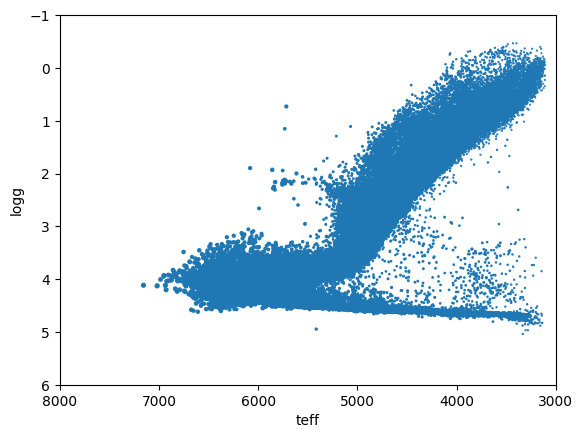

In [53]:
df.plot(x = "teff", y = "logg", kind = "scatter", xlim = [8000, 3000], ylim = [6, -1], s = df["teff_err"]/10)